# Polystyrene Creep

Fit polystyrene creep at selectable temperature.

**Data:** examples/data/pyRheo/polystyrene/creep_ps130_data.csv (swap for other temps)


In [1]:
# Google Colab compatibility - uncomment if running in Colab
# !pip install -q rheojax
# from google.colab import drive
# drive.mount('/content/drive')


## Setup and Imports

In [2]:
# Configure matplotlib for inline plotting in VS Code/Jupyter
%matplotlib inline

import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from rheojax.core.data import RheoData
from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.fractional_maxwell_model import FractionalMaxwellModel
from rheojax.models.generalized_maxwell import GeneralizedMaxwell
from rheojax.pipeline.base import Pipeline

jax, jnp = safe_import_jax()
verify_float64()
np.set_printoptions(precision=4, suppress=True)
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11
warnings.filterwarnings('ignore', category=RuntimeWarning)

def r2_complex(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    ss_res = np.sum(np.abs(y_true - y_pred) ** 2)
    ss_tot = np.sum(np.abs(y_true - np.mean(y_true)) ** 2)
    return float(1 - ss_res / ss_tot)

def mpe(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return float(np.mean(np.abs(y_true - y_pred) / np.maximum(np.abs(y_true), 1e-12)) * 100)

def load_tab_file(path):
    df = pd.read_csv(path, sep='	')
    df.columns = df.columns.str.strip()
    df = df.dropna()
    df.iloc[:,0] = pd.to_numeric(df.iloc[:,0], errors='coerce')
    df.iloc[:,1] = pd.to_numeric(df.iloc[:,1], errors='coerce')
    df = df.dropna()
    return df
import arviz as az


INFO:2025-12-06 22:04:18,610:jax._src.xla_bridge:808: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)


Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)


Loading rheojax version 0.4.0


/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/piblin_jax/__init__.py:28: UserWarning: GPU acceleration is only available on Linux with CUDA 12+. Using JAX in CPU mode.
  from . import backend, data, dataio, transform


Found 'auto' as default backend, checking available backends


Matplotlib is available, defining as default backend


arviz_base available, exposing its functions as part of arviz.preview


arviz_stats available, exposing its functions as part of arviz.preview


arviz_plots available, exposing its functions as part of arviz.preview


## Load creep data (select temperature file)

In [3]:
DATA_DIR = Path.cwd().parent / 'data' / 'pyRheo' / 'polystyrene'
file = DATA_DIR / 'creep_ps130_data.csv'  # swap for other temps
df = load_tab_file(file)
t = df.iloc[:,0].to_numpy()
J = df.iloc[:,1].to_numpy()


## Fit creep models

In [4]:
gm = GeneralizedMaxwell(n_modes=4, modulus_type='tensile')
gm.fit(t, J, test_mode='creep', use_log_residuals=True)
gm_pred = gm.predict(t)
gm_r2 = gm.score(t, J)

fm = FractionalMaxwellModel()
fm.fit(t, J, test_mode='creep', use_log_residuals=True)
fm_pred = fm.predict(t, test_mode='creep')
fm_r2 = r2_complex(J, fm_pred)

print({'gm_r2': gm_r2, 'fm_r2': fm_r2})


Starting least squares optimization | {'method': 'trf', 'n_params': 9, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 1.737903s


Convergence: reason=`xtol` termination condition is satisfied. | iterations=17 | final_cost=6.173794e-07 | time=1.738s | final_gradient_norm=2.9995273818773164e-06


Starting least squares optimization | {'method': 'trf', 'n_params': 9, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.707926s


Convergence: reason=`xtol` termination condition is satisfied. | iterations=17 | final_cost=6.173794e-07 | time=0.708s | final_gradient_norm=2.9995273818773164e-06


Starting least squares optimization | {'method': 'trf', 'n_params': 7, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 1.271156s


Convergence: reason=`xtol` termination condition is satisfied. | iterations=15 | final_cost=9.840886e-07 | time=1.271s | final_gradient_norm=7.06729973497724e-06


Element minimization: early termination at n_modes=3 (R²=0.958594 < threshold=0.961035)


Starting least squares optimization | {'method': 'trf', 'n_params': 4, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


[WARNING] Inner optimization loop hit iteration limit | {'inner_iterations': 100, 'actual_reduction': -1}


Inner optimization loop hit iteration limit | {'inner_iterations': 100, 'actual_reduction': -1}


Timer: optimization took 1.844327s


Convergence: reason=Inner optimization loop exceeded maximum iterations. | iterations=1 | final_cost=9.265395e+04 | time=1.844s | final_gradient_norm=nan


NLSQ hit inner iteration limit; retrying with SciPy least_squares for stability.


{'gm_r2': 0.9740234181771585, 'fm_r2': -1712609185947976.5}


## Plot creep fits

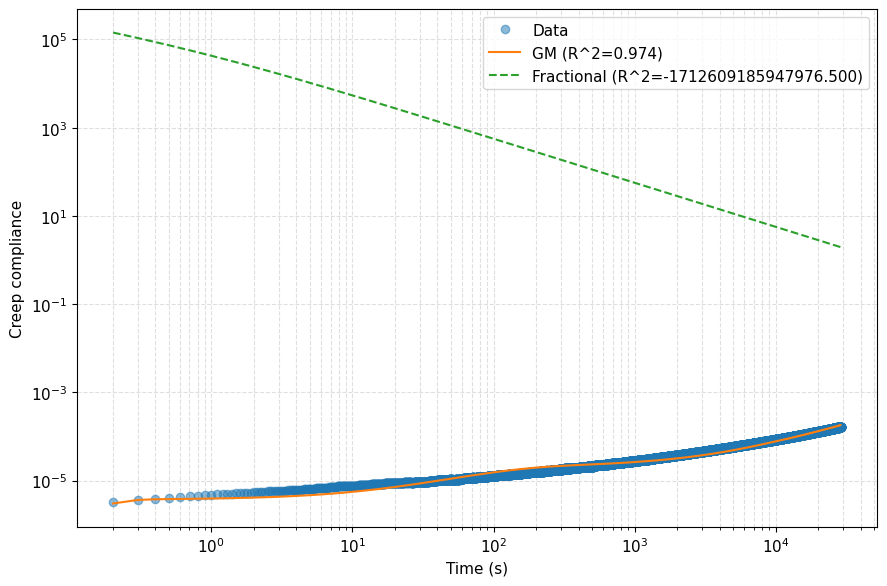

In [5]:
fig, ax = plt.subplots(figsize=(9,6))
ax.loglog(t, J, 'o', label='Data', alpha=0.5)
ax.loglog(t, gm_pred, '-', label=f'GM (R^2={gm_r2:.3f})')
ax.loglog(t, fm_pred, '--', label=f'Fractional (R^2={fm_r2:.3f})')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Creep compliance')
ax.grid(True, which='both', ls='--', alpha=0.4)
ax.legend()
plt.tight_layout()
display(fig)
plt.close(fig)

## Bayesian workflow (NLSQ → best model → NUTS diagnostics)

Starting least squares optimization | {'method': 'trf', 'n_params': 9, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.798820s


Convergence: reason=`xtol` termination condition is satisfied. | iterations=17 | final_cost=6.173794e-07 | time=0.799s | final_gradient_norm=2.9995273818773164e-06


Starting least squares optimization | {'method': 'trf', 'n_params': 9, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.763319s


Convergence: reason=`xtol` termination condition is satisfied. | iterations=17 | final_cost=6.173794e-07 | time=0.763s | final_gradient_norm=2.9995273818773164e-06


Starting least squares optimization | {'method': 'trf', 'n_params': 7, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.609022s


Convergence: reason=`xtol` termination condition is satisfied. | iterations=15 | final_cost=9.840886e-07 | time=0.609s | final_gradient_norm=7.06729973497724e-06


Element minimization: early termination at n_modes=3 (R²=0.958594 < threshold=0.961035)


Starting least squares optimization | {'method': 'trf', 'n_params': 4, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


[WARNING] Inner optimization loop hit iteration limit | {'inner_iterations': 100, 'actual_reduction': -1}


Inner optimization loop hit iteration limit | {'inner_iterations': 100, 'actual_reduction': -1}


Timer: optimization took 1.251125s


Convergence: reason=Inner optimization loop exceeded maximum iterations. | iterations=1 | final_cost=9.265395e+04 | time=1.251s | final_gradient_norm=nan


NLSQ hit inner iteration limit; retrying with SciPy least_squares for stability.


Model ranking (R²): [('gm', 0.974), ('fm', -1712609185947976.5)]


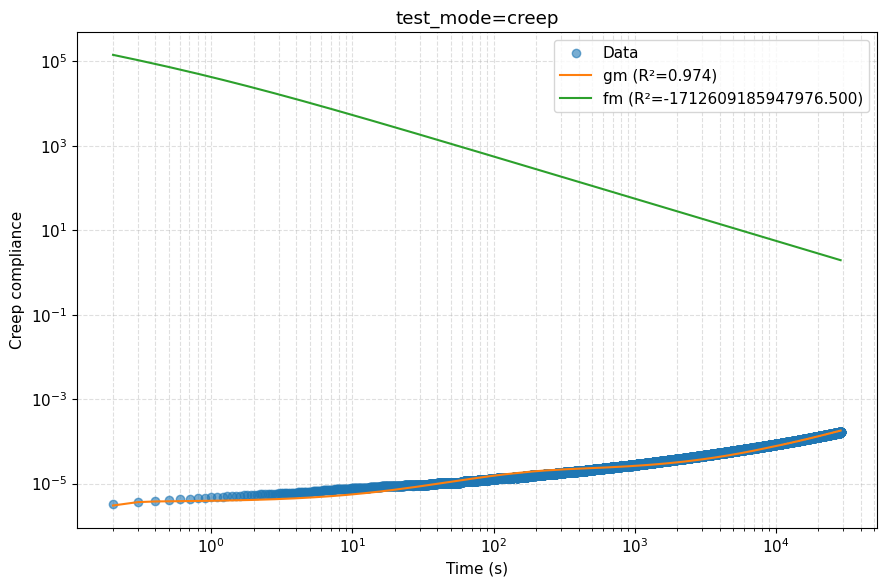

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   0%|          | 1/4000 [00:00<1:00:26,  1.10it/s, 1 steps of size 2.34e+00. acc. prob=0.00]

warmup:   0%|          | 5/4000 [00:01<10:25,  6.39it/s, 1 steps of size 6.62e-05. acc. prob=0.00]  

warmup:   0%|          | 8/4000 [00:01<11:27,  5.80it/s, 15 steps of size 1.08e-05. acc. prob=0.25]

warmup:   0%|          | 10/4000 [00:02<14:01,  4.74it/s, 11 steps of size 2.05e-05. acc. prob=0.39]

warmup:   0%|          | 12/4000 [00:03<18:18,  3.63it/s, 28 steps of size 1.71e-05. acc. prob=0.45]

warmup:   0%|          | 13/4000 [00:03<17:41,  3.76it/s, 7 steps of size 2.17e-05. acc. prob=0.48] 

warmup:   0%|          | 14/4000 [00:03<16:24,  4.05it/s, 7 steps of size 2.78e-05. acc. prob=0.51]

warmup:   0%|          | 15/4000 [00:03<15:17,  4.34it/s, 7 steps of size 3.59e-05. acc. prob=0.53]

warmup:   0%|          | 16/4000 [00:03<13:33,  4.90it/s, 5 steps of size 3.92e-05. acc. prob=0.55]

warmup:   0%|          | 18/4000 [00:03<10:40,  6.21it/s, 4 steps of size 1.74e-05. acc. prob=0.56]

warmup:   0%|          | 20/4000 [00:04<12:28,  5.32it/s, 17 steps of size 8.56e-06. acc. prob=0.57]

warmup:   1%|          | 21/4000 [00:04<12:15,  5.41it/s, 7 steps of size 5.49e-06. acc. prob=0.57] 

warmup:   1%|          | 22/4000 [00:04<12:49,  5.17it/s, 9 steps of size 8.04e-06. acc. prob=0.58]

warmup:   1%|          | 23/4000 [00:04<12:54,  5.13it/s, 8 steps of size 4.81e-06. acc. prob=0.58]

warmup:   1%|          | 24/4000 [00:05<15:30,  4.27it/s, 14 steps of size 7.12e-06. acc. prob=0.60]

warmup:   1%|          | 25/4000 [00:05<18:49,  3.52it/s, 17 steps of size 8.86e-06. acc. prob=0.60]

warmup:   1%|          | 26/4000 [00:06<19:02,  3.48it/s, 12 steps of size 1.34e-05. acc. prob=0.62]

warmup:   1%|          | 27/4000 [00:06<16:52,  3.92it/s, 7 steps of size 1.76e-05. acc. prob=0.63] 

warmup:   1%|          | 29/4000 [00:06<15:53,  4.16it/s, 16 steps of size 1.07e-05. acc. prob=0.63]

warmup:   1%|          | 30/4000 [00:06<14:24,  4.59it/s, 6 steps of size 1.29e-05. acc. prob=0.63] 

warmup:   1%|          | 32/4000 [00:06<10:51,  6.10it/s, 4 steps of size 9.84e-06. acc. prob=0.64]

warmup:   1%|          | 34/4000 [00:07<09:16,  7.13it/s, 5 steps of size 7.51e-06. acc. prob=0.64]

warmup:   1%|          | 35/4000 [00:07<09:02,  7.31it/s, 5 steps of size 7.64e-06. acc. prob=0.65]

warmup:   1%|          | 36/4000 [00:07<11:27,  5.77it/s, 12 steps of size 9.68e-06. acc. prob=0.65]

warmup:   1%|          | 37/4000 [00:07<12:38,  5.22it/s, 10 steps of size 1.39e-05. acc. prob=0.66]

warmup:   1%|          | 39/4000 [00:08<11:29,  5.75it/s, 10 steps of size 1.01e-05. acc. prob=0.66]

warmup:   1%|          | 41/4000 [00:08<14:12,  4.65it/s, 22 steps of size 2.45e-06. acc. prob=0.65]

warmup:   1%|          | 42/4000 [00:08<13:16,  4.97it/s, 6 steps of size 2.95e-06. acc. prob=0.66] 

warmup:   1%|          | 43/4000 [00:08<12:27,  5.29it/s, 6 steps of size 3.39e-06. acc. prob=0.66]

warmup:   1%|          | 45/4000 [00:09<19:26,  3.39it/s, 35 steps of size 2.58e-06. acc. prob=0.66]

warmup:   1%|          | 46/4000 [00:10<17:40,  3.73it/s, 7 steps of size 3.30e-06. acc. prob=0.67] 

warmup:   1%|          | 47/4000 [00:10<16:58,  3.88it/s, 9 steps of size 3.59e-06. acc. prob=0.67]

warmup:   1%|          | 48/4000 [00:10<18:01,  3.65it/s, 13 steps of size 5.33e-06. acc. prob=0.67]

warmup:   1%|          | 49/4000 [00:10<15:49,  4.16it/s, 6 steps of size 6.32e-06. acc. prob=0.68] 

warmup:   1%|▏         | 50/4000 [00:11<16:51,  3.90it/s, 12 steps of size 8.43e-06. acc. prob=0.68]

warmup:   1%|▏         | 51/4000 [00:11<14:24,  4.57it/s, 5 steps of size 9.25e-06. acc. prob=0.68] 

warmup:   1%|▏         | 53/4000 [00:12<23:33,  2.79it/s, 42 steps of size 2.47e-06. acc. prob=0.68]

warmup:   1%|▏         | 54/4000 [00:12<26:35,  2.47it/s, 20 steps of size 3.84e-06. acc. prob=0.68]

warmup:   1%|▏         | 55/4000 [00:13<27:14,  2.41it/s, 18 steps of size 5.32e-06. acc. prob=0.68]

warmup:   1%|▏         | 56/4000 [00:13<22:32,  2.92it/s, 6 steps of size 6.28e-06. acc. prob=0.69] 

warmup:   1%|▏         | 58/4000 [00:13<14:31,  4.52it/s, 4 steps of size 1.11e-06. acc. prob=0.68]

warmup:   2%|▏         | 60/4000 [00:13<12:04,  5.44it/s, 7 steps of size 1.14e-06. acc. prob=0.68]

warmup:   2%|▏         | 61/4000 [00:13<11:12,  5.86it/s, 5 steps of size 1.25e-06. acc. prob=0.68]

warmup:   2%|▏         | 62/4000 [00:14<12:46,  5.14it/s, 11 steps of size 1.72e-06. acc. prob=0.69]

warmup:   2%|▏         | 63/4000 [00:14<18:04,  3.63it/s, 21 steps of size 2.56e-06. acc. prob=0.69]

warmup:   2%|▏         | 65/4000 [00:16<37:49,  1.73it/s, 80 steps of size 7.79e-07. acc. prob=0.68]

warmup:   2%|▏         | 66/4000 [00:17<35:47,  1.83it/s, 18 steps of size 1.13e-06. acc. prob=0.69]

warmup:   2%|▏         | 67/4000 [00:17<30:32,  2.15it/s, 9 steps of size 1.46e-06. acc. prob=0.69] 

warmup:   2%|▏         | 68/4000 [00:17<25:05,  2.61it/s, 6 steps of size 1.63e-06. acc. prob=0.69]

warmup:   2%|▏         | 69/4000 [00:18<30:33,  2.14it/s, 28 steps of size 2.51e-06. acc. prob=0.70]

warmup:   2%|▏         | 70/4000 [00:18<32:22,  2.02it/s, 23 steps of size 3.78e-06. acc. prob=0.70]

warmup:   2%|▏         | 71/4000 [00:18<27:15,  2.40it/s, 9 steps of size 3.85e-06. acc. prob=0.70] 

warmup:   2%|▏         | 72/4000 [00:19<28:41,  2.28it/s, 20 steps of size 5.67e-06. acc. prob=0.70]

warmup:   2%|▏         | 74/4000 [00:19<20:49,  3.14it/s, 11 steps of size 5.90e-06. acc. prob=0.71]

warmup:   2%|▏         | 76/4000 [00:20<15:30,  4.22it/s, 6 steps of size 5.31e-06. acc. prob=0.71] 

warmup:   2%|▏         | 77/4000 [00:20<13:52,  4.71it/s, 5 steps of size 4.62e-06. acc. prob=0.71]

warmup:   2%|▏         | 78/4000 [00:20<17:28,  3.74it/s, 18 steps of size 5.88e-06. acc. prob=0.71]

warmup:   2%|▏         | 80/4000 [00:20<14:19,  4.56it/s, 8 steps of size 7.10e-06. acc. prob=0.71] 

warmup:   2%|▏         | 82/4000 [00:21<11:43,  5.57it/s, 8 steps of size 1.74e-06. acc. prob=0.70]

warmup:   2%|▏         | 83/4000 [00:21<14:17,  4.57it/s, 15 steps of size 2.41e-06. acc. prob=0.71]

warmup:   2%|▏         | 84/4000 [00:21<13:14,  4.93it/s, 6 steps of size 2.76e-06. acc. prob=0.71] 

warmup:   2%|▏         | 85/4000 [00:22<16:17,  4.00it/s, 16 steps of size 3.85e-06. acc. prob=0.71]

warmup:   2%|▏         | 86/4000 [00:22<14:30,  4.50it/s, 4 steps of size 3.50e-06. acc. prob=0.71] 

warmup:   2%|▏         | 87/4000 [00:22<17:31,  3.72it/s, 16 steps of size 4.58e-06. acc. prob=0.71]

warmup:   2%|▏         | 88/4000 [00:22<17:06,  3.81it/s, 10 steps of size 5.76e-06. acc. prob=0.71]

warmup:   2%|▏         | 89/4000 [00:23<15:53,  4.10it/s, 8 steps of size 6.52e-06. acc. prob=0.72] 

warmup:   2%|▏         | 90/4000 [00:23<15:54,  4.10it/s, 10 steps of size 8.22e-06. acc. prob=0.72]

warmup:   2%|▏         | 91/4000 [00:23<15:56,  4.09it/s, 10 steps of size 9.68e-06. acc. prob=0.72]

warmup:   2%|▏         | 92/4000 [00:23<15:01,  4.34it/s, 8 steps of size 1.18e-05. acc. prob=0.72] 

warmup:   2%|▏         | 94/4000 [00:23<10:42,  6.08it/s, 5 steps of size 6.73e-06. acc. prob=0.72]

warmup:   2%|▏         | 95/4000 [00:24<10:26,  6.24it/s, 6 steps of size 7.61e-06. acc. prob=0.72]

warmup:   2%|▏         | 96/4000 [00:24<10:38,  6.12it/s, 7 steps of size 8.98e-06. acc. prob=0.72]

warmup:   2%|▏         | 98/4000 [00:24<09:50,  6.61it/s, 8 steps of size 8.77e-06. acc. prob=0.72]

warmup:   2%|▎         | 100/4000 [00:24<10:56,  5.94it/s, 14 steps of size 6.45e-06. acc. prob=0.72]

warmup:   3%|▎         | 101/4000 [00:27<44:17,  1.47it/s, 105 steps of size 9.01e-05. acc. prob=0.72]

warmup:   3%|▎         | 102/4000 [00:28<44:23,  1.46it/s, 28 steps of size 1.43e-04. acc. prob=0.73] 

warmup:   3%|▎         | 103/4000 [00:28<46:47,  1.39it/s, 34 steps of size 2.42e-04. acc. prob=0.73]

warmup:   3%|▎         | 104/4000 [00:29<39:56,  1.63it/s, 13 steps of size 3.41e-04. acc. prob=0.73]

warmup:   3%|▎         | 105/4000 [00:29<37:16,  1.74it/s, 19 steps of size 5.69e-04. acc. prob=0.73]

warmup:   3%|▎         | 106/4000 [00:29<29:02,  2.23it/s, 5 steps of size 5.81e-04. acc. prob=0.73] 

warmup:   3%|▎         | 108/4000 [00:30<18:15,  3.55it/s, 3 steps of size 2.49e-04. acc. prob=0.73]

warmup:   3%|▎         | 109/4000 [00:30<18:51,  3.44it/s, 13 steps of size 3.53e-04. acc. prob=0.73]

warmup:   3%|▎         | 110/4000 [00:30<21:45,  2.98it/s, 19 steps of size 4.63e-04. acc. prob=0.73]

warmup:   3%|▎         | 111/4000 [00:30<18:26,  3.51it/s, 5 steps of size 3.07e-04. acc. prob=0.73] 

warmup:   3%|▎         | 112/4000 [00:31<21:13,  3.05it/s, 17 steps of size 3.29e-04. acc. prob=0.73]

warmup:   3%|▎         | 113/4000 [00:31<21:05,  3.07it/s, 13 steps of size 4.21e-04. acc. prob=0.74]

warmup:   3%|▎         | 114/4000 [00:32<26:01,  2.49it/s, 24 steps of size 6.69e-04. acc. prob=0.74]

warmup:   3%|▎         | 115/4000 [00:32<25:22,  2.55it/s, 15 steps of size 9.65e-04. acc. prob=0.74]

warmup:   3%|▎         | 116/4000 [00:32<20:43,  3.12it/s, 6 steps of size 1.05e-03. acc. prob=0.74] 

warmup:   3%|▎         | 117/4000 [00:32<18:21,  3.53it/s, 8 steps of size 4.50e-04. acc. prob=0.74]

warmup:   3%|▎         | 119/4000 [00:33<12:51,  5.03it/s, 4 steps of size 2.93e-04. acc. prob=0.74]

warmup:   3%|▎         | 121/4000 [00:33<11:13,  5.76it/s, 10 steps of size 3.57e-05. acc. prob=0.73]

warmup:   3%|▎         | 122/4000 [00:34<17:28,  3.70it/s, 25 steps of size 5.74e-05. acc. prob=0.74]

warmup:   3%|▎         | 124/4000 [00:34<12:15,  5.27it/s, 2 steps of size 1.65e-05. acc. prob=0.73] 

warmup:   3%|▎         | 125/4000 [00:34<15:25,  4.19it/s, 17 steps of size 2.30e-05. acc. prob=0.73]

warmup:   3%|▎         | 126/4000 [00:36<38:40,  1.67it/s, 72 steps of size 3.69e-05. acc. prob=0.74]

warmup:   3%|▎         | 127/4000 [00:38<1:03:36,  1.01it/s, 87 steps of size 6.29e-05. acc. prob=0.74]

warmup:   3%|▎         | 128/4000 [00:39<1:00:59,  1.06it/s, 34 steps of size 1.00e-04. acc. prob=0.74]

warmup:   3%|▎         | 129/4000 [00:39<49:28,  1.30it/s, 12 steps of size 1.37e-04. acc. prob=0.74]  

warmup:   3%|▎         | 132/4000 [00:40<30:58,  2.08it/s, 26 steps of size 1.07e-05. acc. prob=0.74]

warmup:   3%|▎         | 133/4000 [00:41<33:59,  1.90it/s, 27 steps of size 1.67e-05. acc. prob=0.74]

warmup:   3%|▎         | 134/4000 [00:41<31:17,  2.06it/s, 14 steps of size 2.38e-05. acc. prob=0.74]

warmup:   3%|▎         | 135/4000 [00:41<30:38,  2.10it/s, 18 steps of size 3.38e-05. acc. prob=0.74]

warmup:   3%|▎         | 136/4000 [00:42<39:47,  1.62it/s, 42 steps of size 5.01e-05. acc. prob=0.74]

warmup:   3%|▎         | 137/4000 [00:43<33:44,  1.91it/s, 11 steps of size 6.29e-05. acc. prob=0.74]

warmup:   3%|▎         | 138/4000 [00:43<36:14,  1.78it/s, 27 steps of size 8.99e-05. acc. prob=0.74]

warmup:   3%|▎         | 139/4000 [00:44<46:58,  1.37it/s, 47 steps of size 1.32e-04. acc. prob=0.75]

warmup:   4%|▎         | 140/4000 [00:45<49:20,  1.30it/s, 35 steps of size 1.16e-04. acc. prob=0.75]

warmup:   4%|▎         | 141/4000 [00:46<47:18,  1.36it/s, 27 steps of size 1.64e-04. acc. prob=0.75]

warmup:   4%|▎         | 142/4000 [00:46<42:11,  1.52it/s, 19 steps of size 2.31e-04. acc. prob=0.75]

warmup:   4%|▎         | 143/4000 [00:47<33:54,  1.90it/s, 9 steps of size 2.80e-04. acc. prob=0.75] 

warmup:   4%|▎         | 144/4000 [00:47<31:18,  2.05it/s, 16 steps of size 3.63e-04. acc. prob=0.75]

warmup:   4%|▎         | 145/4000 [00:47<24:18,  2.64it/s, 5 steps of size 3.12e-04. acc. prob=0.75] 

warmup:   4%|▎         | 146/4000 [00:47<19:52,  3.23it/s, 6 steps of size 2.76e-04. acc. prob=0.75]

warmup:   4%|▎         | 147/4000 [00:47<16:45,  3.83it/s, 6 steps of size 2.97e-04. acc. prob=0.75]

warmup:   4%|▎         | 148/4000 [00:48<15:59,  4.02it/s, 9 steps of size 3.54e-04. acc. prob=0.75]

warmup:   4%|▍         | 150/4000 [00:48<14:47,  4.34it/s, 14 steps of size 3.34e-04. acc. prob=0.75]

warmup:   4%|▍         | 151/4000 [00:48<15:47,  4.06it/s, 12 steps of size 4.12e-03. acc. prob=0.75]

warmup:   4%|▍         | 153/4000 [00:49<14:47,  4.33it/s, 13 steps of size 8.39e-04. acc. prob=0.75]

warmup:   4%|▍         | 154/4000 [00:49<17:09,  3.74it/s, 16 steps of size 2.75e-04. acc. prob=0.75]

warmup:   4%|▍         | 155/4000 [00:51<42:38,  1.50it/s, 75 steps of size 4.29e-04. acc. prob=0.75]

warmup:   4%|▍         | 156/4000 [00:52<44:36,  1.44it/s, 32 steps of size 5.65e-04. acc. prob=0.75]

warmup:   4%|▍         | 157/4000 [00:52<36:45,  1.74it/s, 10 steps of size 7.14e-04. acc. prob=0.75]

warmup:   4%|▍         | 158/4000 [00:52<28:41,  2.23it/s, 5 steps of size 6.40e-04. acc. prob=0.75] 

warmup:   4%|▍         | 159/4000 [00:52<23:11,  2.76it/s, 6 steps of size 7.05e-04. acc. prob=0.75]

warmup:   4%|▍         | 161/4000 [00:53<17:01,  3.76it/s, 9 steps of size 6.11e-04. acc. prob=0.75]

warmup:   4%|▍         | 163/4000 [00:53<11:54,  5.37it/s, 2 steps of size 1.59e-04. acc. prob=0.75]

warmup:   4%|▍         | 165/4000 [00:55<28:02,  2.28it/s, 72 steps of size 2.37e-05. acc. prob=0.75]

warmup:   4%|▍         | 166/4000 [00:56<36:38,  1.74it/s, 45 steps of size 3.71e-05. acc. prob=0.75]

warmup:   4%|▍         | 167/4000 [00:58<59:21,  1.08it/s, 88 steps of size 5.67e-05. acc. prob=0.75]

warmup:   4%|▍         | 168/4000 [00:59<1:08:05,  1.07s/it, 61 steps of size 1.01e-04. acc. prob=0.75]

warmup:   4%|▍         | 169/4000 [01:01<1:17:26,  1.21s/it, 65 steps of size 9.09e-05. acc. prob=0.75]

warmup:   4%|▍         | 170/4000 [01:02<1:09:09,  1.08s/it, 30 steps of size 1.47e-04. acc. prob=0.75]

warmup:   4%|▍         | 171/4000 [01:02<1:03:20,  1.01it/s, 31 steps of size 2.48e-04. acc. prob=0.75]

warmup:   4%|▍         | 173/4000 [01:03<37:21,  1.71it/s, 2 steps of size 9.07e-05. acc. prob=0.75]   

warmup:   4%|▍         | 175/4000 [01:03<25:17,  2.52it/s, 5 steps of size 6.52e-05. acc. prob=0.75]

warmup:   4%|▍         | 176/4000 [01:03<23:51,  2.67it/s, 12 steps of size 9.20e-05. acc. prob=0.75]

warmup:   4%|▍         | 177/4000 [01:04<27:25,  2.32it/s, 25 steps of size 1.48e-04. acc. prob=0.75]

warmup:   4%|▍         | 178/4000 [01:04<22:28,  2.83it/s, 5 steps of size 1.52e-04. acc. prob=0.75] 

warmup:   4%|▍         | 179/4000 [01:04<20:14,  3.15it/s, 9 steps of size 1.99e-04. acc. prob=0.75]

warmup:   4%|▍         | 180/4000 [01:04<18:56,  3.36it/s, 10 steps of size 2.59e-04. acc. prob=0.76]

warmup:   5%|▍         | 182/4000 [01:05<17:08,  3.71it/s, 16 steps of size 2.26e-04. acc. prob=0.76]

warmup:   5%|▍         | 183/4000 [01:05<15:16,  4.16it/s, 6 steps of size 2.52e-04. acc. prob=0.76] 

warmup:   5%|▍         | 184/4000 [01:06<20:54,  3.04it/s, 24 steps of size 3.50e-04. acc. prob=0.76]

warmup:   5%|▍         | 186/4000 [01:06<18:38,  3.41it/s, 17 steps of size 3.44e-04. acc. prob=0.76]

warmup:   5%|▍         | 187/4000 [01:06<16:08,  3.94it/s, 5 steps of size 2.96e-04. acc. prob=0.76] 

warmup:   5%|▍         | 188/4000 [01:06<17:08,  3.71it/s, 13 steps of size 3.95e-04. acc. prob=0.76]

warmup:   5%|▍         | 189/4000 [01:07<15:06,  4.20it/s, 6 steps of size 4.37e-04. acc. prob=0.76] 

warmup:   5%|▍         | 190/4000 [01:07<13:32,  4.69it/s, 6 steps of size 4.65e-04. acc. prob=0.76]

warmup:   5%|▍         | 191/4000 [01:07<15:24,  4.12it/s, 13 steps of size 6.42e-04. acc. prob=0.76]

warmup:   5%|▍         | 192/4000 [01:07<13:13,  4.80it/s, 5 steps of size 6.50e-04. acc. prob=0.76] 

warmup:   5%|▍         | 194/4000 [01:07<09:22,  6.77it/s, 3 steps of size 3.46e-04. acc. prob=0.76]

warmup:   5%|▍         | 196/4000 [01:09<21:09,  3.00it/s, 50 steps of size 7.95e-05. acc. prob=0.76]

warmup:   5%|▍         | 197/4000 [01:09<22:57,  2.76it/s, 19 steps of size 1.13e-04. acc. prob=0.76]

warmup:   5%|▍         | 198/4000 [01:10<25:37,  2.47it/s, 22 steps of size 1.66e-04. acc. prob=0.76]

warmup:   5%|▍         | 199/4000 [01:10<26:59,  2.35it/s, 20 steps of size 2.40e-04. acc. prob=0.76]

warmup:   5%|▌         | 201/4000 [01:10<18:15,  3.47it/s, 4 steps of size 1.82e-04. acc. prob=0.76] 

warmup:   5%|▌         | 202/4000 [01:11<19:44,  3.21it/s, 16 steps of size 1.91e-04. acc. prob=0.76]

warmup:   5%|▌         | 203/4000 [01:11<20:56,  3.02it/s, 14 steps of size 2.60e-04. acc. prob=0.76]

warmup:   5%|▌         | 204/4000 [01:11<23:09,  2.73it/s, 19 steps of size 3.59e-04. acc. prob=0.76]

warmup:   5%|▌         | 205/4000 [01:12<28:11,  2.24it/s, 27 steps of size 3.55e-04. acc. prob=0.76]

warmup:   5%|▌         | 206/4000 [01:13<31:58,  1.98it/s, 27 steps of size 5.21e-04. acc. prob=0.76]

warmup:   5%|▌         | 207/4000 [01:13<27:41,  2.28it/s, 11 steps of size 6.03e-04. acc. prob=0.76]

warmup:   5%|▌         | 208/4000 [01:13<25:03,  2.52it/s, 12 steps of size 7.92e-04. acc. prob=0.76]

warmup:   5%|▌         | 210/4000 [01:14<15:27,  4.09it/s, 4 steps of size 1.23e-04. acc. prob=0.76] 

warmup:   5%|▌         | 212/4000 [01:14<11:13,  5.63it/s, 4 steps of size 5.63e-05. acc. prob=0.76]

warmup:   5%|▌         | 213/4000 [01:15<23:18,  2.71it/s, 43 steps of size 8.31e-05. acc. prob=0.76]

warmup:   5%|▌         | 214/4000 [01:15<21:48,  2.89it/s, 11 steps of size 1.06e-04. acc. prob=0.76]

warmup:   5%|▌         | 215/4000 [01:15<22:07,  2.85it/s, 15 steps of size 1.44e-04. acc. prob=0.76]

warmup:   5%|▌         | 216/4000 [01:16<23:37,  2.67it/s, 18 steps of size 1.62e-04. acc. prob=0.76]

warmup:   5%|▌         | 217/4000 [01:17<34:28,  1.83it/s, 41 steps of size 2.31e-04. acc. prob=0.76]

warmup:   5%|▌         | 218/4000 [01:17<35:34,  1.77it/s, 25 steps of size 3.29e-04. acc. prob=0.76]

warmup:   5%|▌         | 219/4000 [01:18<29:47,  2.12it/s, 10 steps of size 3.60e-04. acc. prob=0.76]

warmup:   6%|▌         | 220/4000 [01:18<27:22,  2.30it/s, 14 steps of size 4.76e-04. acc. prob=0.76]

warmup:   6%|▌         | 222/4000 [01:18<17:23,  3.62it/s, 4 steps of size 3.23e-04. acc. prob=0.76] 

warmup:   6%|▌         | 223/4000 [01:18<16:32,  3.80it/s, 9 steps of size 3.39e-04. acc. prob=0.76]

warmup:   6%|▌         | 224/4000 [01:19<17:25,  3.61it/s, 13 steps of size 4.38e-04. acc. prob=0.76]

warmup:   6%|▌         | 225/4000 [01:19<15:13,  4.13it/s, 6 steps of size 4.57e-04. acc. prob=0.76] 

warmup:   6%|▌         | 226/4000 [01:19<13:34,  4.63it/s, 6 steps of size 4.94e-04. acc. prob=0.76]

warmup:   6%|▌         | 227/4000 [01:20<19:48,  3.18it/s, 23 steps of size 3.99e-04. acc. prob=0.76]

warmup:   6%|▌         | 228/4000 [01:20<24:43,  2.54it/s, 22 steps of size 4.86e-04. acc. prob=0.76]

warmup:   6%|▌         | 229/4000 [01:21<29:34,  2.13it/s, 27 steps of size 6.09e-04. acc. prob=0.77]

warmup:   6%|▌         | 230/4000 [01:21<28:06,  2.24it/s, 16 steps of size 7.25e-04. acc. prob=0.77]

warmup:   6%|▌         | 231/4000 [01:21<24:20,  2.58it/s, 10 steps of size 8.81e-04. acc. prob=0.77]

warmup:   6%|▌         | 232/4000 [01:22<22:08,  2.84it/s, 11 steps of size 1.01e-03. acc. prob=0.77]

warmup:   6%|▌         | 233/4000 [01:22<18:44,  3.35it/s, 7 steps of size 9.00e-04. acc. prob=0.77] 

warmup:   6%|▌         | 234/4000 [01:22<16:21,  3.84it/s, 7 steps of size 1.00e-03. acc. prob=0.77]

warmup:   6%|▌         | 235/4000 [01:22<13:46,  4.56it/s, 5 steps of size 1.01e-03. acc. prob=0.77]

warmup:   6%|▌         | 237/4000 [01:22<10:16,  6.10it/s, 5 steps of size 7.06e-04. acc. prob=0.77]

warmup:   6%|▌         | 238/4000 [01:23<10:23,  6.04it/s, 7 steps of size 7.92e-04. acc. prob=0.77]

warmup:   6%|▌         | 239/4000 [01:23<09:40,  6.47it/s, 5 steps of size 7.33e-04. acc. prob=0.77]

warmup:   6%|▌         | 240/4000 [01:23<10:23,  6.03it/s, 8 steps of size 8.50e-04. acc. prob=0.77]

warmup:   6%|▌         | 241/4000 [01:23<10:29,  5.97it/s, 7 steps of size 9.15e-04. acc. prob=0.77]

warmup:   6%|▌         | 243/4000 [01:23<07:52,  7.94it/s, 4 steps of size 4.81e-04. acc. prob=0.77]

warmup:   6%|▌         | 246/4000 [01:23<06:17,  9.95it/s, 6 steps of size 6.84e-05. acc. prob=0.76]

warmup:   6%|▌         | 247/4000 [01:24<08:16,  7.56it/s, 11 steps of size 8.50e-05. acc. prob=0.76]

warmup:   6%|▌         | 249/4000 [01:25<16:04,  3.89it/s, 38 steps of size 6.46e-05. acc. prob=0.76]

warmup:   6%|▋         | 250/4000 [01:26<27:12,  2.30it/s, 47 steps of size 9.08e-05. acc. prob=0.76]

warmup:   6%|▋         | 251/4000 [01:26<29:39,  2.11it/s, 25 steps of size 1.21e-03. acc. prob=0.76]

warmup:   6%|▋         | 253/4000 [01:27<19:54,  3.14it/s, 3 steps of size 6.72e-04. acc. prob=0.76] 

warmup:   6%|▋         | 254/4000 [01:27<17:34,  3.55it/s, 6 steps of size 7.24e-04. acc. prob=0.76]

warmup:   6%|▋         | 256/4000 [01:27<13:28,  4.63it/s, 7 steps of size 3.37e-04. acc. prob=0.76]

warmup:   6%|▋         | 258/4000 [01:27<11:56,  5.22it/s, 9 steps of size 2.84e-04. acc. prob=0.76]

warmup:   6%|▋         | 260/4000 [01:27<09:28,  6.58it/s, 3 steps of size 1.19e-04. acc. prob=0.76]

warmup:   7%|▋         | 262/4000 [01:28<16:01,  3.89it/s, 36 steps of size 1.29e-04. acc. prob=0.76]

warmup:   7%|▋         | 263/4000 [01:29<17:00,  3.66it/s, 14 steps of size 1.92e-04. acc. prob=0.76]

warmup:   7%|▋         | 264/4000 [01:29<21:09,  2.94it/s, 22 steps of size 3.14e-04. acc. prob=0.76]

warmup:   7%|▋         | 266/4000 [01:29<15:11,  4.10it/s, 6 steps of size 3.00e-05. acc. prob=0.76] 

warmup:   7%|▋         | 267/4000 [01:30<22:56,  2.71it/s, 34 steps of size 5.03e-05. acc. prob=0.76]

warmup:   7%|▋         | 268/4000 [01:30<20:47,  2.99it/s, 9 steps of size 6.73e-05. acc. prob=0.76] 

warmup:   7%|▋         | 270/4000 [01:31<15:13,  4.09it/s, 6 steps of size 5.19e-05. acc. prob=0.76]

warmup:   7%|▋         | 271/4000 [01:32<36:26,  1.71it/s, 73 steps of size 8.69e-05. acc. prob=0.76]

warmup:   7%|▋         | 272/4000 [01:33<32:47,  1.89it/s, 14 steps of size 1.27e-04. acc. prob=0.76]

warmup:   7%|▋         | 273/4000 [01:34<37:37,  1.65it/s, 34 steps of size 1.62e-04. acc. prob=0.76]

warmup:   7%|▋         | 274/4000 [01:35<44:12,  1.40it/s, 41 steps of size 2.72e-04. acc. prob=0.77]

warmup:   7%|▋         | 275/4000 [01:35<34:55,  1.78it/s, 7 steps of size 3.19e-04. acc. prob=0.77] 

warmup:   7%|▋         | 276/4000 [01:35<34:04,  1.82it/s, 21 steps of size 4.92e-04. acc. prob=0.77]

warmup:   7%|▋         | 277/4000 [01:36<28:11,  2.20it/s, 9 steps of size 6.15e-04. acc. prob=0.77] 

warmup:   7%|▋         | 278/4000 [01:36<22:36,  2.74it/s, 6 steps of size 6.72e-04. acc. prob=0.77]

warmup:   7%|▋         | 280/4000 [01:36<14:44,  4.20it/s, 5 steps of size 2.81e-04. acc. prob=0.77]

warmup:   7%|▋         | 281/4000 [01:36<13:21,  4.64it/s, 6 steps of size 3.09e-04. acc. prob=0.77]

warmup:   7%|▋         | 282/4000 [01:36<13:50,  4.48it/s, 10 steps of size 4.03e-04. acc. prob=0.77]

warmup:   7%|▋         | 284/4000 [01:37<18:56,  3.27it/s, 32 steps of size 7.22e-05. acc. prob=0.76]

warmup:   7%|▋         | 285/4000 [01:38<33:18,  1.86it/s, 51 steps of size 1.18e-04. acc. prob=0.77]

warmup:   7%|▋         | 286/4000 [01:39<31:23,  1.97it/s, 17 steps of size 1.71e-04. acc. prob=0.77]

warmup:   7%|▋         | 287/4000 [01:39<25:32,  2.42it/s, 6 steps of size 1.81e-04. acc. prob=0.77] 

warmup:   7%|▋         | 288/4000 [01:39<25:11,  2.46it/s, 16 steps of size 2.10e-04. acc. prob=0.77]

warmup:   7%|▋         | 289/4000 [01:40<29:08,  2.12it/s, 26 steps of size 3.10e-04. acc. prob=0.77]

warmup:   7%|▋         | 290/4000 [01:41<30:17,  2.04it/s, 22 steps of size 4.52e-04. acc. prob=0.77]

warmup:   7%|▋         | 292/4000 [01:41<19:22,  3.19it/s, 5 steps of size 3.23e-04. acc. prob=0.77] 

warmup:   7%|▋         | 293/4000 [01:41<17:36,  3.51it/s, 8 steps of size 3.89e-04. acc. prob=0.77]

warmup:   7%|▋         | 295/4000 [01:41<12:15,  5.04it/s, 3 steps of size 2.06e-04. acc. prob=0.77]

warmup:   7%|▋         | 297/4000 [01:41<09:24,  6.56it/s, 2 steps of size 8.90e-05. acc. prob=0.77]

warmup:   7%|▋         | 299/4000 [01:42<11:05,  5.56it/s, 16 steps of size 7.90e-05. acc. prob=0.77]

warmup:   8%|▊         | 300/4000 [01:42<13:04,  4.72it/s, 14 steps of size 1.09e-04. acc. prob=0.77]

warmup:   8%|▊         | 301/4000 [01:43<17:09,  3.59it/s, 21 steps of size 1.33e-04. acc. prob=0.77]

warmup:   8%|▊         | 302/4000 [01:45<49:10,  1.25it/s, 98 steps of size 1.57e-04. acc. prob=0.77]

warmup:   8%|▊         | 303/4000 [01:46<48:01,  1.28it/s, 30 steps of size 2.33e-04. acc. prob=0.77]

warmup:   8%|▊         | 304/4000 [01:46<39:59,  1.54it/s, 12 steps of size 2.95e-04. acc. prob=0.77]

warmup:   8%|▊         | 305/4000 [01:47<39:12,  1.57it/s, 25 steps of size 3.98e-04. acc. prob=0.77]

warmup:   8%|▊         | 306/4000 [01:47<35:17,  1.74it/s, 17 steps of size 5.27e-04. acc. prob=0.77]

warmup:   8%|▊         | 307/4000 [01:48<34:07,  1.80it/s, 21 steps of size 5.23e-04. acc. prob=0.77]

warmup:   8%|▊         | 308/4000 [01:48<33:42,  1.83it/s, 22 steps of size 6.61e-04. acc. prob=0.77]

warmup:   8%|▊         | 309/4000 [01:49<32:34,  1.89it/s, 20 steps of size 4.76e-04. acc. prob=0.77]

warmup:   8%|▊         | 310/4000 [01:49<29:09,  2.11it/s, 14 steps of size 5.14e-04. acc. prob=0.77]

warmup:   8%|▊         | 311/4000 [01:49<30:40,  2.00it/s, 23 steps of size 7.28e-04. acc. prob=0.77]

warmup:   8%|▊         | 312/4000 [01:50<26:26,  2.32it/s, 11 steps of size 9.25e-04. acc. prob=0.77]

warmup:   8%|▊         | 314/4000 [01:50<16:20,  3.76it/s, 3 steps of size 5.20e-04. acc. prob=0.77] 

warmup:   8%|▊         | 315/4000 [01:50<14:30,  4.23it/s, 6 steps of size 5.58e-04. acc. prob=0.77]

warmup:   8%|▊         | 316/4000 [01:50<15:23,  3.99it/s, 12 steps of size 7.16e-04. acc. prob=0.77]

warmup:   8%|▊         | 317/4000 [01:51<28:58,  2.12it/s, 9 steps of size 7.74e-04. acc. prob=0.77] 

warmup:   8%|▊         | 318/4000 [01:52<25:10,  2.44it/s, 10 steps of size 8.54e-04. acc. prob=0.77]

warmup:   8%|▊         | 319/4000 [01:52<20:07,  3.05it/s, 5 steps of size 8.55e-04. acc. prob=0.77] 

warmup:   8%|▊         | 320/4000 [01:52<17:19,  3.54it/s, 7 steps of size 9.58e-04. acc. prob=0.77]

warmup:   8%|▊         | 322/4000 [01:52<11:10,  5.48it/s, 1 steps of size 1.61e-04. acc. prob=0.77]

warmup:   8%|▊         | 324/4000 [01:54<29:55,  2.05it/s, 78 steps of size 4.67e-05. acc. prob=0.77]

warmup:   8%|▊         | 325/4000 [01:55<30:58,  1.98it/s, 23 steps of size 6.50e-05. acc. prob=0.77]

warmup:   8%|▊         | 326/4000 [01:55<28:54,  2.12it/s, 15 steps of size 8.59e-05. acc. prob=0.77]

warmup:   8%|▊         | 327/4000 [01:55<24:34,  2.49it/s, 8 steps of size 1.00e-04. acc. prob=0.77] 

warmup:   8%|▊         | 329/4000 [01:55<16:25,  3.73it/s, 5 steps of size 5.62e-05. acc. prob=0.77]

warmup:   8%|▊         | 331/4000 [01:57<30:13,  2.02it/s, 71 steps of size 1.71e-05. acc. prob=0.77]

warmup:   8%|▊         | 332/4000 [01:57<26:57,  2.27it/s, 10 steps of size 2.13e-05. acc. prob=0.77]

warmup:   8%|▊         | 334/4000 [01:57<19:51,  3.08it/s, 8 steps of size 1.94e-05. acc. prob=0.77] 

warmup:   8%|▊         | 335/4000 [02:00<46:37,  1.31it/s, 99 steps of size 2.85e-05. acc. prob=0.77]

warmup:   8%|▊         | 336/4000 [02:01<49:51,  1.22it/s, 41 steps of size 4.06e-05. acc. prob=0.77]

warmup:   8%|▊         | 337/4000 [02:01<42:35,  1.43it/s, 14 steps of size 5.28e-05. acc. prob=0.77]

warmup:   8%|▊         | 339/4000 [02:03<41:25,  1.47it/s, 53 steps of size 1.66e-05. acc. prob=0.77]

warmup:   8%|▊         | 340/4000 [02:04<47:29,  1.28it/s, 46 steps of size 2.37e-05. acc. prob=0.77]

warmup:   9%|▊         | 341/4000 [02:05<49:15,  1.24it/s, 37 steps of size 3.33e-05. acc. prob=0.77]

warmup:   9%|▊         | 342/4000 [02:06<55:36,  1.10it/s, 50 steps of size 4.74e-05. acc. prob=0.77]

warmup:   9%|▊         | 344/4000 [02:06<34:04,  1.79it/s, 4 steps of size 3.43e-05. acc. prob=0.77] 

warmup:   9%|▊         | 345/4000 [02:06<28:10,  2.16it/s, 6 steps of size 3.69e-05. acc. prob=0.77]

warmup:   9%|▊         | 346/4000 [02:06<25:10,  2.42it/s, 11 steps of size 4.57e-05. acc. prob=0.77]

warmup:   9%|▊         | 347/4000 [02:07<22:02,  2.76it/s, 9 steps of size 5.36e-05. acc. prob=0.77] 

warmup:   9%|▊         | 348/4000 [02:07<20:27,  2.98it/s, 11 steps of size 6.38e-05. acc. prob=0.77]

warmup:   9%|▊         | 349/4000 [02:08<43:13,  1.41it/s, 69 steps of size 8.89e-05. acc. prob=0.77]

warmup:   9%|▉         | 350/4000 [02:09<46:24,  1.31it/s, 37 steps of size 1.21e-04. acc. prob=0.77]

warmup:   9%|▉         | 351/4000 [02:10<38:31,  1.58it/s, 13 steps of size 1.51e-04. acc. prob=0.77]

warmup:   9%|▉         | 352/4000 [02:10<39:17,  1.55it/s, 28 steps of size 2.04e-04. acc. prob=0.77]

warmup:   9%|▉         | 353/4000 [02:11<31:35,  1.92it/s, 9 steps of size 2.23e-04. acc. prob=0.77] 

warmup:   9%|▉         | 354/4000 [02:11<31:21,  1.94it/s, 21 steps of size 2.94e-04. acc. prob=0.77]

warmup:   9%|▉         | 355/4000 [02:12<33:23,  1.82it/s, 26 steps of size 3.66e-04. acc. prob=0.77]

warmup:   9%|▉         | 356/4000 [02:12<28:16,  2.15it/s, 11 steps of size 4.40e-04. acc. prob=0.77]

warmup:   9%|▉         | 357/4000 [02:12<26:24,  2.30it/s, 15 steps of size 5.41e-04. acc. prob=0.77]

warmup:   9%|▉         | 358/4000 [02:13<25:05,  2.42it/s, 15 steps of size 6.83e-04. acc. prob=0.77]

warmup:   9%|▉         | 360/4000 [02:13<18:54,  3.21it/s, 13 steps of size 6.46e-04. acc. prob=0.77]

warmup:   9%|▉         | 361/4000 [02:13<18:34,  3.26it/s, 12 steps of size 7.92e-04. acc. prob=0.77]

warmup:   9%|▉         | 362/4000 [02:14<19:49,  3.06it/s, 16 steps of size 7.23e-04. acc. prob=0.77]

warmup:   9%|▉         | 363/4000 [02:14<19:39,  3.08it/s, 13 steps of size 8.93e-04. acc. prob=0.77]

warmup:   9%|▉         | 364/4000 [02:14<18:05,  3.35it/s, 9 steps of size 1.04e-03. acc. prob=0.78] 

warmup:   9%|▉         | 366/4000 [02:14<12:01,  5.04it/s, 3 steps of size 6.23e-04. acc. prob=0.77]

warmup:   9%|▉         | 367/4000 [02:15<15:08,  4.00it/s, 17 steps of size 6.36e-04. acc. prob=0.77]

warmup:   9%|▉         | 368/4000 [02:15<18:22,  3.29it/s, 19 steps of size 7.51e-04. acc. prob=0.77]

warmup:   9%|▉         | 369/4000 [02:16<16:36,  3.65it/s, 8 steps of size 8.02e-04. acc. prob=0.78] 

warmup:   9%|▉         | 371/4000 [02:16<12:34,  4.81it/s, 8 steps of size 4.45e-04. acc. prob=0.77]

warmup:   9%|▉         | 372/4000 [02:16<13:43,  4.40it/s, 12 steps of size 5.26e-04. acc. prob=0.77]

warmup:   9%|▉         | 373/4000 [02:16<13:12,  4.57it/s, 8 steps of size 5.96e-04. acc. prob=0.77] 

warmup:   9%|▉         | 374/4000 [02:16<11:39,  5.18it/s, 5 steps of size 5.96e-04. acc. prob=0.77]

warmup:   9%|▉         | 375/4000 [02:17<12:04,  5.01it/s, 9 steps of size 6.91e-04. acc. prob=0.78]

warmup:   9%|▉         | 376/4000 [02:17<11:32,  5.24it/s, 7 steps of size 7.55e-04. acc. prob=0.78]

warmup:   9%|▉         | 377/4000 [02:17<11:09,  5.41it/s, 7 steps of size 8.30e-04. acc. prob=0.78]

warmup:   9%|▉         | 379/4000 [02:17<10:23,  5.81it/s, 10 steps of size 7.45e-04. acc. prob=0.78]

warmup:  10%|▉         | 380/4000 [02:17<10:42,  5.64it/s, 8 steps of size 8.34e-04. acc. prob=0.78] 

warmup:  10%|▉         | 381/4000 [02:18<10:34,  5.71it/s, 7 steps of size 9.15e-04. acc. prob=0.78]

warmup:  10%|▉         | 383/4000 [02:18<07:38,  7.89it/s, 1 steps of size 2.32e-04. acc. prob=0.77]

warmup:  10%|▉         | 385/4000 [02:18<09:41,  6.22it/s, 17 steps of size 7.97e-05. acc. prob=0.77]

warmup:  10%|▉         | 386/4000 [02:18<10:25,  5.77it/s, 9 steps of size 9.13e-05. acc. prob=0.77] 

warmup:  10%|▉         | 388/4000 [02:19<08:42,  6.92it/s, 4 steps of size 7.78e-05. acc. prob=0.77]

warmup:  10%|▉         | 389/4000 [02:19<11:10,  5.39it/s, 14 steps of size 9.54e-05. acc. prob=0.77]

warmup:  10%|▉         | 390/4000 [02:19<10:36,  5.68it/s, 6 steps of size 1.01e-04. acc. prob=0.77] 

warmup:  10%|▉         | 391/4000 [02:19<11:13,  5.36it/s, 9 steps of size 1.17e-04. acc. prob=0.77]

warmup:  10%|▉         | 393/4000 [02:20<10:46,  5.58it/s, 13 steps of size 4.09e-05. acc. prob=0.77]

warmup:  10%|▉         | 394/4000 [02:20<11:57,  5.02it/s, 11 steps of size 4.86e-05. acc. prob=0.77]

warmup:  10%|▉         | 395/4000 [02:20<10:48,  5.56it/s, 5 steps of size 4.85e-05. acc. prob=0.77] 

warmup:  10%|▉         | 396/4000 [02:21<29:03,  2.07it/s, 56 steps of size 6.49e-05. acc. prob=0.77]

warmup:  10%|▉         | 397/4000 [02:22<29:00,  2.07it/s, 20 steps of size 7.90e-05. acc. prob=0.77]

warmup:  10%|▉         | 398/4000 [02:22<26:58,  2.23it/s, 15 steps of size 9.68e-05. acc. prob=0.77]

warmup:  10%|█         | 400/4000 [02:23<19:48,  3.03it/s, 12 steps of size 9.48e-05. acc. prob=0.77]

warmup:  10%|█         | 401/4000 [02:23<21:59,  2.73it/s, 20 steps of size 1.16e-04. acc. prob=0.77]

warmup:  10%|█         | 402/4000 [02:23<18:57,  3.16it/s, 7 steps of size 1.27e-04. acc. prob=0.77] 

warmup:  10%|█         | 403/4000 [02:24<20:28,  2.93it/s, 17 steps of size 1.56e-04. acc. prob=0.77]

warmup:  10%|█         | 404/4000 [02:24<16:49,  3.56it/s, 5 steps of size 1.57e-04. acc. prob=0.77] 

warmup:  10%|█         | 405/4000 [02:24<16:58,  3.53it/s, 12 steps of size 1.86e-04. acc. prob=0.77]

warmup:  10%|█         | 406/4000 [02:24<16:16,  3.68it/s, 10 steps of size 2.08e-04. acc. prob=0.78]

warmup:  10%|█         | 407/4000 [02:25<26:16,  2.28it/s, 35 steps of size 2.47e-04. acc. prob=0.78]

warmup:  10%|█         | 408/4000 [02:26<25:46,  2.32it/s, 17 steps of size 3.06e-04. acc. prob=0.78]

warmup:  10%|█         | 409/4000 [02:26<21:59,  2.72it/s, 9 steps of size 3.35e-04. acc. prob=0.78] 

warmup:  10%|█         | 410/4000 [02:26<20:10,  2.96it/s, 11 steps of size 3.85e-04. acc. prob=0.78]

warmup:  10%|█         | 411/4000 [02:26<18:02,  3.32it/s, 9 steps of size 4.25e-04. acc. prob=0.78] 

warmup:  10%|█         | 412/4000 [02:26<14:48,  4.04it/s, 5 steps of size 4.26e-04. acc. prob=0.78]

warmup:  10%|█         | 413/4000 [02:27<15:33,  3.84it/s, 12 steps of size 5.00e-04. acc. prob=0.78]

warmup:  10%|█         | 414/4000 [02:27<14:47,  4.04it/s, 9 steps of size 5.70e-04. acc. prob=0.78] 

warmup:  10%|█         | 416/4000 [02:27<10:58,  5.44it/s, 6 steps of size 4.79e-04. acc. prob=0.78]

warmup:  10%|█         | 417/4000 [02:27<10:24,  5.74it/s, 6 steps of size 5.03e-04. acc. prob=0.78]

warmup:  10%|█         | 418/4000 [02:27<11:04,  5.39it/s, 9 steps of size 5.73e-04. acc. prob=0.78]

warmup:  10%|█         | 419/4000 [02:28<11:12,  5.33it/s, 8 steps of size 4.53e-04. acc. prob=0.78]

warmup:  11%|█         | 421/4000 [02:28<08:11,  7.28it/s, 2 steps of size 2.53e-04. acc. prob=0.78]

warmup:  11%|█         | 422/4000 [02:28<11:21,  5.25it/s, 15 steps of size 3.05e-04. acc. prob=0.78]

warmup:  11%|█         | 423/4000 [02:28<12:51,  4.64it/s, 12 steps of size 3.60e-04. acc. prob=0.78]

warmup:  11%|█         | 424/4000 [02:29<14:00,  4.25it/s, 12 steps of size 4.27e-04. acc. prob=0.78]

warmup:  11%|█         | 425/4000 [02:29<14:31,  4.10it/s, 11 steps of size 4.87e-04. acc. prob=0.78]

warmup:  11%|█         | 427/4000 [02:29<10:02,  5.93it/s, 3 steps of size 3.23e-04. acc. prob=0.78] 

warmup:  11%|█         | 429/4000 [02:29<10:19,  5.77it/s, 11 steps of size 3.46e-04. acc. prob=0.78]

warmup:  11%|█         | 431/4000 [02:30<14:34,  4.08it/s, 28 steps of size 3.13e-04. acc. prob=0.78]

warmup:  11%|█         | 432/4000 [02:31<14:48,  4.01it/s, 11 steps of size 3.65e-04. acc. prob=0.78]

warmup:  11%|█         | 433/4000 [02:31<13:25,  4.43it/s, 6 steps of size 3.82e-04. acc. prob=0.78] 

warmup:  11%|█         | 434/4000 [02:31<14:39,  4.05it/s, 13 steps of size 4.55e-04. acc. prob=0.78]

warmup:  11%|█         | 435/4000 [02:31<13:05,  4.54it/s, 6 steps of size 4.77e-04. acc. prob=0.78] 

warmup:  11%|█         | 437/4000 [02:31<10:35,  5.61it/s, 7 steps of size 4.11e-04. acc. prob=0.78]

warmup:  11%|█         | 438/4000 [02:32<11:27,  5.18it/s, 10 steps of size 4.73e-04. acc. prob=0.78]

warmup:  11%|█         | 440/4000 [02:32<09:10,  6.46it/s, 5 steps of size 3.80e-04. acc. prob=0.78] 

warmup:  11%|█         | 441/4000 [02:32<10:37,  5.58it/s, 11 steps of size 4.12e-04. acc. prob=0.78]

warmup:  11%|█         | 442/4000 [02:32<11:30,  5.15it/s, 10 steps of size 4.70e-04. acc. prob=0.78]

warmup:  11%|█         | 443/4000 [02:33<11:52,  4.99it/s, 9 steps of size 4.03e-04. acc. prob=0.78] 

warmup:  11%|█         | 444/4000 [02:33<14:02,  4.22it/s, 14 steps of size 4.48e-04. acc. prob=0.78]

warmup:  11%|█         | 445/4000 [02:33<14:53,  3.98it/s, 12 steps of size 5.23e-04. acc. prob=0.78]

warmup:  11%|█         | 446/4000 [02:33<13:06,  4.52it/s, 6 steps of size 4.77e-04. acc. prob=0.78] 

warmup:  11%|█         | 447/4000 [02:34<15:55,  3.72it/s, 16 steps of size 5.23e-04. acc. prob=0.78]

warmup:  11%|█         | 449/4000 [02:34<10:20,  5.72it/s, 1 steps of size 1.66e-04. acc. prob=0.78] 

warmup:  11%|█▏        | 450/4000 [02:34<13:22,  4.42it/s, 16 steps of size 2.01e-04. acc. prob=0.78]

warmup:  11%|█▏        | 451/4000 [02:34<11:46,  5.03it/s, 5 steps of size 2.00e-03. acc. prob=0.78] 

warmup:  11%|█▏        | 453/4000 [02:34<08:35,  6.88it/s, 3 steps of size 9.09e-04. acc. prob=0.78]

warmup:  11%|█▏        | 456/4000 [02:35<07:13,  8.17it/s, 8 steps of size 1.56e-04. acc. prob=0.78]

warmup:  11%|█▏        | 458/4000 [02:35<06:18,  9.36it/s, 2 steps of size 4.76e-05. acc. prob=0.78]

warmup:  12%|█▏        | 460/4000 [02:36<10:16,  5.75it/s, 10 steps of size 9.92e-05. acc. prob=0.78]

warmup:  12%|█▏        | 462/4000 [02:36<09:18,  6.33it/s, 8 steps of size 4.84e-05. acc. prob=0.78] 

warmup:  12%|█▏        | 464/4000 [02:36<08:38,  6.82it/s, 7 steps of size 3.95e-05. acc. prob=0.78]

warmup:  12%|█▏        | 465/4000 [02:37<18:13,  3.23it/s, 44 steps of size 6.97e-05. acc. prob=0.78]

warmup:  12%|█▏        | 466/4000 [02:38<23:42,  2.48it/s, 32 steps of size 9.26e-05. acc. prob=0.78]

warmup:  12%|█▏        | 467/4000 [07:31<65:06:57, 66.35s/it, 72 steps of size 1.02e-04. acc. prob=0.78]

warmup:  12%|█▏        | 468/4000 [07:33<49:33:30, 50.51s/it, 46 steps of size 1.75e-04. acc. prob=0.78]

warmup:  12%|█▏        | 469/4000 [07:34<37:01:56, 37.76s/it, 41 steps of size 1.54e-04. acc. prob=0.78]

warmup:  12%|█▏        | 470/4000 [07:36<27:37:16, 28.17s/it, 87 steps of size 2.77e-04. acc. prob=0.78]

warmup:  12%|█▏        | 471/4000 [07:37<20:07:57, 20.54s/it, 28 steps of size 4.18e-04. acc. prob=0.78]

warmup:  12%|█▏        | 472/4000 [07:37<14:35:45, 14.89s/it, 27 steps of size 6.80e-04. acc. prob=0.78]

warmup:  12%|█▏        | 473/4000 [07:38<10:28:40, 10.69s/it, 14 steps of size 9.94e-04. acc. prob=0.78]

warmup:  12%|█▏        | 474/4000 [07:38<7:30:56,  7.67s/it, 14 steps of size 1.45e-03. acc. prob=0.78] 

warmup:  12%|█▏        | 476/4000 [07:38<4:09:22,  4.25s/it, 9 steps of size 6.87e-04. acc. prob=0.78] 

warmup:  12%|█▏        | 477/4000 [07:38<3:10:18,  3.24s/it, 6 steps of size 7.57e-04. acc. prob=0.78]

warmup:  12%|█▏        | 478/4000 [07:39<2:27:10,  2.51s/it, 15 steps of size 8.62e-04. acc. prob=0.78]

warmup:  12%|█▏        | 480/4000 [07:39<1:26:18,  1.47s/it, 3 steps of size 3.92e-04. acc. prob=0.78] 

warmup:  12%|█▏        | 481/4000 [07:39<1:09:30,  1.19s/it, 10 steps of size 5.22e-04. acc. prob=0.78]

warmup:  12%|█▏        | 482/4000 [07:40<58:13,  1.01it/s, 17 steps of size 7.11e-04. acc. prob=0.78]  

warmup:  12%|█▏        | 483/4000 [07:40<44:46,  1.31it/s, 5 steps of size 6.80e-04. acc. prob=0.78] 

warmup:  12%|█▏        | 484/4000 [07:40<39:12,  1.49it/s, 17 steps of size 8.69e-04. acc. prob=0.78]

warmup:  12%|█▏        | 485/4000 [07:40<31:01,  1.89it/s, 7 steps of size 9.46e-04. acc. prob=0.78] 

warmup:  12%|█▏        | 487/4000 [07:40<20:05,  2.91it/s, 5 steps of size 7.75e-04. acc. prob=0.78]

warmup:  12%|█▏        | 488/4000 [07:41<18:21,  3.19it/s, 9 steps of size 9.77e-04. acc. prob=0.78]

warmup:  12%|█▏        | 489/4000 [07:41<15:28,  3.78it/s, 5 steps of size 8.83e-04. acc. prob=0.78]

warmup:  12%|█▏        | 490/4000 [07:41<13:37,  4.30it/s, 6 steps of size 9.46e-04. acc. prob=0.78]

warmup:  12%|█▏        | 491/4000 [07:41<13:24,  4.36it/s, 9 steps of size 1.18e-03. acc. prob=0.78]

warmup:  12%|█▏        | 492/4000 [07:41<11:38,  5.02it/s, 5 steps of size 1.10e-03. acc. prob=0.78]

warmup:  12%|█▏        | 493/4000 [07:42<12:24,  4.71it/s, 10 steps of size 1.28e-03. acc. prob=0.78]

warmup:  12%|█▏        | 494/4000 [07:42<11:17,  5.18it/s, 6 steps of size 1.28e-03. acc. prob=0.78] 

warmup:  12%|█▏        | 495/4000 [07:42<13:25,  4.35it/s, 13 steps of size 1.28e-03. acc. prob=0.78]

warmup:  12%|█▏        | 496/4000 [07:42<13:40,  4.27it/s, 10 steps of size 1.64e-03. acc. prob=0.78]

warmup:  12%|█▏        | 497/4000 [07:43<13:50,  4.22it/s, 10 steps of size 2.09e-03. acc. prob=0.78]

warmup:  12%|█▏        | 499/4000 [07:43<09:47,  5.96it/s, 6 steps of size 3.27e-04. acc. prob=0.78] 

warmup:  12%|█▎        | 500/4000 [07:43<09:28,  6.15it/s, 6 steps of size 3.58e-04. acc. prob=0.78]

warmup:  13%|█▎        | 502/4000 [07:43<08:13,  7.09it/s, 5 steps of size 3.20e-04. acc. prob=0.78]

warmup:  13%|█▎        | 503/4000 [07:44<12:30,  4.66it/s, 19 steps of size 4.39e-04. acc. prob=0.78]

warmup:  13%|█▎        | 504/4000 [07:44<11:10,  5.21it/s, 5 steps of size 4.41e-04. acc. prob=0.78] 

warmup:  13%|█▎        | 507/4000 [07:44<07:09,  8.14it/s, 3 steps of size 8.51e-05. acc. prob=0.78]

warmup:  13%|█▎        | 508/4000 [07:44<08:15,  7.05it/s, 9 steps of size 1.04e-04. acc. prob=0.78]

warmup:  13%|█▎        | 509/4000 [07:44<10:10,  5.72it/s, 12 steps of size 1.36e-04. acc. prob=0.78]

warmup:  13%|█▎        | 511/4000 [07:45<11:26,  5.08it/s, 15 steps of size 1.61e-04. acc. prob=0.78]

warmup:  13%|█▎        | 512/4000 [07:46<20:16,  2.87it/s, 37 steps of size 2.37e-04. acc. prob=0.78]

warmup:  13%|█▎        | 513/4000 [07:46<19:49,  2.93it/s, 13 steps of size 3.12e-04. acc. prob=0.78]

warmup:  13%|█▎        | 514/4000 [07:46<21:36,  2.69it/s, 19 steps of size 3.87e-04. acc. prob=0.78]

warmup:  13%|█▎        | 515/4000 [07:47<24:54,  2.33it/s, 22 steps of size 5.23e-04. acc. prob=0.78]

warmup:  13%|█▎        | 516/4000 [07:47<23:55,  2.43it/s, 15 steps of size 6.93e-04. acc. prob=0.78]

warmup:  13%|█▎        | 517/4000 [07:48<22:22,  2.59it/s, 13 steps of size 8.83e-04. acc. prob=0.78]

warmup:  13%|█▎        | 518/4000 [07:48<19:39,  2.95it/s, 9 steps of size 1.06e-03. acc. prob=0.78] 

warmup:  13%|█▎        | 519/4000 [07:48<16:02,  3.62it/s, 5 steps of size 9.43e-04. acc. prob=0.78]

warmup:  13%|█▎        | 520/4000 [07:48<15:35,  3.72it/s, 10 steps of size 1.17e-03. acc. prob=0.78]

warmup:  13%|█▎        | 521/4000 [07:48<12:41,  4.57it/s, 4 steps of size 1.01e-03. acc. prob=0.78] 

warmup:  13%|█▎        | 522/4000 [07:49<11:55,  4.86it/s, 7 steps of size 1.15e-03. acc. prob=0.78]

warmup:  13%|█▎        | 523/4000 [07:49<10:56,  5.30it/s, 6 steps of size 1.23e-03. acc. prob=0.78]

warmup:  13%|█▎        | 524/4000 [07:49<09:49,  5.90it/s, 5 steps of size 1.05e-03. acc. prob=0.78]

warmup:  13%|█▎        | 526/4000 [07:49<09:36,  6.03it/s, 10 steps of size 8.74e-04. acc. prob=0.78]

warmup:  13%|█▎        | 527/4000 [07:49<10:04,  5.75it/s, 8 steps of size 1.02e-03. acc. prob=0.78] 

warmup:  13%|█▎        | 529/4000 [07:50<12:40,  4.56it/s, 20 steps of size 7.23e-04. acc. prob=0.78]

warmup:  13%|█▎        | 530/4000 [07:50<13:19,  4.34it/s, 11 steps of size 8.95e-04. acc. prob=0.78]

warmup:  13%|█▎        | 531/4000 [07:51<13:52,  4.17it/s, 11 steps of size 1.01e-03. acc. prob=0.78]

warmup:  13%|█▎        | 532/4000 [07:51<14:40,  3.94it/s, 12 steps of size 1.23e-03. acc. prob=0.78]

warmup:  13%|█▎        | 533/4000 [07:51<16:03,  3.60it/s, 14 steps of size 1.24e-03. acc. prob=0.78]

warmup:  13%|█▎        | 534/4000 [07:51<14:19,  4.03it/s, 7 steps of size 1.36e-03. acc. prob=0.78] 

warmup:  13%|█▎        | 535/4000 [07:51<12:15,  4.71it/s, 5 steps of size 1.36e-03. acc. prob=0.78]

warmup:  13%|█▎        | 536/4000 [07:52<11:58,  4.82it/s, 8 steps of size 1.27e-03. acc. prob=0.78]

warmup:  13%|█▎        | 537/4000 [07:52<12:10,  4.74it/s, 9 steps of size 1.24e-03. acc. prob=0.78]

warmup:  13%|█▎        | 538/4000 [07:52<11:05,  5.20it/s, 6 steps of size 1.33e-03. acc. prob=0.78]

warmup:  13%|█▎        | 539/4000 [07:52<09:53,  5.83it/s, 5 steps of size 9.04e-04. acc. prob=0.78]

warmup:  14%|█▎        | 540/4000 [07:52<09:03,  6.37it/s, 5 steps of size 8.92e-04. acc. prob=0.78]

warmup:  14%|█▎        | 541/4000 [07:52<09:17,  6.20it/s, 7 steps of size 9.96e-04. acc. prob=0.78]

warmup:  14%|█▎        | 542/4000 [07:53<09:28,  6.08it/s, 7 steps of size 1.11e-03. acc. prob=0.78]

warmup:  14%|█▎        | 543/4000 [07:53<08:44,  6.59it/s, 5 steps of size 1.07e-03. acc. prob=0.78]

warmup:  14%|█▎        | 544/4000 [07:53<09:29,  6.06it/s, 8 steps of size 1.23e-03. acc. prob=0.78]

warmup:  14%|█▎        | 546/4000 [07:53<08:03,  7.15it/s, 6 steps of size 9.68e-04. acc. prob=0.78]

warmup:  14%|█▎        | 548/4000 [07:54<10:25,  5.52it/s, 16 steps of size 9.73e-04. acc. prob=0.78]

warmup:  14%|█▍        | 551/4000 [07:54<08:26,  6.81it/s, 9 steps of size 3.69e-04. acc. prob=0.78] 

warmup:  14%|█▍        | 553/4000 [07:54<08:39,  6.64it/s, 10 steps of size 3.25e-04. acc. prob=0.78]

warmup:  14%|█▍        | 555/4000 [07:55<12:23,  4.63it/s, 27 steps of size 3.17e-04. acc. prob=0.78]

warmup:  14%|█▍        | 556/4000 [07:55<13:11,  4.35it/s, 12 steps of size 3.90e-04. acc. prob=0.78]

warmup:  14%|█▍        | 557/4000 [07:55<12:13,  4.70it/s, 6 steps of size 4.10e-04. acc. prob=0.78] 

warmup:  14%|█▍        | 558/4000 [07:56<15:45,  3.64it/s, 20 steps of size 5.22e-04. acc. prob=0.78]

warmup:  14%|█▍        | 559/4000 [07:56<15:00,  3.82it/s, 9 steps of size 6.06e-04. acc. prob=0.78] 

warmup:  14%|█▍        | 561/4000 [07:57<16:32,  3.46it/s, 22 steps of size 6.09e-04. acc. prob=0.78]

warmup:  14%|█▍        | 563/4000 [07:57<12:45,  4.49it/s, 6 steps of size 5.04e-04. acc. prob=0.78] 

warmup:  14%|█▍        | 565/4000 [07:57<11:58,  4.78it/s, 12 steps of size 4.81e-04. acc. prob=0.78]

warmup:  14%|█▍        | 566/4000 [07:58<11:32,  4.96it/s, 7 steps of size 5.34e-04. acc. prob=0.78] 

warmup:  14%|█▍        | 567/4000 [07:58<12:23,  4.62it/s, 11 steps of size 6.44e-04. acc. prob=0.78]

warmup:  14%|█▍        | 568/4000 [07:58<14:05,  4.06it/s, 14 steps of size 7.40e-04. acc. prob=0.78]

warmup:  14%|█▍        | 569/4000 [07:58<15:07,  3.78it/s, 13 steps of size 8.87e-04. acc. prob=0.78]

warmup:  14%|█▍        | 570/4000 [07:59<14:26,  3.96it/s, 9 steps of size 1.03e-03. acc. prob=0.78] 

warmup:  14%|█▍        | 571/4000 [07:59<12:23,  4.61it/s, 5 steps of size 8.84e-04. acc. prob=0.78]

warmup:  14%|█▍        | 572/4000 [07:59<11:15,  5.08it/s, 6 steps of size 9.38e-04. acc. prob=0.78]

warmup:  14%|█▍        | 573/4000 [07:59<10:49,  5.27it/s, 7 steps of size 1.03e-03. acc. prob=0.78]

warmup:  14%|█▍        | 574/4000 [07:59<10:55,  5.23it/s, 8 steps of size 1.17e-03. acc. prob=0.78]

warmup:  14%|█▍        | 575/4000 [08:00<10:34,  5.40it/s, 7 steps of size 1.27e-03. acc. prob=0.78]

warmup:  14%|█▍        | 576/4000 [08:00<10:44,  5.31it/s, 8 steps of size 1.43e-03. acc. prob=0.78]

warmup:  14%|█▍        | 577/4000 [08:00<09:37,  5.92it/s, 5 steps of size 1.35e-03. acc. prob=0.78]

warmup:  14%|█▍        | 578/4000 [08:00<09:15,  6.16it/s, 6 steps of size 1.43e-03. acc. prob=0.78]

warmup:  15%|█▍        | 581/4000 [08:01<13:41,  4.16it/s, 34 steps of size 2.92e-04. acc. prob=0.78]

warmup:  15%|█▍        | 582/4000 [08:01<14:01,  4.06it/s, 11 steps of size 3.22e-04. acc. prob=0.78]

warmup:  15%|█▍        | 583/4000 [08:02<18:29,  3.08it/s, 24 steps of size 4.07e-04. acc. prob=0.78]

warmup:  15%|█▍        | 584/4000 [08:02<21:28,  2.65it/s, 22 steps of size 5.25e-04. acc. prob=0.78]

warmup:  15%|█▍        | 585/4000 [08:03<19:51,  2.87it/s, 11 steps of size 6.25e-04. acc. prob=0.78]

warmup:  15%|█▍        | 586/4000 [08:03<21:59,  2.59it/s, 20 steps of size 6.67e-04. acc. prob=0.78]

warmup:  15%|█▍        | 587/4000 [08:03<21:17,  2.67it/s, 14 steps of size 8.21e-04. acc. prob=0.78]

warmup:  15%|█▍        | 588/4000 [08:04<19:57,  2.85it/s, 12 steps of size 9.90e-04. acc. prob=0.78]

warmup:  15%|█▍        | 589/4000 [08:04<16:11,  3.51it/s, 5 steps of size 9.74e-04. acc. prob=0.78] 

warmup:  15%|█▍        | 590/4000 [08:04<14:42,  3.86it/s, 8 steps of size 1.06e-03. acc. prob=0.78]

warmup:  15%|█▍        | 591/4000 [08:04<12:49,  4.43it/s, 6 steps of size 1.12e-03. acc. prob=0.78]

warmup:  15%|█▍        | 593/4000 [08:04<08:51,  6.41it/s, 3 steps of size 7.19e-04. acc. prob=0.78]

warmup:  15%|█▍        | 594/4000 [08:04<09:45,  5.81it/s, 9 steps of size 8.29e-04. acc. prob=0.78]

warmup:  15%|█▍        | 595/4000 [08:05<09:45,  5.82it/s, 7 steps of size 9.07e-04. acc. prob=0.78]

warmup:  15%|█▍        | 596/4000 [08:05<10:06,  5.61it/s, 8 steps of size 8.11e-04. acc. prob=0.78]

warmup:  15%|█▍        | 599/4000 [08:05<06:10,  9.18it/s, 3 steps of size 1.22e-04. acc. prob=0.78]

warmup:  15%|█▌        | 601/4000 [08:05<06:53,  8.21it/s, 6 steps of size 1.19e-04. acc. prob=0.78]

warmup:  15%|█▌        | 602/4000 [08:06<10:55,  5.18it/s, 20 steps of size 1.47e-04. acc. prob=0.78]

warmup:  15%|█▌        | 603/4000 [08:07<18:10,  3.11it/s, 32 steps of size 1.85e-04. acc. prob=0.78]

warmup:  15%|█▌        | 604/4000 [08:07<17:08,  3.30it/s, 10 steps of size 2.17e-04. acc. prob=0.78]

warmup:  15%|█▌        | 605/4000 [08:07<17:21,  3.26it/s, 13 steps of size 2.59e-04. acc. prob=0.78]

warmup:  15%|█▌        | 606/4000 [08:07<18:13,  3.10it/s, 15 steps of size 3.14e-04. acc. prob=0.78]

warmup:  15%|█▌        | 607/4000 [08:08<18:53,  2.99it/s, 15 steps of size 3.85e-04. acc. prob=0.78]

warmup:  15%|█▌        | 608/4000 [08:08<20:56,  2.70it/s, 19 steps of size 4.67e-04. acc. prob=0.78]

warmup:  15%|█▌        | 609/4000 [08:08<17:42,  3.19it/s, 7 steps of size 5.05e-04. acc. prob=0.78] 

warmup:  15%|█▌        | 610/4000 [08:09<20:10,  2.80it/s, 19 steps of size 5.94e-04. acc. prob=0.78]

warmup:  15%|█▌        | 611/4000 [08:09<16:41,  3.38it/s, 6 steps of size 6.03e-04. acc. prob=0.78] 

warmup:  15%|█▌        | 612/4000 [08:09<15:02,  3.76it/s, 8 steps of size 6.35e-04. acc. prob=0.78]

warmup:  15%|█▌        | 613/4000 [08:10<14:16,  3.95it/s, 9 steps of size 7.24e-04. acc. prob=0.78]

warmup:  15%|█▌        | 614/4000 [08:10<14:07,  3.99it/s, 10 steps of size 8.39e-04. acc. prob=0.78]

warmup:  15%|█▌        | 616/4000 [08:10<09:13,  6.11it/s, 2 steps of size 4.21e-04. acc. prob=0.78] 

warmup:  15%|█▌        | 617/4000 [08:10<13:45,  4.10it/s, 20 steps of size 5.11e-04. acc. prob=0.78]

warmup:  15%|█▌        | 618/4000 [08:11<14:06,  3.99it/s, 11 steps of size 5.56e-04. acc. prob=0.78]

warmup:  15%|█▌        | 619/4000 [08:11<15:30,  3.63it/s, 14 steps of size 6.72e-04. acc. prob=0.78]

warmup:  16%|█▌        | 621/4000 [08:11<10:50,  5.19it/s, 4 steps of size 5.08e-04. acc. prob=0.78] 

warmup:  16%|█▌        | 622/4000 [08:11<09:54,  5.68it/s, 5 steps of size 5.08e-04. acc. prob=0.78]

warmup:  16%|█▌        | 623/4000 [08:11<09:51,  5.71it/s, 7 steps of size 5.53e-04. acc. prob=0.78]

warmup:  16%|█▌        | 626/4000 [08:12<06:52,  8.18it/s, 5 steps of size 2.32e-04. acc. prob=0.78]

warmup:  16%|█▌        | 627/4000 [08:12<07:08,  7.87it/s, 6 steps of size 2.44e-04. acc. prob=0.78]

warmup:  16%|█▌        | 629/4000 [08:12<09:30,  5.90it/s, 19 steps of size 9.78e-05. acc. prob=0.78]

warmup:  16%|█▌        | 631/4000 [08:13<16:04,  3.49it/s, 39 steps of size 1.04e-04. acc. prob=0.78]

warmup:  16%|█▌        | 632/4000 [08:14<18:27,  3.04it/s, 19 steps of size 1.27e-04. acc. prob=0.78]

warmup:  16%|█▌        | 633/4000 [08:15<34:24,  1.63it/s, 67 steps of size 1.30e-04. acc. prob=0.78]

warmup:  16%|█▌        | 634/4000 [08:18<55:09,  1.02it/s, 89 steps of size 1.69e-04. acc. prob=0.78]

warmup:  16%|█▌        | 635/4000 [08:18<51:53,  1.08it/s, 31 steps of size 2.08e-04. acc. prob=0.78]

warmup:  16%|█▌        | 636/4000 [08:19<47:09,  1.19it/s, 25 steps of size 2.62e-04. acc. prob=0.78]

warmup:  16%|█▌        | 637/4000 [08:20<43:35,  1.29it/s, 25 steps of size 2.99e-04. acc. prob=0.78]

warmup:  16%|█▌        | 638/4000 [08:20<45:09,  1.24it/s, 36 steps of size 3.38e-04. acc. prob=0.78]

warmup:  16%|█▌        | 639/4000 [08:21<36:05,  1.55it/s, 10 steps of size 3.85e-04. acc. prob=0.78]

warmup:  16%|█▌        | 640/4000 [08:21<35:07,  1.59it/s, 24 steps of size 4.54e-04. acc. prob=0.78]

warmup:  16%|█▌        | 641/4000 [08:22<30:50,  1.81it/s, 15 steps of size 5.47e-04. acc. prob=0.78]

warmup:  16%|█▌        | 643/4000 [08:22<19:34,  2.86it/s, 6 steps of size 4.48e-04. acc. prob=0.78] 

warmup:  16%|█▌        | 644/4000 [08:22<21:20,  2.62it/s, 18 steps of size 5.33e-04. acc. prob=0.78]

warmup:  16%|█▌        | 645/4000 [08:23<18:17,  3.06it/s, 7 steps of size 5.60e-04. acc. prob=0.78] 

warmup:  16%|█▌        | 646/4000 [08:23<17:03,  3.28it/s, 10 steps of size 6.43e-04. acc. prob=0.78]

warmup:  16%|█▌        | 648/4000 [08:23<12:17,  4.54it/s, 5 steps of size 5.98e-04. acc. prob=0.78] 

warmup:  16%|█▌        | 649/4000 [08:23<10:59,  5.08it/s, 5 steps of size 5.58e-04. acc. prob=0.78]

warmup:  16%|█▋        | 650/4000 [08:24<14:04,  3.97it/s, 17 steps of size 6.77e-04. acc. prob=0.78]

warmup:  16%|█▋        | 651/4000 [08:24<12:51,  4.34it/s, 7 steps of size 7.27e-04. acc. prob=0.78] 

warmup:  16%|█▋        | 653/4000 [08:24<10:49,  5.15it/s, 9 steps of size 5.63e-04. acc. prob=0.78]

warmup:  16%|█▋        | 654/4000 [08:24<13:42,  4.07it/s, 17 steps of size 6.82e-04. acc. prob=0.78]

warmup:  16%|█▋        | 655/4000 [08:25<15:43,  3.54it/s, 16 steps of size 8.21e-04. acc. prob=0.78]

warmup:  16%|█▋        | 656/4000 [08:25<13:43,  4.06it/s, 6 steps of size 8.53e-04. acc. prob=0.78] 

warmup:  16%|█▋        | 657/4000 [08:25<13:19,  4.18it/s, 9 steps of size 6.63e-04. acc. prob=0.78]

warmup:  16%|█▋        | 658/4000 [08:26<20:17,  2.74it/s, 28 steps of size 8.19e-04. acc. prob=0.78]

warmup:  16%|█▋        | 659/4000 [08:26<17:35,  3.16it/s, 8 steps of size 8.71e-04. acc. prob=0.78] 

warmup:  16%|█▋        | 660/4000 [08:26<16:01,  3.47it/s, 9 steps of size 9.35e-04. acc. prob=0.78]

warmup:  17%|█▋        | 661/4000 [08:26<14:31,  3.83it/s, 8 steps of size 7.57e-04. acc. prob=0.78]

warmup:  17%|█▋        | 662/4000 [08:27<14:39,  3.80it/s, 11 steps of size 8.63e-04. acc. prob=0.78]

warmup:  17%|█▋        | 663/4000 [08:27<12:19,  4.51it/s, 5 steps of size 8.65e-04. acc. prob=0.78] 

warmup:  17%|█▋        | 664/4000 [08:27<13:05,  4.25it/s, 11 steps of size 9.89e-04. acc. prob=0.78]

warmup:  17%|█▋        | 667/4000 [08:28<09:49,  5.66it/s, 12 steps of size 3.42e-04. acc. prob=0.78]

warmup:  17%|█▋        | 669/4000 [08:28<09:14,  6.01it/s, 8 steps of size 3.26e-04. acc. prob=0.78] 

warmup:  17%|█▋        | 670/4000 [08:29<16:01,  3.46it/s, 32 steps of size 3.14e-04. acc. prob=0.78]

warmup:  17%|█▋        | 671/4000 [08:29<18:28,  3.00it/s, 20 steps of size 3.68e-04. acc. prob=0.78]

warmup:  17%|█▋        | 672/4000 [08:30<21:52,  2.54it/s, 24 steps of size 4.47e-04. acc. prob=0.78]

warmup:  17%|█▋        | 673/4000 [08:30<18:21,  3.02it/s, 6 steps of size 4.63e-04. acc. prob=0.78] 

warmup:  17%|█▋        | 674/4000 [08:30<16:20,  3.39it/s, 8 steps of size 4.96e-04. acc. prob=0.78]

warmup:  17%|█▋        | 675/4000 [08:30<15:56,  3.48it/s, 11 steps of size 5.64e-04. acc. prob=0.78]

warmup:  17%|█▋        | 677/4000 [08:31<12:11,  4.54it/s, 8 steps of size 4.59e-04. acc. prob=0.78] 

warmup:  17%|█▋        | 678/4000 [08:31<15:25,  3.59it/s, 19 steps of size 5.00e-04. acc. prob=0.78]

warmup:  17%|█▋        | 679/4000 [08:32<21:07,  2.62it/s, 26 steps of size 6.11e-04. acc. prob=0.78]

warmup:  17%|█▋        | 681/4000 [08:32<15:38,  3.54it/s, 9 steps of size 5.69e-04. acc. prob=0.78] 

warmup:  17%|█▋        | 682/4000 [08:32<13:54,  3.98it/s, 6 steps of size 5.90e-04. acc. prob=0.78]

warmup:  17%|█▋        | 683/4000 [08:32<13:28,  4.10it/s, 9 steps of size 5.75e-04. acc. prob=0.78]

warmup:  17%|█▋        | 684/4000 [08:33<15:57,  3.46it/s, 17 steps of size 6.77e-04. acc. prob=0.78]

warmup:  17%|█▋        | 686/4000 [08:33<12:52,  4.29it/s, 9 steps of size 6.53e-04. acc. prob=0.78] 

warmup:  17%|█▋        | 687/4000 [08:33<12:42,  4.35it/s, 9 steps of size 6.97e-04. acc. prob=0.78]

warmup:  17%|█▋        | 688/4000 [08:34<12:33,  4.39it/s, 9 steps of size 7.74e-04. acc. prob=0.78]

warmup:  17%|█▋        | 689/4000 [08:34<11:44,  4.70it/s, 7 steps of size 8.32e-04. acc. prob=0.78]

warmup:  17%|█▋        | 691/4000 [08:34<08:43,  6.32it/s, 3 steps of size 6.65e-04. acc. prob=0.78]

warmup:  17%|█▋        | 693/4000 [08:34<07:43,  7.14it/s, 8 steps of size 2.73e-04. acc. prob=0.78]

warmup:  17%|█▋        | 694/4000 [08:35<15:50,  3.48it/s, 34 steps of size 2.94e-04. acc. prob=0.78]

warmup:  17%|█▋        | 695/4000 [08:36<23:25,  2.35it/s, 36 steps of size 3.52e-04. acc. prob=0.78]

warmup:  17%|█▋        | 696/4000 [08:36<21:15,  2.59it/s, 11 steps of size 3.91e-04. acc. prob=0.78]

warmup:  17%|█▋        | 697/4000 [08:37<24:30,  2.25it/s, 25 steps of size 4.70e-04. acc. prob=0.78]

warmup:  17%|█▋        | 698/4000 [08:37<27:21,  2.01it/s, 26 steps of size 5.56e-04. acc. prob=0.78]

warmup:  17%|█▋        | 699/4000 [08:38<27:57,  1.97it/s, 22 steps of size 6.72e-04. acc. prob=0.78]

warmup:  18%|█▊        | 700/4000 [08:38<24:56,  2.21it/s, 13 steps of size 7.49e-04. acc. prob=0.78]

warmup:  18%|█▊        | 701/4000 [08:38<20:02,  2.74it/s, 6 steps of size 7.78e-04. acc. prob=0.78] 

warmup:  18%|█▊        | 703/4000 [08:39<13:05,  4.20it/s, 5 steps of size 5.23e-04. acc. prob=0.78]

warmup:  18%|█▊        | 704/4000 [08:39<11:52,  4.63it/s, 6 steps of size 5.21e-04. acc. prob=0.78]

warmup:  18%|█▊        | 705/4000 [08:39<14:20,  3.83it/s, 16 steps of size 6.15e-04. acc. prob=0.78]

warmup:  18%|█▊        | 707/4000 [08:39<10:14,  5.36it/s, 3 steps of size 4.88e-04. acc. prob=0.78] 

warmup:  18%|█▊        | 708/4000 [08:39<10:03,  5.46it/s, 7 steps of size 5.22e-04. acc. prob=0.78]

warmup:  18%|█▊        | 711/4000 [08:40<06:09,  8.91it/s, 1 steps of size 9.87e-05. acc. prob=0.78]

warmup:  18%|█▊        | 713/4000 [08:40<06:45,  8.11it/s, 8 steps of size 1.02e-04. acc. prob=0.78]

warmup:  18%|█▊        | 715/4000 [08:40<07:34,  7.23it/s, 5 steps of size 1.10e-04. acc. prob=0.78]

warmup:  18%|█▊        | 717/4000 [08:41<15:09,  3.61it/s, 44 steps of size 1.27e-04. acc. prob=0.78]

warmup:  18%|█▊        | 718/4000 [08:42<15:05,  3.63it/s, 11 steps of size 1.39e-04. acc. prob=0.78]

warmup:  18%|█▊        | 719/4000 [08:43<28:26,  1.92it/s, 60 steps of size 1.72e-04. acc. prob=0.78]

warmup:  18%|█▊        | 720/4000 [08:43<27:26,  1.99it/s, 18 steps of size 1.98e-04. acc. prob=0.78]

warmup:  18%|█▊        | 721/4000 [08:44<28:51,  1.89it/s, 25 steps of size 2.40e-04. acc. prob=0.78]

warmup:  18%|█▊        | 722/4000 [08:44<23:06,  2.36it/s, 5 steps of size 2.39e-04. acc. prob=0.78] 

warmup:  18%|█▊        | 723/4000 [08:44<19:22,  2.82it/s, 7 steps of size 2.53e-04. acc. prob=0.78]

warmup:  18%|█▊        | 724/4000 [08:45<19:10,  2.85it/s, 14 steps of size 2.91e-04. acc. prob=0.78]

warmup:  18%|█▊        | 725/4000 [08:45<20:08,  2.71it/s, 17 steps of size 3.40e-04. acc. prob=0.78]

warmup:  18%|█▊        | 726/4000 [08:45<17:47,  3.07it/s, 9 steps of size 3.76e-04. acc. prob=0.78] 

warmup:  18%|█▊        | 727/4000 [08:46<15:42,  3.47it/s, 8 steps of size 3.71e-04. acc. prob=0.78]

warmup:  18%|█▊        | 728/4000 [08:46<14:59,  3.64it/s, 10 steps of size 4.13e-04. acc. prob=0.78]

warmup:  18%|█▊        | 729/4000 [08:46<16:28,  3.31it/s, 15 steps of size 4.80e-04. acc. prob=0.78]

warmup:  18%|█▊        | 730/4000 [08:46<15:09,  3.59it/s, 9 steps of size 5.27e-04. acc. prob=0.78] 

warmup:  18%|█▊        | 731/4000 [08:47<13:49,  3.94it/s, 8 steps of size 5.36e-04. acc. prob=0.78]

warmup:  18%|█▊        | 732/4000 [08:47<11:40,  4.66it/s, 5 steps of size 5.17e-04. acc. prob=0.78]

warmup:  18%|█▊        | 733/4000 [08:47<13:44,  3.96it/s, 14 steps of size 5.96e-04. acc. prob=0.78]

warmup:  18%|█▊        | 734/4000 [08:47<12:24,  4.39it/s, 7 steps of size 6.25e-04. acc. prob=0.78] 

warmup:  18%|█▊        | 735/4000 [08:47<10:41,  5.09it/s, 5 steps of size 6.27e-04. acc. prob=0.78]

warmup:  18%|█▊        | 736/4000 [08:48<11:03,  4.92it/s, 9 steps of size 6.85e-04. acc. prob=0.78]

warmup:  18%|█▊        | 738/4000 [08:48<09:00,  6.03it/s, 7 steps of size 6.30e-04. acc. prob=0.78]

warmup:  18%|█▊        | 739/4000 [08:48<09:44,  5.58it/s, 9 steps of size 6.98e-04. acc. prob=0.78]

warmup:  18%|█▊        | 740/4000 [08:48<12:02,  4.51it/s, 14 steps of size 7.78e-04. acc. prob=0.79]

warmup:  19%|█▊        | 742/4000 [08:49<10:17,  5.28it/s, 8 steps of size 7.66e-04. acc. prob=0.79] 

warmup:  19%|█▊        | 743/4000 [08:49<11:54,  4.56it/s, 11 steps of size 8.38e-04. acc. prob=0.79]

warmup:  19%|█▊        | 744/4000 [08:49<14:13,  3.82it/s, 16 steps of size 7.29e-04. acc. prob=0.79]

warmup:  19%|█▊        | 745/4000 [08:50<14:39,  3.70it/s, 12 steps of size 8.32e-04. acc. prob=0.79]

warmup:  19%|█▊        | 746/4000 [08:50<14:37,  3.71it/s, 11 steps of size 9.37e-04. acc. prob=0.79]

warmup:  19%|█▊        | 747/4000 [08:50<18:18,  2.96it/s, 21 steps of size 9.07e-04. acc. prob=0.79]

warmup:  19%|█▊        | 748/4000 [08:51<17:13,  3.15it/s, 11 steps of size 1.02e-03. acc. prob=0.79]

warmup:  19%|█▊        | 749/4000 [08:51<17:59,  3.01it/s, 15 steps of size 1.05e-03. acc. prob=0.79]

warmup:  19%|█▉        | 750/4000 [08:52<20:27,  2.65it/s, 20 steps of size 1.20e-03. acc. prob=0.79]

warmup:  19%|█▉        | 753/4000 [08:52<12:29,  4.33it/s, 10 steps of size 4.77e-04. acc. prob=0.78]

warmup:  19%|█▉        | 754/4000 [08:52<14:17,  3.79it/s, 16 steps of size 4.62e-04. acc. prob=0.78]

warmup:  19%|█▉        | 756/4000 [08:53<13:37,  3.97it/s, 15 steps of size 5.09e-04. acc. prob=0.78]

warmup:  19%|█▉        | 757/4000 [08:53<12:08,  4.45it/s, 5 steps of size 5.10e-04. acc. prob=0.78] 

warmup:  19%|█▉        | 759/4000 [08:53<09:03,  5.96it/s, 4 steps of size 3.42e-04. acc. prob=0.78]

warmup:  19%|█▉        | 761/4000 [08:53<07:03,  7.65it/s, 4 steps of size 1.35e-04. acc. prob=0.78]

warmup:  19%|█▉        | 764/4000 [08:54<07:58,  6.76it/s, 17 steps of size 5.64e-05. acc. prob=0.78]

warmup:  19%|█▉        | 765/4000 [08:54<07:57,  6.77it/s, 6 steps of size 5.88e-05. acc. prob=0.78] 

warmup:  19%|█▉        | 766/4000 [08:54<08:12,  6.57it/s, 7 steps of size 6.25e-05. acc. prob=0.78]

warmup:  19%|█▉        | 767/4000 [08:55<16:41,  3.23it/s, 36 steps of size 7.58e-05. acc. prob=0.78]

warmup:  19%|█▉        | 768/4000 [08:55<19:53,  2.71it/s, 23 steps of size 8.86e-05. acc. prob=0.78]

warmup:  19%|█▉        | 769/4000 [08:57<34:06,  1.58it/s, 58 steps of size 1.07e-04. acc. prob=0.78]

warmup:  19%|█▉        | 770/4000 [08:57<29:13,  1.84it/s, 12 steps of size 1.21e-04. acc. prob=0.78]

warmup:  19%|█▉        | 771/4000 [08:57<25:31,  2.11it/s, 12 steps of size 1.36e-04. acc. prob=0.78]

warmup:  19%|█▉        | 772/4000 [08:58<20:33,  2.62it/s, 6 steps of size 1.42e-04. acc. prob=0.78] 

warmup:  19%|█▉        | 773/4000 [08:58<17:20,  3.10it/s, 5 steps of size 1.42e-04. acc. prob=0.78]

warmup:  19%|█▉        | 774/4000 [08:58<19:56,  2.70it/s, 20 steps of size 1.67e-04. acc. prob=0.78]

warmup:  19%|█▉        | 775/4000 [08:59<26:23,  2.04it/s, 32 steps of size 1.66e-04. acc. prob=0.78]

warmup:  19%|█▉        | 776/4000 [09:00<34:04,  1.58it/s, 40 steps of size 2.01e-04. acc. prob=0.78]

warmup:  19%|█▉        | 777/4000 [09:01<32:30,  1.65it/s, 22 steps of size 2.25e-04. acc. prob=0.78]

warmup:  19%|█▉        | 778/4000 [09:01<33:43,  1.59it/s, 28 steps of size 2.62e-04. acc. prob=0.78]

warmup:  19%|█▉        | 779/4000 [09:02<31:06,  1.73it/s, 19 steps of size 3.05e-04. acc. prob=0.78]

warmup:  20%|█▉        | 780/4000 [09:02<23:46,  2.26it/s, 5 steps of size 3.03e-04. acc. prob=0.78] 

warmup:  20%|█▉        | 782/4000 [09:02<14:38,  3.66it/s, 4 steps of size 2.08e-04. acc. prob=0.78]

warmup:  20%|█▉        | 783/4000 [09:02<13:56,  3.84it/s, 9 steps of size 2.25e-04. acc. prob=0.78]

warmup:  20%|█▉        | 784/4000 [09:02<12:21,  4.34it/s, 6 steps of size 2.26e-04. acc. prob=0.78]

warmup:  20%|█▉        | 785/4000 [09:03<16:05,  3.33it/s, 20 steps of size 2.65e-04. acc. prob=0.78]

warmup:  20%|█▉        | 786/4000 [09:03<14:53,  3.60it/s, 9 steps of size 2.90e-04. acc. prob=0.78] 

warmup:  20%|█▉        | 788/4000 [09:03<11:10,  4.79it/s, 6 steps of size 2.87e-04. acc. prob=0.78]

warmup:  20%|█▉        | 790/4000 [09:03<08:07,  6.59it/s, 4 steps of size 1.18e-04. acc. prob=0.78]

warmup:  20%|█▉        | 792/4000 [09:04<08:14,  6.48it/s, 11 steps of size 9.67e-05. acc. prob=0.78]

warmup:  20%|█▉        | 794/4000 [09:04<06:59,  7.63it/s, 4 steps of size 7.89e-05. acc. prob=0.78] 

warmup:  20%|█▉        | 795/4000 [09:06<23:50,  2.24it/s, 72 steps of size 9.34e-05. acc. prob=0.78]

warmup:  20%|█▉        | 796/4000 [09:06<22:20,  2.39it/s, 13 steps of size 1.07e-04. acc. prob=0.78]

warmup:  20%|█▉        | 797/4000 [09:08<37:40,  1.42it/s, 65 steps of size 1.21e-04. acc. prob=0.78]

warmup:  20%|█▉        | 798/4000 [09:08<32:44,  1.63it/s, 14 steps of size 1.35e-04. acc. prob=0.78]

warmup:  20%|█▉        | 799/4000 [09:10<48:10,  1.11it/s, 70 steps of size 1.61e-04. acc. prob=0.78]

warmup:  20%|██        | 800/4000 [09:10<38:51,  1.37it/s, 11 steps of size 1.77e-04. acc. prob=0.78]

warmup:  20%|██        | 801/4000 [09:11<48:23,  1.10it/s, 56 steps of size 2.13e-04. acc. prob=0.78]

warmup:  20%|██        | 802/4000 [09:12<41:35,  1.28it/s, 19 steps of size 2.39e-04. acc. prob=0.78]

warmup:  20%|██        | 803/4000 [09:12<39:40,  1.34it/s, 27 steps of size 2.65e-04. acc. prob=0.78]

warmup:  20%|██        | 804/4000 [09:14<58:49,  1.10s/it, 81 steps of size 2.71e-04. acc. prob=0.78]

warmup:  20%|██        | 805/4000 [09:16<1:07:51,  1.27s/it, 69 steps of size 3.23e-04. acc. prob=0.79]

warmup:  20%|██        | 806/4000 [09:17<56:14,  1.06s/it, 20 steps of size 3.69e-04. acc. prob=0.79]  

warmup:  20%|██        | 807/4000 [09:17<46:50,  1.14it/s, 19 steps of size 4.31e-04. acc. prob=0.79]

warmup:  20%|██        | 808/4000 [09:17<37:06,  1.43it/s, 11 steps of size 4.82e-04. acc. prob=0.79]

warmup:  20%|██        | 809/4000 [09:18<32:36,  1.63it/s, 17 steps of size 4.96e-04. acc. prob=0.79]

warmup:  20%|██        | 810/4000 [09:18<25:33,  2.08it/s, 7 steps of size 5.27e-04. acc. prob=0.79] 

warmup:  20%|██        | 811/4000 [09:18<23:43,  2.24it/s, 15 steps of size 6.01e-04. acc. prob=0.79]

warmup:  20%|██        | 812/4000 [09:18<18:56,  2.80it/s, 6 steps of size 6.22e-04. acc. prob=0.79] 

warmup:  20%|██        | 813/4000 [09:19<15:13,  3.49it/s, 5 steps of size 5.95e-04. acc. prob=0.79]

warmup:  20%|██        | 814/4000 [09:19<14:32,  3.65it/s, 10 steps of size 6.54e-04. acc. prob=0.79]

warmup:  20%|██        | 815/4000 [09:19<12:54,  4.11it/s, 7 steps of size 6.92e-04. acc. prob=0.79] 

warmup:  20%|██        | 816/4000 [09:19<13:18,  3.99it/s, 11 steps of size 7.73e-04. acc. prob=0.79]

warmup:  20%|██        | 817/4000 [09:19<13:11,  4.02it/s, 10 steps of size 8.42e-04. acc. prob=0.79]

warmup:  20%|██        | 818/4000 [09:20<12:20,  4.30it/s, 8 steps of size 8.43e-04. acc. prob=0.79] 

warmup:  20%|██        | 819/4000 [09:20<15:38,  3.39it/s, 18 steps of size 9.02e-04. acc. prob=0.79]

warmup:  20%|██        | 820/4000 [09:20<14:49,  3.58it/s, 10 steps of size 9.88e-04. acc. prob=0.79]

warmup:  21%|██        | 821/4000 [09:21<14:14,  3.72it/s, 10 steps of size 1.09e-03. acc. prob=0.79]

warmup:  21%|██        | 822/4000 [09:21<12:41,  4.17it/s, 7 steps of size 1.06e-03. acc. prob=0.79] 

warmup:  21%|██        | 823/4000 [09:21<12:44,  4.15it/s, 10 steps of size 1.17e-03. acc. prob=0.79]

warmup:  21%|██        | 824/4000 [09:21<13:33,  3.90it/s, 12 steps of size 1.30e-03. acc. prob=0.79]

warmup:  21%|██        | 825/4000 [09:22<13:22,  3.96it/s, 10 steps of size 1.43e-03. acc. prob=0.79]

warmup:  21%|██        | 826/4000 [09:22<12:49,  4.12it/s, 9 steps of size 1.56e-03. acc. prob=0.79] 

warmup:  21%|██        | 828/4000 [09:22<08:59,  5.88it/s, 4 steps of size 1.30e-03. acc. prob=0.79]

warmup:  21%|██        | 830/4000 [09:22<07:59,  6.61it/s, 7 steps of size 1.18e-03. acc. prob=0.79]

warmup:  21%|██        | 831/4000 [09:22<07:39,  6.90it/s, 5 steps of size 1.18e-03. acc. prob=0.79]

warmup:  21%|██        | 832/4000 [09:23<08:36,  6.14it/s, 9 steps of size 1.25e-03. acc. prob=0.79]

warmup:  21%|██        | 835/4000 [09:23<05:33,  9.50it/s, 3 steps of size 3.65e-04. acc. prob=0.79]

warmup:  21%|██        | 837/4000 [09:23<07:55,  6.65it/s, 13 steps of size 4.35e-04. acc. prob=0.79]

warmup:  21%|██        | 838/4000 [09:23<07:38,  6.89it/s, 5 steps of size 4.34e-04. acc. prob=0.79] 

warmup:  21%|██        | 840/4000 [09:23<06:32,  8.05it/s, 4 steps of size 3.61e-04. acc. prob=0.79]

warmup:  21%|██        | 843/4000 [09:24<04:50, 10.86it/s, 3 steps of size 1.07e-04. acc. prob=0.78]

warmup:  21%|██        | 845/4000 [09:24<07:31,  6.98it/s, 7 steps of size 1.29e-04. acc. prob=0.78]

warmup:  21%|██        | 847/4000 [09:25<10:44,  4.90it/s, 3 steps of size 1.33e-04. acc. prob=0.78]

warmup:  21%|██        | 848/4000 [09:26<15:31,  3.38it/s, 30 steps of size 1.55e-04. acc. prob=0.78]

warmup:  21%|██        | 849/4000 [09:26<15:59,  3.28it/s, 14 steps of size 1.74e-04. acc. prob=0.78]

warmup:  21%|██▏       | 850/4000 [09:26<14:09,  3.71it/s, 6 steps of size 1.81e-04. acc. prob=0.79] 

warmup:  21%|██▏       | 852/4000 [09:27<13:54,  3.77it/s, 19 steps of size 1.47e-04. acc. prob=0.78]

warmup:  21%|██▏       | 853/4000 [09:27<14:46,  3.55it/s, 14 steps of size 1.66e-04. acc. prob=0.78]

warmup:  21%|██▏       | 854/4000 [09:27<17:18,  3.03it/s, 20 steps of size 1.91e-04. acc. prob=0.79]

warmup:  21%|██▏       | 855/4000 [09:28<21:19,  2.46it/s, 26 steps of size 2.24e-04. acc. prob=0.79]

warmup:  21%|██▏       | 857/4000 [09:29<21:28,  2.44it/s, 30 steps of size 2.40e-04. acc. prob=0.79]

warmup:  21%|██▏       | 858/4000 [09:29<21:13,  2.47it/s, 16 steps of size 2.74e-04. acc. prob=0.79]

warmup:  21%|██▏       | 859/4000 [09:29<18:30,  2.83it/s, 8 steps of size 2.86e-04. acc. prob=0.79] 

warmup:  22%|██▏       | 860/4000 [09:30<17:03,  3.07it/s, 10 steps of size 3.14e-04. acc. prob=0.79]

warmup:  22%|██▏       | 861/4000 [09:30<15:32,  3.37it/s, 9 steps of size 3.38e-04. acc. prob=0.79] 

warmup:  22%|██▏       | 863/4000 [09:31<15:42,  3.33it/s, 21 steps of size 3.66e-04. acc. prob=0.79]

warmup:  22%|██▏       | 864/4000 [09:31<13:29,  3.88it/s, 5 steps of size 3.67e-04. acc. prob=0.79] 

warmup:  22%|██▏       | 865/4000 [09:31<15:13,  3.43it/s, 16 steps of size 3.89e-04. acc. prob=0.79]

warmup:  22%|██▏       | 866/4000 [09:31<15:35,  3.35it/s, 13 steps of size 4.35e-04. acc. prob=0.79]

warmup:  22%|██▏       | 867/4000 [09:32<14:49,  3.52it/s, 10 steps of size 4.44e-04. acc. prob=0.79]

warmup:  22%|██▏       | 868/4000 [09:32<19:57,  2.61it/s, 26 steps of size 5.18e-04. acc. prob=0.79]

warmup:  22%|██▏       | 869/4000 [09:33<20:04,  2.60it/s, 16 steps of size 5.78e-04. acc. prob=0.79]

warmup:  22%|██▏       | 870/4000 [09:33<16:28,  3.17it/s, 6 steps of size 5.96e-04. acc. prob=0.79] 

warmup:  22%|██▏       | 871/4000 [09:33<15:22,  3.39it/s, 10 steps of size 6.49e-04. acc. prob=0.79]

warmup:  22%|██▏       | 873/4000 [09:33<10:23,  5.02it/s, 6 steps of size 3.14e-04. acc. prob=0.79] 

warmup:  22%|██▏       | 874/4000 [09:33<11:09,  4.67it/s, 9 steps of size 3.37e-04. acc. prob=0.79]

warmup:  22%|██▏       | 876/4000 [09:35<18:20,  2.84it/s, 44 steps of size 1.76e-04. acc. prob=0.79]

warmup:  22%|██▏       | 877/4000 [09:35<20:48,  2.50it/s, 23 steps of size 2.05e-04. acc. prob=0.79]

warmup:  22%|██▏       | 878/4000 [09:35<19:26,  2.68it/s, 12 steps of size 2.28e-04. acc. prob=0.79]

warmup:  22%|██▏       | 879/4000 [09:36<19:59,  2.60it/s, 17 steps of size 2.52e-04. acc. prob=0.79]

warmup:  22%|██▏       | 880/4000 [09:37<31:01,  1.68it/s, 48 steps of size 2.73e-04. acc. prob=0.79]

warmup:  22%|██▏       | 881/4000 [09:38<33:19,  1.56it/s, 31 steps of size 3.16e-04. acc. prob=0.79]

warmup:  22%|██▏       | 882/4000 [09:38<30:19,  1.71it/s, 18 steps of size 3.51e-04. acc. prob=0.79]

warmup:  22%|██▏       | 883/4000 [09:39<28:30,  1.82it/s, 19 steps of size 3.91e-04. acc. prob=0.79]

warmup:  22%|██▏       | 884/4000 [09:39<23:08,  2.24it/s, 8 steps of size 3.90e-04. acc. prob=0.79] 

warmup:  22%|██▏       | 885/4000 [09:39<18:56,  2.74it/s, 7 steps of size 4.12e-04. acc. prob=0.79]

warmup:  22%|██▏       | 886/4000 [09:39<18:13,  2.85it/s, 13 steps of size 4.60e-04. acc. prob=0.79]

warmup:  22%|██▏       | 887/4000 [09:40<16:56,  3.06it/s, 11 steps of size 5.07e-04. acc. prob=0.79]

warmup:  22%|██▏       | 889/4000 [09:40<12:38,  4.10it/s, 9 steps of size 4.87e-04. acc. prob=0.79] 

warmup:  22%|██▏       | 891/4000 [09:40<13:23,  3.87it/s, 22 steps of size 2.66e-04. acc. prob=0.79]

warmup:  22%|██▏       | 892/4000 [09:41<14:03,  3.68it/s, 13 steps of size 2.94e-04. acc. prob=0.79]

warmup:  22%|██▏       | 893/4000 [09:41<15:13,  3.40it/s, 15 steps of size 3.34e-04. acc. prob=0.79]

warmup:  22%|██▏       | 894/4000 [09:42<16:49,  3.08it/s, 17 steps of size 3.81e-04. acc. prob=0.79]

warmup:  22%|██▏       | 895/4000 [09:42<17:02,  3.04it/s, 12 steps of size 4.19e-04. acc. prob=0.79]

warmup:  22%|██▏       | 896/4000 [09:42<18:16,  2.83it/s, 17 steps of size 4.57e-04. acc. prob=0.79]

warmup:  22%|██▏       | 898/4000 [09:43<14:40,  3.52it/s, 14 steps of size 3.85e-04. acc. prob=0.79]

warmup:  23%|██▎       | 901/4000 [09:43<09:23,  5.50it/s, 5 steps of size 1.62e-04. acc. prob=0.79] 

warmup:  23%|██▎       | 902/4000 [09:43<11:52,  4.35it/s, 18 steps of size 1.85e-04. acc. prob=0.79]

warmup:  23%|██▎       | 903/4000 [09:44<14:10,  3.64it/s, 18 steps of size 2.11e-04. acc. prob=0.79]

warmup:  23%|██▎       | 904/4000 [09:44<13:48,  3.74it/s, 10 steps of size 2.31e-04. acc. prob=0.79]

warmup:  23%|██▎       | 905/4000 [09:44<11:56,  4.32it/s, 5 steps of size 2.27e-04. acc. prob=0.79] 

warmup:  23%|██▎       | 906/4000 [09:45<15:23,  3.35it/s, 20 steps of size 2.47e-04. acc. prob=0.79]

warmup:  23%|██▎       | 907/4000 [09:45<22:29,  2.29it/s, 33 steps of size 2.88e-04. acc. prob=0.79]

warmup:  23%|██▎       | 908/4000 [09:46<22:52,  2.25it/s, 19 steps of size 3.23e-04. acc. prob=0.79]

warmup:  23%|██▎       | 909/4000 [09:47<27:28,  1.87it/s, 31 steps of size 3.75e-04. acc. prob=0.79]

warmup:  23%|██▎       | 911/4000 [09:47<16:32,  3.11it/s, 3 steps of size 2.53e-04. acc. prob=0.79] 

warmup:  23%|██▎       | 912/4000 [09:47<15:35,  3.30it/s, 10 steps of size 2.78e-04. acc. prob=0.79]

warmup:  23%|██▎       | 913/4000 [09:47<13:31,  3.81it/s, 6 steps of size 2.87e-04. acc. prob=0.79] 

warmup:  23%|██▎       | 916/4000 [09:47<07:58,  6.45it/s, 3 steps of size 1.48e-04. acc. prob=0.79]

warmup:  23%|██▎       | 918/4000 [09:48<06:47,  7.57it/s, 5 steps of size 1.12e-04. acc. prob=0.79]

warmup:  23%|██▎       | 920/4000 [09:48<05:48,  8.83it/s, 4 steps of size 8.14e-05. acc. prob=0.79]

warmup:  23%|██▎       | 922/4000 [09:49<12:15,  4.18it/s, 24 steps of size 1.07e-04. acc. prob=0.79]

warmup:  23%|██▎       | 923/4000 [09:49<13:27,  3.81it/s, 15 steps of size 1.21e-04. acc. prob=0.79]

warmup:  23%|██▎       | 925/4000 [09:49<09:54,  5.18it/s, 3 steps of size 8.27e-05. acc. prob=0.79] 

warmup:  23%|██▎       | 927/4000 [09:49<08:41,  5.89it/s, 9 steps of size 4.35e-05. acc. prob=0.78]

warmup:  23%|██▎       | 928/4000 [09:50<15:35,  3.28it/s, 34 steps of size 4.92e-05. acc. prob=0.78]

warmup:  23%|██▎       | 929/4000 [09:51<24:18,  2.11it/s, 45 steps of size 5.56e-05. acc. prob=0.78]

warmup:  23%|██▎       | 930/4000 [09:53<40:14,  1.27it/s, 74 steps of size 6.35e-05. acc. prob=0.78]

warmup:  23%|██▎       | 931/4000 [09:54<42:57,  1.19it/s, 41 steps of size 7.27e-05. acc. prob=0.79]

warmup:  23%|██▎       | 932/4000 [09:55<45:05,  1.13it/s, 41 steps of size 8.38e-05. acc. prob=0.79]

warmup:  23%|██▎       | 933/4000 [09:57<54:57,  1.08s/it, 65 steps of size 8.61e-05. acc. prob=0.79]

warmup:  23%|██▎       | 934/4000 [09:58<52:08,  1.02s/it, 36 steps of size 1.00e-04. acc. prob=0.79]

warmup:  23%|██▎       | 935/4000 [09:59<1:00:45,  1.19s/it, 66 steps of size 1.19e-04. acc. prob=0.79]

warmup:  23%|██▎       | 936/4000 [10:00<1:00:26,  1.18s/it, 46 steps of size 1.39e-04. acc. prob=0.79]

warmup:  23%|██▎       | 937/4000 [10:01<51:50,  1.02s/it, 25 steps of size 1.60e-04. acc. prob=0.79]  

warmup:  23%|██▎       | 938/4000 [10:02<46:48,  1.09it/s, 28 steps of size 1.86e-04. acc. prob=0.79]

warmup:  23%|██▎       | 939/4000 [10:02<39:56,  1.28it/s, 19 steps of size 2.11e-04. acc. prob=0.79]

warmup:  24%|██▎       | 940/4000 [10:03<36:32,  1.40it/s, 23 steps of size 2.43e-04. acc. prob=0.79]

warmup:  24%|██▎       | 941/4000 [10:03<28:58,  1.76it/s, 9 steps of size 2.63e-04. acc. prob=0.79] 

warmup:  24%|██▎       | 942/4000 [10:03<23:39,  2.15it/s, 9 steps of size 2.84e-04. acc. prob=0.79]

warmup:  24%|██▎       | 943/4000 [10:03<19:32,  2.61it/s, 8 steps of size 3.00e-04. acc. prob=0.79]

warmup:  24%|██▎       | 944/4000 [10:04<25:33,  1.99it/s, 32 steps of size 3.14e-04. acc. prob=0.79]

warmup:  24%|██▎       | 945/4000 [10:05<24:12,  2.10it/s, 17 steps of size 3.56e-04. acc. prob=0.79]

warmup:  24%|██▎       | 946/4000 [10:05<24:00,  2.12it/s, 19 steps of size 3.87e-04. acc. prob=0.79]

warmup:  24%|██▎       | 947/4000 [10:05<20:10,  2.52it/s, 9 steps of size 4.17e-04. acc. prob=0.79] 

warmup:  24%|██▎       | 948/4000 [10:06<18:11,  2.80it/s, 11 steps of size 4.59e-04. acc. prob=0.79]

warmup:  24%|██▎       | 949/4000 [10:06<16:50,  3.02it/s, 11 steps of size 5.02e-04. acc. prob=0.79]

warmup:  24%|██▍       | 951/4000 [10:06<11:21,  4.48it/s, 5 steps of size 4.37e-03. acc. prob=0.79] 

warmup:  24%|██▍       | 954/4000 [10:06<08:59,  5.64it/s, 12 steps of size 4.18e-04. acc. prob=0.79]

warmup:  24%|██▍       | 955/4000 [10:07<09:39,  5.26it/s, 10 steps of size 4.86e-04. acc. prob=0.79]

warmup:  24%|██▍       | 956/4000 [10:07<14:27,  3.51it/s, 26 steps of size 6.62e-04. acc. prob=0.79]

warmup:  24%|██▍       | 957/4000 [10:08<14:32,  3.49it/s, 12 steps of size 8.80e-04. acc. prob=0.79]

warmup:  24%|██▍       | 958/4000 [10:08<13:03,  3.88it/s, 7 steps of size 9.11e-04. acc. prob=0.79] 

warmup:  24%|██▍       | 959/4000 [10:08<12:31,  4.05it/s, 7 steps of size 1.02e-03. acc. prob=0.79]

warmup:  24%|██▍       | 960/4000 [10:08<13:49,  3.67it/s, 14 steps of size 1.46e-03. acc. prob=0.79]

warmup:  24%|██▍       | 962/4000 [10:08<09:39,  5.24it/s, 3 steps of size 7.57e-04. acc. prob=0.79] 

warmup:  24%|██▍       | 963/4000 [10:09<11:46,  4.30it/s, 15 steps of size 1.13e-03. acc. prob=0.79]

warmup:  24%|██▍       | 964/4000 [10:09<10:21,  4.89it/s, 5 steps of size 1.11e-03. acc. prob=0.79] 

warmup:  24%|██▍       | 965/4000 [10:09<10:13,  4.95it/s, 8 steps of size 1.36e-03. acc. prob=0.79]

warmup:  24%|██▍       | 966/4000 [10:09<11:50,  4.27it/s, 13 steps of size 1.74e-03. acc. prob=0.79]

warmup:  24%|██▍       | 967/4000 [10:10<10:14,  4.94it/s, 5 steps of size 1.59e-03. acc. prob=0.79] 

warmup:  24%|██▍       | 968/4000 [10:10<10:50,  4.66it/s, 10 steps of size 1.70e-03. acc. prob=0.79]

warmup:  24%|██▍       | 969/4000 [10:10<11:16,  4.48it/s, 10 steps of size 1.24e-03. acc. prob=0.79]

warmup:  24%|██▍       | 970/4000 [10:10<11:36,  4.35it/s, 10 steps of size 1.68e-03. acc. prob=0.79]

warmup:  24%|██▍       | 971/4000 [10:10<10:22,  4.87it/s, 6 steps of size 1.87e-03. acc. prob=0.79] 

warmup:  24%|██▍       | 972/4000 [10:11<09:51,  5.12it/s, 7 steps of size 2.23e-03. acc. prob=0.79]

warmup:  24%|██▍       | 974/4000 [10:11<07:35,  6.64it/s, 5 steps of size 1.50e-03. acc. prob=0.79]

warmup:  24%|██▍       | 975/4000 [10:11<08:45,  5.76it/s, 10 steps of size 1.80e-03. acc. prob=0.79]

warmup:  24%|██▍       | 977/4000 [10:11<08:26,  5.97it/s, 10 steps of size 1.47e-03. acc. prob=0.79]

warmup:  24%|██▍       | 978/4000 [10:12<08:12,  6.14it/s, 6 steps of size 1.40e-03. acc. prob=0.79] 

warmup:  24%|██▍       | 979/4000 [10:12<07:42,  6.53it/s, 5 steps of size 1.33e-03. acc. prob=0.79]

warmup:  24%|██▍       | 980/4000 [10:12<07:37,  6.60it/s, 6 steps of size 1.45e-03. acc. prob=0.79]

warmup:  25%|██▍       | 982/4000 [10:12<08:02,  6.25it/s, 11 steps of size 1.32e-03. acc. prob=0.79]

warmup:  25%|██▍       | 983/4000 [10:12<08:45,  5.74it/s, 9 steps of size 1.11e-03. acc. prob=0.79] 

warmup:  25%|██▍       | 984/4000 [10:13<08:06,  6.20it/s, 5 steps of size 1.07e-03. acc. prob=0.79]

warmup:  25%|██▍       | 985/4000 [10:13<10:49,  4.64it/s, 15 steps of size 1.53e-03. acc. prob=0.79]

warmup:  25%|██▍       | 986/4000 [10:13<09:32,  5.26it/s, 5 steps of size 1.54e-03. acc. prob=0.79] 

warmup:  25%|██▍       | 987/4000 [10:13<08:56,  5.62it/s, 6 steps of size 1.66e-03. acc. prob=0.79]

warmup:  25%|██▍       | 989/4000 [10:13<08:14,  6.08it/s, 9 steps of size 1.39e-03. acc. prob=0.79]

warmup:  25%|██▍       | 990/4000 [10:14<08:20,  6.02it/s, 7 steps of size 1.54e-03. acc. prob=0.79]

warmup:  25%|██▍       | 991/4000 [10:14<08:23,  5.97it/s, 7 steps of size 1.79e-03. acc. prob=0.79]

warmup:  25%|██▍       | 993/4000 [10:14<06:40,  7.52it/s, 4 steps of size 1.11e-03. acc. prob=0.79]

warmup:  25%|██▍       | 995/4000 [10:14<05:32,  9.04it/s, 3 steps of size 5.74e-04. acc. prob=0.79]

warmup:  25%|██▍       | 996/4000 [10:15<09:01,  5.55it/s, 18 steps of size 7.55e-04. acc. prob=0.79]

warmup:  25%|██▍       | 997/4000 [10:15<09:28,  5.28it/s, 9 steps of size 8.23e-04. acc. prob=0.79] 

warmup:  25%|██▍       | 998/4000 [10:15<10:46,  4.65it/s, 12 steps of size 1.05e-03. acc. prob=0.79]

warmup:  25%|██▍       | 999/4000 [10:15<10:30,  4.76it/s, 8 steps of size 1.20e-03. acc. prob=0.79] 

sample:  25%|██▌       | 1001/4000 [10:16<08:38,  5.79it/s, 8 steps of size 1.14e-03. acc. prob=0.80]

sample:  25%|██▌       | 1004/4000 [10:16<05:28,  9.11it/s, 1 steps of size 1.14e-03. acc. prob=0.45]

sample:  25%|██▌       | 1006/4000 [10:16<06:14,  7.99it/s, 9 steps of size 1.14e-03. acc. prob=0.56]

sample:  25%|██▌       | 1008/4000 [10:17<09:34,  5.21it/s, 11 steps of size 1.14e-03. acc. prob=0.64]

sample:  25%|██▌       | 1009/4000 [10:17<10:55,  4.56it/s, 14 steps of size 1.14e-03. acc. prob=0.67]

sample:  25%|██▌       | 1010/4000 [10:17<11:10,  4.46it/s, 10 steps of size 1.14e-03. acc. prob=0.69]

sample:  25%|██▌       | 1011/4000 [10:17<11:07,  4.48it/s, 9 steps of size 1.14e-03. acc. prob=0.71] 

sample:  25%|██▌       | 1012/4000 [10:18<11:05,  4.49it/s, 9 steps of size 1.14e-03. acc. prob=0.72]

sample:  25%|██▌       | 1013/4000 [10:18<11:40,  4.26it/s, 11 steps of size 1.14e-03. acc. prob=0.73]

sample:  25%|██▌       | 1014/4000 [10:18<10:48,  4.60it/s, 7 steps of size 1.14e-03. acc. prob=0.74] 

sample:  25%|██▌       | 1015/4000 [10:18<09:30,  5.23it/s, 5 steps of size 1.14e-03. acc. prob=0.74]

sample:  25%|██▌       | 1016/4000 [10:19<12:19,  4.03it/s, 16 steps of size 1.14e-03. acc. prob=0.75]

sample:  25%|██▌       | 1018/4000 [10:19<09:15,  5.37it/s, 5 steps of size 1.14e-03. acc. prob=0.75] 

sample:  25%|██▌       | 1019/4000 [10:19<09:04,  5.47it/s, 7 steps of size 1.14e-03. acc. prob=0.76]

sample:  26%|██▌       | 1021/4000 [10:19<08:34,  5.79it/s, 11 steps of size 1.14e-03. acc. prob=0.75]

sample:  26%|██▌       | 1022/4000 [10:20<09:22,  5.29it/s, 10 steps of size 1.14e-03. acc. prob=0.76]

sample:  26%|██▌       | 1023/4000 [10:20<09:45,  5.08it/s, 9 steps of size 1.14e-03. acc. prob=0.76] 

sample:  26%|██▌       | 1024/4000 [10:20<09:25,  5.26it/s, 7 steps of size 1.14e-03. acc. prob=0.77]

sample:  26%|██▌       | 1025/4000 [10:20<08:31,  5.81it/s, 5 steps of size 1.14e-03. acc. prob=0.77]

sample:  26%|██▌       | 1026/4000 [10:20<07:50,  6.32it/s, 5 steps of size 1.14e-03. acc. prob=0.76]

sample:  26%|██▌       | 1027/4000 [10:21<11:06,  4.46it/s, 16 steps of size 1.14e-03. acc. prob=0.76]

sample:  26%|██▌       | 1028/4000 [10:21<10:21,  4.78it/s, 7 steps of size 1.14e-03. acc. prob=0.77] 

sample:  26%|██▌       | 1031/4000 [10:21<06:38,  7.45it/s, 5 steps of size 1.14e-03. acc. prob=0.75]

sample:  26%|██▌       | 1032/4000 [10:21<06:31,  7.59it/s, 5 steps of size 1.14e-03. acc. prob=0.75]

sample:  26%|██▌       | 1033/4000 [10:21<06:24,  7.71it/s, 5 steps of size 1.14e-03. acc. prob=0.75]

sample:  26%|██▌       | 1034/4000 [10:21<07:13,  6.84it/s, 8 steps of size 1.14e-03. acc. prob=0.75]

sample:  26%|██▌       | 1035/4000 [10:22<08:10,  6.04it/s, 9 steps of size 1.14e-03. acc. prob=0.76]

sample:  26%|██▌       | 1037/4000 [10:22<05:58,  8.26it/s, 1 steps of size 1.14e-03. acc. prob=0.74]

sample:  26%|██▌       | 1039/4000 [10:22<09:11,  5.37it/s, 22 steps of size 1.14e-03. acc. prob=0.73]

sample:  26%|██▌       | 1040/4000 [10:23<10:03,  4.90it/s, 11 steps of size 1.14e-03. acc. prob=0.73]

sample:  26%|██▌       | 1041/4000 [10:23<12:46,  3.86it/s, 18 steps of size 1.14e-03. acc. prob=0.73]

sample:  26%|██▌       | 1042/4000 [10:23<13:46,  3.58it/s, 14 steps of size 1.14e-03. acc. prob=0.74]

sample:  26%|██▌       | 1043/4000 [10:24<15:13,  3.24it/s, 16 steps of size 1.14e-03. acc. prob=0.74]

sample:  26%|██▌       | 1044/4000 [10:24<14:20,  3.44it/s, 10 steps of size 1.14e-03. acc. prob=0.74]

sample:  26%|██▌       | 1045/4000 [10:24<14:42,  3.35it/s, 13 steps of size 1.14e-03. acc. prob=0.75]

sample:  26%|██▌       | 1046/4000 [10:24<12:13,  4.03it/s, 5 steps of size 1.14e-03. acc. prob=0.75] 

sample:  26%|██▌       | 1047/4000 [10:25<10:46,  4.57it/s, 6 steps of size 1.14e-03. acc. prob=0.75]

sample:  26%|██▌       | 1048/4000 [10:25<11:56,  4.12it/s, 10 steps of size 1.14e-03. acc. prob=0.75]

sample:  26%|██▌       | 1049/4000 [10:25<12:18,  4.00it/s, 11 steps of size 1.14e-03. acc. prob=0.75]

sample:  26%|██▋       | 1050/4000 [10:26<14:20,  3.43it/s, 16 steps of size 1.14e-03. acc. prob=0.75]

sample:  26%|██▋       | 1052/4000 [10:26<10:14,  4.80it/s, 8 steps of size 1.14e-03. acc. prob=0.74] 

sample:  26%|██▋       | 1053/4000 [10:26<10:57,  4.48it/s, 11 steps of size 1.14e-03. acc. prob=0.74]

sample:  26%|██▋       | 1054/4000 [10:26<10:16,  4.77it/s, 7 steps of size 1.14e-03. acc. prob=0.74] 

sample:  26%|██▋       | 1055/4000 [10:27<11:03,  4.44it/s, 11 steps of size 1.14e-03. acc. prob=0.74]

sample:  26%|██▋       | 1056/4000 [10:27<10:58,  4.47it/s, 9 steps of size 1.14e-03. acc. prob=0.74] 

sample:  26%|██▋       | 1057/4000 [10:27<11:15,  4.36it/s, 10 steps of size 1.14e-03. acc. prob=0.75]

sample:  26%|██▋       | 1059/4000 [10:27<09:41,  5.06it/s, 9 steps of size 1.14e-03. acc. prob=0.75] 

sample:  26%|██▋       | 1060/4000 [10:27<08:48,  5.57it/s, 5 steps of size 1.14e-03. acc. prob=0.75]

sample:  27%|██▋       | 1061/4000 [10:28<08:41,  5.63it/s, 7 steps of size 1.14e-03. acc. prob=0.75]

sample:  27%|██▋       | 1062/4000 [10:28<09:53,  4.95it/s, 11 steps of size 1.14e-03. acc. prob=0.75]

sample:  27%|██▋       | 1063/4000 [10:28<09:08,  5.35it/s, 6 steps of size 1.14e-03. acc. prob=0.75] 

sample:  27%|██▋       | 1065/4000 [10:28<08:48,  5.55it/s, 11 steps of size 1.14e-03. acc. prob=0.75]

sample:  27%|██▋       | 1067/4000 [10:28<06:33,  7.45it/s, 3 steps of size 1.14e-03. acc. prob=0.75] 

sample:  27%|██▋       | 1068/4000 [10:29<06:25,  7.60it/s, 5 steps of size 1.14e-03. acc. prob=0.75]

sample:  27%|██▋       | 1071/4000 [10:29<05:03,  9.64it/s, 5 steps of size 1.14e-03. acc. prob=0.74]

sample:  27%|██▋       | 1073/4000 [10:29<05:09,  9.45it/s, 1 steps of size 1.14e-03. acc. prob=0.73]

sample:  27%|██▋       | 1075/4000 [10:29<04:40, 10.43it/s, 4 steps of size 1.14e-03. acc. prob=0.73]

sample:  27%|██▋       | 1077/4000 [10:30<05:36,  8.69it/s, 8 steps of size 1.14e-03. acc. prob=0.73]

sample:  27%|██▋       | 1078/4000 [10:30<05:28,  8.89it/s, 4 steps of size 1.14e-03. acc. prob=0.73]

sample:  27%|██▋       | 1079/4000 [10:30<06:03,  8.03it/s, 7 steps of size 1.14e-03. acc. prob=0.74]

sample:  27%|██▋       | 1080/4000 [10:30<07:38,  6.37it/s, 11 steps of size 1.14e-03. acc. prob=0.74]

sample:  27%|██▋       | 1081/4000 [10:30<07:13,  6.73it/s, 5 steps of size 1.14e-03. acc. prob=0.74] 

sample:  27%|██▋       | 1083/4000 [10:30<06:56,  7.00it/s, 8 steps of size 1.14e-03. acc. prob=0.74]

sample:  27%|██▋       | 1084/4000 [10:31<08:36,  5.65it/s, 12 steps of size 1.14e-03. acc. prob=0.74]

sample:  27%|██▋       | 1085/4000 [10:31<11:43,  4.15it/s, 18 steps of size 1.14e-03. acc. prob=0.74]

sample:  27%|██▋       | 1086/4000 [10:32<13:36,  3.57it/s, 16 steps of size 1.14e-03. acc. prob=0.74]

sample:  27%|██▋       | 1087/4000 [10:32<13:27,  3.61it/s, 11 steps of size 1.14e-03. acc. prob=0.74]

sample:  27%|██▋       | 1088/4000 [10:32<14:39,  3.31it/s, 15 steps of size 1.14e-03. acc. prob=0.75]

sample:  27%|██▋       | 1089/4000 [10:32<12:50,  3.78it/s, 7 steps of size 1.14e-03. acc. prob=0.75] 

sample:  27%|██▋       | 1090/4000 [10:33<13:14,  3.66it/s, 12 steps of size 1.14e-03. acc. prob=0.75]

sample:  27%|██▋       | 1091/4000 [10:33<12:50,  3.78it/s, 10 steps of size 1.14e-03. acc. prob=0.75]

sample:  27%|██▋       | 1092/4000 [10:33<10:48,  4.49it/s, 5 steps of size 1.14e-03. acc. prob=0.75] 

sample:  27%|██▋       | 1093/4000 [10:33<09:42,  4.99it/s, 6 steps of size 1.14e-03. acc. prob=0.75]

sample:  27%|██▋       | 1095/4000 [10:33<07:09,  6.76it/s, 4 steps of size 1.14e-03. acc. prob=0.75]

sample:  27%|██▋       | 1096/4000 [10:34<07:24,  6.54it/s, 5 steps of size 1.14e-03. acc. prob=0.75]

sample:  27%|██▋       | 1097/4000 [10:34<07:21,  6.57it/s, 6 steps of size 1.14e-03. acc. prob=0.75]

sample:  27%|██▋       | 1098/4000 [10:34<07:38,  6.34it/s, 7 steps of size 1.14e-03. acc. prob=0.75]

sample:  27%|██▋       | 1099/4000 [10:34<08:10,  5.91it/s, 8 steps of size 1.14e-03. acc. prob=0.75]

sample:  28%|██▊       | 1102/4000 [10:34<05:26,  8.86it/s, 5 steps of size 1.14e-03. acc. prob=0.74]

sample:  28%|██▊       | 1103/4000 [10:34<06:16,  7.69it/s, 8 steps of size 1.14e-03. acc. prob=0.75]

sample:  28%|██▊       | 1104/4000 [10:35<06:11,  7.79it/s, 5 steps of size 1.14e-03. acc. prob=0.75]

sample:  28%|██▊       | 1106/4000 [10:35<04:55,  9.79it/s, 2 steps of size 1.14e-03. acc. prob=0.74]

sample:  28%|██▊       | 1108/4000 [10:35<06:46,  7.11it/s, 14 steps of size 1.14e-03. acc. prob=0.74]

sample:  28%|██▊       | 1109/4000 [10:35<06:50,  7.04it/s, 6 steps of size 1.14e-03. acc. prob=0.74] 

sample:  28%|██▊       | 1110/4000 [10:35<06:54,  6.97it/s, 6 steps of size 1.14e-03. acc. prob=0.74]

sample:  28%|██▊       | 1112/4000 [10:36<06:16,  7.66it/s, 6 steps of size 1.14e-03. acc. prob=0.74]

sample:  28%|██▊       | 1113/4000 [10:36<09:01,  5.33it/s, 16 steps of size 1.14e-03. acc. prob=0.75]

sample:  28%|██▊       | 1115/4000 [10:36<08:29,  5.66it/s, 9 steps of size 1.14e-03. acc. prob=0.75] 

sample:  28%|██▊       | 1116/4000 [10:37<09:42,  4.95it/s, 12 steps of size 1.14e-03. acc. prob=0.75]

sample:  28%|██▊       | 1119/4000 [10:37<05:59,  8.02it/s, 1 steps of size 1.14e-03. acc. prob=0.73] 

sample:  28%|██▊       | 1121/4000 [10:37<05:12,  9.20it/s, 4 steps of size 1.14e-03. acc. prob=0.73]

sample:  28%|██▊       | 1123/4000 [10:38<08:18,  5.77it/s, 14 steps of size 1.14e-03. acc. prob=0.73]

sample:  28%|██▊       | 1124/4000 [10:38<10:37,  4.51it/s, 18 steps of size 1.14e-03. acc. prob=0.74]

sample:  28%|██▊       | 1125/4000 [10:38<10:08,  4.73it/s, 7 steps of size 1.14e-03. acc. prob=0.74] 

sample:  28%|██▊       | 1126/4000 [10:38<11:33,  4.15it/s, 14 steps of size 1.14e-03. acc. prob=0.74]

sample:  28%|██▊       | 1127/4000 [10:39<11:35,  4.13it/s, 10 steps of size 1.14e-03. acc. prob=0.74]

sample:  28%|██▊       | 1128/4000 [10:39<10:06,  4.74it/s, 5 steps of size 1.14e-03. acc. prob=0.74] 

sample:  28%|██▊       | 1129/4000 [10:39<10:51,  4.41it/s, 11 steps of size 1.14e-03. acc. prob=0.74]

sample:  28%|██▊       | 1130/4000 [10:39<09:47,  4.89it/s, 6 steps of size 1.14e-03. acc. prob=0.74] 

sample:  28%|██▊       | 1131/4000 [10:39<09:00,  5.31it/s, 6 steps of size 1.14e-03. acc. prob=0.74]

sample:  28%|██▊       | 1132/4000 [10:40<10:07,  4.72it/s, 11 steps of size 1.14e-03. acc. prob=0.74]

sample:  28%|██▊       | 1133/4000 [10:40<09:33,  5.00it/s, 7 steps of size 1.14e-03. acc. prob=0.74] 

sample:  28%|██▊       | 1134/4000 [10:40<08:28,  5.64it/s, 5 steps of size 1.14e-03. acc. prob=0.74]

sample:  28%|██▊       | 1136/4000 [10:40<07:33,  6.32it/s, 8 steps of size 1.14e-03. acc. prob=0.74]

sample:  28%|██▊       | 1140/4000 [10:40<04:36, 10.36it/s, 4 steps of size 1.14e-03. acc. prob=0.73]

sample:  29%|██▊       | 1144/4000 [10:41<03:19, 14.31it/s, 2 steps of size 1.14e-03. acc. prob=0.72]

sample:  29%|██▊       | 1147/4000 [10:41<03:00, 15.81it/s, 4 steps of size 1.14e-03. acc. prob=0.71]

sample:  29%|██▉       | 1150/4000 [10:41<02:40, 17.78it/s, 1 steps of size 1.14e-03. acc. prob=0.70]

sample:  29%|██▉       | 1155/4000 [10:41<02:01, 23.44it/s, 1 steps of size 1.14e-03. acc. prob=0.68]

sample:  29%|██▉       | 1158/4000 [10:41<02:00, 23.61it/s, 1 steps of size 1.14e-03. acc. prob=0.66]

sample:  29%|██▉       | 1161/4000 [10:41<01:54, 24.88it/s, 2 steps of size 1.14e-03. acc. prob=0.65]

sample:  29%|██▉       | 1164/4000 [10:42<04:38, 10.20it/s, 18 steps of size 1.14e-03. acc. prob=0.66]

sample:  29%|██▉       | 1166/4000 [10:43<06:28,  7.30it/s, 9 steps of size 1.14e-03. acc. prob=0.66] 

sample:  29%|██▉       | 1168/4000 [10:43<07:14,  6.52it/s, 5 steps of size 1.14e-03. acc. prob=0.66]

sample:  29%|██▉       | 1170/4000 [10:43<06:35,  7.16it/s, 4 steps of size 1.14e-03. acc. prob=0.66]

sample:  29%|██▉       | 1172/4000 [10:44<09:23,  5.02it/s, 14 steps of size 1.14e-03. acc. prob=0.66]

sample:  29%|██▉       | 1173/4000 [10:44<09:32,  4.94it/s, 9 steps of size 1.14e-03. acc. prob=0.67] 

sample:  29%|██▉       | 1174/4000 [10:44<10:07,  4.65it/s, 11 steps of size 1.14e-03. acc. prob=0.67]

sample:  29%|██▉       | 1175/4000 [10:44<09:27,  4.98it/s, 6 steps of size 1.14e-03. acc. prob=0.67] 

sample:  29%|██▉       | 1176/4000 [10:45<08:36,  5.47it/s, 5 steps of size 1.14e-03. acc. prob=0.67]

sample:  29%|██▉       | 1178/4000 [10:45<06:34,  7.16it/s, 2 steps of size 1.14e-03. acc. prob=0.67]

sample:  30%|██▉       | 1181/4000 [10:45<04:46,  9.83it/s, 4 steps of size 1.14e-03. acc. prob=0.66]

sample:  30%|██▉       | 1183/4000 [10:45<04:54,  9.57it/s, 1 steps of size 1.14e-03. acc. prob=0.66]

sample:  30%|██▉       | 1185/4000 [10:45<05:09,  9.10it/s, 9 steps of size 1.14e-03. acc. prob=0.66]

sample:  30%|██▉       | 1186/4000 [10:46<05:28,  8.58it/s, 6 steps of size 1.14e-03. acc. prob=0.66]

sample:  30%|██▉       | 1187/4000 [10:46<06:27,  7.27it/s, 9 steps of size 1.14e-03. acc. prob=0.66]

sample:  30%|██▉       | 1188/4000 [10:46<07:50,  5.98it/s, 11 steps of size 1.14e-03. acc. prob=0.66]

sample:  30%|██▉       | 1189/4000 [10:46<10:39,  4.39it/s, 17 steps of size 1.14e-03. acc. prob=0.66]

sample:  30%|██▉       | 1191/4000 [10:47<09:20,  5.01it/s, 10 steps of size 1.14e-03. acc. prob=0.66]

sample:  30%|██▉       | 1192/4000 [10:47<10:19,  4.53it/s, 12 steps of size 1.14e-03. acc. prob=0.66]

sample:  30%|██▉       | 1193/4000 [10:47<12:16,  3.81it/s, 16 steps of size 1.14e-03. acc. prob=0.67]

sample:  30%|██▉       | 1194/4000 [10:48<11:45,  3.97it/s, 9 steps of size 1.14e-03. acc. prob=0.67] 

sample:  30%|██▉       | 1197/4000 [10:48<06:35,  7.10it/s, 2 steps of size 1.14e-03. acc. prob=0.66]

sample:  30%|██▉       | 1199/4000 [10:48<05:20,  8.74it/s, 1 steps of size 1.14e-03. acc. prob=0.66]

sample:  30%|███       | 1203/4000 [10:48<04:24, 10.59it/s, 8 steps of size 1.14e-03. acc. prob=0.65]

sample:  30%|███       | 1205/4000 [10:48<04:00, 11.64it/s, 1 steps of size 1.14e-03. acc. prob=0.65]

sample:  30%|███       | 1207/4000 [10:49<05:50,  7.97it/s, 11 steps of size 1.14e-03. acc. prob=0.65]

sample:  30%|███       | 1209/4000 [10:49<06:16,  7.41it/s, 5 steps of size 1.14e-03. acc. prob=0.65] 

sample:  30%|███       | 1211/4000 [10:49<05:18,  8.77it/s, 2 steps of size 1.14e-03. acc. prob=0.65]

sample:  30%|███       | 1214/4000 [10:49<04:43,  9.82it/s, 6 steps of size 1.14e-03. acc. prob=0.65]

sample:  30%|███       | 1216/4000 [10:50<04:48,  9.65it/s, 6 steps of size 1.14e-03. acc. prob=0.65]

sample:  30%|███       | 1218/4000 [10:50<04:16, 10.86it/s, 3 steps of size 1.14e-03. acc. prob=0.65]

sample:  30%|███       | 1220/4000 [10:50<04:30, 10.29it/s, 2 steps of size 1.14e-03. acc. prob=0.65]

sample:  31%|███       | 1222/4000 [10:50<04:40,  9.92it/s, 4 steps of size 1.14e-03. acc. prob=0.65]

sample:  31%|███       | 1224/4000 [10:50<04:37, 10.00it/s, 4 steps of size 1.14e-03. acc. prob=0.65]

sample:  31%|███       | 1226/4000 [10:51<04:25, 10.43it/s, 2 steps of size 1.14e-03. acc. prob=0.65]

sample:  31%|███       | 1229/4000 [10:51<03:27, 13.38it/s, 2 steps of size 1.14e-03. acc. prob=0.64]

sample:  31%|███       | 1232/4000 [10:51<03:01, 15.22it/s, 4 steps of size 1.14e-03. acc. prob=0.64]

sample:  31%|███       | 1234/4000 [10:51<03:49, 12.03it/s, 5 steps of size 1.14e-03. acc. prob=0.64]

sample:  31%|███       | 1236/4000 [10:51<04:27, 10.32it/s, 8 steps of size 1.14e-03. acc. prob=0.64]

sample:  31%|███       | 1238/4000 [10:52<04:10, 11.04it/s, 3 steps of size 1.14e-03. acc. prob=0.64]

sample:  31%|███       | 1240/4000 [10:52<03:47, 12.13it/s, 3 steps of size 1.14e-03. acc. prob=0.64]

sample:  31%|███       | 1242/4000 [10:52<03:49, 11.99it/s, 5 steps of size 1.14e-03. acc. prob=0.64]

sample:  31%|███       | 1244/4000 [10:52<04:01, 11.41it/s, 5 steps of size 1.14e-03. acc. prob=0.64]

sample:  31%|███       | 1246/4000 [10:52<04:09, 11.02it/s, 3 steps of size 1.14e-03. acc. prob=0.64]

sample:  31%|███       | 1248/4000 [10:53<04:35,  9.99it/s, 8 steps of size 1.14e-03. acc. prob=0.64]

sample:  31%|███▏      | 1250/4000 [10:53<05:33,  8.25it/s, 4 steps of size 1.14e-03. acc. prob=0.64]

sample:  31%|███▏      | 1252/4000 [10:53<05:04,  9.03it/s, 3 steps of size 1.14e-03. acc. prob=0.64]

sample:  31%|███▏      | 1253/4000 [10:53<05:45,  7.96it/s, 8 steps of size 1.14e-03. acc. prob=0.65]

sample:  31%|███▏      | 1255/4000 [10:53<04:57,  9.24it/s, 2 steps of size 1.14e-03. acc. prob=0.65]

sample:  31%|███▏      | 1257/4000 [10:54<04:26, 10.30it/s, 2 steps of size 1.14e-03. acc. prob=0.65]

sample:  32%|███▏      | 1260/4000 [10:54<03:23, 13.45it/s, 1 steps of size 1.14e-03. acc. prob=0.64]

sample:  32%|███▏      | 1262/4000 [10:54<03:32, 12.89it/s, 3 steps of size 1.14e-03. acc. prob=0.64]

sample:  32%|███▏      | 1264/4000 [10:54<03:39, 12.49it/s, 2 steps of size 1.14e-03. acc. prob=0.64]

sample:  32%|███▏      | 1267/4000 [10:54<03:15, 14.00it/s, 4 steps of size 1.14e-03. acc. prob=0.64]

sample:  32%|███▏      | 1269/4000 [10:54<03:42, 12.25it/s, 5 steps of size 1.14e-03. acc. prob=0.64]

sample:  32%|███▏      | 1271/4000 [10:55<03:36, 12.58it/s, 2 steps of size 1.14e-03. acc. prob=0.64]

sample:  32%|███▏      | 1275/4000 [10:55<03:00, 15.12it/s, 5 steps of size 1.14e-03. acc. prob=0.63]

sample:  32%|███▏      | 1277/4000 [10:55<03:28, 13.05it/s, 5 steps of size 1.14e-03. acc. prob=0.63]

sample:  32%|███▏      | 1279/4000 [10:55<04:00, 11.33it/s, 8 steps of size 1.14e-03. acc. prob=0.63]

sample:  32%|███▏      | 1281/4000 [10:56<07:04,  6.41it/s, 15 steps of size 1.14e-03. acc. prob=0.64]

sample:  32%|███▏      | 1282/4000 [10:56<08:03,  5.62it/s, 12 steps of size 1.14e-03. acc. prob=0.64]

sample:  32%|███▏      | 1283/4000 [10:56<09:01,  5.01it/s, 12 steps of size 1.14e-03. acc. prob=0.64]

sample:  32%|███▏      | 1284/4000 [10:57<08:45,  5.17it/s, 7 steps of size 1.14e-03. acc. prob=0.64] 

sample:  32%|███▏      | 1285/4000 [10:57<08:16,  5.47it/s, 6 steps of size 1.14e-03. acc. prob=0.64]

sample:  32%|███▏      | 1286/4000 [10:57<08:57,  5.05it/s, 10 steps of size 1.14e-03. acc. prob=0.64]

sample:  32%|███▏      | 1287/4000 [10:57<09:30,  4.76it/s, 10 steps of size 1.14e-03. acc. prob=0.64]

sample:  32%|███▏      | 1288/4000 [10:57<09:19,  4.84it/s, 8 steps of size 1.14e-03. acc. prob=0.64] 

sample:  32%|███▏      | 1290/4000 [10:58<07:25,  6.08it/s, 5 steps of size 1.14e-03. acc. prob=0.64]

sample:  32%|███▏      | 1295/4000 [10:58<03:58, 11.33it/s, 4 steps of size 1.14e-03. acc. prob=0.63]

sample:  32%|███▏      | 1297/4000 [10:58<05:55,  7.60it/s, 6 steps of size 1.14e-03. acc. prob=0.64]

sample:  32%|███▏      | 1298/4000 [10:59<06:32,  6.88it/s, 9 steps of size 1.14e-03. acc. prob=0.64]

sample:  32%|███▏      | 1299/4000 [10:59<07:46,  5.80it/s, 12 steps of size 1.14e-03. acc. prob=0.64]

sample:  32%|███▎      | 1300/4000 [10:59<08:26,  5.33it/s, 10 steps of size 1.14e-03. acc. prob=0.64]

sample:  33%|███▎      | 1301/4000 [10:59<08:01,  5.60it/s, 6 steps of size 1.14e-03. acc. prob=0.64] 

sample:  33%|███▎      | 1302/4000 [11:00<09:01,  4.98it/s, 11 steps of size 1.14e-03. acc. prob=0.64]

sample:  33%|███▎      | 1303/4000 [11:00<09:15,  4.85it/s, 9 steps of size 1.14e-03. acc. prob=0.64] 

sample:  33%|███▎      | 1304/4000 [11:00<09:43,  4.62it/s, 10 steps of size 1.14e-03. acc. prob=0.64]

sample:  33%|███▎      | 1305/4000 [11:00<09:09,  4.90it/s, 7 steps of size 1.14e-03. acc. prob=0.64] 

sample:  33%|███▎      | 1306/4000 [11:00<09:03,  4.96it/s, 8 steps of size 1.14e-03. acc. prob=0.64]

sample:  33%|███▎      | 1311/4000 [11:01<03:52, 11.57it/s, 2 steps of size 1.14e-03. acc. prob=0.63]

sample:  33%|███▎      | 1315/4000 [11:01<03:51, 11.61it/s, 11 steps of size 1.14e-03. acc. prob=0.63]

sample:  33%|███▎      | 1317/4000 [11:01<04:44,  9.41it/s, 7 steps of size 1.14e-03. acc. prob=0.63] 

sample:  33%|███▎      | 1319/4000 [11:02<05:53,  7.58it/s, 10 steps of size 1.14e-03. acc. prob=0.63]

sample:  33%|███▎      | 1320/4000 [11:02<06:59,  6.38it/s, 12 steps of size 1.14e-03. acc. prob=0.63]

sample:  33%|███▎      | 1321/4000 [11:02<07:06,  6.28it/s, 7 steps of size 1.14e-03. acc. prob=0.63] 

sample:  33%|███▎      | 1325/4000 [11:02<04:37,  9.65it/s, 4 steps of size 1.14e-03. acc. prob=0.63]

sample:  33%|███▎      | 1327/4000 [11:03<04:50,  9.21it/s, 4 steps of size 1.14e-03. acc. prob=0.63]

sample:  33%|███▎      | 1329/4000 [11:03<05:45,  7.74it/s, 7 steps of size 1.14e-03. acc. prob=0.63]

sample:  33%|███▎      | 1330/4000 [11:03<07:18,  6.09it/s, 14 steps of size 1.14e-03. acc. prob=0.63]

sample:  33%|███▎      | 1331/4000 [11:04<08:36,  5.17it/s, 13 steps of size 1.14e-03. acc. prob=0.63]

sample:  33%|███▎      | 1332/4000 [11:04<09:33,  4.66it/s, 12 steps of size 1.14e-03. acc. prob=0.63]

sample:  33%|███▎      | 1333/4000 [11:04<09:36,  4.63it/s, 9 steps of size 1.14e-03. acc. prob=0.63] 

sample:  33%|███▎      | 1335/4000 [11:04<08:21,  5.31it/s, 9 steps of size 1.14e-03. acc. prob=0.63]

sample:  33%|███▎      | 1336/4000 [11:05<08:54,  4.98it/s, 10 steps of size 1.14e-03. acc. prob=0.63]

sample:  33%|███▎      | 1337/4000 [11:05<09:22,  4.74it/s, 10 steps of size 1.14e-03. acc. prob=0.63]

sample:  33%|███▎      | 1338/4000 [11:05<10:02,  4.42it/s, 11 steps of size 1.14e-03. acc. prob=0.64]

sample:  33%|███▎      | 1339/4000 [11:05<10:15,  4.32it/s, 10 steps of size 1.14e-03. acc. prob=0.64]

sample:  34%|███▎      | 1340/4000 [11:06<12:30,  3.54it/s, 17 steps of size 1.14e-03. acc. prob=0.64]

sample:  34%|███▎      | 1341/4000 [11:06<11:25,  3.88it/s, 8 steps of size 1.14e-03. acc. prob=0.64] 

sample:  34%|███▎      | 1343/4000 [11:06<09:27,  4.68it/s, 10 steps of size 1.14e-03. acc. prob=0.64]

sample:  34%|███▎      | 1346/4000 [11:06<05:53,  7.50it/s, 3 steps of size 1.14e-03. acc. prob=0.64] 

sample:  34%|███▎      | 1347/4000 [11:07<06:49,  6.47it/s, 10 steps of size 1.14e-03. acc. prob=0.64]

sample:  34%|███▎      | 1348/4000 [11:07<08:21,  5.29it/s, 11 steps of size 1.14e-03. acc. prob=0.64]

sample:  34%|███▎      | 1349/4000 [11:08<11:58,  3.69it/s, 22 steps of size 1.14e-03. acc. prob=0.64]

sample:  34%|███▍      | 1350/4000 [11:08<11:41,  3.78it/s, 10 steps of size 1.14e-03. acc. prob=0.64]

sample:  34%|███▍      | 1351/4000 [11:08<14:16,  3.09it/s, 20 steps of size 1.14e-03. acc. prob=0.64]

sample:  34%|███▍      | 1352/4000 [11:08<12:08,  3.63it/s, 6 steps of size 1.14e-03. acc. prob=0.64] 

sample:  34%|███▍      | 1353/4000 [11:09<13:16,  3.32it/s, 15 steps of size 1.14e-03. acc. prob=0.64]

sample:  34%|███▍      | 1356/4000 [11:09<07:59,  5.52it/s, 6 steps of size 1.14e-03. acc. prob=0.64] 

sample:  34%|███▍      | 1357/4000 [11:09<08:07,  5.42it/s, 8 steps of size 1.14e-03. acc. prob=0.64]

sample:  34%|███▍      | 1358/4000 [11:09<08:14,  5.35it/s, 8 steps of size 1.14e-03. acc. prob=0.64]

sample:  34%|███▍      | 1359/4000 [11:10<08:35,  5.12it/s, 9 steps of size 1.14e-03. acc. prob=0.64]

sample:  34%|███▍      | 1360/4000 [11:10<07:45,  5.67it/s, 5 steps of size 1.14e-03. acc. prob=0.64]

sample:  34%|███▍      | 1364/4000 [11:10<04:05, 10.73it/s, 2 steps of size 1.14e-03. acc. prob=0.64]

sample:  34%|███▍      | 1366/4000 [11:10<04:09, 10.56it/s, 4 steps of size 1.14e-03. acc. prob=0.64]

sample:  34%|███▍      | 1368/4000 [11:11<05:28,  8.01it/s, 8 steps of size 1.14e-03. acc. prob=0.64]

sample:  34%|███▍      | 1370/4000 [11:11<06:13,  7.03it/s, 11 steps of size 1.14e-03. acc. prob=0.64]

sample:  34%|███▍      | 1371/4000 [11:11<06:16,  6.99it/s, 6 steps of size 1.14e-03. acc. prob=0.64] 

sample:  34%|███▍      | 1372/4000 [11:11<06:31,  6.72it/s, 7 steps of size 1.14e-03. acc. prob=0.64]

sample:  34%|███▍      | 1373/4000 [11:11<06:44,  6.49it/s, 7 steps of size 1.14e-03. acc. prob=0.64]

sample:  34%|███▍      | 1374/4000 [11:12<07:42,  5.68it/s, 10 steps of size 1.14e-03. acc. prob=0.64]

sample:  34%|███▍      | 1376/4000 [11:12<06:05,  7.18it/s, 3 steps of size 1.14e-03. acc. prob=0.64] 

sample:  34%|███▍      | 1377/4000 [11:12<06:09,  7.09it/s, 6 steps of size 1.14e-03. acc. prob=0.64]

sample:  34%|███▍      | 1380/4000 [11:12<04:11, 10.42it/s, 3 steps of size 1.14e-03. acc. prob=0.64]

sample:  35%|███▍      | 1382/4000 [11:12<04:23,  9.94it/s, 6 steps of size 1.14e-03. acc. prob=0.64]

sample:  35%|███▍      | 1384/4000 [11:12<03:51, 11.31it/s, 4 steps of size 1.14e-03. acc. prob=0.64]

sample:  35%|███▍      | 1386/4000 [11:13<04:18, 10.10it/s, 4 steps of size 1.14e-03. acc. prob=0.64]

sample:  35%|███▍      | 1388/4000 [11:13<04:17, 10.12it/s, 6 steps of size 1.14e-03. acc. prob=0.64]

sample:  35%|███▍      | 1390/4000 [11:13<05:25,  8.02it/s, 7 steps of size 1.14e-03. acc. prob=0.64]

sample:  35%|███▍      | 1391/4000 [11:13<05:58,  7.27it/s, 8 steps of size 1.14e-03. acc. prob=0.64]

sample:  35%|███▍      | 1392/4000 [11:14<05:51,  7.42it/s, 5 steps of size 1.14e-03. acc. prob=0.64]

sample:  35%|███▍      | 1395/4000 [11:14<04:37,  9.40it/s, 5 steps of size 1.14e-03. acc. prob=0.64]

sample:  35%|███▍      | 1397/4000 [11:14<04:49,  8.98it/s, 8 steps of size 1.14e-03. acc. prob=0.64]

sample:  35%|███▌      | 1400/4000 [11:14<04:19, 10.03it/s, 6 steps of size 1.14e-03. acc. prob=0.64]

sample:  35%|███▌      | 1402/4000 [11:15<04:26,  9.75it/s, 7 steps of size 1.14e-03. acc. prob=0.64]

sample:  35%|███▌      | 1403/4000 [11:15<06:29,  6.67it/s, 16 steps of size 1.14e-03. acc. prob=0.64]

sample:  35%|███▌      | 1406/4000 [11:15<04:41,  9.22it/s, 2 steps of size 1.14e-03. acc. prob=0.64] 

sample:  35%|███▌      | 1408/4000 [11:15<04:33,  9.47it/s, 4 steps of size 1.14e-03. acc. prob=0.64]

sample:  35%|███▌      | 1410/4000 [11:16<04:55,  8.77it/s, 9 steps of size 1.14e-03. acc. prob=0.64]

sample:  35%|███▌      | 1411/4000 [11:16<05:36,  7.69it/s, 7 steps of size 1.14e-03. acc. prob=0.64]

sample:  35%|███▌      | 1412/4000 [11:16<05:50,  7.38it/s, 6 steps of size 1.14e-03. acc. prob=0.64]

sample:  35%|███▌      | 1413/4000 [11:16<05:57,  7.24it/s, 6 steps of size 1.14e-03. acc. prob=0.64]

sample:  35%|███▌      | 1414/4000 [11:16<07:17,  5.91it/s, 11 steps of size 1.14e-03. acc. prob=0.64]

sample:  35%|███▌      | 1415/4000 [11:16<07:03,  6.10it/s, 6 steps of size 1.14e-03. acc. prob=0.64] 

sample:  35%|███▌      | 1416/4000 [11:17<07:59,  5.39it/s, 10 steps of size 1.14e-03. acc. prob=0.64]

sample:  35%|███▌      | 1417/4000 [11:17<07:14,  5.94it/s, 5 steps of size 1.14e-03. acc. prob=0.64] 

sample:  35%|███▌      | 1418/4000 [11:17<09:04,  4.74it/s, 13 steps of size 1.14e-03. acc. prob=0.64]

sample:  35%|███▌      | 1419/4000 [11:17<08:35,  5.01it/s, 7 steps of size 1.14e-03. acc. prob=0.64] 

sample:  36%|███▌      | 1420/4000 [11:18<09:09,  4.70it/s, 10 steps of size 1.14e-03. acc. prob=0.65]

sample:  36%|███▌      | 1421/4000 [11:18<10:09,  4.23it/s, 12 steps of size 1.14e-03. acc. prob=0.65]

sample:  36%|███▌      | 1422/4000 [11:18<08:43,  4.93it/s, 5 steps of size 1.14e-03. acc. prob=0.65] 

sample:  36%|███▌      | 1423/4000 [11:18<09:14,  4.65it/s, 10 steps of size 1.14e-03. acc. prob=0.65]

sample:  36%|███▌      | 1424/4000 [11:18<08:22,  5.13it/s, 6 steps of size 1.14e-03. acc. prob=0.65] 

sample:  36%|███▌      | 1425/4000 [11:19<07:45,  5.53it/s, 6 steps of size 1.14e-03. acc. prob=0.65]

sample:  36%|███▌      | 1426/4000 [11:19<07:19,  5.86it/s, 6 steps of size 1.14e-03. acc. prob=0.65]

sample:  36%|███▌      | 1428/4000 [11:19<06:08,  6.99it/s, 6 steps of size 1.14e-03. acc. prob=0.65]

sample:  36%|███▌      | 1430/4000 [11:19<06:49,  6.28it/s, 12 steps of size 1.14e-03. acc. prob=0.65]

sample:  36%|███▌      | 1431/4000 [11:20<08:19,  5.15it/s, 13 steps of size 1.14e-03. acc. prob=0.65]

sample:  36%|███▌      | 1432/4000 [11:20<08:05,  5.29it/s, 7 steps of size 1.14e-03. acc. prob=0.65] 

sample:  36%|███▌      | 1433/4000 [11:20<09:44,  4.39it/s, 14 steps of size 1.14e-03. acc. prob=0.65]

sample:  36%|███▌      | 1434/4000 [11:20<10:12,  4.19it/s, 11 steps of size 1.14e-03. acc. prob=0.65]

sample:  36%|███▌      | 1435/4000 [11:21<09:06,  4.69it/s, 6 steps of size 1.14e-03. acc. prob=0.65] 

sample:  36%|███▌      | 1436/4000 [11:21<08:36,  4.96it/s, 7 steps of size 1.14e-03. acc. prob=0.65]

sample:  36%|███▌      | 1437/4000 [11:21<09:26,  4.53it/s, 11 steps of size 1.14e-03. acc. prob=0.65]

sample:  36%|███▌      | 1438/4000 [11:21<08:13,  5.19it/s, 5 steps of size 1.14e-03. acc. prob=0.65] 

sample:  36%|███▌      | 1441/4000 [11:21<05:23,  7.90it/s, 5 steps of size 1.14e-03. acc. prob=0.65]

sample:  36%|███▌      | 1443/4000 [11:22<05:20,  7.98it/s, 7 steps of size 1.14e-03. acc. prob=0.65]

sample:  36%|███▌      | 1444/4000 [11:22<05:31,  7.71it/s, 6 steps of size 1.14e-03. acc. prob=0.65]

sample:  36%|███▌      | 1447/4000 [11:22<04:34,  9.29it/s, 6 steps of size 1.14e-03. acc. prob=0.65]

sample:  36%|███▌      | 1449/4000 [11:22<04:08, 10.27it/s, 2 steps of size 1.14e-03. acc. prob=0.65]

sample:  36%|███▋      | 1451/4000 [11:22<05:14,  8.10it/s, 4 steps of size 1.14e-03. acc. prob=0.65]

sample:  36%|███▋      | 1452/4000 [11:23<05:14,  8.10it/s, 5 steps of size 1.14e-03. acc. prob=0.65]

sample:  36%|███▋      | 1453/4000 [11:23<05:26,  7.79it/s, 6 steps of size 1.14e-03. acc. prob=0.65]

sample:  36%|███▋      | 1455/4000 [11:23<04:46,  8.87it/s, 4 steps of size 1.14e-03. acc. prob=0.65]

sample:  36%|███▋      | 1457/4000 [11:23<04:23,  9.64it/s, 3 steps of size 1.14e-03. acc. prob=0.65]

sample:  37%|███▋      | 1461/4000 [11:23<03:14, 13.03it/s, 4 steps of size 1.14e-03. acc. prob=0.65]

sample:  37%|███▋      | 1463/4000 [11:24<05:13,  8.08it/s, 17 steps of size 1.14e-03. acc. prob=0.65]

sample:  37%|███▋      | 1465/4000 [11:24<04:30,  9.36it/s, 1 steps of size 1.14e-03. acc. prob=0.65] 

sample:  37%|███▋      | 1469/4000 [11:24<03:53, 10.84it/s, 8 steps of size 1.14e-03. acc. prob=0.65]

sample:  37%|███▋      | 1473/4000 [11:24<02:59, 14.10it/s, 2 steps of size 1.14e-03. acc. prob=0.64]

sample:  37%|███▋      | 1475/4000 [11:25<03:08, 13.42it/s, 3 steps of size 1.14e-03. acc. prob=0.64]

sample:  37%|███▋      | 1478/4000 [11:25<02:41, 15.62it/s, 1 steps of size 1.14e-03. acc. prob=0.64]

sample:  37%|███▋      | 1482/4000 [11:25<02:21, 17.79it/s, 3 steps of size 1.14e-03. acc. prob=0.64]

sample:  37%|███▋      | 1484/4000 [11:25<02:30, 16.67it/s, 5 steps of size 1.14e-03. acc. prob=0.64]

sample:  37%|███▋      | 1486/4000 [11:25<03:50, 10.93it/s, 12 steps of size 1.14e-03. acc. prob=0.64]

sample:  37%|███▋      | 1488/4000 [11:26<03:46, 11.10it/s, 5 steps of size 1.14e-03. acc. prob=0.64] 

sample:  37%|███▋      | 1490/4000 [11:26<04:39,  8.97it/s, 3 steps of size 1.14e-03. acc. prob=0.64]

sample:  37%|███▋      | 1492/4000 [11:26<05:12,  8.03it/s, 8 steps of size 1.14e-03. acc. prob=0.64]

sample:  37%|███▋      | 1494/4000 [11:26<04:27,  9.35it/s, 3 steps of size 1.14e-03. acc. prob=0.64]

sample:  37%|███▋      | 1496/4000 [11:27<04:47,  8.71it/s, 5 steps of size 1.14e-03. acc. prob=0.64]

sample:  37%|███▋      | 1498/4000 [11:27<07:05,  5.88it/s, 11 steps of size 1.14e-03. acc. prob=0.64]

sample:  37%|███▋      | 1499/4000 [11:27<07:37,  5.47it/s, 10 steps of size 1.14e-03. acc. prob=0.64]

sample:  38%|███▊      | 1501/4000 [11:28<06:07,  6.80it/s, 4 steps of size 1.14e-03. acc. prob=0.64] 

sample:  38%|███▊      | 1502/4000 [11:28<06:07,  6.80it/s, 6 steps of size 1.14e-03. acc. prob=0.64]

sample:  38%|███▊      | 1503/4000 [11:28<06:07,  6.80it/s, 6 steps of size 1.14e-03. acc. prob=0.64]

sample:  38%|███▊      | 1504/4000 [11:28<06:06,  6.81it/s, 6 steps of size 1.14e-03. acc. prob=0.64]

sample:  38%|███▊      | 1506/4000 [11:28<06:07,  6.79it/s, 8 steps of size 1.14e-03. acc. prob=0.64]

sample:  38%|███▊      | 1507/4000 [11:29<06:47,  6.11it/s, 9 steps of size 1.14e-03. acc. prob=0.64]

sample:  38%|███▊      | 1508/4000 [11:29<07:06,  5.84it/s, 8 steps of size 1.14e-03. acc. prob=0.64]

sample:  38%|███▊      | 1510/4000 [11:29<06:04,  6.83it/s, 6 steps of size 1.14e-03. acc. prob=0.64]

sample:  38%|███▊      | 1512/4000 [11:29<06:49,  6.07it/s, 13 steps of size 1.14e-03. acc. prob=0.64]

sample:  38%|███▊      | 1513/4000 [11:30<07:19,  5.66it/s, 9 steps of size 1.14e-03. acc. prob=0.64] 

sample:  38%|███▊      | 1514/4000 [11:30<07:02,  5.88it/s, 6 steps of size 1.14e-03. acc. prob=0.64]

sample:  38%|███▊      | 1515/4000 [11:30<06:48,  6.09it/s, 6 steps of size 1.14e-03. acc. prob=0.64]

sample:  38%|███▊      | 1516/4000 [11:30<06:37,  6.25it/s, 6 steps of size 1.14e-03. acc. prob=0.65]

sample:  38%|███▊      | 1517/4000 [11:30<07:17,  5.67it/s, 9 steps of size 1.14e-03. acc. prob=0.65]

sample:  38%|███▊      | 1519/4000 [11:30<05:52,  7.03it/s, 4 steps of size 1.14e-03. acc. prob=0.65]

sample:  38%|███▊      | 1522/4000 [11:31<04:39,  8.86it/s, 7 steps of size 1.14e-03. acc. prob=0.64]

sample:  38%|███▊      | 1523/4000 [11:31<04:55,  8.38it/s, 6 steps of size 1.14e-03. acc. prob=0.65]

sample:  38%|███▊      | 1524/4000 [11:31<05:35,  7.39it/s, 8 steps of size 1.14e-03. acc. prob=0.65]

sample:  38%|███▊      | 1526/4000 [11:31<04:59,  8.25it/s, 4 steps of size 1.14e-03. acc. prob=0.65]

sample:  38%|███▊      | 1527/4000 [11:31<05:26,  7.58it/s, 7 steps of size 1.14e-03. acc. prob=0.65]

sample:  38%|███▊      | 1528/4000 [11:32<05:35,  7.37it/s, 6 steps of size 1.14e-03. acc. prob=0.65]

sample:  38%|███▊      | 1530/4000 [11:32<04:34,  9.01it/s, 2 steps of size 1.14e-03. acc. prob=0.65]

sample:  38%|███▊      | 1531/4000 [11:32<05:46,  7.12it/s, 10 steps of size 1.14e-03. acc. prob=0.65]

sample:  38%|███▊      | 1533/4000 [11:32<06:16,  6.56it/s, 11 steps of size 1.14e-03. acc. prob=0.65]

sample:  38%|███▊      | 1534/4000 [11:32<06:25,  6.39it/s, 7 steps of size 1.14e-03. acc. prob=0.65] 

sample:  38%|███▊      | 1535/4000 [11:33<06:20,  6.48it/s, 6 steps of size 1.14e-03. acc. prob=0.65]

sample:  38%|███▊      | 1538/4000 [11:33<04:09,  9.86it/s, 2 steps of size 1.14e-03. acc. prob=0.65]

sample:  38%|███▊      | 1540/4000 [11:33<04:06,  9.97it/s, 6 steps of size 1.14e-03. acc. prob=0.65]

sample:  39%|███▊      | 1542/4000 [11:33<04:22,  9.36it/s, 2 steps of size 1.14e-03. acc. prob=0.65]

sample:  39%|███▊      | 1544/4000 [11:33<04:06,  9.97it/s, 5 steps of size 1.14e-03. acc. prob=0.65]

sample:  39%|███▊      | 1546/4000 [11:34<04:22,  9.33it/s, 3 steps of size 1.14e-03. acc. prob=0.65]

sample:  39%|███▊      | 1547/4000 [11:34<04:40,  8.74it/s, 6 steps of size 1.14e-03. acc. prob=0.65]

sample:  39%|███▊      | 1549/4000 [11:34<03:56, 10.37it/s, 3 steps of size 1.14e-03. acc. prob=0.65]

sample:  39%|███▉      | 1551/4000 [11:34<03:27, 11.78it/s, 2 steps of size 1.14e-03. acc. prob=0.65]

sample:  39%|███▉      | 1555/4000 [11:34<02:38, 15.44it/s, 3 steps of size 1.14e-03. acc. prob=0.64]

sample:  39%|███▉      | 1557/4000 [11:34<03:37, 11.24it/s, 8 steps of size 1.14e-03. acc. prob=0.65]

sample:  39%|███▉      | 1559/4000 [11:35<04:23,  9.27it/s, 6 steps of size 1.14e-03. acc. prob=0.65]

sample:  39%|███▉      | 1561/4000 [11:35<04:16,  9.50it/s, 3 steps of size 1.14e-03. acc. prob=0.65]

sample:  39%|███▉      | 1563/4000 [11:35<04:03, 10.02it/s, 2 steps of size 1.14e-03. acc. prob=0.65]

sample:  39%|███▉      | 1565/4000 [11:36<05:27,  7.45it/s, 12 steps of size 1.14e-03. acc. prob=0.65]

sample:  39%|███▉      | 1566/4000 [11:36<05:42,  7.11it/s, 7 steps of size 1.14e-03. acc. prob=0.65] 

sample:  39%|███▉      | 1567/4000 [11:36<05:56,  6.82it/s, 7 steps of size 1.14e-03. acc. prob=0.65]

sample:  39%|███▉      | 1568/4000 [11:36<06:09,  6.58it/s, 7 steps of size 1.14e-03. acc. prob=0.65]

sample:  39%|███▉      | 1569/4000 [11:36<06:20,  6.39it/s, 7 steps of size 1.14e-03. acc. prob=0.65]

sample:  39%|███▉      | 1570/4000 [11:37<07:30,  5.40it/s, 11 steps of size 1.14e-03. acc. prob=0.65]

sample:  39%|███▉      | 1571/4000 [11:37<08:39,  4.67it/s, 12 steps of size 1.14e-03. acc. prob=0.65]

sample:  39%|███▉      | 1572/4000 [11:37<11:27,  3.53it/s, 19 steps of size 1.14e-03. acc. prob=0.65]

sample:  39%|███▉      | 1573/4000 [11:38<11:17,  3.58it/s, 11 steps of size 1.14e-03. acc. prob=0.65]

sample:  39%|███▉      | 1574/4000 [11:38<10:37,  3.81it/s, 9 steps of size 1.14e-03. acc. prob=0.65] 

sample:  39%|███▉      | 1575/4000 [11:38<11:16,  3.59it/s, 13 steps of size 1.14e-03. acc. prob=0.65]

sample:  39%|███▉      | 1576/4000 [11:38<11:09,  3.62it/s, 11 steps of size 1.14e-03. acc. prob=0.65]

sample:  39%|███▉      | 1577/4000 [11:39<12:32,  3.22it/s, 16 steps of size 1.14e-03. acc. prob=0.65]

sample:  39%|███▉      | 1578/4000 [11:39<11:44,  3.44it/s, 10 steps of size 1.14e-03. acc. prob=0.65]

sample:  39%|███▉      | 1579/4000 [11:39<10:18,  3.92it/s, 7 steps of size 1.14e-03. acc. prob=0.65] 

sample:  40%|███▉      | 1580/4000 [11:39<08:42,  4.64it/s, 5 steps of size 1.14e-03. acc. prob=0.65]

sample:  40%|███▉      | 1581/4000 [11:39<08:09,  4.94it/s, 7 steps of size 1.14e-03. acc. prob=0.65]

sample:  40%|███▉      | 1582/4000 [11:40<08:58,  4.49it/s, 11 steps of size 1.14e-03. acc. prob=0.65]

sample:  40%|███▉      | 1583/4000 [11:40<08:39,  4.66it/s, 8 steps of size 1.14e-03. acc. prob=0.65] 

sample:  40%|███▉      | 1584/4000 [11:40<07:50,  5.14it/s, 6 steps of size 1.14e-03. acc. prob=0.65]

sample:  40%|███▉      | 1585/4000 [11:40<06:57,  5.78it/s, 5 steps of size 1.14e-03. acc. prob=0.65]

sample:  40%|███▉      | 1587/4000 [11:41<06:41,  6.01it/s, 10 steps of size 1.14e-03. acc. prob=0.65]

sample:  40%|███▉      | 1588/4000 [11:41<08:26,  4.76it/s, 14 steps of size 1.14e-03. acc. prob=0.65]

sample:  40%|███▉      | 1589/4000 [11:41<08:33,  4.69it/s, 9 steps of size 1.14e-03. acc. prob=0.66] 

sample:  40%|███▉      | 1591/4000 [11:41<06:35,  6.10it/s, 6 steps of size 1.14e-03. acc. prob=0.66]

sample:  40%|███▉      | 1592/4000 [11:42<07:19,  5.47it/s, 8 steps of size 1.14e-03. acc. prob=0.66]

sample:  40%|███▉      | 1593/4000 [11:42<08:12,  4.89it/s, 11 steps of size 1.14e-03. acc. prob=0.66]

sample:  40%|███▉      | 1596/4000 [11:42<04:48,  8.34it/s, 1 steps of size 1.14e-03. acc. prob=0.65] 

sample:  40%|████      | 1600/4000 [11:42<03:01, 13.21it/s, 2 steps of size 1.14e-03. acc. prob=0.65]

sample:  40%|████      | 1602/4000 [11:42<02:52, 13.89it/s, 1 steps of size 1.14e-03. acc. prob=0.65]

sample:  40%|████      | 1604/4000 [11:42<03:17, 12.14it/s, 1 steps of size 1.14e-03. acc. prob=0.65]

sample:  40%|████      | 1606/4000 [11:43<03:03, 13.05it/s, 2 steps of size 1.14e-03. acc. prob=0.65]

sample:  40%|████      | 1608/4000 [11:43<03:51, 10.35it/s, 9 steps of size 1.14e-03. acc. prob=0.65]

sample:  40%|████      | 1612/4000 [11:43<02:40, 14.88it/s, 1 steps of size 1.14e-03. acc. prob=0.65]

sample:  40%|████      | 1615/4000 [11:43<02:45, 14.43it/s, 5 steps of size 1.14e-03. acc. prob=0.64]

sample:  40%|████      | 1617/4000 [11:43<02:40, 14.81it/s, 4 steps of size 1.14e-03. acc. prob=0.64]

sample:  40%|████      | 1619/4000 [11:44<03:43, 10.65it/s, 9 steps of size 1.14e-03. acc. prob=0.64]

sample:  41%|████      | 1621/4000 [11:44<05:10,  7.66it/s, 12 steps of size 1.14e-03. acc. prob=0.64]

sample:  41%|████      | 1623/4000 [11:44<05:28,  7.23it/s, 3 steps of size 1.14e-03. acc. prob=0.65] 

sample:  41%|████      | 1624/4000 [11:45<05:22,  7.37it/s, 5 steps of size 1.14e-03. acc. prob=0.65]

sample:  41%|████      | 1625/4000 [11:45<07:39,  5.17it/s, 18 steps of size 1.14e-03. acc. prob=0.65]

sample:  41%|████      | 1626/4000 [11:45<08:29,  4.66it/s, 12 steps of size 1.14e-03. acc. prob=0.65]

sample:  41%|████      | 1627/4000 [11:46<08:59,  4.40it/s, 11 steps of size 1.14e-03. acc. prob=0.65]

sample:  41%|████      | 1628/4000 [11:46<10:51,  3.64it/s, 17 steps of size 1.14e-03. acc. prob=0.65]

sample:  41%|████      | 1629/4000 [11:47<13:51,  2.85it/s, 23 steps of size 1.14e-03. acc. prob=0.65]

sample:  41%|████      | 1631/4000 [11:47<09:21,  4.22it/s, 5 steps of size 1.14e-03. acc. prob=0.65] 

sample:  41%|████      | 1632/4000 [11:47<08:17,  4.76it/s, 5 steps of size 1.14e-03. acc. prob=0.65]

sample:  41%|████      | 1634/4000 [11:47<06:07,  6.43it/s, 2 steps of size 1.14e-03. acc. prob=0.65]

sample:  41%|████      | 1636/4000 [11:47<04:56,  7.96it/s, 4 steps of size 1.14e-03. acc. prob=0.65]

sample:  41%|████      | 1638/4000 [11:48<06:13,  6.33it/s, 9 steps of size 1.14e-03. acc. prob=0.65]

sample:  41%|████      | 1640/4000 [11:48<05:17,  7.44it/s, 3 steps of size 1.14e-03. acc. prob=0.65]

sample:  41%|████      | 1641/4000 [11:48<05:44,  6.84it/s, 8 steps of size 1.14e-03. acc. prob=0.65]

sample:  41%|████      | 1642/4000 [11:48<05:45,  6.83it/s, 6 steps of size 1.14e-03. acc. prob=0.65]

sample:  41%|████      | 1644/4000 [11:48<04:50,  8.10it/s, 3 steps of size 1.14e-03. acc. prob=0.65]

sample:  41%|████      | 1646/4000 [11:48<04:09,  9.44it/s, 4 steps of size 1.14e-03. acc. prob=0.65]

sample:  41%|████      | 1648/4000 [11:49<03:43, 10.50it/s, 3 steps of size 1.14e-03. acc. prob=0.65]

sample:  41%|████▏     | 1650/4000 [11:49<03:18, 11.85it/s, 1 steps of size 1.14e-03. acc. prob=0.65]

sample:  41%|████▏     | 1652/4000 [11:49<03:01, 12.95it/s, 2 steps of size 1.14e-03. acc. prob=0.65]

sample:  41%|████▏     | 1655/4000 [11:49<02:34, 15.18it/s, 2 steps of size 1.14e-03. acc. prob=0.65]

sample:  41%|████▏     | 1658/4000 [11:49<02:55, 13.37it/s, 7 steps of size 1.14e-03. acc. prob=0.65]

sample:  42%|████▏     | 1660/4000 [11:50<05:07,  7.61it/s, 10 steps of size 1.14e-03. acc. prob=0.65]

sample:  42%|████▏     | 1662/4000 [11:50<06:25,  6.06it/s, 7 steps of size 1.14e-03. acc. prob=0.65] 

sample:  42%|████▏     | 1664/4000 [11:51<05:56,  6.55it/s, 7 steps of size 1.14e-03. acc. prob=0.65]

sample:  42%|████▏     | 1665/4000 [11:51<06:32,  5.95it/s, 10 steps of size 1.14e-03. acc. prob=0.65]

sample:  42%|████▏     | 1666/4000 [11:51<06:55,  5.62it/s, 9 steps of size 1.14e-03. acc. prob=0.65] 

sample:  42%|████▏     | 1667/4000 [11:51<06:52,  5.66it/s, 7 steps of size 1.14e-03. acc. prob=0.65]

sample:  42%|████▏     | 1668/4000 [11:52<08:22,  4.64it/s, 14 steps of size 1.14e-03. acc. prob=0.65]

sample:  42%|████▏     | 1669/4000 [11:52<08:40,  4.48it/s, 10 steps of size 1.14e-03. acc. prob=0.65]

sample:  42%|████▏     | 1670/4000 [11:52<08:53,  4.37it/s, 10 steps of size 1.14e-03. acc. prob=0.65]

sample:  42%|████▏     | 1671/4000 [11:52<09:19,  4.17it/s, 11 steps of size 1.14e-03. acc. prob=0.65]

sample:  42%|████▏     | 1673/4000 [11:53<07:06,  5.46it/s, 6 steps of size 1.14e-03. acc. prob=0.65] 

sample:  42%|████▏     | 1674/4000 [11:53<06:33,  5.91it/s, 5 steps of size 1.14e-03. acc. prob=0.65]

sample:  42%|████▏     | 1675/4000 [11:53<06:22,  6.08it/s, 6 steps of size 1.14e-03. acc. prob=0.65]

sample:  42%|████▏     | 1676/4000 [11:53<06:44,  5.75it/s, 8 steps of size 1.14e-03. acc. prob=0.65]

sample:  42%|████▏     | 1677/4000 [11:53<08:04,  4.80it/s, 12 steps of size 1.14e-03. acc. prob=0.65]

sample:  42%|████▏     | 1678/4000 [11:54<09:52,  3.92it/s, 15 steps of size 1.14e-03. acc. prob=0.65]

sample:  42%|████▏     | 1679/4000 [11:54<10:21,  3.74it/s, 12 steps of size 1.14e-03. acc. prob=0.65]

sample:  42%|████▏     | 1680/4000 [11:54<10:42,  3.61it/s, 12 steps of size 1.14e-03. acc. prob=0.65]

sample:  42%|████▏     | 1681/4000 [11:55<12:39,  3.05it/s, 18 steps of size 1.14e-03. acc. prob=0.65]

sample:  42%|████▏     | 1682/4000 [11:55<10:37,  3.63it/s, 6 steps of size 1.14e-03. acc. prob=0.65] 

sample:  42%|████▏     | 1683/4000 [11:55<10:19,  3.74it/s, 10 steps of size 1.14e-03. acc. prob=0.65]

sample:  42%|████▏     | 1684/4000 [11:55<09:14,  4.18it/s, 7 steps of size 1.14e-03. acc. prob=0.65] 

sample:  42%|████▏     | 1685/4000 [11:56<10:12,  3.78it/s, 13 steps of size 1.14e-03. acc. prob=0.65]

sample:  42%|████▏     | 1686/4000 [11:56<11:09,  3.46it/s, 14 steps of size 1.14e-03. acc. prob=0.65]

sample:  42%|████▏     | 1687/4000 [11:56<11:29,  3.35it/s, 13 steps of size 1.14e-03. acc. prob=0.65]

sample:  42%|████▏     | 1688/4000 [11:57<12:18,  3.13it/s, 15 steps of size 1.14e-03. acc. prob=0.65]

sample:  42%|████▏     | 1689/4000 [11:57<11:26,  3.37it/s, 10 steps of size 1.14e-03. acc. prob=0.65]

sample:  42%|████▏     | 1690/4000 [11:57<10:50,  3.55it/s, 10 steps of size 1.14e-03. acc. prob=0.65]

sample:  42%|████▏     | 1692/4000 [11:57<06:56,  5.55it/s, 1 steps of size 1.14e-03. acc. prob=0.65] 

sample:  42%|████▏     | 1694/4000 [11:57<05:40,  6.77it/s, 6 steps of size 1.14e-03. acc. prob=0.65]

sample:  42%|████▏     | 1695/4000 [11:58<05:52,  6.53it/s, 7 steps of size 1.14e-03. acc. prob=0.65]

sample:  42%|████▏     | 1697/4000 [11:58<04:30,  8.50it/s, 4 steps of size 1.14e-03. acc. prob=0.65]

sample:  42%|████▏     | 1699/4000 [11:58<05:55,  6.48it/s, 5 steps of size 1.14e-03. acc. prob=0.65]

sample:  42%|████▎     | 1700/4000 [11:58<06:03,  6.33it/s, 7 steps of size 1.14e-03. acc. prob=0.65]

sample:  43%|████▎     | 1702/4000 [11:59<05:23,  7.11it/s, 6 steps of size 1.14e-03. acc. prob=0.65]

sample:  43%|████▎     | 1703/4000 [11:59<05:14,  7.30it/s, 5 steps of size 1.14e-03. acc. prob=0.65]

sample:  43%|████▎     | 1704/4000 [11:59<06:47,  5.63it/s, 11 steps of size 1.14e-03. acc. prob=0.65]

sample:  43%|████▎     | 1706/4000 [11:59<05:15,  7.26it/s, 3 steps of size 1.14e-03. acc. prob=0.65] 

sample:  43%|████▎     | 1707/4000 [11:59<06:22,  5.99it/s, 11 steps of size 1.14e-03. acc. prob=0.66]

sample:  43%|████▎     | 1709/4000 [12:00<05:21,  7.12it/s, 5 steps of size 1.14e-03. acc. prob=0.66] 

sample:  43%|████▎     | 1712/4000 [12:00<03:38, 10.48it/s, 1 steps of size 1.14e-03. acc. prob=0.65]

sample:  43%|████▎     | 1715/4000 [12:00<03:18, 11.51it/s, 5 steps of size 1.14e-03. acc. prob=0.65]

sample:  43%|████▎     | 1717/4000 [12:00<03:10, 11.99it/s, 1 steps of size 1.14e-03. acc. prob=0.65]

sample:  43%|████▎     | 1720/4000 [12:00<02:34, 14.74it/s, 2 steps of size 1.14e-03. acc. prob=0.65]

sample:  43%|████▎     | 1722/4000 [12:00<02:45, 13.77it/s, 3 steps of size 1.14e-03. acc. prob=0.65]

sample:  43%|████▎     | 1724/4000 [12:01<02:46, 13.70it/s, 4 steps of size 1.14e-03. acc. prob=0.65]

sample:  43%|████▎     | 1726/4000 [12:01<02:46, 13.66it/s, 4 steps of size 1.14e-03. acc. prob=0.65]

sample:  43%|████▎     | 1728/4000 [12:01<03:18, 11.45it/s, 5 steps of size 1.14e-03. acc. prob=0.65]

sample:  43%|████▎     | 1731/4000 [12:01<02:45, 13.72it/s, 2 steps of size 1.14e-03. acc. prob=0.65]

sample:  43%|████▎     | 1733/4000 [12:01<02:45, 13.67it/s, 4 steps of size 1.14e-03. acc. prob=0.65]

sample:  43%|████▎     | 1736/4000 [12:01<02:19, 16.23it/s, 1 steps of size 1.14e-03. acc. prob=0.65]

sample:  43%|████▎     | 1738/4000 [12:02<02:48, 13.44it/s, 4 steps of size 1.14e-03. acc. prob=0.65]

sample:  44%|████▎     | 1740/4000 [12:02<03:17, 11.42it/s, 6 steps of size 1.14e-03. acc. prob=0.65]

sample:  44%|████▎     | 1742/4000 [12:02<03:08, 11.95it/s, 4 steps of size 1.14e-03. acc. prob=0.65]

sample:  44%|████▎     | 1744/4000 [12:02<02:54, 12.91it/s, 2 steps of size 1.14e-03. acc. prob=0.65]

sample:  44%|████▎     | 1747/4000 [12:02<03:12, 11.71it/s, 8 steps of size 1.14e-03. acc. prob=0.65]

sample:  44%|████▎     | 1749/4000 [12:03<03:05, 12.14it/s, 4 steps of size 1.14e-03. acc. prob=0.65]

sample:  44%|████▍     | 1751/4000 [12:03<03:07, 12.00it/s, 3 steps of size 1.14e-03. acc. prob=0.65]

sample:  44%|████▍     | 1753/4000 [12:03<02:53, 12.95it/s, 3 steps of size 1.14e-03. acc. prob=0.65]

sample:  44%|████▍     | 1755/4000 [12:03<05:20,  7.00it/s, 12 steps of size 1.14e-03. acc. prob=0.65]

sample:  44%|████▍     | 1757/4000 [12:04<05:55,  6.32it/s, 6 steps of size 1.14e-03. acc. prob=0.65] 

sample:  44%|████▍     | 1759/4000 [12:04<05:39,  6.60it/s, 7 steps of size 1.14e-03. acc. prob=0.65]

sample:  44%|████▍     | 1761/4000 [12:04<05:04,  7.36it/s, 6 steps of size 1.14e-03. acc. prob=0.65]

sample:  44%|████▍     | 1764/4000 [12:04<03:55,  9.48it/s, 4 steps of size 1.14e-03. acc. prob=0.65]

sample:  44%|████▍     | 1767/4000 [12:05<03:10, 11.70it/s, 3 steps of size 1.14e-03. acc. prob=0.65]

sample:  44%|████▍     | 1770/4000 [12:05<02:55, 12.69it/s, 4 steps of size 1.14e-03. acc. prob=0.65]

sample:  44%|████▍     | 1772/4000 [12:05<03:06, 11.95it/s, 7 steps of size 1.14e-03. acc. prob=0.65]

sample:  44%|████▍     | 1774/4000 [12:05<04:04,  9.11it/s, 11 steps of size 1.14e-03. acc. prob=0.65]

sample:  44%|████▍     | 1776/4000 [12:06<04:19,  8.57it/s, 3 steps of size 1.14e-03. acc. prob=0.65] 

sample:  44%|████▍     | 1778/4000 [12:06<05:30,  6.71it/s, 17 steps of size 1.14e-03. acc. prob=0.65]

sample:  44%|████▍     | 1779/4000 [12:06<06:23,  5.79it/s, 12 steps of size 1.14e-03. acc. prob=0.65]

sample:  44%|████▍     | 1780/4000 [12:07<07:25,  4.98it/s, 13 steps of size 1.14e-03. acc. prob=0.65]

sample:  45%|████▍     | 1781/4000 [12:07<06:48,  5.44it/s, 5 steps of size 1.14e-03. acc. prob=0.65] 

sample:  45%|████▍     | 1782/4000 [12:07<06:28,  5.70it/s, 6 steps of size 1.14e-03. acc. prob=0.65]

sample:  45%|████▍     | 1783/4000 [12:07<07:07,  5.19it/s, 10 steps of size 1.14e-03. acc. prob=0.65]

sample:  45%|████▍     | 1784/4000 [12:08<08:35,  4.30it/s, 14 steps of size 1.14e-03. acc. prob=0.65]

sample:  45%|████▍     | 1785/4000 [12:08<07:43,  4.78it/s, 6 steps of size 1.14e-03. acc. prob=0.65] 

sample:  45%|████▍     | 1786/4000 [12:08<07:35,  4.86it/s, 8 steps of size 1.14e-03. acc. prob=0.65]

sample:  45%|████▍     | 1788/4000 [12:08<05:49,  6.34it/s, 5 steps of size 1.14e-03. acc. prob=0.65]

sample:  45%|████▍     | 1789/4000 [12:08<05:30,  6.69it/s, 5 steps of size 1.14e-03. acc. prob=0.65]

sample:  45%|████▍     | 1790/4000 [12:09<06:10,  5.96it/s, 9 steps of size 1.14e-03. acc. prob=0.65]

sample:  45%|████▍     | 1791/4000 [12:09<06:56,  5.31it/s, 10 steps of size 1.14e-03. acc. prob=0.65]

sample:  45%|████▍     | 1792/4000 [12:09<06:13,  5.92it/s, 3 steps of size 1.14e-03. acc. prob=0.65] 

sample:  45%|████▍     | 1793/4000 [12:09<05:44,  6.41it/s, 5 steps of size 1.14e-03. acc. prob=0.65]

sample:  45%|████▍     | 1794/4000 [12:09<06:10,  5.96it/s, 8 steps of size 1.14e-03. acc. prob=0.65]

sample:  45%|████▍     | 1795/4000 [12:10<08:19,  4.42it/s, 15 steps of size 1.14e-03. acc. prob=0.65]

sample:  45%|████▍     | 1796/4000 [12:10<08:30,  4.31it/s, 10 steps of size 1.14e-03. acc. prob=0.65]

sample:  45%|████▍     | 1797/4000 [12:10<09:27,  3.88it/s, 13 steps of size 1.14e-03. acc. prob=0.65]

sample:  45%|████▍     | 1798/4000 [12:10<08:15,  4.44it/s, 6 steps of size 1.14e-03. acc. prob=0.65] 

sample:  45%|████▍     | 1799/4000 [12:11<08:44,  4.20it/s, 11 steps of size 1.14e-03. acc. prob=0.65]

sample:  45%|████▌     | 1800/4000 [12:11<08:32,  4.29it/s, 9 steps of size 1.14e-03. acc. prob=0.65] 

sample:  45%|████▌     | 1801/4000 [12:11<09:12,  3.98it/s, 12 steps of size 1.14e-03. acc. prob=0.65]

sample:  45%|████▌     | 1802/4000 [12:11<09:56,  3.68it/s, 13 steps of size 1.14e-03. acc. prob=0.65]

sample:  45%|████▌     | 1803/4000 [12:12<09:55,  3.69it/s, 11 steps of size 1.14e-03. acc. prob=0.65]

sample:  45%|████▌     | 1804/4000 [12:12<10:25,  3.51it/s, 13 steps of size 1.14e-03. acc. prob=0.65]

sample:  45%|████▌     | 1805/4000 [12:12<10:32,  3.47it/s, 12 steps of size 1.14e-03. acc. prob=0.65]

sample:  45%|████▌     | 1806/4000 [12:13<11:07,  3.29it/s, 14 steps of size 1.14e-03. acc. prob=0.65]

sample:  45%|████▌     | 1807/4000 [12:13<09:40,  3.78it/s, 7 steps of size 1.14e-03. acc. prob=0.65] 

sample:  45%|████▌     | 1808/4000 [12:13<08:38,  4.22it/s, 7 steps of size 1.14e-03. acc. prob=0.65]

sample:  45%|████▌     | 1809/4000 [12:13<09:47,  3.73it/s, 14 steps of size 1.14e-03. acc. prob=0.66]

sample:  45%|████▌     | 1810/4000 [12:13<09:00,  4.05it/s, 8 steps of size 1.14e-03. acc. prob=0.66] 

sample:  45%|████▌     | 1811/4000 [12:14<09:47,  3.73it/s, 13 steps of size 1.14e-03. acc. prob=0.66]

sample:  45%|████▌     | 1812/4000 [12:14<08:59,  4.06it/s, 8 steps of size 1.14e-03. acc. prob=0.66] 

sample:  45%|████▌     | 1813/4000 [12:14<08:42,  4.19it/s, 9 steps of size 1.14e-03. acc. prob=0.66]

sample:  45%|████▌     | 1814/4000 [12:14<08:46,  4.15it/s, 10 steps of size 1.14e-03. acc. prob=0.66]

sample:  45%|████▌     | 1815/4000 [12:15<08:18,  4.39it/s, 8 steps of size 1.14e-03. acc. prob=0.66] 

sample:  45%|████▌     | 1817/4000 [12:15<05:30,  6.60it/s, 2 steps of size 1.14e-03. acc. prob=0.66]

sample:  46%|████▌     | 1820/4000 [12:15<03:30, 10.34it/s, 3 steps of size 1.14e-03. acc. prob=0.65]

sample:  46%|████▌     | 1824/4000 [12:15<02:20, 15.45it/s, 1 steps of size 1.14e-03. acc. prob=0.65]

sample:  46%|████▌     | 1826/4000 [12:15<02:53, 12.56it/s, 3 steps of size 1.14e-03. acc. prob=0.65]

sample:  46%|████▌     | 1828/4000 [12:15<02:49, 12.82it/s, 3 steps of size 1.14e-03. acc. prob=0.65]

sample:  46%|████▌     | 1830/4000 [12:16<03:01, 11.96it/s, 5 steps of size 1.14e-03. acc. prob=0.65]

sample:  46%|████▌     | 1833/4000 [12:16<02:33, 14.13it/s, 2 steps of size 1.14e-03. acc. prob=0.65]

sample:  46%|████▌     | 1835/4000 [12:16<03:16, 11.02it/s, 8 steps of size 1.14e-03. acc. prob=0.65]

sample:  46%|████▌     | 1837/4000 [12:16<03:42,  9.72it/s, 8 steps of size 1.14e-03. acc. prob=0.65]

sample:  46%|████▌     | 1839/4000 [12:17<04:09,  8.66it/s, 6 steps of size 1.14e-03. acc. prob=0.65]

sample:  46%|████▌     | 1840/4000 [12:17<04:56,  7.29it/s, 10 steps of size 1.14e-03. acc. prob=0.65]

sample:  46%|████▌     | 1841/4000 [12:17<06:01,  5.97it/s, 12 steps of size 1.14e-03. acc. prob=0.65]

sample:  46%|████▌     | 1842/4000 [12:17<06:12,  5.80it/s, 6 steps of size 1.14e-03. acc. prob=0.65] 

sample:  46%|████▌     | 1844/4000 [12:18<05:41,  6.32it/s, 8 steps of size 1.14e-03. acc. prob=0.65]

sample:  46%|████▌     | 1845/4000 [12:18<05:25,  6.63it/s, 5 steps of size 1.14e-03. acc. prob=0.65]

sample:  46%|████▌     | 1846/4000 [12:18<05:11,  6.93it/s, 5 steps of size 1.14e-03. acc. prob=0.65]

sample:  46%|████▌     | 1849/4000 [12:18<04:12,  8.53it/s, 7 steps of size 1.14e-03. acc. prob=0.65]

sample:  46%|████▋     | 1851/4000 [12:18<04:07,  8.70it/s, 6 steps of size 1.14e-03. acc. prob=0.65]

sample:  46%|████▋     | 1852/4000 [12:19<04:20,  8.26it/s, 6 steps of size 1.14e-03. acc. prob=0.65]

sample:  46%|████▋     | 1853/4000 [12:19<04:43,  7.58it/s, 7 steps of size 1.14e-03. acc. prob=0.65]

sample:  46%|████▋     | 1855/4000 [12:19<04:25,  8.08it/s, 5 steps of size 1.14e-03. acc. prob=0.65]

sample:  46%|████▋     | 1856/4000 [12:19<04:58,  7.19it/s, 8 steps of size 1.14e-03. acc. prob=0.65]

sample:  46%|████▋     | 1857/4000 [12:20<08:16,  4.32it/s, 22 steps of size 1.14e-03. acc. prob=0.65]

sample:  46%|████▋     | 1858/4000 [12:20<07:44,  4.61it/s, 7 steps of size 1.14e-03. acc. prob=0.65] 

sample:  46%|████▋     | 1859/4000 [12:20<08:01,  4.45it/s, 10 steps of size 1.14e-03. acc. prob=0.65]

sample:  46%|████▋     | 1860/4000 [12:20<08:41,  4.11it/s, 12 steps of size 1.14e-03. acc. prob=0.66]

sample:  47%|████▋     | 1861/4000 [12:21<09:11,  3.88it/s, 12 steps of size 1.14e-03. acc. prob=0.66]

sample:  47%|████▋     | 1862/4000 [12:21<09:18,  3.83it/s, 11 steps of size 1.14e-03. acc. prob=0.66]

sample:  47%|████▋     | 1863/4000 [12:21<11:40,  3.05it/s, 20 steps of size 1.14e-03. acc. prob=0.66]

sample:  47%|████▋     | 1864/4000 [12:22<11:35,  3.07it/s, 13 steps of size 1.14e-03. acc. prob=0.66]

sample:  47%|████▋     | 1865/4000 [12:22<12:47,  2.78it/s, 18 steps of size 1.14e-03. acc. prob=0.66]

sample:  47%|████▋     | 1866/4000 [12:22<11:34,  3.07it/s, 10 steps of size 1.14e-03. acc. prob=0.66]

sample:  47%|████▋     | 1867/4000 [12:23<12:15,  2.90it/s, 16 steps of size 1.14e-03. acc. prob=0.66]

sample:  47%|████▋     | 1868/4000 [12:23<10:41,  3.32it/s, 8 steps of size 1.14e-03. acc. prob=0.66] 

sample:  47%|████▋     | 1870/4000 [12:23<07:10,  4.95it/s, 4 steps of size 1.14e-03. acc. prob=0.66]

sample:  47%|████▋     | 1871/4000 [12:23<07:58,  4.45it/s, 12 steps of size 1.14e-03. acc. prob=0.66]

sample:  47%|████▋     | 1873/4000 [12:24<06:28,  5.48it/s, 6 steps of size 1.14e-03. acc. prob=0.66] 

sample:  47%|████▋     | 1876/4000 [12:24<04:06,  8.62it/s, 1 steps of size 1.14e-03. acc. prob=0.66]

sample:  47%|████▋     | 1878/4000 [12:24<03:38,  9.70it/s, 4 steps of size 1.14e-03. acc. prob=0.66]

sample:  47%|████▋     | 1880/4000 [12:24<03:51,  9.16it/s, 5 steps of size 1.14e-03. acc. prob=0.66]

sample:  47%|████▋     | 1883/4000 [12:24<03:07, 11.28it/s, 3 steps of size 1.14e-03. acc. prob=0.66]

sample:  47%|████▋     | 1885/4000 [12:25<03:13, 10.94it/s, 5 steps of size 1.14e-03. acc. prob=0.66]

sample:  47%|████▋     | 1887/4000 [12:25<03:17, 10.72it/s, 2 steps of size 1.14e-03. acc. prob=0.66]

sample:  47%|████▋     | 1889/4000 [12:25<03:05, 11.40it/s, 4 steps of size 1.14e-03. acc. prob=0.66]

sample:  47%|████▋     | 1891/4000 [12:25<03:56,  8.91it/s, 8 steps of size 1.14e-03. acc. prob=0.66]

sample:  47%|████▋     | 1893/4000 [12:26<04:25,  7.93it/s, 9 steps of size 1.14e-03. acc. prob=0.66]

sample:  47%|████▋     | 1894/4000 [12:26<05:52,  5.98it/s, 13 steps of size 1.14e-03. acc. prob=0.66]

sample:  47%|████▋     | 1895/4000 [12:26<05:43,  6.13it/s, 6 steps of size 1.14e-03. acc. prob=0.66] 

sample:  47%|████▋     | 1896/4000 [12:26<05:35,  6.26it/s, 6 steps of size 1.14e-03. acc. prob=0.66]

sample:  47%|████▋     | 1897/4000 [12:26<05:42,  6.15it/s, 7 steps of size 1.14e-03. acc. prob=0.66]

sample:  47%|████▋     | 1898/4000 [12:27<06:39,  5.26it/s, 11 steps of size 1.14e-03. acc. prob=0.66]

sample:  47%|████▋     | 1899/4000 [12:27<06:15,  5.60it/s, 6 steps of size 1.14e-03. acc. prob=0.66] 

sample:  48%|████▊     | 1900/4000 [12:27<05:43,  6.12it/s, 5 steps of size 1.14e-03. acc. prob=0.66]

sample:  48%|████▊     | 1902/4000 [12:27<05:16,  6.62it/s, 8 steps of size 1.14e-03. acc. prob=0.66]

sample:  48%|████▊     | 1904/4000 [12:28<05:43,  6.10it/s, 11 steps of size 1.14e-03. acc. prob=0.66]

sample:  48%|████▊     | 1905/4000 [12:28<06:53,  5.07it/s, 13 steps of size 1.14e-03. acc. prob=0.66]

sample:  48%|████▊     | 1906/4000 [12:28<07:16,  4.80it/s, 10 steps of size 1.14e-03. acc. prob=0.66]

sample:  48%|████▊     | 1907/4000 [12:28<06:57,  5.01it/s, 7 steps of size 1.14e-03. acc. prob=0.66] 

sample:  48%|████▊     | 1908/4000 [12:29<06:41,  5.21it/s, 7 steps of size 1.14e-03. acc. prob=0.66]

sample:  48%|████▊     | 1909/4000 [12:29<07:54,  4.40it/s, 13 steps of size 1.14e-03. acc. prob=0.66]

sample:  48%|████▊     | 1910/4000 [12:29<09:17,  3.75it/s, 15 steps of size 1.14e-03. acc. prob=0.66]

sample:  48%|████▊     | 1911/4000 [12:29<08:20,  4.18it/s, 7 steps of size 1.14e-03. acc. prob=0.66] 

sample:  48%|████▊     | 1912/4000 [12:30<07:09,  4.86it/s, 5 steps of size 1.14e-03. acc. prob=0.66]

sample:  48%|████▊     | 1913/4000 [12:30<06:20,  5.49it/s, 5 steps of size 1.14e-03. acc. prob=0.66]

sample:  48%|████▊     | 1914/4000 [12:30<05:43,  6.07it/s, 5 steps of size 1.14e-03. acc. prob=0.66]

sample:  48%|████▊     | 1915/4000 [12:30<06:02,  5.75it/s, 8 steps of size 1.14e-03. acc. prob=0.66]

sample:  48%|████▊     | 1917/4000 [12:30<05:01,  6.91it/s, 5 steps of size 1.14e-03. acc. prob=0.66]

sample:  48%|████▊     | 1918/4000 [12:30<05:02,  6.87it/s, 6 steps of size 1.14e-03. acc. prob=0.66]

sample:  48%|████▊     | 1919/4000 [12:31<05:57,  5.83it/s, 10 steps of size 1.14e-03. acc. prob=0.66]

sample:  48%|████▊     | 1920/4000 [12:31<05:29,  6.31it/s, 5 steps of size 1.14e-03. acc. prob=0.66] 

sample:  48%|████▊     | 1922/4000 [12:31<04:01,  8.61it/s, 2 steps of size 1.14e-03. acc. prob=0.66]

sample:  48%|████▊     | 1925/4000 [12:31<02:45, 12.52it/s, 2 steps of size 1.14e-03. acc. prob=0.66]

sample:  48%|████▊     | 1927/4000 [12:31<02:33, 13.49it/s, 2 steps of size 1.14e-03. acc. prob=0.66]

sample:  48%|████▊     | 1931/4000 [12:31<01:51, 18.64it/s, 1 steps of size 1.14e-03. acc. prob=0.66]

sample:  48%|████▊     | 1933/4000 [12:32<03:24, 10.09it/s, 9 steps of size 1.14e-03. acc. prob=0.66]

sample:  48%|████▊     | 1935/4000 [12:32<04:58,  6.93it/s, 11 steps of size 1.14e-03. acc. prob=0.66]

sample:  48%|████▊     | 1937/4000 [12:32<04:59,  6.88it/s, 5 steps of size 1.14e-03. acc. prob=0.66] 

sample:  48%|████▊     | 1939/4000 [12:33<05:28,  6.27it/s, 5 steps of size 1.14e-03. acc. prob=0.66]

sample:  48%|████▊     | 1940/4000 [12:33<05:24,  6.35it/s, 6 steps of size 1.14e-03. acc. prob=0.66]

sample:  49%|████▊     | 1941/4000 [12:33<05:39,  6.06it/s, 8 steps of size 1.14e-03. acc. prob=0.66]

sample:  49%|████▊     | 1945/4000 [12:33<03:21, 10.22it/s, 2 steps of size 1.14e-03. acc. prob=0.66]

sample:  49%|████▊     | 1947/4000 [12:34<03:14, 10.58it/s, 6 steps of size 1.14e-03. acc. prob=0.66]

sample:  49%|████▊     | 1949/4000 [12:34<03:09, 10.83it/s, 2 steps of size 1.14e-03. acc. prob=0.66]

sample:  49%|████▉     | 1951/4000 [12:34<02:52, 11.91it/s, 1 steps of size 1.14e-03. acc. prob=0.66]

sample:  49%|████▉     | 1953/4000 [12:34<02:53, 11.81it/s, 3 steps of size 1.14e-03. acc. prob=0.66]

sample:  49%|████▉     | 1955/4000 [12:34<04:10,  8.15it/s, 9 steps of size 1.14e-03. acc. prob=0.66]

sample:  49%|████▉     | 1957/4000 [12:35<05:46,  5.89it/s, 8 steps of size 1.14e-03. acc. prob=0.66]

sample:  49%|████▉     | 1959/4000 [12:35<04:55,  6.90it/s, 4 steps of size 1.14e-03. acc. prob=0.66]

sample:  49%|████▉     | 1962/4000 [12:35<03:31,  9.62it/s, 1 steps of size 1.14e-03. acc. prob=0.66]

sample:  49%|████▉     | 1965/4000 [12:35<02:46, 12.25it/s, 1 steps of size 1.14e-03. acc. prob=0.66]

sample:  49%|████▉     | 1967/4000 [12:36<02:41, 12.56it/s, 1 steps of size 1.14e-03. acc. prob=0.65]

sample:  49%|████▉     | 1969/4000 [12:36<02:40, 12.67it/s, 5 steps of size 1.14e-03. acc. prob=0.65]

sample:  49%|████▉     | 1972/4000 [12:36<02:15, 14.95it/s, 2 steps of size 1.14e-03. acc. prob=0.65]

sample:  49%|████▉     | 1974/4000 [12:36<02:38, 12.78it/s, 5 steps of size 1.14e-03. acc. prob=0.65]

sample:  49%|████▉     | 1976/4000 [12:36<02:49, 11.95it/s, 5 steps of size 1.14e-03. acc. prob=0.65]

sample:  49%|████▉     | 1979/4000 [12:36<02:17, 14.66it/s, 1 steps of size 1.14e-03. acc. prob=0.65]

sample:  50%|████▉     | 1982/4000 [12:37<02:33, 13.19it/s, 7 steps of size 1.14e-03. acc. prob=0.65]

sample:  50%|████▉     | 1984/4000 [12:37<03:15, 10.33it/s, 6 steps of size 1.14e-03. acc. prob=0.65]

sample:  50%|████▉     | 1986/4000 [12:37<02:56, 11.42it/s, 3 steps of size 1.14e-03. acc. prob=0.65]

sample:  50%|████▉     | 1988/4000 [12:37<03:28,  9.63it/s, 5 steps of size 1.14e-03. acc. prob=0.65]

sample:  50%|████▉     | 1990/4000 [12:38<03:25,  9.77it/s, 4 steps of size 1.14e-03. acc. prob=0.65]

sample:  50%|████▉     | 1992/4000 [12:38<05:36,  5.97it/s, 14 steps of size 1.14e-03. acc. prob=0.65]

sample:  50%|████▉     | 1995/4000 [12:38<03:59,  8.36it/s, 1 steps of size 1.14e-03. acc. prob=0.65] 

sample:  50%|████▉     | 1997/4000 [12:39<03:35,  9.30it/s, 2 steps of size 1.14e-03. acc. prob=0.65]

sample:  50%|█████     | 2000/4000 [12:39<02:47, 11.97it/s, 1 steps of size 1.14e-03. acc. prob=0.65]

sample:  50%|█████     | 2002/4000 [12:39<03:06, 10.69it/s, 2 steps of size 1.14e-03. acc. prob=0.65]

sample:  50%|█████     | 2004/4000 [12:39<03:16, 10.18it/s, 7 steps of size 1.14e-03. acc. prob=0.65]

sample:  50%|█████     | 2006/4000 [12:40<04:30,  7.38it/s, 11 steps of size 1.14e-03. acc. prob=0.65]

sample:  50%|█████     | 2008/4000 [12:40<04:15,  7.78it/s, 3 steps of size 1.14e-03. acc. prob=0.65] 

sample:  50%|█████     | 2009/4000 [12:40<04:54,  6.75it/s, 10 steps of size 1.14e-03. acc. prob=0.65]

sample:  50%|█████     | 2011/4000 [12:40<04:53,  6.77it/s, 8 steps of size 1.14e-03. acc. prob=0.65] 

sample:  50%|█████     | 2012/4000 [12:41<04:53,  6.77it/s, 6 steps of size 1.14e-03. acc. prob=0.65]

sample:  50%|█████     | 2013/4000 [12:41<05:45,  5.76it/s, 11 steps of size 1.14e-03. acc. prob=0.65]

sample:  50%|█████     | 2014/4000 [12:41<06:06,  5.41it/s, 9 steps of size 1.14e-03. acc. prob=0.65] 

sample:  50%|█████     | 2015/4000 [12:41<07:01,  4.71it/s, 12 steps of size 1.14e-03. acc. prob=0.65]

sample:  50%|█████     | 2017/4000 [12:42<05:47,  5.71it/s, 7 steps of size 1.14e-03. acc. prob=0.65] 

sample:  50%|█████     | 2018/4000 [12:42<05:45,  5.74it/s, 7 steps of size 1.14e-03. acc. prob=0.65]

sample:  50%|█████     | 2019/4000 [12:42<05:56,  5.56it/s, 8 steps of size 1.14e-03. acc. prob=0.65]

sample:  50%|█████     | 2020/4000 [12:42<06:42,  4.92it/s, 11 steps of size 1.14e-03. acc. prob=0.65]

sample:  51%|█████     | 2021/4000 [12:42<06:25,  5.13it/s, 7 steps of size 1.14e-03. acc. prob=0.65] 

sample:  51%|█████     | 2022/4000 [12:43<06:26,  5.12it/s, 8 steps of size 1.14e-03. acc. prob=0.65]

sample:  51%|█████     | 2023/4000 [12:43<06:40,  4.94it/s, 9 steps of size 1.14e-03. acc. prob=0.65]

sample:  51%|█████     | 2024/4000 [12:43<07:33,  4.36it/s, 12 steps of size 1.14e-03. acc. prob=0.65]

sample:  51%|█████     | 2025/4000 [12:43<07:14,  4.55it/s, 8 steps of size 1.14e-03. acc. prob=0.65] 

sample:  51%|█████     | 2026/4000 [12:43<06:31,  5.04it/s, 6 steps of size 1.14e-03. acc. prob=0.65]

sample:  51%|█████     | 2027/4000 [12:44<06:30,  5.06it/s, 8 steps of size 1.14e-03. acc. prob=0.65]

sample:  51%|█████     | 2028/4000 [12:44<06:14,  5.26it/s, 7 steps of size 1.14e-03. acc. prob=0.66]

sample:  51%|█████     | 2029/4000 [12:44<05:47,  5.68it/s, 4 steps of size 1.14e-03. acc. prob=0.66]

sample:  51%|█████     | 2032/4000 [12:44<04:02,  8.11it/s, 6 steps of size 1.14e-03. acc. prob=0.65]

sample:  51%|█████     | 2034/4000 [12:44<03:45,  8.73it/s, 7 steps of size 1.14e-03. acc. prob=0.65]

sample:  51%|█████     | 2035/4000 [12:45<04:17,  7.64it/s, 8 steps of size 1.14e-03. acc. prob=0.65]

sample:  51%|█████     | 2038/4000 [12:45<03:17,  9.92it/s, 5 steps of size 1.14e-03. acc. prob=0.65]

sample:  51%|█████     | 2041/4000 [12:45<02:50, 11.51it/s, 5 steps of size 1.14e-03. acc. prob=0.65]

sample:  51%|█████     | 2043/4000 [12:45<03:28,  9.36it/s, 9 steps of size 1.14e-03. acc. prob=0.65]

sample:  51%|█████     | 2044/4000 [12:45<03:34,  9.13it/s, 5 steps of size 1.14e-03. acc. prob=0.65]

sample:  51%|█████     | 2045/4000 [12:46<03:48,  8.56it/s, 6 steps of size 1.14e-03. acc. prob=0.65]

sample:  51%|█████     | 2046/4000 [12:46<03:50,  8.47it/s, 5 steps of size 1.14e-03. acc. prob=0.65]

sample:  51%|█████     | 2047/4000 [12:46<04:04,  8.00it/s, 6 steps of size 1.14e-03. acc. prob=0.65]

sample:  51%|█████     | 2048/4000 [12:46<05:50,  5.57it/s, 14 steps of size 1.14e-03. acc. prob=0.65]

sample:  51%|█████▏    | 2050/4000 [12:46<05:24,  6.02it/s, 9 steps of size 1.14e-03. acc. prob=0.65] 

sample:  51%|█████▏    | 2051/4000 [12:47<06:10,  5.25it/s, 11 steps of size 1.14e-03. acc. prob=0.65]

sample:  51%|█████▏    | 2052/4000 [12:47<06:25,  5.06it/s, 9 steps of size 1.14e-03. acc. prob=0.65] 

sample:  51%|█████▏    | 2053/4000 [12:47<06:49,  4.76it/s, 10 steps of size 1.14e-03. acc. prob=0.65]

sample:  51%|█████▏    | 2054/4000 [12:47<06:29,  5.00it/s, 7 steps of size 1.14e-03. acc. prob=0.66] 

sample:  51%|█████▏    | 2055/4000 [12:48<06:00,  5.40it/s, 6 steps of size 1.14e-03. acc. prob=0.66]

sample:  51%|█████▏    | 2056/4000 [12:48<07:13,  4.48it/s, 13 steps of size 1.14e-03. acc. prob=0.66]

sample:  51%|█████▏    | 2057/4000 [12:48<08:48,  3.68it/s, 16 steps of size 1.14e-03. acc. prob=0.66]

sample:  51%|█████▏    | 2058/4000 [12:49<09:56,  3.25it/s, 16 steps of size 1.14e-03. acc. prob=0.66]

sample:  51%|█████▏    | 2059/4000 [12:49<09:07,  3.55it/s, 9 steps of size 1.14e-03. acc. prob=0.66] 

sample:  52%|█████▏    | 2060/4000 [12:49<08:45,  3.69it/s, 10 steps of size 1.14e-03. acc. prob=0.66]

sample:  52%|█████▏    | 2061/4000 [12:49<08:29,  3.80it/s, 10 steps of size 1.14e-03. acc. prob=0.66]

sample:  52%|█████▏    | 2062/4000 [12:50<08:05,  3.99it/s, 9 steps of size 1.14e-03. acc. prob=0.66] 

sample:  52%|█████▏    | 2063/4000 [12:50<07:33,  4.27it/s, 8 steps of size 1.14e-03. acc. prob=0.66]

sample:  52%|█████▏    | 2064/4000 [12:50<06:29,  4.97it/s, 5 steps of size 1.14e-03. acc. prob=0.66]

sample:  52%|█████▏    | 2065/4000 [12:50<06:26,  5.00it/s, 8 steps of size 1.14e-03. acc. prob=0.66]

sample:  52%|█████▏    | 2068/4000 [12:50<03:51,  8.35it/s, 3 steps of size 1.14e-03. acc. prob=0.66]

sample:  52%|█████▏    | 2070/4000 [12:50<03:36,  8.90it/s, 4 steps of size 1.14e-03. acc. prob=0.66]

sample:  52%|█████▏    | 2072/4000 [12:51<03:04, 10.46it/s, 4 steps of size 1.14e-03. acc. prob=0.66]

sample:  52%|█████▏    | 2074/4000 [12:51<04:52,  6.59it/s, 11 steps of size 1.14e-03. acc. prob=0.66]

sample:  52%|█████▏    | 2075/4000 [12:51<05:08,  6.24it/s, 8 steps of size 1.14e-03. acc. prob=0.66] 

sample:  52%|█████▏    | 2076/4000 [12:51<05:03,  6.33it/s, 6 steps of size 1.14e-03. acc. prob=0.66]

sample:  52%|█████▏    | 2077/4000 [12:52<04:59,  6.42it/s, 6 steps of size 1.14e-03. acc. prob=0.66]

sample:  52%|█████▏    | 2079/4000 [12:52<05:30,  5.81it/s, 12 steps of size 1.14e-03. acc. prob=0.66]

sample:  52%|█████▏    | 2080/4000 [12:52<05:30,  5.81it/s, 7 steps of size 1.14e-03. acc. prob=0.66] 

sample:  52%|█████▏    | 2081/4000 [12:52<05:07,  6.24it/s, 5 steps of size 1.14e-03. acc. prob=0.66]

sample:  52%|█████▏    | 2082/4000 [12:52<04:49,  6.63it/s, 5 steps of size 1.14e-03. acc. prob=0.66]

sample:  52%|█████▏    | 2083/4000 [12:53<05:00,  6.38it/s, 7 steps of size 1.14e-03. acc. prob=0.66]

sample:  52%|█████▏    | 2085/4000 [12:53<04:32,  7.04it/s, 8 steps of size 1.14e-03. acc. prob=0.66]

sample:  52%|█████▏    | 2088/4000 [12:53<03:36,  8.84it/s, 7 steps of size 1.14e-03. acc. prob=0.66]

sample:  52%|█████▏    | 2090/4000 [12:53<03:05, 10.32it/s, 1 steps of size 1.14e-03. acc. prob=0.66]

sample:  52%|█████▏    | 2092/4000 [12:53<02:44, 11.63it/s, 2 steps of size 1.14e-03. acc. prob=0.66]

sample:  52%|█████▏    | 2094/4000 [12:53<02:36, 12.17it/s, 2 steps of size 1.14e-03. acc. prob=0.66]

sample:  52%|█████▏    | 2096/4000 [12:54<02:53, 11.00it/s, 4 steps of size 1.14e-03. acc. prob=0.66]

sample:  52%|█████▏    | 2098/4000 [12:54<04:07,  7.67it/s, 9 steps of size 1.14e-03. acc. prob=0.66]

sample:  52%|█████▎    | 2100/4000 [12:54<03:28,  9.13it/s, 3 steps of size 1.14e-03. acc. prob=0.66]

sample:  53%|█████▎    | 2102/4000 [12:54<03:21,  9.42it/s, 4 steps of size 1.14e-03. acc. prob=0.66]

sample:  53%|█████▎    | 2104/4000 [12:55<03:23,  9.30it/s, 6 steps of size 1.14e-03. acc. prob=0.66]

sample:  53%|█████▎    | 2106/4000 [12:55<03:04, 10.24it/s, 1 steps of size 1.14e-03. acc. prob=0.66]

sample:  53%|█████▎    | 2108/4000 [12:55<02:44, 11.50it/s, 4 steps of size 1.14e-03. acc. prob=0.66]

sample:  53%|█████▎    | 2110/4000 [12:55<02:36, 12.04it/s, 3 steps of size 1.14e-03. acc. prob=0.66]

sample:  53%|█████▎    | 2112/4000 [12:55<02:45, 11.40it/s, 4 steps of size 1.14e-03. acc. prob=0.66]

sample:  53%|█████▎    | 2114/4000 [12:56<04:01,  7.83it/s, 10 steps of size 1.14e-03. acc. prob=0.66]

sample:  53%|█████▎    | 2115/4000 [12:56<04:07,  7.61it/s, 6 steps of size 1.14e-03. acc. prob=0.66] 

sample:  53%|█████▎    | 2116/4000 [12:56<04:41,  6.70it/s, 9 steps of size 1.14e-03. acc. prob=0.66]

sample:  53%|█████▎    | 2117/4000 [12:56<06:02,  5.19it/s, 14 steps of size 1.14e-03. acc. prob=0.66]

sample:  53%|█████▎    | 2119/4000 [12:57<05:11,  6.04it/s, 7 steps of size 1.14e-03. acc. prob=0.66] 

sample:  53%|█████▎    | 2120/4000 [12:57<04:53,  6.40it/s, 5 steps of size 1.14e-03. acc. prob=0.66]

sample:  53%|█████▎    | 2124/4000 [12:57<02:55, 10.68it/s, 4 steps of size 1.14e-03. acc. prob=0.66]

sample:  53%|█████▎    | 2126/4000 [12:57<03:24,  9.18it/s, 7 steps of size 1.14e-03. acc. prob=0.66]

sample:  53%|█████▎    | 2128/4000 [12:58<05:03,  6.17it/s, 15 steps of size 1.14e-03. acc. prob=0.66]

sample:  53%|█████▎    | 2129/4000 [12:58<05:22,  5.81it/s, 9 steps of size 1.14e-03. acc. prob=0.66] 

sample:  53%|█████▎    | 2131/4000 [12:58<05:36,  5.55it/s, 13 steps of size 1.14e-03. acc. prob=0.66]

sample:  53%|█████▎    | 2132/4000 [12:59<06:25,  4.85it/s, 13 steps of size 1.14e-03. acc. prob=0.66]

sample:  53%|█████▎    | 2133/4000 [12:59<05:52,  5.30it/s, 5 steps of size 1.14e-03. acc. prob=0.66] 

sample:  53%|█████▎    | 2135/4000 [12:59<04:30,  6.89it/s, 3 steps of size 1.14e-03. acc. prob=0.66]

sample:  53%|█████▎    | 2136/4000 [12:59<04:41,  6.63it/s, 7 steps of size 1.14e-03. acc. prob=0.66]

sample:  53%|█████▎    | 2137/4000 [12:59<04:39,  6.66it/s, 6 steps of size 1.14e-03. acc. prob=0.66]

sample:  53%|█████▎    | 2138/4000 [13:00<04:49,  6.43it/s, 7 steps of size 1.14e-03. acc. prob=0.66]

sample:  54%|█████▎    | 2140/4000 [13:00<04:14,  7.30it/s, 6 steps of size 1.14e-03. acc. prob=0.66]

sample:  54%|█████▎    | 2141/4000 [13:00<05:43,  5.42it/s, 14 steps of size 1.14e-03. acc. prob=0.66]

sample:  54%|█████▎    | 2143/4000 [13:00<04:12,  7.35it/s, 4 steps of size 1.14e-03. acc. prob=0.66] 

sample:  54%|█████▎    | 2146/4000 [13:00<02:51, 10.81it/s, 2 steps of size 1.14e-03. acc. prob=0.66]

sample:  54%|█████▎    | 2148/4000 [13:01<03:15,  9.48it/s, 9 steps of size 1.14e-03. acc. prob=0.66]

sample:  54%|█████▍    | 2150/4000 [13:01<03:24,  9.04it/s, 4 steps of size 1.14e-03. acc. prob=0.66]

sample:  54%|█████▍    | 2153/4000 [13:01<02:33, 12.00it/s, 1 steps of size 1.14e-03. acc. prob=0.66]

sample:  54%|█████▍    | 2155/4000 [13:01<02:23, 12.90it/s, 2 steps of size 1.14e-03. acc. prob=0.66]

sample:  54%|█████▍    | 2157/4000 [13:01<02:46, 11.07it/s, 7 steps of size 1.14e-03. acc. prob=0.66]

sample:  54%|█████▍    | 2159/4000 [13:02<02:44, 11.20it/s, 3 steps of size 1.14e-03. acc. prob=0.66]

sample:  54%|█████▍    | 2163/4000 [13:02<02:10, 14.03it/s, 4 steps of size 1.14e-03. acc. prob=0.65]

sample:  54%|█████▍    | 2165/4000 [13:02<02:17, 13.35it/s, 5 steps of size 1.14e-03. acc. prob=0.65]

sample:  54%|█████▍    | 2169/4000 [13:02<01:48, 16.85it/s, 3 steps of size 1.14e-03. acc. prob=0.65]

sample:  54%|█████▍    | 2171/4000 [13:02<02:45, 11.06it/s, 5 steps of size 1.14e-03. acc. prob=0.65]

sample:  54%|█████▍    | 2173/4000 [13:03<03:04,  9.91it/s, 2 steps of size 1.14e-03. acc. prob=0.65]

sample:  54%|█████▍    | 2176/4000 [13:03<02:31, 12.02it/s, 3 steps of size 1.14e-03. acc. prob=0.65]

sample:  54%|█████▍    | 2178/4000 [13:03<03:11,  9.51it/s, 5 steps of size 1.14e-03. acc. prob=0.65]

sample:  55%|█████▍    | 2180/4000 [13:04<03:54,  7.76it/s, 9 steps of size 1.14e-03. acc. prob=0.65]

sample:  55%|█████▍    | 2181/4000 [13:04<03:52,  7.82it/s, 5 steps of size 1.14e-03. acc. prob=0.65]

sample:  55%|█████▍    | 2182/4000 [13:04<04:31,  6.69it/s, 10 steps of size 1.14e-03. acc. prob=0.65]

sample:  55%|█████▍    | 2183/4000 [13:04<04:49,  6.27it/s, 8 steps of size 1.14e-03. acc. prob=0.65] 

sample:  55%|█████▍    | 2184/4000 [13:04<05:04,  5.96it/s, 8 steps of size 1.14e-03. acc. prob=0.65]

sample:  55%|█████▍    | 2187/4000 [13:05<04:02,  7.49it/s, 8 steps of size 1.14e-03. acc. prob=0.65]

sample:  55%|█████▍    | 2188/4000 [13:05<04:07,  7.33it/s, 6 steps of size 1.14e-03. acc. prob=0.65]

sample:  55%|█████▍    | 2191/4000 [13:05<02:56, 10.28it/s, 3 steps of size 1.14e-03. acc. prob=0.65]

sample:  55%|█████▍    | 2193/4000 [13:05<03:23,  8.90it/s, 3 steps of size 1.14e-03. acc. prob=0.65]

sample:  55%|█████▍    | 2194/4000 [13:05<03:26,  8.75it/s, 5 steps of size 1.14e-03. acc. prob=0.65]

sample:  55%|█████▍    | 2196/4000 [13:06<03:09,  9.52it/s, 4 steps of size 1.14e-03. acc. prob=0.65]

sample:  55%|█████▍    | 2197/4000 [13:06<03:15,  9.21it/s, 5 steps of size 1.14e-03. acc. prob=0.65]

sample:  55%|█████▍    | 2198/4000 [13:06<04:09,  7.24it/s, 10 steps of size 1.14e-03. acc. prob=0.65]

sample:  55%|█████▍    | 2199/4000 [13:06<04:02,  7.43it/s, 5 steps of size 1.14e-03. acc. prob=0.65] 

sample:  55%|█████▌    | 2200/4000 [13:06<04:52,  6.15it/s, 10 steps of size 1.14e-03. acc. prob=0.65]

sample:  55%|█████▌    | 2201/4000 [13:06<04:45,  6.31it/s, 6 steps of size 1.14e-03. acc. prob=0.65] 

sample:  55%|█████▌    | 2204/4000 [13:07<03:47,  7.90it/s, 8 steps of size 1.14e-03. acc. prob=0.65]

sample:  55%|█████▌    | 2206/4000 [13:07<03:30,  8.53it/s, 5 steps of size 1.14e-03. acc. prob=0.65]

sample:  55%|█████▌    | 2207/4000 [13:07<03:57,  7.54it/s, 8 steps of size 1.14e-03. acc. prob=0.65]

sample:  55%|█████▌    | 2208/4000 [13:07<04:41,  6.37it/s, 10 steps of size 1.14e-03. acc. prob=0.65]

sample:  55%|█████▌    | 2209/4000 [13:08<06:00,  4.97it/s, 14 steps of size 1.14e-03. acc. prob=0.65]

sample:  55%|█████▌    | 2210/4000 [13:08<06:52,  4.33it/s, 13 steps of size 1.14e-03. acc. prob=0.65]

sample:  55%|█████▌    | 2211/4000 [13:08<06:47,  4.39it/s, 9 steps of size 1.14e-03. acc. prob=0.66] 

sample:  55%|█████▌    | 2213/4000 [13:09<05:54,  5.03it/s, 12 steps of size 1.14e-03. acc. prob=0.65]

sample:  55%|█████▌    | 2214/4000 [13:09<06:14,  4.77it/s, 10 steps of size 1.14e-03. acc. prob=0.65]

sample:  55%|█████▌    | 2215/4000 [13:09<07:03,  4.21it/s, 13 steps of size 1.14e-03. acc. prob=0.66]

sample:  55%|█████▌    | 2216/4000 [13:09<06:20,  4.68it/s, 6 steps of size 1.14e-03. acc. prob=0.66] 

sample:  55%|█████▌    | 2217/4000 [13:09<06:00,  4.94it/s, 7 steps of size 1.14e-03. acc. prob=0.66]

sample:  55%|█████▌    | 2218/4000 [13:10<06:22,  4.66it/s, 10 steps of size 1.14e-03. acc. prob=0.66]

sample:  55%|█████▌    | 2219/4000 [13:10<07:02,  4.21it/s, 12 steps of size 1.14e-03. acc. prob=0.66]

sample:  56%|█████▌    | 2220/4000 [13:10<06:03,  4.90it/s, 5 steps of size 1.14e-03. acc. prob=0.66] 

sample:  56%|█████▌    | 2222/4000 [13:10<04:47,  6.18it/s, 6 steps of size 1.14e-03. acc. prob=0.66]

sample:  56%|█████▌    | 2223/4000 [13:10<04:30,  6.57it/s, 5 steps of size 1.14e-03. acc. prob=0.66]

sample:  56%|█████▌    | 2225/4000 [13:11<04:26,  6.65it/s, 9 steps of size 1.14e-03. acc. prob=0.66]

sample:  56%|█████▌    | 2226/4000 [13:11<05:34,  5.31it/s, 13 steps of size 1.14e-03. acc. prob=0.66]

sample:  56%|█████▌    | 2227/4000 [13:11<05:26,  5.43it/s, 7 steps of size 1.14e-03. acc. prob=0.66] 

sample:  56%|█████▌    | 2228/4000 [13:12<07:13,  4.09it/s, 17 steps of size 1.14e-03. acc. prob=0.66]

sample:  56%|█████▌    | 2229/4000 [13:12<06:15,  4.72it/s, 5 steps of size 1.14e-03. acc. prob=0.66] 

sample:  56%|█████▌    | 2231/4000 [13:12<05:54,  4.99it/s, 10 steps of size 1.14e-03. acc. prob=0.66]

sample:  56%|█████▌    | 2232/4000 [13:12<05:52,  5.01it/s, 8 steps of size 1.14e-03. acc. prob=0.66] 

sample:  56%|█████▌    | 2233/4000 [13:13<05:51,  5.03it/s, 8 steps of size 1.14e-03. acc. prob=0.66]

sample:  56%|█████▌    | 2234/4000 [13:13<06:24,  4.59it/s, 11 steps of size 1.14e-03. acc. prob=0.66]

sample:  56%|█████▌    | 2235/4000 [13:13<07:01,  4.19it/s, 12 steps of size 1.14e-03. acc. prob=0.66]

sample:  56%|█████▌    | 2236/4000 [13:13<07:40,  3.83it/s, 13 steps of size 1.14e-03. acc. prob=0.66]

sample:  56%|█████▌    | 2237/4000 [13:14<08:22,  3.51it/s, 14 steps of size 1.14e-03. acc. prob=0.66]

sample:  56%|█████▌    | 2238/4000 [13:14<07:36,  3.86it/s, 8 steps of size 1.14e-03. acc. prob=0.66] 

sample:  56%|█████▌    | 2239/4000 [13:14<07:29,  3.92it/s, 10 steps of size 1.14e-03. acc. prob=0.66]

sample:  56%|█████▌    | 2241/4000 [13:14<05:03,  5.80it/s, 3 steps of size 1.14e-03. acc. prob=0.66] 

sample:  56%|█████▌    | 2243/4000 [13:15<03:54,  7.49it/s, 4 steps of size 1.14e-03. acc. prob=0.66]

sample:  56%|█████▌    | 2245/4000 [13:15<03:47,  7.71it/s, 6 steps of size 1.14e-03. acc. prob=0.66]

sample:  56%|█████▌    | 2247/4000 [13:15<03:21,  8.70it/s, 4 steps of size 1.14e-03. acc. prob=0.66]

sample:  56%|█████▋    | 2250/4000 [13:15<02:26, 11.95it/s, 1 steps of size 1.14e-03. acc. prob=0.66]

sample:  56%|█████▋    | 2254/4000 [13:15<02:04, 14.06it/s, 5 steps of size 1.14e-03. acc. prob=0.66]

sample:  56%|█████▋    | 2256/4000 [13:15<02:10, 13.35it/s, 5 steps of size 1.14e-03. acc. prob=0.66]

sample:  56%|█████▋    | 2258/4000 [13:16<02:59,  9.73it/s, 9 steps of size 1.14e-03. acc. prob=0.66]

sample:  56%|█████▋    | 2260/4000 [13:16<03:31,  8.25it/s, 6 steps of size 1.14e-03. acc. prob=0.66]

sample:  57%|█████▋    | 2261/4000 [13:16<03:38,  7.97it/s, 6 steps of size 1.14e-03. acc. prob=0.66]

sample:  57%|█████▋    | 2262/4000 [13:16<03:37,  7.99it/s, 5 steps of size 1.14e-03. acc. prob=0.66]

sample:  57%|█████▋    | 2264/4000 [13:17<03:43,  7.76it/s, 8 steps of size 1.14e-03. acc. prob=0.66]

sample:  57%|█████▋    | 2265/4000 [13:17<04:49,  5.98it/s, 13 steps of size 1.14e-03. acc. prob=0.66]

sample:  57%|█████▋    | 2266/4000 [13:17<05:29,  5.26it/s, 11 steps of size 1.14e-03. acc. prob=0.66]

sample:  57%|█████▋    | 2267/4000 [13:17<05:11,  5.55it/s, 6 steps of size 1.14e-03. acc. prob=0.66] 

sample:  57%|█████▋    | 2268/4000 [13:18<05:08,  5.61it/s, 7 steps of size 1.14e-03. acc. prob=0.66]

sample:  57%|█████▋    | 2269/4000 [13:18<05:28,  5.27it/s, 9 steps of size 1.14e-03. acc. prob=0.66]

sample:  57%|█████▋    | 2270/4000 [13:18<05:08,  5.61it/s, 6 steps of size 1.14e-03. acc. prob=0.66]

sample:  57%|█████▋    | 2271/4000 [13:18<04:53,  5.89it/s, 6 steps of size 1.14e-03. acc. prob=0.66]

sample:  57%|█████▋    | 2272/4000 [13:18<05:30,  5.22it/s, 10 steps of size 1.14e-03. acc. prob=0.66]

sample:  57%|█████▋    | 2273/4000 [13:19<04:56,  5.83it/s, 5 steps of size 1.14e-03. acc. prob=0.66] 

sample:  57%|█████▋    | 2274/4000 [13:19<05:09,  5.58it/s, 8 steps of size 1.14e-03. acc. prob=0.66]

sample:  57%|█████▋    | 2275/4000 [13:19<04:40,  6.14it/s, 5 steps of size 1.14e-03. acc. prob=0.66]

sample:  57%|█████▋    | 2276/4000 [13:19<05:47,  4.95it/s, 12 steps of size 1.14e-03. acc. prob=0.66]

sample:  57%|█████▋    | 2277/4000 [13:19<05:33,  5.17it/s, 7 steps of size 1.14e-03. acc. prob=0.66] 

sample:  57%|█████▋    | 2278/4000 [13:20<06:12,  4.62it/s, 11 steps of size 1.14e-03. acc. prob=0.66]

sample:  57%|█████▋    | 2279/4000 [13:20<06:28,  4.43it/s, 10 steps of size 1.14e-03. acc. prob=0.66]

sample:  57%|█████▋    | 2280/4000 [13:20<06:38,  4.32it/s, 10 steps of size 1.14e-03. acc. prob=0.66]

sample:  57%|█████▋    | 2281/4000 [13:20<06:07,  4.67it/s, 7 steps of size 1.14e-03. acc. prob=0.66] 

sample:  57%|█████▋    | 2282/4000 [13:20<06:23,  4.48it/s, 10 steps of size 1.14e-03. acc. prob=0.66]

sample:  57%|█████▋    | 2283/4000 [13:21<05:32,  5.17it/s, 5 steps of size 1.14e-03. acc. prob=0.66] 

sample:  57%|█████▋    | 2284/4000 [13:21<06:23,  4.47it/s, 12 steps of size 1.14e-03. acc. prob=0.66]

sample:  57%|█████▋    | 2285/4000 [13:21<06:34,  4.35it/s, 10 steps of size 1.14e-03. acc. prob=0.66]

sample:  57%|█████▋    | 2286/4000 [13:22<07:46,  3.68it/s, 15 steps of size 1.14e-03. acc. prob=0.66]

sample:  57%|█████▋    | 2287/4000 [13:22<08:35,  3.32it/s, 15 steps of size 1.14e-03. acc. prob=0.66]

sample:  57%|█████▋    | 2288/4000 [13:22<08:17,  3.44it/s, 9 steps of size 1.14e-03. acc. prob=0.66] 

sample:  57%|█████▋    | 2289/4000 [13:22<07:29,  3.81it/s, 8 steps of size 1.14e-03. acc. prob=0.66]

sample:  57%|█████▋    | 2290/4000 [13:23<06:42,  4.25it/s, 7 steps of size 1.14e-03. acc. prob=0.66]

sample:  57%|█████▋    | 2292/4000 [13:23<05:13,  5.44it/s, 6 steps of size 1.14e-03. acc. prob=0.66]

sample:  57%|█████▋    | 2294/4000 [13:23<03:58,  7.14it/s, 3 steps of size 1.14e-03. acc. prob=0.66]

sample:  57%|█████▋    | 2295/4000 [13:23<04:10,  6.80it/s, 7 steps of size 1.14e-03. acc. prob=0.66]

sample:  57%|█████▋    | 2296/4000 [13:23<04:00,  7.07it/s, 5 steps of size 1.14e-03. acc. prob=0.66]

sample:  57%|█████▋    | 2298/4000 [13:23<03:22,  8.40it/s, 3 steps of size 1.14e-03. acc. prob=0.66]

sample:  58%|█████▊    | 2302/4000 [13:24<02:18, 12.25it/s, 4 steps of size 1.14e-03. acc. prob=0.66]

sample:  58%|█████▊    | 2304/4000 [13:24<03:06,  9.09it/s, 6 steps of size 1.14e-03. acc. prob=0.66]

sample:  58%|█████▊    | 2306/4000 [13:24<03:59,  7.07it/s, 13 steps of size 1.14e-03. acc. prob=0.66]

sample:  58%|█████▊    | 2307/4000 [13:25<04:01,  7.02it/s, 6 steps of size 1.14e-03. acc. prob=0.66] 

sample:  58%|█████▊    | 2308/4000 [13:25<04:34,  6.16it/s, 10 steps of size 1.14e-03. acc. prob=0.66]

sample:  58%|█████▊    | 2309/4000 [13:25<04:29,  6.28it/s, 6 steps of size 1.14e-03. acc. prob=0.66] 

sample:  58%|█████▊    | 2311/4000 [13:25<03:57,  7.11it/s, 6 steps of size 1.14e-03. acc. prob=0.66]

sample:  58%|█████▊    | 2313/4000 [13:25<03:10,  8.87it/s, 2 steps of size 1.14e-03. acc. prob=0.66]

sample:  58%|█████▊    | 2316/4000 [13:25<02:17, 12.21it/s, 3 steps of size 1.14e-03. acc. prob=0.66]

sample:  58%|█████▊    | 2320/4000 [13:26<02:11, 12.75it/s, 8 steps of size 1.14e-03. acc. prob=0.66]

sample:  58%|█████▊    | 2322/4000 [13:26<02:55,  9.58it/s, 4 steps of size 1.14e-03. acc. prob=0.66]

sample:  58%|█████▊    | 2326/4000 [13:26<02:25, 11.52it/s, 6 steps of size 1.14e-03. acc. prob=0.66]

sample:  58%|█████▊    | 2328/4000 [13:26<02:15, 12.32it/s, 4 steps of size 1.14e-03. acc. prob=0.66]

sample:  58%|█████▊    | 2330/4000 [13:27<02:27, 11.32it/s, 4 steps of size 1.14e-03. acc. prob=0.66]

sample:  58%|█████▊    | 2332/4000 [13:27<02:37, 10.61it/s, 4 steps of size 1.14e-03. acc. prob=0.66]

sample:  58%|█████▊    | 2334/4000 [13:27<03:17,  8.44it/s, 6 steps of size 1.14e-03. acc. prob=0.66]

sample:  58%|█████▊    | 2335/4000 [13:27<03:38,  7.63it/s, 8 steps of size 1.14e-03. acc. prob=0.66]

sample:  58%|█████▊    | 2336/4000 [13:28<04:21,  6.36it/s, 11 steps of size 1.14e-03. acc. prob=0.66]

sample:  58%|█████▊    | 2337/4000 [13:28<05:36,  4.95it/s, 15 steps of size 1.14e-03. acc. prob=0.66]

sample:  58%|█████▊    | 2338/4000 [13:28<05:52,  4.71it/s, 10 steps of size 1.14e-03. acc. prob=0.66]

sample:  58%|█████▊    | 2339/4000 [13:28<05:25,  5.10it/s, 6 steps of size 1.14e-03. acc. prob=0.66] 

sample:  59%|█████▊    | 2341/4000 [13:29<05:25,  5.09it/s, 12 steps of size 1.14e-03. acc. prob=0.66]

sample:  59%|█████▊    | 2342/4000 [13:29<06:03,  4.57it/s, 12 steps of size 1.14e-03. acc. prob=0.66]

sample:  59%|█████▊    | 2343/4000 [13:29<06:24,  4.31it/s, 11 steps of size 1.14e-03. acc. prob=0.66]

sample:  59%|█████▊    | 2344/4000 [13:30<05:59,  4.61it/s, 7 steps of size 1.14e-03. acc. prob=0.66] 

sample:  59%|█████▊    | 2345/4000 [13:30<05:17,  5.22it/s, 5 steps of size 1.14e-03. acc. prob=0.66]

sample:  59%|█████▊    | 2347/4000 [13:30<04:36,  5.99it/s, 9 steps of size 1.14e-03. acc. prob=0.66]

sample:  59%|█████▊    | 2349/4000 [13:30<04:30,  6.10it/s, 9 steps of size 1.14e-03. acc. prob=0.66]

sample:  59%|█████▉    | 2352/4000 [13:30<03:11,  8.63it/s, 5 steps of size 1.14e-03. acc. prob=0.66]

sample:  59%|█████▉    | 2353/4000 [13:31<03:20,  8.21it/s, 6 steps of size 1.14e-03. acc. prob=0.66]

sample:  59%|█████▉    | 2354/4000 [13:31<04:16,  6.41it/s, 10 steps of size 1.14e-03. acc. prob=0.66]

sample:  59%|█████▉    | 2356/4000 [13:31<04:18,  6.36it/s, 9 steps of size 1.14e-03. acc. prob=0.66] 

sample:  59%|█████▉    | 2357/4000 [13:31<04:15,  6.44it/s, 6 steps of size 1.14e-03. acc. prob=0.66]

sample:  59%|█████▉    | 2359/4000 [13:32<04:33,  6.01it/s, 12 steps of size 1.14e-03. acc. prob=0.66]

sample:  59%|█████▉    | 2360/4000 [13:32<04:43,  5.79it/s, 8 steps of size 1.14e-03. acc. prob=0.66] 

sample:  59%|█████▉    | 2362/4000 [13:32<04:04,  6.69it/s, 5 steps of size 1.14e-03. acc. prob=0.66]

sample:  59%|█████▉    | 2363/4000 [13:32<04:29,  6.07it/s, 9 steps of size 1.14e-03. acc. prob=0.66]

sample:  59%|█████▉    | 2364/4000 [13:33<04:32,  6.01it/s, 7 steps of size 1.14e-03. acc. prob=0.66]

sample:  59%|█████▉    | 2365/4000 [13:33<04:34,  5.96it/s, 7 steps of size 1.14e-03. acc. prob=0.66]

sample:  59%|█████▉    | 2366/4000 [13:33<04:15,  6.41it/s, 5 steps of size 1.14e-03. acc. prob=0.66]

sample:  59%|█████▉    | 2367/4000 [13:33<04:00,  6.80it/s, 5 steps of size 1.14e-03. acc. prob=0.66]

sample:  59%|█████▉    | 2368/4000 [13:33<04:11,  6.50it/s, 7 steps of size 1.14e-03. acc. prob=0.66]

sample:  59%|█████▉    | 2369/4000 [13:33<04:54,  5.54it/s, 10 steps of size 1.14e-03. acc. prob=0.66]

sample:  59%|█████▉    | 2370/4000 [13:34<05:48,  4.67it/s, 12 steps of size 1.14e-03. acc. prob=0.66]

sample:  59%|█████▉    | 2371/4000 [13:34<05:40,  4.79it/s, 8 steps of size 1.14e-03. acc. prob=0.66] 

sample:  59%|█████▉    | 2373/4000 [13:34<04:18,  6.29it/s, 4 steps of size 1.14e-03. acc. prob=0.66]

sample:  59%|█████▉    | 2374/4000 [13:34<05:03,  5.36it/s, 11 steps of size 1.14e-03. acc. prob=0.66]

sample:  59%|█████▉    | 2375/4000 [13:35<04:56,  5.47it/s, 7 steps of size 1.14e-03. acc. prob=0.66] 

sample:  59%|█████▉    | 2376/4000 [13:35<05:14,  5.17it/s, 9 steps of size 1.14e-03. acc. prob=0.66]

sample:  59%|█████▉    | 2377/4000 [13:35<04:42,  5.76it/s, 5 steps of size 1.14e-03. acc. prob=0.66]

sample:  59%|█████▉    | 2378/4000 [13:35<04:18,  6.27it/s, 5 steps of size 1.14e-03. acc. prob=0.66]

sample:  59%|█████▉    | 2379/4000 [13:35<04:35,  5.87it/s, 8 steps of size 1.14e-03. acc. prob=0.66]

sample:  60%|█████▉    | 2380/4000 [13:35<04:14,  6.38it/s, 5 steps of size 1.14e-03. acc. prob=0.66]

sample:  60%|█████▉    | 2382/4000 [13:35<03:13,  8.38it/s, 3 steps of size 1.14e-03. acc. prob=0.66]

sample:  60%|█████▉    | 2383/4000 [13:36<03:33,  7.57it/s, 7 steps of size 1.14e-03. acc. prob=0.66]

sample:  60%|█████▉    | 2384/4000 [13:36<04:21,  6.18it/s, 10 steps of size 1.14e-03. acc. prob=0.66]

sample:  60%|█████▉    | 2387/4000 [13:36<02:45,  9.75it/s, 4 steps of size 1.14e-03. acc. prob=0.66] 

sample:  60%|█████▉    | 2390/4000 [13:36<01:57, 13.71it/s, 1 steps of size 1.14e-03. acc. prob=0.66]

sample:  60%|█████▉    | 2394/4000 [13:36<01:35, 16.79it/s, 4 steps of size 1.14e-03. acc. prob=0.66]

sample:  60%|█████▉    | 2396/4000 [13:36<01:41, 15.83it/s, 2 steps of size 1.14e-03. acc. prob=0.66]

sample:  60%|██████    | 2400/4000 [13:37<01:32, 17.37it/s, 4 steps of size 1.14e-03. acc. prob=0.66]

sample:  60%|██████    | 2404/4000 [13:37<01:16, 20.93it/s, 1 steps of size 1.14e-03. acc. prob=0.66]

sample:  60%|██████    | 2407/4000 [13:38<02:49,  9.41it/s, 15 steps of size 1.14e-03. acc. prob=0.66]

sample:  60%|██████    | 2409/4000 [13:38<04:17,  6.17it/s, 11 steps of size 1.14e-03. acc. prob=0.66]

sample:  60%|██████    | 2411/4000 [13:39<04:34,  5.78it/s, 11 steps of size 1.14e-03. acc. prob=0.66]

sample:  60%|██████    | 2413/4000 [13:39<05:12,  5.07it/s, 6 steps of size 1.14e-03. acc. prob=0.66] 

sample:  60%|██████    | 2414/4000 [13:39<05:12,  5.08it/s, 8 steps of size 1.14e-03. acc. prob=0.66]

sample:  60%|██████    | 2415/4000 [13:40<04:58,  5.32it/s, 6 steps of size 1.14e-03. acc. prob=0.66]

sample:  60%|██████    | 2416/4000 [13:40<05:00,  5.27it/s, 8 steps of size 1.14e-03. acc. prob=0.66]

sample:  60%|██████    | 2418/4000 [13:40<04:00,  6.59it/s, 3 steps of size 1.14e-03. acc. prob=0.66]

sample:  60%|██████    | 2419/4000 [13:40<03:50,  6.85it/s, 5 steps of size 1.14e-03. acc. prob=0.66]

sample:  61%|██████    | 2421/4000 [13:40<03:37,  7.26it/s, 7 steps of size 1.14e-03. acc. prob=0.66]

sample:  61%|██████    | 2423/4000 [13:40<03:02,  8.65it/s, 2 steps of size 1.14e-03. acc. prob=0.66]

sample:  61%|██████    | 2425/4000 [13:41<02:33, 10.23it/s, 4 steps of size 1.14e-03. acc. prob=0.66]

sample:  61%|██████    | 2427/4000 [13:41<02:40,  9.81it/s, 2 steps of size 1.14e-03. acc. prob=0.66]

sample:  61%|██████    | 2429/4000 [13:41<03:20,  7.82it/s, 4 steps of size 1.14e-03. acc. prob=0.66]

sample:  61%|██████    | 2431/4000 [13:41<03:06,  8.42it/s, 6 steps of size 1.14e-03. acc. prob=0.66]

sample:  61%|██████    | 2433/4000 [13:42<03:20,  7.83it/s, 8 steps of size 1.14e-03. acc. prob=0.66]

sample:  61%|██████    | 2434/4000 [13:42<03:39,  7.13it/s, 8 steps of size 1.14e-03. acc. prob=0.66]

sample:  61%|██████    | 2436/4000 [13:42<03:10,  8.20it/s, 5 steps of size 1.14e-03. acc. prob=0.66]

sample:  61%|██████    | 2437/4000 [13:42<03:11,  8.18it/s, 5 steps of size 1.14e-03. acc. prob=0.66]

sample:  61%|██████    | 2438/4000 [13:42<03:11,  8.15it/s, 5 steps of size 1.14e-03. acc. prob=0.66]

sample:  61%|██████    | 2439/4000 [13:43<03:38,  7.14it/s, 8 steps of size 1.14e-03. acc. prob=0.66]

sample:  61%|██████    | 2440/4000 [13:43<03:51,  6.74it/s, 7 steps of size 1.14e-03. acc. prob=0.66]

sample:  61%|██████    | 2441/4000 [13:43<04:10,  6.21it/s, 8 steps of size 1.14e-03. acc. prob=0.66]

sample:  61%|██████    | 2444/4000 [13:43<02:44,  9.44it/s, 3 steps of size 1.14e-03. acc. prob=0.66]

sample:  61%|██████    | 2445/4000 [13:43<03:05,  8.37it/s, 7 steps of size 1.14e-03. acc. prob=0.66]

sample:  61%|██████    | 2446/4000 [13:44<04:57,  5.22it/s, 18 steps of size 1.14e-03. acc. prob=0.66]

sample:  61%|██████    | 2447/4000 [13:44<04:50,  5.35it/s, 7 steps of size 1.14e-03. acc. prob=0.66] 

sample:  61%|██████    | 2448/4000 [13:44<05:23,  4.80it/s, 11 steps of size 1.14e-03. acc. prob=0.66]

sample:  61%|██████    | 2449/4000 [13:44<06:39,  3.88it/s, 16 steps of size 1.14e-03. acc. prob=0.66]

sample:  61%|██████▏   | 2450/4000 [13:45<05:51,  4.41it/s, 6 steps of size 1.14e-03. acc. prob=0.66] 

sample:  61%|██████▏   | 2451/4000 [13:45<09:36,  2.69it/s, 30 steps of size 1.14e-03. acc. prob=0.66]

sample:  61%|██████▏   | 2452/4000 [13:46<09:34,  2.69it/s, 15 steps of size 1.14e-03. acc. prob=0.66]

sample:  61%|██████▏   | 2453/4000 [13:46<11:45,  2.19it/s, 27 steps of size 1.14e-03. acc. prob=0.66]

sample:  61%|██████▏   | 2454/4000 [13:47<10:43,  2.40it/s, 13 steps of size 1.14e-03. acc. prob=0.66]

sample:  61%|██████▏   | 2455/4000 [13:47<10:21,  2.48it/s, 15 steps of size 1.14e-03. acc. prob=0.66]

sample:  61%|██████▏   | 2456/4000 [13:48<12:08,  2.12it/s, 26 steps of size 1.14e-03. acc. prob=0.66]

sample:  61%|██████▏   | 2457/4000 [13:48<11:09,  2.31it/s, 14 steps of size 1.14e-03. acc. prob=0.66]

sample:  61%|██████▏   | 2458/4000 [13:49<11:13,  2.29it/s, 16 steps of size 1.14e-03. acc. prob=0.66]

sample:  61%|██████▏   | 2459/4000 [13:49<09:22,  2.74it/s, 8 steps of size 1.14e-03. acc. prob=0.66] 

sample:  62%|██████▏   | 2460/4000 [13:49<08:49,  2.91it/s, 12 steps of size 1.14e-03. acc. prob=0.66]

sample:  62%|██████▏   | 2461/4000 [13:49<08:26,  3.04it/s, 12 steps of size 1.14e-03. acc. prob=0.66]

sample:  62%|██████▏   | 2462/4000 [13:50<07:36,  3.37it/s, 9 steps of size 1.14e-03. acc. prob=0.66] 

sample:  62%|██████▏   | 2463/4000 [13:50<06:16,  4.08it/s, 5 steps of size 1.14e-03. acc. prob=0.66]

sample:  62%|██████▏   | 2465/4000 [13:50<04:15,  6.02it/s, 2 steps of size 1.14e-03. acc. prob=0.66]

sample:  62%|██████▏   | 2468/4000 [13:50<02:39,  9.60it/s, 3 steps of size 1.14e-03. acc. prob=0.66]

sample:  62%|██████▏   | 2471/4000 [13:50<01:59, 12.81it/s, 1 steps of size 1.14e-03. acc. prob=0.66]

sample:  62%|██████▏   | 2473/4000 [13:50<01:52, 13.61it/s, 2 steps of size 1.14e-03. acc. prob=0.66]

sample:  62%|██████▏   | 2475/4000 [13:50<02:08, 11.85it/s, 2 steps of size 1.14e-03. acc. prob=0.66]

sample:  62%|██████▏   | 2477/4000 [13:51<02:09, 11.77it/s, 4 steps of size 1.14e-03. acc. prob=0.66]

sample:  62%|██████▏   | 2479/4000 [13:51<02:26, 10.38it/s, 3 steps of size 1.14e-03. acc. prob=0.66]

sample:  62%|██████▏   | 2481/4000 [13:51<02:27, 10.31it/s, 4 steps of size 1.14e-03. acc. prob=0.66]

sample:  62%|██████▏   | 2483/4000 [13:51<02:50,  8.92it/s, 6 steps of size 1.14e-03. acc. prob=0.66]

sample:  62%|██████▏   | 2484/4000 [13:52<03:12,  7.87it/s, 8 steps of size 1.14e-03. acc. prob=0.66]

sample:  62%|██████▏   | 2485/4000 [13:52<03:48,  6.63it/s, 10 steps of size 1.14e-03. acc. prob=0.66]

sample:  62%|██████▏   | 2487/4000 [13:52<03:12,  7.86it/s, 3 steps of size 1.14e-03. acc. prob=0.66] 

sample:  62%|██████▏   | 2489/4000 [13:52<03:54,  6.45it/s, 13 steps of size 1.14e-03. acc. prob=0.66]

sample:  62%|██████▏   | 2490/4000 [13:53<04:28,  5.63it/s, 11 steps of size 1.14e-03. acc. prob=0.66]

sample:  62%|██████▏   | 2491/4000 [13:53<05:06,  4.92it/s, 12 steps of size 1.14e-03. acc. prob=0.66]

sample:  62%|██████▏   | 2492/4000 [13:53<04:46,  5.27it/s, 6 steps of size 1.14e-03. acc. prob=0.66] 

sample:  62%|██████▏   | 2493/4000 [13:53<05:17,  4.75it/s, 11 steps of size 1.14e-03. acc. prob=0.66]

sample:  62%|██████▏   | 2494/4000 [13:54<05:21,  4.69it/s, 9 steps of size 1.14e-03. acc. prob=0.66] 

sample:  62%|██████▏   | 2495/4000 [13:54<06:35,  3.81it/s, 16 steps of size 1.14e-03. acc. prob=0.66]

sample:  62%|██████▏   | 2496/4000 [13:54<05:35,  4.48it/s, 5 steps of size 1.14e-03. acc. prob=0.66] 

sample:  62%|██████▏   | 2497/4000 [13:54<05:34,  4.49it/s, 9 steps of size 1.14e-03. acc. prob=0.66]

sample:  62%|██████▏   | 2498/4000 [13:54<05:12,  4.81it/s, 7 steps of size 1.14e-03. acc. prob=0.66]

sample:  62%|██████▎   | 2500/4000 [13:55<03:48,  6.56it/s, 3 steps of size 1.14e-03. acc. prob=0.66]

sample:  63%|██████▎   | 2503/4000 [13:55<02:26, 10.25it/s, 2 steps of size 1.14e-03. acc. prob=0.66]

sample:  63%|██████▎   | 2505/4000 [13:55<02:49,  8.81it/s, 10 steps of size 1.14e-03. acc. prob=0.66]

sample:  63%|██████▎   | 2507/4000 [13:55<02:36,  9.52it/s, 2 steps of size 1.14e-03. acc. prob=0.66] 

sample:  63%|██████▎   | 2510/4000 [13:55<02:03, 12.11it/s, 2 steps of size 1.14e-03. acc. prob=0.66]

sample:  63%|██████▎   | 2512/4000 [13:56<01:59, 12.46it/s, 2 steps of size 1.14e-03. acc. prob=0.66]

sample:  63%|██████▎   | 2514/4000 [13:56<02:37,  9.41it/s, 6 steps of size 1.14e-03. acc. prob=0.66]

sample:  63%|██████▎   | 2516/4000 [13:56<02:50,  8.72it/s, 4 steps of size 1.14e-03. acc. prob=0.66]

sample:  63%|██████▎   | 2518/4000 [13:56<03:09,  7.82it/s, 10 steps of size 1.14e-03. acc. prob=0.66]

sample:  63%|██████▎   | 2519/4000 [13:57<03:45,  6.56it/s, 11 steps of size 1.14e-03. acc. prob=0.66]

sample:  63%|██████▎   | 2520/4000 [13:57<03:58,  6.21it/s, 8 steps of size 1.14e-03. acc. prob=0.66] 

sample:  63%|██████▎   | 2521/4000 [13:57<03:45,  6.55it/s, 5 steps of size 1.14e-03. acc. prob=0.66]

sample:  63%|██████▎   | 2523/4000 [13:57<03:49,  6.42it/s, 9 steps of size 1.14e-03. acc. prob=0.66]

sample:  63%|██████▎   | 2524/4000 [13:58<04:55,  4.99it/s, 13 steps of size 1.14e-03. acc. prob=0.66]

sample:  63%|██████▎   | 2525/4000 [13:58<04:45,  5.16it/s, 7 steps of size 1.14e-03. acc. prob=0.66] 

sample:  63%|██████▎   | 2526/4000 [13:58<04:37,  5.31it/s, 7 steps of size 1.14e-03. acc. prob=0.66]

sample:  63%|██████▎   | 2527/4000 [13:58<05:38,  4.36it/s, 14 steps of size 1.14e-03. acc. prob=0.66]

sample:  63%|██████▎   | 2528/4000 [13:59<05:34,  4.40it/s, 9 steps of size 1.14e-03. acc. prob=0.66] 

sample:  63%|██████▎   | 2529/4000 [13:59<05:01,  4.88it/s, 6 steps of size 1.14e-03. acc. prob=0.66]

sample:  63%|██████▎   | 2530/4000 [13:59<05:18,  4.62it/s, 10 steps of size 1.14e-03. acc. prob=0.66]

sample:  63%|██████▎   | 2531/4000 [13:59<06:22,  3.84it/s, 15 steps of size 1.14e-03. acc. prob=0.66]

sample:  63%|██████▎   | 2532/4000 [14:00<06:26,  3.80it/s, 11 steps of size 1.14e-03. acc. prob=0.66]

sample:  63%|██████▎   | 2533/4000 [14:00<06:29,  3.77it/s, 11 steps of size 1.14e-03. acc. prob=0.66]

sample:  63%|██████▎   | 2534/4000 [14:00<05:38,  4.34it/s, 6 steps of size 1.14e-03. acc. prob=0.66] 

sample:  63%|██████▎   | 2535/4000 [14:00<06:27,  3.79it/s, 14 steps of size 1.14e-03. acc. prob=0.66]

sample:  63%|██████▎   | 2536/4000 [14:01<05:57,  4.10it/s, 8 steps of size 1.14e-03. acc. prob=0.66] 

sample:  63%|██████▎   | 2539/4000 [14:01<03:30,  6.95it/s, 4 steps of size 1.14e-03. acc. prob=0.66]

sample:  64%|██████▎   | 2541/4000 [14:01<03:13,  7.55it/s, 6 steps of size 1.14e-03. acc. prob=0.66]

sample:  64%|██████▎   | 2542/4000 [14:01<04:14,  5.72it/s, 14 steps of size 1.14e-03. acc. prob=0.66]

sample:  64%|██████▎   | 2543/4000 [14:02<05:17,  4.59it/s, 15 steps of size 1.14e-03. acc. prob=0.66]

sample:  64%|██████▎   | 2544/4000 [14:02<05:01,  4.83it/s, 7 steps of size 1.14e-03. acc. prob=0.66] 

sample:  64%|██████▎   | 2545/4000 [14:02<06:19,  3.83it/s, 17 steps of size 1.14e-03. acc. prob=0.66]

sample:  64%|██████▎   | 2546/4000 [14:03<06:23,  3.79it/s, 11 steps of size 1.14e-03. acc. prob=0.66]

sample:  64%|██████▎   | 2547/4000 [14:03<06:35,  3.67it/s, 12 steps of size 1.14e-03. acc. prob=0.66]

sample:  64%|██████▎   | 2548/4000 [14:03<06:14,  3.88it/s, 9 steps of size 1.14e-03. acc. prob=0.66] 

sample:  64%|██████▎   | 2549/4000 [14:03<06:29,  3.72it/s, 12 steps of size 1.14e-03. acc. prob=0.66]

sample:  64%|██████▍   | 2550/4000 [14:04<06:19,  3.82it/s, 10 steps of size 1.14e-03. acc. prob=0.66]

sample:  64%|██████▍   | 2551/4000 [14:04<06:32,  3.69it/s, 12 steps of size 1.14e-03. acc. prob=0.66]

sample:  64%|██████▍   | 2552/4000 [14:04<07:04,  3.41it/s, 14 steps of size 1.14e-03. acc. prob=0.66]

sample:  64%|██████▍   | 2553/4000 [14:05<06:54,  3.49it/s, 11 steps of size 1.14e-03. acc. prob=0.66]

sample:  64%|██████▍   | 2554/4000 [14:05<06:47,  3.55it/s, 11 steps of size 1.14e-03. acc. prob=0.66]

sample:  64%|██████▍   | 2556/4000 [14:05<04:36,  5.21it/s, 3 steps of size 1.14e-03. acc. prob=0.66] 

sample:  64%|██████▍   | 2557/4000 [14:05<05:04,  4.73it/s, 11 steps of size 1.14e-03. acc. prob=0.66]

sample:  64%|██████▍   | 2558/4000 [14:06<05:08,  4.67it/s, 9 steps of size 1.14e-03. acc. prob=0.66] 

sample:  64%|██████▍   | 2559/4000 [14:06<04:51,  4.94it/s, 7 steps of size 1.14e-03. acc. prob=0.66]

sample:  64%|██████▍   | 2560/4000 [14:06<05:28,  4.38it/s, 12 steps of size 1.14e-03. acc. prob=0.66]

sample:  64%|██████▍   | 2561/4000 [14:06<05:25,  4.41it/s, 9 steps of size 1.14e-03. acc. prob=0.66] 

sample:  64%|██████▍   | 2562/4000 [14:06<05:03,  4.74it/s, 7 steps of size 1.14e-03. acc. prob=0.67]

sample:  64%|██████▍   | 2563/4000 [14:07<04:37,  5.19it/s, 6 steps of size 1.14e-03. acc. prob=0.67]

sample:  64%|██████▍   | 2564/4000 [14:07<04:48,  4.97it/s, 9 steps of size 1.14e-03. acc. prob=0.67]

sample:  64%|██████▍   | 2565/4000 [14:07<04:15,  5.61it/s, 5 steps of size 1.14e-03. acc. prob=0.67]

sample:  64%|██████▍   | 2566/4000 [14:07<05:04,  4.71it/s, 10 steps of size 1.14e-03. acc. prob=0.67]

sample:  64%|██████▍   | 2567/4000 [14:07<05:07,  4.65it/s, 9 steps of size 1.14e-03. acc. prob=0.67] 

sample:  64%|██████▍   | 2568/4000 [14:08<04:28,  5.34it/s, 5 steps of size 1.14e-03. acc. prob=0.67]

sample:  64%|██████▍   | 2570/4000 [14:08<03:29,  6.84it/s, 5 steps of size 1.14e-03. acc. prob=0.67]

sample:  64%|██████▍   | 2572/4000 [14:08<03:02,  7.84it/s, 5 steps of size 1.14e-03. acc. prob=0.67]

sample:  64%|██████▍   | 2575/4000 [14:08<02:15, 10.49it/s, 4 steps of size 1.14e-03. acc. prob=0.67]

sample:  64%|██████▍   | 2577/4000 [14:08<02:59,  7.92it/s, 8 steps of size 1.14e-03. acc. prob=0.67]

sample:  64%|██████▍   | 2578/4000 [14:09<03:29,  6.78it/s, 10 steps of size 1.14e-03. acc. prob=0.67]

sample:  64%|██████▍   | 2579/4000 [14:09<04:11,  5.64it/s, 12 steps of size 1.14e-03. acc. prob=0.67]

sample:  65%|██████▍   | 2582/4000 [14:09<02:52,  8.22it/s, 4 steps of size 1.14e-03. acc. prob=0.67] 

sample:  65%|██████▍   | 2584/4000 [14:09<02:31,  9.34it/s, 4 steps of size 1.14e-03. acc. prob=0.67]

sample:  65%|██████▍   | 2586/4000 [14:10<02:53,  8.13it/s, 11 steps of size 1.14e-03. acc. prob=0.67]

sample:  65%|██████▍   | 2587/4000 [14:10<03:24,  6.90it/s, 10 steps of size 1.14e-03. acc. prob=0.67]

sample:  65%|██████▍   | 2588/4000 [14:10<03:53,  6.05it/s, 10 steps of size 1.14e-03. acc. prob=0.67]

sample:  65%|██████▍   | 2589/4000 [14:10<04:49,  4.87it/s, 14 steps of size 1.14e-03. acc. prob=0.67]

sample:  65%|██████▍   | 2590/4000 [14:11<04:46,  4.92it/s, 8 steps of size 1.14e-03. acc. prob=0.67] 

sample:  65%|██████▍   | 2591/4000 [14:11<05:10,  4.54it/s, 11 steps of size 1.14e-03. acc. prob=0.67]

sample:  65%|██████▍   | 2592/4000 [14:11<04:42,  4.98it/s, 6 steps of size 1.14e-03. acc. prob=0.67] 

sample:  65%|██████▍   | 2593/4000 [14:11<05:09,  4.55it/s, 11 steps of size 1.14e-03. acc. prob=0.67]

sample:  65%|██████▍   | 2594/4000 [14:11<04:30,  5.19it/s, 5 steps of size 1.14e-03. acc. prob=0.67] 

sample:  65%|██████▍   | 2596/4000 [14:12<03:39,  6.40it/s, 5 steps of size 1.14e-03. acc. prob=0.67]

sample:  65%|██████▍   | 2599/4000 [14:12<02:25,  9.62it/s, 2 steps of size 1.14e-03. acc. prob=0.67]

sample:  65%|██████▌   | 2601/4000 [14:13<04:28,  5.21it/s, 15 steps of size 1.14e-03. acc. prob=0.67]

sample:  65%|██████▌   | 2603/4000 [14:13<04:24,  5.28it/s, 12 steps of size 1.14e-03. acc. prob=0.67]

sample:  65%|██████▌   | 2604/4000 [14:13<04:45,  4.89it/s, 11 steps of size 1.14e-03. acc. prob=0.67]

sample:  65%|██████▌   | 2605/4000 [14:14<05:25,  4.29it/s, 14 steps of size 1.14e-03. acc. prob=0.67]

sample:  65%|██████▌   | 2606/4000 [14:14<05:13,  4.44it/s, 8 steps of size 1.14e-03. acc. prob=0.67] 

sample:  65%|██████▌   | 2607/4000 [14:14<05:12,  4.46it/s, 9 steps of size 1.14e-03. acc. prob=0.67]

sample:  65%|██████▌   | 2608/4000 [14:14<04:35,  5.05it/s, 5 steps of size 1.14e-03. acc. prob=0.67]

sample:  65%|██████▌   | 2611/4000 [14:14<02:40,  8.66it/s, 1 steps of size 1.14e-03. acc. prob=0.67]

sample:  65%|██████▌   | 2614/4000 [14:14<01:55, 11.96it/s, 2 steps of size 1.14e-03. acc. prob=0.67]

sample:  65%|██████▌   | 2616/4000 [14:15<03:00,  7.65it/s, 12 steps of size 1.14e-03. acc. prob=0.67]

sample:  65%|██████▌   | 2618/4000 [14:15<04:06,  5.60it/s, 17 steps of size 1.14e-03. acc. prob=0.67]

sample:  65%|██████▌   | 2619/4000 [14:16<04:57,  4.64it/s, 16 steps of size 1.14e-03. acc. prob=0.67]

sample:  66%|██████▌   | 2620/4000 [14:16<05:11,  4.42it/s, 9 steps of size 1.14e-03. acc. prob=0.67] 

sample:  66%|██████▌   | 2622/4000 [14:16<04:20,  5.30it/s, 8 steps of size 1.14e-03. acc. prob=0.67]

sample:  66%|██████▌   | 2623/4000 [14:17<04:57,  4.63it/s, 13 steps of size 1.14e-03. acc. prob=0.67]

sample:  66%|██████▌   | 2624/4000 [14:17<04:43,  4.86it/s, 7 steps of size 1.14e-03. acc. prob=0.67] 

sample:  66%|██████▌   | 2625/4000 [14:17<05:12,  4.40it/s, 12 steps of size 1.14e-03. acc. prob=0.67]

sample:  66%|██████▌   | 2626/4000 [14:17<05:10,  4.43it/s, 9 steps of size 1.14e-03. acc. prob=0.67] 

sample:  66%|██████▌   | 2627/4000 [14:18<06:02,  3.78it/s, 15 steps of size 1.14e-03. acc. prob=0.67]

sample:  66%|██████▌   | 2628/4000 [14:18<05:18,  4.31it/s, 6 steps of size 1.14e-03. acc. prob=0.67] 

sample:  66%|██████▌   | 2629/4000 [14:18<05:51,  3.90it/s, 13 steps of size 1.14e-03. acc. prob=0.67]

sample:  66%|██████▌   | 2630/4000 [14:18<05:27,  4.18it/s, 8 steps of size 1.14e-03. acc. prob=0.67] 

sample:  66%|██████▌   | 2631/4000 [14:19<05:30,  4.14it/s, 10 steps of size 1.14e-03. acc. prob=0.67]

sample:  66%|██████▌   | 2632/4000 [14:19<06:01,  3.78it/s, 13 steps of size 1.14e-03. acc. prob=0.67]

sample:  66%|██████▌   | 2633/4000 [14:19<06:33,  3.47it/s, 14 steps of size 1.14e-03. acc. prob=0.67]

sample:  66%|██████▌   | 2634/4000 [14:20<06:06,  3.73it/s, 9 steps of size 1.14e-03. acc. prob=0.67] 

sample:  66%|██████▌   | 2635/4000 [14:20<05:37,  4.05it/s, 8 steps of size 1.14e-03. acc. prob=0.67]

sample:  66%|██████▌   | 2636/4000 [14:20<05:16,  4.31it/s, 8 steps of size 1.14e-03. acc. prob=0.67]

sample:  66%|██████▌   | 2637/4000 [14:20<05:32,  4.11it/s, 11 steps of size 1.14e-03. acc. prob=0.67]

sample:  66%|██████▌   | 2639/4000 [14:20<04:15,  5.32it/s, 7 steps of size 1.14e-03. acc. prob=0.67] 

sample:  66%|██████▌   | 2640/4000 [14:21<03:53,  5.81it/s, 5 steps of size 1.14e-03. acc. prob=0.67]

sample:  66%|██████▌   | 2642/4000 [14:21<03:12,  7.07it/s, 5 steps of size 1.14e-03. acc. prob=0.67]

sample:  66%|██████▌   | 2643/4000 [14:21<03:13,  7.00it/s, 6 steps of size 1.14e-03. acc. prob=0.67]

sample:  66%|██████▌   | 2644/4000 [14:21<03:07,  7.24it/s, 5 steps of size 1.14e-03. acc. prob=0.67]

sample:  66%|██████▌   | 2645/4000 [14:21<03:54,  5.79it/s, 11 steps of size 1.14e-03. acc. prob=0.67]

sample:  66%|██████▌   | 2646/4000 [14:22<04:02,  5.57it/s, 8 steps of size 1.14e-03. acc. prob=0.67] 

sample:  66%|██████▌   | 2648/4000 [14:22<03:14,  6.95it/s, 5 steps of size 1.14e-03. acc. prob=0.67]

sample:  66%|██████▌   | 2649/4000 [14:22<04:02,  5.57it/s, 12 steps of size 1.14e-03. acc. prob=0.67]

sample:  66%|██████▋   | 2651/4000 [14:22<02:58,  7.57it/s, 2 steps of size 1.14e-03. acc. prob=0.67] 

sample:  66%|██████▋   | 2653/4000 [14:22<02:23,  9.40it/s, 4 steps of size 1.14e-03. acc. prob=0.67]

sample:  66%|██████▋   | 2656/4000 [14:23<02:27,  9.08it/s, 10 steps of size 1.14e-03. acc. prob=0.67]

sample:  66%|██████▋   | 2658/4000 [14:23<02:08, 10.42it/s, 2 steps of size 1.14e-03. acc. prob=0.67] 

sample:  67%|██████▋   | 2661/4000 [14:23<01:48, 12.33it/s, 4 steps of size 1.14e-03. acc. prob=0.67]

sample:  67%|██████▋   | 2663/4000 [14:23<01:54, 11.64it/s, 6 steps of size 1.14e-03. acc. prob=0.67]

sample:  67%|██████▋   | 2666/4000 [14:23<02:04, 10.71it/s, 9 steps of size 1.14e-03. acc. prob=0.67]

sample:  67%|██████▋   | 2669/4000 [14:24<02:06, 10.52it/s, 9 steps of size 1.14e-03. acc. prob=0.67]

sample:  67%|██████▋   | 2671/4000 [14:24<02:43,  8.12it/s, 11 steps of size 1.14e-03. acc. prob=0.67]

sample:  67%|██████▋   | 2672/4000 [14:24<03:03,  7.25it/s, 9 steps of size 1.14e-03. acc. prob=0.67] 

sample:  67%|██████▋   | 2674/4000 [14:25<02:37,  8.41it/s, 3 steps of size 1.14e-03. acc. prob=0.67]

sample:  67%|██████▋   | 2675/4000 [14:25<02:50,  7.78it/s, 7 steps of size 1.14e-03. acc. prob=0.67]

sample:  67%|██████▋   | 2676/4000 [14:25<03:40,  5.99it/s, 13 steps of size 1.14e-03. acc. prob=0.67]

sample:  67%|██████▋   | 2677/4000 [14:25<04:31,  4.88it/s, 12 steps of size 1.14e-03. acc. prob=0.67]

sample:  67%|██████▋   | 2678/4000 [14:26<04:28,  4.92it/s, 8 steps of size 1.14e-03. acc. prob=0.67] 

sample:  67%|██████▋   | 2679/4000 [14:26<04:01,  5.48it/s, 5 steps of size 1.14e-03. acc. prob=0.67]

sample:  67%|██████▋   | 2680/4000 [14:26<04:06,  5.36it/s, 8 steps of size 1.14e-03. acc. prob=0.67]

sample:  67%|██████▋   | 2681/4000 [14:26<03:43,  5.91it/s, 5 steps of size 1.14e-03. acc. prob=0.67]

sample:  67%|██████▋   | 2683/4000 [14:26<03:30,  6.27it/s, 10 steps of size 1.14e-03. acc. prob=0.67]

sample:  67%|██████▋   | 2684/4000 [14:26<03:49,  5.73it/s, 9 steps of size 1.14e-03. acc. prob=0.67] 

sample:  67%|██████▋   | 2685/4000 [14:27<04:05,  5.36it/s, 9 steps of size 1.14e-03. acc. prob=0.67]

sample:  67%|██████▋   | 2687/4000 [14:27<03:36,  6.06it/s, 8 steps of size 1.14e-03. acc. prob=0.67]

sample:  67%|██████▋   | 2688/4000 [14:27<03:23,  6.43it/s, 5 steps of size 1.14e-03. acc. prob=0.67]

sample:  67%|██████▋   | 2689/4000 [14:27<03:21,  6.51it/s, 6 steps of size 1.14e-03. acc. prob=0.67]

sample:  67%|██████▋   | 2690/4000 [14:27<03:44,  5.82it/s, 9 steps of size 1.14e-03. acc. prob=0.67]

sample:  67%|██████▋   | 2691/4000 [14:28<03:54,  5.59it/s, 8 steps of size 1.14e-03. acc. prob=0.67]

sample:  67%|██████▋   | 2693/4000 [14:28<03:08,  6.95it/s, 5 steps of size 1.14e-03. acc. prob=0.67]

sample:  67%|██████▋   | 2695/4000 [14:28<02:38,  8.22it/s, 6 steps of size 1.14e-03. acc. prob=0.67]

sample:  67%|██████▋   | 2696/4000 [14:28<02:59,  7.25it/s, 8 steps of size 1.14e-03. acc. prob=0.67]

sample:  67%|██████▋   | 2697/4000 [14:29<03:47,  5.73it/s, 12 steps of size 1.14e-03. acc. prob=0.67]

sample:  67%|██████▋   | 2698/4000 [14:29<03:30,  6.19it/s, 5 steps of size 1.14e-03. acc. prob=0.67] 

sample:  68%|██████▊   | 2700/4000 [14:29<03:42,  5.85it/s, 11 steps of size 1.14e-03. acc. prob=0.67]

sample:  68%|██████▊   | 2701/4000 [14:29<04:04,  5.31it/s, 10 steps of size 1.14e-03. acc. prob=0.67]

sample:  68%|██████▊   | 2702/4000 [14:29<03:51,  5.61it/s, 6 steps of size 1.14e-03. acc. prob=0.67] 

sample:  68%|██████▊   | 2703/4000 [14:30<04:23,  4.92it/s, 11 steps of size 1.14e-03. acc. prob=0.67]

sample:  68%|██████▊   | 2704/4000 [14:30<04:29,  4.81it/s, 9 steps of size 1.14e-03. acc. prob=0.67] 

sample:  68%|██████▊   | 2706/4000 [14:30<03:20,  6.47it/s, 5 steps of size 1.14e-03. acc. prob=0.67]

sample:  68%|██████▊   | 2707/4000 [14:30<03:17,  6.53it/s, 6 steps of size 1.14e-03. acc. prob=0.67]

sample:  68%|██████▊   | 2709/4000 [14:30<02:49,  7.64it/s, 4 steps of size 1.14e-03. acc. prob=0.67]

sample:  68%|██████▊   | 2713/4000 [14:31<01:43, 12.39it/s, 2 steps of size 1.14e-03. acc. prob=0.67]

sample:  68%|██████▊   | 2715/4000 [14:31<02:16,  9.42it/s, 10 steps of size 1.14e-03. acc. prob=0.67]

sample:  68%|██████▊   | 2717/4000 [14:31<02:44,  7.80it/s, 9 steps of size 1.14e-03. acc. prob=0.67] 

sample:  68%|██████▊   | 2718/4000 [14:32<03:10,  6.74it/s, 10 steps of size 1.14e-03. acc. prob=0.67]

sample:  68%|██████▊   | 2720/4000 [14:32<02:44,  7.79it/s, 3 steps of size 1.14e-03. acc. prob=0.67] 

sample:  68%|██████▊   | 2721/4000 [14:32<02:54,  7.32it/s, 7 steps of size 1.14e-03. acc. prob=0.67]

sample:  68%|██████▊   | 2722/4000 [14:32<03:24,  6.25it/s, 10 steps of size 1.14e-03. acc. prob=0.67]

sample:  68%|██████▊   | 2723/4000 [14:32<03:35,  5.93it/s, 8 steps of size 1.14e-03. acc. prob=0.67] 

sample:  68%|██████▊   | 2725/4000 [14:33<03:18,  6.44it/s, 8 steps of size 1.14e-03. acc. prob=0.67]

sample:  68%|██████▊   | 2728/4000 [14:33<02:10,  9.72it/s, 2 steps of size 1.14e-03. acc. prob=0.67]

sample:  68%|██████▊   | 2730/4000 [14:33<01:59, 10.63it/s, 3 steps of size 1.14e-03. acc. prob=0.67]

sample:  68%|██████▊   | 2733/4000 [14:33<01:36, 13.07it/s, 3 steps of size 1.14e-03. acc. prob=0.67]

sample:  68%|██████▊   | 2736/4000 [14:33<01:20, 15.68it/s, 1 steps of size 1.14e-03. acc. prob=0.67]

sample:  68%|██████▊   | 2739/4000 [14:33<01:17, 16.21it/s, 4 steps of size 1.14e-03. acc. prob=0.67]

sample:  69%|██████▊   | 2741/4000 [14:34<01:32, 13.56it/s, 8 steps of size 1.14e-03. acc. prob=0.67]

sample:  69%|██████▊   | 2743/4000 [14:34<01:52, 11.13it/s, 5 steps of size 1.14e-03. acc. prob=0.67]

sample:  69%|██████▊   | 2745/4000 [14:34<02:08,  9.78it/s, 4 steps of size 1.14e-03. acc. prob=0.67]

sample:  69%|██████▊   | 2747/4000 [14:34<02:18,  9.02it/s, 5 steps of size 1.14e-03. acc. prob=0.67]

sample:  69%|██████▊   | 2749/4000 [14:35<02:14,  9.31it/s, 5 steps of size 1.14e-03. acc. prob=0.67]

sample:  69%|██████▉   | 2751/4000 [14:35<02:19,  8.94it/s, 2 steps of size 1.14e-03. acc. prob=0.67]

sample:  69%|██████▉   | 2754/4000 [14:35<01:42, 12.21it/s, 1 steps of size 1.14e-03. acc. prob=0.67]

sample:  69%|██████▉   | 2757/4000 [14:35<01:42, 12.19it/s, 7 steps of size 1.14e-03. acc. prob=0.67]

sample:  69%|██████▉   | 2759/4000 [14:36<02:44,  7.55it/s, 11 steps of size 1.14e-03. acc. prob=0.67]

sample:  69%|██████▉   | 2761/4000 [14:36<02:37,  7.89it/s, 4 steps of size 1.14e-03. acc. prob=0.67] 

sample:  69%|██████▉   | 2763/4000 [14:36<02:14,  9.17it/s, 3 steps of size 1.14e-03. acc. prob=0.67]

sample:  69%|██████▉   | 2766/4000 [14:36<01:54, 10.73it/s, 5 steps of size 1.14e-03. acc. prob=0.67]

sample:  69%|██████▉   | 2768/4000 [14:36<02:00, 10.21it/s, 7 steps of size 1.14e-03. acc. prob=0.67]

sample:  69%|██████▉   | 2770/4000 [14:37<01:48, 11.33it/s, 2 steps of size 1.14e-03. acc. prob=0.67]

sample:  69%|██████▉   | 2773/4000 [14:37<01:38, 12.51it/s, 4 steps of size 1.14e-03. acc. prob=0.67]

sample:  69%|██████▉   | 2775/4000 [14:37<02:38,  7.74it/s, 12 steps of size 1.14e-03. acc. prob=0.67]

sample:  69%|██████▉   | 2777/4000 [14:38<02:31,  8.05it/s, 5 steps of size 1.14e-03. acc. prob=0.67] 

sample:  69%|██████▉   | 2779/4000 [14:38<02:18,  8.81it/s, 3 steps of size 1.14e-03. acc. prob=0.67]

sample:  70%|██████▉   | 2781/4000 [14:38<02:21,  8.60it/s, 5 steps of size 1.14e-03. acc. prob=0.67]

sample:  70%|██████▉   | 2782/4000 [14:38<02:23,  8.52it/s, 5 steps of size 1.14e-03. acc. prob=0.67]

sample:  70%|██████▉   | 2783/4000 [14:38<03:05,  6.58it/s, 12 steps of size 1.14e-03. acc. prob=0.67]

sample:  70%|██████▉   | 2784/4000 [14:39<02:57,  6.85it/s, 5 steps of size 1.14e-03. acc. prob=0.67] 

sample:  70%|██████▉   | 2786/4000 [14:39<02:52,  7.05it/s, 9 steps of size 1.14e-03. acc. prob=0.67]

sample:  70%|██████▉   | 2788/4000 [14:39<02:33,  7.90it/s, 6 steps of size 1.14e-03. acc. prob=0.67]

sample:  70%|██████▉   | 2790/4000 [14:39<02:11,  9.17it/s, 2 steps of size 1.14e-03. acc. prob=0.67]

sample:  70%|██████▉   | 2792/4000 [14:39<01:53, 10.67it/s, 3 steps of size 1.14e-03. acc. prob=0.67]

sample:  70%|██████▉   | 2795/4000 [14:39<01:35, 12.67it/s, 4 steps of size 1.14e-03. acc. prob=0.67]

sample:  70%|██████▉   | 2798/4000 [14:40<01:18, 15.38it/s, 1 steps of size 1.14e-03. acc. prob=0.66]

sample:  70%|███████   | 2800/4000 [14:40<01:20, 14.85it/s, 3 steps of size 1.14e-03. acc. prob=0.66]

sample:  70%|███████   | 2802/4000 [14:40<01:26, 13.79it/s, 2 steps of size 1.14e-03. acc. prob=0.66]

sample:  70%|███████   | 2805/4000 [14:40<01:13, 16.37it/s, 1 steps of size 1.14e-03. acc. prob=0.66]

sample:  70%|███████   | 2807/4000 [14:40<01:16, 15.53it/s, 5 steps of size 1.14e-03. acc. prob=0.66]

sample:  70%|███████   | 2809/4000 [14:40<01:39, 11.96it/s, 6 steps of size 1.14e-03. acc. prob=0.66]

sample:  70%|███████   | 2811/4000 [14:41<02:20,  8.43it/s, 6 steps of size 1.14e-03. acc. prob=0.66]

sample:  70%|███████   | 2813/4000 [14:41<02:09,  9.14it/s, 2 steps of size 1.14e-03. acc. prob=0.66]

sample:  70%|███████   | 2815/4000 [14:41<02:39,  7.43it/s, 8 steps of size 1.14e-03. acc. prob=0.66]

sample:  70%|███████   | 2816/4000 [14:42<02:57,  6.68it/s, 9 steps of size 1.14e-03. acc. prob=0.66]

sample:  70%|███████   | 2817/4000 [14:42<02:56,  6.70it/s, 6 steps of size 1.14e-03. acc. prob=0.66]

sample:  70%|███████   | 2818/4000 [14:42<02:49,  6.97it/s, 5 steps of size 1.14e-03. acc. prob=0.66]

sample:  70%|███████   | 2820/4000 [14:42<02:17,  8.56it/s, 3 steps of size 1.14e-03. acc. prob=0.66]

sample:  71%|███████   | 2822/4000 [14:42<02:36,  7.54it/s, 11 steps of size 1.14e-03. acc. prob=0.66]

sample:  71%|███████   | 2823/4000 [14:43<03:14,  6.05it/s, 12 steps of size 1.14e-03. acc. prob=0.66]

sample:  71%|███████   | 2824/4000 [14:43<03:48,  5.14it/s, 12 steps of size 1.14e-03. acc. prob=0.66]

sample:  71%|███████   | 2825/4000 [14:43<03:35,  5.45it/s, 6 steps of size 1.14e-03. acc. prob=0.66] 

sample:  71%|███████   | 2826/4000 [14:43<03:39,  5.34it/s, 8 steps of size 1.14e-03. acc. prob=0.67]

sample:  71%|███████   | 2827/4000 [14:43<03:19,  5.88it/s, 5 steps of size 1.14e-03. acc. prob=0.67]

sample:  71%|███████   | 2830/4000 [14:44<02:03,  9.46it/s, 4 steps of size 1.14e-03. acc. prob=0.66]

sample:  71%|███████   | 2832/4000 [14:44<02:38,  7.36it/s, 8 steps of size 1.14e-03. acc. prob=0.66]

sample:  71%|███████   | 2833/4000 [14:44<02:57,  6.57it/s, 9 steps of size 1.14e-03. acc. prob=0.66]

sample:  71%|███████   | 2835/4000 [14:44<02:24,  8.04it/s, 2 steps of size 1.14e-03. acc. prob=0.66]

sample:  71%|███████   | 2837/4000 [14:45<02:24,  8.06it/s, 6 steps of size 1.14e-03. acc. prob=0.66]

sample:  71%|███████   | 2838/4000 [14:45<02:51,  6.76it/s, 10 steps of size 1.14e-03. acc. prob=0.66]

sample:  71%|███████   | 2839/4000 [14:45<02:57,  6.53it/s, 7 steps of size 1.14e-03. acc. prob=0.66] 

sample:  71%|███████   | 2840/4000 [14:45<03:23,  5.70it/s, 10 steps of size 1.14e-03. acc. prob=0.67]

sample:  71%|███████   | 2841/4000 [14:45<03:08,  6.16it/s, 5 steps of size 1.14e-03. acc. prob=0.67] 

sample:  71%|███████   | 2842/4000 [14:46<03:18,  5.83it/s, 8 steps of size 1.14e-03. acc. prob=0.67]

sample:  71%|███████   | 2844/4000 [14:46<03:30,  5.49it/s, 13 steps of size 1.14e-03. acc. prob=0.67]

sample:  71%|███████   | 2845/4000 [14:46<04:07,  4.66it/s, 13 steps of size 1.14e-03. acc. prob=0.67]

sample:  71%|███████   | 2846/4000 [14:47<04:23,  4.38it/s, 11 steps of size 1.14e-03. acc. prob=0.67]

sample:  71%|███████   | 2847/4000 [14:47<05:44,  3.35it/s, 20 steps of size 1.14e-03. acc. prob=0.67]

sample:  71%|███████   | 2848/4000 [14:47<05:58,  3.21it/s, 14 steps of size 1.14e-03. acc. prob=0.67]

sample:  71%|███████   | 2849/4000 [14:48<06:32,  2.93it/s, 17 steps of size 1.14e-03. acc. prob=0.67]

sample:  71%|███████▏  | 2850/4000 [14:48<05:28,  3.50it/s, 6 steps of size 1.14e-03. acc. prob=0.67] 

sample:  71%|███████▏  | 2851/4000 [14:48<05:56,  3.23it/s, 15 steps of size 1.14e-03. acc. prob=0.67]

sample:  71%|███████▏  | 2852/4000 [14:49<05:59,  3.20it/s, 13 steps of size 1.14e-03. acc. prob=0.67]

sample:  71%|███████▏  | 2853/4000 [14:49<05:36,  3.41it/s, 10 steps of size 1.14e-03. acc. prob=0.67]

sample:  71%|███████▏  | 2855/4000 [14:49<04:12,  4.53it/s, 7 steps of size 1.14e-03. acc. prob=0.67] 

sample:  71%|███████▏  | 2859/4000 [14:49<02:09,  8.82it/s, 1 steps of size 1.14e-03. acc. prob=0.67]

sample:  72%|███████▏  | 2861/4000 [14:49<02:04,  9.15it/s, 4 steps of size 1.14e-03. acc. prob=0.67]

sample:  72%|███████▏  | 2864/4000 [14:50<01:34, 11.99it/s, 1 steps of size 1.14e-03. acc. prob=0.66]

sample:  72%|███████▏  | 2866/4000 [14:50<01:42, 11.03it/s, 5 steps of size 1.14e-03. acc. prob=0.66]

sample:  72%|███████▏  | 2868/4000 [14:50<01:45, 10.76it/s, 3 steps of size 1.14e-03. acc. prob=0.66]

sample:  72%|███████▏  | 2870/4000 [14:51<03:01,  6.22it/s, 11 steps of size 1.14e-03. acc. prob=0.67]

sample:  72%|███████▏  | 2871/4000 [14:51<03:17,  5.72it/s, 10 steps of size 1.14e-03. acc. prob=0.67]

sample:  72%|███████▏  | 2872/4000 [14:51<03:43,  5.04it/s, 12 steps of size 1.14e-03. acc. prob=0.67]

sample:  72%|███████▏  | 2873/4000 [14:51<03:49,  4.92it/s, 9 steps of size 1.14e-03. acc. prob=0.67] 

sample:  72%|███████▏  | 2874/4000 [14:52<03:47,  4.95it/s, 8 steps of size 1.14e-03. acc. prob=0.67]

sample:  72%|███████▏  | 2878/4000 [14:52<01:56,  9.63it/s, 1 steps of size 1.14e-03. acc. prob=0.66]

sample:  72%|███████▏  | 2881/4000 [14:52<01:53,  9.83it/s, 8 steps of size 1.14e-03. acc. prob=0.66]

sample:  72%|███████▏  | 2883/4000 [14:52<01:45, 10.60it/s, 2 steps of size 1.14e-03. acc. prob=0.66]

sample:  72%|███████▏  | 2885/4000 [14:53<02:27,  7.54it/s, 7 steps of size 1.14e-03. acc. prob=0.66]

sample:  72%|███████▏  | 2887/4000 [14:53<02:09,  8.61it/s, 3 steps of size 1.14e-03. acc. prob=0.66]

sample:  72%|███████▏  | 2889/4000 [14:53<01:54,  9.67it/s, 1 steps of size 1.14e-03. acc. prob=0.66]

sample:  72%|███████▏  | 2891/4000 [14:53<01:53,  9.80it/s, 5 steps of size 1.14e-03. acc. prob=0.66]

sample:  72%|███████▏  | 2893/4000 [14:53<01:59,  9.23it/s, 7 steps of size 1.14e-03. acc. prob=0.66]

sample:  72%|███████▏  | 2895/4000 [14:54<02:04,  8.88it/s, 8 steps of size 1.14e-03. acc. prob=0.66]

sample:  72%|███████▏  | 2898/4000 [14:54<01:37, 11.33it/s, 3 steps of size 1.14e-03. acc. prob=0.66]

sample:  72%|███████▎  | 2900/4000 [14:54<02:20,  7.84it/s, 11 steps of size 1.14e-03. acc. prob=0.66]

sample:  73%|███████▎  | 2902/4000 [14:55<02:33,  7.15it/s, 6 steps of size 1.14e-03. acc. prob=0.66] 

sample:  73%|███████▎  | 2903/4000 [14:55<02:30,  7.29it/s, 5 steps of size 1.14e-03. acc. prob=0.66]

sample:  73%|███████▎  | 2904/4000 [14:55<02:42,  6.73it/s, 8 steps of size 1.14e-03. acc. prob=0.66]

sample:  73%|███████▎  | 2905/4000 [14:55<03:06,  5.89it/s, 10 steps of size 1.14e-03. acc. prob=0.66]

sample:  73%|███████▎  | 2907/4000 [14:55<02:46,  6.58it/s, 6 steps of size 1.14e-03. acc. prob=0.66] 

sample:  73%|███████▎  | 2909/4000 [14:56<02:30,  7.27it/s, 6 steps of size 1.14e-03. acc. prob=0.66]

sample:  73%|███████▎  | 2910/4000 [14:56<02:26,  7.42it/s, 5 steps of size 1.14e-03. acc. prob=0.66]

sample:  73%|███████▎  | 2914/4000 [14:56<01:29, 12.10it/s, 2 steps of size 1.14e-03. acc. prob=0.66]

sample:  73%|███████▎  | 2916/4000 [14:56<01:45, 10.29it/s, 7 steps of size 1.14e-03. acc. prob=0.66]

sample:  73%|███████▎  | 2918/4000 [14:57<02:04,  8.69it/s, 8 steps of size 1.14e-03. acc. prob=0.66]

sample:  73%|███████▎  | 2921/4000 [14:57<01:40, 10.71it/s, 5 steps of size 1.14e-03. acc. prob=0.66]

sample:  73%|███████▎  | 2923/4000 [14:57<01:59,  8.99it/s, 8 steps of size 1.14e-03. acc. prob=0.66]

sample:  73%|███████▎  | 2925/4000 [14:57<02:02,  8.75it/s, 5 steps of size 1.14e-03. acc. prob=0.66]

sample:  73%|███████▎  | 2926/4000 [14:57<02:21,  7.57it/s, 9 steps of size 1.14e-03. acc. prob=0.66]

sample:  73%|███████▎  | 2927/4000 [14:58<02:39,  6.72it/s, 9 steps of size 1.14e-03. acc. prob=0.66]

sample:  73%|███████▎  | 2928/4000 [14:58<02:44,  6.50it/s, 7 steps of size 1.14e-03. acc. prob=0.66]

sample:  73%|███████▎  | 2929/4000 [14:58<02:43,  6.55it/s, 6 steps of size 1.14e-03. acc. prob=0.66]

sample:  73%|███████▎  | 2931/4000 [14:58<02:41,  6.63it/s, 9 steps of size 1.14e-03. acc. prob=0.66]

sample:  73%|███████▎  | 2932/4000 [14:59<02:45,  6.44it/s, 7 steps of size 1.14e-03. acc. prob=0.66]

sample:  73%|███████▎  | 2933/4000 [14:59<02:50,  6.27it/s, 7 steps of size 1.14e-03. acc. prob=0.66]

sample:  73%|███████▎  | 2934/4000 [14:59<03:13,  5.51it/s, 10 steps of size 1.14e-03. acc. prob=0.66]

sample:  73%|███████▎  | 2935/4000 [14:59<03:03,  5.80it/s, 6 steps of size 1.14e-03. acc. prob=0.66] 

sample:  73%|███████▎  | 2936/4000 [14:59<02:56,  6.03it/s, 6 steps of size 1.14e-03. acc. prob=0.66]

sample:  73%|███████▎  | 2937/4000 [14:59<03:13,  5.51it/s, 9 steps of size 1.14e-03. acc. prob=0.66]

sample:  73%|███████▎  | 2938/4000 [15:00<02:55,  6.06it/s, 5 steps of size 1.14e-03. acc. prob=0.66]

sample:  74%|███████▎  | 2940/4000 [15:00<02:40,  6.59it/s, 8 steps of size 1.14e-03. acc. prob=0.66]

sample:  74%|███████▎  | 2942/4000 [15:00<02:03,  8.58it/s, 1 steps of size 1.14e-03. acc. prob=0.66]

sample:  74%|███████▎  | 2944/4000 [15:00<01:42, 10.31it/s, 2 steps of size 1.14e-03. acc. prob=0.66]

sample:  74%|███████▎  | 2948/4000 [15:00<01:06, 15.73it/s, 2 steps of size 1.14e-03. acc. prob=0.66]

sample:  74%|███████▍  | 2951/4000 [15:00<01:01, 17.06it/s, 2 steps of size 1.14e-03. acc. prob=0.66]

sample:  74%|███████▍  | 2954/4000 [15:01<01:03, 16.36it/s, 6 steps of size 1.14e-03. acc. prob=0.66]

sample:  74%|███████▍  | 2956/4000 [15:01<01:25, 12.22it/s, 6 steps of size 1.14e-03. acc. prob=0.66]

sample:  74%|███████▍  | 2958/4000 [15:01<01:29, 11.60it/s, 1 steps of size 1.14e-03. acc. prob=0.66]

sample:  74%|███████▍  | 2960/4000 [15:01<01:36, 10.76it/s, 6 steps of size 1.14e-03. acc. prob=0.66]

sample:  74%|███████▍  | 2962/4000 [15:02<02:34,  6.72it/s, 10 steps of size 1.14e-03. acc. prob=0.66]

sample:  74%|███████▍  | 2963/4000 [15:02<02:42,  6.37it/s, 8 steps of size 1.14e-03. acc. prob=0.66] 

sample:  74%|███████▍  | 2965/4000 [15:02<02:39,  6.50it/s, 10 steps of size 1.14e-03. acc. prob=0.66]

sample:  74%|███████▍  | 2966/4000 [15:02<02:37,  6.55it/s, 6 steps of size 1.14e-03. acc. prob=0.66] 

sample:  74%|███████▍  | 2967/4000 [15:03<02:47,  6.17it/s, 8 steps of size 1.14e-03. acc. prob=0.66]

sample:  74%|███████▍  | 2969/4000 [15:03<02:36,  6.58it/s, 7 steps of size 1.14e-03. acc. prob=0.66]

sample:  74%|███████▍  | 2971/4000 [15:03<02:21,  7.26it/s, 5 steps of size 1.14e-03. acc. prob=0.66]

sample:  74%|███████▍  | 2972/4000 [15:03<02:43,  6.28it/s, 10 steps of size 1.14e-03. acc. prob=0.66]

sample:  74%|███████▍  | 2973/4000 [15:04<02:41,  6.37it/s, 6 steps of size 1.14e-03. acc. prob=0.66] 

sample:  74%|███████▍  | 2974/4000 [15:04<02:57,  5.79it/s, 9 steps of size 1.14e-03. acc. prob=0.66]

sample:  74%|███████▍  | 2975/4000 [15:04<02:56,  5.80it/s, 7 steps of size 1.14e-03. acc. prob=0.66]

sample:  74%|███████▍  | 2979/4000 [15:04<01:41, 10.07it/s, 4 steps of size 1.14e-03. acc. prob=0.66]

sample:  75%|███████▍  | 2981/4000 [15:04<01:33, 10.89it/s, 3 steps of size 1.14e-03. acc. prob=0.66]

sample:  75%|███████▍  | 2983/4000 [15:05<02:08,  7.89it/s, 7 steps of size 1.14e-03. acc. prob=0.66]

sample:  75%|███████▍  | 2984/4000 [15:05<02:17,  7.42it/s, 7 steps of size 1.14e-03. acc. prob=0.66]

sample:  75%|███████▍  | 2985/4000 [15:05<02:29,  6.79it/s, 8 steps of size 1.14e-03. acc. prob=0.66]

sample:  75%|███████▍  | 2986/4000 [15:05<02:46,  6.10it/s, 9 steps of size 1.14e-03. acc. prob=0.66]

sample:  75%|███████▍  | 2988/4000 [15:06<02:24,  6.99it/s, 6 steps of size 1.14e-03. acc. prob=0.66]

sample:  75%|███████▍  | 2989/4000 [15:06<02:25,  6.94it/s, 6 steps of size 1.14e-03. acc. prob=0.66]

sample:  75%|███████▍  | 2990/4000 [15:06<02:26,  6.90it/s, 6 steps of size 1.14e-03. acc. prob=0.66]

sample:  75%|███████▍  | 2992/4000 [15:06<01:52,  8.97it/s, 1 steps of size 1.14e-03. acc. prob=0.66]

sample:  75%|███████▍  | 2995/4000 [15:06<01:34, 10.62it/s, 5 steps of size 1.14e-03. acc. prob=0.66]

sample:  75%|███████▍  | 2997/4000 [15:06<01:35, 10.48it/s, 5 steps of size 1.14e-03. acc. prob=0.66]

sample:  75%|███████▍  | 2999/4000 [15:07<01:47,  9.28it/s, 8 steps of size 1.14e-03. acc. prob=0.66]

sample:  75%|███████▌  | 3001/4000 [15:07<02:07,  7.86it/s, 10 steps of size 1.14e-03. acc. prob=0.66]

sample:  75%|███████▌  | 3002/4000 [15:07<02:15,  7.39it/s, 7 steps of size 1.14e-03. acc. prob=0.66] 

sample:  75%|███████▌  | 3003/4000 [15:07<02:12,  7.52it/s, 5 steps of size 1.14e-03. acc. prob=0.66]

sample:  75%|███████▌  | 3004/4000 [15:08<02:37,  6.31it/s, 10 steps of size 1.14e-03. acc. prob=0.66]

sample:  75%|███████▌  | 3005/4000 [15:08<02:41,  6.18it/s, 7 steps of size 1.14e-03. acc. prob=0.66] 

sample:  75%|███████▌  | 3006/4000 [15:08<02:31,  6.58it/s, 5 steps of size 1.14e-03. acc. prob=0.66]

sample:  75%|███████▌  | 3007/4000 [15:08<03:02,  5.44it/s, 11 steps of size 1.14e-03. acc. prob=0.66]

sample:  75%|███████▌  | 3008/4000 [15:08<03:26,  4.81it/s, 11 steps of size 1.14e-03. acc. prob=0.66]

sample:  75%|███████▌  | 3009/4000 [15:09<03:36,  4.57it/s, 10 steps of size 1.14e-03. acc. prob=0.66]

sample:  75%|███████▌  | 3010/4000 [15:09<03:30,  4.70it/s, 8 steps of size 1.14e-03. acc. prob=0.66] 

sample:  75%|███████▌  | 3011/4000 [15:09<03:04,  5.36it/s, 5 steps of size 1.14e-03. acc. prob=0.66]

sample:  75%|███████▌  | 3012/4000 [15:09<02:45,  5.96it/s, 5 steps of size 1.14e-03. acc. prob=0.66]

sample:  75%|███████▌  | 3014/4000 [15:09<02:25,  6.77it/s, 7 steps of size 1.14e-03. acc. prob=0.66]

sample:  75%|███████▌  | 3015/4000 [15:10<02:43,  6.03it/s, 9 steps of size 1.14e-03. acc. prob=0.66]

sample:  75%|███████▌  | 3016/4000 [15:10<02:38,  6.20it/s, 6 steps of size 1.14e-03. acc. prob=0.66]

sample:  75%|███████▌  | 3017/4000 [15:10<02:41,  6.09it/s, 7 steps of size 1.14e-03. acc. prob=0.66]

sample:  75%|███████▌  | 3019/4000 [15:10<02:23,  6.83it/s, 7 steps of size 1.14e-03. acc. prob=0.66]

sample:  76%|███████▌  | 3022/4000 [15:10<01:41,  9.65it/s, 3 steps of size 1.14e-03. acc. prob=0.66]

sample:  76%|███████▌  | 3024/4000 [15:11<01:46,  9.12it/s, 8 steps of size 1.14e-03. acc. prob=0.66]

sample:  76%|███████▌  | 3026/4000 [15:11<01:47,  9.09it/s, 6 steps of size 1.14e-03. acc. prob=0.66]

sample:  76%|███████▌  | 3027/4000 [15:11<02:28,  6.55it/s, 14 steps of size 1.14e-03. acc. prob=0.66]

sample:  76%|███████▌  | 3028/4000 [15:11<02:57,  5.49it/s, 12 steps of size 1.14e-03. acc. prob=0.66]

sample:  76%|███████▌  | 3029/4000 [15:12<02:44,  5.91it/s, 5 steps of size 1.14e-03. acc. prob=0.66] 

sample:  76%|███████▌  | 3031/4000 [15:12<02:31,  6.42it/s, 8 steps of size 1.14e-03. acc. prob=0.66]

sample:  76%|███████▌  | 3034/4000 [15:12<01:43,  9.33it/s, 2 steps of size 1.14e-03. acc. prob=0.66]

sample:  76%|███████▌  | 3036/4000 [15:12<01:37,  9.90it/s, 6 steps of size 1.14e-03. acc. prob=0.66]

sample:  76%|███████▌  | 3038/4000 [15:12<01:38,  9.74it/s, 6 steps of size 1.14e-03. acc. prob=0.66]

sample:  76%|███████▌  | 3040/4000 [15:13<01:44,  9.18it/s, 5 steps of size 1.14e-03. acc. prob=0.66]

sample:  76%|███████▌  | 3042/4000 [15:13<01:41,  9.45it/s, 5 steps of size 1.14e-03. acc. prob=0.66]

sample:  76%|███████▌  | 3044/4000 [15:13<01:28, 10.80it/s, 3 steps of size 1.14e-03. acc. prob=0.66]

sample:  76%|███████▌  | 3046/4000 [15:13<02:05,  7.61it/s, 13 steps of size 1.14e-03. acc. prob=0.66]

sample:  76%|███████▌  | 3047/4000 [15:14<02:32,  6.24it/s, 12 steps of size 1.14e-03. acc. prob=0.66]

sample:  76%|███████▌  | 3048/4000 [15:14<02:25,  6.54it/s, 5 steps of size 1.14e-03. acc. prob=0.66] 

sample:  76%|███████▌  | 3049/4000 [15:14<03:05,  5.11it/s, 14 steps of size 1.14e-03. acc. prob=0.66]

sample:  76%|███████▋  | 3050/4000 [15:14<03:11,  4.95it/s, 9 steps of size 1.14e-03. acc. prob=0.66] 

sample:  76%|███████▋  | 3051/4000 [15:14<02:52,  5.50it/s, 5 steps of size 1.14e-03. acc. prob=0.66]

sample:  76%|███████▋  | 3052/4000 [15:15<02:49,  5.58it/s, 7 steps of size 1.14e-03. acc. prob=0.66]

sample:  76%|███████▋  | 3053/4000 [15:15<03:01,  5.23it/s, 9 steps of size 1.14e-03. acc. prob=0.66]

sample:  76%|███████▋  | 3055/4000 [15:15<02:22,  6.65it/s, 4 steps of size 1.14e-03. acc. prob=0.66]

sample:  76%|███████▋  | 3057/4000 [15:15<01:49,  8.62it/s, 2 steps of size 1.14e-03. acc. prob=0.66]

sample:  76%|███████▋  | 3059/4000 [15:15<01:43,  9.11it/s, 6 steps of size 1.14e-03. acc. prob=0.66]

sample:  77%|███████▋  | 3061/4000 [15:15<01:27, 10.68it/s, 2 steps of size 1.14e-03. acc. prob=0.66]

sample:  77%|███████▋  | 3063/4000 [15:16<01:14, 12.59it/s, 2 steps of size 1.14e-03. acc. prob=0.66]

sample:  77%|███████▋  | 3066/4000 [15:16<01:12, 12.95it/s, 5 steps of size 1.14e-03. acc. prob=0.66]

sample:  77%|███████▋  | 3068/4000 [15:16<01:20, 11.53it/s, 6 steps of size 1.14e-03. acc. prob=0.66]

sample:  77%|███████▋  | 3070/4000 [15:16<01:40,  9.28it/s, 6 steps of size 1.14e-03. acc. prob=0.66]

sample:  77%|███████▋  | 3073/4000 [15:17<01:33,  9.86it/s, 8 steps of size 1.14e-03. acc. prob=0.66]

sample:  77%|███████▋  | 3075/4000 [15:17<02:03,  7.48it/s, 13 steps of size 1.14e-03. acc. prob=0.66]

sample:  77%|███████▋  | 3077/4000 [15:17<01:51,  8.29it/s, 5 steps of size 1.14e-03. acc. prob=0.66] 

sample:  77%|███████▋  | 3079/4000 [15:17<01:39,  9.30it/s, 5 steps of size 1.14e-03. acc. prob=0.66]

sample:  77%|███████▋  | 3083/4000 [15:18<01:07, 13.63it/s, 1 steps of size 1.14e-03. acc. prob=0.66]

sample:  77%|███████▋  | 3085/4000 [15:18<01:23, 10.94it/s, 5 steps of size 1.14e-03. acc. prob=0.66]

sample:  77%|███████▋  | 3087/4000 [15:18<01:22, 11.09it/s, 5 steps of size 1.14e-03. acc. prob=0.66]

sample:  77%|███████▋  | 3089/4000 [15:18<01:27, 10.45it/s, 6 steps of size 1.14e-03. acc. prob=0.66]

sample:  77%|███████▋  | 3091/4000 [15:18<01:30, 10.00it/s, 4 steps of size 1.14e-03. acc. prob=0.66]

sample:  77%|███████▋  | 3093/4000 [15:19<01:39,  9.07it/s, 7 steps of size 1.14e-03. acc. prob=0.66]

sample:  77%|███████▋  | 3095/4000 [15:19<01:43,  8.78it/s, 8 steps of size 1.14e-03. acc. prob=0.66]

sample:  77%|███████▋  | 3097/4000 [15:19<01:32,  9.77it/s, 3 steps of size 1.14e-03. acc. prob=0.66]

sample:  77%|███████▋  | 3099/4000 [15:19<01:50,  8.14it/s, 5 steps of size 1.14e-03. acc. prob=0.66]

sample:  78%|███████▊  | 3101/4000 [15:20<01:50,  8.14it/s, 7 steps of size 1.14e-03. acc. prob=0.66]

sample:  78%|███████▊  | 3103/4000 [15:20<02:03,  7.26it/s, 11 steps of size 1.14e-03. acc. prob=0.66]

sample:  78%|███████▊  | 3104/4000 [15:20<02:05,  7.16it/s, 6 steps of size 1.14e-03. acc. prob=0.66] 

sample:  78%|███████▊  | 3105/4000 [15:20<02:01,  7.34it/s, 5 steps of size 1.14e-03. acc. prob=0.66]

sample:  78%|███████▊  | 3106/4000 [15:21<02:18,  6.44it/s, 9 steps of size 1.14e-03. acc. prob=0.66]

sample:  78%|███████▊  | 3108/4000 [15:21<02:24,  6.18it/s, 12 steps of size 1.14e-03. acc. prob=0.66]

sample:  78%|███████▊  | 3111/4000 [15:21<01:55,  7.72it/s, 5 steps of size 1.14e-03. acc. prob=0.66] 

sample:  78%|███████▊  | 3113/4000 [15:21<01:36,  9.16it/s, 1 steps of size 1.14e-03. acc. prob=0.66]

sample:  78%|███████▊  | 3116/4000 [15:21<01:21, 10.83it/s, 5 steps of size 1.14e-03. acc. prob=0.66]

sample:  78%|███████▊  | 3119/4000 [15:22<01:10, 12.50it/s, 3 steps of size 1.14e-03. acc. prob=0.66]

sample:  78%|███████▊  | 3121/4000 [15:22<01:09, 12.71it/s, 4 steps of size 1.14e-03. acc. prob=0.66]

sample:  78%|███████▊  | 3123/4000 [15:22<01:22, 10.66it/s, 4 steps of size 1.14e-03. acc. prob=0.66]

sample:  78%|███████▊  | 3125/4000 [15:22<01:26, 10.14it/s, 3 steps of size 1.14e-03. acc. prob=0.66]

sample:  78%|███████▊  | 3127/4000 [15:23<01:53,  7.69it/s, 11 steps of size 1.14e-03. acc. prob=0.66]

sample:  78%|███████▊  | 3128/4000 [15:23<02:28,  5.87it/s, 15 steps of size 1.14e-03. acc. prob=0.66]

sample:  78%|███████▊  | 3130/4000 [15:23<02:18,  6.27it/s, 8 steps of size 1.14e-03. acc. prob=0.66] 

sample:  78%|███████▊  | 3132/4000 [15:23<01:54,  7.55it/s, 2 steps of size 1.14e-03. acc. prob=0.66]

sample:  78%|███████▊  | 3134/4000 [15:24<01:38,  8.76it/s, 2 steps of size 1.14e-03. acc. prob=0.66]

sample:  78%|███████▊  | 3137/4000 [15:24<01:24, 10.19it/s, 5 steps of size 1.14e-03. acc. prob=0.66]

sample:  78%|███████▊  | 3139/4000 [15:24<01:59,  7.20it/s, 12 steps of size 1.14e-03. acc. prob=0.66]

sample:  78%|███████▊  | 3140/4000 [15:24<01:57,  7.32it/s, 5 steps of size 1.14e-03. acc. prob=0.66] 

sample:  79%|███████▊  | 3141/4000 [15:25<02:07,  6.76it/s, 8 steps of size 1.14e-03. acc. prob=0.66]

sample:  79%|███████▊  | 3143/4000 [15:25<01:40,  8.50it/s, 2 steps of size 1.14e-03. acc. prob=0.66]

sample:  79%|███████▊  | 3146/4000 [15:25<01:24, 10.12it/s, 6 steps of size 1.14e-03. acc. prob=0.66]

sample:  79%|███████▊  | 3148/4000 [15:25<01:21, 10.51it/s, 1 steps of size 1.14e-03. acc. prob=0.66]

sample:  79%|███████▉  | 3151/4000 [15:25<01:03, 13.40it/s, 3 steps of size 1.14e-03. acc. prob=0.66]

sample:  79%|███████▉  | 3153/4000 [15:25<01:00, 14.03it/s, 3 steps of size 1.14e-03. acc. prob=0.66]

sample:  79%|███████▉  | 3155/4000 [15:26<01:18, 10.82it/s, 6 steps of size 1.14e-03. acc. prob=0.66]

sample:  79%|███████▉  | 3157/4000 [15:26<01:31,  9.25it/s, 5 steps of size 1.14e-03. acc. prob=0.66]

sample:  79%|███████▉  | 3159/4000 [15:27<02:10,  6.46it/s, 7 steps of size 1.14e-03. acc. prob=0.66]

sample:  79%|███████▉  | 3161/4000 [15:27<01:53,  7.41it/s, 3 steps of size 1.14e-03. acc. prob=0.66]

sample:  79%|███████▉  | 3163/4000 [15:27<01:47,  7.80it/s, 8 steps of size 1.14e-03. acc. prob=0.66]

sample:  79%|███████▉  | 3164/4000 [15:27<01:46,  7.84it/s, 5 steps of size 1.14e-03. acc. prob=0.66]

sample:  79%|███████▉  | 3165/4000 [15:27<02:10,  6.41it/s, 11 steps of size 1.14e-03. acc. prob=0.66]

sample:  79%|███████▉  | 3166/4000 [15:27<02:04,  6.72it/s, 5 steps of size 1.14e-03. acc. prob=0.66] 

sample:  79%|███████▉  | 3167/4000 [15:28<02:03,  6.72it/s, 6 steps of size 1.14e-03. acc. prob=0.66]

sample:  79%|███████▉  | 3168/4000 [15:28<02:14,  6.21it/s, 8 steps of size 1.14e-03. acc. prob=0.66]

sample:  79%|███████▉  | 3170/4000 [15:28<01:56,  7.15it/s, 6 steps of size 1.14e-03. acc. prob=0.66]

sample:  79%|███████▉  | 3171/4000 [15:28<02:07,  6.52it/s, 8 steps of size 1.14e-03. acc. prob=0.66]

sample:  79%|███████▉  | 3172/4000 [15:29<02:46,  4.97it/s, 14 steps of size 1.14e-03. acc. prob=0.66]

sample:  79%|███████▉  | 3173/4000 [15:29<03:11,  4.31it/s, 13 steps of size 1.14e-03. acc. prob=0.66]

sample:  79%|███████▉  | 3174/4000 [15:29<03:09,  4.36it/s, 9 steps of size 1.14e-03. acc. prob=0.66] 

sample:  79%|███████▉  | 3175/4000 [15:29<03:30,  3.92it/s, 13 steps of size 1.14e-03. acc. prob=0.66]

sample:  79%|███████▉  | 3176/4000 [15:30<03:22,  4.07it/s, 9 steps of size 1.14e-03. acc. prob=0.66] 

sample:  79%|███████▉  | 3178/4000 [15:30<02:18,  5.93it/s, 3 steps of size 1.14e-03. acc. prob=0.66]

sample:  80%|███████▉  | 3180/4000 [15:30<02:14,  6.08it/s, 8 steps of size 1.14e-03. acc. prob=0.66]

sample:  80%|███████▉  | 3181/4000 [15:30<02:25,  5.65it/s, 9 steps of size 1.14e-03. acc. prob=0.66]

sample:  80%|███████▉  | 3183/4000 [15:30<01:48,  7.52it/s, 2 steps of size 1.14e-03. acc. prob=0.66]

sample:  80%|███████▉  | 3186/4000 [15:31<01:17, 10.49it/s, 3 steps of size 1.14e-03. acc. prob=0.66]

sample:  80%|███████▉  | 3189/4000 [15:31<01:00, 13.48it/s, 1 steps of size 1.14e-03. acc. prob=0.66]

sample:  80%|███████▉  | 3193/4000 [15:31<00:51, 15.72it/s, 4 steps of size 1.14e-03. acc. prob=0.66]

sample:  80%|███████▉  | 3195/4000 [15:31<01:00, 13.40it/s, 6 steps of size 1.14e-03. acc. prob=0.66]

sample:  80%|███████▉  | 3197/4000 [15:31<01:12, 11.13it/s, 4 steps of size 1.14e-03. acc. prob=0.66]

sample:  80%|████████  | 3200/4000 [15:32<01:00, 13.19it/s, 4 steps of size 1.14e-03. acc. prob=0.66]

sample:  80%|████████  | 3202/4000 [15:32<01:00, 13.25it/s, 5 steps of size 1.14e-03. acc. prob=0.66]

sample:  80%|████████  | 3204/4000 [15:32<00:59, 13.31it/s, 4 steps of size 1.14e-03. acc. prob=0.66]

sample:  80%|████████  | 3206/4000 [15:32<01:10, 11.33it/s, 5 steps of size 1.14e-03. acc. prob=0.66]

sample:  80%|████████  | 3208/4000 [15:33<01:31,  8.67it/s, 13 steps of size 1.14e-03. acc. prob=0.66]

sample:  80%|████████  | 3210/4000 [15:33<01:38,  8.02it/s, 5 steps of size 1.14e-03. acc. prob=0.66] 

sample:  80%|████████  | 3212/4000 [15:33<01:46,  7.40it/s, 9 steps of size 1.14e-03. acc. prob=0.66]

sample:  80%|████████  | 3214/4000 [15:33<01:46,  7.39it/s, 7 steps of size 1.14e-03. acc. prob=0.66]

sample:  80%|████████  | 3216/4000 [15:34<01:37,  8.03it/s, 5 steps of size 1.14e-03. acc. prob=0.66]

sample:  80%|████████  | 3218/4000 [15:34<01:25,  9.12it/s, 2 steps of size 1.14e-03. acc. prob=0.66]

sample:  81%|████████  | 3222/4000 [15:34<00:57, 13.59it/s, 2 steps of size 1.14e-03. acc. prob=0.66]

sample:  81%|████████  | 3224/4000 [15:34<00:54, 14.14it/s, 1 steps of size 1.14e-03. acc. prob=0.66]

sample:  81%|████████  | 3226/4000 [15:34<00:57, 13.36it/s, 4 steps of size 1.14e-03. acc. prob=0.66]

sample:  81%|████████  | 3228/4000 [15:35<01:20,  9.55it/s, 8 steps of size 1.14e-03. acc. prob=0.66]

sample:  81%|████████  | 3230/4000 [15:35<01:32,  8.32it/s, 6 steps of size 1.14e-03. acc. prob=0.66]

sample:  81%|████████  | 3232/4000 [15:35<01:46,  7.21it/s, 7 steps of size 1.14e-03. acc. prob=0.66]

sample:  81%|████████  | 3233/4000 [15:36<02:12,  5.77it/s, 14 steps of size 1.14e-03. acc. prob=0.66]

sample:  81%|████████  | 3235/4000 [15:36<01:47,  7.10it/s, 2 steps of size 1.14e-03. acc. prob=0.66] 

sample:  81%|████████  | 3236/4000 [15:36<01:41,  7.51it/s, 4 steps of size 1.14e-03. acc. prob=0.66]

sample:  81%|████████  | 3239/4000 [15:36<01:26,  8.77it/s, 8 steps of size 1.14e-03. acc. prob=0.66]

sample:  81%|████████  | 3241/4000 [15:36<01:34,  8.05it/s, 9 steps of size 1.14e-03. acc. prob=0.66]

sample:  81%|████████  | 3242/4000 [15:37<01:43,  7.29it/s, 8 steps of size 1.14e-03. acc. prob=0.66]

sample:  81%|████████  | 3244/4000 [15:37<01:30,  8.32it/s, 4 steps of size 1.14e-03. acc. prob=0.66]

sample:  81%|████████  | 3245/4000 [15:37<01:31,  8.29it/s, 5 steps of size 1.14e-03. acc. prob=0.66]

sample:  81%|████████  | 3247/4000 [15:37<01:18,  9.60it/s, 4 steps of size 1.14e-03. acc. prob=0.66]

sample:  81%|████████  | 3249/4000 [15:37<01:10, 10.64it/s, 4 steps of size 1.14e-03. acc. prob=0.66]

sample:  81%|████████▏ | 3251/4000 [15:37<01:14, 10.06it/s, 1 steps of size 1.14e-03. acc. prob=0.66]

sample:  81%|████████▏ | 3253/4000 [15:38<01:14, 10.08it/s, 1 steps of size 1.14e-03. acc. prob=0.66]

sample:  81%|████████▏ | 3255/4000 [15:38<01:08, 10.93it/s, 5 steps of size 1.14e-03. acc. prob=0.66]

sample:  81%|████████▏ | 3257/4000 [15:38<01:26,  8.58it/s, 11 steps of size 1.14e-03. acc. prob=0.66]

sample:  81%|████████▏ | 3258/4000 [15:39<02:26,  5.06it/s, 23 steps of size 1.14e-03. acc. prob=0.66]

sample:  81%|████████▏ | 3259/4000 [15:39<03:22,  3.67it/s, 21 steps of size 1.14e-03. acc. prob=0.66]

sample:  82%|████████▏ | 3260/4000 [15:40<03:29,  3.53it/s, 13 steps of size 1.14e-03. acc. prob=0.66]

sample:  82%|████████▏ | 3261/4000 [15:40<03:58,  3.10it/s, 18 steps of size 1.14e-03. acc. prob=0.66]

sample:  82%|████████▏ | 3262/4000 [15:40<04:07,  2.99it/s, 15 steps of size 1.14e-03. acc. prob=0.66]

sample:  82%|████████▏ | 3263/4000 [15:40<03:24,  3.60it/s, 5 steps of size 1.14e-03. acc. prob=0.66] 

sample:  82%|████████▏ | 3266/4000 [15:41<02:10,  5.64it/s, 7 steps of size 1.14e-03. acc. prob=0.66]

sample:  82%|████████▏ | 3267/4000 [15:41<02:24,  5.09it/s, 11 steps of size 1.14e-03. acc. prob=0.66]

sample:  82%|████████▏ | 3268/4000 [15:41<02:32,  4.81it/s, 10 steps of size 1.14e-03. acc. prob=0.66]

sample:  82%|████████▏ | 3270/4000 [15:41<01:57,  6.24it/s, 4 steps of size 1.14e-03. acc. prob=0.66] 

sample:  82%|████████▏ | 3272/4000 [15:42<01:37,  7.46it/s, 6 steps of size 1.14e-03. acc. prob=0.66]

sample:  82%|████████▏ | 3274/4000 [15:42<01:28,  8.19it/s, 5 steps of size 1.14e-03. acc. prob=0.66]

sample:  82%|████████▏ | 3275/4000 [15:42<01:39,  7.31it/s, 8 steps of size 1.14e-03. acc. prob=0.66]

sample:  82%|████████▏ | 3276/4000 [15:42<01:48,  6.68it/s, 8 steps of size 1.14e-03. acc. prob=0.66]

sample:  82%|████████▏ | 3277/4000 [15:43<02:21,  5.10it/s, 14 steps of size 1.14e-03. acc. prob=0.66]

sample:  82%|████████▏ | 3278/4000 [15:43<02:17,  5.26it/s, 7 steps of size 1.14e-03. acc. prob=0.66] 

sample:  82%|████████▏ | 3279/4000 [15:43<02:04,  5.80it/s, 5 steps of size 1.14e-03. acc. prob=0.66]

sample:  82%|████████▏ | 3280/4000 [15:43<02:19,  5.18it/s, 10 steps of size 1.14e-03. acc. prob=0.66]

sample:  82%|████████▏ | 3282/4000 [15:43<02:12,  5.43it/s, 11 steps of size 1.14e-03. acc. prob=0.66]

sample:  82%|████████▏ | 3283/4000 [15:44<02:18,  5.17it/s, 9 steps of size 1.14e-03. acc. prob=0.66] 

sample:  82%|████████▏ | 3284/4000 [15:44<02:28,  4.83it/s, 10 steps of size 1.14e-03. acc. prob=0.66]

sample:  82%|████████▏ | 3285/4000 [15:44<02:49,  4.22it/s, 13 steps of size 1.14e-03. acc. prob=0.66]

sample:  82%|████████▏ | 3286/4000 [15:45<03:10,  3.75it/s, 14 steps of size 1.14e-03. acc. prob=0.66]

sample:  82%|████████▏ | 3287/4000 [15:45<03:21,  3.55it/s, 13 steps of size 1.14e-03. acc. prob=0.66]

sample:  82%|████████▏ | 3288/4000 [15:45<03:23,  3.50it/s, 12 steps of size 1.14e-03. acc. prob=0.66]

sample:  82%|████████▏ | 3289/4000 [15:46<03:30,  3.38it/s, 13 steps of size 1.14e-03. acc. prob=0.66]

sample:  82%|████████▏ | 3290/4000 [15:46<04:26,  2.66it/s, 23 steps of size 1.14e-03. acc. prob=0.66]

sample:  82%|████████▏ | 3291/4000 [15:47<05:01,  2.35it/s, 22 steps of size 1.14e-03. acc. prob=0.66]

sample:  82%|████████▏ | 3293/4000 [15:47<03:06,  3.78it/s, 5 steps of size 1.14e-03. acc. prob=0.66] 

sample:  82%|████████▏ | 3296/4000 [15:47<01:48,  6.50it/s, 1 steps of size 1.14e-03. acc. prob=0.66]

sample:  82%|████████▏ | 3298/4000 [15:47<01:46,  6.58it/s, 8 steps of size 1.14e-03. acc. prob=0.66]

sample:  82%|████████▎ | 3300/4000 [15:48<01:59,  5.88it/s, 8 steps of size 1.14e-03. acc. prob=0.66]

sample:  83%|████████▎ | 3302/4000 [15:48<01:48,  6.42it/s, 6 steps of size 1.14e-03. acc. prob=0.66]

sample:  83%|████████▎ | 3304/4000 [15:48<01:33,  7.42it/s, 4 steps of size 1.14e-03. acc. prob=0.66]

sample:  83%|████████▎ | 3305/4000 [15:48<01:35,  7.29it/s, 6 steps of size 1.14e-03. acc. prob=0.66]

sample:  83%|████████▎ | 3307/4000 [15:48<01:20,  8.64it/s, 3 steps of size 1.14e-03. acc. prob=0.66]

sample:  83%|████████▎ | 3309/4000 [15:49<01:16,  9.08it/s, 4 steps of size 1.14e-03. acc. prob=0.66]

sample:  83%|████████▎ | 3311/4000 [15:49<01:21,  8.45it/s, 7 steps of size 1.14e-03. acc. prob=0.66]

sample:  83%|████████▎ | 3312/4000 [15:49<01:50,  6.25it/s, 14 steps of size 1.14e-03. acc. prob=0.66]

sample:  83%|████████▎ | 3313/4000 [15:49<01:51,  6.14it/s, 7 steps of size 1.14e-03. acc. prob=0.66] 

sample:  83%|████████▎ | 3314/4000 [15:50<02:28,  4.63it/s, 16 steps of size 1.14e-03. acc. prob=0.66]

sample:  83%|████████▎ | 3316/4000 [15:50<01:59,  5.73it/s, 7 steps of size 1.14e-03. acc. prob=0.66] 

sample:  83%|████████▎ | 3318/4000 [15:50<01:37,  7.00it/s, 4 steps of size 1.14e-03. acc. prob=0.66]

sample:  83%|████████▎ | 3319/4000 [15:50<02:08,  5.28it/s, 15 steps of size 1.14e-03. acc. prob=0.66]

sample:  83%|████████▎ | 3320/4000 [15:51<02:17,  4.94it/s, 10 steps of size 1.14e-03. acc. prob=0.66]

sample:  83%|████████▎ | 3321/4000 [15:51<02:36,  4.33it/s, 13 steps of size 1.14e-03. acc. prob=0.66]

sample:  83%|████████▎ | 3323/4000 [15:51<02:16,  4.95it/s, 9 steps of size 1.14e-03. acc. prob=0.66] 

sample:  83%|████████▎ | 3324/4000 [15:52<02:23,  4.72it/s, 10 steps of size 1.14e-03. acc. prob=0.66]

sample:  83%|████████▎ | 3325/4000 [15:52<02:28,  4.54it/s, 10 steps of size 1.14e-03. acc. prob=0.66]

sample:  83%|████████▎ | 3327/4000 [15:52<01:51,  6.05it/s, 3 steps of size 1.14e-03. acc. prob=0.66] 

sample:  83%|████████▎ | 3329/4000 [15:52<01:37,  6.90it/s, 5 steps of size 1.14e-03. acc. prob=0.66]

sample:  83%|████████▎ | 3330/4000 [15:52<01:37,  6.87it/s, 6 steps of size 1.14e-03. acc. prob=0.66]

sample:  83%|████████▎ | 3331/4000 [15:53<01:33,  7.12it/s, 5 steps of size 1.14e-03. acc. prob=0.66]

sample:  83%|████████▎ | 3332/4000 [15:53<01:47,  6.22it/s, 9 steps of size 1.14e-03. acc. prob=0.66]

sample:  83%|████████▎ | 3334/4000 [15:53<01:40,  6.64it/s, 8 steps of size 1.14e-03. acc. prob=0.66]

sample:  83%|████████▎ | 3335/4000 [15:53<01:47,  6.20it/s, 8 steps of size 1.14e-03. acc. prob=0.66]

sample:  83%|████████▎ | 3337/4000 [15:53<01:20,  8.20it/s, 3 steps of size 1.14e-03. acc. prob=0.66]

sample:  83%|████████▎ | 3338/4000 [15:54<01:28,  7.51it/s, 7 steps of size 1.14e-03. acc. prob=0.66]

sample:  84%|████████▎ | 3340/4000 [15:54<01:28,  7.45it/s, 8 steps of size 1.14e-03. acc. prob=0.66]

sample:  84%|████████▎ | 3342/4000 [15:54<01:22,  7.94it/s, 5 steps of size 1.14e-03. acc. prob=0.66]

sample:  84%|████████▎ | 3343/4000 [15:54<01:22,  7.97it/s, 5 steps of size 1.14e-03. acc. prob=0.66]

sample:  84%|████████▎ | 3346/4000 [15:54<01:08,  9.49it/s, 6 steps of size 1.14e-03. acc. prob=0.66]

sample:  84%|████████▎ | 3347/4000 [15:55<01:19,  8.19it/s, 8 steps of size 1.14e-03. acc. prob=0.66]

sample:  84%|████████▎ | 3348/4000 [15:55<01:29,  7.28it/s, 8 steps of size 1.14e-03. acc. prob=0.66]

sample:  84%|████████▎ | 3349/4000 [15:55<01:27,  7.45it/s, 5 steps of size 1.14e-03. acc. prob=0.66]

sample:  84%|████████▍ | 3350/4000 [15:55<01:48,  5.97it/s, 11 steps of size 1.14e-03. acc. prob=0.66]

sample:  84%|████████▍ | 3351/4000 [15:55<02:10,  4.99it/s, 12 steps of size 1.14e-03. acc. prob=0.66]

sample:  84%|████████▍ | 3352/4000 [15:56<02:00,  5.36it/s, 6 steps of size 1.14e-03. acc. prob=0.66] 

sample:  84%|████████▍ | 3353/4000 [15:56<01:53,  5.69it/s, 6 steps of size 1.14e-03. acc. prob=0.66]

sample:  84%|████████▍ | 3354/4000 [15:56<02:15,  4.77it/s, 12 steps of size 1.14e-03. acc. prob=0.66]

sample:  84%|████████▍ | 3355/4000 [15:56<02:30,  4.27it/s, 12 steps of size 1.14e-03. acc. prob=0.66]

sample:  84%|████████▍ | 3356/4000 [15:57<02:42,  3.97it/s, 12 steps of size 1.14e-03. acc. prob=0.66]

sample:  84%|████████▍ | 3357/4000 [15:57<02:17,  4.67it/s, 5 steps of size 1.14e-03. acc. prob=0.66] 

sample:  84%|████████▍ | 3358/4000 [15:57<02:09,  4.95it/s, 7 steps of size 1.14e-03. acc. prob=0.66]

sample:  84%|████████▍ | 3359/4000 [15:57<01:54,  5.59it/s, 5 steps of size 1.14e-03. acc. prob=0.66]

sample:  84%|████████▍ | 3360/4000 [15:57<01:57,  5.43it/s, 8 steps of size 1.14e-03. acc. prob=0.66]

sample:  84%|████████▍ | 3362/4000 [15:57<01:31,  7.00it/s, 3 steps of size 1.14e-03. acc. prob=0.66]

sample:  84%|████████▍ | 3363/4000 [15:58<01:40,  6.35it/s, 8 steps of size 1.14e-03. acc. prob=0.66]

sample:  84%|████████▍ | 3364/4000 [15:58<02:03,  5.16it/s, 12 steps of size 1.14e-03. acc. prob=0.66]

sample:  84%|████████▍ | 3365/4000 [15:58<02:16,  4.65it/s, 11 steps of size 1.14e-03. acc. prob=0.66]

sample:  84%|████████▍ | 3366/4000 [15:59<03:01,  3.50it/s, 19 steps of size 1.14e-03. acc. prob=0.66]

sample:  84%|████████▍ | 3367/4000 [15:59<02:53,  3.64it/s, 10 steps of size 1.14e-03. acc. prob=0.66]

sample:  84%|████████▍ | 3368/4000 [15:59<02:30,  4.20it/s, 6 steps of size 1.14e-03. acc. prob=0.66] 

sample:  84%|████████▍ | 3369/4000 [15:59<02:27,  4.29it/s, 9 steps of size 1.14e-03. acc. prob=0.66]

sample:  84%|████████▍ | 3370/4000 [16:00<02:24,  4.35it/s, 9 steps of size 1.14e-03. acc. prob=0.66]

sample:  84%|████████▍ | 3371/4000 [16:00<03:04,  3.42it/s, 18 steps of size 1.14e-03. acc. prob=0.66]

sample:  84%|████████▍ | 3373/4000 [16:00<01:57,  5.35it/s, 1 steps of size 1.14e-03. acc. prob=0.66] 

sample:  84%|████████▍ | 3376/4000 [16:00<01:14,  8.41it/s, 2 steps of size 1.14e-03. acc. prob=0.66]

sample:  84%|████████▍ | 3378/4000 [16:01<01:24,  7.35it/s, 12 steps of size 1.14e-03. acc. prob=0.66]

sample:  84%|████████▍ | 3379/4000 [16:01<01:37,  6.39it/s, 10 steps of size 1.14e-03. acc. prob=0.66]

sample:  84%|████████▍ | 3380/4000 [16:01<01:45,  5.87it/s, 9 steps of size 1.14e-03. acc. prob=0.66] 

sample:  85%|████████▍ | 3381/4000 [16:01<01:52,  5.49it/s, 9 steps of size 1.14e-03. acc. prob=0.66]

sample:  85%|████████▍ | 3382/4000 [16:02<02:10,  4.74it/s, 12 steps of size 1.14e-03. acc. prob=0.66]

sample:  85%|████████▍ | 3383/4000 [16:02<01:56,  5.31it/s, 5 steps of size 1.14e-03. acc. prob=0.66] 

sample:  85%|████████▍ | 3384/4000 [16:02<02:26,  4.21it/s, 15 steps of size 1.14e-03. acc. prob=0.66]

sample:  85%|████████▍ | 3385/4000 [16:02<02:18,  4.43it/s, 8 steps of size 1.14e-03. acc. prob=0.66] 

sample:  85%|████████▍ | 3386/4000 [16:03<02:35,  3.96it/s, 13 steps of size 1.14e-03. acc. prob=0.66]

sample:  85%|████████▍ | 3387/4000 [16:03<02:11,  4.64it/s, 5 steps of size 1.14e-03. acc. prob=0.66] 

sample:  85%|████████▍ | 3388/4000 [16:03<01:55,  5.30it/s, 5 steps of size 1.14e-03. acc. prob=0.66]

sample:  85%|████████▍ | 3389/4000 [16:03<01:56,  5.24it/s, 8 steps of size 1.14e-03. acc. prob=0.66]

sample:  85%|████████▍ | 3390/4000 [16:03<01:44,  5.85it/s, 5 steps of size 1.14e-03. acc. prob=0.66]

sample:  85%|████████▍ | 3393/4000 [16:03<00:59, 10.15it/s, 1 steps of size 1.14e-03. acc. prob=0.66]

sample:  85%|████████▍ | 3395/4000 [16:03<00:59, 10.14it/s, 4 steps of size 1.14e-03. acc. prob=0.66]

sample:  85%|████████▍ | 3397/4000 [16:04<01:21,  7.39it/s, 9 steps of size 1.14e-03. acc. prob=0.66]

sample:  85%|████████▍ | 3398/4000 [16:04<01:25,  7.02it/s, 7 steps of size 1.14e-03. acc. prob=0.66]

sample:  85%|████████▍ | 3399/4000 [16:04<01:42,  5.88it/s, 11 steps of size 1.14e-03. acc. prob=0.66]

sample:  85%|████████▌ | 3400/4000 [16:04<01:39,  6.06it/s, 6 steps of size 1.14e-03. acc. prob=0.66] 

sample:  85%|████████▌ | 3401/4000 [16:05<01:43,  5.77it/s, 8 steps of size 1.14e-03. acc. prob=0.66]

sample:  85%|████████▌ | 3403/4000 [16:05<01:24,  7.05it/s, 5 steps of size 1.14e-03. acc. prob=0.66]

sample:  85%|████████▌ | 3405/4000 [16:05<01:20,  7.41it/s, 6 steps of size 1.14e-03. acc. prob=0.66]

sample:  85%|████████▌ | 3407/4000 [16:05<01:05,  9.12it/s, 3 steps of size 1.14e-03. acc. prob=0.66]

sample:  85%|████████▌ | 3409/4000 [16:05<00:57, 10.22it/s, 2 steps of size 1.14e-03. acc. prob=0.66]

sample:  85%|████████▌ | 3411/4000 [16:06<01:04,  9.09it/s, 5 steps of size 1.14e-03. acc. prob=0.66]

sample:  85%|████████▌ | 3413/4000 [16:06<01:00,  9.74it/s, 2 steps of size 1.14e-03. acc. prob=0.66]

sample:  85%|████████▌ | 3416/4000 [16:06<00:59,  9.89it/s, 8 steps of size 1.14e-03. acc. prob=0.66]

sample:  85%|████████▌ | 3418/4000 [16:06<01:00,  9.64it/s, 5 steps of size 1.14e-03. acc. prob=0.66]

sample:  86%|████████▌ | 3420/4000 [16:07<00:59,  9.78it/s, 5 steps of size 1.14e-03. acc. prob=0.66]

sample:  86%|████████▌ | 3423/4000 [16:07<00:45, 12.61it/s, 1 steps of size 1.14e-03. acc. prob=0.66]

sample:  86%|████████▌ | 3426/4000 [16:07<00:37, 15.15it/s, 1 steps of size 1.14e-03. acc. prob=0.66]

sample:  86%|████████▌ | 3428/4000 [16:07<00:37, 15.38it/s, 4 steps of size 1.14e-03. acc. prob=0.66]

sample:  86%|████████▌ | 3431/4000 [16:07<00:40, 14.05it/s, 6 steps of size 1.14e-03. acc. prob=0.66]

sample:  86%|████████▌ | 3434/4000 [16:07<00:37, 14.99it/s, 3 steps of size 1.14e-03. acc. prob=0.66]

sample:  86%|████████▌ | 3436/4000 [16:08<00:50, 11.21it/s, 9 steps of size 1.14e-03. acc. prob=0.66]

sample:  86%|████████▌ | 3438/4000 [16:08<00:56,  9.89it/s, 8 steps of size 1.14e-03. acc. prob=0.66]

sample:  86%|████████▌ | 3440/4000 [16:08<01:12,  7.67it/s, 8 steps of size 1.14e-03. acc. prob=0.66]

sample:  86%|████████▌ | 3441/4000 [16:08<01:12,  7.73it/s, 5 steps of size 1.14e-03. acc. prob=0.66]

sample:  86%|████████▌ | 3442/4000 [16:09<01:14,  7.52it/s, 6 steps of size 1.14e-03. acc. prob=0.66]

sample:  86%|████████▌ | 3444/4000 [16:09<01:12,  7.72it/s, 7 steps of size 1.14e-03. acc. prob=0.66]

sample:  86%|████████▌ | 3445/4000 [16:09<01:19,  7.00it/s, 8 steps of size 1.14e-03. acc. prob=0.66]

sample:  86%|████████▌ | 3448/4000 [16:09<00:55, 10.00it/s, 3 steps of size 1.14e-03. acc. prob=0.66]

sample:  86%|████████▋ | 3450/4000 [16:09<00:56,  9.67it/s, 3 steps of size 1.14e-03. acc. prob=0.66]

sample:  86%|████████▋ | 3452/4000 [16:10<01:16,  7.18it/s, 10 steps of size 1.14e-03. acc. prob=0.66]

sample:  86%|████████▋ | 3454/4000 [16:10<01:15,  7.24it/s, 7 steps of size 1.14e-03. acc. prob=0.66] 

sample:  86%|████████▋ | 3456/4000 [16:10<01:18,  6.91it/s, 10 steps of size 1.14e-03. acc. prob=0.66]

sample:  86%|████████▋ | 3457/4000 [16:11<01:28,  6.14it/s, 10 steps of size 1.14e-03. acc. prob=0.66]

sample:  86%|████████▋ | 3458/4000 [16:11<01:53,  4.77it/s, 16 steps of size 1.14e-03. acc. prob=0.66]

sample:  86%|████████▋ | 3459/4000 [16:11<02:00,  4.47it/s, 11 steps of size 1.14e-03. acc. prob=0.66]

sample:  86%|████████▋ | 3460/4000 [16:12<01:50,  4.87it/s, 6 steps of size 1.14e-03. acc. prob=0.66] 

sample:  87%|████████▋ | 3462/4000 [16:12<01:27,  6.18it/s, 5 steps of size 1.14e-03. acc. prob=0.66]

sample:  87%|████████▋ | 3463/4000 [16:12<01:25,  6.31it/s, 6 steps of size 1.14e-03. acc. prob=0.66]

sample:  87%|████████▋ | 3464/4000 [16:12<01:23,  6.40it/s, 6 steps of size 1.14e-03. acc. prob=0.66]

sample:  87%|████████▋ | 3466/4000 [16:12<01:16,  7.00it/s, 7 steps of size 1.14e-03. acc. prob=0.66]

sample:  87%|████████▋ | 3467/4000 [16:12<01:16,  6.94it/s, 6 steps of size 1.14e-03. acc. prob=0.66]

sample:  87%|████████▋ | 3468/4000 [16:13<01:17,  6.89it/s, 6 steps of size 1.14e-03. acc. prob=0.66]

sample:  87%|████████▋ | 3469/4000 [16:13<01:13,  7.18it/s, 5 steps of size 1.14e-03. acc. prob=0.66]

sample:  87%|████████▋ | 3470/4000 [16:13<01:15,  7.05it/s, 6 steps of size 1.14e-03. acc. prob=0.66]

sample:  87%|████████▋ | 3471/4000 [16:13<01:30,  5.85it/s, 10 steps of size 1.14e-03. acc. prob=0.66]

sample:  87%|████████▋ | 3472/4000 [16:13<01:26,  6.08it/s, 6 steps of size 1.14e-03. acc. prob=0.66] 

sample:  87%|████████▋ | 3473/4000 [16:13<01:28,  5.99it/s, 7 steps of size 1.14e-03. acc. prob=0.66]

sample:  87%|████████▋ | 3475/4000 [16:14<01:02,  8.36it/s, 1 steps of size 1.14e-03. acc. prob=0.66]

sample:  87%|████████▋ | 3476/4000 [16:14<01:03,  8.29it/s, 5 steps of size 1.14e-03. acc. prob=0.66]

sample:  87%|████████▋ | 3478/4000 [16:14<01:32,  5.64it/s, 19 steps of size 1.14e-03. acc. prob=0.66]

sample:  87%|████████▋ | 3479/4000 [16:15<01:52,  4.64it/s, 14 steps of size 1.14e-03. acc. prob=0.66]

sample:  87%|████████▋ | 3480/4000 [16:15<02:05,  4.15it/s, 13 steps of size 1.14e-03. acc. prob=0.66]

sample:  87%|████████▋ | 3481/4000 [16:15<02:29,  3.48it/s, 15 steps of size 1.14e-03. acc. prob=0.66]

sample:  87%|████████▋ | 3482/4000 [16:15<02:19,  3.70it/s, 9 steps of size 1.14e-03. acc. prob=0.66] 

sample:  87%|████████▋ | 3483/4000 [16:16<02:09,  4.00it/s, 8 steps of size 1.14e-03. acc. prob=0.66]

sample:  87%|████████▋ | 3484/4000 [16:16<01:53,  4.53it/s, 6 steps of size 1.14e-03. acc. prob=0.66]

sample:  87%|████████▋ | 3487/4000 [16:16<01:14,  6.90it/s, 6 steps of size 1.14e-03. acc. prob=0.66]

sample:  87%|████████▋ | 3489/4000 [16:16<01:05,  7.74it/s, 5 steps of size 1.14e-03. acc. prob=0.66]

sample:  87%|████████▋ | 3490/4000 [16:16<01:07,  7.53it/s, 6 steps of size 1.14e-03. acc. prob=0.66]

sample:  87%|████████▋ | 3491/4000 [16:17<01:17,  6.55it/s, 9 steps of size 1.14e-03. acc. prob=0.67]

sample:  87%|████████▋ | 3492/4000 [16:17<01:14,  6.86it/s, 5 steps of size 1.14e-03. acc. prob=0.67]

sample:  87%|████████▋ | 3494/4000 [16:17<01:24,  5.99it/s, 13 steps of size 1.14e-03. acc. prob=0.67]

sample:  87%|████████▋ | 3495/4000 [16:17<01:25,  5.94it/s, 7 steps of size 1.14e-03. acc. prob=0.67] 

sample:  87%|████████▋ | 3497/4000 [16:18<01:15,  6.63it/s, 7 steps of size 1.14e-03. acc. prob=0.67]

sample:  87%|████████▋ | 3498/4000 [16:18<01:15,  6.65it/s, 6 steps of size 1.14e-03. acc. prob=0.67]

sample:  88%|████████▊ | 3500/4000 [16:18<01:02,  7.95it/s, 4 steps of size 1.14e-03. acc. prob=0.67]

sample:  88%|████████▊ | 3501/4000 [16:18<01:05,  7.65it/s, 6 steps of size 1.14e-03. acc. prob=0.67]

sample:  88%|████████▊ | 3503/4000 [16:18<01:03,  7.82it/s, 7 steps of size 1.14e-03. acc. prob=0.67]

sample:  88%|████████▊ | 3504/4000 [16:19<01:10,  7.00it/s, 8 steps of size 1.14e-03. acc. prob=0.67]

sample:  88%|████████▊ | 3508/4000 [16:19<00:41, 11.80it/s, 2 steps of size 1.14e-03. acc. prob=0.66]

sample:  88%|████████▊ | 3510/4000 [16:19<00:40, 12.21it/s, 2 steps of size 1.14e-03. acc. prob=0.66]

sample:  88%|████████▊ | 3512/4000 [16:19<00:47, 10.27it/s, 7 steps of size 1.14e-03. acc. prob=0.66]

sample:  88%|████████▊ | 3514/4000 [16:19<00:56,  8.64it/s, 9 steps of size 1.14e-03. acc. prob=0.67]

sample:  88%|████████▊ | 3515/4000 [16:20<01:02,  7.70it/s, 8 steps of size 1.14e-03. acc. prob=0.67]

sample:  88%|████████▊ | 3516/4000 [16:20<01:23,  5.81it/s, 14 steps of size 1.14e-03. acc. prob=0.67]

sample:  88%|████████▊ | 3517/4000 [16:20<01:25,  5.62it/s, 8 steps of size 1.14e-03. acc. prob=0.67] 

sample:  88%|████████▊ | 3518/4000 [16:20<01:30,  5.31it/s, 9 steps of size 1.14e-03. acc. prob=0.67]

sample:  88%|████████▊ | 3519/4000 [16:21<01:43,  4.64it/s, 12 steps of size 1.14e-03. acc. prob=0.67]

sample:  88%|████████▊ | 3520/4000 [16:21<01:31,  5.24it/s, 5 steps of size 1.14e-03. acc. prob=0.67] 

sample:  88%|████████▊ | 3521/4000 [16:21<01:22,  5.80it/s, 5 steps of size 1.14e-03. acc. prob=0.67]

sample:  88%|████████▊ | 3522/4000 [16:21<01:25,  5.57it/s, 8 steps of size 1.14e-03. acc. prob=0.67]

sample:  88%|████████▊ | 3523/4000 [16:21<01:18,  6.11it/s, 5 steps of size 1.14e-03. acc. prob=0.67]

sample:  88%|████████▊ | 3524/4000 [16:21<01:19,  6.00it/s, 7 steps of size 1.14e-03. acc. prob=0.67]

sample:  88%|████████▊ | 3525/4000 [16:22<01:26,  5.47it/s, 9 steps of size 1.14e-03. acc. prob=0.67]

sample:  88%|████████▊ | 3527/4000 [16:22<01:03,  7.50it/s, 2 steps of size 1.14e-03. acc. prob=0.67]

sample:  88%|████████▊ | 3529/4000 [16:22<00:58,  8.02it/s, 7 steps of size 1.14e-03. acc. prob=0.67]

sample:  88%|████████▊ | 3530/4000 [16:22<00:58,  8.03it/s, 5 steps of size 1.14e-03. acc. prob=0.67]

sample:  88%|████████▊ | 3531/4000 [16:22<00:58,  8.04it/s, 5 steps of size 1.14e-03. acc. prob=0.67]

sample:  88%|████████▊ | 3533/4000 [16:22<00:53,  8.77it/s, 4 steps of size 1.14e-03. acc. prob=0.67]

sample:  88%|████████▊ | 3536/4000 [16:23<00:46, 10.06it/s, 6 steps of size 1.14e-03. acc. prob=0.67]

sample:  88%|████████▊ | 3537/4000 [16:23<00:50,  9.24it/s, 6 steps of size 1.14e-03. acc. prob=0.67]

sample:  88%|████████▊ | 3539/4000 [16:23<00:48,  9.54it/s, 6 steps of size 1.14e-03. acc. prob=0.67]

sample:  88%|████████▊ | 3540/4000 [16:23<00:52,  8.81it/s, 6 steps of size 1.14e-03. acc. prob=0.67]

sample:  89%|████████▊ | 3542/4000 [16:23<00:55,  8.23it/s, 7 steps of size 1.14e-03. acc. prob=0.67]

sample:  89%|████████▊ | 3544/4000 [16:24<01:01,  7.43it/s, 10 steps of size 1.14e-03. acc. prob=0.67]

sample:  89%|████████▊ | 3545/4000 [16:24<01:02,  7.28it/s, 6 steps of size 1.14e-03. acc. prob=0.67] 

sample:  89%|████████▊ | 3546/4000 [16:24<01:03,  7.15it/s, 6 steps of size 1.14e-03. acc. prob=0.67]

sample:  89%|████████▊ | 3547/4000 [16:24<01:01,  7.35it/s, 5 steps of size 1.14e-03. acc. prob=0.67]

sample:  89%|████████▊ | 3548/4000 [16:24<01:08,  6.59it/s, 8 steps of size 1.14e-03. acc. prob=0.67]

sample:  89%|████████▊ | 3549/4000 [16:25<01:10,  6.36it/s, 7 steps of size 1.14e-03. acc. prob=0.67]

sample:  89%|████████▉ | 3551/4000 [16:25<00:54,  8.23it/s, 3 steps of size 1.14e-03. acc. prob=0.67]

sample:  89%|████████▉ | 3553/4000 [16:25<00:48,  9.24it/s, 4 steps of size 1.14e-03. acc. prob=0.67]

sample:  89%|████████▉ | 3555/4000 [16:25<00:50,  8.79it/s, 8 steps of size 1.14e-03. acc. prob=0.67]

sample:  89%|████████▉ | 3557/4000 [16:25<00:46,  9.55it/s, 3 steps of size 1.14e-03. acc. prob=0.67]

sample:  89%|████████▉ | 3558/4000 [16:26<00:54,  8.15it/s, 8 steps of size 1.14e-03. acc. prob=0.67]

sample:  89%|████████▉ | 3559/4000 [16:26<01:01,  7.20it/s, 8 steps of size 1.14e-03. acc. prob=0.67]

sample:  89%|████████▉ | 3560/4000 [16:26<01:04,  6.80it/s, 7 steps of size 1.14e-03. acc. prob=0.67]

sample:  89%|████████▉ | 3561/4000 [16:26<01:15,  5.80it/s, 10 steps of size 1.14e-03. acc. prob=0.67]

sample:  89%|████████▉ | 3563/4000 [16:26<00:57,  7.62it/s, 2 steps of size 1.14e-03. acc. prob=0.67] 

sample:  89%|████████▉ | 3566/4000 [16:26<00:38, 11.26it/s, 1 steps of size 1.14e-03. acc. prob=0.67]

sample:  89%|████████▉ | 3568/4000 [16:27<00:44,  9.66it/s, 4 steps of size 1.14e-03. acc. prob=0.67]

sample:  89%|████████▉ | 3571/4000 [16:27<00:32, 13.25it/s, 1 steps of size 1.14e-03. acc. prob=0.67]

sample:  89%|████████▉ | 3573/4000 [16:27<00:32, 13.30it/s, 4 steps of size 1.14e-03. acc. prob=0.67]

sample:  89%|████████▉ | 3575/4000 [16:27<00:36, 11.72it/s, 4 steps of size 1.14e-03. acc. prob=0.67]

sample:  89%|████████▉ | 3577/4000 [16:27<00:37, 11.21it/s, 5 steps of size 1.14e-03. acc. prob=0.67]

sample:  89%|████████▉ | 3579/4000 [16:28<00:40, 10.45it/s, 3 steps of size 1.14e-03. acc. prob=0.67]

sample:  90%|████████▉ | 3581/4000 [16:28<00:43,  9.62it/s, 5 steps of size 1.14e-03. acc. prob=0.67]

sample:  90%|████████▉ | 3583/4000 [16:28<01:00,  6.85it/s, 11 steps of size 1.14e-03. acc. prob=0.67]

sample:  90%|████████▉ | 3584/4000 [16:29<01:06,  6.29it/s, 9 steps of size 1.14e-03. acc. prob=0.67] 

sample:  90%|████████▉ | 3585/4000 [16:29<01:21,  5.10it/s, 14 steps of size 1.14e-03. acc. prob=0.67]

sample:  90%|████████▉ | 3586/4000 [16:29<01:25,  4.82it/s, 10 steps of size 1.14e-03. acc. prob=0.67]

sample:  90%|████████▉ | 3587/4000 [16:29<01:17,  5.34it/s, 5 steps of size 1.14e-03. acc. prob=0.67] 

sample:  90%|████████▉ | 3588/4000 [16:29<01:23,  4.94it/s, 10 steps of size 1.14e-03. acc. prob=0.67]

sample:  90%|████████▉ | 3589/4000 [16:30<01:20,  5.14it/s, 7 steps of size 1.14e-03. acc. prob=0.67] 

sample:  90%|████████▉ | 3590/4000 [16:30<01:14,  5.50it/s, 6 steps of size 1.14e-03. acc. prob=0.67]

sample:  90%|████████▉ | 3591/4000 [16:30<01:10,  5.80it/s, 6 steps of size 1.14e-03. acc. prob=0.67]

sample:  90%|████████▉ | 3592/4000 [16:30<01:07,  6.05it/s, 6 steps of size 1.14e-03. acc. prob=0.67]

sample:  90%|████████▉ | 3593/4000 [16:30<01:11,  5.72it/s, 8 steps of size 1.14e-03. acc. prob=0.67]

sample:  90%|████████▉ | 3594/4000 [16:30<01:13,  5.51it/s, 8 steps of size 1.14e-03. acc. prob=0.67]

sample:  90%|████████▉ | 3595/4000 [16:31<01:09,  5.83it/s, 6 steps of size 1.14e-03. acc. prob=0.67]

sample:  90%|████████▉ | 3597/4000 [16:31<00:55,  7.24it/s, 4 steps of size 1.14e-03. acc. prob=0.67]

sample:  90%|████████▉ | 3598/4000 [16:31<00:54,  7.43it/s, 5 steps of size 1.14e-03. acc. prob=0.67]

sample:  90%|████████▉ | 3599/4000 [16:31<00:52,  7.59it/s, 5 steps of size 1.14e-03. acc. prob=0.67]

sample:  90%|█████████ | 3601/4000 [16:31<00:40,  9.81it/s, 1 steps of size 1.14e-03. acc. prob=0.67]

sample:  90%|█████████ | 3604/4000 [16:31<00:33, 11.78it/s, 5 steps of size 1.14e-03. acc. prob=0.67]

sample:  90%|█████████ | 3606/4000 [16:32<00:35, 11.19it/s, 3 steps of size 1.14e-03. acc. prob=0.67]

sample:  90%|█████████ | 3608/4000 [16:32<00:33, 11.80it/s, 5 steps of size 1.14e-03. acc. prob=0.67]

sample:  90%|█████████ | 3610/4000 [16:32<00:30, 12.86it/s, 2 steps of size 1.14e-03. acc. prob=0.67]

sample:  90%|█████████ | 3612/4000 [16:32<00:31, 12.44it/s, 1 steps of size 1.14e-03. acc. prob=0.67]

sample:  90%|█████████ | 3614/4000 [16:32<00:33, 11.62it/s, 6 steps of size 1.14e-03. acc. prob=0.67]

sample:  90%|█████████ | 3616/4000 [16:32<00:33, 11.61it/s, 3 steps of size 1.14e-03. acc. prob=0.67]

sample:  90%|█████████ | 3618/4000 [16:33<00:42,  8.91it/s, 2 steps of size 1.14e-03. acc. prob=0.67]

sample:  90%|█████████ | 3620/4000 [16:33<00:41,  9.24it/s, 4 steps of size 1.14e-03. acc. prob=0.67]

sample:  91%|█████████ | 3622/4000 [16:33<00:41,  9.17it/s, 5 steps of size 1.14e-03. acc. prob=0.67]

sample:  91%|█████████ | 3624/4000 [16:33<00:37, 10.14it/s, 5 steps of size 1.14e-03. acc. prob=0.67]

sample:  91%|█████████ | 3626/4000 [16:33<00:34, 10.96it/s, 2 steps of size 1.14e-03. acc. prob=0.67]

sample:  91%|█████████ | 3628/4000 [16:34<00:30, 12.13it/s, 2 steps of size 1.14e-03. acc. prob=0.67]

sample:  91%|█████████ | 3631/4000 [16:34<00:24, 15.06it/s, 2 steps of size 1.14e-03. acc. prob=0.67]

sample:  91%|█████████ | 3633/4000 [16:34<00:44,  8.26it/s, 16 steps of size 1.14e-03. acc. prob=0.67]

sample:  91%|█████████ | 3635/4000 [16:35<01:09,  5.25it/s, 13 steps of size 1.14e-03. acc. prob=0.67]

sample:  91%|█████████ | 3636/4000 [16:35<01:11,  5.11it/s, 9 steps of size 1.14e-03. acc. prob=0.67] 

sample:  91%|█████████ | 3638/4000 [16:36<01:03,  5.66it/s, 8 steps of size 1.14e-03. acc. prob=0.67]

sample:  91%|█████████ | 3639/4000 [16:36<01:05,  5.54it/s, 8 steps of size 1.14e-03. acc. prob=0.67]

sample:  91%|█████████ | 3641/4000 [16:36<00:50,  7.18it/s, 1 steps of size 1.14e-03. acc. prob=0.67]

sample:  91%|█████████ | 3643/4000 [16:36<00:40,  8.79it/s, 2 steps of size 1.14e-03. acc. prob=0.67]

sample:  91%|█████████ | 3645/4000 [16:36<00:34, 10.29it/s, 1 steps of size 1.14e-03. acc. prob=0.66]

sample:  91%|█████████ | 3647/4000 [16:36<00:31, 11.09it/s, 4 steps of size 1.14e-03. acc. prob=0.66]

sample:  91%|█████████ | 3649/4000 [16:37<00:38,  9.21it/s, 8 steps of size 1.14e-03. acc. prob=0.66]

sample:  91%|█████████▏| 3651/4000 [16:37<00:59,  5.87it/s, 9 steps of size 1.14e-03. acc. prob=0.67]

sample:  91%|█████████▏| 3652/4000 [16:37<01:04,  5.43it/s, 10 steps of size 1.14e-03. acc. prob=0.67]

sample:  91%|█████████▏| 3653/4000 [16:38<01:08,  5.08it/s, 10 steps of size 1.14e-03. acc. prob=0.67]

sample:  91%|█████████▏| 3654/4000 [16:38<01:14,  4.67it/s, 11 steps of size 1.14e-03. acc. prob=0.67]

sample:  91%|█████████▏| 3656/4000 [16:38<00:59,  5.76it/s, 5 steps of size 1.14e-03. acc. prob=0.67] 

sample:  91%|█████████▏| 3657/4000 [16:38<00:57,  5.95it/s, 6 steps of size 1.14e-03. acc. prob=0.67]

sample:  91%|█████████▏| 3658/4000 [16:39<01:03,  5.35it/s, 10 steps of size 1.14e-03. acc. prob=0.67]

sample:  91%|█████████▏| 3659/4000 [16:39<01:11,  4.79it/s, 11 steps of size 1.14e-03. acc. prob=0.67]

sample:  92%|█████████▏| 3660/4000 [16:39<01:03,  5.37it/s, 5 steps of size 1.14e-03. acc. prob=0.67] 

sample:  92%|█████████▏| 3661/4000 [16:39<01:01,  5.47it/s, 7 steps of size 1.14e-03. acc. prob=0.67]

sample:  92%|█████████▏| 3663/4000 [16:39<00:49,  6.86it/s, 5 steps of size 1.14e-03. acc. prob=0.67]

sample:  92%|█████████▏| 3665/4000 [16:39<00:39,  8.46it/s, 4 steps of size 1.14e-03. acc. prob=0.67]

sample:  92%|█████████▏| 3666/4000 [16:40<00:45,  7.38it/s, 8 steps of size 1.14e-03. acc. prob=0.67]

sample:  92%|█████████▏| 3667/4000 [16:40<00:48,  6.93it/s, 7 steps of size 1.14e-03. acc. prob=0.67]

sample:  92%|█████████▏| 3668/4000 [16:40<00:54,  6.11it/s, 9 steps of size 1.14e-03. acc. prob=0.67]

sample:  92%|█████████▏| 3669/4000 [16:40<00:50,  6.53it/s, 5 steps of size 1.14e-03. acc. prob=0.67]

sample:  92%|█████████▏| 3670/4000 [16:40<00:50,  6.60it/s, 6 steps of size 1.14e-03. acc. prob=0.67]

sample:  92%|█████████▏| 3671/4000 [16:40<00:51,  6.34it/s, 7 steps of size 1.14e-03. acc. prob=0.67]

sample:  92%|█████████▏| 3673/4000 [16:41<00:55,  5.89it/s, 12 steps of size 1.14e-03. acc. prob=0.67]

sample:  92%|█████████▏| 3675/4000 [16:41<00:46,  7.03it/s, 4 steps of size 1.14e-03. acc. prob=0.67] 

sample:  92%|█████████▏| 3677/4000 [16:41<00:38,  8.47it/s, 3 steps of size 1.14e-03. acc. prob=0.67]

sample:  92%|█████████▏| 3679/4000 [16:41<00:34,  9.31it/s, 4 steps of size 1.14e-03. acc. prob=0.67]

sample:  92%|█████████▏| 3680/4000 [16:42<00:43,  7.41it/s, 8 steps of size 1.14e-03. acc. prob=0.67]

sample:  92%|█████████▏| 3681/4000 [16:42<00:52,  6.07it/s, 11 steps of size 1.14e-03. acc. prob=0.67]

sample:  92%|█████████▏| 3682/4000 [16:42<00:56,  5.61it/s, 9 steps of size 1.14e-03. acc. prob=0.67] 

sample:  92%|█████████▏| 3683/4000 [16:42<00:54,  5.85it/s, 6 steps of size 1.14e-03. acc. prob=0.67]

sample:  92%|█████████▏| 3684/4000 [16:42<00:54,  5.83it/s, 7 steps of size 1.14e-03. acc. prob=0.67]

sample:  92%|█████████▏| 3685/4000 [16:43<00:54,  5.82it/s, 7 steps of size 1.14e-03. acc. prob=0.67]

sample:  92%|█████████▏| 3686/4000 [16:43<00:49,  6.31it/s, 5 steps of size 1.14e-03. acc. prob=0.67]

sample:  92%|█████████▏| 3687/4000 [16:43<00:55,  5.66it/s, 9 steps of size 1.14e-03. acc. prob=0.67]

sample:  92%|█████████▏| 3688/4000 [16:43<00:52,  5.94it/s, 6 steps of size 1.14e-03. acc. prob=0.67]

sample:  92%|█████████▏| 3689/4000 [16:43<00:59,  5.22it/s, 10 steps of size 1.14e-03. acc. prob=0.67]

sample:  92%|█████████▏| 3690/4000 [16:43<00:53,  5.84it/s, 5 steps of size 1.14e-03. acc. prob=0.67] 

sample:  92%|█████████▏| 3691/4000 [16:44<00:50,  6.08it/s, 6 steps of size 1.14e-03. acc. prob=0.67]

sample:  92%|█████████▏| 3692/4000 [16:44<00:55,  5.51it/s, 9 steps of size 1.14e-03. acc. prob=0.67]

sample:  92%|█████████▏| 3694/4000 [16:44<00:38,  7.90it/s, 1 steps of size 1.14e-03. acc. prob=0.67]

sample:  92%|█████████▏| 3695/4000 [16:44<00:40,  7.58it/s, 6 steps of size 1.14e-03. acc. prob=0.67]

sample:  92%|█████████▏| 3697/4000 [16:44<00:31,  9.70it/s, 2 steps of size 1.14e-03. acc. prob=0.67]

sample:  92%|█████████▎| 3700/4000 [16:44<00:21, 14.22it/s, 1 steps of size 1.14e-03. acc. prob=0.67]

sample:  93%|█████████▎| 3703/4000 [16:44<00:17, 17.02it/s, 3 steps of size 1.14e-03. acc. prob=0.67]

sample:  93%|█████████▎| 3706/4000 [16:45<00:14, 20.19it/s, 1 steps of size 1.14e-03. acc. prob=0.67]

sample:  93%|█████████▎| 3709/4000 [16:45<00:20, 14.44it/s, 7 steps of size 1.14e-03. acc. prob=0.67]

sample:  93%|█████████▎| 3711/4000 [16:45<00:29,  9.92it/s, 11 steps of size 1.14e-03. acc. prob=0.67]

sample:  93%|█████████▎| 3713/4000 [16:46<00:38,  7.37it/s, 11 steps of size 1.14e-03. acc. prob=0.67]

sample:  93%|█████████▎| 3715/4000 [16:46<00:35,  7.95it/s, 3 steps of size 1.14e-03. acc. prob=0.67] 

sample:  93%|█████████▎| 3717/4000 [16:46<00:29,  9.56it/s, 2 steps of size 1.14e-03. acc. prob=0.67]

sample:  93%|█████████▎| 3719/4000 [16:46<00:27, 10.40it/s, 1 steps of size 1.14e-03. acc. prob=0.67]

sample:  93%|█████████▎| 3721/4000 [16:46<00:27, 10.33it/s, 3 steps of size 1.14e-03. acc. prob=0.67]

sample:  93%|█████████▎| 3723/4000 [16:47<00:26, 10.65it/s, 3 steps of size 1.14e-03. acc. prob=0.67]

sample:  93%|█████████▎| 3727/4000 [16:47<00:20, 13.56it/s, 4 steps of size 1.14e-03. acc. prob=0.66]

sample:  93%|█████████▎| 3729/4000 [16:47<00:20, 12.99it/s, 3 steps of size 1.14e-03. acc. prob=0.66]

sample:  93%|█████████▎| 3731/4000 [16:47<00:19, 13.69it/s, 1 steps of size 1.14e-03. acc. prob=0.66]

sample:  93%|█████████▎| 3733/4000 [16:47<00:21, 12.50it/s, 4 steps of size 1.14e-03. acc. prob=0.66]

sample:  93%|█████████▎| 3735/4000 [16:48<00:26, 10.12it/s, 7 steps of size 1.14e-03. acc. prob=0.66]

sample:  93%|█████████▎| 3737/4000 [16:48<00:27,  9.45it/s, 6 steps of size 1.14e-03. acc. prob=0.66]

sample:  93%|█████████▎| 3739/4000 [16:48<00:32,  8.00it/s, 7 steps of size 1.14e-03. acc. prob=0.66]

sample:  94%|█████████▎| 3740/4000 [16:48<00:34,  7.50it/s, 7 steps of size 1.14e-03. acc. prob=0.66]

sample:  94%|█████████▎| 3742/4000 [16:49<00:42,  6.00it/s, 16 steps of size 1.14e-03. acc. prob=0.67]

sample:  94%|█████████▎| 3743/4000 [16:49<00:47,  5.36it/s, 11 steps of size 1.14e-03. acc. prob=0.67]

sample:  94%|█████████▎| 3744/4000 [16:49<00:51,  5.02it/s, 10 steps of size 1.14e-03. acc. prob=0.67]

sample:  94%|█████████▎| 3745/4000 [16:50<00:55,  4.63it/s, 11 steps of size 1.14e-03. acc. prob=0.67]

sample:  94%|█████████▎| 3746/4000 [16:50<00:58,  4.35it/s, 11 steps of size 1.14e-03. acc. prob=0.67]

sample:  94%|█████████▎| 3747/4000 [16:50<00:55,  4.52it/s, 8 steps of size 1.14e-03. acc. prob=0.67] 

sample:  94%|█████████▍| 3750/4000 [16:50<00:30,  8.22it/s, 1 steps of size 1.14e-03. acc. prob=0.66]

sample:  94%|█████████▍| 3753/4000 [16:50<00:20, 11.97it/s, 1 steps of size 1.14e-03. acc. prob=0.66]

sample:  94%|█████████▍| 3756/4000 [16:50<00:18, 13.54it/s, 4 steps of size 1.14e-03. acc. prob=0.66]

sample:  94%|█████████▍| 3758/4000 [16:51<00:19, 12.40it/s, 3 steps of size 1.14e-03. acc. prob=0.66]

sample:  94%|█████████▍| 3760/4000 [16:51<00:26,  9.14it/s, 6 steps of size 1.14e-03. acc. prob=0.66]

sample:  94%|█████████▍| 3762/4000 [16:51<00:28,  8.30it/s, 8 steps of size 1.14e-03. acc. prob=0.66]

sample:  94%|█████████▍| 3764/4000 [16:52<00:37,  6.38it/s, 12 steps of size 1.14e-03. acc. prob=0.66]

sample:  94%|█████████▍| 3765/4000 [16:52<00:45,  5.18it/s, 15 steps of size 1.14e-03. acc. prob=0.66]

sample:  94%|█████████▍| 3767/4000 [16:52<00:36,  6.32it/s, 3 steps of size 1.14e-03. acc. prob=0.66] 

sample:  94%|█████████▍| 3768/4000 [16:53<00:43,  5.29it/s, 13 steps of size 1.14e-03. acc. prob=0.66]

sample:  94%|█████████▍| 3769/4000 [16:53<00:46,  4.97it/s, 10 steps of size 1.14e-03. acc. prob=0.66]

sample:  94%|█████████▍| 3770/4000 [16:53<00:47,  4.85it/s, 9 steps of size 1.14e-03. acc. prob=0.66] 

sample:  94%|█████████▍| 3771/4000 [16:53<00:43,  5.21it/s, 6 steps of size 1.14e-03. acc. prob=0.66]

sample:  94%|█████████▍| 3772/4000 [16:53<00:39,  5.74it/s, 5 steps of size 1.14e-03. acc. prob=0.66]

sample:  94%|█████████▍| 3773/4000 [16:54<00:43,  5.16it/s, 10 steps of size 1.14e-03. acc. prob=0.66]

sample:  94%|█████████▍| 3774/4000 [16:54<00:40,  5.52it/s, 6 steps of size 1.14e-03. acc. prob=0.66] 

sample:  94%|█████████▍| 3775/4000 [16:54<00:37,  6.08it/s, 5 steps of size 1.14e-03. acc. prob=0.66]

sample:  94%|█████████▍| 3777/4000 [16:54<00:28,  7.73it/s, 3 steps of size 1.14e-03. acc. prob=0.66]

sample:  94%|█████████▍| 3778/4000 [16:54<00:28,  7.81it/s, 5 steps of size 1.14e-03. acc. prob=0.66]

sample:  94%|█████████▍| 3780/4000 [16:54<00:28,  7.63it/s, 10 steps of size 1.14e-03. acc. prob=0.66]

sample:  95%|█████████▍| 3782/4000 [16:55<00:25,  8.71it/s, 4 steps of size 1.14e-03. acc. prob=0.66] 

sample:  95%|█████████▍| 3783/4000 [16:55<00:26,  8.21it/s, 6 steps of size 1.14e-03. acc. prob=0.66]

sample:  95%|█████████▍| 3784/4000 [16:55<00:32,  6.65it/s, 10 steps of size 1.14e-03. acc. prob=0.66]

sample:  95%|█████████▍| 3785/4000 [16:55<00:40,  5.36it/s, 12 steps of size 1.14e-03. acc. prob=0.66]

sample:  95%|█████████▍| 3786/4000 [16:55<00:37,  5.65it/s, 6 steps of size 1.14e-03. acc. prob=0.67] 

sample:  95%|█████████▍| 3787/4000 [16:56<00:37,  5.69it/s, 7 steps of size 1.14e-03. acc. prob=0.67]

sample:  95%|█████████▍| 3788/4000 [16:56<00:37,  5.71it/s, 7 steps of size 1.14e-03. acc. prob=0.67]

sample:  95%|█████████▍| 3789/4000 [16:56<00:35,  5.96it/s, 6 steps of size 1.14e-03. acc. prob=0.67]

sample:  95%|█████████▍| 3790/4000 [16:56<00:32,  6.46it/s, 5 steps of size 1.14e-03. acc. prob=0.67]

sample:  95%|█████████▍| 3791/4000 [16:56<00:32,  6.53it/s, 6 steps of size 1.14e-03. acc. prob=0.67]

sample:  95%|█████████▍| 3793/4000 [16:56<00:25,  8.14it/s, 4 steps of size 1.14e-03. acc. prob=0.67]

sample:  95%|█████████▍| 3795/4000 [16:57<00:22,  9.20it/s, 5 steps of size 1.14e-03. acc. prob=0.67]

sample:  95%|█████████▍| 3797/4000 [16:57<00:18, 10.89it/s, 3 steps of size 1.14e-03. acc. prob=0.67]

sample:  95%|█████████▍| 3799/4000 [16:57<00:18, 11.12it/s, 1 steps of size 1.14e-03. acc. prob=0.67]

sample:  95%|█████████▌| 3801/4000 [16:57<00:19, 10.32it/s, 4 steps of size 1.14e-03. acc. prob=0.67]

sample:  95%|█████████▌| 3804/4000 [16:57<00:15, 12.92it/s, 3 steps of size 1.14e-03. acc. prob=0.66]

sample:  95%|█████████▌| 3806/4000 [16:57<00:14, 13.06it/s, 4 steps of size 1.14e-03. acc. prob=0.66]

sample:  95%|█████████▌| 3808/4000 [16:58<00:28,  6.82it/s, 12 steps of size 1.14e-03. acc. prob=0.66]

sample:  95%|█████████▌| 3810/4000 [16:59<00:38,  4.90it/s, 18 steps of size 1.14e-03. acc. prob=0.67]

sample:  95%|█████████▌| 3811/4000 [16:59<00:39,  4.82it/s, 9 steps of size 1.14e-03. acc. prob=0.67] 

sample:  95%|█████████▌| 3812/4000 [16:59<00:42,  4.45it/s, 12 steps of size 1.14e-03. acc. prob=0.67]

sample:  95%|█████████▌| 3813/4000 [17:00<00:48,  3.89it/s, 15 steps of size 1.14e-03. acc. prob=0.67]

sample:  95%|█████████▌| 3814/4000 [17:00<00:48,  3.84it/s, 11 steps of size 1.14e-03. acc. prob=0.67]

sample:  95%|█████████▌| 3815/4000 [17:00<00:42,  4.31it/s, 6 steps of size 1.14e-03. acc. prob=0.67] 

sample:  95%|█████████▌| 3816/4000 [17:00<00:37,  4.92it/s, 5 steps of size 1.14e-03. acc. prob=0.67]

sample:  95%|█████████▌| 3819/4000 [17:00<00:21,  8.55it/s, 1 steps of size 1.14e-03. acc. prob=0.67]

sample:  96%|█████████▌| 3821/4000 [17:00<00:17, 10.16it/s, 4 steps of size 1.14e-03. acc. prob=0.66]

sample:  96%|█████████▌| 3823/4000 [17:01<00:21,  8.43it/s, 5 steps of size 1.14e-03. acc. prob=0.66]

sample:  96%|█████████▌| 3825/4000 [17:01<00:30,  5.71it/s, 13 steps of size 1.14e-03. acc. prob=0.67]

sample:  96%|█████████▌| 3826/4000 [17:02<00:35,  4.92it/s, 11 steps of size 1.14e-03. acc. prob=0.67]

sample:  96%|█████████▌| 3827/4000 [17:02<00:36,  4.70it/s, 10 steps of size 1.14e-03. acc. prob=0.67]

sample:  96%|█████████▌| 3828/4000 [17:02<00:36,  4.65it/s, 9 steps of size 1.14e-03. acc. prob=0.67] 

sample:  96%|█████████▌| 3829/4000 [17:02<00:35,  4.88it/s, 7 steps of size 1.14e-03. acc. prob=0.67]

sample:  96%|█████████▌| 3831/4000 [17:02<00:24,  6.86it/s, 2 steps of size 1.14e-03. acc. prob=0.67]

sample:  96%|█████████▌| 3833/4000 [17:03<00:23,  7.04it/s, 7 steps of size 1.14e-03. acc. prob=0.67]

sample:  96%|█████████▌| 3834/4000 [17:03<00:28,  5.91it/s, 11 steps of size 1.14e-03. acc. prob=0.67]

sample:  96%|█████████▌| 3835/4000 [17:03<00:29,  5.51it/s, 9 steps of size 1.14e-03. acc. prob=0.67] 

sample:  96%|█████████▌| 3836/4000 [17:03<00:28,  5.77it/s, 6 steps of size 1.14e-03. acc. prob=0.67]

sample:  96%|█████████▌| 3838/4000 [17:04<00:27,  5.95it/s, 10 steps of size 1.14e-03. acc. prob=0.67]

sample:  96%|█████████▌| 3840/4000 [17:04<00:23,  6.81it/s, 6 steps of size 1.14e-03. acc. prob=0.67] 

sample:  96%|█████████▌| 3841/4000 [17:04<00:23,  6.79it/s, 6 steps of size 1.14e-03. acc. prob=0.67]

sample:  96%|█████████▌| 3842/4000 [17:04<00:25,  6.08it/s, 9 steps of size 1.14e-03. acc. prob=0.67]

sample:  96%|█████████▌| 3843/4000 [17:04<00:25,  6.24it/s, 6 steps of size 1.14e-03. acc. prob=0.67]

sample:  96%|█████████▌| 3844/4000 [17:05<00:26,  5.88it/s, 8 steps of size 1.14e-03. acc. prob=0.67]

sample:  96%|█████████▌| 3845/4000 [17:05<00:24,  6.35it/s, 5 steps of size 1.14e-03. acc. prob=0.67]

sample:  96%|█████████▌| 3846/4000 [17:05<00:27,  5.69it/s, 9 steps of size 1.14e-03. acc. prob=0.67]

sample:  96%|█████████▌| 3847/4000 [17:05<00:27,  5.64it/s, 7 steps of size 1.14e-03. acc. prob=0.67]

sample:  96%|█████████▌| 3849/4000 [17:05<00:23,  6.53it/s, 7 steps of size 1.14e-03. acc. prob=0.67]

sample:  96%|█████████▋| 3850/4000 [17:06<00:24,  6.10it/s, 8 steps of size 1.14e-03. acc. prob=0.67]

sample:  96%|█████████▋| 3852/4000 [17:06<00:18,  7.87it/s, 3 steps of size 1.14e-03. acc. prob=0.67]

sample:  96%|█████████▋| 3853/4000 [17:06<00:20,  7.27it/s, 7 steps of size 1.14e-03. acc. prob=0.67]

sample:  96%|█████████▋| 3854/4000 [17:06<00:23,  6.09it/s, 10 steps of size 1.14e-03. acc. prob=0.67]

sample:  96%|█████████▋| 3855/4000 [17:06<00:23,  6.24it/s, 6 steps of size 1.14e-03. acc. prob=0.67] 

sample:  96%|█████████▋| 3857/4000 [17:06<00:16,  8.44it/s, 1 steps of size 1.14e-03. acc. prob=0.67]

sample:  96%|█████████▋| 3859/4000 [17:07<00:13, 10.28it/s, 4 steps of size 1.14e-03. acc. prob=0.67]

sample:  97%|█████████▋| 3861/4000 [17:07<00:14,  9.79it/s, 4 steps of size 1.14e-03. acc. prob=0.67]

sample:  97%|█████████▋| 3863/4000 [17:07<00:16,  8.22it/s, 8 steps of size 1.14e-03. acc. prob=0.67]

sample:  97%|█████████▋| 3865/4000 [17:07<00:14,  9.05it/s, 3 steps of size 1.14e-03. acc. prob=0.67]

sample:  97%|█████████▋| 3867/4000 [17:08<00:15,  8.44it/s, 7 steps of size 1.14e-03. acc. prob=0.67]

sample:  97%|█████████▋| 3868/4000 [17:08<00:16,  8.06it/s, 6 steps of size 1.14e-03. acc. prob=0.67]

sample:  97%|█████████▋| 3870/4000 [17:08<00:14,  9.00it/s, 5 steps of size 1.14e-03. acc. prob=0.67]

sample:  97%|█████████▋| 3872/4000 [17:08<00:14,  8.98it/s, 6 steps of size 1.14e-03. acc. prob=0.67]

sample:  97%|█████████▋| 3874/4000 [17:08<00:12, 10.03it/s, 3 steps of size 1.14e-03. acc. prob=0.67]

sample:  97%|█████████▋| 3876/4000 [17:08<00:12, 10.04it/s, 2 steps of size 1.14e-03. acc. prob=0.67]

sample:  97%|█████████▋| 3880/4000 [17:09<00:09, 13.15it/s, 5 steps of size 1.14e-03. acc. prob=0.67]

sample:  97%|█████████▋| 3883/4000 [17:09<00:08, 13.25it/s, 5 steps of size 1.14e-03. acc. prob=0.67]

sample:  97%|█████████▋| 3885/4000 [17:09<00:10, 10.74it/s, 7 steps of size 1.14e-03. acc. prob=0.67]

sample:  97%|█████████▋| 3887/4000 [17:09<00:10, 10.55it/s, 2 steps of size 1.14e-03. acc. prob=0.67]

sample:  97%|█████████▋| 3890/4000 [17:10<00:08, 12.24it/s, 3 steps of size 1.14e-03. acc. prob=0.67]

sample:  97%|█████████▋| 3892/4000 [17:10<00:08, 12.05it/s, 5 steps of size 1.14e-03. acc. prob=0.67]

sample:  97%|█████████▋| 3894/4000 [17:10<00:09, 11.46it/s, 4 steps of size 1.14e-03. acc. prob=0.67]

sample:  97%|█████████▋| 3896/4000 [17:10<00:09, 11.06it/s, 5 steps of size 1.14e-03. acc. prob=0.67]

sample:  97%|█████████▋| 3898/4000 [17:10<00:10, 10.00it/s, 8 steps of size 1.14e-03. acc. prob=0.67]

sample:  98%|█████████▊| 3900/4000 [17:11<00:09, 10.48it/s, 4 steps of size 1.14e-03. acc. prob=0.67]

sample:  98%|█████████▊| 3902/4000 [17:11<00:11,  8.47it/s, 5 steps of size 1.14e-03. acc. prob=0.67]

sample:  98%|█████████▊| 3903/4000 [17:11<00:13,  7.14it/s, 10 steps of size 1.14e-03. acc. prob=0.67]

sample:  98%|█████████▊| 3904/4000 [17:11<00:16,  5.85it/s, 12 steps of size 1.14e-03. acc. prob=0.67]

sample:  98%|█████████▊| 3905/4000 [17:12<00:17,  5.49it/s, 9 steps of size 1.14e-03. acc. prob=0.67] 

sample:  98%|█████████▊| 3906/4000 [17:12<00:16,  5.74it/s, 6 steps of size 1.14e-03. acc. prob=0.67]

sample:  98%|█████████▊| 3907/4000 [17:12<00:20,  4.47it/s, 15 steps of size 1.14e-03. acc. prob=0.67]

sample:  98%|█████████▊| 3908/4000 [17:12<00:18,  4.91it/s, 6 steps of size 1.14e-03. acc. prob=0.67] 

sample:  98%|█████████▊| 3909/4000 [17:12<00:17,  5.30it/s, 6 steps of size 1.14e-03. acc. prob=0.67]

sample:  98%|█████████▊| 3910/4000 [17:13<00:16,  5.43it/s, 7 steps of size 1.14e-03. acc. prob=0.67]

sample:  98%|█████████▊| 3911/4000 [17:13<00:17,  5.13it/s, 9 steps of size 1.14e-03. acc. prob=0.67]

sample:  98%|█████████▊| 3912/4000 [17:13<00:17,  5.11it/s, 8 steps of size 1.14e-03. acc. prob=0.67]

sample:  98%|█████████▊| 3913/4000 [17:13<00:17,  4.92it/s, 9 steps of size 1.14e-03. acc. prob=0.67]

sample:  98%|█████████▊| 3914/4000 [17:13<00:15,  5.56it/s, 5 steps of size 1.14e-03. acc. prob=0.67]

sample:  98%|█████████▊| 3915/4000 [17:14<00:15,  5.41it/s, 8 steps of size 1.14e-03. acc. prob=0.67]

sample:  98%|█████████▊| 3916/4000 [17:14<00:15,  5.30it/s, 8 steps of size 1.14e-03. acc. prob=0.67]

sample:  98%|█████████▊| 3917/4000 [17:14<00:16,  5.04it/s, 9 steps of size 1.14e-03. acc. prob=0.67]

sample:  98%|█████████▊| 3918/4000 [17:14<00:20,  4.01it/s, 15 steps of size 1.14e-03. acc. prob=0.67]

sample:  98%|█████████▊| 3919/4000 [17:15<00:22,  3.59it/s, 14 steps of size 1.14e-03. acc. prob=0.67]

sample:  98%|█████████▊| 3920/4000 [17:15<00:19,  4.18it/s, 6 steps of size 1.14e-03. acc. prob=0.67] 

sample:  98%|█████████▊| 3921/4000 [17:15<00:17,  4.41it/s, 8 steps of size 1.14e-03. acc. prob=0.67]

sample:  98%|█████████▊| 3922/4000 [17:15<00:16,  4.59it/s, 8 steps of size 1.14e-03. acc. prob=0.67]

sample:  98%|█████████▊| 3923/4000 [17:15<00:14,  5.27it/s, 5 steps of size 1.14e-03. acc. prob=0.67]

sample:  98%|█████████▊| 3927/4000 [17:16<00:06, 11.19it/s, 1 steps of size 1.14e-03. acc. prob=0.67]

sample:  98%|█████████▊| 3930/4000 [17:16<00:05, 13.65it/s, 2 steps of size 1.14e-03. acc. prob=0.67]

sample:  98%|█████████▊| 3932/4000 [17:16<00:05, 13.01it/s, 3 steps of size 1.14e-03. acc. prob=0.67]

sample:  98%|█████████▊| 3934/4000 [17:16<00:06, 10.70it/s, 1 steps of size 1.14e-03. acc. prob=0.67]

sample:  98%|█████████▊| 3936/4000 [17:16<00:06,  9.79it/s, 6 steps of size 1.14e-03. acc. prob=0.67]

sample:  98%|█████████▊| 3938/4000 [17:17<00:06,  9.22it/s, 2 steps of size 1.14e-03. acc. prob=0.67]

sample:  99%|█████████▊| 3942/4000 [17:17<00:04, 12.68it/s, 3 steps of size 1.14e-03. acc. prob=0.67]

sample:  99%|█████████▊| 3945/4000 [17:17<00:03, 13.91it/s, 4 steps of size 1.14e-03. acc. prob=0.66]

sample:  99%|█████████▊| 3947/4000 [17:17<00:04, 11.88it/s, 3 steps of size 1.14e-03. acc. prob=0.66]

sample:  99%|█████████▊| 3949/4000 [17:17<00:04, 10.29it/s, 3 steps of size 1.14e-03. acc. prob=0.66]

sample:  99%|█████████▉| 3951/4000 [17:18<00:04, 11.40it/s, 1 steps of size 1.14e-03. acc. prob=0.66]

sample:  99%|█████████▉| 3953/4000 [17:18<00:03, 12.39it/s, 1 steps of size 1.14e-03. acc. prob=0.66]

sample:  99%|█████████▉| 3955/4000 [17:18<00:03, 12.13it/s, 1 steps of size 1.14e-03. acc. prob=0.66]

sample:  99%|█████████▉| 3957/4000 [17:18<00:04,  8.67it/s, 11 steps of size 1.14e-03. acc. prob=0.66]

sample:  99%|█████████▉| 3959/4000 [17:19<00:04,  8.49it/s, 4 steps of size 1.14e-03. acc. prob=0.66] 

sample:  99%|█████████▉| 3962/4000 [17:19<00:03, 10.56it/s, 5 steps of size 1.14e-03. acc. prob=0.66]

sample:  99%|█████████▉| 3964/4000 [17:19<00:03, 11.64it/s, 4 steps of size 1.14e-03. acc. prob=0.66]

sample:  99%|█████████▉| 3966/4000 [17:19<00:03,  9.39it/s, 5 steps of size 1.14e-03. acc. prob=0.66]

sample:  99%|█████████▉| 3968/4000 [17:20<00:06,  5.23it/s, 13 steps of size 1.14e-03. acc. prob=0.66]

sample:  99%|█████████▉| 3969/4000 [17:20<00:05,  5.32it/s, 7 steps of size 1.14e-03. acc. prob=0.66] 

sample:  99%|█████████▉| 3970/4000 [17:20<00:06,  4.79it/s, 12 steps of size 1.14e-03. acc. prob=0.66]

sample:  99%|█████████▉| 3971/4000 [17:21<00:05,  5.11it/s, 6 steps of size 1.14e-03. acc. prob=0.66] 

sample:  99%|█████████▉| 3972/4000 [17:21<00:05,  5.10it/s, 8 steps of size 1.14e-03. acc. prob=0.66]

sample:  99%|█████████▉| 3974/4000 [17:21<00:03,  7.03it/s, 1 steps of size 1.14e-03. acc. prob=0.66]

sample:  99%|█████████▉| 3978/4000 [17:21<00:01, 12.58it/s, 1 steps of size 1.14e-03. acc. prob=0.66]

sample: 100%|█████████▉| 3980/4000 [17:21<00:01, 13.39it/s, 3 steps of size 1.14e-03. acc. prob=0.66]

sample: 100%|█████████▉| 3982/4000 [17:21<00:01, 12.82it/s, 5 steps of size 1.14e-03. acc. prob=0.66]

sample: 100%|█████████▉| 3984/4000 [17:21<00:01, 11.43it/s, 5 steps of size 1.14e-03. acc. prob=0.66]

sample: 100%|█████████▉| 3986/4000 [17:22<00:01,  7.10it/s, 10 steps of size 1.14e-03. acc. prob=0.66]

sample: 100%|█████████▉| 3988/4000 [17:23<00:02,  5.48it/s, 11 steps of size 1.14e-03. acc. prob=0.66]

sample: 100%|█████████▉| 3989/4000 [17:23<00:02,  5.06it/s, 11 steps of size 1.14e-03. acc. prob=0.66]

sample: 100%|█████████▉| 3990/4000 [17:23<00:01,  5.19it/s, 7 steps of size 1.14e-03. acc. prob=0.66] 

sample: 100%|█████████▉| 3991/4000 [17:23<00:01,  5.31it/s, 7 steps of size 1.14e-03. acc. prob=0.66]

sample: 100%|█████████▉| 3992/4000 [17:24<00:01,  4.43it/s, 14 steps of size 1.14e-03. acc. prob=0.66]

sample: 100%|█████████▉| 3993/4000 [17:24<00:01,  4.11it/s, 12 steps of size 1.14e-03. acc. prob=0.66]

sample: 100%|█████████▉| 3994/4000 [17:24<00:01,  3.79it/s, 13 steps of size 1.14e-03. acc. prob=0.66]

sample: 100%|█████████▉| 3995/4000 [17:24<00:01,  4.19it/s, 7 steps of size 1.14e-03. acc. prob=0.66] 

sample: 100%|█████████▉| 3996/4000 [17:25<00:00,  4.55it/s, 7 steps of size 1.14e-03. acc. prob=0.66]

sample: 100%|█████████▉| 3997/4000 [17:25<00:00,  3.91it/s, 14 steps of size 1.14e-03. acc. prob=0.66]

sample: 100%|█████████▉| 3999/4000 [17:25<00:00,  5.58it/s, 5 steps of size 1.14e-03. acc. prob=0.66] 

sample: 100%|██████████| 4000/4000 [17:25<00:00,  3.83it/s, 2 steps of size 1.14e-03. acc. prob=0.66]

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   0%|          | 5/4000 [00:00<01:39, 40.34it/s, 1 steps of size 6.62e-05. acc. prob=0.00]

warmup:   0%|          | 10/4000 [00:08<1:02:46,  1.06it/s, 60 steps of size 1.67e-06. acc. prob=0.31]

warmup:   0%|          | 12/4000 [00:12<1:21:45,  1.23s/it, 97 steps of size 2.24e-06. acc. prob=0.39]

warmup:   0%|          | 13/4000 [00:13<1:24:52,  1.28s/it, 63 steps of size 4.48e-06. acc. prob=0.44]

warmup:   0%|          | 14/4000 [00:14<1:14:02,  1.11s/it, 15 steps of size 5.42e-06. acc. prob=0.47]

warmup:   0%|          | 15/4000 [00:15<1:15:06,  1.13s/it, 47 steps of size 4.01e-06. acc. prob=0.48]

warmup:   0%|          | 16/4000 [00:16<1:09:32,  1.05s/it, 31 steps of size 2.98e-06. acc. prob=0.49]

warmup:   0%|          | 17/4000 [00:17<1:17:29,  1.17s/it, 63 steps of size 1.79e-06. acc. prob=0.50]

warmup:   0%|          | 18/4000 [00:18<1:11:19,  1.07s/it, 33 steps of size 3.07e-06. acc. prob=0.53]

warmup:   0%|          | 19/4000 [00:18<1:01:15,  1.08it/s, 21 steps of size 4.71e-06. acc. prob=0.54]

warmup:   0%|          | 20/4000 [00:19<50:07,  1.32it/s, 13 steps of size 7.54e-06. acc. prob=0.56]  

warmup:   1%|          | 21/4000 [00:19<38:39,  1.72it/s, 6 steps of size 6.49e-06. acc. prob=0.57] 

warmup:   1%|          | 22/4000 [00:20<39:12,  1.69it/s, 25 steps of size 1.15e-05. acc. prob=0.59]

warmup:   1%|          | 23/4000 [00:20<31:04,  2.13it/s, 7 steps of size 1.53e-05. acc. prob=0.60] 

warmup:   1%|          | 24/4000 [00:20<25:16,  2.62it/s, 7 steps of size 2.02e-05. acc. prob=0.61]

warmup:   1%|          | 25/4000 [00:20<20:12,  3.28it/s, 5 steps of size 2.26e-05. acc. prob=0.62]

warmup:   1%|          | 26/4000 [00:20<17:33,  3.77it/s, 7 steps of size 3.31e-05. acc. prob=0.63]

warmup:   1%|          | 28/4000 [00:20<11:22,  5.82it/s, 2 steps of size 1.22e-05. acc. prob=0.63]

warmup:   1%|          | 29/4000 [00:20<10:34,  6.26it/s, 5 steps of size 1.22e-05. acc. prob=0.63]

warmup:   1%|          | 31/4000 [00:21<08:53,  7.44it/s, 4 steps of size 1.05e-05. acc. prob=0.64]

warmup:   1%|          | 32/4000 [00:21<08:43,  7.59it/s, 5 steps of size 1.12e-05. acc. prob=0.64]

warmup:   1%|          | 33/4000 [00:21<10:09,  6.51it/s, 9 steps of size 1.30e-05. acc. prob=0.65]

warmup:   1%|          | 35/4000 [00:21<11:58,  5.51it/s, 15 steps of size 1.37e-05. acc. prob=0.65]

warmup:   1%|          | 36/4000 [00:22<11:49,  5.59it/s, 7 steps of size 1.72e-05. acc. prob=0.66] 

warmup:   1%|          | 37/4000 [00:22<11:18,  5.84it/s, 6 steps of size 1.96e-05. acc. prob=0.66]

warmup:   1%|          | 38/4000 [00:22<10:29,  6.30it/s, 5 steps of size 2.08e-05. acc. prob=0.67]

warmup:   1%|          | 40/4000 [00:22<07:45,  8.51it/s, 2 steps of size 8.46e-06. acc. prob=0.66]

warmup:   1%|          | 41/4000 [00:22<09:20,  7.06it/s, 9 steps of size 1.07e-05. acc. prob=0.67]

warmup:   1%|          | 43/4000 [00:22<09:15,  7.12it/s, 8 steps of size 1.99e-06. acc. prob=0.65]

warmup:   1%|          | 44/4000 [00:23<19:22,  3.40it/s, 34 steps of size 3.38e-06. acc. prob=0.66]

warmup:   1%|          | 45/4000 [00:23<17:49,  3.70it/s, 8 steps of size 4.49e-06. acc. prob=0.67] 

warmup:   1%|          | 46/4000 [00:24<15:20,  4.30it/s, 5 steps of size 4.39e-06. acc. prob=0.67]

warmup:   1%|          | 47/4000 [00:24<14:14,  4.62it/s, 7 steps of size 5.37e-06. acc. prob=0.67]

warmup:   1%|          | 49/4000 [00:24<11:13,  5.86it/s, 5 steps of size 5.71e-06. acc. prob=0.68]

warmup:   1%|▏         | 50/4000 [00:24<10:29,  6.27it/s, 5 steps of size 6.19e-06. acc. prob=0.68]

warmup:   1%|▏         | 52/4000 [00:24<09:50,  6.68it/s, 8 steps of size 5.99e-06. acc. prob=0.68]

warmup:   1%|▏         | 53/4000 [00:25<12:18,  5.34it/s, 13 steps of size 8.72e-06. acc. prob=0.69]

warmup:   1%|▏         | 55/4000 [00:25<15:58,  4.12it/s, 26 steps of size 2.37e-06. acc. prob=0.68]

warmup:   1%|▏         | 56/4000 [00:26<22:38,  2.90it/s, 29 steps of size 3.79e-06. acc. prob=0.68]

warmup:   1%|▏         | 57/4000 [00:26<23:21,  2.81it/s, 16 steps of size 5.62e-06. acc. prob=0.69]

warmup:   1%|▏         | 58/4000 [00:27<20:42,  3.17it/s, 8 steps of size 4.90e-06. acc. prob=0.69] 

warmup:   1%|▏         | 59/4000 [00:27<19:02,  3.45it/s, 9 steps of size 6.40e-06. acc. prob=0.69]

warmup:   2%|▏         | 60/4000 [00:27<18:39,  3.52it/s, 11 steps of size 8.83e-06. acc. prob=0.70]

warmup:   2%|▏         | 61/4000 [00:27<16:33,  3.97it/s, 7 steps of size 1.09e-05. acc. prob=0.70] 

warmup:   2%|▏         | 63/4000 [00:28<12:23,  5.30it/s, 5 steps of size 8.26e-06. acc. prob=0.70]

warmup:   2%|▏         | 64/4000 [00:28<15:34,  4.21it/s, 16 steps of size 9.62e-06. acc. prob=0.70]

warmup:   2%|▏         | 67/4000 [00:28<11:43,  5.59it/s, 13 steps of size 5.13e-07. acc. prob=0.68]

warmup:   2%|▏         | 68/4000 [00:29<16:18,  4.02it/s, 22 steps of size 7.77e-07. acc. prob=0.69]

warmup:   2%|▏         | 70/4000 [00:29<12:46,  5.13it/s, 5 steps of size 6.93e-07. acc. prob=0.69] 

warmup:   2%|▏         | 71/4000 [00:29<13:07,  4.99it/s, 9 steps of size 5.12e-07. acc. prob=0.69]

warmup:   2%|▏         | 72/4000 [00:29<11:59,  5.46it/s, 5 steps of size 5.58e-07. acc. prob=0.69]

warmup:   2%|▏         | 73/4000 [00:30<11:24,  5.74it/s, 6 steps of size 6.45e-07. acc. prob=0.69]

warmup:   2%|▏         | 74/4000 [00:30<10:32,  6.21it/s, 5 steps of size 6.91e-07. acc. prob=0.69]

warmup:   2%|▏         | 75/4000 [00:30<12:53,  5.08it/s, 12 steps of size 9.54e-07. acc. prob=0.69]

warmup:   2%|▏         | 76/4000 [00:31<25:16,  2.59it/s, 36 steps of size 1.47e-06. acc. prob=0.70]

warmup:   2%|▏         | 78/4000 [00:31<21:56,  2.98it/s, 18 steps of size 1.04e-06. acc. prob=0.70]

warmup:   2%|▏         | 80/4000 [00:32<17:09,  3.81it/s, 10 steps of size 7.28e-07. acc. prob=0.70]

warmup:   2%|▏         | 81/4000 [00:32<15:10,  4.30it/s, 5 steps of size 7.65e-07. acc. prob=0.70] 

warmup:   2%|▏         | 82/4000 [00:32<18:22,  3.55it/s, 18 steps of size 4.90e-07. acc. prob=0.70]

warmup:   2%|▏         | 83/4000 [00:33<21:00,  3.11it/s, 18 steps of size 7.01e-07. acc. prob=0.70]

warmup:   2%|▏         | 84/4000 [00:33<21:47,  2.99it/s, 15 steps of size 9.82e-07. acc. prob=0.70]

warmup:   2%|▏         | 87/4000 [00:33<11:54,  5.48it/s, 3 steps of size 1.14e-07. acc. prob=0.69] 

warmup:   2%|▏         | 89/4000 [00:33<09:15,  7.04it/s, 1 steps of size 2.67e-08. acc. prob=0.68]

warmup:   2%|▏         | 91/4000 [00:37<41:21,  1.58it/s, 132 steps of size 4.02e-08. acc. prob=0.69]

warmup:   2%|▏         | 92/4000 [00:41<1:22:32,  1.27s/it, 162 steps of size 6.15e-08. acc. prob=0.69]

warmup:   2%|▏         | 93/4000 [00:52<3:36:49,  3.33s/it, 450 steps of size 9.66e-08. acc. prob=0.69]

warmup:   2%|▏         | 94/4000 [00:52<2:54:30,  2.68s/it, 22 steps of size 1.39e-07. acc. prob=0.70] 

warmup:   2%|▏         | 95/4000 [00:54<2:34:44,  2.38s/it, 60 steps of size 2.10e-07. acc. prob=0.70]

warmup:   2%|▏         | 96/4000 [00:54<2:07:25,  1.96s/it, 32 steps of size 3.03e-07. acc. prob=0.70]

warmup:   2%|▏         | 97/4000 [00:57<2:21:58,  2.18s/it, 114 steps of size 4.56e-07. acc. prob=0.71]

warmup:   2%|▏         | 98/4000 [00:58<1:59:52,  1.84s/it, 38 steps of size 6.46e-07. acc. prob=0.71] 

warmup:   2%|▏         | 99/4000 [01:01<2:14:05,  2.06s/it, 107 steps of size 8.64e-07. acc. prob=0.71]

warmup:   2%|▎         | 100/4000 [01:03<2:18:02,  2.12s/it, 93 steps of size 1.30e-06. acc. prob=0.71]

warmup:   3%|▎         | 101/4000 [01:28<9:35:06,  8.85s/it, 1023 steps of size 1.84e-05. acc. prob=0.72]

warmup:   3%|▎         | 102/4000 [01:29<6:59:48,  6.46s/it, 31 steps of size 3.04e-05. acc. prob=0.72]  

warmup:   3%|▎         | 103/4000 [01:31<5:27:08,  5.04s/it, 68 steps of size 4.54e-05. acc. prob=0.72]

warmup:   3%|▎         | 104/4000 [01:33<4:29:14,  4.15s/it, 84 steps of size 3.54e-05. acc. prob=0.72]

warmup:   3%|▎         | 105/4000 [01:36<4:05:30,  3.78s/it, 118 steps of size 4.77e-05. acc. prob=0.72]

warmup:   3%|▎         | 106/4000 [01:37<3:27:04,  3.19s/it, 74 steps of size 7.37e-05. acc. prob=0.72] 

warmup:   3%|▎         | 107/4000 [01:38<2:47:20,  2.58s/it, 47 steps of size 1.29e-04. acc. prob=0.73]

warmup:   3%|▎         | 108/4000 [01:39<2:04:47,  1.92s/it, 16 steps of size 1.86e-04. acc. prob=0.73]

warmup:   3%|▎         | 109/4000 [01:39<1:36:24,  1.49s/it, 19 steps of size 1.87e-04. acc. prob=0.73]

warmup:   3%|▎         | 110/4000 [01:40<1:15:32,  1.17s/it, 17 steps of size 2.91e-04. acc. prob=0.73]

warmup:   3%|▎         | 111/4000 [01:40<57:36,  1.13it/s, 10 steps of size 2.15e-04. acc. prob=0.73]  

warmup:   3%|▎         | 112/4000 [01:40<43:39,  1.48it/s, 7 steps of size 2.03e-04. acc. prob=0.73] 

warmup:   3%|▎         | 113/4000 [01:41<40:02,  1.62it/s, 20 steps of size 1.56e-04. acc. prob=0.73]

warmup:   3%|▎         | 114/4000 [01:41<36:04,  1.80it/s, 17 steps of size 8.76e-05. acc. prob=0.73]

warmup:   3%|▎         | 116/4000 [01:41<23:47,  2.72it/s, 9 steps of size 7.07e-05. acc. prob=0.73] 

warmup:   3%|▎         | 117/4000 [01:41<19:51,  3.26it/s, 5 steps of size 6.87e-05. acc. prob=0.73]

warmup:   3%|▎         | 119/4000 [01:42<18:10,  3.56it/s, 18 steps of size 4.11e-05. acc. prob=0.73]

warmup:   3%|▎         | 120/4000 [01:42<17:16,  3.74it/s, 9 steps of size 5.30e-05. acc. prob=0.73] 

warmup:   3%|▎         | 121/4000 [01:43<22:01,  2.94it/s, 21 steps of size 8.22e-05. acc. prob=0.73]

warmup:   3%|▎         | 123/4000 [01:43<14:34,  4.43it/s, 2 steps of size 2.26e-05. acc. prob=0.73] 

warmup:   3%|▎         | 125/4000 [01:43<12:40,  5.09it/s, 10 steps of size 1.24e-05. acc. prob=0.73]

warmup:   3%|▎         | 126/4000 [01:45<34:44,  1.86it/s, 75 steps of size 1.97e-05. acc. prob=0.73]

warmup:   3%|▎         | 127/4000 [01:46<34:42,  1.86it/s, 22 steps of size 3.00e-05. acc. prob=0.73]

warmup:   3%|▎         | 128/4000 [01:47<47:33,  1.36it/s, 55 steps of size 4.00e-05. acc. prob=0.74]

warmup:   3%|▎         | 129/4000 [01:47<42:32,  1.52it/s, 18 steps of size 4.59e-05. acc. prob=0.74]

warmup:   3%|▎         | 130/4000 [01:48<45:04,  1.43it/s, 33 steps of size 6.95e-05. acc. prob=0.74]

warmup:   3%|▎         | 131/4000 [01:48<39:29,  1.63it/s, 16 steps of size 5.68e-05. acc. prob=0.74]

warmup:   3%|▎         | 132/4000 [01:49<46:11,  1.40it/s, 40 steps of size 5.28e-05. acc. prob=0.74]

warmup:   3%|▎         | 133/4000 [01:50<45:32,  1.41it/s, 28 steps of size 2.49e-05. acc. prob=0.74]

warmup:   3%|▎         | 134/4000 [01:52<1:08:31,  1.06s/it, 77 steps of size 4.06e-05. acc. prob=0.74]

warmup:   3%|▎         | 135/4000 [01:52<54:50,  1.17it/s, 14 steps of size 5.32e-05. acc. prob=0.74]  

warmup:   3%|▎         | 136/4000 [01:53<50:41,  1.27it/s, 26 steps of size 7.98e-05. acc. prob=0.74]

warmup:   3%|▎         | 137/4000 [01:54<48:13,  1.34it/s, 27 steps of size 1.16e-04. acc. prob=0.74]

warmup:   3%|▎         | 138/4000 [01:54<39:28,  1.63it/s, 12 steps of size 1.51e-04. acc. prob=0.74]

warmup:   3%|▎         | 139/4000 [01:55<46:51,  1.37it/s, 41 steps of size 1.90e-04. acc. prob=0.74]

warmup:   4%|▎         | 140/4000 [01:55<38:56,  1.65it/s, 13 steps of size 2.54e-04. acc. prob=0.75]

warmup:   4%|▎         | 141/4000 [01:56<36:12,  1.78it/s, 19 steps of size 3.20e-04. acc. prob=0.75]

warmup:   4%|▎         | 142/4000 [01:56<32:53,  1.96it/s, 16 steps of size 4.32e-04. acc. prob=0.75]

warmup:   4%|▎         | 143/4000 [01:57<29:36,  2.17it/s, 14 steps of size 5.63e-04. acc. prob=0.75]

warmup:   4%|▎         | 144/4000 [01:57<24:29,  2.62it/s, 8 steps of size 6.32e-04. acc. prob=0.75] 

warmup:   4%|▎         | 145/4000 [01:57<22:47,  2.82it/s, 12 steps of size 6.94e-04. acc. prob=0.75]

warmup:   4%|▎         | 146/4000 [01:57<20:39,  3.11it/s, 10 steps of size 7.94e-04. acc. prob=0.75]

warmup:   4%|▎         | 148/4000 [01:57<14:22,  4.47it/s, 5 steps of size 6.20e-04. acc. prob=0.75] 

warmup:   4%|▍         | 151/4000 [01:58<10:05,  6.36it/s, 7 steps of size 1.43e-03. acc. prob=0.75]

warmup:   4%|▍         | 153/4000 [01:58<08:07,  7.89it/s, 4 steps of size 1.52e-04. acc. prob=0.74]

warmup:   4%|▍         | 155/4000 [01:58<09:59,  6.41it/s, 16 steps of size 6.25e-05. acc. prob=0.74]

warmup:   4%|▍         | 156/4000 [01:59<13:01,  4.92it/s, 17 steps of size 8.13e-05. acc. prob=0.74]

warmup:   4%|▍         | 157/4000 [02:00<24:55,  2.57it/s, 45 steps of size 1.34e-04. acc. prob=0.75]

warmup:   4%|▍         | 158/4000 [02:00<24:34,  2.61it/s, 15 steps of size 1.90e-04. acc. prob=0.75]

warmup:   4%|▍         | 159/4000 [02:01<23:49,  2.69it/s, 12 steps of size 2.71e-04. acc. prob=0.75]

warmup:   4%|▍         | 160/4000 [02:01<21:42,  2.95it/s, 10 steps of size 3.68e-04. acc. prob=0.75]

warmup:   4%|▍         | 161/4000 [02:01<18:23,  3.48it/s, 6 steps of size 4.06e-04. acc. prob=0.75] 

warmup:   4%|▍         | 162/4000 [02:01<16:44,  3.82it/s, 8 steps of size 4.76e-04. acc. prob=0.75]

warmup:   4%|▍         | 163/4000 [02:01<17:19,  3.69it/s, 12 steps of size 6.47e-04. acc. prob=0.75]

warmup:   4%|▍         | 164/4000 [02:02<15:28,  4.13it/s, 7 steps of size 7.69e-04. acc. prob=0.75] 

warmup:   4%|▍         | 166/4000 [02:02<15:10,  4.21it/s, 17 steps of size 4.41e-04. acc. prob=0.75]

warmup:   4%|▍         | 168/4000 [02:02<14:07,  4.52it/s, 12 steps of size 4.83e-04. acc. prob=0.75]

warmup:   4%|▍         | 170/4000 [02:03<16:02,  3.98it/s, 22 steps of size 4.75e-04. acc. prob=0.75]

warmup:   4%|▍         | 171/4000 [02:03<16:15,  3.92it/s, 11 steps of size 6.54e-04. acc. prob=0.75]

warmup:   4%|▍         | 172/4000 [02:03<14:20,  4.45it/s, 5 steps of size 6.58e-04. acc. prob=0.75] 

warmup:   4%|▍         | 173/4000 [02:04<14:15,  4.47it/s, 9 steps of size 7.86e-04. acc. prob=0.75]

warmup:   4%|▍         | 175/4000 [02:04<10:20,  6.17it/s, 2 steps of size 2.92e-04. acc. prob=0.75]

warmup:   4%|▍         | 177/4000 [02:04<09:25,  6.76it/s, 8 steps of size 1.58e-04. acc. prob=0.75]

warmup:   4%|▍         | 179/4000 [02:05<12:51,  4.95it/s, 23 steps of size 1.04e-04. acc. prob=0.75]

warmup:   5%|▍         | 181/4000 [02:05<10:39,  5.97it/s, 4 steps of size 7.88e-05. acc. prob=0.75] 

warmup:   5%|▍         | 182/4000 [02:05<16:20,  3.89it/s, 26 steps of size 1.24e-04. acc. prob=0.75]

warmup:   5%|▍         | 184/4000 [02:06<12:45,  4.98it/s, 5 steps of size 8.89e-05. acc. prob=0.75] 

warmup:   5%|▍         | 185/4000 [02:06<12:41,  5.01it/s, 8 steps of size 1.10e-04. acc. prob=0.75]

warmup:   5%|▍         | 187/4000 [02:06<11:44,  5.42it/s, 9 steps of size 1.15e-04. acc. prob=0.75]

warmup:   5%|▍         | 188/4000 [02:07<16:03,  3.96it/s, 21 steps of size 1.69e-04. acc. prob=0.75]

warmup:   5%|▍         | 189/4000 [02:07<18:45,  3.39it/s, 18 steps of size 2.28e-04. acc. prob=0.76]

warmup:   5%|▍         | 190/4000 [02:07<19:06,  3.32it/s, 13 steps of size 3.07e-04. acc. prob=0.76]

warmup:   5%|▍         | 191/4000 [02:08<18:10,  3.49it/s, 10 steps of size 3.43e-04. acc. prob=0.76]

warmup:   5%|▍         | 192/4000 [02:08<22:03,  2.88it/s, 21 steps of size 5.06e-04. acc. prob=0.76]

warmup:   5%|▍         | 193/4000 [02:08<20:13,  3.14it/s, 10 steps of size 6.43e-04. acc. prob=0.76]

warmup:   5%|▍         | 195/4000 [02:09<13:39,  4.64it/s, 4 steps of size 3.87e-04. acc. prob=0.76] 

warmup:   5%|▍         | 196/4000 [02:09<12:14,  5.18it/s, 5 steps of size 3.76e-04. acc. prob=0.76]

warmup:   5%|▍         | 198/4000 [02:09<09:09,  6.92it/s, 3 steps of size 1.98e-04. acc. prob=0.76]

warmup:   5%|▍         | 199/4000 [02:09<11:39,  5.44it/s, 11 steps of size 2.52e-04. acc. prob=0.76]

warmup:   5%|▌         | 201/4000 [02:09<09:32,  6.64it/s, 5 steps of size 1.77e-04. acc. prob=0.76] 

warmup:   5%|▌         | 202/4000 [02:10<10:50,  5.84it/s, 10 steps of size 1.96e-04. acc. prob=0.76]

warmup:   5%|▌         | 203/4000 [02:10<17:26,  3.63it/s, 25 steps of size 2.86e-04. acc. prob=0.76]

warmup:   5%|▌         | 204/4000 [02:11<16:33,  3.82it/s, 9 steps of size 3.35e-04. acc. prob=0.76] 

warmup:   5%|▌         | 205/4000 [02:11<16:15,  3.89it/s, 10 steps of size 3.60e-04. acc. prob=0.76]

warmup:   5%|▌         | 206/4000 [02:12<26:39,  2.37it/s, 35 steps of size 3.73e-04. acc. prob=0.76]

warmup:   5%|▌         | 207/4000 [02:12<29:08,  2.17it/s, 23 steps of size 5.33e-04. acc. prob=0.76]

warmup:   5%|▌         | 208/4000 [02:13<28:44,  2.20it/s, 18 steps of size 7.40e-04. acc. prob=0.76]

warmup:   5%|▌         | 209/4000 [02:13<25:18,  2.50it/s, 11 steps of size 9.46e-04. acc. prob=0.76]

warmup:   5%|▌         | 211/4000 [02:13<15:34,  4.05it/s, 2 steps of size 3.41e-04. acc. prob=0.76] 

warmup:   5%|▌         | 212/4000 [02:13<15:55,  3.97it/s, 11 steps of size 4.30e-04. acc. prob=0.76]

warmup:   5%|▌         | 213/4000 [02:14<18:34,  3.40it/s, 17 steps of size 4.45e-04. acc. prob=0.76]

warmup:   5%|▌         | 215/4000 [02:14<13:58,  4.51it/s, 6 steps of size 4.18e-04. acc. prob=0.76] 

warmup:   5%|▌         | 218/4000 [02:14<12:27,  5.06it/s, 18 steps of size 5.47e-05. acc. prob=0.76]

warmup:   5%|▌         | 219/4000 [02:15<20:06,  3.13it/s, 35 steps of size 7.78e-05. acc. prob=0.76]

warmup:   6%|▌         | 220/4000 [02:16<29:42,  2.12it/s, 43 steps of size 1.12e-04. acc. prob=0.76]

warmup:   6%|▌         | 221/4000 [02:17<26:24,  2.39it/s, 10 steps of size 1.36e-04. acc. prob=0.76]

warmup:   6%|▌         | 222/4000 [02:17<24:48,  2.54it/s, 13 steps of size 1.74e-04. acc. prob=0.76]

warmup:   6%|▌         | 223/4000 [02:17<23:57,  2.63it/s, 14 steps of size 2.29e-04. acc. prob=0.76]

warmup:   6%|▌         | 224/4000 [02:17<21:11,  2.97it/s, 9 steps of size 2.72e-04. acc. prob=0.76] 

warmup:   6%|▌         | 225/4000 [02:18<21:41,  2.90it/s, 13 steps of size 3.52e-04. acc. prob=0.76]

warmup:   6%|▌         | 226/4000 [02:18<20:18,  3.10it/s, 11 steps of size 4.22e-04. acc. prob=0.76]

warmup:   6%|▌         | 227/4000 [02:18<17:06,  3.68it/s, 6 steps of size 4.51e-04. acc. prob=0.76] 

warmup:   6%|▌         | 229/4000 [02:19<16:18,  3.85it/s, 17 steps of size 3.67e-04. acc. prob=0.76]

warmup:   6%|▌         | 230/4000 [02:19<16:27,  3.82it/s, 11 steps of size 4.45e-04. acc. prob=0.76]

warmup:   6%|▌         | 231/4000 [02:19<18:33,  3.38it/s, 16 steps of size 3.35e-04. acc. prob=0.76]

warmup:   6%|▌         | 232/4000 [02:20<18:30,  3.39it/s, 12 steps of size 4.16e-04. acc. prob=0.76]

warmup:   6%|▌         | 234/4000 [02:20<13:27,  4.66it/s, 5 steps of size 3.39e-04. acc. prob=0.76] 

warmup:   6%|▌         | 235/4000 [02:20<17:08,  3.66it/s, 19 steps of size 3.88e-04. acc. prob=0.76]

warmup:   6%|▌         | 236/4000 [02:21<19:46,  3.17it/s, 18 steps of size 3.70e-04. acc. prob=0.76]

warmup:   6%|▌         | 237/4000 [02:21<20:13,  3.10it/s, 14 steps of size 4.41e-04. acc. prob=0.76]

warmup:   6%|▌         | 238/4000 [02:22<21:22,  2.93it/s, 16 steps of size 5.72e-04. acc. prob=0.77]

warmup:   6%|▌         | 239/4000 [02:22<18:22,  3.41it/s, 7 steps of size 5.99e-04. acc. prob=0.77] 

warmup:   6%|▌         | 240/4000 [02:22<16:11,  3.87it/s, 7 steps of size 6.47e-04. acc. prob=0.77]

warmup:   6%|▌         | 241/4000 [02:22<14:36,  4.29it/s, 7 steps of size 7.22e-04. acc. prob=0.77]

warmup:   6%|▌         | 242/4000 [02:22<12:34,  4.98it/s, 5 steps of size 7.06e-04. acc. prob=0.77]

warmup:   6%|▌         | 244/4000 [02:22<11:22,  5.50it/s, 9 steps of size 6.28e-04. acc. prob=0.77]

warmup:   6%|▌         | 245/4000 [02:23<10:50,  5.78it/s, 6 steps of size 6.32e-04. acc. prob=0.77]

warmup:   6%|▌         | 246/4000 [02:23<10:24,  6.01it/s, 6 steps of size 4.64e-04. acc. prob=0.77]

warmup:   6%|▌         | 247/4000 [02:23<13:22,  4.68it/s, 14 steps of size 5.88e-04. acc. prob=0.77]

warmup:   6%|▌         | 248/4000 [02:23<12:37,  4.95it/s, 7 steps of size 6.51e-04. acc. prob=0.77] 

warmup:   6%|▌         | 249/4000 [02:23<11:39,  5.36it/s, 6 steps of size 6.71e-04. acc. prob=0.77]

warmup:   6%|▋         | 250/4000 [02:24<14:01,  4.46it/s, 13 steps of size 7.17e-04. acc. prob=0.77]

warmup:   6%|▋         | 252/4000 [02:24<09:46,  6.40it/s, 2 steps of size 2.32e-03. acc. prob=0.77] 

warmup:   6%|▋         | 254/4000 [02:25<13:41,  4.56it/s, 24 steps of size 7.43e-04. acc. prob=0.77]

warmup:   6%|▋         | 255/4000 [02:25<14:02,  4.45it/s, 10 steps of size 8.29e-04. acc. prob=0.77]

warmup:   6%|▋         | 256/4000 [02:25<16:28,  3.79it/s, 16 steps of size 8.92e-04. acc. prob=0.77]

warmup:   6%|▋         | 257/4000 [02:26<17:42,  3.52it/s, 14 steps of size 1.04e-03. acc. prob=0.77]

warmup:   6%|▋         | 258/4000 [02:26<19:54,  3.13it/s, 17 steps of size 1.42e-03. acc. prob=0.77]

warmup:   6%|▋         | 259/4000 [02:26<19:29,  3.20it/s, 10 steps of size 1.71e-03. acc. prob=0.77]

warmup:   7%|▋         | 261/4000 [02:26<12:35,  4.95it/s, 1 steps of size 1.08e-04. acc. prob=0.76] 

warmup:   7%|▋         | 262/4000 [02:27<15:02,  4.14it/s, 15 steps of size 1.57e-04. acc. prob=0.76]

warmup:   7%|▋         | 263/4000 [02:27<14:18,  4.35it/s, 8 steps of size 1.90e-04. acc. prob=0.76] 

warmup:   7%|▋         | 265/4000 [02:27<14:02,  4.43it/s, 14 steps of size 2.23e-04. acc. prob=0.77]

warmup:   7%|▋         | 266/4000 [02:28<13:36,  4.57it/s, 8 steps of size 2.72e-04. acc. prob=0.77] 

warmup:   7%|▋         | 267/4000 [02:28<13:37,  4.56it/s, 9 steps of size 3.65e-04. acc. prob=0.77]

warmup:   7%|▋         | 268/4000 [02:28<16:01,  3.88it/s, 15 steps of size 5.49e-04. acc. prob=0.77]

warmup:   7%|▋         | 269/4000 [02:28<14:57,  4.16it/s, 8 steps of size 6.37e-04. acc. prob=0.77] 

warmup:   7%|▋         | 270/4000 [02:29<13:44,  4.52it/s, 7 steps of size 7.60e-04. acc. prob=0.77]

warmup:   7%|▋         | 272/4000 [02:29<12:20,  5.03it/s, 10 steps of size 8.84e-04. acc. prob=0.77]

warmup:   7%|▋         | 275/4000 [02:29<08:03,  7.71it/s, 3 steps of size 1.08e-04. acc. prob=0.77] 

warmup:   7%|▋         | 276/4000 [02:29<09:06,  6.82it/s, 9 steps of size 1.38e-04. acc. prob=0.77]

warmup:   7%|▋         | 277/4000 [02:30<14:32,  4.27it/s, 23 steps of size 2.18e-04. acc. prob=0.77]

warmup:   7%|▋         | 278/4000 [02:31<22:05,  2.81it/s, 31 steps of size 3.12e-04. acc. prob=0.77]

warmup:   7%|▋         | 279/4000 [02:31<23:22,  2.65it/s, 18 steps of size 3.39e-04. acc. prob=0.77]

warmup:   7%|▋         | 280/4000 [02:32<27:08,  2.28it/s, 25 steps of size 5.38e-04. acc. prob=0.77]

warmup:   7%|▋         | 281/4000 [02:32<22:12,  2.79it/s, 6 steps of size 5.93e-04. acc. prob=0.77] 

warmup:   7%|▋         | 282/4000 [02:32<18:57,  3.27it/s, 7 steps of size 7.02e-04. acc. prob=0.77]

warmup:   7%|▋         | 283/4000 [02:32<17:26,  3.55it/s, 9 steps of size 9.04e-04. acc. prob=0.77]

warmup:   7%|▋         | 284/4000 [02:32<15:53,  3.90it/s, 8 steps of size 1.09e-03. acc. prob=0.77]

warmup:   7%|▋         | 285/4000 [02:33<14:20,  4.32it/s, 7 steps of size 1.27e-03. acc. prob=0.77]

warmup:   7%|▋         | 287/4000 [02:33<11:56,  5.18it/s, 11 steps of size 2.15e-04. acc. prob=0.77]

warmup:   7%|▋         | 289/4000 [02:33<14:04,  4.39it/s, 19 steps of size 2.83e-04. acc. prob=0.77]

warmup:   7%|▋         | 291/4000 [02:34<12:15,  5.04it/s, 9 steps of size 2.46e-04. acc. prob=0.77] 

warmup:   7%|▋         | 293/4000 [02:34<10:08,  6.09it/s, 4 steps of size 1.87e-04. acc. prob=0.77]

warmup:   7%|▋         | 294/4000 [02:34<10:31,  5.87it/s, 8 steps of size 2.27e-04. acc. prob=0.77]

warmup:   7%|▋         | 295/4000 [02:34<09:52,  6.25it/s, 5 steps of size 2.29e-04. acc. prob=0.77]

warmup:   7%|▋         | 296/4000 [02:34<12:10,  5.07it/s, 13 steps of size 3.16e-04. acc. prob=0.77]

warmup:   7%|▋         | 297/4000 [02:35<11:46,  5.24it/s, 7 steps of size 3.69e-04. acc. prob=0.77] 

warmup:   7%|▋         | 299/4000 [02:35<10:18,  5.98it/s, 10 steps of size 7.25e-05. acc. prob=0.77]

warmup:   8%|▊         | 301/4000 [02:35<10:22,  5.94it/s, 10 steps of size 4.80e-05. acc. prob=0.77]

warmup:   8%|▊         | 302/4000 [02:36<19:56,  3.09it/s, 37 steps of size 7.08e-05. acc. prob=0.77]

warmup:   8%|▊         | 303/4000 [02:37<25:24,  2.42it/s, 29 steps of size 1.05e-04. acc. prob=0.77]

warmup:   8%|▊         | 304/4000 [02:37<25:04,  2.46it/s, 16 steps of size 1.48e-04. acc. prob=0.77]

warmup:   8%|▊         | 305/4000 [02:37<21:39,  2.84it/s, 8 steps of size 1.75e-04. acc. prob=0.77] 

warmup:   8%|▊         | 306/4000 [02:38<20:15,  3.04it/s, 11 steps of size 2.30e-04. acc. prob=0.77]

warmup:   8%|▊         | 308/4000 [02:38<15:20,  4.01it/s, 8 steps of size 1.92e-04. acc. prob=0.77] 

warmup:   8%|▊         | 309/4000 [02:38<15:37,  3.94it/s, 11 steps of size 2.49e-04. acc. prob=0.77]

warmup:   8%|▊         | 310/4000 [02:39<16:38,  3.70it/s, 13 steps of size 3.19e-04. acc. prob=0.77]

warmup:   8%|▊         | 311/4000 [02:39<24:57,  2.46it/s, 32 steps of size 2.65e-04. acc. prob=0.77]

warmup:   8%|▊         | 312/4000 [02:40<32:30,  1.89it/s, 35 steps of size 2.30e-04. acc. prob=0.77]

warmup:   8%|▊         | 313/4000 [02:42<45:49,  1.34it/s, 53 steps of size 2.80e-04. acc. prob=0.77]

warmup:   8%|▊         | 314/4000 [02:43<50:27,  1.22it/s, 41 steps of size 4.17e-04. acc. prob=0.77]

warmup:   8%|▊         | 315/4000 [02:43<46:13,  1.33it/s, 24 steps of size 5.95e-04. acc. prob=0.77]

warmup:   8%|▊         | 316/4000 [02:43<38:21,  1.60it/s, 13 steps of size 6.27e-04. acc. prob=0.77]

warmup:   8%|▊         | 317/4000 [02:44<37:38,  1.63it/s, 24 steps of size 8.47e-04. acc. prob=0.77]

warmup:   8%|▊         | 318/4000 [02:45<34:54,  1.76it/s, 19 steps of size 7.42e-04. acc. prob=0.77]

warmup:   8%|▊         | 319/4000 [02:45<32:57,  1.86it/s, 19 steps of size 9.77e-04. acc. prob=0.77]

warmup:   8%|▊         | 320/4000 [02:45<26:16,  2.33it/s, 7 steps of size 9.77e-04. acc. prob=0.77] 

warmup:   8%|▊         | 321/4000 [02:46<24:58,  2.46it/s, 13 steps of size 1.27e-03. acc. prob=0.77]

warmup:   8%|▊         | 322/4000 [02:46<20:10,  3.04it/s, 6 steps of size 1.38e-03. acc. prob=0.77] 

warmup:   8%|▊         | 323/4000 [02:46<16:23,  3.74it/s, 5 steps of size 1.16e-03. acc. prob=0.77]

warmup:   8%|▊         | 324/4000 [02:46<15:31,  3.95it/s, 9 steps of size 1.35e-03. acc. prob=0.77]

warmup:   8%|▊         | 325/4000 [02:46<15:21,  3.99it/s, 10 steps of size 1.62e-03. acc. prob=0.77]

warmup:   8%|▊         | 326/4000 [02:46<14:20,  4.27it/s, 8 steps of size 1.90e-03. acc. prob=0.77] 

warmup:   8%|▊         | 328/4000 [02:47<11:52,  5.15it/s, 11 steps of size 4.82e-04. acc. prob=0.77]

warmup:   8%|▊         | 330/4000 [02:47<09:32,  6.41it/s, 5 steps of size 3.42e-04. acc. prob=0.77] 

warmup:   8%|▊         | 331/4000 [02:47<14:02,  4.35it/s, 20 steps of size 4.55e-04. acc. prob=0.77]

warmup:   8%|▊         | 332/4000 [02:48<15:19,  3.99it/s, 13 steps of size 5.87e-04. acc. prob=0.77]

warmup:   8%|▊         | 333/4000 [02:48<13:19,  4.59it/s, 5 steps of size 4.55e-04. acc. prob=0.77] 

warmup:   8%|▊         | 334/4000 [02:48<14:56,  4.09it/s, 13 steps of size 5.60e-04. acc. prob=0.77]

warmup:   8%|▊         | 335/4000 [02:49<19:27,  3.14it/s, 21 steps of size 7.37e-04. acc. prob=0.77]

warmup:   8%|▊         | 336/4000 [02:49<20:40,  2.95it/s, 16 steps of size 6.34e-04. acc. prob=0.77]

warmup:   8%|▊         | 337/4000 [02:49<20:43,  2.94it/s, 14 steps of size 8.18e-04. acc. prob=0.77]

warmup:   8%|▊         | 338/4000 [02:50<21:11,  2.88it/s, 15 steps of size 6.73e-04. acc. prob=0.77]

warmup:   8%|▊         | 339/4000 [02:50<18:01,  3.38it/s, 7 steps of size 7.58e-04. acc. prob=0.77] 

warmup:   8%|▊         | 340/4000 [02:50<17:32,  3.48it/s, 11 steps of size 8.68e-04. acc. prob=0.77]

warmup:   9%|▊         | 341/4000 [02:51<19:51,  3.07it/s, 17 steps of size 6.17e-04. acc. prob=0.77]

warmup:   9%|▊         | 342/4000 [02:51<26:20,  2.32it/s, 28 steps of size 7.57e-04. acc. prob=0.77]

warmup:   9%|▊         | 343/4000 [02:52<24:41,  2.47it/s, 14 steps of size 9.66e-04. acc. prob=0.77]

warmup:   9%|▊         | 344/4000 [02:52<23:31,  2.59it/s, 14 steps of size 1.22e-03. acc. prob=0.77]

warmup:   9%|▊         | 345/4000 [02:52<19:36,  3.11it/s, 7 steps of size 1.37e-03. acc. prob=0.77] 

warmup:   9%|▊         | 346/4000 [02:52<15:57,  3.81it/s, 5 steps of size 1.31e-03. acc. prob=0.77]

warmup:   9%|▊         | 347/4000 [02:53<15:37,  3.90it/s, 10 steps of size 1.53e-03. acc. prob=0.77]

warmup:   9%|▊         | 348/4000 [02:53<14:59,  4.06it/s, 9 steps of size 1.77e-03. acc. prob=0.77] 

warmup:   9%|▉         | 350/4000 [02:53<10:28,  5.80it/s, 3 steps of size 9.40e-04. acc. prob=0.77]

warmup:   9%|▉         | 351/4000 [02:53<09:44,  6.25it/s, 5 steps of size 9.48e-04. acc. prob=0.77]

warmup:   9%|▉         | 352/4000 [02:53<10:17,  5.91it/s, 8 steps of size 8.76e-04. acc. prob=0.77]

warmup:   9%|▉         | 353/4000 [02:54<12:45,  4.77it/s, 13 steps of size 1.03e-03. acc. prob=0.77]

warmup:   9%|▉         | 354/4000 [02:54<14:35,  4.16it/s, 13 steps of size 1.25e-03. acc. prob=0.77]

warmup:   9%|▉         | 355/4000 [02:54<14:40,  4.14it/s, 10 steps of size 7.99e-04. acc. prob=0.77]

warmup:   9%|▉         | 356/4000 [02:54<16:25,  3.70it/s, 14 steps of size 6.38e-04. acc. prob=0.77]

warmup:   9%|▉         | 357/4000 [02:55<19:25,  3.13it/s, 18 steps of size 6.55e-04. acc. prob=0.77]

warmup:   9%|▉         | 358/4000 [02:55<21:08,  2.87it/s, 17 steps of size 8.48e-04. acc. prob=0.77]

warmup:   9%|▉         | 359/4000 [02:56<18:00,  3.37it/s, 5 steps of size 8.46e-04. acc. prob=0.77] 

warmup:   9%|▉         | 360/4000 [02:56<16:10,  3.75it/s, 8 steps of size 9.72e-04. acc. prob=0.77]

warmup:   9%|▉         | 363/4000 [02:56<09:19,  6.50it/s, 4 steps of size 3.09e-04. acc. prob=0.77]

warmup:   9%|▉         | 364/4000 [02:56<08:56,  6.77it/s, 5 steps of size 2.97e-04. acc. prob=0.77]

warmup:   9%|▉         | 365/4000 [02:56<11:39,  5.19it/s, 14 steps of size 3.66e-04. acc. prob=0.77]

warmup:   9%|▉         | 366/4000 [02:57<13:53,  4.36it/s, 14 steps of size 4.61e-04. acc. prob=0.77]

warmup:   9%|▉         | 367/4000 [02:57<13:44,  4.41it/s, 9 steps of size 5.25e-04. acc. prob=0.77] 

warmup:   9%|▉         | 369/4000 [02:57<11:38,  5.20it/s, 8 steps of size 4.00e-04. acc. prob=0.77]

warmup:   9%|▉         | 370/4000 [02:58<13:04,  4.63it/s, 12 steps of size 4.88e-04. acc. prob=0.77]

warmup:   9%|▉         | 371/4000 [02:58<14:58,  4.04it/s, 14 steps of size 6.11e-04. acc. prob=0.77]

warmup:   9%|▉         | 373/4000 [02:58<13:57,  4.33it/s, 14 steps of size 5.83e-04. acc. prob=0.77]

warmup:   9%|▉         | 374/4000 [02:58<12:47,  4.72it/s, 6 steps of size 6.08e-04. acc. prob=0.77] 

warmup:   9%|▉         | 376/4000 [02:59<09:46,  6.18it/s, 4 steps of size 4.21e-04. acc. prob=0.77]

warmup:   9%|▉         | 378/4000 [02:59<11:34,  5.22it/s, 18 steps of size 2.82e-04. acc. prob=0.77]

warmup:   9%|▉         | 379/4000 [03:00<14:38,  4.12it/s, 18 steps of size 2.67e-04. acc. prob=0.77]

warmup:  10%|▉         | 380/4000 [03:00<20:58,  2.88it/s, 29 steps of size 3.50e-04. acc. prob=0.77]

warmup:  10%|▉         | 381/4000 [03:01<22:41,  2.66it/s, 19 steps of size 2.78e-04. acc. prob=0.77]

warmup:  10%|▉         | 382/4000 [03:01<27:51,  2.16it/s, 29 steps of size 3.52e-04. acc. prob=0.77]

warmup:  10%|▉         | 383/4000 [03:02<31:50,  1.89it/s, 29 steps of size 4.15e-04. acc. prob=0.77]

warmup:  10%|▉         | 384/4000 [03:03<35:15,  1.71it/s, 30 steps of size 5.47e-04. acc. prob=0.77]

warmup:  10%|▉         | 385/4000 [03:03<31:05,  1.94it/s, 14 steps of size 6.78e-04. acc. prob=0.78]

warmup:  10%|▉         | 387/4000 [03:03<21:25,  2.81it/s, 9 steps of size 6.38e-04. acc. prob=0.78] 

warmup:  10%|▉         | 388/4000 [03:04<18:00,  3.34it/s, 5 steps of size 6.43e-04. acc. prob=0.78]

warmup:  10%|▉         | 389/4000 [03:04<15:15,  3.94it/s, 5 steps of size 6.35e-04. acc. prob=0.78]

warmup:  10%|▉         | 390/4000 [03:04<15:57,  3.77it/s, 12 steps of size 7.20e-04. acc. prob=0.78]

warmup:  10%|▉         | 391/4000 [03:04<15:11,  3.96it/s, 9 steps of size 7.52e-04. acc. prob=0.78] 

warmup:  10%|▉         | 392/4000 [03:05<16:17,  3.69it/s, 13 steps of size 9.17e-04. acc. prob=0.78]

warmup:  10%|▉         | 394/4000 [03:05<11:18,  5.32it/s, 5 steps of size 5.56e-04. acc. prob=0.78] 

warmup:  10%|▉         | 395/4000 [03:05<11:25,  5.26it/s, 8 steps of size 4.95e-04. acc. prob=0.78]

warmup:  10%|▉         | 396/4000 [03:05<11:56,  5.03it/s, 7 steps of size 5.26e-04. acc. prob=0.78]

warmup:  10%|▉         | 397/4000 [03:05<12:41,  4.73it/s, 10 steps of size 4.92e-04. acc. prob=0.78]

warmup:  10%|▉         | 398/4000 [03:06<12:49,  4.68it/s, 9 steps of size 5.62e-04. acc. prob=0.78] 

warmup:  10%|▉         | 399/4000 [03:06<14:10,  4.23it/s, 12 steps of size 6.16e-04. acc. prob=0.78]

warmup:  10%|█         | 400/4000 [03:06<13:29,  4.45it/s, 8 steps of size 6.04e-04. acc. prob=0.78] 

warmup:  10%|█         | 402/4000 [03:06<12:01,  4.99it/s, 10 steps of size 6.40e-04. acc. prob=0.78]

warmup:  10%|█         | 403/4000 [03:07<10:52,  5.51it/s, 5 steps of size 6.34e-04. acc. prob=0.78] 

warmup:  10%|█         | 404/4000 [03:07<11:05,  5.40it/s, 8 steps of size 7.14e-04. acc. prob=0.78]

warmup:  10%|█         | 406/4000 [03:07<08:52,  6.75it/s, 5 steps of size 5.43e-04. acc. prob=0.78]

warmup:  10%|█         | 408/4000 [03:07<09:06,  6.57it/s, 10 steps of size 4.91e-04. acc. prob=0.78]

warmup:  10%|█         | 409/4000 [03:07<08:44,  6.84it/s, 5 steps of size 4.62e-04. acc. prob=0.78] 

warmup:  10%|█         | 410/4000 [03:08<10:47,  5.54it/s, 12 steps of size 5.51e-04. acc. prob=0.78]

warmup:  10%|█         | 411/4000 [03:08<12:27,  4.80it/s, 12 steps of size 6.59e-04. acc. prob=0.78]

warmup:  10%|█         | 413/4000 [03:08<10:37,  5.62it/s, 8 steps of size 5.17e-04. acc. prob=0.78] 

warmup:  10%|█         | 414/4000 [03:09<12:12,  4.89it/s, 12 steps of size 6.08e-04. acc. prob=0.78]

warmup:  10%|█         | 415/4000 [03:09<11:43,  5.09it/s, 7 steps of size 6.02e-04. acc. prob=0.78] 

warmup:  10%|█         | 416/4000 [03:09<15:29,  3.86it/s, 18 steps of size 7.44e-04. acc. prob=0.78]

warmup:  10%|█         | 417/4000 [03:09<15:14,  3.92it/s, 10 steps of size 7.08e-04. acc. prob=0.78]

warmup:  10%|█         | 418/4000 [03:10<18:43,  3.19it/s, 19 steps of size 8.74e-04. acc. prob=0.78]

warmup:  10%|█         | 419/4000 [03:10<16:43,  3.57it/s, 8 steps of size 9.11e-04. acc. prob=0.78] 

warmup:  10%|█         | 420/4000 [03:10<17:47,  3.35it/s, 14 steps of size 8.44e-04. acc. prob=0.78]

warmup:  11%|█         | 421/4000 [03:11<21:07,  2.82it/s, 20 steps of size 6.62e-04. acc. prob=0.78]

warmup:  11%|█         | 422/4000 [03:12<25:12,  2.37it/s, 24 steps of size 8.35e-04. acc. prob=0.78]

warmup:  11%|█         | 423/4000 [03:12<24:11,  2.46it/s, 15 steps of size 1.01e-03. acc. prob=0.78]

warmup:  11%|█         | 424/4000 [03:12<24:19,  2.45it/s, 17 steps of size 1.24e-03. acc. prob=0.78]

warmup:  11%|█         | 425/4000 [03:12<20:07,  2.96it/s, 7 steps of size 1.32e-03. acc. prob=0.78] 

warmup:  11%|█         | 427/4000 [03:13<13:53,  4.29it/s, 6 steps of size 1.12e-03. acc. prob=0.78]

warmup:  11%|█         | 428/4000 [03:13<13:20,  4.46it/s, 8 steps of size 1.25e-03. acc. prob=0.78]

warmup:  11%|█         | 429/4000 [03:13<11:45,  5.06it/s, 5 steps of size 1.24e-03. acc. prob=0.78]

warmup:  11%|█         | 430/4000 [03:13<12:06,  4.91it/s, 9 steps of size 1.34e-03. acc. prob=0.78]

warmup:  11%|█         | 432/4000 [03:13<09:59,  5.95it/s, 7 steps of size 1.16e-03. acc. prob=0.78]

warmup:  11%|█         | 434/4000 [03:14<07:50,  7.58it/s, 2 steps of size 7.17e-04. acc. prob=0.78]

warmup:  11%|█         | 436/4000 [03:14<07:07,  8.34it/s, 5 steps of size 6.02e-04. acc. prob=0.78]

warmup:  11%|█         | 437/4000 [03:14<07:09,  8.30it/s, 5 steps of size 6.05e-04. acc. prob=0.78]

warmup:  11%|█         | 438/4000 [03:14<08:51,  6.71it/s, 8 steps of size 6.54e-04. acc. prob=0.78]

warmup:  11%|█         | 440/4000 [03:15<09:37,  6.16it/s, 14 steps of size 2.62e-04. acc. prob=0.78]

warmup:  11%|█         | 441/4000 [03:15<12:15,  4.84it/s, 15 steps of size 3.09e-04. acc. prob=0.78]

warmup:  11%|█         | 442/4000 [03:15<13:08,  4.51it/s, 11 steps of size 3.61e-04. acc. prob=0.78]

warmup:  11%|█         | 443/4000 [03:15<12:01,  4.93it/s, 6 steps of size 3.79e-04. acc. prob=0.78] 

warmup:  11%|█         | 444/4000 [03:15<10:45,  5.51it/s, 5 steps of size 3.61e-04. acc. prob=0.78]

warmup:  11%|█         | 445/4000 [03:16<10:59,  5.39it/s, 8 steps of size 4.02e-04. acc. prob=0.78]

warmup:  11%|█         | 446/4000 [03:16<11:08,  5.31it/s, 8 steps of size 4.03e-04. acc. prob=0.78]

warmup:  11%|█         | 447/4000 [03:16<10:51,  5.45it/s, 7 steps of size 4.37e-04. acc. prob=0.78]

warmup:  11%|█         | 448/4000 [03:17<17:23,  3.40it/s, 23 steps of size 4.37e-04. acc. prob=0.78]

warmup:  11%|█         | 449/4000 [03:17<18:38,  3.18it/s, 15 steps of size 5.27e-04. acc. prob=0.78]

warmup:  11%|█▏        | 450/4000 [03:17<18:15,  3.24it/s, 12 steps of size 5.99e-04. acc. prob=0.78]

warmup:  11%|█▏        | 451/4000 [03:18<20:32,  2.88it/s, 18 steps of size 7.78e-03. acc. prob=0.78]

warmup:  11%|█▏        | 453/4000 [03:18<15:06,  3.91it/s, 11 steps of size 1.30e-03. acc. prob=0.78]

warmup:  11%|█▏        | 454/4000 [03:18<13:31,  4.37it/s, 6 steps of size 1.28e-03. acc. prob=0.78] 

warmup:  11%|█▏        | 455/4000 [03:18<12:37,  4.68it/s, 7 steps of size 1.39e-03. acc. prob=0.78]

warmup:  11%|█▏        | 456/4000 [03:18<11:34,  5.11it/s, 6 steps of size 1.48e-03. acc. prob=0.78]

warmup:  11%|█▏        | 458/4000 [03:19<08:24,  7.02it/s, 3 steps of size 5.59e-04. acc. prob=0.78]

warmup:  12%|█▏        | 460/4000 [03:19<08:46,  6.73it/s, 10 steps of size 4.37e-04. acc. prob=0.78]

warmup:  12%|█▏        | 461/4000 [03:19<10:35,  5.57it/s, 12 steps of size 6.34e-04. acc. prob=0.78]

warmup:  12%|█▏        | 462/4000 [03:19<12:09,  4.85it/s, 12 steps of size 9.20e-04. acc. prob=0.78]

warmup:  12%|█▏        | 463/4000 [03:20<10:54,  5.40it/s, 5 steps of size 8.28e-04. acc. prob=0.78] 

warmup:  12%|█▏        | 465/4000 [03:20<12:03,  4.88it/s, 16 steps of size 7.61e-04. acc. prob=0.78]

warmup:  12%|█▏        | 467/4000 [03:20<09:26,  6.24it/s, 5 steps of size 3.11e-04. acc. prob=0.78] 

warmup:  12%|█▏        | 468/4000 [03:20<10:09,  5.79it/s, 9 steps of size 3.22e-04. acc. prob=0.78]

warmup:  12%|█▏        | 469/4000 [03:21<15:27,  3.81it/s, 23 steps of size 5.18e-04. acc. prob=0.78]

warmup:  12%|█▏        | 470/4000 [03:21<13:46,  4.27it/s, 6 steps of size 5.73e-04. acc. prob=0.78] 

warmup:  12%|█▏        | 471/4000 [03:21<12:03,  4.88it/s, 5 steps of size 5.26e-04. acc. prob=0.78]

warmup:  12%|█▏        | 472/4000 [03:22<20:52,  2.82it/s, 31 steps of size 5.49e-04. acc. prob=0.78]

warmup:  12%|█▏        | 473/4000 [03:22<19:02,  3.09it/s, 10 steps of size 7.40e-04. acc. prob=0.78]

warmup:  12%|█▏        | 474/4000 [03:23<18:55,  3.10it/s, 13 steps of size 1.07e-03. acc. prob=0.78]

warmup:  12%|█▏        | 475/4000 [03:23<15:32,  3.78it/s, 5 steps of size 1.04e-03. acc. prob=0.78] 

warmup:  12%|█▏        | 477/4000 [03:23<11:44,  5.00it/s, 6 steps of size 1.03e-03. acc. prob=0.78]

warmup:  12%|█▏        | 478/4000 [03:23<10:36,  5.53it/s, 3 steps of size 7.19e-04. acc. prob=0.78]

warmup:  12%|█▏        | 479/4000 [03:23<10:28,  5.60it/s, 7 steps of size 8.53e-04. acc. prob=0.78]

warmup:  12%|█▏        | 481/4000 [03:23<08:28,  6.92it/s, 6 steps of size 4.22e-04. acc. prob=0.78]

warmup:  12%|█▏        | 483/4000 [03:24<06:38,  8.83it/s, 1 steps of size 4.04e-05. acc. prob=0.78]

warmup:  12%|█▏        | 485/4000 [03:24<10:34,  5.54it/s, 13 steps of size 8.20e-05. acc. prob=0.78]

warmup:  12%|█▏        | 486/4000 [03:24<11:54,  4.92it/s, 12 steps of size 1.15e-04. acc. prob=0.78]

warmup:  12%|█▏        | 489/4000 [03:25<08:23,  6.98it/s, 6 steps of size 8.27e-06. acc. prob=0.77] 

warmup:  12%|█▏        | 490/4000 [03:26<15:52,  3.69it/s, 35 steps of size 1.33e-05. acc. prob=0.77]

warmup:  12%|█▏        | 491/4000 [03:27<34:12,  1.71it/s, 74 steps of size 2.19e-05. acc. prob=0.78]

warmup:  12%|█▏        | 492/4000 [03:28<34:51,  1.68it/s, 26 steps of size 3.41e-05. acc. prob=0.78]

warmup:  12%|█▏        | 493/4000 [03:28<28:26,  2.06it/s, 6 steps of size 3.83e-05. acc. prob=0.78] 

warmup:  12%|█▏        | 494/4000 [03:28<25:30,  2.29it/s, 12 steps of size 5.28e-05. acc. prob=0.78]

warmup:  12%|█▏        | 495/4000 [03:29<23:37,  2.47it/s, 13 steps of size 7.32e-05. acc. prob=0.78]

warmup:  12%|█▏        | 497/4000 [03:29<16:08,  3.62it/s, 6 steps of size 6.12e-05. acc. prob=0.78] 

warmup:  12%|█▏        | 498/4000 [03:29<16:23,  3.56it/s, 12 steps of size 8.33e-05. acc. prob=0.78]

warmup:  12%|█▎        | 500/4000 [03:30<13:30,  4.32it/s, 11 steps of size 5.51e-05. acc. prob=0.78]

warmup:  13%|█▎        | 501/4000 [03:30<14:18,  4.08it/s, 12 steps of size 7.43e-05. acc. prob=0.78]

warmup:  13%|█▎        | 502/4000 [03:30<16:21,  3.56it/s, 16 steps of size 1.05e-04. acc. prob=0.78]

warmup:  13%|█▎        | 504/4000 [03:34<48:29,  1.20it/s, 130 steps of size 6.10e-05. acc. prob=0.78]

warmup:  13%|█▎        | 505/4000 [03:35<52:36,  1.11it/s, 47 steps of size 9.45e-05. acc. prob=0.78] 

warmup:  13%|█▎        | 506/4000 [03:36<53:58,  1.08it/s, 41 steps of size 1.32e-04. acc. prob=0.78]

warmup:  13%|█▎        | 507/4000 [03:37<52:30,  1.11it/s, 34 steps of size 1.98e-04. acc. prob=0.78]

warmup:  13%|█▎        | 508/4000 [03:37<40:15,  1.45it/s, 5 steps of size 2.00e-04. acc. prob=0.78] 

warmup:  13%|█▎        | 509/4000 [03:37<34:11,  1.70it/s, 13 steps of size 2.68e-04. acc. prob=0.78]

warmup:  13%|█▎        | 511/4000 [03:37<21:33,  2.70it/s, 5 steps of size 2.04e-04. acc. prob=0.78] 

warmup:  13%|█▎        | 512/4000 [03:37<18:25,  3.16it/s, 6 steps of size 2.23e-04. acc. prob=0.78]

warmup:  13%|█▎        | 514/4000 [03:39<25:20,  2.29it/s, 49 steps of size 6.07e-05. acc. prob=0.78]

warmup:  13%|█▎        | 515/4000 [03:39<22:11,  2.62it/s, 8 steps of size 7.25e-05. acc. prob=0.78] 

warmup:  13%|█▎        | 516/4000 [03:39<19:12,  3.02it/s, 7 steps of size 8.32e-05. acc. prob=0.78]

warmup:  13%|█▎        | 517/4000 [03:40<30:19,  1.91it/s, 44 steps of size 1.24e-04. acc. prob=0.78]

warmup:  13%|█▎        | 518/4000 [03:40<24:03,  2.41it/s, 5 steps of size 1.22e-04. acc. prob=0.78] 

warmup:  13%|█▎        | 519/4000 [03:43<1:05:15,  1.12s/it, 120 steps of size 1.12e-04. acc. prob=0.78]

warmup:  13%|█▎        | 520/4000 [03:45<1:25:38,  1.48s/it, 97 steps of size 1.39e-04. acc. prob=0.78] 

warmup:  13%|█▎        | 521/4000 [03:49<2:05:18,  2.16s/it, 158 steps of size 1.54e-04. acc. prob=0.78]

warmup:  13%|█▎        | 522/4000 [03:52<2:15:13,  2.33s/it, 111 steps of size 2.25e-04. acc. prob=0.78]

warmup:  13%|█▎        | 523/4000 [03:53<1:58:41,  2.05s/it, 56 steps of size 3.31e-04. acc. prob=0.78] 

warmup:  13%|█▎        | 524/4000 [03:54<1:36:30,  1.67s/it, 31 steps of size 4.70e-04. acc. prob=0.78]

warmup:  13%|█▎        | 525/4000 [03:55<1:19:08,  1.37s/it, 27 steps of size 6.23e-04. acc. prob=0.78]

warmup:  13%|█▎        | 526/4000 [03:55<1:03:59,  1.11s/it, 20 steps of size 8.04e-04. acc. prob=0.78]

warmup:  13%|█▎        | 527/4000 [03:56<51:38,  1.12it/s, 16 steps of size 1.05e-03. acc. prob=0.78]  

warmup:  13%|█▎        | 528/4000 [03:56<38:43,  1.49it/s, 6 steps of size 1.14e-03. acc. prob=0.78] 

warmup:  13%|█▎        | 529/4000 [03:56<30:06,  1.92it/s, 7 steps of size 1.25e-03. acc. prob=0.78]

warmup:  13%|█▎        | 531/4000 [03:56<20:28,  2.82it/s, 9 steps of size 1.17e-03. acc. prob=0.78]

warmup:  13%|█▎        | 533/4000 [03:56<14:01,  4.12it/s, 3 steps of size 6.77e-04. acc. prob=0.78]

warmup:  13%|█▎        | 534/4000 [03:57<13:44,  4.21it/s, 9 steps of size 8.01e-04. acc. prob=0.78]

warmup:  13%|█▎        | 535/4000 [03:57<13:09,  4.39it/s, 8 steps of size 8.69e-04. acc. prob=0.78]

warmup:  13%|█▎        | 537/4000 [03:57<10:40,  5.41it/s, 8 steps of size 5.73e-04. acc. prob=0.78]

warmup:  13%|█▎        | 539/4000 [03:57<08:03,  7.16it/s, 2 steps of size 2.52e-04. acc. prob=0.78]

warmup:  14%|█▎        | 542/4000 [03:57<05:45, 10.01it/s, 2 steps of size 4.83e-05. acc. prob=0.78]

warmup:  14%|█▎        | 544/4000 [03:58<10:17,  5.60it/s, 29 steps of size 1.54e-05. acc. prob=0.78]

warmup:  14%|█▎        | 545/4000 [03:58<10:13,  5.63it/s, 7 steps of size 1.76e-05. acc. prob=0.78] 

warmup:  14%|█▎        | 546/4000 [04:00<27:31,  2.09it/s, 69 steps of size 2.45e-05. acc. prob=0.78]

warmup:  14%|█▎        | 547/4000 [04:01<31:45,  1.81it/s, 31 steps of size 3.41e-05. acc. prob=0.78]

warmup:  14%|█▎        | 548/4000 [04:01<27:51,  2.07it/s, 11 steps of size 4.25e-05. acc. prob=0.78]

warmup:  14%|█▎        | 549/4000 [04:02<29:21,  1.96it/s, 24 steps of size 5.71e-05. acc. prob=0.78]

warmup:  14%|█▍        | 550/4000 [04:02<33:07,  1.74it/s, 31 steps of size 7.87e-05. acc. prob=0.78]

warmup:  14%|█▍        | 551/4000 [04:03<27:28,  2.09it/s, 9 steps of size 9.41e-05. acc. prob=0.78] 

warmup:  14%|█▍        | 553/4000 [04:03<24:19,  2.36it/s, 25 steps of size 1.15e-04. acc. prob=0.78]

warmup:  14%|█▍        | 554/4000 [04:04<34:18,  1.67it/s, 47 steps of size 1.54e-04. acc. prob=0.78]

warmup:  14%|█▍        | 555/4000 [04:05<32:21,  1.77it/s, 19 steps of size 2.03e-04. acc. prob=0.78]

warmup:  14%|█▍        | 556/4000 [04:05<30:02,  1.91it/s, 17 steps of size 2.10e-04. acc. prob=0.78]

warmup:  14%|█▍        | 557/4000 [04:06<25:37,  2.24it/s, 10 steps of size 2.46e-04. acc. prob=0.78]

warmup:  14%|█▍        | 558/4000 [04:06<28:39,  2.00it/s, 26 steps of size 3.30e-04. acc. prob=0.78]

warmup:  14%|█▍        | 559/4000 [04:07<26:32,  2.16it/s, 15 steps of size 4.22e-04. acc. prob=0.78]

warmup:  14%|█▍        | 560/4000 [04:07<24:54,  2.30it/s, 15 steps of size 5.38e-04. acc. prob=0.78]

warmup:  14%|█▍        | 561/4000 [04:07<20:52,  2.75it/s, 8 steps of size 6.14e-04. acc. prob=0.78] 

warmup:  14%|█▍        | 562/4000 [04:07<18:25,  3.11it/s, 9 steps of size 7.18e-04. acc. prob=0.78]

warmup:  14%|█▍        | 564/4000 [04:08<12:13,  4.68it/s, 5 steps of size 4.14e-04. acc. prob=0.78]

warmup:  14%|█▍        | 565/4000 [04:08<11:37,  4.92it/s, 7 steps of size 4.61e-04. acc. prob=0.78]

warmup:  14%|█▍        | 566/4000 [04:08<13:20,  4.29it/s, 13 steps of size 5.47e-04. acc. prob=0.78]

warmup:  14%|█▍        | 568/4000 [04:08<11:49,  4.84it/s, 10 steps of size 5.73e-04. acc. prob=0.78]

warmup:  14%|█▍        | 570/4000 [04:09<08:40,  6.59it/s, 1 steps of size 1.38e-04. acc. prob=0.78] 

warmup:  14%|█▍        | 573/4000 [04:09<07:17,  7.83it/s, 8 steps of size 3.42e-05. acc. prob=0.78]

warmup:  14%|█▍        | 575/4000 [04:10<12:48,  4.46it/s, 36 steps of size 1.25e-05. acc. prob=0.78]

warmup:  14%|█▍        | 577/4000 [04:10<10:01,  5.69it/s, 4 steps of size 3.22e-06. acc. prob=0.77] 

warmup:  14%|█▍        | 578/4000 [04:10<09:57,  5.72it/s, 7 steps of size 3.63e-06. acc. prob=0.78]

warmup:  14%|█▍        | 579/4000 [04:10<13:02,  4.37it/s, 16 steps of size 4.64e-06. acc. prob=0.78]

warmup:  14%|█▍        | 580/4000 [04:13<44:29,  1.28it/s, 111 steps of size 6.48e-06. acc. prob=0.78]

warmup:  15%|█▍        | 581/4000 [04:13<36:07,  1.58it/s, 7 steps of size 7.27e-06. acc. prob=0.78]  

warmup:  15%|█▍        | 582/4000 [04:14<43:17,  1.32it/s, 45 steps of size 9.89e-06. acc. prob=0.78]

warmup:  15%|█▍        | 583/4000 [04:15<35:01,  1.63it/s, 9 steps of size 1.17e-05. acc. prob=0.78] 

warmup:  15%|█▍        | 584/4000 [04:16<42:58,  1.32it/s, 46 steps of size 1.58e-05. acc. prob=0.78]

warmup:  15%|█▍        | 585/4000 [04:16<32:45,  1.74it/s, 5 steps of size 1.61e-05. acc. prob=0.78] 

warmup:  15%|█▍        | 587/4000 [04:17<26:11,  2.17it/s, 23 steps of size 1.73e-05. acc. prob=0.78]

warmup:  15%|█▍        | 588/4000 [04:18<39:17,  1.45it/s, 58 steps of size 2.36e-05. acc. prob=0.78]

warmup:  15%|█▍        | 589/4000 [04:18<31:41,  1.79it/s, 7 steps of size 2.62e-05. acc. prob=0.78] 

warmup:  15%|█▍        | 590/4000 [04:20<49:28,  1.15it/s, 69 steps of size 3.50e-05. acc. prob=0.78]

warmup:  15%|█▍        | 591/4000 [04:21<46:31,  1.22it/s, 28 steps of size 4.57e-05. acc. prob=0.78]

warmup:  15%|█▍        | 592/4000 [04:22<49:50,  1.14it/s, 42 steps of size 5.86e-05. acc. prob=0.78]

warmup:  15%|█▍        | 593/4000 [04:22<47:49,  1.19it/s, 31 steps of size 7.67e-05. acc. prob=0.78]

warmup:  15%|█▍        | 594/4000 [04:23<51:13,  1.11it/s, 43 steps of size 1.01e-04. acc. prob=0.78]

warmup:  15%|█▍        | 595/4000 [04:24<45:54,  1.24it/s, 24 steps of size 1.23e-04. acc. prob=0.78]

warmup:  15%|█▍        | 596/4000 [04:25<54:22,  1.04it/s, 54 steps of size 1.60e-04. acc. prob=0.78]

warmup:  15%|█▍        | 597/4000 [04:27<1:01:11,  1.08s/it, 56 steps of size 2.12e-04. acc. prob=0.78]

warmup:  15%|█▍        | 598/4000 [04:28<57:45,  1.02s/it, 36 steps of size 2.76e-04. acc. prob=0.78]  

warmup:  15%|█▍        | 599/4000 [04:28<45:26,  1.25it/s, 12 steps of size 3.33e-04. acc. prob=0.78]

warmup:  15%|█▌        | 600/4000 [04:28<39:16,  1.44it/s, 18 steps of size 3.76e-04. acc. prob=0.78]

warmup:  15%|█▌        | 601/4000 [04:29<42:24,  1.34it/s, 34 steps of size 4.81e-04. acc. prob=0.78]

warmup:  15%|█▌        | 602/4000 [04:29<35:29,  1.60it/s, 14 steps of size 5.66e-04. acc. prob=0.78]

warmup:  15%|█▌        | 603/4000 [04:30<33:32,  1.69it/s, 21 steps of size 6.79e-04. acc. prob=0.78]

warmup:  15%|█▌        | 604/4000 [04:30<30:55,  1.83it/s, 18 steps of size 8.50e-04. acc. prob=0.78]

warmup:  15%|█▌        | 605/4000 [04:31<24:33,  2.30it/s, 7 steps of size 9.30e-04. acc. prob=0.78] 

warmup:  15%|█▌        | 606/4000 [04:31<20:29,  2.76it/s, 8 steps of size 7.48e-04. acc. prob=0.78]

warmup:  15%|█▌        | 607/4000 [04:31<16:25,  3.44it/s, 5 steps of size 7.36e-04. acc. prob=0.78]

warmup:  15%|█▌        | 608/4000 [04:31<16:04,  3.52it/s, 11 steps of size 7.98e-04. acc. prob=0.78]

warmup:  15%|█▌        | 609/4000 [04:31<16:12,  3.49it/s, 12 steps of size 9.52e-04. acc. prob=0.78]

warmup:  15%|█▌        | 610/4000 [04:32<13:49,  4.09it/s, 6 steps of size 1.01e-03. acc. prob=0.78] 

warmup:  15%|█▌        | 611/4000 [04:32<11:45,  4.81it/s, 5 steps of size 8.97e-04. acc. prob=0.78]

warmup:  15%|█▌        | 612/4000 [04:32<11:07,  5.08it/s, 7 steps of size 9.81e-04. acc. prob=0.78]

warmup:  15%|█▌        | 613/4000 [04:32<13:09,  4.29it/s, 13 steps of size 1.06e-03. acc. prob=0.78]

warmup:  15%|█▌        | 614/4000 [04:32<13:20,  4.23it/s, 10 steps of size 1.23e-03. acc. prob=0.78]

warmup:  15%|█▌        | 615/4000 [04:33<13:28,  4.19it/s, 10 steps of size 1.43e-03. acc. prob=0.78]

warmup:  15%|█▌        | 617/4000 [04:33<10:45,  5.24it/s, 7 steps of size 1.30e-03. acc. prob=0.78] 

warmup:  15%|█▌        | 618/4000 [04:33<12:10,  4.63it/s, 12 steps of size 1.43e-03. acc. prob=0.78]

warmup:  15%|█▌        | 619/4000 [04:34<12:56,  4.35it/s, 11 steps of size 1.64e-03. acc. prob=0.78]

warmup:  16%|█▌        | 620/4000 [04:34<11:17,  4.99it/s, 5 steps of size 1.64e-03. acc. prob=0.78] 

warmup:  16%|█▌        | 622/4000 [04:34<09:57,  5.66it/s, 9 steps of size 1.11e-03. acc. prob=0.78]

warmup:  16%|█▌        | 623/4000 [04:34<11:30,  4.89it/s, 12 steps of size 1.28e-03. acc. prob=0.78]

warmup:  16%|█▌        | 624/4000 [04:35<12:25,  4.53it/s, 11 steps of size 1.50e-03. acc. prob=0.78]

warmup:  16%|█▌        | 625/4000 [04:35<12:02,  4.67it/s, 8 steps of size 1.67e-03. acc. prob=0.78] 

warmup:  16%|█▌        | 626/4000 [04:35<12:07,  4.64it/s, 9 steps of size 1.71e-03. acc. prob=0.78]

warmup:  16%|█▌        | 628/4000 [04:35<08:35,  6.54it/s, 3 steps of size 1.18e-03. acc. prob=0.78]

warmup:  16%|█▌        | 631/4000 [04:35<07:05,  7.92it/s, 8 steps of size 5.59e-04. acc. prob=0.78]

warmup:  16%|█▌        | 632/4000 [04:35<07:02,  7.97it/s, 5 steps of size 5.35e-04. acc. prob=0.78]

warmup:  16%|█▌        | 633/4000 [04:36<09:01,  6.22it/s, 12 steps of size 6.26e-04. acc. prob=0.78]

warmup:  16%|█▌        | 634/4000 [04:36<09:47,  5.73it/s, 9 steps of size 6.81e-04. acc. prob=0.78] 

warmup:  16%|█▌        | 635/4000 [04:36<10:45,  5.21it/s, 10 steps of size 7.87e-04. acc. prob=0.78]

warmup:  16%|█▌        | 637/4000 [04:37<11:24,  4.91it/s, 15 steps of size 7.34e-04. acc. prob=0.78]

warmup:  16%|█▌        | 638/4000 [04:37<11:36,  4.83it/s, 9 steps of size 8.34e-04. acc. prob=0.78] 

warmup:  16%|█▌        | 640/4000 [04:37<09:27,  5.92it/s, 6 steps of size 7.33e-04. acc. prob=0.78]

warmup:  16%|█▌        | 642/4000 [04:37<07:45,  7.21it/s, 5 steps of size 4.89e-04. acc. prob=0.78]

warmup:  16%|█▌        | 643/4000 [04:38<10:38,  5.26it/s, 16 steps of size 3.85e-04. acc. prob=0.78]

warmup:  16%|█▌        | 644/4000 [04:39<19:37,  2.85it/s, 35 steps of size 4.74e-04. acc. prob=0.78]

warmup:  16%|█▌        | 645/4000 [04:39<24:49,  2.25it/s, 30 steps of size 5.98e-04. acc. prob=0.78]

warmup:  16%|█▌        | 646/4000 [04:40<24:23,  2.29it/s, 17 steps of size 7.15e-04. acc. prob=0.78]

warmup:  16%|█▌        | 648/4000 [04:40<17:29,  3.19it/s, 9 steps of size 6.71e-04. acc. prob=0.78] 

warmup:  16%|█▌        | 649/4000 [04:40<16:54,  3.30it/s, 11 steps of size 7.56e-04. acc. prob=0.78]

warmup:  16%|█▋        | 650/4000 [04:40<15:04,  3.70it/s, 7 steps of size 8.20e-04. acc. prob=0.78] 

warmup:  16%|█▋        | 651/4000 [04:41<14:41,  3.80it/s, 10 steps of size 9.42e-04. acc. prob=0.78]

warmup:  16%|█▋        | 653/4000 [04:41<10:08,  5.50it/s, 3 steps of size 6.53e-04. acc. prob=0.78] 

warmup:  16%|█▋        | 654/4000 [04:41<10:19,  5.40it/s, 8 steps of size 5.55e-04. acc. prob=0.78]

warmup:  16%|█▋        | 655/4000 [04:41<12:50,  4.34it/s, 15 steps of size 6.64e-04. acc. prob=0.78]

warmup:  16%|█▋        | 656/4000 [04:42<11:57,  4.66it/s, 7 steps of size 7.13e-04. acc. prob=0.78] 

warmup:  16%|█▋        | 657/4000 [04:42<12:23,  4.50it/s, 10 steps of size 8.15e-04. acc. prob=0.78]

warmup:  16%|█▋        | 658/4000 [04:42<10:49,  5.15it/s, 5 steps of size 7.90e-04. acc. prob=0.78] 

warmup:  16%|█▋        | 659/4000 [04:42<10:51,  5.13it/s, 8 steps of size 8.41e-04. acc. prob=0.78]

warmup:  16%|█▋        | 660/4000 [04:42<10:04,  5.53it/s, 6 steps of size 8.55e-04. acc. prob=0.78]

warmup:  17%|█▋        | 661/4000 [04:42<10:19,  5.39it/s, 8 steps of size 9.31e-04. acc. prob=0.78]

warmup:  17%|█▋        | 662/4000 [04:43<09:17,  5.99it/s, 5 steps of size 8.56e-04. acc. prob=0.78]

warmup:  17%|█▋        | 664/4000 [04:43<08:45,  6.35it/s, 8 steps of size 7.90e-04. acc. prob=0.78]

warmup:  17%|█▋        | 665/4000 [04:43<08:17,  6.71it/s, 5 steps of size 6.65e-04. acc. prob=0.78]

warmup:  17%|█▋        | 666/4000 [04:43<12:07,  4.58it/s, 17 steps of size 5.83e-04. acc. prob=0.78]

warmup:  17%|█▋        | 667/4000 [04:44<15:48,  3.51it/s, 19 steps of size 6.28e-04. acc. prob=0.78]

warmup:  17%|█▋        | 668/4000 [04:44<15:54,  3.49it/s, 12 steps of size 7.23e-04. acc. prob=0.78]

warmup:  17%|█▋        | 669/4000 [04:45<16:45,  3.31it/s, 14 steps of size 8.57e-04. acc. prob=0.78]

warmup:  17%|█▋        | 670/4000 [04:45<16:12,  3.42it/s, 11 steps of size 9.90e-04. acc. prob=0.78]

warmup:  17%|█▋        | 671/4000 [04:45<15:25,  3.60it/s, 10 steps of size 1.07e-03. acc. prob=0.78]

warmup:  17%|█▋        | 672/4000 [04:45<13:16,  4.18it/s, 6 steps of size 1.12e-03. acc. prob=0.78] 

warmup:  17%|█▋        | 673/4000 [04:45<11:21,  4.89it/s, 5 steps of size 1.12e-03. acc. prob=0.78]

warmup:  17%|█▋        | 675/4000 [04:45<08:00,  6.92it/s, 3 steps of size 7.77e-04. acc. prob=0.78]

warmup:  17%|█▋        | 676/4000 [04:46<10:21,  5.35it/s, 13 steps of size 9.11e-04. acc. prob=0.78]

warmup:  17%|█▋        | 678/4000 [04:46<07:46,  7.13it/s, 2 steps of size 5.75e-04. acc. prob=0.78] 

warmup:  17%|█▋        | 680/4000 [04:46<06:53,  8.03it/s, 6 steps of size 4.14e-04. acc. prob=0.78]

warmup:  17%|█▋        | 681/4000 [04:46<08:00,  6.91it/s, 9 steps of size 4.45e-04. acc. prob=0.78]

warmup:  17%|█▋        | 682/4000 [04:46<07:43,  7.16it/s, 5 steps of size 4.41e-04. acc. prob=0.78]

warmup:  17%|█▋        | 683/4000 [04:47<08:08,  6.78it/s, 7 steps of size 4.76e-04. acc. prob=0.78]

warmup:  17%|█▋        | 684/4000 [04:47<08:29,  6.51it/s, 7 steps of size 5.14e-04. acc. prob=0.78]

warmup:  17%|█▋        | 685/4000 [04:47<09:07,  6.06it/s, 8 steps of size 4.68e-04. acc. prob=0.78]

warmup:  17%|█▋        | 686/4000 [04:48<16:24,  3.37it/s, 24 steps of size 5.73e-04. acc. prob=0.78]

warmup:  17%|█▋        | 687/4000 [04:48<17:51,  3.09it/s, 16 steps of size 6.82e-04. acc. prob=0.78]

warmup:  17%|█▋        | 688/4000 [04:48<17:21,  3.18it/s, 12 steps of size 7.91e-04. acc. prob=0.78]

warmup:  17%|█▋        | 690/4000 [04:49<14:21,  3.84it/s, 14 steps of size 6.33e-04. acc. prob=0.78]

warmup:  17%|█▋        | 691/4000 [04:49<12:49,  4.30it/s, 6 steps of size 6.56e-04. acc. prob=0.78] 

warmup:  17%|█▋        | 692/4000 [04:49<11:56,  4.62it/s, 7 steps of size 6.93e-04. acc. prob=0.78]

warmup:  17%|█▋        | 694/4000 [04:49<10:51,  5.07it/s, 11 steps of size 5.89e-04. acc. prob=0.78]

warmup:  17%|█▋        | 695/4000 [04:50<13:01,  4.23it/s, 15 steps of size 6.97e-04. acc. prob=0.78]

warmup:  17%|█▋        | 696/4000 [04:50<15:08,  3.64it/s, 16 steps of size 7.52e-04. acc. prob=0.78]

warmup:  17%|█▋        | 697/4000 [04:50<13:16,  4.15it/s, 6 steps of size 7.27e-04. acc. prob=0.78] 

warmup:  17%|█▋        | 698/4000 [04:51<14:24,  3.82it/s, 13 steps of size 7.58e-04. acc. prob=0.78]

warmup:  17%|█▋        | 699/4000 [04:51<16:01,  3.43it/s, 15 steps of size 8.88e-04. acc. prob=0.78]

warmup:  18%|█▊        | 700/4000 [04:51<14:07,  3.89it/s, 7 steps of size 9.35e-04. acc. prob=0.78] 

warmup:  18%|█▊        | 701/4000 [04:51<13:55,  3.95it/s, 10 steps of size 1.06e-03. acc. prob=0.78]

warmup:  18%|█▊        | 702/4000 [04:52<11:48,  4.65it/s, 5 steps of size 1.05e-03. acc. prob=0.78] 

warmup:  18%|█▊        | 703/4000 [04:52<11:29,  4.78it/s, 8 steps of size 1.15e-03. acc. prob=0.78]

warmup:  18%|█▊        | 704/4000 [04:52<12:03,  4.56it/s, 10 steps of size 1.27e-03. acc. prob=0.78]

warmup:  18%|█▊        | 706/4000 [04:52<10:49,  5.08it/s, 12 steps of size 9.05e-04. acc. prob=0.78]

warmup:  18%|█▊        | 708/4000 [04:52<08:23,  6.53it/s, 3 steps of size 7.17e-04. acc. prob=0.78] 

warmup:  18%|█▊        | 709/4000 [04:53<08:36,  6.38it/s, 7 steps of size 7.68e-04. acc. prob=0.78]

warmup:  18%|█▊        | 711/4000 [04:53<08:22,  6.55it/s, 10 steps of size 6.04e-04. acc. prob=0.78]

warmup:  18%|█▊        | 713/4000 [04:53<07:18,  7.50it/s, 4 steps of size 5.21e-04. acc. prob=0.78] 

warmup:  18%|█▊        | 714/4000 [04:53<07:59,  6.85it/s, 8 steps of size 5.58e-04. acc. prob=0.78]

warmup:  18%|█▊        | 716/4000 [04:54<11:10,  4.90it/s, 21 steps of size 5.36e-04. acc. prob=0.78]

warmup:  18%|█▊        | 717/4000 [04:54<11:37,  4.71it/s, 10 steps of size 6.01e-04. acc. prob=0.78]

warmup:  18%|█▊        | 718/4000 [04:54<12:01,  4.55it/s, 10 steps of size 6.25e-04. acc. prob=0.78]

warmup:  18%|█▊        | 719/4000 [04:55<14:57,  3.65it/s, 18 steps of size 7.25e-04. acc. prob=0.78]

warmup:  18%|█▊        | 721/4000 [04:55<12:21,  4.42it/s, 10 steps of size 6.82e-04. acc. prob=0.78]

warmup:  18%|█▊        | 722/4000 [04:56<13:47,  3.96it/s, 14 steps of size 7.80e-04. acc. prob=0.78]

warmup:  18%|█▊        | 723/4000 [04:56<13:40,  3.99it/s, 10 steps of size 8.71e-04. acc. prob=0.78]

warmup:  18%|█▊        | 724/4000 [04:56<12:12,  4.47it/s, 6 steps of size 9.08e-04. acc. prob=0.78] 

warmup:  18%|█▊        | 726/4000 [04:56<08:26,  6.46it/s, 2 steps of size 5.22e-04. acc. prob=0.78]

warmup:  18%|█▊        | 727/4000 [04:56<10:30,  5.19it/s, 13 steps of size 6.04e-04. acc. prob=0.78]

warmup:  18%|█▊        | 728/4000 [04:56<09:32,  5.71it/s, 5 steps of size 6.06e-04. acc. prob=0.78] 

warmup:  18%|█▊        | 730/4000 [04:57<08:03,  6.76it/s, 6 steps of size 5.43e-04. acc. prob=0.78]

warmup:  18%|█▊        | 732/4000 [04:57<06:47,  8.02it/s, 6 steps of size 2.25e-04. acc. prob=0.78]

warmup:  18%|█▊        | 733/4000 [04:57<06:45,  8.05it/s, 5 steps of size 2.27e-04. acc. prob=0.78]

warmup:  18%|█▊        | 734/4000 [04:57<06:42,  8.11it/s, 3 steps of size 1.94e-04. acc. prob=0.78]

warmup:  18%|█▊        | 735/4000 [04:57<07:40,  7.09it/s, 8 steps of size 2.02e-04. acc. prob=0.78]

warmup:  18%|█▊        | 736/4000 [04:58<17:27,  3.11it/s, 34 steps of size 2.43e-04. acc. prob=0.78]

warmup:  18%|█▊        | 737/4000 [04:59<23:08,  2.35it/s, 29 steps of size 2.92e-04. acc. prob=0.78]

warmup:  18%|█▊        | 738/4000 [04:59<22:13,  2.45it/s, 15 steps of size 3.34e-04. acc. prob=0.78]

warmup:  18%|█▊        | 739/4000 [04:59<20:25,  2.66it/s, 12 steps of size 3.74e-04. acc. prob=0.78]

warmup:  18%|█▊        | 740/4000 [05:00<18:44,  2.90it/s, 11 steps of size 4.25e-04. acc. prob=0.78]

warmup:  19%|█▊        | 742/4000 [05:00<13:51,  3.92it/s, 8 steps of size 4.28e-04. acc. prob=0.78] 

warmup:  19%|█▊        | 743/4000 [05:00<12:24,  4.37it/s, 6 steps of size 4.26e-04. acc. prob=0.78]

warmup:  19%|█▊        | 744/4000 [05:00<12:57,  4.19it/s, 11 steps of size 4.83e-04. acc. prob=0.78]

warmup:  19%|█▊        | 745/4000 [05:01<11:15,  4.82it/s, 5 steps of size 4.69e-04. acc. prob=0.78] 

warmup:  19%|█▊        | 746/4000 [05:01<15:08,  3.58it/s, 19 steps of size 4.71e-04. acc. prob=0.78]

warmup:  19%|█▊        | 747/4000 [05:01<17:35,  3.08it/s, 18 steps of size 5.56e-04. acc. prob=0.78]

warmup:  19%|█▊        | 748/4000 [05:02<14:25,  3.76it/s, 5 steps of size 5.53e-04. acc. prob=0.78] 

warmup:  19%|█▊        | 749/4000 [05:02<17:08,  3.16it/s, 18 steps of size 6.29e-04. acc. prob=0.78]

warmup:  19%|█▉        | 750/4000 [05:02<15:36,  3.47it/s, 9 steps of size 6.57e-04. acc. prob=0.78] 

warmup:  19%|█▉        | 751/4000 [05:03<15:17,  3.54it/s, 11 steps of size 7.44e-04. acc. prob=0.78]

warmup:  19%|█▉        | 752/4000 [05:03<14:16,  3.79it/s, 9 steps of size 7.48e-04. acc. prob=0.78] 

warmup:  19%|█▉        | 753/4000 [05:03<13:33,  3.99it/s, 9 steps of size 8.28e-04. acc. prob=0.78]

warmup:  19%|█▉        | 754/4000 [05:03<11:29,  4.71it/s, 5 steps of size 7.85e-04. acc. prob=0.78]

warmup:  19%|█▉        | 755/4000 [05:03<12:00,  4.50it/s, 10 steps of size 8.64e-04. acc. prob=0.78]

warmup:  19%|█▉        | 756/4000 [05:04<11:11,  4.83it/s, 7 steps of size 9.23e-04. acc. prob=0.78] 

warmup:  19%|█▉        | 758/4000 [05:04<10:36,  5.09it/s, 12 steps of size 9.02e-04. acc. prob=0.78]

warmup:  19%|█▉        | 760/4000 [05:04<07:43,  6.99it/s, 3 steps of size 5.63e-04. acc. prob=0.78] 

warmup:  19%|█▉        | 761/4000 [05:04<07:28,  7.22it/s, 5 steps of size 5.57e-04. acc. prob=0.78]

warmup:  19%|█▉        | 762/4000 [05:04<08:12,  6.58it/s, 8 steps of size 5.73e-04. acc. prob=0.78]

warmup:  19%|█▉        | 765/4000 [05:05<06:16,  8.60it/s, 6 steps of size 2.16e-04. acc. prob=0.78]

warmup:  19%|█▉        | 767/4000 [05:05<10:12,  5.28it/s, 27 steps of size 1.09e-04. acc. prob=0.78]

warmup:  19%|█▉        | 770/4000 [05:06<08:31,  6.31it/s, 11 steps of size 3.78e-05. acc. prob=0.78]

warmup:  19%|█▉        | 771/4000 [05:06<08:25,  6.39it/s, 6 steps of size 3.95e-05. acc. prob=0.78] 

warmup:  19%|█▉        | 772/4000 [05:06<11:03,  4.86it/s, 17 steps of size 4.55e-05. acc. prob=0.78]

warmup:  19%|█▉        | 773/4000 [05:07<16:50,  3.19it/s, 27 steps of size 5.45e-05. acc. prob=0.78]

warmup:  19%|█▉        | 774/4000 [05:07<16:53,  3.18it/s, 13 steps of size 6.23e-05. acc. prob=0.78]

warmup:  19%|█▉        | 775/4000 [05:09<42:07,  1.28it/s, 90 steps of size 7.42e-05. acc. prob=0.78]

warmup:  19%|█▉        | 776/4000 [05:10<35:53,  1.50it/s, 14 steps of size 8.42e-05. acc. prob=0.78]

warmup:  19%|█▉        | 777/4000 [05:11<45:46,  1.17it/s, 55 steps of size 1.03e-04. acc. prob=0.78]

warmup:  19%|█▉        | 778/4000 [05:12<42:51,  1.25it/s, 27 steps of size 1.22e-04. acc. prob=0.78]

warmup:  19%|█▉        | 779/4000 [05:13<42:33,  1.26it/s, 32 steps of size 1.47e-04. acc. prob=0.78]

warmup:  20%|█▉        | 780/4000 [05:13<32:29,  1.65it/s, 6 steps of size 1.53e-04. acc. prob=0.78] 

warmup:  20%|█▉        | 781/4000 [05:13<29:05,  1.84it/s, 16 steps of size 1.68e-04. acc. prob=0.78]

warmup:  20%|█▉        | 782/4000 [05:13<26:18,  2.04it/s, 15 steps of size 1.94e-04. acc. prob=0.78]

warmup:  20%|█▉        | 783/4000 [05:14<23:09,  2.32it/s, 12 steps of size 2.12e-04. acc. prob=0.78]

warmup:  20%|█▉        | 784/4000 [05:15<29:52,  1.79it/s, 35 steps of size 2.56e-04. acc. prob=0.78]

warmup:  20%|█▉        | 785/4000 [05:15<29:32,  1.81it/s, 22 steps of size 3.03e-04. acc. prob=0.78]

warmup:  20%|█▉        | 786/4000 [05:16<30:02,  1.78it/s, 22 steps of size 3.58e-04. acc. prob=0.78]

warmup:  20%|█▉        | 787/4000 [05:16<29:39,  1.81it/s, 22 steps of size 4.21e-04. acc. prob=0.78]

warmup:  20%|█▉        | 788/4000 [05:17<27:01,  1.98it/s, 16 steps of size 4.89e-04. acc. prob=0.78]

warmup:  20%|█▉        | 789/4000 [05:17<20:52,  2.56it/s, 5 steps of size 4.89e-04. acc. prob=0.78] 

warmup:  20%|█▉        | 790/4000 [05:17<17:45,  3.01it/s, 8 steps of size 5.05e-04. acc. prob=0.78]

warmup:  20%|█▉        | 791/4000 [05:17<14:24,  3.71it/s, 5 steps of size 4.85e-04. acc. prob=0.78]

warmup:  20%|█▉        | 792/4000 [05:17<14:45,  3.62it/s, 12 steps of size 5.50e-04. acc. prob=0.78]

warmup:  20%|█▉        | 793/4000 [05:18<14:38,  3.65it/s, 11 steps of size 5.90e-04. acc. prob=0.78]

warmup:  20%|█▉        | 794/4000 [05:18<12:12,  4.38it/s, 5 steps of size 5.82e-04. acc. prob=0.78] 

warmup:  20%|█▉        | 795/4000 [05:18<10:53,  4.90it/s, 6 steps of size 6.04e-04. acc. prob=0.78]

warmup:  20%|█▉        | 796/4000 [05:18<15:26,  3.46it/s, 20 steps of size 6.26e-04. acc. prob=0.78]

warmup:  20%|█▉        | 797/4000 [05:19<16:38,  3.21it/s, 15 steps of size 7.14e-04. acc. prob=0.79]

warmup:  20%|█▉        | 798/4000 [05:19<14:23,  3.71it/s, 7 steps of size 7.60e-04. acc. prob=0.79] 

warmup:  20%|█▉        | 799/4000 [05:19<15:30,  3.44it/s, 14 steps of size 8.70e-04. acc. prob=0.79]

warmup:  20%|██        | 800/4000 [05:19<12:47,  4.17it/s, 5 steps of size 8.73e-04. acc. prob=0.79] 

warmup:  20%|██        | 801/4000 [05:19<10:54,  4.88it/s, 5 steps of size 8.37e-04. acc. prob=0.79]

warmup:  20%|██        | 802/4000 [05:20<11:08,  4.79it/s, 9 steps of size 9.19e-04. acc. prob=0.79]

warmup:  20%|██        | 804/4000 [05:20<09:17,  5.73it/s, 9 steps of size 6.38e-04. acc. prob=0.78]

warmup:  20%|██        | 805/4000 [05:21<14:03,  3.79it/s, 22 steps of size 6.92e-04. acc. prob=0.79]

warmup:  20%|██        | 806/4000 [05:21<13:06,  4.06it/s, 8 steps of size 7.34e-04. acc. prob=0.79] 

warmup:  20%|██        | 807/4000 [05:21<13:46,  3.86it/s, 12 steps of size 8.30e-04. acc. prob=0.79]

warmup:  20%|██        | 809/4000 [05:21<09:27,  5.62it/s, 4 steps of size 5.76e-04. acc. prob=0.78] 

warmup:  20%|██        | 811/4000 [05:21<07:19,  7.25it/s, 3 steps of size 4.41e-04. acc. prob=0.78]

warmup:  20%|██        | 814/4000 [05:21<04:59, 10.62it/s, 2 steps of size 1.07e-04. acc. prob=0.78]

warmup:  20%|██        | 817/4000 [05:22<04:54, 10.82it/s, 7 steps of size 4.45e-05. acc. prob=0.78]

warmup:  20%|██        | 819/4000 [05:22<08:18,  6.38it/s, 20 steps of size 5.54e-05. acc. prob=0.78]

warmup:  20%|██        | 820/4000 [05:23<16:24,  3.23it/s, 45 steps of size 6.67e-05. acc. prob=0.78]

warmup:  21%|██        | 821/4000 [05:24<21:50,  2.43it/s, 33 steps of size 7.55e-05. acc. prob=0.78]

warmup:  21%|██        | 822/4000 [05:25<22:24,  2.36it/s, 19 steps of size 8.79e-05. acc. prob=0.78]

warmup:  21%|██        | 823/4000 [05:26<27:59,  1.89it/s, 36 steps of size 1.05e-04. acc. prob=0.78]

warmup:  21%|██        | 824/4000 [05:27<32:37,  1.62it/s, 36 steps of size 1.26e-04. acc. prob=0.78]

warmup:  21%|██        | 825/4000 [05:27<29:29,  1.79it/s, 16 steps of size 1.45e-04. acc. prob=0.78]

warmup:  21%|██        | 826/4000 [05:27<23:33,  2.25it/s, 6 steps of size 1.51e-04. acc. prob=0.78] 

warmup:  21%|██        | 827/4000 [05:27<22:44,  2.33it/s, 16 steps of size 1.73e-04. acc. prob=0.78]

warmup:  21%|██        | 828/4000 [05:28<20:16,  2.61it/s, 11 steps of size 1.93e-04. acc. prob=0.78]

warmup:  21%|██        | 830/4000 [05:28<12:54,  4.10it/s, 4 steps of size 1.36e-04. acc. prob=0.78] 

warmup:  21%|██        | 834/4000 [05:33<45:00,  1.17it/s, 214 steps of size 2.47e-05. acc. prob=0.78]

warmup:  21%|██        | 835/4000 [05:35<55:43,  1.06s/it, 83 steps of size 2.90e-05. acc. prob=0.78] 

warmup:  21%|██        | 836/4000 [05:39<1:21:50,  1.55s/it, 149 steps of size 3.17e-05. acc. prob=0.78]

warmup:  21%|██        | 837/4000 [05:46<2:25:13,  2.75s/it, 291 steps of size 3.19e-05. acc. prob=0.78]

warmup:  21%|██        | 838/4000 [05:56<4:00:15,  4.56s/it, 426 steps of size 3.90e-05. acc. prob=0.78]

warmup:  21%|██        | 839/4000 [05:59<3:41:01,  4.20s/it, 128 steps of size 4.61e-05. acc. prob=0.78]

warmup:  21%|██        | 840/4000 [06:04<3:43:48,  4.25s/it, 179 steps of size 5.57e-05. acc. prob=0.78]

warmup:  21%|██        | 841/4000 [06:07<3:27:19,  3.94s/it, 128 steps of size 6.42e-05. acc. prob=0.78]

warmup:  21%|██        | 842/4000 [06:11<3:23:42,  3.87s/it, 150 steps of size 7.79e-05. acc. prob=0.78]

warmup:  21%|██        | 843/4000 [06:12<2:43:36,  3.11s/it, 50 steps of size 8.73e-05. acc. prob=0.78] 

warmup:  21%|██        | 844/4000 [06:13<2:16:51,  2.60s/it, 56 steps of size 1.05e-04. acc. prob=0.78]

warmup:  21%|██        | 845/4000 [06:15<1:56:34,  2.22s/it, 53 steps of size 1.25e-04. acc. prob=0.78]

warmup:  21%|██        | 846/4000 [06:17<1:59:08,  2.27s/it, 98 steps of size 1.48e-04. acc. prob=0.78]

warmup:  21%|██        | 847/4000 [06:18<1:41:14,  1.93s/it, 46 steps of size 1.76e-04. acc. prob=0.78]

warmup:  21%|██        | 848/4000 [06:20<1:38:24,  1.87s/it, 70 steps of size 1.95e-04. acc. prob=0.78]

warmup:  21%|██        | 849/4000 [06:21<1:27:42,  1.67s/it, 49 steps of size 2.26e-04. acc. prob=0.78]

warmup:  21%|██▏       | 850/4000 [06:22<1:12:55,  1.39s/it, 30 steps of size 2.63e-04. acc. prob=0.78]

warmup:  21%|██▏       | 851/4000 [06:22<1:00:16,  1.15s/it, 24 steps of size 3.08e-04. acc. prob=0.78]

warmup:  21%|██▏       | 852/4000 [06:23<56:44,  1.08s/it, 38 steps of size 3.43e-04. acc. prob=0.78]  

warmup:  21%|██▏       | 853/4000 [06:24<54:38,  1.04s/it, 39 steps of size 4.08e-04. acc. prob=0.79]

warmup:  21%|██▏       | 854/4000 [06:25<46:40,  1.12it/s, 22 steps of size 4.14e-04. acc. prob=0.79]

warmup:  21%|██▏       | 855/4000 [06:25<38:02,  1.38it/s, 14 steps of size 4.67e-04. acc. prob=0.79]

warmup:  21%|██▏       | 856/4000 [06:26<37:20,  1.40it/s, 28 steps of size 5.46e-04. acc. prob=0.79]

warmup:  21%|██▏       | 857/4000 [06:26<29:58,  1.75it/s, 10 steps of size 6.01e-04. acc. prob=0.79]

warmup:  21%|██▏       | 858/4000 [06:26<27:29,  1.90it/s, 17 steps of size 5.47e-04. acc. prob=0.79]

warmup:  21%|██▏       | 859/4000 [06:27<26:31,  1.97it/s, 19 steps of size 6.32e-04. acc. prob=0.79]

warmup:  22%|██▏       | 860/4000 [06:27<26:12,  2.00it/s, 20 steps of size 7.32e-04. acc. prob=0.79]

warmup:  22%|██▏       | 861/4000 [06:28<22:09,  2.36it/s, 10 steps of size 7.82e-04. acc. prob=0.79]

warmup:  22%|██▏       | 862/4000 [06:28<18:27,  2.83it/s, 6 steps of size 8.02e-04. acc. prob=0.79] 

warmup:  22%|██▏       | 863/4000 [06:28<14:50,  3.52it/s, 5 steps of size 7.71e-04. acc. prob=0.79]

warmup:  22%|██▏       | 864/4000 [06:28<12:40,  4.12it/s, 6 steps of size 7.98e-04. acc. prob=0.79]

warmup:  22%|██▏       | 866/4000 [06:29<12:42,  4.11it/s, 17 steps of size 7.11e-04. acc. prob=0.79]

warmup:  22%|██▏       | 867/4000 [06:29<14:17,  3.65it/s, 15 steps of size 7.56e-04. acc. prob=0.79]

warmup:  22%|██▏       | 868/4000 [06:29<13:33,  3.85it/s, 9 steps of size 8.24e-04. acc. prob=0.79] 

warmup:  22%|██▏       | 869/4000 [06:29<12:38,  4.13it/s, 8 steps of size 8.87e-04. acc. prob=0.79]

warmup:  22%|██▏       | 871/4000 [06:29<08:30,  6.13it/s, 2 steps of size 5.75e-04. acc. prob=0.79]

warmup:  22%|██▏       | 872/4000 [06:30<09:48,  5.31it/s, 11 steps of size 6.36e-04. acc. prob=0.79]

warmup:  22%|██▏       | 873/4000 [06:30<10:13,  5.10it/s, 9 steps of size 6.62e-04. acc. prob=0.79] 

warmup:  22%|██▏       | 874/4000 [06:30<09:32,  5.46it/s, 6 steps of size 6.76e-04. acc. prob=0.79]

warmup:  22%|██▏       | 876/4000 [06:30<07:20,  7.09it/s, 3 steps of size 5.71e-04. acc. prob=0.79]

warmup:  22%|██▏       | 878/4000 [06:30<05:59,  8.68it/s, 4 steps of size 4.02e-04. acc. prob=0.79]

warmup:  22%|██▏       | 880/4000 [06:31<05:40,  9.15it/s, 7 steps of size 2.01e-04. acc. prob=0.78]

warmup:  22%|██▏       | 881/4000 [06:31<06:04,  8.55it/s, 6 steps of size 2.08e-04. acc. prob=0.78]

warmup:  22%|██▏       | 883/4000 [06:31<06:24,  8.10it/s, 8 steps of size 1.98e-04. acc. prob=0.78]

warmup:  22%|██▏       | 884/4000 [06:31<07:10,  7.23it/s, 8 steps of size 2.11e-04. acc. prob=0.78]

warmup:  22%|██▏       | 886/4000 [06:31<06:23,  8.11it/s, 6 steps of size 1.63e-04. acc. prob=0.78]

warmup:  22%|██▏       | 887/4000 [06:32<11:25,  4.54it/s, 24 steps of size 1.89e-04. acc. prob=0.78]

warmup:  22%|██▏       | 888/4000 [06:33<15:46,  3.29it/s, 24 steps of size 2.18e-04. acc. prob=0.78]

warmup:  22%|██▏       | 889/4000 [06:33<18:25,  2.81it/s, 21 steps of size 2.49e-04. acc. prob=0.79]

warmup:  22%|██▏       | 890/4000 [06:34<19:52,  2.61it/s, 19 steps of size 2.86e-04. acc. prob=0.79]

warmup:  22%|██▏       | 892/4000 [06:34<12:44,  4.07it/s, 3 steps of size 1.92e-04. acc. prob=0.78] 

warmup:  22%|██▏       | 893/4000 [06:34<15:39,  3.31it/s, 20 steps of size 2.21e-04. acc. prob=0.78]

warmup:  22%|██▏       | 894/4000 [06:34<13:19,  3.89it/s, 5 steps of size 2.20e-04. acc. prob=0.78] 

warmup:  22%|██▏       | 895/4000 [06:35<19:26,  2.66it/s, 29 steps of size 2.50e-04. acc. prob=0.79]

warmup:  22%|██▏       | 896/4000 [06:36<25:28,  2.03it/s, 33 steps of size 2.12e-04. acc. prob=0.78]

warmup:  22%|██▏       | 897/4000 [06:37<36:01,  1.44it/s, 48 steps of size 2.28e-04. acc. prob=0.79]

warmup:  22%|██▏       | 898/4000 [06:39<48:23,  1.07it/s, 63 steps of size 2.34e-04. acc. prob=0.79]

warmup:  22%|██▏       | 899/4000 [06:41<1:04:14,  1.24s/it, 82 steps of size 2.54e-04. acc. prob=0.79]

warmup:  22%|██▎       | 900/4000 [06:42<1:03:28,  1.23s/it, 49 steps of size 2.23e-04. acc. prob=0.79]

warmup:  23%|██▎       | 901/4000 [06:43<1:00:40,  1.17s/it, 43 steps of size 2.13e-04. acc. prob=0.78]

warmup:  23%|██▎       | 902/4000 [06:45<1:22:34,  1.60s/it, 105 steps of size 2.50e-04. acc. prob=0.79]

warmup:  23%|██▎       | 903/4000 [06:47<1:19:45,  1.55s/it, 58 steps of size 2.78e-04. acc. prob=0.79] 

warmup:  23%|██▎       | 904/4000 [06:48<1:15:27,  1.46s/it, 52 steps of size 2.86e-04. acc. prob=0.79]

warmup:  23%|██▎       | 905/4000 [06:49<1:13:34,  1.43s/it, 55 steps of size 3.01e-04. acc. prob=0.79]

warmup:  23%|██▎       | 906/4000 [06:50<1:04:44,  1.26s/it, 35 steps of size 3.53e-04. acc. prob=0.79]

warmup:  23%|██▎       | 907/4000 [06:51<49:29,  1.04it/s, 11 steps of size 3.85e-04. acc. prob=0.79]  

warmup:  23%|██▎       | 908/4000 [06:51<41:04,  1.25it/s, 17 steps of size 4.39e-04. acc. prob=0.79]

warmup:  23%|██▎       | 910/4000 [06:51<24:09,  2.13it/s, 5 steps of size 3.33e-04. acc. prob=0.79] 

warmup:  23%|██▎       | 912/4000 [06:51<16:18,  3.15it/s, 5 steps of size 2.52e-04. acc. prob=0.79]

warmup:  23%|██▎       | 913/4000 [06:52<15:12,  3.38it/s, 9 steps of size 2.74e-04. acc. prob=0.79]

warmup:  23%|██▎       | 915/4000 [06:52<13:26,  3.83it/s, 16 steps of size 1.48e-04. acc. prob=0.78]

warmup:  23%|██▎       | 917/4000 [06:52<10:12,  5.03it/s, 4 steps of size 1.25e-04. acc. prob=0.78] 

warmup:  23%|██▎       | 918/4000 [06:53<12:27,  4.13it/s, 17 steps of size 1.37e-04. acc. prob=0.78]

warmup:  23%|██▎       | 919/4000 [06:53<12:28,  4.12it/s, 10 steps of size 1.51e-04. acc. prob=0.78]

warmup:  23%|██▎       | 920/4000 [06:54<19:10,  2.68it/s, 32 steps of size 1.47e-04. acc. prob=0.78]

warmup:  23%|██▎       | 921/4000 [06:54<22:54,  2.24it/s, 27 steps of size 1.70e-04. acc. prob=0.78]

warmup:  23%|██▎       | 922/4000 [06:55<25:05,  2.04it/s, 23 steps of size 1.97e-04. acc. prob=0.79]

warmup:  23%|██▎       | 923/4000 [06:56<28:31,  1.80it/s, 30 steps of size 2.29e-04. acc. prob=0.79]

warmup:  23%|██▎       | 924/4000 [06:56<23:15,  2.20it/s, 8 steps of size 2.44e-04. acc. prob=0.79] 

warmup:  23%|██▎       | 925/4000 [06:56<24:29,  2.09it/s, 22 steps of size 2.81e-04. acc. prob=0.79]

warmup:  23%|██▎       | 926/4000 [06:57<21:20,  2.40it/s, 11 steps of size 3.06e-04. acc. prob=0.79]

warmup:  23%|██▎       | 927/4000 [06:57<22:47,  2.25it/s, 21 steps of size 3.38e-04. acc. prob=0.79]

warmup:  23%|██▎       | 928/4000 [06:58<23:03,  2.22it/s, 19 steps of size 3.87e-04. acc. prob=0.79]

warmup:  23%|██▎       | 929/4000 [06:58<18:26,  2.78it/s, 6 steps of size 3.98e-04. acc. prob=0.79] 

warmup:  23%|██▎       | 930/4000 [06:58<17:01,  3.01it/s, 11 steps of size 4.40e-04. acc. prob=0.79]

warmup:  23%|██▎       | 931/4000 [06:58<17:54,  2.86it/s, 16 steps of size 4.97e-04. acc. prob=0.79]

warmup:  23%|██▎       | 932/4000 [06:59<15:54,  3.21it/s, 9 steps of size 5.38e-04. acc. prob=0.79] 

warmup:  23%|██▎       | 934/4000 [06:59<11:44,  4.35it/s, 10 steps of size 2.90e-04. acc. prob=0.79]

warmup:  23%|██▎       | 935/4000 [06:59<13:45,  3.71it/s, 16 steps of size 3.27e-04. acc. prob=0.79]

warmup:  23%|██▎       | 937/4000 [07:00<13:13,  3.86it/s, 17 steps of size 3.02e-04. acc. prob=0.79]

warmup:  23%|██▎       | 938/4000 [07:00<14:11,  3.60it/s, 14 steps of size 3.25e-04. acc. prob=0.79]

warmup:  23%|██▎       | 939/4000 [07:01<19:34,  2.61it/s, 29 steps of size 3.77e-04. acc. prob=0.79]

warmup:  24%|██▎       | 940/4000 [07:01<19:19,  2.64it/s, 15 steps of size 4.12e-04. acc. prob=0.79]

warmup:  24%|██▎       | 941/4000 [07:01<19:08,  2.66it/s, 15 steps of size 4.46e-04. acc. prob=0.79]

warmup:  24%|██▎       | 942/4000 [07:02<18:19,  2.78it/s, 13 steps of size 4.58e-04. acc. prob=0.79]

warmup:  24%|██▎       | 943/4000 [07:02<19:27,  2.62it/s, 18 steps of size 4.98e-04. acc. prob=0.79]

warmup:  24%|██▎       | 944/4000 [07:03<21:00,  2.42it/s, 20 steps of size 4.59e-04. acc. prob=0.79]

warmup:  24%|██▎       | 945/4000 [07:04<29:44,  1.71it/s, 39 steps of size 4.84e-04. acc. prob=0.79]

warmup:  24%|██▎       | 946/4000 [07:04<25:24,  2.00it/s, 12 steps of size 5.37e-04. acc. prob=0.79]

warmup:  24%|██▎       | 947/4000 [07:04<24:06,  2.11it/s, 17 steps of size 6.06e-04. acc. prob=0.79]

warmup:  24%|██▎       | 948/4000 [07:05<22:27,  2.27it/s, 15 steps of size 6.71e-04. acc. prob=0.79]

warmup:  24%|██▎       | 949/4000 [07:05<19:04,  2.67it/s, 9 steps of size 6.75e-04. acc. prob=0.79] 

warmup:  24%|██▍       | 950/4000 [07:05<15:36,  3.26it/s, 6 steps of size 6.83e-04. acc. prob=0.79]

warmup:  24%|██▍       | 951/4000 [07:05<15:45,  3.23it/s, 13 steps of size 7.51e-03. acc. prob=0.79]

warmup:  24%|██▍       | 953/4000 [07:06<09:55,  5.11it/s, 2 steps of size 2.47e-03. acc. prob=0.79] 

warmup:  24%|██▍       | 955/4000 [07:06<08:56,  5.67it/s, 9 steps of size 1.71e-03. acc. prob=0.79]

warmup:  24%|██▍       | 956/4000 [07:06<09:43,  5.22it/s, 10 steps of size 8.61e-04. acc. prob=0.79]

warmup:  24%|██▍       | 957/4000 [07:07<16:34,  3.06it/s, 31 steps of size 3.83e-04. acc. prob=0.79]

warmup:  24%|██▍       | 958/4000 [07:07<17:23,  2.91it/s, 16 steps of size 4.52e-04. acc. prob=0.79]

warmup:  24%|██▍       | 959/4000 [07:08<19:01,  2.66it/s, 19 steps of size 7.09e-04. acc. prob=0.79]

warmup:  24%|██▍       | 960/4000 [07:08<22:15,  2.28it/s, 25 steps of size 3.54e-04. acc. prob=0.79]

warmup:  24%|██▍       | 961/4000 [07:09<23:58,  2.11it/s, 23 steps of size 5.81e-04. acc. prob=0.79]

warmup:  24%|██▍       | 962/4000 [07:09<23:27,  2.16it/s, 18 steps of size 8.35e-04. acc. prob=0.79]

warmup:  24%|██▍       | 963/4000 [07:10<22:22,  2.26it/s, 16 steps of size 7.73e-04. acc. prob=0.79]

warmup:  24%|██▍       | 964/4000 [07:10<19:25,  2.61it/s, 10 steps of size 1.07e-03. acc. prob=0.79]

warmup:  24%|██▍       | 965/4000 [07:10<16:57,  2.98it/s, 9 steps of size 1.39e-03. acc. prob=0.79] 

warmup:  24%|██▍       | 966/4000 [07:10<15:35,  3.24it/s, 10 steps of size 1.45e-03. acc. prob=0.79]

warmup:  24%|██▍       | 967/4000 [07:11<13:08,  3.85it/s, 6 steps of size 1.42e-03. acc. prob=0.79] 

warmup:  24%|██▍       | 968/4000 [07:11<11:25,  4.42it/s, 6 steps of size 1.58e-03. acc. prob=0.79]

warmup:  24%|██▍       | 969/4000 [07:11<11:42,  4.32it/s, 10 steps of size 2.11e-03. acc. prob=0.79]

warmup:  24%|██▍       | 970/4000 [07:11<10:04,  5.02it/s, 5 steps of size 2.13e-03. acc. prob=0.79] 

warmup:  24%|██▍       | 971/4000 [07:11<08:54,  5.67it/s, 5 steps of size 2.13e-03. acc. prob=0.79]

warmup:  24%|██▍       | 973/4000 [07:11<07:04,  7.13it/s, 4 steps of size 1.29e-03. acc. prob=0.79]

warmup:  24%|██▍       | 974/4000 [07:12<07:45,  6.50it/s, 8 steps of size 1.19e-03. acc. prob=0.79]

warmup:  24%|██▍       | 975/4000 [07:12<07:20,  6.87it/s, 5 steps of size 8.37e-04. acc. prob=0.79]

warmup:  24%|██▍       | 976/4000 [07:12<11:00,  4.58it/s, 17 steps of size 9.28e-04. acc. prob=0.79]

warmup:  24%|██▍       | 977/4000 [07:12<12:03,  4.18it/s, 12 steps of size 1.31e-03. acc. prob=0.79]

warmup:  24%|██▍       | 978/4000 [07:13<10:43,  4.70it/s, 6 steps of size 1.46e-03. acc. prob=0.79] 

warmup:  24%|██▍       | 979/4000 [07:13<09:45,  5.16it/s, 6 steps of size 1.62e-03. acc. prob=0.79]

warmup:  25%|██▍       | 981/4000 [07:13<08:20,  6.03it/s, 6 steps of size 1.09e-03. acc. prob=0.79]

warmup:  25%|██▍       | 982/4000 [07:13<10:31,  4.78it/s, 14 steps of size 1.56e-03. acc. prob=0.79]

warmup:  25%|██▍       | 984/4000 [07:14<09:28,  5.31it/s, 9 steps of size 1.49e-03. acc. prob=0.79] 

warmup:  25%|██▍       | 985/4000 [07:14<09:50,  5.11it/s, 9 steps of size 1.88e-03. acc. prob=0.79]

warmup:  25%|██▍       | 987/4000 [07:14<08:23,  5.99it/s, 7 steps of size 1.57e-03. acc. prob=0.79]

warmup:  25%|██▍       | 988/4000 [07:14<08:42,  5.77it/s, 8 steps of size 1.24e-03. acc. prob=0.79]

warmup:  25%|██▍       | 989/4000 [07:15<10:08,  4.95it/s, 12 steps of size 1.69e-03. acc. prob=0.79]

warmup:  25%|██▍       | 991/4000 [07:15<07:46,  6.45it/s, 3 steps of size 1.09e-03. acc. prob=0.79] 

warmup:  25%|██▍       | 993/4000 [07:15<06:56,  7.22it/s, 6 steps of size 7.64e-04. acc. prob=0.79]

warmup:  25%|██▍       | 994/4000 [07:15<09:33,  5.24it/s, 16 steps of size 5.43e-04. acc. prob=0.79]

warmup:  25%|██▍       | 995/4000 [07:16<17:26,  2.87it/s, 36 steps of size 8.41e-04. acc. prob=0.79]

warmup:  25%|██▍       | 996/4000 [07:17<18:32,  2.70it/s, 18 steps of size 1.21e-03. acc. prob=0.79]

warmup:  25%|██▍       | 997/4000 [07:17<16:34,  3.02it/s, 9 steps of size 1.49e-03. acc. prob=0.79] 

warmup:  25%|██▍       | 998/4000 [07:17<14:44,  3.39it/s, 8 steps of size 1.80e-03. acc. prob=0.79]

warmup:  25%|██▌       | 1000/4000 [07:17<10:58,  4.56it/s, 6 steps of size 1.22e-03. acc. prob=0.79]

sample:  25%|██▌       | 1001/4000 [07:18<12:25,  4.02it/s, 14 steps of size 1.22e-03. acc. prob=0.91]

sample:  25%|██▌       | 1003/4000 [07:18<11:05,  4.50it/s, 11 steps of size 1.22e-03. acc. prob=0.86]

sample:  25%|██▌       | 1004/4000 [07:18<11:52,  4.20it/s, 12 steps of size 1.22e-03. acc. prob=0.86]

sample:  25%|██▌       | 1005/4000 [07:19<11:03,  4.51it/s, 7 steps of size 1.22e-03. acc. prob=0.86] 

sample:  25%|██▌       | 1006/4000 [07:19<11:39,  4.28it/s, 11 steps of size 1.22e-03. acc. prob=0.86]

sample:  25%|██▌       | 1007/4000 [07:19<10:10,  4.90it/s, 5 steps of size 1.22e-03. acc. prob=0.85] 

sample:  25%|██▌       | 1008/4000 [07:19<11:43,  4.25it/s, 13 steps of size 1.22e-03. acc. prob=0.85]

sample:  25%|██▌       | 1010/4000 [07:20<09:30,  5.24it/s, 7 steps of size 1.22e-03. acc. prob=0.84] 

sample:  25%|██▌       | 1011/4000 [07:20<10:08,  4.92it/s, 10 steps of size 1.22e-03. acc. prob=0.85]

sample:  25%|██▌       | 1012/4000 [07:20<10:38,  4.68it/s, 10 steps of size 1.22e-03. acc. prob=0.85]

sample:  25%|██▌       | 1013/4000 [07:20<10:43,  4.64it/s, 9 steps of size 1.22e-03. acc. prob=0.85] 

sample:  25%|██▌       | 1014/4000 [07:21<11:26,  4.35it/s, 11 steps of size 1.22e-03. acc. prob=0.86]

sample:  25%|██▌       | 1016/4000 [07:21<11:28,  4.34it/s, 15 steps of size 1.22e-03. acc. prob=0.85]

sample:  25%|██▌       | 1017/4000 [07:21<11:38,  4.27it/s, 10 steps of size 1.22e-03. acc. prob=0.85]

sample:  25%|██▌       | 1018/4000 [07:21<10:50,  4.59it/s, 7 steps of size 1.22e-03. acc. prob=0.85] 

sample:  25%|██▌       | 1019/4000 [07:22<09:33,  5.19it/s, 5 steps of size 1.22e-03. acc. prob=0.85]

sample:  26%|██▌       | 1020/4000 [07:22<09:15,  5.36it/s, 7 steps of size 1.22e-03. acc. prob=0.85]

sample:  26%|██▌       | 1021/4000 [07:22<09:44,  5.10it/s, 9 steps of size 1.22e-03. acc. prob=0.84]

sample:  26%|██▌       | 1022/4000 [07:22<11:06,  4.47it/s, 12 steps of size 1.22e-03. acc. prob=0.85]

sample:  26%|██▌       | 1023/4000 [07:23<13:45,  3.60it/s, 15 steps of size 1.22e-03. acc. prob=0.85]

sample:  26%|██▌       | 1024/4000 [07:23<15:44,  3.15it/s, 17 steps of size 1.22e-03. acc. prob=0.85]

sample:  26%|██▌       | 1025/4000 [07:23<15:22,  3.23it/s, 12 steps of size 1.22e-03. acc. prob=0.85]

sample:  26%|██▌       | 1026/4000 [07:24<14:44,  3.36it/s, 11 steps of size 1.22e-03. acc. prob=0.85]

sample:  26%|██▌       | 1027/4000 [07:24<12:30,  3.96it/s, 6 steps of size 1.22e-03. acc. prob=0.85] 

sample:  26%|██▌       | 1028/4000 [07:24<12:44,  3.89it/s, 11 steps of size 1.22e-03. acc. prob=0.85]

sample:  26%|██▌       | 1029/4000 [07:24<12:10,  4.07it/s, 9 steps of size 1.22e-03. acc. prob=0.86] 

sample:  26%|██▌       | 1030/4000 [07:24<10:42,  4.62it/s, 6 steps of size 1.22e-03. acc. prob=0.85]

sample:  26%|██▌       | 1032/4000 [07:25<08:49,  5.61it/s, 9 steps of size 1.22e-03. acc. prob=0.84]

sample:  26%|██▌       | 1033/4000 [07:25<10:12,  4.84it/s, 12 steps of size 1.22e-03. acc. prob=0.84]

sample:  26%|██▌       | 1035/4000 [07:25<08:28,  5.83it/s, 7 steps of size 1.22e-03. acc. prob=0.84] 

sample:  26%|██▌       | 1036/4000 [07:25<08:28,  5.83it/s, 7 steps of size 1.22e-03. acc. prob=0.84]

sample:  26%|██▌       | 1038/4000 [07:26<07:44,  6.38it/s, 9 steps of size 1.22e-03. acc. prob=0.83]

sample:  26%|██▌       | 1039/4000 [07:26<07:38,  6.46it/s, 6 steps of size 1.22e-03. acc. prob=0.83]

sample:  26%|██▌       | 1040/4000 [07:26<08:58,  5.50it/s, 11 steps of size 1.22e-03. acc. prob=0.83]

sample:  26%|██▌       | 1041/4000 [07:26<10:40,  4.62it/s, 13 steps of size 1.22e-03. acc. prob=0.83]

sample:  26%|██▌       | 1042/4000 [07:26<09:26,  5.23it/s, 5 steps of size 1.22e-03. acc. prob=0.83] 

sample:  26%|██▌       | 1044/4000 [07:27<08:13,  6.00it/s, 9 steps of size 1.22e-03. acc. prob=0.82]

sample:  26%|██▌       | 1045/4000 [07:27<08:15,  5.96it/s, 7 steps of size 1.22e-03. acc. prob=0.82]

sample:  26%|██▌       | 1046/4000 [07:27<08:36,  5.72it/s, 8 steps of size 1.22e-03. acc. prob=0.82]

sample:  26%|██▌       | 1047/4000 [07:27<08:32,  5.76it/s, 7 steps of size 1.22e-03. acc. prob=0.82]

sample:  26%|██▌       | 1048/4000 [07:28<10:29,  4.69it/s, 13 steps of size 1.22e-03. acc. prob=0.82]

sample:  26%|██▌       | 1049/4000 [07:28<10:54,  4.51it/s, 10 steps of size 1.22e-03. acc. prob=0.82]

sample:  26%|██▋       | 1050/4000 [07:28<12:15,  4.01it/s, 13 steps of size 1.22e-03. acc. prob=0.83]

sample:  26%|██▋       | 1051/4000 [07:28<13:13,  3.72it/s, 13 steps of size 1.22e-03. acc. prob=0.83]

sample:  26%|██▋       | 1052/4000 [07:29<13:33,  3.62it/s, 12 steps of size 1.22e-03. acc. prob=0.83]

sample:  26%|██▋       | 1053/4000 [07:29<12:44,  3.86it/s, 9 steps of size 1.22e-03. acc. prob=0.83] 

sample:  26%|██▋       | 1054/4000 [07:29<10:44,  4.57it/s, 5 steps of size 1.22e-03. acc. prob=0.83]

sample:  26%|██▋       | 1055/4000 [07:29<10:23,  4.72it/s, 8 steps of size 1.22e-03. acc. prob=0.83]

sample:  26%|██▋       | 1056/4000 [07:30<10:52,  4.51it/s, 10 steps of size 1.22e-03. acc. prob=0.83]

sample:  26%|██▋       | 1057/4000 [07:30<10:28,  4.68it/s, 8 steps of size 1.22e-03. acc. prob=0.83] 

sample:  26%|██▋       | 1058/4000 [07:30<09:51,  4.98it/s, 7 steps of size 1.22e-03. acc. prob=0.83]

sample:  26%|██▋       | 1059/4000 [07:30<10:29,  4.67it/s, 10 steps of size 1.22e-03. acc. prob=0.83]

sample:  26%|██▋       | 1060/4000 [07:30<11:38,  4.21it/s, 12 steps of size 1.22e-03. acc. prob=0.83]

sample:  27%|██▋       | 1062/4000 [07:31<08:28,  5.77it/s, 4 steps of size 1.22e-03. acc. prob=0.83] 

sample:  27%|██▋       | 1063/4000 [07:31<07:51,  6.23it/s, 5 steps of size 1.22e-03. acc. prob=0.83]

sample:  27%|██▋       | 1065/4000 [07:31<05:50,  8.37it/s, 1 steps of size 1.22e-03. acc. prob=0.81]

sample:  27%|██▋       | 1068/4000 [07:31<04:13, 11.56it/s, 2 steps of size 1.22e-03. acc. prob=0.80]

sample:  27%|██▋       | 1070/4000 [07:31<04:24, 11.09it/s, 3 steps of size 1.22e-03. acc. prob=0.80]

sample:  27%|██▋       | 1072/4000 [07:31<04:09, 11.74it/s, 3 steps of size 1.22e-03. acc. prob=0.79]

sample:  27%|██▋       | 1074/4000 [07:32<05:15,  9.27it/s, 6 steps of size 1.22e-03. acc. prob=0.79]

sample:  27%|██▋       | 1076/4000 [07:32<07:48,  6.25it/s, 11 steps of size 1.22e-03. acc. prob=0.80]

sample:  27%|██▋       | 1077/4000 [07:33<08:44,  5.58it/s, 11 steps of size 1.22e-03. acc. prob=0.80]

sample:  27%|██▋       | 1078/4000 [07:33<10:48,  4.51it/s, 16 steps of size 1.22e-03. acc. prob=0.80]

sample:  27%|██▋       | 1079/4000 [07:33<09:42,  5.01it/s, 5 steps of size 1.22e-03. acc. prob=0.80] 

sample:  27%|██▋       | 1082/4000 [07:33<05:55,  8.21it/s, 2 steps of size 1.22e-03. acc. prob=0.78]

sample:  27%|██▋       | 1084/4000 [07:33<05:10,  9.39it/s, 5 steps of size 1.22e-03. acc. prob=0.77]

sample:  27%|██▋       | 1086/4000 [07:33<04:51,  9.99it/s, 5 steps of size 1.22e-03. acc. prob=0.77]

sample:  27%|██▋       | 1090/4000 [07:34<03:16, 14.82it/s, 1 steps of size 1.22e-03. acc. prob=0.74]

sample:  27%|██▋       | 1092/4000 [07:34<03:29, 13.90it/s, 6 steps of size 1.22e-03. acc. prob=0.73]

sample:  27%|██▋       | 1094/4000 [07:34<04:07, 11.73it/s, 7 steps of size 1.22e-03. acc. prob=0.73]

sample:  27%|██▋       | 1097/4000 [07:34<03:29, 13.85it/s, 2 steps of size 1.22e-03. acc. prob=0.72]

sample:  27%|██▋       | 1099/4000 [07:34<03:39, 13.22it/s, 5 steps of size 1.22e-03. acc. prob=0.72]

sample:  28%|██▊       | 1101/4000 [07:35<04:05, 11.79it/s, 8 steps of size 1.22e-03. acc. prob=0.71]

sample:  28%|██▊       | 1103/4000 [07:35<04:55,  9.81it/s, 9 steps of size 1.22e-03. acc. prob=0.71]

sample:  28%|██▊       | 1105/4000 [07:35<06:31,  7.40it/s, 11 steps of size 1.22e-03. acc. prob=0.72]

sample:  28%|██▊       | 1106/4000 [07:36<07:48,  6.18it/s, 12 steps of size 1.22e-03. acc. prob=0.72]

sample:  28%|██▊       | 1107/4000 [07:36<09:42,  4.97it/s, 15 steps of size 1.22e-03. acc. prob=0.72]

sample:  28%|██▊       | 1108/4000 [07:36<10:39,  4.52it/s, 12 steps of size 1.22e-03. acc. prob=0.72]

sample:  28%|██▊       | 1109/4000 [07:37<12:02,  4.00it/s, 14 steps of size 1.22e-03. acc. prob=0.72]

sample:  28%|██▊       | 1110/4000 [07:37<11:21,  4.24it/s, 8 steps of size 1.22e-03. acc. prob=0.72] 

sample:  28%|██▊       | 1112/4000 [07:37<09:33,  5.04it/s, 8 steps of size 1.22e-03. acc. prob=0.72]

sample:  28%|██▊       | 1117/4000 [07:37<04:32, 10.60it/s, 1 steps of size 1.22e-03. acc. prob=0.69]

sample:  28%|██▊       | 1119/4000 [07:37<04:43, 10.16it/s, 4 steps of size 1.22e-03. acc. prob=0.69]

sample:  28%|██▊       | 1121/4000 [07:38<05:10,  9.26it/s, 8 steps of size 1.22e-03. acc. prob=0.69]

sample:  28%|██▊       | 1123/4000 [07:38<05:50,  8.20it/s, 8 steps of size 1.22e-03. acc. prob=0.70]

sample:  28%|██▊       | 1125/4000 [07:38<06:10,  7.76it/s, 3 steps of size 1.22e-03. acc. prob=0.70]

sample:  28%|██▊       | 1127/4000 [07:39<06:44,  7.10it/s, 11 steps of size 1.22e-03. acc. prob=0.70]

sample:  28%|██▊       | 1129/4000 [07:39<07:50,  6.11it/s, 15 steps of size 1.22e-03. acc. prob=0.70]

sample:  28%|██▊       | 1130/4000 [07:39<09:05,  5.26it/s, 13 steps of size 1.22e-03. acc. prob=0.70]

sample:  28%|██▊       | 1131/4000 [07:40<10:03,  4.76it/s, 12 steps of size 1.22e-03. acc. prob=0.70]

sample:  28%|██▊       | 1132/4000 [07:40<09:38,  4.96it/s, 7 steps of size 1.22e-03. acc. prob=0.70] 

sample:  28%|██▊       | 1133/4000 [07:40<09:50,  4.86it/s, 9 steps of size 1.22e-03. acc. prob=0.70]

sample:  28%|██▊       | 1134/4000 [07:40<10:46,  4.43it/s, 10 steps of size 1.22e-03. acc. prob=0.71]

sample:  28%|██▊       | 1135/4000 [07:41<09:46,  4.88it/s, 6 steps of size 1.22e-03. acc. prob=0.71] 

sample:  28%|██▊       | 1137/4000 [07:41<07:33,  6.31it/s, 6 steps of size 1.22e-03. acc. prob=0.71]

sample:  28%|██▊       | 1138/4000 [07:41<08:31,  5.59it/s, 10 steps of size 1.22e-03. acc. prob=0.70]

sample:  28%|██▊       | 1140/4000 [07:41<06:44,  7.06it/s, 3 steps of size 1.22e-03. acc. prob=0.70] 

sample:  29%|██▊       | 1142/4000 [07:41<06:49,  6.98it/s, 8 steps of size 1.22e-03. acc. prob=0.70]

sample:  29%|██▊       | 1143/4000 [07:42<07:48,  6.09it/s, 10 steps of size 1.22e-03. acc. prob=0.70]

sample:  29%|██▊       | 1144/4000 [07:42<08:24,  5.66it/s, 9 steps of size 1.22e-03. acc. prob=0.70] 

sample:  29%|██▊       | 1146/4000 [07:42<08:17,  5.73it/s, 10 steps of size 1.22e-03. acc. prob=0.71]

sample:  29%|██▊       | 1147/4000 [07:42<08:30,  5.59it/s, 8 steps of size 1.22e-03. acc. prob=0.71] 

sample:  29%|██▊       | 1149/4000 [07:43<06:21,  7.48it/s, 2 steps of size 1.22e-03. acc. prob=0.70]

sample:  29%|██▉       | 1150/4000 [07:43<06:13,  7.63it/s, 5 steps of size 1.22e-03. acc. prob=0.71]

sample:  29%|██▉       | 1151/4000 [07:43<06:07,  7.75it/s, 5 steps of size 1.22e-03. acc. prob=0.71]

sample:  29%|██▉       | 1152/4000 [07:43<06:37,  7.16it/s, 7 steps of size 1.22e-03. acc. prob=0.71]

sample:  29%|██▉       | 1153/4000 [07:43<07:37,  6.22it/s, 9 steps of size 1.22e-03. acc. prob=0.71]

sample:  29%|██▉       | 1154/4000 [07:44<11:33,  4.10it/s, 19 steps of size 1.22e-03. acc. prob=0.71]

sample:  29%|██▉       | 1156/4000 [07:44<09:32,  4.97it/s, 9 steps of size 1.22e-03. acc. prob=0.71] 

sample:  29%|██▉       | 1158/4000 [07:44<07:52,  6.02it/s, 5 steps of size 1.22e-03. acc. prob=0.71]

sample:  29%|██▉       | 1159/4000 [07:44<08:25,  5.62it/s, 9 steps of size 1.22e-03. acc. prob=0.71]

sample:  29%|██▉       | 1160/4000 [07:45<08:20,  5.67it/s, 7 steps of size 1.22e-03. acc. prob=0.71]

sample:  29%|██▉       | 1161/4000 [07:45<08:34,  5.52it/s, 8 steps of size 1.22e-03. acc. prob=0.71]

sample:  29%|██▉       | 1162/4000 [07:45<09:39,  4.90it/s, 11 steps of size 1.22e-03. acc. prob=0.71]

sample:  29%|██▉       | 1163/4000 [07:45<08:36,  5.50it/s, 5 steps of size 1.22e-03. acc. prob=0.71] 

sample:  29%|██▉       | 1164/4000 [07:45<08:27,  5.59it/s, 7 steps of size 1.22e-03. acc. prob=0.71]

sample:  29%|██▉       | 1165/4000 [07:45<07:40,  6.15it/s, 5 steps of size 1.22e-03. acc. prob=0.71]

sample:  29%|██▉       | 1166/4000 [07:46<08:07,  5.81it/s, 8 steps of size 1.22e-03. acc. prob=0.71]

sample:  29%|██▉       | 1168/4000 [07:46<06:32,  7.22it/s, 4 steps of size 1.22e-03. acc. prob=0.71]

sample:  29%|██▉       | 1170/4000 [07:46<05:06,  9.24it/s, 2 steps of size 1.22e-03. acc. prob=0.71]

sample:  29%|██▉       | 1172/4000 [07:46<05:45,  8.20it/s, 3 steps of size 1.22e-03. acc. prob=0.71]

sample:  29%|██▉       | 1173/4000 [07:46<05:59,  7.87it/s, 6 steps of size 1.22e-03. acc. prob=0.71]

sample:  29%|██▉       | 1174/4000 [07:47<06:42,  7.02it/s, 8 steps of size 1.22e-03. acc. prob=0.71]

sample:  29%|██▉       | 1175/4000 [07:47<07:35,  6.20it/s, 9 steps of size 1.22e-03. acc. prob=0.71]

sample:  29%|██▉       | 1176/4000 [07:47<11:33,  4.07it/s, 20 steps of size 1.22e-03. acc. prob=0.71]

sample:  29%|██▉       | 1177/4000 [07:48<11:50,  3.97it/s, 11 steps of size 1.22e-03. acc. prob=0.71]

sample:  29%|██▉       | 1178/4000 [07:48<13:01,  3.61it/s, 14 steps of size 1.22e-03. acc. prob=0.71]

sample:  29%|██▉       | 1179/4000 [07:48<15:50,  2.97it/s, 20 steps of size 1.22e-03. acc. prob=0.71]

sample:  30%|██▉       | 1180/4000 [07:49<14:54,  3.15it/s, 11 steps of size 1.22e-03. acc. prob=0.71]

sample:  30%|██▉       | 1181/4000 [07:49<16:54,  2.78it/s, 19 steps of size 1.22e-03. acc. prob=0.71]

sample:  30%|██▉       | 1182/4000 [07:49<15:38,  3.00it/s, 11 steps of size 1.22e-03. acc. prob=0.71]

sample:  30%|██▉       | 1183/4000 [07:50<13:18,  3.53it/s, 5 steps of size 1.22e-03. acc. prob=0.71] 

sample:  30%|██▉       | 1184/4000 [07:50<15:28,  3.03it/s, 18 steps of size 1.22e-03. acc. prob=0.71]

sample:  30%|██▉       | 1185/4000 [07:50<12:54,  3.64it/s, 6 steps of size 1.22e-03. acc. prob=0.71] 

sample:  30%|██▉       | 1186/4000 [07:50<11:47,  3.98it/s, 8 steps of size 1.22e-03. acc. prob=0.71]

sample:  30%|██▉       | 1187/4000 [07:51<11:21,  4.13it/s, 9 steps of size 1.22e-03. acc. prob=0.72]

sample:  30%|██▉       | 1189/4000 [07:51<07:26,  6.29it/s, 1 steps of size 1.22e-03. acc. prob=0.71]

sample:  30%|██▉       | 1191/4000 [07:51<06:04,  7.70it/s, 5 steps of size 1.22e-03. acc. prob=0.71]

sample:  30%|██▉       | 1192/4000 [07:51<07:00,  6.68it/s, 9 steps of size 1.22e-03. acc. prob=0.71]

sample:  30%|██▉       | 1193/4000 [07:51<07:48,  5.99it/s, 9 steps of size 1.22e-03. acc. prob=0.71]

sample:  30%|██▉       | 1195/4000 [07:51<06:29,  7.21it/s, 4 steps of size 1.22e-03. acc. prob=0.71]

sample:  30%|██▉       | 1196/4000 [07:52<07:20,  6.36it/s, 9 steps of size 1.22e-03. acc. prob=0.71]

sample:  30%|██▉       | 1198/4000 [07:52<05:48,  8.04it/s, 4 steps of size 1.22e-03. acc. prob=0.71]

sample:  30%|███       | 1201/4000 [07:52<05:14,  8.89it/s, 8 steps of size 1.22e-03. acc. prob=0.71]

sample:  30%|███       | 1202/4000 [07:52<07:08,  6.53it/s, 14 steps of size 1.22e-03. acc. prob=0.71]

sample:  30%|███       | 1204/4000 [07:53<06:27,  7.22it/s, 6 steps of size 1.22e-03. acc. prob=0.71] 

sample:  30%|███       | 1205/4000 [07:53<07:10,  6.49it/s, 9 steps of size 1.22e-03. acc. prob=0.71]

sample:  30%|███       | 1206/4000 [07:53<08:20,  5.59it/s, 11 steps of size 1.22e-03. acc. prob=0.71]

sample:  30%|███       | 1207/4000 [07:53<09:35,  4.85it/s, 12 steps of size 1.22e-03. acc. prob=0.71]

sample:  30%|███       | 1208/4000 [07:54<09:27,  4.92it/s, 8 steps of size 1.22e-03. acc. prob=0.71] 

sample:  30%|███       | 1209/4000 [07:54<09:38,  4.82it/s, 9 steps of size 1.22e-03. acc. prob=0.71]

sample:  30%|███       | 1211/4000 [07:54<07:12,  6.45it/s, 4 steps of size 1.22e-03. acc. prob=0.71]

sample:  30%|███       | 1212/4000 [07:54<07:06,  6.53it/s, 6 steps of size 1.22e-03. acc. prob=0.71]

sample:  30%|███       | 1213/4000 [07:54<07:02,  6.60it/s, 6 steps of size 1.22e-03. acc. prob=0.71]

sample:  30%|███       | 1214/4000 [07:55<06:59,  6.65it/s, 6 steps of size 1.22e-03. acc. prob=0.72]

sample:  30%|███       | 1216/4000 [07:55<05:12,  8.92it/s, 2 steps of size 1.22e-03. acc. prob=0.71]

sample:  30%|███       | 1219/4000 [07:55<03:58, 11.65it/s, 4 steps of size 1.22e-03. acc. prob=0.71]

sample:  31%|███       | 1221/4000 [07:55<04:51,  9.53it/s, 8 steps of size 1.22e-03. acc. prob=0.71]

sample:  31%|███       | 1223/4000 [07:55<06:09,  7.53it/s, 11 steps of size 1.22e-03. acc. prob=0.71]

sample:  31%|███       | 1224/4000 [07:56<06:52,  6.73it/s, 9 steps of size 1.22e-03. acc. prob=0.71] 

sample:  31%|███       | 1226/4000 [07:56<06:39,  6.95it/s, 8 steps of size 1.22e-03. acc. prob=0.71]

sample:  31%|███       | 1227/4000 [07:56<06:53,  6.70it/s, 7 steps of size 1.22e-03. acc. prob=0.71]

sample:  31%|███       | 1228/4000 [07:56<07:06,  6.50it/s, 7 steps of size 1.22e-03. acc. prob=0.71]

sample:  31%|███       | 1229/4000 [07:57<08:21,  5.52it/s, 11 steps of size 1.22e-03. acc. prob=0.71]

sample:  31%|███       | 1231/4000 [07:57<07:01,  6.56it/s, 6 steps of size 1.22e-03. acc. prob=0.71] 

sample:  31%|███       | 1232/4000 [07:57<08:28,  5.44it/s, 12 steps of size 1.22e-03. acc. prob=0.72]

sample:  31%|███       | 1233/4000 [07:57<08:52,  5.19it/s, 9 steps of size 1.22e-03. acc. prob=0.72] 

sample:  31%|███       | 1234/4000 [07:58<09:11,  5.02it/s, 9 steps of size 1.22e-03. acc. prob=0.72]

sample:  31%|███       | 1235/4000 [07:58<08:50,  5.21it/s, 7 steps of size 1.22e-03. acc. prob=0.72]

sample:  31%|███       | 1236/4000 [07:58<07:56,  5.80it/s, 5 steps of size 1.22e-03. acc. prob=0.72]

sample:  31%|███       | 1237/4000 [07:58<07:36,  6.06it/s, 6 steps of size 1.22e-03. acc. prob=0.72]

sample:  31%|███       | 1238/4000 [07:58<07:02,  6.54it/s, 5 steps of size 1.22e-03. acc. prob=0.72]

sample:  31%|███       | 1240/4000 [07:58<05:53,  7.80it/s, 5 steps of size 1.22e-03. acc. prob=0.72]

sample:  31%|███       | 1241/4000 [07:59<07:28,  6.16it/s, 11 steps of size 1.22e-03. acc. prob=0.72]

sample:  31%|███       | 1242/4000 [07:59<10:27,  4.40it/s, 15 steps of size 1.22e-03. acc. prob=0.72]

sample:  31%|███       | 1243/4000 [07:59<09:27,  4.86it/s, 6 steps of size 1.22e-03. acc. prob=0.72] 

sample:  31%|███       | 1244/4000 [07:59<08:41,  5.28it/s, 6 steps of size 1.22e-03. acc. prob=0.72]

sample:  31%|███       | 1245/4000 [07:59<08:27,  5.42it/s, 7 steps of size 1.22e-03. acc. prob=0.72]

sample:  31%|███       | 1246/4000 [08:00<08:56,  5.14it/s, 9 steps of size 1.22e-03. acc. prob=0.72]

sample:  31%|███       | 1247/4000 [08:00<10:34,  4.34it/s, 13 steps of size 1.22e-03. acc. prob=0.72]

sample:  31%|███       | 1248/4000 [08:00<11:45,  3.90it/s, 13 steps of size 1.22e-03. acc. prob=0.72]

sample:  31%|███       | 1249/4000 [08:01<11:34,  3.96it/s, 10 steps of size 1.22e-03. acc. prob=0.72]

sample:  31%|███▏      | 1251/4000 [08:01<09:05,  5.04it/s, 8 steps of size 1.22e-03. acc. prob=0.72] 

sample:  31%|███▏      | 1253/4000 [08:01<07:02,  6.50it/s, 5 steps of size 1.22e-03. acc. prob=0.72]

sample:  31%|███▏      | 1257/4000 [08:01<04:03, 11.28it/s, 1 steps of size 1.22e-03. acc. prob=0.71]

sample:  31%|███▏      | 1259/4000 [08:01<03:42, 12.33it/s, 4 steps of size 1.22e-03. acc. prob=0.71]

sample:  32%|███▏      | 1261/4000 [08:01<03:55, 11.65it/s, 4 steps of size 1.22e-03. acc. prob=0.71]

sample:  32%|███▏      | 1263/4000 [08:02<04:13, 10.78it/s, 8 steps of size 1.22e-03. acc. prob=0.71]

sample:  32%|███▏      | 1265/4000 [08:02<05:35,  8.16it/s, 12 steps of size 1.22e-03. acc. prob=0.71]

sample:  32%|███▏      | 1267/4000 [08:03<07:02,  6.46it/s, 7 steps of size 1.22e-03. acc. prob=0.71] 

sample:  32%|███▏      | 1268/4000 [08:03<08:08,  5.59it/s, 12 steps of size 1.22e-03. acc. prob=0.71]

sample:  32%|███▏      | 1269/4000 [08:03<10:15,  4.43it/s, 17 steps of size 1.22e-03. acc. prob=0.71]

sample:  32%|███▏      | 1270/4000 [08:03<09:28,  4.80it/s, 6 steps of size 1.22e-03. acc. prob=0.71] 

sample:  32%|███▏      | 1272/4000 [08:04<07:56,  5.72it/s, 9 steps of size 1.22e-03. acc. prob=0.71]

sample:  32%|███▏      | 1273/4000 [08:04<08:23,  5.42it/s, 9 steps of size 1.22e-03. acc. prob=0.71]

sample:  32%|███▏      | 1274/4000 [08:04<08:00,  5.68it/s, 6 steps of size 1.22e-03. acc. prob=0.71]

sample:  32%|███▏      | 1275/4000 [08:04<08:30,  5.34it/s, 9 steps of size 1.22e-03. acc. prob=0.71]

sample:  32%|███▏      | 1276/4000 [08:05<10:03,  4.51it/s, 13 steps of size 1.22e-03. acc. prob=0.71]

sample:  32%|███▏      | 1277/4000 [08:05<08:49,  5.14it/s, 5 steps of size 1.22e-03. acc. prob=0.71] 

sample:  32%|███▏      | 1279/4000 [08:05<08:49,  5.13it/s, 12 steps of size 1.22e-03. acc. prob=0.71]

sample:  32%|███▏      | 1280/4000 [08:05<09:22,  4.84it/s, 10 steps of size 1.22e-03. acc. prob=0.71]

sample:  32%|███▏      | 1281/4000 [08:05<08:40,  5.22it/s, 6 steps of size 1.22e-03. acc. prob=0.71] 

sample:  32%|███▏      | 1282/4000 [08:06<08:26,  5.37it/s, 7 steps of size 1.22e-03. acc. prob=0.71]

sample:  32%|███▏      | 1283/4000 [08:06<09:27,  4.79it/s, 11 steps of size 1.22e-03. acc. prob=0.71]

sample:  32%|███▏      | 1284/4000 [08:06<12:43,  3.56it/s, 19 steps of size 1.22e-03. acc. prob=0.71]

sample:  32%|███▏      | 1285/4000 [08:07<12:52,  3.52it/s, 12 steps of size 1.22e-03. acc. prob=0.72]

sample:  32%|███▏      | 1286/4000 [08:07<13:36,  3.32it/s, 14 steps of size 1.22e-03. acc. prob=0.72]

sample:  32%|███▏      | 1287/4000 [08:07<15:09,  2.98it/s, 16 steps of size 1.22e-03. acc. prob=0.72]

sample:  32%|███▏      | 1288/4000 [08:08<15:29,  2.92it/s, 14 steps of size 1.22e-03. acc. prob=0.72]

sample:  32%|███▏      | 1289/4000 [08:08<16:47,  2.69it/s, 18 steps of size 1.22e-03. acc. prob=0.72]

sample:  32%|███▏      | 1290/4000 [08:08<13:45,  3.28it/s, 6 steps of size 1.22e-03. acc. prob=0.72] 

sample:  32%|███▏      | 1291/4000 [08:09<13:56,  3.24it/s, 13 steps of size 1.22e-03. acc. prob=0.72]

sample:  32%|███▏      | 1292/4000 [08:09<12:04,  3.74it/s, 7 steps of size 1.22e-03. acc. prob=0.72] 

sample:  32%|███▏      | 1293/4000 [08:09<10:26,  4.32it/s, 6 steps of size 1.22e-03. acc. prob=0.72]

sample:  32%|███▏      | 1294/4000 [08:09<10:56,  4.12it/s, 11 steps of size 1.22e-03. acc. prob=0.72]

sample:  32%|███▏      | 1295/4000 [08:09<10:18,  4.37it/s, 8 steps of size 1.22e-03. acc. prob=0.72] 

sample:  32%|███▏      | 1297/4000 [08:10<07:19,  6.15it/s, 6 steps of size 1.22e-03. acc. prob=0.72]

sample:  32%|███▏      | 1299/4000 [08:10<07:15,  6.20it/s, 10 steps of size 1.22e-03. acc. prob=0.72]

sample:  32%|███▎      | 1300/4000 [08:10<07:06,  6.33it/s, 6 steps of size 1.22e-03. acc. prob=0.72] 

sample:  33%|███▎      | 1302/4000 [08:10<06:29,  6.92it/s, 7 steps of size 1.22e-03. acc. prob=0.72]

sample:  33%|███▎      | 1303/4000 [08:11<08:25,  5.34it/s, 14 steps of size 1.22e-03. acc. prob=0.72]

sample:  33%|███▎      | 1304/4000 [08:11<09:47,  4.59it/s, 13 steps of size 1.22e-03. acc. prob=0.72]

sample:  33%|███▎      | 1305/4000 [08:11<10:05,  4.45it/s, 10 steps of size 1.22e-03. acc. prob=0.72]

sample:  33%|███▎      | 1306/4000 [08:11<09:45,  4.60it/s, 8 steps of size 1.22e-03. acc. prob=0.72] 

sample:  33%|███▎      | 1308/4000 [08:12<08:51,  5.07it/s, 10 steps of size 1.22e-03. acc. prob=0.72]

sample:  33%|███▎      | 1309/4000 [08:12<08:19,  5.39it/s, 6 steps of size 1.22e-03. acc. prob=0.72] 

sample:  33%|███▎      | 1310/4000 [08:12<09:15,  4.84it/s, 11 steps of size 1.22e-03. acc. prob=0.72]

sample:  33%|███▎      | 1311/4000 [08:12<09:24,  4.76it/s, 9 steps of size 1.22e-03. acc. prob=0.72] 

sample:  33%|███▎      | 1312/4000 [08:13<10:43,  4.18it/s, 13 steps of size 1.22e-03. acc. prob=0.72]

sample:  33%|███▎      | 1313/4000 [08:13<09:33,  4.69it/s, 6 steps of size 1.22e-03. acc. prob=0.72] 

sample:  33%|███▎      | 1314/4000 [08:13<09:00,  4.97it/s, 7 steps of size 1.22e-03. acc. prob=0.72]

sample:  33%|███▎      | 1315/4000 [08:13<09:33,  4.68it/s, 10 steps of size 1.22e-03. acc. prob=0.73]

sample:  33%|███▎      | 1317/4000 [08:14<08:11,  5.46it/s, 9 steps of size 1.22e-03. acc. prob=0.73] 

sample:  33%|███▎      | 1319/4000 [08:14<06:54,  6.47it/s, 6 steps of size 1.22e-03. acc. prob=0.73]

sample:  33%|███▎      | 1320/4000 [08:14<06:49,  6.54it/s, 6 steps of size 1.22e-03. acc. prob=0.73]

sample:  33%|███▎      | 1321/4000 [08:14<08:03,  5.55it/s, 11 steps of size 1.22e-03. acc. prob=0.73]

sample:  33%|███▎      | 1323/4000 [08:14<06:20,  7.03it/s, 3 steps of size 1.22e-03. acc. prob=0.73] 

sample:  33%|███▎      | 1327/4000 [08:15<03:48, 11.67it/s, 3 steps of size 1.22e-03. acc. prob=0.72]

sample:  33%|███▎      | 1330/4000 [08:15<03:05, 14.40it/s, 1 steps of size 1.22e-03. acc. prob=0.71]

sample:  33%|███▎      | 1333/4000 [08:15<03:23, 13.10it/s, 8 steps of size 1.22e-03. acc. prob=0.71]

sample:  33%|███▎      | 1335/4000 [08:16<06:01,  7.38it/s, 12 steps of size 1.22e-03. acc. prob=0.71]

sample:  33%|███▎      | 1337/4000 [08:16<08:32,  5.20it/s, 18 steps of size 1.22e-03. acc. prob=0.71]

sample:  33%|███▎      | 1338/4000 [08:17<10:35,  4.19it/s, 18 steps of size 1.22e-03. acc. prob=0.71]

sample:  33%|███▎      | 1339/4000 [08:17<10:02,  4.42it/s, 7 steps of size 1.22e-03. acc. prob=0.71] 

sample:  34%|███▎      | 1340/4000 [08:17<09:18,  4.77it/s, 6 steps of size 1.22e-03. acc. prob=0.72]

sample:  34%|███▎      | 1341/4000 [08:17<08:54,  4.97it/s, 7 steps of size 1.22e-03. acc. prob=0.72]

sample:  34%|███▎      | 1342/4000 [08:17<08:03,  5.50it/s, 5 steps of size 1.22e-03. acc. prob=0.72]

sample:  34%|███▎      | 1343/4000 [08:18<08:13,  5.39it/s, 8 steps of size 1.22e-03. acc. prob=0.72]

sample:  34%|███▎      | 1344/4000 [08:18<09:12,  4.81it/s, 11 steps of size 1.22e-03. acc. prob=0.72]

sample:  34%|███▎      | 1345/4000 [08:18<08:27,  5.24it/s, 6 steps of size 1.22e-03. acc. prob=0.72] 

sample:  34%|███▎      | 1346/4000 [08:18<09:25,  4.70it/s, 11 steps of size 1.22e-03. acc. prob=0.72]

sample:  34%|███▎      | 1347/4000 [08:18<10:07,  4.36it/s, 11 steps of size 1.22e-03. acc. prob=0.72]

sample:  34%|███▎      | 1348/4000 [08:19<08:45,  5.05it/s, 5 steps of size 1.22e-03. acc. prob=0.72] 

sample:  34%|███▍      | 1350/4000 [08:19<06:43,  6.56it/s, 5 steps of size 1.22e-03. acc. prob=0.72]

sample:  34%|███▍      | 1351/4000 [08:19<07:11,  6.13it/s, 8 steps of size 1.22e-03. acc. prob=0.72]

sample:  34%|███▍      | 1352/4000 [08:19<07:34,  5.83it/s, 8 steps of size 1.22e-03. acc. prob=0.72]

sample:  34%|███▍      | 1353/4000 [08:19<06:59,  6.32it/s, 5 steps of size 1.22e-03. acc. prob=0.72]

sample:  34%|███▍      | 1354/4000 [08:20<09:50,  4.48it/s, 16 steps of size 1.22e-03. acc. prob=0.72]

sample:  34%|███▍      | 1355/4000 [08:20<08:34,  5.15it/s, 5 steps of size 1.22e-03. acc. prob=0.72] 

sample:  34%|███▍      | 1357/4000 [08:20<05:55,  7.42it/s, 1 steps of size 1.22e-03. acc. prob=0.72]

sample:  34%|███▍      | 1361/4000 [08:20<03:30, 12.55it/s, 2 steps of size 1.22e-03. acc. prob=0.71]

sample:  34%|███▍      | 1363/4000 [08:20<04:11, 10.49it/s, 5 steps of size 1.22e-03. acc. prob=0.71]

sample:  34%|███▍      | 1365/4000 [08:21<03:54, 11.24it/s, 4 steps of size 1.22e-03. acc. prob=0.71]

sample:  34%|███▍      | 1367/4000 [08:21<03:51, 11.35it/s, 3 steps of size 1.22e-03. acc. prob=0.71]

sample:  34%|███▍      | 1369/4000 [08:21<04:09, 10.56it/s, 4 steps of size 1.22e-03. acc. prob=0.71]

sample:  34%|███▍      | 1371/4000 [08:21<04:49,  9.08it/s, 4 steps of size 1.22e-03. acc. prob=0.71]

sample:  34%|███▍      | 1373/4000 [08:21<04:20, 10.07it/s, 1 steps of size 1.22e-03. acc. prob=0.71]

sample:  34%|███▍      | 1375/4000 [08:22<04:29,  9.75it/s, 5 steps of size 1.22e-03. acc. prob=0.71]

sample:  34%|███▍      | 1377/4000 [08:22<04:15, 10.25it/s, 5 steps of size 1.22e-03. acc. prob=0.71]

sample:  34%|███▍      | 1379/4000 [08:22<04:25,  9.87it/s, 5 steps of size 1.22e-03. acc. prob=0.71]

sample:  35%|███▍      | 1381/4000 [08:22<05:48,  7.52it/s, 9 steps of size 1.22e-03. acc. prob=0.71]

sample:  35%|███▍      | 1382/4000 [08:23<06:50,  6.37it/s, 11 steps of size 1.22e-03. acc. prob=0.71]

sample:  35%|███▍      | 1383/4000 [08:23<07:36,  5.73it/s, 10 steps of size 1.22e-03. acc. prob=0.71]

sample:  35%|███▍      | 1384/4000 [08:23<07:48,  5.59it/s, 8 steps of size 1.22e-03. acc. prob=0.71] 

sample:  35%|███▍      | 1385/4000 [08:23<07:58,  5.47it/s, 8 steps of size 1.22e-03. acc. prob=0.71]

sample:  35%|███▍      | 1386/4000 [08:23<08:06,  5.37it/s, 8 steps of size 1.22e-03. acc. prob=0.71]

sample:  35%|███▍      | 1387/4000 [08:24<09:03,  4.81it/s, 11 steps of size 1.22e-03. acc. prob=0.71]

sample:  35%|███▍      | 1388/4000 [08:24<13:00,  3.35it/s, 22 steps of size 1.22e-03. acc. prob=0.71]

sample:  35%|███▍      | 1389/4000 [08:24<10:49,  4.02it/s, 5 steps of size 1.22e-03. acc. prob=0.71] 

sample:  35%|███▍      | 1391/4000 [08:25<07:24,  5.87it/s, 3 steps of size 1.22e-03. acc. prob=0.71]

sample:  35%|███▍      | 1392/4000 [08:25<07:24,  5.86it/s, 7 steps of size 1.22e-03. acc. prob=0.71]

sample:  35%|███▍      | 1393/4000 [08:25<07:57,  5.46it/s, 9 steps of size 1.22e-03. acc. prob=0.72]

sample:  35%|███▍      | 1395/4000 [08:25<06:09,  7.05it/s, 4 steps of size 1.22e-03. acc. prob=0.72]

sample:  35%|███▍      | 1397/4000 [08:25<05:25,  7.99it/s, 5 steps of size 1.22e-03. acc. prob=0.72]

sample:  35%|███▍      | 1399/4000 [08:25<04:27,  9.71it/s, 1 steps of size 1.22e-03. acc. prob=0.71]

sample:  35%|███▌      | 1401/4000 [08:26<04:53,  8.85it/s, 4 steps of size 1.22e-03. acc. prob=0.71]

sample:  35%|███▌      | 1403/4000 [08:26<04:41,  9.24it/s, 4 steps of size 1.22e-03. acc. prob=0.71]

sample:  35%|███▌      | 1406/4000 [08:26<03:29, 12.37it/s, 1 steps of size 1.22e-03. acc. prob=0.71]

sample:  35%|███▌      | 1408/4000 [08:26<03:15, 13.25it/s, 1 steps of size 1.22e-03. acc. prob=0.71]

sample:  35%|███▌      | 1411/4000 [08:26<02:57, 14.56it/s, 5 steps of size 1.22e-03. acc. prob=0.71]

sample:  35%|███▌      | 1413/4000 [08:26<02:52, 14.97it/s, 4 steps of size 1.22e-03. acc. prob=0.70]

sample:  35%|███▌      | 1416/4000 [08:27<02:51, 15.08it/s, 4 steps of size 1.22e-03. acc. prob=0.70]

sample:  35%|███▌      | 1418/4000 [08:27<03:36, 11.94it/s, 8 steps of size 1.22e-03. acc. prob=0.70]

sample:  36%|███▌      | 1420/4000 [08:27<03:29, 12.33it/s, 4 steps of size 1.22e-03. acc. prob=0.70]

sample:  36%|███▌      | 1422/4000 [08:27<03:15, 13.21it/s, 1 steps of size 1.22e-03. acc. prob=0.70]

sample:  36%|███▌      | 1427/4000 [08:27<02:15, 18.93it/s, 2 steps of size 1.22e-03. acc. prob=0.69]

sample:  36%|███▌      | 1430/4000 [08:28<03:59, 10.75it/s, 6 steps of size 1.22e-03. acc. prob=0.69]

sample:  36%|███▌      | 1432/4000 [08:28<04:22,  9.78it/s, 8 steps of size 1.22e-03. acc. prob=0.69]

sample:  36%|███▌      | 1434/4000 [08:29<07:19,  5.84it/s, 22 steps of size 1.22e-03. acc. prob=0.69]

sample:  36%|███▌      | 1435/4000 [08:29<09:36,  4.45it/s, 22 steps of size 1.22e-03. acc. prob=0.70]

sample:  36%|███▌      | 1436/4000 [08:30<11:11,  3.82it/s, 18 steps of size 1.22e-03. acc. prob=0.70]

sample:  36%|███▌      | 1440/4000 [08:30<06:16,  6.81it/s, 1 steps of size 1.22e-03. acc. prob=0.69] 

sample:  36%|███▌      | 1442/4000 [08:30<06:48,  6.26it/s, 2 steps of size 1.22e-03. acc. prob=0.69]

sample:  36%|███▌      | 1444/4000 [08:31<05:48,  7.34it/s, 4 steps of size 1.22e-03. acc. prob=0.69]

sample:  36%|███▌      | 1446/4000 [08:31<06:04,  7.01it/s, 7 steps of size 1.22e-03. acc. prob=0.69]

sample:  36%|███▌      | 1448/4000 [08:31<06:51,  6.20it/s, 8 steps of size 1.22e-03. acc. prob=0.69]

sample:  36%|███▌      | 1449/4000 [08:31<06:45,  6.30it/s, 6 steps of size 1.22e-03. acc. prob=0.69]

sample:  36%|███▋      | 1451/4000 [08:32<05:23,  7.87it/s, 1 steps of size 1.22e-03. acc. prob=0.69]

sample:  36%|███▋      | 1454/4000 [08:32<04:27,  9.52it/s, 7 steps of size 1.22e-03. acc. prob=0.69]

sample:  36%|███▋      | 1457/4000 [08:32<03:34, 11.85it/s, 2 steps of size 1.22e-03. acc. prob=0.69]

sample:  36%|███▋      | 1460/4000 [08:32<03:39, 11.59it/s, 8 steps of size 1.22e-03. acc. prob=0.68]

sample:  37%|███▋      | 1462/4000 [08:32<04:09, 10.17it/s, 8 steps of size 1.22e-03. acc. prob=0.68]

sample:  37%|███▋      | 1464/4000 [08:33<05:13,  8.08it/s, 9 steps of size 1.22e-03. acc. prob=0.68]

sample:  37%|███▋      | 1465/4000 [08:33<05:52,  7.20it/s, 9 steps of size 1.22e-03. acc. prob=0.68]

sample:  37%|███▋      | 1467/4000 [08:33<04:50,  8.71it/s, 3 steps of size 1.22e-03. acc. prob=0.68]

sample:  37%|███▋      | 1471/4000 [08:33<03:18, 12.77it/s, 2 steps of size 1.22e-03. acc. prob=0.68]

sample:  37%|███▋      | 1473/4000 [08:34<03:53, 10.81it/s, 6 steps of size 1.22e-03. acc. prob=0.68]

sample:  37%|███▋      | 1476/4000 [08:34<03:51, 10.92it/s, 7 steps of size 1.22e-03. acc. prob=0.68]

sample:  37%|███▋      | 1479/4000 [08:34<03:28, 12.07it/s, 4 steps of size 1.22e-03. acc. prob=0.68]

sample:  37%|███▋      | 1481/4000 [08:34<03:52, 10.82it/s, 5 steps of size 1.22e-03. acc. prob=0.68]

sample:  37%|███▋      | 1483/4000 [08:35<04:11,  9.99it/s, 4 steps of size 1.22e-03. acc. prob=0.68]

sample:  37%|███▋      | 1486/4000 [08:35<03:26, 12.18it/s, 3 steps of size 1.22e-03. acc. prob=0.68]

sample:  37%|███▋      | 1488/4000 [08:35<04:06, 10.18it/s, 5 steps of size 1.22e-03. acc. prob=0.68]

sample:  37%|███▋      | 1490/4000 [08:35<03:50, 10.90it/s, 3 steps of size 1.22e-03. acc. prob=0.68]

sample:  37%|███▋      | 1492/4000 [08:35<04:02, 10.33it/s, 7 steps of size 1.22e-03. acc. prob=0.68]

sample:  37%|███▋      | 1495/4000 [08:36<03:10, 13.12it/s, 1 steps of size 1.22e-03. acc. prob=0.68]

sample:  37%|███▋      | 1497/4000 [08:36<03:32, 11.75it/s, 1 steps of size 1.22e-03. acc. prob=0.67]

sample:  37%|███▋      | 1499/4000 [08:36<04:14,  9.83it/s, 4 steps of size 1.22e-03. acc. prob=0.67]

sample:  38%|███▊      | 1501/4000 [08:36<04:03, 10.26it/s, 5 steps of size 1.22e-03. acc. prob=0.67]

sample:  38%|███▊      | 1503/4000 [08:36<03:55, 10.62it/s, 4 steps of size 1.22e-03. acc. prob=0.67]

sample:  38%|███▊      | 1505/4000 [08:37<04:41,  8.86it/s, 9 steps of size 1.22e-03. acc. prob=0.68]

sample:  38%|███▊      | 1507/4000 [08:37<04:30,  9.21it/s, 4 steps of size 1.22e-03. acc. prob=0.68]

sample:  38%|███▊      | 1509/4000 [08:37<04:13,  9.81it/s, 1 steps of size 1.22e-03. acc. prob=0.67]

sample:  38%|███▊      | 1511/4000 [08:38<06:07,  6.78it/s, 13 steps of size 1.22e-03. acc. prob=0.67]

sample:  38%|███▊      | 1512/4000 [08:38<08:13,  5.04it/s, 18 steps of size 1.22e-03. acc. prob=0.68]

sample:  38%|███▊      | 1513/4000 [08:38<07:35,  5.46it/s, 5 steps of size 1.22e-03. acc. prob=0.68] 

sample:  38%|███▊      | 1514/4000 [08:38<08:49,  4.70it/s, 13 steps of size 1.22e-03. acc. prob=0.68]

sample:  38%|███▊      | 1515/4000 [08:39<10:50,  3.82it/s, 17 steps of size 1.22e-03. acc. prob=0.68]

sample:  38%|███▊      | 1516/4000 [08:39<11:10,  3.71it/s, 12 steps of size 1.22e-03. acc. prob=0.68]

sample:  38%|███▊      | 1517/4000 [08:40<12:12,  3.39it/s, 15 steps of size 1.22e-03. acc. prob=0.68]

sample:  38%|███▊      | 1518/4000 [08:40<11:04,  3.73it/s, 8 steps of size 1.22e-03. acc. prob=0.68] 

sample:  38%|███▊      | 1521/4000 [08:40<05:58,  6.91it/s, 1 steps of size 1.22e-03. acc. prob=0.68]

sample:  38%|███▊      | 1524/4000 [08:40<04:06, 10.06it/s, 3 steps of size 1.22e-03. acc. prob=0.67]

sample:  38%|███▊      | 1527/4000 [08:40<03:25, 12.03it/s, 3 steps of size 1.22e-03. acc. prob=0.67]

sample:  38%|███▊      | 1529/4000 [08:40<03:11, 12.93it/s, 4 steps of size 1.22e-03. acc. prob=0.67]

sample:  38%|███▊      | 1531/4000 [08:41<04:31,  9.09it/s, 9 steps of size 1.22e-03. acc. prob=0.67]

sample:  38%|███▊      | 1533/4000 [08:41<05:39,  7.27it/s, 11 steps of size 1.22e-03. acc. prob=0.67]

sample:  38%|███▊      | 1535/4000 [08:41<06:12,  6.62it/s, 4 steps of size 1.22e-03. acc. prob=0.67] 

sample:  38%|███▊      | 1536/4000 [08:42<06:20,  6.48it/s, 7 steps of size 1.22e-03. acc. prob=0.67]

sample:  38%|███▊      | 1537/4000 [08:42<06:04,  6.75it/s, 5 steps of size 1.22e-03. acc. prob=0.67]

sample:  38%|███▊      | 1538/4000 [08:42<06:29,  6.31it/s, 8 steps of size 1.22e-03. acc. prob=0.67]

sample:  38%|███▊      | 1539/4000 [08:42<06:08,  6.67it/s, 5 steps of size 1.22e-03. acc. prob=0.67]

sample:  38%|███▊      | 1540/4000 [08:42<06:06,  6.71it/s, 6 steps of size 1.22e-03. acc. prob=0.67]

sample:  39%|███▊      | 1541/4000 [08:42<07:08,  5.74it/s, 10 steps of size 1.22e-03. acc. prob=0.67]

sample:  39%|███▊      | 1542/4000 [08:43<08:28,  4.83it/s, 12 steps of size 1.22e-03. acc. prob=0.67]

sample:  39%|███▊      | 1543/4000 [08:43<08:37,  4.75it/s, 9 steps of size 1.22e-03. acc. prob=0.67] 

sample:  39%|███▊      | 1544/4000 [08:43<08:08,  5.02it/s, 7 steps of size 1.22e-03. acc. prob=0.67]

sample:  39%|███▊      | 1545/4000 [08:43<09:15,  4.42it/s, 12 steps of size 1.22e-03. acc. prob=0.68]

sample:  39%|███▊      | 1546/4000 [08:44<09:10,  4.45it/s, 9 steps of size 1.22e-03. acc. prob=0.68] 

sample:  39%|███▊      | 1547/4000 [08:44<08:45,  4.67it/s, 6 steps of size 1.22e-03. acc. prob=0.68]

sample:  39%|███▊      | 1548/4000 [08:44<07:55,  5.15it/s, 6 steps of size 1.22e-03. acc. prob=0.68]

sample:  39%|███▊      | 1549/4000 [08:44<09:42,  4.21it/s, 14 steps of size 1.22e-03. acc. prob=0.68]

sample:  39%|███▉      | 1550/4000 [08:45<10:41,  3.82it/s, 13 steps of size 1.22e-03. acc. prob=0.68]

sample:  39%|███▉      | 1551/4000 [08:45<10:10,  4.01it/s, 9 steps of size 1.22e-03. acc. prob=0.68] 

sample:  39%|███▉      | 1552/4000 [08:45<09:49,  4.15it/s, 9 steps of size 1.22e-03. acc. prob=0.68]

sample:  39%|███▉      | 1553/4000 [08:45<10:26,  3.91it/s, 12 steps of size 1.22e-03. acc. prob=0.68]

sample:  39%|███▉      | 1554/4000 [08:45<08:48,  4.63it/s, 5 steps of size 1.22e-03. acc. prob=0.68] 

sample:  39%|███▉      | 1555/4000 [08:46<10:02,  4.06it/s, 13 steps of size 1.22e-03. acc. prob=0.68]

sample:  39%|███▉      | 1556/4000 [08:46<10:00,  4.07it/s, 10 steps of size 1.22e-03. acc. prob=0.68]

sample:  39%|███▉      | 1557/4000 [08:46<12:04,  3.37it/s, 17 steps of size 1.22e-03. acc. prob=0.68]

sample:  39%|███▉      | 1558/4000 [08:47<11:43,  3.47it/s, 11 steps of size 1.22e-03. acc. prob=0.68]

sample:  39%|███▉      | 1560/4000 [08:47<09:17,  4.38it/s, 10 steps of size 1.22e-03. acc. prob=0.68]

sample:  39%|███▉      | 1562/4000 [08:47<06:58,  5.82it/s, 4 steps of size 1.22e-03. acc. prob=0.68] 

sample:  39%|███▉      | 1564/4000 [08:48<06:46,  5.99it/s, 9 steps of size 1.22e-03. acc. prob=0.68]

sample:  39%|███▉      | 1565/4000 [08:48<07:13,  5.62it/s, 9 steps of size 1.22e-03. acc. prob=0.68]

sample:  39%|███▉      | 1566/4000 [08:48<09:23,  4.32it/s, 17 steps of size 1.22e-03. acc. prob=0.68]

sample:  39%|███▉      | 1567/4000 [08:48<09:45,  4.16it/s, 11 steps of size 1.22e-03. acc. prob=0.68]

sample:  39%|███▉      | 1568/4000 [08:49<10:02,  4.04it/s, 11 steps of size 1.22e-03. acc. prob=0.68]

sample:  39%|███▉      | 1570/4000 [08:49<08:17,  4.88it/s, 9 steps of size 1.22e-03. acc. prob=0.68] 

sample:  39%|███▉      | 1571/4000 [08:49<07:44,  5.23it/s, 6 steps of size 1.22e-03. acc. prob=0.68]

sample:  39%|███▉      | 1572/4000 [08:49<08:01,  5.04it/s, 9 steps of size 1.22e-03. acc. prob=0.68]

sample:  39%|███▉      | 1573/4000 [08:50<07:28,  5.41it/s, 6 steps of size 1.22e-03. acc. prob=0.68]

sample:  39%|███▉      | 1574/4000 [08:50<09:11,  4.40it/s, 14 steps of size 1.22e-03. acc. prob=0.68]

sample:  39%|███▉      | 1575/4000 [08:50<09:21,  4.32it/s, 10 steps of size 1.22e-03. acc. prob=0.68]

sample:  39%|███▉      | 1576/4000 [08:50<08:39,  4.67it/s, 7 steps of size 1.22e-03. acc. prob=0.68] 

sample:  39%|███▉      | 1578/4000 [08:50<06:18,  6.40it/s, 3 steps of size 1.22e-03. acc. prob=0.68]

sample:  39%|███▉      | 1579/4000 [08:51<06:41,  6.03it/s, 8 steps of size 1.22e-03. acc. prob=0.68]

sample:  40%|███▉      | 1581/4000 [08:51<05:57,  6.76it/s, 6 steps of size 1.22e-03. acc. prob=0.68]

sample:  40%|███▉      | 1582/4000 [08:51<06:23,  6.30it/s, 8 steps of size 1.22e-03. acc. prob=0.68]

sample:  40%|███▉      | 1585/4000 [08:51<04:22,  9.19it/s, 4 steps of size 1.22e-03. acc. prob=0.68]

sample:  40%|███▉      | 1587/4000 [08:51<03:55, 10.25it/s, 4 steps of size 1.22e-03. acc. prob=0.68]

sample:  40%|███▉      | 1589/4000 [08:52<04:59,  8.04it/s, 9 steps of size 1.22e-03. acc. prob=0.68]

sample:  40%|███▉      | 1590/4000 [08:52<06:46,  5.93it/s, 15 steps of size 1.22e-03. acc. prob=0.68]

sample:  40%|███▉      | 1591/4000 [08:52<07:11,  5.58it/s, 9 steps of size 1.22e-03. acc. prob=0.68] 

sample:  40%|███▉      | 1592/4000 [08:53<08:40,  4.63it/s, 14 steps of size 1.22e-03. acc. prob=0.68]

sample:  40%|███▉      | 1594/4000 [08:53<06:59,  5.73it/s, 6 steps of size 1.22e-03. acc. prob=0.68] 

sample:  40%|███▉      | 1595/4000 [08:53<06:32,  6.14it/s, 5 steps of size 1.22e-03. acc. prob=0.68]

sample:  40%|███▉      | 1596/4000 [08:53<06:08,  6.53it/s, 5 steps of size 1.22e-03. acc. prob=0.68]

sample:  40%|███▉      | 1598/4000 [08:53<05:26,  7.37it/s, 6 steps of size 1.22e-03. acc. prob=0.68]

sample:  40%|███▉      | 1599/4000 [08:54<05:31,  7.24it/s, 6 steps of size 1.22e-03. acc. prob=0.68]

sample:  40%|████      | 1600/4000 [08:54<06:19,  6.33it/s, 9 steps of size 1.22e-03. acc. prob=0.68]

sample:  40%|████      | 1601/4000 [08:54<06:12,  6.45it/s, 6 steps of size 1.22e-03. acc. prob=0.68]

sample:  40%|████      | 1602/4000 [08:54<06:53,  5.80it/s, 9 steps of size 1.22e-03. acc. prob=0.68]

sample:  40%|████      | 1603/4000 [08:54<07:08,  5.60it/s, 8 steps of size 1.22e-03. acc. prob=0.68]

sample:  40%|████      | 1604/4000 [08:54<06:29,  6.15it/s, 5 steps of size 1.22e-03. acc. prob=0.68]

sample:  40%|████      | 1606/4000 [08:55<08:09,  4.89it/s, 17 steps of size 1.22e-03. acc. prob=0.68]

sample:  40%|████      | 1607/4000 [08:55<08:46,  4.54it/s, 11 steps of size 1.22e-03. acc. prob=0.69]

sample:  40%|████      | 1608/4000 [08:55<09:01,  4.42it/s, 10 steps of size 1.22e-03. acc. prob=0.69]

sample:  40%|████      | 1609/4000 [08:56<09:12,  4.33it/s, 10 steps of size 1.22e-03. acc. prob=0.69]

sample:  40%|████      | 1610/4000 [08:56<08:48,  4.52it/s, 8 steps of size 1.22e-03. acc. prob=0.69] 

sample:  40%|████      | 1611/4000 [08:56<09:21,  4.26it/s, 11 steps of size 1.22e-03. acc. prob=0.69]

sample:  40%|████      | 1612/4000 [08:56<09:26,  4.21it/s, 10 steps of size 1.22e-03. acc. prob=0.69]

sample:  40%|████      | 1613/4000 [08:57<08:23,  4.74it/s, 6 steps of size 1.22e-03. acc. prob=0.69] 

sample:  40%|████      | 1614/4000 [08:57<07:55,  5.02it/s, 7 steps of size 1.22e-03. acc. prob=0.69]

sample:  40%|████      | 1616/4000 [08:57<05:24,  7.34it/s, 3 steps of size 1.22e-03. acc. prob=0.69]

sample:  40%|████      | 1617/4000 [08:57<05:45,  6.89it/s, 7 steps of size 1.22e-03. acc. prob=0.69]

sample:  40%|████      | 1618/4000 [08:57<06:01,  6.59it/s, 7 steps of size 1.22e-03. acc. prob=0.69]

sample:  41%|████      | 1621/4000 [08:57<04:02,  9.80it/s, 3 steps of size 1.22e-03. acc. prob=0.69]

sample:  41%|████      | 1623/4000 [08:58<05:06,  7.74it/s, 8 steps of size 1.22e-03. acc. prob=0.69]

sample:  41%|████      | 1624/4000 [08:58<05:14,  7.55it/s, 6 steps of size 1.22e-03. acc. prob=0.69]

sample:  41%|████      | 1626/4000 [08:58<04:35,  8.62it/s, 4 steps of size 1.22e-03. acc. prob=0.69]

sample:  41%|████      | 1628/4000 [08:58<03:51, 10.23it/s, 1 steps of size 1.22e-03. acc. prob=0.69]

sample:  41%|████      | 1630/4000 [08:59<05:25,  7.28it/s, 7 steps of size 1.22e-03. acc. prob=0.69]

sample:  41%|████      | 1631/4000 [08:59<05:40,  6.96it/s, 7 steps of size 1.22e-03. acc. prob=0.69]

sample:  41%|████      | 1633/4000 [08:59<04:32,  8.69it/s, 3 steps of size 1.22e-03. acc. prob=0.69]

sample:  41%|████      | 1635/4000 [08:59<04:47,  8.23it/s, 4 steps of size 1.22e-03. acc. prob=0.69]

sample:  41%|████      | 1637/4000 [09:00<06:30,  6.06it/s, 18 steps of size 1.22e-03. acc. prob=0.69]

sample:  41%|████      | 1638/4000 [09:00<07:58,  4.94it/s, 15 steps of size 1.22e-03. acc. prob=0.69]

sample:  41%|████      | 1640/4000 [09:00<06:02,  6.52it/s, 2 steps of size 1.22e-03. acc. prob=0.69] 

sample:  41%|████      | 1642/4000 [09:00<04:59,  7.88it/s, 5 steps of size 1.22e-03. acc. prob=0.69]

sample:  41%|████      | 1644/4000 [09:01<04:36,  8.51it/s, 4 steps of size 1.22e-03. acc. prob=0.69]

sample:  41%|████      | 1646/4000 [09:01<04:21,  8.99it/s, 6 steps of size 1.22e-03. acc. prob=0.69]

sample:  41%|████      | 1649/4000 [09:01<04:39,  8.40it/s, 14 steps of size 1.22e-03. acc. prob=0.68]

sample:  41%|████▏     | 1650/4000 [09:01<06:04,  6.45it/s, 14 steps of size 1.22e-03. acc. prob=0.68]

sample:  41%|████▏     | 1651/4000 [09:02<06:32,  5.98it/s, 9 steps of size 1.22e-03. acc. prob=0.68] 

sample:  41%|████▏     | 1652/4000 [09:02<07:10,  5.46it/s, 10 steps of size 1.22e-03. acc. prob=0.68]

sample:  41%|████▏     | 1653/4000 [09:02<07:29,  5.22it/s, 9 steps of size 1.22e-03. acc. prob=0.69] 

sample:  41%|████▏     | 1654/4000 [09:02<07:31,  5.19it/s, 8 steps of size 1.22e-03. acc. prob=0.69]

sample:  41%|████▏     | 1655/4000 [09:03<07:33,  5.17it/s, 8 steps of size 1.22e-03. acc. prob=0.69]

sample:  41%|████▏     | 1656/4000 [09:03<07:03,  5.53it/s, 6 steps of size 1.22e-03. acc. prob=0.69]

sample:  41%|████▏     | 1658/4000 [09:03<06:59,  5.58it/s, 10 steps of size 1.22e-03. acc. prob=0.69]

sample:  41%|████▏     | 1659/4000 [09:03<07:49,  4.99it/s, 11 steps of size 1.22e-03. acc. prob=0.69]

sample:  42%|████▏     | 1661/4000 [09:03<06:00,  6.49it/s, 4 steps of size 1.22e-03. acc. prob=0.69] 

sample:  42%|████▏     | 1662/4000 [09:04<06:47,  5.74it/s, 10 steps of size 1.22e-03. acc. prob=0.69]

sample:  42%|████▏     | 1663/4000 [09:04<07:00,  5.56it/s, 8 steps of size 1.22e-03. acc. prob=0.69] 

sample:  42%|████▏     | 1664/4000 [09:04<08:37,  4.51it/s, 14 steps of size 1.22e-03. acc. prob=0.69]

sample:  42%|████▏     | 1665/4000 [09:04<07:35,  5.13it/s, 5 steps of size 1.22e-03. acc. prob=0.69] 

sample:  42%|████▏     | 1666/4000 [09:05<07:51,  4.95it/s, 9 steps of size 1.22e-03. acc. prob=0.69]

sample:  42%|████▏     | 1667/4000 [09:05<08:18,  4.68it/s, 10 steps of size 1.22e-03. acc. prob=0.69]

sample:  42%|████▏     | 1668/4000 [09:05<08:39,  4.49it/s, 10 steps of size 1.22e-03. acc. prob=0.69]

sample:  42%|████▏     | 1669/4000 [09:05<08:53,  4.37it/s, 10 steps of size 1.22e-03. acc. prob=0.69]

sample:  42%|████▏     | 1670/4000 [09:05<07:56,  4.89it/s, 6 steps of size 1.22e-03. acc. prob=0.69] 

sample:  42%|████▏     | 1672/4000 [09:06<06:03,  6.41it/s, 5 steps of size 1.22e-03. acc. prob=0.69]

sample:  42%|████▏     | 1673/4000 [09:06<05:57,  6.50it/s, 6 steps of size 1.22e-03. acc. prob=0.69]

sample:  42%|████▏     | 1674/4000 [09:06<05:38,  6.87it/s, 5 steps of size 1.22e-03. acc. prob=0.69]

sample:  42%|████▏     | 1676/4000 [09:06<04:39,  8.33it/s, 5 steps of size 1.22e-03. acc. prob=0.69]

sample:  42%|████▏     | 1677/4000 [09:06<06:38,  5.82it/s, 14 steps of size 1.22e-03. acc. prob=0.69]

sample:  42%|████▏     | 1678/4000 [09:07<07:20,  5.27it/s, 10 steps of size 1.22e-03. acc. prob=0.69]

sample:  42%|████▏     | 1679/4000 [09:07<08:23,  4.61it/s, 12 steps of size 1.22e-03. acc. prob=0.69]

sample:  42%|████▏     | 1680/4000 [09:07<09:10,  4.21it/s, 12 steps of size 1.22e-03. acc. prob=0.69]

sample:  42%|████▏     | 1682/4000 [09:07<06:23,  6.04it/s, 3 steps of size 1.22e-03. acc. prob=0.69] 

sample:  42%|████▏     | 1683/4000 [09:08<05:59,  6.44it/s, 5 steps of size 1.22e-03. acc. prob=0.69]

sample:  42%|████▏     | 1684/4000 [09:08<05:40,  6.80it/s, 5 steps of size 1.22e-03. acc. prob=0.69]

sample:  42%|████▏     | 1688/4000 [09:08<03:00, 12.77it/s, 1 steps of size 1.22e-03. acc. prob=0.69]

sample:  42%|████▏     | 1690/4000 [09:08<02:48, 13.67it/s, 4 steps of size 1.22e-03. acc. prob=0.69]

sample:  42%|████▏     | 1693/4000 [09:08<02:27, 15.68it/s, 4 steps of size 1.22e-03. acc. prob=0.68]

sample:  42%|████▏     | 1696/4000 [09:08<02:21, 16.28it/s, 4 steps of size 1.22e-03. acc. prob=0.68]

sample:  42%|████▏     | 1698/4000 [09:08<02:42, 14.14it/s, 2 steps of size 1.22e-03. acc. prob=0.68]

sample:  42%|████▎     | 1700/4000 [09:09<02:44, 13.98it/s, 4 steps of size 1.22e-03. acc. prob=0.68]

sample:  43%|████▎     | 1703/4000 [09:09<03:46, 10.14it/s, 16 steps of size 1.22e-03. acc. prob=0.68]

sample:  43%|████▎     | 1705/4000 [09:10<05:26,  7.03it/s, 8 steps of size 1.22e-03. acc. prob=0.68] 

sample:  43%|████▎     | 1706/4000 [09:10<06:19,  6.04it/s, 12 steps of size 1.22e-03. acc. prob=0.68]

sample:  43%|████▎     | 1707/4000 [09:10<08:42,  4.39it/s, 21 steps of size 1.22e-03. acc. prob=0.68]

sample:  43%|████▎     | 1708/4000 [09:11<09:35,  3.98it/s, 14 steps of size 1.22e-03. acc. prob=0.68]

sample:  43%|████▎     | 1709/4000 [09:11<11:52,  3.22it/s, 21 steps of size 1.22e-03. acc. prob=0.68]

sample:  43%|████▎     | 1711/4000 [09:11<08:29,  4.50it/s, 3 steps of size 1.22e-03. acc. prob=0.68] 

sample:  43%|████▎     | 1712/4000 [09:12<07:51,  4.86it/s, 6 steps of size 1.22e-03. acc. prob=0.68]

sample:  43%|████▎     | 1713/4000 [09:12<09:05,  4.19it/s, 14 steps of size 1.22e-03. acc. prob=0.68]

sample:  43%|████▎     | 1715/4000 [09:12<06:43,  5.66it/s, 6 steps of size 1.22e-03. acc. prob=0.68] 

sample:  43%|████▎     | 1716/4000 [09:12<07:05,  5.36it/s, 9 steps of size 1.22e-03. acc. prob=0.68]

sample:  43%|████▎     | 1717/4000 [09:13<08:19,  4.57it/s, 11 steps of size 1.22e-03. acc. prob=0.68]

sample:  43%|████▎     | 1718/4000 [09:13<09:17,  4.09it/s, 13 steps of size 1.22e-03. acc. prob=0.68]

sample:  43%|████▎     | 1719/4000 [09:13<08:32,  4.45it/s, 7 steps of size 1.22e-03. acc. prob=0.68] 

sample:  43%|████▎     | 1720/4000 [09:13<08:44,  4.35it/s, 10 steps of size 1.22e-03. acc. prob=0.68]

sample:  43%|████▎     | 1721/4000 [09:14<08:21,  4.54it/s, 8 steps of size 1.22e-03. acc. prob=0.68] 

sample:  43%|████▎     | 1722/4000 [09:14<09:25,  4.03it/s, 13 steps of size 1.22e-03. acc. prob=0.68]

sample:  43%|████▎     | 1724/4000 [09:14<06:41,  5.66it/s, 4 steps of size 1.22e-03. acc. prob=0.68] 

sample:  43%|████▎     | 1725/4000 [09:14<06:39,  5.70it/s, 7 steps of size 1.22e-03. acc. prob=0.68]

sample:  43%|████▎     | 1726/4000 [09:14<06:36,  5.73it/s, 7 steps of size 1.22e-03. acc. prob=0.68]

sample:  43%|████▎     | 1727/4000 [09:15<06:30,  5.83it/s, 6 steps of size 1.22e-03. acc. prob=0.68]

sample:  43%|████▎     | 1729/4000 [09:15<05:53,  6.43it/s, 8 steps of size 1.22e-03. acc. prob=0.68]

sample:  43%|████▎     | 1731/4000 [09:15<05:03,  7.49it/s, 4 steps of size 1.22e-03. acc. prob=0.68]

sample:  43%|████▎     | 1732/4000 [09:15<04:57,  7.62it/s, 5 steps of size 1.22e-03. acc. prob=0.68]

sample:  43%|████▎     | 1734/4000 [09:15<05:42,  6.62it/s, 14 steps of size 1.22e-03. acc. prob=0.68]

sample:  43%|████▎     | 1735/4000 [09:16<07:14,  5.21it/s, 14 steps of size 1.22e-03. acc. prob=0.68]

sample:  43%|████▎     | 1737/4000 [09:16<06:56,  5.43it/s, 11 steps of size 1.22e-03. acc. prob=0.68]

sample:  43%|████▎     | 1738/4000 [09:16<08:12,  4.60it/s, 14 steps of size 1.22e-03. acc. prob=0.68]

sample:  43%|████▎     | 1739/4000 [09:17<08:13,  4.58it/s, 9 steps of size 1.22e-03. acc. prob=0.68] 

sample:  44%|████▎     | 1741/4000 [09:17<06:35,  5.71it/s, 6 steps of size 1.22e-03. acc. prob=0.68]

sample:  44%|████▎     | 1742/4000 [09:17<06:33,  5.74it/s, 7 steps of size 1.22e-03. acc. prob=0.69]

sample:  44%|████▎     | 1743/4000 [09:17<07:24,  5.08it/s, 11 steps of size 1.22e-03. acc. prob=0.69]

sample:  44%|████▎     | 1744/4000 [09:18<07:09,  5.25it/s, 7 steps of size 1.22e-03. acc. prob=0.69] 

sample:  44%|████▎     | 1745/4000 [09:18<09:09,  4.10it/s, 16 steps of size 1.22e-03. acc. prob=0.69]

sample:  44%|████▎     | 1746/4000 [09:18<09:09,  4.10it/s, 10 steps of size 1.22e-03. acc. prob=0.69]

sample:  44%|████▎     | 1747/4000 [09:18<08:07,  4.62it/s, 6 steps of size 1.22e-03. acc. prob=0.69] 

sample:  44%|████▎     | 1748/4000 [09:19<08:25,  4.46it/s, 10 steps of size 1.22e-03. acc. prob=0.69]

sample:  44%|████▎     | 1749/4000 [09:19<09:10,  4.09it/s, 12 steps of size 1.22e-03. acc. prob=0.69]

sample:  44%|████▍     | 1750/4000 [09:19<09:09,  4.09it/s, 10 steps of size 1.22e-03. acc. prob=0.69]

sample:  44%|████▍     | 1751/4000 [09:19<10:29,  3.57it/s, 15 steps of size 1.22e-03. acc. prob=0.69]

sample:  44%|████▍     | 1752/4000 [09:20<10:54,  3.44it/s, 13 steps of size 1.22e-03. acc. prob=0.69]

sample:  44%|████▍     | 1753/4000 [09:20<11:59,  3.12it/s, 16 steps of size 1.22e-03. acc. prob=0.69]

sample:  44%|████▍     | 1754/4000 [09:20<11:41,  3.20it/s, 12 steps of size 1.22e-03. acc. prob=0.69]

sample:  44%|████▍     | 1755/4000 [09:21<10:06,  3.70it/s, 7 steps of size 1.22e-03. acc. prob=0.69] 

sample:  44%|████▍     | 1756/4000 [09:21<10:54,  3.43it/s, 14 steps of size 1.22e-03. acc. prob=0.69]

sample:  44%|████▍     | 1760/4000 [09:21<06:27,  5.79it/s, 10 steps of size 1.22e-03. acc. prob=0.69]

sample:  44%|████▍     | 1761/4000 [09:22<06:42,  5.57it/s, 8 steps of size 1.22e-03. acc. prob=0.69] 

sample:  44%|████▍     | 1762/4000 [09:22<06:54,  5.39it/s, 8 steps of size 1.22e-03. acc. prob=0.69]

sample:  44%|████▍     | 1763/4000 [09:22<07:01,  5.31it/s, 8 steps of size 1.22e-03. acc. prob=0.69]

sample:  44%|████▍     | 1764/4000 [09:22<06:37,  5.63it/s, 6 steps of size 1.22e-03. acc. prob=0.69]

sample:  44%|████▍     | 1765/4000 [09:22<06:17,  5.91it/s, 6 steps of size 1.22e-03. acc. prob=0.69]

sample:  44%|████▍     | 1766/4000 [09:22<06:04,  6.13it/s, 6 steps of size 1.22e-03. acc. prob=0.69]

sample:  44%|████▍     | 1767/4000 [09:23<05:53,  6.32it/s, 6 steps of size 1.22e-03. acc. prob=0.69]

sample:  44%|████▍     | 1768/4000 [09:23<07:47,  4.77it/s, 14 steps of size 1.22e-03. acc. prob=0.69]

sample:  44%|████▍     | 1769/4000 [09:23<08:23,  4.43it/s, 11 steps of size 1.22e-03. acc. prob=0.69]

sample:  44%|████▍     | 1770/4000 [09:23<07:46,  4.78it/s, 7 steps of size 1.22e-03. acc. prob=0.69] 

sample:  44%|████▍     | 1771/4000 [09:24<07:04,  5.25it/s, 6 steps of size 1.22e-03. acc. prob=0.69]

sample:  44%|████▍     | 1772/4000 [09:24<06:34,  5.65it/s, 6 steps of size 1.22e-03. acc. prob=0.69]

sample:  44%|████▍     | 1773/4000 [09:24<07:16,  5.10it/s, 10 steps of size 1.22e-03. acc. prob=0.69]

sample:  44%|████▍     | 1774/4000 [09:24<08:49,  4.20it/s, 14 steps of size 1.22e-03. acc. prob=0.69]

sample:  44%|████▍     | 1775/4000 [09:24<07:31,  4.93it/s, 5 steps of size 1.22e-03. acc. prob=0.69] 

sample:  44%|████▍     | 1776/4000 [09:25<07:40,  4.83it/s, 9 steps of size 1.22e-03. acc. prob=0.69]

sample:  44%|████▍     | 1777/4000 [09:25<08:34,  4.32it/s, 12 steps of size 1.22e-03. acc. prob=0.69]

sample:  44%|████▍     | 1778/4000 [09:25<09:12,  4.02it/s, 12 steps of size 1.22e-03. acc. prob=0.69]

sample:  44%|████▍     | 1779/4000 [09:25<08:51,  4.18it/s, 9 steps of size 1.22e-03. acc. prob=0.69] 

sample:  44%|████▍     | 1780/4000 [09:26<08:04,  4.58it/s, 7 steps of size 1.22e-03. acc. prob=0.69]

sample:  45%|████▍     | 1782/4000 [09:26<06:11,  5.97it/s, 6 steps of size 1.22e-03. acc. prob=0.69]

sample:  45%|████▍     | 1783/4000 [09:26<07:58,  4.64it/s, 15 steps of size 1.22e-03. acc. prob=0.69]

sample:  45%|████▍     | 1784/4000 [09:26<08:12,  4.50it/s, 10 steps of size 1.22e-03. acc. prob=0.69]

sample:  45%|████▍     | 1785/4000 [09:27<08:39,  4.26it/s, 11 steps of size 1.22e-03. acc. prob=0.69]

sample:  45%|████▍     | 1786/4000 [09:27<09:28,  3.89it/s, 13 steps of size 1.22e-03. acc. prob=0.69]

sample:  45%|████▍     | 1788/4000 [09:27<07:02,  5.24it/s, 8 steps of size 1.22e-03. acc. prob=0.69] 

sample:  45%|████▍     | 1789/4000 [09:27<06:37,  5.56it/s, 6 steps of size 1.22e-03. acc. prob=0.69]

sample:  45%|████▍     | 1793/4000 [09:27<03:26, 10.71it/s, 2 steps of size 1.22e-03. acc. prob=0.69]

sample:  45%|████▍     | 1796/4000 [09:28<03:08, 11.71it/s, 6 steps of size 1.22e-03. acc. prob=0.69]

sample:  45%|████▍     | 1798/4000 [09:29<09:27,  3.88it/s, 16 steps of size 1.22e-03. acc. prob=0.69]

sample:  45%|████▌     | 1800/4000 [09:30<09:48,  3.74it/s, 17 steps of size 1.22e-03. acc. prob=0.69]

sample:  45%|████▌     | 1801/4000 [09:30<09:13,  3.98it/s, 7 steps of size 1.22e-03. acc. prob=0.69] 

sample:  45%|████▌     | 1802/4000 [09:30<08:38,  4.24it/s, 7 steps of size 1.22e-03. acc. prob=0.69]

sample:  45%|████▌     | 1803/4000 [09:30<08:29,  4.31it/s, 9 steps of size 1.22e-03. acc. prob=0.69]

sample:  45%|████▌     | 1804/4000 [09:31<08:48,  4.15it/s, 11 steps of size 1.22e-03. acc. prob=0.69]

sample:  45%|████▌     | 1805/4000 [09:31<07:42,  4.74it/s, 5 steps of size 1.22e-03. acc. prob=0.69] 

sample:  45%|████▌     | 1806/4000 [09:31<08:55,  4.10it/s, 14 steps of size 1.22e-03. acc. prob=0.69]

sample:  45%|████▌     | 1809/4000 [09:31<04:58,  7.34it/s, 2 steps of size 1.22e-03. acc. prob=0.69] 

sample:  45%|████▌     | 1811/4000 [09:31<05:16,  6.93it/s, 4 steps of size 1.22e-03. acc. prob=0.69]

sample:  45%|████▌     | 1812/4000 [09:32<05:27,  6.68it/s, 7 steps of size 1.22e-03. acc. prob=0.69]

sample:  45%|████▌     | 1813/4000 [09:32<06:01,  6.04it/s, 9 steps of size 1.22e-03. acc. prob=0.69]

sample:  45%|████▌     | 1815/4000 [09:32<04:56,  7.37it/s, 4 steps of size 1.22e-03. acc. prob=0.69]

sample:  45%|████▌     | 1816/4000 [09:32<05:00,  7.26it/s, 6 steps of size 1.22e-03. acc. prob=0.69]

sample:  45%|████▌     | 1818/4000 [09:32<03:56,  9.23it/s, 3 steps of size 1.22e-03. acc. prob=0.69]

sample:  46%|████▌     | 1820/4000 [09:32<03:56,  9.22it/s, 4 steps of size 1.22e-03. acc. prob=0.69]

sample:  46%|████▌     | 1822/4000 [09:33<03:30, 10.35it/s, 4 steps of size 1.22e-03. acc. prob=0.69]

sample:  46%|████▌     | 1825/4000 [09:33<02:39, 13.67it/s, 2 steps of size 1.22e-03. acc. prob=0.69]

sample:  46%|████▌     | 1827/4000 [09:33<02:53, 12.51it/s, 4 steps of size 1.22e-03. acc. prob=0.69]

sample:  46%|████▌     | 1829/4000 [09:33<03:34, 10.14it/s, 9 steps of size 1.22e-03. acc. prob=0.69]

sample:  46%|████▌     | 1831/4000 [09:33<03:17, 10.97it/s, 2 steps of size 1.22e-03. acc. prob=0.69]

sample:  46%|████▌     | 1833/4000 [09:34<04:22,  8.26it/s, 8 steps of size 1.22e-03. acc. prob=0.69]

sample:  46%|████▌     | 1835/4000 [09:34<04:29,  8.03it/s, 5 steps of size 1.22e-03. acc. prob=0.69]

sample:  46%|████▌     | 1836/4000 [09:34<04:37,  7.81it/s, 6 steps of size 1.22e-03. acc. prob=0.69]

sample:  46%|████▌     | 1837/4000 [09:34<05:04,  7.09it/s, 8 steps of size 1.22e-03. acc. prob=0.69]

sample:  46%|████▌     | 1838/4000 [09:34<04:54,  7.33it/s, 5 steps of size 1.22e-03. acc. prob=0.69]

sample:  46%|████▌     | 1840/4000 [09:35<04:11,  8.60it/s, 3 steps of size 1.22e-03. acc. prob=0.69]

sample:  46%|████▌     | 1842/4000 [09:35<03:37,  9.92it/s, 4 steps of size 1.22e-03. acc. prob=0.69]

sample:  46%|████▌     | 1844/4000 [09:35<05:28,  6.56it/s, 12 steps of size 1.22e-03. acc. prob=0.69]

sample:  46%|████▌     | 1845/4000 [09:36<06:15,  5.74it/s, 11 steps of size 1.22e-03. acc. prob=0.69]

sample:  46%|████▌     | 1846/4000 [09:36<06:01,  5.96it/s, 6 steps of size 1.22e-03. acc. prob=0.69] 

sample:  46%|████▌     | 1847/4000 [09:36<06:01,  5.95it/s, 7 steps of size 1.22e-03. acc. prob=0.69]

sample:  46%|████▌     | 1848/4000 [09:36<06:03,  5.92it/s, 7 steps of size 1.22e-03. acc. prob=0.69]

sample:  46%|████▌     | 1849/4000 [09:36<07:26,  4.82it/s, 13 steps of size 1.22e-03. acc. prob=0.69]

sample:  46%|████▋     | 1850/4000 [09:37<08:14,  4.35it/s, 12 steps of size 1.22e-03. acc. prob=0.69]

sample:  46%|████▋     | 1851/4000 [09:37<08:20,  4.29it/s, 10 steps of size 1.22e-03. acc. prob=0.69]

sample:  46%|████▋     | 1852/4000 [09:37<08:10,  4.38it/s, 9 steps of size 1.22e-03. acc. prob=0.69] 

sample:  46%|████▋     | 1853/4000 [09:37<08:18,  4.31it/s, 10 steps of size 1.22e-03. acc. prob=0.69]

sample:  46%|████▋     | 1855/4000 [09:38<07:04,  5.05it/s, 9 steps of size 1.22e-03. acc. prob=0.69] 

sample:  46%|████▋     | 1856/4000 [09:38<06:48,  5.25it/s, 7 steps of size 1.22e-03. acc. prob=0.69]

sample:  46%|████▋     | 1857/4000 [09:38<06:49,  5.23it/s, 8 steps of size 1.22e-03. acc. prob=0.69]

sample:  46%|████▋     | 1859/4000 [09:38<05:01,  7.09it/s, 3 steps of size 1.22e-03. acc. prob=0.69]

sample:  46%|████▋     | 1860/4000 [09:38<04:51,  7.33it/s, 5 steps of size 1.22e-03. acc. prob=0.69]

sample:  47%|████▋     | 1861/4000 [09:38<04:55,  7.23it/s, 6 steps of size 1.22e-03. acc. prob=0.69]

sample:  47%|████▋     | 1863/4000 [09:39<03:46,  9.45it/s, 2 steps of size 1.22e-03. acc. prob=0.69]

sample:  47%|████▋     | 1865/4000 [09:39<05:52,  6.07it/s, 10 steps of size 1.22e-03. acc. prob=0.69]

sample:  47%|████▋     | 1866/4000 [09:39<06:36,  5.38it/s, 11 steps of size 1.22e-03. acc. prob=0.69]

sample:  47%|████▋     | 1867/4000 [09:40<07:38,  4.65it/s, 13 steps of size 1.22e-03. acc. prob=0.69]

sample:  47%|████▋     | 1868/4000 [09:40<07:01,  5.06it/s, 6 steps of size 1.22e-03. acc. prob=0.69] 

sample:  47%|████▋     | 1869/4000 [09:40<07:16,  4.88it/s, 9 steps of size 1.22e-03. acc. prob=0.69]

sample:  47%|████▋     | 1870/4000 [09:40<08:53,  3.99it/s, 15 steps of size 1.22e-03. acc. prob=0.69]

sample:  47%|████▋     | 1871/4000 [09:41<09:02,  3.93it/s, 11 steps of size 1.22e-03. acc. prob=0.69]

sample:  47%|████▋     | 1872/4000 [09:41<09:22,  3.78it/s, 12 steps of size 1.22e-03. acc. prob=0.69]

sample:  47%|████▋     | 1873/4000 [09:41<10:07,  3.50it/s, 14 steps of size 1.22e-03. acc. prob=0.69]

sample:  47%|████▋     | 1874/4000 [09:42<09:25,  3.76it/s, 9 steps of size 1.22e-03. acc. prob=0.69] 

sample:  47%|████▋     | 1875/4000 [09:42<09:39,  3.67it/s, 12 steps of size 1.22e-03. acc. prob=0.69]

sample:  47%|████▋     | 1876/4000 [09:42<08:33,  4.13it/s, 7 steps of size 1.22e-03. acc. prob=0.69] 

sample:  47%|████▋     | 1877/4000 [09:42<08:02,  4.40it/s, 8 steps of size 1.22e-03. acc. prob=0.69]

sample:  47%|████▋     | 1878/4000 [09:42<07:10,  4.93it/s, 6 steps of size 1.22e-03. acc. prob=0.69]

sample:  47%|████▋     | 1879/4000 [09:42<06:33,  5.39it/s, 6 steps of size 1.22e-03. acc. prob=0.69]

sample:  47%|████▋     | 1881/4000 [09:43<04:43,  7.48it/s, 2 steps of size 1.22e-03. acc. prob=0.69]

sample:  47%|████▋     | 1882/4000 [09:43<05:39,  6.24it/s, 10 steps of size 1.22e-03. acc. prob=0.69]

sample:  47%|████▋     | 1883/4000 [09:43<06:36,  5.33it/s, 11 steps of size 1.22e-03. acc. prob=0.69]

sample:  47%|████▋     | 1885/4000 [09:43<05:25,  6.50it/s, 6 steps of size 1.22e-03. acc. prob=0.69] 

sample:  47%|████▋     | 1886/4000 [09:43<05:20,  6.59it/s, 6 steps of size 1.22e-03. acc. prob=0.69]

sample:  47%|████▋     | 1888/4000 [09:44<04:13,  8.33it/s, 3 steps of size 1.22e-03. acc. prob=0.69]

sample:  47%|████▋     | 1889/4000 [09:44<04:47,  7.33it/s, 8 steps of size 1.22e-03. acc. prob=0.69]

sample:  47%|████▋     | 1890/4000 [09:44<05:28,  6.41it/s, 9 steps of size 1.22e-03. acc. prob=0.69]

sample:  47%|████▋     | 1891/4000 [09:44<07:19,  4.79it/s, 15 steps of size 1.22e-03. acc. prob=0.70]

sample:  47%|████▋     | 1892/4000 [09:45<09:13,  3.81it/s, 17 steps of size 1.22e-03. acc. prob=0.70]

sample:  47%|████▋     | 1893/4000 [09:45<09:57,  3.53it/s, 14 steps of size 1.22e-03. acc. prob=0.70]

sample:  47%|████▋     | 1894/4000 [09:45<10:42,  3.28it/s, 15 steps of size 1.22e-03. acc. prob=0.70]

sample:  47%|████▋     | 1896/4000 [09:46<06:51,  5.11it/s, 1 steps of size 1.22e-03. acc. prob=0.70] 

sample:  48%|████▊     | 1901/4000 [09:46<03:15, 10.72it/s, 2 steps of size 1.22e-03. acc. prob=0.69]

sample:  48%|████▊     | 1903/4000 [09:46<03:25, 10.21it/s, 6 steps of size 1.22e-03. acc. prob=0.69]

sample:  48%|████▊     | 1905/4000 [09:46<03:45,  9.29it/s, 8 steps of size 1.22e-03. acc. prob=0.69]

sample:  48%|████▊     | 1907/4000 [09:46<03:31,  9.88it/s, 3 steps of size 1.22e-03. acc. prob=0.69]

sample:  48%|████▊     | 1909/4000 [09:47<03:36,  9.67it/s, 4 steps of size 1.22e-03. acc. prob=0.69]

sample:  48%|████▊     | 1911/4000 [09:47<03:39,  9.53it/s, 5 steps of size 1.22e-03. acc. prob=0.69]

sample:  48%|████▊     | 1913/4000 [09:47<04:10,  8.32it/s, 6 steps of size 1.22e-03. acc. prob=0.69]

sample:  48%|████▊     | 1915/4000 [09:47<03:34,  9.74it/s, 2 steps of size 1.22e-03. acc. prob=0.69]

sample:  48%|████▊     | 1917/4000 [09:47<03:30,  9.91it/s, 7 steps of size 1.22e-03. acc. prob=0.69]

sample:  48%|████▊     | 1919/4000 [09:48<03:05, 11.25it/s, 3 steps of size 1.22e-03. acc. prob=0.69]

sample:  48%|████▊     | 1921/4000 [09:48<03:39,  9.48it/s, 8 steps of size 1.22e-03. acc. prob=0.69]

sample:  48%|████▊     | 1923/4000 [09:48<04:47,  7.21it/s, 12 steps of size 1.22e-03. acc. prob=0.69]

sample:  48%|████▊     | 1924/4000 [09:49<05:16,  6.56it/s, 9 steps of size 1.22e-03. acc. prob=0.69] 

sample:  48%|████▊     | 1925/4000 [09:49<05:53,  5.87it/s, 10 steps of size 1.22e-03. acc. prob=0.69]

sample:  48%|████▊     | 1926/4000 [09:49<05:41,  6.07it/s, 6 steps of size 1.22e-03. acc. prob=0.69] 

sample:  48%|████▊     | 1927/4000 [09:49<06:08,  5.63it/s, 9 steps of size 1.22e-03. acc. prob=0.69]

sample:  48%|████▊     | 1928/4000 [09:49<07:07,  4.85it/s, 12 steps of size 1.22e-03. acc. prob=0.69]

sample:  48%|████▊     | 1929/4000 [09:50<06:33,  5.27it/s, 6 steps of size 1.22e-03. acc. prob=0.69] 

sample:  48%|████▊     | 1930/4000 [09:50<06:07,  5.63it/s, 6 steps of size 1.22e-03. acc. prob=0.69]

sample:  48%|████▊     | 1931/4000 [09:50<06:16,  5.50it/s, 8 steps of size 1.22e-03. acc. prob=0.69]

sample:  48%|████▊     | 1932/4000 [09:50<05:54,  5.84it/s, 6 steps of size 1.22e-03. acc. prob=0.69]

sample:  48%|████▊     | 1933/4000 [09:50<05:23,  6.39it/s, 5 steps of size 1.22e-03. acc. prob=0.69]

sample:  48%|████▊     | 1934/4000 [09:50<05:16,  6.53it/s, 6 steps of size 1.22e-03. acc. prob=0.69]

sample:  48%|████▊     | 1937/4000 [09:50<03:24, 10.06it/s, 4 steps of size 1.22e-03. acc. prob=0.69]

sample:  49%|████▊     | 1941/4000 [09:51<02:11, 15.67it/s, 1 steps of size 1.22e-03. acc. prob=0.69]

sample:  49%|████▊     | 1945/4000 [09:51<02:29, 13.76it/s, 10 steps of size 1.22e-03. acc. prob=0.69]

sample:  49%|████▊     | 1947/4000 [09:52<04:18,  7.94it/s, 11 steps of size 1.22e-03. acc. prob=0.69]

sample:  49%|████▊     | 1949/4000 [09:52<03:51,  8.88it/s, 2 steps of size 1.22e-03. acc. prob=0.69] 

sample:  49%|████▉     | 1951/4000 [09:52<03:48,  8.96it/s, 5 steps of size 1.22e-03. acc. prob=0.69]

sample:  49%|████▉     | 1953/4000 [09:52<03:46,  9.02it/s, 4 steps of size 1.22e-03. acc. prob=0.69]

sample:  49%|████▉     | 1956/4000 [09:52<03:17, 10.33it/s, 6 steps of size 1.22e-03. acc. prob=0.69]

sample:  49%|████▉     | 1958/4000 [09:53<04:02,  8.43it/s, 5 steps of size 1.22e-03. acc. prob=0.69]

sample:  49%|████▉     | 1959/4000 [09:53<04:49,  7.06it/s, 11 steps of size 1.22e-03. acc. prob=0.69]

sample:  49%|████▉     | 1960/4000 [09:53<04:50,  7.03it/s, 6 steps of size 1.22e-03. acc. prob=0.69] 

sample:  49%|████▉     | 1961/4000 [09:53<04:41,  7.25it/s, 5 steps of size 1.22e-03. acc. prob=0.69]

sample:  49%|████▉     | 1962/4000 [09:53<04:33,  7.46it/s, 5 steps of size 1.22e-03. acc. prob=0.69]

sample:  49%|████▉     | 1963/4000 [09:54<04:38,  7.32it/s, 6 steps of size 1.22e-03. acc. prob=0.69]

sample:  49%|████▉     | 1964/4000 [09:54<04:42,  7.21it/s, 6 steps of size 1.22e-03. acc. prob=0.69]

sample:  49%|████▉     | 1966/4000 [09:54<03:34,  9.48it/s, 3 steps of size 1.22e-03. acc. prob=0.69]

sample:  49%|████▉     | 1968/4000 [09:54<04:13,  8.01it/s, 3 steps of size 1.22e-03. acc. prob=0.69]

sample:  49%|████▉     | 1970/4000 [09:54<03:36,  9.39it/s, 2 steps of size 1.22e-03. acc. prob=0.69]

sample:  49%|████▉     | 1972/4000 [09:54<03:13, 10.50it/s, 3 steps of size 1.22e-03. acc. prob=0.69]

sample:  49%|████▉     | 1975/4000 [09:55<03:54,  8.63it/s, 14 steps of size 1.22e-03. acc. prob=0.69]

sample:  49%|████▉     | 1977/4000 [09:55<04:04,  8.29it/s, 6 steps of size 1.22e-03. acc. prob=0.69] 

sample:  49%|████▉     | 1978/4000 [09:55<04:03,  8.29it/s, 5 steps of size 1.22e-03. acc. prob=0.69]

sample:  49%|████▉     | 1979/4000 [09:55<05:01,  6.71it/s, 11 steps of size 1.22e-03. acc. prob=0.69]

sample:  50%|████▉     | 1980/4000 [09:56<04:48,  6.99it/s, 5 steps of size 1.22e-03. acc. prob=0.69] 

sample:  50%|████▉     | 1982/4000 [09:56<03:44,  8.97it/s, 2 steps of size 1.22e-03. acc. prob=0.69]

sample:  50%|████▉     | 1984/4000 [09:56<03:17, 10.23it/s, 5 steps of size 1.22e-03. acc. prob=0.69]

sample:  50%|████▉     | 1986/4000 [09:56<03:16, 10.25it/s, 6 steps of size 1.22e-03. acc. prob=0.69]

sample:  50%|████▉     | 1990/4000 [09:56<02:16, 14.74it/s, 2 steps of size 1.22e-03. acc. prob=0.69]

sample:  50%|████▉     | 1993/4000 [09:56<01:57, 17.10it/s, 1 steps of size 1.22e-03. acc. prob=0.69]

sample:  50%|████▉     | 1997/4000 [09:57<01:49, 18.36it/s, 4 steps of size 1.22e-03. acc. prob=0.68]

sample:  50%|████▉     | 1999/4000 [09:57<01:57, 17.08it/s, 4 steps of size 1.22e-03. acc. prob=0.68]

sample:  50%|█████     | 2001/4000 [09:57<03:35,  9.26it/s, 12 steps of size 1.22e-03. acc. prob=0.68]

sample:  50%|█████     | 2003/4000 [09:57<03:23,  9.80it/s, 1 steps of size 1.22e-03. acc. prob=0.68] 

sample:  50%|█████     | 2005/4000 [09:58<03:20,  9.93it/s, 1 steps of size 1.22e-03. acc. prob=0.68]

sample:  50%|█████     | 2007/4000 [09:58<03:25,  9.72it/s, 8 steps of size 1.22e-03. acc. prob=0.68]

sample:  50%|█████     | 2009/4000 [09:58<04:50,  6.86it/s, 7 steps of size 1.22e-03. acc. prob=0.68]

sample:  50%|█████     | 2011/4000 [09:59<04:28,  7.40it/s, 6 steps of size 1.22e-03. acc. prob=0.68]

sample:  50%|█████     | 2012/4000 [09:59<04:32,  7.31it/s, 6 steps of size 1.22e-03. acc. prob=0.68]

sample:  50%|█████     | 2013/4000 [09:59<04:25,  7.48it/s, 5 steps of size 1.22e-03. acc. prob=0.68]

sample:  50%|█████     | 2014/4000 [09:59<04:40,  7.08it/s, 7 steps of size 1.22e-03. acc. prob=0.68]

sample:  50%|█████     | 2016/4000 [09:59<04:06,  8.05it/s, 5 steps of size 1.22e-03. acc. prob=0.68]

sample:  50%|█████     | 2019/4000 [09:59<02:51, 11.58it/s, 2 steps of size 1.22e-03. acc. prob=0.68]

sample:  51%|█████     | 2022/4000 [09:59<02:40, 12.36it/s, 6 steps of size 1.22e-03. acc. prob=0.68]

sample:  51%|█████     | 2024/4000 [10:00<02:42, 12.19it/s, 3 steps of size 1.22e-03. acc. prob=0.68]

sample:  51%|█████     | 2026/4000 [10:00<03:10, 10.39it/s, 7 steps of size 1.22e-03. acc. prob=0.68]

sample:  51%|█████     | 2028/4000 [10:00<04:44,  6.94it/s, 13 steps of size 1.22e-03. acc. prob=0.68]

sample:  51%|█████     | 2029/4000 [10:01<05:16,  6.23it/s, 10 steps of size 1.22e-03. acc. prob=0.68]

sample:  51%|█████     | 2031/4000 [10:01<04:19,  7.59it/s, 2 steps of size 1.22e-03. acc. prob=0.68] 

sample:  51%|█████     | 2033/4000 [10:01<04:04,  8.04it/s, 5 steps of size 1.22e-03. acc. prob=0.68]

sample:  51%|█████     | 2034/4000 [10:01<04:47,  6.85it/s, 10 steps of size 1.22e-03. acc. prob=0.68]

sample:  51%|█████     | 2035/4000 [10:01<04:36,  7.10it/s, 5 steps of size 1.22e-03. acc. prob=0.68] 

sample:  51%|█████     | 2036/4000 [10:02<04:38,  7.06it/s, 6 steps of size 1.22e-03. acc. prob=0.68]

sample:  51%|█████     | 2038/4000 [10:02<03:44,  8.75it/s, 4 steps of size 1.22e-03. acc. prob=0.68]

sample:  51%|█████     | 2039/4000 [10:02<03:47,  8.63it/s, 5 steps of size 1.22e-03. acc. prob=0.68]

sample:  51%|█████     | 2041/4000 [10:02<03:41,  8.83it/s, 8 steps of size 1.22e-03. acc. prob=0.68]

sample:  51%|█████     | 2042/4000 [10:02<04:15,  7.67it/s, 8 steps of size 1.22e-03. acc. prob=0.68]

sample:  51%|█████     | 2043/4000 [10:02<05:17,  6.17it/s, 11 steps of size 1.22e-03. acc. prob=0.68]

sample:  51%|█████     | 2044/4000 [10:03<04:56,  6.59it/s, 5 steps of size 1.22e-03. acc. prob=0.68] 

sample:  51%|█████     | 2045/4000 [10:03<05:30,  5.92it/s, 9 steps of size 1.22e-03. acc. prob=0.68]

sample:  51%|█████     | 2047/4000 [10:03<05:19,  6.12it/s, 9 steps of size 1.22e-03. acc. prob=0.68]

sample:  51%|█████     | 2049/4000 [10:04<06:07,  5.31it/s, 15 steps of size 1.22e-03. acc. prob=0.68]

sample:  51%|█████▏    | 2050/4000 [10:04<06:29,  5.01it/s, 10 steps of size 1.22e-03. acc. prob=0.68]

sample:  51%|█████▏    | 2051/4000 [10:04<06:04,  5.35it/s, 6 steps of size 1.22e-03. acc. prob=0.68] 

sample:  51%|█████▏    | 2052/4000 [10:04<05:32,  5.86it/s, 5 steps of size 1.22e-03. acc. prob=0.68]

sample:  51%|█████▏    | 2053/4000 [10:04<05:31,  5.88it/s, 7 steps of size 1.22e-03. acc. prob=0.68]

sample:  51%|█████▏    | 2054/4000 [10:05<06:09,  5.27it/s, 10 steps of size 1.22e-03. acc. prob=0.68]

sample:  51%|█████▏    | 2055/4000 [10:05<05:31,  5.87it/s, 5 steps of size 1.22e-03. acc. prob=0.68] 

sample:  51%|█████▏    | 2056/4000 [10:05<05:30,  5.88it/s, 7 steps of size 1.22e-03. acc. prob=0.68]

sample:  51%|█████▏    | 2057/4000 [10:05<05:02,  6.42it/s, 5 steps of size 1.22e-03. acc. prob=0.68]

sample:  51%|█████▏    | 2058/4000 [10:05<04:42,  6.87it/s, 5 steps of size 1.22e-03. acc. prob=0.68]

sample:  51%|█████▏    | 2059/4000 [10:05<04:42,  6.88it/s, 6 steps of size 1.22e-03. acc. prob=0.68]

sample:  52%|█████▏    | 2061/4000 [10:05<03:26,  9.40it/s, 1 steps of size 1.22e-03. acc. prob=0.68]

sample:  52%|█████▏    | 2063/4000 [10:06<03:46,  8.57it/s, 7 steps of size 1.22e-03. acc. prob=0.68]

sample:  52%|█████▏    | 2064/4000 [10:06<04:08,  7.81it/s, 7 steps of size 1.22e-03. acc. prob=0.68]

sample:  52%|█████▏    | 2065/4000 [10:06<04:04,  7.92it/s, 5 steps of size 1.22e-03. acc. prob=0.68]

sample:  52%|█████▏    | 2066/4000 [10:06<04:01,  8.02it/s, 5 steps of size 1.22e-03. acc. prob=0.68]

sample:  52%|█████▏    | 2067/4000 [10:06<04:49,  6.67it/s, 9 steps of size 1.22e-03. acc. prob=0.68]

sample:  52%|█████▏    | 2068/4000 [10:06<04:35,  7.02it/s, 5 steps of size 1.22e-03. acc. prob=0.68]

sample:  52%|█████▏    | 2069/4000 [10:07<05:28,  5.88it/s, 10 steps of size 1.22e-03. acc. prob=0.68]

sample:  52%|█████▏    | 2070/4000 [10:07<06:47,  4.73it/s, 13 steps of size 1.22e-03. acc. prob=0.68]

sample:  52%|█████▏    | 2071/4000 [10:07<06:24,  5.02it/s, 7 steps of size 1.22e-03. acc. prob=0.69] 

sample:  52%|█████▏    | 2072/4000 [10:07<06:33,  4.90it/s, 9 steps of size 1.22e-03. acc. prob=0.69]

sample:  52%|█████▏    | 2073/4000 [10:07<06:00,  5.35it/s, 6 steps of size 1.22e-03. acc. prob=0.69]

sample:  52%|█████▏    | 2074/4000 [10:08<05:49,  5.51it/s, 7 steps of size 1.22e-03. acc. prob=0.69]

sample:  52%|█████▏    | 2075/4000 [10:08<06:51,  4.68it/s, 12 steps of size 1.22e-03. acc. prob=0.69]

sample:  52%|█████▏    | 2076/4000 [10:08<06:53,  4.66it/s, 9 steps of size 1.22e-03. acc. prob=0.69] 

sample:  52%|█████▏    | 2077/4000 [10:08<06:40,  4.80it/s, 8 steps of size 1.22e-03. acc. prob=0.69]

sample:  52%|█████▏    | 2078/4000 [10:08<05:50,  5.49it/s, 5 steps of size 1.22e-03. acc. prob=0.69]

sample:  52%|█████▏    | 2079/4000 [10:09<06:23,  5.00it/s, 10 steps of size 1.22e-03. acc. prob=0.69]

sample:  52%|█████▏    | 2081/4000 [10:09<04:31,  7.08it/s, 2 steps of size 1.22e-03. acc. prob=0.69] 

sample:  52%|█████▏    | 2082/4000 [10:09<04:32,  7.05it/s, 5 steps of size 1.22e-03. acc. prob=0.69]

sample:  52%|█████▏    | 2084/4000 [10:09<03:29,  9.16it/s, 3 steps of size 1.22e-03. acc. prob=0.69]

sample:  52%|█████▏    | 2086/4000 [10:09<03:20,  9.55it/s, 4 steps of size 1.22e-03. acc. prob=0.69]

sample:  52%|█████▏    | 2088/4000 [10:10<04:26,  7.18it/s, 12 steps of size 1.22e-03. acc. prob=0.69]

sample:  52%|█████▏    | 2089/4000 [10:10<04:37,  6.89it/s, 7 steps of size 1.22e-03. acc. prob=0.69] 

sample:  52%|█████▏    | 2092/4000 [10:10<03:12,  9.93it/s, 3 steps of size 1.22e-03. acc. prob=0.69]

sample:  52%|█████▏    | 2094/4000 [10:10<03:37,  8.77it/s, 10 steps of size 1.22e-03. acc. prob=0.69]

sample:  52%|█████▏    | 2096/4000 [10:11<04:43,  6.72it/s, 12 steps of size 1.22e-03. acc. prob=0.69]

sample:  52%|█████▏    | 2097/4000 [10:11<05:22,  5.90it/s, 11 steps of size 1.22e-03. acc. prob=0.69]

sample:  52%|█████▏    | 2099/4000 [10:11<04:28,  7.08it/s, 3 steps of size 1.22e-03. acc. prob=0.69] 

sample:  53%|█████▎    | 2101/4000 [10:11<03:53,  8.14it/s, 3 steps of size 1.22e-03. acc. prob=0.69]

sample:  53%|█████▎    | 2102/4000 [10:12<04:18,  7.35it/s, 8 steps of size 1.22e-03. acc. prob=0.69]

sample:  53%|█████▎    | 2104/4000 [10:12<03:44,  8.46it/s, 4 steps of size 1.22e-03. acc. prob=0.69]

sample:  53%|█████▎    | 2108/4000 [10:12<02:20, 13.45it/s, 1 steps of size 1.22e-03. acc. prob=0.68]

sample:  53%|█████▎    | 2111/4000 [10:12<02:08, 14.67it/s, 3 steps of size 1.22e-03. acc. prob=0.68]

sample:  53%|█████▎    | 2113/4000 [10:12<02:16, 13.79it/s, 5 steps of size 1.22e-03. acc. prob=0.68]

sample:  53%|█████▎    | 2115/4000 [10:12<03:04, 10.22it/s, 9 steps of size 1.22e-03. acc. prob=0.68]

sample:  53%|█████▎    | 2117/4000 [10:13<03:15,  9.61it/s, 3 steps of size 1.22e-03. acc. prob=0.68]

sample:  53%|█████▎    | 2119/4000 [10:13<03:11,  9.81it/s, 4 steps of size 1.22e-03. acc. prob=0.68]

sample:  53%|█████▎    | 2121/4000 [10:14<05:11,  6.04it/s, 14 steps of size 1.22e-03. acc. prob=0.68]

sample:  53%|█████▎    | 2122/4000 [10:14<05:42,  5.48it/s, 11 steps of size 1.22e-03. acc. prob=0.68]

sample:  53%|█████▎    | 2123/4000 [10:14<05:28,  5.71it/s, 6 steps of size 1.22e-03. acc. prob=0.68] 

sample:  53%|█████▎    | 2124/4000 [10:14<06:55,  4.52it/s, 16 steps of size 1.22e-03. acc. prob=0.68]

sample:  53%|█████▎    | 2125/4000 [10:15<06:20,  4.92it/s, 6 steps of size 1.22e-03. acc. prob=0.68] 

sample:  53%|█████▎    | 2126/4000 [10:15<06:38,  4.70it/s, 10 steps of size 1.22e-03. acc. prob=0.68]

sample:  53%|█████▎    | 2127/4000 [10:15<06:40,  4.68it/s, 9 steps of size 1.22e-03. acc. prob=0.68] 

sample:  53%|█████▎    | 2128/4000 [10:15<05:52,  5.31it/s, 5 steps of size 1.22e-03. acc. prob=0.68]

sample:  53%|█████▎    | 2129/4000 [10:15<06:57,  4.48it/s, 13 steps of size 1.22e-03. acc. prob=0.69]

sample:  53%|█████▎    | 2130/4000 [10:16<06:15,  4.99it/s, 6 steps of size 1.22e-03. acc. prob=0.69] 

sample:  53%|█████▎    | 2131/4000 [10:16<06:10,  5.04it/s, 8 steps of size 1.22e-03. acc. prob=0.69]

sample:  53%|█████▎    | 2132/4000 [10:16<06:35,  4.73it/s, 10 steps of size 1.22e-03. acc. prob=0.69]

sample:  53%|█████▎    | 2133/4000 [24:47<133:36:19, 257.62s/it, 9 steps of size 1.22e-03. acc. prob=0.69]

sample:  53%|█████▎    | 2134/4000 [24:48<93:56:08, 181.23s/it, 10 steps of size 1.22e-03. acc. prob=0.69]

sample:  53%|█████▎    | 2135/4000 [24:48<65:58:11, 127.34s/it, 11 steps of size 1.22e-03. acc. prob=0.69]

sample:  53%|█████▎    | 2136/4000 [24:48<46:18:09, 89.43s/it, 12 steps of size 1.22e-03. acc. prob=0.69] 

sample:  53%|█████▎    | 2137/4000 [24:48<32:29:25, 62.78s/it, 12 steps of size 1.22e-03. acc. prob=0.69]

sample:  53%|█████▎    | 2138/4000 [24:49<22:47:26, 44.06s/it, 9 steps of size 1.22e-03. acc. prob=0.69] 

sample:  53%|█████▎    | 2139/4000 [24:49<15:58:49, 30.91s/it, 6 steps of size 1.22e-03. acc. prob=0.69]

sample:  54%|█████▎    | 2140/4000 [24:49<11:14:23, 21.75s/it, 12 steps of size 1.22e-03. acc. prob=0.69]

sample:  54%|█████▎    | 2141/4000 [24:49<7:53:24, 15.28s/it, 6 steps of size 1.22e-03. acc. prob=0.69]  

sample:  54%|█████▎    | 2142/4000 [24:49<5:32:47, 10.75s/it, 6 steps of size 1.22e-03. acc. prob=0.69]

sample:  54%|█████▎    | 2143/4000 [24:50<3:54:15,  7.57s/it, 6 steps of size 1.22e-03. acc. prob=0.69]

sample:  54%|█████▎    | 2144/4000 [24:50<2:45:59,  5.37s/it, 9 steps of size 1.22e-03. acc. prob=0.69]

sample:  54%|█████▎    | 2145/4000 [24:50<1:58:13,  3.82s/it, 9 steps of size 1.22e-03. acc. prob=0.69]

sample:  54%|█████▎    | 2146/4000 [24:50<1:24:51,  2.75s/it, 7 steps of size 1.22e-03. acc. prob=0.69]

sample:  54%|█████▎    | 2148/4000 [24:51<47:45,  1.55s/it, 8 steps of size 1.22e-03. acc. prob=0.69]  

sample:  54%|█████▍    | 2150/4000 [24:51<30:24,  1.01it/s, 8 steps of size 1.22e-03. acc. prob=0.69]

sample:  54%|█████▍    | 2151/4000 [24:51<24:50,  1.24it/s, 7 steps of size 1.22e-03. acc. prob=0.69]

sample:  54%|█████▍    | 2152/4000 [24:51<20:41,  1.49it/s, 10 steps of size 1.22e-03. acc. prob=0.69]

sample:  54%|█████▍    | 2155/4000 [24:51<11:27,  2.68it/s, 6 steps of size 1.22e-03. acc. prob=0.69] 

sample:  54%|█████▍    | 2158/4000 [24:52<07:10,  4.28it/s, 1 steps of size 1.22e-03. acc. prob=0.69]

sample:  54%|█████▍    | 2162/4000 [24:52<04:18,  7.10it/s, 1 steps of size 1.22e-03. acc. prob=0.68]

sample:  54%|█████▍    | 2165/4000 [24:52<03:19,  9.19it/s, 3 steps of size 1.22e-03. acc. prob=0.68]

sample:  54%|█████▍    | 2168/4000 [24:52<02:40, 11.40it/s, 2 steps of size 1.22e-03. acc. prob=0.68]

sample:  54%|█████▍    | 2171/4000 [24:52<02:13, 13.65it/s, 1 steps of size 1.22e-03. acc. prob=0.68]

sample:  54%|█████▍    | 2174/4000 [24:52<02:05, 14.60it/s, 4 steps of size 1.22e-03. acc. prob=0.68]

sample:  54%|█████▍    | 2177/4000 [24:53<02:49, 10.74it/s, 3 steps of size 1.22e-03. acc. prob=0.68]

sample:  54%|█████▍    | 2179/4000 [24:53<02:57, 10.25it/s, 4 steps of size 1.22e-03. acc. prob=0.68]

sample:  55%|█████▍    | 2181/4000 [24:53<03:09,  9.61it/s, 6 steps of size 1.22e-03. acc. prob=0.68]

sample:  55%|█████▍    | 2183/4000 [24:54<03:58,  7.61it/s, 13 steps of size 1.22e-03. acc. prob=0.68]

sample:  55%|█████▍    | 2185/4000 [24:54<04:13,  7.17it/s, 7 steps of size 1.22e-03. acc. prob=0.68] 

sample:  55%|█████▍    | 2186/4000 [24:54<04:08,  7.29it/s, 5 steps of size 1.22e-03. acc. prob=0.68]

sample:  55%|█████▍    | 2187/4000 [24:54<04:38,  6.51it/s, 9 steps of size 1.22e-03. acc. prob=0.68]

sample:  55%|█████▍    | 2188/4000 [24:54<04:55,  6.13it/s, 8 steps of size 1.22e-03. acc. prob=0.68]

sample:  55%|█████▍    | 2189/4000 [24:55<04:49,  6.26it/s, 6 steps of size 1.22e-03. acc. prob=0.68]

sample:  55%|█████▍    | 2190/4000 [24:55<04:44,  6.36it/s, 6 steps of size 1.22e-03. acc. prob=0.68]

sample:  55%|█████▍    | 2192/4000 [24:55<03:51,  7.82it/s, 4 steps of size 1.22e-03. acc. prob=0.68]

sample:  55%|█████▍    | 2194/4000 [24:55<03:23,  8.89it/s, 4 steps of size 1.22e-03. acc. prob=0.68]

sample:  55%|█████▍    | 2196/4000 [24:55<02:58, 10.10it/s, 4 steps of size 1.22e-03. acc. prob=0.68]

sample:  55%|█████▍    | 2198/4000 [24:55<03:04,  9.74it/s, 6 steps of size 1.22e-03. acc. prob=0.68]

sample:  55%|█████▌    | 2200/4000 [24:56<03:30,  8.56it/s, 9 steps of size 1.22e-03. acc. prob=0.68]

sample:  55%|█████▌    | 2201/4000 [24:56<03:48,  7.88it/s, 7 steps of size 1.22e-03. acc. prob=0.68]

sample:  55%|█████▌    | 2202/4000 [24:56<03:46,  7.93it/s, 5 steps of size 1.22e-03. acc. prob=0.68]

sample:  55%|█████▌    | 2203/4000 [24:56<03:54,  7.65it/s, 6 steps of size 1.22e-03. acc. prob=0.68]

sample:  55%|█████▌    | 2205/4000 [24:56<03:48,  7.85it/s, 6 steps of size 1.22e-03. acc. prob=0.68]

sample:  55%|█████▌    | 2206/4000 [24:57<04:15,  7.02it/s, 8 steps of size 1.22e-03. acc. prob=0.68]

sample:  55%|█████▌    | 2208/4000 [24:57<03:27,  8.64it/s, 2 steps of size 1.22e-03. acc. prob=0.68]

sample:  55%|█████▌    | 2212/4000 [24:57<02:24, 12.40it/s, 4 steps of size 1.22e-03. acc. prob=0.68]

sample:  55%|█████▌    | 2214/4000 [24:57<02:38, 11.29it/s, 5 steps of size 1.22e-03. acc. prob=0.68]

sample:  55%|█████▌    | 2216/4000 [24:58<03:49,  7.77it/s, 10 steps of size 1.22e-03. acc. prob=0.68]

sample:  55%|█████▌    | 2217/4000 [24:58<04:23,  6.77it/s, 10 steps of size 1.22e-03. acc. prob=0.68]

sample:  55%|█████▌    | 2218/4000 [24:58<04:31,  6.56it/s, 7 steps of size 1.22e-03. acc. prob=0.68] 

sample:  56%|█████▌    | 2220/4000 [24:58<04:19,  6.85it/s, 7 steps of size 1.22e-03. acc. prob=0.68]

sample:  56%|█████▌    | 2222/4000 [24:59<03:43,  7.95it/s, 4 steps of size 1.22e-03. acc. prob=0.68]

sample:  56%|█████▌    | 2226/4000 [24:59<02:20, 12.62it/s, 1 steps of size 1.22e-03. acc. prob=0.68]

sample:  56%|█████▌    | 2228/4000 [24:59<02:12, 13.40it/s, 4 steps of size 1.22e-03. acc. prob=0.68]

sample:  56%|█████▌    | 2230/4000 [24:59<02:17, 12.89it/s, 6 steps of size 1.22e-03. acc. prob=0.68]

sample:  56%|█████▌    | 2232/4000 [24:59<02:09, 13.70it/s, 4 steps of size 1.22e-03. acc. prob=0.68]

sample:  56%|█████▌    | 2234/4000 [24:59<02:21, 12.49it/s, 5 steps of size 1.22e-03. acc. prob=0.68]

sample:  56%|█████▌    | 2236/4000 [25:00<03:38,  8.09it/s, 7 steps of size 1.22e-03. acc. prob=0.68]

sample:  56%|█████▌    | 2238/4000 [25:00<03:36,  8.12it/s, 4 steps of size 1.22e-03. acc. prob=0.68]

sample:  56%|█████▌    | 2240/4000 [25:00<03:10,  9.22it/s, 2 steps of size 1.22e-03. acc. prob=0.68]

sample:  56%|█████▌    | 2242/4000 [25:00<03:17,  8.90it/s, 3 steps of size 1.22e-03. acc. prob=0.68]

sample:  56%|█████▌    | 2244/4000 [25:01<04:25,  6.61it/s, 13 steps of size 1.22e-03. acc. prob=0.68]

sample:  56%|█████▌    | 2245/4000 [25:01<04:31,  6.47it/s, 7 steps of size 1.22e-03. acc. prob=0.68] 

sample:  56%|█████▌    | 2246/4000 [25:01<06:02,  4.84it/s, 17 steps of size 1.22e-03. acc. prob=0.68]

sample:  56%|█████▌    | 2247/4000 [25:02<05:38,  5.18it/s, 6 steps of size 1.22e-03. acc. prob=0.68] 

sample:  56%|█████▌    | 2248/4000 [25:02<05:49,  5.02it/s, 9 steps of size 1.22e-03. acc. prob=0.68]

sample:  56%|█████▌    | 2249/4000 [25:02<06:08,  4.75it/s, 10 steps of size 1.22e-03. acc. prob=0.68]

sample:  56%|█████▋    | 2250/4000 [25:03<08:33,  3.41it/s, 19 steps of size 1.22e-03. acc. prob=0.68]

sample:  56%|█████▋    | 2251/4000 [25:03<09:08,  3.19it/s, 15 steps of size 1.22e-03. acc. prob=0.68]

sample:  56%|█████▋    | 2252/4000 [25:03<09:09,  3.18it/s, 13 steps of size 1.22e-03. acc. prob=0.68]

sample:  56%|█████▋    | 2253/4000 [25:04<09:50,  2.96it/s, 16 steps of size 1.22e-03. acc. prob=0.68]

sample:  56%|█████▋    | 2254/4000 [25:04<09:51,  2.95it/s, 14 steps of size 1.22e-03. acc. prob=0.68]

sample:  56%|█████▋    | 2255/4000 [25:04<10:24,  2.79it/s, 16 steps of size 1.22e-03. acc. prob=0.68]

sample:  56%|█████▋    | 2256/4000 [25:05<09:02,  3.22it/s, 8 steps of size 1.22e-03. acc. prob=0.68] 

sample:  56%|█████▋    | 2258/4000 [25:05<07:02,  4.12it/s, 10 steps of size 1.22e-03. acc. prob=0.68]

sample:  56%|█████▋    | 2259/4000 [25:05<07:34,  3.83it/s, 11 steps of size 1.22e-03. acc. prob=0.68]

sample:  56%|█████▋    | 2260/4000 [25:05<06:32,  4.43it/s, 5 steps of size 1.22e-03. acc. prob=0.68] 

sample:  57%|█████▋    | 2261/4000 [25:06<05:56,  4.88it/s, 6 steps of size 1.22e-03. acc. prob=0.68]

sample:  57%|█████▋    | 2262/4000 [25:06<05:41,  5.10it/s, 7 steps of size 1.22e-03. acc. prob=0.68]

sample:  57%|█████▋    | 2264/4000 [25:06<03:57,  7.30it/s, 2 steps of size 1.22e-03. acc. prob=0.68]

sample:  57%|█████▋    | 2265/4000 [25:06<04:33,  6.34it/s, 9 steps of size 1.22e-03. acc. prob=0.68]

sample:  57%|█████▋    | 2266/4000 [25:06<05:13,  5.53it/s, 10 steps of size 1.22e-03. acc. prob=0.68]

sample:  57%|█████▋    | 2267/4000 [25:07<07:02,  4.10it/s, 17 steps of size 1.22e-03. acc. prob=0.68]

sample:  57%|█████▋    | 2268/4000 [25:07<06:16,  4.60it/s, 6 steps of size 1.22e-03. acc. prob=0.68] 

sample:  57%|█████▋    | 2269/4000 [25:07<06:17,  4.58it/s, 9 steps of size 1.22e-03. acc. prob=0.68]

sample:  57%|█████▋    | 2270/4000 [25:07<05:54,  4.88it/s, 7 steps of size 1.22e-03. acc. prob=0.68]

sample:  57%|█████▋    | 2271/4000 [25:07<05:13,  5.52it/s, 5 steps of size 1.22e-03. acc. prob=0.68]

sample:  57%|█████▋    | 2272/4000 [25:08<05:45,  5.00it/s, 10 steps of size 1.22e-03. acc. prob=0.68]

sample:  57%|█████▋    | 2274/4000 [25:08<04:15,  6.77it/s, 4 steps of size 1.22e-03. acc. prob=0.68] 

sample:  57%|█████▋    | 2275/4000 [25:08<05:17,  5.44it/s, 12 steps of size 1.22e-03. acc. prob=0.68]

sample:  57%|█████▋    | 2276/4000 [25:08<05:11,  5.53it/s, 7 steps of size 1.22e-03. acc. prob=0.68] 

sample:  57%|█████▋    | 2277/4000 [25:08<04:55,  5.82it/s, 6 steps of size 1.22e-03. acc. prob=0.68]

sample:  57%|█████▋    | 2278/4000 [25:09<04:44,  6.06it/s, 6 steps of size 1.22e-03. acc. prob=0.68]

sample:  57%|█████▋    | 2280/4000 [25:09<05:16,  5.44it/s, 14 steps of size 1.22e-03. acc. prob=0.68]

sample:  57%|█████▋    | 2281/4000 [25:09<04:50,  5.91it/s, 5 steps of size 1.22e-03. acc. prob=0.68] 

sample:  57%|█████▋    | 2283/4000 [25:09<03:43,  7.67it/s, 3 steps of size 1.22e-03. acc. prob=0.68]

sample:  57%|█████▋    | 2284/4000 [25:09<03:40,  7.77it/s, 5 steps of size 1.22e-03. acc. prob=0.68]

sample:  57%|█████▋    | 2286/4000 [25:09<03:03,  9.32it/s, 4 steps of size 1.22e-03. acc. prob=0.68]

sample:  57%|█████▋    | 2288/4000 [25:10<04:20,  6.57it/s, 8 steps of size 1.22e-03. acc. prob=0.68]

sample:  57%|█████▋    | 2290/4000 [25:10<03:34,  7.96it/s, 2 steps of size 1.22e-03. acc. prob=0.68]

sample:  57%|█████▋    | 2293/4000 [25:10<02:33, 11.10it/s, 1 steps of size 1.22e-03. acc. prob=0.68]

sample:  57%|█████▋    | 2296/4000 [25:10<02:23, 11.92it/s, 5 steps of size 1.22e-03. acc. prob=0.68]

sample:  57%|█████▋    | 2298/4000 [25:11<02:23, 11.84it/s, 5 steps of size 1.22e-03. acc. prob=0.68]

sample:  57%|█████▊    | 2300/4000 [25:11<02:41, 10.53it/s, 2 steps of size 1.22e-03. acc. prob=0.68]

sample:  58%|█████▊    | 2302/4000 [25:11<03:00,  9.42it/s, 4 steps of size 1.22e-03. acc. prob=0.68]

sample:  58%|█████▊    | 2304/4000 [25:11<02:50,  9.97it/s, 3 steps of size 1.22e-03. acc. prob=0.68]

sample:  58%|█████▊    | 2306/4000 [25:12<03:06,  9.06it/s, 6 steps of size 1.22e-03. acc. prob=0.68]

sample:  58%|█████▊    | 2307/4000 [25:12<03:17,  8.58it/s, 6 steps of size 1.22e-03. acc. prob=0.68]

sample:  58%|█████▊    | 2310/4000 [25:12<02:34, 10.94it/s, 3 steps of size 1.22e-03. acc. prob=0.68]

sample:  58%|█████▊    | 2312/4000 [25:12<02:19, 12.06it/s, 1 steps of size 1.22e-03. acc. prob=0.68]

sample:  58%|█████▊    | 2314/4000 [25:12<02:45, 10.21it/s, 7 steps of size 1.22e-03. acc. prob=0.68]

sample:  58%|█████▊    | 2316/4000 [25:13<03:32,  7.91it/s, 9 steps of size 1.22e-03. acc. prob=0.68]

sample:  58%|█████▊    | 2318/4000 [25:13<03:24,  8.22it/s, 5 steps of size 1.22e-03. acc. prob=0.68]

sample:  58%|█████▊    | 2319/4000 [25:13<03:25,  8.19it/s, 5 steps of size 1.22e-03. acc. prob=0.68]

sample:  58%|█████▊    | 2321/4000 [25:13<03:39,  7.66it/s, 9 steps of size 1.22e-03. acc. prob=0.68]

sample:  58%|█████▊    | 2322/4000 [25:14<04:46,  5.86it/s, 12 steps of size 1.22e-03. acc. prob=0.68]

sample:  58%|█████▊    | 2323/4000 [25:14<05:22,  5.21it/s, 11 steps of size 1.22e-03. acc. prob=0.68]

sample:  58%|█████▊    | 2324/4000 [25:14<05:04,  5.50it/s, 6 steps of size 1.22e-03. acc. prob=0.68] 

sample:  58%|█████▊    | 2325/4000 [25:14<05:00,  5.58it/s, 7 steps of size 1.22e-03. acc. prob=0.68]

sample:  58%|█████▊    | 2326/4000 [25:15<06:01,  4.63it/s, 13 steps of size 1.22e-03. acc. prob=0.68]

sample:  58%|█████▊    | 2327/4000 [25:15<06:14,  4.46it/s, 10 steps of size 1.22e-03. acc. prob=0.68]

sample:  58%|█████▊    | 2328/4000 [25:15<05:27,  5.11it/s, 5 steps of size 1.22e-03. acc. prob=0.68] 

sample:  58%|█████▊    | 2329/4000 [25:15<04:52,  5.71it/s, 5 steps of size 1.22e-03. acc. prob=0.68]

sample:  58%|█████▊    | 2330/4000 [25:15<05:14,  5.31it/s, 9 steps of size 1.22e-03. acc. prob=0.68]

sample:  58%|█████▊    | 2331/4000 [25:15<04:54,  5.67it/s, 6 steps of size 1.22e-03. acc. prob=0.68]

sample:  58%|█████▊    | 2332/4000 [25:16<05:15,  5.29it/s, 9 steps of size 1.22e-03. acc. prob=0.68]

sample:  58%|█████▊    | 2333/4000 [25:16<04:54,  5.66it/s, 6 steps of size 1.22e-03. acc. prob=0.68]

sample:  58%|█████▊    | 2334/4000 [25:16<04:52,  5.70it/s, 7 steps of size 1.22e-03. acc. prob=0.68]

sample:  58%|█████▊    | 2336/4000 [25:16<03:24,  8.12it/s, 2 steps of size 1.22e-03. acc. prob=0.68]

sample:  58%|█████▊    | 2337/4000 [25:16<04:14,  6.53it/s, 10 steps of size 1.22e-03. acc. prob=0.68]

sample:  58%|█████▊    | 2338/4000 [25:17<04:54,  5.65it/s, 10 steps of size 1.22e-03. acc. prob=0.68]

sample:  58%|█████▊    | 2339/4000 [25:17<05:13,  5.30it/s, 9 steps of size 1.22e-03. acc. prob=0.68] 

sample:  58%|█████▊    | 2340/4000 [25:17<05:28,  5.06it/s, 9 steps of size 1.22e-03. acc. prob=0.68]

sample:  59%|█████▊    | 2341/4000 [25:17<05:15,  5.25it/s, 7 steps of size 1.22e-03. acc. prob=0.68]

sample:  59%|█████▊    | 2342/4000 [25:18<06:39,  4.15it/s, 15 steps of size 1.22e-03. acc. prob=0.68]

sample:  59%|█████▊    | 2343/4000 [25:18<05:41,  4.85it/s, 5 steps of size 1.22e-03. acc. prob=0.68] 

sample:  59%|█████▊    | 2344/4000 [25:18<05:48,  4.75it/s, 9 steps of size 1.22e-03. acc. prob=0.68]

sample:  59%|█████▊    | 2346/4000 [25:18<04:14,  6.50it/s, 3 steps of size 1.22e-03. acc. prob=0.68]

sample:  59%|█████▊    | 2348/4000 [25:18<03:45,  7.31it/s, 6 steps of size 1.22e-03. acc. prob=0.68]

sample:  59%|█████▉    | 2350/4000 [25:19<03:58,  6.90it/s, 9 steps of size 1.22e-03. acc. prob=0.68]

sample:  59%|█████▉    | 2351/4000 [25:19<04:57,  5.54it/s, 13 steps of size 1.22e-03. acc. prob=0.68]

sample:  59%|█████▉    | 2352/4000 [25:19<05:48,  4.73it/s, 13 steps of size 1.22e-03. acc. prob=0.68]

sample:  59%|█████▉    | 2354/4000 [25:20<04:58,  5.51it/s, 7 steps of size 1.22e-03. acc. prob=0.68] 

sample:  59%|█████▉    | 2357/4000 [25:20<03:55,  6.97it/s, 9 steps of size 1.22e-03. acc. prob=0.68]

sample:  59%|█████▉    | 2358/4000 [25:20<04:03,  6.74it/s, 7 steps of size 1.22e-03. acc. prob=0.68]

sample:  59%|█████▉    | 2360/4000 [25:20<03:55,  6.96it/s, 7 steps of size 1.22e-03. acc. prob=0.68]

sample:  59%|█████▉    | 2361/4000 [25:20<03:56,  6.93it/s, 6 steps of size 1.22e-03. acc. prob=0.68]

sample:  59%|█████▉    | 2363/4000 [25:21<03:07,  8.71it/s, 2 steps of size 1.22e-03. acc. prob=0.68]

sample:  59%|█████▉    | 2365/4000 [25:21<02:51,  9.52it/s, 4 steps of size 1.22e-03. acc. prob=0.68]

sample:  59%|█████▉    | 2368/4000 [25:21<02:07, 12.77it/s, 3 steps of size 1.22e-03. acc. prob=0.68]

sample:  59%|█████▉    | 2370/4000 [25:21<01:59, 13.60it/s, 3 steps of size 1.22e-03. acc. prob=0.68]

sample:  59%|█████▉    | 2372/4000 [25:21<01:54, 14.27it/s, 3 steps of size 1.22e-03. acc. prob=0.68]

sample:  59%|█████▉    | 2374/4000 [25:21<02:01, 13.38it/s, 5 steps of size 1.22e-03. acc. prob=0.68]

sample:  59%|█████▉    | 2376/4000 [25:22<02:47,  9.70it/s, 7 steps of size 1.22e-03. acc. prob=0.68]

sample:  59%|█████▉    | 2378/4000 [25:22<02:50,  9.50it/s, 1 steps of size 1.22e-03. acc. prob=0.68]

sample:  60%|█████▉    | 2380/4000 [25:22<02:58,  9.06it/s, 5 steps of size 1.22e-03. acc. prob=0.68]

sample:  60%|█████▉    | 2382/4000 [25:22<03:16,  8.23it/s, 8 steps of size 1.22e-03. acc. prob=0.68]

sample:  60%|█████▉    | 2383/4000 [25:23<04:25,  6.08it/s, 15 steps of size 1.22e-03. acc. prob=0.68]

sample:  60%|█████▉    | 2384/4000 [25:23<04:59,  5.40it/s, 11 steps of size 1.22e-03. acc. prob=0.68]

sample:  60%|█████▉    | 2385/4000 [25:23<05:47,  4.65it/s, 13 steps of size 1.22e-03. acc. prob=0.68]

sample:  60%|█████▉    | 2386/4000 [25:24<05:48,  4.63it/s, 9 steps of size 1.22e-03. acc. prob=0.68] 

sample:  60%|█████▉    | 2388/4000 [25:24<04:55,  5.46it/s, 8 steps of size 1.22e-03. acc. prob=0.68]

sample:  60%|█████▉    | 2389/4000 [25:24<04:59,  5.37it/s, 8 steps of size 1.22e-03. acc. prob=0.68]

sample:  60%|█████▉    | 2390/4000 [25:24<05:12,  5.15it/s, 9 steps of size 1.22e-03. acc. prob=0.68]

sample:  60%|█████▉    | 2391/4000 [25:24<05:23,  4.97it/s, 9 steps of size 1.22e-03. acc. prob=0.68]

sample:  60%|█████▉    | 2392/4000 [25:25<05:52,  4.56it/s, 11 steps of size 1.22e-03. acc. prob=0.68]

sample:  60%|█████▉    | 2393/4000 [25:25<06:47,  3.95it/s, 14 steps of size 1.22e-03. acc. prob=0.68]

sample:  60%|█████▉    | 2395/4000 [25:25<04:56,  5.42it/s, 4 steps of size 1.22e-03. acc. prob=0.68] 

sample:  60%|█████▉    | 2396/4000 [25:25<04:41,  5.69it/s, 6 steps of size 1.22e-03. acc. prob=0.68]

sample:  60%|█████▉    | 2397/4000 [25:25<04:19,  6.17it/s, 5 steps of size 1.22e-03. acc. prob=0.68]

sample:  60%|█████▉    | 2399/4000 [25:26<03:11,  8.35it/s, 2 steps of size 1.22e-03. acc. prob=0.68]

sample:  60%|██████    | 2401/4000 [25:26<02:43,  9.77it/s, 4 steps of size 1.22e-03. acc. prob=0.68]

sample:  60%|██████    | 2405/4000 [25:26<01:54, 13.96it/s, 3 steps of size 1.22e-03. acc. prob=0.68]

sample:  60%|██████    | 2407/4000 [25:26<02:00, 13.25it/s, 4 steps of size 1.22e-03. acc. prob=0.68]

sample:  60%|██████    | 2409/4000 [25:26<02:10, 12.23it/s, 3 steps of size 1.22e-03. acc. prob=0.68]

sample:  60%|██████    | 2414/4000 [25:26<01:24, 18.75it/s, 1 steps of size 1.22e-03. acc. prob=0.68]

sample:  60%|██████    | 2417/4000 [25:27<01:49, 14.47it/s, 4 steps of size 1.22e-03. acc. prob=0.68]

sample:  60%|██████    | 2419/4000 [25:27<02:07, 12.35it/s, 5 steps of size 1.22e-03. acc. prob=0.68]

sample:  61%|██████    | 2421/4000 [25:27<02:23, 11.00it/s, 8 steps of size 1.22e-03. acc. prob=0.68]

sample:  61%|██████    | 2423/4000 [25:28<02:55,  8.96it/s, 6 steps of size 1.22e-03. acc. prob=0.68]

sample:  61%|██████    | 2425/4000 [25:28<03:10,  8.26it/s, 7 steps of size 1.22e-03. acc. prob=0.68]

sample:  61%|██████    | 2426/4000 [25:28<04:12,  6.23it/s, 15 steps of size 1.22e-03. acc. prob=0.68]

sample:  61%|██████    | 2427/4000 [25:29<04:51,  5.40it/s, 12 steps of size 1.22e-03. acc. prob=0.68]

sample:  61%|██████    | 2428/4000 [25:29<05:19,  4.93it/s, 11 steps of size 1.22e-03. acc. prob=0.68]

sample:  61%|██████    | 2429/4000 [25:29<05:33,  4.71it/s, 10 steps of size 1.22e-03. acc. prob=0.68]

sample:  61%|██████    | 2430/4000 [25:29<04:58,  5.26it/s, 5 steps of size 1.22e-03. acc. prob=0.68] 

sample:  61%|██████    | 2432/4000 [25:29<04:13,  6.18it/s, 7 steps of size 1.22e-03. acc. prob=0.68]

sample:  61%|██████    | 2433/4000 [25:30<03:59,  6.54it/s, 5 steps of size 1.22e-03. acc. prob=0.68]

sample:  61%|██████    | 2434/4000 [25:30<03:47,  6.87it/s, 5 steps of size 1.22e-03. acc. prob=0.68]

sample:  61%|██████    | 2435/4000 [25:30<03:38,  7.16it/s, 5 steps of size 1.22e-03. acc. prob=0.68]

sample:  61%|██████    | 2436/4000 [25:30<04:12,  6.19it/s, 9 steps of size 1.22e-03. acc. prob=0.68]

sample:  61%|██████    | 2438/4000 [25:30<03:37,  7.19it/s, 6 steps of size 1.22e-03. acc. prob=0.68]

sample:  61%|██████    | 2439/4000 [25:30<03:49,  6.82it/s, 7 steps of size 1.22e-03. acc. prob=0.68]

sample:  61%|██████    | 2440/4000 [25:31<03:39,  7.11it/s, 5 steps of size 1.22e-03. acc. prob=0.68]

sample:  61%|██████    | 2442/4000 [25:31<02:55,  8.89it/s, 3 steps of size 1.22e-03. acc. prob=0.68]

sample:  61%|██████    | 2443/4000 [25:31<03:33,  7.28it/s, 9 steps of size 1.22e-03. acc. prob=0.68]

sample:  61%|██████    | 2444/4000 [25:31<04:03,  6.38it/s, 7 steps of size 1.22e-03. acc. prob=0.68]

sample:  61%|██████    | 2445/4000 [25:31<05:18,  4.88it/s, 14 steps of size 1.22e-03. acc. prob=0.68]

sample:  61%|██████    | 2446/4000 [25:32<05:35,  4.64it/s, 10 steps of size 1.22e-03. acc. prob=0.68]

sample:  61%|██████    | 2447/4000 [25:32<04:54,  5.27it/s, 5 steps of size 1.22e-03. acc. prob=0.68] 

sample:  61%|██████    | 2449/4000 [25:32<03:25,  7.54it/s, 2 steps of size 1.22e-03. acc. prob=0.68]

sample:  61%|██████▏   | 2450/4000 [25:32<03:30,  7.35it/s, 6 steps of size 1.22e-03. acc. prob=0.68]

sample:  61%|██████▏   | 2451/4000 [25:32<03:25,  7.54it/s, 5 steps of size 1.22e-03. acc. prob=0.68]

sample:  61%|██████▏   | 2452/4000 [25:32<03:31,  7.34it/s, 6 steps of size 1.22e-03. acc. prob=0.68]

sample:  61%|██████▏   | 2454/4000 [25:33<03:05,  8.35it/s, 4 steps of size 1.22e-03. acc. prob=0.68]

sample:  61%|██████▏   | 2457/4000 [25:33<02:06, 12.22it/s, 3 steps of size 1.22e-03. acc. prob=0.68]

sample:  61%|██████▏   | 2459/4000 [25:33<01:56, 13.25it/s, 1 steps of size 1.22e-03. acc. prob=0.68]

sample:  62%|██████▏   | 2462/4000 [25:33<01:44, 14.67it/s, 4 steps of size 1.22e-03. acc. prob=0.68]

sample:  62%|██████▏   | 2464/4000 [25:33<01:47, 14.31it/s, 2 steps of size 1.22e-03. acc. prob=0.68]

sample:  62%|██████▏   | 2466/4000 [25:33<01:48, 14.07it/s, 3 steps of size 1.22e-03. acc. prob=0.68]

sample:  62%|██████▏   | 2468/4000 [25:34<02:27, 10.37it/s, 5 steps of size 1.22e-03. acc. prob=0.68]

sample:  62%|██████▏   | 2470/4000 [25:34<02:49,  9.00it/s, 3 steps of size 1.22e-03. acc. prob=0.68]

sample:  62%|██████▏   | 2472/4000 [25:34<02:27, 10.36it/s, 3 steps of size 1.22e-03. acc. prob=0.68]

sample:  62%|██████▏   | 2475/4000 [25:34<02:08, 11.83it/s, 4 steps of size 1.22e-03. acc. prob=0.68]

sample:  62%|██████▏   | 2478/4000 [25:34<01:45, 14.45it/s, 2 steps of size 1.22e-03. acc. prob=0.68]

sample:  62%|██████▏   | 2480/4000 [25:34<01:51, 13.62it/s, 6 steps of size 1.22e-03. acc. prob=0.68]

sample:  62%|██████▏   | 2482/4000 [25:35<02:06, 12.01it/s, 3 steps of size 1.22e-03. acc. prob=0.68]

sample:  62%|██████▏   | 2484/4000 [25:35<02:02, 12.40it/s, 4 steps of size 1.22e-03. acc. prob=0.68]

sample:  62%|██████▏   | 2488/4000 [25:35<01:28, 17.01it/s, 1 steps of size 1.22e-03. acc. prob=0.68]

sample:  62%|██████▏   | 2492/4000 [25:35<01:12, 20.84it/s, 1 steps of size 1.22e-03. acc. prob=0.67]

sample:  62%|██████▏   | 2495/4000 [25:35<01:12, 20.72it/s, 4 steps of size 1.22e-03. acc. prob=0.67]

sample:  62%|██████▏   | 2498/4000 [25:35<01:12, 20.60it/s, 1 steps of size 1.22e-03. acc. prob=0.67]

sample:  63%|██████▎   | 2501/4000 [25:36<01:31, 16.46it/s, 8 steps of size 1.22e-03. acc. prob=0.67]

sample:  63%|██████▎   | 2503/4000 [25:36<01:51, 13.47it/s, 6 steps of size 1.22e-03. acc. prob=0.67]

sample:  63%|██████▎   | 2505/4000 [25:36<02:08, 11.65it/s, 4 steps of size 1.22e-03. acc. prob=0.67]

sample:  63%|██████▎   | 2507/4000 [25:36<02:03, 12.08it/s, 3 steps of size 1.22e-03. acc. prob=0.67]

sample:  63%|██████▎   | 2509/4000 [25:37<02:43,  9.12it/s, 8 steps of size 1.22e-03. acc. prob=0.67]

sample:  63%|██████▎   | 2511/4000 [25:37<02:43,  9.11it/s, 3 steps of size 1.22e-03. acc. prob=0.67]

sample:  63%|██████▎   | 2513/4000 [25:37<03:24,  7.26it/s, 8 steps of size 1.22e-03. acc. prob=0.67]

sample:  63%|██████▎   | 2514/4000 [25:38<03:38,  6.79it/s, 8 steps of size 1.22e-03. acc. prob=0.67]

sample:  63%|██████▎   | 2517/4000 [25:38<02:42,  9.12it/s, 4 steps of size 1.22e-03. acc. prob=0.67]

sample:  63%|██████▎   | 2519/4000 [25:38<03:08,  7.85it/s, 4 steps of size 1.22e-03. acc. prob=0.67]

sample:  63%|██████▎   | 2520/4000 [25:38<03:50,  6.43it/s, 12 steps of size 1.22e-03. acc. prob=0.67]

sample:  63%|██████▎   | 2521/4000 [25:39<04:29,  5.49it/s, 12 steps of size 1.22e-03. acc. prob=0.67]

sample:  63%|██████▎   | 2523/4000 [25:39<03:31,  6.97it/s, 2 steps of size 1.22e-03. acc. prob=0.67] 

sample:  63%|██████▎   | 2524/4000 [25:39<03:25,  7.18it/s, 5 steps of size 1.22e-03. acc. prob=0.67]

sample:  63%|██████▎   | 2526/4000 [25:39<03:02,  8.05it/s, 6 steps of size 1.22e-03. acc. prob=0.67]

sample:  63%|██████▎   | 2527/4000 [25:39<03:17,  7.47it/s, 7 steps of size 1.22e-03. acc. prob=0.67]

sample:  63%|██████▎   | 2528/4000 [25:39<03:21,  7.31it/s, 6 steps of size 1.22e-03. acc. prob=0.67]

sample:  63%|██████▎   | 2529/4000 [25:40<03:33,  6.88it/s, 7 steps of size 1.22e-03. acc. prob=0.67]

sample:  63%|██████▎   | 2531/4000 [25:40<03:49,  6.40it/s, 9 steps of size 1.22e-03. acc. prob=0.67]

sample:  63%|██████▎   | 2532/4000 [25:40<04:18,  5.67it/s, 10 steps of size 1.22e-03. acc. prob=0.67]

sample:  63%|██████▎   | 2533/4000 [25:40<04:17,  5.70it/s, 7 steps of size 1.22e-03. acc. prob=0.67] 

sample:  63%|██████▎   | 2534/4000 [25:41<04:34,  5.35it/s, 9 steps of size 1.22e-03. acc. prob=0.67]

sample:  63%|██████▎   | 2537/4000 [25:41<03:12,  7.60it/s, 6 steps of size 1.22e-03. acc. prob=0.67]

sample:  63%|██████▎   | 2538/4000 [25:41<03:23,  7.17it/s, 7 steps of size 1.22e-03. acc. prob=0.67]

sample:  64%|██████▎   | 2540/4000 [25:41<03:14,  7.50it/s, 6 steps of size 1.22e-03. acc. prob=0.67]

sample:  64%|██████▎   | 2542/4000 [25:41<02:56,  8.25it/s, 4 steps of size 1.22e-03. acc. prob=0.67]

sample:  64%|██████▎   | 2545/4000 [25:42<02:06, 11.46it/s, 2 steps of size 1.22e-03. acc. prob=0.67]

sample:  64%|██████▎   | 2548/4000 [25:42<01:54, 12.66it/s, 4 steps of size 1.22e-03. acc. prob=0.67]

sample:  64%|██████▍   | 2550/4000 [25:42<02:01, 11.91it/s, 3 steps of size 1.22e-03. acc. prob=0.67]

sample:  64%|██████▍   | 2552/4000 [25:42<02:16, 10.58it/s, 6 steps of size 1.22e-03. acc. prob=0.67]

sample:  64%|██████▍   | 2554/4000 [25:42<02:33,  9.44it/s, 5 steps of size 1.22e-03. acc. prob=0.67]

sample:  64%|██████▍   | 2556/4000 [25:43<02:54,  8.26it/s, 7 steps of size 1.22e-03. acc. prob=0.67]

sample:  64%|██████▍   | 2558/4000 [25:43<02:34,  9.32it/s, 3 steps of size 1.22e-03. acc. prob=0.67]

sample:  64%|██████▍   | 2560/4000 [25:43<03:30,  6.83it/s, 7 steps of size 1.22e-03. acc. prob=0.67]

sample:  64%|██████▍   | 2561/4000 [25:44<03:55,  6.12it/s, 10 steps of size 1.22e-03. acc. prob=0.67]

sample:  64%|██████▍   | 2562/4000 [25:44<05:20,  4.48it/s, 19 steps of size 1.22e-03. acc. prob=0.67]

sample:  64%|██████▍   | 2563/4000 [25:44<04:48,  4.98it/s, 5 steps of size 1.22e-03. acc. prob=0.67] 

sample:  64%|██████▍   | 2565/4000 [25:44<03:44,  6.39it/s, 4 steps of size 1.22e-03. acc. prob=0.67]

sample:  64%|██████▍   | 2566/4000 [25:45<03:34,  6.69it/s, 5 steps of size 1.22e-03. acc. prob=0.67]

sample:  64%|██████▍   | 2568/4000 [25:45<03:12,  7.43it/s, 6 steps of size 1.22e-03. acc. prob=0.67]

sample:  64%|██████▍   | 2570/4000 [25:45<02:48,  8.51it/s, 3 steps of size 1.22e-03. acc. prob=0.67]

sample:  64%|██████▍   | 2572/4000 [25:45<02:56,  8.11it/s, 8 steps of size 1.22e-03. acc. prob=0.67]

sample:  64%|██████▍   | 2573/4000 [25:45<03:36,  6.61it/s, 11 steps of size 1.22e-03. acc. prob=0.67]

sample:  64%|██████▍   | 2574/4000 [25:46<04:27,  5.34it/s, 13 steps of size 1.22e-03. acc. prob=0.67]

sample:  64%|██████▍   | 2575/4000 [25:46<04:46,  4.98it/s, 10 steps of size 1.22e-03. acc. prob=0.67]

sample:  64%|██████▍   | 2576/4000 [25:46<06:28,  3.66it/s, 20 steps of size 1.22e-03. acc. prob=0.67]

sample:  64%|██████▍   | 2577/4000 [25:47<05:50,  4.06it/s, 7 steps of size 1.22e-03. acc. prob=0.67] 

sample:  64%|██████▍   | 2578/4000 [25:47<06:37,  3.57it/s, 15 steps of size 1.22e-03. acc. prob=0.67]

sample:  64%|██████▍   | 2579/4000 [25:47<06:53,  3.44it/s, 13 steps of size 1.22e-03. acc. prob=0.67]

sample:  64%|██████▍   | 2580/4000 [25:48<06:33,  3.61it/s, 10 steps of size 1.22e-03. acc. prob=0.67]

sample:  65%|██████▍   | 2581/4000 [25:48<07:50,  3.02it/s, 19 steps of size 1.22e-03. acc. prob=0.67]

sample:  65%|██████▍   | 2582/4000 [25:49<08:45,  2.70it/s, 17 steps of size 1.22e-03. acc. prob=0.67]

sample:  65%|██████▍   | 2583/4000 [25:49<08:33,  2.76it/s, 14 steps of size 1.22e-03. acc. prob=0.67]

sample:  65%|██████▍   | 2584/4000 [25:49<09:36,  2.45it/s, 21 steps of size 1.22e-03. acc. prob=0.67]

sample:  65%|██████▍   | 2585/4000 [25:50<08:07,  2.90it/s, 8 steps of size 1.22e-03. acc. prob=0.67] 

sample:  65%|██████▍   | 2586/4000 [25:50<06:33,  3.59it/s, 5 steps of size 1.22e-03. acc. prob=0.67]

sample:  65%|██████▍   | 2588/4000 [25:50<04:35,  5.12it/s, 5 steps of size 1.22e-03. acc. prob=0.67]

sample:  65%|██████▍   | 2590/4000 [25:50<03:34,  6.58it/s, 4 steps of size 1.22e-03. acc. prob=0.67]

sample:  65%|██████▍   | 2592/4000 [25:50<02:47,  8.38it/s, 3 steps of size 1.22e-03. acc. prob=0.67]

sample:  65%|██████▍   | 2594/4000 [25:50<02:43,  8.60it/s, 6 steps of size 1.22e-03. acc. prob=0.67]

sample:  65%|██████▍   | 2596/4000 [25:51<03:14,  7.23it/s, 8 steps of size 1.22e-03. acc. prob=0.67]

sample:  65%|██████▍   | 2599/4000 [25:51<02:22,  9.85it/s, 4 steps of size 1.22e-03. acc. prob=0.67]

sample:  65%|██████▌   | 2601/4000 [25:51<02:35,  9.01it/s, 8 steps of size 1.22e-03. acc. prob=0.67]

sample:  65%|██████▌   | 2603/4000 [25:51<02:34,  9.02it/s, 6 steps of size 1.22e-03. acc. prob=0.67]

sample:  65%|██████▌   | 2605/4000 [25:52<03:18,  7.02it/s, 9 steps of size 1.22e-03. acc. prob=0.67]

sample:  65%|██████▌   | 2606/4000 [25:52<03:25,  6.78it/s, 7 steps of size 1.22e-03. acc. prob=0.67]

sample:  65%|██████▌   | 2607/4000 [25:52<04:19,  5.38it/s, 14 steps of size 1.22e-03. acc. prob=0.67]

sample:  65%|██████▌   | 2608/4000 [25:53<05:13,  4.43it/s, 15 steps of size 1.22e-03. acc. prob=0.67]

sample:  65%|██████▌   | 2610/4000 [25:53<03:51,  5.99it/s, 2 steps of size 1.22e-03. acc. prob=0.67] 

sample:  65%|██████▌   | 2614/4000 [25:53<02:21,  9.79it/s, 4 steps of size 1.22e-03. acc. prob=0.67]

sample:  65%|██████▌   | 2616/4000 [25:53<02:47,  8.28it/s, 8 steps of size 1.22e-03. acc. prob=0.67]

sample:  65%|██████▌   | 2618/4000 [25:54<02:42,  8.50it/s, 2 steps of size 1.22e-03. acc. prob=0.67]

sample:  66%|██████▌   | 2622/4000 [25:54<02:18,  9.93it/s, 9 steps of size 1.22e-03. acc. prob=0.67]

sample:  66%|██████▌   | 2624/4000 [25:54<02:54,  7.91it/s, 8 steps of size 1.22e-03. acc. prob=0.67]

sample:  66%|██████▌   | 2625/4000 [25:54<02:52,  7.95it/s, 5 steps of size 1.22e-03. acc. prob=0.67]

sample:  66%|██████▌   | 2626/4000 [25:55<03:44,  6.13it/s, 14 steps of size 1.22e-03. acc. prob=0.67]

sample:  66%|██████▌   | 2627/4000 [25:55<03:53,  5.89it/s, 8 steps of size 1.22e-03. acc. prob=0.67] 

sample:  66%|██████▌   | 2628/4000 [25:55<04:30,  5.07it/s, 12 steps of size 1.22e-03. acc. prob=0.67]

sample:  66%|██████▌   | 2629/4000 [25:56<05:09,  4.42it/s, 13 steps of size 1.22e-03. acc. prob=0.67]

sample:  66%|██████▌   | 2630/4000 [25:56<05:41,  4.01it/s, 13 steps of size 1.22e-03. acc. prob=0.67]

sample:  66%|██████▌   | 2631/4000 [25:56<05:03,  4.51it/s, 6 steps of size 1.22e-03. acc. prob=0.67] 

sample:  66%|██████▌   | 2632/4000 [25:56<05:02,  4.52it/s, 9 steps of size 1.22e-03. acc. prob=0.67]

sample:  66%|██████▌   | 2633/4000 [25:56<04:52,  4.67it/s, 8 steps of size 1.22e-03. acc. prob=0.67]

sample:  66%|██████▌   | 2634/4000 [25:57<04:16,  5.33it/s, 5 steps of size 1.22e-03. acc. prob=0.67]

sample:  66%|██████▌   | 2636/4000 [25:57<03:20,  6.79it/s, 5 steps of size 1.22e-03. acc. prob=0.67]

sample:  66%|██████▌   | 2638/4000 [25:57<02:54,  7.81it/s, 4 steps of size 1.22e-03. acc. prob=0.67]

sample:  66%|██████▌   | 2641/4000 [25:57<02:20,  9.68it/s, 5 steps of size 1.22e-03. acc. prob=0.67]

sample:  66%|██████▌   | 2642/4000 [25:57<02:25,  9.36it/s, 5 steps of size 1.22e-03. acc. prob=0.67]

sample:  66%|██████▌   | 2644/4000 [25:58<02:20,  9.62it/s, 7 steps of size 1.22e-03. acc. prob=0.67]

sample:  66%|██████▌   | 2645/4000 [25:58<02:25,  9.29it/s, 5 steps of size 1.22e-03. acc. prob=0.67]

sample:  66%|██████▌   | 2648/4000 [25:58<01:44, 12.91it/s, 2 steps of size 1.22e-03. acc. prob=0.67]

sample:  66%|██████▋   | 2651/4000 [25:58<02:12, 10.16it/s, 13 steps of size 1.22e-03. acc. prob=0.67]

sample:  66%|██████▋   | 2653/4000 [25:58<02:16,  9.84it/s, 1 steps of size 1.22e-03. acc. prob=0.67] 

sample:  66%|██████▋   | 2656/4000 [25:59<02:06, 10.61it/s, 7 steps of size 1.22e-03. acc. prob=0.67]

sample:  66%|██████▋   | 2658/4000 [25:59<02:41,  8.29it/s, 10 steps of size 1.22e-03. acc. prob=0.67]

sample:  66%|██████▋   | 2660/4000 [25:59<02:33,  8.73it/s, 5 steps of size 1.22e-03. acc. prob=0.67] 

sample:  67%|██████▋   | 2663/4000 [25:59<02:12, 10.06it/s, 5 steps of size 1.22e-03. acc. prob=0.67]

sample:  67%|██████▋   | 2665/4000 [26:00<02:29,  8.95it/s, 9 steps of size 1.22e-03. acc. prob=0.67]

sample:  67%|██████▋   | 2666/4000 [26:00<03:06,  7.14it/s, 12 steps of size 1.22e-03. acc. prob=0.67]

sample:  67%|██████▋   | 2667/4000 [26:00<03:26,  6.47it/s, 9 steps of size 1.22e-03. acc. prob=0.67] 

sample:  67%|██████▋   | 2668/4000 [26:01<04:30,  4.92it/s, 16 steps of size 1.22e-03. acc. prob=0.67]

sample:  67%|██████▋   | 2670/4000 [26:01<03:38,  6.10it/s, 5 steps of size 1.22e-03. acc. prob=0.67] 

sample:  67%|██████▋   | 2671/4000 [26:01<04:00,  5.52it/s, 10 steps of size 1.22e-03. acc. prob=0.67]

sample:  67%|██████▋   | 2672/4000 [26:01<04:26,  4.97it/s, 11 steps of size 1.22e-03. acc. prob=0.67]

sample:  67%|██████▋   | 2673/4000 [26:02<05:21,  4.13it/s, 15 steps of size 1.22e-03. acc. prob=0.67]

sample:  67%|██████▋   | 2674/4000 [26:02<04:48,  4.60it/s, 6 steps of size 1.22e-03. acc. prob=0.67] 

sample:  67%|██████▋   | 2675/4000 [26:02<04:31,  4.89it/s, 7 steps of size 1.22e-03. acc. prob=0.67]

sample:  67%|██████▋   | 2676/4000 [26:02<04:18,  5.12it/s, 7 steps of size 1.22e-03. acc. prob=0.67]

sample:  67%|██████▋   | 2677/4000 [26:02<04:09,  5.30it/s, 7 steps of size 1.22e-03. acc. prob=0.67]

sample:  67%|██████▋   | 2678/4000 [26:03<04:21,  5.06it/s, 9 steps of size 1.22e-03. acc. prob=0.67]

sample:  67%|██████▋   | 2679/4000 [26:03<04:20,  5.07it/s, 8 steps of size 1.22e-03. acc. prob=0.67]

sample:  67%|██████▋   | 2680/4000 [26:03<05:54,  3.72it/s, 18 steps of size 1.22e-03. acc. prob=0.67]

sample:  67%|██████▋   | 2681/4000 [26:03<05:25,  4.05it/s, 8 steps of size 1.22e-03. acc. prob=0.67] 

sample:  67%|██████▋   | 2685/4000 [26:04<02:26,  9.00it/s, 1 steps of size 1.22e-03. acc. prob=0.67]

sample:  67%|██████▋   | 2687/4000 [26:04<02:15,  9.68it/s, 3 steps of size 1.22e-03. acc. prob=0.67]

sample:  67%|██████▋   | 2689/4000 [26:04<02:52,  7.59it/s, 8 steps of size 1.22e-03. acc. prob=0.67]

sample:  67%|██████▋   | 2691/4000 [26:04<02:34,  8.49it/s, 2 steps of size 1.22e-03. acc. prob=0.67]

sample:  67%|██████▋   | 2694/4000 [26:04<01:54, 11.43it/s, 2 steps of size 1.22e-03. acc. prob=0.67]

sample:  67%|██████▋   | 2697/4000 [26:05<01:36, 13.56it/s, 4 steps of size 1.22e-03. acc. prob=0.67]

sample:  67%|██████▋   | 2699/4000 [26:05<01:52, 11.61it/s, 7 steps of size 1.22e-03. acc. prob=0.67]

sample:  68%|██████▊   | 2701/4000 [26:05<02:13,  9.76it/s, 5 steps of size 1.22e-03. acc. prob=0.67]

sample:  68%|██████▊   | 2703/4000 [26:05<02:19,  9.26it/s, 6 steps of size 1.22e-03. acc. prob=0.67]

sample:  68%|██████▊   | 2705/4000 [26:06<02:10,  9.93it/s, 3 steps of size 1.22e-03. acc. prob=0.67]

sample:  68%|██████▊   | 2707/4000 [26:06<02:59,  7.22it/s, 9 steps of size 1.22e-03. acc. prob=0.67]

sample:  68%|██████▊   | 2708/4000 [26:06<03:00,  7.15it/s, 6 steps of size 1.22e-03. acc. prob=0.67]

sample:  68%|██████▊   | 2709/4000 [26:06<03:14,  6.63it/s, 8 steps of size 1.22e-03. acc. prob=0.67]

sample:  68%|██████▊   | 2710/4000 [26:07<03:54,  5.49it/s, 12 steps of size 1.22e-03. acc. prob=0.67]

sample:  68%|██████▊   | 2711/4000 [26:07<04:36,  4.66it/s, 13 steps of size 1.22e-03. acc. prob=0.67]

sample:  68%|██████▊   | 2712/4000 [26:07<04:06,  5.23it/s, 5 steps of size 1.22e-03. acc. prob=0.67] 

sample:  68%|██████▊   | 2713/4000 [26:07<03:51,  5.57it/s, 6 steps of size 1.22e-03. acc. prob=0.67]

sample:  68%|██████▊   | 2714/4000 [26:07<03:30,  6.11it/s, 5 steps of size 1.22e-03. acc. prob=0.67]

sample:  68%|██████▊   | 2716/4000 [26:08<03:00,  7.13it/s, 5 steps of size 1.22e-03. acc. prob=0.67]

sample:  68%|██████▊   | 2718/4000 [26:08<02:51,  7.49it/s, 6 steps of size 1.22e-03. acc. prob=0.67]

sample:  68%|██████▊   | 2719/4000 [26:08<02:54,  7.34it/s, 6 steps of size 1.22e-03. acc. prob=0.67]

sample:  68%|██████▊   | 2721/4000 [26:08<02:24,  8.87it/s, 3 steps of size 1.22e-03. acc. prob=0.67]

sample:  68%|██████▊   | 2722/4000 [26:08<02:53,  7.37it/s, 9 steps of size 1.22e-03. acc. prob=0.67]

sample:  68%|██████▊   | 2723/4000 [26:08<02:49,  7.53it/s, 5 steps of size 1.22e-03. acc. prob=0.67]

sample:  68%|██████▊   | 2725/4000 [26:09<02:31,  8.42it/s, 5 steps of size 1.22e-03. acc. prob=0.67]

sample:  68%|██████▊   | 2726/4000 [26:09<03:00,  7.06it/s, 9 steps of size 1.22e-03. acc. prob=0.67]

sample:  68%|██████▊   | 2728/4000 [26:09<03:02,  6.96it/s, 8 steps of size 1.22e-03. acc. prob=0.67]

sample:  68%|██████▊   | 2731/4000 [26:09<02:12,  9.58it/s, 4 steps of size 1.22e-03. acc. prob=0.67]

sample:  68%|██████▊   | 2733/4000 [26:10<02:09,  9.76it/s, 3 steps of size 1.22e-03. acc. prob=0.67]

sample:  68%|██████▊   | 2735/4000 [26:10<01:54, 11.09it/s, 1 steps of size 1.22e-03. acc. prob=0.67]

sample:  68%|██████▊   | 2738/4000 [26:10<01:49, 11.53it/s, 7 steps of size 1.22e-03. acc. prob=0.67]

sample:  68%|██████▊   | 2740/4000 [26:10<02:05, 10.01it/s, 8 steps of size 1.22e-03. acc. prob=0.67]

sample:  69%|██████▊   | 2742/4000 [26:10<02:00, 10.42it/s, 5 steps of size 1.22e-03. acc. prob=0.67]

sample:  69%|██████▊   | 2745/4000 [26:11<01:46, 11.83it/s, 5 steps of size 1.22e-03. acc. prob=0.67]

sample:  69%|██████▊   | 2747/4000 [26:11<01:46, 11.79it/s, 2 steps of size 1.22e-03. acc. prob=0.67]

sample:  69%|██████▊   | 2749/4000 [26:11<01:42, 12.24it/s, 2 steps of size 1.22e-03. acc. prob=0.67]

sample:  69%|██████▉   | 2751/4000 [26:12<03:26,  6.06it/s, 15 steps of size 1.22e-03. acc. prob=0.67]

sample:  69%|██████▉   | 2752/4000 [26:12<03:22,  6.17it/s, 6 steps of size 1.22e-03. acc. prob=0.67] 

sample:  69%|██████▉   | 2755/4000 [26:12<02:27,  8.45it/s, 4 steps of size 1.22e-03. acc. prob=0.67]

sample:  69%|██████▉   | 2757/4000 [26:12<02:11,  9.47it/s, 2 steps of size 1.22e-03. acc. prob=0.67]

sample:  69%|██████▉   | 2760/4000 [26:12<01:44, 11.87it/s, 2 steps of size 1.22e-03. acc. prob=0.67]

sample:  69%|██████▉   | 2763/4000 [26:12<01:25, 14.47it/s, 2 steps of size 1.22e-03. acc. prob=0.67]

sample:  69%|██████▉   | 2765/4000 [26:13<01:49, 11.28it/s, 7 steps of size 1.22e-03. acc. prob=0.67]

sample:  69%|██████▉   | 2767/4000 [26:13<01:52, 10.96it/s, 6 steps of size 1.22e-03. acc. prob=0.67]

sample:  69%|██████▉   | 2770/4000 [26:13<01:40, 12.20it/s, 4 steps of size 1.22e-03. acc. prob=0.67]

sample:  69%|██████▉   | 2772/4000 [26:13<01:34, 13.02it/s, 3 steps of size 1.22e-03. acc. prob=0.67]

sample:  69%|██████▉   | 2774/4000 [26:13<01:45, 11.66it/s, 1 steps of size 1.22e-03. acc. prob=0.67]

sample:  69%|██████▉   | 2776/4000 [26:13<01:36, 12.66it/s, 2 steps of size 1.22e-03. acc. prob=0.67]

sample:  69%|██████▉   | 2778/4000 [26:14<01:51, 10.95it/s, 5 steps of size 1.22e-03. acc. prob=0.67]

sample:  70%|██████▉   | 2780/4000 [26:14<01:49, 11.13it/s, 2 steps of size 1.22e-03. acc. prob=0.67]

sample:  70%|██████▉   | 2782/4000 [26:14<02:01, 10.06it/s, 8 steps of size 1.22e-03. acc. prob=0.67]

sample:  70%|██████▉   | 2784/4000 [26:15<03:09,  6.42it/s, 11 steps of size 1.22e-03. acc. prob=0.67]

sample:  70%|██████▉   | 2785/4000 [26:15<03:17,  6.15it/s, 8 steps of size 1.22e-03. acc. prob=0.67] 

sample:  70%|██████▉   | 2786/4000 [26:15<03:13,  6.27it/s, 6 steps of size 1.22e-03. acc. prob=0.67]

sample:  70%|██████▉   | 2787/4000 [26:15<03:03,  6.60it/s, 5 steps of size 1.22e-03. acc. prob=0.67]

sample:  70%|██████▉   | 2788/4000 [26:15<02:55,  6.92it/s, 5 steps of size 1.22e-03. acc. prob=0.67]

sample:  70%|██████▉   | 2790/4000 [26:15<02:19,  8.65it/s, 5 steps of size 1.22e-03. acc. prob=0.67]

sample:  70%|██████▉   | 2792/4000 [26:16<02:00,  9.99it/s, 2 steps of size 1.22e-03. acc. prob=0.67]

sample:  70%|██████▉   | 2795/4000 [26:16<01:29, 13.48it/s, 1 steps of size 1.22e-03. acc. prob=0.67]

sample:  70%|██████▉   | 2798/4000 [26:16<01:13, 16.29it/s, 2 steps of size 1.22e-03. acc. prob=0.67]

sample:  70%|███████   | 2800/4000 [26:16<01:21, 14.71it/s, 5 steps of size 1.22e-03. acc. prob=0.67]

sample:  70%|███████   | 2802/4000 [26:16<02:11,  9.09it/s, 8 steps of size 1.22e-03. acc. prob=0.67]

sample:  70%|███████   | 2804/4000 [26:17<02:48,  7.08it/s, 7 steps of size 1.22e-03. acc. prob=0.67]

sample:  70%|███████   | 2806/4000 [26:17<03:15,  6.10it/s, 6 steps of size 1.22e-03. acc. prob=0.67]

sample:  70%|███████   | 2808/4000 [26:18<03:05,  6.43it/s, 8 steps of size 1.22e-03. acc. prob=0.67]

sample:  70%|███████   | 2809/4000 [26:18<03:08,  6.33it/s, 7 steps of size 1.22e-03. acc. prob=0.67]

sample:  70%|███████   | 2810/4000 [26:18<03:34,  5.55it/s, 11 steps of size 1.22e-03. acc. prob=0.67]

sample:  70%|███████   | 2811/4000 [26:18<04:03,  4.88it/s, 12 steps of size 1.22e-03. acc. prob=0.67]

sample:  70%|███████   | 2812/4000 [26:19<04:35,  4.31it/s, 13 steps of size 1.22e-03. acc. prob=0.67]

sample:  70%|███████   | 2813/4000 [26:19<04:46,  4.14it/s, 11 steps of size 1.22e-03. acc. prob=0.67]

sample:  70%|███████   | 2814/4000 [26:19<05:10,  3.82it/s, 13 steps of size 1.22e-03. acc. prob=0.67]

sample:  70%|███████   | 2816/4000 [26:20<03:58,  4.96it/s, 8 steps of size 1.22e-03. acc. prob=0.67] 

sample:  70%|███████   | 2818/4000 [26:20<03:27,  5.68it/s, 7 steps of size 1.22e-03. acc. prob=0.67]

sample:  70%|███████   | 2819/4000 [26:20<03:32,  5.55it/s, 8 steps of size 1.22e-03. acc. prob=0.67]

sample:  70%|███████   | 2820/4000 [26:20<03:43,  5.27it/s, 9 steps of size 1.22e-03. acc. prob=0.67]

sample:  71%|███████   | 2821/4000 [26:20<03:45,  5.23it/s, 8 steps of size 1.22e-03. acc. prob=0.67]

sample:  71%|███████   | 2822/4000 [26:21<04:16,  4.58it/s, 12 steps of size 1.22e-03. acc. prob=0.67]

sample:  71%|███████   | 2823/4000 [26:21<04:40,  4.19it/s, 12 steps of size 1.22e-03. acc. prob=0.67]

sample:  71%|███████   | 2824/4000 [26:21<05:14,  3.74it/s, 14 steps of size 1.22e-03. acc. prob=0.67]

sample:  71%|███████   | 2825/4000 [26:22<05:48,  3.38it/s, 15 steps of size 1.22e-03. acc. prob=0.67]

sample:  71%|███████   | 2826/4000 [26:22<04:48,  4.07it/s, 5 steps of size 1.22e-03. acc. prob=0.67] 

sample:  71%|███████   | 2827/4000 [26:22<04:39,  4.19it/s, 9 steps of size 1.22e-03. acc. prob=0.67]

sample:  71%|███████   | 2828/4000 [26:22<05:23,  3.62it/s, 15 steps of size 1.22e-03. acc. prob=0.67]

sample:  71%|███████   | 2829/4000 [26:23<06:21,  3.07it/s, 18 steps of size 1.22e-03. acc. prob=0.67]

sample:  71%|███████   | 2830/4000 [26:23<05:27,  3.58it/s, 7 steps of size 1.22e-03. acc. prob=0.67] 

sample:  71%|███████   | 2831/4000 [26:23<05:25,  3.60it/s, 9 steps of size 1.22e-03. acc. prob=0.67]

sample:  71%|███████   | 2832/4000 [26:23<04:47,  4.06it/s, 7 steps of size 1.22e-03. acc. prob=0.67]

sample:  71%|███████   | 2833/4000 [26:24<04:55,  3.95it/s, 11 steps of size 1.22e-03. acc. prob=0.67]

sample:  71%|███████   | 2834/4000 [26:24<04:26,  4.38it/s, 7 steps of size 1.22e-03. acc. prob=0.67] 

sample:  71%|███████   | 2835/4000 [26:24<04:06,  4.73it/s, 7 steps of size 1.22e-03. acc. prob=0.67]

sample:  71%|███████   | 2836/4000 [26:24<04:42,  4.12it/s, 13 steps of size 1.22e-03. acc. prob=0.67]

sample:  71%|███████   | 2838/4000 [26:25<03:24,  5.69it/s, 4 steps of size 1.22e-03. acc. prob=0.67] 

sample:  71%|███████   | 2842/4000 [26:25<01:48, 10.70it/s, 2 steps of size 1.22e-03. acc. prob=0.67]

sample:  71%|███████   | 2844/4000 [26:25<01:57,  9.83it/s, 4 steps of size 1.22e-03. acc. prob=0.67]

sample:  71%|███████   | 2847/4000 [26:25<01:34, 12.24it/s, 2 steps of size 1.22e-03. acc. prob=0.67]

sample:  71%|███████▏  | 2850/4000 [26:25<01:34, 12.22it/s, 6 steps of size 1.22e-03. acc. prob=0.67]

sample:  71%|███████▏  | 2852/4000 [26:26<01:35, 12.08it/s, 3 steps of size 1.22e-03. acc. prob=0.67]

sample:  71%|███████▏  | 2854/4000 [26:26<01:28, 12.94it/s, 3 steps of size 1.22e-03. acc. prob=0.67]

sample:  71%|███████▏  | 2856/4000 [26:26<01:34, 12.05it/s, 4 steps of size 1.22e-03. acc. prob=0.67]

sample:  71%|███████▏  | 2858/4000 [26:26<01:35, 11.93it/s, 3 steps of size 1.22e-03. acc. prob=0.67]

sample:  72%|███████▏  | 2860/4000 [26:26<01:43, 11.01it/s, 5 steps of size 1.22e-03. acc. prob=0.67]

sample:  72%|███████▏  | 2863/4000 [26:26<01:21, 13.90it/s, 2 steps of size 1.22e-03. acc. prob=0.67]

sample:  72%|███████▏  | 2866/4000 [26:26<01:09, 16.36it/s, 1 steps of size 1.22e-03. acc. prob=0.67]

sample:  72%|███████▏  | 2868/4000 [26:27<01:16, 14.82it/s, 4 steps of size 1.22e-03. acc. prob=0.67]

sample:  72%|███████▏  | 2871/4000 [26:27<01:28, 12.77it/s, 8 steps of size 1.22e-03. acc. prob=0.67]

sample:  72%|███████▏  | 2873/4000 [26:27<01:23, 13.49it/s, 2 steps of size 1.22e-03. acc. prob=0.67]

sample:  72%|███████▏  | 2875/4000 [26:27<01:19, 14.12it/s, 1 steps of size 1.22e-03. acc. prob=0.67]

sample:  72%|███████▏  | 2877/4000 [26:28<02:01,  9.24it/s, 12 steps of size 1.22e-03. acc. prob=0.67]

sample:  72%|███████▏  | 2879/4000 [26:28<02:05,  8.91it/s, 2 steps of size 1.22e-03. acc. prob=0.67] 

sample:  72%|███████▏  | 2881/4000 [26:28<02:20,  7.96it/s, 8 steps of size 1.22e-03. acc. prob=0.67]

sample:  72%|███████▏  | 2882/4000 [26:28<02:19,  7.99it/s, 5 steps of size 1.22e-03. acc. prob=0.67]

sample:  72%|███████▏  | 2883/4000 [26:28<02:29,  7.45it/s, 7 steps of size 1.22e-03. acc. prob=0.67]

sample:  72%|███████▏  | 2884/4000 [26:29<02:44,  6.77it/s, 8 steps of size 1.22e-03. acc. prob=0.67]

sample:  72%|███████▏  | 2885/4000 [26:29<03:10,  5.86it/s, 10 steps of size 1.22e-03. acc. prob=0.67]

sample:  72%|███████▏  | 2886/4000 [26:29<03:10,  5.85it/s, 7 steps of size 1.22e-03. acc. prob=0.67] 

sample:  72%|███████▏  | 2887/4000 [26:29<03:24,  5.43it/s, 9 steps of size 1.22e-03. acc. prob=0.67]

sample:  72%|███████▏  | 2888/4000 [26:30<04:05,  4.53it/s, 13 steps of size 1.22e-03. acc. prob=0.67]

sample:  72%|███████▏  | 2890/4000 [26:30<02:53,  6.41it/s, 2 steps of size 1.22e-03. acc. prob=0.67] 

sample:  72%|███████▏  | 2894/4000 [26:30<01:35, 11.58it/s, 2 steps of size 1.22e-03. acc. prob=0.67]

sample:  72%|███████▏  | 2896/4000 [26:30<01:31, 12.07it/s, 4 steps of size 1.22e-03. acc. prob=0.67]

sample:  72%|███████▏  | 2899/4000 [26:30<01:37, 11.28it/s, 8 steps of size 1.22e-03. acc. prob=0.67]

sample:  73%|███████▎  | 2901/4000 [26:31<02:12,  8.31it/s, 11 steps of size 1.22e-03. acc. prob=0.67]

sample:  73%|███████▎  | 2903/4000 [26:31<02:19,  7.84it/s, 8 steps of size 1.22e-03. acc. prob=0.67] 

sample:  73%|███████▎  | 2906/4000 [26:31<01:44, 10.46it/s, 1 steps of size 1.22e-03. acc. prob=0.67]

sample:  73%|███████▎  | 2908/4000 [26:31<01:34, 11.53it/s, 3 steps of size 1.22e-03. acc. prob=0.67]

sample:  73%|███████▎  | 2910/4000 [26:32<01:45, 10.37it/s, 5 steps of size 1.22e-03. acc. prob=0.67]

sample:  73%|███████▎  | 2912/4000 [26:32<01:34, 11.55it/s, 3 steps of size 1.22e-03. acc. prob=0.67]

sample:  73%|███████▎  | 2914/4000 [26:32<01:45, 10.33it/s, 6 steps of size 1.22e-03. acc. prob=0.67]

sample:  73%|███████▎  | 2916/4000 [26:32<01:45, 10.29it/s, 3 steps of size 1.22e-03. acc. prob=0.67]

sample:  73%|███████▎  | 2918/4000 [26:32<02:00,  8.96it/s, 6 steps of size 1.22e-03. acc. prob=0.67]

sample:  73%|███████▎  | 2920/4000 [26:33<02:15,  7.96it/s, 7 steps of size 1.22e-03. acc. prob=0.67]

sample:  73%|███████▎  | 2921/4000 [26:33<02:14,  7.99it/s, 5 steps of size 1.22e-03. acc. prob=0.67]

sample:  73%|███████▎  | 2922/4000 [26:33<02:14,  8.03it/s, 5 steps of size 1.22e-03. acc. prob=0.67]

sample:  73%|███████▎  | 2923/4000 [26:33<02:19,  7.71it/s, 6 steps of size 1.22e-03. acc. prob=0.67]

sample:  73%|███████▎  | 2924/4000 [26:33<02:36,  6.88it/s, 8 steps of size 1.22e-03. acc. prob=0.67]

sample:  73%|███████▎  | 2925/4000 [26:33<02:36,  6.86it/s, 6 steps of size 1.22e-03. acc. prob=0.67]

sample:  73%|███████▎  | 2926/4000 [26:34<03:05,  5.80it/s, 10 steps of size 1.22e-03. acc. prob=0.67]

sample:  73%|███████▎  | 2928/4000 [26:34<02:35,  6.88it/s, 6 steps of size 1.22e-03. acc. prob=0.67] 

sample:  73%|███████▎  | 2929/4000 [26:34<02:29,  7.14it/s, 5 steps of size 1.22e-03. acc. prob=0.67]

sample:  73%|███████▎  | 2930/4000 [26:34<02:38,  6.76it/s, 7 steps of size 1.22e-03. acc. prob=0.67]

sample:  73%|███████▎  | 2932/4000 [26:34<02:21,  7.57it/s, 6 steps of size 1.22e-03. acc. prob=0.67]

sample:  73%|███████▎  | 2933/4000 [26:35<02:54,  6.11it/s, 11 steps of size 1.22e-03. acc. prob=0.67]

sample:  73%|███████▎  | 2934/4000 [26:35<03:20,  5.32it/s, 9 steps of size 1.22e-03. acc. prob=0.67] 

sample:  73%|███████▎  | 2935/4000 [26:35<04:09,  4.26it/s, 15 steps of size 1.22e-03. acc. prob=0.67]

sample:  73%|███████▎  | 2936/4000 [26:35<03:37,  4.90it/s, 5 steps of size 1.22e-03. acc. prob=0.67] 

sample:  73%|███████▎  | 2937/4000 [26:36<03:27,  5.13it/s, 7 steps of size 1.22e-03. acc. prob=0.67]

sample:  74%|███████▎  | 2940/4000 [26:36<02:02,  8.65it/s, 4 steps of size 1.22e-03. acc. prob=0.67]

sample:  74%|███████▎  | 2942/4000 [26:36<02:00,  8.80it/s, 5 steps of size 1.22e-03. acc. prob=0.67]

sample:  74%|███████▎  | 2944/4000 [26:36<01:42, 10.34it/s, 2 steps of size 1.22e-03. acc. prob=0.67]

sample:  74%|███████▎  | 2946/4000 [26:36<01:58,  8.88it/s, 8 steps of size 1.22e-03. acc. prob=0.67]

sample:  74%|███████▎  | 2948/4000 [26:37<01:41, 10.35it/s, 2 steps of size 1.22e-03. acc. prob=0.67]

sample:  74%|███████▍  | 2950/4000 [26:37<01:45,  9.93it/s, 1 steps of size 1.22e-03. acc. prob=0.67]

sample:  74%|███████▍  | 2952/4000 [26:37<01:40, 10.39it/s, 4 steps of size 1.22e-03. acc. prob=0.67]

sample:  74%|███████▍  | 2954/4000 [26:37<01:56,  8.97it/s, 9 steps of size 1.22e-03. acc. prob=0.67]

sample:  74%|███████▍  | 2957/4000 [26:37<01:40, 10.38it/s, 5 steps of size 1.22e-03. acc. prob=0.67]

sample:  74%|███████▍  | 2959/4000 [26:38<01:33, 11.09it/s, 3 steps of size 1.22e-03. acc. prob=0.67]

sample:  74%|███████▍  | 2961/4000 [26:38<01:35, 10.83it/s, 6 steps of size 1.22e-03. acc. prob=0.67]

sample:  74%|███████▍  | 2963/4000 [26:38<01:33, 11.06it/s, 5 steps of size 1.22e-03. acc. prob=0.67]

sample:  74%|███████▍  | 2965/4000 [26:38<01:39, 10.36it/s, 4 steps of size 1.22e-03. acc. prob=0.67]

sample:  74%|███████▍  | 2968/4000 [26:38<01:17, 13.28it/s, 1 steps of size 1.22e-03. acc. prob=0.67]

sample:  74%|███████▍  | 2971/4000 [26:39<01:22, 12.43it/s, 7 steps of size 1.22e-03. acc. prob=0.67]

sample:  74%|███████▍  | 2973/4000 [26:39<01:27, 11.77it/s, 5 steps of size 1.22e-03. acc. prob=0.67]

sample:  74%|███████▍  | 2975/4000 [26:39<01:40, 10.19it/s, 8 steps of size 1.22e-03. acc. prob=0.67]

sample:  74%|███████▍  | 2977/4000 [26:39<01:54,  8.96it/s, 7 steps of size 1.22e-03. acc. prob=0.67]

sample:  74%|███████▍  | 2978/4000 [26:39<02:04,  8.24it/s, 7 steps of size 1.22e-03. acc. prob=0.67]

sample:  74%|███████▍  | 2979/4000 [26:40<02:08,  7.93it/s, 6 steps of size 1.22e-03. acc. prob=0.67]

sample:  74%|███████▍  | 2980/4000 [26:40<02:23,  7.10it/s, 8 steps of size 1.22e-03. acc. prob=0.67]

sample:  75%|███████▍  | 2981/4000 [26:40<02:42,  6.28it/s, 9 steps of size 1.22e-03. acc. prob=0.67]

sample:  75%|███████▍  | 2982/4000 [26:40<03:10,  5.35it/s, 11 steps of size 1.22e-03. acc. prob=0.67]

sample:  75%|███████▍  | 2983/4000 [26:41<03:38,  4.66it/s, 12 steps of size 1.22e-03. acc. prob=0.67]

sample:  75%|███████▍  | 2984/4000 [26:41<03:52,  4.36it/s, 11 steps of size 1.22e-03. acc. prob=0.67]

sample:  75%|███████▍  | 2985/4000 [26:41<03:43,  4.55it/s, 8 steps of size 1.22e-03. acc. prob=0.67] 

sample:  75%|███████▍  | 2986/4000 [26:41<03:57,  4.28it/s, 11 steps of size 1.22e-03. acc. prob=0.67]

sample:  75%|███████▍  | 2987/4000 [26:42<04:07,  4.10it/s, 11 steps of size 1.22e-03. acc. prob=0.67]

sample:  75%|███████▍  | 2988/4000 [26:42<03:30,  4.80it/s, 5 steps of size 1.22e-03. acc. prob=0.67] 

sample:  75%|███████▍  | 2990/4000 [26:42<02:34,  6.56it/s, 4 steps of size 1.22e-03. acc. prob=0.67]

sample:  75%|███████▍  | 2991/4000 [26:42<03:08,  5.35it/s, 12 steps of size 1.22e-03. acc. prob=0.67]

sample:  75%|███████▍  | 2992/4000 [26:42<02:58,  5.66it/s, 6 steps of size 1.22e-03. acc. prob=0.67] 

sample:  75%|███████▍  | 2993/4000 [26:43<02:56,  5.71it/s, 7 steps of size 1.22e-03. acc. prob=0.67]

sample:  75%|███████▍  | 2994/4000 [26:43<02:48,  5.98it/s, 6 steps of size 1.22e-03. acc. prob=0.67]

sample:  75%|███████▍  | 2995/4000 [26:43<02:42,  6.19it/s, 6 steps of size 1.22e-03. acc. prob=0.67]

sample:  75%|███████▍  | 2996/4000 [26:43<02:51,  5.84it/s, 8 steps of size 1.22e-03. acc. prob=0.67]

sample:  75%|███████▍  | 2998/4000 [26:43<02:23,  6.96it/s, 6 steps of size 1.22e-03. acc. prob=0.67]

sample:  75%|███████▍  | 2999/4000 [26:43<02:30,  6.65it/s, 7 steps of size 1.22e-03. acc. prob=0.67]

sample:  75%|███████▌  | 3000/4000 [26:44<02:29,  6.68it/s, 6 steps of size 1.22e-03. acc. prob=0.67]

sample:  75%|███████▌  | 3002/4000 [26:44<02:02,  8.16it/s, 3 steps of size 1.22e-03. acc. prob=0.67]

sample:  75%|███████▌  | 3004/4000 [26:44<01:48,  9.19it/s, 3 steps of size 1.22e-03. acc. prob=0.67]

sample:  75%|███████▌  | 3005/4000 [26:44<01:51,  8.94it/s, 5 steps of size 1.22e-03. acc. prob=0.67]

sample:  75%|███████▌  | 3006/4000 [26:44<02:10,  7.60it/s, 8 steps of size 1.22e-03. acc. prob=0.67]

sample:  75%|███████▌  | 3008/4000 [26:44<01:47,  9.23it/s, 2 steps of size 1.22e-03. acc. prob=0.67]

sample:  75%|███████▌  | 3011/4000 [26:45<01:27, 11.29it/s, 4 steps of size 1.22e-03. acc. prob=0.67]

sample:  75%|███████▌  | 3013/4000 [26:45<02:10,  7.56it/s, 7 steps of size 1.22e-03. acc. prob=0.67]

sample:  75%|███████▌  | 3014/4000 [26:45<02:25,  6.76it/s, 9 steps of size 1.22e-03. acc. prob=0.67]

sample:  75%|███████▌  | 3015/4000 [26:45<02:30,  6.55it/s, 7 steps of size 1.22e-03. acc. prob=0.67]

sample:  75%|███████▌  | 3017/4000 [26:46<02:32,  6.46it/s, 10 steps of size 1.22e-03. acc. prob=0.67]

sample:  75%|███████▌  | 3018/4000 [26:46<02:55,  5.60it/s, 11 steps of size 1.22e-03. acc. prob=0.67]

sample:  75%|███████▌  | 3019/4000 [26:46<03:15,  5.02it/s, 11 steps of size 1.22e-03. acc. prob=0.67]

sample:  76%|███████▌  | 3020/4000 [26:46<03:25,  4.76it/s, 10 steps of size 1.22e-03. acc. prob=0.67]

sample:  76%|███████▌  | 3021/4000 [26:47<03:52,  4.20it/s, 13 steps of size 1.22e-03. acc. prob=0.67]

sample:  76%|███████▌  | 3022/4000 [26:47<03:41,  4.41it/s, 8 steps of size 1.22e-03. acc. prob=0.67] 

sample:  76%|███████▌  | 3024/4000 [26:47<02:41,  6.05it/s, 4 steps of size 1.22e-03. acc. prob=0.67]

sample:  76%|███████▌  | 3026/4000 [26:47<02:15,  7.18it/s, 4 steps of size 1.22e-03. acc. prob=0.67]

sample:  76%|███████▌  | 3027/4000 [26:48<02:27,  6.61it/s, 8 steps of size 1.22e-03. acc. prob=0.67]

sample:  76%|███████▌  | 3028/4000 [26:48<02:20,  6.92it/s, 5 steps of size 1.22e-03. acc. prob=0.67]

sample:  76%|███████▌  | 3030/4000 [26:48<01:57,  8.27it/s, 4 steps of size 1.22e-03. acc. prob=0.67]

sample:  76%|███████▌  | 3033/4000 [26:48<01:28, 10.93it/s, 3 steps of size 1.22e-03. acc. prob=0.67]

sample:  76%|███████▌  | 3035/4000 [26:48<01:40,  9.56it/s, 3 steps of size 1.22e-03. acc. prob=0.67]

sample:  76%|███████▌  | 3037/4000 [26:49<02:00,  8.01it/s, 9 steps of size 1.22e-03. acc. prob=0.67]

sample:  76%|███████▌  | 3038/4000 [26:49<01:59,  8.03it/s, 5 steps of size 1.22e-03. acc. prob=0.67]

sample:  76%|███████▌  | 3040/4000 [26:49<02:03,  7.80it/s, 7 steps of size 1.22e-03. acc. prob=0.67]

sample:  76%|███████▌  | 3043/4000 [26:49<01:27, 10.92it/s, 1 steps of size 1.22e-03. acc. prob=0.67]

sample:  76%|███████▌  | 3045/4000 [26:49<01:22, 11.55it/s, 4 steps of size 1.22e-03. acc. prob=0.67]

sample:  76%|███████▌  | 3047/4000 [26:50<01:25, 11.10it/s, 4 steps of size 1.22e-03. acc. prob=0.67]

sample:  76%|███████▌  | 3049/4000 [26:50<01:34, 10.05it/s, 7 steps of size 1.22e-03. acc. prob=0.67]

sample:  76%|███████▋  | 3052/4000 [26:50<01:27, 10.79it/s, 6 steps of size 1.22e-03. acc. prob=0.67]

sample:  76%|███████▋  | 3054/4000 [26:50<01:41,  9.33it/s, 8 steps of size 1.22e-03. acc. prob=0.67]

sample:  76%|███████▋  | 3056/4000 [26:51<02:20,  6.73it/s, 7 steps of size 1.22e-03. acc. prob=0.67]

sample:  76%|███████▋  | 3057/4000 [26:51<02:35,  6.08it/s, 10 steps of size 1.22e-03. acc. prob=0.67]

sample:  76%|███████▋  | 3058/4000 [26:51<02:27,  6.39it/s, 5 steps of size 1.22e-03. acc. prob=0.67] 

sample:  76%|███████▋  | 3060/4000 [26:51<02:03,  7.61it/s, 4 steps of size 1.22e-03. acc. prob=0.67]

sample:  77%|███████▋  | 3061/4000 [26:52<02:38,  5.92it/s, 13 steps of size 1.22e-03. acc. prob=0.67]

sample:  77%|███████▋  | 3062/4000 [26:52<02:54,  5.38it/s, 10 steps of size 1.22e-03. acc. prob=0.67]

sample:  77%|███████▋  | 3063/4000 [26:52<03:02,  5.14it/s, 9 steps of size 1.22e-03. acc. prob=0.67] 

sample:  77%|███████▋  | 3064/4000 [26:52<02:44,  5.70it/s, 3 steps of size 1.22e-03. acc. prob=0.67]

sample:  77%|███████▋  | 3065/4000 [26:52<02:30,  6.19it/s, 5 steps of size 1.22e-03. acc. prob=0.67]

sample:  77%|███████▋  | 3067/4000 [26:53<02:00,  7.77it/s, 4 steps of size 1.22e-03. acc. prob=0.67]

sample:  77%|███████▋  | 3069/4000 [26:53<02:01,  7.64it/s, 9 steps of size 1.22e-03. acc. prob=0.67]

sample:  77%|███████▋  | 3070/4000 [26:53<02:29,  6.23it/s, 11 steps of size 1.22e-03. acc. prob=0.67]

sample:  77%|███████▋  | 3071/4000 [26:53<02:41,  5.74it/s, 9 steps of size 1.22e-03. acc. prob=0.67] 

sample:  77%|███████▋  | 3072/4000 [26:54<02:52,  5.38it/s, 9 steps of size 1.22e-03. acc. prob=0.67]

sample:  77%|███████▋  | 3073/4000 [26:54<02:36,  5.91it/s, 5 steps of size 1.22e-03. acc. prob=0.67]

sample:  77%|███████▋  | 3075/4000 [26:54<02:03,  7.49it/s, 3 steps of size 1.22e-03. acc. prob=0.67]

sample:  77%|███████▋  | 3078/4000 [26:54<01:29, 10.30it/s, 3 steps of size 1.22e-03. acc. prob=0.67]

sample:  77%|███████▋  | 3082/4000 [26:54<01:05, 14.02it/s, 4 steps of size 1.22e-03. acc. prob=0.67]

sample:  77%|███████▋  | 3084/4000 [26:54<01:17, 11.85it/s, 4 steps of size 1.22e-03. acc. prob=0.67]

sample:  77%|███████▋  | 3088/4000 [26:55<00:56, 16.16it/s, 1 steps of size 1.22e-03. acc. prob=0.67]

sample:  77%|███████▋  | 3093/4000 [26:55<00:43, 20.80it/s, 2 steps of size 1.22e-03. acc. prob=0.67]

sample:  77%|███████▋  | 3096/4000 [26:55<00:45, 19.78it/s, 4 steps of size 1.22e-03. acc. prob=0.67]

sample:  78%|███████▊  | 3100/4000 [26:55<00:43, 20.85it/s, 3 steps of size 1.22e-03. acc. prob=0.66]

sample:  78%|███████▊  | 3103/4000 [26:55<00:47, 18.99it/s, 1 steps of size 1.22e-03. acc. prob=0.66]

sample:  78%|███████▊  | 3107/4000 [26:55<00:40, 22.05it/s, 1 steps of size 1.22e-03. acc. prob=0.66]

sample:  78%|███████▊  | 3110/4000 [26:56<00:56, 15.73it/s, 7 steps of size 1.22e-03. acc. prob=0.66]

sample:  78%|███████▊  | 3112/4000 [26:56<01:04, 13.70it/s, 4 steps of size 1.22e-03. acc. prob=0.66]

sample:  78%|███████▊  | 3114/4000 [26:56<01:04, 13.66it/s, 2 steps of size 1.22e-03. acc. prob=0.66]

sample:  78%|███████▊  | 3116/4000 [26:56<01:20, 10.99it/s, 8 steps of size 1.22e-03. acc. prob=0.66]

sample:  78%|███████▊  | 3118/4000 [26:57<01:46,  8.26it/s, 3 steps of size 1.22e-03. acc. prob=0.66]

sample:  78%|███████▊  | 3120/4000 [26:57<01:41,  8.70it/s, 4 steps of size 1.22e-03. acc. prob=0.66]

sample:  78%|███████▊  | 3122/4000 [26:57<01:27,  9.99it/s, 4 steps of size 1.22e-03. acc. prob=0.66]

sample:  78%|███████▊  | 3125/4000 [26:57<01:16, 11.47it/s, 4 steps of size 1.22e-03. acc. prob=0.66]

sample:  78%|███████▊  | 3127/4000 [26:57<01:15, 11.51it/s, 4 steps of size 1.22e-03. acc. prob=0.66]

sample:  78%|███████▊  | 3129/4000 [26:58<01:12, 12.01it/s, 5 steps of size 1.22e-03. acc. prob=0.66]

sample:  78%|███████▊  | 3131/4000 [26:58<01:15, 11.45it/s, 7 steps of size 1.22e-03. acc. prob=0.66]

sample:  78%|███████▊  | 3133/4000 [26:58<01:18, 11.05it/s, 4 steps of size 1.22e-03. acc. prob=0.66]

sample:  78%|███████▊  | 3135/4000 [26:58<01:41,  8.51it/s, 5 steps of size 1.22e-03. acc. prob=0.66]

sample:  78%|███████▊  | 3136/4000 [26:58<01:42,  8.45it/s, 5 steps of size 1.22e-03. acc. prob=0.66]

sample:  78%|███████▊  | 3137/4000 [26:59<01:42,  8.40it/s, 5 steps of size 1.22e-03. acc. prob=0.66]

sample:  78%|███████▊  | 3139/4000 [26:59<01:36,  8.97it/s, 5 steps of size 1.22e-03. acc. prob=0.66]

sample:  78%|███████▊  | 3140/4000 [26:59<01:42,  8.43it/s, 6 steps of size 1.22e-03. acc. prob=0.66]

sample:  79%|███████▊  | 3142/4000 [26:59<01:27,  9.79it/s, 4 steps of size 1.22e-03. acc. prob=0.66]

sample:  79%|███████▊  | 3144/4000 [26:59<01:19, 10.83it/s, 3 steps of size 1.22e-03. acc. prob=0.66]

sample:  79%|███████▊  | 3146/4000 [26:59<01:17, 11.09it/s, 3 steps of size 1.22e-03. acc. prob=0.66]

sample:  79%|███████▉  | 3151/4000 [27:00<00:46, 18.25it/s, 1 steps of size 1.22e-03. acc. prob=0.66]

sample:  79%|███████▉  | 3155/4000 [27:00<00:40, 20.83it/s, 2 steps of size 1.22e-03. acc. prob=0.66]

sample:  79%|███████▉  | 3159/4000 [27:00<00:42, 19.79it/s, 5 steps of size 1.22e-03. acc. prob=0.66]

sample:  79%|███████▉  | 3162/4000 [27:00<00:57, 14.69it/s, 4 steps of size 1.22e-03. acc. prob=0.66]

sample:  79%|███████▉  | 3164/4000 [27:01<01:08, 12.22it/s, 4 steps of size 1.22e-03. acc. prob=0.66]

sample:  79%|███████▉  | 3166/4000 [27:01<01:09, 12.08it/s, 4 steps of size 1.22e-03. acc. prob=0.66]

sample:  79%|███████▉  | 3168/4000 [27:01<01:28,  9.35it/s, 5 steps of size 1.22e-03. acc. prob=0.66]

sample:  79%|███████▉  | 3170/4000 [27:01<01:21, 10.18it/s, 2 steps of size 1.22e-03. acc. prob=0.66]

sample:  79%|███████▉  | 3172/4000 [27:01<01:23,  9.86it/s, 4 steps of size 1.22e-03. acc. prob=0.66]

sample:  79%|███████▉  | 3174/4000 [27:02<01:31,  9.04it/s, 9 steps of size 1.22e-03. acc. prob=0.66]

sample:  79%|███████▉  | 3175/4000 [27:02<01:33,  8.86it/s, 5 steps of size 1.22e-03. acc. prob=0.66]

sample:  79%|███████▉  | 3176/4000 [27:02<01:38,  8.38it/s, 6 steps of size 1.22e-03. acc. prob=0.66]

sample:  79%|███████▉  | 3177/4000 [27:02<02:09,  6.38it/s, 12 steps of size 1.22e-03. acc. prob=0.66]

sample:  79%|███████▉  | 3179/4000 [27:03<02:01,  6.73it/s, 7 steps of size 1.22e-03. acc. prob=0.66] 

sample:  80%|███████▉  | 3180/4000 [27:03<02:01,  6.75it/s, 6 steps of size 1.22e-03. acc. prob=0.66]

sample:  80%|███████▉  | 3181/4000 [27:03<02:01,  6.77it/s, 6 steps of size 1.22e-03. acc. prob=0.66]

sample:  80%|███████▉  | 3183/4000 [27:03<01:44,  7.82it/s, 4 steps of size 1.22e-03. acc. prob=0.66]

sample:  80%|███████▉  | 3186/4000 [27:03<01:08, 11.87it/s, 2 steps of size 1.22e-03. acc. prob=0.66]

sample:  80%|███████▉  | 3189/4000 [27:03<01:12, 11.15it/s, 8 steps of size 1.22e-03. acc. prob=0.66]

sample:  80%|███████▉  | 3191/4000 [27:04<01:11, 11.29it/s, 4 steps of size 1.22e-03. acc. prob=0.66]

sample:  80%|███████▉  | 3193/4000 [27:04<01:16, 10.56it/s, 3 steps of size 1.22e-03. acc. prob=0.66]

sample:  80%|███████▉  | 3195/4000 [27:04<01:19, 10.08it/s, 4 steps of size 1.22e-03. acc. prob=0.66]

sample:  80%|███████▉  | 3197/4000 [27:04<01:13, 10.90it/s, 4 steps of size 1.22e-03. acc. prob=0.66]

sample:  80%|███████▉  | 3199/4000 [27:04<01:23,  9.58it/s, 5 steps of size 1.22e-03. acc. prob=0.66]

sample:  80%|████████  | 3201/4000 [27:05<01:30,  8.84it/s, 6 steps of size 1.22e-03. acc. prob=0.66]

sample:  80%|████████  | 3202/4000 [27:05<01:38,  8.12it/s, 7 steps of size 1.22e-03. acc. prob=0.66]

sample:  80%|████████  | 3203/4000 [27:05<01:38,  8.13it/s, 5 steps of size 1.22e-03. acc. prob=0.66]

sample:  80%|████████  | 3204/4000 [27:05<02:03,  6.44it/s, 11 steps of size 1.22e-03. acc. prob=0.66]

sample:  80%|████████  | 3205/4000 [27:06<02:20,  5.67it/s, 10 steps of size 1.22e-03. acc. prob=0.66]

sample:  80%|████████  | 3206/4000 [27:06<02:24,  5.51it/s, 8 steps of size 1.22e-03. acc. prob=0.66] 

sample:  80%|████████  | 3207/4000 [27:06<02:37,  5.05it/s, 10 steps of size 1.22e-03. acc. prob=0.66]

sample:  80%|████████  | 3208/4000 [27:06<02:36,  5.07it/s, 8 steps of size 1.22e-03. acc. prob=0.66] 

sample:  80%|████████  | 3209/4000 [27:06<02:19,  5.68it/s, 5 steps of size 1.22e-03. acc. prob=0.66]

sample:  80%|████████  | 3210/4000 [27:06<02:06,  6.22it/s, 5 steps of size 1.22e-03. acc. prob=0.66]

sample:  80%|████████  | 3212/4000 [27:07<01:48,  7.25it/s, 6 steps of size 1.22e-03. acc. prob=0.66]

sample:  80%|████████  | 3213/4000 [27:07<01:50,  7.14it/s, 6 steps of size 1.22e-03. acc. prob=0.66]

sample:  80%|████████  | 3214/4000 [27:07<01:46,  7.38it/s, 5 steps of size 1.22e-03. acc. prob=0.66]

sample:  80%|████████  | 3216/4000 [27:07<01:21,  9.61it/s, 2 steps of size 1.22e-03. acc. prob=0.66]

sample:  80%|████████  | 3219/4000 [27:07<01:06, 11.68it/s, 5 steps of size 1.22e-03. acc. prob=0.66]

sample:  81%|████████  | 3221/4000 [27:08<01:30,  8.62it/s, 7 steps of size 1.22e-03. acc. prob=0.66]

sample:  81%|████████  | 3222/4000 [27:08<01:38,  7.93it/s, 7 steps of size 1.22e-03. acc. prob=0.66]

sample:  81%|████████  | 3223/4000 [27:08<01:37,  7.98it/s, 5 steps of size 1.22e-03. acc. prob=0.66]

sample:  81%|████████  | 3224/4000 [27:08<02:07,  6.11it/s, 12 steps of size 1.22e-03. acc. prob=0.66]

sample:  81%|████████  | 3225/4000 [27:08<02:17,  5.63it/s, 9 steps of size 1.22e-03. acc. prob=0.66] 

sample:  81%|████████  | 3227/4000 [27:09<01:44,  7.42it/s, 2 steps of size 1.22e-03. acc. prob=0.66]

sample:  81%|████████  | 3230/4000 [27:09<01:15, 10.17it/s, 3 steps of size 1.22e-03. acc. prob=0.66]

sample:  81%|████████  | 3233/4000 [27:09<01:07, 11.32it/s, 6 steps of size 1.22e-03. acc. prob=0.66]

sample:  81%|████████  | 3235/4000 [27:09<01:04, 11.87it/s, 3 steps of size 1.22e-03. acc. prob=0.66]

sample:  81%|████████  | 3237/4000 [27:10<01:38,  7.78it/s, 7 steps of size 1.22e-03. acc. prob=0.66]

sample:  81%|████████  | 3239/4000 [27:10<01:41,  7.47it/s, 8 steps of size 1.22e-03. acc. prob=0.66]

sample:  81%|████████  | 3240/4000 [27:10<01:40,  7.58it/s, 5 steps of size 1.22e-03. acc. prob=0.66]

sample:  81%|████████  | 3242/4000 [27:10<01:34,  8.02it/s, 5 steps of size 1.22e-03. acc. prob=0.66]

sample:  81%|████████  | 3244/4000 [27:10<01:21,  9.22it/s, 4 steps of size 1.22e-03. acc. prob=0.66]

sample:  81%|████████  | 3248/4000 [27:10<00:53, 14.00it/s, 1 steps of size 1.22e-03. acc. prob=0.66]

sample:  81%|████████▏ | 3250/4000 [27:11<01:21,  9.19it/s, 7 steps of size 1.22e-03. acc. prob=0.66]

sample:  81%|████████▏ | 3252/4000 [27:11<01:33,  7.98it/s, 5 steps of size 1.22e-03. acc. prob=0.66]

sample:  81%|████████▏ | 3254/4000 [27:11<01:27,  8.49it/s, 4 steps of size 1.22e-03. acc. prob=0.66]

sample:  81%|████████▏ | 3256/4000 [27:12<01:18,  9.50it/s, 5 steps of size 1.22e-03. acc. prob=0.66]

sample:  81%|████████▏ | 3258/4000 [27:12<01:08, 10.78it/s, 1 steps of size 1.22e-03. acc. prob=0.66]

sample:  82%|████████▏ | 3260/4000 [27:12<01:04, 11.46it/s, 2 steps of size 1.22e-03. acc. prob=0.66]

sample:  82%|████████▏ | 3263/4000 [27:12<00:53, 13.77it/s, 4 steps of size 1.22e-03. acc. prob=0.66]

sample:  82%|████████▏ | 3267/4000 [27:12<00:44, 16.63it/s, 4 steps of size 1.22e-03. acc. prob=0.66]

sample:  82%|████████▏ | 3270/4000 [27:12<00:39, 18.45it/s, 2 steps of size 1.22e-03. acc. prob=0.66]

sample:  82%|████████▏ | 3273/4000 [27:12<00:38, 18.98it/s, 2 steps of size 1.22e-03. acc. prob=0.66]

sample:  82%|████████▏ | 3277/4000 [27:13<00:35, 20.36it/s, 3 steps of size 1.22e-03. acc. prob=0.66]

sample:  82%|████████▏ | 3280/4000 [27:13<00:55, 13.02it/s, 7 steps of size 1.22e-03. acc. prob=0.66]

sample:  82%|████████▏ | 3282/4000 [27:13<01:07, 10.60it/s, 9 steps of size 1.22e-03. acc. prob=0.66]

sample:  82%|████████▏ | 3284/4000 [27:14<01:08, 10.51it/s, 3 steps of size 1.22e-03. acc. prob=0.66]

sample:  82%|████████▏ | 3286/4000 [27:14<01:25,  8.32it/s, 5 steps of size 1.22e-03. acc. prob=0.66]

sample:  82%|████████▏ | 3288/4000 [27:14<01:23,  8.51it/s, 6 steps of size 1.22e-03. acc. prob=0.66]

sample:  82%|████████▏ | 3289/4000 [27:14<01:45,  6.71it/s, 13 steps of size 1.22e-03. acc. prob=0.66]

sample:  82%|████████▏ | 3290/4000 [27:15<01:42,  6.93it/s, 5 steps of size 1.22e-03. acc. prob=0.66] 

sample:  82%|████████▏ | 3291/4000 [27:15<01:57,  6.05it/s, 10 steps of size 1.22e-03. acc. prob=0.66]

sample:  82%|████████▏ | 3292/4000 [27:15<01:50,  6.43it/s, 5 steps of size 1.22e-03. acc. prob=0.66] 

sample:  82%|████████▏ | 3293/4000 [27:15<02:01,  5.83it/s, 9 steps of size 1.22e-03. acc. prob=0.66]

sample:  82%|████████▏ | 3294/4000 [27:15<02:00,  5.84it/s, 7 steps of size 1.22e-03. acc. prob=0.66]

sample:  82%|████████▏ | 3295/4000 [27:16<02:10,  5.42it/s, 9 steps of size 1.22e-03. acc. prob=0.66]

sample:  82%|████████▏ | 3296/4000 [27:16<02:02,  5.75it/s, 6 steps of size 1.22e-03. acc. prob=0.66]

sample:  82%|████████▏ | 3298/4000 [27:16<01:27,  8.05it/s, 1 steps of size 1.22e-03. acc. prob=0.66]

sample:  82%|████████▏ | 3299/4000 [27:16<01:43,  6.79it/s, 9 steps of size 1.22e-03. acc. prob=0.66]

sample:  82%|████████▎ | 3300/4000 [27:16<02:00,  5.81it/s, 10 steps of size 1.22e-03. acc. prob=0.66]

sample:  83%|████████▎ | 3301/4000 [27:17<02:04,  5.60it/s, 8 steps of size 1.22e-03. acc. prob=0.66] 

sample:  83%|████████▎ | 3302/4000 [27:17<01:58,  5.89it/s, 6 steps of size 1.22e-03. acc. prob=0.66]

sample:  83%|████████▎ | 3303/4000 [27:17<01:49,  6.39it/s, 5 steps of size 1.22e-03. acc. prob=0.66]

sample:  83%|████████▎ | 3307/4000 [27:17<00:54, 12.68it/s, 1 steps of size 1.22e-03. acc. prob=0.66]

sample:  83%|████████▎ | 3312/4000 [27:17<00:36, 18.87it/s, 2 steps of size 1.22e-03. acc. prob=0.66]

sample:  83%|████████▎ | 3315/4000 [27:17<00:40, 16.81it/s, 7 steps of size 1.22e-03. acc. prob=0.66]

sample:  83%|████████▎ | 3317/4000 [27:18<01:03, 10.74it/s, 9 steps of size 1.22e-03. acc. prob=0.66]

sample:  83%|████████▎ | 3319/4000 [27:18<01:14,  9.15it/s, 9 steps of size 1.22e-03. acc. prob=0.66]

sample:  83%|████████▎ | 3321/4000 [27:18<01:12,  9.39it/s, 5 steps of size 1.22e-03. acc. prob=0.66]

sample:  83%|████████▎ | 3323/4000 [27:18<01:10,  9.59it/s, 5 steps of size 1.22e-03. acc. prob=0.66]

sample:  83%|████████▎ | 3325/4000 [27:19<01:06, 10.09it/s, 5 steps of size 1.22e-03. acc. prob=0.66]

sample:  83%|████████▎ | 3327/4000 [27:19<01:27,  7.73it/s, 5 steps of size 1.22e-03. acc. prob=0.66]

sample:  83%|████████▎ | 3328/4000 [27:19<01:31,  7.33it/s, 7 steps of size 1.22e-03. acc. prob=0.66]

sample:  83%|████████▎ | 3329/4000 [27:19<01:52,  5.99it/s, 12 steps of size 1.22e-03. acc. prob=0.66]

sample:  83%|████████▎ | 3330/4000 [27:20<01:52,  5.95it/s, 7 steps of size 1.22e-03. acc. prob=0.66] 

sample:  83%|████████▎ | 3331/4000 [27:20<02:12,  5.06it/s, 12 steps of size 1.22e-03. acc. prob=0.66]

sample:  83%|████████▎ | 3332/4000 [27:20<02:19,  4.77it/s, 10 steps of size 1.22e-03. acc. prob=0.66]

sample:  83%|████████▎ | 3333/4000 [27:20<02:25,  4.57it/s, 10 steps of size 1.22e-03. acc. prob=0.66]

sample:  83%|████████▎ | 3334/4000 [27:21<02:21,  4.71it/s, 8 steps of size 1.22e-03. acc. prob=0.66] 

sample:  83%|████████▎ | 3336/4000 [27:21<01:36,  6.86it/s, 3 steps of size 1.22e-03. acc. prob=0.66]

sample:  83%|████████▎ | 3338/4000 [27:21<01:15,  8.82it/s, 1 steps of size 1.22e-03. acc. prob=0.66]

sample:  84%|████████▎ | 3340/4000 [27:21<01:05, 10.08it/s, 2 steps of size 1.22e-03. acc. prob=0.66]

sample:  84%|████████▎ | 3343/4000 [27:21<00:48, 13.50it/s, 2 steps of size 1.22e-03. acc. prob=0.66]

sample:  84%|████████▎ | 3345/4000 [27:21<00:48, 13.51it/s, 3 steps of size 1.22e-03. acc. prob=0.66]

sample:  84%|████████▎ | 3349/4000 [27:21<00:37, 17.48it/s, 2 steps of size 1.22e-03. acc. prob=0.66]

sample:  84%|████████▍ | 3351/4000 [27:22<00:39, 16.33it/s, 2 steps of size 1.22e-03. acc. prob=0.66]

sample:  84%|████████▍ | 3355/4000 [27:22<00:37, 17.03it/s, 5 steps of size 1.22e-03. acc. prob=0.66]

sample:  84%|████████▍ | 3357/4000 [27:22<00:54, 11.86it/s, 10 steps of size 1.22e-03. acc. prob=0.66]

sample:  84%|████████▍ | 3359/4000 [27:22<01:03, 10.03it/s, 5 steps of size 1.22e-03. acc. prob=0.66] 

sample:  84%|████████▍ | 3361/4000 [27:23<01:15,  8.47it/s, 7 steps of size 1.22e-03. acc. prob=0.66]

sample:  84%|████████▍ | 3362/4000 [27:23<01:18,  8.15it/s, 6 steps of size 1.22e-03. acc. prob=0.66]

sample:  84%|████████▍ | 3365/4000 [27:23<01:11,  8.86it/s, 8 steps of size 1.22e-03. acc. prob=0.66]

sample:  84%|████████▍ | 3367/4000 [27:23<01:13,  8.67it/s, 7 steps of size 1.22e-03. acc. prob=0.66]

sample:  84%|████████▍ | 3368/4000 [27:24<01:23,  7.54it/s, 9 steps of size 1.22e-03. acc. prob=0.66]

sample:  84%|████████▍ | 3369/4000 [27:24<01:22,  7.65it/s, 5 steps of size 1.22e-03. acc. prob=0.66]

sample:  84%|████████▍ | 3370/4000 [27:24<01:34,  6.68it/s, 9 steps of size 1.22e-03. acc. prob=0.66]

sample:  84%|████████▍ | 3371/4000 [27:24<01:40,  6.23it/s, 8 steps of size 1.22e-03. acc. prob=0.66]

sample:  84%|████████▍ | 3372/4000 [27:24<01:53,  5.51it/s, 10 steps of size 1.22e-03. acc. prob=0.66]

sample:  84%|████████▍ | 3373/4000 [27:25<02:12,  4.75it/s, 12 steps of size 1.22e-03. acc. prob=0.66]

sample:  84%|████████▍ | 3374/4000 [27:25<02:01,  5.17it/s, 6 steps of size 1.22e-03. acc. prob=0.66] 

sample:  84%|████████▍ | 3375/4000 [27:25<01:52,  5.54it/s, 6 steps of size 1.22e-03. acc. prob=0.66]

sample:  84%|████████▍ | 3377/4000 [27:25<01:22,  7.52it/s, 4 steps of size 1.22e-03. acc. prob=0.66]

sample:  84%|████████▍ | 3378/4000 [27:25<01:21,  7.66it/s, 5 steps of size 1.22e-03. acc. prob=0.66]

sample:  84%|████████▍ | 3379/4000 [27:25<01:27,  7.09it/s, 7 steps of size 1.22e-03. acc. prob=0.66]

sample:  85%|████████▍ | 3381/4000 [27:26<01:28,  6.97it/s, 9 steps of size 1.22e-03. acc. prob=0.66]

sample:  85%|████████▍ | 3383/4000 [27:26<01:15,  8.21it/s, 5 steps of size 1.22e-03. acc. prob=0.66]

sample:  85%|████████▍ | 3384/4000 [27:26<01:15,  8.20it/s, 5 steps of size 1.22e-03. acc. prob=0.66]

sample:  85%|████████▍ | 3385/4000 [27:26<01:18,  7.83it/s, 6 steps of size 1.22e-03. acc. prob=0.66]

sample:  85%|████████▍ | 3387/4000 [27:26<01:02,  9.88it/s, 1 steps of size 1.22e-03. acc. prob=0.66]

sample:  85%|████████▍ | 3389/4000 [27:26<00:53, 11.52it/s, 2 steps of size 1.22e-03. acc. prob=0.66]

sample:  85%|████████▍ | 3391/4000 [27:27<01:00, 10.10it/s, 9 steps of size 1.22e-03. acc. prob=0.66]

sample:  85%|████████▍ | 3393/4000 [27:27<00:59, 10.14it/s, 4 steps of size 1.22e-03. acc. prob=0.66]

sample:  85%|████████▍ | 3395/4000 [27:27<00:57, 10.57it/s, 4 steps of size 1.22e-03. acc. prob=0.66]

sample:  85%|████████▍ | 3397/4000 [27:27<00:53, 11.36it/s, 2 steps of size 1.22e-03. acc. prob=0.66]

sample:  85%|████████▌ | 3400/4000 [27:27<00:45, 13.20it/s, 5 steps of size 1.22e-03. acc. prob=0.66]

sample:  85%|████████▌ | 3402/4000 [27:28<00:46, 12.73it/s, 4 steps of size 1.22e-03. acc. prob=0.66]

sample:  85%|████████▌ | 3404/4000 [27:28<00:58, 10.21it/s, 6 steps of size 1.22e-03. acc. prob=0.66]

sample:  85%|████████▌ | 3406/4000 [27:28<01:04,  9.22it/s, 7 steps of size 1.22e-03. acc. prob=0.66]

sample:  85%|████████▌ | 3407/4000 [27:28<01:08,  8.67it/s, 4 steps of size 1.22e-03. acc. prob=0.66]

sample:  85%|████████▌ | 3408/4000 [27:28<01:11,  8.23it/s, 6 steps of size 1.22e-03. acc. prob=0.66]

sample:  85%|████████▌ | 3410/4000 [27:29<01:14,  7.92it/s, 8 steps of size 1.22e-03. acc. prob=0.66]

sample:  85%|████████▌ | 3411/4000 [27:29<01:22,  7.12it/s, 8 steps of size 1.22e-03. acc. prob=0.66]

sample:  85%|████████▌ | 3412/4000 [27:29<01:20,  7.33it/s, 5 steps of size 1.22e-03. acc. prob=0.66]

sample:  85%|████████▌ | 3413/4000 [27:29<01:18,  7.51it/s, 5 steps of size 1.22e-03. acc. prob=0.66]

sample:  85%|████████▌ | 3414/4000 [27:29<01:38,  5.93it/s, 11 steps of size 1.22e-03. acc. prob=0.66]

sample:  85%|████████▌ | 3415/4000 [27:30<01:50,  5.29it/s, 10 steps of size 1.22e-03. acc. prob=0.66]

sample:  85%|████████▌ | 3416/4000 [27:30<01:55,  5.06it/s, 9 steps of size 1.22e-03. acc. prob=0.66] 

sample:  85%|████████▌ | 3418/4000 [27:30<01:51,  5.22it/s, 12 steps of size 1.22e-03. acc. prob=0.66]

sample:  86%|████████▌ | 3420/4000 [27:30<01:27,  6.64it/s, 4 steps of size 1.22e-03. acc. prob=0.66] 

sample:  86%|████████▌ | 3421/4000 [27:31<01:32,  6.23it/s, 8 steps of size 1.22e-03. acc. prob=0.66]

sample:  86%|████████▌ | 3422/4000 [27:31<01:37,  5.92it/s, 8 steps of size 1.22e-03. acc. prob=0.66]

sample:  86%|████████▌ | 3424/4000 [27:31<01:20,  7.13it/s, 5 steps of size 1.22e-03. acc. prob=0.66]

sample:  86%|████████▌ | 3426/4000 [27:31<01:19,  7.24it/s, 8 steps of size 1.22e-03. acc. prob=0.66]

sample:  86%|████████▌ | 3427/4000 [27:31<01:17,  7.41it/s, 5 steps of size 1.22e-03. acc. prob=0.66]

sample:  86%|████████▌ | 3428/4000 [27:31<01:15,  7.58it/s, 5 steps of size 1.22e-03. acc. prob=0.66]

sample:  86%|████████▌ | 3430/4000 [27:32<00:59,  9.61it/s, 3 steps of size 1.22e-03. acc. prob=0.66]

sample:  86%|████████▌ | 3432/4000 [27:32<01:12,  7.80it/s, 6 steps of size 1.22e-03. acc. prob=0.66]

sample:  86%|████████▌ | 3433/4000 [27:32<01:12,  7.87it/s, 5 steps of size 1.22e-03. acc. prob=0.66]

sample:  86%|████████▌ | 3436/4000 [27:32<00:53, 10.58it/s, 4 steps of size 1.22e-03. acc. prob=0.66]

sample:  86%|████████▌ | 3438/4000 [27:33<00:57,  9.69it/s, 5 steps of size 1.22e-03. acc. prob=0.66]

sample:  86%|████████▌ | 3440/4000 [27:33<01:09,  8.07it/s, 9 steps of size 1.22e-03. acc. prob=0.66]

sample:  86%|████████▌ | 3441/4000 [27:33<01:09,  8.09it/s, 5 steps of size 1.22e-03. acc. prob=0.66]

sample:  86%|████████▌ | 3443/4000 [27:33<01:06,  8.39it/s, 6 steps of size 1.22e-03. acc. prob=0.66]

sample:  86%|████████▌ | 3446/4000 [27:33<00:47, 11.58it/s, 2 steps of size 1.22e-03. acc. prob=0.66]

sample:  86%|████████▌ | 3448/4000 [27:33<00:47, 11.60it/s, 5 steps of size 1.22e-03. acc. prob=0.66]

sample:  86%|████████▋ | 3451/4000 [27:34<00:42, 12.77it/s, 6 steps of size 1.22e-03. acc. prob=0.66]

sample:  86%|████████▋ | 3454/4000 [27:34<00:40, 13.55it/s, 4 steps of size 1.22e-03. acc. prob=0.66]

sample:  86%|████████▋ | 3458/4000 [27:34<00:32, 16.94it/s, 2 steps of size 1.22e-03. acc. prob=0.66]

sample:  87%|████████▋ | 3462/4000 [27:34<00:26, 20.50it/s, 1 steps of size 1.22e-03. acc. prob=0.65]

sample:  87%|████████▋ | 3467/4000 [27:34<00:20, 25.45it/s, 1 steps of size 1.22e-03. acc. prob=0.65]

sample:  87%|████████▋ | 3471/4000 [27:34<00:22, 23.60it/s, 4 steps of size 1.22e-03. acc. prob=0.65]

sample:  87%|████████▋ | 3474/4000 [27:35<00:33, 15.55it/s, 8 steps of size 1.22e-03. acc. prob=0.65]

sample:  87%|████████▋ | 3477/4000 [27:36<00:57,  9.13it/s, 11 steps of size 1.22e-03. acc. prob=0.65]

sample:  87%|████████▋ | 3479/4000 [27:36<01:12,  7.19it/s, 10 steps of size 1.22e-03. acc. prob=0.65]

sample:  87%|████████▋ | 3481/4000 [27:36<01:17,  6.72it/s, 1 steps of size 1.22e-03. acc. prob=0.65] 

sample:  87%|████████▋ | 3483/4000 [27:37<01:06,  7.83it/s, 4 steps of size 1.22e-03. acc. prob=0.65]

sample:  87%|████████▋ | 3485/4000 [27:37<01:07,  7.57it/s, 7 steps of size 1.22e-03. acc. prob=0.65]

sample:  87%|████████▋ | 3487/4000 [27:37<01:11,  7.17it/s, 10 steps of size 1.22e-03. acc. prob=0.65]

sample:  87%|████████▋ | 3488/4000 [27:37<01:12,  7.10it/s, 6 steps of size 1.22e-03. acc. prob=0.65] 

sample:  87%|████████▋ | 3489/4000 [27:37<01:14,  6.82it/s, 7 steps of size 1.22e-03. acc. prob=0.65]

sample:  87%|████████▋ | 3490/4000 [27:38<01:17,  6.59it/s, 7 steps of size 1.22e-03. acc. prob=0.65]

sample:  87%|████████▋ | 3491/4000 [27:38<01:31,  5.59it/s, 11 steps of size 1.22e-03. acc. prob=0.65]

sample:  87%|████████▋ | 3492/4000 [27:38<01:39,  5.12it/s, 10 steps of size 1.22e-03. acc. prob=0.65]

sample:  87%|████████▋ | 3493/4000 [27:38<01:48,  4.65it/s, 11 steps of size 1.22e-03. acc. prob=0.65]

sample:  87%|████████▋ | 3494/4000 [27:39<01:39,  5.09it/s, 6 steps of size 1.22e-03. acc. prob=0.65] 

sample:  87%|████████▋ | 3495/4000 [27:39<01:46,  4.76it/s, 10 steps of size 1.22e-03. acc. prob=0.65]

sample:  87%|████████▋ | 3496/4000 [27:39<01:54,  4.41it/s, 11 steps of size 1.22e-03. acc. prob=0.65]

sample:  87%|████████▋ | 3497/4000 [27:39<01:49,  4.59it/s, 8 steps of size 1.22e-03. acc. prob=0.65] 

sample:  87%|████████▋ | 3498/4000 [27:40<02:00,  4.17it/s, 12 steps of size 1.22e-03. acc. prob=0.65]

sample:  87%|████████▋ | 3499/4000 [27:40<02:08,  3.91it/s, 12 steps of size 1.22e-03. acc. prob=0.65]

sample:  88%|████████▊ | 3500/4000 [27:40<02:34,  3.23it/s, 18 steps of size 1.22e-03. acc. prob=0.65]

sample:  88%|████████▊ | 3501/4000 [27:41<02:53,  2.87it/s, 18 steps of size 1.22e-03. acc. prob=0.65]

sample:  88%|████████▊ | 3505/4000 [27:41<01:11,  6.91it/s, 1 steps of size 1.22e-03. acc. prob=0.65] 

sample:  88%|████████▊ | 3508/4000 [27:41<00:55,  8.86it/s, 4 steps of size 1.22e-03. acc. prob=0.65]

sample:  88%|████████▊ | 3510/4000 [27:41<01:06,  7.36it/s, 8 steps of size 1.22e-03. acc. prob=0.65]

sample:  88%|████████▊ | 3512/4000 [27:42<00:59,  8.23it/s, 1 steps of size 1.22e-03. acc. prob=0.65]

sample:  88%|████████▊ | 3515/4000 [27:42<00:45, 10.61it/s, 4 steps of size 1.22e-03. acc. prob=0.65]

sample:  88%|████████▊ | 3517/4000 [27:42<00:42, 11.26it/s, 3 steps of size 1.22e-03. acc. prob=0.65]

sample:  88%|████████▊ | 3519/4000 [27:42<00:39, 12.31it/s, 1 steps of size 1.22e-03. acc. prob=0.65]

sample:  88%|████████▊ | 3521/4000 [27:42<00:42, 11.18it/s, 3 steps of size 1.22e-03. acc. prob=0.65]

sample:  88%|████████▊ | 3523/4000 [27:43<00:57,  8.35it/s, 8 steps of size 1.22e-03. acc. prob=0.65]

sample:  88%|████████▊ | 3525/4000 [27:43<01:10,  6.71it/s, 10 steps of size 1.22e-03. acc. prob=0.65]

sample:  88%|████████▊ | 3528/4000 [27:43<00:50,  9.29it/s, 2 steps of size 1.22e-03. acc. prob=0.65] 

sample:  88%|████████▊ | 3530/4000 [27:43<00:46, 10.13it/s, 4 steps of size 1.22e-03. acc. prob=0.65]

sample:  88%|████████▊ | 3532/4000 [27:43<00:41, 11.31it/s, 4 steps of size 1.22e-03. acc. prob=0.65]

sample:  88%|████████▊ | 3534/4000 [27:44<00:39, 11.87it/s, 4 steps of size 1.22e-03. acc. prob=0.65]

sample:  88%|████████▊ | 3537/4000 [27:44<00:37, 12.46it/s, 7 steps of size 1.22e-03. acc. prob=0.65]

sample:  88%|████████▊ | 3539/4000 [27:44<00:43, 10.57it/s, 3 steps of size 1.22e-03. acc. prob=0.65]

sample:  89%|████████▊ | 3541/4000 [27:44<00:45, 10.11it/s, 6 steps of size 1.22e-03. acc. prob=0.65]

sample:  89%|████████▊ | 3543/4000 [27:45<00:41, 10.88it/s, 2 steps of size 1.22e-03. acc. prob=0.65]

sample:  89%|████████▊ | 3545/4000 [27:45<00:42, 10.67it/s, 1 steps of size 1.22e-03. acc. prob=0.65]

sample:  89%|████████▊ | 3547/4000 [27:45<00:38, 11.86it/s, 4 steps of size 1.22e-03. acc. prob=0.65]

sample:  89%|████████▊ | 3549/4000 [27:45<00:51,  8.83it/s, 7 steps of size 1.22e-03. acc. prob=0.65]

sample:  89%|████████▉ | 3551/4000 [27:45<00:53,  8.36it/s, 2 steps of size 1.22e-03. acc. prob=0.65]

sample:  89%|████████▉ | 3553/4000 [27:46<00:58,  7.62it/s, 9 steps of size 1.22e-03. acc. prob=0.65]

sample:  89%|████████▉ | 3554/4000 [27:46<00:57,  7.71it/s, 5 steps of size 1.22e-03. acc. prob=0.65]

sample:  89%|████████▉ | 3556/4000 [27:46<00:54,  8.12it/s, 6 steps of size 1.22e-03. acc. prob=0.65]

sample:  89%|████████▉ | 3557/4000 [27:46<01:04,  6.82it/s, 10 steps of size 1.22e-03. acc. prob=0.65]

sample:  89%|████████▉ | 3558/4000 [27:46<01:02,  7.07it/s, 5 steps of size 1.22e-03. acc. prob=0.65] 

sample:  89%|████████▉ | 3559/4000 [27:47<01:05,  6.73it/s, 7 steps of size 1.22e-03. acc. prob=0.65]

sample:  89%|████████▉ | 3561/4000 [27:47<01:02,  6.97it/s, 10 steps of size 1.22e-03. acc. prob=0.65]

sample:  89%|████████▉ | 3562/4000 [27:47<01:05,  6.68it/s, 7 steps of size 1.22e-03. acc. prob=0.65] 

sample:  89%|████████▉ | 3563/4000 [27:47<01:10,  6.22it/s, 8 steps of size 1.22e-03. acc. prob=0.65]

sample:  89%|████████▉ | 3565/4000 [27:47<00:54,  7.98it/s, 4 steps of size 1.22e-03. acc. prob=0.65]

sample:  89%|████████▉ | 3570/4000 [27:48<00:29, 14.59it/s, 2 steps of size 1.22e-03. acc. prob=0.65]

sample:  89%|████████▉ | 3572/4000 [27:48<00:40, 10.58it/s, 7 steps of size 1.22e-03. acc. prob=0.65]

sample:  89%|████████▉ | 3574/4000 [27:48<00:50,  8.46it/s, 11 steps of size 1.22e-03. acc. prob=0.65]

sample:  89%|████████▉ | 3576/4000 [27:49<00:49,  8.62it/s, 1 steps of size 1.22e-03. acc. prob=0.65] 

sample:  89%|████████▉ | 3579/4000 [27:49<00:37, 11.32it/s, 1 steps of size 1.22e-03. acc. prob=0.65]

sample:  90%|████████▉ | 3583/4000 [27:49<00:26, 15.48it/s, 2 steps of size 1.22e-03. acc. prob=0.65]

sample:  90%|████████▉ | 3585/4000 [27:49<00:31, 13.34it/s, 5 steps of size 1.22e-03. acc. prob=0.65]

sample:  90%|████████▉ | 3587/4000 [27:49<00:43,  9.57it/s, 8 steps of size 1.22e-03. acc. prob=0.65]

sample:  90%|████████▉ | 3589/4000 [27:50<00:56,  7.25it/s, 8 steps of size 1.22e-03. acc. prob=0.65]

sample:  90%|████████▉ | 3591/4000 [27:50<01:01,  6.65it/s, 7 steps of size 1.22e-03. acc. prob=0.65]

sample:  90%|████████▉ | 3592/4000 [27:50<01:04,  6.34it/s, 8 steps of size 1.22e-03. acc. prob=0.65]

sample:  90%|████████▉ | 3594/4000 [27:51<00:54,  7.42it/s, 3 steps of size 1.22e-03. acc. prob=0.65]

sample:  90%|████████▉ | 3598/4000 [27:51<00:34, 11.70it/s, 2 steps of size 1.22e-03. acc. prob=0.65]

sample:  90%|█████████ | 3600/4000 [27:51<00:32, 12.12it/s, 2 steps of size 1.22e-03. acc. prob=0.65]

sample:  90%|█████████ | 3602/4000 [27:51<00:30, 12.98it/s, 1 steps of size 1.22e-03. acc. prob=0.65]

sample:  90%|█████████ | 3604/4000 [27:51<00:30, 13.14it/s, 4 steps of size 1.22e-03. acc. prob=0.65]

sample:  90%|█████████ | 3606/4000 [27:51<00:28, 13.89it/s, 3 steps of size 1.22e-03. acc. prob=0.65]

sample:  90%|█████████ | 3609/4000 [27:51<00:26, 15.03it/s, 4 steps of size 1.22e-03. acc. prob=0.65]

sample:  90%|█████████ | 3611/4000 [27:52<00:27, 13.94it/s, 4 steps of size 1.22e-03. acc. prob=0.65]

sample:  90%|█████████ | 3613/4000 [27:52<00:34, 11.23it/s, 5 steps of size 1.22e-03. acc. prob=0.65]

sample:  90%|█████████ | 3615/4000 [27:52<00:50,  7.55it/s, 9 steps of size 1.22e-03. acc. prob=0.65]

sample:  90%|█████████ | 3616/4000 [27:53<00:59,  6.44it/s, 11 steps of size 1.22e-03. acc. prob=0.65]

sample:  90%|█████████ | 3617/4000 [27:53<00:57,  6.71it/s, 5 steps of size 1.22e-03. acc. prob=0.65] 

sample:  90%|█████████ | 3618/4000 [27:53<01:02,  6.11it/s, 7 steps of size 1.22e-03. acc. prob=0.65]

sample:  90%|█████████ | 3619/4000 [27:53<01:11,  5.31it/s, 11 steps of size 1.22e-03. acc. prob=0.65]

sample:  91%|█████████ | 3622/4000 [27:53<00:46,  8.16it/s, 4 steps of size 1.22e-03. acc. prob=0.65] 

sample:  91%|█████████ | 3624/4000 [27:54<00:43,  8.72it/s, 4 steps of size 1.22e-03. acc. prob=0.65]

sample:  91%|█████████ | 3626/4000 [27:54<00:39,  9.47it/s, 6 steps of size 1.22e-03. acc. prob=0.65]

sample:  91%|█████████ | 3628/4000 [27:54<00:49,  7.50it/s, 8 steps of size 1.22e-03. acc. prob=0.65]

sample:  91%|█████████ | 3629/4000 [27:54<00:50,  7.35it/s, 6 steps of size 1.22e-03. acc. prob=0.65]

sample:  91%|█████████ | 3632/4000 [27:54<00:37,  9.85it/s, 4 steps of size 1.22e-03. acc. prob=0.65]

sample:  91%|█████████ | 3636/4000 [27:55<00:25, 14.42it/s, 1 steps of size 1.22e-03. acc. prob=0.65]

sample:  91%|█████████ | 3638/4000 [27:55<00:28, 12.59it/s, 6 steps of size 1.22e-03. acc. prob=0.65]

sample:  91%|█████████ | 3640/4000 [27:55<00:31, 11.45it/s, 5 steps of size 1.22e-03. acc. prob=0.65]

sample:  91%|█████████ | 3642/4000 [27:55<00:28, 12.45it/s, 3 steps of size 1.22e-03. acc. prob=0.65]

sample:  91%|█████████ | 3644/4000 [27:55<00:34, 10.47it/s, 5 steps of size 1.22e-03. acc. prob=0.65]

sample:  91%|█████████ | 3646/4000 [27:56<00:47,  7.45it/s, 11 steps of size 1.22e-03. acc. prob=0.65]

sample:  91%|█████████ | 3647/4000 [27:56<00:54,  6.54it/s, 10 steps of size 1.22e-03. acc. prob=0.65]

sample:  91%|█████████ | 3649/4000 [27:56<00:44,  7.86it/s, 2 steps of size 1.22e-03. acc. prob=0.65] 

sample:  91%|█████████▏| 3651/4000 [27:56<00:38,  9.07it/s, 4 steps of size 1.22e-03. acc. prob=0.65]

sample:  91%|█████████▏| 3654/4000 [27:57<00:28, 12.16it/s, 1 steps of size 1.22e-03. acc. prob=0.65]

sample:  91%|█████████▏| 3657/4000 [27:57<00:29, 11.75it/s, 8 steps of size 1.22e-03. acc. prob=0.65]

sample:  91%|█████████▏| 3659/4000 [27:57<00:36,  9.31it/s, 5 steps of size 1.22e-03. acc. prob=0.65]

sample:  92%|█████████▏| 3661/4000 [27:57<00:33, 10.18it/s, 1 steps of size 1.22e-03. acc. prob=0.65]

sample:  92%|█████████▏| 3663/4000 [27:58<00:36,  9.23it/s, 8 steps of size 1.22e-03. acc. prob=0.65]

sample:  92%|█████████▏| 3665/4000 [27:58<00:42,  7.93it/s, 11 steps of size 1.22e-03. acc. prob=0.65]

sample:  92%|█████████▏| 3666/4000 [27:58<00:47,  7.03it/s, 9 steps of size 1.22e-03. acc. prob=0.65] 

sample:  92%|█████████▏| 3668/4000 [27:58<00:49,  6.77it/s, 10 steps of size 1.22e-03. acc. prob=0.65]

sample:  92%|█████████▏| 3670/4000 [27:59<00:41,  8.05it/s, 4 steps of size 1.22e-03. acc. prob=0.65] 

sample:  92%|█████████▏| 3672/4000 [27:59<00:39,  8.34it/s, 8 steps of size 1.22e-03. acc. prob=0.65]

sample:  92%|█████████▏| 3673/4000 [27:59<00:53,  6.07it/s, 15 steps of size 1.22e-03. acc. prob=0.65]

sample:  92%|█████████▏| 3674/4000 [27:59<00:50,  6.41it/s, 5 steps of size 1.22e-03. acc. prob=0.65] 

sample:  92%|█████████▏| 3675/4000 [28:00<00:59,  5.50it/s, 11 steps of size 1.22e-03. acc. prob=0.65]

sample:  92%|█████████▏| 3676/4000 [28:00<01:13,  4.40it/s, 15 steps of size 1.22e-03. acc. prob=0.65]

sample:  92%|█████████▏| 3677/4000 [28:00<01:25,  3.80it/s, 15 steps of size 1.22e-03. acc. prob=0.65]

sample:  92%|█████████▏| 3678/4000 [28:01<01:25,  3.78it/s, 11 steps of size 1.22e-03. acc. prob=0.65]

sample:  92%|█████████▏| 3679/4000 [28:01<01:18,  4.08it/s, 8 steps of size 1.22e-03. acc. prob=0.65] 

sample:  92%|█████████▏| 3680/4000 [28:01<01:16,  4.20it/s, 9 steps of size 1.22e-03. acc. prob=0.65]

sample:  92%|█████████▏| 3681/4000 [28:01<01:18,  4.05it/s, 11 steps of size 1.22e-03. acc. prob=0.65]

sample:  92%|█████████▏| 3682/4000 [28:02<01:31,  3.48it/s, 14 steps of size 1.22e-03. acc. prob=0.65]

sample:  92%|█████████▏| 3683/4000 [28:02<01:20,  3.95it/s, 7 steps of size 1.22e-03. acc. prob=0.65] 

sample:  92%|█████████▏| 3684/4000 [28:02<01:09,  4.52it/s, 6 steps of size 1.22e-03. acc. prob=0.65]

sample:  92%|█████████▏| 3685/4000 [28:02<01:07,  4.67it/s, 8 steps of size 1.22e-03. acc. prob=0.65]

sample:  92%|█████████▏| 3687/4000 [28:03<01:00,  5.15it/s, 10 steps of size 1.22e-03. acc. prob=0.65]

sample:  92%|█████████▏| 3688/4000 [28:03<01:10,  4.45it/s, 13 steps of size 1.22e-03. acc. prob=0.65]

sample:  92%|█████████▏| 3689/4000 [28:03<01:17,  4.02it/s, 13 steps of size 1.22e-03. acc. prob=0.65]

sample:  92%|█████████▏| 3691/4000 [28:03<00:53,  5.75it/s, 3 steps of size 1.22e-03. acc. prob=0.65] 

sample:  92%|█████████▏| 3692/4000 [28:04<01:03,  4.81it/s, 13 steps of size 1.22e-03. acc. prob=0.65]

sample:  92%|█████████▏| 3693/4000 [28:04<01:02,  4.89it/s, 8 steps of size 1.22e-03. acc. prob=0.65] 

sample:  92%|█████████▏| 3694/4000 [28:04<00:59,  5.12it/s, 7 steps of size 1.22e-03. acc. prob=0.65]

sample:  92%|█████████▏| 3695/4000 [28:04<01:03,  4.79it/s, 10 steps of size 1.22e-03. acc. prob=0.65]

sample:  92%|█████████▏| 3696/4000 [28:05<01:12,  4.18it/s, 13 steps of size 1.22e-03. acc. prob=0.65]

sample:  92%|█████████▏| 3697/4000 [28:05<01:12,  4.15it/s, 10 steps of size 1.22e-03. acc. prob=0.65]

sample:  92%|█████████▏| 3699/4000 [28:05<00:56,  5.33it/s, 6 steps of size 1.22e-03. acc. prob=0.65] 

sample:  92%|█████████▎| 3700/4000 [28:05<01:00,  4.97it/s, 10 steps of size 1.22e-03. acc. prob=0.65]

sample:  93%|█████████▎| 3702/4000 [28:06<00:50,  5.92it/s, 7 steps of size 1.22e-03. acc. prob=0.65] 

sample:  93%|█████████▎| 3703/4000 [28:06<00:47,  6.31it/s, 5 steps of size 1.22e-03. acc. prob=0.65]

sample:  93%|█████████▎| 3704/4000 [28:06<00:47,  6.19it/s, 7 steps of size 1.22e-03. acc. prob=0.65]

sample:  93%|█████████▎| 3705/4000 [28:06<00:44,  6.60it/s, 5 steps of size 1.22e-03. acc. prob=0.65]

sample:  93%|█████████▎| 3706/4000 [28:06<00:42,  6.96it/s, 5 steps of size 1.22e-03. acc. prob=0.65]

sample:  93%|█████████▎| 3707/4000 [28:06<00:42,  6.92it/s, 6 steps of size 1.22e-03. acc. prob=0.65]

sample:  93%|█████████▎| 3708/4000 [28:06<00:42,  6.88it/s, 6 steps of size 1.22e-03. acc. prob=0.65]

sample:  93%|█████████▎| 3709/4000 [28:07<00:48,  5.99it/s, 9 steps of size 1.22e-03. acc. prob=0.65]

sample:  93%|█████████▎| 3710/4000 [28:07<00:50,  5.71it/s, 8 steps of size 1.22e-03. acc. prob=0.65]

sample:  93%|█████████▎| 3711/4000 [28:07<00:46,  6.26it/s, 5 steps of size 1.22e-03. acc. prob=0.65]

sample:  93%|█████████▎| 3712/4000 [28:07<00:55,  5.21it/s, 11 steps of size 1.22e-03. acc. prob=0.65]

sample:  93%|█████████▎| 3714/4000 [28:07<00:42,  6.72it/s, 5 steps of size 1.22e-03. acc. prob=0.65] 

sample:  93%|█████████▎| 3715/4000 [28:08<00:43,  6.48it/s, 7 steps of size 1.22e-03. acc. prob=0.65]

sample:  93%|█████████▎| 3716/4000 [28:08<00:43,  6.56it/s, 6 steps of size 1.22e-03. acc. prob=0.65]

sample:  93%|█████████▎| 3717/4000 [28:08<00:42,  6.63it/s, 6 steps of size 1.22e-03. acc. prob=0.65]

sample:  93%|█████████▎| 3719/4000 [28:08<00:32,  8.54it/s, 3 steps of size 1.22e-03. acc. prob=0.65]

sample:  93%|█████████▎| 3720/4000 [28:08<00:39,  7.06it/s, 9 steps of size 1.22e-03. acc. prob=0.65]

sample:  93%|█████████▎| 3721/4000 [28:08<00:41,  6.70it/s, 7 steps of size 1.22e-03. acc. prob=0.65]

sample:  93%|█████████▎| 3722/4000 [28:09<00:43,  6.44it/s, 7 steps of size 1.22e-03. acc. prob=0.65]

sample:  93%|█████████▎| 3723/4000 [28:09<00:40,  6.84it/s, 5 steps of size 1.22e-03. acc. prob=0.65]

sample:  93%|█████████▎| 3725/4000 [28:09<00:40,  6.84it/s, 9 steps of size 1.22e-03. acc. prob=0.65]

sample:  93%|█████████▎| 3726/4000 [28:09<00:46,  5.89it/s, 10 steps of size 1.22e-03. acc. prob=0.65]

sample:  93%|█████████▎| 3727/4000 [28:09<00:46,  5.87it/s, 7 steps of size 1.22e-03. acc. prob=0.65] 

sample:  93%|█████████▎| 3728/4000 [28:10<00:51,  5.26it/s, 10 steps of size 1.22e-03. acc. prob=0.65]

sample:  93%|█████████▎| 3729/4000 [28:10<00:53,  5.04it/s, 9 steps of size 1.22e-03. acc. prob=0.65] 

sample:  93%|█████████▎| 3730/4000 [28:10<00:57,  4.73it/s, 10 steps of size 1.22e-03. acc. prob=0.65]

sample:  93%|█████████▎| 3731/4000 [28:10<01:12,  3.70it/s, 17 steps of size 1.22e-03. acc. prob=0.65]

sample:  93%|█████████▎| 3732/4000 [28:11<01:08,  3.91it/s, 9 steps of size 1.22e-03. acc. prob=0.65] 

sample:  93%|█████████▎| 3733/4000 [28:11<00:59,  4.47it/s, 6 steps of size 1.22e-03. acc. prob=0.65]

sample:  93%|█████████▎| 3734/4000 [28:11<01:05,  4.08it/s, 10 steps of size 1.22e-03. acc. prob=0.65]

sample:  93%|█████████▎| 3735/4000 [28:11<00:57,  4.63it/s, 6 steps of size 1.22e-03. acc. prob=0.65] 

sample:  93%|█████████▎| 3736/4000 [28:12<00:57,  4.60it/s, 9 steps of size 1.22e-03. acc. prob=0.65]

sample:  93%|█████████▎| 3738/4000 [28:12<00:39,  6.61it/s, 3 steps of size 1.22e-03. acc. prob=0.65]

sample:  93%|█████████▎| 3739/4000 [28:12<00:37,  6.93it/s, 5 steps of size 1.22e-03. acc. prob=0.65]

sample:  94%|█████████▎| 3740/4000 [28:12<00:39,  6.61it/s, 7 steps of size 1.22e-03. acc. prob=0.65]

sample:  94%|█████████▎| 3741/4000 [28:12<00:45,  5.66it/s, 10 steps of size 1.22e-03. acc. prob=0.65]

sample:  94%|█████████▎| 3742/4000 [28:12<00:46,  5.49it/s, 8 steps of size 1.22e-03. acc. prob=0.65] 

sample:  94%|█████████▎| 3743/4000 [28:13<00:42,  6.05it/s, 5 steps of size 1.22e-03. acc. prob=0.65]

sample:  94%|█████████▎| 3744/4000 [28:13<00:40,  6.26it/s, 6 steps of size 1.22e-03. acc. prob=0.65]

sample:  94%|█████████▎| 3745/4000 [28:13<00:38,  6.71it/s, 5 steps of size 1.22e-03. acc. prob=0.65]

sample:  94%|█████████▎| 3747/4000 [28:13<00:44,  5.67it/s, 14 steps of size 1.22e-03. acc. prob=0.65]

sample:  94%|█████████▎| 3748/4000 [28:13<00:44,  5.71it/s, 7 steps of size 1.22e-03. acc. prob=0.65] 

sample:  94%|█████████▎| 3749/4000 [28:14<00:45,  5.54it/s, 8 steps of size 1.22e-03. acc. prob=0.65]

sample:  94%|█████████▍| 3750/4000 [28:14<00:47,  5.22it/s, 9 steps of size 1.22e-03. acc. prob=0.65]

sample:  94%|█████████▍| 3751/4000 [28:14<01:03,  3.94it/s, 17 steps of size 1.22e-03. acc. prob=0.65]

sample:  94%|█████████▍| 3752/4000 [28:14<00:53,  4.62it/s, 5 steps of size 1.22e-03. acc. prob=0.65] 

sample:  94%|█████████▍| 3753/4000 [28:15<00:50,  4.92it/s, 7 steps of size 1.22e-03. acc. prob=0.65]

sample:  94%|█████████▍| 3754/4000 [28:15<00:47,  5.15it/s, 7 steps of size 1.22e-03. acc. prob=0.65]

sample:  94%|█████████▍| 3756/4000 [28:15<00:33,  7.18it/s, 4 steps of size 1.22e-03. acc. prob=0.65]

sample:  94%|█████████▍| 3759/4000 [28:15<00:22, 10.54it/s, 3 steps of size 1.22e-03. acc. prob=0.65]

sample:  94%|█████████▍| 3761/4000 [28:15<00:20, 11.87it/s, 2 steps of size 1.22e-03. acc. prob=0.65]

sample:  94%|█████████▍| 3764/4000 [28:15<00:18, 12.52it/s, 6 steps of size 1.22e-03. acc. prob=0.65]

sample:  94%|█████████▍| 3766/4000 [28:16<00:22, 10.52it/s, 6 steps of size 1.22e-03. acc. prob=0.65]

sample:  94%|█████████▍| 3768/4000 [28:16<00:20, 11.24it/s, 4 steps of size 1.22e-03. acc. prob=0.65]

sample:  94%|█████████▍| 3771/4000 [28:16<00:17, 12.98it/s, 5 steps of size 1.22e-03. acc. prob=0.65]

sample:  94%|█████████▍| 3775/4000 [28:16<00:15, 14.73it/s, 5 steps of size 1.22e-03. acc. prob=0.65]

sample:  94%|█████████▍| 3777/4000 [28:16<00:16, 13.89it/s, 3 steps of size 1.22e-03. acc. prob=0.65]

sample:  94%|█████████▍| 3779/4000 [28:16<00:15, 13.81it/s, 5 steps of size 1.22e-03. acc. prob=0.65]

sample:  95%|█████████▍| 3781/4000 [28:17<00:18, 12.16it/s, 1 steps of size 1.22e-03. acc. prob=0.65]

sample:  95%|█████████▍| 3784/4000 [28:17<00:14, 14.82it/s, 1 steps of size 1.22e-03. acc. prob=0.65]

sample:  95%|█████████▍| 3787/4000 [28:17<00:12, 17.10it/s, 3 steps of size 1.22e-03. acc. prob=0.65]

sample:  95%|█████████▍| 3791/4000 [28:17<00:10, 19.08it/s, 3 steps of size 1.22e-03. acc. prob=0.65]

sample:  95%|█████████▍| 3794/4000 [28:17<00:10, 20.35it/s, 2 steps of size 1.22e-03. acc. prob=0.65]

sample:  95%|█████████▍| 3797/4000 [28:17<00:11, 17.72it/s, 4 steps of size 1.22e-03. acc. prob=0.65]

sample:  95%|█████████▍| 3799/4000 [28:18<00:15, 13.10it/s, 5 steps of size 1.22e-03. acc. prob=0.65]

sample:  95%|█████████▌| 3801/4000 [28:18<00:15, 13.21it/s, 5 steps of size 1.22e-03. acc. prob=0.65]

sample:  95%|█████████▌| 3803/4000 [28:18<00:16, 12.27it/s, 4 steps of size 1.22e-03. acc. prob=0.65]

sample:  95%|█████████▌| 3805/4000 [28:18<00:19, 10.10it/s, 6 steps of size 1.22e-03. acc. prob=0.65]

sample:  95%|█████████▌| 3807/4000 [28:19<00:19, 10.12it/s, 3 steps of size 1.22e-03. acc. prob=0.65]

sample:  95%|█████████▌| 3809/4000 [28:19<00:18, 10.51it/s, 4 steps of size 1.22e-03. acc. prob=0.65]

sample:  95%|█████████▌| 3811/4000 [28:19<00:18, 10.04it/s, 4 steps of size 1.22e-03. acc. prob=0.65]

sample:  95%|█████████▌| 3813/4000 [28:19<00:17, 10.85it/s, 4 steps of size 1.22e-03. acc. prob=0.65]

sample:  95%|█████████▌| 3815/4000 [28:19<00:21,  8.66it/s, 6 steps of size 1.22e-03. acc. prob=0.65]

sample:  95%|█████████▌| 3816/4000 [28:20<00:21,  8.57it/s, 5 steps of size 1.22e-03. acc. prob=0.65]

sample:  95%|█████████▌| 3817/4000 [28:20<00:26,  7.04it/s, 10 steps of size 1.22e-03. acc. prob=0.65]

sample:  95%|█████████▌| 3818/4000 [28:20<00:28,  6.49it/s, 8 steps of size 1.22e-03. acc. prob=0.65] 

sample:  96%|█████████▌| 3820/4000 [28:20<00:21,  8.45it/s, 4 steps of size 1.22e-03. acc. prob=0.65]

sample:  96%|█████████▌| 3822/4000 [28:20<00:18,  9.38it/s, 3 steps of size 1.22e-03. acc. prob=0.65]

sample:  96%|█████████▌| 3824/4000 [28:20<00:17, 10.02it/s, 4 steps of size 1.22e-03. acc. prob=0.65]

sample:  96%|█████████▌| 3826/4000 [28:21<00:17, 10.08it/s, 6 steps of size 1.22e-03. acc. prob=0.65]

sample:  96%|█████████▌| 3828/4000 [28:21<00:14, 11.50it/s, 1 steps of size 1.22e-03. acc. prob=0.65]

sample:  96%|█████████▌| 3830/4000 [28:21<00:16, 10.20it/s, 8 steps of size 1.22e-03. acc. prob=0.65]

sample:  96%|█████████▌| 3832/4000 [28:21<00:15, 10.61it/s, 1 steps of size 1.22e-03. acc. prob=0.65]

sample:  96%|█████████▌| 3836/4000 [28:21<00:11, 13.67it/s, 5 steps of size 1.22e-03. acc. prob=0.65]

sample:  96%|█████████▌| 3838/4000 [28:22<00:11, 14.23it/s, 1 steps of size 1.22e-03. acc. prob=0.65]

sample:  96%|█████████▌| 3841/4000 [28:22<00:14, 10.62it/s, 14 steps of size 1.22e-03. acc. prob=0.65]

sample:  96%|█████████▌| 3843/4000 [28:23<00:24,  6.54it/s, 15 steps of size 1.22e-03. acc. prob=0.65]

sample:  96%|█████████▌| 3844/4000 [28:23<00:25,  6.13it/s, 9 steps of size 1.22e-03. acc. prob=0.65] 

sample:  96%|█████████▌| 3845/4000 [28:23<00:28,  5.36it/s, 12 steps of size 1.22e-03. acc. prob=0.65]

sample:  96%|█████████▌| 3846/4000 [28:23<00:32,  4.80it/s, 12 steps of size 1.22e-03. acc. prob=0.65]

sample:  96%|█████████▌| 3847/4000 [28:24<00:30,  5.00it/s, 7 steps of size 1.22e-03. acc. prob=0.65] 

sample:  96%|█████████▌| 3848/4000 [28:24<00:32,  4.74it/s, 10 steps of size 1.22e-03. acc. prob=0.65]

sample:  96%|█████████▌| 3849/4000 [28:24<00:34,  4.43it/s, 11 steps of size 1.22e-03. acc. prob=0.65]

sample:  96%|█████████▋| 3850/4000 [28:24<00:32,  4.60it/s, 8 steps of size 1.22e-03. acc. prob=0.65] 

sample:  96%|█████████▋| 3851/4000 [28:25<00:36,  4.08it/s, 13 steps of size 1.22e-03. acc. prob=0.65]

sample:  96%|█████████▋| 3852/4000 [28:25<00:36,  4.08it/s, 10 steps of size 1.22e-03. acc. prob=0.65]

sample:  96%|█████████▋| 3853/4000 [28:25<00:39,  3.76it/s, 13 steps of size 1.22e-03. acc. prob=0.65]

sample:  96%|█████████▋| 3854/4000 [28:25<00:33,  4.32it/s, 6 steps of size 1.22e-03. acc. prob=0.65] 

sample:  96%|█████████▋| 3855/4000 [28:26<00:35,  4.13it/s, 11 steps of size 1.22e-03. acc. prob=0.65]

sample:  96%|█████████▋| 3856/4000 [28:26<00:34,  4.12it/s, 10 steps of size 1.22e-03. acc. prob=0.65]

sample:  96%|█████████▋| 3857/4000 [28:26<00:29,  4.83it/s, 5 steps of size 1.22e-03. acc. prob=0.65] 

sample:  96%|█████████▋| 3858/4000 [28:26<00:27,  5.09it/s, 7 steps of size 1.22e-03. acc. prob=0.65]

sample:  96%|█████████▋| 3860/4000 [28:26<00:19,  7.14it/s, 3 steps of size 1.22e-03. acc. prob=0.65]

sample:  97%|█████████▋| 3863/4000 [28:26<00:12, 10.99it/s, 1 steps of size 1.22e-03. acc. prob=0.65]

sample:  97%|█████████▋| 3865/4000 [28:27<00:11, 12.27it/s, 3 steps of size 1.22e-03. acc. prob=0.65]

sample:  97%|█████████▋| 3868/4000 [28:27<00:12, 10.93it/s, 9 steps of size 1.22e-03. acc. prob=0.65]

sample:  97%|█████████▋| 3870/4000 [28:27<00:10, 12.04it/s, 1 steps of size 1.22e-03. acc. prob=0.65]

sample:  97%|█████████▋| 3872/4000 [28:27<00:10, 12.42it/s, 1 steps of size 1.22e-03. acc. prob=0.65]

sample:  97%|█████████▋| 3875/4000 [28:28<00:13,  9.21it/s, 16 steps of size 1.22e-03. acc. prob=0.65]

sample:  97%|█████████▋| 3877/4000 [28:28<00:20,  5.86it/s, 15 steps of size 1.22e-03. acc. prob=0.65]

sample:  97%|█████████▋| 3878/4000 [28:29<00:23,  5.16it/s, 13 steps of size 1.22e-03. acc. prob=0.65]

sample:  97%|█████████▋| 3879/4000 [28:29<00:30,  3.96it/s, 21 steps of size 1.22e-03. acc. prob=0.65]

sample:  97%|█████████▋| 3880/4000 [28:29<00:31,  3.83it/s, 12 steps of size 1.22e-03. acc. prob=0.65]

sample:  97%|█████████▋| 3881/4000 [28:30<00:28,  4.16it/s, 7 steps of size 1.22e-03. acc. prob=0.65] 

sample:  97%|█████████▋| 3882/4000 [28:30<00:27,  4.36it/s, 8 steps of size 1.22e-03. acc. prob=0.65]

sample:  97%|█████████▋| 3883/4000 [28:30<00:25,  4.67it/s, 7 steps of size 1.22e-03. acc. prob=0.65]

sample:  97%|█████████▋| 3884/4000 [28:30<00:21,  5.28it/s, 5 steps of size 1.22e-03. acc. prob=0.65]

sample:  97%|█████████▋| 3885/4000 [28:30<00:19,  5.89it/s, 3 steps of size 1.22e-03. acc. prob=0.65]

sample:  97%|█████████▋| 3886/4000 [28:30<00:19,  5.87it/s, 7 steps of size 1.22e-03. acc. prob=0.65]

sample:  97%|█████████▋| 3888/4000 [28:30<00:13,  8.23it/s, 1 steps of size 1.22e-03. acc. prob=0.65]

sample:  97%|█████████▋| 3890/4000 [28:31<00:17,  6.43it/s, 16 steps of size 1.22e-03. acc. prob=0.65]

sample:  97%|█████████▋| 3892/4000 [28:31<00:14,  7.41it/s, 4 steps of size 1.22e-03. acc. prob=0.65] 

sample:  97%|█████████▋| 3894/4000 [28:31<00:11,  9.09it/s, 4 steps of size 1.22e-03. acc. prob=0.65]

sample:  97%|█████████▋| 3898/4000 [28:31<00:08, 12.05it/s, 5 steps of size 1.22e-03. acc. prob=0.65]

sample:  98%|█████████▊| 3902/4000 [28:32<00:06, 16.28it/s, 1 steps of size 1.22e-03. acc. prob=0.65]

sample:  98%|█████████▊| 3905/4000 [28:32<00:06, 14.79it/s, 8 steps of size 1.22e-03. acc. prob=0.64]

sample:  98%|█████████▊| 3907/4000 [28:32<00:09,  9.80it/s, 8 steps of size 1.22e-03. acc. prob=0.64]

sample:  98%|█████████▊| 3909/4000 [28:33<00:11,  8.01it/s, 4 steps of size 1.22e-03. acc. prob=0.64]

sample:  98%|█████████▊| 3911/4000 [28:33<00:10,  8.72it/s, 4 steps of size 1.22e-03. acc. prob=0.64]

sample:  98%|█████████▊| 3913/4000 [28:33<00:09,  9.08it/s, 7 steps of size 1.22e-03. acc. prob=0.64]

sample:  98%|█████████▊| 3916/4000 [28:33<00:07, 11.00it/s, 4 steps of size 1.22e-03. acc. prob=0.64]

sample:  98%|█████████▊| 3918/4000 [28:33<00:06, 12.00it/s, 4 steps of size 1.22e-03. acc. prob=0.64]

sample:  98%|█████████▊| 3920/4000 [28:34<00:08,  9.96it/s, 7 steps of size 1.22e-03. acc. prob=0.64]

sample:  98%|█████████▊| 3922/4000 [28:34<00:08,  8.82it/s, 8 steps of size 1.22e-03. acc. prob=0.64]

sample:  98%|█████████▊| 3924/4000 [28:34<00:10,  7.31it/s, 6 steps of size 1.22e-03. acc. prob=0.64]

sample:  98%|█████████▊| 3925/4000 [28:34<00:10,  7.01it/s, 7 steps of size 1.22e-03. acc. prob=0.64]

sample:  98%|█████████▊| 3926/4000 [28:35<00:12,  6.16it/s, 10 steps of size 1.22e-03. acc. prob=0.64]

sample:  98%|█████████▊| 3927/4000 [28:35<00:13,  5.55it/s, 10 steps of size 1.22e-03. acc. prob=0.64]

sample:  98%|█████████▊| 3928/4000 [28:35<00:12,  5.61it/s, 7 steps of size 1.22e-03. acc. prob=0.64] 

sample:  98%|█████████▊| 3929/4000 [28:35<00:12,  5.47it/s, 8 steps of size 1.22e-03. acc. prob=0.65]

sample:  98%|█████████▊| 3930/4000 [28:36<00:16,  4.32it/s, 15 steps of size 1.22e-03. acc. prob=0.65]

sample:  98%|█████████▊| 3931/4000 [28:36<00:17,  4.02it/s, 12 steps of size 1.22e-03. acc. prob=0.65]

sample:  98%|█████████▊| 3932/4000 [28:36<00:15,  4.41it/s, 7 steps of size 1.22e-03. acc. prob=0.65] 

sample:  98%|█████████▊| 3933/4000 [28:36<00:15,  4.45it/s, 9 steps of size 1.22e-03. acc. prob=0.65]

sample:  98%|█████████▊| 3935/4000 [28:37<00:10,  5.96it/s, 4 steps of size 1.22e-03. acc. prob=0.65]

sample:  98%|█████████▊| 3937/4000 [28:37<00:07,  7.93it/s, 2 steps of size 1.22e-03. acc. prob=0.65]

sample:  98%|█████████▊| 3939/4000 [28:37<00:06,  9.33it/s, 4 steps of size 1.22e-03. acc. prob=0.65]

sample:  99%|█████████▊| 3941/4000 [28:37<00:06,  9.61it/s, 5 steps of size 1.22e-03. acc. prob=0.65]

sample:  99%|█████████▊| 3943/4000 [28:37<00:05, 10.20it/s, 4 steps of size 1.22e-03. acc. prob=0.65]

sample:  99%|█████████▊| 3945/4000 [28:37<00:06,  8.52it/s, 8 steps of size 1.22e-03. acc. prob=0.65]

sample:  99%|█████████▊| 3947/4000 [28:38<00:05, 10.00it/s, 2 steps of size 1.22e-03. acc. prob=0.65]

sample:  99%|█████████▊| 3949/4000 [28:38<00:06,  7.72it/s, 7 steps of size 1.22e-03. acc. prob=0.65]

sample:  99%|█████████▉| 3951/4000 [28:38<00:05,  8.59it/s, 3 steps of size 1.22e-03. acc. prob=0.65]

sample:  99%|█████████▉| 3953/4000 [28:38<00:05,  8.47it/s, 8 steps of size 1.22e-03. acc. prob=0.65]

sample:  99%|█████████▉| 3955/4000 [28:39<00:04,  9.90it/s, 4 steps of size 1.22e-03. acc. prob=0.65]

sample:  99%|█████████▉| 3957/4000 [28:39<00:04,  9.99it/s, 3 steps of size 1.22e-03. acc. prob=0.65]

sample:  99%|█████████▉| 3959/4000 [28:39<00:05,  7.77it/s, 7 steps of size 1.22e-03. acc. prob=0.65]

sample:  99%|█████████▉| 3961/4000 [28:39<00:04,  8.11it/s, 7 steps of size 1.22e-03. acc. prob=0.65]

sample:  99%|█████████▉| 3964/4000 [28:39<00:03, 10.97it/s, 1 steps of size 1.22e-03. acc. prob=0.65]

sample:  99%|█████████▉| 3966/4000 [28:40<00:03,  9.41it/s, 4 steps of size 1.22e-03. acc. prob=0.65]

sample:  99%|█████████▉| 3968/4000 [28:40<00:03,  8.03it/s, 4 steps of size 1.22e-03. acc. prob=0.65]

sample:  99%|█████████▉| 3970/4000 [28:40<00:03,  7.84it/s, 8 steps of size 1.22e-03. acc. prob=0.65]

sample:  99%|█████████▉| 3971/4000 [28:41<00:04,  6.10it/s, 14 steps of size 1.22e-03. acc. prob=0.65]

sample:  99%|█████████▉| 3972/4000 [28:41<00:05,  5.57it/s, 10 steps of size 1.22e-03. acc. prob=0.65]

sample:  99%|█████████▉| 3973/4000 [28:41<00:06,  4.05it/s, 20 steps of size 1.22e-03. acc. prob=0.65]

sample:  99%|█████████▉| 3974/4000 [28:42<00:06,  4.06it/s, 10 steps of size 1.22e-03. acc. prob=0.65]

sample:  99%|█████████▉| 3975/4000 [28:42<00:06,  3.97it/s, 11 steps of size 1.22e-03. acc. prob=0.65]

sample:  99%|█████████▉| 3976/4000 [28:42<00:06,  3.63it/s, 14 steps of size 1.22e-03. acc. prob=0.65]

sample:  99%|█████████▉| 3977/4000 [28:43<00:06,  3.56it/s, 12 steps of size 1.22e-03. acc. prob=0.65]

sample:  99%|█████████▉| 3978/4000 [28:43<00:06,  3.21it/s, 16 steps of size 1.22e-03. acc. prob=0.65]

sample:  99%|█████████▉| 3979/4000 [28:43<00:06,  3.34it/s, 11 steps of size 1.22e-03. acc. prob=0.65]

sample: 100%|█████████▉| 3980/4000 [28:44<00:05,  3.44it/s, 11 steps of size 1.22e-03. acc. prob=0.65]

sample: 100%|█████████▉| 3981/4000 [28:44<00:04,  3.91it/s, 7 steps of size 1.22e-03. acc. prob=0.65] 

sample: 100%|█████████▉| 3982/4000 [28:44<00:04,  3.75it/s, 12 steps of size 1.22e-03. acc. prob=0.65]

sample: 100%|█████████▉| 3983/4000 [28:44<00:04,  3.85it/s, 10 steps of size 1.22e-03. acc. prob=0.65]

sample: 100%|█████████▉| 3984/4000 [28:44<00:03,  4.42it/s, 6 steps of size 1.22e-03. acc. prob=0.65] 

sample: 100%|█████████▉| 3985/4000 [28:45<00:03,  4.32it/s, 10 steps of size 1.22e-03. acc. prob=0.65]

sample: 100%|█████████▉| 3986/4000 [28:45<00:03,  4.53it/s, 8 steps of size 1.22e-03. acc. prob=0.65] 

sample: 100%|█████████▉| 3987/4000 [28:45<00:02,  4.86it/s, 7 steps of size 1.22e-03. acc. prob=0.65]

sample: 100%|█████████▉| 3989/4000 [28:45<00:01,  6.89it/s, 4 steps of size 1.22e-03. acc. prob=0.65]

sample: 100%|█████████▉| 3990/4000 [28:45<00:01,  6.34it/s, 8 steps of size 1.22e-03. acc. prob=0.65]

sample: 100%|█████████▉| 3991/4000 [28:46<00:01,  6.20it/s, 7 steps of size 1.22e-03. acc. prob=0.65]

sample: 100%|█████████▉| 3993/4000 [28:46<00:00,  8.06it/s, 2 steps of size 1.22e-03. acc. prob=0.65]

sample: 100%|█████████▉| 3995/4000 [28:46<00:00,  7.80it/s, 8 steps of size 1.22e-03. acc. prob=0.65]

sample: 100%|█████████▉| 3997/4000 [28:46<00:00,  8.83it/s, 4 steps of size 1.22e-03. acc. prob=0.65]

sample: 100%|█████████▉| 3998/4000 [28:46<00:00,  7.42it/s, 9 steps of size 1.22e-03. acc. prob=0.65]

sample: 100%|██████████| 4000/4000 [28:46<00:00,  9.25it/s, 1 steps of size 1.22e-03. acc. prob=0.65]

sample: 100%|██████████| 4000/4000 [28:46<00:00,  2.32it/s, 1 steps of size 1.22e-03. acc. prob=0.65]

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   0%|          | 5/4000 [00:00<01:39, 40.32it/s, 1 steps of size 6.62e-05. acc. prob=0.00]

warmup:   0%|          | 10/4000 [00:01<09:05,  7.32it/s, 21 steps of size 8.91e-06. acc. prob=0.36]

warmup:   0%|          | 12/4000 [00:01<13:20,  4.98it/s, 11 steps of size 7.05e-06. acc. prob=0.43]

warmup:   0%|          | 14/4000 [00:02<17:06,  3.88it/s, 15 steps of size 1.22e-05. acc. prob=0.49]

warmup:   0%|          | 15/4000 [00:03<17:28,  3.80it/s, 12 steps of size 1.67e-05. acc. prob=0.51]

warmup:   0%|          | 16/4000 [00:03<16:56,  3.92it/s, 9 steps of size 2.35e-05. acc. prob=0.54] 

warmup:   0%|          | 17/4000 [00:03<15:26,  4.30it/s, 6 steps of size 2.86e-05. acc. prob=0.55]

warmup:   0%|          | 18/4000 [00:03<13:45,  4.82it/s, 5 steps of size 2.82e-05. acc. prob=0.57]

warmup:   0%|          | 20/4000 [00:03<10:14,  6.48it/s, 2 steps of size 1.22e-05. acc. prob=0.57]

warmup:   1%|          | 21/4000 [00:04<12:17,  5.40it/s, 12 steps of size 1.27e-05. acc. prob=0.58]

warmup:   1%|          | 22/4000 [00:04<12:03,  5.50it/s, 7 steps of size 1.69e-05. acc. prob=0.59] 

warmup:   1%|          | 23/4000 [00:04<11:04,  5.99it/s, 5 steps of size 1.14e-05. acc. prob=0.60]

warmup:   1%|          | 24/4000 [00:04<11:08,  5.95it/s, 7 steps of size 1.31e-05. acc. prob=0.60]

warmup:   1%|          | 25/4000 [00:04<13:52,  4.77it/s, 13 steps of size 2.08e-05. acc. prob=0.62]

warmup:   1%|          | 26/4000 [00:04<13:10,  5.03it/s, 7 steps of size 2.74e-05. acc. prob=0.63] 

warmup:   1%|          | 28/4000 [00:05<09:49,  6.74it/s, 3 steps of size 1.84e-05. acc. prob=0.63]

warmup:   1%|          | 29/4000 [00:05<09:25,  7.02it/s, 5 steps of size 1.72e-05. acc. prob=0.63]

warmup:   1%|          | 30/4000 [00:05<11:10,  5.92it/s, 10 steps of size 1.38e-05. acc. prob=0.64]

warmup:   1%|          | 31/4000 [00:05<12:56,  5.11it/s, 11 steps of size 2.07e-05. acc. prob=0.64]

warmup:   1%|          | 32/4000 [00:05<11:36,  5.70it/s, 5 steps of size 2.31e-05. acc. prob=0.65] 

warmup:   1%|          | 33/4000 [00:06<11:04,  5.97it/s, 6 steps of size 2.79e-05. acc. prob=0.65]

warmup:   1%|          | 35/4000 [00:06<08:17,  7.96it/s, 3 steps of size 1.69e-05. acc. prob=0.66]

warmup:   1%|          | 37/4000 [00:06<07:35,  8.70it/s, 5 steps of size 1.32e-05. acc. prob=0.66]

warmup:   1%|          | 38/4000 [00:06<08:03,  8.19it/s, 6 steps of size 1.55e-05. acc. prob=0.66]

warmup:   1%|          | 40/4000 [00:06<07:27,  8.85it/s, 5 steps of size 9.81e-06. acc. prob=0.66]

warmup:   1%|          | 41/4000 [00:06<07:55,  8.32it/s, 6 steps of size 9.55e-06. acc. prob=0.67]

warmup:   1%|          | 43/4000 [00:07<07:58,  8.26it/s, 8 steps of size 4.47e-06. acc. prob=0.66]

warmup:   1%|          | 44/4000 [00:07<08:00,  8.24it/s, 5 steps of size 4.77e-06. acc. prob=0.67]

warmup:   1%|          | 45/4000 [00:07<08:01,  8.21it/s, 5 steps of size 4.08e-06. acc. prob=0.67]

warmup:   1%|          | 46/4000 [00:07<10:03,  6.55it/s, 10 steps of size 5.31e-06. acc. prob=0.67]

warmup:   1%|          | 47/4000 [00:08<19:15,  3.42it/s, 28 steps of size 3.04e-06. acc. prob=0.67]

warmup:   1%|          | 48/4000 [00:08<21:01,  3.13it/s, 16 steps of size 3.67e-06. acc. prob=0.67]

warmup:   1%|          | 49/4000 [00:09<25:04,  2.63it/s, 22 steps of size 4.50e-06. acc. prob=0.67]

warmup:   1%|▏         | 50/4000 [00:09<28:21,  2.32it/s, 21 steps of size 7.05e-06. acc. prob=0.68]

warmup:   1%|▏         | 51/4000 [00:10<26:11,  2.51it/s, 13 steps of size 4.75e-06. acc. prob=0.68]

warmup:   1%|▏         | 52/4000 [00:10<29:22,  2.24it/s, 23 steps of size 3.81e-06. acc. prob=0.68]

warmup:   1%|▏         | 53/4000 [00:10<25:55,  2.54it/s, 11 steps of size 5.27e-06. acc. prob=0.68]

warmup:   1%|▏         | 54/4000 [00:11<25:22,  2.59it/s, 15 steps of size 7.14e-06. acc. prob=0.69]

warmup:   1%|▏         | 56/4000 [00:11<16:20,  4.02it/s, 4 steps of size 5.36e-06. acc. prob=0.69] 

warmup:   1%|▏         | 58/4000 [00:11<11:28,  5.73it/s, 1 steps of size 9.44e-07. acc. prob=0.68]

warmup:   1%|▏         | 59/4000 [00:11<10:42,  6.13it/s, 5 steps of size 1.04e-06. acc. prob=0.68]

warmup:   2%|▏         | 60/4000 [00:12<23:54,  2.75it/s, 41 steps of size 1.53e-06. acc. prob=0.68]

warmup:   2%|▏         | 61/4000 [00:13<23:08,  2.84it/s, 13 steps of size 2.20e-06. acc. prob=0.69]

warmup:   2%|▏         | 62/4000 [00:13<22:57,  2.86it/s, 14 steps of size 3.19e-06. acc. prob=0.69]

warmup:   2%|▏         | 63/4000 [00:13<20:10,  3.25it/s, 8 steps of size 2.77e-06. acc. prob=0.69] 

warmup:   2%|▏         | 64/4000 [00:13<19:54,  3.30it/s, 12 steps of size 3.82e-06. acc. prob=0.69]

warmup:   2%|▏         | 65/4000 [00:14<25:40,  2.55it/s, 25 steps of size 4.54e-06. acc. prob=0.70]

warmup:   2%|▏         | 66/4000 [00:14<26:07,  2.51it/s, 17 steps of size 6.64e-06. acc. prob=0.70]

warmup:   2%|▏         | 67/4000 [00:15<22:40,  2.89it/s, 9 steps of size 8.06e-06. acc. prob=0.70] 

warmup:   2%|▏         | 68/4000 [00:15<19:45,  3.32it/s, 8 steps of size 9.67e-06. acc. prob=0.70]

warmup:   2%|▏         | 69/4000 [00:15<17:42,  3.70it/s, 8 steps of size 1.18e-05. acc. prob=0.71]

warmup:   2%|▏         | 71/4000 [00:15<11:46,  5.56it/s, 2 steps of size 6.56e-06. acc. prob=0.70]

warmup:   2%|▏         | 73/4000 [00:15<09:00,  7.26it/s, 4 steps of size 3.67e-06. acc. prob=0.70]

warmup:   2%|▏         | 74/4000 [00:16<18:36,  3.51it/s, 33 steps of size 3.60e-06. acc. prob=0.70]

warmup:   2%|▏         | 75/4000 [00:16<18:21,  3.56it/s, 11 steps of size 4.31e-06. acc. prob=0.70]

warmup:   2%|▏         | 76/4000 [00:17<19:22,  3.38it/s, 14 steps of size 3.14e-06. acc. prob=0.70]

warmup:   2%|▏         | 77/4000 [00:17<23:33,  2.78it/s, 22 steps of size 4.62e-06. acc. prob=0.71]

warmup:   2%|▏         | 78/4000 [00:18<24:53,  2.63it/s, 16 steps of size 5.04e-06. acc. prob=0.71]

warmup:   2%|▏         | 79/4000 [00:18<21:53,  2.98it/s, 9 steps of size 5.24e-06. acc. prob=0.71] 

warmup:   2%|▏         | 80/4000 [00:18<19:15,  3.39it/s, 8 steps of size 6.43e-06. acc. prob=0.71]

warmup:   2%|▏         | 83/4000 [00:18<10:23,  6.28it/s, 2 steps of size 1.25e-06. acc. prob=0.70]

warmup:   2%|▏         | 84/4000 [00:18<10:53,  6.00it/s, 8 steps of size 1.43e-06. acc. prob=0.70]

warmup:   2%|▏         | 85/4000 [00:19<22:35,  2.89it/s, 39 steps of size 2.08e-06. acc. prob=0.71]

warmup:   2%|▏         | 86/4000 [00:20<22:07,  2.95it/s, 13 steps of size 2.80e-06. acc. prob=0.71]

warmup:   2%|▏         | 87/4000 [00:20<21:45,  3.00it/s, 13 steps of size 3.76e-06. acc. prob=0.71]

warmup:   2%|▏         | 89/4000 [00:20<15:31,  4.20it/s, 7 steps of size 2.71e-06. acc. prob=0.71] 

warmup:   2%|▏         | 90/4000 [00:20<14:29,  4.50it/s, 7 steps of size 3.22e-06. acc. prob=0.71]

warmup:   2%|▏         | 92/4000 [00:21<12:31,  5.20it/s, 10 steps of size 2.02e-06. acc. prob=0.71]

warmup:   2%|▏         | 93/4000 [00:21<14:42,  4.43it/s, 14 steps of size 2.50e-06. acc. prob=0.71]

warmup:   2%|▏         | 94/4000 [00:22<19:59,  3.26it/s, 23 steps of size 3.58e-06. acc. prob=0.72]

warmup:   2%|▏         | 95/4000 [00:22<17:19,  3.76it/s, 6 steps of size 3.89e-06. acc. prob=0.72] 

warmup:   2%|▏         | 96/4000 [00:22<14:48,  4.39it/s, 5 steps of size 4.03e-06. acc. prob=0.72]

warmup:   2%|▏         | 98/4000 [00:22<11:50,  5.49it/s, 8 steps of size 2.92e-06. acc. prob=0.72]

warmup:   2%|▏         | 99/4000 [00:22<10:54,  5.96it/s, 5 steps of size 2.83e-06. acc. prob=0.72]

warmup:   2%|▎         | 100/4000 [00:23<12:10,  5.34it/s, 10 steps of size 2.95e-06. acc. prob=0.72]

warmup:   3%|▎         | 101/4000 [00:48<7:20:49,  6.78s/it, 1023 steps of size 2.86e-05. acc. prob=0.72]

warmup:   3%|▎         | 102/4000 [00:52<6:35:22,  6.09s/it, 174 steps of size 4.48e-05. acc. prob=0.72] 

warmup:   3%|▎         | 103/4000 [00:54<5:27:04,  5.04s/it, 95 steps of size 7.75e-05. acc. prob=0.72] 

warmup:   3%|▎         | 104/4000 [00:55<4:09:57,  3.85s/it, 37 steps of size 1.36e-04. acc. prob=0.73]

warmup:   3%|▎         | 105/4000 [00:55<3:02:18,  2.81s/it, 11 steps of size 1.93e-04. acc. prob=0.73]

warmup:   3%|▎         | 106/4000 [00:56<2:12:01,  2.03s/it, 7 steps of size 2.33e-04. acc. prob=0.73] 

warmup:   3%|▎         | 107/4000 [00:56<1:39:33,  1.53s/it, 14 steps of size 3.58e-04. acc. prob=0.73]

warmup:   3%|▎         | 108/4000 [00:56<1:13:17,  1.13s/it, 7 steps of size 4.38e-04. acc. prob=0.73] 

warmup:   3%|▎         | 109/4000 [00:56<53:49,  1.20it/s, 5 steps of size 4.44e-04. acc. prob=0.73]  

warmup:   3%|▎         | 111/4000 [00:56<31:37,  2.05it/s, 3 steps of size 2.15e-04. acc. prob=0.73]

warmup:   3%|▎         | 112/4000 [00:57<26:56,  2.41it/s, 8 steps of size 2.69e-04. acc. prob=0.73]

warmup:   3%|▎         | 114/4000 [00:57<18:04,  3.58it/s, 3 steps of size 1.40e-04. acc. prob=0.73]

warmup:   3%|▎         | 116/4000 [00:57<15:45,  4.11it/s, 12 steps of size 1.26e-04. acc. prob=0.73]

warmup:   3%|▎         | 117/4000 [00:57<16:45,  3.86it/s, 13 steps of size 1.79e-04. acc. prob=0.73]

warmup:   3%|▎         | 118/4000 [00:58<15:05,  4.29it/s, 6 steps of size 1.94e-04. acc. prob=0.74] 

warmup:   3%|▎         | 120/4000 [00:58<15:19,  4.22it/s, 17 steps of size 1.70e-04. acc. prob=0.74]

warmup:   3%|▎         | 121/4000 [00:58<14:23,  4.49it/s, 7 steps of size 1.90e-04. acc. prob=0.74] 

warmup:   3%|▎         | 122/4000 [00:59<18:52,  3.42it/s, 21 steps of size 2.84e-04. acc. prob=0.74]

warmup:   3%|▎         | 123/4000 [00:59<16:52,  3.83it/s, 7 steps of size 3.29e-04. acc. prob=0.74] 

warmup:   3%|▎         | 124/4000 [00:59<15:44,  4.10it/s, 8 steps of size 3.93e-04. acc. prob=0.74]

warmup:   3%|▎         | 125/4000 [00:59<13:34,  4.76it/s, 5 steps of size 3.47e-04. acc. prob=0.74]

warmup:   3%|▎         | 126/4000 [00:59<12:51,  5.02it/s, 7 steps of size 3.99e-04. acc. prob=0.74]

warmup:   3%|▎         | 127/4000 [01:00<11:52,  5.43it/s, 6 steps of size 4.19e-04. acc. prob=0.74]

warmup:   3%|▎         | 128/4000 [01:00<11:38,  5.54it/s, 7 steps of size 4.81e-04. acc. prob=0.74]

warmup:   3%|▎         | 129/4000 [01:00<11:02,  5.85it/s, 6 steps of size 5.15e-04. acc. prob=0.74]

warmup:   3%|▎         | 130/4000 [01:00<10:06,  6.38it/s, 5 steps of size 4.71e-04. acc. prob=0.74]

warmup:   3%|▎         | 131/4000 [01:00<10:51,  5.94it/s, 8 steps of size 4.86e-04. acc. prob=0.74]

warmup:   3%|▎         | 132/4000 [01:01<15:07,  4.26it/s, 16 steps of size 5.15e-04. acc. prob=0.75]

warmup:   3%|▎         | 133/4000 [01:01<17:11,  3.75it/s, 14 steps of size 7.09e-04. acc. prob=0.75]

warmup:   3%|▎         | 135/4000 [01:01<13:16,  4.85it/s, 8 steps of size 5.46e-04. acc. prob=0.75] 

warmup:   3%|▎         | 137/4000 [01:02<12:40,  5.08it/s, 12 steps of size 1.72e-04. acc. prob=0.74]

warmup:   3%|▎         | 138/4000 [01:02<17:09,  3.75it/s, 21 steps of size 2.30e-04. acc. prob=0.75]

warmup:   3%|▎         | 139/4000 [01:03<22:12,  2.90it/s, 22 steps of size 2.08e-04. acc. prob=0.75]

warmup:   4%|▎         | 141/4000 [01:03<21:53,  2.94it/s, 24 steps of size 2.15e-04. acc. prob=0.75]

warmup:   4%|▎         | 143/4000 [01:04<19:05,  3.37it/s, 14 steps of size 2.40e-04. acc. prob=0.75]

warmup:   4%|▎         | 144/4000 [01:04<19:26,  3.31it/s, 13 steps of size 3.20e-04. acc. prob=0.75]

warmup:   4%|▎         | 145/4000 [01:04<16:49,  3.82it/s, 5 steps of size 3.11e-04. acc. prob=0.75] 

warmup:   4%|▎         | 147/4000 [01:04<12:40,  5.07it/s, 6 steps of size 1.58e-04. acc. prob=0.75]

warmup:   4%|▎         | 148/4000 [01:05<11:38,  5.51it/s, 5 steps of size 1.56e-04. acc. prob=0.75]

warmup:   4%|▎         | 149/4000 [01:05<10:45,  5.97it/s, 5 steps of size 1.54e-04. acc. prob=0.75]

warmup:   4%|▍         | 151/4000 [01:05<08:39,  7.42it/s, 6 steps of size 2.44e-04. acc. prob=0.74]

warmup:   4%|▍         | 154/4000 [01:06<15:53,  4.03it/s, 43 steps of size 1.78e-05. acc. prob=0.74]

warmup:   4%|▍         | 155/4000 [01:07<26:34,  2.41it/s, 48 steps of size 2.68e-05. acc. prob=0.74]

warmup:   4%|▍         | 156/4000 [01:08<27:11,  2.36it/s, 19 steps of size 3.79e-05. acc. prob=0.74]

warmup:   4%|▍         | 157/4000 [01:08<24:11,  2.65it/s, 9 steps of size 4.85e-05. acc. prob=0.74] 

warmup:   4%|▍         | 158/4000 [01:08<21:42,  2.95it/s, 9 steps of size 6.10e-05. acc. prob=0.74]

warmup:   4%|▍         | 159/4000 [01:09<25:45,  2.49it/s, 24 steps of size 9.60e-05. acc. prob=0.75]

warmup:   4%|▍         | 160/4000 [01:09<31:23,  2.04it/s, 30 steps of size 1.60e-04. acc. prob=0.75]

warmup:   4%|▍         | 161/4000 [01:10<26:58,  2.37it/s, 10 steps of size 2.18e-04. acc. prob=0.75]

warmup:   4%|▍         | 162/4000 [01:10<30:48,  2.08it/s, 26 steps of size 1.83e-04. acc. prob=0.75]

warmup:   4%|▍         | 163/4000 [01:11<27:18,  2.34it/s, 12 steps of size 2.45e-04. acc. prob=0.75]

warmup:   4%|▍         | 164/4000 [01:11<23:25,  2.73it/s, 9 steps of size 3.20e-04. acc. prob=0.75] 

warmup:   4%|▍         | 166/4000 [01:11<22:19,  2.86it/s, 25 steps of size 9.32e-05. acc. prob=0.75]

warmup:   4%|▍         | 168/4000 [01:13<27:56,  2.29it/s, 42 steps of size 1.07e-04. acc. prob=0.75]

warmup:   4%|▍         | 169/4000 [01:13<27:56,  2.28it/s, 18 steps of size 1.65e-04. acc. prob=0.75]

warmup:   4%|▍         | 170/4000 [01:13<23:52,  2.67it/s, 7 steps of size 1.93e-04. acc. prob=0.75] 

warmup:   4%|▍         | 172/4000 [01:13<17:39,  3.61it/s, 8 steps of size 1.59e-04. acc. prob=0.75]

warmup:   4%|▍         | 173/4000 [01:14<15:47,  4.04it/s, 6 steps of size 1.71e-04. acc. prob=0.75]

warmup:   4%|▍         | 174/4000 [01:14<15:44,  4.05it/s, 10 steps of size 2.28e-04. acc. prob=0.75]

warmup:   4%|▍         | 176/4000 [01:14<13:26,  4.74it/s, 9 steps of size 2.16e-04. acc. prob=0.75] 

warmup:   4%|▍         | 178/4000 [01:14<11:21,  5.61it/s, 7 steps of size 1.75e-04. acc. prob=0.75]

warmup:   4%|▍         | 180/4000 [01:15<09:03,  7.03it/s, 3 steps of size 8.38e-05. acc. prob=0.75]

warmup:   5%|▍         | 181/4000 [01:15<10:56,  5.81it/s, 12 steps of size 1.12e-04. acc. prob=0.75]

warmup:   5%|▍         | 182/4000 [01:15<13:20,  4.77it/s, 14 steps of size 1.57e-04. acc. prob=0.75]

warmup:   5%|▍         | 183/4000 [01:15<14:13,  4.47it/s, 11 steps of size 2.10e-04. acc. prob=0.75]

warmup:   5%|▍         | 185/4000 [01:16<17:16,  3.68it/s, 26 steps of size 1.36e-04. acc. prob=0.75]

warmup:   5%|▍         | 187/4000 [01:17<18:37,  3.41it/s, 24 steps of size 1.41e-04. acc. prob=0.75]

warmup:   5%|▍         | 188/4000 [01:17<16:22,  3.88it/s, 5 steps of size 1.39e-04. acc. prob=0.75] 

warmup:   5%|▍         | 189/4000 [01:17<14:24,  4.41it/s, 5 steps of size 1.27e-04. acc. prob=0.75]

warmup:   5%|▍         | 190/4000 [01:17<12:46,  4.97it/s, 5 steps of size 1.28e-04. acc. prob=0.75]

warmup:   5%|▍         | 192/4000 [01:18<13:16,  4.78it/s, 15 steps of size 1.29e-04. acc. prob=0.76]

warmup:   5%|▍         | 193/4000 [01:18<12:43,  4.98it/s, 7 steps of size 1.47e-04. acc. prob=0.76] 

warmup:   5%|▍         | 194/4000 [01:18<16:05,  3.94it/s, 17 steps of size 2.08e-04. acc. prob=0.76]

warmup:   5%|▍         | 195/4000 [01:19<18:44,  3.38it/s, 17 steps of size 2.17e-04. acc. prob=0.76]

warmup:   5%|▍         | 196/4000 [01:19<24:07,  2.63it/s, 25 steps of size 3.06e-04. acc. prob=0.76]

warmup:   5%|▍         | 197/4000 [01:19<22:08,  2.86it/s, 11 steps of size 3.33e-04. acc. prob=0.76]

warmup:   5%|▍         | 198/4000 [01:20<25:56,  2.44it/s, 23 steps of size 4.74e-04. acc. prob=0.76]

warmup:   5%|▍         | 199/4000 [01:20<22:00,  2.88it/s, 8 steps of size 5.53e-04. acc. prob=0.76] 

warmup:   5%|▌         | 200/4000 [01:21<21:52,  2.90it/s, 14 steps of size 5.39e-04. acc. prob=0.76]

warmup:   5%|▌         | 201/4000 [01:21<19:31,  3.24it/s, 9 steps of size 4.21e-04. acc. prob=0.76] 

warmup:   5%|▌         | 202/4000 [01:21<22:20,  2.83it/s, 17 steps of size 5.81e-04. acc. prob=0.76]

warmup:   5%|▌         | 203/4000 [01:21<19:49,  3.19it/s, 9 steps of size 7.02e-04. acc. prob=0.76] 

warmup:   5%|▌         | 204/4000 [01:22<18:03,  3.50it/s, 9 steps of size 8.27e-04. acc. prob=0.76]

warmup:   5%|▌         | 205/4000 [01:22<15:26,  4.10it/s, 6 steps of size 8.85e-04. acc. prob=0.76]

warmup:   5%|▌         | 206/4000 [01:22<13:08,  4.81it/s, 5 steps of size 7.54e-04. acc. prob=0.76]

warmup:   5%|▌         | 208/4000 [01:22<10:17,  6.14it/s, 6 steps of size 5.34e-04. acc. prob=0.76]

warmup:   5%|▌         | 209/4000 [01:22<10:02,  6.29it/s, 6 steps of size 5.67e-04. acc. prob=0.76]

warmup:   5%|▌         | 210/4000 [01:23<11:01,  5.73it/s, 9 steps of size 6.33e-04. acc. prob=0.76]

warmup:   5%|▌         | 211/4000 [01:23<12:14,  5.16it/s, 10 steps of size 7.84e-04. acc. prob=0.76]

warmup:   5%|▌         | 212/4000 [01:23<12:41,  4.98it/s, 9 steps of size 9.36e-04. acc. prob=0.76] 

warmup:   5%|▌         | 214/4000 [01:23<10:48,  5.84it/s, 7 steps of size 7.94e-04. acc. prob=0.76]

warmup:   5%|▌         | 215/4000 [01:23<11:32,  5.47it/s, 9 steps of size 9.01e-04. acc. prob=0.76]

warmup:   5%|▌         | 216/4000 [01:24<12:53,  4.89it/s, 11 steps of size 1.11e-03. acc. prob=0.76]

warmup:   5%|▌         | 218/4000 [01:24<11:20,  5.56it/s, 11 steps of size 2.46e-04. acc. prob=0.76]

warmup:   6%|▌         | 220/4000 [01:24<11:42,  5.38it/s, 12 steps of size 2.34e-04. acc. prob=0.76]

warmup:   6%|▌         | 221/4000 [01:25<10:51,  5.80it/s, 5 steps of size 2.28e-04. acc. prob=0.76] 

warmup:   6%|▌         | 222/4000 [01:25<10:50,  5.81it/s, 7 steps of size 2.40e-04. acc. prob=0.76]

warmup:   6%|▌         | 223/4000 [01:25<18:27,  3.41it/s, 27 steps of size 3.34e-04. acc. prob=0.76]

warmup:   6%|▌         | 224/4000 [01:26<16:02,  3.92it/s, 6 steps of size 3.16e-04. acc. prob=0.76] 

warmup:   6%|▌         | 225/4000 [01:26<15:25,  4.08it/s, 9 steps of size 3.76e-04. acc. prob=0.76]

warmup:   6%|▌         | 226/4000 [01:26<17:07,  3.67it/s, 14 steps of size 4.87e-04. acc. prob=0.76]

warmup:   6%|▌         | 227/4000 [01:26<14:52,  4.23it/s, 6 steps of size 4.97e-04. acc. prob=0.76] 

warmup:   6%|▌         | 228/4000 [01:26<15:27,  4.07it/s, 11 steps of size 6.11e-04. acc. prob=0.77]

warmup:   6%|▌         | 229/4000 [01:27<14:04,  4.46it/s, 7 steps of size 6.81e-04. acc. prob=0.77] 

warmup:   6%|▌         | 230/4000 [01:27<13:59,  4.49it/s, 9 steps of size 8.08e-04. acc. prob=0.77]

warmup:   6%|▌         | 231/4000 [01:27<12:07,  5.18it/s, 5 steps of size 6.81e-04. acc. prob=0.77]

warmup:   6%|▌         | 232/4000 [01:27<13:59,  4.49it/s, 12 steps of size 8.48e-04. acc. prob=0.77]

warmup:   6%|▌         | 233/4000 [01:27<12:06,  5.19it/s, 5 steps of size 8.43e-04. acc. prob=0.77] 

warmup:   6%|▌         | 234/4000 [01:28<11:41,  5.37it/s, 7 steps of size 9.37e-04. acc. prob=0.77]

warmup:   6%|▌         | 235/4000 [01:28<11:24,  5.50it/s, 7 steps of size 1.04e-03. acc. prob=0.77]

warmup:   6%|▌         | 236/4000 [01:28<10:17,  6.09it/s, 5 steps of size 9.85e-04. acc. prob=0.77]

warmup:   6%|▌         | 238/4000 [01:28<07:18,  8.57it/s, 2 steps of size 4.21e-04. acc. prob=0.77]

warmup:   6%|▌         | 239/4000 [01:28<07:46,  8.05it/s, 6 steps of size 4.47e-04. acc. prob=0.77]

warmup:   6%|▌         | 241/4000 [01:28<07:25,  8.45it/s, 5 steps of size 3.37e-04. acc. prob=0.77]

warmup:   6%|▌         | 242/4000 [01:29<10:16,  6.09it/s, 13 steps of size 4.24e-04. acc. prob=0.77]

warmup:   6%|▌         | 243/4000 [01:29<11:08,  5.62it/s, 9 steps of size 4.85e-04. acc. prob=0.77] 

warmup:   6%|▌         | 245/4000 [01:29<12:50,  4.87it/s, 17 steps of size 4.57e-04. acc. prob=0.77]

warmup:   6%|▌         | 246/4000 [01:30<15:07,  4.14it/s, 15 steps of size 5.82e-04. acc. prob=0.77]

warmup:   6%|▌         | 247/4000 [01:30<15:08,  4.13it/s, 10 steps of size 6.79e-04. acc. prob=0.77]

warmup:   6%|▌         | 248/4000 [01:30<14:46,  4.23it/s, 7 steps of size 7.11e-04. acc. prob=0.77] 

warmup:   6%|▋         | 250/4000 [01:31<12:23,  5.05it/s, 9 steps of size 6.48e-04. acc. prob=0.77]

warmup:   6%|▋         | 251/4000 [01:31<12:41,  4.92it/s, 9 steps of size 7.19e-03. acc. prob=0.77]

warmup:   6%|▋         | 254/4000 [01:32<16:13,  3.85it/s, 37 steps of size 1.27e-04. acc. prob=0.76]

warmup:   6%|▋         | 255/4000 [01:32<14:34,  4.28it/s, 5 steps of size 1.07e-04. acc. prob=0.76] 

warmup:   6%|▋         | 257/4000 [01:32<12:54,  4.83it/s, 9 steps of size 1.01e-04. acc. prob=0.76]

warmup:   6%|▋         | 259/4000 [01:32<11:07,  5.61it/s, 8 steps of size 4.52e-05. acc. prob=0.76]

warmup:   6%|▋         | 260/4000 [01:33<13:05,  4.76it/s, 14 steps of size 6.73e-05. acc. prob=0.76]

warmup:   7%|▋         | 261/4000 [01:33<15:11,  4.10it/s, 15 steps of size 1.02e-04. acc. prob=0.77]

warmup:   7%|▋         | 262/4000 [01:34<19:50,  3.14it/s, 23 steps of size 1.69e-04. acc. prob=0.77]

warmup:   7%|▋         | 263/4000 [01:34<18:40,  3.34it/s, 10 steps of size 2.16e-04. acc. prob=0.77]

warmup:   7%|▋         | 264/4000 [01:35<23:47,  2.62it/s, 25 steps of size 3.62e-04. acc. prob=0.77]

warmup:   7%|▋         | 265/4000 [01:35<20:35,  3.02it/s, 8 steps of size 4.65e-04. acc. prob=0.77] 

warmup:   7%|▋         | 267/4000 [01:35<14:32,  4.28it/s, 6 steps of size 3.43e-04. acc. prob=0.77]

warmup:   7%|▋         | 269/4000 [01:35<10:23,  5.98it/s, 3 steps of size 9.62e-05. acc. prob=0.77]

warmup:   7%|▋         | 270/4000 [01:36<24:10,  2.57it/s, 49 steps of size 1.65e-04. acc. prob=0.77]

warmup:   7%|▋         | 271/4000 [01:36<20:36,  3.01it/s, 6 steps of size 1.86e-04. acc. prob=0.77] 

warmup:   7%|▋         | 272/4000 [01:37<26:28,  2.35it/s, 29 steps of size 2.99e-04. acc. prob=0.77]

warmup:   7%|▋         | 273/4000 [01:37<25:52,  2.40it/s, 16 steps of size 4.51e-04. acc. prob=0.77]

warmup:   7%|▋         | 275/4000 [01:38<21:15,  2.92it/s, 19 steps of size 6.87e-05. acc. prob=0.77]

warmup:   7%|▋         | 276/4000 [01:39<31:13,  1.99it/s, 40 steps of size 1.17e-04. acc. prob=0.77]

warmup:   7%|▋         | 277/4000 [01:41<48:49,  1.27it/s, 67 steps of size 1.68e-04. acc. prob=0.77]

warmup:   7%|▋         | 278/4000 [01:41<46:41,  1.33it/s, 27 steps of size 2.51e-04. acc. prob=0.77]

warmup:   7%|▋         | 279/4000 [01:42<50:52,  1.22it/s, 41 steps of size 3.92e-04. acc. prob=0.77]

warmup:   7%|▋         | 280/4000 [01:43<48:01,  1.29it/s, 27 steps of size 5.14e-04. acc. prob=0.77]

warmup:   7%|▋         | 281/4000 [01:43<37:17,  1.66it/s, 7 steps of size 5.58e-04. acc. prob=0.77] 

warmup:   7%|▋         | 282/4000 [01:44<35:13,  1.76it/s, 20 steps of size 5.53e-04. acc. prob=0.77]

warmup:   7%|▋         | 283/4000 [01:44<31:05,  1.99it/s, 14 steps of size 7.96e-04. acc. prob=0.77]

warmup:   7%|▋         | 284/4000 [01:44<28:08,  2.20it/s, 14 steps of size 1.14e-03. acc. prob=0.77]

warmup:   7%|▋         | 285/4000 [01:45<26:04,  2.38it/s, 14 steps of size 1.53e-03. acc. prob=0.77]

warmup:   7%|▋         | 286/4000 [01:45<20:34,  3.01it/s, 5 steps of size 1.55e-03. acc. prob=0.77] 

warmup:   7%|▋         | 288/4000 [01:45<15:17,  4.05it/s, 9 steps of size 1.22e-03. acc. prob=0.77]

warmup:   7%|▋         | 289/4000 [01:45<15:58,  3.87it/s, 12 steps of size 1.48e-03. acc. prob=0.77]

warmup:   7%|▋         | 290/4000 [01:46<14:33,  4.25it/s, 7 steps of size 1.72e-03. acc. prob=0.77] 

warmup:   7%|▋         | 291/4000 [01:46<12:38,  4.89it/s, 5 steps of size 1.71e-03. acc. prob=0.77]

warmup:   7%|▋         | 292/4000 [01:46<12:04,  5.12it/s, 7 steps of size 1.93e-03. acc. prob=0.77]

warmup:   7%|▋         | 294/4000 [01:46<08:43,  7.08it/s, 2 steps of size 7.22e-04. acc. prob=0.77]

warmup:   7%|▋         | 296/4000 [01:46<07:58,  7.74it/s, 5 steps of size 5.31e-04. acc. prob=0.77]

warmup:   7%|▋         | 297/4000 [01:46<10:09,  6.07it/s, 12 steps of size 7.16e-04. acc. prob=0.77]

warmup:   7%|▋         | 299/4000 [01:47<08:52,  6.94it/s, 6 steps of size 5.79e-04. acc. prob=0.77] 

warmup:   8%|▊         | 300/4000 [01:47<09:34,  6.44it/s, 8 steps of size 4.24e-04. acc. prob=0.77]

warmup:   8%|▊         | 301/4000 [01:47<10:09,  6.07it/s, 8 steps of size 5.11e-04. acc. prob=0.77]

warmup:   8%|▊         | 302/4000 [01:47<11:00,  5.60it/s, 9 steps of size 6.39e-04. acc. prob=0.77]

warmup:   8%|▊         | 304/4000 [01:48<10:11,  6.05it/s, 8 steps of size 5.87e-04. acc. prob=0.77]

warmup:   8%|▊         | 306/4000 [01:48<10:01,  6.14it/s, 10 steps of size 5.12e-04. acc. prob=0.77]

warmup:   8%|▊         | 307/4000 [01:48<11:00,  5.59it/s, 8 steps of size 6.14e-04. acc. prob=0.77] 

warmup:   8%|▊         | 309/4000 [01:48<08:17,  7.42it/s, 4 steps of size 9.44e-05. acc. prob=0.77]

warmup:   8%|▊         | 311/4000 [01:49<08:33,  7.18it/s, 11 steps of size 2.16e-05. acc. prob=0.77]

warmup:   8%|▊         | 312/4000 [01:51<42:26,  1.45it/s, 119 steps of size 3.34e-05. acc. prob=0.77]

warmup:   8%|▊         | 314/4000 [01:52<28:55,  2.12it/s, 3 steps of size 2.38e-05. acc. prob=0.77]  

warmup:   8%|▊         | 316/4000 [01:52<20:34,  2.98it/s, 2 steps of size 1.20e-05. acc. prob=0.77]

warmup:   8%|▊         | 317/4000 [01:52<21:50,  2.81it/s, 18 steps of size 1.68e-05. acc. prob=0.77]

warmup:   8%|▊         | 318/4000 [01:52<19:01,  3.23it/s, 6 steps of size 1.87e-05. acc. prob=0.77] 

warmup:   8%|▊         | 319/4000 [01:52<16:17,  3.77it/s, 5 steps of size 1.92e-05. acc. prob=0.77]

warmup:   8%|▊         | 320/4000 [01:53<15:33,  3.94it/s, 9 steps of size 2.36e-05. acc. prob=0.77]

warmup:   8%|▊         | 321/4000 [01:53<15:00,  4.08it/s, 9 steps of size 2.92e-05. acc. prob=0.77]

warmup:   8%|▊         | 322/4000 [01:53<12:56,  4.73it/s, 5 steps of size 2.98e-05. acc. prob=0.77]

warmup:   8%|▊         | 323/4000 [01:55<38:52,  1.58it/s, 70 steps of size 4.26e-05. acc. prob=0.77]

warmup:   8%|▊         | 324/4000 [01:55<31:59,  1.92it/s, 10 steps of size 5.36e-05. acc. prob=0.77]

warmup:   8%|▊         | 325/4000 [01:55<27:26,  2.23it/s, 11 steps of size 6.67e-05. acc. prob=0.77]

warmup:   8%|▊         | 326/4000 [01:56<25:31,  2.40it/s, 14 steps of size 8.58e-05. acc. prob=0.77]

warmup:   8%|▊         | 327/4000 [01:56<23:43,  2.58it/s, 13 steps of size 1.12e-04. acc. prob=0.77]

warmup:   8%|▊         | 328/4000 [01:56<24:39,  2.48it/s, 18 steps of size 1.41e-04. acc. prob=0.77]

warmup:   8%|▊         | 329/4000 [01:58<44:11,  1.38it/s, 59 steps of size 2.02e-04. acc. prob=0.77]

warmup:   8%|▊         | 330/4000 [01:58<35:53,  1.70it/s, 11 steps of size 2.16e-04. acc. prob=0.77]

warmup:   8%|▊         | 331/4000 [01:59<38:30,  1.59it/s, 30 steps of size 3.05e-04. acc. prob=0.77]

warmup:   8%|▊         | 332/4000 [01:59<36:20,  1.68it/s, 21 steps of size 4.16e-04. acc. prob=0.77]

warmup:   8%|▊         | 333/4000 [02:00<33:30,  1.82it/s, 18 steps of size 5.59e-04. acc. prob=0.77]

warmup:   8%|▊         | 334/4000 [02:00<27:32,  2.22it/s, 9 steps of size 6.73e-04. acc. prob=0.77] 

warmup:   8%|▊         | 335/4000 [02:00<21:58,  2.78it/s, 6 steps of size 7.24e-04. acc. prob=0.77]

warmup:   8%|▊         | 337/4000 [02:01<19:45,  3.09it/s, 21 steps of size 4.93e-04. acc. prob=0.77]

warmup:   8%|▊         | 339/4000 [02:01<15:45,  3.87it/s, 9 steps of size 4.16e-04. acc. prob=0.77] 

warmup:   8%|▊         | 340/4000 [02:02<19:10,  3.18it/s, 21 steps of size 5.13e-04. acc. prob=0.77]

warmup:   9%|▊         | 341/4000 [02:02<17:25,  3.50it/s, 8 steps of size 5.97e-04. acc. prob=0.77] 

warmup:   9%|▊         | 342/4000 [02:02<17:32,  3.47it/s, 12 steps of size 6.96e-04. acc. prob=0.77]

warmup:   9%|▊         | 343/4000 [02:02<19:12,  3.17it/s, 16 steps of size 8.38e-04. acc. prob=0.77]

warmup:   9%|▊         | 344/4000 [02:03<18:02,  3.38it/s, 10 steps of size 9.80e-04. acc. prob=0.77]

warmup:   9%|▊         | 345/4000 [02:03<17:34,  3.47it/s, 11 steps of size 1.04e-03. acc. prob=0.77]

warmup:   9%|▊         | 346/4000 [02:03<16:02,  3.80it/s, 8 steps of size 8.17e-04. acc. prob=0.77] 

warmup:   9%|▊         | 348/4000 [02:03<10:28,  5.81it/s, 4 steps of size 1.70e-04. acc. prob=0.77]

warmup:   9%|▊         | 349/4000 [02:03<10:06,  6.02it/s, 6 steps of size 1.81e-04. acc. prob=0.77]

warmup:   9%|▉         | 350/4000 [02:04<20:33,  2.96it/s, 34 steps of size 1.58e-04. acc. prob=0.77]

warmup:   9%|▉         | 351/4000 [02:06<47:32,  1.28it/s, 79 steps of size 1.69e-04. acc. prob=0.77]

warmup:   9%|▉         | 352/4000 [02:07<50:50,  1.20it/s, 40 steps of size 2.35e-04. acc. prob=0.77]

warmup:   9%|▉         | 353/4000 [02:08<52:02,  1.17it/s, 37 steps of size 3.24e-04. acc. prob=0.77]

warmup:   9%|▉         | 354/4000 [02:08<43:00,  1.41it/s, 14 steps of size 3.67e-04. acc. prob=0.77]

warmup:   9%|▉         | 355/4000 [02:09<45:09,  1.35it/s, 34 steps of size 5.03e-04. acc. prob=0.77]

warmup:   9%|▉         | 357/4000 [02:09<26:17,  2.31it/s, 1 steps of size 1.14e-04. acc. prob=0.77] 

warmup:   9%|▉         | 358/4000 [02:10<21:40,  2.80it/s, 5 steps of size 1.13e-04. acc. prob=0.77]

warmup:   9%|▉         | 359/4000 [02:10<30:39,  1.98it/s, 38 steps of size 1.52e-04. acc. prob=0.77]

warmup:   9%|▉         | 360/4000 [02:11<31:34,  1.92it/s, 23 steps of size 2.03e-04. acc. prob=0.77]

warmup:   9%|▉         | 361/4000 [02:11<29:48,  2.03it/s, 17 steps of size 2.50e-04. acc. prob=0.77]

warmup:   9%|▉         | 362/4000 [02:12<30:36,  1.98it/s, 22 steps of size 3.27e-04. acc. prob=0.77]

warmup:   9%|▉         | 363/4000 [02:12<26:01,  2.33it/s, 10 steps of size 3.92e-04. acc. prob=0.77]

warmup:   9%|▉         | 364/4000 [02:12<21:52,  2.77it/s, 8 steps of size 4.03e-04. acc. prob=0.77] 

warmup:   9%|▉         | 365/4000 [02:13<22:48,  2.66it/s, 17 steps of size 5.14e-04. acc. prob=0.77]

warmup:   9%|▉         | 367/4000 [02:13<16:26,  3.68it/s, 9 steps of size 4.65e-04. acc. prob=0.77] 

warmup:   9%|▉         | 368/4000 [02:13<16:24,  3.69it/s, 11 steps of size 5.54e-04. acc. prob=0.77]

warmup:   9%|▉         | 369/4000 [02:14<14:49,  4.08it/s, 7 steps of size 6.10e-04. acc. prob=0.78] 

warmup:   9%|▉         | 371/4000 [02:14<12:17,  4.92it/s, 8 steps of size 4.65e-04. acc. prob=0.77]

warmup:   9%|▉         | 372/4000 [02:14<17:20,  3.49it/s, 23 steps of size 6.07e-04. acc. prob=0.78]

warmup:   9%|▉         | 375/4000 [02:15<10:23,  5.81it/s, 4 steps of size 9.20e-05. acc. prob=0.77] 

warmup:   9%|▉         | 377/4000 [02:15<08:13,  7.33it/s, 1 steps of size 2.34e-05. acc. prob=0.77]

warmup:  10%|▉         | 380/4000 [02:16<13:56,  4.33it/s, 41 steps of size 2.43e-06. acc. prob=0.77]

warmup:  10%|▉         | 382/4000 [02:16<11:28,  5.26it/s, 5 steps of size 1.57e-06. acc. prob=0.77] 

warmup:  10%|▉         | 383/4000 [02:18<26:02,  2.31it/s, 67 steps of size 2.18e-06. acc. prob=0.77]

warmup:  10%|▉         | 384/4000 [02:28<2:15:59,  2.26s/it, 405 steps of size 3.06e-06. acc. prob=0.77]

warmup:  10%|▉         | 385/4000 [02:28<1:51:23,  1.85s/it, 15 steps of size 3.89e-06. acc. prob=0.77] 

warmup:  10%|▉         | 386/4000 [02:28<1:32:03,  1.53s/it, 20 steps of size 5.04e-06. acc. prob=0.77]

warmup:  10%|▉         | 387/4000 [02:34<2:29:58,  2.49s/it, 218 steps of size 7.04e-06. acc. prob=0.77]

warmup:  10%|▉         | 388/4000 [02:47<5:13:34,  5.21s/it, 522 steps of size 9.58e-06. acc. prob=0.77]

warmup:  10%|▉         | 389/4000 [02:47<3:57:35,  3.95s/it, 25 steps of size 1.25e-05. acc. prob=0.77] 

warmup:  10%|▉         | 390/4000 [02:48<3:07:59,  3.12s/it, 42 steps of size 1.68e-05. acc. prob=0.77]

warmup:  10%|▉         | 391/4000 [02:49<2:22:52,  2.38s/it, 21 steps of size 2.13e-05. acc. prob=0.77]

warmup:  10%|▉         | 392/4000 [02:53<3:02:39,  3.04s/it, 189 steps of size 2.93e-05. acc. prob=0.77]

warmup:  10%|▉         | 393/4000 [02:54<2:21:02,  2.35s/it, 28 steps of size 3.78e-05. acc. prob=0.77] 

warmup:  10%|▉         | 394/4000 [02:55<1:55:49,  1.93s/it, 38 steps of size 5.03e-05. acc. prob=0.77]

warmup:  10%|▉         | 395/4000 [02:56<1:38:53,  1.65s/it, 40 steps of size 6.68e-05. acc. prob=0.77]

warmup:  10%|▉         | 396/4000 [02:56<1:17:44,  1.29s/it, 19 steps of size 8.34e-05. acc. prob=0.77]

warmup:  10%|▉         | 397/4000 [02:58<1:16:22,  1.27s/it, 50 steps of size 1.12e-04. acc. prob=0.77]

warmup:  10%|▉         | 398/4000 [02:58<1:09:45,  1.16s/it, 37 steps of size 1.47e-04. acc. prob=0.77]

warmup:  10%|▉         | 399/4000 [02:59<51:56,  1.16it/s, 7 steps of size 1.62e-04. acc. prob=0.77]   

warmup:  10%|█         | 401/4000 [02:59<37:46,  1.59it/s, 25 steps of size 1.91e-04. acc. prob=0.77]

warmup:  10%|█         | 402/4000 [03:00<36:01,  1.66it/s, 21 steps of size 2.40e-04. acc. prob=0.78]

warmup:  10%|█         | 403/4000 [03:00<33:06,  1.81it/s, 17 steps of size 2.87e-04. acc. prob=0.78]

warmup:  10%|█         | 404/4000 [03:01<28:53,  2.07it/s, 10 steps of size 3.23e-04. acc. prob=0.78]

warmup:  10%|█         | 405/4000 [03:01<25:18,  2.37it/s, 11 steps of size 3.31e-04. acc. prob=0.78]

warmup:  10%|█         | 406/4000 [03:01<23:56,  2.50it/s, 14 steps of size 3.94e-04. acc. prob=0.78]

warmup:  10%|█         | 407/4000 [03:02<27:10,  2.20it/s, 24 steps of size 4.58e-04. acc. prob=0.78]

warmup:  10%|█         | 408/4000 [03:03<33:44,  1.77it/s, 34 steps of size 4.66e-04. acc. prob=0.78]

warmup:  10%|█         | 409/4000 [03:03<33:16,  1.80it/s, 22 steps of size 4.27e-04. acc. prob=0.78]

warmup:  10%|█         | 410/4000 [03:03<28:36,  2.09it/s, 12 steps of size 4.60e-04. acc. prob=0.78]

warmup:  10%|█         | 411/4000 [03:04<27:55,  2.14it/s, 18 steps of size 5.16e-04. acc. prob=0.78]

warmup:  10%|█         | 412/4000 [03:04<27:26,  2.18it/s, 18 steps of size 5.49e-04. acc. prob=0.78]

warmup:  10%|█         | 413/4000 [03:05<27:05,  2.21it/s, 18 steps of size 6.84e-04. acc. prob=0.78]

warmup:  10%|█         | 415/4000 [03:05<17:59,  3.32it/s, 8 steps of size 4.97e-04. acc. prob=0.78] 

warmup:  10%|█         | 417/4000 [03:05<14:36,  4.09it/s, 10 steps of size 4.66e-04. acc. prob=0.78]

warmup:  10%|█         | 418/4000 [03:05<12:59,  4.59it/s, 5 steps of size 4.69e-04. acc. prob=0.78] 

warmup:  10%|█         | 419/4000 [03:06<11:37,  5.13it/s, 5 steps of size 4.72e-04. acc. prob=0.78]

warmup:  11%|█         | 421/4000 [03:06<12:49,  4.65it/s, 19 steps of size 1.86e-04. acc. prob=0.78]

warmup:  11%|█         | 423/4000 [03:08<23:53,  2.50it/s, 58 steps of size 7.65e-05. acc. prob=0.77]

warmup:  11%|█         | 424/4000 [03:08<27:23,  2.18it/s, 28 steps of size 9.13e-05. acc. prob=0.77]

warmup:  11%|█         | 425/4000 [03:09<25:46,  2.31it/s, 14 steps of size 1.11e-04. acc. prob=0.77]

warmup:  11%|█         | 426/4000 [03:10<33:43,  1.77it/s, 40 steps of size 1.43e-04. acc. prob=0.78]

warmup:  11%|█         | 427/4000 [03:10<29:51,  1.99it/s, 13 steps of size 1.71e-04. acc. prob=0.78]

warmup:  11%|█         | 428/4000 [03:10<28:28,  2.09it/s, 15 steps of size 2.08e-04. acc. prob=0.78]

warmup:  11%|█         | 429/4000 [03:11<25:48,  2.31it/s, 13 steps of size 2.50e-04. acc. prob=0.78]

warmup:  11%|█         | 430/4000 [03:11<22:10,  2.68it/s, 9 steps of size 2.70e-04. acc. prob=0.78] 

warmup:  11%|█         | 431/4000 [03:11<25:51,  2.30it/s, 24 steps of size 3.38e-04. acc. prob=0.78]

warmup:  11%|█         | 432/4000 [03:12<24:40,  2.41it/s, 15 steps of size 4.10e-04. acc. prob=0.78]

warmup:  11%|█         | 433/4000 [03:12<22:06,  2.69it/s, 11 steps of size 4.81e-04. acc. prob=0.78]

warmup:  11%|█         | 434/4000 [03:12<17:42,  3.36it/s, 5 steps of size 4.69e-04. acc. prob=0.78] 

warmup:  11%|█         | 435/4000 [03:12<16:19,  3.64it/s, 9 steps of size 5.32e-04. acc. prob=0.78]

warmup:  11%|█         | 436/4000 [03:13<16:39,  3.57it/s, 12 steps of size 6.00e-04. acc. prob=0.78]

warmup:  11%|█         | 437/4000 [03:13<16:01,  3.71it/s, 10 steps of size 5.62e-04. acc. prob=0.78]

warmup:  11%|█         | 438/4000 [03:13<16:52,  3.52it/s, 13 steps of size 6.64e-04. acc. prob=0.78]

warmup:  11%|█         | 439/4000 [03:13<15:43,  3.77it/s, 9 steps of size 5.75e-04. acc. prob=0.78] 

warmup:  11%|█         | 440/4000 [03:14<17:58,  3.30it/s, 16 steps of size 6.96e-04. acc. prob=0.78]

warmup:  11%|█         | 442/4000 [03:14<11:42,  5.07it/s, 3 steps of size 4.88e-04. acc. prob=0.78] 

warmup:  11%|█         | 443/4000 [03:14<14:32,  4.08it/s, 16 steps of size 5.19e-04. acc. prob=0.78]

warmup:  11%|█         | 444/4000 [03:15<13:46,  4.30it/s, 8 steps of size 3.86e-04. acc. prob=0.78] 

warmup:  11%|█         | 445/4000 [03:15<18:17,  3.24it/s, 21 steps of size 3.27e-04. acc. prob=0.78]

warmup:  11%|█         | 446/4000 [03:15<16:25,  3.61it/s, 8 steps of size 3.58e-04. acc. prob=0.78] 

warmup:  11%|█         | 447/4000 [03:15<14:37,  4.05it/s, 7 steps of size 3.88e-04. acc. prob=0.78]

warmup:  11%|█         | 448/4000 [03:16<14:34,  4.06it/s, 10 steps of size 4.44e-04. acc. prob=0.78]

warmup:  11%|█         | 449/4000 [03:16<13:41,  4.32it/s, 8 steps of size 4.34e-04. acc. prob=0.78] 

warmup:  11%|█▏        | 450/4000 [03:16<16:29,  3.59it/s, 16 steps of size 5.21e-04. acc. prob=0.78]

warmup:  11%|█▏        | 451/4000 [03:16<14:10,  4.17it/s, 6 steps of size 5.30e-03. acc. prob=0.78] 

warmup:  11%|█▏        | 453/4000 [03:17<11:19,  5.22it/s, 10 steps of size 8.18e-04. acc. prob=0.78]

warmup:  11%|█▏        | 455/4000 [03:17<11:07,  5.31it/s, 11 steps of size 6.34e-04. acc. prob=0.78]

warmup:  11%|█▏        | 456/4000 [03:17<12:30,  4.72it/s, 12 steps of size 7.42e-04. acc. prob=0.78]

warmup:  11%|█▏        | 457/4000 [03:18<14:41,  4.02it/s, 15 steps of size 1.09e-03. acc. prob=0.78]

warmup:  11%|█▏        | 459/4000 [03:18<14:35,  4.04it/s, 17 steps of size 2.89e-04. acc. prob=0.78]

warmup:  12%|█▏        | 460/4000 [03:20<35:51,  1.65it/s, 74 steps of size 5.13e-04. acc. prob=0.78]

warmup:  12%|█▏        | 461/4000 [03:21<35:30,  1.66it/s, 24 steps of size 5.90e-04. acc. prob=0.78]

warmup:  12%|█▏        | 462/4000 [03:22<40:29,  1.46it/s, 38 steps of size 3.04e-04. acc. prob=0.78]

warmup:  12%|█▏        | 463/4000 [03:23<50:55,  1.16it/s, 55 steps of size 5.44e-04. acc. prob=0.78]

warmup:  12%|█▏        | 464/4000 [03:24<48:22,  1.22it/s, 29 steps of size 9.16e-04. acc. prob=0.78]

warmup:  12%|█▏        | 465/4000 [03:24<40:20,  1.46it/s, 14 steps of size 1.38e-03. acc. prob=0.78]

warmup:  12%|█▏        | 466/4000 [03:24<34:56,  1.69it/s, 15 steps of size 2.07e-03. acc. prob=0.78]

warmup:  12%|█▏        | 467/4000 [03:25<28:56,  2.03it/s, 10 steps of size 2.77e-03. acc. prob=0.78]

warmup:  12%|█▏        | 469/4000 [03:25<19:22,  3.04it/s, 7 steps of size 2.16e-03. acc. prob=0.78] 

warmup:  12%|█▏        | 470/4000 [03:25<16:45,  3.51it/s, 6 steps of size 2.40e-03. acc. prob=0.78]

warmup:  12%|█▏        | 471/4000 [03:25<14:16,  4.12it/s, 5 steps of size 2.42e-03. acc. prob=0.78]

warmup:  12%|█▏        | 472/4000 [03:25<12:22,  4.75it/s, 5 steps of size 1.92e-03. acc. prob=0.78]

warmup:  12%|█▏        | 473/4000 [03:25<11:20,  5.19it/s, 6 steps of size 1.95e-03. acc. prob=0.78]

warmup:  12%|█▏        | 474/4000 [03:26<10:59,  5.35it/s, 7 steps of size 2.30e-03. acc. prob=0.78]

warmup:  12%|█▏        | 476/4000 [03:26<10:15,  5.73it/s, 10 steps of size 2.06e-03. acc. prob=0.78]

warmup:  12%|█▏        | 478/4000 [03:26<08:30,  6.90it/s, 5 steps of size 1.44e-03. acc. prob=0.78] 

warmup:  12%|█▏        | 480/4000 [03:26<08:02,  7.29it/s, 8 steps of size 7.90e-04. acc. prob=0.78]

warmup:  12%|█▏        | 482/4000 [03:27<07:59,  7.34it/s, 8 steps of size 6.94e-04. acc. prob=0.78]

warmup:  12%|█▏        | 484/4000 [03:27<10:16,  5.70it/s, 19 steps of size 4.53e-04. acc. prob=0.78]

warmup:  12%|█▏        | 485/4000 [03:27<09:41,  6.04it/s, 5 steps of size 4.44e-04. acc. prob=0.78] 

warmup:  12%|█▏        | 486/4000 [03:27<09:10,  6.39it/s, 5 steps of size 4.46e-04. acc. prob=0.78]

warmup:  12%|█▏        | 488/4000 [03:28<09:44,  6.01it/s, 9 steps of size 4.59e-04. acc. prob=0.78]

warmup:  12%|█▏        | 490/4000 [03:28<11:05,  5.27it/s, 16 steps of size 4.67e-04. acc. prob=0.78]

warmup:  12%|█▏        | 493/4000 [03:29<13:53,  4.21it/s, 34 steps of size 4.87e-05. acc. prob=0.78]

warmup:  12%|█▏        | 494/4000 [03:31<29:10,  2.00it/s, 73 steps of size 7.95e-05. acc. prob=0.78]

warmup:  12%|█▏        | 495/4000 [03:31<28:28,  2.05it/s, 18 steps of size 1.13e-04. acc. prob=0.78]

warmup:  12%|█▏        | 496/4000 [03:32<34:03,  1.71it/s, 38 steps of size 1.56e-04. acc. prob=0.78]

warmup:  12%|█▏        | 497/4000 [03:33<43:32,  1.34it/s, 52 steps of size 2.47e-04. acc. prob=0.78]

warmup:  12%|█▏        | 498/4000 [03:34<34:40,  1.68it/s, 6 steps of size 2.70e-04. acc. prob=0.78] 

warmup:  12%|█▏        | 499/4000 [03:34<28:29,  2.05it/s, 8 steps of size 3.13e-04. acc. prob=0.78]

warmup:  12%|█▎        | 500/4000 [03:35<31:15,  1.87it/s, 27 steps of size 4.69e-04. acc. prob=0.78]

warmup:  13%|█▎        | 501/4000 [03:35<32:29,  1.80it/s, 25 steps of size 5.12e-04. acc. prob=0.78]

warmup:  13%|█▎        | 502/4000 [03:35<29:17,  1.99it/s, 15 steps of size 6.82e-04. acc. prob=0.78]

warmup:  13%|█▎        | 503/4000 [03:36<26:10,  2.23it/s, 13 steps of size 8.81e-04. acc. prob=0.78]

warmup:  13%|█▎        | 504/4000 [03:36<25:59,  2.24it/s, 18 steps of size 1.04e-03. acc. prob=0.78]

warmup:  13%|█▎        | 505/4000 [03:37<24:40,  2.36it/s, 13 steps of size 1.39e-03. acc. prob=0.78]

warmup:  13%|█▎        | 506/4000 [03:37<19:53,  2.93it/s, 6 steps of size 1.51e-03. acc. prob=0.78] 

warmup:  13%|█▎        | 509/4000 [03:37<15:39,  3.71it/s, 22 steps of size 5.19e-04. acc. prob=0.78]

warmup:  13%|█▎        | 510/4000 [03:38<13:52,  4.19it/s, 5 steps of size 5.27e-04. acc. prob=0.78] 

warmup:  13%|█▎        | 511/4000 [03:38<13:18,  4.37it/s, 8 steps of size 5.67e-04. acc. prob=0.78]

warmup:  13%|█▎        | 512/4000 [03:38<12:28,  4.66it/s, 7 steps of size 6.47e-04. acc. prob=0.78]

warmup:  13%|█▎        | 513/4000 [03:38<11:26,  5.08it/s, 6 steps of size 7.04e-04. acc. prob=0.78]

warmup:  13%|█▎        | 515/4000 [03:38<12:19,  4.71it/s, 16 steps of size 5.19e-04. acc. prob=0.78]

warmup:  13%|█▎        | 516/4000 [03:39<13:05,  4.43it/s, 11 steps of size 6.43e-04. acc. prob=0.78]

warmup:  13%|█▎        | 517/4000 [03:39<12:18,  4.72it/s, 7 steps of size 6.83e-04. acc. prob=0.78] 

warmup:  13%|█▎        | 518/4000 [03:39<15:24,  3.76it/s, 17 steps of size 9.30e-04. acc. prob=0.78]

warmup:  13%|█▎        | 519/4000 [03:40<13:54,  4.17it/s, 7 steps of size 1.06e-03. acc. prob=0.78] 

warmup:  13%|█▎        | 520/4000 [03:40<12:23,  4.68it/s, 6 steps of size 1.09e-03. acc. prob=0.78]

warmup:  13%|█▎        | 521/4000 [03:40<12:06,  4.79it/s, 8 steps of size 1.00e-03. acc. prob=0.78]

warmup:  13%|█▎        | 522/4000 [03:40<11:28,  5.05it/s, 7 steps of size 1.14e-03. acc. prob=0.78]

warmup:  13%|█▎        | 523/4000 [03:40<11:51,  4.89it/s, 9 steps of size 7.98e-04. acc. prob=0.78]

warmup:  13%|█▎        | 524/4000 [03:41<17:33,  3.30it/s, 22 steps of size 1.10e-03. acc. prob=0.78]

warmup:  13%|█▎        | 525/4000 [03:41<18:40,  3.10it/s, 15 steps of size 1.44e-03. acc. prob=0.78]

warmup:  13%|█▎        | 526/4000 [03:41<17:20,  3.34it/s, 10 steps of size 1.78e-03. acc. prob=0.78]

warmup:  13%|█▎        | 527/4000 [03:42<14:43,  3.93it/s, 6 steps of size 1.91e-03. acc. prob=0.78] 

warmup:  13%|█▎        | 528/4000 [03:42<13:17,  4.35it/s, 7 steps of size 2.14e-03. acc. prob=0.78]

warmup:  13%|█▎        | 529/4000 [03:42<12:16,  4.71it/s, 7 steps of size 2.35e-03. acc. prob=0.78]

warmup:  13%|█▎        | 530/4000 [03:42<11:33,  5.00it/s, 7 steps of size 2.61e-03. acc. prob=0.78]

warmup:  13%|█▎        | 531/4000 [03:42<11:03,  5.23it/s, 7 steps of size 2.89e-03. acc. prob=0.78]

warmup:  13%|█▎        | 533/4000 [03:42<08:15,  7.00it/s, 5 steps of size 1.61e-03. acc. prob=0.78]

warmup:  13%|█▎        | 535/4000 [03:43<09:11,  6.28it/s, 12 steps of size 1.44e-03. acc. prob=0.78]

warmup:  13%|█▎        | 537/4000 [03:43<07:39,  7.54it/s, 5 steps of size 7.54e-04. acc. prob=0.78] 

warmup:  13%|█▎        | 538/4000 [03:43<09:52,  5.85it/s, 13 steps of size 9.00e-04. acc. prob=0.78]

warmup:  13%|█▎        | 539/4000 [03:44<13:04,  4.41it/s, 17 steps of size 8.29e-04. acc. prob=0.78]

warmup:  14%|█▎        | 540/4000 [03:44<12:57,  4.45it/s, 9 steps of size 8.68e-04. acc. prob=0.78] 

warmup:  14%|█▎        | 541/4000 [03:44<15:05,  3.82it/s, 15 steps of size 1.11e-03. acc. prob=0.78]

warmup:  14%|█▎        | 542/4000 [03:44<14:03,  4.10it/s, 8 steps of size 1.29e-03. acc. prob=0.78] 

warmup:  14%|█▎        | 543/4000 [03:45<13:40,  4.21it/s, 9 steps of size 1.50e-03. acc. prob=0.78]

warmup:  14%|█▎        | 545/4000 [03:45<13:13,  4.35it/s, 16 steps of size 8.31e-04. acc. prob=0.78]

warmup:  14%|█▎        | 546/4000 [03:45<13:25,  4.29it/s, 10 steps of size 1.01e-03. acc. prob=0.78]

warmup:  14%|█▎        | 547/4000 [03:46<13:00,  4.43it/s, 6 steps of size 1.08e-03. acc. prob=0.78] 

warmup:  14%|█▎        | 548/4000 [03:46<12:09,  4.73it/s, 7 steps of size 1.20e-03. acc. prob=0.78]

warmup:  14%|█▍        | 551/4000 [03:47<13:56,  4.12it/s, 30 steps of size 2.26e-04. acc. prob=0.78]

warmup:  14%|█▍        | 552/4000 [03:47<13:06,  4.38it/s, 7 steps of size 2.50e-04. acc. prob=0.78] 

warmup:  14%|█▍        | 553/4000 [03:47<14:53,  3.86it/s, 15 steps of size 3.19e-04. acc. prob=0.78]

warmup:  14%|█▍        | 554/4000 [03:47<14:20,  4.00it/s, 9 steps of size 3.78e-04. acc. prob=0.78] 

warmup:  14%|█▍        | 556/4000 [03:47<10:28,  5.48it/s, 5 steps of size 2.26e-04. acc. prob=0.78]

warmup:  14%|█▍        | 558/4000 [03:48<08:09,  7.03it/s, 5 steps of size 5.62e-05. acc. prob=0.78]

warmup:  14%|█▍        | 559/4000 [03:49<25:43,  2.23it/s, 66 steps of size 7.86e-05. acc. prob=0.78]

warmup:  14%|█▍        | 560/4000 [03:50<26:53,  2.13it/s, 22 steps of size 1.04e-04. acc. prob=0.78]

warmup:  14%|█▍        | 561/4000 [03:50<22:19,  2.57it/s, 6 steps of size 1.12e-04. acc. prob=0.78] 

warmup:  14%|█▍        | 562/4000 [03:50<21:37,  2.65it/s, 14 steps of size 1.42e-04. acc. prob=0.78]

warmup:  14%|█▍        | 564/4000 [03:50<14:47,  3.87it/s, 5 steps of size 1.14e-04. acc. prob=0.78] 

warmup:  14%|█▍        | 565/4000 [03:51<14:56,  3.83it/s, 11 steps of size 1.39e-04. acc. prob=0.78]

warmup:  14%|█▍        | 566/4000 [03:51<14:00,  4.09it/s, 8 steps of size 1.59e-04. acc. prob=0.78] 

warmup:  14%|█▍        | 569/4000 [03:51<08:26,  6.77it/s, 4 steps of size 2.34e-05. acc. prob=0.78]

warmup:  14%|█▍        | 570/4000 [03:51<09:32,  5.99it/s, 10 steps of size 2.81e-05. acc. prob=0.78]

warmup:  14%|█▍        | 571/4000 [03:52<14:12,  4.02it/s, 22 steps of size 3.70e-05. acc. prob=0.78]

warmup:  14%|█▍        | 572/4000 [03:53<23:29,  2.43it/s, 38 steps of size 4.87e-05. acc. prob=0.78]

warmup:  14%|█▍        | 573/4000 [03:53<26:02,  2.19it/s, 24 steps of size 6.35e-05. acc. prob=0.78]

warmup:  14%|█▍        | 574/4000 [03:55<48:52,  1.17it/s, 80 steps of size 8.74e-05. acc. prob=0.78]

warmup:  14%|█▍        | 575/4000 [03:56<45:26,  1.26it/s, 24 steps of size 1.14e-04. acc. prob=0.78]

warmup:  14%|█▍        | 576/4000 [03:57<47:35,  1.20it/s, 38 steps of size 1.41e-04. acc. prob=0.78]

warmup:  14%|█▍        | 577/4000 [03:58<43:54,  1.30it/s, 25 steps of size 1.86e-04. acc. prob=0.78]

warmup:  14%|█▍        | 578/4000 [03:58<33:57,  1.68it/s, 7 steps of size 1.99e-04. acc. prob=0.78] 

warmup:  14%|█▍        | 579/4000 [03:58<30:32,  1.87it/s, 16 steps of size 2.39e-04. acc. prob=0.78]

warmup:  14%|█▍        | 580/4000 [03:58<26:27,  2.15it/s, 12 steps of size 2.83e-04. acc. prob=0.78]

warmup:  15%|█▍        | 581/4000 [03:59<22:43,  2.51it/s, 10 steps of size 3.34e-04. acc. prob=0.78]

warmup:  15%|█▍        | 582/4000 [03:59<22:11,  2.57it/s, 15 steps of size 4.18e-04. acc. prob=0.78]

warmup:  15%|█▍        | 583/4000 [03:59<23:26,  2.43it/s, 19 steps of size 5.04e-04. acc. prob=0.78]

warmup:  15%|█▍        | 585/4000 [04:00<14:34,  3.90it/s, 2 steps of size 2.86e-04. acc. prob=0.78] 

warmup:  15%|█▍        | 588/4000 [04:00<11:29,  4.94it/s, 14 steps of size 1.38e-04. acc. prob=0.78]

warmup:  15%|█▍        | 589/4000 [04:00<11:25,  4.97it/s, 8 steps of size 1.44e-04. acc. prob=0.78] 

warmup:  15%|█▍        | 590/4000 [04:01<14:02,  4.05it/s, 17 steps of size 1.78e-04. acc. prob=0.78]

warmup:  15%|█▍        | 591/4000 [04:01<17:55,  3.17it/s, 22 steps of size 2.23e-04. acc. prob=0.78]

warmup:  15%|█▍        | 592/4000 [04:02<17:58,  3.16it/s, 13 steps of size 2.72e-04. acc. prob=0.78]

warmup:  15%|█▍        | 593/4000 [04:02<20:11,  2.81it/s, 19 steps of size 3.43e-04. acc. prob=0.78]

warmup:  15%|█▍        | 594/4000 [04:03<22:38,  2.51it/s, 21 steps of size 4.24e-04. acc. prob=0.78]

warmup:  15%|█▍        | 595/4000 [04:03<21:20,  2.66it/s, 13 steps of size 5.14e-04. acc. prob=0.78]

warmup:  15%|█▍        | 596/4000 [04:03<19:36,  2.89it/s, 11 steps of size 6.12e-04. acc. prob=0.78]

warmup:  15%|█▍        | 598/4000 [04:03<15:08,  3.74it/s, 11 steps of size 5.80e-04. acc. prob=0.78]

warmup:  15%|█▍        | 599/4000 [04:04<14:30,  3.91it/s, 9 steps of size 5.11e-04. acc. prob=0.78] 

warmup:  15%|█▌        | 600/4000 [04:04<20:47,  2.73it/s, 28 steps of size 6.22e-04. acc. prob=0.78]

warmup:  15%|█▌        | 601/4000 [04:04<17:25,  3.25it/s, 6 steps of size 6.58e-04. acc. prob=0.78] 

warmup:  15%|█▌        | 602/4000 [04:05<16:20,  3.47it/s, 8 steps of size 7.31e-04. acc. prob=0.78]

warmup:  15%|█▌        | 603/4000 [04:05<14:28,  3.91it/s, 7 steps of size 8.02e-04. acc. prob=0.78]

warmup:  15%|█▌        | 604/4000 [04:05<12:42,  4.45it/s, 6 steps of size 7.92e-04. acc. prob=0.78]

warmup:  15%|█▌        | 605/4000 [04:05<13:51,  4.08it/s, 12 steps of size 9.25e-04. acc. prob=0.78]

warmup:  15%|█▌        | 606/4000 [04:06<13:03,  4.33it/s, 8 steps of size 7.18e-04. acc. prob=0.78] 

warmup:  15%|█▌        | 607/4000 [04:06<16:58,  3.33it/s, 19 steps of size 8.46e-04. acc. prob=0.78]

warmup:  15%|█▌        | 608/4000 [04:06<16:27,  3.43it/s, 11 steps of size 9.96e-04. acc. prob=0.78]

warmup:  15%|█▌        | 609/4000 [04:07<16:54,  3.34it/s, 13 steps of size 1.10e-03. acc. prob=0.78]

warmup:  15%|█▌        | 610/4000 [04:07<16:24,  3.44it/s, 11 steps of size 1.30e-03. acc. prob=0.78]

warmup:  15%|█▌        | 611/4000 [04:07<14:48,  3.81it/s, 8 steps of size 1.46e-03. acc. prob=0.78] 

warmup:  15%|█▌        | 613/4000 [04:07<12:26,  4.54it/s, 11 steps of size 1.33e-03. acc. prob=0.78]

warmup:  15%|█▌        | 614/4000 [04:08<11:45,  4.80it/s, 7 steps of size 1.45e-03. acc. prob=0.78] 

warmup:  15%|█▌        | 616/4000 [04:08<08:19,  6.77it/s, 1 steps of size 4.08e-04. acc. prob=0.78]

warmup:  15%|█▌        | 618/4000 [04:08<08:33,  6.59it/s, 9 steps of size 3.96e-04. acc. prob=0.78]

warmup:  15%|█▌        | 619/4000 [04:08<08:30,  6.62it/s, 6 steps of size 4.17e-04. acc. prob=0.78]

warmup:  16%|█▌        | 620/4000 [04:08<08:27,  6.66it/s, 6 steps of size 4.28e-04. acc. prob=0.78]

warmup:  16%|█▌        | 622/4000 [04:09<08:56,  6.30it/s, 11 steps of size 4.06e-04. acc. prob=0.78]

warmup:  16%|█▌        | 623/4000 [04:09<08:47,  6.40it/s, 6 steps of size 4.27e-04. acc. prob=0.78] 

warmup:  16%|█▌        | 624/4000 [04:09<09:00,  6.25it/s, 7 steps of size 4.67e-04. acc. prob=0.78]

warmup:  16%|█▌        | 626/4000 [04:09<07:52,  7.14it/s, 6 steps of size 3.99e-04. acc. prob=0.78]

warmup:  16%|█▌        | 627/4000 [04:09<09:12,  6.11it/s, 10 steps of size 4.58e-04. acc. prob=0.78]

warmup:  16%|█▌        | 629/4000 [04:10<06:57,  8.07it/s, 1 steps of size 1.37e-04. acc. prob=0.78] 

warmup:  16%|█▌        | 630/4000 [04:10<06:57,  8.07it/s, 5 steps of size 1.38e-04. acc. prob=0.78]

warmup:  16%|█▌        | 632/4000 [04:10<06:55,  8.10it/s, 8 steps of size 9.90e-05. acc. prob=0.78]

warmup:  16%|█▌        | 633/4000 [04:10<07:13,  7.77it/s, 6 steps of size 1.05e-04. acc. prob=0.78]

warmup:  16%|█▌        | 634/4000 [04:11<11:39,  4.81it/s, 19 steps of size 1.30e-04. acc. prob=0.78]

warmup:  16%|█▌        | 635/4000 [04:11<10:27,  5.36it/s, 5 steps of size 1.30e-04. acc. prob=0.78] 

warmup:  16%|█▌        | 636/4000 [04:11<10:14,  5.47it/s, 7 steps of size 1.41e-04. acc. prob=0.78]

warmup:  16%|█▌        | 638/4000 [04:13<26:09,  2.14it/s, 65 steps of size 9.62e-05. acc. prob=0.78]

warmup:  16%|█▌        | 639/4000 [04:15<55:39,  1.01it/s, 109 steps of size 1.25e-04. acc. prob=0.78]

warmup:  16%|█▌        | 640/4000 [04:17<1:01:39,  1.10s/it, 58 steps of size 1.62e-04. acc. prob=0.78]

warmup:  16%|█▌        | 641/4000 [04:19<1:25:33,  1.53s/it, 111 steps of size 1.74e-04. acc. prob=0.78]

warmup:  16%|█▌        | 642/4000 [04:21<1:29:50,  1.61s/it, 74 steps of size 2.27e-04. acc. prob=0.78] 

warmup:  16%|█▌        | 643/4000 [04:22<1:18:02,  1.39s/it, 35 steps of size 2.76e-04. acc. prob=0.78]

warmup:  16%|█▌        | 644/4000 [04:23<1:09:20,  1.24s/it, 33 steps of size 3.50e-04. acc. prob=0.78]

warmup:  16%|█▌        | 645/4000 [04:23<51:34,  1.08it/s, 6 steps of size 3.52e-04. acc. prob=0.78]   

warmup:  16%|█▌        | 646/4000 [04:23<41:39,  1.34it/s, 13 steps of size 4.09e-04. acc. prob=0.78]

warmup:  16%|█▌        | 647/4000 [04:24<39:27,  1.42it/s, 25 steps of size 5.11e-04. acc. prob=0.78]

warmup:  16%|█▌        | 649/4000 [04:24<24:49,  2.25it/s, 9 steps of size 3.57e-04. acc. prob=0.78] 

warmup:  16%|█▋        | 650/4000 [04:25<23:46,  2.35it/s, 15 steps of size 2.91e-04. acc. prob=0.78]

warmup:  16%|█▋        | 652/4000 [04:25<21:51,  2.55it/s, 24 steps of size 3.28e-04. acc. prob=0.78]

warmup:  16%|█▋        | 653/4000 [04:26<21:51,  2.55it/s, 16 steps of size 3.96e-04. acc. prob=0.78]

warmup:  16%|█▋        | 654/4000 [04:26<18:49,  2.96it/s, 7 steps of size 4.30e-04. acc. prob=0.78] 

warmup:  16%|█▋        | 656/4000 [04:26<13:02,  4.27it/s, 4 steps of size 3.35e-04. acc. prob=0.78]

warmup:  16%|█▋        | 657/4000 [04:26<13:48,  4.03it/s, 12 steps of size 3.86e-04. acc. prob=0.78]

warmup:  16%|█▋        | 658/4000 [04:27<13:05,  4.25it/s, 8 steps of size 4.18e-04. acc. prob=0.78] 

warmup:  16%|█▋        | 659/4000 [04:27<13:35,  4.10it/s, 11 steps of size 4.84e-04. acc. prob=0.78]

warmup:  16%|█▋        | 660/4000 [04:27<12:08,  4.58it/s, 6 steps of size 5.02e-04. acc. prob=0.78] 

warmup:  17%|█▋        | 662/4000 [04:27<08:38,  6.44it/s, 3 steps of size 3.57e-04. acc. prob=0.78]

warmup:  17%|█▋        | 663/4000 [04:27<08:31,  6.53it/s, 6 steps of size 3.75e-04. acc. prob=0.78]

warmup:  17%|█▋        | 665/4000 [04:28<09:11,  6.05it/s, 12 steps of size 3.69e-04. acc. prob=0.78]

warmup:  17%|█▋        | 667/4000 [04:28<07:49,  7.10it/s, 6 steps of size 2.62e-04. acc. prob=0.78] 

warmup:  17%|█▋        | 668/4000 [04:28<07:37,  7.28it/s, 5 steps of size 2.63e-04. acc. prob=0.78]

warmup:  17%|█▋        | 670/4000 [04:28<06:33,  8.47it/s, 4 steps of size 2.07e-04. acc. prob=0.78]

warmup:  17%|█▋        | 671/4000 [04:28<08:01,  6.91it/s, 10 steps of size 2.36e-04. acc. prob=0.78]

warmup:  17%|█▋        | 672/4000 [04:29<16:11,  3.43it/s, 32 steps of size 2.23e-04. acc. prob=0.78]

warmup:  17%|█▋        | 673/4000 [04:30<21:55,  2.53it/s, 29 steps of size 2.61e-04. acc. prob=0.78]

warmup:  17%|█▋        | 674/4000 [04:31<30:44,  1.80it/s, 41 steps of size 3.23e-04. acc. prob=0.78]

warmup:  17%|█▋        | 675/4000 [04:32<33:42,  1.64it/s, 29 steps of size 3.50e-04. acc. prob=0.78]

warmup:  17%|█▋        | 676/4000 [04:32<36:02,  1.54it/s, 31 steps of size 4.36e-04. acc. prob=0.78]

warmup:  17%|█▋        | 677/4000 [04:33<36:35,  1.51it/s, 28 steps of size 5.40e-04. acc. prob=0.78]

warmup:  17%|█▋        | 678/4000 [04:34<37:21,  1.48it/s, 29 steps of size 6.69e-04. acc. prob=0.78]

warmup:  17%|█▋        | 679/4000 [04:34<29:10,  1.90it/s, 7 steps of size 7.23e-04. acc. prob=0.78] 

warmup:  17%|█▋        | 680/4000 [04:34<23:45,  2.33it/s, 8 steps of size 7.17e-04. acc. prob=0.78]

warmup:  17%|█▋        | 681/4000 [04:34<22:45,  2.43it/s, 15 steps of size 7.73e-04. acc. prob=0.78]

warmup:  17%|█▋        | 682/4000 [04:35<18:48,  2.94it/s, 7 steps of size 8.28e-04. acc. prob=0.78] 

warmup:  17%|█▋        | 683/4000 [04:35<18:26,  3.00it/s, 13 steps of size 9.50e-04. acc. prob=0.78]

warmup:  17%|█▋        | 684/4000 [04:35<17:22,  3.18it/s, 11 steps of size 1.09e-03. acc. prob=0.78]

warmup:  17%|█▋        | 686/4000 [04:35<12:29,  4.42it/s, 7 steps of size 9.91e-04. acc. prob=0.78] 

warmup:  17%|█▋        | 689/4000 [04:36<07:51,  7.02it/s, 4 steps of size 2.40e-04. acc. prob=0.78]

warmup:  17%|█▋        | 690/4000 [04:36<10:45,  5.13it/s, 17 steps of size 2.79e-04. acc. prob=0.78]

warmup:  17%|█▋        | 692/4000 [04:36<08:09,  6.76it/s, 1 steps of size 9.83e-05. acc. prob=0.78] 

warmup:  17%|█▋        | 695/4000 [04:36<05:36,  9.81it/s, 3 steps of size 1.20e-05. acc. prob=0.78]

warmup:  17%|█▋        | 697/4000 [04:39<26:06,  2.11it/s, 97 steps of size 1.82e-05. acc. prob=0.78]

warmup:  17%|█▋        | 699/4000 [04:42<38:33,  1.43it/s, 6 steps of size 2.43e-05. acc. prob=0.78] 

warmup:  18%|█▊        | 700/4000 [04:42<36:32,  1.51it/s, 20 steps of size 2.92e-05. acc. prob=0.78]

warmup:  18%|█▊        | 701/4000 [04:44<48:14,  1.14it/s, 71 steps of size 3.63e-05. acc. prob=0.78]

warmup:  18%|█▊        | 702/4000 [04:46<1:03:06,  1.15s/it, 86 steps of size 4.54e-05. acc. prob=0.78]

warmup:  18%|█▊        | 703/4000 [04:48<1:19:57,  1.45s/it, 99 steps of size 5.77e-05. acc. prob=0.78]

warmup:  18%|█▊        | 704/4000 [04:49<1:12:12,  1.31s/it, 37 steps of size 6.74e-05. acc. prob=0.78]

warmup:  18%|█▊        | 705/4000 [04:53<1:45:34,  1.92s/it, 145 steps of size 7.99e-05. acc. prob=0.78]

warmup:  18%|█▊        | 706/4000 [04:54<1:41:15,  1.84s/it, 67 steps of size 9.81e-05. acc. prob=0.78] 

warmup:  18%|█▊        | 707/4000 [04:56<1:28:32,  1.61s/it, 42 steps of size 1.21e-04. acc. prob=0.78]

warmup:  18%|█▊        | 708/4000 [04:56<1:10:00,  1.28s/it, 18 steps of size 1.41e-04. acc. prob=0.78]

warmup:  18%|█▊        | 709/4000 [04:57<1:04:52,  1.18s/it, 39 steps of size 1.75e-04. acc. prob=0.78]

warmup:  18%|█▊        | 710/4000 [04:57<52:07,  1.05it/s, 16 steps of size 2.02e-04. acc. prob=0.78]  

warmup:  18%|█▊        | 711/4000 [04:57<39:29,  1.39it/s, 7 steps of size 2.13e-04. acc. prob=0.78] 

warmup:  18%|█▊        | 712/4000 [04:58<38:06,  1.44it/s, 26 steps of size 2.60e-04. acc. prob=0.78]

warmup:  18%|█▊        | 713/4000 [04:58<28:45,  1.90it/s, 5 steps of size 2.59e-04. acc. prob=0.78] 

warmup:  18%|█▊        | 714/4000 [04:58<22:34,  2.43it/s, 6 steps of size 2.71e-04. acc. prob=0.78]

warmup:  18%|█▊        | 715/4000 [04:59<18:38,  2.94it/s, 7 steps of size 2.90e-04. acc. prob=0.78]

warmup:  18%|█▊        | 717/4000 [04:59<12:50,  4.26it/s, 5 steps of size 2.67e-04. acc. prob=0.78]

warmup:  18%|█▊        | 719/4000 [04:59<10:24,  5.25it/s, 7 steps of size 2.44e-04. acc. prob=0.78]

warmup:  18%|█▊        | 720/4000 [04:59<13:44,  3.98it/s, 17 steps of size 2.73e-04. acc. prob=0.78]

warmup:  18%|█▊        | 721/4000 [05:00<20:06,  2.72it/s, 30 steps of size 3.25e-04. acc. prob=0.78]

warmup:  18%|█▊        | 722/4000 [05:01<21:07,  2.59it/s, 18 steps of size 3.85e-04. acc. prob=0.78]

warmup:  18%|█▊        | 723/4000 [05:01<17:38,  3.10it/s, 6 steps of size 3.99e-04. acc. prob=0.78] 

warmup:  18%|█▊        | 724/4000 [05:01<15:21,  3.56it/s, 7 steps of size 4.27e-04. acc. prob=0.78]

warmup:  18%|█▊        | 725/4000 [05:01<15:57,  3.42it/s, 13 steps of size 4.93e-04. acc. prob=0.78]

warmup:  18%|█▊        | 727/4000 [05:02<12:25,  4.39it/s, 9 steps of size 4.72e-04. acc. prob=0.78] 

warmup:  18%|█▊        | 729/4000 [05:02<08:38,  6.31it/s, 2 steps of size 2.34e-04. acc. prob=0.78]

warmup:  18%|█▊        | 730/4000 [05:02<07:56,  6.86it/s, 4 steps of size 2.21e-04. acc. prob=0.78]

warmup:  18%|█▊        | 731/4000 [05:02<08:40,  6.28it/s, 8 steps of size 2.27e-04. acc. prob=0.78]

warmup:  18%|█▊        | 732/4000 [05:02<08:55,  6.11it/s, 7 steps of size 2.44e-04. acc. prob=0.78]

warmup:  18%|█▊        | 733/4000 [05:02<10:09,  5.36it/s, 10 steps of size 2.75e-04. acc. prob=0.78]

warmup:  18%|█▊        | 734/4000 [05:03<13:18,  4.09it/s, 16 steps of size 3.17e-04. acc. prob=0.78]

warmup:  18%|█▊        | 735/4000 [05:03<14:32,  3.74it/s, 13 steps of size 3.66e-04. acc. prob=0.78]

warmup:  18%|█▊        | 736/4000 [05:04<17:23,  3.13it/s, 18 steps of size 3.82e-04. acc. prob=0.78]

warmup:  18%|█▊        | 737/4000 [05:04<17:26,  3.12it/s, 13 steps of size 4.40e-04. acc. prob=0.78]

warmup:  18%|█▊        | 738/4000 [05:04<15:06,  3.60it/s, 7 steps of size 4.72e-04. acc. prob=0.78] 

warmup:  18%|█▊        | 739/4000 [05:05<17:47,  3.05it/s, 18 steps of size 5.29e-04. acc. prob=0.78]

warmup:  18%|█▊        | 740/4000 [05:05<14:54,  3.64it/s, 6 steps of size 5.35e-04. acc. prob=0.78] 

warmup:  19%|█▊        | 741/4000 [05:05<12:51,  4.22it/s, 6 steps of size 5.58e-04. acc. prob=0.78]

warmup:  19%|█▊        | 742/4000 [05:05<13:25,  4.05it/s, 11 steps of size 6.28e-04. acc. prob=0.78]

warmup:  19%|█▊        | 744/4000 [05:05<10:19,  5.26it/s, 8 steps of size 4.46e-04. acc. prob=0.78] 

warmup:  19%|█▊        | 745/4000 [05:06<15:59,  3.39it/s, 25 steps of size 5.05e-04. acc. prob=0.78]

warmup:  19%|█▊        | 746/4000 [05:07<22:35,  2.40it/s, 31 steps of size 4.93e-04. acc. prob=0.78]

warmup:  19%|█▊        | 747/4000 [05:07<21:52,  2.48it/s, 15 steps of size 5.75e-04. acc. prob=0.78]

warmup:  19%|█▊        | 748/4000 [05:08<25:43,  2.11it/s, 25 steps of size 6.30e-04. acc. prob=0.78]

warmup:  19%|█▊        | 749/4000 [05:08<22:09,  2.44it/s, 10 steps of size 7.04e-04. acc. prob=0.78]

warmup:  19%|█▉        | 750/4000 [05:08<21:07,  2.56it/s, 14 steps of size 8.11e-04. acc. prob=0.78]

warmup:  19%|█▉        | 751/4000 [05:08<16:53,  3.21it/s, 5 steps of size 7.55e-04. acc. prob=0.78] 

warmup:  19%|█▉        | 752/4000 [05:09<14:15,  3.80it/s, 6 steps of size 7.62e-04. acc. prob=0.78]

warmup:  19%|█▉        | 753/4000 [05:09<17:52,  3.03it/s, 20 steps of size 8.53e-04. acc. prob=0.78]

warmup:  19%|█▉        | 754/4000 [05:09<16:54,  3.20it/s, 11 steps of size 9.56e-04. acc. prob=0.79]

warmup:  19%|█▉        | 756/4000 [05:10<11:52,  4.55it/s, 5 steps of size 9.09e-04. acc. prob=0.79] 

warmup:  19%|█▉        | 757/4000 [05:10<10:35,  5.11it/s, 5 steps of size 8.82e-04. acc. prob=0.79]

warmup:  19%|█▉        | 758/4000 [05:10<10:56,  4.94it/s, 9 steps of size 9.69e-04. acc. prob=0.79]

warmup:  19%|█▉        | 760/4000 [05:10<08:48,  6.13it/s, 6 steps of size 8.72e-04. acc. prob=0.79]

warmup:  19%|█▉        | 761/4000 [05:10<08:36,  6.27it/s, 6 steps of size 9.01e-04. acc. prob=0.79]

warmup:  19%|█▉        | 762/4000 [05:11<10:45,  5.02it/s, 13 steps of size 9.00e-04. acc. prob=0.79]

warmup:  19%|█▉        | 763/4000 [05:11<12:06,  4.46it/s, 12 steps of size 1.02e-03. acc. prob=0.79]

warmup:  19%|█▉        | 764/4000 [05:11<11:42,  4.61it/s, 8 steps of size 9.59e-04. acc. prob=0.79] 

warmup:  19%|█▉        | 765/4000 [05:11<11:24,  4.73it/s, 8 steps of size 1.04e-03. acc. prob=0.79]

warmup:  19%|█▉        | 767/4000 [05:12<09:34,  5.63it/s, 7 steps of size 1.01e-03. acc. prob=0.79]

warmup:  19%|█▉        | 768/4000 [05:12<08:53,  6.06it/s, 5 steps of size 1.01e-03. acc. prob=0.79]

warmup:  19%|█▉        | 769/4000 [05:12<10:10,  5.29it/s, 10 steps of size 1.12e-03. acc. prob=0.79]

warmup:  19%|█▉        | 770/4000 [05:12<10:22,  5.19it/s, 8 steps of size 9.03e-04. acc. prob=0.79] 

warmup:  19%|█▉        | 771/4000 [05:12<11:37,  4.63it/s, 11 steps of size 1.02e-03. acc. prob=0.79]

warmup:  19%|█▉        | 773/4000 [05:13<10:07,  5.31it/s, 9 steps of size 9.69e-04. acc. prob=0.79] 

warmup:  19%|█▉        | 775/4000 [05:13<08:33,  6.28it/s, 6 steps of size 8.68e-04. acc. prob=0.79]

warmup:  19%|█▉        | 777/4000 [05:13<07:24,  7.26it/s, 6 steps of size 6.07e-04. acc. prob=0.78]

warmup:  19%|█▉        | 778/4000 [05:13<08:02,  6.68it/s, 8 steps of size 6.54e-04. acc. prob=0.79]

warmup:  19%|█▉        | 779/4000 [05:14<07:43,  6.95it/s, 5 steps of size 6.53e-04. acc. prob=0.79]

warmup:  20%|█▉        | 780/4000 [05:14<08:06,  6.62it/s, 7 steps of size 6.84e-04. acc. prob=0.79]

warmup:  20%|█▉        | 781/4000 [05:14<08:24,  6.38it/s, 7 steps of size 7.25e-04. acc. prob=0.79]

warmup:  20%|█▉        | 782/4000 [05:14<08:37,  6.22it/s, 7 steps of size 7.67e-04. acc. prob=0.79]

warmup:  20%|█▉        | 783/4000 [05:14<10:35,  5.06it/s, 12 steps of size 8.66e-04. acc. prob=0.79]

warmup:  20%|█▉        | 785/4000 [05:15<08:32,  6.28it/s, 7 steps of size 6.72e-04. acc. prob=0.79] 

warmup:  20%|█▉        | 786/4000 [05:15<08:04,  6.64it/s, 5 steps of size 6.51e-04. acc. prob=0.79]

warmup:  20%|█▉        | 787/4000 [05:15<09:22,  5.71it/s, 10 steps of size 6.50e-04. acc. prob=0.79]

warmup:  20%|█▉        | 788/4000 [05:15<12:09,  4.40it/s, 15 steps of size 7.49e-04. acc. prob=0.79]

warmup:  20%|█▉        | 789/4000 [05:16<13:31,  3.96it/s, 13 steps of size 8.55e-04. acc. prob=0.79]

warmup:  20%|█▉        | 790/4000 [05:16<14:07,  3.79it/s, 12 steps of size 9.13e-04. acc. prob=0.79]

warmup:  20%|█▉        | 791/4000 [05:16<11:57,  4.47it/s, 5 steps of size 8.69e-04. acc. prob=0.79] 

warmup:  20%|█▉        | 792/4000 [05:16<14:59,  3.57it/s, 15 steps of size 9.79e-04. acc. prob=0.79]

warmup:  20%|█▉        | 793/4000 [05:17<12:54,  4.14it/s, 6 steps of size 1.01e-03. acc. prob=0.79] 

warmup:  20%|█▉        | 794/4000 [05:17<16:50,  3.17it/s, 20 steps of size 9.40e-04. acc. prob=0.79]

warmup:  20%|█▉        | 796/4000 [05:17<10:56,  4.88it/s, 2 steps of size 5.83e-04. acc. prob=0.79] 

warmup:  20%|█▉        | 797/4000 [05:17<09:51,  5.42it/s, 5 steps of size 5.75e-04. acc. prob=0.79]

warmup:  20%|█▉        | 799/4000 [05:18<09:18,  5.73it/s, 9 steps of size 5.90e-04. acc. prob=0.79]

warmup:  20%|██        | 800/4000 [05:18<09:35,  5.56it/s, 8 steps of size 6.39e-04. acc. prob=0.79]

warmup:  20%|██        | 803/4000 [05:18<06:35,  8.09it/s, 6 steps of size 1.27e-04. acc. prob=0.78]

warmup:  20%|██        | 804/4000 [05:18<07:19,  7.28it/s, 8 steps of size 1.36e-04. acc. prob=0.78]

warmup:  20%|██        | 805/4000 [05:19<08:49,  6.03it/s, 11 steps of size 1.50e-04. acc. prob=0.78]

warmup:  20%|██        | 806/4000 [05:19<18:24,  2.89it/s, 38 steps of size 1.78e-04. acc. prob=0.78]

warmup:  20%|██        | 807/4000 [05:20<15:45,  3.38it/s, 6 steps of size 1.85e-04. acc. prob=0.78] 

warmup:  20%|██        | 808/4000 [05:20<15:44,  3.38it/s, 12 steps of size 2.06e-04. acc. prob=0.78]

warmup:  20%|██        | 809/4000 [05:20<17:29,  3.04it/s, 17 steps of size 2.19e-04. acc. prob=0.78]

warmup:  20%|██        | 810/4000 [05:21<18:49,  2.82it/s, 17 steps of size 2.53e-04. acc. prob=0.78]

warmup:  20%|██        | 811/4000 [05:21<16:47,  3.16it/s, 9 steps of size 2.72e-04. acc. prob=0.78] 

warmup:  20%|██        | 812/4000 [05:21<16:28,  3.23it/s, 12 steps of size 3.07e-04. acc. prob=0.78]

warmup:  20%|██        | 813/4000 [05:21<14:20,  3.70it/s, 7 steps of size 3.26e-04. acc. prob=0.78] 

warmup:  20%|██        | 814/4000 [05:22<13:11,  4.03it/s, 8 steps of size 3.50e-04. acc. prob=0.78]

warmup:  20%|██        | 815/4000 [05:22<11:36,  4.57it/s, 6 steps of size 3.55e-04. acc. prob=0.78]

warmup:  20%|██        | 816/4000 [05:22<14:44,  3.60it/s, 17 steps of size 3.97e-04. acc. prob=0.79]

warmup:  20%|██        | 817/4000 [05:23<16:10,  3.28it/s, 15 steps of size 4.56e-04. acc. prob=0.79]

warmup:  20%|██        | 818/4000 [05:23<16:47,  3.16it/s, 14 steps of size 5.21e-04. acc. prob=0.79]

warmup:  20%|██        | 819/4000 [05:23<13:44,  3.86it/s, 5 steps of size 5.03e-04. acc. prob=0.79] 

warmup:  20%|██        | 820/4000 [05:23<11:40,  4.54it/s, 5 steps of size 5.04e-04. acc. prob=0.79]

warmup:  21%|██        | 821/4000 [05:23<10:31,  5.04it/s, 6 steps of size 5.23e-04. acc. prob=0.79]

warmup:  21%|██        | 822/4000 [05:23<10:30,  5.04it/s, 8 steps of size 5.16e-04. acc. prob=0.79]

warmup:  21%|██        | 824/4000 [05:24<07:09,  7.39it/s, 2 steps of size 3.36e-04. acc. prob=0.78]

warmup:  21%|██        | 825/4000 [05:24<07:38,  6.93it/s, 7 steps of size 3.57e-04. acc. prob=0.79]

warmup:  21%|██        | 826/4000 [05:24<13:27,  3.93it/s, 23 steps of size 3.85e-04. acc. prob=0.79]

warmup:  21%|██        | 827/4000 [05:25<20:40,  2.56it/s, 29 steps of size 4.10e-04. acc. prob=0.79]

warmup:  21%|██        | 828/4000 [05:25<19:58,  2.65it/s, 14 steps of size 4.67e-04. acc. prob=0.79]

warmup:  21%|██        | 829/4000 [05:26<18:21,  2.88it/s, 11 steps of size 4.33e-04. acc. prob=0.79]

warmup:  21%|██        | 830/4000 [05:27<25:25,  2.08it/s, 33 steps of size 5.11e-04. acc. prob=0.79]

warmup:  21%|██        | 831/4000 [05:27<22:09,  2.38it/s, 11 steps of size 5.71e-04. acc. prob=0.79]

warmup:  21%|██        | 832/4000 [05:27<17:32,  3.01it/s, 5 steps of size 5.54e-04. acc. prob=0.79] 

warmup:  21%|██        | 833/4000 [05:27<17:18,  3.05it/s, 13 steps of size 6.17e-04. acc. prob=0.79]

warmup:  21%|██        | 834/4000 [05:28<17:55,  2.94it/s, 15 steps of size 7.06e-04. acc. prob=0.79]

warmup:  21%|██        | 835/4000 [05:28<16:04,  3.28it/s, 9 steps of size 7.36e-04. acc. prob=0.79] 

warmup:  21%|██        | 836/4000 [05:28<14:22,  3.67it/s, 8 steps of size 7.09e-04. acc. prob=0.79]

warmup:  21%|██        | 837/4000 [05:28<16:17,  3.24it/s, 16 steps of size 8.11e-04. acc. prob=0.79]

warmup:  21%|██        | 838/4000 [05:29<14:07,  3.73it/s, 7 steps of size 8.60e-04. acc. prob=0.79] 

warmup:  21%|██        | 839/4000 [05:29<12:13,  4.31it/s, 6 steps of size 8.90e-04. acc. prob=0.79]

warmup:  21%|██        | 841/4000 [05:29<08:22,  6.28it/s, 4 steps of size 6.25e-04. acc. prob=0.79]

warmup:  21%|██        | 843/4000 [05:29<08:24,  6.26it/s, 10 steps of size 5.56e-04. acc. prob=0.79]

warmup:  21%|██        | 844/4000 [05:29<09:40,  5.43it/s, 11 steps of size 6.15e-04. acc. prob=0.79]

warmup:  21%|██        | 845/4000 [05:30<11:04,  4.75it/s, 12 steps of size 6.84e-04. acc. prob=0.79]

warmup:  21%|██        | 846/4000 [05:30<10:53,  4.82it/s, 8 steps of size 7.19e-04. acc. prob=0.79] 

warmup:  21%|██        | 847/4000 [05:30<11:06,  4.73it/s, 9 steps of size 7.37e-04. acc. prob=0.79]

warmup:  21%|██        | 849/4000 [05:31<10:11,  5.15it/s, 11 steps of size 7.19e-04. acc. prob=0.79]

warmup:  21%|██▏       | 853/4000 [05:31<05:26,  9.63it/s, 1 steps of size 5.26e-05. acc. prob=0.78] 

warmup:  21%|██▏       | 855/4000 [05:31<06:26,  8.13it/s, 10 steps of size 5.58e-05. acc. prob=0.78]

warmup:  21%|██▏       | 857/4000 [05:32<11:48,  4.43it/s, 38 steps of size 3.07e-05. acc. prob=0.78]

warmup:  21%|██▏       | 859/4000 [05:34<24:27,  2.14it/s, 82 steps of size 3.53e-05. acc. prob=0.78]

warmup:  22%|██▏       | 860/4000 [05:34<22:53,  2.29it/s, 12 steps of size 3.97e-05. acc. prob=0.78]

warmup:  22%|██▏       | 861/4000 [05:35<21:09,  2.47it/s, 11 steps of size 4.43e-05. acc. prob=0.78]

warmup:  22%|██▏       | 862/4000 [05:35<20:26,  2.56it/s, 12 steps of size 4.31e-05. acc. prob=0.78]

warmup:  22%|██▏       | 864/4000 [05:35<15:31,  3.37it/s, 8 steps of size 4.42e-05. acc. prob=0.78] 

warmup:  22%|██▏       | 865/4000 [05:36<21:00,  2.49it/s, 32 steps of size 4.03e-05. acc. prob=0.78]

warmup:  22%|██▏       | 866/4000 [05:37<27:51,  1.87it/s, 39 steps of size 4.74e-05. acc. prob=0.78]

warmup:  22%|██▏       | 867/4000 [05:39<49:34,  1.05it/s, 89 steps of size 5.70e-05. acc. prob=0.78]

warmup:  22%|██▏       | 868/4000 [05:41<1:00:24,  1.16s/it, 71 steps of size 6.60e-05. acc. prob=0.78]

warmup:  22%|██▏       | 869/4000 [05:42<1:02:24,  1.20s/it, 53 steps of size 7.77e-05. acc. prob=0.78]

warmup:  22%|██▏       | 870/4000 [05:43<1:02:49,  1.20s/it, 48 steps of size 9.25e-05. acc. prob=0.78]

warmup:  22%|██▏       | 871/4000 [05:45<1:03:07,  1.21s/it, 50 steps of size 1.10e-04. acc. prob=0.78]

warmup:  22%|██▏       | 872/4000 [05:45<54:46,  1.05s/it, 27 steps of size 1.29e-04. acc. prob=0.78]  

warmup:  22%|██▏       | 873/4000 [05:46<43:56,  1.19it/s, 14 steps of size 1.46e-04. acc. prob=0.78]

warmup:  22%|██▏       | 874/4000 [05:46<35:29,  1.47it/s, 12 steps of size 1.63e-04. acc. prob=0.78]

warmup:  22%|██▏       | 875/4000 [05:46<28:22,  1.84it/s, 9 steps of size 1.78e-04. acc. prob=0.78] 

warmup:  22%|██▏       | 876/4000 [05:46<22:13,  2.34it/s, 6 steps of size 1.83e-04. acc. prob=0.78]

warmup:  22%|██▏       | 877/4000 [05:47<24:42,  2.11it/s, 24 steps of size 2.12e-04. acc. prob=0.79]

warmup:  22%|██▏       | 878/4000 [05:47<20:23,  2.55it/s, 8 steps of size 2.24e-04. acc. prob=0.79] 

warmup:  22%|██▏       | 881/4000 [05:47<11:19,  4.59it/s, 6 steps of size 9.66e-05. acc. prob=0.78]

warmup:  22%|██▏       | 883/4000 [05:48<09:09,  5.67it/s, 6 steps of size 7.55e-05. acc. prob=0.78]

warmup:  22%|██▏       | 885/4000 [05:48<07:36,  6.83it/s, 4 steps of size 6.40e-05. acc. prob=0.78]

warmup:  22%|██▏       | 886/4000 [05:49<14:41,  3.53it/s, 35 steps of size 7.54e-05. acc. prob=0.78]

warmup:  22%|██▏       | 887/4000 [05:50<26:17,  1.97it/s, 54 steps of size 8.83e-05. acc. prob=0.78]

warmup:  22%|██▏       | 888/4000 [05:51<34:09,  1.52it/s, 47 steps of size 1.04e-04. acc. prob=0.78]

warmup:  22%|██▏       | 889/4000 [05:52<40:53,  1.27it/s, 48 steps of size 1.23e-04. acc. prob=0.78]

warmup:  22%|██▏       | 890/4000 [05:52<33:06,  1.57it/s, 9 steps of size 1.34e-04. acc. prob=0.78] 

warmup:  22%|██▏       | 891/4000 [05:53<28:13,  1.84it/s, 12 steps of size 1.50e-04. acc. prob=0.78]

warmup:  22%|██▏       | 892/4000 [05:53<27:06,  1.91it/s, 17 steps of size 1.67e-04. acc. prob=0.79]

warmup:  22%|██▏       | 893/4000 [05:54<30:15,  1.71it/s, 30 steps of size 1.96e-04. acc. prob=0.79]

warmup:  22%|██▏       | 894/4000 [05:54<27:43,  1.87it/s, 17 steps of size 2.23e-04. acc. prob=0.79]

warmup:  22%|██▏       | 895/4000 [05:55<22:33,  2.29it/s, 8 steps of size 2.04e-04. acc. prob=0.79] 

warmup:  22%|██▏       | 896/4000 [05:55<20:24,  2.53it/s, 12 steps of size 1.85e-04. acc. prob=0.79]

warmup:  22%|██▏       | 897/4000 [05:55<16:59,  3.04it/s, 7 steps of size 1.86e-04. acc. prob=0.79] 

warmup:  22%|██▏       | 898/4000 [05:55<16:04,  3.22it/s, 11 steps of size 1.68e-04. acc. prob=0.79]

warmup:  22%|██▏       | 899/4000 [05:56<22:36,  2.29it/s, 30 steps of size 1.39e-04. acc. prob=0.78]

warmup:  22%|██▎       | 900/4000 [05:57<36:39,  1.41it/s, 55 steps of size 1.59e-04. acc. prob=0.79]

warmup:  23%|██▎       | 901/4000 [05:58<34:02,  1.52it/s, 22 steps of size 1.83e-04. acc. prob=0.79]

warmup:  23%|██▎       | 902/4000 [05:58<31:04,  1.66it/s, 19 steps of size 1.91e-04. acc. prob=0.79]

warmup:  23%|██▎       | 903/4000 [05:59<35:24,  1.46it/s, 36 steps of size 2.24e-04. acc. prob=0.79]

warmup:  23%|██▎       | 904/4000 [06:00<40:45,  1.27it/s, 42 steps of size 2.65e-04. acc. prob=0.79]

warmup:  23%|██▎       | 905/4000 [06:01<41:27,  1.24it/s, 34 steps of size 3.10e-04. acc. prob=0.79]

warmup:  23%|██▎       | 906/4000 [06:02<36:15,  1.42it/s, 19 steps of size 3.56e-04. acc. prob=0.79]

warmup:  23%|██▎       | 907/4000 [06:02<29:12,  1.76it/s, 10 steps of size 3.91e-04. acc. prob=0.79]

warmup:  23%|██▎       | 908/4000 [06:02<23:03,  2.24it/s, 5 steps of size 3.89e-04. acc. prob=0.79] 

warmup:  23%|██▎       | 909/4000 [06:02<19:12,  2.68it/s, 8 steps of size 4.10e-04. acc. prob=0.79]

warmup:  23%|██▎       | 910/4000 [06:03<18:46,  2.74it/s, 14 steps of size 4.62e-04. acc. prob=0.79]

warmup:  23%|██▎       | 911/4000 [06:03<18:06,  2.84it/s, 13 steps of size 5.17e-04. acc. prob=0.79]

warmup:  23%|██▎       | 912/4000 [06:03<17:21,  2.97it/s, 12 steps of size 5.73e-04. acc. prob=0.79]

warmup:  23%|██▎       | 913/4000 [06:04<20:51,  2.47it/s, 23 steps of size 5.67e-04. acc. prob=0.79]

warmup:  23%|██▎       | 914/4000 [06:04<22:33,  2.28it/s, 21 steps of size 6.52e-04. acc. prob=0.79]

warmup:  23%|██▎       | 915/4000 [06:05<21:29,  2.39it/s, 15 steps of size 7.36e-04. acc. prob=0.79]

warmup:  23%|██▎       | 916/4000 [06:05<20:29,  2.51it/s, 14 steps of size 8.29e-04. acc. prob=0.79]

warmup:  23%|██▎       | 917/4000 [06:05<17:00,  3.02it/s, 7 steps of size 8.39e-04. acc. prob=0.79] 

warmup:  23%|██▎       | 918/4000 [06:05<15:20,  3.35it/s, 9 steps of size 8.93e-04. acc. prob=0.79]

warmup:  23%|██▎       | 919/4000 [06:06<12:38,  4.06it/s, 5 steps of size 8.39e-04. acc. prob=0.79]

warmup:  23%|██▎       | 920/4000 [06:06<11:52,  4.32it/s, 8 steps of size 8.95e-04. acc. prob=0.79]

warmup:  23%|██▎       | 922/4000 [06:06<09:19,  5.50it/s, 8 steps of size 7.15e-04. acc. prob=0.79]

warmup:  23%|██▎       | 923/4000 [06:06<09:32,  5.38it/s, 8 steps of size 7.59e-04. acc. prob=0.79]

warmup:  23%|██▎       | 925/4000 [06:06<08:12,  6.25it/s, 6 steps of size 6.15e-04. acc. prob=0.79]

warmup:  23%|██▎       | 928/4000 [06:07<05:20,  9.60it/s, 3 steps of size 1.31e-04. acc. prob=0.79]

warmup:  23%|██▎       | 930/4000 [06:09<20:36,  2.48it/s, 62 steps of size 1.76e-04. acc. prob=0.79]

warmup:  23%|██▎       | 931/4000 [06:09<22:19,  2.29it/s, 24 steps of size 2.04e-04. acc. prob=0.79]

warmup:  23%|██▎       | 932/4000 [06:10<28:18,  1.81it/s, 41 steps of size 2.21e-04. acc. prob=0.79]

warmup:  23%|██▎       | 933/4000 [06:11<29:47,  1.72it/s, 26 steps of size 2.56e-04. acc. prob=0.79]

warmup:  23%|██▎       | 934/4000 [06:12<31:06,  1.64it/s, 26 steps of size 2.93e-04. acc. prob=0.79]

warmup:  23%|██▎       | 935/4000 [06:12<27:44,  1.84it/s, 14 steps of size 3.00e-04. acc. prob=0.79]

warmup:  23%|██▎       | 936/4000 [06:12<23:58,  2.13it/s, 11 steps of size 3.19e-04. acc. prob=0.79]

warmup:  23%|██▎       | 937/4000 [06:13<25:19,  2.02it/s, 23 steps of size 3.38e-04. acc. prob=0.79]

warmup:  23%|██▎       | 938/4000 [06:13<23:06,  2.21it/s, 14 steps of size 3.80e-04. acc. prob=0.79]

warmup:  23%|██▎       | 939/4000 [06:14<23:38,  2.16it/s, 20 steps of size 4.32e-04. acc. prob=0.79]

warmup:  24%|██▎       | 942/4000 [06:14<15:51,  3.22it/s, 19 steps of size 2.85e-04. acc. prob=0.79]

warmup:  24%|██▎       | 943/4000 [06:15<18:16,  2.79it/s, 22 steps of size 3.21e-04. acc. prob=0.79]

warmup:  24%|██▎       | 944/4000 [06:15<17:31,  2.91it/s, 12 steps of size 3.10e-04. acc. prob=0.79]

warmup:  24%|██▎       | 945/4000 [06:15<16:36,  3.07it/s, 11 steps of size 3.41e-04. acc. prob=0.79]

warmup:  24%|██▎       | 946/4000 [06:16<14:53,  3.42it/s, 8 steps of size 3.60e-04. acc. prob=0.79] 

warmup:  24%|██▎       | 947/4000 [06:16<13:33,  3.76it/s, 8 steps of size 3.85e-04. acc. prob=0.79]

warmup:  24%|██▎       | 949/4000 [06:16<09:16,  5.48it/s, 3 steps of size 3.03e-04. acc. prob=0.79]

warmup:  24%|██▍       | 950/4000 [06:16<10:02,  5.06it/s, 10 steps of size 3.31e-04. acc. prob=0.79]

warmup:  24%|██▍       | 952/4000 [06:16<07:15,  7.01it/s, 1 steps of size 4.33e-04. acc. prob=0.79] 

warmup:  24%|██▍       | 953/4000 [06:17<08:10,  6.22it/s, 9 steps of size 4.20e-04. acc. prob=0.79]

warmup:  24%|██▍       | 954/4000 [06:17<11:55,  4.26it/s, 19 steps of size 5.43e-04. acc. prob=0.79]

warmup:  24%|██▍       | 956/4000 [06:18<12:40,  4.00it/s, 18 steps of size 4.34e-04. acc. prob=0.79]

warmup:  24%|██▍       | 957/4000 [06:18<11:49,  4.29it/s, 7 steps of size 4.59e-04. acc. prob=0.79] 

warmup:  24%|██▍       | 958/4000 [06:18<12:20,  4.11it/s, 11 steps of size 6.32e-04. acc. prob=0.79]

warmup:  24%|██▍       | 959/4000 [06:47<6:30:11,  7.70s/it, 17 steps of size 9.26e-04. acc. prob=0.79]

warmup:  24%|██▍       | 960/4000 [06:47<4:49:02,  5.70s/it, 12 steps of size 1.34e-03. acc. prob=0.79]

warmup:  24%|██▍       | 961/4000 [06:47<3:29:58,  4.15s/it, 4 steps of size 9.89e-04. acc. prob=0.79] 

warmup:  24%|██▍       | 962/4000 [06:48<2:31:42,  3.00s/it, 4 steps of size 8.40e-04. acc. prob=0.79]

warmup:  24%|██▍       | 963/4000 [06:48<1:49:18,  2.16s/it, 4 steps of size 6.65e-04. acc. prob=0.79]

warmup:  24%|██▍       | 964/4000 [06:48<1:21:19,  1.61s/it, 11 steps of size 9.42e-04. acc. prob=0.79]

warmup:  24%|██▍       | 965/4000 [06:48<1:02:04,  1.23s/it, 13 steps of size 1.23e-03. acc. prob=0.79]

warmup:  24%|██▍       | 966/4000 [06:48<47:16,  1.07it/s, 8 steps of size 1.57e-03. acc. prob=0.79]   

warmup:  24%|██▍       | 967/4000 [06:49<35:47,  1.41it/s, 7 steps of size 1.76e-03. acc. prob=0.79]

warmup:  24%|██▍       | 968/4000 [06:49<27:40,  1.83it/s, 7 steps of size 2.07e-03. acc. prob=0.79]

warmup:  24%|██▍       | 970/4000 [06:50<29:35,  1.71it/s, 51 steps of size 3.28e-04. acc. prob=0.79]

warmup:  24%|██▍       | 971/4000 [06:50<25:00,  2.02it/s, 9 steps of size 3.59e-04. acc. prob=0.79] 

warmup:  24%|██▍       | 972/4000 [06:51<26:47,  1.88it/s, 26 steps of size 5.87e-04. acc. prob=0.79]

warmup:  24%|██▍       | 973/4000 [06:51<23:09,  2.18it/s, 11 steps of size 8.18e-04. acc. prob=0.79]

warmup:  24%|██▍       | 975/4000 [06:52<18:23,  2.74it/s, 18 steps of size 5.25e-04. acc. prob=0.79]

warmup:  24%|██▍       | 976/4000 [06:52<15:46,  3.20it/s, 6 steps of size 5.83e-04. acc. prob=0.79] 

warmup:  24%|██▍       | 977/4000 [06:52<13:37,  3.70it/s, 6 steps of size 6.33e-04. acc. prob=0.79]

warmup:  24%|██▍       | 978/4000 [06:52<13:15,  3.80it/s, 10 steps of size 8.37e-04. acc. prob=0.79]

warmup:  24%|██▍       | 979/4000 [06:52<13:17,  3.79it/s, 11 steps of size 1.06e-03. acc. prob=0.79]

warmup:  24%|██▍       | 980/4000 [06:53<12:18,  4.09it/s, 8 steps of size 1.24e-03. acc. prob=0.79] 

warmup:  25%|██▍       | 981/4000 [06:53<10:32,  4.77it/s, 5 steps of size 1.05e-03. acc. prob=0.79]

warmup:  25%|██▍       | 983/4000 [06:53<12:24,  4.05it/s, 20 steps of size 7.86e-04. acc. prob=0.79]

warmup:  25%|██▍       | 984/4000 [06:54<14:45,  3.40it/s, 18 steps of size 1.02e-03. acc. prob=0.79]

warmup:  25%|██▍       | 985/4000 [06:54<13:28,  3.73it/s, 8 steps of size 1.22e-03. acc. prob=0.79] 

warmup:  25%|██▍       | 987/4000 [06:54<09:19,  5.39it/s, 4 steps of size 5.00e-04. acc. prob=0.79]

warmup:  25%|██▍       | 989/4000 [06:54<07:39,  6.55it/s, 4 steps of size 3.77e-04. acc. prob=0.79]

warmup:  25%|██▍       | 990/4000 [06:54<07:19,  6.84it/s, 5 steps of size 3.83e-04. acc. prob=0.79]

warmup:  25%|██▍       | 991/4000 [06:55<14:43,  3.41it/s, 32 steps of size 3.75e-04. acc. prob=0.79]

warmup:  25%|██▍       | 992/4000 [06:56<22:00,  2.28it/s, 36 steps of size 4.50e-04. acc. prob=0.79]

warmup:  25%|██▍       | 993/4000 [06:56<20:43,  2.42it/s, 14 steps of size 5.85e-04. acc. prob=0.79]

warmup:  25%|██▍       | 994/4000 [06:57<23:43,  2.11it/s, 26 steps of size 8.81e-04. acc. prob=0.79]

warmup:  25%|██▍       | 995/4000 [06:58<22:28,  2.23it/s, 14 steps of size 1.22e-03. acc. prob=0.79]

warmup:  25%|██▍       | 996/4000 [06:58<20:57,  2.39it/s, 14 steps of size 1.66e-03. acc. prob=0.79]

warmup:  25%|██▍       | 997/4000 [06:58<17:00,  2.94it/s, 6 steps of size 1.49e-03. acc. prob=0.79] 

warmup:  25%|██▍       | 998/4000 [06:58<14:10,  3.53it/s, 6 steps of size 1.47e-03. acc. prob=0.79]

warmup:  25%|██▍       | 999/4000 [06:59<16:27,  3.04it/s, 18 steps of size 1.94e-03. acc. prob=0.79]

warmup:  25%|██▌       | 1000/4000 [06:59<15:11,  3.29it/s, 10 steps of size 8.43e-04. acc. prob=0.79]

sample:  25%|██▌       | 1001/4000 [06:59<12:51,  3.89it/s, 6 steps of size 8.43e-04. acc. prob=0.82] 

sample:  25%|██▌       | 1002/4000 [06:59<11:11,  4.46it/s, 6 steps of size 8.43e-04. acc. prob=0.82]

sample:  25%|██▌       | 1003/4000 [07:00<13:38,  3.66it/s, 16 steps of size 8.43e-04. acc. prob=0.86]

sample:  25%|██▌       | 1006/4000 [07:00<07:48,  6.39it/s, 4 steps of size 8.43e-04. acc. prob=0.66] 

sample:  25%|██▌       | 1008/4000 [07:00<07:37,  6.54it/s, 9 steps of size 8.43e-04. acc. prob=0.67]

sample:  25%|██▌       | 1009/4000 [07:01<11:11,  4.46it/s, 21 steps of size 8.43e-04. acc. prob=0.70]

sample:  25%|██▌       | 1013/4000 [07:01<06:59,  7.11it/s, 7 steps of size 8.43e-04. acc. prob=0.59] 

sample:  25%|██▌       | 1014/4000 [07:01<06:50,  7.27it/s, 5 steps of size 8.43e-04. acc. prob=0.60]

sample:  25%|██▌       | 1015/4000 [07:01<06:42,  7.42it/s, 5 steps of size 8.43e-04. acc. prob=0.61]

sample:  25%|██▌       | 1016/4000 [07:01<07:50,  6.34it/s, 10 steps of size 8.43e-04. acc. prob=0.63]

sample:  25%|██▌       | 1017/4000 [07:01<08:32,  5.82it/s, 9 steps of size 8.43e-04. acc. prob=0.64] 

sample:  25%|██▌       | 1018/4000 [07:02<10:55,  4.55it/s, 15 steps of size 8.43e-04. acc. prob=0.66]

sample:  26%|██▌       | 1020/4000 [07:02<09:24,  5.28it/s, 8 steps of size 8.43e-04. acc. prob=0.66] 

sample:  26%|██▌       | 1021/4000 [07:03<14:08,  3.51it/s, 25 steps of size 8.43e-04. acc. prob=0.67]

sample:  26%|██▌       | 1022/4000 [07:03<16:37,  2.99it/s, 20 steps of size 8.43e-04. acc. prob=0.69]

sample:  26%|██▌       | 1023/4000 [07:04<18:16,  2.72it/s, 19 steps of size 8.43e-04. acc. prob=0.69]

sample:  26%|██▌       | 1024/4000 [07:04<20:51,  2.38it/s, 23 steps of size 8.43e-04. acc. prob=0.70]

sample:  26%|██▌       | 1025/4000 [07:05<25:11,  1.97it/s, 30 steps of size 8.43e-04. acc. prob=0.71]

sample:  26%|██▌       | 1026/4000 [07:05<23:09,  2.14it/s, 15 steps of size 8.43e-04. acc. prob=0.72]

sample:  26%|██▌       | 1027/4000 [07:06<21:41,  2.28it/s, 15 steps of size 8.43e-04. acc. prob=0.73]

sample:  26%|██▌       | 1028/4000 [07:06<22:44,  2.18it/s, 21 steps of size 8.43e-04. acc. prob=0.73]

sample:  26%|██▌       | 1029/4000 [07:07<23:02,  2.15it/s, 18 steps of size 8.43e-04. acc. prob=0.74]

sample:  26%|██▌       | 1030/4000 [07:07<18:00,  2.75it/s, 5 steps of size 8.43e-04. acc. prob=0.74] 

sample:  26%|██▌       | 1031/4000 [07:07<19:06,  2.59it/s, 18 steps of size 8.43e-04. acc. prob=0.74]

sample:  26%|██▌       | 1032/4000 [07:07<15:55,  3.11it/s, 7 steps of size 8.43e-04. acc. prob=0.74] 

sample:  26%|██▌       | 1033/4000 [07:08<14:46,  3.35it/s, 10 steps of size 8.43e-04. acc. prob=0.75]

sample:  26%|██▌       | 1034/4000 [07:08<12:53,  3.83it/s, 7 steps of size 8.43e-04. acc. prob=0.75] 

sample:  26%|██▌       | 1035/4000 [07:08<11:11,  4.41it/s, 6 steps of size 8.43e-04. acc. prob=0.75]

sample:  26%|██▌       | 1036/4000 [07:08<14:41,  3.36it/s, 19 steps of size 8.43e-04. acc. prob=0.75]

sample:  26%|██▌       | 1038/4000 [07:09<11:31,  4.28it/s, 10 steps of size 8.43e-04. acc. prob=0.76]

sample:  26%|██▌       | 1039/4000 [07:09<11:56,  4.13it/s, 11 steps of size 8.43e-04. acc. prob=0.76]

sample:  26%|██▌       | 1041/4000 [07:10<11:58,  4.12it/s, 16 steps of size 8.43e-04. acc. prob=0.76]

sample:  26%|██▌       | 1042/4000 [07:10<11:42,  4.21it/s, 9 steps of size 8.43e-04. acc. prob=0.77] 

sample:  26%|██▌       | 1043/4000 [07:10<10:36,  4.65it/s, 6 steps of size 8.43e-04. acc. prob=0.77]

sample:  26%|██▌       | 1045/4000 [07:10<07:57,  6.19it/s, 5 steps of size 8.43e-04. acc. prob=0.76]

sample:  26%|██▌       | 1046/4000 [07:10<09:41,  5.08it/s, 13 steps of size 8.43e-04. acc. prob=0.76]

sample:  26%|██▌       | 1047/4000 [07:11<13:30,  3.64it/s, 21 steps of size 8.43e-04. acc. prob=0.77]

sample:  26%|██▌       | 1048/4000 [07:11<15:17,  3.22it/s, 17 steps of size 8.43e-04. acc. prob=0.76]

sample:  26%|██▌       | 1049/4000 [07:12<16:52,  2.91it/s, 17 steps of size 8.43e-04. acc. prob=0.77]

sample:  26%|██▋       | 1050/4000 [07:12<20:31,  2.40it/s, 25 steps of size 8.43e-04. acc. prob=0.77]

sample:  26%|██▋       | 1051/4000 [07:13<19:26,  2.53it/s, 14 steps of size 8.43e-04. acc. prob=0.77]

sample:  26%|██▋       | 1052/4000 [07:13<20:26,  2.40it/s, 19 steps of size 8.43e-04. acc. prob=0.77]

sample:  26%|██▋       | 1053/4000 [07:14<23:32,  2.09it/s, 26 steps of size 8.43e-04. acc. prob=0.78]

sample:  26%|██▋       | 1054/4000 [07:14<26:06,  1.88it/s, 27 steps of size 8.43e-04. acc. prob=0.78]

sample:  26%|██▋       | 1055/4000 [07:15<24:44,  1.98it/s, 18 steps of size 8.43e-04. acc. prob=0.78]

sample:  26%|██▋       | 1056/4000 [07:15<19:09,  2.56it/s, 5 steps of size 8.43e-04. acc. prob=0.78] 

sample:  26%|██▋       | 1057/4000 [07:16<20:32,  2.39it/s, 20 steps of size 8.43e-04. acc. prob=0.78]

sample:  26%|██▋       | 1058/4000 [07:16<18:37,  2.63it/s, 10 steps of size 8.43e-04. acc. prob=0.78]

sample:  26%|██▋       | 1059/4000 [07:16<17:41,  2.77it/s, 13 steps of size 8.43e-04. acc. prob=0.79]

sample:  26%|██▋       | 1060/4000 [07:17<19:10,  2.55it/s, 19 steps of size 8.43e-04. acc. prob=0.79]

sample:  27%|██▋       | 1061/4000 [07:17<24:30,  2.00it/s, 31 steps of size 8.43e-04. acc. prob=0.79]

sample:  27%|██▋       | 1062/4000 [07:18<23:56,  2.05it/s, 19 steps of size 8.43e-04. acc. prob=0.79]

sample:  27%|██▋       | 1063/4000 [07:19<27:29,  1.78it/s, 30 steps of size 8.43e-04. acc. prob=0.79]

sample:  27%|██▋       | 1064/4000 [07:19<24:14,  2.02it/s, 14 steps of size 8.43e-04. acc. prob=0.79]

sample:  27%|██▋       | 1065/4000 [07:19<25:55,  1.89it/s, 25 steps of size 8.43e-04. acc. prob=0.80]

sample:  27%|██▋       | 1066/4000 [07:20<24:33,  1.99it/s, 18 steps of size 8.43e-04. acc. prob=0.80]

sample:  27%|██▋       | 1067/4000 [07:20<23:36,  2.07it/s, 18 steps of size 8.43e-04. acc. prob=0.80]

sample:  27%|██▋       | 1068/4000 [07:21<27:13,  1.79it/s, 30 steps of size 8.43e-04. acc. prob=0.80]

sample:  27%|██▋       | 1069/4000 [07:21<23:42,  2.06it/s, 13 steps of size 8.43e-04. acc. prob=0.80]

sample:  27%|██▋       | 1070/4000 [07:22<24:46,  1.97it/s, 23 steps of size 8.43e-04. acc. prob=0.80]

sample:  27%|██▋       | 1071/4000 [07:22<22:40,  2.15it/s, 15 steps of size 8.43e-04. acc. prob=0.80]

sample:  27%|██▋       | 1072/4000 [07:23<21:33,  2.26it/s, 16 steps of size 8.43e-04. acc. prob=0.81]

sample:  27%|██▋       | 1073/4000 [07:23<20:26,  2.39it/s, 15 steps of size 8.43e-04. acc. prob=0.81]

sample:  27%|██▋       | 1074/4000 [07:23<19:38,  2.48it/s, 15 steps of size 8.43e-04. acc. prob=0.81]

sample:  27%|██▋       | 1075/4000 [07:24<21:55,  2.22it/s, 23 steps of size 8.43e-04. acc. prob=0.81]

sample:  27%|██▋       | 1076/4000 [07:24<19:37,  2.48it/s, 12 steps of size 8.43e-04. acc. prob=0.81]

sample:  27%|██▋       | 1077/4000 [07:25<22:58,  2.12it/s, 26 steps of size 8.43e-04. acc. prob=0.81]

sample:  27%|██▋       | 1078/4000 [07:26<29:57,  1.63it/s, 37 steps of size 8.43e-04. acc. prob=0.81]

sample:  27%|██▋       | 1079/4000 [07:27<34:28,  1.41it/s, 38 steps of size 8.43e-04. acc. prob=0.81]

sample:  27%|██▋       | 1080/4000 [07:27<29:28,  1.65it/s, 15 steps of size 8.43e-04. acc. prob=0.82]

sample:  27%|██▋       | 1081/4000 [07:28<27:22,  1.78it/s, 19 steps of size 8.43e-04. acc. prob=0.82]

sample:  27%|██▋       | 1082/4000 [07:28<28:23,  1.71it/s, 26 steps of size 8.43e-04. acc. prob=0.82]

sample:  27%|██▋       | 1083/4000 [07:29<28:45,  1.69it/s, 25 steps of size 8.43e-04. acc. prob=0.82]

sample:  27%|██▋       | 1084/4000 [07:30<30:24,  1.60it/s, 29 steps of size 8.43e-04. acc. prob=0.82]

sample:  27%|██▋       | 1085/4000 [07:30<29:47,  1.63it/s, 24 steps of size 8.43e-04. acc. prob=0.82]

sample:  27%|██▋       | 1086/4000 [07:31<32:11,  1.51it/s, 32 steps of size 8.43e-04. acc. prob=0.82]

sample:  27%|██▋       | 1087/4000 [07:32<31:53,  1.52it/s, 26 steps of size 8.43e-04. acc. prob=0.82]

sample:  27%|██▋       | 1088/4000 [07:32<31:39,  1.53it/s, 26 steps of size 8.43e-04. acc. prob=0.82]

sample:  27%|██▋       | 1089/4000 [07:33<31:45,  1.53it/s, 27 steps of size 8.43e-04. acc. prob=0.83]

sample:  27%|██▋       | 1090/4000 [13:16<83:31:11, 103.32s/it, 22 steps of size 8.43e-04. acc. prob=0.83]

sample:  27%|██▋       | 1091/4000 [13:17<58:38:08, 72.56s/it, 32 steps of size 8.43e-04. acc. prob=0.83] 

sample:  27%|██▋       | 1092/4000 [13:17<41:13:17, 51.03s/it, 30 steps of size 8.43e-04. acc. prob=0.83]

sample:  27%|██▋       | 1093/4000 [13:18<29:04:19, 36.00s/it, 38 steps of size 8.43e-04. acc. prob=0.83]

sample:  27%|██▋       | 1094/4000 [13:19<20:33:38, 25.47s/it, 37 steps of size 8.43e-04. acc. prob=0.83]

sample:  27%|██▋       | 1095/4000 [13:20<14:30:18, 17.98s/it, 20 steps of size 8.43e-04. acc. prob=0.83]

sample:  27%|██▋       | 1096/4000 [13:20<10:13:57, 12.68s/it, 14 steps of size 8.43e-04. acc. prob=0.83]

sample:  27%|██▋       | 1097/4000 [13:21<7:18:26,  9.06s/it, 25 steps of size 8.43e-04. acc. prob=0.83] 

sample:  27%|██▋       | 1098/4000 [13:21<5:14:12,  6.50s/it, 21 steps of size 8.43e-04. acc. prob=0.83]

sample:  27%|██▋       | 1099/4000 [13:22<3:49:02,  4.74s/it, 26 steps of size 8.43e-04. acc. prob=0.84]

sample:  28%|██▊       | 1100/4000 [13:22<2:44:31,  3.40s/it, 12 steps of size 8.43e-04. acc. prob=0.84]

sample:  28%|██▊       | 1101/4000 [13:23<2:02:11,  2.53s/it, 20 steps of size 8.43e-04. acc. prob=0.84]

sample:  28%|██▊       | 1102/4000 [13:23<1:30:47,  1.88s/it, 15 steps of size 8.43e-04. acc. prob=0.84]

sample:  28%|██▊       | 1103/4000 [13:23<1:08:07,  1.41s/it, 13 steps of size 8.43e-04. acc. prob=0.84]

sample:  28%|██▊       | 1104/4000 [13:24<55:25,  1.15s/it, 22 steps of size 8.43e-04. acc. prob=0.84]  

sample:  28%|██▊       | 1105/4000 [13:25<50:23,  1.04s/it, 33 steps of size 8.43e-04. acc. prob=0.84]

sample:  28%|██▊       | 1106/4000 [13:25<43:38,  1.11it/s, 22 steps of size 8.43e-04. acc. prob=0.84]

sample:  28%|██▊       | 1107/4000 [13:26<41:26,  1.16it/s, 31 steps of size 8.43e-04. acc. prob=0.84]

sample:  28%|██▊       | 1108/4000 [13:27<38:30,  1.25it/s, 27 steps of size 8.43e-04. acc. prob=0.84]

sample:  28%|██▊       | 1109/4000 [13:27<33:17,  1.45it/s, 18 steps of size 8.43e-04. acc. prob=0.84]

sample:  28%|██▊       | 1110/4000 [13:27<29:15,  1.65it/s, 17 steps of size 8.43e-04. acc. prob=0.84]

sample:  28%|██▊       | 1111/4000 [13:28<24:41,  1.95it/s, 12 steps of size 8.43e-04. acc. prob=0.84]

sample:  28%|██▊       | 1112/4000 [13:28<25:42,  1.87it/s, 24 steps of size 8.43e-04. acc. prob=0.84]

sample:  28%|██▊       | 1113/4000 [13:29<25:43,  1.87it/s, 22 steps of size 8.43e-04. acc. prob=0.84]

sample:  28%|██▊       | 1114/4000 [13:29<23:36,  2.04it/s, 16 steps of size 8.43e-04. acc. prob=0.85]

sample:  28%|██▊       | 1115/4000 [13:29<18:38,  2.58it/s, 6 steps of size 8.43e-04. acc. prob=0.85] 

sample:  28%|██▊       | 1117/4000 [13:30<11:55,  4.03it/s, 3 steps of size 8.43e-04. acc. prob=0.84]

sample:  28%|██▊       | 1118/4000 [13:30<11:17,  4.25it/s, 8 steps of size 8.43e-04. acc. prob=0.84]

sample:  28%|██▊       | 1119/4000 [13:30<11:05,  4.33it/s, 9 steps of size 8.43e-04. acc. prob=0.84]

sample:  28%|██▊       | 1121/4000 [13:30<09:05,  5.28it/s, 8 steps of size 8.43e-04. acc. prob=0.84]

sample:  28%|██▊       | 1122/4000 [13:30<08:36,  5.57it/s, 6 steps of size 8.43e-04. acc. prob=0.84]

sample:  28%|██▊       | 1123/4000 [13:31<10:32,  4.55it/s, 14 steps of size 8.43e-04. acc. prob=0.84]

sample:  28%|██▊       | 1124/4000 [13:31<10:32,  4.55it/s, 9 steps of size 8.43e-04. acc. prob=0.84] 

sample:  28%|██▊       | 1125/4000 [13:31<09:15,  5.18it/s, 5 steps of size 8.43e-04. acc. prob=0.84]

sample:  28%|██▊       | 1126/4000 [13:31<08:56,  5.36it/s, 7 steps of size 8.43e-04. acc. prob=0.84]

sample:  28%|██▊       | 1127/4000 [13:32<11:03,  4.33it/s, 14 steps of size 8.43e-04. acc. prob=0.84]

sample:  28%|██▊       | 1129/4000 [13:32<09:45,  4.91it/s, 12 steps of size 8.43e-04. acc. prob=0.84]

sample:  28%|██▊       | 1130/4000 [13:32<13:36,  3.51it/s, 22 steps of size 8.43e-04. acc. prob=0.84]

sample:  28%|██▊       | 1131/4000 [13:33<11:54,  4.01it/s, 6 steps of size 8.43e-04. acc. prob=0.84] 

sample:  28%|██▊       | 1132/4000 [13:33<10:53,  4.39it/s, 7 steps of size 8.43e-04. acc. prob=0.84]

sample:  28%|██▊       | 1133/4000 [13:33<14:18,  3.34it/s, 20 steps of size 8.43e-04. acc. prob=0.84]

sample:  28%|██▊       | 1134/4000 [13:34<15:50,  3.01it/s, 17 steps of size 8.43e-04. acc. prob=0.84]

sample:  28%|██▊       | 1135/4000 [13:34<13:17,  3.59it/s, 6 steps of size 8.43e-04. acc. prob=0.84] 

sample:  28%|██▊       | 1136/4000 [13:34<12:07,  3.94it/s, 8 steps of size 8.43e-04. acc. prob=0.84]

sample:  28%|██▊       | 1137/4000 [13:34<11:17,  4.23it/s, 8 steps of size 8.43e-04. acc. prob=0.84]

sample:  28%|██▊       | 1138/4000 [13:34<10:21,  4.61it/s, 7 steps of size 8.43e-04. acc. prob=0.84]

sample:  28%|██▊       | 1139/4000 [13:35<10:43,  4.44it/s, 10 steps of size 8.43e-04. acc. prob=0.84]

sample:  28%|██▊       | 1140/4000 [13:35<13:41,  3.48it/s, 16 steps of size 8.43e-04. acc. prob=0.84]

sample:  29%|██▊       | 1142/4000 [13:35<08:44,  5.45it/s, 3 steps of size 8.43e-04. acc. prob=0.84] 

sample:  29%|██▊       | 1143/4000 [13:35<08:01,  5.94it/s, 5 steps of size 8.43e-04. acc. prob=0.83]

sample:  29%|██▊       | 1144/4000 [13:35<07:44,  6.15it/s, 6 steps of size 8.43e-04. acc. prob=0.83]

sample:  29%|██▊       | 1146/4000 [13:36<06:55,  6.87it/s, 6 steps of size 8.43e-04. acc. prob=0.83]

sample:  29%|██▊       | 1147/4000 [13:36<08:00,  5.94it/s, 10 steps of size 8.43e-04. acc. prob=0.83]

sample:  29%|██▊       | 1148/4000 [13:36<09:10,  5.18it/s, 11 steps of size 8.43e-04. acc. prob=0.83]

sample:  29%|██▊       | 1149/4000 [13:36<08:36,  5.52it/s, 6 steps of size 8.43e-04. acc. prob=0.83] 

sample:  29%|██▉       | 1150/4000 [13:37<10:40,  4.45it/s, 14 steps of size 8.43e-04. acc. prob=0.84]

sample:  29%|██▉       | 1151/4000 [13:37<14:30,  3.27it/s, 21 steps of size 8.43e-04. acc. prob=0.84]

sample:  29%|██▉       | 1152/4000 [13:38<15:58,  2.97it/s, 17 steps of size 8.43e-04. acc. prob=0.84]

sample:  29%|██▉       | 1153/4000 [13:38<14:21,  3.30it/s, 9 steps of size 8.43e-04. acc. prob=0.84] 

sample:  29%|██▉       | 1154/4000 [13:38<12:31,  3.79it/s, 7 steps of size 8.43e-04. acc. prob=0.84]

sample:  29%|██▉       | 1155/4000 [13:38<12:35,  3.77it/s, 11 steps of size 8.43e-04. acc. prob=0.84]

sample:  29%|██▉       | 1156/4000 [13:38<11:15,  4.21it/s, 7 steps of size 8.43e-04. acc. prob=0.84] 

sample:  29%|██▉       | 1157/4000 [13:39<10:18,  4.59it/s, 7 steps of size 8.43e-04. acc. prob=0.84]

sample:  29%|██▉       | 1158/4000 [13:39<09:59,  4.74it/s, 8 steps of size 8.43e-04. acc. prob=0.84]

sample:  29%|██▉       | 1161/4000 [13:39<05:41,  8.32it/s, 4 steps of size 8.43e-04. acc. prob=0.82]

sample:  29%|██▉       | 1162/4000 [13:39<05:42,  8.29it/s, 5 steps of size 8.43e-04. acc. prob=0.82]

sample:  29%|██▉       | 1163/4000 [13:39<06:47,  6.97it/s, 9 steps of size 8.43e-04. acc. prob=0.82]

sample:  29%|██▉       | 1164/4000 [13:40<08:14,  5.73it/s, 11 steps of size 8.43e-04. acc. prob=0.82]

sample:  29%|██▉       | 1165/4000 [13:40<07:35,  6.22it/s, 5 steps of size 8.43e-04. acc. prob=0.82] 

sample:  29%|██▉       | 1166/4000 [13:40<08:02,  5.88it/s, 8 steps of size 8.43e-04. acc. prob=0.82]

sample:  29%|██▉       | 1169/4000 [13:40<04:57,  9.52it/s, 4 steps of size 8.43e-04. acc. prob=0.81]

sample:  29%|██▉       | 1171/4000 [13:40<04:15, 11.09it/s, 2 steps of size 8.43e-04. acc. prob=0.81]

sample:  29%|██▉       | 1174/4000 [13:40<03:45, 12.55it/s, 5 steps of size 8.43e-04. acc. prob=0.80]

sample:  29%|██▉       | 1176/4000 [13:41<04:09, 11.33it/s, 5 steps of size 8.43e-04. acc. prob=0.80]

sample:  29%|██▉       | 1178/4000 [13:41<04:16, 10.98it/s, 5 steps of size 8.43e-04. acc. prob=0.80]

sample:  30%|██▉       | 1180/4000 [13:41<04:42,  9.99it/s, 3 steps of size 8.43e-04. acc. prob=0.80]

sample:  30%|██▉       | 1182/4000 [13:41<05:00,  9.38it/s, 3 steps of size 8.43e-04. acc. prob=0.80]

sample:  30%|██▉       | 1184/4000 [13:41<05:03,  9.28it/s, 6 steps of size 8.43e-04. acc. prob=0.80]

sample:  30%|██▉       | 1185/4000 [13:42<05:46,  8.13it/s, 8 steps of size 8.43e-04. acc. prob=0.80]

sample:  30%|██▉       | 1186/4000 [13:42<06:26,  7.27it/s, 8 steps of size 8.43e-04. acc. prob=0.80]

sample:  30%|██▉       | 1187/4000 [13:42<07:02,  6.65it/s, 8 steps of size 8.43e-04. acc. prob=0.80]

sample:  30%|██▉       | 1188/4000 [13:43<12:28,  3.76it/s, 26 steps of size 8.43e-04. acc. prob=0.80]

sample:  30%|██▉       | 1189/4000 [13:43<11:19,  4.14it/s, 7 steps of size 8.43e-04. acc. prob=0.80] 

sample:  30%|██▉       | 1190/4000 [13:43<11:20,  4.13it/s, 10 steps of size 8.43e-04. acc. prob=0.80]

sample:  30%|██▉       | 1191/4000 [13:43<09:46,  4.79it/s, 5 steps of size 8.43e-04. acc. prob=0.80] 

sample:  30%|██▉       | 1192/4000 [13:43<09:55,  4.72it/s, 9 steps of size 8.43e-04. acc. prob=0.80]

sample:  30%|██▉       | 1194/4000 [13:44<07:15,  6.44it/s, 4 steps of size 8.43e-04. acc. prob=0.80]

sample:  30%|██▉       | 1198/4000 [13:44<04:35, 10.17it/s, 3 steps of size 8.43e-04. acc. prob=0.79]

sample:  30%|███       | 1200/4000 [13:44<05:23,  8.65it/s, 9 steps of size 8.43e-04. acc. prob=0.79]

sample:  30%|███       | 1201/4000 [13:45<07:33,  6.17it/s, 16 steps of size 8.43e-04. acc. prob=0.79]

sample:  30%|███       | 1202/4000 [13:45<07:37,  6.11it/s, 7 steps of size 8.43e-04. acc. prob=0.79] 

sample:  30%|███       | 1203/4000 [13:45<08:11,  5.69it/s, 9 steps of size 8.43e-04. acc. prob=0.79]

sample:  30%|███       | 1204/4000 [13:45<11:52,  3.93it/s, 21 steps of size 8.43e-04. acc. prob=0.79]

sample:  30%|███       | 1205/4000 [13:46<14:01,  3.32it/s, 18 steps of size 8.43e-04. acc. prob=0.79]

sample:  30%|███       | 1206/4000 [13:46<12:42,  3.66it/s, 8 steps of size 8.43e-04. acc. prob=0.79] 

sample:  30%|███       | 1207/4000 [13:46<10:46,  4.32it/s, 5 steps of size 8.43e-04. acc. prob=0.79]

sample:  30%|███       | 1209/4000 [13:46<08:47,  5.29it/s, 7 steps of size 8.43e-04. acc. prob=0.79]

sample:  30%|███       | 1211/4000 [13:47<07:08,  6.51it/s, 4 steps of size 8.43e-04. acc. prob=0.79]

sample:  30%|███       | 1215/4000 [13:47<04:08, 11.22it/s, 1 steps of size 8.43e-04. acc. prob=0.77]

sample:  30%|███       | 1217/4000 [13:47<04:42,  9.86it/s, 9 steps of size 8.43e-04. acc. prob=0.77]

sample:  30%|███       | 1219/4000 [13:48<07:20,  6.32it/s, 17 steps of size 8.43e-04. acc. prob=0.77]

sample:  30%|███       | 1220/4000 [13:48<10:03,  4.61it/s, 21 steps of size 8.43e-04. acc. prob=0.77]

sample:  31%|███       | 1221/4000 [13:48<09:38,  4.80it/s, 7 steps of size 8.43e-04. acc. prob=0.77] 

sample:  31%|███       | 1222/4000 [13:48<09:16,  5.00it/s, 7 steps of size 8.43e-04. acc. prob=0.77]

sample:  31%|███       | 1223/4000 [13:49<08:56,  5.17it/s, 7 steps of size 8.43e-04. acc. prob=0.78]

sample:  31%|███       | 1224/4000 [13:49<08:07,  5.70it/s, 5 steps of size 8.43e-04. acc. prob=0.78]

sample:  31%|███       | 1226/4000 [13:49<07:46,  5.95it/s, 10 steps of size 8.43e-04. acc. prob=0.78]

sample:  31%|███       | 1227/4000 [13:49<07:47,  5.93it/s, 7 steps of size 8.43e-04. acc. prob=0.78] 

sample:  31%|███       | 1228/4000 [13:49<08:22,  5.52it/s, 9 steps of size 8.43e-04. acc. prob=0.78]

sample:  31%|███       | 1229/4000 [13:50<08:32,  5.41it/s, 8 steps of size 8.43e-04. acc. prob=0.78]

sample:  31%|███       | 1230/4000 [13:50<08:40,  5.32it/s, 8 steps of size 8.43e-04. acc. prob=0.78]

sample:  31%|███       | 1231/4000 [13:50<08:26,  5.46it/s, 7 steps of size 8.43e-04. acc. prob=0.78]

sample:  31%|███       | 1232/4000 [13:50<08:55,  5.17it/s, 9 steps of size 8.43e-04. acc. prob=0.78]

sample:  31%|███       | 1233/4000 [13:51<09:55,  4.65it/s, 11 steps of size 8.43e-04. acc. prob=0.78]

sample:  31%|███       | 1234/4000 [13:51<11:36,  3.97it/s, 14 steps of size 8.43e-04. acc. prob=0.78]

sample:  31%|███       | 1235/4000 [13:51<12:28,  3.69it/s, 13 steps of size 8.43e-04. acc. prob=0.78]

sample:  31%|███       | 1236/4000 [13:51<11:47,  3.91it/s, 9 steps of size 8.43e-04. acc. prob=0.78] 

sample:  31%|███       | 1237/4000 [13:52<15:17,  3.01it/s, 21 steps of size 8.43e-04. acc. prob=0.78]

sample:  31%|███       | 1238/4000 [13:52<14:04,  3.27it/s, 10 steps of size 8.43e-04. acc. prob=0.78]

sample:  31%|███       | 1239/4000 [13:53<16:12,  2.84it/s, 19 steps of size 8.43e-04. acc. prob=0.78]

sample:  31%|███       | 1240/4000 [13:53<17:43,  2.60it/s, 19 steps of size 8.43e-04. acc. prob=0.78]

sample:  31%|███       | 1241/4000 [13:53<14:46,  3.11it/s, 7 steps of size 8.43e-04. acc. prob=0.78] 

sample:  31%|███       | 1242/4000 [13:54<14:20,  3.21it/s, 10 steps of size 8.43e-04. acc. prob=0.78]

sample:  31%|███       | 1243/4000 [13:54<11:43,  3.92it/s, 5 steps of size 8.43e-04. acc. prob=0.78] 

sample:  31%|███       | 1244/4000 [13:54<10:13,  4.49it/s, 6 steps of size 8.43e-04. acc. prob=0.78]

sample:  31%|███       | 1245/4000 [13:54<09:30,  4.83it/s, 7 steps of size 8.43e-04. acc. prob=0.78]

sample:  31%|███       | 1246/4000 [13:54<11:39,  3.94it/s, 15 steps of size 8.43e-04. acc. prob=0.78]

sample:  31%|███       | 1247/4000 [13:55<13:11,  3.48it/s, 15 steps of size 8.43e-04. acc. prob=0.78]

sample:  31%|███       | 1248/4000 [13:55<13:15,  3.46it/s, 12 steps of size 8.43e-04. acc. prob=0.78]

sample:  31%|███       | 1249/4000 [13:55<14:37,  3.13it/s, 16 steps of size 8.43e-04. acc. prob=0.78]

sample:  31%|███▏      | 1250/4000 [13:56<16:35,  2.76it/s, 19 steps of size 8.43e-04. acc. prob=0.78]

sample:  31%|███▏      | 1251/4000 [13:56<15:17,  3.00it/s, 11 steps of size 8.43e-04. acc. prob=0.78]

sample:  31%|███▏      | 1252/4000 [13:56<14:23,  3.18it/s, 11 steps of size 8.43e-04. acc. prob=0.78]

sample:  31%|███▏      | 1253/4000 [13:57<15:25,  2.97it/s, 16 steps of size 8.43e-04. acc. prob=0.78]

sample:  31%|███▏      | 1254/4000 [13:57<17:08,  2.67it/s, 19 steps of size 8.43e-04. acc. prob=0.78]

sample:  31%|███▏      | 1255/4000 [13:58<19:20,  2.37it/s, 22 steps of size 8.43e-04. acc. prob=0.78]

sample:  31%|███▏      | 1256/4000 [13:58<20:12,  2.26it/s, 20 steps of size 8.43e-04. acc. prob=0.78]

sample:  31%|███▏      | 1257/4000 [13:59<18:09,  2.52it/s, 12 steps of size 8.43e-04. acc. prob=0.78]

sample:  31%|███▏      | 1258/4000 [13:59<15:02,  3.04it/s, 7 steps of size 8.43e-04. acc. prob=0.78] 

sample:  31%|███▏      | 1259/4000 [13:59<12:52,  3.55it/s, 7 steps of size 8.43e-04. acc. prob=0.79]

sample:  32%|███▏      | 1260/4000 [13:59<16:20,  2.80it/s, 22 steps of size 8.43e-04. acc. prob=0.79]

sample:  32%|███▏      | 1261/4000 [14:00<13:46,  3.31it/s, 7 steps of size 8.43e-04. acc. prob=0.79] 

sample:  32%|███▏      | 1262/4000 [14:00<13:58,  3.27it/s, 13 steps of size 8.43e-04. acc. prob=0.79]

sample:  32%|███▏      | 1263/4000 [14:00<13:26,  3.39it/s, 11 steps of size 8.43e-04. acc. prob=0.79]

sample:  32%|███▏      | 1264/4000 [14:00<12:04,  3.78it/s, 8 steps of size 8.43e-04. acc. prob=0.79] 

sample:  32%|███▏      | 1266/4000 [14:01<07:47,  5.85it/s, 1 steps of size 8.43e-04. acc. prob=0.78]

sample:  32%|███▏      | 1267/4000 [14:01<07:14,  6.29it/s, 5 steps of size 8.43e-04. acc. prob=0.78]

sample:  32%|███▏      | 1268/4000 [14:01<06:48,  6.69it/s, 5 steps of size 8.43e-04. acc. prob=0.78]

sample:  32%|███▏      | 1269/4000 [14:01<06:46,  6.72it/s, 6 steps of size 8.43e-04. acc. prob=0.78]

sample:  32%|███▏      | 1270/4000 [14:01<06:26,  7.07it/s, 5 steps of size 8.43e-04. acc. prob=0.78]

sample:  32%|███▏      | 1272/4000 [14:01<04:48,  9.45it/s, 2 steps of size 8.43e-04. acc. prob=0.78]

sample:  32%|███▏      | 1274/4000 [14:02<06:35,  6.89it/s, 7 steps of size 8.43e-04. acc. prob=0.78]

sample:  32%|███▏      | 1275/4000 [14:02<09:26,  4.81it/s, 16 steps of size 8.43e-04. acc. prob=0.78]

sample:  32%|███▏      | 1276/4000 [14:02<09:17,  4.88it/s, 8 steps of size 8.43e-04. acc. prob=0.78] 

sample:  32%|███▏      | 1279/4000 [14:02<05:44,  7.91it/s, 3 steps of size 8.43e-04. acc. prob=0.78]

sample:  32%|███▏      | 1281/4000 [30:50<123:27:49, 163.47s/it, 8 steps of size 8.43e-04. acc. prob=0.78]

sample:  32%|███▏      | 1282/4000 [30:51<100:16:02, 132.80s/it, 15 steps of size 8.43e-04. acc. prob=0.78]

sample:  32%|███▏      | 1283/4000 [30:51<79:02:57, 104.74s/it, 10 steps of size 8.43e-04. acc. prob=0.78] 

sample:  32%|███▏      | 1284/4000 [30:51<60:43:25, 80.49s/it, 12 steps of size 8.43e-04. acc. prob=0.78] 

sample:  32%|███▏      | 1285/4000 [30:51<45:36:32, 60.48s/it, 6 steps of size 8.43e-04. acc. prob=0.78] 

sample:  32%|███▏      | 1286/4000 [30:52<33:42:17, 44.71s/it, 16 steps of size 8.43e-04. acc. prob=0.78]

sample:  32%|███▏      | 1287/4000 [30:52<24:34:55, 32.62s/it, 14 steps of size 8.43e-04. acc. prob=0.78]

sample:  32%|███▏      | 1288/4000 [30:52<17:43:14, 23.52s/it, 7 steps of size 8.43e-04. acc. prob=0.78] 

sample:  32%|███▏      | 1289/4000 [30:53<12:44:17, 16.92s/it, 16 steps of size 8.43e-04. acc. prob=0.78]

sample:  32%|███▏      | 1290/4000 [30:53<9:04:41, 12.06s/it, 7 steps of size 8.43e-04. acc. prob=0.78]  

sample:  32%|███▏      | 1291/4000 [30:53<6:28:13,  8.60s/it, 10 steps of size 8.43e-04. acc. prob=0.78]

sample:  32%|███▏      | 1292/4000 [30:54<4:38:09,  6.16s/it, 14 steps of size 8.43e-04. acc. prob=0.78]

sample:  32%|███▏      | 1293/4000 [30:54<3:19:11,  4.42s/it, 11 steps of size 8.43e-04. acc. prob=0.78]

sample:  32%|███▏      | 1294/4000 [30:54<2:22:48,  3.17s/it, 9 steps of size 8.43e-04. acc. prob=0.78] 

sample:  32%|███▏      | 1296/4000 [30:54<1:19:40,  1.77s/it, 6 steps of size 8.43e-04. acc. prob=0.78]

sample:  32%|███▏      | 1298/4000 [30:55<50:27,  1.12s/it, 8 steps of size 8.43e-04. acc. prob=0.78]  

sample:  32%|███▎      | 1300/4000 [30:55<34:10,  1.32it/s, 8 steps of size 8.43e-04. acc. prob=0.78]

sample:  33%|███▎      | 1302/4000 [30:55<23:50,  1.89it/s, 3 steps of size 8.43e-04. acc. prob=0.78]

sample:  33%|███▎      | 1303/4000 [30:55<20:14,  2.22it/s, 5 steps of size 8.43e-04. acc. prob=0.78]

sample:  33%|███▎      | 1304/4000 [30:56<19:53,  2.26it/s, 17 steps of size 8.43e-04. acc. prob=0.78]

sample:  33%|███▎      | 1305/4000 [30:56<17:30,  2.57it/s, 9 steps of size 8.43e-04. acc. prob=0.78] 

sample:  33%|███▎      | 1306/4000 [30:56<14:27,  3.10it/s, 5 steps of size 8.43e-04. acc. prob=0.78]

sample:  33%|███▎      | 1307/4000 [30:56<13:49,  3.25it/s, 11 steps of size 8.43e-04. acc. prob=0.78]

sample:  33%|███▎      | 1310/4000 [30:56<08:24,  5.34it/s, 6 steps of size 8.43e-04. acc. prob=0.78] 

sample:  33%|███▎      | 1313/4000 [30:57<05:42,  7.84it/s, 3 steps of size 8.43e-04. acc. prob=0.78]

sample:  33%|███▎      | 1315/4000 [30:57<05:09,  8.67it/s, 1 steps of size 8.43e-04. acc. prob=0.77]

sample:  33%|███▎      | 1318/4000 [30:57<03:52, 11.53it/s, 1 steps of size 8.43e-04. acc. prob=0.77]

sample:  33%|███▎      | 1320/4000 [30:57<05:36,  7.97it/s, 17 steps of size 8.43e-04. acc. prob=0.77]

sample:  33%|███▎      | 1322/4000 [30:58<08:33,  5.22it/s, 25 steps of size 8.43e-04. acc. prob=0.77]

sample:  33%|███▎      | 1323/4000 [30:58<10:17,  4.33it/s, 16 steps of size 8.43e-04. acc. prob=0.77]

sample:  33%|███▎      | 1324/4000 [30:59<11:01,  4.04it/s, 13 steps of size 8.43e-04. acc. prob=0.77]

sample:  33%|███▎      | 1325/4000 [30:59<14:14,  3.13it/s, 24 steps of size 8.43e-04. acc. prob=0.77]

sample:  33%|███▎      | 1326/4000 [31:00<14:42,  3.03it/s, 15 steps of size 8.43e-04. acc. prob=0.77]

sample:  33%|███▎      | 1327/4000 [31:00<19:09,  2.32it/s, 30 steps of size 8.43e-04. acc. prob=0.77]

sample:  33%|███▎      | 1328/4000 [31:01<17:49,  2.50it/s, 13 steps of size 8.43e-04. acc. prob=0.77]

sample:  33%|███▎      | 1329/4000 [31:01<16:30,  2.70it/s, 12 steps of size 8.43e-04. acc. prob=0.77]

sample:  33%|███▎      | 1330/4000 [31:02<17:56,  2.48it/s, 20 steps of size 8.43e-04. acc. prob=0.77]

sample:  33%|███▎      | 1331/4000 [31:02<16:49,  2.64it/s, 13 steps of size 8.43e-04. acc. prob=0.77]

sample:  33%|███▎      | 1332/4000 [31:02<16:58,  2.62it/s, 16 steps of size 8.43e-04. acc. prob=0.77]

sample:  33%|███▎      | 1334/4000 [31:03<12:57,  3.43it/s, 12 steps of size 8.43e-04. acc. prob=0.77]

sample:  33%|███▎      | 1335/4000 [31:03<12:41,  3.50it/s, 11 steps of size 8.43e-04. acc. prob=0.77]

sample:  33%|███▎      | 1336/4000 [31:03<12:13,  3.63it/s, 10 steps of size 8.43e-04. acc. prob=0.77]

sample:  33%|███▎      | 1337/4000 [31:03<10:40,  4.16it/s, 6 steps of size 8.43e-04. acc. prob=0.77] 

sample:  33%|███▎      | 1338/4000 [31:03<09:12,  4.82it/s, 5 steps of size 8.43e-04. acc. prob=0.77]

sample:  33%|███▎      | 1339/4000 [31:04<10:35,  4.19it/s, 13 steps of size 8.43e-04. acc. prob=0.77]

sample:  34%|███▎      | 1340/4000 [31:04<11:34,  3.83it/s, 13 steps of size 8.43e-04. acc. prob=0.77]

sample:  34%|███▎      | 1341/4000 [31:04<11:01,  4.02it/s, 9 steps of size 8.43e-04. acc. prob=0.77] 

sample:  34%|███▎      | 1342/4000 [31:05<11:54,  3.72it/s, 13 steps of size 8.43e-04. acc. prob=0.77]

sample:  34%|███▎      | 1343/4000 [31:05<15:25,  2.87it/s, 22 steps of size 8.43e-04. acc. prob=0.77]

sample:  34%|███▎      | 1344/4000 [31:06<16:35,  2.67it/s, 18 steps of size 8.43e-04. acc. prob=0.78]

sample:  34%|███▎      | 1345/4000 [31:06<14:32,  3.04it/s, 9 steps of size 8.43e-04. acc. prob=0.78] 

sample:  34%|███▎      | 1346/4000 [31:06<12:46,  3.46it/s, 8 steps of size 8.43e-04. acc. prob=0.78]

sample:  34%|███▎      | 1347/4000 [31:06<12:31,  3.53it/s, 11 steps of size 8.43e-04. acc. prob=0.78]

sample:  34%|███▎      | 1348/4000 [31:06<11:20,  3.90it/s, 8 steps of size 8.43e-04. acc. prob=0.78] 

sample:  34%|███▍      | 1351/4000 [31:07<07:22,  5.98it/s, 8 steps of size 8.43e-04. acc. prob=0.77]

sample:  34%|███▍      | 1352/4000 [31:07<06:45,  6.53it/s, 3 steps of size 8.43e-04. acc. prob=0.77]

sample:  34%|███▍      | 1354/4000 [31:07<05:25,  8.12it/s, 3 steps of size 8.43e-04. acc. prob=0.77]

sample:  34%|███▍      | 1355/4000 [31:07<05:52,  7.50it/s, 7 steps of size 8.43e-04. acc. prob=0.77]

sample:  34%|███▍      | 1356/4000 [31:07<05:45,  7.64it/s, 5 steps of size 8.43e-04. acc. prob=0.77]

sample:  34%|███▍      | 1357/4000 [31:08<08:20,  5.28it/s, 15 steps of size 8.43e-04. acc. prob=0.77]

sample:  34%|███▍      | 1358/4000 [31:08<09:48,  4.49it/s, 13 steps of size 8.43e-04. acc. prob=0.77]

sample:  34%|███▍      | 1359/4000 [31:08<10:20,  4.26it/s, 11 steps of size 8.43e-04. acc. prob=0.77]

sample:  34%|███▍      | 1360/4000 [31:09<12:14,  3.60it/s, 16 steps of size 8.43e-04. acc. prob=0.77]

sample:  34%|███▍      | 1361/4000 [31:09<11:48,  3.73it/s, 10 steps of size 8.43e-04. acc. prob=0.77]

sample:  34%|███▍      | 1362/4000 [31:09<10:33,  4.17it/s, 7 steps of size 8.43e-04. acc. prob=0.77] 

sample:  34%|███▍      | 1364/4000 [31:10<10:36,  4.14it/s, 18 steps of size 8.43e-04. acc. prob=0.77]

sample:  34%|███▍      | 1365/4000 [31:10<11:40,  3.76it/s, 14 steps of size 8.43e-04. acc. prob=0.77]

sample:  34%|███▍      | 1366/4000 [31:10<10:35,  4.14it/s, 7 steps of size 8.43e-04. acc. prob=0.77] 

sample:  34%|███▍      | 1367/4000 [31:10<10:54,  4.02it/s, 11 steps of size 8.43e-04. acc. prob=0.77]

sample:  34%|███▍      | 1368/4000 [31:11<12:20,  3.56it/s, 15 steps of size 8.43e-04. acc. prob=0.78]

sample:  34%|███▍      | 1369/4000 [31:11<13:40,  3.20it/s, 16 steps of size 8.43e-04. acc. prob=0.78]

sample:  34%|███▍      | 1370/4000 [31:11<13:08,  3.34it/s, 11 steps of size 8.43e-04. acc. prob=0.78]

sample:  34%|███▍      | 1371/4000 [31:12<15:13,  2.88it/s, 19 steps of size 8.43e-04. acc. prob=0.78]

sample:  34%|███▍      | 1372/4000 [31:12<14:11,  3.09it/s, 11 steps of size 8.43e-04. acc. prob=0.78]

sample:  34%|███▍      | 1373/4000 [31:12<15:39,  2.80it/s, 18 steps of size 8.43e-04. acc. prob=0.78]

sample:  34%|███▍      | 1374/4000 [31:13<12:54,  3.39it/s, 6 steps of size 8.43e-04. acc. prob=0.78] 

sample:  34%|███▍      | 1375/4000 [31:13<13:48,  3.17it/s, 15 steps of size 8.43e-04. acc. prob=0.78]

sample:  34%|███▍      | 1376/4000 [31:13<14:46,  2.96it/s, 16 steps of size 8.43e-04. acc. prob=0.78]

sample:  34%|███▍      | 1378/4000 [31:14<10:10,  4.29it/s, 7 steps of size 8.43e-04. acc. prob=0.78] 

sample:  34%|███▍      | 1379/4000 [31:14<09:15,  4.72it/s, 6 steps of size 8.43e-04. acc. prob=0.78]

sample:  35%|███▍      | 1381/4000 [31:14<06:31,  6.69it/s, 3 steps of size 8.43e-04. acc. prob=0.78]

sample:  35%|███▍      | 1384/4000 [31:14<05:37,  7.75it/s, 10 steps of size 8.43e-04. acc. prob=0.77]

sample:  35%|███▍      | 1385/4000 [31:14<05:57,  7.31it/s, 7 steps of size 8.43e-04. acc. prob=0.77] 

sample:  35%|███▍      | 1386/4000 [31:15<06:16,  6.95it/s, 7 steps of size 8.43e-04. acc. prob=0.77]

sample:  35%|███▍      | 1388/4000 [31:15<05:43,  7.61it/s, 7 steps of size 8.43e-04. acc. prob=0.77]

sample:  35%|███▍      | 1390/4000 [31:15<05:23,  8.07it/s, 6 steps of size 8.43e-04. acc. prob=0.77]

sample:  35%|███▍      | 1391/4000 [31:15<05:35,  7.78it/s, 6 steps of size 8.43e-04. acc. prob=0.77]

sample:  35%|███▍      | 1393/4000 [31:15<04:43,  9.21it/s, 4 steps of size 8.43e-04. acc. prob=0.77]

sample:  35%|███▍      | 1394/4000 [31:15<05:42,  7.62it/s, 9 steps of size 8.43e-04. acc. prob=0.77]

sample:  35%|███▍      | 1395/4000 [31:16<05:51,  7.41it/s, 6 steps of size 8.43e-04. acc. prob=0.77]

sample:  35%|███▍      | 1396/4000 [31:16<08:02,  5.39it/s, 14 steps of size 8.43e-04. acc. prob=0.77]

sample:  35%|███▍      | 1397/4000 [31:16<07:36,  5.70it/s, 6 steps of size 8.43e-04. acc. prob=0.77] 

sample:  35%|███▍      | 1398/4000 [31:16<07:50,  5.53it/s, 8 steps of size 8.43e-04. acc. prob=0.77]

sample:  35%|███▍      | 1399/4000 [31:17<14:41,  2.95it/s, 29 steps of size 8.43e-04. acc. prob=0.77]

sample:  35%|███▌      | 1400/4000 [31:18<19:12,  2.26it/s, 29 steps of size 8.43e-04. acc. prob=0.77]

sample:  35%|███▌      | 1401/4000 [31:18<19:07,  2.26it/s, 18 steps of size 8.43e-04. acc. prob=0.77]

sample:  35%|███▌      | 1402/4000 [31:18<16:37,  2.61it/s, 10 steps of size 8.43e-04. acc. prob=0.77]

sample:  35%|███▌      | 1403/4000 [31:19<14:49,  2.92it/s, 10 steps of size 8.43e-04. acc. prob=0.77]

sample:  35%|███▌      | 1404/4000 [31:19<12:18,  3.52it/s, 6 steps of size 8.43e-04. acc. prob=0.77] 

sample:  35%|███▌      | 1405/4000 [31:19<11:08,  3.88it/s, 8 steps of size 8.43e-04. acc. prob=0.77]

sample:  35%|███▌      | 1407/4000 [31:20<12:32,  3.45it/s, 23 steps of size 8.43e-04. acc. prob=0.77]

sample:  35%|███▌      | 1408/4000 [31:20<13:50,  3.12it/s, 17 steps of size 8.43e-04. acc. prob=0.77]

sample:  35%|███▌      | 1409/4000 [31:20<12:58,  3.33it/s, 10 steps of size 8.43e-04. acc. prob=0.77]

sample:  35%|███▌      | 1410/4000 [31:21<13:26,  3.21it/s, 14 steps of size 8.43e-04. acc. prob=0.77]

sample:  35%|███▌      | 1411/4000 [31:21<14:39,  2.94it/s, 17 steps of size 8.43e-04. acc. prob=0.78]

sample:  35%|███▌      | 1412/4000 [31:21<12:35,  3.43it/s, 7 steps of size 8.43e-04. acc. prob=0.78] 

sample:  35%|███▌      | 1413/4000 [31:22<12:16,  3.51it/s, 11 steps of size 8.43e-04. acc. prob=0.78]

sample:  35%|███▌      | 1415/4000 [31:22<10:16,  4.19it/s, 12 steps of size 8.43e-04. acc. prob=0.78]

sample:  35%|███▌      | 1417/4000 [31:22<07:28,  5.76it/s, 3 steps of size 8.43e-04. acc. prob=0.77] 

sample:  35%|███▌      | 1418/4000 [31:22<07:40,  5.61it/s, 8 steps of size 8.43e-04. acc. prob=0.78]

sample:  35%|███▌      | 1419/4000 [31:22<07:21,  5.85it/s, 6 steps of size 8.43e-04. acc. prob=0.78]

sample:  36%|███▌      | 1420/4000 [31:23<07:52,  5.46it/s, 9 steps of size 8.43e-04. acc. prob=0.78]

sample:  36%|███▌      | 1423/4000 [31:23<05:24,  7.94it/s, 6 steps of size 8.43e-04. acc. prob=0.77]

sample:  36%|███▌      | 1424/4000 [31:23<06:24,  6.70it/s, 10 steps of size 8.43e-04. acc. prob=0.77]

sample:  36%|███▌      | 1426/4000 [31:23<05:02,  8.51it/s, 2 steps of size 8.43e-04. acc. prob=0.77] 

sample:  36%|███▌      | 1427/4000 [31:23<05:43,  7.49it/s, 8 steps of size 8.43e-04. acc. prob=0.77]

sample:  36%|███▌      | 1428/4000 [31:24<05:36,  7.63it/s, 5 steps of size 8.43e-04. acc. prob=0.77]

sample:  36%|███▌      | 1430/4000 [31:24<05:15,  8.16it/s, 7 steps of size 8.43e-04. acc. prob=0.77]

sample:  36%|███▌      | 1432/4000 [31:24<05:36,  7.63it/s, 9 steps of size 8.43e-04. acc. prob=0.77]

sample:  36%|███▌      | 1434/4000 [31:24<04:56,  8.65it/s, 4 steps of size 8.43e-04. acc. prob=0.77]

sample:  36%|███▌      | 1435/4000 [31:24<06:00,  7.12it/s, 10 steps of size 8.43e-04. acc. prob=0.77]

sample:  36%|███▌      | 1436/4000 [31:25<06:17,  6.80it/s, 7 steps of size 8.43e-04. acc. prob=0.77] 

sample:  36%|███▌      | 1438/4000 [31:25<06:16,  6.80it/s, 8 steps of size 8.43e-04. acc. prob=0.77]

sample:  36%|███▌      | 1440/4000 [31:25<06:59,  6.10it/s, 12 steps of size 8.43e-04. acc. prob=0.77]

sample:  36%|███▌      | 1441/4000 [31:26<07:53,  5.41it/s, 11 steps of size 8.43e-04. acc. prob=0.77]

sample:  36%|███▌      | 1443/4000 [31:26<07:39,  5.56it/s, 11 steps of size 8.43e-04. acc. prob=0.77]

sample:  36%|███▌      | 1444/4000 [31:26<07:47,  5.47it/s, 8 steps of size 8.43e-04. acc. prob=0.77] 

sample:  36%|███▌      | 1445/4000 [31:26<09:35,  4.44it/s, 13 steps of size 8.43e-04. acc. prob=0.77]

sample:  36%|███▌      | 1446/4000 [31:27<10:01,  4.24it/s, 11 steps of size 8.43e-04. acc. prob=0.77]

sample:  36%|███▌      | 1447/4000 [31:27<11:10,  3.81it/s, 14 steps of size 8.43e-04. acc. prob=0.77]

sample:  36%|███▌      | 1448/4000 [31:27<09:33,  4.45it/s, 5 steps of size 8.43e-04. acc. prob=0.77] 

sample:  36%|███▌      | 1449/4000 [31:27<10:03,  4.23it/s, 11 steps of size 8.43e-04. acc. prob=0.77]

sample:  36%|███▋      | 1450/4000 [31:28<08:39,  4.91it/s, 5 steps of size 8.43e-04. acc. prob=0.77] 

sample:  36%|███▋      | 1452/4000 [31:28<06:37,  6.40it/s, 5 steps of size 8.43e-04. acc. prob=0.77]

sample:  36%|███▋      | 1453/4000 [31:28<09:31,  4.45it/s, 18 steps of size 8.43e-04. acc. prob=0.77]

sample:  36%|███▋      | 1454/4000 [31:28<08:24,  5.05it/s, 5 steps of size 8.43e-04. acc. prob=0.77] 

sample:  36%|███▋      | 1456/4000 [31:29<07:02,  6.02it/s, 7 steps of size 8.43e-04. acc. prob=0.77]

sample:  36%|███▋      | 1457/4000 [31:29<07:47,  5.44it/s, 10 steps of size 8.43e-04. acc. prob=0.77]

sample:  36%|███▋      | 1458/4000 [31:29<07:54,  5.36it/s, 8 steps of size 8.43e-04. acc. prob=0.77] 

sample:  36%|███▋      | 1459/4000 [31:29<08:32,  4.96it/s, 10 steps of size 8.43e-04. acc. prob=0.77]

sample:  37%|███▋      | 1461/4000 [31:29<06:51,  6.17it/s, 6 steps of size 8.43e-04. acc. prob=0.77] 

sample:  37%|███▋      | 1462/4000 [31:30<07:40,  5.52it/s, 10 steps of size 8.43e-04. acc. prob=0.77]

sample:  37%|███▋      | 1463/4000 [31:30<08:34,  4.93it/s, 11 steps of size 8.43e-04. acc. prob=0.77]

sample:  37%|███▋      | 1464/4000 [31:30<09:49,  4.30it/s, 13 steps of size 8.43e-04. acc. prob=0.78]

sample:  37%|███▋      | 1466/4000 [31:30<07:09,  5.90it/s, 3 steps of size 8.43e-04. acc. prob=0.77] 

sample:  37%|███▋      | 1467/4000 [31:31<06:55,  6.10it/s, 6 steps of size 8.43e-04. acc. prob=0.77]

sample:  37%|███▋      | 1468/4000 [31:31<09:34,  4.41it/s, 17 steps of size 8.43e-04. acc. prob=0.77]

sample:  37%|███▋      | 1469/4000 [31:32<13:33,  3.11it/s, 24 steps of size 8.43e-04. acc. prob=0.78]

sample:  37%|███▋      | 1470/4000 [31:32<14:36,  2.89it/s, 17 steps of size 8.43e-04. acc. prob=0.78]

sample:  37%|███▋      | 1472/4000 [31:32<10:39,  3.95it/s, 8 steps of size 8.43e-04. acc. prob=0.78] 

sample:  37%|███▋      | 1475/4000 [31:33<06:49,  6.17it/s, 4 steps of size 8.43e-04. acc. prob=0.77]

sample:  37%|███▋      | 1479/4000 [31:33<06:14,  6.73it/s, 18 steps of size 8.43e-04. acc. prob=0.77]

sample:  37%|███▋      | 1480/4000 [31:33<06:13,  6.75it/s, 6 steps of size 8.43e-04. acc. prob=0.77] 

sample:  37%|███▋      | 1481/4000 [31:33<06:12,  6.76it/s, 6 steps of size 8.43e-04. acc. prob=0.77]

sample:  37%|███▋      | 1482/4000 [31:34<07:00,  5.99it/s, 10 steps of size 8.43e-04. acc. prob=0.77]

sample:  37%|███▋      | 1483/4000 [31:34<08:09,  5.14it/s, 12 steps of size 8.43e-04. acc. prob=0.77]

sample:  37%|███▋      | 1484/4000 [31:34<07:40,  5.46it/s, 6 steps of size 8.43e-04. acc. prob=0.77] 

sample:  37%|███▋      | 1485/4000 [31:34<08:19,  5.03it/s, 10 steps of size 8.43e-04. acc. prob=0.77]

sample:  37%|███▋      | 1486/4000 [31:34<07:44,  5.41it/s, 6 steps of size 8.43e-04. acc. prob=0.77] 

sample:  37%|███▋      | 1487/4000 [31:35<08:58,  4.66it/s, 12 steps of size 8.43e-04. acc. prob=0.77]

sample:  37%|███▋      | 1488/4000 [31:35<07:53,  5.31it/s, 5 steps of size 8.43e-04. acc. prob=0.77] 

sample:  37%|███▋      | 1489/4000 [31:35<07:05,  5.90it/s, 5 steps of size 8.43e-04. acc. prob=0.77]

sample:  37%|███▋      | 1492/4000 [31:35<04:25,  9.44it/s, 2 steps of size 8.43e-04. acc. prob=0.77]

sample:  37%|███▋      | 1494/4000 [31:35<05:00,  8.34it/s, 9 steps of size 8.43e-04. acc. prob=0.77]

sample:  37%|███▋      | 1498/4000 [31:36<03:16, 12.70it/s, 2 steps of size 8.43e-04. acc. prob=0.76]

sample:  38%|███▊      | 1501/4000 [31:36<02:58, 14.02it/s, 3 steps of size 8.43e-04. acc. prob=0.76]

sample:  38%|███▊      | 1503/4000 [31:36<03:37, 11.50it/s, 5 steps of size 8.43e-04. acc. prob=0.76]

sample:  38%|███▊      | 1505/4000 [31:36<04:31,  9.17it/s, 6 steps of size 8.43e-04. acc. prob=0.76]

sample:  38%|███▊      | 1507/4000 [31:37<07:33,  5.49it/s, 20 steps of size 8.43e-04. acc. prob=0.76]

sample:  38%|███▊      | 1508/4000 [31:37<08:57,  4.63it/s, 16 steps of size 8.43e-04. acc. prob=0.76]

sample:  38%|███▊      | 1510/4000 [31:38<06:55,  5.99it/s, 3 steps of size 8.43e-04. acc. prob=0.76] 

sample:  38%|███▊      | 1511/4000 [31:38<06:46,  6.13it/s, 6 steps of size 8.43e-04. acc. prob=0.76]

sample:  38%|███▊      | 1513/4000 [31:38<06:10,  6.72it/s, 7 steps of size 8.43e-04. acc. prob=0.76]

sample:  38%|███▊      | 1514/4000 [31:38<06:56,  5.97it/s, 10 steps of size 8.43e-04. acc. prob=0.76]

sample:  38%|███▊      | 1515/4000 [31:38<06:31,  6.35it/s, 5 steps of size 8.43e-04. acc. prob=0.76] 

sample:  38%|███▊      | 1517/4000 [31:39<07:41,  5.38it/s, 16 steps of size 8.43e-04. acc. prob=0.76]

sample:  38%|███▊      | 1518/4000 [31:39<07:46,  5.32it/s, 8 steps of size 8.43e-04. acc. prob=0.76] 

sample:  38%|███▊      | 1519/4000 [31:39<07:21,  5.61it/s, 6 steps of size 8.43e-04. acc. prob=0.76]

sample:  38%|███▊      | 1520/4000 [31:39<08:48,  4.69it/s, 13 steps of size 8.43e-04. acc. prob=0.76]

sample:  38%|███▊      | 1521/4000 [31:40<09:56,  4.15it/s, 13 steps of size 8.43e-04. acc. prob=0.76]

sample:  38%|███▊      | 1522/4000 [31:40<11:37,  3.55it/s, 16 steps of size 8.43e-04. acc. prob=0.76]

sample:  38%|███▊      | 1523/4000 [31:40<09:45,  4.23it/s, 5 steps of size 8.43e-04. acc. prob=0.76] 

sample:  38%|███▊      | 1524/4000 [31:41<11:33,  3.57it/s, 16 steps of size 8.43e-04. acc. prob=0.76]

sample:  38%|███▊      | 1525/4000 [31:41<16:22,  2.52it/s, 28 steps of size 8.43e-04. acc. prob=0.76]

sample:  38%|███▊      | 1526/4000 [31:42<20:59,  1.96it/s, 32 steps of size 8.43e-04. acc. prob=0.76]

sample:  38%|███▊      | 1527/4000 [31:43<20:07,  2.05it/s, 18 steps of size 8.43e-04. acc. prob=0.76]

sample:  38%|███▊      | 1528/4000 [31:43<15:56,  2.58it/s, 6 steps of size 8.43e-04. acc. prob=0.76] 

sample:  38%|███▊      | 1530/4000 [31:43<10:55,  3.77it/s, 7 steps of size 8.43e-04. acc. prob=0.76]

sample:  38%|███▊      | 1531/4000 [31:43<10:27,  3.94it/s, 9 steps of size 8.43e-04. acc. prob=0.77]

sample:  38%|███▊      | 1533/4000 [31:43<07:22,  5.58it/s, 4 steps of size 8.43e-04. acc. prob=0.76]

sample:  38%|███▊      | 1534/4000 [31:43<06:50,  6.01it/s, 5 steps of size 8.43e-04. acc. prob=0.76]

sample:  38%|███▊      | 1537/4000 [31:44<05:16,  7.79it/s, 8 steps of size 8.43e-04. acc. prob=0.76]

sample:  38%|███▊      | 1540/4000 [31:44<04:11,  9.78it/s, 4 steps of size 8.43e-04. acc. prob=0.76]

sample:  39%|███▊      | 1542/4000 [31:44<03:42, 11.04it/s, 4 steps of size 8.43e-04. acc. prob=0.76]

sample:  39%|███▊      | 1544/4000 [31:45<07:13,  5.67it/s, 11 steps of size 8.43e-04. acc. prob=0.76]

sample:  39%|███▊      | 1545/4000 [31:45<07:00,  5.84it/s, 6 steps of size 8.43e-04. acc. prob=0.76] 

sample:  39%|███▊      | 1546/4000 [31:45<08:32,  4.78it/s, 15 steps of size 8.43e-04. acc. prob=0.76]

sample:  39%|███▊      | 1547/4000 [31:46<07:59,  5.12it/s, 6 steps of size 8.43e-04. acc. prob=0.76] 

sample:  39%|███▊      | 1548/4000 [31:46<12:28,  3.28it/s, 27 steps of size 8.43e-04. acc. prob=0.76]

sample:  39%|███▊      | 1549/4000 [31:47<14:36,  2.80it/s, 21 steps of size 8.43e-04. acc. prob=0.76]

sample:  39%|███▉      | 1550/4000 [31:47<16:00,  2.55it/s, 20 steps of size 8.43e-04. acc. prob=0.76]

sample:  39%|███▉      | 1551/4000 [31:48<17:36,  2.32it/s, 22 steps of size 8.43e-04. acc. prob=0.76]

sample:  39%|███▉      | 1552/4000 [31:48<16:49,  2.42it/s, 15 steps of size 8.43e-04. acc. prob=0.76]

sample:  39%|███▉      | 1553/4000 [31:49<18:48,  2.17it/s, 24 steps of size 8.43e-04. acc. prob=0.76]

sample:  39%|███▉      | 1554/4000 [31:49<17:22,  2.35it/s, 14 steps of size 8.43e-04. acc. prob=0.76]

sample:  39%|███▉      | 1555/4000 [31:49<16:03,  2.54it/s, 13 steps of size 8.43e-04. acc. prob=0.76]

sample:  39%|███▉      | 1556/4000 [31:50<14:31,  2.80it/s, 11 steps of size 8.43e-04. acc. prob=0.76]

sample:  39%|███▉      | 1557/4000 [31:50<12:34,  3.24it/s, 8 steps of size 8.43e-04. acc. prob=0.76] 

sample:  39%|███▉      | 1558/4000 [31:50<12:43,  3.20it/s, 13 steps of size 8.43e-04. acc. prob=0.76]

sample:  39%|███▉      | 1559/4000 [31:50<13:04,  3.11it/s, 14 steps of size 8.43e-04. acc. prob=0.76]

sample:  39%|███▉      | 1561/4000 [31:51<10:28,  3.88it/s, 11 steps of size 8.43e-04. acc. prob=0.76]

sample:  39%|███▉      | 1563/4000 [31:51<08:04,  5.03it/s, 5 steps of size 8.43e-04. acc. prob=0.76] 

sample:  39%|███▉      | 1564/4000 [31:51<09:22,  4.33it/s, 14 steps of size 8.43e-04. acc. prob=0.76]

sample:  39%|███▉      | 1565/4000 [31:52<08:46,  4.62it/s, 7 steps of size 8.43e-04. acc. prob=0.76] 

sample:  39%|███▉      | 1566/4000 [31:52<09:18,  4.36it/s, 11 steps of size 8.43e-04. acc. prob=0.76]

sample:  39%|███▉      | 1567/4000 [31:52<08:25,  4.81it/s, 6 steps of size 8.43e-04. acc. prob=0.76] 

sample:  39%|███▉      | 1568/4000 [31:52<07:44,  5.24it/s, 6 steps of size 8.43e-04. acc. prob=0.76]

sample:  39%|███▉      | 1569/4000 [31:52<08:37,  4.70it/s, 11 steps of size 8.43e-04. acc. prob=0.76]

sample:  39%|███▉      | 1570/4000 [31:53<08:24,  4.82it/s, 8 steps of size 8.43e-04. acc. prob=0.76] 

sample:  39%|███▉      | 1571/4000 [31:53<09:24,  4.30it/s, 12 steps of size 8.43e-04. acc. prob=0.76]

sample:  39%|███▉      | 1572/4000 [31:53<10:39,  3.80it/s, 12 steps of size 8.43e-04. acc. prob=0.76]

sample:  39%|███▉      | 1573/4000 [31:54<12:02,  3.36it/s, 15 steps of size 8.43e-04. acc. prob=0.76]

sample:  39%|███▉      | 1574/4000 [31:54<16:01,  2.52it/s, 25 steps of size 8.43e-04. acc. prob=0.76]

sample:  39%|███▉      | 1575/4000 [31:55<16:41,  2.42it/s, 18 steps of size 8.43e-04. acc. prob=0.77]

sample:  39%|███▉      | 1576/4000 [31:55<18:25,  2.19it/s, 22 steps of size 8.43e-04. acc. prob=0.77]

sample:  39%|███▉      | 1577/4000 [31:56<19:51,  2.03it/s, 23 steps of size 8.43e-04. acc. prob=0.77]

sample:  39%|███▉      | 1578/4000 [31:56<19:07,  2.11it/s, 17 steps of size 8.43e-04. acc. prob=0.77]

sample:  39%|███▉      | 1579/4000 [31:57<20:45,  1.94it/s, 24 steps of size 8.43e-04. acc. prob=0.77]

sample:  40%|███▉      | 1580/4000 [31:57<16:38,  2.42it/s, 7 steps of size 8.43e-04. acc. prob=0.77] 

sample:  40%|███▉      | 1581/4000 [31:57<14:03,  2.87it/s, 8 steps of size 8.43e-04. acc. prob=0.77]

sample:  40%|███▉      | 1582/4000 [31:57<11:22,  3.54it/s, 5 steps of size 8.43e-04. acc. prob=0.77]

sample:  40%|███▉      | 1583/4000 [31:58<13:11,  3.06it/s, 17 steps of size 8.43e-04. acc. prob=0.77]

sample:  40%|███▉      | 1584/4000 [31:58<13:49,  2.91it/s, 15 steps of size 8.43e-04. acc. prob=0.77]

sample:  40%|███▉      | 1585/4000 [31:58<12:59,  3.10it/s, 11 steps of size 8.43e-04. acc. prob=0.77]

sample:  40%|███▉      | 1586/4000 [31:59<12:43,  3.16it/s, 12 steps of size 8.43e-04. acc. prob=0.77]

sample:  40%|███▉      | 1587/4000 [31:59<15:11,  2.65it/s, 20 steps of size 8.43e-04. acc. prob=0.77]

sample:  40%|███▉      | 1588/4000 [32:00<17:00,  2.36it/s, 21 steps of size 8.43e-04. acc. prob=0.77]

sample:  40%|███▉      | 1589/4000 [32:00<17:15,  2.33it/s, 18 steps of size 8.43e-04. acc. prob=0.77]

sample:  40%|███▉      | 1590/4000 [32:01<17:22,  2.31it/s, 17 steps of size 8.43e-04. acc. prob=0.77]

sample:  40%|███▉      | 1592/4000 [32:01<10:57,  3.66it/s, 3 steps of size 8.43e-04. acc. prob=0.77] 

sample:  40%|███▉      | 1593/4000 [32:01<09:43,  4.13it/s, 6 steps of size 8.43e-04. acc. prob=0.77]

sample:  40%|███▉      | 1595/4000 [32:01<06:57,  5.76it/s, 5 steps of size 8.43e-04. acc. prob=0.77]

sample:  40%|███▉      | 1597/4000 [32:02<07:27,  5.37it/s, 13 steps of size 8.43e-04. acc. prob=0.77]

sample:  40%|███▉      | 1598/4000 [32:02<07:35,  5.28it/s, 8 steps of size 8.43e-04. acc. prob=0.77] 

sample:  40%|███▉      | 1599/4000 [32:02<08:41,  4.60it/s, 11 steps of size 8.43e-04. acc. prob=0.77]

sample:  40%|████      | 1600/4000 [32:02<08:30,  4.70it/s, 8 steps of size 8.43e-04. acc. prob=0.77] 

sample:  40%|████      | 1601/4000 [32:02<07:34,  5.28it/s, 5 steps of size 8.43e-04. acc. prob=0.77]

sample:  40%|████      | 1603/4000 [32:03<06:00,  6.65it/s, 5 steps of size 8.43e-04. acc. prob=0.77]

sample:  40%|████      | 1604/4000 [32:03<05:58,  6.69it/s, 6 steps of size 8.43e-04. acc. prob=0.77]

sample:  40%|████      | 1605/4000 [32:03<06:40,  5.98it/s, 9 steps of size 8.43e-04. acc. prob=0.77]

sample:  40%|████      | 1606/4000 [32:03<06:11,  6.44it/s, 5 steps of size 8.43e-04. acc. prob=0.77]

sample:  40%|████      | 1607/4000 [32:03<06:54,  5.77it/s, 7 steps of size 8.43e-04. acc. prob=0.77]

sample:  40%|████      | 1608/4000 [32:03<06:19,  6.30it/s, 5 steps of size 8.43e-04. acc. prob=0.77]

sample:  40%|████      | 1609/4000 [32:04<07:01,  5.67it/s, 9 steps of size 8.43e-04. acc. prob=0.77]

sample:  40%|████      | 1610/4000 [32:04<07:48,  5.11it/s, 10 steps of size 8.43e-04. acc. prob=0.77]

sample:  40%|████      | 1611/4000 [32:04<10:37,  3.75it/s, 18 steps of size 8.43e-04. acc. prob=0.77]

sample:  40%|████      | 1612/4000 [32:05<13:30,  2.95it/s, 21 steps of size 8.43e-04. acc. prob=0.77]

sample:  40%|████      | 1613/4000 [32:05<11:47,  3.37it/s, 8 steps of size 8.43e-04. acc. prob=0.77] 

sample:  40%|████      | 1614/4000 [32:05<12:19,  3.23it/s, 14 steps of size 8.43e-04. acc. prob=0.77]

sample:  40%|████      | 1615/4000 [32:06<14:07,  2.81it/s, 19 steps of size 8.43e-04. acc. prob=0.77]

sample:  40%|████      | 1616/4000 [32:06<13:40,  2.91it/s, 13 steps of size 8.43e-04. acc. prob=0.77]

sample:  40%|████      | 1617/4000 [32:06<11:53,  3.34it/s, 8 steps of size 8.43e-04. acc. prob=0.77] 

sample:  40%|████      | 1618/4000 [32:07<14:25,  2.75it/s, 21 steps of size 8.43e-04. acc. prob=0.77]

sample:  40%|████      | 1619/4000 [32:07<12:42,  3.12it/s, 9 steps of size 8.43e-04. acc. prob=0.77] 

sample:  40%|████      | 1620/4000 [32:07<10:21,  3.83it/s, 5 steps of size 8.43e-04. acc. prob=0.77]

sample:  41%|████      | 1621/4000 [32:07<11:01,  3.60it/s, 13 steps of size 8.43e-04. acc. prob=0.77]

sample:  41%|████      | 1622/4000 [32:08<11:29,  3.45it/s, 13 steps of size 8.43e-04. acc. prob=0.77]

sample:  41%|████      | 1623/4000 [32:08<12:57,  3.06it/s, 17 steps of size 8.43e-04. acc. prob=0.77]

sample:  41%|████      | 1624/4000 [32:08<11:05,  3.57it/s, 7 steps of size 8.43e-04. acc. prob=0.77] 

sample:  41%|████      | 1625/4000 [32:09<12:06,  3.27it/s, 15 steps of size 8.43e-04. acc. prob=0.77]

sample:  41%|████      | 1626/4000 [32:09<11:38,  3.40it/s, 11 steps of size 8.43e-04. acc. prob=0.77]

sample:  41%|████      | 1627/4000 [32:09<11:54,  3.32it/s, 13 steps of size 8.43e-04. acc. prob=0.77]

sample:  41%|████      | 1628/4000 [32:10<14:58,  2.64it/s, 23 steps of size 8.43e-04. acc. prob=0.77]

sample:  41%|████      | 1629/4000 [32:10<14:31,  2.72it/s, 14 steps of size 8.43e-04. acc. prob=0.77]

sample:  41%|████      | 1630/4000 [32:11<13:20,  2.96it/s, 11 steps of size 8.43e-04. acc. prob=0.77]

sample:  41%|████      | 1631/4000 [32:11<20:18,  1.94it/s, 38 steps of size 8.43e-04. acc. prob=0.77]

sample:  41%|████      | 1632/4000 [32:12<19:58,  1.98it/s, 20 steps of size 8.43e-04. acc. prob=0.77]

sample:  41%|████      | 1633/4000 [32:12<16:52,  2.34it/s, 10 steps of size 8.43e-04. acc. prob=0.77]

sample:  41%|████      | 1634/4000 [32:13<16:41,  2.36it/s, 15 steps of size 8.43e-04. acc. prob=0.77]

sample:  41%|████      | 1635/4000 [32:13<15:42,  2.51it/s, 14 steps of size 8.43e-04. acc. prob=0.77]

sample:  41%|████      | 1636/4000 [32:13<13:17,  2.96it/s, 8 steps of size 8.43e-04. acc. prob=0.77] 

sample:  41%|████      | 1639/4000 [32:13<06:42,  5.86it/s, 2 steps of size 8.43e-04. acc. prob=0.77]

sample:  41%|████      | 1640/4000 [32:14<07:55,  4.96it/s, 13 steps of size 8.43e-04. acc. prob=0.77]

sample:  41%|████      | 1641/4000 [32:14<07:38,  5.15it/s, 7 steps of size 8.43e-04. acc. prob=0.77] 

sample:  41%|████      | 1643/4000 [32:14<06:29,  6.05it/s, 6 steps of size 8.43e-04. acc. prob=0.77]

sample:  41%|████      | 1644/4000 [32:14<06:57,  5.64it/s, 9 steps of size 8.43e-04. acc. prob=0.77]

sample:  41%|████      | 1646/4000 [32:15<08:30,  4.61it/s, 20 steps of size 8.43e-04. acc. prob=0.77]

sample:  41%|████      | 1647/4000 [32:15<08:56,  4.39it/s, 11 steps of size 8.43e-04. acc. prob=0.77]

sample:  41%|████      | 1648/4000 [32:15<09:46,  4.01it/s, 13 steps of size 8.43e-04. acc. prob=0.77]

sample:  41%|████      | 1649/4000 [32:16<08:59,  4.36it/s, 7 steps of size 8.43e-04. acc. prob=0.77] 

sample:  41%|████▏     | 1650/4000 [32:16<09:53,  3.96it/s, 13 steps of size 8.43e-04. acc. prob=0.77]

sample:  41%|████▏     | 1651/4000 [32:16<08:45,  4.47it/s, 6 steps of size 8.43e-04. acc. prob=0.77] 

sample:  41%|████▏     | 1652/4000 [32:16<09:31,  4.11it/s, 12 steps of size 8.43e-04. acc. prob=0.77]

sample:  41%|████▏     | 1653/4000 [32:16<08:58,  4.36it/s, 8 steps of size 8.43e-04. acc. prob=0.77] 

sample:  41%|████▏     | 1654/4000 [32:17<07:44,  5.05it/s, 5 steps of size 8.43e-04. acc. prob=0.77]

sample:  41%|████▏     | 1655/4000 [32:17<09:22,  4.17it/s, 14 steps of size 8.43e-04. acc. prob=0.77]

sample:  41%|████▏     | 1656/4000 [32:17<08:17,  4.71it/s, 6 steps of size 8.43e-04. acc. prob=0.77] 

sample:  41%|████▏     | 1658/4000 [32:17<07:06,  5.49it/s, 10 steps of size 8.43e-04. acc. prob=0.77]

sample:  41%|████▏     | 1659/4000 [32:18<09:06,  4.28it/s, 16 steps of size 8.43e-04. acc. prob=0.77]

sample:  42%|████▏     | 1660/4000 [32:18<10:11,  3.83it/s, 14 steps of size 8.43e-04. acc. prob=0.77]

sample:  42%|████▏     | 1661/4000 [32:18<09:59,  3.90it/s, 10 steps of size 8.43e-04. acc. prob=0.77]

sample:  42%|████▏     | 1662/4000 [32:19<12:01,  3.24it/s, 18 steps of size 8.43e-04. acc. prob=0.77]

sample:  42%|████▏     | 1663/4000 [32:19<10:28,  3.72it/s, 7 steps of size 8.43e-04. acc. prob=0.77] 

sample:  42%|████▏     | 1665/4000 [32:19<07:29,  5.20it/s, 5 steps of size 8.43e-04. acc. prob=0.77]

sample:  42%|████▏     | 1666/4000 [32:19<07:58,  4.88it/s, 10 steps of size 8.43e-04. acc. prob=0.77]

sample:  42%|████▏     | 1667/4000 [32:20<07:37,  5.09it/s, 7 steps of size 8.43e-04. acc. prob=0.77] 

sample:  42%|████▏     | 1668/4000 [32:20<09:39,  4.03it/s, 16 steps of size 8.43e-04. acc. prob=0.77]

sample:  42%|████▏     | 1669/4000 [32:21<15:05,  2.57it/s, 31 steps of size 8.43e-04. acc. prob=0.77]

sample:  42%|████▏     | 1670/4000 [32:21<12:41,  3.06it/s, 7 steps of size 8.43e-04. acc. prob=0.77] 

sample:  42%|████▏     | 1671/4000 [32:21<11:12,  3.46it/s, 8 steps of size 8.43e-04. acc. prob=0.77]

sample:  42%|████▏     | 1673/4000 [32:21<08:42,  4.45it/s, 9 steps of size 8.43e-04. acc. prob=0.77]

sample:  42%|████▏     | 1675/4000 [32:22<06:35,  5.88it/s, 3 steps of size 8.43e-04. acc. prob=0.77]

sample:  42%|████▏     | 1676/4000 [32:22<06:23,  6.06it/s, 6 steps of size 8.43e-04. acc. prob=0.77]

sample:  42%|████▏     | 1677/4000 [32:22<05:59,  6.46it/s, 5 steps of size 8.43e-04. acc. prob=0.77]

sample:  42%|████▏     | 1678/4000 [32:22<05:40,  6.82it/s, 5 steps of size 8.43e-04. acc. prob=0.77]

sample:  42%|████▏     | 1681/4000 [32:22<03:32, 10.92it/s, 2 steps of size 8.43e-04. acc. prob=0.77]

sample:  42%|████▏     | 1683/4000 [32:22<04:19,  8.94it/s, 6 steps of size 8.43e-04. acc. prob=0.77]

sample:  42%|████▏     | 1685/4000 [32:23<05:02,  7.65it/s, 13 steps of size 8.43e-04. acc. prob=0.77]

sample:  42%|████▏     | 1686/4000 [32:23<04:58,  7.74it/s, 5 steps of size 8.43e-04. acc. prob=0.77] 

sample:  42%|████▏     | 1687/4000 [32:23<07:17,  5.28it/s, 17 steps of size 8.43e-04. acc. prob=0.77]

sample:  42%|████▏     | 1688/4000 [32:23<07:46,  4.96it/s, 10 steps of size 8.43e-04. acc. prob=0.77]

sample:  42%|████▏     | 1689/4000 [32:24<08:24,  4.58it/s, 11 steps of size 8.43e-04. acc. prob=0.77]

sample:  42%|████▏     | 1690/4000 [32:24<07:41,  5.01it/s, 6 steps of size 8.43e-04. acc. prob=0.77] 

sample:  42%|████▏     | 1691/4000 [32:24<08:39,  4.45it/s, 12 steps of size 8.43e-04. acc. prob=0.77]

sample:  42%|████▏     | 1692/4000 [32:24<07:32,  5.10it/s, 5 steps of size 8.43e-04. acc. prob=0.77] 

sample:  42%|████▏     | 1694/4000 [32:24<05:14,  7.34it/s, 3 steps of size 8.43e-04. acc. prob=0.77]

sample:  42%|████▏     | 1695/4000 [32:25<05:06,  7.53it/s, 5 steps of size 8.43e-04. acc. prob=0.77]

sample:  42%|████▏     | 1696/4000 [32:25<05:00,  7.68it/s, 5 steps of size 8.43e-04. acc. prob=0.77]

sample:  42%|████▏     | 1698/4000 [32:25<04:27,  8.59it/s, 5 steps of size 8.43e-04. acc. prob=0.77]

sample:  42%|████▎     | 1700/4000 [32:25<04:11,  9.15it/s, 4 steps of size 8.43e-04. acc. prob=0.77]

sample:  43%|████▎     | 1702/4000 [32:25<03:32, 10.82it/s, 3 steps of size 8.43e-04. acc. prob=0.77]

sample:  43%|████▎     | 1704/4000 [32:25<03:08, 12.20it/s, 3 steps of size 8.43e-04. acc. prob=0.77]

sample:  43%|████▎     | 1706/4000 [32:26<04:22,  8.73it/s, 8 steps of size 8.43e-04. acc. prob=0.77]

sample:  43%|████▎     | 1708/4000 [32:26<03:44, 10.22it/s, 4 steps of size 8.43e-04. acc. prob=0.77]

sample:  43%|████▎     | 1710/4000 [32:26<04:53,  7.79it/s, 9 steps of size 8.43e-04. acc. prob=0.77]

sample:  43%|████▎     | 1712/4000 [32:27<05:14,  7.27it/s, 4 steps of size 8.43e-04. acc. prob=0.77]

sample:  43%|████▎     | 1715/4000 [32:27<04:01,  9.48it/s, 4 steps of size 8.43e-04. acc. prob=0.77]

sample:  43%|████▎     | 1717/4000 [32:27<03:40, 10.35it/s, 3 steps of size 8.43e-04. acc. prob=0.77]

sample:  43%|████▎     | 1719/4000 [32:27<05:06,  7.43it/s, 9 steps of size 8.43e-04. acc. prob=0.77]

sample:  43%|████▎     | 1720/4000 [32:27<05:02,  7.55it/s, 5 steps of size 8.43e-04. acc. prob=0.77]

sample:  43%|████▎     | 1721/4000 [32:28<07:37,  4.98it/s, 20 steps of size 8.43e-04. acc. prob=0.77]

sample:  43%|████▎     | 1722/4000 [32:28<08:34,  4.43it/s, 13 steps of size 8.43e-04. acc. prob=0.77]

sample:  43%|████▎     | 1723/4000 [32:29<10:15,  3.70it/s, 17 steps of size 8.43e-04. acc. prob=0.77]

sample:  43%|████▎     | 1724/4000 [32:29<09:46,  3.88it/s, 9 steps of size 8.43e-04. acc. prob=0.77] 

sample:  43%|████▎     | 1725/4000 [32:29<09:08,  4.15it/s, 8 steps of size 8.43e-04. acc. prob=0.77]

sample:  43%|████▎     | 1727/4000 [32:29<06:23,  5.92it/s, 4 steps of size 8.43e-04. acc. prob=0.77]

sample:  43%|████▎     | 1728/4000 [32:29<06:24,  5.91it/s, 7 steps of size 8.43e-04. acc. prob=0.77]

sample:  43%|████▎     | 1730/4000 [32:30<06:14,  6.06it/s, 10 steps of size 8.43e-04. acc. prob=0.77]

sample:  43%|████▎     | 1731/4000 [32:30<08:45,  4.32it/s, 19 steps of size 8.43e-04. acc. prob=0.77]

sample:  43%|████▎     | 1732/4000 [32:31<10:38,  3.55it/s, 18 steps of size 8.43e-04. acc. prob=0.77]

sample:  43%|████▎     | 1734/4000 [32:31<07:36,  4.96it/s, 3 steps of size 8.43e-04. acc. prob=0.77] 

sample:  43%|████▎     | 1736/4000 [32:31<06:39,  5.66it/s, 8 steps of size 8.43e-04. acc. prob=0.77]

sample:  43%|████▎     | 1738/4000 [32:31<05:19,  7.09it/s, 2 steps of size 8.43e-04. acc. prob=0.77]

sample:  43%|████▎     | 1739/4000 [32:32<06:57,  5.42it/s, 13 steps of size 8.43e-04. acc. prob=0.77]

sample:  44%|████▎     | 1740/4000 [32:32<07:38,  4.93it/s, 11 steps of size 8.43e-04. acc. prob=0.77]

sample:  44%|████▎     | 1741/4000 [32:32<08:13,  4.58it/s, 11 steps of size 8.43e-04. acc. prob=0.77]

sample:  44%|████▎     | 1743/4000 [32:32<06:55,  5.43it/s, 8 steps of size 8.43e-04. acc. prob=0.77] 

sample:  44%|████▎     | 1744/4000 [32:33<07:38,  4.92it/s, 11 steps of size 8.43e-04. acc. prob=0.77]

sample:  44%|████▎     | 1745/4000 [32:33<07:07,  5.28it/s, 6 steps of size 8.43e-04. acc. prob=0.77] 

sample:  44%|████▎     | 1746/4000 [32:33<09:17,  4.04it/s, 17 steps of size 8.43e-04. acc. prob=0.77]

sample:  44%|████▎     | 1747/4000 [32:33<08:31,  4.41it/s, 7 steps of size 8.43e-04. acc. prob=0.77] 

sample:  44%|████▎     | 1748/4000 [32:33<07:40,  4.89it/s, 6 steps of size 8.43e-04. acc. prob=0.77]

sample:  44%|████▎     | 1749/4000 [32:34<07:03,  5.31it/s, 6 steps of size 8.43e-04. acc. prob=0.77]

sample:  44%|████▍     | 1750/4000 [32:34<06:52,  5.46it/s, 7 steps of size 8.43e-04. acc. prob=0.77]

sample:  44%|████▍     | 1752/4000 [32:34<05:12,  7.19it/s, 5 steps of size 8.43e-04. acc. prob=0.77]

sample:  44%|████▍     | 1753/4000 [32:34<06:09,  6.07it/s, 10 steps of size 8.43e-04. acc. prob=0.77]

sample:  44%|████▍     | 1757/4000 [32:34<03:22, 11.08it/s, 2 steps of size 8.43e-04. acc. prob=0.76] 

sample:  44%|████▍     | 1759/4000 [32:34<03:11, 11.72it/s, 4 steps of size 8.43e-04. acc. prob=0.76]

sample:  44%|████▍     | 1761/4000 [32:35<04:07,  9.04it/s, 12 steps of size 8.43e-04. acc. prob=0.76]

sample:  44%|████▍     | 1763/4000 [32:35<05:19,  7.01it/s, 9 steps of size 8.43e-04. acc. prob=0.76] 

sample:  44%|████▍     | 1764/4000 [32:36<06:07,  6.08it/s, 11 steps of size 8.43e-04. acc. prob=0.76]

sample:  44%|████▍     | 1766/4000 [32:36<06:48,  5.47it/s, 15 steps of size 8.43e-04. acc. prob=0.76]

sample:  44%|████▍     | 1768/4000 [32:36<05:47,  6.43it/s, 5 steps of size 8.43e-04. acc. prob=0.76] 

sample:  44%|████▍     | 1769/4000 [32:36<05:43,  6.50it/s, 6 steps of size 8.43e-04. acc. prob=0.76]

sample:  44%|████▍     | 1770/4000 [32:37<06:36,  5.62it/s, 11 steps of size 8.43e-04. acc. prob=0.76]

sample:  44%|████▍     | 1771/4000 [32:37<07:35,  4.89it/s, 12 steps of size 8.43e-04. acc. prob=0.76]

sample:  44%|████▍     | 1772/4000 [32:38<12:12,  3.04it/s, 29 steps of size 8.43e-04. acc. prob=0.76]

sample:  44%|████▍     | 1773/4000 [32:38<12:19,  3.01it/s, 14 steps of size 8.43e-04. acc. prob=0.76]

sample:  44%|████▍     | 1774/4000 [32:38<12:24,  2.99it/s, 14 steps of size 8.43e-04. acc. prob=0.76]

sample:  44%|████▍     | 1775/4000 [32:39<12:43,  2.92it/s, 15 steps of size 8.43e-04. acc. prob=0.76]

sample:  44%|████▍     | 1776/4000 [32:39<17:33,  2.11it/s, 33 steps of size 8.43e-04. acc. prob=0.76]

sample:  44%|████▍     | 1777/4000 [32:40<14:33,  2.55it/s, 8 steps of size 8.43e-04. acc. prob=0.77] 

sample:  44%|████▍     | 1778/4000 [32:40<13:11,  2.81it/s, 11 steps of size 8.43e-04. acc. prob=0.77]

sample:  44%|████▍     | 1779/4000 [32:40<13:30,  2.74it/s, 14 steps of size 8.43e-04. acc. prob=0.77]

sample:  44%|████▍     | 1780/4000 [32:41<12:42,  2.91it/s, 12 steps of size 8.43e-04. acc. prob=0.77]

sample:  45%|████▍     | 1781/4000 [32:41<11:52,  3.11it/s, 11 steps of size 8.43e-04. acc. prob=0.77]

sample:  45%|████▍     | 1782/4000 [32:41<12:39,  2.92it/s, 16 steps of size 8.43e-04. acc. prob=0.77]

sample:  45%|████▍     | 1784/4000 [32:42<09:06,  4.06it/s, 9 steps of size 8.43e-04. acc. prob=0.77] 

sample:  45%|████▍     | 1785/4000 [32:42<10:24,  3.55it/s, 16 steps of size 8.43e-04. acc. prob=0.77]

sample:  45%|████▍     | 1786/4000 [32:42<12:08,  3.04it/s, 19 steps of size 8.43e-04. acc. prob=0.77]

sample:  45%|████▍     | 1787/4000 [32:43<12:44,  2.90it/s, 16 steps of size 8.43e-04. acc. prob=0.77]

sample:  45%|████▍     | 1788/4000 [32:43<10:56,  3.37it/s, 7 steps of size 8.43e-04. acc. prob=0.77] 

sample:  45%|████▍     | 1789/4000 [32:43<11:24,  3.23it/s, 14 steps of size 8.43e-04. acc. prob=0.77]

sample:  45%|████▍     | 1790/4000 [32:43<09:24,  3.92it/s, 5 steps of size 8.43e-04. acc. prob=0.77] 

sample:  45%|████▍     | 1791/4000 [32:44<11:37,  3.16it/s, 19 steps of size 8.43e-04. acc. prob=0.77]

sample:  45%|████▍     | 1792/4000 [32:44<11:37,  3.16it/s, 13 steps of size 8.43e-04. acc. prob=0.77]

sample:  45%|████▍     | 1793/4000 [32:45<12:09,  3.02it/s, 15 steps of size 8.43e-04. acc. prob=0.77]

sample:  45%|████▍     | 1794/4000 [32:45<12:00,  3.06it/s, 13 steps of size 8.43e-04. acc. prob=0.77]

sample:  45%|████▍     | 1795/4000 [32:45<11:21,  3.23it/s, 11 steps of size 8.43e-04. acc. prob=0.77]

sample:  45%|████▍     | 1796/4000 [32:46<13:19,  2.76it/s, 20 steps of size 8.43e-04. acc. prob=0.77]

sample:  45%|████▍     | 1797/4000 [32:46<12:01,  3.06it/s, 10 steps of size 8.43e-04. acc. prob=0.77]

sample:  45%|████▍     | 1798/4000 [32:46<10:17,  3.57it/s, 7 steps of size 8.43e-04. acc. prob=0.77] 

sample:  45%|████▍     | 1799/4000 [32:46<12:02,  3.05it/s, 18 steps of size 8.43e-04. acc. prob=0.77]

sample:  45%|████▌     | 1800/4000 [32:47<09:45,  3.76it/s, 5 steps of size 8.43e-04. acc. prob=0.77] 

sample:  45%|████▌     | 1801/4000 [32:47<09:30,  3.86it/s, 10 steps of size 8.43e-04. acc. prob=0.77]

sample:  45%|████▌     | 1802/4000 [32:47<09:51,  3.72it/s, 12 steps of size 8.43e-04. acc. prob=0.77]

sample:  45%|████▌     | 1803/4000 [32:48<11:58,  3.06it/s, 19 steps of size 8.43e-04. acc. prob=0.77]

sample:  45%|████▌     | 1804/4000 [32:48<11:35,  3.16it/s, 12 steps of size 8.43e-04. acc. prob=0.77]

sample:  45%|████▌     | 1805/4000 [32:48<09:27,  3.87it/s, 5 steps of size 8.43e-04. acc. prob=0.77] 

sample:  45%|████▌     | 1806/4000 [32:48<09:01,  4.05it/s, 9 steps of size 8.43e-04. acc. prob=0.77]

sample:  45%|████▌     | 1807/4000 [32:49<11:38,  3.14it/s, 20 steps of size 8.43e-04. acc. prob=0.77]

sample:  45%|████▌     | 1808/4000 [32:49<12:40,  2.88it/s, 17 steps of size 8.43e-04. acc. prob=0.77]

sample:  45%|████▌     | 1809/4000 [32:49<10:12,  3.58it/s, 5 steps of size 8.43e-04. acc. prob=0.77] 

sample:  45%|████▌     | 1810/4000 [32:50<10:04,  3.62it/s, 11 steps of size 8.43e-04. acc. prob=0.77]

sample:  45%|████▌     | 1812/4000 [32:50<08:45,  4.16it/s, 10 steps of size 8.43e-04. acc. prob=0.77]

sample:  45%|████▌     | 1813/4000 [32:50<08:33,  4.26it/s, 9 steps of size 8.43e-04. acc. prob=0.77] 

sample:  45%|████▌     | 1814/4000 [32:50<07:57,  4.58it/s, 7 steps of size 8.43e-04. acc. prob=0.77]

sample:  45%|████▌     | 1815/4000 [32:51<10:21,  3.51it/s, 19 steps of size 8.43e-04. acc. prob=0.77]

sample:  45%|████▌     | 1816/4000 [32:51<08:41,  4.18it/s, 5 steps of size 8.43e-04. acc. prob=0.77] 

sample:  45%|████▌     | 1817/4000 [32:51<08:29,  4.28it/s, 9 steps of size 8.43e-04. acc. prob=0.77]

sample:  45%|████▌     | 1819/4000 [32:52<09:03,  4.02it/s, 20 steps of size 8.43e-04. acc. prob=0.77]

sample:  46%|████▌     | 1820/4000 [32:52<11:08,  3.26it/s, 20 steps of size 8.43e-04. acc. prob=0.77]

sample:  46%|████▌     | 1821/4000 [32:53<13:03,  2.78it/s, 21 steps of size 8.43e-04. acc. prob=0.77]

sample:  46%|████▌     | 1822/4000 [32:53<15:13,  2.38it/s, 24 steps of size 8.43e-04. acc. prob=0.77]

sample:  46%|████▌     | 1824/4000 [32:53<09:57,  3.64it/s, 4 steps of size 8.43e-04. acc. prob=0.77] 

sample:  46%|████▌     | 1827/4000 [32:54<06:50,  5.29it/s, 9 steps of size 8.43e-04. acc. prob=0.77]

sample:  46%|████▌     | 1828/4000 [32:54<06:43,  5.38it/s, 7 steps of size 8.43e-04. acc. prob=0.77]

sample:  46%|████▌     | 1829/4000 [32:54<06:58,  5.18it/s, 9 steps of size 8.43e-04. acc. prob=0.77]

sample:  46%|████▌     | 1832/4000 [32:54<04:21,  8.28it/s, 2 steps of size 8.43e-04. acc. prob=0.77]

sample:  46%|████▌     | 1834/4000 [32:54<04:38,  7.77it/s, 9 steps of size 8.43e-04. acc. prob=0.77]

sample:  46%|████▌     | 1836/4000 [32:55<06:35,  5.47it/s, 18 steps of size 8.43e-04. acc. prob=0.77]

sample:  46%|████▌     | 1837/4000 [32:55<08:04,  4.46it/s, 17 steps of size 8.43e-04. acc. prob=0.77]

sample:  46%|████▌     | 1838/4000 [32:56<08:23,  4.29it/s, 11 steps of size 8.43e-04. acc. prob=0.77]

sample:  46%|████▌     | 1839/4000 [32:56<07:29,  4.81it/s, 5 steps of size 8.43e-04. acc. prob=0.77] 

sample:  46%|████▌     | 1840/4000 [32:56<07:22,  4.88it/s, 8 steps of size 8.43e-04. acc. prob=0.77]

sample:  46%|████▌     | 1841/4000 [32:56<07:45,  4.64it/s, 10 steps of size 8.43e-04. acc. prob=0.77]

sample:  46%|████▌     | 1842/4000 [32:57<10:50,  3.32it/s, 22 steps of size 8.43e-04. acc. prob=0.77]

sample:  46%|████▌     | 1843/4000 [32:57<13:38,  2.63it/s, 24 steps of size 8.43e-04. acc. prob=0.77]

sample:  46%|████▌     | 1844/4000 [32:58<13:14,  2.71it/s, 14 steps of size 8.43e-04. acc. prob=0.77]

sample:  46%|████▌     | 1845/4000 [32:58<12:26,  2.89it/s, 12 steps of size 8.43e-04. acc. prob=0.77]

sample:  46%|████▌     | 1846/4000 [32:58<10:35,  3.39it/s, 7 steps of size 8.43e-04. acc. prob=0.77] 

sample:  46%|████▌     | 1847/4000 [32:59<12:05,  2.97it/s, 18 steps of size 8.43e-04. acc. prob=0.77]

sample:  46%|████▌     | 1849/4000 [32:59<09:21,  3.83it/s, 10 steps of size 8.43e-04. acc. prob=0.77]

sample:  46%|████▋     | 1851/4000 [32:59<07:12,  4.96it/s, 6 steps of size 8.43e-04. acc. prob=0.77] 

sample:  46%|████▋     | 1852/4000 [32:59<07:21,  4.87it/s, 7 steps of size 8.43e-04. acc. prob=0.77]

sample:  46%|████▋     | 1853/4000 [33:00<07:03,  5.07it/s, 7 steps of size 8.43e-04. acc. prob=0.77]

sample:  46%|████▋     | 1854/4000 [33:00<06:48,  5.25it/s, 7 steps of size 8.43e-04. acc. prob=0.77]

sample:  46%|████▋     | 1855/4000 [33:00<08:28,  4.22it/s, 15 steps of size 8.43e-04. acc. prob=0.77]

sample:  46%|████▋     | 1856/4000 [33:00<07:34,  4.71it/s, 6 steps of size 8.43e-04. acc. prob=0.77] 

sample:  46%|████▋     | 1857/4000 [33:01<09:22,  3.81it/s, 16 steps of size 8.43e-04. acc. prob=0.77]

sample:  46%|████▋     | 1858/4000 [33:01<12:40,  2.82it/s, 24 steps of size 8.43e-04. acc. prob=0.77]

sample:  46%|████▋     | 1859/4000 [33:02<13:01,  2.74it/s, 16 steps of size 8.43e-04. acc. prob=0.77]

sample:  47%|████▋     | 1863/4000 [33:02<05:41,  6.25it/s, 2 steps of size 8.43e-04. acc. prob=0.77] 

sample:  47%|████▋     | 1865/4000 [33:02<05:00,  7.10it/s, 1 steps of size 8.43e-04. acc. prob=0.77]

sample:  47%|████▋     | 1867/4000 [33:02<04:08,  8.59it/s, 1 steps of size 8.43e-04. acc. prob=0.77]

sample:  47%|████▋     | 1869/4000 [33:02<03:56,  9.03it/s, 6 steps of size 8.43e-04. acc. prob=0.77]

sample:  47%|████▋     | 1871/4000 [33:02<03:24, 10.42it/s, 2 steps of size 8.43e-04. acc. prob=0.76]

sample:  47%|████▋     | 1873/4000 [33:03<03:48,  9.31it/s, 8 steps of size 8.43e-04. acc. prob=0.76]

sample:  47%|████▋     | 1875/4000 [33:03<04:36,  7.69it/s, 6 steps of size 8.43e-04. acc. prob=0.76]

sample:  47%|████▋     | 1877/4000 [33:03<04:15,  8.31it/s, 5 steps of size 8.43e-04. acc. prob=0.76]

sample:  47%|████▋     | 1878/4000 [33:03<04:16,  8.29it/s, 5 steps of size 8.43e-04. acc. prob=0.76]

sample:  47%|████▋     | 1879/4000 [33:04<06:41,  5.28it/s, 19 steps of size 8.43e-04. acc. prob=0.76]

sample:  47%|████▋     | 1880/4000 [33:04<06:33,  5.39it/s, 7 steps of size 8.43e-04. acc. prob=0.76] 

sample:  47%|████▋     | 1881/4000 [33:04<06:50,  5.17it/s, 9 steps of size 8.43e-04. acc. prob=0.77]

sample:  47%|████▋     | 1882/4000 [33:04<06:11,  5.70it/s, 5 steps of size 8.43e-04. acc. prob=0.77]

sample:  47%|████▋     | 1883/4000 [33:05<06:08,  5.74it/s, 7 steps of size 8.43e-04. acc. prob=0.77]

sample:  47%|████▋     | 1884/4000 [33:05<06:49,  5.16it/s, 10 steps of size 8.43e-04. acc. prob=0.77]

sample:  47%|████▋     | 1885/4000 [33:05<07:19,  4.82it/s, 10 steps of size 8.43e-04. acc. prob=0.77]

sample:  47%|████▋     | 1886/4000 [33:05<08:25,  4.18it/s, 13 steps of size 8.43e-04. acc. prob=0.77]

sample:  47%|████▋     | 1887/4000 [33:06<09:12,  3.83it/s, 13 steps of size 8.43e-04. acc. prob=0.77]

sample:  47%|████▋     | 1888/4000 [33:06<11:16,  3.12it/s, 19 steps of size 8.43e-04. acc. prob=0.77]

sample:  47%|████▋     | 1889/4000 [33:06<09:58,  3.52it/s, 8 steps of size 8.43e-04. acc. prob=0.77] 

sample:  47%|████▋     | 1890/4000 [33:07<09:02,  3.89it/s, 8 steps of size 8.43e-04. acc. prob=0.77]

sample:  47%|████▋     | 1892/4000 [33:07<06:51,  5.13it/s, 7 steps of size 8.43e-04. acc. prob=0.77]

sample:  47%|████▋     | 1893/4000 [33:07<11:03,  3.17it/s, 28 steps of size 8.43e-04. acc. prob=0.77]

sample:  47%|████▋     | 1894/4000 [33:08<12:10,  2.88it/s, 18 steps of size 8.43e-04. acc. prob=0.77]

sample:  47%|████▋     | 1895/4000 [33:08<12:19,  2.85it/s, 15 steps of size 8.43e-04. acc. prob=0.77]

sample:  47%|████▋     | 1896/4000 [33:09<12:27,  2.82it/s, 15 steps of size 8.43e-04. acc. prob=0.77]

sample:  47%|████▋     | 1897/4000 [33:09<12:56,  2.71it/s, 15 steps of size 8.43e-04. acc. prob=0.77]

sample:  47%|████▋     | 1898/4000 [33:09<11:09,  3.14it/s, 8 steps of size 8.43e-04. acc. prob=0.77] 

sample:  47%|████▋     | 1899/4000 [33:09<10:08,  3.45it/s, 9 steps of size 8.43e-04. acc. prob=0.77]

sample:  48%|████▊     | 1900/4000 [33:10<09:39,  3.63it/s, 10 steps of size 8.43e-04. acc. prob=0.77]

sample:  48%|████▊     | 1901/4000 [33:10<09:33,  3.66it/s, 11 steps of size 8.43e-04. acc. prob=0.77]

sample:  48%|████▊     | 1902/4000 [33:10<10:15,  3.41it/s, 14 steps of size 8.43e-04. acc. prob=0.77]

sample:  48%|████▊     | 1904/4000 [33:10<07:06,  4.92it/s, 4 steps of size 8.43e-04. acc. prob=0.77] 

sample:  48%|████▊     | 1906/4000 [33:11<06:38,  5.25it/s, 10 steps of size 8.43e-04. acc. prob=0.77]

sample:  48%|████▊     | 1907/4000 [33:11<07:37,  4.58it/s, 13 steps of size 8.43e-04. acc. prob=0.77]

sample:  48%|████▊     | 1908/4000 [33:11<07:25,  4.69it/s, 8 steps of size 8.43e-04. acc. prob=0.77] 

sample:  48%|████▊     | 1909/4000 [33:12<09:12,  3.78it/s, 17 steps of size 8.43e-04. acc. prob=0.77]

sample:  48%|████▊     | 1910/4000 [33:12<08:06,  4.29it/s, 6 steps of size 8.43e-04. acc. prob=0.77] 

sample:  48%|████▊     | 1911/4000 [33:12<07:58,  4.36it/s, 9 steps of size 8.43e-04. acc. prob=0.77]

sample:  48%|████▊     | 1912/4000 [33:12<07:52,  4.42it/s, 9 steps of size 8.43e-04. acc. prob=0.77]

sample:  48%|████▊     | 1913/4000 [33:13<08:31,  4.08it/s, 12 steps of size 8.43e-04. acc. prob=0.77]

sample:  48%|████▊     | 1914/4000 [33:13<07:46,  4.47it/s, 7 steps of size 8.43e-04. acc. prob=0.77] 

sample:  48%|████▊     | 1915/4000 [33:13<09:42,  3.58it/s, 17 steps of size 8.43e-04. acc. prob=0.77]

sample:  48%|████▊     | 1916/4000 [33:14<10:19,  3.36it/s, 14 steps of size 8.43e-04. acc. prob=0.77]

sample:  48%|████▊     | 1917/4000 [33:14<11:46,  2.95it/s, 18 steps of size 8.43e-04. acc. prob=0.77]

sample:  48%|████▊     | 1918/4000 [33:14<12:16,  2.83it/s, 16 steps of size 8.43e-04. acc. prob=0.77]

sample:  48%|████▊     | 1920/4000 [33:15<07:47,  4.45it/s, 5 steps of size 8.43e-04. acc. prob=0.77] 

sample:  48%|████▊     | 1923/4000 [33:15<04:45,  7.27it/s, 3 steps of size 8.43e-04. acc. prob=0.77]

sample:  48%|████▊     | 1925/4000 [33:15<05:15,  6.58it/s, 5 steps of size 8.43e-04. acc. prob=0.77]

sample:  48%|████▊     | 1926/4000 [33:15<05:31,  6.25it/s, 8 steps of size 8.43e-04. acc. prob=0.77]

sample:  48%|████▊     | 1927/4000 [33:16<06:29,  5.33it/s, 12 steps of size 8.43e-04. acc. prob=0.77]

sample:  48%|████▊     | 1929/4000 [33:16<04:59,  6.91it/s, 2 steps of size 8.43e-04. acc. prob=0.77] 

sample:  48%|████▊     | 1930/4000 [33:16<05:00,  6.89it/s, 6 steps of size 8.43e-04. acc. prob=0.77]

sample:  48%|████▊     | 1931/4000 [33:16<06:10,  5.58it/s, 12 steps of size 8.43e-04. acc. prob=0.77]

sample:  48%|████▊     | 1933/4000 [33:16<04:43,  7.30it/s, 2 steps of size 8.43e-04. acc. prob=0.77] 

sample:  48%|████▊     | 1934/4000 [33:16<04:36,  7.47it/s, 5 steps of size 8.43e-04. acc. prob=0.77]

sample:  48%|████▊     | 1935/4000 [33:17<05:31,  6.23it/s, 10 steps of size 8.43e-04. acc. prob=0.77]

sample:  48%|████▊     | 1936/4000 [33:17<05:36,  6.14it/s, 7 steps of size 8.43e-04. acc. prob=0.77] 

sample:  48%|████▊     | 1937/4000 [33:17<05:53,  5.83it/s, 8 steps of size 8.43e-04. acc. prob=0.77]

sample:  48%|████▊     | 1939/4000 [33:17<05:53,  5.84it/s, 10 steps of size 8.43e-04. acc. prob=0.77]

sample:  49%|████▊     | 1941/4000 [33:18<04:54,  6.98it/s, 4 steps of size 8.43e-04. acc. prob=0.77] 

sample:  49%|████▊     | 1942/4000 [33:18<05:07,  6.70it/s, 7 steps of size 8.43e-04. acc. prob=0.77]

sample:  49%|████▊     | 1943/4000 [33:18<04:53,  7.00it/s, 5 steps of size 8.43e-04. acc. prob=0.77]

sample:  49%|████▊     | 1944/4000 [33:18<07:12,  4.75it/s, 17 steps of size 8.43e-04. acc. prob=0.77]

sample:  49%|████▊     | 1945/4000 [33:18<07:04,  4.84it/s, 6 steps of size 8.43e-04. acc. prob=0.77] 

sample:  49%|████▊     | 1946/4000 [33:19<09:14,  3.70it/s, 18 steps of size 8.43e-04. acc. prob=0.77]

sample:  49%|████▊     | 1947/4000 [33:19<09:54,  3.45it/s, 14 steps of size 8.43e-04. acc. prob=0.77]

sample:  49%|████▊     | 1948/4000 [33:19<08:44,  3.91it/s, 7 steps of size 8.43e-04. acc. prob=0.77] 

sample:  49%|████▊     | 1949/4000 [33:20<07:25,  4.61it/s, 5 steps of size 8.43e-04. acc. prob=0.77]

sample:  49%|████▉     | 1950/4000 [33:20<06:42,  5.09it/s, 6 steps of size 8.43e-04. acc. prob=0.77]

sample:  49%|████▉     | 1951/4000 [33:20<07:40,  4.45it/s, 12 steps of size 8.43e-04. acc. prob=0.77]

sample:  49%|████▉     | 1952/4000 [33:20<07:37,  4.48it/s, 9 steps of size 8.43e-04. acc. prob=0.77] 

sample:  49%|████▉     | 1953/4000 [33:20<07:19,  4.65it/s, 8 steps of size 8.43e-04. acc. prob=0.77]

sample:  49%|████▉     | 1955/4000 [33:20<04:55,  6.93it/s, 4 steps of size 8.43e-04. acc. prob=0.77]

sample:  49%|████▉     | 1957/4000 [33:21<05:06,  6.66it/s, 9 steps of size 8.43e-04. acc. prob=0.77]

sample:  49%|████▉     | 1958/4000 [33:21<05:37,  6.05it/s, 9 steps of size 8.43e-04. acc. prob=0.77]

sample:  49%|████▉     | 1960/4000 [33:21<04:53,  6.94it/s, 5 steps of size 8.43e-04. acc. prob=0.77]

sample:  49%|████▉     | 1962/4000 [33:21<03:53,  8.73it/s, 1 steps of size 8.43e-04. acc. prob=0.77]

sample:  49%|████▉     | 1964/4000 [33:22<03:41,  9.19it/s, 4 steps of size 8.43e-04. acc. prob=0.77]

sample:  49%|████▉     | 1966/4000 [33:22<03:42,  9.16it/s, 5 steps of size 8.43e-04. acc. prob=0.77]

sample:  49%|████▉     | 1967/4000 [33:22<04:33,  7.43it/s, 10 steps of size 8.43e-04. acc. prob=0.77]

sample:  49%|████▉     | 1968/4000 [33:22<05:31,  6.13it/s, 11 steps of size 8.43e-04. acc. prob=0.77]

sample:  49%|████▉     | 1969/4000 [33:23<06:20,  5.34it/s, 11 steps of size 8.43e-04. acc. prob=0.77]

sample:  49%|████▉     | 1970/4000 [33:23<07:49,  4.32it/s, 15 steps of size 8.43e-04. acc. prob=0.77]

sample:  49%|████▉     | 1971/4000 [33:23<07:17,  4.64it/s, 7 steps of size 8.43e-04. acc. prob=0.77] 

sample:  49%|████▉     | 1972/4000 [33:23<06:25,  5.25it/s, 5 steps of size 8.43e-04. acc. prob=0.77]

sample:  49%|████▉     | 1973/4000 [33:23<06:14,  5.41it/s, 7 steps of size 8.43e-04. acc. prob=0.77]

sample:  49%|████▉     | 1976/4000 [33:24<03:35,  9.41it/s, 2 steps of size 8.43e-04. acc. prob=0.77]

sample:  49%|████▉     | 1978/4000 [33:24<06:34,  5.13it/s, 9 steps of size 8.43e-04. acc. prob=0.77]

sample:  49%|████▉     | 1979/4000 [33:24<06:24,  5.26it/s, 7 steps of size 8.43e-04. acc. prob=0.77]

sample:  50%|████▉     | 1980/4000 [33:25<07:09,  4.70it/s, 12 steps of size 8.43e-04. acc. prob=0.77]

sample:  50%|████▉     | 1981/4000 [33:25<09:09,  3.68it/s, 19 steps of size 8.43e-04. acc. prob=0.77]

sample:  50%|████▉     | 1982/4000 [33:26<11:11,  3.01it/s, 21 steps of size 8.43e-04. acc. prob=0.77]

sample:  50%|████▉     | 1983/4000 [33:26<11:02,  3.04it/s, 13 steps of size 8.43e-04. acc. prob=0.77]

sample:  50%|████▉     | 1984/4000 [33:26<10:55,  3.07it/s, 13 steps of size 8.43e-04. acc. prob=0.77]

sample:  50%|████▉     | 1985/4000 [33:27<14:45,  2.28it/s, 30 steps of size 8.43e-04. acc. prob=0.77]

sample:  50%|████▉     | 1986/4000 [33:27<12:23,  2.71it/s, 8 steps of size 8.43e-04. acc. prob=0.77] 

sample:  50%|████▉     | 1987/4000 [33:28<11:24,  2.94it/s, 11 steps of size 8.43e-04. acc. prob=0.77]

sample:  50%|████▉     | 1988/4000 [33:28<12:46,  2.62it/s, 18 steps of size 8.43e-04. acc. prob=0.77]

sample:  50%|████▉     | 1989/4000 [33:28<10:41,  3.13it/s, 7 steps of size 8.43e-04. acc. prob=0.77] 

sample:  50%|████▉     | 1990/4000 [33:28<09:56,  3.37it/s, 10 steps of size 8.43e-04. acc. prob=0.77]

sample:  50%|████▉     | 1991/4000 [33:29<08:55,  3.75it/s, 8 steps of size 8.43e-04. acc. prob=0.77] 

sample:  50%|████▉     | 1992/4000 [33:29<11:36,  2.88it/s, 22 steps of size 8.43e-04. acc. prob=0.77]

sample:  50%|████▉     | 1993/4000 [33:30<12:01,  2.78it/s, 16 steps of size 8.43e-04. acc. prob=0.77]

sample:  50%|████▉     | 1995/4000 [33:30<07:47,  4.28it/s, 3 steps of size 8.43e-04. acc. prob=0.77] 

sample:  50%|████▉     | 1996/4000 [33:30<07:53,  4.23it/s, 10 steps of size 8.43e-04. acc. prob=0.77]

sample:  50%|████▉     | 1997/4000 [33:30<07:06,  4.70it/s, 6 steps of size 8.43e-04. acc. prob=0.77] 

sample:  50%|████▉     | 1998/4000 [33:30<07:36,  4.39it/s, 11 steps of size 8.43e-04. acc. prob=0.77]

sample:  50%|████▉     | 1999/4000 [33:31<07:17,  4.57it/s, 8 steps of size 8.43e-04. acc. prob=0.77] 

sample:  50%|█████     | 2002/4000 [33:31<04:03,  8.21it/s, 3 steps of size 8.43e-04. acc. prob=0.77]

sample:  50%|█████     | 2004/4000 [33:31<03:30,  9.49it/s, 1 steps of size 8.43e-04. acc. prob=0.77]

sample:  50%|█████     | 2006/4000 [33:31<03:09, 10.53it/s, 3 steps of size 8.43e-04. acc. prob=0.76]

sample:  50%|█████     | 2009/4000 [33:31<02:44, 12.10it/s, 4 steps of size 8.43e-04. acc. prob=0.76]

sample:  50%|█████     | 2011/4000 [33:31<03:27,  9.59it/s, 6 steps of size 8.43e-04. acc. prob=0.76]

sample:  50%|█████     | 2013/4000 [33:32<04:19,  7.67it/s, 3 steps of size 8.43e-04. acc. prob=0.76]

sample:  50%|█████     | 2014/4000 [33:32<04:40,  7.07it/s, 8 steps of size 8.43e-04. acc. prob=0.76]

sample:  50%|█████     | 2018/4000 [33:32<03:09, 10.43it/s, 4 steps of size 8.43e-04. acc. prob=0.76]

sample:  50%|█████     | 2020/4000 [33:32<03:17, 10.05it/s, 4 steps of size 8.43e-04. acc. prob=0.76]

sample:  51%|█████     | 2022/4000 [33:33<03:22,  9.77it/s, 4 steps of size 8.43e-04. acc. prob=0.76]

sample:  51%|█████     | 2024/4000 [33:33<03:19,  9.90it/s, 5 steps of size 8.43e-04. acc. prob=0.76]

sample:  51%|█████     | 2026/4000 [33:33<03:51,  8.52it/s, 4 steps of size 8.43e-04. acc. prob=0.76]

sample:  51%|█████     | 2027/4000 [33:34<04:58,  6.62it/s, 13 steps of size 8.43e-04. acc. prob=0.76]

sample:  51%|█████     | 2028/4000 [33:34<06:01,  5.46it/s, 13 steps of size 8.43e-04. acc. prob=0.76]

sample:  51%|█████     | 2029/4000 [33:34<05:45,  5.70it/s, 6 steps of size 8.43e-04. acc. prob=0.76] 

sample:  51%|█████     | 2030/4000 [33:34<07:47,  4.21it/s, 18 steps of size 8.43e-04. acc. prob=0.76]

sample:  51%|█████     | 2031/4000 [33:35<07:39,  4.29it/s, 9 steps of size 8.43e-04. acc. prob=0.76] 

sample:  51%|█████     | 2032/4000 [33:35<08:47,  3.73it/s, 15 steps of size 8.43e-04. acc. prob=0.76]

sample:  51%|█████     | 2033/4000 [33:35<10:31,  3.11it/s, 19 steps of size 8.43e-04. acc. prob=0.76]

sample:  51%|█████     | 2034/4000 [33:36<08:54,  3.68it/s, 6 steps of size 8.43e-04. acc. prob=0.76] 

sample:  51%|█████     | 2035/4000 [33:36<07:56,  4.12it/s, 7 steps of size 8.43e-04. acc. prob=0.76]

sample:  51%|█████     | 2036/4000 [33:36<10:16,  3.19it/s, 20 steps of size 8.43e-04. acc. prob=0.76]

sample:  51%|█████     | 2037/4000 [33:37<11:41,  2.80it/s, 19 steps of size 8.43e-04. acc. prob=0.76]

sample:  51%|█████     | 2038/4000 [33:37<09:38,  3.39it/s, 6 steps of size 8.43e-04. acc. prob=0.76] 

sample:  51%|█████     | 2039/4000 [33:37<09:37,  3.40it/s, 12 steps of size 8.43e-04. acc. prob=0.76]

sample:  51%|█████     | 2040/4000 [33:37<08:10,  4.00it/s, 6 steps of size 8.43e-04. acc. prob=0.76] 

sample:  51%|█████     | 2041/4000 [33:37<07:23,  4.41it/s, 7 steps of size 8.43e-04. acc. prob=0.76]

sample:  51%|█████     | 2042/4000 [33:38<07:19,  4.45it/s, 9 steps of size 8.43e-04. acc. prob=0.76]

sample:  51%|█████     | 2043/4000 [33:38<08:14,  3.96it/s, 11 steps of size 8.43e-04. acc. prob=0.76]

sample:  51%|█████     | 2044/4000 [33:38<08:37,  3.78it/s, 12 steps of size 8.43e-04. acc. prob=0.76]

sample:  51%|█████     | 2046/4000 [33:39<09:24,  3.46it/s, 23 steps of size 8.43e-04. acc. prob=0.76]

sample:  51%|█████     | 2047/4000 [33:39<09:49,  3.31it/s, 14 steps of size 8.43e-04. acc. prob=0.76]

sample:  51%|█████     | 2048/4000 [33:40<11:48,  2.76it/s, 22 steps of size 8.43e-04. acc. prob=0.76]

sample:  51%|█████     | 2049/4000 [33:40<09:53,  3.29it/s, 6 steps of size 8.43e-04. acc. prob=0.76] 

sample:  51%|█████▏    | 2050/4000 [33:40<08:26,  3.85it/s, 6 steps of size 8.43e-04. acc. prob=0.76]

sample:  51%|█████▏    | 2051/4000 [33:40<08:04,  4.02it/s, 9 steps of size 8.43e-04. acc. prob=0.76]

sample:  51%|█████▏    | 2052/4000 [33:41<08:01,  4.05it/s, 10 steps of size 8.43e-04. acc. prob=0.76]

sample:  51%|█████▏    | 2053/4000 [33:41<08:12,  3.95it/s, 11 steps of size 8.43e-04. acc. prob=0.76]

sample:  51%|█████▏    | 2055/4000 [33:41<05:33,  5.84it/s, 4 steps of size 8.43e-04. acc. prob=0.76] 

sample:  51%|█████▏    | 2056/4000 [33:41<05:09,  6.28it/s, 5 steps of size 8.43e-04. acc. prob=0.76]

sample:  51%|█████▏    | 2057/4000 [33:41<05:28,  5.92it/s, 8 steps of size 8.43e-04. acc. prob=0.76]

sample:  51%|█████▏    | 2058/4000 [33:41<05:16,  6.14it/s, 6 steps of size 8.43e-04. acc. prob=0.76]

sample:  51%|█████▏    | 2059/4000 [33:42<04:54,  6.59it/s, 5 steps of size 8.43e-04. acc. prob=0.76]

sample:  52%|█████▏    | 2060/4000 [33:42<05:04,  6.36it/s, 7 steps of size 8.43e-04. acc. prob=0.76]

sample:  52%|█████▏    | 2061/4000 [33:42<06:47,  4.75it/s, 14 steps of size 8.43e-04. acc. prob=0.76]

sample:  52%|█████▏    | 2062/4000 [33:42<06:11,  5.21it/s, 6 steps of size 8.43e-04. acc. prob=0.76] 

sample:  52%|█████▏    | 2063/4000 [33:43<07:36,  4.24it/s, 14 steps of size 8.43e-04. acc. prob=0.77]

sample:  52%|█████▏    | 2064/4000 [33:43<08:36,  3.75it/s, 14 steps of size 8.43e-04. acc. prob=0.77]

sample:  52%|█████▏    | 2065/4000 [33:43<08:09,  3.95it/s, 9 steps of size 8.43e-04. acc. prob=0.77] 

sample:  52%|█████▏    | 2066/4000 [33:43<08:03,  4.00it/s, 10 steps of size 8.43e-04. acc. prob=0.77]

sample:  52%|█████▏    | 2068/4000 [33:44<05:26,  5.92it/s, 4 steps of size 8.43e-04. acc. prob=0.77] 

sample:  52%|█████▏    | 2070/4000 [33:44<04:59,  6.45it/s, 8 steps of size 8.43e-04. acc. prob=0.77]

sample:  52%|█████▏    | 2072/4000 [33:44<05:26,  5.90it/s, 13 steps of size 8.43e-04. acc. prob=0.77]

sample:  52%|█████▏    | 2073/4000 [33:45<06:24,  5.01it/s, 13 steps of size 8.43e-04. acc. prob=0.77]

sample:  52%|█████▏    | 2074/4000 [33:45<07:04,  4.53it/s, 12 steps of size 8.43e-04. acc. prob=0.77]

sample:  52%|█████▏    | 2075/4000 [33:45<08:01,  4.00it/s, 14 steps of size 8.43e-04. acc. prob=0.77]

sample:  52%|█████▏    | 2076/4000 [33:45<07:57,  4.03it/s, 10 steps of size 8.43e-04. acc. prob=0.77]

sample:  52%|█████▏    | 2077/4000 [33:46<09:48,  3.27it/s, 19 steps of size 8.43e-04. acc. prob=0.77]

sample:  52%|█████▏    | 2078/4000 [33:46<10:20,  3.10it/s, 15 steps of size 8.43e-04. acc. prob=0.77]

sample:  52%|█████▏    | 2079/4000 [33:47<10:30,  3.05it/s, 14 steps of size 8.43e-04. acc. prob=0.77]

sample:  52%|█████▏    | 2080/4000 [33:47<09:43,  3.29it/s, 10 steps of size 8.43e-04. acc. prob=0.77]

sample:  52%|█████▏    | 2081/4000 [33:47<09:22,  3.41it/s, 11 steps of size 8.43e-04. acc. prob=0.77]

sample:  52%|█████▏    | 2082/4000 [33:47<09:07,  3.50it/s, 11 steps of size 8.43e-04. acc. prob=0.77]

sample:  52%|█████▏    | 2083/4000 [33:48<11:01,  2.90it/s, 20 steps of size 8.43e-04. acc. prob=0.77]

sample:  52%|█████▏    | 2084/4000 [33:48<10:58,  2.91it/s, 14 steps of size 8.43e-04. acc. prob=0.77]

sample:  52%|█████▏    | 2085/4000 [33:48<09:47,  3.26it/s, 9 steps of size 8.43e-04. acc. prob=0.77] 

sample:  52%|█████▏    | 2086/4000 [33:49<09:35,  3.33it/s, 10 steps of size 8.43e-04. acc. prob=0.77]

sample:  52%|█████▏    | 2087/4000 [33:49<09:43,  3.28it/s, 13 steps of size 8.43e-04. acc. prob=0.77]

sample:  52%|█████▏    | 2088/4000 [33:49<08:26,  3.78it/s, 7 steps of size 8.43e-04. acc. prob=0.77] 

sample:  52%|█████▏    | 2089/4000 [33:49<08:14,  3.87it/s, 10 steps of size 8.43e-04. acc. prob=0.77]

sample:  52%|█████▏    | 2091/4000 [33:50<08:13,  3.87it/s, 18 steps of size 8.43e-04. acc. prob=0.77]

sample:  52%|█████▏    | 2092/4000 [33:50<08:17,  3.84it/s, 11 steps of size 8.43e-04. acc. prob=0.77]

sample:  52%|█████▏    | 2093/4000 [33:50<07:56,  4.00it/s, 9 steps of size 8.43e-04. acc. prob=0.77] 

sample:  52%|█████▏    | 2094/4000 [33:51<09:46,  3.25it/s, 19 steps of size 8.43e-04. acc. prob=0.77]

sample:  52%|█████▏    | 2095/4000 [33:51<09:24,  3.37it/s, 11 steps of size 8.43e-04. acc. prob=0.77]

sample:  52%|█████▏    | 2096/4000 [33:51<09:49,  3.23it/s, 14 steps of size 8.43e-04. acc. prob=0.77]

sample:  52%|█████▏    | 2097/4000 [33:52<11:53,  2.67it/s, 22 steps of size 8.43e-04. acc. prob=0.77]

sample:  52%|█████▏    | 2098/4000 [33:52<11:07,  2.85it/s, 12 steps of size 8.43e-04. acc. prob=0.77]

sample:  52%|█████▏    | 2099/4000 [33:53<11:14,  2.82it/s, 15 steps of size 8.43e-04. acc. prob=0.77]

sample:  52%|█████▎    | 2100/4000 [33:53<11:06,  2.85it/s, 14 steps of size 8.43e-04. acc. prob=0.77]

sample:  53%|█████▎    | 2101/4000 [33:53<11:14,  2.82it/s, 15 steps of size 8.43e-04. acc. prob=0.77]

sample:  53%|█████▎    | 2102/4000 [33:54<11:48,  2.68it/s, 17 steps of size 8.43e-04. acc. prob=0.77]

sample:  53%|█████▎    | 2103/4000 [33:54<09:39,  3.28it/s, 6 steps of size 8.43e-04. acc. prob=0.77] 

sample:  53%|█████▎    | 2104/4000 [33:54<07:54,  3.99it/s, 5 steps of size 8.43e-04. acc. prob=0.77]

sample:  53%|█████▎    | 2105/4000 [33:54<07:09,  4.41it/s, 7 steps of size 8.43e-04. acc. prob=0.77]

sample:  53%|█████▎    | 2107/4000 [33:55<05:48,  5.43it/s, 8 steps of size 8.43e-04. acc. prob=0.77]

sample:  53%|█████▎    | 2109/4000 [33:55<04:34,  6.90it/s, 4 steps of size 8.43e-04. acc. prob=0.77]

sample:  53%|█████▎    | 2110/4000 [33:55<04:24,  7.14it/s, 5 steps of size 8.43e-04. acc. prob=0.77]

sample:  53%|█████▎    | 2112/4000 [33:55<03:26,  9.12it/s, 3 steps of size 8.43e-04. acc. prob=0.77]

sample:  53%|█████▎    | 2114/4000 [33:56<06:26,  4.88it/s, 17 steps of size 8.43e-04. acc. prob=0.77]

sample:  53%|█████▎    | 2115/4000 [33:56<08:42,  3.61it/s, 23 steps of size 8.43e-04. acc. prob=0.77]

sample:  53%|█████▎    | 2116/4000 [33:57<10:21,  3.03it/s, 21 steps of size 8.43e-04. acc. prob=0.77]

sample:  53%|█████▎    | 2117/4000 [33:57<11:43,  2.68it/s, 21 steps of size 8.43e-04. acc. prob=0.77]

sample:  53%|█████▎    | 2118/4000 [33:58<11:27,  2.74it/s, 14 steps of size 8.43e-04. acc. prob=0.77]

sample:  53%|█████▎    | 2119/4000 [33:58<09:24,  3.33it/s, 5 steps of size 8.43e-04. acc. prob=0.77] 

sample:  53%|█████▎    | 2120/4000 [33:58<10:09,  3.09it/s, 14 steps of size 8.43e-04. acc. prob=0.77]

sample:  53%|█████▎    | 2122/4000 [33:58<07:20,  4.26it/s, 8 steps of size 8.43e-04. acc. prob=0.77] 

sample:  53%|█████▎    | 2123/4000 [33:59<07:02,  4.44it/s, 8 steps of size 8.43e-04. acc. prob=0.77]

sample:  53%|█████▎    | 2125/4000 [33:59<05:34,  5.61it/s, 7 steps of size 8.43e-04. acc. prob=0.77]

sample:  53%|█████▎    | 2126/4000 [33:59<05:10,  6.04it/s, 5 steps of size 8.43e-04. acc. prob=0.77]

sample:  53%|█████▎    | 2127/4000 [33:59<05:23,  5.79it/s, 8 steps of size 8.43e-04. acc. prob=0.77]

sample:  53%|█████▎    | 2128/4000 [33:59<04:59,  6.26it/s, 5 steps of size 8.43e-04. acc. prob=0.77]

sample:  53%|█████▎    | 2129/4000 [33:59<04:39,  6.68it/s, 5 steps of size 8.43e-04. acc. prob=0.77]

sample:  53%|█████▎    | 2130/4000 [34:00<05:53,  5.29it/s, 12 steps of size 8.43e-04. acc. prob=0.77]

sample:  53%|█████▎    | 2131/4000 [34:00<06:22,  4.89it/s, 10 steps of size 8.43e-04. acc. prob=0.77]

sample:  53%|█████▎    | 2132/4000 [34:00<06:03,  5.13it/s, 7 steps of size 8.43e-04. acc. prob=0.77] 

sample:  53%|█████▎    | 2133/4000 [34:01<08:55,  3.48it/s, 21 steps of size 8.43e-04. acc. prob=0.77]

sample:  53%|█████▎    | 2134/4000 [34:01<09:38,  3.23it/s, 15 steps of size 8.43e-04. acc. prob=0.77]

sample:  53%|█████▎    | 2135/4000 [34:01<09:28,  3.28it/s, 12 steps of size 8.43e-04. acc. prob=0.77]

sample:  53%|█████▎    | 2136/4000 [34:02<09:49,  3.16it/s, 14 steps of size 8.43e-04. acc. prob=0.77]

sample:  53%|█████▎    | 2137/4000 [34:02<11:37,  2.67it/s, 21 steps of size 8.43e-04. acc. prob=0.77]

sample:  53%|█████▎    | 2138/4000 [34:02<11:19,  2.74it/s, 14 steps of size 8.43e-04. acc. prob=0.77]

sample:  53%|█████▎    | 2139/4000 [34:03<11:19,  2.74it/s, 15 steps of size 8.43e-04. acc. prob=0.77]

sample:  54%|█████▎    | 2140/4000 [34:03<11:04,  2.80it/s, 14 steps of size 8.43e-04. acc. prob=0.77]

sample:  54%|█████▎    | 2141/4000 [34:04<12:29,  2.48it/s, 21 steps of size 8.43e-04. acc. prob=0.77]

sample:  54%|█████▎    | 2142/4000 [34:04<11:27,  2.70it/s, 12 steps of size 8.43e-04. acc. prob=0.77]

sample:  54%|█████▎    | 2143/4000 [34:04<12:18,  2.51it/s, 19 steps of size 8.43e-04. acc. prob=0.77]

sample:  54%|█████▎    | 2144/4000 [34:05<11:33,  2.68it/s, 13 steps of size 8.43e-04. acc. prob=0.77]

sample:  54%|█████▎    | 2145/4000 [34:05<10:35,  2.92it/s, 11 steps of size 8.43e-04. acc. prob=0.77]

sample:  54%|█████▎    | 2146/4000 [34:05<11:02,  2.80it/s, 16 steps of size 8.43e-04. acc. prob=0.77]

sample:  54%|█████▎    | 2147/4000 [34:06<14:30,  2.13it/s, 30 steps of size 8.43e-04. acc. prob=0.77]

sample:  54%|█████▎    | 2148/4000 [34:07<14:55,  2.07it/s, 21 steps of size 8.43e-04. acc. prob=0.77]

sample:  54%|█████▎    | 2149/4000 [34:07<14:16,  2.16it/s, 17 steps of size 8.43e-04. acc. prob=0.77]

sample:  54%|█████▍    | 2151/4000 [34:07<08:43,  3.53it/s, 3 steps of size 8.43e-04. acc. prob=0.77] 

sample:  54%|█████▍    | 2152/4000 [34:07<08:14,  3.74it/s, 9 steps of size 8.43e-04. acc. prob=0.77]

sample:  54%|█████▍    | 2153/4000 [34:08<08:14,  3.73it/s, 11 steps of size 8.43e-04. acc. prob=0.77]

sample:  54%|█████▍    | 2154/4000 [34:08<07:50,  3.93it/s, 9 steps of size 8.43e-04. acc. prob=0.77] 

sample:  54%|█████▍    | 2155/4000 [34:08<08:09,  3.77it/s, 10 steps of size 8.43e-04. acc. prob=0.77]

sample:  54%|█████▍    | 2156/4000 [34:08<07:06,  4.32it/s, 6 steps of size 8.43e-04. acc. prob=0.77] 

sample:  54%|█████▍    | 2157/4000 [34:09<06:47,  4.52it/s, 8 steps of size 8.43e-04. acc. prob=0.77]

sample:  54%|█████▍    | 2158/4000 [34:09<06:34,  4.67it/s, 8 steps of size 8.43e-04. acc. prob=0.77]

sample:  54%|█████▍    | 2160/4000 [34:09<05:17,  5.80it/s, 6 steps of size 8.43e-04. acc. prob=0.77]

sample:  54%|█████▍    | 2162/4000 [34:09<04:31,  6.77it/s, 6 steps of size 8.43e-04. acc. prob=0.77]

sample:  54%|█████▍    | 2163/4000 [34:09<04:50,  6.31it/s, 8 steps of size 8.43e-04. acc. prob=0.77]

sample:  54%|█████▍    | 2164/4000 [34:09<04:35,  6.67it/s, 5 steps of size 8.43e-04. acc. prob=0.77]

sample:  54%|█████▍    | 2165/4000 [34:10<04:22,  6.98it/s, 5 steps of size 8.43e-04. acc. prob=0.77]

sample:  54%|█████▍    | 2166/4000 [34:10<04:13,  7.25it/s, 5 steps of size 8.43e-04. acc. prob=0.77]

sample:  54%|█████▍    | 2168/4000 [34:10<03:41,  8.29it/s, 5 steps of size 8.43e-04. acc. prob=0.77]

sample:  54%|█████▍    | 2169/4000 [34:10<05:48,  5.25it/s, 17 steps of size 8.43e-04. acc. prob=0.77]

sample:  54%|█████▍    | 2171/4000 [34:11<04:31,  6.74it/s, 5 steps of size 8.43e-04. acc. prob=0.77] 

sample:  54%|█████▍    | 2173/4000 [34:11<03:41,  8.26it/s, 4 steps of size 8.43e-04. acc. prob=0.77]

sample:  54%|█████▍    | 2174/4000 [34:11<03:41,  8.24it/s, 5 steps of size 8.43e-04. acc. prob=0.77]

sample:  54%|█████▍    | 2175/4000 [34:11<04:22,  6.94it/s, 9 steps of size 8.43e-04. acc. prob=0.77]

sample:  54%|█████▍    | 2177/4000 [34:11<03:58,  7.66it/s, 6 steps of size 8.43e-04. acc. prob=0.77]

sample:  54%|█████▍    | 2179/4000 [34:12<04:56,  6.15it/s, 14 steps of size 8.43e-04. acc. prob=0.77]

sample:  55%|█████▍    | 2180/4000 [34:12<05:44,  5.29it/s, 12 steps of size 8.43e-04. acc. prob=0.77]

sample:  55%|█████▍    | 2181/4000 [34:12<07:26,  4.07it/s, 18 steps of size 8.43e-04. acc. prob=0.77]

sample:  55%|█████▍    | 2182/4000 [34:13<07:46,  3.89it/s, 12 steps of size 8.43e-04. acc. prob=0.77]

sample:  55%|█████▍    | 2183/4000 [34:13<10:54,  2.78it/s, 27 steps of size 8.43e-04. acc. prob=0.77]

sample:  55%|█████▍    | 2184/4000 [34:14<10:56,  2.77it/s, 15 steps of size 8.43e-04. acc. prob=0.77]

sample:  55%|█████▍    | 2185/4000 [34:14<12:36,  2.40it/s, 23 steps of size 8.43e-04. acc. prob=0.77]

sample:  55%|█████▍    | 2186/4000 [34:15<12:35,  2.40it/s, 17 steps of size 8.43e-04. acc. prob=0.77]

sample:  55%|█████▍    | 2187/4000 [34:15<11:42,  2.58it/s, 13 steps of size 8.43e-04. acc. prob=0.77]

sample:  55%|█████▍    | 2188/4000 [34:15<11:17,  2.67it/s, 14 steps of size 8.43e-04. acc. prob=0.77]

sample:  55%|█████▍    | 2189/4000 [34:16<12:17,  2.46it/s, 20 steps of size 8.43e-04. acc. prob=0.77]

sample:  55%|█████▍    | 2190/4000 [34:16<13:26,  2.25it/s, 22 steps of size 8.43e-04. acc. prob=0.77]

sample:  55%|█████▍    | 2191/4000 [34:17<14:26,  2.09it/s, 23 steps of size 8.43e-04. acc. prob=0.77]

sample:  55%|█████▍    | 2192/4000 [34:18<16:26,  1.83it/s, 27 steps of size 8.43e-04. acc. prob=0.77]

sample:  55%|█████▍    | 2193/4000 [34:18<16:19,  1.84it/s, 22 steps of size 8.43e-04. acc. prob=0.77]

sample:  55%|█████▍    | 2194/4000 [34:18<14:17,  2.11it/s, 13 steps of size 8.43e-04. acc. prob=0.77]

sample:  55%|█████▍    | 2195/4000 [34:19<13:17,  2.26it/s, 15 steps of size 8.43e-04. acc. prob=0.77]

sample:  55%|█████▍    | 2196/4000 [34:19<13:54,  2.16it/s, 21 steps of size 8.43e-04. acc. prob=0.77]

sample:  55%|█████▍    | 2197/4000 [34:20<11:29,  2.61it/s, 8 steps of size 8.43e-04. acc. prob=0.77] 

sample:  55%|█████▍    | 2198/4000 [34:20<10:01,  3.00it/s, 9 steps of size 8.43e-04. acc. prob=0.77]

sample:  55%|█████▌    | 2200/4000 [34:20<06:24,  4.68it/s, 2 steps of size 8.43e-04. acc. prob=0.77]

sample:  55%|█████▌    | 2201/4000 [34:20<05:54,  5.08it/s, 6 steps of size 8.43e-04. acc. prob=0.77]

sample:  55%|█████▌    | 2202/4000 [34:20<06:16,  4.78it/s, 10 steps of size 8.43e-04. acc. prob=0.77]

sample:  55%|█████▌    | 2205/4000 [34:21<04:06,  7.28it/s, 6 steps of size 8.43e-04. acc. prob=0.77] 

sample:  55%|█████▌    | 2206/4000 [34:21<04:00,  7.45it/s, 5 steps of size 8.43e-04. acc. prob=0.77]

sample:  55%|█████▌    | 2207/4000 [34:21<04:05,  7.30it/s, 6 steps of size 8.43e-04. acc. prob=0.77]

sample:  55%|█████▌    | 2208/4000 [34:21<04:41,  6.36it/s, 9 steps of size 8.43e-04. acc. prob=0.77]

sample:  55%|█████▌    | 2209/4000 [34:21<05:54,  5.05it/s, 13 steps of size 8.43e-04. acc. prob=0.77]

sample:  55%|█████▌    | 2210/4000 [34:22<06:28,  4.61it/s, 11 steps of size 8.43e-04. acc. prob=0.77]

sample:  55%|█████▌    | 2211/4000 [34:22<05:41,  5.24it/s, 5 steps of size 8.43e-04. acc. prob=0.77] 

sample:  55%|█████▌    | 2212/4000 [34:22<06:57,  4.28it/s, 14 steps of size 8.43e-04. acc. prob=0.77]

sample:  55%|█████▌    | 2213/4000 [34:22<06:50,  4.36it/s, 9 steps of size 8.43e-04. acc. prob=0.77] 

sample:  55%|█████▌    | 2214/4000 [34:22<05:54,  5.04it/s, 5 steps of size 8.43e-04. acc. prob=0.77]

sample:  55%|█████▌    | 2215/4000 [34:23<08:50,  3.36it/s, 22 steps of size 8.43e-04. acc. prob=0.77]

sample:  55%|█████▌    | 2216/4000 [34:23<10:31,  2.83it/s, 20 steps of size 8.43e-04. acc. prob=0.77]

sample:  55%|█████▌    | 2217/4000 [34:24<11:15,  2.64it/s, 18 steps of size 8.43e-04. acc. prob=0.77]

sample:  55%|█████▌    | 2218/4000 [34:24<08:59,  3.30it/s, 5 steps of size 8.43e-04. acc. prob=0.77] 

sample:  55%|█████▌    | 2219/4000 [34:24<07:35,  3.91it/s, 6 steps of size 8.43e-04. acc. prob=0.77]

sample:  56%|█████▌    | 2220/4000 [34:24<06:37,  4.48it/s, 6 steps of size 8.43e-04. acc. prob=0.77]

sample:  56%|█████▌    | 2221/4000 [34:24<05:56,  4.99it/s, 6 steps of size 8.43e-04. acc. prob=0.77]

sample:  56%|█████▌    | 2222/4000 [34:25<06:58,  4.25it/s, 13 steps of size 8.43e-04. acc. prob=0.77]

sample:  56%|█████▌    | 2223/4000 [34:25<06:49,  4.34it/s, 9 steps of size 8.43e-04. acc. prob=0.77] 

sample:  56%|█████▌    | 2226/4000 [34:25<03:47,  7.78it/s, 2 steps of size 8.43e-04. acc. prob=0.77]

sample:  56%|█████▌    | 2227/4000 [34:26<06:01,  4.90it/s, 20 steps of size 8.43e-04. acc. prob=0.77]

sample:  56%|█████▌    | 2228/4000 [34:26<07:07,  4.14it/s, 15 steps of size 8.43e-04. acc. prob=0.77]

sample:  56%|█████▌    | 2229/4000 [34:26<07:29,  3.94it/s, 12 steps of size 8.43e-04. acc. prob=0.77]

sample:  56%|█████▌    | 2230/4000 [34:26<06:28,  4.55it/s, 5 steps of size 8.43e-04. acc. prob=0.77] 

sample:  56%|█████▌    | 2231/4000 [34:27<07:46,  3.79it/s, 14 steps of size 8.43e-04. acc. prob=0.77]

sample:  56%|█████▌    | 2232/4000 [34:27<07:13,  4.08it/s, 8 steps of size 8.43e-04. acc. prob=0.77] 

sample:  56%|█████▌    | 2233/4000 [34:27<06:10,  4.76it/s, 5 steps of size 8.43e-04. acc. prob=0.77]

sample:  56%|█████▌    | 2234/4000 [34:27<05:37,  5.23it/s, 6 steps of size 8.43e-04. acc. prob=0.77]

sample:  56%|█████▌    | 2235/4000 [34:27<05:27,  5.39it/s, 7 steps of size 8.43e-04. acc. prob=0.77]

sample:  56%|█████▌    | 2238/4000 [34:28<03:13,  9.12it/s, 3 steps of size 8.43e-04. acc. prob=0.77]

sample:  56%|█████▌    | 2240/4000 [34:28<04:04,  7.19it/s, 7 steps of size 8.43e-04. acc. prob=0.77]

sample:  56%|█████▌    | 2241/4000 [34:28<04:49,  6.07it/s, 11 steps of size 8.43e-04. acc. prob=0.77]

sample:  56%|█████▌    | 2242/4000 [34:28<05:39,  5.19it/s, 12 steps of size 8.43e-04. acc. prob=0.77]

sample:  56%|█████▌    | 2244/4000 [34:29<04:42,  6.22it/s, 5 steps of size 8.43e-04. acc. prob=0.77] 

sample:  56%|█████▌    | 2246/4000 [34:29<04:17,  6.80it/s, 8 steps of size 8.43e-04. acc. prob=0.77]

sample:  56%|█████▌    | 2247/4000 [34:29<04:34,  6.38it/s, 8 steps of size 8.43e-04. acc. prob=0.77]

sample:  56%|█████▋    | 2250/4000 [34:29<03:26,  8.48it/s, 6 steps of size 8.43e-04. acc. prob=0.77]

sample:  56%|█████▋    | 2252/4000 [34:30<03:28,  8.39it/s, 8 steps of size 8.43e-04. acc. prob=0.77]

sample:  56%|█████▋    | 2253/4000 [34:30<04:15,  6.85it/s, 11 steps of size 8.43e-04. acc. prob=0.77]

sample:  56%|█████▋    | 2254/4000 [34:30<04:41,  6.21it/s, 9 steps of size 8.43e-04. acc. prob=0.77] 

sample:  56%|█████▋    | 2255/4000 [34:30<04:54,  5.92it/s, 8 steps of size 8.43e-04. acc. prob=0.77]

sample:  56%|█████▋    | 2256/4000 [34:31<06:48,  4.26it/s, 18 steps of size 8.43e-04. acc. prob=0.77]

sample:  56%|█████▋    | 2257/4000 [34:31<06:20,  4.58it/s, 7 steps of size 8.43e-04. acc. prob=0.77] 

sample:  56%|█████▋    | 2258/4000 [34:31<07:29,  3.88it/s, 15 steps of size 8.43e-04. acc. prob=0.77]

sample:  56%|█████▋    | 2259/4000 [34:32<07:22,  3.93it/s, 10 steps of size 8.43e-04. acc. prob=0.77]

sample:  57%|█████▋    | 2261/4000 [34:32<05:03,  5.74it/s, 3 steps of size 8.43e-04. acc. prob=0.77] 

sample:  57%|█████▋    | 2262/4000 [34:32<04:41,  6.18it/s, 5 steps of size 8.43e-04. acc. prob=0.77]

sample:  57%|█████▋    | 2263/4000 [34:32<04:23,  6.59it/s, 5 steps of size 8.43e-04. acc. prob=0.77]

sample:  57%|█████▋    | 2264/4000 [34:32<04:20,  6.66it/s, 6 steps of size 8.43e-04. acc. prob=0.77]

sample:  57%|█████▋    | 2265/4000 [34:32<04:19,  6.69it/s, 6 steps of size 8.43e-04. acc. prob=0.77]

sample:  57%|█████▋    | 2266/4000 [34:32<05:05,  5.67it/s, 10 steps of size 8.43e-04. acc. prob=0.77]

sample:  57%|█████▋    | 2267/4000 [34:33<06:03,  4.77it/s, 12 steps of size 8.43e-04. acc. prob=0.77]

sample:  57%|█████▋    | 2268/4000 [34:33<06:57,  4.15it/s, 13 steps of size 8.43e-04. acc. prob=0.77]

sample:  57%|█████▋    | 2269/4000 [34:33<08:00,  3.61it/s, 15 steps of size 8.43e-04. acc. prob=0.77]

sample:  57%|█████▋    | 2270/4000 [34:34<08:07,  3.55it/s, 12 steps of size 8.43e-04. acc. prob=0.77]

sample:  57%|█████▋    | 2271/4000 [34:34<06:58,  4.14it/s, 6 steps of size 8.43e-04. acc. prob=0.77] 

sample:  57%|█████▋    | 2272/4000 [34:34<07:36,  3.78it/s, 13 steps of size 8.43e-04. acc. prob=0.77]

sample:  57%|█████▋    | 2273/4000 [34:34<06:35,  4.36it/s, 6 steps of size 8.43e-04. acc. prob=0.77] 

sample:  57%|█████▋    | 2274/4000 [34:35<07:20,  3.91it/s, 13 steps of size 8.43e-04. acc. prob=0.77]

sample:  57%|█████▋    | 2275/4000 [34:35<07:40,  3.75it/s, 12 steps of size 8.43e-04. acc. prob=0.77]

sample:  57%|█████▋    | 2277/4000 [34:35<05:15,  5.46it/s, 4 steps of size 8.43e-04. acc. prob=0.77] 

sample:  57%|█████▋    | 2279/4000 [34:35<04:07,  6.94it/s, 4 steps of size 8.43e-04. acc. prob=0.77]

sample:  57%|█████▋    | 2280/4000 [34:35<04:27,  6.43it/s, 8 steps of size 8.43e-04. acc. prob=0.77]

sample:  57%|█████▋    | 2281/4000 [34:36<04:43,  6.06it/s, 8 steps of size 8.43e-04. acc. prob=0.77]

sample:  57%|█████▋    | 2282/4000 [34:36<04:46,  6.00it/s, 7 steps of size 8.43e-04. acc. prob=0.77]

sample:  57%|█████▋    | 2283/4000 [34:36<06:06,  4.69it/s, 14 steps of size 8.43e-04. acc. prob=0.77]

sample:  57%|█████▋    | 2284/4000 [34:36<06:44,  4.25it/s, 12 steps of size 8.43e-04. acc. prob=0.77]

sample:  57%|█████▋    | 2285/4000 [34:37<06:36,  4.33it/s, 9 steps of size 8.43e-04. acc. prob=0.77] 

sample:  57%|█████▋    | 2286/4000 [34:37<06:30,  4.39it/s, 9 steps of size 8.43e-04. acc. prob=0.77]

sample:  57%|█████▋    | 2287/4000 [34:37<05:49,  4.90it/s, 6 steps of size 8.43e-04. acc. prob=0.77]

sample:  57%|█████▋    | 2289/4000 [34:37<04:35,  6.20it/s, 6 steps of size 8.43e-04. acc. prob=0.77]

sample:  57%|█████▋    | 2290/4000 [34:37<04:49,  5.90it/s, 8 steps of size 8.43e-04. acc. prob=0.77]

sample:  57%|█████▋    | 2291/4000 [34:38<04:50,  5.89it/s, 7 steps of size 8.43e-04. acc. prob=0.77]

sample:  57%|█████▋    | 2292/4000 [34:38<05:46,  4.93it/s, 12 steps of size 8.43e-04. acc. prob=0.77]

sample:  57%|█████▋    | 2293/4000 [34:38<05:42,  4.98it/s, 8 steps of size 8.43e-04. acc. prob=0.77] 

sample:  57%|█████▋    | 2294/4000 [34:38<05:27,  5.20it/s, 7 steps of size 8.43e-04. acc. prob=0.77]

sample:  57%|█████▋    | 2295/4000 [34:38<04:53,  5.81it/s, 5 steps of size 8.43e-04. acc. prob=0.77]

sample:  57%|█████▋    | 2297/4000 [34:39<03:46,  7.52it/s, 4 steps of size 8.43e-04. acc. prob=0.77]

sample:  57%|█████▋    | 2298/4000 [34:39<03:51,  7.34it/s, 6 steps of size 8.43e-04. acc. prob=0.77]

sample:  57%|█████▋    | 2299/4000 [34:39<04:49,  5.87it/s, 11 steps of size 8.43e-04. acc. prob=0.77]

sample:  57%|█████▊    | 2300/4000 [34:39<05:34,  5.08it/s, 11 steps of size 8.43e-04. acc. prob=0.77]

sample:  58%|█████▊    | 2301/4000 [34:39<04:58,  5.68it/s, 5 steps of size 8.43e-04. acc. prob=0.77] 

sample:  58%|█████▊    | 2302/4000 [34:40<04:56,  5.73it/s, 7 steps of size 8.43e-04. acc. prob=0.77]

sample:  58%|█████▊    | 2303/4000 [34:40<06:18,  4.49it/s, 14 steps of size 8.43e-04. acc. prob=0.77]

sample:  58%|█████▊    | 2304/4000 [34:40<06:51,  4.12it/s, 12 steps of size 8.43e-04. acc. prob=0.77]

sample:  58%|█████▊    | 2305/4000 [34:40<06:15,  4.51it/s, 7 steps of size 8.43e-04. acc. prob=0.77] 

sample:  58%|█████▊    | 2306/4000 [34:41<05:37,  5.02it/s, 6 steps of size 8.43e-04. acc. prob=0.77]

sample:  58%|█████▊    | 2307/4000 [34:41<05:35,  5.04it/s, 8 steps of size 8.43e-04. acc. prob=0.77]

sample:  58%|█████▊    | 2309/4000 [34:41<04:17,  6.57it/s, 4 steps of size 8.43e-04. acc. prob=0.77]

sample:  58%|█████▊    | 2310/4000 [34:41<04:04,  6.90it/s, 5 steps of size 8.43e-04. acc. prob=0.77]

sample:  58%|█████▊    | 2311/4000 [34:41<03:54,  7.19it/s, 5 steps of size 8.43e-04. acc. prob=0.77]

sample:  58%|█████▊    | 2313/4000 [34:41<03:07,  9.00it/s, 4 steps of size 8.43e-04. acc. prob=0.77]

sample:  58%|█████▊    | 2314/4000 [34:42<03:50,  7.32it/s, 9 steps of size 8.43e-04. acc. prob=0.77]

sample:  58%|█████▊    | 2315/4000 [34:42<04:35,  6.12it/s, 10 steps of size 8.43e-04. acc. prob=0.77]

sample:  58%|█████▊    | 2316/4000 [34:42<06:26,  4.36it/s, 17 steps of size 8.43e-04. acc. prob=0.77]

sample:  58%|█████▊    | 2317/4000 [34:42<06:55,  4.05it/s, 12 steps of size 8.43e-04. acc. prob=0.77]

sample:  58%|█████▊    | 2318/4000 [34:43<08:02,  3.49it/s, 16 steps of size 8.43e-04. acc. prob=0.77]

sample:  58%|█████▊    | 2320/4000 [34:43<06:25,  4.35it/s, 10 steps of size 8.43e-04. acc. prob=0.77]

sample:  58%|█████▊    | 2321/4000 [34:43<06:01,  4.64it/s, 7 steps of size 8.43e-04. acc. prob=0.77] 

sample:  58%|█████▊    | 2323/4000 [34:44<04:48,  5.81it/s, 6 steps of size 8.43e-04. acc. prob=0.77]

sample:  58%|█████▊    | 2324/4000 [34:44<04:29,  6.21it/s, 5 steps of size 8.43e-04. acc. prob=0.77]

sample:  58%|█████▊    | 2327/4000 [34:44<03:03,  9.10it/s, 4 steps of size 8.43e-04. acc. prob=0.77]

sample:  58%|█████▊    | 2329/4000 [34:44<02:57,  9.44it/s, 4 steps of size 8.43e-04. acc. prob=0.77]

sample:  58%|█████▊    | 2331/4000 [34:44<03:37,  7.69it/s, 6 steps of size 8.43e-04. acc. prob=0.77]

sample:  58%|█████▊    | 2334/4000 [34:45<02:37, 10.60it/s, 2 steps of size 8.43e-04. acc. prob=0.77]

sample:  58%|█████▊    | 2336/4000 [34:45<02:38, 10.50it/s, 4 steps of size 8.43e-04. acc. prob=0.77]

sample:  58%|█████▊    | 2338/4000 [34:45<02:28, 11.22it/s, 3 steps of size 8.43e-04. acc. prob=0.77]

sample:  58%|█████▊    | 2340/4000 [34:45<02:54,  9.50it/s, 7 steps of size 8.43e-04. acc. prob=0.77]

sample:  59%|█████▊    | 2342/4000 [34:46<03:20,  8.28it/s, 8 steps of size 8.43e-04. acc. prob=0.77]

sample:  59%|█████▊    | 2344/4000 [34:46<03:08,  8.77it/s, 6 steps of size 8.43e-04. acc. prob=0.77]

sample:  59%|█████▊    | 2346/4000 [34:46<02:48,  9.80it/s, 4 steps of size 8.43e-04. acc. prob=0.77]

sample:  59%|█████▊    | 2349/4000 [34:46<02:09, 12.77it/s, 1 steps of size 8.43e-04. acc. prob=0.77]

sample:  59%|█████▉    | 2351/4000 [34:46<02:01, 13.55it/s, 4 steps of size 8.43e-04. acc. prob=0.77]

sample:  59%|█████▉    | 2353/4000 [34:46<02:23, 11.45it/s, 5 steps of size 8.43e-04. acc. prob=0.77]

sample:  59%|█████▉    | 2355/4000 [34:47<02:51,  9.60it/s, 5 steps of size 8.43e-04. acc. prob=0.77]

sample:  59%|█████▉    | 2357/4000 [34:47<03:28,  7.89it/s, 9 steps of size 8.43e-04. acc. prob=0.77]

sample:  59%|█████▉    | 2358/4000 [34:47<04:21,  6.28it/s, 13 steps of size 8.43e-04. acc. prob=0.77]

sample:  59%|█████▉    | 2359/4000 [34:48<04:48,  5.69it/s, 10 steps of size 8.43e-04. acc. prob=0.77]

sample:  59%|█████▉    | 2360/4000 [34:48<04:55,  5.56it/s, 8 steps of size 8.43e-04. acc. prob=0.77] 

sample:  59%|█████▉    | 2362/4000 [34:48<05:11,  5.25it/s, 13 steps of size 8.43e-04. acc. prob=0.77]

sample:  59%|█████▉    | 2367/4000 [34:48<02:34, 10.58it/s, 1 steps of size 8.43e-04. acc. prob=0.77] 

sample:  59%|█████▉    | 2371/4000 [34:48<01:56, 13.98it/s, 2 steps of size 8.43e-04. acc. prob=0.76]

sample:  59%|█████▉    | 2373/4000 [34:49<01:52, 14.43it/s, 1 steps of size 8.43e-04. acc. prob=0.76]

sample:  59%|█████▉    | 2375/4000 [34:49<01:58, 13.66it/s, 1 steps of size 8.43e-04. acc. prob=0.76]

sample:  59%|█████▉    | 2377/4000 [34:49<02:08, 12.59it/s, 2 steps of size 8.43e-04. acc. prob=0.76]

sample:  59%|█████▉    | 2379/4000 [34:49<03:04,  8.80it/s, 5 steps of size 8.43e-04. acc. prob=0.76]

sample:  60%|█████▉    | 2381/4000 [34:49<02:40, 10.09it/s, 4 steps of size 8.43e-04. acc. prob=0.76]

sample:  60%|█████▉    | 2384/4000 [34:50<02:39, 10.13it/s, 9 steps of size 8.43e-04. acc. prob=0.76]

sample:  60%|█████▉    | 2386/4000 [34:50<02:45,  9.75it/s, 1 steps of size 8.43e-04. acc. prob=0.76]

sample:  60%|█████▉    | 2388/4000 [34:50<02:32, 10.57it/s, 1 steps of size 8.43e-04. acc. prob=0.76]

sample:  60%|█████▉    | 2392/4000 [34:50<01:47, 15.00it/s, 1 steps of size 8.43e-04. acc. prob=0.76]

sample:  60%|█████▉    | 2396/4000 [34:50<01:24, 18.91it/s, 1 steps of size 8.43e-04. acc. prob=0.76]

sample:  60%|██████    | 2400/4000 [34:51<01:15, 21.17it/s, 2 steps of size 8.43e-04. acc. prob=0.76]

sample:  60%|██████    | 2403/4000 [34:51<02:20, 11.38it/s, 3 steps of size 8.43e-04. acc. prob=0.76]

sample:  60%|██████    | 2405/4000 [34:51<02:39,  9.99it/s, 5 steps of size 8.43e-04. acc. prob=0.76]

sample:  60%|██████    | 2407/4000 [34:52<03:40,  7.22it/s, 16 steps of size 8.43e-04. acc. prob=0.76]

sample:  60%|██████    | 2409/4000 [34:52<03:29,  7.60it/s, 5 steps of size 8.43e-04. acc. prob=0.76] 

sample:  60%|██████    | 2411/4000 [34:52<03:10,  8.36it/s, 1 steps of size 8.43e-04. acc. prob=0.76]

sample:  60%|██████    | 2413/4000 [34:53<03:05,  8.55it/s, 6 steps of size 8.43e-04. acc. prob=0.76]

sample:  60%|██████    | 2415/4000 [34:53<03:12,  8.22it/s, 5 steps of size 8.43e-04. acc. prob=0.76]

sample:  60%|██████    | 2417/4000 [34:53<02:45,  9.57it/s, 4 steps of size 8.43e-04. acc. prob=0.76]

sample:  60%|██████    | 2419/4000 [34:53<03:21,  7.86it/s, 8 steps of size 8.43e-04. acc. prob=0.76]

sample:  61%|██████    | 2421/4000 [34:54<03:24,  7.73it/s, 7 steps of size 8.43e-04. acc. prob=0.76]

sample:  61%|██████    | 2422/4000 [34:54<03:22,  7.80it/s, 5 steps of size 8.43e-04. acc. prob=0.76]

sample:  61%|██████    | 2423/4000 [34:54<03:50,  6.83it/s, 9 steps of size 8.43e-04. acc. prob=0.76]

sample:  61%|██████    | 2426/4000 [34:54<02:57,  8.86it/s, 5 steps of size 8.43e-04. acc. prob=0.76]

sample:  61%|██████    | 2427/4000 [34:54<03:48,  6.89it/s, 10 steps of size 8.43e-04. acc. prob=0.76]

sample:  61%|██████    | 2428/4000 [34:55<03:40,  7.13it/s, 5 steps of size 8.43e-04. acc. prob=0.76] 

sample:  61%|██████    | 2430/4000 [34:55<04:18,  6.07it/s, 13 steps of size 8.43e-04. acc. prob=0.76]

sample:  61%|██████    | 2431/4000 [34:55<04:28,  5.84it/s, 8 steps of size 8.43e-04. acc. prob=0.76] 

sample:  61%|██████    | 2432/4000 [34:55<04:10,  6.25it/s, 5 steps of size 8.43e-04. acc. prob=0.76]

sample:  61%|██████    | 2433/4000 [34:55<04:14,  6.15it/s, 7 steps of size 8.43e-04. acc. prob=0.76]

sample:  61%|██████    | 2434/4000 [34:56<04:37,  5.63it/s, 9 steps of size 8.43e-04. acc. prob=0.76]

sample:  61%|██████    | 2435/4000 [34:56<04:55,  5.30it/s, 9 steps of size 8.43e-04. acc. prob=0.76]

sample:  61%|██████    | 2437/4000 [34:56<04:01,  6.47it/s, 6 steps of size 8.43e-04. acc. prob=0.76]

sample:  61%|██████    | 2438/4000 [34:56<03:58,  6.56it/s, 6 steps of size 8.43e-04. acc. prob=0.76]

sample:  61%|██████    | 2439/4000 [34:57<05:03,  5.14it/s, 13 steps of size 8.43e-04. acc. prob=0.76]

sample:  61%|██████    | 2440/4000 [34:57<04:33,  5.70it/s, 5 steps of size 8.43e-04. acc. prob=0.76] 

sample:  61%|██████    | 2441/4000 [34:57<05:44,  4.53it/s, 14 steps of size 8.43e-04. acc. prob=0.76]

sample:  61%|██████    | 2443/4000 [34:57<04:19,  6.00it/s, 6 steps of size 8.43e-04. acc. prob=0.76] 

sample:  61%|██████    | 2444/4000 [34:57<04:48,  5.40it/s, 10 steps of size 8.43e-04. acc. prob=0.76]

sample:  61%|██████    | 2447/4000 [34:58<03:13,  8.04it/s, 4 steps of size 8.43e-04. acc. prob=0.76] 

sample:  61%|██████    | 2449/4000 [34:58<02:53,  8.95it/s, 5 steps of size 8.43e-04. acc. prob=0.76]

sample:  61%|██████▏   | 2453/4000 [34:58<03:00,  8.57it/s, 16 steps of size 8.43e-04. acc. prob=0.75]

sample:  61%|██████▏   | 2454/4000 [34:59<03:56,  6.53it/s, 15 steps of size 8.43e-04. acc. prob=0.75]

sample:  61%|██████▏   | 2455/4000 [34:59<04:53,  5.26it/s, 15 steps of size 8.43e-04. acc. prob=0.75]

sample:  61%|██████▏   | 2456/4000 [34:59<04:55,  5.23it/s, 8 steps of size 8.43e-04. acc. prob=0.75] 

sample:  62%|██████▏   | 2460/4000 [34:59<02:48,  9.16it/s, 2 steps of size 8.43e-04. acc. prob=0.75]

sample:  62%|██████▏   | 2465/4000 [35:00<01:44, 14.70it/s, 1 steps of size 8.43e-04. acc. prob=0.75]

sample:  62%|██████▏   | 2468/4000 [35:00<01:46, 14.36it/s, 4 steps of size 8.43e-04. acc. prob=0.75]

sample:  62%|██████▏   | 2470/4000 [35:00<02:36,  9.77it/s, 5 steps of size 8.43e-04. acc. prob=0.75]

sample:  62%|██████▏   | 2472/4000 [35:01<03:36,  7.04it/s, 15 steps of size 8.43e-04. acc. prob=0.75]

sample:  62%|██████▏   | 2474/4000 [35:01<04:39,  5.45it/s, 11 steps of size 8.43e-04. acc. prob=0.75]

sample:  62%|██████▏   | 2476/4000 [35:02<05:13,  4.86it/s, 18 steps of size 8.43e-04. acc. prob=0.75]

sample:  62%|██████▏   | 2477/4000 [35:02<05:22,  4.72it/s, 10 steps of size 8.43e-04. acc. prob=0.75]

sample:  62%|██████▏   | 2478/4000 [35:02<05:59,  4.24it/s, 14 steps of size 8.43e-04. acc. prob=0.75]

sample:  62%|██████▏   | 2479/4000 [35:03<06:32,  3.87it/s, 14 steps of size 8.43e-04. acc. prob=0.75]

sample:  62%|██████▏   | 2480/4000 [35:03<06:01,  4.20it/s, 7 steps of size 8.43e-04. acc. prob=0.75] 

sample:  62%|██████▏   | 2481/4000 [35:03<05:36,  4.51it/s, 7 steps of size 8.43e-04. acc. prob=0.75]

sample:  62%|██████▏   | 2482/4000 [35:03<06:09,  4.11it/s, 11 steps of size 8.43e-04. acc. prob=0.75]

sample:  62%|██████▏   | 2484/4000 [35:04<05:13,  4.83it/s, 10 steps of size 8.43e-04. acc. prob=0.75]

sample:  62%|██████▏   | 2485/4000 [35:04<04:43,  5.34it/s, 5 steps of size 8.43e-04. acc. prob=0.75] 

sample:  62%|██████▏   | 2486/4000 [35:04<04:46,  5.28it/s, 8 steps of size 8.43e-04. acc. prob=0.75]

sample:  62%|██████▏   | 2490/4000 [35:04<02:24, 10.42it/s, 1 steps of size 8.43e-04. acc. prob=0.75]

sample:  62%|██████▏   | 2493/4000 [35:05<03:08,  8.01it/s, 19 steps of size 8.43e-04. acc. prob=0.75]

sample:  62%|██████▏   | 2495/4000 [35:05<03:36,  6.96it/s, 9 steps of size 8.43e-04. acc. prob=0.75] 

sample:  62%|██████▏   | 2497/4000 [35:05<03:36,  6.93it/s, 9 steps of size 8.43e-04. acc. prob=0.75]

sample:  62%|██████▏   | 2498/4000 [35:06<03:49,  6.55it/s, 8 steps of size 8.43e-04. acc. prob=0.75]

sample:  62%|██████▏   | 2499/4000 [35:06<04:01,  6.22it/s, 8 steps of size 8.43e-04. acc. prob=0.75]

sample:  63%|██████▎   | 2501/4000 [35:06<04:19,  5.78it/s, 13 steps of size 8.43e-04. acc. prob=0.75]

sample:  63%|██████▎   | 2502/4000 [35:06<04:55,  5.08it/s, 12 steps of size 8.43e-04. acc. prob=0.75]

sample:  63%|██████▎   | 2503/4000 [35:07<04:54,  5.09it/s, 8 steps of size 8.43e-04. acc. prob=0.75] 

sample:  63%|██████▎   | 2507/4000 [35:07<02:34,  9.65it/s, 1 steps of size 8.43e-04. acc. prob=0.75]

sample:  63%|██████▎   | 2511/4000 [35:07<01:45, 14.06it/s, 2 steps of size 8.43e-04. acc. prob=0.75]

sample:  63%|██████▎   | 2513/4000 [35:07<01:42, 14.54it/s, 1 steps of size 8.43e-04. acc. prob=0.75]

sample:  63%|██████▎   | 2515/4000 [35:07<01:43, 14.29it/s, 4 steps of size 8.43e-04. acc. prob=0.75]

sample:  63%|██████▎   | 2518/4000 [35:08<02:15, 10.96it/s, 12 steps of size 8.43e-04. acc. prob=0.74]

sample:  63%|██████▎   | 2520/4000 [35:08<03:29,  7.05it/s, 14 steps of size 8.43e-04. acc. prob=0.75]

sample:  63%|██████▎   | 2522/4000 [35:09<04:18,  5.71it/s, 12 steps of size 8.43e-04. acc. prob=0.75]

sample:  63%|██████▎   | 2523/4000 [35:09<04:46,  5.16it/s, 12 steps of size 8.43e-04. acc. prob=0.75]

sample:  63%|██████▎   | 2524/4000 [35:09<04:46,  5.15it/s, 8 steps of size 8.43e-04. acc. prob=0.75] 

sample:  63%|██████▎   | 2525/4000 [35:09<04:24,  5.58it/s, 5 steps of size 8.43e-04. acc. prob=0.75]

sample:  63%|██████▎   | 2526/4000 [35:10<05:18,  4.62it/s, 14 steps of size 8.43e-04. acc. prob=0.75]

sample:  63%|██████▎   | 2528/4000 [35:10<03:47,  6.46it/s, 4 steps of size 8.43e-04. acc. prob=0.75] 

sample:  63%|██████▎   | 2529/4000 [35:10<04:56,  4.97it/s, 15 steps of size 8.43e-04. acc. prob=0.75]

sample:  63%|██████▎   | 2530/4000 [35:10<05:44,  4.26it/s, 14 steps of size 8.43e-04. acc. prob=0.75]

sample:  63%|██████▎   | 2531/4000 [35:11<06:33,  3.73it/s, 15 steps of size 8.43e-04. acc. prob=0.75]

sample:  63%|██████▎   | 2532/4000 [35:11<06:14,  3.92it/s, 9 steps of size 8.43e-04. acc. prob=0.75] 

sample:  63%|██████▎   | 2533/4000 [35:11<06:39,  3.67it/s, 13 steps of size 8.43e-04. acc. prob=0.75]

sample:  63%|██████▎   | 2535/4000 [35:12<05:48,  4.20it/s, 12 steps of size 8.43e-04. acc. prob=0.75]

sample:  63%|██████▎   | 2536/4000 [35:12<05:33,  4.39it/s, 8 steps of size 8.43e-04. acc. prob=0.75] 

sample:  63%|██████▎   | 2537/4000 [35:12<07:09,  3.41it/s, 20 steps of size 8.43e-04. acc. prob=0.75]

sample:  63%|██████▎   | 2538/4000 [35:13<07:25,  3.28it/s, 12 steps of size 8.43e-04. acc. prob=0.75]

sample:  63%|██████▎   | 2539/4000 [35:13<08:00,  3.04it/s, 16 steps of size 8.43e-04. acc. prob=0.75]

sample:  64%|██████▎   | 2540/4000 [35:14<08:35,  2.83it/s, 17 steps of size 8.43e-04. acc. prob=0.75]

sample:  64%|██████▎   | 2541/4000 [35:14<07:49,  3.11it/s, 10 steps of size 8.43e-04. acc. prob=0.75]

sample:  64%|██████▎   | 2542/4000 [35:14<07:26,  3.27it/s, 11 steps of size 8.43e-04. acc. prob=0.75]

sample:  64%|██████▎   | 2543/4000 [35:14<07:30,  3.23it/s, 13 steps of size 8.43e-04. acc. prob=0.75]

sample:  64%|██████▎   | 2544/4000 [35:15<06:41,  3.63it/s, 8 steps of size 8.43e-04. acc. prob=0.75] 

sample:  64%|██████▎   | 2546/4000 [35:15<04:42,  5.15it/s, 6 steps of size 8.43e-04. acc. prob=0.75]

sample:  64%|██████▎   | 2548/4000 [35:15<03:32,  6.82it/s, 3 steps of size 8.43e-04. acc. prob=0.75]

sample:  64%|██████▎   | 2549/4000 [35:15<03:48,  6.35it/s, 8 steps of size 8.43e-04. acc. prob=0.75]

sample:  64%|██████▍   | 2550/4000 [35:15<04:01,  6.00it/s, 8 steps of size 8.43e-04. acc. prob=0.75]

sample:  64%|██████▍   | 2551/4000 [35:16<04:12,  5.75it/s, 8 steps of size 8.43e-04. acc. prob=0.75]

sample:  64%|██████▍   | 2554/4000 [35:16<02:37,  9.18it/s, 2 steps of size 8.43e-04. acc. prob=0.75]

sample:  64%|██████▍   | 2556/4000 [35:16<02:26,  9.88it/s, 4 steps of size 8.43e-04. acc. prob=0.75]

sample:  64%|██████▍   | 2558/4000 [35:16<02:07, 11.32it/s, 3 steps of size 8.43e-04. acc. prob=0.75]

sample:  64%|██████▍   | 2560/4000 [35:16<01:54, 12.53it/s, 4 steps of size 8.43e-04. acc. prob=0.74]

sample:  64%|██████▍   | 2562/4000 [35:16<02:29,  9.60it/s, 5 steps of size 8.43e-04. acc. prob=0.74]

sample:  64%|██████▍   | 2564/4000 [35:17<02:43,  8.81it/s, 6 steps of size 8.43e-04. acc. prob=0.75]

sample:  64%|██████▍   | 2566/4000 [35:17<03:18,  7.22it/s, 5 steps of size 8.43e-04. acc. prob=0.75]

sample:  64%|██████▍   | 2568/4000 [35:17<03:00,  7.93it/s, 5 steps of size 8.43e-04. acc. prob=0.75]

sample:  64%|██████▍   | 2569/4000 [35:17<03:11,  7.46it/s, 7 steps of size 8.43e-04. acc. prob=0.75]

sample:  64%|██████▍   | 2571/4000 [35:18<03:00,  7.94it/s, 6 steps of size 8.43e-04. acc. prob=0.75]

sample:  64%|██████▍   | 2573/4000 [35:18<03:43,  6.39it/s, 14 steps of size 8.43e-04. acc. prob=0.75]

sample:  64%|██████▍   | 2574/4000 [35:18<04:06,  5.79it/s, 10 steps of size 8.43e-04. acc. prob=0.75]

sample:  64%|██████▍   | 2575/4000 [35:19<04:49,  4.92it/s, 13 steps of size 8.43e-04. acc. prob=0.75]

sample:  64%|██████▍   | 2576/4000 [35:19<04:55,  4.83it/s, 9 steps of size 8.43e-04. acc. prob=0.75] 

sample:  64%|██████▍   | 2577/4000 [35:19<04:59,  4.75it/s, 9 steps of size 8.43e-04. acc. prob=0.75]

sample:  64%|██████▍   | 2578/4000 [35:19<04:35,  5.16it/s, 6 steps of size 8.43e-04. acc. prob=0.75]

sample:  64%|██████▍   | 2579/4000 [35:19<04:26,  5.33it/s, 7 steps of size 8.43e-04. acc. prob=0.75]

sample:  64%|██████▍   | 2580/4000 [35:20<04:19,  5.46it/s, 7 steps of size 8.43e-04. acc. prob=0.75]

sample:  65%|██████▍   | 2582/4000 [35:20<03:41,  6.41it/s, 7 steps of size 8.43e-04. acc. prob=0.75]

sample:  65%|██████▍   | 2583/4000 [35:20<03:46,  6.27it/s, 7 steps of size 8.43e-04. acc. prob=0.75]

sample:  65%|██████▍   | 2584/4000 [35:20<03:50,  6.16it/s, 7 steps of size 8.43e-04. acc. prob=0.75]

sample:  65%|██████▍   | 2585/4000 [35:21<05:34,  4.23it/s, 18 steps of size 8.43e-04. acc. prob=0.75]

sample:  65%|██████▍   | 2586/4000 [35:21<05:08,  4.58it/s, 7 steps of size 8.43e-04. acc. prob=0.75] 

sample:  65%|██████▍   | 2587/4000 [35:21<05:28,  4.30it/s, 11 steps of size 8.43e-04. acc. prob=0.75]

sample:  65%|██████▍   | 2588/4000 [35:21<06:11,  3.80it/s, 12 steps of size 8.43e-04. acc. prob=0.75]

sample:  65%|██████▍   | 2589/4000 [35:22<07:23,  3.18it/s, 18 steps of size 8.43e-04. acc. prob=0.75]

sample:  65%|██████▍   | 2590/4000 [35:22<07:54,  2.97it/s, 16 steps of size 8.43e-04. acc. prob=0.75]

sample:  65%|██████▍   | 2591/4000 [35:23<07:35,  3.09it/s, 12 steps of size 8.43e-04. acc. prob=0.75]

sample:  65%|██████▍   | 2592/4000 [35:23<08:53,  2.64it/s, 21 steps of size 8.43e-04. acc. prob=0.75]

sample:  65%|██████▍   | 2594/4000 [35:23<06:30,  3.60it/s, 10 steps of size 8.43e-04. acc. prob=0.75]

sample:  65%|██████▍   | 2596/4000 [35:24<05:10,  4.53it/s, 8 steps of size 8.43e-04. acc. prob=0.75] 

sample:  65%|██████▍   | 2597/4000 [35:24<05:16,  4.43it/s, 10 steps of size 8.43e-04. acc. prob=0.75]

sample:  65%|██████▍   | 2598/4000 [35:24<05:06,  4.57it/s, 8 steps of size 8.43e-04. acc. prob=0.75] 

sample:  65%|██████▌   | 2600/4000 [35:24<03:50,  6.07it/s, 4 steps of size 8.43e-04. acc. prob=0.75]

sample:  65%|██████▌   | 2601/4000 [35:24<03:44,  6.23it/s, 6 steps of size 8.43e-04. acc. prob=0.75]

sample:  65%|██████▌   | 2602/4000 [35:25<04:29,  5.19it/s, 12 steps of size 8.43e-04. acc. prob=0.75]

sample:  65%|██████▌   | 2603/4000 [35:25<05:13,  4.45it/s, 13 steps of size 8.43e-04. acc. prob=0.75]

sample:  65%|██████▌   | 2605/4000 [35:25<05:02,  4.61it/s, 14 steps of size 8.43e-04. acc. prob=0.75]

sample:  65%|██████▌   | 2606/4000 [35:26<04:39,  4.99it/s, 6 steps of size 8.43e-04. acc. prob=0.75] 

sample:  65%|██████▌   | 2607/4000 [35:26<05:11,  4.47it/s, 12 steps of size 8.43e-04. acc. prob=0.75]

sample:  65%|██████▌   | 2608/4000 [35:26<04:52,  4.77it/s, 7 steps of size 8.43e-04. acc. prob=0.75] 

sample:  65%|██████▌   | 2609/4000 [35:26<04:55,  4.70it/s, 9 steps of size 8.43e-04. acc. prob=0.75]

sample:  65%|██████▌   | 2610/4000 [35:26<04:58,  4.65it/s, 9 steps of size 8.43e-04. acc. prob=0.75]

sample:  65%|██████▌   | 2611/4000 [35:27<05:48,  3.99it/s, 14 steps of size 8.43e-04. acc. prob=0.75]

sample:  65%|██████▌   | 2612/4000 [35:27<04:56,  4.68it/s, 5 steps of size 8.43e-04. acc. prob=0.75] 

sample:  65%|██████▌   | 2613/4000 [35:27<06:07,  3.77it/s, 16 steps of size 8.43e-04. acc. prob=0.75]

sample:  65%|██████▌   | 2614/4000 [35:28<05:48,  3.97it/s, 9 steps of size 8.43e-04. acc. prob=0.75] 

sample:  65%|██████▌   | 2615/4000 [35:28<05:15,  4.39it/s, 7 steps of size 8.43e-04. acc. prob=0.75]

sample:  65%|██████▌   | 2616/4000 [35:28<05:11,  4.44it/s, 9 steps of size 8.43e-04. acc. prob=0.75]

sample:  65%|██████▌   | 2617/4000 [35:28<04:29,  5.14it/s, 5 steps of size 8.43e-04. acc. prob=0.75]

sample:  65%|██████▌   | 2618/4000 [35:28<04:09,  5.55it/s, 6 steps of size 8.43e-04. acc. prob=0.75]

sample:  65%|██████▌   | 2619/4000 [35:28<04:45,  4.84it/s, 11 steps of size 8.43e-04. acc. prob=0.75]

sample:  66%|██████▌   | 2620/4000 [35:29<04:50,  4.75it/s, 9 steps of size 8.43e-04. acc. prob=0.75] 

sample:  66%|██████▌   | 2621/4000 [35:29<04:13,  5.43it/s, 5 steps of size 8.43e-04. acc. prob=0.75]

sample:  66%|██████▌   | 2622/4000 [35:29<05:08,  4.46it/s, 13 steps of size 8.43e-04. acc. prob=0.75]

sample:  66%|██████▌   | 2623/4000 [35:30<06:37,  3.47it/s, 18 steps of size 8.43e-04. acc. prob=0.75]

sample:  66%|██████▌   | 2624/4000 [35:30<06:28,  3.54it/s, 11 steps of size 8.43e-04. acc. prob=0.75]

sample:  66%|██████▌   | 2625/4000 [35:30<06:02,  3.80it/s, 9 steps of size 8.43e-04. acc. prob=0.75] 

sample:  66%|██████▌   | 2626/4000 [35:30<05:28,  4.18it/s, 6 steps of size 8.43e-04. acc. prob=0.75]

sample:  66%|██████▌   | 2627/4000 [35:30<04:40,  4.89it/s, 5 steps of size 8.43e-04. acc. prob=0.75]

sample:  66%|██████▌   | 2628/4000 [35:31<04:46,  4.79it/s, 9 steps of size 8.43e-04. acc. prob=0.75]

sample:  66%|██████▌   | 2629/4000 [35:31<04:10,  5.47it/s, 5 steps of size 8.43e-04. acc. prob=0.75]

sample:  66%|██████▌   | 2630/4000 [35:31<04:35,  4.97it/s, 10 steps of size 8.43e-04. acc. prob=0.75]

sample:  66%|██████▌   | 2631/4000 [35:31<04:13,  5.40it/s, 6 steps of size 8.43e-04. acc. prob=0.75] 

sample:  66%|██████▌   | 2632/4000 [35:31<04:07,  5.53it/s, 7 steps of size 8.43e-04. acc. prob=0.75]

sample:  66%|██████▌   | 2634/4000 [35:32<03:53,  5.86it/s, 9 steps of size 8.43e-04. acc. prob=0.75]

sample:  66%|██████▌   | 2635/4000 [35:32<04:09,  5.47it/s, 9 steps of size 8.43e-04. acc. prob=0.75]

sample:  66%|██████▌   | 2636/4000 [35:32<04:13,  5.38it/s, 8 steps of size 8.43e-04. acc. prob=0.75]

sample:  66%|██████▌   | 2638/4000 [35:32<03:07,  7.26it/s, 5 steps of size 8.43e-04. acc. prob=0.75]

sample:  66%|██████▌   | 2639/4000 [35:32<03:02,  7.45it/s, 5 steps of size 8.43e-04. acc. prob=0.75]

sample:  66%|██████▌   | 2640/4000 [35:32<03:14,  6.97it/s, 7 steps of size 8.43e-04. acc. prob=0.75]

sample:  66%|██████▌   | 2642/4000 [35:33<03:02,  7.45it/s, 7 steps of size 8.43e-04. acc. prob=0.75]

sample:  66%|██████▌   | 2643/4000 [35:33<03:43,  6.06it/s, 11 steps of size 8.43e-04. acc. prob=0.75]

sample:  66%|██████▌   | 2644/4000 [35:33<04:50,  4.66it/s, 15 steps of size 8.43e-04. acc. prob=0.75]

sample:  66%|██████▌   | 2645/4000 [35:34<06:01,  3.75it/s, 17 steps of size 8.43e-04. acc. prob=0.75]

sample:  66%|██████▌   | 2646/4000 [35:34<05:16,  4.27it/s, 6 steps of size 8.43e-04. acc. prob=0.75] 

sample:  66%|██████▌   | 2647/4000 [35:34<06:15,  3.60it/s, 16 steps of size 8.43e-04. acc. prob=0.75]

sample:  66%|██████▋   | 2650/4000 [35:35<04:20,  5.19it/s, 13 steps of size 8.43e-04. acc. prob=0.75]

sample:  66%|██████▋   | 2652/4000 [35:35<03:52,  5.79it/s, 8 steps of size 8.43e-04. acc. prob=0.75] 

sample:  66%|██████▋   | 2653/4000 [35:35<04:24,  5.10it/s, 12 steps of size 8.43e-04. acc. prob=0.75]

sample:  66%|██████▋   | 2654/4000 [35:35<04:23,  5.10it/s, 8 steps of size 8.43e-04. acc. prob=0.75] 

sample:  66%|██████▋   | 2655/4000 [35:36<04:23,  5.10it/s, 8 steps of size 8.43e-04. acc. prob=0.75]

sample:  66%|██████▋   | 2656/4000 [35:36<05:04,  4.41it/s, 13 steps of size 8.43e-04. acc. prob=0.75]

sample:  66%|██████▋   | 2657/4000 [35:36<06:37,  3.38it/s, 20 steps of size 8.43e-04. acc. prob=0.75]

sample:  66%|██████▋   | 2658/4000 [35:37<05:50,  3.83it/s, 7 steps of size 8.43e-04. acc. prob=0.75] 

sample:  66%|██████▋   | 2659/4000 [35:37<06:02,  3.70it/s, 12 steps of size 8.43e-04. acc. prob=0.75]

sample:  66%|██████▋   | 2660/4000 [35:37<08:30,  2.62it/s, 27 steps of size 8.43e-04. acc. prob=0.75]

sample:  67%|██████▋   | 2661/4000 [35:38<08:23,  2.66it/s, 15 steps of size 8.43e-04. acc. prob=0.75]

sample:  67%|██████▋   | 2662/4000 [35:38<07:50,  2.84it/s, 12 steps of size 8.43e-04. acc. prob=0.75]

sample:  67%|██████▋   | 2663/4000 [35:38<07:27,  2.99it/s, 12 steps of size 8.43e-04. acc. prob=0.75]

sample:  67%|██████▋   | 2664/4000 [35:39<08:27,  2.63it/s, 20 steps of size 8.43e-04. acc. prob=0.75]

sample:  67%|██████▋   | 2665/4000 [35:40<10:32,  2.11it/s, 27 steps of size 8.43e-04. acc. prob=0.75]

sample:  67%|██████▋   | 2666/4000 [35:40<08:31,  2.61it/s, 7 steps of size 8.43e-04. acc. prob=0.75] 

sample:  67%|██████▋   | 2667/4000 [35:40<08:43,  2.55it/s, 17 steps of size 8.43e-04. acc. prob=0.75]

sample:  67%|██████▋   | 2668/4000 [35:40<06:55,  3.21it/s, 5 steps of size 8.43e-04. acc. prob=0.75] 

sample:  67%|██████▋   | 2669/4000 [35:41<06:18,  3.52it/s, 9 steps of size 8.43e-04. acc. prob=0.75]

sample:  67%|██████▋   | 2670/4000 [35:41<05:32,  4.00it/s, 7 steps of size 8.43e-04. acc. prob=0.75]

sample:  67%|██████▋   | 2671/4000 [35:41<08:14,  2.69it/s, 27 steps of size 8.43e-04. acc. prob=0.75]

sample:  67%|██████▋   | 2672/4000 [35:42<09:19,  2.37it/s, 22 steps of size 8.43e-04. acc. prob=0.75]

sample:  67%|██████▋   | 2673/4000 [35:43<11:01,  2.00it/s, 28 steps of size 8.43e-04. acc. prob=0.75]

sample:  67%|██████▋   | 2674/4000 [35:43<11:35,  1.91it/s, 24 steps of size 8.43e-04. acc. prob=0.75]

sample:  67%|██████▋   | 2675/4000 [35:44<11:29,  1.92it/s, 21 steps of size 8.43e-04. acc. prob=0.75]

sample:  67%|██████▋   | 2676/4000 [35:44<09:19,  2.37it/s, 8 steps of size 8.43e-04. acc. prob=0.75] 

sample:  67%|██████▋   | 2677/4000 [35:44<07:58,  2.76it/s, 9 steps of size 8.43e-04. acc. prob=0.75]

sample:  67%|██████▋   | 2678/4000 [35:44<06:32,  3.37it/s, 6 steps of size 8.43e-04. acc. prob=0.75]

sample:  67%|██████▋   | 2680/4000 [35:44<04:23,  5.02it/s, 4 steps of size 8.43e-04. acc. prob=0.75]

sample:  67%|██████▋   | 2681/4000 [35:45<04:37,  4.75it/s, 10 steps of size 8.43e-04. acc. prob=0.75]

sample:  67%|██████▋   | 2682/4000 [35:45<04:06,  5.34it/s, 5 steps of size 8.43e-04. acc. prob=0.75] 

sample:  67%|██████▋   | 2683/4000 [35:45<04:18,  5.10it/s, 9 steps of size 8.43e-04. acc. prob=0.75]

sample:  67%|██████▋   | 2686/4000 [35:45<02:27,  8.89it/s, 2 steps of size 8.43e-04. acc. prob=0.75]

sample:  67%|██████▋   | 2688/4000 [35:45<02:15,  9.66it/s, 5 steps of size 8.43e-04. acc. prob=0.75]

sample:  67%|██████▋   | 2690/4000 [35:46<02:18,  9.47it/s, 8 steps of size 8.43e-04. acc. prob=0.75]

sample:  67%|██████▋   | 2692/4000 [35:46<04:36,  4.73it/s, 20 steps of size 8.43e-04. acc. prob=0.75]

sample:  67%|██████▋   | 2693/4000 [35:47<04:20,  5.01it/s, 6 steps of size 8.43e-04. acc. prob=0.75] 

sample:  67%|██████▋   | 2694/4000 [35:47<04:12,  5.17it/s, 7 steps of size 8.43e-04. acc. prob=0.75]

sample:  67%|██████▋   | 2695/4000 [35:47<05:33,  3.91it/s, 19 steps of size 8.43e-04. acc. prob=0.75]

sample:  67%|██████▋   | 2696/4000 [35:48<06:32,  3.33it/s, 18 steps of size 8.43e-04. acc. prob=0.75]

sample:  67%|██████▋   | 2697/4000 [35:48<07:26,  2.92it/s, 17 steps of size 8.43e-04. acc. prob=0.75]

sample:  67%|██████▋   | 2698/4000 [35:48<06:17,  3.45it/s, 6 steps of size 8.43e-04. acc. prob=0.75] 

sample:  67%|██████▋   | 2699/4000 [35:48<05:51,  3.70it/s, 9 steps of size 8.43e-04. acc. prob=0.75]

sample:  68%|██████▊   | 2702/4000 [35:49<03:20,  6.49it/s, 3 steps of size 8.43e-04. acc. prob=0.75]

sample:  68%|██████▊   | 2703/4000 [35:49<03:30,  6.15it/s, 8 steps of size 8.43e-04. acc. prob=0.75]

sample:  68%|██████▊   | 2705/4000 [35:49<03:28,  6.21it/s, 9 steps of size 8.43e-04. acc. prob=0.75]

sample:  68%|██████▊   | 2706/4000 [35:49<03:24,  6.33it/s, 6 steps of size 8.43e-04. acc. prob=0.75]

sample:  68%|██████▊   | 2707/4000 [35:50<04:04,  5.29it/s, 12 steps of size 8.43e-04. acc. prob=0.75]

sample:  68%|██████▊   | 2708/4000 [35:50<04:46,  4.51it/s, 13 steps of size 8.43e-04. acc. prob=0.75]

sample:  68%|██████▊   | 2709/4000 [35:50<04:28,  4.80it/s, 7 steps of size 8.43e-04. acc. prob=0.75] 

sample:  68%|██████▊   | 2710/4000 [35:50<05:06,  4.21it/s, 13 steps of size 8.43e-04. acc. prob=0.75]

sample:  68%|██████▊   | 2711/4000 [35:51<05:25,  3.96it/s, 12 steps of size 8.43e-04. acc. prob=0.75]

sample:  68%|██████▊   | 2712/4000 [35:51<05:58,  3.60it/s, 14 steps of size 8.43e-04. acc. prob=0.75]

sample:  68%|██████▊   | 2713/4000 [35:51<05:53,  3.64it/s, 11 steps of size 8.43e-04. acc. prob=0.75]

sample:  68%|██████▊   | 2714/4000 [35:52<06:00,  3.57it/s, 12 steps of size 8.43e-04. acc. prob=0.75]

sample:  68%|██████▊   | 2715/4000 [35:52<06:32,  3.27it/s, 15 steps of size 8.43e-04. acc. prob=0.75]

sample:  68%|██████▊   | 2716/4000 [35:52<05:59,  3.57it/s, 9 steps of size 8.43e-04. acc. prob=0.75] 

sample:  68%|██████▊   | 2717/4000 [35:52<04:53,  4.38it/s, 4 steps of size 8.43e-04. acc. prob=0.75]

sample:  68%|██████▊   | 2718/4000 [35:52<04:50,  4.41it/s, 9 steps of size 8.43e-04. acc. prob=0.75]

sample:  68%|██████▊   | 2719/4000 [35:53<05:17,  4.04it/s, 12 steps of size 8.43e-04. acc. prob=0.75]

sample:  68%|██████▊   | 2720/4000 [35:53<04:23,  4.86it/s, 4 steps of size 8.43e-04. acc. prob=0.75] 

sample:  68%|██████▊   | 2721/4000 [35:53<04:19,  4.94it/s, 8 steps of size 8.43e-04. acc. prob=0.75]

sample:  68%|██████▊   | 2722/4000 [35:54<06:17,  3.39it/s, 21 steps of size 8.43e-04. acc. prob=0.75]

sample:  68%|██████▊   | 2723/4000 [35:54<08:44,  2.43it/s, 28 steps of size 8.43e-04. acc. prob=0.75]

sample:  68%|██████▊   | 2724/4000 [35:55<09:12,  2.31it/s, 20 steps of size 8.43e-04. acc. prob=0.75]

sample:  68%|██████▊   | 2725/4000 [35:55<10:00,  2.12it/s, 23 steps of size 8.43e-04. acc. prob=0.75]

sample:  68%|██████▊   | 2726/4000 [35:55<08:05,  2.63it/s, 7 steps of size 8.43e-04. acc. prob=0.75] 

sample:  68%|██████▊   | 2727/4000 [35:56<07:49,  2.71it/s, 14 steps of size 8.43e-04. acc. prob=0.75]

sample:  68%|██████▊   | 2728/4000 [35:56<06:43,  3.15it/s, 8 steps of size 8.43e-04. acc. prob=0.75] 

sample:  68%|██████▊   | 2729/4000 [35:56<06:14,  3.39it/s, 10 steps of size 8.43e-04. acc. prob=0.75]

sample:  68%|██████▊   | 2730/4000 [35:57<05:55,  3.57it/s, 10 steps of size 8.43e-04. acc. prob=0.75]

sample:  68%|██████▊   | 2731/4000 [35:57<05:13,  4.05it/s, 7 steps of size 8.43e-04. acc. prob=0.75] 

sample:  68%|██████▊   | 2732/4000 [35:57<05:21,  3.95it/s, 11 steps of size 8.43e-04. acc. prob=0.75]

sample:  68%|██████▊   | 2733/4000 [35:57<06:03,  3.49it/s, 15 steps of size 8.43e-04. acc. prob=0.75]

sample:  68%|██████▊   | 2734/4000 [35:58<06:14,  3.38it/s, 13 steps of size 8.43e-04. acc. prob=0.75]

sample:  68%|██████▊   | 2735/4000 [35:58<05:42,  3.69it/s, 7 steps of size 8.43e-04. acc. prob=0.75] 

sample:  68%|██████▊   | 2736/4000 [35:58<06:09,  3.42it/s, 14 steps of size 8.43e-04. acc. prob=0.75]

sample:  68%|██████▊   | 2737/4000 [35:58<05:41,  3.70it/s, 9 steps of size 8.43e-04. acc. prob=0.75] 

sample:  68%|██████▊   | 2738/4000 [35:59<05:40,  3.71it/s, 11 steps of size 8.43e-04. acc. prob=0.75]

sample:  68%|██████▊   | 2739/4000 [35:59<05:57,  3.52it/s, 13 steps of size 8.43e-04. acc. prob=0.75]

sample:  68%|██████▊   | 2740/4000 [35:59<05:51,  3.59it/s, 11 steps of size 8.43e-04. acc. prob=0.75]

sample:  69%|██████▊   | 2741/4000 [36:00<05:37,  3.73it/s, 10 steps of size 8.43e-04. acc. prob=0.75]

sample:  69%|██████▊   | 2742/4000 [36:00<05:46,  3.63it/s, 12 steps of size 8.43e-04. acc. prob=0.75]

sample:  69%|██████▊   | 2743/4000 [36:00<05:07,  4.09it/s, 7 steps of size 8.43e-04. acc. prob=0.75] 

sample:  69%|██████▊   | 2745/4000 [36:01<06:02,  3.46it/s, 24 steps of size 8.43e-04. acc. prob=0.75]

sample:  69%|██████▊   | 2746/4000 [36:01<06:48,  3.07it/s, 18 steps of size 8.43e-04. acc. prob=0.75]

sample:  69%|██████▊   | 2747/4000 [36:02<08:12,  2.54it/s, 24 steps of size 8.43e-04. acc. prob=0.75]

sample:  69%|██████▊   | 2748/4000 [36:02<07:21,  2.84it/s, 10 steps of size 8.43e-04. acc. prob=0.75]

sample:  69%|██████▊   | 2749/4000 [36:02<07:08,  2.92it/s, 13 steps of size 8.43e-04. acc. prob=0.75]

sample:  69%|██████▉   | 2750/4000 [36:03<09:43,  2.14it/s, 32 steps of size 8.43e-04. acc. prob=0.75]

sample:  69%|██████▉   | 2751/4000 [36:04<11:44,  1.77it/s, 33 steps of size 8.43e-04. acc. prob=0.75]

sample:  69%|██████▉   | 2752/4000 [36:04<10:13,  2.03it/s, 13 steps of size 8.43e-04. acc. prob=0.75]

sample:  69%|██████▉   | 2753/4000 [36:05<11:31,  1.80it/s, 29 steps of size 8.43e-04. acc. prob=0.75]

sample:  69%|██████▉   | 2754/4000 [36:05<10:38,  1.95it/s, 17 steps of size 8.43e-04. acc. prob=0.75]

sample:  69%|██████▉   | 2755/4000 [36:06<09:34,  2.17it/s, 14 steps of size 8.43e-04. acc. prob=0.75]

sample:  69%|██████▉   | 2756/4000 [36:06<08:58,  2.31it/s, 15 steps of size 8.43e-04. acc. prob=0.75]

sample:  69%|██████▉   | 2757/4000 [36:06<07:02,  2.94it/s, 5 steps of size 8.43e-04. acc. prob=0.75] 

sample:  69%|██████▉   | 2758/4000 [36:06<06:26,  3.21it/s, 10 steps of size 8.43e-04. acc. prob=0.75]

sample:  69%|██████▉   | 2759/4000 [36:07<06:09,  3.36it/s, 9 steps of size 8.43e-04. acc. prob=0.75] 

sample:  69%|██████▉   | 2760/4000 [36:07<05:57,  3.46it/s, 11 steps of size 8.43e-04. acc. prob=0.75]

sample:  69%|██████▉   | 2761/4000 [36:07<04:55,  4.19it/s, 5 steps of size 8.43e-04. acc. prob=0.75] 

sample:  69%|██████▉   | 2763/4000 [36:07<04:51,  4.25it/s, 15 steps of size 8.43e-04. acc. prob=0.75]

sample:  69%|██████▉   | 2764/4000 [36:08<04:53,  4.21it/s, 10 steps of size 8.43e-04. acc. prob=0.75]

sample:  69%|██████▉   | 2766/4000 [36:08<03:35,  5.73it/s, 3 steps of size 8.43e-04. acc. prob=0.75] 

sample:  69%|██████▉   | 2767/4000 [36:08<04:42,  4.36it/s, 17 steps of size 8.43e-04. acc. prob=0.75]

sample:  69%|██████▉   | 2768/4000 [36:08<04:39,  4.41it/s, 9 steps of size 8.43e-04. acc. prob=0.75] 

sample:  69%|██████▉   | 2769/4000 [36:09<04:21,  4.71it/s, 7 steps of size 8.43e-04. acc. prob=0.75]

sample:  69%|██████▉   | 2770/4000 [36:09<04:15,  4.82it/s, 8 steps of size 8.43e-04. acc. prob=0.75]

sample:  69%|██████▉   | 2771/4000 [36:09<04:02,  5.07it/s, 7 steps of size 8.43e-04. acc. prob=0.75]

sample:  69%|██████▉   | 2772/4000 [36:09<04:27,  4.60it/s, 11 steps of size 8.43e-04. acc. prob=0.75]

sample:  69%|██████▉   | 2773/4000 [36:10<04:53,  4.18it/s, 12 steps of size 8.43e-04. acc. prob=0.75]

sample:  69%|██████▉   | 2774/4000 [36:10<04:28,  4.56it/s, 7 steps of size 8.43e-04. acc. prob=0.75] 

sample:  69%|██████▉   | 2776/4000 [36:10<03:34,  5.71it/s, 7 steps of size 8.43e-04. acc. prob=0.75]

sample:  69%|██████▉   | 2777/4000 [36:10<03:47,  5.38it/s, 9 steps of size 8.43e-04. acc. prob=0.75]

sample:  69%|██████▉   | 2778/4000 [36:10<03:57,  5.14it/s, 9 steps of size 8.43e-04. acc. prob=0.75]

sample:  69%|██████▉   | 2779/4000 [36:11<03:33,  5.72it/s, 5 steps of size 8.43e-04. acc. prob=0.75]

sample:  70%|██████▉   | 2780/4000 [36:11<03:56,  5.16it/s, 10 steps of size 8.43e-04. acc. prob=0.75]

sample:  70%|██████▉   | 2781/4000 [36:11<03:32,  5.74it/s, 5 steps of size 8.43e-04. acc. prob=0.75] 

sample:  70%|██████▉   | 2783/4000 [36:11<02:43,  7.43it/s, 3 steps of size 8.43e-04. acc. prob=0.75]

sample:  70%|██████▉   | 2784/4000 [36:12<04:13,  4.80it/s, 18 steps of size 8.43e-04. acc. prob=0.75]

sample:  70%|██████▉   | 2785/4000 [36:12<04:01,  5.03it/s, 7 steps of size 8.43e-04. acc. prob=0.75] 

sample:  70%|██████▉   | 2787/4000 [36:12<03:34,  5.66it/s, 9 steps of size 8.43e-04. acc. prob=0.75]

sample:  70%|██████▉   | 2788/4000 [36:12<03:59,  5.06it/s, 11 steps of size 8.43e-04. acc. prob=0.75]

sample:  70%|██████▉   | 2789/4000 [36:13<04:57,  4.07it/s, 16 steps of size 8.43e-04. acc. prob=0.75]

sample:  70%|██████▉   | 2790/4000 [36:13<04:33,  4.43it/s, 7 steps of size 8.43e-04. acc. prob=0.75] 

sample:  70%|██████▉   | 2792/4000 [36:13<03:39,  5.51it/s, 7 steps of size 8.43e-04. acc. prob=0.75]

sample:  70%|██████▉   | 2793/4000 [36:13<04:10,  4.82it/s, 12 steps of size 8.43e-04. acc. prob=0.75]

sample:  70%|██████▉   | 2794/4000 [36:14<04:21,  4.62it/s, 10 steps of size 8.43e-04. acc. prob=0.75]

sample:  70%|██████▉   | 2796/4000 [36:14<03:02,  6.60it/s, 1 steps of size 8.43e-04. acc. prob=0.75] 

sample:  70%|██████▉   | 2799/4000 [36:14<02:22,  8.44it/s, 8 steps of size 8.43e-04. acc. prob=0.75]

sample:  70%|███████   | 2800/4000 [36:14<02:23,  8.39it/s, 5 steps of size 8.43e-04. acc. prob=0.75]

sample:  70%|███████   | 2802/4000 [36:14<02:33,  7.78it/s, 8 steps of size 8.43e-04. acc. prob=0.75]

sample:  70%|███████   | 2803/4000 [36:15<02:49,  7.06it/s, 8 steps of size 8.43e-04. acc. prob=0.75]

sample:  70%|███████   | 2805/4000 [36:15<02:41,  7.42it/s, 6 steps of size 8.43e-04. acc. prob=0.75]

sample:  70%|███████   | 2806/4000 [36:15<04:36,  4.32it/s, 23 steps of size 8.43e-04. acc. prob=0.75]

sample:  70%|███████   | 2807/4000 [36:16<05:38,  3.52it/s, 19 steps of size 8.43e-04. acc. prob=0.75]

sample:  70%|███████   | 2808/4000 [36:16<05:47,  3.43it/s, 13 steps of size 8.43e-04. acc. prob=0.75]

sample:  70%|███████   | 2809/4000 [36:17<06:10,  3.21it/s, 15 steps of size 8.43e-04. acc. prob=0.75]

sample:  70%|███████   | 2810/4000 [36:17<05:32,  3.58it/s, 8 steps of size 8.43e-04. acc. prob=0.75] 

sample:  70%|███████   | 2811/4000 [36:17<04:56,  4.01it/s, 7 steps of size 8.43e-04. acc. prob=0.75]

sample:  70%|███████   | 2812/4000 [36:17<05:10,  3.82it/s, 12 steps of size 8.43e-04. acc. prob=0.75]

sample:  70%|███████   | 2813/4000 [36:17<05:04,  3.90it/s, 10 steps of size 8.43e-04. acc. prob=0.75]

sample:  70%|███████   | 2814/4000 [36:18<05:58,  3.31it/s, 17 steps of size 8.43e-04. acc. prob=0.75]

sample:  70%|███████   | 2815/4000 [36:18<06:03,  3.26it/s, 13 steps of size 8.43e-04. acc. prob=0.75]

sample:  70%|███████   | 2816/4000 [36:19<06:57,  2.83it/s, 19 steps of size 8.43e-04. acc. prob=0.75]

sample:  70%|███████   | 2817/4000 [36:19<07:18,  2.70it/s, 17 steps of size 8.43e-04. acc. prob=0.75]

sample:  70%|███████   | 2818/4000 [36:20<07:33,  2.61it/s, 17 steps of size 8.43e-04. acc. prob=0.75]

sample:  70%|███████   | 2820/4000 [36:20<05:43,  3.43it/s, 12 steps of size 8.43e-04. acc. prob=0.75]

sample:  71%|███████   | 2821/4000 [36:20<05:01,  3.91it/s, 6 steps of size 8.43e-04. acc. prob=0.75] 

sample:  71%|███████   | 2822/4000 [36:20<05:19,  3.68it/s, 13 steps of size 8.43e-04. acc. prob=0.75]

sample:  71%|███████   | 2823/4000 [36:21<05:33,  3.53it/s, 13 steps of size 8.43e-04. acc. prob=0.75]

sample:  71%|███████   | 2824/4000 [36:21<06:16,  3.12it/s, 17 steps of size 8.43e-04. acc. prob=0.75]

sample:  71%|███████   | 2825/4000 [36:21<05:09,  3.79it/s, 5 steps of size 8.43e-04. acc. prob=0.75] 

sample:  71%|███████   | 2826/4000 [36:21<04:30,  4.35it/s, 6 steps of size 8.43e-04. acc. prob=0.75]

sample:  71%|███████   | 2827/4000 [36:22<04:09,  4.70it/s, 7 steps of size 8.43e-04. acc. prob=0.75]

sample:  71%|███████   | 2828/4000 [36:22<05:18,  3.67it/s, 17 steps of size 8.43e-04. acc. prob=0.75]

sample:  71%|███████   | 2829/4000 [36:22<05:08,  3.79it/s, 10 steps of size 8.43e-04. acc. prob=0.75]

sample:  71%|███████   | 2830/4000 [36:22<05:01,  3.88it/s, 10 steps of size 8.43e-04. acc. prob=0.75]

sample:  71%|███████   | 2832/4000 [36:23<03:54,  4.98it/s, 7 steps of size 8.43e-04. acc. prob=0.75] 

sample:  71%|███████   | 2833/4000 [36:23<03:38,  5.33it/s, 6 steps of size 8.43e-04. acc. prob=0.75]

sample:  71%|███████   | 2835/4000 [36:23<03:18,  5.86it/s, 9 steps of size 8.43e-04. acc. prob=0.75]

sample:  71%|███████   | 2836/4000 [36:23<03:31,  5.50it/s, 9 steps of size 8.43e-04. acc. prob=0.75]

sample:  71%|███████   | 2837/4000 [36:24<03:35,  5.40it/s, 8 steps of size 8.43e-04. acc. prob=0.75]

sample:  71%|███████   | 2838/4000 [36:24<04:22,  4.43it/s, 14 steps of size 8.43e-04. acc. prob=0.75]

sample:  71%|███████   | 2839/4000 [36:24<05:18,  3.65it/s, 15 steps of size 8.43e-04. acc. prob=0.75]

sample:  71%|███████   | 2840/4000 [36:25<06:18,  3.06it/s, 19 steps of size 8.43e-04. acc. prob=0.75]

sample:  71%|███████   | 2841/4000 [36:25<06:14,  3.09it/s, 13 steps of size 8.43e-04. acc. prob=0.75]

sample:  71%|███████   | 2842/4000 [36:25<06:03,  3.18it/s, 12 steps of size 8.43e-04. acc. prob=0.75]

sample:  71%|███████   | 2843/4000 [36:26<05:15,  3.67it/s, 7 steps of size 8.43e-04. acc. prob=0.75] 

sample:  71%|███████   | 2844/4000 [36:26<04:32,  4.25it/s, 6 steps of size 8.43e-04. acc. prob=0.75]

sample:  71%|███████   | 2845/4000 [36:26<04:34,  4.20it/s, 10 steps of size 8.43e-04. acc. prob=0.76]

sample:  71%|███████   | 2846/4000 [36:26<04:19,  4.44it/s, 8 steps of size 8.43e-04. acc. prob=0.76] 

sample:  71%|███████   | 2847/4000 [36:26<04:09,  4.62it/s, 8 steps of size 8.43e-04. acc. prob=0.76]

sample:  71%|███████   | 2849/4000 [36:27<03:44,  5.12it/s, 11 steps of size 8.43e-04. acc. prob=0.76]

sample:  71%|███████▏  | 2850/4000 [36:27<03:44,  5.12it/s, 8 steps of size 8.43e-04. acc. prob=0.76] 

sample:  71%|███████▏  | 2851/4000 [36:27<03:22,  5.68it/s, 5 steps of size 8.43e-04. acc. prob=0.76]

sample:  71%|███████▏  | 2853/4000 [36:27<02:25,  7.87it/s, 1 steps of size 8.43e-04. acc. prob=0.75]

sample:  71%|███████▏  | 2854/4000 [36:27<02:24,  7.94it/s, 5 steps of size 8.43e-04. acc. prob=0.75]

sample:  71%|███████▏  | 2857/4000 [36:27<01:39, 11.44it/s, 3 steps of size 8.43e-04. acc. prob=0.75]

sample:  71%|███████▏  | 2859/4000 [36:28<02:05,  9.07it/s, 3 steps of size 8.43e-04. acc. prob=0.75]

sample:  72%|███████▏  | 2861/4000 [36:28<01:56,  9.75it/s, 2 steps of size 8.43e-04. acc. prob=0.75]

sample:  72%|███████▏  | 2865/4000 [36:28<02:03,  9.20it/s, 16 steps of size 8.43e-04. acc. prob=0.75]

sample:  72%|███████▏  | 2867/4000 [36:29<02:07,  8.92it/s, 4 steps of size 8.43e-04. acc. prob=0.75] 

sample:  72%|███████▏  | 2868/4000 [36:29<02:21,  8.01it/s, 8 steps of size 8.43e-04. acc. prob=0.75]

sample:  72%|███████▏  | 2870/4000 [36:29<02:07,  8.86it/s, 3 steps of size 8.43e-04. acc. prob=0.75]

sample:  72%|███████▏  | 2872/4000 [36:29<01:58,  9.55it/s, 5 steps of size 8.43e-04. acc. prob=0.75]

sample:  72%|███████▏  | 2873/4000 [36:29<02:01,  9.28it/s, 5 steps of size 8.43e-04. acc. prob=0.75]

sample:  72%|███████▏  | 2875/4000 [36:30<02:20,  8.00it/s, 9 steps of size 8.43e-04. acc. prob=0.75]

sample:  72%|███████▏  | 2876/4000 [36:30<03:07,  5.99it/s, 14 steps of size 8.43e-04. acc. prob=0.75]

sample:  72%|███████▏  | 2877/4000 [36:30<03:43,  5.02it/s, 13 steps of size 8.43e-04. acc. prob=0.75]

sample:  72%|███████▏  | 2878/4000 [36:30<03:29,  5.35it/s, 6 steps of size 8.43e-04. acc. prob=0.75] 

sample:  72%|███████▏  | 2880/4000 [36:31<03:38,  5.13it/s, 14 steps of size 8.43e-04. acc. prob=0.75]

sample:  72%|███████▏  | 2882/4000 [36:31<03:12,  5.79it/s, 9 steps of size 8.43e-04. acc. prob=0.75] 

sample:  72%|███████▏  | 2885/4000 [36:31<02:07,  8.71it/s, 3 steps of size 8.43e-04. acc. prob=0.75]

sample:  72%|███████▏  | 2887/4000 [36:31<01:50, 10.10it/s, 4 steps of size 8.43e-04. acc. prob=0.75]

sample:  72%|███████▏  | 2891/4000 [36:31<01:18, 14.13it/s, 2 steps of size 8.43e-04. acc. prob=0.75]

sample:  72%|███████▏  | 2893/4000 [36:32<01:15, 14.61it/s, 2 steps of size 8.43e-04. acc. prob=0.75]

sample:  72%|███████▏  | 2895/4000 [36:32<01:27, 12.62it/s, 5 steps of size 8.43e-04. acc. prob=0.75]

sample:  72%|███████▏  | 2897/4000 [36:32<01:29, 12.35it/s, 6 steps of size 8.43e-04. acc. prob=0.75]

sample:  73%|███████▎  | 2901/4000 [36:32<01:13, 14.92it/s, 4 steps of size 8.43e-04. acc. prob=0.75]

sample:  73%|███████▎  | 2903/4000 [36:32<01:24, 12.96it/s, 8 steps of size 8.43e-04. acc. prob=0.75]

sample:  73%|███████▎  | 2905/4000 [36:33<02:34,  7.10it/s, 16 steps of size 8.43e-04. acc. prob=0.75]

sample:  73%|███████▎  | 2907/4000 [36:33<02:53,  6.31it/s, 9 steps of size 8.43e-04. acc. prob=0.75] 

sample:  73%|███████▎  | 2908/4000 [36:34<02:46,  6.55it/s, 5 steps of size 8.43e-04. acc. prob=0.75]

sample:  73%|███████▎  | 2910/4000 [36:34<02:27,  7.38it/s, 5 steps of size 8.43e-04. acc. prob=0.75]

sample:  73%|███████▎  | 2913/4000 [36:34<02:09,  8.38it/s, 6 steps of size 8.43e-04. acc. prob=0.75]

sample:  73%|███████▎  | 2915/4000 [36:34<02:13,  8.10it/s, 7 steps of size 8.43e-04. acc. prob=0.75]

sample:  73%|███████▎  | 2916/4000 [36:34<02:13,  8.11it/s, 5 steps of size 8.43e-04. acc. prob=0.75]

sample:  73%|███████▎  | 2918/4000 [36:35<01:51,  9.67it/s, 1 steps of size 8.43e-04. acc. prob=0.75]

sample:  73%|███████▎  | 2922/4000 [36:35<01:42, 10.54it/s, 11 steps of size 8.43e-04. acc. prob=0.75]

sample:  73%|███████▎  | 2924/4000 [36:35<01:56,  9.26it/s, 2 steps of size 8.43e-04. acc. prob=0.75] 

sample:  73%|███████▎  | 2926/4000 [36:35<01:56,  9.23it/s, 8 steps of size 8.43e-04. acc. prob=0.75]

sample:  73%|███████▎  | 2927/4000 [36:36<02:44,  6.52it/s, 16 steps of size 8.43e-04. acc. prob=0.75]

sample:  73%|███████▎  | 2928/4000 [36:36<03:16,  5.45it/s, 13 steps of size 8.43e-04. acc. prob=0.75]

sample:  73%|███████▎  | 2929/4000 [36:37<04:46,  3.73it/s, 24 steps of size 8.43e-04. acc. prob=0.75]

sample:  73%|███████▎  | 2930/4000 [36:37<05:22,  3.32it/s, 17 steps of size 8.43e-04. acc. prob=0.75]

sample:  73%|███████▎  | 2931/4000 [36:37<04:47,  3.72it/s, 7 steps of size 8.43e-04. acc. prob=0.75] 

sample:  73%|███████▎  | 2932/4000 [36:38<05:14,  3.40it/s, 15 steps of size 8.43e-04. acc. prob=0.75]

sample:  73%|███████▎  | 2933/4000 [36:38<04:59,  3.57it/s, 10 steps of size 8.43e-04. acc. prob=0.75]

sample:  73%|███████▎  | 2934/4000 [36:38<04:33,  3.90it/s, 8 steps of size 8.43e-04. acc. prob=0.75] 

sample:  73%|███████▎  | 2935/4000 [36:38<04:44,  3.75it/s, 12 steps of size 8.43e-04. acc. prob=0.75]

sample:  73%|███████▎  | 2936/4000 [36:38<04:06,  4.31it/s, 6 steps of size 8.43e-04. acc. prob=0.75] 

sample:  73%|███████▎  | 2937/4000 [36:39<03:40,  4.83it/s, 6 steps of size 8.43e-04. acc. prob=0.75]

sample:  73%|███████▎  | 2938/4000 [36:39<04:37,  3.83it/s, 16 steps of size 8.43e-04. acc. prob=0.75]

sample:  73%|███████▎  | 2939/4000 [36:39<05:17,  3.34it/s, 16 steps of size 8.43e-04. acc. prob=0.75]

sample:  74%|███████▎  | 2941/4000 [36:40<04:02,  4.36it/s, 9 steps of size 8.43e-04. acc. prob=0.75] 

sample:  74%|███████▎  | 2942/4000 [36:40<04:31,  3.89it/s, 14 steps of size 8.43e-04. acc. prob=0.75]

sample:  74%|███████▎  | 2943/4000 [36:40<04:01,  4.38it/s, 6 steps of size 8.43e-04. acc. prob=0.75] 

sample:  74%|███████▎  | 2944/4000 [36:40<03:44,  4.70it/s, 7 steps of size 8.43e-04. acc. prob=0.75]

sample:  74%|███████▎  | 2945/4000 [36:41<04:15,  4.13it/s, 13 steps of size 8.43e-04. acc. prob=0.75]

sample:  74%|███████▎  | 2946/4000 [36:41<05:35,  3.14it/s, 21 steps of size 8.43e-04. acc. prob=0.75]

sample:  74%|███████▎  | 2947/4000 [36:42<05:42,  3.08it/s, 14 steps of size 8.43e-04. acc. prob=0.75]

sample:  74%|███████▎  | 2948/4000 [36:42<06:31,  2.69it/s, 20 steps of size 8.43e-04. acc. prob=0.75]

sample:  74%|███████▎  | 2949/4000 [36:42<05:36,  3.12it/s, 8 steps of size 8.43e-04. acc. prob=0.75] 

sample:  74%|███████▍  | 2950/4000 [36:43<07:35,  2.30it/s, 29 steps of size 8.43e-04. acc. prob=0.75]

sample:  74%|███████▍  | 2951/4000 [36:43<07:50,  2.23it/s, 18 steps of size 8.43e-04. acc. prob=0.75]

sample:  74%|███████▍  | 2952/4000 [36:44<08:17,  2.11it/s, 22 steps of size 8.43e-04. acc. prob=0.75]

sample:  74%|███████▍  | 2953/4000 [36:44<06:34,  2.66it/s, 6 steps of size 8.43e-04. acc. prob=0.75] 

sample:  74%|███████▍  | 2954/4000 [36:44<06:14,  2.79it/s, 13 steps of size 8.43e-04. acc. prob=0.75]

sample:  74%|███████▍  | 2955/4000 [36:45<05:46,  3.02it/s, 11 steps of size 8.43e-04. acc. prob=0.75]

sample:  74%|███████▍  | 2956/4000 [36:45<05:56,  2.93it/s, 15 steps of size 8.43e-04. acc. prob=0.75]

sample:  74%|███████▍  | 2957/4000 [36:46<07:27,  2.33it/s, 26 steps of size 8.43e-04. acc. prob=0.75]

sample:  74%|███████▍  | 2958/4000 [36:46<08:07,  2.14it/s, 23 steps of size 8.43e-04. acc. prob=0.75]

sample:  74%|███████▍  | 2959/4000 [36:47<07:35,  2.29it/s, 15 steps of size 8.43e-04. acc. prob=0.75]

sample:  74%|███████▍  | 2960/4000 [36:47<05:56,  2.91it/s, 5 steps of size 8.43e-04. acc. prob=0.75] 

sample:  74%|███████▍  | 2961/4000 [36:47<05:10,  3.35it/s, 8 steps of size 8.43e-04. acc. prob=0.75]

sample:  74%|███████▍  | 2965/4000 [36:47<02:38,  6.55it/s, 7 steps of size 8.43e-04. acc. prob=0.75]

sample:  74%|███████▍  | 2967/4000 [36:47<02:39,  6.47it/s, 9 steps of size 8.43e-04. acc. prob=0.75]

sample:  74%|███████▍  | 2969/4000 [36:48<02:13,  7.71it/s, 5 steps of size 8.43e-04. acc. prob=0.75]

sample:  74%|███████▍  | 2970/4000 [36:48<02:12,  7.79it/s, 5 steps of size 8.43e-04. acc. prob=0.75]

sample:  74%|███████▍  | 2972/4000 [36:48<02:22,  7.22it/s, 9 steps of size 8.43e-04. acc. prob=0.75]

sample:  74%|███████▍  | 2973/4000 [36:48<02:28,  6.90it/s, 7 steps of size 8.43e-04. acc. prob=0.75]

sample:  74%|███████▍  | 2974/4000 [36:49<03:29,  4.91it/s, 17 steps of size 8.43e-04. acc. prob=0.75]

sample:  74%|███████▍  | 2975/4000 [36:49<04:19,  3.94it/s, 17 steps of size 8.43e-04. acc. prob=0.75]

sample:  74%|███████▍  | 2976/4000 [36:49<04:36,  3.71it/s, 13 steps of size 8.43e-04. acc. prob=0.75]

sample:  74%|███████▍  | 2978/4000 [36:50<03:27,  4.93it/s, 5 steps of size 8.43e-04. acc. prob=0.75] 

sample:  74%|███████▍  | 2979/4000 [36:50<03:08,  5.43it/s, 5 steps of size 8.43e-04. acc. prob=0.75]

sample:  74%|███████▍  | 2980/4000 [36:50<03:06,  5.48it/s, 7 steps of size 8.43e-04. acc. prob=0.75]

sample:  75%|███████▍  | 2981/4000 [36:50<03:41,  4.60it/s, 13 steps of size 8.43e-04. acc. prob=0.75]

sample:  75%|███████▍  | 2982/4000 [36:50<03:48,  4.45it/s, 10 steps of size 8.43e-04. acc. prob=0.75]

sample:  75%|███████▍  | 2983/4000 [36:51<04:56,  3.43it/s, 19 steps of size 8.43e-04. acc. prob=0.75]

sample:  75%|███████▍  | 2984/4000 [36:51<05:10,  3.27it/s, 14 steps of size 8.43e-04. acc. prob=0.75]

sample:  75%|███████▍  | 2985/4000 [36:52<05:56,  2.85it/s, 19 steps of size 8.43e-04. acc. prob=0.75]

sample:  75%|███████▍  | 2986/4000 [36:52<06:50,  2.47it/s, 22 steps of size 8.43e-04. acc. prob=0.75]

sample:  75%|███████▍  | 2987/4000 [36:52<05:33,  3.04it/s, 6 steps of size 8.43e-04. acc. prob=0.75] 

sample:  75%|███████▍  | 2988/4000 [36:53<04:45,  3.55it/s, 7 steps of size 8.43e-04. acc. prob=0.75]

sample:  75%|███████▍  | 2989/4000 [36:53<04:41,  3.59it/s, 10 steps of size 8.43e-04. acc. prob=0.75]

sample:  75%|███████▍  | 2990/4000 [36:53<03:54,  4.32it/s, 5 steps of size 8.43e-04. acc. prob=0.75] 

sample:  75%|███████▍  | 2991/4000 [36:53<04:12,  4.00it/s, 12 steps of size 8.43e-04. acc. prob=0.75]

sample:  75%|███████▍  | 2992/4000 [36:54<04:02,  4.15it/s, 9 steps of size 8.43e-04. acc. prob=0.75] 

sample:  75%|███████▍  | 2993/4000 [36:54<04:17,  3.90it/s, 12 steps of size 8.43e-04. acc. prob=0.75]

sample:  75%|███████▍  | 2994/4000 [36:54<03:44,  4.48it/s, 6 steps of size 8.43e-04. acc. prob=0.75] 

sample:  75%|███████▍  | 2996/4000 [36:54<02:40,  6.25it/s, 4 steps of size 8.43e-04. acc. prob=0.75]

sample:  75%|███████▍  | 2997/4000 [36:55<03:43,  4.49it/s, 17 steps of size 8.43e-04. acc. prob=0.75]

sample:  75%|███████▍  | 2999/4000 [36:55<03:01,  5.53it/s, 7 steps of size 8.43e-04. acc. prob=0.75] 

sample:  75%|███████▌  | 3000/4000 [36:55<03:09,  5.27it/s, 9 steps of size 8.43e-04. acc. prob=0.75]

sample:  75%|███████▌  | 3001/4000 [36:55<04:22,  3.81it/s, 20 steps of size 8.43e-04. acc. prob=0.75]

sample:  75%|███████▌  | 3002/4000 [36:56<05:20,  3.11it/s, 20 steps of size 8.43e-04. acc. prob=0.75]

sample:  75%|███████▌  | 3003/4000 [36:56<05:39,  2.94it/s, 16 steps of size 8.43e-04. acc. prob=0.75]

sample:  75%|███████▌  | 3004/4000 [36:57<04:51,  3.41it/s, 7 steps of size 8.43e-04. acc. prob=0.75] 

sample:  75%|███████▌  | 3006/4000 [36:57<03:09,  5.25it/s, 1 steps of size 8.43e-04. acc. prob=0.75]

sample:  75%|███████▌  | 3009/4000 [36:57<02:19,  7.08it/s, 8 steps of size 8.43e-04. acc. prob=0.75]

sample:  75%|███████▌  | 3010/4000 [36:57<03:33,  4.64it/s, 22 steps of size 8.43e-04. acc. prob=0.75]

sample:  75%|███████▌  | 3011/4000 [36:58<04:35,  3.59it/s, 21 steps of size 8.43e-04. acc. prob=0.75]

sample:  75%|███████▌  | 3012/4000 [36:58<04:15,  3.86it/s, 8 steps of size 8.43e-04. acc. prob=0.75] 

sample:  75%|███████▌  | 3013/4000 [36:58<03:59,  4.11it/s, 8 steps of size 8.43e-04. acc. prob=0.75]

sample:  75%|███████▌  | 3014/4000 [36:59<03:47,  4.34it/s, 8 steps of size 8.43e-04. acc. prob=0.75]

sample:  75%|███████▌  | 3015/4000 [36:59<03:17,  4.98it/s, 5 steps of size 8.43e-04. acc. prob=0.75]

sample:  75%|███████▌  | 3017/4000 [36:59<03:30,  4.67it/s, 16 steps of size 8.43e-04. acc. prob=0.75]

sample:  75%|███████▌  | 3019/4000 [36:59<02:50,  5.75it/s, 6 steps of size 8.43e-04. acc. prob=0.75] 

sample:  76%|███████▌  | 3021/4000 [37:00<02:28,  6.61it/s, 6 steps of size 8.43e-04. acc. prob=0.75]

sample:  76%|███████▌  | 3022/4000 [37:00<02:22,  6.88it/s, 5 steps of size 8.43e-04. acc. prob=0.75]

sample:  76%|███████▌  | 3023/4000 [37:00<02:48,  5.78it/s, 11 steps of size 8.43e-04. acc. prob=0.75]

sample:  76%|███████▌  | 3024/4000 [37:00<02:54,  5.60it/s, 8 steps of size 8.43e-04. acc. prob=0.75] 

sample:  76%|███████▌  | 3026/4000 [37:00<02:31,  6.43it/s, 6 steps of size 8.43e-04. acc. prob=0.75]

sample:  76%|███████▌  | 3027/4000 [37:01<02:56,  5.52it/s, 11 steps of size 8.43e-04. acc. prob=0.75]

sample:  76%|███████▌  | 3030/4000 [37:01<01:48,  8.92it/s, 2 steps of size 8.43e-04. acc. prob=0.75] 

sample:  76%|███████▌  | 3032/4000 [37:01<01:36, 10.02it/s, 3 steps of size 8.43e-04. acc. prob=0.75]

sample:  76%|███████▌  | 3034/4000 [37:01<02:12,  7.28it/s, 4 steps of size 8.43e-04. acc. prob=0.75]

sample:  76%|███████▌  | 3035/4000 [37:02<02:14,  7.19it/s, 6 steps of size 8.43e-04. acc. prob=0.75]

sample:  76%|███████▌  | 3036/4000 [37:02<02:15,  7.11it/s, 6 steps of size 8.43e-04. acc. prob=0.75]

sample:  76%|███████▌  | 3037/4000 [37:02<02:43,  5.89it/s, 11 steps of size 8.43e-04. acc. prob=0.75]

sample:  76%|███████▌  | 3038/4000 [37:02<02:43,  5.88it/s, 7 steps of size 8.43e-04. acc. prob=0.75] 

sample:  76%|███████▌  | 3039/4000 [37:03<03:42,  4.31it/s, 15 steps of size 8.43e-04. acc. prob=0.75]

sample:  76%|███████▌  | 3040/4000 [37:03<03:20,  4.79it/s, 6 steps of size 8.43e-04. acc. prob=0.75] 

sample:  76%|███████▌  | 3041/4000 [37:03<03:03,  5.22it/s, 6 steps of size 8.43e-04. acc. prob=0.75]

sample:  76%|███████▌  | 3042/4000 [37:03<03:17,  4.85it/s, 10 steps of size 8.43e-04. acc. prob=0.75]

sample:  76%|███████▌  | 3043/4000 [37:03<03:01,  5.28it/s, 6 steps of size 8.43e-04. acc. prob=0.75] 

sample:  76%|███████▌  | 3044/4000 [37:03<03:02,  5.23it/s, 8 steps of size 8.43e-04. acc. prob=0.75]

sample:  76%|███████▌  | 3045/4000 [37:04<03:17,  4.83it/s, 10 steps of size 8.43e-04. acc. prob=0.75]

sample:  76%|███████▌  | 3046/4000 [37:04<02:53,  5.50it/s, 5 steps of size 8.43e-04. acc. prob=0.75] 

sample:  76%|███████▌  | 3047/4000 [37:04<03:10,  4.99it/s, 10 steps of size 8.43e-04. acc. prob=0.75]

sample:  76%|███████▋  | 3050/4000 [37:04<01:49,  8.65it/s, 2 steps of size 8.43e-04. acc. prob=0.75] 

sample:  76%|███████▋  | 3053/4000 [37:04<01:18, 12.12it/s, 1 steps of size 8.43e-04. acc. prob=0.75]

sample:  76%|███████▋  | 3055/4000 [37:05<02:13,  7.07it/s, 7 steps of size 8.43e-04. acc. prob=0.75]

sample:  76%|███████▋  | 3057/4000 [37:05<02:18,  6.83it/s, 8 steps of size 8.43e-04. acc. prob=0.75]

sample:  76%|███████▋  | 3059/4000 [37:05<01:53,  8.27it/s, 2 steps of size 8.43e-04. acc. prob=0.75]

sample:  77%|███████▋  | 3061/4000 [37:05<01:43,  9.06it/s, 2 steps of size 8.43e-04. acc. prob=0.75]

sample:  77%|███████▋  | 3063/4000 [37:06<01:36,  9.72it/s, 3 steps of size 8.43e-04. acc. prob=0.75]

sample:  77%|███████▋  | 3065/4000 [37:06<01:45,  8.90it/s, 7 steps of size 8.43e-04. acc. prob=0.75]

sample:  77%|███████▋  | 3067/4000 [37:06<01:54,  8.16it/s, 1 steps of size 8.43e-04. acc. prob=0.75]

sample:  77%|███████▋  | 3070/4000 [37:06<01:36,  9.66it/s, 5 steps of size 8.43e-04. acc. prob=0.75]

sample:  77%|███████▋  | 3072/4000 [37:07<02:02,  7.60it/s, 7 steps of size 8.43e-04. acc. prob=0.75]

sample:  77%|███████▋  | 3074/4000 [37:07<01:56,  7.97it/s, 5 steps of size 8.43e-04. acc. prob=0.75]

sample:  77%|███████▋  | 3075/4000 [37:08<02:55,  5.28it/s, 21 steps of size 8.43e-04. acc. prob=0.75]

sample:  77%|███████▋  | 3076/4000 [37:08<03:09,  4.88it/s, 11 steps of size 8.43e-04. acc. prob=0.75]

sample:  77%|███████▋  | 3077/4000 [37:08<03:11,  4.81it/s, 9 steps of size 8.43e-04. acc. prob=0.75] 

sample:  77%|███████▋  | 3078/4000 [37:08<03:30,  4.39it/s, 12 steps of size 8.43e-04. acc. prob=0.75]

sample:  77%|███████▋  | 3079/4000 [37:09<04:41,  3.28it/s, 22 steps of size 8.43e-04. acc. prob=0.75]

sample:  77%|███████▋  | 3080/4000 [37:09<04:08,  3.71it/s, 7 steps of size 8.43e-04. acc. prob=0.75] 

sample:  77%|███████▋  | 3081/4000 [37:10<05:02,  3.04it/s, 20 steps of size 8.43e-04. acc. prob=0.75]

sample:  77%|███████▋  | 3082/4000 [37:10<05:36,  2.73it/s, 19 steps of size 8.43e-04. acc. prob=0.75]

sample:  77%|███████▋  | 3083/4000 [37:10<05:55,  2.58it/s, 18 steps of size 8.43e-04. acc. prob=0.75]

sample:  77%|███████▋  | 3084/4000 [37:11<06:21,  2.40it/s, 20 steps of size 8.43e-04. acc. prob=0.75]

sample:  77%|███████▋  | 3085/4000 [37:11<06:26,  2.37it/s, 16 steps of size 8.43e-04. acc. prob=0.75]

sample:  77%|███████▋  | 3089/4000 [37:12<03:09,  4.82it/s, 9 steps of size 8.43e-04. acc. prob=0.75] 

sample:  77%|███████▋  | 3091/4000 [37:12<03:08,  4.82it/s, 15 steps of size 8.43e-04. acc. prob=0.75]

sample:  77%|███████▋  | 3092/4000 [37:12<03:02,  4.98it/s, 7 steps of size 8.43e-04. acc. prob=0.75] 

sample:  77%|███████▋  | 3093/4000 [37:12<02:52,  5.27it/s, 6 steps of size 8.43e-04. acc. prob=0.75]

sample:  77%|███████▋  | 3094/4000 [37:13<03:02,  4.96it/s, 10 steps of size 8.43e-04. acc. prob=0.75]

sample:  77%|███████▋  | 3095/4000 [37:13<03:00,  5.00it/s, 8 steps of size 8.43e-04. acc. prob=0.75] 

sample:  77%|███████▋  | 3096/4000 [37:13<02:48,  5.37it/s, 6 steps of size 8.43e-04. acc. prob=0.75]

sample:  77%|███████▋  | 3097/4000 [37:13<02:56,  5.12it/s, 9 steps of size 8.43e-04. acc. prob=0.75]

sample:  77%|███████▋  | 3098/4000 [37:13<03:08,  4.79it/s, 10 steps of size 8.43e-04. acc. prob=0.75]

sample:  77%|███████▋  | 3099/4000 [37:14<02:52,  5.23it/s, 6 steps of size 8.43e-04. acc. prob=0.75] 

sample:  78%|███████▊  | 3100/4000 [37:14<02:53,  5.19it/s, 8 steps of size 8.43e-04. acc. prob=0.75]

sample:  78%|███████▊  | 3102/4000 [37:14<02:19,  6.44it/s, 5 steps of size 8.43e-04. acc. prob=0.75]

sample:  78%|███████▊  | 3103/4000 [37:14<02:44,  5.47it/s, 11 steps of size 8.43e-04. acc. prob=0.75]

sample:  78%|███████▊  | 3104/4000 [37:14<02:46,  5.38it/s, 8 steps of size 8.43e-04. acc. prob=0.75] 

sample:  78%|███████▊  | 3105/4000 [37:15<03:12,  4.66it/s, 12 steps of size 8.43e-04. acc. prob=0.75]

sample:  78%|███████▊  | 3106/4000 [37:15<03:43,  4.00it/s, 14 steps of size 8.43e-04. acc. prob=0.75]

sample:  78%|███████▊  | 3108/4000 [37:15<02:52,  5.17it/s, 6 steps of size 8.43e-04. acc. prob=0.75] 

sample:  78%|███████▊  | 3110/4000 [37:16<02:56,  5.03it/s, 14 steps of size 8.43e-04. acc. prob=0.75]

sample:  78%|███████▊  | 3111/4000 [37:16<03:00,  4.92it/s, 9 steps of size 8.43e-04. acc. prob=0.75] 

sample:  78%|███████▊  | 3112/4000 [37:16<03:19,  4.46it/s, 12 steps of size 8.43e-04. acc. prob=0.75]

sample:  78%|███████▊  | 3113/4000 [37:17<04:07,  3.59it/s, 18 steps of size 8.43e-04. acc. prob=0.75]

sample:  78%|███████▊  | 3114/4000 [37:17<03:52,  3.80it/s, 9 steps of size 8.43e-04. acc. prob=0.75] 

sample:  78%|███████▊  | 3115/4000 [37:17<04:23,  3.36it/s, 16 steps of size 8.43e-04. acc. prob=0.75]

sample:  78%|███████▊  | 3116/4000 [37:18<04:03,  3.63it/s, 9 steps of size 8.43e-04. acc. prob=0.75] 

sample:  78%|███████▊  | 3118/4000 [37:18<02:43,  5.39it/s, 2 steps of size 8.43e-04. acc. prob=0.75]

sample:  78%|███████▊  | 3119/4000 [37:18<02:40,  5.50it/s, 7 steps of size 8.43e-04. acc. prob=0.75]

sample:  78%|███████▊  | 3121/4000 [37:18<02:14,  6.56it/s, 6 steps of size 8.43e-04. acc. prob=0.75]

sample:  78%|███████▊  | 3123/4000 [37:18<01:48,  8.10it/s, 3 steps of size 8.43e-04. acc. prob=0.75]

sample:  78%|███████▊  | 3125/4000 [37:18<01:29,  9.81it/s, 4 steps of size 8.43e-04. acc. prob=0.75]

sample:  78%|███████▊  | 3127/4000 [37:19<02:13,  6.55it/s, 9 steps of size 8.43e-04. acc. prob=0.75]

sample:  78%|███████▊  | 3129/4000 [37:19<01:57,  7.41it/s, 5 steps of size 8.43e-04. acc. prob=0.75]

sample:  78%|███████▊  | 3131/4000 [37:19<01:47,  8.10it/s, 5 steps of size 8.43e-04. acc. prob=0.75]

sample:  78%|███████▊  | 3132/4000 [37:20<02:09,  6.68it/s, 11 steps of size 8.43e-04. acc. prob=0.75]

sample:  78%|███████▊  | 3133/4000 [37:20<02:09,  6.71it/s, 6 steps of size 8.43e-04. acc. prob=0.75] 

sample:  78%|███████▊  | 3135/4000 [37:20<01:40,  8.59it/s, 3 steps of size 8.43e-04. acc. prob=0.75]

sample:  78%|███████▊  | 3138/4000 [37:20<01:17, 11.09it/s, 3 steps of size 8.43e-04. acc. prob=0.75]

sample:  78%|███████▊  | 3140/4000 [37:20<01:28,  9.68it/s, 6 steps of size 8.43e-04. acc. prob=0.75]

sample:  79%|███████▊  | 3142/4000 [37:21<02:16,  6.28it/s, 11 steps of size 8.43e-04. acc. prob=0.75]

sample:  79%|███████▊  | 3143/4000 [37:21<02:10,  6.55it/s, 5 steps of size 8.43e-04. acc. prob=0.75] 

sample:  79%|███████▊  | 3144/4000 [37:21<02:13,  6.39it/s, 7 steps of size 8.43e-04. acc. prob=0.75]

sample:  79%|███████▊  | 3146/4000 [37:21<02:18,  6.18it/s, 11 steps of size 8.43e-04. acc. prob=0.75]

sample:  79%|███████▊  | 3148/4000 [37:22<01:55,  7.37it/s, 4 steps of size 8.43e-04. acc. prob=0.75] 

sample:  79%|███████▊  | 3149/4000 [37:22<02:25,  5.84it/s, 13 steps of size 8.43e-04. acc. prob=0.75]

sample:  79%|███████▉  | 3151/4000 [37:22<02:02,  6.91it/s, 5 steps of size 8.43e-04. acc. prob=0.75] 

sample:  79%|███████▉  | 3153/4000 [37:22<02:02,  6.89it/s, 8 steps of size 8.43e-04. acc. prob=0.75]

sample:  79%|███████▉  | 3156/4000 [37:23<01:34,  8.96it/s, 4 steps of size 8.43e-04. acc. prob=0.75]

sample:  79%|███████▉  | 3158/4000 [37:23<01:21, 10.29it/s, 2 steps of size 8.43e-04. acc. prob=0.75]

sample:  79%|███████▉  | 3160/4000 [37:23<01:54,  7.34it/s, 11 steps of size 8.43e-04. acc. prob=0.75]

sample:  79%|███████▉  | 3161/4000 [37:24<02:16,  6.13it/s, 12 steps of size 8.43e-04. acc. prob=0.75]

sample:  79%|███████▉  | 3162/4000 [37:24<02:37,  5.30it/s, 12 steps of size 8.43e-04. acc. prob=0.75]

sample:  79%|███████▉  | 3163/4000 [37:24<02:43,  5.12it/s, 9 steps of size 8.43e-04. acc. prob=0.75] 

sample:  79%|███████▉  | 3165/4000 [37:24<02:42,  5.13it/s, 13 steps of size 8.43e-04. acc. prob=0.75]

sample:  79%|███████▉  | 3166/4000 [37:25<02:47,  4.99it/s, 9 steps of size 8.43e-04. acc. prob=0.75] 

sample:  79%|███████▉  | 3167/4000 [37:25<03:14,  4.28it/s, 14 steps of size 8.43e-04. acc. prob=0.75]

sample:  79%|███████▉  | 3168/4000 [37:26<04:52,  2.84it/s, 29 steps of size 8.43e-04. acc. prob=0.75]

sample:  79%|███████▉  | 3169/4000 [37:26<05:11,  2.67it/s, 18 steps of size 8.43e-04. acc. prob=0.75]

sample:  79%|███████▉  | 3170/4000 [37:26<04:19,  3.20it/s, 6 steps of size 8.43e-04. acc. prob=0.75] 

sample:  79%|███████▉  | 3171/4000 [37:27<05:05,  2.72it/s, 21 steps of size 8.43e-04. acc. prob=0.75]

sample:  79%|███████▉  | 3172/4000 [37:27<06:24,  2.15it/s, 29 steps of size 8.43e-04. acc. prob=0.75]

sample:  79%|███████▉  | 3173/4000 [37:28<06:46,  2.03it/s, 23 steps of size 8.43e-04. acc. prob=0.75]

sample:  79%|███████▉  | 3174/4000 [37:29<07:38,  1.80it/s, 29 steps of size 8.43e-04. acc. prob=0.75]

sample:  79%|███████▉  | 3175/4000 [37:29<06:21,  2.16it/s, 10 steps of size 8.43e-04. acc. prob=0.75]

sample:  79%|███████▉  | 3176/4000 [37:29<06:32,  2.10it/s, 19 steps of size 8.43e-04. acc. prob=0.75]

sample:  79%|███████▉  | 3177/4000 [37:30<06:04,  2.26it/s, 15 steps of size 8.43e-04. acc. prob=0.75]

sample:  79%|███████▉  | 3178/4000 [37:30<06:44,  2.03it/s, 25 steps of size 8.43e-04. acc. prob=0.75]

sample:  79%|███████▉  | 3179/4000 [37:31<07:48,  1.75it/s, 31 steps of size 8.43e-04. acc. prob=0.75]

sample:  80%|███████▉  | 3180/4000 [37:32<07:21,  1.86it/s, 19 steps of size 8.43e-04. acc. prob=0.75]

sample:  80%|███████▉  | 3182/4000 [37:32<04:34,  2.98it/s, 5 steps of size 8.43e-04. acc. prob=0.75] 

sample:  80%|███████▉  | 3184/4000 [37:32<03:12,  4.23it/s, 3 steps of size 8.43e-04. acc. prob=0.75]

sample:  80%|███████▉  | 3185/4000 [37:32<03:09,  4.30it/s, 9 steps of size 8.43e-04. acc. prob=0.75]

sample:  80%|███████▉  | 3186/4000 [37:32<02:47,  4.85it/s, 5 steps of size 8.43e-04. acc. prob=0.75]

sample:  80%|███████▉  | 3188/4000 [37:33<02:03,  6.57it/s, 3 steps of size 8.43e-04. acc. prob=0.75]

sample:  80%|███████▉  | 3189/4000 [37:33<01:57,  6.88it/s, 5 steps of size 8.43e-04. acc. prob=0.75]

sample:  80%|███████▉  | 3190/4000 [37:33<02:12,  6.12it/s, 9 steps of size 8.43e-04. acc. prob=0.75]

sample:  80%|███████▉  | 3191/4000 [37:33<02:03,  6.55it/s, 5 steps of size 8.43e-04. acc. prob=0.75]

sample:  80%|███████▉  | 3192/4000 [37:33<02:38,  5.08it/s, 13 steps of size 8.43e-04. acc. prob=0.75]

sample:  80%|███████▉  | 3193/4000 [37:34<03:05,  4.35it/s, 13 steps of size 8.43e-04. acc. prob=0.75]

sample:  80%|███████▉  | 3194/4000 [37:34<02:51,  4.70it/s, 7 steps of size 8.43e-04. acc. prob=0.75] 

sample:  80%|███████▉  | 3195/4000 [37:34<03:09,  4.24it/s, 12 steps of size 8.43e-04. acc. prob=0.75]

sample:  80%|███████▉  | 3196/4000 [37:35<03:57,  3.39it/s, 18 steps of size 8.43e-04. acc. prob=0.75]

sample:  80%|███████▉  | 3197/4000 [37:35<03:38,  3.67it/s, 9 steps of size 8.43e-04. acc. prob=0.75] 

sample:  80%|███████▉  | 3198/4000 [37:35<03:20,  4.00it/s, 8 steps of size 8.43e-04. acc. prob=0.75]

sample:  80%|███████▉  | 3199/4000 [37:35<03:06,  4.29it/s, 8 steps of size 8.43e-04. acc. prob=0.75]

sample:  80%|████████  | 3201/4000 [37:35<02:34,  5.17it/s, 9 steps of size 8.43e-04. acc. prob=0.75]

sample:  80%|████████  | 3204/4000 [37:36<01:33,  8.49it/s, 1 steps of size 8.43e-04. acc. prob=0.75]

sample:  80%|████████  | 3206/4000 [37:36<01:19, 10.02it/s, 2 steps of size 8.43e-04. acc. prob=0.75]

sample:  80%|████████  | 3208/4000 [37:36<01:54,  6.90it/s, 5 steps of size 8.43e-04. acc. prob=0.75]

sample:  80%|████████  | 3210/4000 [37:37<02:12,  5.95it/s, 9 steps of size 8.43e-04. acc. prob=0.75]

sample:  80%|████████  | 3212/4000 [37:37<02:18,  5.67it/s, 12 steps of size 8.43e-04. acc. prob=0.75]

sample:  80%|████████  | 3213/4000 [37:37<02:31,  5.18it/s, 11 steps of size 8.43e-04. acc. prob=0.75]

sample:  80%|████████  | 3214/4000 [37:37<02:24,  5.45it/s, 6 steps of size 8.43e-04. acc. prob=0.75] 

sample:  80%|████████  | 3215/4000 [37:38<02:34,  5.07it/s, 10 steps of size 8.43e-04. acc. prob=0.75]

sample:  80%|████████  | 3216/4000 [37:38<03:02,  4.31it/s, 14 steps of size 8.43e-04. acc. prob=0.75]

sample:  80%|████████  | 3217/4000 [37:38<02:44,  4.76it/s, 6 steps of size 8.43e-04. acc. prob=0.75] 

sample:  80%|████████  | 3218/4000 [37:38<02:46,  4.71it/s, 9 steps of size 8.43e-04. acc. prob=0.75]

sample:  80%|████████  | 3219/4000 [37:39<02:47,  4.67it/s, 7 steps of size 8.43e-04. acc. prob=0.75]

sample:  80%|████████  | 3220/4000 [37:39<02:48,  4.64it/s, 9 steps of size 8.43e-04. acc. prob=0.75]

sample:  81%|████████  | 3222/4000 [37:39<02:02,  6.35it/s, 3 steps of size 8.43e-04. acc. prob=0.75]

sample:  81%|████████  | 3224/4000 [37:39<01:33,  8.34it/s, 2 steps of size 8.43e-04. acc. prob=0.75]

sample:  81%|████████  | 3228/4000 [37:39<01:18,  9.83it/s, 10 steps of size 8.43e-04. acc. prob=0.75]

sample:  81%|████████  | 3230/4000 [37:40<01:25,  9.03it/s, 6 steps of size 8.43e-04. acc. prob=0.75] 

sample:  81%|████████  | 3231/4000 [37:40<02:03,  6.24it/s, 17 steps of size 8.43e-04. acc. prob=0.75]

sample:  81%|████████  | 3232/4000 [37:41<02:40,  4.80it/s, 17 steps of size 8.43e-04. acc. prob=0.75]

sample:  81%|████████  | 3233/4000 [37:41<02:37,  4.86it/s, 8 steps of size 8.43e-04. acc. prob=0.75] 

sample:  81%|████████  | 3234/4000 [37:41<02:35,  4.92it/s, 8 steps of size 8.43e-04. acc. prob=0.75]

sample:  81%|████████  | 3236/4000 [37:41<02:03,  6.21it/s, 4 steps of size 8.43e-04. acc. prob=0.75]

sample:  81%|████████  | 3238/4000 [37:41<01:41,  7.49it/s, 4 steps of size 8.43e-04. acc. prob=0.75]

sample:  81%|████████  | 3241/4000 [37:41<01:13, 10.34it/s, 2 steps of size 8.43e-04. acc. prob=0.75]

sample:  81%|████████  | 3244/4000 [37:42<01:01, 12.28it/s, 4 steps of size 8.43e-04. acc. prob=0.75]

sample:  81%|████████  | 3246/4000 [37:42<01:31,  8.23it/s, 6 steps of size 8.43e-04. acc. prob=0.75]

sample:  81%|████████  | 3248/4000 [37:42<01:39,  7.59it/s, 5 steps of size 8.43e-04. acc. prob=0.75]

sample:  81%|████████▏ | 3250/4000 [37:43<01:39,  7.56it/s, 8 steps of size 8.43e-04. acc. prob=0.75]

sample:  81%|████████▏ | 3251/4000 [37:43<01:50,  6.81it/s, 9 steps of size 8.43e-04. acc. prob=0.75]

sample:  81%|████████▏ | 3252/4000 [37:43<01:49,  6.81it/s, 6 steps of size 8.43e-04. acc. prob=0.75]

sample:  81%|████████▏ | 3253/4000 [37:43<01:49,  6.81it/s, 6 steps of size 8.43e-04. acc. prob=0.75]

sample:  81%|████████▏ | 3254/4000 [37:43<02:02,  6.10it/s, 9 steps of size 8.43e-04. acc. prob=0.75]

sample:  81%|████████▏ | 3256/4000 [37:44<02:03,  6.00it/s, 11 steps of size 8.43e-04. acc. prob=0.75]

sample:  81%|████████▏ | 3257/4000 [37:44<02:00,  6.17it/s, 6 steps of size 8.43e-04. acc. prob=0.75] 

sample:  81%|████████▏ | 3258/4000 [37:44<02:19,  5.33it/s, 11 steps of size 8.43e-04. acc. prob=0.75]

sample:  81%|████████▏ | 3259/4000 [37:44<02:29,  4.95it/s, 10 steps of size 8.43e-04. acc. prob=0.75]

sample:  82%|████████▏ | 3260/4000 [37:45<02:32,  4.84it/s, 9 steps of size 8.43e-04. acc. prob=0.75] 

sample:  82%|████████▏ | 3262/4000 [37:45<01:45,  6.96it/s, 1 steps of size 8.43e-04. acc. prob=0.75]

sample:  82%|████████▏ | 3264/4000 [37:45<01:22,  8.93it/s, 4 steps of size 8.43e-04. acc. prob=0.75]

sample:  82%|████████▏ | 3266/4000 [37:45<01:56,  6.30it/s, 11 steps of size 8.43e-04. acc. prob=0.75]

sample:  82%|████████▏ | 3267/4000 [37:46<02:16,  5.39it/s, 12 steps of size 8.43e-04. acc. prob=0.75]

sample:  82%|████████▏ | 3268/4000 [37:46<02:13,  5.48it/s, 7 steps of size 8.43e-04. acc. prob=0.75] 

sample:  82%|████████▏ | 3269/4000 [37:46<02:36,  4.66it/s, 13 steps of size 8.43e-04. acc. prob=0.75]

sample:  82%|████████▏ | 3270/4000 [37:46<02:37,  4.63it/s, 9 steps of size 8.43e-04. acc. prob=0.75] 

sample:  82%|████████▏ | 3271/4000 [37:47<02:57,  4.12it/s, 13 steps of size 8.43e-04. acc. prob=0.75]

sample:  82%|████████▏ | 3272/4000 [37:47<02:37,  4.63it/s, 6 steps of size 8.43e-04. acc. prob=0.75] 

sample:  82%|████████▏ | 3273/4000 [37:47<02:17,  5.28it/s, 5 steps of size 8.43e-04. acc. prob=0.75]

sample:  82%|████████▏ | 3274/4000 [37:47<02:23,  5.05it/s, 9 steps of size 8.43e-04. acc. prob=0.75]

sample:  82%|████████▏ | 3275/4000 [37:47<02:26,  4.93it/s, 7 steps of size 8.43e-04. acc. prob=0.75]

sample:  82%|████████▏ | 3277/4000 [37:48<01:59,  6.03it/s, 6 steps of size 8.43e-04. acc. prob=0.75]

sample:  82%|████████▏ | 3279/4000 [37:48<02:18,  5.21it/s, 15 steps of size 8.43e-04. acc. prob=0.75]

sample:  82%|████████▏ | 3280/4000 [37:48<02:18,  5.19it/s, 8 steps of size 8.43e-04. acc. prob=0.75] 

sample:  82%|████████▏ | 3281/4000 [37:48<02:14,  5.33it/s, 7 steps of size 8.43e-04. acc. prob=0.75]

sample:  82%|████████▏ | 3282/4000 [37:49<02:20,  5.11it/s, 9 steps of size 8.43e-04. acc. prob=0.75]

sample:  82%|████████▏ | 3283/4000 [37:49<02:06,  5.68it/s, 5 steps of size 8.43e-04. acc. prob=0.75]

sample:  82%|████████▏ | 3284/4000 [37:49<02:09,  5.52it/s, 8 steps of size 8.43e-04. acc. prob=0.75]

sample:  82%|████████▏ | 3285/4000 [37:49<02:12,  5.40it/s, 8 steps of size 8.43e-04. acc. prob=0.75]

sample:  82%|████████▏ | 3286/4000 [37:49<02:44,  4.35it/s, 14 steps of size 8.43e-04. acc. prob=0.75]

sample:  82%|████████▏ | 3287/4000 [37:50<03:37,  3.27it/s, 20 steps of size 8.43e-04. acc. prob=0.75]

sample:  82%|████████▏ | 3288/4000 [37:50<03:19,  3.57it/s, 9 steps of size 8.43e-04. acc. prob=0.75] 

sample:  82%|████████▏ | 3289/4000 [37:51<03:36,  3.28it/s, 15 steps of size 8.43e-04. acc. prob=0.75]

sample:  82%|████████▏ | 3290/4000 [37:51<03:33,  3.32it/s, 12 steps of size 8.43e-04. acc. prob=0.75]

sample:  82%|████████▏ | 3291/4000 [37:51<03:16,  3.61it/s, 9 steps of size 8.43e-04. acc. prob=0.75] 

sample:  82%|████████▏ | 3293/4000 [37:51<02:41,  4.38it/s, 10 steps of size 8.43e-04. acc. prob=0.75]

sample:  82%|████████▏ | 3295/4000 [37:52<01:54,  6.17it/s, 2 steps of size 8.43e-04. acc. prob=0.75] 

sample:  82%|████████▏ | 3296/4000 [37:52<02:06,  5.56it/s, 10 steps of size 8.43e-04. acc. prob=0.75]

sample:  82%|████████▏ | 3297/4000 [37:52<02:13,  5.27it/s, 9 steps of size 8.43e-04. acc. prob=0.75] 

sample:  82%|████████▏ | 3299/4000 [37:52<01:36,  7.27it/s, 1 steps of size 8.43e-04. acc. prob=0.75]

sample:  83%|████████▎ | 3302/4000 [37:52<01:07, 10.38it/s, 2 steps of size 8.43e-04. acc. prob=0.75]

sample:  83%|████████▎ | 3304/4000 [37:53<01:27,  7.91it/s, 9 steps of size 8.43e-04. acc. prob=0.75]

sample:  83%|████████▎ | 3306/4000 [37:53<01:32,  7.54it/s, 9 steps of size 8.43e-04. acc. prob=0.75]

sample:  83%|████████▎ | 3307/4000 [37:53<01:39,  6.95it/s, 8 steps of size 8.43e-04. acc. prob=0.75]

sample:  83%|████████▎ | 3310/4000 [37:54<01:49,  6.29it/s, 18 steps of size 8.43e-04. acc. prob=0.75]

sample:  83%|████████▎ | 3311/4000 [37:54<01:50,  6.21it/s, 7 steps of size 8.43e-04. acc. prob=0.75] 

sample:  83%|████████▎ | 3312/4000 [37:54<01:48,  6.32it/s, 6 steps of size 8.43e-04. acc. prob=0.75]

sample:  83%|████████▎ | 3313/4000 [37:54<01:57,  5.82it/s, 9 steps of size 8.43e-04. acc. prob=0.75]

sample:  83%|████████▎ | 3314/4000 [37:54<01:53,  6.04it/s, 6 steps of size 8.43e-04. acc. prob=0.75]

sample:  83%|████████▎ | 3315/4000 [37:55<02:23,  4.76it/s, 14 steps of size 8.43e-04. acc. prob=0.75]

sample:  83%|████████▎ | 3316/4000 [37:55<02:47,  4.08it/s, 14 steps of size 8.43e-04. acc. prob=0.75]

sample:  83%|████████▎ | 3317/4000 [37:55<02:37,  4.32it/s, 8 steps of size 8.43e-04. acc. prob=0.75] 

sample:  83%|████████▎ | 3318/4000 [37:55<02:30,  4.53it/s, 8 steps of size 8.43e-04. acc. prob=0.75]

sample:  83%|████████▎ | 3319/4000 [37:56<02:25,  4.68it/s, 8 steps of size 8.43e-04. acc. prob=0.75]

sample:  83%|████████▎ | 3320/4000 [37:56<02:40,  4.22it/s, 12 steps of size 8.43e-04. acc. prob=0.75]

sample:  83%|████████▎ | 3321/4000 [37:56<03:16,  3.46it/s, 17 steps of size 8.43e-04. acc. prob=0.75]

sample:  83%|████████▎ | 3322/4000 [37:57<04:27,  2.53it/s, 25 steps of size 8.43e-04. acc. prob=0.75]

sample:  83%|████████▎ | 3323/4000 [37:57<04:40,  2.41it/s, 19 steps of size 8.43e-04. acc. prob=0.75]

sample:  83%|████████▎ | 3324/4000 [37:58<05:04,  2.22it/s, 22 steps of size 8.43e-04. acc. prob=0.75]

sample:  83%|████████▎ | 3325/4000 [37:58<04:51,  2.32it/s, 16 steps of size 8.43e-04. acc. prob=0.75]

sample:  83%|████████▎ | 3326/4000 [37:59<03:48,  2.95it/s, 5 steps of size 8.43e-04. acc. prob=0.75] 

sample:  83%|████████▎ | 3327/4000 [37:59<04:27,  2.52it/s, 22 steps of size 8.43e-04. acc. prob=0.75]

sample:  83%|████████▎ | 3328/4000 [37:59<04:15,  2.63it/s, 14 steps of size 8.43e-04. acc. prob=0.75]

sample:  83%|████████▎ | 3329/4000 [38:00<04:02,  2.77it/s, 13 steps of size 8.43e-04. acc. prob=0.75]

sample:  83%|████████▎ | 3330/4000 [38:00<04:46,  2.34it/s, 24 steps of size 8.43e-04. acc. prob=0.75]

sample:  83%|████████▎ | 3331/4000 [38:01<05:07,  2.18it/s, 22 steps of size 8.43e-04. acc. prob=0.75]

sample:  83%|████████▎ | 3332/4000 [38:01<03:59,  2.79it/s, 5 steps of size 8.43e-04. acc. prob=0.75] 

sample:  83%|████████▎ | 3335/4000 [38:01<01:59,  5.56it/s, 1 steps of size 8.43e-04. acc. prob=0.75]

sample:  83%|████████▎ | 3338/4000 [38:01<01:20,  8.23it/s, 4 steps of size 8.43e-04. acc. prob=0.75]

sample:  84%|████████▎ | 3340/4000 [38:02<01:48,  6.06it/s, 9 steps of size 8.43e-04. acc. prob=0.75]

sample:  84%|████████▎ | 3342/4000 [38:02<01:37,  6.73it/s, 1 steps of size 8.43e-04. acc. prob=0.75]

sample:  84%|████████▎ | 3344/4000 [38:02<01:22,  7.93it/s, 3 steps of size 8.43e-04. acc. prob=0.75]

sample:  84%|████████▎ | 3346/4000 [38:02<01:33,  6.99it/s, 12 steps of size 8.43e-04. acc. prob=0.75]

sample:  84%|████████▎ | 3347/4000 [38:03<01:47,  6.06it/s, 11 steps of size 8.43e-04. acc. prob=0.75]

sample:  84%|████████▎ | 3348/4000 [38:03<01:41,  6.40it/s, 5 steps of size 8.43e-04. acc. prob=0.75] 

sample:  84%|████████▎ | 3349/4000 [38:03<02:15,  4.80it/s, 16 steps of size 8.43e-04. acc. prob=0.75]

sample:  84%|████████▍ | 3351/4000 [38:03<01:38,  6.62it/s, 4 steps of size 8.43e-04. acc. prob=0.75] 

sample:  84%|████████▍ | 3353/4000 [38:03<01:16,  8.41it/s, 2 steps of size 8.43e-04. acc. prob=0.75]

sample:  84%|████████▍ | 3355/4000 [38:04<01:12,  8.95it/s, 2 steps of size 8.43e-04. acc. prob=0.75]

sample:  84%|████████▍ | 3357/4000 [38:04<01:03, 10.08it/s, 2 steps of size 8.43e-04. acc. prob=0.75]

sample:  84%|████████▍ | 3359/4000 [38:05<01:57,  5.45it/s, 22 steps of size 8.43e-04. acc. prob=0.75]

sample:  84%|████████▍ | 3360/4000 [38:05<02:58,  3.59it/s, 27 steps of size 8.43e-04. acc. prob=0.75]

sample:  84%|████████▍ | 3361/4000 [38:06<03:02,  3.49it/s, 13 steps of size 8.43e-04. acc. prob=0.75]

sample:  84%|████████▍ | 3362/4000 [38:06<02:59,  3.55it/s, 11 steps of size 8.43e-04. acc. prob=0.75]

sample:  84%|████████▍ | 3363/4000 [38:06<03:16,  3.24it/s, 16 steps of size 8.43e-04. acc. prob=0.75]

sample:  84%|████████▍ | 3364/4000 [38:07<03:21,  3.15it/s, 14 steps of size 8.43e-04. acc. prob=0.75]

sample:  84%|████████▍ | 3365/4000 [38:07<03:13,  3.29it/s, 11 steps of size 8.43e-04. acc. prob=0.75]

sample:  84%|████████▍ | 3366/4000 [38:07<03:32,  2.99it/s, 17 steps of size 8.43e-04. acc. prob=0.75]

sample:  84%|████████▍ | 3367/4000 [38:08<03:15,  3.24it/s, 10 steps of size 8.43e-04. acc. prob=0.75]

sample:  84%|████████▍ | 3368/4000 [38:08<03:16,  3.22it/s, 13 steps of size 8.43e-04. acc. prob=0.75]

sample:  84%|████████▍ | 3369/4000 [38:08<03:35,  2.93it/s, 17 steps of size 8.43e-04. acc. prob=0.75]

sample:  84%|████████▍ | 3370/4000 [38:08<02:58,  3.53it/s, 6 steps of size 8.43e-04. acc. prob=0.75] 

sample:  84%|████████▍ | 3371/4000 [38:09<02:37,  4.00it/s, 7 steps of size 8.43e-04. acc. prob=0.75]

sample:  84%|████████▍ | 3372/4000 [38:09<02:53,  3.61it/s, 14 steps of size 8.43e-04. acc. prob=0.75]

sample:  84%|████████▍ | 3373/4000 [38:09<02:47,  3.75it/s, 10 steps of size 8.43e-04. acc. prob=0.75]

sample:  84%|████████▍ | 3374/4000 [38:09<02:24,  4.33it/s, 6 steps of size 8.43e-04. acc. prob=0.75] 

sample:  84%|████████▍ | 3375/4000 [38:09<02:03,  5.04it/s, 5 steps of size 8.43e-04. acc. prob=0.75]

sample:  84%|████████▍ | 3377/4000 [38:10<01:58,  5.24it/s, 12 steps of size 8.43e-04. acc. prob=0.75]

sample:  84%|████████▍ | 3379/4000 [38:10<01:47,  5.77it/s, 9 steps of size 8.43e-04. acc. prob=0.75] 

sample:  84%|████████▍ | 3380/4000 [38:10<02:03,  5.01it/s, 12 steps of size 8.43e-04. acc. prob=0.75]

sample:  85%|████████▍ | 3381/4000 [38:11<02:28,  4.18it/s, 15 steps of size 8.43e-04. acc. prob=0.75]

sample:  85%|████████▍ | 3384/4000 [38:11<01:28,  6.99it/s, 4 steps of size 8.43e-04. acc. prob=0.75] 

sample:  85%|████████▍ | 3385/4000 [38:11<01:34,  6.53it/s, 8 steps of size 8.43e-04. acc. prob=0.75]

sample:  85%|████████▍ | 3386/4000 [38:12<02:28,  4.14it/s, 23 steps of size 8.43e-04. acc. prob=0.75]

sample:  85%|████████▍ | 3387/4000 [38:12<02:28,  4.13it/s, 10 steps of size 8.43e-04. acc. prob=0.75]

sample:  85%|████████▍ | 3388/4000 [38:12<02:47,  3.66it/s, 15 steps of size 8.43e-04. acc. prob=0.75]

sample:  85%|████████▍ | 3389/4000 [38:12<02:42,  3.77it/s, 10 steps of size 8.43e-04. acc. prob=0.75]

sample:  85%|████████▍ | 3390/4000 [38:13<02:54,  3.49it/s, 14 steps of size 8.43e-04. acc. prob=0.75]

sample:  85%|████████▍ | 3391/4000 [38:13<02:59,  3.39it/s, 13 steps of size 8.43e-04. acc. prob=0.75]

sample:  85%|████████▍ | 3392/4000 [38:13<02:33,  3.97it/s, 6 steps of size 8.43e-04. acc. prob=0.75] 

sample:  85%|████████▍ | 3393/4000 [38:14<02:27,  4.12it/s, 9 steps of size 8.43e-04. acc. prob=0.75]

sample:  85%|████████▍ | 3394/4000 [38:14<02:31,  4.00it/s, 11 steps of size 8.43e-04. acc. prob=0.75]

sample:  85%|████████▍ | 3395/4000 [38:14<02:12,  4.56it/s, 6 steps of size 8.43e-04. acc. prob=0.75] 

sample:  85%|████████▍ | 3396/4000 [38:14<02:03,  4.88it/s, 7 steps of size 8.43e-04. acc. prob=0.75]

sample:  85%|████████▍ | 3397/4000 [38:14<01:52,  5.35it/s, 4 steps of size 8.43e-04. acc. prob=0.75]

sample:  85%|████████▍ | 3399/4000 [38:14<01:31,  6.60it/s, 8 steps of size 8.43e-04. acc. prob=0.75]

sample:  85%|████████▌ | 3400/4000 [38:15<01:26,  6.94it/s, 5 steps of size 8.43e-04. acc. prob=0.75]

sample:  85%|████████▌ | 3401/4000 [38:15<01:30,  6.63it/s, 7 steps of size 8.43e-04. acc. prob=0.75]

sample:  85%|████████▌ | 3402/4000 [38:15<01:45,  5.66it/s, 10 steps of size 8.43e-04. acc. prob=0.75]

sample:  85%|████████▌ | 3403/4000 [38:15<02:21,  4.23it/s, 16 steps of size 8.43e-04. acc. prob=0.75]

sample:  85%|████████▌ | 3404/4000 [38:16<02:17,  4.32it/s, 9 steps of size 8.43e-04. acc. prob=0.75] 

sample:  85%|████████▌ | 3405/4000 [38:16<02:03,  4.83it/s, 6 steps of size 8.43e-04. acc. prob=0.75]

sample:  85%|████████▌ | 3406/4000 [38:16<02:17,  4.31it/s, 12 steps of size 8.43e-04. acc. prob=0.75]

sample:  85%|████████▌ | 3407/4000 [38:16<02:19,  4.24it/s, 10 steps of size 8.43e-04. acc. prob=0.75]

sample:  85%|████████▌ | 3408/4000 [38:17<02:25,  4.07it/s, 11 steps of size 8.43e-04. acc. prob=0.75]

sample:  85%|████████▌ | 3409/4000 [38:17<02:46,  3.55it/s, 15 steps of size 8.43e-04. acc. prob=0.75]

sample:  85%|████████▌ | 3410/4000 [38:17<02:39,  3.70it/s, 10 steps of size 8.43e-04. acc. prob=0.75]

sample:  85%|████████▌ | 3411/4000 [38:18<03:04,  3.20it/s, 17 steps of size 8.43e-04. acc. prob=0.75]

sample:  85%|████████▌ | 3412/4000 [38:18<02:56,  3.34it/s, 11 steps of size 8.43e-04. acc. prob=0.75]

sample:  85%|████████▌ | 3413/4000 [38:18<03:20,  2.93it/s, 18 steps of size 8.43e-04. acc. prob=0.75]

sample:  85%|████████▌ | 3414/4000 [38:19<03:02,  3.21it/s, 10 steps of size 8.43e-04. acc. prob=0.75]

sample:  85%|████████▌ | 3415/4000 [38:19<02:50,  3.43it/s, 10 steps of size 8.43e-04. acc. prob=0.75]

sample:  85%|████████▌ | 3416/4000 [38:19<02:29,  3.92it/s, 7 steps of size 8.43e-04. acc. prob=0.75] 

sample:  85%|████████▌ | 3417/4000 [38:19<02:09,  4.49it/s, 6 steps of size 8.43e-04. acc. prob=0.75]

sample:  85%|████████▌ | 3418/4000 [38:19<02:04,  4.66it/s, 8 steps of size 8.43e-04. acc. prob=0.75]

sample:  85%|████████▌ | 3419/4000 [38:20<02:22,  4.08it/s, 13 steps of size 8.43e-04. acc. prob=0.75]

sample:  86%|████████▌ | 3420/4000 [38:20<02:21,  4.08it/s, 10 steps of size 8.43e-04. acc. prob=0.75]

sample:  86%|████████▌ | 3421/4000 [38:20<02:17,  4.21it/s, 9 steps of size 8.43e-04. acc. prob=0.75] 

sample:  86%|████████▌ | 3423/4000 [38:20<01:49,  5.27it/s, 8 steps of size 8.43e-04. acc. prob=0.75]

sample:  86%|████████▌ | 3424/4000 [38:21<02:07,  4.52it/s, 13 steps of size 8.43e-04. acc. prob=0.75]

sample:  86%|████████▌ | 3425/4000 [38:21<03:36,  2.65it/s, 33 steps of size 8.43e-04. acc. prob=0.75]

sample:  86%|████████▌ | 3426/4000 [38:22<03:38,  2.63it/s, 16 steps of size 8.43e-04. acc. prob=0.75]

sample:  86%|████████▌ | 3427/4000 [38:22<03:04,  3.11it/s, 7 steps of size 8.43e-04. acc. prob=0.75] 

sample:  86%|████████▌ | 3428/4000 [38:22<02:43,  3.50it/s, 8 steps of size 8.43e-04. acc. prob=0.75]

sample:  86%|████████▌ | 3429/4000 [38:22<02:20,  4.07it/s, 6 steps of size 8.43e-04. acc. prob=0.75]

sample:  86%|████████▌ | 3430/4000 [38:23<02:23,  3.97it/s, 11 steps of size 8.43e-04. acc. prob=0.75]

sample:  86%|████████▌ | 3431/4000 [38:23<03:06,  3.05it/s, 21 steps of size 8.43e-04. acc. prob=0.75]

sample:  86%|████████▌ | 3432/4000 [38:23<02:43,  3.47it/s, 8 steps of size 8.43e-04. acc. prob=0.75] 

sample:  86%|████████▌ | 3434/4000 [38:24<02:22,  3.98it/s, 11 steps of size 8.43e-04. acc. prob=0.75]

sample:  86%|████████▌ | 3435/4000 [38:24<02:34,  3.66it/s, 14 steps of size 8.43e-04. acc. prob=0.75]

sample:  86%|████████▌ | 3436/4000 [38:24<02:43,  3.44it/s, 14 steps of size 8.43e-04. acc. prob=0.75]

sample:  86%|████████▌ | 3437/4000 [38:25<02:40,  3.51it/s, 11 steps of size 8.43e-04. acc. prob=0.75]

sample:  86%|████████▌ | 3438/4000 [38:25<02:25,  3.85it/s, 8 steps of size 8.43e-04. acc. prob=0.75] 

sample:  86%|████████▌ | 3440/4000 [38:25<01:39,  5.65it/s, 2 steps of size 8.43e-04. acc. prob=0.75]

sample:  86%|████████▌ | 3442/4000 [38:25<01:34,  5.89it/s, 9 steps of size 8.43e-04. acc. prob=0.75]

sample:  86%|████████▌ | 3443/4000 [38:26<01:46,  5.23it/s, 11 steps of size 8.43e-04. acc. prob=0.75]

sample:  86%|████████▌ | 3446/4000 [38:26<01:14,  7.45it/s, 6 steps of size 8.43e-04. acc. prob=0.75] 

sample:  86%|████████▌ | 3447/4000 [38:26<01:15,  7.32it/s, 6 steps of size 8.43e-04. acc. prob=0.75]

sample:  86%|████████▋ | 3450/4000 [38:26<00:51, 10.62it/s, 2 steps of size 8.43e-04. acc. prob=0.75]

sample:  86%|████████▋ | 3452/4000 [38:26<01:04,  8.55it/s, 11 steps of size 8.43e-04. acc. prob=0.75]

sample:  86%|████████▋ | 3454/4000 [38:27<01:06,  8.19it/s, 3 steps of size 8.43e-04. acc. prob=0.75] 

sample:  86%|████████▋ | 3456/4000 [38:27<01:06,  8.19it/s, 6 steps of size 8.43e-04. acc. prob=0.75]

sample:  86%|████████▋ | 3458/4000 [38:27<01:12,  7.52it/s, 9 steps of size 8.43e-04. acc. prob=0.75]

sample:  86%|████████▋ | 3460/4000 [38:27<01:00,  8.97it/s, 2 steps of size 8.43e-04. acc. prob=0.75]

sample:  87%|████████▋ | 3462/4000 [38:28<01:13,  7.32it/s, 12 steps of size 8.43e-04. acc. prob=0.75]

sample:  87%|████████▋ | 3463/4000 [38:28<01:14,  7.23it/s, 6 steps of size 8.43e-04. acc. prob=0.75] 

sample:  87%|████████▋ | 3464/4000 [38:28<01:22,  6.46it/s, 9 steps of size 8.43e-04. acc. prob=0.75]

sample:  87%|████████▋ | 3465/4000 [38:28<01:33,  5.73it/s, 10 steps of size 8.43e-04. acc. prob=0.75]

sample:  87%|████████▋ | 3466/4000 [38:29<01:32,  5.76it/s, 7 steps of size 8.43e-04. acc. prob=0.75] 

sample:  87%|████████▋ | 3468/4000 [38:29<01:21,  6.56it/s, 9 steps of size 8.43e-04. acc. prob=0.75]

sample:  87%|████████▋ | 3469/4000 [38:29<01:25,  6.18it/s, 8 steps of size 8.43e-04. acc. prob=0.75]

sample:  87%|████████▋ | 3470/4000 [38:29<01:30,  5.88it/s, 8 steps of size 8.43e-04. acc. prob=0.75]

sample:  87%|████████▋ | 3473/4000 [38:29<00:59,  8.91it/s, 3 steps of size 8.43e-04. acc. prob=0.75]

sample:  87%|████████▋ | 3474/4000 [38:30<01:00,  8.76it/s, 5 steps of size 8.43e-04. acc. prob=0.75]

sample:  87%|████████▋ | 3476/4000 [38:30<00:54,  9.63it/s, 3 steps of size 8.43e-04. acc. prob=0.75]

sample:  87%|████████▋ | 3477/4000 [38:30<01:04,  8.17it/s, 8 steps of size 8.43e-04. acc. prob=0.75]

sample:  87%|████████▋ | 3478/4000 [38:30<01:06,  7.82it/s, 6 steps of size 8.43e-04. acc. prob=0.75]

sample:  87%|████████▋ | 3479/4000 [38:30<01:30,  5.75it/s, 13 steps of size 8.43e-04. acc. prob=0.75]

sample:  87%|████████▋ | 3480/4000 [38:30<01:23,  6.23it/s, 5 steps of size 8.43e-04. acc. prob=0.75] 

sample:  87%|████████▋ | 3482/4000 [38:31<01:28,  5.88it/s, 12 steps of size 8.43e-04. acc. prob=0.75]

sample:  87%|████████▋ | 3483/4000 [38:31<01:33,  5.51it/s, 9 steps of size 8.43e-04. acc. prob=0.75] 

sample:  87%|████████▋ | 3484/4000 [38:31<01:32,  5.60it/s, 7 steps of size 8.43e-04. acc. prob=0.75]

sample:  87%|████████▋ | 3485/4000 [38:31<01:24,  6.10it/s, 5 steps of size 8.43e-04. acc. prob=0.75]

sample:  87%|████████▋ | 3487/4000 [38:32<01:20,  6.39it/s, 8 steps of size 8.43e-04. acc. prob=0.75]

sample:  87%|████████▋ | 3488/4000 [38:32<01:21,  6.25it/s, 7 steps of size 8.43e-04. acc. prob=0.75]

sample:  87%|████████▋ | 3489/4000 [38:32<01:38,  5.18it/s, 12 steps of size 8.43e-04. acc. prob=0.75]

sample:  87%|████████▋ | 3490/4000 [38:33<02:11,  3.88it/s, 18 steps of size 8.43e-04. acc. prob=0.75]

sample:  87%|████████▋ | 3491/4000 [38:33<02:22,  3.57it/s, 14 steps of size 8.43e-04. acc. prob=0.75]

sample:  87%|████████▋ | 3492/4000 [38:33<02:20,  3.61it/s, 11 steps of size 8.43e-04. acc. prob=0.75]

sample:  87%|████████▋ | 3493/4000 [38:33<02:32,  3.33it/s, 13 steps of size 8.43e-04. acc. prob=0.75]

sample:  87%|████████▋ | 3494/4000 [38:34<02:48,  3.00it/s, 17 steps of size 8.43e-04. acc. prob=0.75]

sample:  87%|████████▋ | 3495/4000 [38:34<02:34,  3.26it/s, 10 steps of size 8.43e-04. acc. prob=0.75]

sample:  87%|████████▋ | 3496/4000 [38:34<02:14,  3.75it/s, 7 steps of size 8.43e-04. acc. prob=0.75] 

sample:  87%|████████▋ | 3498/4000 [38:35<01:40,  4.99it/s, 7 steps of size 8.43e-04. acc. prob=0.75]

sample:  87%|████████▋ | 3499/4000 [38:35<01:36,  5.18it/s, 7 steps of size 8.43e-04. acc. prob=0.75]

sample:  88%|████████▊ | 3500/4000 [38:35<01:30,  5.53it/s, 6 steps of size 8.43e-04. acc. prob=0.75]

sample:  88%|████████▊ | 3501/4000 [38:35<01:22,  6.06it/s, 5 steps of size 8.43e-04. acc. prob=0.75]

sample:  88%|████████▊ | 3503/4000 [38:35<01:07,  7.37it/s, 5 steps of size 8.43e-04. acc. prob=0.75]

sample:  88%|████████▊ | 3504/4000 [38:35<01:05,  7.55it/s, 5 steps of size 8.43e-04. acc. prob=0.75]

sample:  88%|████████▊ | 3505/4000 [38:36<01:31,  5.40it/s, 14 steps of size 8.43e-04. acc. prob=0.75]

sample:  88%|████████▊ | 3506/4000 [38:36<01:32,  5.33it/s, 8 steps of size 8.43e-04. acc. prob=0.75] 

sample:  88%|████████▊ | 3508/4000 [38:36<01:15,  6.49it/s, 7 steps of size 8.43e-04. acc. prob=0.75]

sample:  88%|████████▊ | 3509/4000 [38:36<01:14,  6.56it/s, 6 steps of size 8.43e-04. acc. prob=0.75]

sample:  88%|████████▊ | 3510/4000 [38:37<01:50,  4.45it/s, 18 steps of size 8.43e-04. acc. prob=0.75]

sample:  88%|████████▊ | 3511/4000 [38:37<01:39,  4.91it/s, 6 steps of size 8.43e-04. acc. prob=0.75] 

sample:  88%|████████▊ | 3512/4000 [38:37<01:51,  4.38it/s, 12 steps of size 8.43e-04. acc. prob=0.75]

sample:  88%|████████▊ | 3513/4000 [38:37<01:50,  4.43it/s, 9 steps of size 8.43e-04. acc. prob=0.75] 

sample:  88%|████████▊ | 3515/4000 [38:38<01:24,  5.74it/s, 5 steps of size 8.43e-04. acc. prob=0.75]

sample:  88%|████████▊ | 3517/4000 [38:38<01:05,  7.41it/s, 4 steps of size 8.43e-04. acc. prob=0.75]

sample:  88%|████████▊ | 3519/4000 [38:38<01:02,  7.67it/s, 8 steps of size 8.43e-04. acc. prob=0.75]

sample:  88%|████████▊ | 3521/4000 [38:38<01:01,  7.84it/s, 8 steps of size 8.43e-04. acc. prob=0.75]

sample:  88%|████████▊ | 3522/4000 [38:39<01:20,  5.92it/s, 14 steps of size 8.43e-04. acc. prob=0.75]

sample:  88%|████████▊ | 3523/4000 [38:39<01:33,  5.11it/s, 12 steps of size 8.43e-04. acc. prob=0.75]

sample:  88%|████████▊ | 3524/4000 [38:39<01:41,  4.70it/s, 11 steps of size 8.43e-04. acc. prob=0.75]

sample:  88%|████████▊ | 3525/4000 [38:39<01:50,  4.29it/s, 12 steps of size 8.43e-04. acc. prob=0.75]

sample:  88%|████████▊ | 3526/4000 [38:39<01:36,  4.91it/s, 5 steps of size 8.43e-04. acc. prob=0.75] 

sample:  88%|████████▊ | 3529/4000 [38:40<01:01,  7.69it/s, 5 steps of size 8.43e-04. acc. prob=0.75]

sample:  88%|████████▊ | 3531/4000 [38:40<01:03,  7.38it/s, 10 steps of size 8.43e-04. acc. prob=0.75]

sample:  88%|████████▊ | 3532/4000 [38:40<01:02,  7.53it/s, 5 steps of size 8.43e-04. acc. prob=0.75] 

sample:  88%|████████▊ | 3534/4000 [38:40<00:56,  8.31it/s, 5 steps of size 8.43e-04. acc. prob=0.75]

sample:  88%|████████▊ | 3536/4000 [38:41<00:57,  8.01it/s, 9 steps of size 8.43e-04. acc. prob=0.75]

sample:  88%|████████▊ | 3537/4000 [38:41<01:21,  5.67it/s, 16 steps of size 8.43e-04. acc. prob=0.75]

sample:  88%|████████▊ | 3538/4000 [38:41<01:25,  5.38it/s, 9 steps of size 8.43e-04. acc. prob=0.75] 

sample:  88%|████████▊ | 3540/4000 [38:41<01:14,  6.20it/s, 7 steps of size 8.43e-04. acc. prob=0.75]

sample:  89%|████████▊ | 3543/4000 [38:42<00:52,  8.74it/s, 3 steps of size 8.43e-04. acc. prob=0.75]

sample:  89%|████████▊ | 3544/4000 [38:42<01:00,  7.53it/s, 9 steps of size 8.43e-04. acc. prob=0.75]

sample:  89%|████████▊ | 3545/4000 [38:42<01:06,  6.88it/s, 8 steps of size 8.43e-04. acc. prob=0.75]

sample:  89%|████████▊ | 3546/4000 [38:42<01:06,  6.87it/s, 6 steps of size 8.43e-04. acc. prob=0.75]

sample:  89%|████████▊ | 3547/4000 [38:42<01:03,  7.14it/s, 5 steps of size 8.43e-04. acc. prob=0.75]

sample:  89%|████████▊ | 3549/4000 [38:42<00:55,  8.16it/s, 4 steps of size 8.43e-04. acc. prob=0.75]

sample:  89%|████████▉ | 3550/4000 [38:43<01:09,  6.43it/s, 11 steps of size 8.43e-04. acc. prob=0.75]

sample:  89%|████████▉ | 3551/4000 [38:43<01:16,  5.84it/s, 9 steps of size 8.43e-04. acc. prob=0.75] 

sample:  89%|████████▉ | 3552/4000 [38:43<01:24,  5.31it/s, 8 steps of size 8.43e-04. acc. prob=0.75]

sample:  89%|████████▉ | 3555/4000 [38:43<00:51,  8.68it/s, 3 steps of size 8.43e-04. acc. prob=0.75]

sample:  89%|████████▉ | 3557/4000 [38:44<00:59,  7.48it/s, 9 steps of size 8.43e-04. acc. prob=0.75]

sample:  89%|████████▉ | 3558/4000 [38:44<01:04,  6.87it/s, 8 steps of size 8.43e-04. acc. prob=0.75]

sample:  89%|████████▉ | 3559/4000 [38:44<01:29,  4.92it/s, 17 steps of size 8.43e-04. acc. prob=0.75]

sample:  89%|████████▉ | 3560/4000 [38:45<01:41,  4.35it/s, 13 steps of size 8.43e-04. acc. prob=0.75]

sample:  89%|████████▉ | 3561/4000 [38:45<01:50,  3.97it/s, 13 steps of size 8.43e-04. acc. prob=0.75]

sample:  89%|████████▉ | 3562/4000 [38:45<01:43,  4.22it/s, 8 steps of size 8.43e-04. acc. prob=0.75] 

sample:  89%|████████▉ | 3564/4000 [38:45<01:10,  6.20it/s, 4 steps of size 8.43e-04. acc. prob=0.75]

sample:  89%|████████▉ | 3568/4000 [38:45<00:44,  9.73it/s, 5 steps of size 8.43e-04. acc. prob=0.75]

sample:  89%|████████▉ | 3570/4000 [38:46<00:40, 10.58it/s, 2 steps of size 8.43e-04. acc. prob=0.75]

sample:  89%|████████▉ | 3572/4000 [38:46<00:39, 10.88it/s, 1 steps of size 8.43e-04. acc. prob=0.75]

sample:  89%|████████▉ | 3575/4000 [38:46<00:32, 13.24it/s, 2 steps of size 8.43e-04. acc. prob=0.75]

sample:  89%|████████▉ | 3577/4000 [38:46<00:39, 10.58it/s, 8 steps of size 8.43e-04. acc. prob=0.75]

sample:  89%|████████▉ | 3579/4000 [38:47<01:09,  6.03it/s, 18 steps of size 8.43e-04. acc. prob=0.75]

sample:  90%|████████▉ | 3580/4000 [38:47<01:20,  5.25it/s, 13 steps of size 8.43e-04. acc. prob=0.75]

sample:  90%|████████▉ | 3581/4000 [38:48<01:35,  4.38it/s, 16 steps of size 8.43e-04. acc. prob=0.75]

sample:  90%|████████▉ | 3582/4000 [38:48<01:32,  4.52it/s, 8 steps of size 8.43e-04. acc. prob=0.75] 

sample:  90%|████████▉ | 3583/4000 [38:48<01:24,  4.91it/s, 6 steps of size 8.43e-04. acc. prob=0.75]

sample:  90%|████████▉ | 3584/4000 [38:48<01:21,  5.12it/s, 7 steps of size 8.43e-04. acc. prob=0.75]

sample:  90%|████████▉ | 3585/4000 [38:48<01:21,  5.12it/s, 8 steps of size 8.43e-04. acc. prob=0.75]

sample:  90%|████████▉ | 3587/4000 [38:49<01:05,  6.30it/s, 5 steps of size 8.43e-04. acc. prob=0.75]

sample:  90%|████████▉ | 3589/4000 [38:49<01:03,  6.50it/s, 9 steps of size 8.43e-04. acc. prob=0.75]

sample:  90%|████████▉ | 3590/4000 [38:49<01:23,  4.89it/s, 16 steps of size 8.43e-04. acc. prob=0.75]

sample:  90%|████████▉ | 3591/4000 [38:50<01:29,  4.56it/s, 11 steps of size 8.43e-04. acc. prob=0.75]

sample:  90%|████████▉ | 3592/4000 [38:50<01:49,  3.71it/s, 17 steps of size 8.43e-04. acc. prob=0.75]

sample:  90%|████████▉ | 3593/4000 [38:50<01:52,  3.63it/s, 12 steps of size 8.43e-04. acc. prob=0.75]

sample:  90%|████████▉ | 3594/4000 [38:51<01:59,  3.41it/s, 14 steps of size 8.43e-04. acc. prob=0.75]

sample:  90%|████████▉ | 3595/4000 [38:51<01:39,  4.07it/s, 5 steps of size 8.43e-04. acc. prob=0.75] 

sample:  90%|████████▉ | 3599/4000 [38:51<00:45,  8.83it/s, 1 steps of size 8.43e-04. acc. prob=0.75]

sample:  90%|█████████ | 3601/4000 [38:51<00:41,  9.54it/s, 2 steps of size 8.43e-04. acc. prob=0.75]

sample:  90%|█████████ | 3605/4000 [38:51<00:27, 14.22it/s, 1 steps of size 8.43e-04. acc. prob=0.75]

sample:  90%|█████████ | 3608/4000 [38:51<00:29, 13.49it/s, 8 steps of size 8.43e-04. acc. prob=0.75]

sample:  90%|█████████ | 3610/4000 [38:52<00:47,  8.28it/s, 11 steps of size 8.43e-04. acc. prob=0.75]

sample:  90%|█████████ | 3612/4000 [38:52<00:54,  7.18it/s, 6 steps of size 8.43e-04. acc. prob=0.75] 

sample:  90%|█████████ | 3614/4000 [38:53<01:01,  6.23it/s, 11 steps of size 8.43e-04. acc. prob=0.75]

sample:  90%|█████████ | 3615/4000 [38:53<01:02,  6.16it/s, 7 steps of size 8.43e-04. acc. prob=0.75] 

sample:  90%|█████████ | 3616/4000 [38:53<01:20,  4.78it/s, 17 steps of size 8.43e-04. acc. prob=0.75]

sample:  90%|█████████ | 3617/4000 [38:54<01:50,  3.47it/s, 24 steps of size 8.43e-04. acc. prob=0.75]

sample:  90%|█████████ | 3618/4000 [38:54<01:39,  3.83it/s, 7 steps of size 8.43e-04. acc. prob=0.75] 

sample:  90%|█████████ | 3619/4000 [38:54<01:26,  4.41it/s, 5 steps of size 8.43e-04. acc. prob=0.75]

sample:  90%|█████████ | 3620/4000 [38:55<01:39,  3.81it/s, 15 steps of size 8.43e-04. acc. prob=0.75]

sample:  91%|█████████ | 3621/4000 [38:55<01:37,  3.88it/s, 10 steps of size 8.43e-04. acc. prob=0.75]

sample:  91%|█████████ | 3622/4000 [38:55<01:51,  3.40it/s, 16 steps of size 8.43e-04. acc. prob=0.75]

sample:  91%|█████████ | 3623/4000 [38:55<01:45,  3.57it/s, 10 steps of size 8.43e-04. acc. prob=0.75]

sample:  91%|█████████ | 3625/4000 [38:56<01:44,  3.57it/s, 19 steps of size 8.43e-04. acc. prob=0.75]

sample:  91%|█████████ | 3626/4000 [38:56<01:50,  3.39it/s, 14 steps of size 8.43e-04. acc. prob=0.75]

sample:  91%|█████████ | 3627/4000 [38:57<01:47,  3.47it/s, 11 steps of size 8.43e-04. acc. prob=0.75]

sample:  91%|█████████ | 3628/4000 [38:57<01:42,  3.63it/s, 10 steps of size 8.43e-04. acc. prob=0.75]

sample:  91%|█████████ | 3629/4000 [38:57<01:36,  3.85it/s, 9 steps of size 8.43e-04. acc. prob=0.75] 

sample:  91%|█████████ | 3630/4000 [38:57<01:54,  3.22it/s, 18 steps of size 8.43e-04. acc. prob=0.75]

sample:  91%|█████████ | 3631/4000 [38:58<02:00,  3.07it/s, 15 steps of size 8.43e-04. acc. prob=0.75]

sample:  91%|█████████ | 3632/4000 [38:58<02:11,  2.79it/s, 18 steps of size 8.43e-04. acc. prob=0.75]

sample:  91%|█████████ | 3633/4000 [38:58<01:53,  3.22it/s, 8 steps of size 8.43e-04. acc. prob=0.75] 

sample:  91%|█████████ | 3634/4000 [38:59<02:07,  2.87it/s, 18 steps of size 8.43e-04. acc. prob=0.75]

sample:  91%|█████████ | 3635/4000 [38:59<01:58,  3.08it/s, 11 steps of size 8.43e-04. acc. prob=0.75]

sample:  91%|█████████ | 3636/4000 [39:00<01:57,  3.10it/s, 13 steps of size 8.43e-04. acc. prob=0.75]

sample:  91%|█████████ | 3637/4000 [39:00<01:48,  3.35it/s, 10 steps of size 8.43e-04. acc. prob=0.75]

sample:  91%|█████████ | 3638/4000 [39:00<01:37,  3.73it/s, 8 steps of size 8.43e-04. acc. prob=0.75] 

sample:  91%|█████████ | 3639/4000 [39:00<02:05,  2.88it/s, 22 steps of size 8.43e-04. acc. prob=0.75]

sample:  91%|█████████ | 3640/4000 [39:01<02:20,  2.57it/s, 20 steps of size 8.43e-04. acc. prob=0.75]

sample:  91%|█████████ | 3641/4000 [39:01<01:58,  3.04it/s, 6 steps of size 8.43e-04. acc. prob=0.75] 

sample:  91%|█████████ | 3642/4000 [39:01<01:59,  3.00it/s, 14 steps of size 8.43e-04. acc. prob=0.75]

sample:  91%|█████████ | 3643/4000 [39:02<01:59,  2.98it/s, 14 steps of size 8.43e-04. acc. prob=0.75]

sample:  91%|█████████ | 3644/4000 [39:02<01:59,  2.97it/s, 14 steps of size 8.43e-04. acc. prob=0.75]

sample:  91%|█████████ | 3645/4000 [39:03<02:02,  2.90it/s, 15 steps of size 8.43e-04. acc. prob=0.75]

sample:  91%|█████████ | 3646/4000 [39:03<01:53,  3.11it/s, 11 steps of size 8.43e-04. acc. prob=0.75]

sample:  91%|█████████ | 3647/4000 [39:03<02:05,  2.80it/s, 18 steps of size 8.43e-04. acc. prob=0.75]

sample:  91%|█████████ | 3649/4000 [39:03<01:23,  4.21it/s, 5 steps of size 8.43e-04. acc. prob=0.75] 

sample:  91%|█████████▏| 3650/4000 [39:04<01:23,  4.19it/s, 10 steps of size 8.43e-04. acc. prob=0.75]

sample:  91%|█████████▏| 3651/4000 [39:04<01:30,  3.86it/s, 13 steps of size 8.43e-04. acc. prob=0.75]

sample:  91%|█████████▏| 3652/4000 [39:04<01:40,  3.48it/s, 15 steps of size 8.43e-04. acc. prob=0.75]

sample:  91%|█████████▏| 3653/4000 [39:05<01:49,  3.16it/s, 16 steps of size 8.43e-04. acc. prob=0.75]

sample:  91%|█████████▏| 3654/4000 [39:05<01:35,  3.64it/s, 7 steps of size 8.43e-04. acc. prob=0.75] 

sample:  91%|█████████▏| 3655/4000 [39:05<01:24,  4.09it/s, 7 steps of size 8.43e-04. acc. prob=0.75]

sample:  91%|█████████▏| 3657/4000 [39:05<01:14,  4.62it/s, 12 steps of size 8.43e-04. acc. prob=0.75]

sample:  91%|█████████▏| 3658/4000 [39:06<01:24,  4.05it/s, 14 steps of size 8.43e-04. acc. prob=0.75]

sample:  91%|█████████▏| 3659/4000 [39:06<01:19,  4.28it/s, 8 steps of size 8.43e-04. acc. prob=0.75] 

sample:  92%|█████████▏| 3660/4000 [39:06<01:31,  3.71it/s, 15 steps of size 8.43e-04. acc. prob=0.75]

sample:  92%|█████████▏| 3661/4000 [39:07<01:40,  3.37it/s, 15 steps of size 8.43e-04. acc. prob=0.75]

sample:  92%|█████████▏| 3662/4000 [39:07<01:44,  3.24it/s, 14 steps of size 8.43e-04. acc. prob=0.75]

sample:  92%|█████████▏| 3663/4000 [39:07<01:47,  3.14it/s, 14 steps of size 8.43e-04. acc. prob=0.75]

sample:  92%|█████████▏| 3664/4000 [39:08<01:42,  3.29it/s, 11 steps of size 8.43e-04. acc. prob=0.75]

sample:  92%|█████████▏| 3665/4000 [39:08<01:38,  3.41it/s, 11 steps of size 8.43e-04. acc. prob=0.75]

sample:  92%|█████████▏| 3666/4000 [39:08<01:56,  2.86it/s, 20 steps of size 8.43e-04. acc. prob=0.75]

sample:  92%|█████████▏| 3667/4000 [39:09<02:12,  2.51it/s, 21 steps of size 8.43e-04. acc. prob=0.75]

sample:  92%|█████████▏| 3668/4000 [39:09<01:56,  2.84it/s, 10 steps of size 8.43e-04. acc. prob=0.75]

sample:  92%|█████████▏| 3669/4000 [39:09<01:36,  3.44it/s, 6 steps of size 8.43e-04. acc. prob=0.75] 

sample:  92%|█████████▏| 3670/4000 [39:09<01:19,  4.16it/s, 5 steps of size 8.43e-04. acc. prob=0.75]

sample:  92%|█████████▏| 3671/4000 [39:10<01:33,  3.51it/s, 16 steps of size 8.43e-04. acc. prob=0.75]

sample:  92%|█████████▏| 3672/4000 [39:10<01:17,  4.24it/s, 5 steps of size 8.43e-04. acc. prob=0.75] 

sample:  92%|█████████▏| 3674/4000 [39:11<01:21,  4.00it/s, 16 steps of size 8.43e-04. acc. prob=0.75]

sample:  92%|█████████▏| 3675/4000 [39:11<01:46,  3.06it/s, 23 steps of size 8.43e-04. acc. prob=0.75]

sample:  92%|█████████▏| 3676/4000 [39:12<01:57,  2.76it/s, 19 steps of size 8.43e-04. acc. prob=0.75]

sample:  92%|█████████▏| 3677/4000 [39:12<02:29,  2.16it/s, 30 steps of size 8.43e-04. acc. prob=0.75]

sample:  92%|█████████▏| 3678/4000 [39:13<02:26,  2.20it/s, 18 steps of size 8.43e-04. acc. prob=0.75]

sample:  92%|█████████▏| 3679/4000 [39:13<02:13,  2.40it/s, 13 steps of size 8.43e-04. acc. prob=0.75]

sample:  92%|█████████▏| 3680/4000 [39:13<01:48,  2.96it/s, 6 steps of size 8.43e-04. acc. prob=0.75] 

sample:  92%|█████████▏| 3681/4000 [39:13<01:45,  3.01it/s, 13 steps of size 8.43e-04. acc. prob=0.75]

sample:  92%|█████████▏| 3682/4000 [39:14<01:37,  3.27it/s, 10 steps of size 8.43e-04. acc. prob=0.75]

sample:  92%|█████████▏| 3683/4000 [39:14<01:44,  3.02it/s, 16 steps of size 8.43e-04. acc. prob=0.75]

sample:  92%|█████████▏| 3684/4000 [39:15<01:52,  2.81it/s, 17 steps of size 8.43e-04. acc. prob=0.75]

sample:  92%|█████████▏| 3685/4000 [39:15<01:34,  3.33it/s, 7 steps of size 8.43e-04. acc. prob=0.75] 

sample:  92%|█████████▏| 3686/4000 [39:15<01:28,  3.53it/s, 10 steps of size 8.43e-04. acc. prob=0.75]

sample:  92%|█████████▏| 3687/4000 [39:16<01:58,  2.63it/s, 25 steps of size 8.43e-04. acc. prob=0.75]

sample:  92%|█████████▏| 3688/4000 [39:16<01:59,  2.61it/s, 16 steps of size 8.43e-04. acc. prob=0.75]

sample:  92%|█████████▏| 3690/4000 [39:16<01:24,  3.65it/s, 9 steps of size 8.43e-04. acc. prob=0.75] 

sample:  92%|█████████▏| 3691/4000 [39:16<01:24,  3.67it/s, 11 steps of size 8.43e-04. acc. prob=0.75]

sample:  92%|█████████▏| 3692/4000 [39:17<01:33,  3.30it/s, 16 steps of size 8.43e-04. acc. prob=0.75]

sample:  92%|█████████▏| 3694/4000 [39:17<01:02,  4.88it/s, 2 steps of size 8.43e-04. acc. prob=0.75] 

sample:  92%|█████████▏| 3698/4000 [39:17<00:32,  9.16it/s, 2 steps of size 8.43e-04. acc. prob=0.75]

sample:  92%|█████████▎| 3700/4000 [39:18<00:57,  5.22it/s, 11 steps of size 8.43e-04. acc. prob=0.75]

sample:  93%|█████████▎| 3702/4000 [39:18<00:54,  5.50it/s, 5 steps of size 8.43e-04. acc. prob=0.75] 

sample:  93%|█████████▎| 3703/4000 [39:18<00:51,  5.82it/s, 5 steps of size 8.43e-04. acc. prob=0.75]

sample:  93%|█████████▎| 3704/4000 [39:19<00:52,  5.67it/s, 8 steps of size 8.43e-04. acc. prob=0.75]

sample:  93%|█████████▎| 3706/4000 [39:19<00:39,  7.39it/s, 2 steps of size 8.43e-04. acc. prob=0.75]

sample:  93%|█████████▎| 3708/4000 [39:19<00:46,  6.26it/s, 6 steps of size 8.43e-04. acc. prob=0.75]

sample:  93%|█████████▎| 3709/4000 [39:19<00:49,  5.84it/s, 9 steps of size 8.43e-04. acc. prob=0.75]

sample:  93%|█████████▎| 3710/4000 [39:19<00:47,  6.11it/s, 5 steps of size 8.43e-04. acc. prob=0.75]

sample:  93%|█████████▎| 3711/4000 [39:20<00:53,  5.40it/s, 9 steps of size 8.43e-04. acc. prob=0.75]

sample:  93%|█████████▎| 3712/4000 [39:20<00:48,  5.91it/s, 5 steps of size 8.43e-04. acc. prob=0.75]

sample:  93%|█████████▎| 3713/4000 [39:20<00:46,  6.13it/s, 6 steps of size 8.43e-04. acc. prob=0.75]

sample:  93%|█████████▎| 3714/4000 [39:20<00:51,  5.60it/s, 9 steps of size 8.43e-04. acc. prob=0.75]

sample:  93%|█████████▎| 3715/4000 [39:20<00:54,  5.26it/s, 9 steps of size 8.43e-04. acc. prob=0.75]

sample:  93%|█████████▎| 3716/4000 [39:21<01:06,  4.29it/s, 14 steps of size 8.43e-04. acc. prob=0.75]

sample:  93%|█████████▎| 3717/4000 [39:21<00:58,  4.81it/s, 6 steps of size 8.43e-04. acc. prob=0.75] 

sample:  93%|█████████▎| 3718/4000 [39:21<00:59,  4.73it/s, 9 steps of size 8.43e-04. acc. prob=0.75]

sample:  93%|█████████▎| 3719/4000 [39:21<00:56,  5.02it/s, 7 steps of size 8.43e-04. acc. prob=0.75]

sample:  93%|█████████▎| 3721/4000 [39:22<00:42,  6.53it/s, 5 steps of size 8.43e-04. acc. prob=0.75]

sample:  93%|█████████▎| 3722/4000 [39:22<00:47,  5.90it/s, 9 steps of size 8.43e-04. acc. prob=0.75]

sample:  93%|█████████▎| 3725/4000 [39:22<00:31,  8.62it/s, 4 steps of size 8.43e-04. acc. prob=0.75]

sample:  93%|█████████▎| 3727/4000 [39:22<00:27,  9.79it/s, 2 steps of size 8.43e-04. acc. prob=0.75]

sample:  93%|█████████▎| 3729/4000 [39:22<00:35,  7.59it/s, 8 steps of size 8.43e-04. acc. prob=0.75]

sample:  93%|█████████▎| 3730/4000 [39:23<00:37,  7.19it/s, 7 steps of size 8.43e-04. acc. prob=0.75]

sample:  93%|█████████▎| 3731/4000 [39:23<00:41,  6.41it/s, 9 steps of size 8.43e-04. acc. prob=0.75]

sample:  93%|█████████▎| 3732/4000 [39:23<00:42,  6.27it/s, 7 steps of size 8.43e-04. acc. prob=0.75]

sample:  93%|█████████▎| 3733/4000 [39:23<01:02,  4.26it/s, 19 steps of size 8.43e-04. acc. prob=0.75]

sample:  93%|█████████▎| 3735/4000 [39:24<00:44,  5.96it/s, 4 steps of size 8.43e-04. acc. prob=0.75] 

sample:  93%|█████████▎| 3736/4000 [39:24<00:43,  6.14it/s, 6 steps of size 8.43e-04. acc. prob=0.75]

sample:  93%|█████████▎| 3738/4000 [39:24<00:37,  7.04it/s, 5 steps of size 8.43e-04. acc. prob=0.75]

sample:  93%|█████████▎| 3739/4000 [39:24<00:35,  7.27it/s, 5 steps of size 8.43e-04. acc. prob=0.75]

sample:  94%|█████████▎| 3740/4000 [39:24<00:45,  5.73it/s, 12 steps of size 8.43e-04. acc. prob=0.75]

sample:  94%|█████████▎| 3741/4000 [39:25<00:52,  4.89it/s, 12 steps of size 8.43e-04. acc. prob=0.75]

sample:  94%|█████████▎| 3742/4000 [39:25<00:47,  5.48it/s, 5 steps of size 8.43e-04. acc. prob=0.75] 

sample:  94%|█████████▎| 3743/4000 [39:25<00:42,  6.03it/s, 5 steps of size 8.43e-04. acc. prob=0.75]

sample:  94%|█████████▎| 3744/4000 [39:25<00:48,  5.32it/s, 10 steps of size 8.43e-04. acc. prob=0.75]

sample:  94%|█████████▎| 3745/4000 [39:25<00:44,  5.68it/s, 6 steps of size 8.43e-04. acc. prob=0.75] 

sample:  94%|█████████▎| 3746/4000 [39:26<00:58,  4.33it/s, 15 steps of size 8.43e-04. acc. prob=0.75]

sample:  94%|█████████▎| 3747/4000 [39:26<00:59,  4.26it/s, 10 steps of size 8.43e-04. acc. prob=0.75]

sample:  94%|█████████▎| 3748/4000 [39:26<00:52,  4.79it/s, 6 steps of size 8.43e-04. acc. prob=0.75] 

sample:  94%|█████████▎| 3749/4000 [39:26<00:45,  5.46it/s, 5 steps of size 8.43e-04. acc. prob=0.75]

sample:  94%|█████████▍| 3750/4000 [39:27<00:59,  4.21it/s, 15 steps of size 8.43e-04. acc. prob=0.75]

sample:  94%|█████████▍| 3751/4000 [39:27<01:01,  4.06it/s, 11 steps of size 8.43e-04. acc. prob=0.75]

sample:  94%|█████████▍| 3752/4000 [39:27<01:02,  3.95it/s, 11 steps of size 8.43e-04. acc. prob=0.75]

sample:  94%|█████████▍| 3753/4000 [39:27<00:54,  4.52it/s, 6 steps of size 8.43e-04. acc. prob=0.75] 

sample:  94%|█████████▍| 3754/4000 [39:27<00:48,  5.03it/s, 6 steps of size 8.43e-04. acc. prob=0.75]

sample:  94%|█████████▍| 3755/4000 [39:28<00:43,  5.69it/s, 5 steps of size 8.43e-04. acc. prob=0.75]

sample:  94%|█████████▍| 3756/4000 [39:28<00:38,  6.26it/s, 5 steps of size 8.43e-04. acc. prob=0.75]

sample:  94%|█████████▍| 3757/4000 [39:28<00:36,  6.73it/s, 5 steps of size 8.43e-04. acc. prob=0.75]

sample:  94%|█████████▍| 3760/4000 [39:28<00:25,  9.40it/s, 5 steps of size 8.43e-04. acc. prob=0.75]

sample:  94%|█████████▍| 3762/4000 [39:28<00:29,  8.04it/s, 9 steps of size 8.43e-04. acc. prob=0.75]

sample:  94%|█████████▍| 3764/4000 [39:29<00:32,  7.24it/s, 8 steps of size 8.43e-04. acc. prob=0.75]

sample:  94%|█████████▍| 3765/4000 [39:29<00:31,  7.41it/s, 5 steps of size 8.43e-04. acc. prob=0.75]

sample:  94%|█████████▍| 3766/4000 [39:29<00:30,  7.56it/s, 5 steps of size 8.43e-04. acc. prob=0.75]

sample:  94%|█████████▍| 3767/4000 [39:29<00:30,  7.70it/s, 5 steps of size 8.43e-04. acc. prob=0.75]

sample:  94%|█████████▍| 3769/4000 [39:29<00:38,  6.03it/s, 14 steps of size 8.43e-04. acc. prob=0.75]

sample:  94%|█████████▍| 3770/4000 [39:30<00:47,  4.89it/s, 14 steps of size 8.43e-04. acc. prob=0.75]

sample:  94%|█████████▍| 3771/4000 [39:30<00:58,  3.91it/s, 17 steps of size 8.43e-04. acc. prob=0.75]

sample:  94%|█████████▍| 3772/4000 [39:31<01:06,  3.45it/s, 16 steps of size 8.43e-04. acc. prob=0.75]

sample:  94%|█████████▍| 3773/4000 [39:31<01:08,  3.29it/s, 14 steps of size 8.43e-04. acc. prob=0.75]

sample:  94%|█████████▍| 3775/4000 [39:31<00:58,  3.82it/s, 13 steps of size 8.43e-04. acc. prob=0.75]

sample:  94%|█████████▍| 3776/4000 [39:32<00:55,  4.06it/s, 8 steps of size 8.43e-04. acc. prob=0.75] 

sample:  94%|█████████▍| 3777/4000 [39:32<00:54,  4.07it/s, 10 steps of size 8.43e-04. acc. prob=0.75]

sample:  94%|█████████▍| 3778/4000 [39:32<00:50,  4.43it/s, 7 steps of size 8.43e-04. acc. prob=0.75] 

sample:  94%|█████████▍| 3779/4000 [39:32<00:52,  4.21it/s, 11 steps of size 8.43e-04. acc. prob=0.75]

sample:  94%|█████████▍| 3780/4000 [39:33<00:57,  3.84it/s, 13 steps of size 8.43e-04. acc. prob=0.75]

sample:  95%|█████████▍| 3781/4000 [39:33<00:55,  3.92it/s, 10 steps of size 8.43e-04. acc. prob=0.75]

sample:  95%|█████████▍| 3783/4000 [39:33<00:41,  5.27it/s, 5 steps of size 8.43e-04. acc. prob=0.75] 

sample:  95%|█████████▍| 3785/4000 [39:33<00:33,  6.50it/s, 5 steps of size 8.43e-04. acc. prob=0.75]

sample:  95%|█████████▍| 3786/4000 [39:33<00:31,  6.81it/s, 5 steps of size 8.43e-04. acc. prob=0.75]

sample:  95%|█████████▍| 3787/4000 [39:34<00:41,  5.18it/s, 14 steps of size 8.43e-04. acc. prob=0.75]

sample:  95%|█████████▍| 3788/4000 [39:34<00:38,  5.52it/s, 6 steps of size 8.43e-04. acc. prob=0.75] 

sample:  95%|█████████▍| 3789/4000 [39:34<00:39,  5.41it/s, 8 steps of size 8.43e-04. acc. prob=0.75]

sample:  95%|█████████▍| 3790/4000 [39:34<00:38,  5.52it/s, 7 steps of size 8.43e-04. acc. prob=0.75]

sample:  95%|█████████▍| 3791/4000 [39:34<00:41,  5.03it/s, 10 steps of size 8.43e-04. acc. prob=0.75]

sample:  95%|█████████▍| 3792/4000 [39:35<00:51,  4.05it/s, 15 steps of size 8.43e-04. acc. prob=0.75]

sample:  95%|█████████▍| 3794/4000 [39:35<00:42,  4.83it/s, 10 steps of size 8.43e-04. acc. prob=0.75]

sample:  95%|█████████▍| 3795/4000 [39:35<00:39,  5.20it/s, 6 steps of size 8.43e-04. acc. prob=0.75] 

sample:  95%|█████████▍| 3796/4000 [39:35<00:38,  5.36it/s, 7 steps of size 8.43e-04. acc. prob=0.75]

sample:  95%|█████████▍| 3799/4000 [39:36<00:25,  7.86it/s, 5 steps of size 8.43e-04. acc. prob=0.75]

sample:  95%|█████████▌| 3801/4000 [39:36<00:20,  9.50it/s, 2 steps of size 8.43e-04. acc. prob=0.75]

sample:  95%|█████████▌| 3803/4000 [39:36<00:26,  7.45it/s, 8 steps of size 8.43e-04. acc. prob=0.75]

sample:  95%|█████████▌| 3804/4000 [39:36<00:29,  6.66it/s, 9 steps of size 8.43e-04. acc. prob=0.75]

sample:  95%|█████████▌| 3805/4000 [39:37<00:38,  5.12it/s, 15 steps of size 8.43e-04. acc. prob=0.75]

sample:  95%|█████████▌| 3806/4000 [39:37<00:45,  4.26it/s, 15 steps of size 8.43e-04. acc. prob=0.75]

sample:  95%|█████████▌| 3807/4000 [39:37<00:41,  4.70it/s, 6 steps of size 8.43e-04. acc. prob=0.75] 

sample:  95%|█████████▌| 3808/4000 [39:38<00:50,  3.77it/s, 17 steps of size 8.43e-04. acc. prob=0.75]

sample:  95%|█████████▌| 3809/4000 [39:38<00:57,  3.34it/s, 16 steps of size 8.43e-04. acc. prob=0.75]

sample:  95%|█████████▌| 3813/4000 [39:38<00:28,  6.48it/s, 7 steps of size 8.43e-04. acc. prob=0.75] 

sample:  95%|█████████▌| 3815/4000 [39:38<00:24,  7.50it/s, 4 steps of size 8.43e-04. acc. prob=0.75]

sample:  95%|█████████▌| 3818/4000 [39:39<00:22,  7.95it/s, 11 steps of size 8.43e-04. acc. prob=0.75]

sample:  96%|█████████▌| 3820/4000 [39:39<00:21,  8.50it/s, 3 steps of size 8.43e-04. acc. prob=0.75] 

sample:  96%|█████████▌| 3822/4000 [39:39<00:19,  8.95it/s, 4 steps of size 8.43e-04. acc. prob=0.75]

sample:  96%|█████████▌| 3825/4000 [39:39<00:16, 10.60it/s, 5 steps of size 8.43e-04. acc. prob=0.75]

sample:  96%|█████████▌| 3827/4000 [39:40<00:22,  7.67it/s, 11 steps of size 8.43e-04. acc. prob=0.75]

sample:  96%|█████████▌| 3829/4000 [39:40<00:23,  7.42it/s, 8 steps of size 8.43e-04. acc. prob=0.75] 

sample:  96%|█████████▌| 3830/4000 [39:40<00:23,  7.31it/s, 6 steps of size 8.43e-04. acc. prob=0.75]

sample:  96%|█████████▌| 3831/4000 [39:41<00:30,  5.55it/s, 15 steps of size 8.43e-04. acc. prob=0.75]

sample:  96%|█████████▌| 3832/4000 [39:41<00:29,  5.79it/s, 6 steps of size 8.43e-04. acc. prob=0.75] 

sample:  96%|█████████▌| 3833/4000 [39:41<00:27,  6.00it/s, 6 steps of size 8.43e-04. acc. prob=0.75]

sample:  96%|█████████▌| 3834/4000 [39:41<00:32,  5.04it/s, 12 steps of size 8.43e-04. acc. prob=0.75]

sample:  96%|█████████▌| 3835/4000 [39:42<00:34,  4.75it/s, 10 steps of size 8.43e-04. acc. prob=0.75]

sample:  96%|█████████▌| 3836/4000 [39:42<00:40,  4.06it/s, 14 steps of size 8.43e-04. acc. prob=0.75]

sample:  96%|█████████▌| 3837/4000 [39:42<00:36,  4.45it/s, 7 steps of size 8.43e-04. acc. prob=0.75] 

sample:  96%|█████████▌| 3838/4000 [39:42<00:39,  4.09it/s, 12 steps of size 8.43e-04. acc. prob=0.75]

sample:  96%|█████████▌| 3840/4000 [39:43<00:31,  5.12it/s, 8 steps of size 8.43e-04. acc. prob=0.75] 

sample:  96%|█████████▌| 3841/4000 [39:43<00:31,  5.12it/s, 8 steps of size 8.43e-04. acc. prob=0.75]

sample:  96%|█████████▌| 3845/4000 [39:43<00:15, 10.04it/s, 1 steps of size 8.43e-04. acc. prob=0.75]

sample:  96%|█████████▌| 3847/4000 [39:43<00:17,  8.82it/s, 5 steps of size 8.43e-04. acc. prob=0.75]

sample:  96%|█████████▌| 3849/4000 [39:43<00:17,  8.63it/s, 9 steps of size 8.43e-04. acc. prob=0.75]

sample:  96%|█████████▋| 3851/4000 [39:44<00:18,  8.01it/s, 6 steps of size 8.43e-04. acc. prob=0.75]

sample:  96%|█████████▋| 3853/4000 [39:44<00:16,  9.13it/s, 3 steps of size 8.43e-04. acc. prob=0.75]

sample:  96%|█████████▋| 3855/4000 [39:44<00:20,  7.21it/s, 7 steps of size 8.43e-04. acc. prob=0.75]

sample:  96%|█████████▋| 3857/4000 [39:45<00:22,  6.43it/s, 13 steps of size 8.43e-04. acc. prob=0.75]

sample:  96%|█████████▋| 3858/4000 [39:45<00:21,  6.50it/s, 6 steps of size 8.43e-04. acc. prob=0.75] 

sample:  96%|█████████▋| 3860/4000 [39:45<00:17,  8.13it/s, 1 steps of size 8.43e-04. acc. prob=0.75]

sample:  97%|█████████▋| 3863/4000 [39:45<00:14,  9.78it/s, 6 steps of size 8.43e-04. acc. prob=0.75]

sample:  97%|█████████▋| 3865/4000 [39:46<00:16,  8.21it/s, 4 steps of size 8.43e-04. acc. prob=0.75]

sample:  97%|█████████▋| 3866/4000 [39:46<00:19,  7.02it/s, 10 steps of size 8.43e-04. acc. prob=0.75]

sample:  97%|█████████▋| 3868/4000 [39:46<00:15,  8.62it/s, 2 steps of size 8.43e-04. acc. prob=0.75] 

sample:  97%|█████████▋| 3870/4000 [39:46<00:16,  7.72it/s, 5 steps of size 8.43e-04. acc. prob=0.75]

sample:  97%|█████████▋| 3871/4000 [39:47<00:22,  5.77it/s, 15 steps of size 8.43e-04. acc. prob=0.75]

sample:  97%|█████████▋| 3873/4000 [39:47<00:19,  6.60it/s, 6 steps of size 8.43e-04. acc. prob=0.75] 

sample:  97%|█████████▋| 3874/4000 [39:47<00:18,  6.64it/s, 6 steps of size 8.43e-04. acc. prob=0.75]

sample:  97%|█████████▋| 3875/4000 [39:47<00:28,  4.46it/s, 20 steps of size 8.43e-04. acc. prob=0.75]

sample:  97%|█████████▋| 3876/4000 [39:48<00:36,  3.41it/s, 21 steps of size 8.43e-04. acc. prob=0.75]

sample:  97%|█████████▋| 3877/4000 [39:48<00:42,  2.92it/s, 20 steps of size 8.43e-04. acc. prob=0.75]

sample:  97%|█████████▋| 3878/4000 [39:49<00:52,  2.34it/s, 25 steps of size 8.43e-04. acc. prob=0.75]

sample:  97%|█████████▋| 3879/4000 [39:49<00:47,  2.52it/s, 13 steps of size 8.43e-04. acc. prob=0.75]

sample:  97%|█████████▋| 3880/4000 [39:50<00:55,  2.16it/s, 26 steps of size 8.43e-04. acc. prob=0.75]

sample:  97%|█████████▋| 3881/4000 [39:50<00:44,  2.69it/s, 6 steps of size 8.43e-04. acc. prob=0.75] 

sample:  97%|█████████▋| 3882/4000 [39:50<00:39,  2.99it/s, 10 steps of size 8.43e-04. acc. prob=0.75]

sample:  97%|█████████▋| 3883/4000 [39:51<00:36,  3.17it/s, 11 steps of size 8.43e-04. acc. prob=0.75]

sample:  97%|█████████▋| 3885/4000 [39:51<00:23,  4.88it/s, 2 steps of size 8.43e-04. acc. prob=0.75] 

sample:  97%|█████████▋| 3888/4000 [39:51<00:14,  7.59it/s, 5 steps of size 8.43e-04. acc. prob=0.75]

sample:  97%|█████████▋| 3890/4000 [39:51<00:12,  8.83it/s, 4 steps of size 8.43e-04. acc. prob=0.75]

sample:  97%|█████████▋| 3892/4000 [39:52<00:16,  6.48it/s, 12 steps of size 8.43e-04. acc. prob=0.75]

sample:  97%|█████████▋| 3893/4000 [39:52<00:22,  4.75it/s, 19 steps of size 8.43e-04. acc. prob=0.75]

sample:  97%|█████████▋| 3894/4000 [39:52<00:23,  4.60it/s, 10 steps of size 8.43e-04. acc. prob=0.75]

sample:  97%|█████████▋| 3895/4000 [39:53<00:25,  4.16it/s, 13 steps of size 8.43e-04. acc. prob=0.75]

sample:  97%|█████████▋| 3896/4000 [39:53<00:35,  2.96it/s, 26 steps of size 8.43e-04. acc. prob=0.75]

sample:  97%|█████████▋| 3897/4000 [39:54<00:32,  3.13it/s, 11 steps of size 8.43e-04. acc. prob=0.75]

sample:  97%|█████████▋| 3898/4000 [39:54<00:33,  3.02it/s, 15 steps of size 8.43e-04. acc. prob=0.75]

sample:  97%|█████████▋| 3899/4000 [39:54<00:33,  2.99it/s, 14 steps of size 8.43e-04. acc. prob=0.75]

sample:  98%|█████████▊| 3900/4000 [39:55<00:31,  3.17it/s, 11 steps of size 8.43e-04. acc. prob=0.75]

sample:  98%|█████████▊| 3901/4000 [39:55<00:25,  3.85it/s, 5 steps of size 8.43e-04. acc. prob=0.75] 

sample:  98%|█████████▊| 3902/4000 [39:55<00:27,  3.53it/s, 14 steps of size 8.43e-04. acc. prob=0.75]

sample:  98%|█████████▊| 3903/4000 [39:55<00:26,  3.68it/s, 10 steps of size 8.43e-04. acc. prob=0.75]

sample:  98%|█████████▊| 3904/4000 [39:56<00:32,  2.98it/s, 20 steps of size 8.43e-04. acc. prob=0.75]

sample:  98%|█████████▊| 3905/4000 [39:56<00:28,  3.32it/s, 9 steps of size 8.43e-04. acc. prob=0.75] 

sample:  98%|█████████▊| 3906/4000 [39:56<00:28,  3.35it/s, 12 steps of size 8.43e-04. acc. prob=0.75]

sample:  98%|█████████▊| 3907/4000 [39:56<00:25,  3.63it/s, 9 steps of size 8.43e-04. acc. prob=0.75] 

sample:  98%|█████████▊| 3908/4000 [39:57<00:23,  3.87it/s, 9 steps of size 8.43e-04. acc. prob=0.75]

sample:  98%|█████████▊| 3909/4000 [39:57<00:24,  3.72it/s, 12 steps of size 8.43e-04. acc. prob=0.75]

sample:  98%|█████████▊| 3910/4000 [39:57<00:28,  3.20it/s, 17 steps of size 8.43e-04. acc. prob=0.75]

sample:  98%|█████████▊| 3911/4000 [39:58<00:30,  2.92it/s, 17 steps of size 8.43e-04. acc. prob=0.75]

sample:  98%|█████████▊| 3912/4000 [39:58<00:27,  3.20it/s, 8 steps of size 8.43e-04. acc. prob=0.75] 

sample:  98%|█████████▊| 3913/4000 [39:58<00:22,  3.92it/s, 5 steps of size 8.43e-04. acc. prob=0.75]

sample:  98%|█████████▊| 3915/4000 [39:58<00:14,  5.83it/s, 4 steps of size 8.43e-04. acc. prob=0.75]

sample:  98%|█████████▊| 3917/4000 [39:59<00:12,  6.80it/s, 5 steps of size 8.43e-04. acc. prob=0.75]

sample:  98%|█████████▊| 3918/4000 [39:59<00:15,  5.43it/s, 13 steps of size 8.43e-04. acc. prob=0.75]

sample:  98%|█████████▊| 3919/4000 [39:59<00:16,  5.04it/s, 10 steps of size 8.43e-04. acc. prob=0.75]

sample:  98%|█████████▊| 3920/4000 [39:59<00:18,  4.38it/s, 13 steps of size 8.43e-04. acc. prob=0.75]

sample:  98%|█████████▊| 3921/4000 [40:00<00:15,  5.00it/s, 5 steps of size 8.43e-04. acc. prob=0.75] 

sample:  98%|█████████▊| 3923/4000 [40:00<00:11,  6.64it/s, 4 steps of size 8.43e-04. acc. prob=0.75]

sample:  98%|█████████▊| 3925/4000 [40:00<00:08,  8.59it/s, 1 steps of size 8.43e-04. acc. prob=0.75]

sample:  98%|█████████▊| 3927/4000 [40:00<00:07,  9.47it/s, 6 steps of size 8.43e-04. acc. prob=0.75]

sample:  98%|█████████▊| 3929/4000 [40:00<00:07, 10.12it/s, 1 steps of size 8.43e-04. acc. prob=0.75]

sample:  98%|█████████▊| 3931/4000 [40:00<00:07,  9.06it/s, 5 steps of size 8.43e-04. acc. prob=0.75]

sample:  98%|█████████▊| 3933/4000 [40:01<00:07,  9.41it/s, 4 steps of size 8.43e-04. acc. prob=0.75]

sample:  98%|█████████▊| 3936/4000 [40:01<00:05, 12.02it/s, 3 steps of size 8.43e-04. acc. prob=0.75]

sample:  98%|█████████▊| 3938/4000 [40:01<00:04, 12.44it/s, 4 steps of size 8.43e-04. acc. prob=0.75]

sample:  99%|█████████▊| 3941/4000 [40:01<00:04, 13.93it/s, 4 steps of size 8.43e-04. acc. prob=0.75]

sample:  99%|█████████▊| 3943/4000 [40:01<00:03, 14.48it/s, 3 steps of size 8.43e-04. acc. prob=0.75]

sample:  99%|█████████▊| 3947/4000 [40:02<00:04, 13.12it/s, 11 steps of size 8.43e-04. acc. prob=0.75]

sample:  99%|█████████▊| 3949/4000 [40:02<00:04, 11.14it/s, 5 steps of size 8.43e-04. acc. prob=0.75] 

sample:  99%|█████████▉| 3951/4000 [40:02<00:04, 10.54it/s, 6 steps of size 8.43e-04. acc. prob=0.75]

sample:  99%|█████████▉| 3953/4000 [40:02<00:05,  8.94it/s, 10 steps of size 8.43e-04. acc. prob=0.75]

sample:  99%|█████████▉| 3954/4000 [40:03<00:05,  8.52it/s, 6 steps of size 8.43e-04. acc. prob=0.75] 

sample:  99%|█████████▉| 3956/4000 [40:03<00:04,  9.30it/s, 4 steps of size 8.43e-04. acc. prob=0.75]

sample:  99%|█████████▉| 3959/4000 [40:03<00:03, 10.30it/s, 8 steps of size 8.43e-04. acc. prob=0.75]

sample:  99%|█████████▉| 3962/4000 [40:03<00:02, 13.05it/s, 2 steps of size 8.43e-04. acc. prob=0.74]

sample:  99%|█████████▉| 3965/4000 [40:03<00:03, 10.85it/s, 11 steps of size 8.43e-04. acc. prob=0.74]

sample:  99%|█████████▉| 3967/4000 [40:04<00:03,  8.97it/s, 9 steps of size 8.43e-04. acc. prob=0.74] 

sample:  99%|█████████▉| 3969/4000 [40:04<00:03,  9.85it/s, 3 steps of size 8.43e-04. acc. prob=0.74]

sample:  99%|█████████▉| 3972/4000 [40:04<00:02, 11.29it/s, 5 steps of size 8.43e-04. acc. prob=0.74]

sample:  99%|█████████▉| 3974/4000 [40:05<00:03,  8.42it/s, 10 steps of size 8.43e-04. acc. prob=0.74]

sample:  99%|█████████▉| 3977/4000 [40:05<00:02,  9.73it/s, 5 steps of size 8.43e-04. acc. prob=0.74] 

sample:  99%|█████████▉| 3979/4000 [40:05<00:02,  8.80it/s, 6 steps of size 8.43e-04. acc. prob=0.74]

sample: 100%|█████████▉| 3981/4000 [40:05<00:01, 10.01it/s, 1 steps of size 8.43e-04. acc. prob=0.74]

sample: 100%|█████████▉| 3983/4000 [40:05<00:01, 10.79it/s, 4 steps of size 8.43e-04. acc. prob=0.74]

sample: 100%|█████████▉| 3985/4000 [40:06<00:02,  7.22it/s, 11 steps of size 8.43e-04. acc. prob=0.74]

sample: 100%|█████████▉| 3987/4000 [40:06<00:01,  8.59it/s, 3 steps of size 8.43e-04. acc. prob=0.74] 

sample: 100%|█████████▉| 3990/4000 [40:06<00:00, 10.65it/s, 4 steps of size 8.43e-04. acc. prob=0.74]

sample: 100%|█████████▉| 3995/4000 [40:06<00:00, 16.41it/s, 1 steps of size 8.43e-04. acc. prob=0.74]

sample: 100%|█████████▉| 3998/4000 [40:06<00:00, 16.05it/s, 5 steps of size 8.43e-04. acc. prob=0.74]

sample: 100%|██████████| 4000/4000 [40:07<00:00,  1.66it/s, 3 steps of size 8.43e-04. acc. prob=0.74]

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   0%|          | 3/4000 [00:00<02:38, 25.18it/s, 1 steps of size 1.67e-02. acc. prob=0.00]

warmup:   0%|          | 6/4000 [00:00<03:00, 22.07it/s, 4 steps of size 4.12e-05. acc. prob=0.12]

warmup:   0%|          | 9/4000 [00:00<04:06, 16.19it/s, 4 steps of size 1.07e-05. acc. prob=0.32]

warmup:   0%|          | 11/4000 [00:01<08:44,  7.61it/s, 13 steps of size 1.85e-05. acc. prob=0.42]

warmup:   0%|          | 13/4000 [00:01<08:32,  7.78it/s, 3 steps of size 1.18e-05. acc. prob=0.47] 

warmup:   0%|          | 15/4000 [00:01<08:38,  7.68it/s, 7 steps of size 6.02e-06. acc. prob=0.49]

warmup:   0%|          | 16/4000 [00:01<08:32,  7.77it/s, 5 steps of size 5.93e-06. acc. prob=0.51]

warmup:   0%|          | 17/4000 [00:01<09:06,  7.29it/s, 7 steps of size 5.09e-06. acc. prob=0.52]

warmup:   0%|          | 19/4000 [00:02<10:13,  6.49it/s, 11 steps of size 6.10e-06. acc. prob=0.55]

warmup:   0%|          | 20/4000 [00:02<13:27,  4.93it/s, 16 steps of size 1.01e-05. acc. prob=0.57]

warmup:   1%|          | 21/4000 [00:02<12:57,  5.12it/s, 7 steps of size 1.34e-05. acc. prob=0.58] 

warmup:   1%|          | 23/4000 [00:03<11:02,  6.01it/s, 6 steps of size 7.91e-06. acc. prob=0.59]

warmup:   1%|          | 24/4000 [00:03<11:48,  5.61it/s, 9 steps of size 1.14e-05. acc. prob=0.60]

warmup:   1%|          | 25/4000 [00:03<13:59,  4.74it/s, 13 steps of size 4.47e-06. acc. prob=0.60]

warmup:   1%|          | 26/4000 [00:04<23:34,  2.81it/s, 32 steps of size 5.81e-06. acc. prob=0.61]

warmup:   1%|          | 27/4000 [00:04<26:19,  2.52it/s, 21 steps of size 4.47e-06. acc. prob=0.61]

warmup:   1%|          | 28/4000 [00:05<31:55,  2.07it/s, 29 steps of size 8.02e-06. acc. prob=0.62]

warmup:   1%|          | 29/4000 [00:06<33:47,  1.96it/s, 24 steps of size 1.17e-05. acc. prob=0.63]

warmup:   1%|          | 30/4000 [00:06<28:15,  2.34it/s, 9 steps of size 1.50e-05. acc. prob=0.64] 

warmup:   1%|          | 32/4000 [00:06<18:25,  3.59it/s, 6 steps of size 9.04e-06. acc. prob=0.64]

warmup:   1%|          | 34/4000 [00:06<13:43,  4.82it/s, 4 steps of size 8.24e-06. acc. prob=0.64]

warmup:   1%|          | 35/4000 [00:06<12:49,  5.15it/s, 6 steps of size 4.48e-06. acc. prob=0.64]

warmup:   1%|          | 36/4000 [00:07<12:27,  5.30it/s, 7 steps of size 5.82e-06. acc. prob=0.65]

warmup:   1%|          | 38/4000 [00:07<09:23,  7.03it/s, 3 steps of size 2.38e-06. acc. prob=0.64]

warmup:   1%|          | 40/4000 [00:08<21:32,  3.06it/s, 52 steps of size 4.50e-07. acc. prob=0.63]

warmup:   1%|          | 41/4000 [00:10<47:19,  1.39it/s, 89 steps of size 8.05e-07. acc. prob=0.64]

warmup:   1%|          | 42/4000 [00:12<1:01:03,  1.08it/s, 67 steps of size 8.36e-07. acc. prob=0.64]

warmup:   1%|          | 43/4000 [00:16<1:49:54,  1.67s/it, 162 steps of size 1.33e-06. acc. prob=0.65]

warmup:   1%|          | 44/4000 [00:17<1:39:36,  1.51s/it, 44 steps of size 1.25e-06. acc. prob=0.65] 

warmup:   1%|          | 45/4000 [00:19<1:48:52,  1.65s/it, 82 steps of size 2.22e-06. acc. prob=0.66]

warmup:   1%|          | 46/4000 [00:19<1:28:46,  1.35s/it, 23 steps of size 3.45e-06. acc. prob=0.67]

warmup:   1%|          | 47/4000 [00:20<1:08:56,  1.05s/it, 12 steps of size 5.06e-06. acc. prob=0.67]

warmup:   1%|          | 48/4000 [00:20<58:15,  1.13it/s, 20 steps of size 7.82e-06. acc. prob=0.68]  

warmup:   1%|          | 49/4000 [00:20<43:33,  1.51it/s, 5 steps of size 8.60e-06. acc. prob=0.68] 

warmup:   1%|▏         | 50/4000 [00:21<33:05,  1.99it/s, 5 steps of size 7.64e-06. acc. prob=0.68]

warmup:   1%|▏         | 52/4000 [00:21<25:17,  2.60it/s, 17 steps of size 6.17e-06. acc. prob=0.68]

warmup:   1%|▏         | 53/4000 [00:21<21:26,  3.07it/s, 6 steps of size 6.84e-06. acc. prob=0.68] 

warmup:   1%|▏         | 54/4000 [00:21<19:11,  3.43it/s, 8 steps of size 6.66e-06. acc. prob=0.69]

warmup:   1%|▏         | 57/4000 [00:22<18:55,  3.47it/s, 33 steps of size 3.44e-07. acc. prob=0.67]

warmup:   1%|▏         | 58/4000 [00:22<18:20,  3.58it/s, 10 steps of size 4.72e-07. acc. prob=0.67]

warmup:   1%|▏         | 59/4000 [00:23<23:29,  2.80it/s, 26 steps of size 7.37e-07. acc. prob=0.67]

warmup:   2%|▏         | 60/4000 [00:23<20:08,  3.26it/s, 6 steps of size 8.76e-07. acc. prob=0.68] 

warmup:   2%|▏         | 62/4000 [00:25<36:03,  1.82it/s, 72 steps of size 7.74e-07. acc. prob=0.68]

warmup:   2%|▏         | 63/4000 [00:26<35:51,  1.83it/s, 22 steps of size 1.19e-06. acc. prob=0.68]

warmup:   2%|▏         | 64/4000 [00:26<31:00,  2.12it/s, 10 steps of size 1.52e-06. acc. prob=0.69]

warmup:   2%|▏         | 65/4000 [00:27<42:22,  1.55it/s, 47 steps of size 2.40e-06. acc. prob=0.69]

warmup:   2%|▏         | 66/4000 [00:27<38:15,  1.71it/s, 17 steps of size 2.48e-06. acc. prob=0.69]

warmup:   2%|▏         | 67/4000 [00:28<46:36,  1.41it/s, 41 steps of size 3.77e-06. acc. prob=0.70]

warmup:   2%|▏         | 68/4000 [00:29<46:29,  1.41it/s, 29 steps of size 4.51e-06. acc. prob=0.70]

warmup:   2%|▏         | 69/4000 [00:30<50:32,  1.30it/s, 38 steps of size 4.85e-06. acc. prob=0.70]

warmup:   2%|▏         | 70/4000 [00:30<39:01,  1.68it/s, 7 steps of size 5.91e-06. acc. prob=0.70] 

warmup:   2%|▏         | 71/4000 [00:31<35:31,  1.84it/s, 17 steps of size 6.17e-06. acc. prob=0.70]

warmup:   2%|▏         | 72/4000 [00:31<28:47,  2.27it/s, 8 steps of size 7.45e-06. acc. prob=0.71] 

warmup:   2%|▏         | 73/4000 [00:31<22:36,  2.90it/s, 5 steps of size 8.00e-06. acc. prob=0.71]

warmup:   2%|▏         | 75/4000 [00:31<19:09,  3.41it/s, 17 steps of size 5.07e-06. acc. prob=0.71]

warmup:   2%|▏         | 76/4000 [00:32<19:55,  3.28it/s, 14 steps of size 7.08e-06. acc. prob=0.71]

warmup:   2%|▏         | 77/4000 [00:32<17:38,  3.71it/s, 7 steps of size 8.50e-06. acc. prob=0.71] 

warmup:   2%|▏         | 78/4000 [00:32<17:10,  3.81it/s, 10 steps of size 9.26e-06. acc. prob=0.71]

warmup:   2%|▏         | 79/4000 [00:32<15:02,  4.34it/s, 6 steps of size 9.90e-06. acc. prob=0.71] 

warmup:   2%|▏         | 80/4000 [00:33<14:50,  4.40it/s, 9 steps of size 8.04e-06. acc. prob=0.71]

warmup:   2%|▏         | 81/4000 [00:33<13:47,  4.74it/s, 7 steps of size 9.63e-06. acc. prob=0.71]

warmup:   2%|▏         | 82/4000 [00:33<14:23,  4.53it/s, 10 steps of size 1.07e-05. acc. prob=0.71]

warmup:   2%|▏         | 83/4000 [00:33<13:26,  4.86it/s, 7 steps of size 1.01e-05. acc. prob=0.72] 

warmup:   2%|▏         | 84/4000 [00:33<12:45,  5.11it/s, 7 steps of size 9.83e-06. acc. prob=0.72]

warmup:   2%|▏         | 85/4000 [00:34<15:36,  4.18it/s, 14 steps of size 6.87e-06. acc. prob=0.71]

warmup:   2%|▏         | 86/4000 [00:34<19:55,  3.27it/s, 19 steps of size 9.34e-06. acc. prob=0.72]

warmup:   2%|▏         | 87/4000 [00:34<20:37,  3.16it/s, 14 steps of size 9.87e-06. acc. prob=0.72]

warmup:   2%|▏         | 88/4000 [00:35<18:44,  3.48it/s, 9 steps of size 1.11e-05. acc. prob=0.72] 

warmup:   2%|▏         | 89/4000 [00:35<15:30,  4.21it/s, 5 steps of size 1.13e-05. acc. prob=0.72]

warmup:   2%|▏         | 90/4000 [00:35<14:11,  4.59it/s, 7 steps of size 1.34e-05. acc. prob=0.72]

warmup:   2%|▏         | 91/4000 [00:35<12:19,  5.29it/s, 5 steps of size 1.42e-05. acc. prob=0.72]

warmup:   2%|▏         | 92/4000 [00:35<11:29,  5.67it/s, 6 steps of size 1.59e-05. acc. prob=0.72]

warmup:   2%|▏         | 94/4000 [00:35<08:46,  7.42it/s, 4 steps of size 1.26e-05. acc. prob=0.72]

warmup:   2%|▏         | 96/4000 [00:36<09:04,  7.17it/s, 11 steps of size 3.85e-06. acc. prob=0.72]

warmup:   2%|▏         | 97/4000 [00:36<10:34,  6.15it/s, 10 steps of size 4.92e-06. acc. prob=0.72]

warmup:   2%|▏         | 99/4000 [00:36<13:49,  4.70it/s, 20 steps of size 4.86e-06. acc. prob=0.72]

warmup:   2%|▎         | 100/4000 [00:37<18:16,  3.56it/s, 20 steps of size 6.11e-06. acc. prob=0.72]

warmup:   3%|▎         | 101/4000 [01:01<6:25:56,  5.94s/it, 993 steps of size 8.68e-05. acc. prob=0.72]

warmup:   3%|▎         | 102/4000 [01:02<5:06:41,  4.72s/it, 45 steps of size 1.39e-04. acc. prob=0.73] 

warmup:   3%|▎         | 103/4000 [01:03<4:00:53,  3.71s/it, 37 steps of size 1.13e-04. acc. prob=0.73]

warmup:   3%|▎         | 104/4000 [01:05<3:17:03,  3.03s/it, 50 steps of size 1.54e-04. acc. prob=0.73]

warmup:   3%|▎         | 105/4000 [01:06<2:44:21,  2.53s/it, 51 steps of size 1.92e-04. acc. prob=0.73]

warmup:   3%|▎         | 106/4000 [01:06<2:09:03,  1.99s/it, 26 steps of size 1.35e-04. acc. prob=0.73]

warmup:   3%|▎         | 107/4000 [01:08<1:58:36,  1.83s/it, 59 steps of size 2.42e-04. acc. prob=0.73]

warmup:   3%|▎         | 108/4000 [01:09<1:44:36,  1.61s/it, 45 steps of size 4.19e-04. acc. prob=0.73]

warmup:   3%|▎         | 109/4000 [01:09<1:24:25,  1.30s/it, 23 steps of size 2.94e-04. acc. prob=0.73]

warmup:   3%|▎         | 110/4000 [01:10<1:07:19,  1.04s/it, 17 steps of size 4.61e-04. acc. prob=0.73]

warmup:   3%|▎         | 111/4000 [01:10<51:02,  1.27it/s, 8 steps of size 5.82e-04. acc. prob=0.74]   

warmup:   3%|▎         | 113/4000 [01:10<30:07,  2.15it/s, 4 steps of size 2.08e-04. acc. prob=0.73]

warmup:   3%|▎         | 114/4000 [01:11<33:57,  1.91it/s, 29 steps of size 3.43e-04. acc. prob=0.74]

warmup:   3%|▎         | 115/4000 [01:11<28:48,  2.25it/s, 9 steps of size 4.35e-04. acc. prob=0.74] 

warmup:   3%|▎         | 116/4000 [01:11<24:50,  2.61it/s, 9 steps of size 3.25e-04. acc. prob=0.74]

warmup:   3%|▎         | 117/4000 [01:12<25:49,  2.51it/s, 18 steps of size 4.65e-04. acc. prob=0.74]

warmup:   3%|▎         | 118/4000 [01:12<21:36,  2.99it/s, 7 steps of size 5.12e-04. acc. prob=0.74] 

warmup:   3%|▎         | 119/4000 [01:12<20:22,  3.17it/s, 11 steps of size 6.99e-04. acc. prob=0.74]

warmup:   3%|▎         | 121/4000 [01:13<17:12,  3.76it/s, 15 steps of size 3.29e-04. acc. prob=0.74]

warmup:   3%|▎         | 122/4000 [01:13<18:01,  3.59it/s, 13 steps of size 4.64e-04. acc. prob=0.74]

warmup:   3%|▎         | 123/4000 [01:13<15:48,  4.09it/s, 6 steps of size 5.03e-04. acc. prob=0.74] 

warmup:   3%|▎         | 125/4000 [01:13<11:05,  5.82it/s, 3 steps of size 2.17e-04. acc. prob=0.74]

warmup:   3%|▎         | 126/4000 [01:14<11:26,  5.64it/s, 8 steps of size 2.52e-04. acc. prob=0.74]

warmup:   3%|▎         | 127/4000 [01:14<12:30,  5.16it/s, 10 steps of size 3.26e-04. acc. prob=0.74]

warmup:   3%|▎         | 129/4000 [01:14<10:15,  6.29it/s, 5 steps of size 2.57e-04. acc. prob=0.74] 

warmup:   3%|▎         | 131/4000 [01:14<08:11,  7.87it/s, 4 steps of size 8.68e-05. acc. prob=0.74]

warmup:   3%|▎         | 132/4000 [01:15<12:07,  5.32it/s, 15 steps of size 1.24e-04. acc. prob=0.74]

warmup:   3%|▎         | 133/4000 [01:15<14:45,  4.36it/s, 15 steps of size 1.76e-04. acc. prob=0.74]

warmup:   3%|▎         | 135/4000 [01:17<29:25,  2.19it/s, 65 steps of size 3.39e-05. acc. prob=0.74]

warmup:   3%|▎         | 136/4000 [01:17<28:48,  2.24it/s, 17 steps of size 4.77e-05. acc. prob=0.74]

warmup:   3%|▎         | 137/4000 [01:17<28:17,  2.28it/s, 17 steps of size 6.86e-05. acc. prob=0.74]

warmup:   4%|▎         | 140/4000 [01:18<16:51,  3.82it/s, 7 steps of size 1.70e-05. acc. prob=0.74] 

warmup:   4%|▎         | 141/4000 [01:18<15:06,  4.26it/s, 5 steps of size 1.72e-05. acc. prob=0.74]

warmup:   4%|▎         | 142/4000 [01:18<19:38,  3.27it/s, 23 steps of size 2.56e-05. acc. prob=0.74]

warmup:   4%|▎         | 143/4000 [01:19<24:59,  2.57it/s, 27 steps of size 3.85e-05. acc. prob=0.74]

warmup:   4%|▎         | 144/4000 [01:19<27:22,  2.35it/s, 22 steps of size 5.64e-05. acc. prob=0.75]

warmup:   4%|▎         | 145/4000 [01:20<26:44,  2.40it/s, 16 steps of size 6.25e-05. acc. prob=0.75]

warmup:   4%|▎         | 146/4000 [01:21<30:57,  2.08it/s, 27 steps of size 8.84e-05. acc. prob=0.75]

warmup:   4%|▎         | 147/4000 [01:21<35:25,  1.81it/s, 30 steps of size 1.31e-04. acc. prob=0.75]

warmup:   4%|▎         | 148/4000 [01:22<30:37,  2.10it/s, 12 steps of size 1.72e-04. acc. prob=0.75]

warmup:   4%|▎         | 149/4000 [01:22<24:53,  2.58it/s, 7 steps of size 1.87e-04. acc. prob=0.75] 

warmup:   4%|▍         | 150/4000 [01:22<26:44,  2.40it/s, 20 steps of size 2.58e-04. acc. prob=0.75]

warmup:   4%|▍         | 151/4000 [01:22<22:32,  2.85it/s, 8 steps of size 2.93e-03. acc. prob=0.75] 

warmup:   4%|▍         | 153/4000 [01:23<16:08,  3.97it/s, 9 steps of size 9.88e-04. acc. prob=0.75]

warmup:   4%|▍         | 154/4000 [01:23<14:06,  4.54it/s, 5 steps of size 9.21e-04. acc. prob=0.75]

warmup:   4%|▍         | 156/4000 [01:23<11:11,  5.73it/s, 5 steps of size 6.84e-04. acc. prob=0.75]

warmup:   4%|▍         | 158/4000 [01:23<08:46,  7.29it/s, 2 steps of size 2.05e-04. acc. prob=0.75]

warmup:   4%|▍         | 160/4000 [01:23<08:58,  7.13it/s, 8 steps of size 1.52e-04. acc. prob=0.75]

warmup:   4%|▍         | 161/4000 [01:24<14:30,  4.41it/s, 22 steps of size 1.65e-04. acc. prob=0.75]

warmup:   4%|▍         | 162/4000 [01:25<23:41,  2.70it/s, 36 steps of size 2.81e-04. acc. prob=0.75]

warmup:   4%|▍         | 163/4000 [01:25<25:05,  2.55it/s, 19 steps of size 4.49e-04. acc. prob=0.75]

warmup:   4%|▍         | 164/4000 [01:26<25:25,  2.51it/s, 17 steps of size 6.93e-04. acc. prob=0.75]

warmup:   4%|▍         | 165/4000 [01:26<20:43,  3.08it/s, 5 steps of size 6.37e-04. acc. prob=0.75] 

warmup:   4%|▍         | 166/4000 [01:26<17:09,  3.73it/s, 5 steps of size 4.77e-04. acc. prob=0.75]

warmup:   4%|▍         | 167/4000 [01:26<19:19,  3.30it/s, 16 steps of size 4.47e-04. acc. prob=0.75]

warmup:   4%|▍         | 168/4000 [01:27<17:47,  3.59it/s, 9 steps of size 5.37e-04. acc. prob=0.75] 

warmup:   4%|▍         | 169/4000 [01:27<19:23,  3.29it/s, 15 steps of size 3.87e-04. acc. prob=0.75]

warmup:   4%|▍         | 170/4000 [01:27<22:49,  2.80it/s, 20 steps of size 5.83e-04. acc. prob=0.75]

warmup:   4%|▍         | 172/4000 [01:28<18:04,  3.53it/s, 12 steps of size 6.50e-04. acc. prob=0.76]

warmup:   4%|▍         | 173/4000 [01:28<17:27,  3.65it/s, 10 steps of size 8.50e-04. acc. prob=0.76]

warmup:   4%|▍         | 174/4000 [01:28<16:32,  3.85it/s, 9 steps of size 7.76e-04. acc. prob=0.76] 

warmup:   4%|▍         | 175/4000 [01:29<15:01,  4.24it/s, 7 steps of size 8.22e-04. acc. prob=0.76]

warmup:   4%|▍         | 176/4000 [01:29<14:43,  4.33it/s, 9 steps of size 1.06e-03. acc. prob=0.76]

warmup:   4%|▍         | 177/4000 [01:29<14:32,  4.38it/s, 9 steps of size 1.34e-03. acc. prob=0.76]

warmup:   4%|▍         | 178/4000 [01:29<12:35,  5.06it/s, 5 steps of size 8.33e-04. acc. prob=0.76]

warmup:   4%|▍         | 179/4000 [01:29<11:10,  5.70it/s, 5 steps of size 8.41e-04. acc. prob=0.76]

warmup:   5%|▍         | 181/4000 [01:29<08:34,  7.42it/s, 3 steps of size 5.21e-04. acc. prob=0.76]

warmup:   5%|▍         | 182/4000 [01:30<09:54,  6.42it/s, 9 steps of size 6.61e-04. acc. prob=0.76]

warmup:   5%|▍         | 185/4000 [01:30<07:29,  8.50it/s, 7 steps of size 4.34e-05. acc. prob=0.75]

warmup:   5%|▍         | 186/4000 [01:30<09:57,  6.38it/s, 13 steps of size 6.17e-05. acc. prob=0.75]

warmup:   5%|▍         | 187/4000 [01:30<10:49,  5.87it/s, 9 steps of size 7.99e-05. acc. prob=0.75] 

warmup:   5%|▍         | 189/4000 [01:31<08:27,  7.52it/s, 2 steps of size 3.39e-05. acc. prob=0.75]

warmup:   5%|▍         | 190/4000 [01:31<18:17,  3.47it/s, 35 steps of size 5.39e-05. acc. prob=0.75]

warmup:   5%|▍         | 191/4000 [01:32<17:37,  3.60it/s, 10 steps of size 6.86e-05. acc. prob=0.75]

warmup:   5%|▍         | 192/4000 [01:32<23:39,  2.68it/s, 27 steps of size 1.06e-04. acc. prob=0.76]

warmup:   5%|▍         | 193/4000 [01:32<19:27,  3.26it/s, 5 steps of size 1.02e-04. acc. prob=0.76] 

warmup:   5%|▍         | 195/4000 [01:33<18:42,  3.39it/s, 18 steps of size 9.04e-05. acc. prob=0.76]

warmup:   5%|▍         | 196/4000 [01:34<23:22,  2.71it/s, 25 steps of size 1.31e-04. acc. prob=0.76]

warmup:   5%|▍         | 197/4000 [01:34<26:24,  2.40it/s, 23 steps of size 1.94e-04. acc. prob=0.76]

warmup:   5%|▍         | 198/4000 [01:35<26:21,  2.40it/s, 17 steps of size 2.77e-04. acc. prob=0.76]

warmup:   5%|▌         | 200/4000 [01:35<21:18,  2.97it/s, 15 steps of size 2.90e-04. acc. prob=0.76]

warmup:   5%|▌         | 201/4000 [01:36<26:04,  2.43it/s, 27 steps of size 4.12e-04. acc. prob=0.76]

warmup:   5%|▌         | 202/4000 [01:36<26:52,  2.36it/s, 19 steps of size 4.99e-04. acc. prob=0.76]

warmup:   5%|▌         | 203/4000 [01:36<24:38,  2.57it/s, 12 steps of size 6.59e-04. acc. prob=0.76]

warmup:   5%|▌         | 204/4000 [01:37<20:25,  3.10it/s, 6 steps of size 6.71e-04. acc. prob=0.76] 

warmup:   5%|▌         | 205/4000 [01:37<18:08,  3.49it/s, 8 steps of size 8.04e-04. acc. prob=0.76]

warmup:   5%|▌         | 206/4000 [01:37<15:37,  4.05it/s, 6 steps of size 8.71e-04. acc. prob=0.76]

warmup:   5%|▌         | 208/4000 [01:37<13:05,  4.83it/s, 11 steps of size 5.45e-04. acc. prob=0.76]

warmup:   5%|▌         | 210/4000 [01:38<12:10,  5.19it/s, 11 steps of size 4.85e-04. acc. prob=0.76]

warmup:   5%|▌         | 211/4000 [01:38<11:12,  5.63it/s, 5 steps of size 4.79e-04. acc. prob=0.76] 

warmup:   5%|▌         | 213/4000 [01:38<09:52,  6.40it/s, 7 steps of size 3.67e-04. acc. prob=0.76]

warmup:   5%|▌         | 214/4000 [01:38<13:42,  4.61it/s, 18 steps of size 4.33e-04. acc. prob=0.76]

warmup:   5%|▌         | 215/4000 [01:39<14:05,  4.48it/s, 10 steps of size 5.42e-04. acc. prob=0.76]

warmup:   5%|▌         | 216/4000 [01:39<14:24,  4.38it/s, 10 steps of size 6.55e-04. acc. prob=0.76]

warmup:   5%|▌         | 219/4000 [01:39<08:47,  7.16it/s, 3 steps of size 1.43e-04. acc. prob=0.76] 

warmup:   6%|▌         | 221/4000 [01:39<07:24,  8.51it/s, 3 steps of size 8.20e-05. acc. prob=0.76]

warmup:   6%|▌         | 223/4000 [01:41<22:12,  2.83it/s, 65 steps of size 6.66e-05. acc. prob=0.76]

warmup:   6%|▌         | 224/4000 [01:42<30:18,  2.08it/s, 43 steps of size 9.50e-05. acc. prob=0.76]

warmup:   6%|▌         | 225/4000 [01:43<34:30,  1.82it/s, 31 steps of size 1.21e-04. acc. prob=0.76]

warmup:   6%|▌         | 226/4000 [01:44<45:16,  1.39it/s, 53 steps of size 1.51e-04. acc. prob=0.76]

warmup:   6%|▌         | 227/4000 [01:45<57:17,  1.10it/s, 60 steps of size 1.75e-04. acc. prob=0.76]

warmup:   6%|▌         | 228/4000 [01:46<57:06,  1.10it/s, 37 steps of size 2.47e-04. acc. prob=0.76]

warmup:   6%|▌         | 229/4000 [01:47<53:37,  1.17it/s, 29 steps of size 3.06e-04. acc. prob=0.76]

warmup:   6%|▌         | 230/4000 [01:47<42:28,  1.48it/s, 9 steps of size 3.66e-04. acc. prob=0.76] 

warmup:   6%|▌         | 231/4000 [01:47<32:57,  1.91it/s, 6 steps of size 3.09e-04. acc. prob=0.76]

warmup:   6%|▌         | 232/4000 [01:48<26:58,  2.33it/s, 8 steps of size 2.56e-04. acc. prob=0.76]

warmup:   6%|▌         | 234/4000 [01:48<16:50,  3.73it/s, 3 steps of size 1.55e-04. acc. prob=0.76]

warmup:   6%|▌         | 235/4000 [01:48<15:42,  3.99it/s, 8 steps of size 1.81e-04. acc. prob=0.76]

warmup:   6%|▌         | 238/4000 [01:49<15:28,  4.05it/s, 28 steps of size 1.20e-05. acc. prob=0.76]

warmup:   6%|▌         | 241/4000 [01:50<16:26,  3.81it/s, 32 steps of size 2.21e-06. acc. prob=0.75]

warmup:   6%|▌         | 242/4000 [01:50<20:50,  3.00it/s, 28 steps of size 3.11e-06. acc. prob=0.76]

warmup:   6%|▌         | 243/4000 [02:03<2:48:03,  2.68s/it, 512 steps of size 4.44e-06. acc. prob=0.76]

warmup:   6%|▌         | 244/4000 [02:03<2:18:56,  2.22s/it, 22 steps of size 6.08e-06. acc. prob=0.76] 

warmup:   6%|▌         | 245/4000 [02:04<1:56:34,  1.86s/it, 29 steps of size 8.49e-06. acc. prob=0.76]

warmup:   6%|▌         | 246/4000 [02:05<1:34:51,  1.52s/it, 20 steps of size 1.15e-05. acc. prob=0.76]

warmup:   6%|▌         | 247/4000 [02:05<1:17:22,  1.24s/it, 19 steps of size 1.53e-05. acc. prob=0.76]

warmup:   6%|▌         | 248/4000 [02:05<1:04:53,  1.04s/it, 21 steps of size 2.07e-05. acc. prob=0.76]

warmup:   6%|▌         | 249/4000 [02:06<53:27,  1.17it/s, 16 steps of size 2.54e-05. acc. prob=0.76]  

warmup:   6%|▋         | 250/4000 [02:06<45:30,  1.37it/s, 17 steps of size 3.34e-05. acc. prob=0.76]

warmup:   6%|▋         | 251/4000 [02:08<1:03:07,  1.01s/it, 70 steps of size 4.52e-04. acc. prob=0.76]

warmup:   6%|▋         | 252/4000 [02:08<48:37,  1.28it/s, 9 steps of size 5.19e-04. acc. prob=0.76]   

warmup:   6%|▋         | 253/4000 [02:08<38:17,  1.63it/s, 9 steps of size 6.01e-04. acc. prob=0.76]

warmup:   6%|▋         | 256/4000 [02:09<27:02,  2.31it/s, 32 steps of size 1.11e-04. acc. prob=0.76]

warmup:   6%|▋         | 257/4000 [02:10<28:20,  2.20it/s, 20 steps of size 8.77e-05. acc. prob=0.76]

warmup:   6%|▋         | 258/4000 [02:12<52:55,  1.18it/s, 89 steps of size 1.57e-04. acc. prob=0.76]

warmup:   6%|▋         | 259/4000 [02:13<52:11,  1.19it/s, 33 steps of size 1.31e-04. acc. prob=0.76]

warmup:   6%|▋         | 260/4000 [02:14<1:03:29,  1.02s/it, 63 steps of size 2.34e-04. acc. prob=0.76]

warmup:   7%|▋         | 262/4000 [02:14<38:36,  1.61it/s, 3 steps of size 1.28e-04. acc. prob=0.76]   

warmup:   7%|▋         | 263/4000 [02:15<36:17,  1.72it/s, 19 steps of size 1.95e-04. acc. prob=0.76]

warmup:   7%|▋         | 264/4000 [02:15<30:59,  2.01it/s, 10 steps of size 2.64e-04. acc. prob=0.76]

warmup:   7%|▋         | 265/4000 [02:15<25:13,  2.47it/s, 6 steps of size 2.81e-04. acc. prob=0.76] 

warmup:   7%|▋         | 266/4000 [02:16<25:21,  2.45it/s, 17 steps of size 2.53e-04. acc. prob=0.76]

warmup:   7%|▋         | 267/4000 [02:16<22:54,  2.72it/s, 11 steps of size 2.60e-04. acc. prob=0.76]

warmup:   7%|▋         | 268/4000 [02:16<18:57,  3.28it/s, 6 steps of size 1.70e-04. acc. prob=0.76] 

warmup:   7%|▋         | 269/4000 [02:17<22:14,  2.80it/s, 20 steps of size 1.80e-04. acc. prob=0.76]

warmup:   7%|▋         | 270/4000 [02:17<19:16,  3.23it/s, 8 steps of size 2.25e-04. acc. prob=0.76] 

warmup:   7%|▋         | 272/4000 [02:17<17:01,  3.65it/s, 17 steps of size 1.32e-04. acc. prob=0.76]

warmup:   7%|▋         | 273/4000 [02:19<36:01,  1.72it/s, 61 steps of size 1.67e-04. acc. prob=0.76]

warmup:   7%|▋         | 274/4000 [02:20<41:33,  1.49it/s, 38 steps of size 2.78e-04. acc. prob=0.76]

warmup:   7%|▋         | 275/4000 [02:20<32:21,  1.92it/s, 5 steps of size 2.56e-04. acc. prob=0.76] 

warmup:   7%|▋         | 276/4000 [02:20<28:22,  2.19it/s, 12 steps of size 3.11e-04. acc. prob=0.76]

warmup:   7%|▋         | 277/4000 [02:21<26:18,  2.36it/s, 14 steps of size 4.44e-04. acc. prob=0.77]

warmup:   7%|▋         | 278/4000 [02:21<27:50,  2.23it/s, 21 steps of size 3.78e-04. acc. prob=0.77]

warmup:   7%|▋         | 279/4000 [02:21<23:14,  2.67it/s, 8 steps of size 4.08e-04. acc. prob=0.77] 

warmup:   7%|▋         | 280/4000 [02:21<20:50,  2.98it/s, 10 steps of size 5.10e-04. acc. prob=0.77]

warmup:   7%|▋         | 281/4000 [02:22<20:27,  3.03it/s, 13 steps of size 7.10e-04. acc. prob=0.77]

warmup:   7%|▋         | 282/4000 [02:22<17:57,  3.45it/s, 8 steps of size 5.51e-04. acc. prob=0.77] 

warmup:   7%|▋         | 283/4000 [02:22<14:51,  4.17it/s, 5 steps of size 5.35e-04. acc. prob=0.77]

warmup:   7%|▋         | 284/4000 [02:22<16:42,  3.71it/s, 14 steps of size 6.98e-04. acc. prob=0.77]

warmup:   7%|▋         | 286/4000 [02:23<10:45,  5.75it/s, 1 steps of size 7.51e-05. acc. prob=0.76] 

warmup:   7%|▋         | 288/4000 [02:23<08:17,  7.46it/s, 5 steps of size 9.83e-06. acc. prob=0.76]

warmup:   7%|▋         | 290/4000 [02:23<13:27,  4.59it/s, 26 steps of size 1.37e-05. acc. prob=0.76]

warmup:   7%|▋         | 291/4000 [02:24<19:18,  3.20it/s, 28 steps of size 2.11e-05. acc. prob=0.76]

warmup:   7%|▋         | 292/4000 [02:25<30:36,  2.02it/s, 46 steps of size 3.36e-05. acc. prob=0.76]

warmup:   7%|▋         | 294/4000 [02:25<20:20,  3.04it/s, 4 steps of size 1.47e-05. acc. prob=0.76] 

warmup:   7%|▋         | 296/4000 [02:26<24:05,  2.56it/s, 39 steps of size 1.13e-05. acc. prob=0.76]

warmup:   7%|▋         | 297/4000 [02:27<20:42,  2.98it/s, 5 steps of size 1.15e-05. acc. prob=0.76] 

warmup:   7%|▋         | 299/4000 [02:29<39:50,  1.55it/s, 91 steps of size 1.67e-05. acc. prob=0.76]

warmup:   8%|▊         | 300/4000 [02:29<36:31,  1.69it/s, 16 steps of size 2.35e-05. acc. prob=0.76]

warmup:   8%|▊         | 301/4000 [02:29<30:12,  2.04it/s, 6 steps of size 2.59e-05. acc. prob=0.76] 

warmup:   8%|▊         | 302/4000 [02:30<25:43,  2.40it/s, 8 steps of size 3.06e-05. acc. prob=0.76]

warmup:   8%|▊         | 303/4000 [02:30<26:26,  2.33it/s, 19 steps of size 4.35e-05. acc. prob=0.77]

warmup:   8%|▊         | 304/4000 [02:31<29:50,  2.06it/s, 26 steps of size 6.38e-05. acc. prob=0.77]

warmup:   8%|▊         | 305/4000 [02:31<24:51,  2.48it/s, 8 steps of size 7.27e-05. acc. prob=0.77] 

warmup:   8%|▊         | 306/4000 [02:31<26:18,  2.34it/s, 20 steps of size 9.44e-05. acc. prob=0.77]

warmup:   8%|▊         | 307/4000 [02:32<21:43,  2.83it/s, 7 steps of size 1.08e-04. acc. prob=0.77] 

warmup:   8%|▊         | 308/4000 [02:32<24:59,  2.46it/s, 22 steps of size 1.41e-04. acc. prob=0.77]

warmup:   8%|▊         | 309/4000 [02:33<34:21,  1.79it/s, 38 steps of size 1.35e-04. acc. prob=0.77]

warmup:   8%|▊         | 310/4000 [02:34<34:21,  1.79it/s, 23 steps of size 1.92e-04. acc. prob=0.77]

warmup:   8%|▊         | 311/4000 [02:35<54:18,  1.13it/s, 68 steps of size 1.91e-04. acc. prob=0.77]

warmup:   8%|▊         | 313/4000 [02:35<32:26,  1.89it/s, 7 steps of size 1.10e-04. acc. prob=0.77] 

warmup:   8%|▊         | 315/4000 [02:36<22:15,  2.76it/s, 5 steps of size 9.95e-05. acc. prob=0.77]

warmup:   8%|▊         | 316/4000 [02:36<18:59,  3.23it/s, 5 steps of size 9.77e-05. acc. prob=0.77]

warmup:   8%|▊         | 317/4000 [02:37<32:54,  1.87it/s, 50 steps of size 1.37e-04. acc. prob=0.77]

warmup:   8%|▊         | 318/4000 [02:38<33:15,  1.85it/s, 23 steps of size 1.86e-04. acc. prob=0.77]

warmup:   8%|▊         | 319/4000 [02:38<28:44,  2.13it/s, 11 steps of size 2.16e-04. acc. prob=0.77]

warmup:   8%|▊         | 320/4000 [02:38<31:31,  1.95it/s, 26 steps of size 2.95e-04. acc. prob=0.77]

warmup:   8%|▊         | 321/4000 [02:39<30:36,  2.00it/s, 19 steps of size 3.29e-04. acc. prob=0.77]

warmup:   8%|▊         | 322/4000 [02:39<28:13,  2.17it/s, 15 steps of size 4.34e-04. acc. prob=0.77]

warmup:   8%|▊         | 323/4000 [02:40<29:07,  2.10it/s, 21 steps of size 4.59e-04. acc. prob=0.77]

warmup:   8%|▊         | 324/4000 [02:40<27:34,  2.22it/s, 16 steps of size 5.03e-04. acc. prob=0.77]

warmup:   8%|▊         | 325/4000 [02:40<24:42,  2.48it/s, 12 steps of size 6.36e-04. acc. prob=0.77]

warmup:   8%|▊         | 326/4000 [02:41<20:28,  2.99it/s, 7 steps of size 6.85e-04. acc. prob=0.77] 

warmup:   8%|▊         | 327/4000 [02:41<18:48,  3.25it/s, 10 steps of size 7.96e-04. acc. prob=0.77]

warmup:   8%|▊         | 328/4000 [02:41<17:38,  3.47it/s, 10 steps of size 9.55e-04. acc. prob=0.77]

warmup:   8%|▊         | 329/4000 [02:41<17:41,  3.46it/s, 12 steps of size 1.03e-03. acc. prob=0.77]

warmup:   8%|▊         | 330/4000 [02:42<18:38,  3.28it/s, 14 steps of size 1.13e-03. acc. prob=0.77]

warmup:   8%|▊         | 331/4000 [02:42<15:17,  4.00it/s, 5 steps of size 1.13e-03. acc. prob=0.77] 

warmup:   8%|▊         | 332/4000 [02:42<12:57,  4.72it/s, 5 steps of size 1.08e-03. acc. prob=0.77]

warmup:   8%|▊         | 334/4000 [02:42<11:05,  5.51it/s, 8 steps of size 8.13e-04. acc. prob=0.77]

warmup:   8%|▊         | 335/4000 [02:43<12:02,  5.07it/s, 10 steps of size 7.57e-04. acc. prob=0.77]

warmup:   8%|▊         | 336/4000 [02:43<16:42,  3.66it/s, 20 steps of size 9.94e-04. acc. prob=0.77]

warmup:   8%|▊         | 337/4000 [02:43<14:10,  4.31it/s, 5 steps of size 9.31e-04. acc. prob=0.77] 

warmup:   8%|▊         | 338/4000 [02:43<13:57,  4.37it/s, 9 steps of size 9.12e-04. acc. prob=0.77]

warmup:   8%|▊         | 340/4000 [02:44<10:04,  6.06it/s, 3 steps of size 5.69e-04. acc. prob=0.77]

warmup:   9%|▊         | 341/4000 [02:44<11:13,  5.43it/s, 10 steps of size 6.86e-04. acc. prob=0.77]

warmup:   9%|▊         | 342/4000 [02:44<10:14,  5.95it/s, 5 steps of size 6.50e-04. acc. prob=0.77] 

warmup:   9%|▊         | 343/4000 [02:44<11:04,  5.50it/s, 9 steps of size 7.43e-04. acc. prob=0.77]

warmup:   9%|▊         | 345/4000 [02:44<08:12,  7.42it/s, 3 steps of size 4.50e-04. acc. prob=0.77]

warmup:   9%|▊         | 347/4000 [02:44<06:47,  8.96it/s, 4 steps of size 2.31e-04. acc. prob=0.77]

warmup:   9%|▊         | 348/4000 [02:45<10:43,  5.67it/s, 17 steps of size 2.81e-04. acc. prob=0.77]

warmup:   9%|▊         | 349/4000 [02:45<10:59,  5.54it/s, 8 steps of size 3.23e-04. acc. prob=0.77] 

warmup:   9%|▉         | 351/4000 [02:45<11:36,  5.24it/s, 16 steps of size 8.69e-05. acc. prob=0.77]

warmup:   9%|▉         | 352/4000 [02:46<17:31,  3.47it/s, 24 steps of size 1.16e-04. acc. prob=0.77]

warmup:   9%|▉         | 353/4000 [02:46<15:26,  3.94it/s, 6 steps of size 1.13e-04. acc. prob=0.77] 

warmup:   9%|▉         | 354/4000 [02:47<15:38,  3.88it/s, 11 steps of size 1.35e-04. acc. prob=0.77]

warmup:   9%|▉         | 355/4000 [02:47<26:05,  2.33it/s, 37 steps of size 1.73e-04. acc. prob=0.77]

warmup:   9%|▉         | 357/4000 [02:48<16:23,  3.71it/s, 2 steps of size 8.08e-05. acc. prob=0.77] 

warmup:   9%|▉         | 358/4000 [02:48<21:55,  2.77it/s, 27 steps of size 1.07e-04. acc. prob=0.77]

warmup:   9%|▉         | 359/4000 [02:50<40:36,  1.49it/s, 65 steps of size 8.15e-05. acc. prob=0.77]

warmup:   9%|▉         | 360/4000 [02:51<44:41,  1.36it/s, 38 steps of size 1.08e-04. acc. prob=0.77]

warmup:   9%|▉         | 361/4000 [02:53<1:03:10,  1.04s/it, 76 steps of size 1.28e-04. acc. prob=0.77]

warmup:   9%|▉         | 362/4000 [02:54<1:12:44,  1.20s/it, 66 steps of size 1.63e-04. acc. prob=0.77]

warmup:   9%|▉         | 363/4000 [02:56<1:21:22,  1.34s/it, 68 steps of size 2.20e-04. acc. prob=0.77]

warmup:   9%|▉         | 364/4000 [02:57<1:13:59,  1.22s/it, 38 steps of size 1.64e-04. acc. prob=0.77]

warmup:   9%|▉         | 365/4000 [02:58<1:12:32,  1.20s/it, 47 steps of size 2.22e-04. acc. prob=0.77]

warmup:   9%|▉         | 366/4000 [02:59<1:05:26,  1.08s/it, 33 steps of size 2.97e-04. acc. prob=0.77]

warmup:   9%|▉         | 367/4000 [02:59<52:07,  1.16it/s, 14 steps of size 3.63e-04. acc. prob=0.77]  

warmup:   9%|▉         | 368/4000 [03:00<46:41,  1.30it/s, 23 steps of size 4.71e-04. acc. prob=0.77]

warmup:   9%|▉         | 369/4000 [03:00<36:15,  1.67it/s, 8 steps of size 5.24e-04. acc. prob=0.77] 

warmup:   9%|▉         | 370/4000 [03:00<29:49,  2.03it/s, 10 steps of size 5.83e-04. acc. prob=0.77]

warmup:   9%|▉         | 371/4000 [03:00<26:37,  2.27it/s, 13 steps of size 7.16e-04. acc. prob=0.78]

warmup:   9%|▉         | 374/4000 [03:00<13:02,  4.63it/s, 2 steps of size 6.93e-05. acc. prob=0.77] 

warmup:   9%|▉         | 376/4000 [03:01<09:46,  6.18it/s, 1 steps of size 1.72e-05. acc. prob=0.77]

warmup:   9%|▉         | 378/4000 [03:05<49:40,  1.22it/s, 41 steps of size 2.99e-05. acc. prob=0.77]

warmup:   9%|▉         | 379/4000 [03:06<56:27,  1.07it/s, 58 steps of size 4.06e-05. acc. prob=0.77]

warmup:  10%|▉         | 380/4000 [03:07<54:05,  1.12it/s, 31 steps of size 5.33e-05. acc. prob=0.77]

warmup:  10%|▉         | 381/4000 [03:07<44:48,  1.35it/s, 10 steps of size 6.29e-05. acc. prob=0.77]

warmup:  10%|▉         | 382/4000 [03:08<43:30,  1.39it/s, 27 steps of size 8.21e-05. acc. prob=0.77]

warmup:  10%|▉         | 384/4000 [03:08<28:04,  2.15it/s, 7 steps of size 5.60e-05. acc. prob=0.77] 

warmup:  10%|▉         | 386/4000 [03:08<19:46,  3.05it/s, 4 steps of size 4.77e-05. acc. prob=0.77]

warmup:  10%|▉         | 387/4000 [03:09<19:18,  3.12it/s, 12 steps of size 5.76e-05. acc. prob=0.77]

warmup:  10%|▉         | 388/4000 [03:09<26:00,  2.32it/s, 33 steps of size 7.55e-05. acc. prob=0.77]

warmup:  10%|▉         | 389/4000 [03:10<21:43,  2.77it/s, 6 steps of size 7.94e-05. acc. prob=0.77] 

warmup:  10%|▉         | 390/4000 [03:10<17:57,  3.35it/s, 5 steps of size 7.96e-05. acc. prob=0.77]

warmup:  10%|▉         | 391/4000 [03:10<16:38,  3.61it/s, 9 steps of size 8.94e-05. acc. prob=0.77]

warmup:  10%|▉         | 392/4000 [03:10<16:05,  3.74it/s, 10 steps of size 1.04e-04. acc. prob=0.77]

warmup:  10%|▉         | 393/4000 [03:11<19:01,  3.16it/s, 18 steps of size 1.24e-04. acc. prob=0.77]

warmup:  10%|▉         | 394/4000 [03:11<25:48,  2.33it/s, 29 steps of size 1.56e-04. acc. prob=0.77]

warmup:  10%|▉         | 395/4000 [03:12<22:31,  2.67it/s, 10 steps of size 1.81e-04. acc. prob=0.77]

warmup:  10%|▉         | 396/4000 [03:12<18:02,  3.33it/s, 5 steps of size 1.81e-04. acc. prob=0.77] 

warmup:  10%|▉         | 397/4000 [03:12<16:35,  3.62it/s, 9 steps of size 2.08e-04. acc. prob=0.77]

warmup:  10%|▉         | 398/4000 [03:12<18:36,  3.23it/s, 16 steps of size 2.57e-04. acc. prob=0.78]

warmup:  10%|▉         | 399/4000 [03:13<19:26,  3.09it/s, 13 steps of size 3.10e-04. acc. prob=0.78]

warmup:  10%|█         | 400/4000 [03:13<17:34,  3.41it/s, 9 steps of size 3.29e-04. acc. prob=0.78] 

warmup:  10%|█         | 401/4000 [03:13<15:48,  3.79it/s, 8 steps of size 3.51e-04. acc. prob=0.78]

warmup:  10%|█         | 402/4000 [03:14<19:21,  3.10it/s, 19 steps of size 4.14e-04. acc. prob=0.78]

warmup:  10%|█         | 403/4000 [03:14<20:57,  2.86it/s, 17 steps of size 4.85e-04. acc. prob=0.78]

warmup:  10%|█         | 404/4000 [03:14<21:40,  2.77it/s, 16 steps of size 5.10e-04. acc. prob=0.78]

warmup:  10%|█         | 405/4000 [03:15<18:40,  3.21it/s, 8 steps of size 3.60e-04. acc. prob=0.78] 

warmup:  10%|█         | 406/4000 [03:15<22:14,  2.69it/s, 21 steps of size 4.15e-04. acc. prob=0.78]

warmup:  10%|█         | 407/4000 [03:16<23:25,  2.56it/s, 18 steps of size 5.15e-04. acc. prob=0.78]

warmup:  10%|█         | 408/4000 [03:16<19:54,  3.01it/s, 8 steps of size 5.47e-04. acc. prob=0.78] 

warmup:  10%|█         | 411/4000 [03:16<14:25,  4.15it/s, 17 steps of size 1.63e-04. acc. prob=0.78]

warmup:  10%|█         | 412/4000 [03:16<14:09,  4.22it/s, 9 steps of size 1.76e-04. acc. prob=0.78] 

warmup:  10%|█         | 413/4000 [03:17<16:36,  3.60it/s, 17 steps of size 2.17e-04. acc. prob=0.78]

warmup:  10%|█         | 415/4000 [03:17<16:20,  3.66it/s, 19 steps of size 1.86e-04. acc. prob=0.78]

warmup:  10%|█         | 416/4000 [03:18<21:03,  2.84it/s, 26 steps of size 2.33e-04. acc. prob=0.78]

warmup:  10%|█         | 417/4000 [03:18<21:14,  2.81it/s, 15 steps of size 2.74e-04. acc. prob=0.78]

warmup:  10%|█         | 418/4000 [03:19<29:08,  2.05it/s, 36 steps of size 3.52e-04. acc. prob=0.78]

warmup:  10%|█         | 419/4000 [03:20<26:47,  2.23it/s, 14 steps of size 4.24e-04. acc. prob=0.78]

warmup:  10%|█         | 420/4000 [03:20<22:59,  2.59it/s, 9 steps of size 4.76e-04. acc. prob=0.78] 

warmup:  11%|█         | 421/4000 [03:20<18:32,  3.22it/s, 5 steps of size 4.65e-04. acc. prob=0.78]

warmup:  11%|█         | 422/4000 [03:20<17:23,  3.43it/s, 10 steps of size 5.35e-04. acc. prob=0.78]

warmup:  11%|█         | 424/4000 [03:20<12:10,  4.90it/s, 4 steps of size 4.17e-04. acc. prob=0.78] 

warmup:  11%|█         | 426/4000 [03:21<15:55,  3.74it/s, 26 steps of size 4.06e-04. acc. prob=0.78]

warmup:  11%|█         | 430/4000 [03:21<09:14,  6.44it/s, 5 steps of size 2.76e-05. acc. prob=0.77] 

warmup:  11%|█         | 431/4000 [03:23<22:57,  2.59it/s, 65 steps of size 3.45e-05. acc. prob=0.77]

warmup:  11%|█         | 432/4000 [03:25<36:35,  1.63it/s, 67 steps of size 4.34e-05. acc. prob=0.77]

warmup:  11%|█         | 433/4000 [03:25<37:04,  1.60it/s, 27 steps of size 5.48e-05. acc. prob=0.77]

warmup:  11%|█         | 434/4000 [03:25<31:52,  1.87it/s, 10 steps of size 6.32e-05. acc. prob=0.78]

warmup:  11%|█         | 436/4000 [03:26<30:22,  1.96it/s, 36 steps of size 6.73e-05. acc. prob=0.78]

warmup:  11%|█         | 437/4000 [03:27<25:15,  2.35it/s, 5 steps of size 6.75e-05. acc. prob=0.78] 

warmup:  11%|█         | 438/4000 [03:27<20:56,  2.83it/s, 5 steps of size 6.74e-05. acc. prob=0.78]

warmup:  11%|█         | 439/4000 [03:27<21:50,  2.72it/s, 17 steps of size 8.22e-05. acc. prob=0.78]

warmup:  11%|█         | 441/4000 [03:27<14:45,  4.02it/s, 5 steps of size 5.44e-05. acc. prob=0.78] 

warmup:  11%|█         | 443/4000 [03:27<10:50,  5.46it/s, 4 steps of size 3.38e-05. acc. prob=0.77]

warmup:  11%|█         | 444/4000 [03:30<47:34,  1.25it/s, 128 steps of size 3.77e-05. acc. prob=0.77]

warmup:  11%|█         | 445/4000 [03:34<1:31:30,  1.54s/it, 163 steps of size 4.32e-05. acc. prob=0.77]

warmup:  11%|█         | 446/4000 [03:36<1:28:44,  1.50s/it, 56 steps of size 5.54e-05. acc. prob=0.78] 

warmup:  11%|█         | 447/4000 [03:36<1:14:28,  1.26s/it, 24 steps of size 6.90e-05. acc. prob=0.78]

warmup:  11%|█         | 448/4000 [03:38<1:27:29,  1.48s/it, 85 steps of size 8.85e-05. acc. prob=0.78]

warmup:  11%|█         | 449/4000 [03:39<1:10:35,  1.19s/it, 19 steps of size 1.07e-04. acc. prob=0.78]

warmup:  11%|█▏        | 450/4000 [03:40<1:08:30,  1.16s/it, 42 steps of size 1.19e-04. acc. prob=0.78]

warmup:  11%|█▏        | 451/4000 [03:41<1:02:22,  1.05s/it, 33 steps of size 1.61e-03. acc. prob=0.78]

warmup:  11%|█▏        | 453/4000 [03:41<37:40,  1.57it/s, 9 steps of size 1.03e-03. acc. prob=0.78]   

warmup:  11%|█▏        | 455/4000 [03:41<24:33,  2.41it/s, 4 steps of size 3.55e-04. acc. prob=0.78]

warmup:  11%|█▏        | 457/4000 [03:42<24:45,  2.39it/s, 33 steps of size 1.46e-04. acc. prob=0.78]

warmup:  11%|█▏        | 458/4000 [03:44<36:45,  1.61it/s, 58 steps of size 2.51e-04. acc. prob=0.78]

warmup:  11%|█▏        | 459/4000 [03:44<35:16,  1.67it/s, 21 steps of size 3.21e-04. acc. prob=0.78]

warmup:  12%|█▏        | 460/4000 [03:45<46:35,  1.27it/s, 57 steps of size 3.08e-04. acc. prob=0.78]

warmup:  12%|█▏        | 461/4000 [03:47<52:40,  1.12it/s, 49 steps of size 5.39e-04. acc. prob=0.78]

warmup:  12%|█▏        | 462/4000 [03:47<44:14,  1.33it/s, 15 steps of size 8.23e-04. acc. prob=0.78]

warmup:  12%|█▏        | 463/4000 [03:47<39:06,  1.51it/s, 18 steps of size 1.28e-03. acc. prob=0.78]

warmup:  12%|█▏        | 465/4000 [03:48<29:22,  2.01it/s, 23 steps of size 1.73e-04. acc. prob=0.78]

warmup:  12%|█▏        | 466/4000 [03:48<28:10,  2.09it/s, 17 steps of size 2.66e-04. acc. prob=0.78]

warmup:  12%|█▏        | 468/4000 [03:49<22:31,  2.61it/s, 17 steps of size 2.74e-04. acc. prob=0.78]

warmup:  12%|█▏        | 469/4000 [03:49<21:17,  2.76it/s, 10 steps of size 3.41e-04. acc. prob=0.78]

warmup:  12%|█▏        | 471/4000 [03:50<17:42,  3.32it/s, 14 steps of size 3.44e-04. acc. prob=0.78]

warmup:  12%|█▏        | 472/4000 [03:50<16:57,  3.47it/s, 10 steps of size 4.54e-04. acc. prob=0.78]

warmup:  12%|█▏        | 474/4000 [03:50<11:49,  4.97it/s, 2 steps of size 1.28e-04. acc. prob=0.78] 

warmup:  12%|█▏        | 475/4000 [03:50<12:21,  4.75it/s, 10 steps of size 1.73e-04. acc. prob=0.78]

warmup:  12%|█▏        | 476/4000 [03:50<13:28,  4.36it/s, 12 steps of size 2.41e-04. acc. prob=0.78]

warmup:  12%|█▏        | 478/4000 [03:52<28:23,  2.07it/s, 70 steps of size 4.35e-05. acc. prob=0.78]

warmup:  12%|█▏        | 479/4000 [03:53<36:59,  1.59it/s, 47 steps of size 7.05e-05. acc. prob=0.78]

warmup:  12%|█▏        | 480/4000 [03:54<37:21,  1.57it/s, 27 steps of size 1.11e-04. acc. prob=0.78]

warmup:  12%|█▏        | 481/4000 [03:55<47:53,  1.22it/s, 55 steps of size 1.85e-04. acc. prob=0.78]

warmup:  12%|█▏        | 482/4000 [03:56<40:24,  1.45it/s, 14 steps of size 2.51e-04. acc. prob=0.78]

warmup:  12%|█▏        | 483/4000 [03:56<32:21,  1.81it/s, 8 steps of size 3.11e-04. acc. prob=0.78] 

warmup:  12%|█▏        | 484/4000 [03:56<25:37,  2.29it/s, 6 steps of size 3.43e-04. acc. prob=0.78]

warmup:  12%|█▏        | 485/4000 [03:56<22:45,  2.57it/s, 11 steps of size 4.61e-04. acc. prob=0.78]

warmup:  12%|█▏        | 486/4000 [03:57<19:52,  2.95it/s, 9 steps of size 5.62e-04. acc. prob=0.78] 

warmup:  12%|█▏        | 488/4000 [03:57<17:58,  3.26it/s, 19 steps of size 5.56e-04. acc. prob=0.78]

warmup:  12%|█▏        | 489/4000 [03:58<24:02,  2.43it/s, 30 steps of size 3.54e-04. acc. prob=0.78]

warmup:  12%|█▏        | 490/4000 [03:59<30:20,  1.93it/s, 32 steps of size 4.81e-04. acc. prob=0.78]

warmup:  12%|█▏        | 491/4000 [03:59<24:26,  2.39it/s, 6 steps of size 5.04e-04. acc. prob=0.78] 

warmup:  12%|█▏        | 492/4000 [03:59<21:36,  2.70it/s, 10 steps of size 5.99e-04. acc. prob=0.78]

warmup:  12%|█▏        | 493/4000 [03:59<23:09,  2.52it/s, 19 steps of size 6.90e-04. acc. prob=0.78]

warmup:  12%|█▏        | 494/4000 [04:00<24:15,  2.41it/s, 19 steps of size 8.06e-04. acc. prob=0.78]

warmup:  12%|█▏        | 495/4000 [04:00<21:44,  2.69it/s, 11 steps of size 1.01e-03. acc. prob=0.78]

warmup:  12%|█▏        | 497/4000 [04:00<15:43,  3.71it/s, 10 steps of size 5.97e-04. acc. prob=0.78]

warmup:  12%|█▏        | 498/4000 [04:01<15:00,  3.89it/s, 9 steps of size 6.17e-04. acc. prob=0.78] 

warmup:  12%|█▏        | 499/4000 [04:01<17:21,  3.36it/s, 17 steps of size 6.45e-04. acc. prob=0.78]

warmup:  12%|█▎        | 500/4000 [04:02<22:15,  2.62it/s, 25 steps of size 9.39e-04. acc. prob=0.78]

warmup:  13%|█▎        | 501/4000 [04:02<18:02,  3.23it/s, 5 steps of size 7.10e-04. acc. prob=0.78] 

warmup:  13%|█▎        | 502/4000 [04:02<16:56,  3.44it/s, 10 steps of size 8.94e-04. acc. prob=0.78]

warmup:  13%|█▎        | 503/4000 [04:02<14:55,  3.90it/s, 7 steps of size 9.89e-04. acc. prob=0.78] 

warmup:  13%|█▎        | 504/4000 [04:02<13:28,  4.32it/s, 7 steps of size 1.13e-03. acc. prob=0.78]

warmup:  13%|█▎        | 505/4000 [04:03<14:07,  4.13it/s, 11 steps of size 1.44e-03. acc. prob=0.78]

warmup:  13%|█▎        | 507/4000 [04:03<10:16,  5.67it/s, 6 steps of size 7.71e-04. acc. prob=0.78] 

warmup:  13%|█▎        | 508/4000 [04:03<10:53,  5.34it/s, 9 steps of size 9.43e-04. acc. prob=0.78]

warmup:  13%|█▎        | 509/4000 [04:03<09:54,  5.87it/s, 5 steps of size 9.09e-04. acc. prob=0.78]

warmup:  13%|█▎        | 511/4000 [04:04<10:13,  5.69it/s, 11 steps of size 6.71e-04. acc. prob=0.78]

warmup:  13%|█▎        | 512/4000 [04:04<14:07,  4.12it/s, 19 steps of size 8.72e-04. acc. prob=0.78]

warmup:  13%|█▎        | 514/4000 [04:04<10:27,  5.56it/s, 5 steps of size 4.07e-04. acc. prob=0.78] 

warmup:  13%|█▎        | 515/4000 [04:05<13:28,  4.31it/s, 17 steps of size 5.40e-04. acc. prob=0.78]

warmup:  13%|█▎        | 516/4000 [04:05<12:36,  4.60it/s, 7 steps of size 6.12e-04. acc. prob=0.78] 

warmup:  13%|█▎        | 517/4000 [04:05<12:38,  4.59it/s, 9 steps of size 7.19e-04. acc. prob=0.78]

warmup:  13%|█▎        | 518/4000 [04:05<13:24,  4.33it/s, 11 steps of size 8.68e-04. acc. prob=0.78]

warmup:  13%|█▎        | 519/4000 [04:06<13:12,  4.39it/s, 9 steps of size 1.04e-03. acc. prob=0.78] 

warmup:  13%|█▎        | 520/4000 [04:06<12:41,  4.57it/s, 8 steps of size 1.21e-03. acc. prob=0.78]

warmup:  13%|█▎        | 522/4000 [04:06<10:10,  5.70it/s, 6 steps of size 1.13e-03. acc. prob=0.78]

warmup:  13%|█▎        | 523/4000 [04:06<10:06,  5.73it/s, 7 steps of size 1.26e-03. acc. prob=0.78]

warmup:  13%|█▎        | 525/4000 [04:06<07:25,  7.81it/s, 3 steps of size 4.84e-04. acc. prob=0.78]

warmup:  13%|█▎        | 526/4000 [04:07<11:09,  5.19it/s, 17 steps of size 4.97e-04. acc. prob=0.78]

warmup:  13%|█▎        | 527/4000 [04:07<15:59,  3.62it/s, 22 steps of size 6.81e-04. acc. prob=0.78]

warmup:  13%|█▎        | 528/4000 [04:08<18:41,  3.10it/s, 17 steps of size 7.91e-04. acc. prob=0.78]

warmup:  13%|█▎        | 529/4000 [04:08<15:33,  3.72it/s, 5 steps of size 7.93e-04. acc. prob=0.78] 

warmup:  13%|█▎        | 531/4000 [04:08<10:55,  5.29it/s, 4 steps of size 5.18e-04. acc. prob=0.78]

warmup:  13%|█▎        | 532/4000 [04:08<13:20,  4.33it/s, 15 steps of size 6.75e-04. acc. prob=0.78]

warmup:  13%|█▎        | 534/4000 [04:09<10:13,  5.65it/s, 5 steps of size 5.06e-04. acc. prob=0.78] 

warmup:  13%|█▎        | 536/4000 [04:09<09:50,  5.87it/s, 11 steps of size 3.50e-04. acc. prob=0.78]

warmup:  13%|█▎        | 537/4000 [04:09<10:59,  5.25it/s, 11 steps of size 4.31e-04. acc. prob=0.78]

warmup:  13%|█▎        | 538/4000 [04:09<10:24,  5.54it/s, 6 steps of size 4.61e-04. acc. prob=0.78] 

warmup:  13%|█▎        | 539/4000 [04:10<11:59,  4.81it/s, 12 steps of size 5.72e-04. acc. prob=0.78]

warmup:  14%|█▎        | 540/4000 [04:10<10:42,  5.39it/s, 5 steps of size 5.70e-04. acc. prob=0.78] 

warmup:  14%|█▎        | 541/4000 [04:10<09:42,  5.94it/s, 5 steps of size 5.56e-04. acc. prob=0.78]

warmup:  14%|█▎        | 542/4000 [04:10<12:04,  4.77it/s, 13 steps of size 7.02e-04. acc. prob=0.78]

warmup:  14%|█▎        | 544/4000 [04:10<10:45,  5.35it/s, 10 steps of size 5.57e-04. acc. prob=0.78]

warmup:  14%|█▎        | 545/4000 [04:11<10:52,  5.30it/s, 8 steps of size 5.42e-04. acc. prob=0.78] 

warmup:  14%|█▎        | 546/4000 [04:11<18:05,  3.18it/s, 28 steps of size 6.69e-04. acc. prob=0.78]

warmup:  14%|█▎        | 547/4000 [04:12<21:50,  2.64it/s, 23 steps of size 8.86e-04. acc. prob=0.78]

warmup:  14%|█▎        | 548/4000 [04:12<22:45,  2.53it/s, 18 steps of size 1.04e-03. acc. prob=0.78]

warmup:  14%|█▎        | 549/4000 [04:13<21:51,  2.63it/s, 14 steps of size 1.29e-03. acc. prob=0.78]

warmup:  14%|█▍        | 551/4000 [04:13<15:31,  3.70it/s, 7 steps of size 1.25e-03. acc. prob=0.78] 

warmup:  14%|█▍        | 553/4000 [04:13<12:11,  4.71it/s, 8 steps of size 8.34e-04. acc. prob=0.78]

warmup:  14%|█▍        | 555/4000 [04:13<09:35,  5.99it/s, 4 steps of size 6.01e-04. acc. prob=0.78]

warmup:  14%|█▍        | 557/4000 [04:13<07:31,  7.63it/s, 4 steps of size 1.34e-04. acc. prob=0.78]

warmup:  14%|█▍        | 559/4000 [04:15<17:46,  3.23it/s, 55 steps of size 4.62e-05. acc. prob=0.78]

warmup:  14%|█▍        | 560/4000 [04:16<23:06,  2.48it/s, 33 steps of size 5.79e-05. acc. prob=0.78]

warmup:  14%|█▍        | 561/4000 [04:17<34:09,  1.68it/s, 54 steps of size 7.85e-05. acc. prob=0.78]

warmup:  14%|█▍        | 562/4000 [04:18<42:59,  1.33it/s, 50 steps of size 1.08e-04. acc. prob=0.78]

warmup:  14%|█▍        | 563/4000 [04:19<38:32,  1.49it/s, 18 steps of size 1.39e-04. acc. prob=0.78]

warmup:  14%|█▍        | 564/4000 [04:19<30:14,  1.89it/s, 5 steps of size 1.40e-04. acc. prob=0.78] 

warmup:  14%|█▍        | 565/4000 [04:19<28:03,  2.04it/s, 16 steps of size 1.76e-04. acc. prob=0.78]

warmup:  14%|█▍        | 566/4000 [04:20<26:50,  2.13it/s, 17 steps of size 1.81e-04. acc. prob=0.78]

warmup:  14%|█▍        | 567/4000 [04:20<33:05,  1.73it/s, 35 steps of size 2.23e-04. acc. prob=0.78]

warmup:  14%|█▍        | 568/4000 [04:21<32:23,  1.77it/s, 22 steps of size 2.87e-04. acc. prob=0.78]

warmup:  14%|█▍        | 569/4000 [04:21<29:49,  1.92it/s, 17 steps of size 3.62e-04. acc. prob=0.78]

warmup:  14%|█▍        | 570/4000 [04:22<25:07,  2.27it/s, 10 steps of size 4.29e-04. acc. prob=0.78]

warmup:  14%|█▍        | 573/4000 [04:24<31:29,  1.81it/s, 75 steps of size 1.58e-04. acc. prob=0.78]

warmup:  14%|█▍        | 574/4000 [04:25<37:24,  1.53it/s, 43 steps of size 2.13e-04. acc. prob=0.78]

warmup:  14%|█▍        | 575/4000 [04:25<39:39,  1.44it/s, 34 steps of size 2.84e-04. acc. prob=0.78]

warmup:  14%|█▍        | 576/4000 [04:26<32:14,  1.77it/s, 7 steps of size 3.11e-04. acc. prob=0.78] 

warmup:  14%|█▍        | 577/4000 [04:26<27:48,  2.05it/s, 11 steps of size 3.72e-04. acc. prob=0.78]

warmup:  14%|█▍        | 578/4000 [04:26<22:07,  2.58it/s, 5 steps of size 3.74e-04. acc. prob=0.78] 

warmup:  14%|█▍        | 579/4000 [04:26<20:59,  2.72it/s, 13 steps of size 4.53e-04. acc. prob=0.78]

warmup:  14%|█▍        | 580/4000 [04:27<19:44,  2.89it/s, 12 steps of size 5.42e-04. acc. prob=0.78]

warmup:  15%|█▍        | 582/4000 [04:27<17:56,  3.18it/s, 19 steps of size 3.47e-04. acc. prob=0.78]

warmup:  15%|█▍        | 583/4000 [04:27<17:36,  3.23it/s, 12 steps of size 4.19e-04. acc. prob=0.78]

warmup:  15%|█▍        | 584/4000 [04:28<15:55,  3.57it/s, 8 steps of size 4.44e-04. acc. prob=0.78] 

warmup:  15%|█▍        | 585/4000 [04:28<16:51,  3.38it/s, 14 steps of size 5.21e-04. acc. prob=0.78]

warmup:  15%|█▍        | 586/4000 [04:28<19:51,  2.86it/s, 20 steps of size 6.64e-04. acc. prob=0.78]

warmup:  15%|█▍        | 587/4000 [04:29<18:32,  3.07it/s, 11 steps of size 7.68e-04. acc. prob=0.78]

warmup:  15%|█▍        | 589/4000 [04:29<13:02,  4.36it/s, 5 steps of size 7.11e-04. acc. prob=0.78] 

warmup:  15%|█▍        | 591/4000 [04:30<17:39,  3.22it/s, 35 steps of size 2.56e-04. acc. prob=0.78]

warmup:  15%|█▍        | 592/4000 [04:30<19:14,  2.95it/s, 18 steps of size 3.22e-04. acc. prob=0.78]

warmup:  15%|█▍        | 594/4000 [04:31<15:02,  3.78it/s, 11 steps of size 1.08e-04. acc. prob=0.78]

warmup:  15%|█▍        | 595/4000 [04:31<23:22,  2.43it/s, 39 steps of size 1.43e-04. acc. prob=0.78]

warmup:  15%|█▍        | 597/4000 [04:32<17:05,  3.32it/s, 7 steps of size 1.28e-04. acc. prob=0.78] 

warmup:  15%|█▍        | 598/4000 [04:32<20:31,  2.76it/s, 24 steps of size 1.65e-04. acc. prob=0.78]

warmup:  15%|█▍        | 599/4000 [04:33<24:43,  2.29it/s, 28 steps of size 2.13e-04. acc. prob=0.78]

warmup:  15%|█▌        | 601/4000 [04:33<16:11,  3.50it/s, 1 steps of size 5.87e-05. acc. prob=0.78] 

warmup:  15%|█▌        | 603/4000 [04:34<20:18,  2.79it/s, 36 steps of size 6.79e-05. acc. prob=0.78]

warmup:  15%|█▌        | 604/4000 [04:35<26:02,  2.17it/s, 35 steps of size 8.83e-05. acc. prob=0.78]

warmup:  15%|█▌        | 605/4000 [04:35<23:52,  2.37it/s, 12 steps of size 1.06e-04. acc. prob=0.78]

warmup:  15%|█▌        | 606/4000 [04:36<26:06,  2.17it/s, 24 steps of size 1.35e-04. acc. prob=0.78]

warmup:  15%|█▌        | 607/4000 [04:36<21:28,  2.63it/s, 6 steps of size 1.42e-04. acc. prob=0.78] 

warmup:  15%|█▌        | 608/4000 [04:36<22:21,  2.53it/s, 17 steps of size 1.74e-04. acc. prob=0.78]

warmup:  15%|█▌        | 609/4000 [04:37<19:45,  2.86it/s, 9 steps of size 1.99e-04. acc. prob=0.78] 

warmup:  15%|█▌        | 610/4000 [04:37<16:28,  3.43it/s, 6 steps of size 2.09e-04. acc. prob=0.78]

warmup:  15%|█▌        | 611/4000 [04:37<22:01,  2.57it/s, 26 steps of size 2.63e-04. acc. prob=0.78]

warmup:  15%|█▌        | 612/4000 [04:38<18:23,  3.07it/s, 7 steps of size 2.85e-04. acc. prob=0.78] 

warmup:  15%|█▌        | 613/4000 [04:38<17:26,  3.24it/s, 11 steps of size 3.32e-04. acc. prob=0.78]

warmup:  15%|█▌        | 614/4000 [04:38<16:44,  3.37it/s, 11 steps of size 3.85e-04. acc. prob=0.78]

warmup:  15%|█▌        | 615/4000 [04:39<19:31,  2.89it/s, 19 steps of size 4.79e-04. acc. prob=0.78]

warmup:  15%|█▌        | 616/4000 [04:39<19:50,  2.84it/s, 15 steps of size 5.55e-04. acc. prob=0.78]

warmup:  15%|█▌        | 617/4000 [04:39<18:01,  3.13it/s, 10 steps of size 6.03e-04. acc. prob=0.78]

warmup:  15%|█▌        | 618/4000 [04:39<16:20,  3.45it/s, 9 steps of size 6.15e-04. acc. prob=0.78] 

warmup:  15%|█▌        | 619/4000 [04:40<16:46,  3.36it/s, 13 steps of size 7.28e-04. acc. prob=0.78]

warmup:  16%|█▌        | 620/4000 [04:40<16:41,  3.38it/s, 12 steps of size 8.45e-04. acc. prob=0.78]

warmup:  16%|█▌        | 622/4000 [04:40<10:34,  5.32it/s, 2 steps of size 4.53e-04. acc. prob=0.78] 

warmup:  16%|█▌        | 624/4000 [04:40<09:38,  5.84it/s, 10 steps of size 3.21e-04. acc. prob=0.78]

warmup:  16%|█▌        | 625/4000 [04:41<13:33,  4.15it/s, 20 steps of size 3.99e-04. acc. prob=0.78]

warmup:  16%|█▌        | 626/4000 [04:41<16:12,  3.47it/s, 18 steps of size 4.79e-04. acc. prob=0.78]

warmup:  16%|█▌        | 628/4000 [04:42<11:50,  4.75it/s, 4 steps of size 3.82e-04. acc. prob=0.78] 

warmup:  16%|█▌        | 629/4000 [04:42<13:47,  4.07it/s, 15 steps of size 4.62e-04. acc. prob=0.78]

warmup:  16%|█▌        | 631/4000 [04:43<16:23,  3.43it/s, 27 steps of size 4.29e-04. acc. prob=0.78]

warmup:  16%|█▌        | 632/4000 [04:43<16:45,  3.35it/s, 13 steps of size 4.89e-04. acc. prob=0.78]

warmup:  16%|█▌        | 633/4000 [04:44<20:35,  2.73it/s, 24 steps of size 6.12e-04. acc. prob=0.78]

warmup:  16%|█▌        | 634/4000 [04:44<18:50,  2.98it/s, 10 steps of size 6.04e-04. acc. prob=0.78]

warmup:  16%|█▌        | 636/4000 [04:44<12:56,  4.33it/s, 3 steps of size 4.65e-04. acc. prob=0.78] 

warmup:  16%|█▌        | 637/4000 [04:44<11:50,  4.73it/s, 6 steps of size 4.88e-04. acc. prob=0.78]

warmup:  16%|█▌        | 639/4000 [04:45<14:11,  3.95it/s, 25 steps of size 1.99e-04. acc. prob=0.78]

warmup:  16%|█▌        | 641/4000 [04:45<11:45,  4.76it/s, 9 steps of size 1.42e-04. acc. prob=0.78] 

warmup:  16%|█▌        | 642/4000 [04:46<15:47,  3.54it/s, 23 steps of size 1.74e-04. acc. prob=0.78]

warmup:  16%|█▌        | 643/4000 [04:47<30:02,  1.86it/s, 56 steps of size 1.50e-04. acc. prob=0.78]

warmup:  16%|█▌        | 644/4000 [04:48<36:38,  1.53it/s, 42 steps of size 1.70e-04. acc. prob=0.78]

warmup:  16%|█▌        | 645/4000 [04:49<43:41,  1.28it/s, 47 steps of size 1.92e-04. acc. prob=0.78]

warmup:  16%|█▌        | 646/4000 [04:50<42:10,  1.33it/s, 28 steps of size 2.35e-04. acc. prob=0.78]

warmup:  16%|█▌        | 647/4000 [04:50<37:13,  1.50it/s, 18 steps of size 2.87e-04. acc. prob=0.78]

warmup:  16%|█▌        | 648/4000 [04:51<33:58,  1.64it/s, 19 steps of size 3.04e-04. acc. prob=0.78]

warmup:  16%|█▌        | 649/4000 [04:51<30:50,  1.81it/s, 17 steps of size 3.68e-04. acc. prob=0.78]

warmup:  16%|█▋        | 650/4000 [04:51<27:47,  2.01it/s, 15 steps of size 4.40e-04. acc. prob=0.78]

warmup:  16%|█▋        | 651/4000 [04:52<27:36,  2.02it/s, 20 steps of size 5.39e-04. acc. prob=0.78]

warmup:  16%|█▋        | 652/4000 [04:52<27:52,  2.00it/s, 21 steps of size 5.89e-04. acc. prob=0.78]

warmup:  16%|█▋        | 654/4000 [04:53<16:58,  3.29it/s, 2 steps of size 3.70e-04. acc. prob=0.78] 

warmup:  16%|█▋        | 656/4000 [04:53<14:01,  3.98it/s, 11 steps of size 3.58e-04. acc. prob=0.78]

warmup:  16%|█▋        | 657/4000 [04:53<13:37,  4.09it/s, 9 steps of size 4.04e-04. acc. prob=0.78] 

warmup:  16%|█▋        | 659/4000 [04:53<11:14,  4.95it/s, 10 steps of size 1.60e-04. acc. prob=0.78]

warmup:  17%|█▋        | 661/4000 [04:54<08:41,  6.40it/s, 2 steps of size 1.02e-04. acc. prob=0.78] 

warmup:  17%|█▋        | 663/4000 [04:59<53:36,  1.04it/s, 207 steps of size 4.16e-05. acc. prob=0.78]

warmup:  17%|█▋        | 664/4000 [05:04<1:35:21,  1.71s/it, 199 steps of size 5.10e-05. acc. prob=0.78]

warmup:  17%|█▋        | 665/4000 [05:05<1:35:42,  1.72s/it, 70 steps of size 6.18e-05. acc. prob=0.78] 

warmup:  17%|█▋        | 666/4000 [05:09<1:59:21,  2.15s/it, 145 steps of size 7.87e-05. acc. prob=0.78]

warmup:  17%|█▋        | 667/4000 [05:10<1:46:56,  1.93s/it, 52 steps of size 9.81e-05. acc. prob=0.78] 

warmup:  17%|█▋        | 668/4000 [05:12<1:47:09,  1.93s/it, 80 steps of size 1.24e-04. acc. prob=0.78]

warmup:  17%|█▋        | 669/4000 [05:13<1:37:33,  1.76s/it, 52 steps of size 1.51e-04. acc. prob=0.78]

warmup:  17%|█▋        | 670/4000 [05:14<1:24:06,  1.52s/it, 37 steps of size 1.79e-04. acc. prob=0.78]

warmup:  17%|█▋        | 671/4000 [05:16<1:27:24,  1.58s/it, 71 steps of size 2.28e-04. acc. prob=0.78]

warmup:  17%|█▋        | 672/4000 [05:17<1:12:33,  1.31s/it, 27 steps of size 2.82e-04. acc. prob=0.78]

warmup:  17%|█▋        | 673/4000 [05:17<1:03:30,  1.15s/it, 31 steps of size 3.51e-04. acc. prob=0.78]

warmup:  17%|█▋        | 674/4000 [05:18<54:17,  1.02it/s, 24 steps of size 4.30e-04. acc. prob=0.78]  

warmup:  17%|█▋        | 675/4000 [05:18<42:58,  1.29it/s, 12 steps of size 4.69e-04. acc. prob=0.78]

warmup:  17%|█▋        | 676/4000 [05:19<39:48,  1.39it/s, 24 steps of size 5.75e-04. acc. prob=0.78]

warmup:  17%|█▋        | 677/4000 [05:19<33:57,  1.63it/s, 15 steps of size 6.81e-04. acc. prob=0.78]

warmup:  17%|█▋        | 678/4000 [05:20<31:27,  1.76it/s, 19 steps of size 7.80e-04. acc. prob=0.78]

warmup:  17%|█▋        | 679/4000 [05:20<26:05,  2.12it/s, 10 steps of size 8.55e-04. acc. prob=0.78]

warmup:  17%|█▋        | 680/4000 [05:20<20:17,  2.73it/s, 5 steps of size 8.35e-04. acc. prob=0.78] 

warmup:  17%|█▋        | 681/4000 [05:20<17:50,  3.10it/s, 9 steps of size 8.33e-04. acc. prob=0.78]

warmup:  17%|█▋        | 682/4000 [05:20<14:54,  3.71it/s, 6 steps of size 8.69e-04. acc. prob=0.78]

warmup:  17%|█▋        | 683/4000 [05:21<12:28,  4.43it/s, 5 steps of size 8.67e-04. acc. prob=0.78]

warmup:  17%|█▋        | 684/4000 [05:21<10:45,  5.14it/s, 5 steps of size 8.60e-04. acc. prob=0.78]

warmup:  17%|█▋        | 686/4000 [05:21<07:20,  7.52it/s, 2 steps of size 5.01e-04. acc. prob=0.78]

warmup:  17%|█▋        | 688/4000 [05:21<09:14,  5.98it/s, 14 steps of size 4.71e-04. acc. prob=0.78]

warmup:  17%|█▋        | 689/4000 [05:22<12:50,  4.30it/s, 19 steps of size 5.67e-04. acc. prob=0.78]

warmup:  17%|█▋        | 690/4000 [05:22<12:58,  4.25it/s, 10 steps of size 6.10e-04. acc. prob=0.78]

warmup:  17%|█▋        | 691/4000 [05:22<12:24,  4.44it/s, 8 steps of size 5.23e-04. acc. prob=0.78] 

warmup:  17%|█▋        | 692/4000 [05:23<16:50,  3.27it/s, 20 steps of size 6.31e-04. acc. prob=0.78]

warmup:  17%|█▋        | 693/4000 [05:23<18:05,  3.05it/s, 16 steps of size 6.11e-04. acc. prob=0.78]

warmup:  17%|█▋        | 694/4000 [05:24<24:20,  2.26it/s, 30 steps of size 7.48e-04. acc. prob=0.78]

warmup:  17%|█▋        | 695/4000 [05:24<23:54,  2.30it/s, 17 steps of size 8.87e-04. acc. prob=0.78]

warmup:  17%|█▋        | 697/4000 [05:24<14:37,  3.76it/s, 3 steps of size 5.22e-04. acc. prob=0.78] 

warmup:  17%|█▋        | 698/4000 [05:24<12:41,  4.33it/s, 5 steps of size 5.11e-04. acc. prob=0.78]

warmup:  18%|█▊        | 700/4000 [05:25<13:15,  4.15it/s, 18 steps of size 4.56e-04. acc. prob=0.78]

warmup:  18%|█▊        | 701/4000 [05:25<12:05,  4.55it/s, 6 steps of size 4.76e-04. acc. prob=0.78] 

warmup:  18%|█▊        | 702/4000 [05:25<11:45,  4.68it/s, 8 steps of size 5.21e-04. acc. prob=0.78]

warmup:  18%|█▊        | 703/4000 [05:25<10:26,  5.26it/s, 5 steps of size 5.11e-04. acc. prob=0.78]

warmup:  18%|█▊        | 704/4000 [05:26<11:14,  4.89it/s, 10 steps of size 5.40e-04. acc. prob=0.78]

warmup:  18%|█▊        | 705/4000 [05:26<14:03,  3.90it/s, 16 steps of size 3.26e-04. acc. prob=0.78]

warmup:  18%|█▊        | 706/4000 [05:26<16:53,  3.25it/s, 18 steps of size 3.89e-04. acc. prob=0.78]

warmup:  18%|█▊        | 707/4000 [05:27<22:01,  2.49it/s, 26 steps of size 4.61e-04. acc. prob=0.78]

warmup:  18%|█▊        | 708/4000 [05:28<28:05,  1.95it/s, 32 steps of size 4.80e-04. acc. prob=0.78]

warmup:  18%|█▊        | 709/4000 [05:28<26:05,  2.10it/s, 16 steps of size 5.00e-04. acc. prob=0.78]

warmup:  18%|█▊        | 710/4000 [05:29<29:48,  1.84it/s, 29 steps of size 5.77e-04. acc. prob=0.78]

warmup:  18%|█▊        | 711/4000 [05:29<29:39,  1.85it/s, 22 steps of size 6.71e-04. acc. prob=0.78]

warmup:  18%|█▊        | 712/4000 [05:30<27:34,  1.99it/s, 17 steps of size 7.94e-04. acc. prob=0.78]

warmup:  18%|█▊        | 713/4000 [05:30<22:31,  2.43it/s, 8 steps of size 8.69e-04. acc. prob=0.79] 

warmup:  18%|█▊        | 715/4000 [05:30<15:50,  3.46it/s, 11 steps of size 3.77e-04. acc. prob=0.78]

warmup:  18%|█▊        | 717/4000 [05:31<11:08,  4.91it/s, 3 steps of size 2.77e-04. acc. prob=0.78] 

warmup:  18%|█▊        | 719/4000 [05:31<08:48,  6.21it/s, 4 steps of size 2.22e-04. acc. prob=0.78]

warmup:  18%|█▊        | 720/4000 [05:31<09:44,  5.62it/s, 10 steps of size 2.48e-04. acc. prob=0.78]

warmup:  18%|█▊        | 721/4000 [05:31<10:56,  4.99it/s, 10 steps of size 2.80e-04. acc. prob=0.78]

warmup:  18%|█▊        | 723/4000 [05:31<08:12,  6.65it/s, 3 steps of size 2.04e-04. acc. prob=0.78] 

warmup:  18%|█▊        | 725/4000 [05:32<09:32,  5.72it/s, 14 steps of size 2.24e-04. acc. prob=0.78]

warmup:  18%|█▊        | 726/4000 [05:32<09:30,  5.74it/s, 7 steps of size 2.39e-04. acc. prob=0.78] 

warmup:  18%|█▊        | 728/4000 [05:32<08:26,  6.45it/s, 7 steps of size 2.20e-04. acc. prob=0.78]

warmup:  18%|█▊        | 729/4000 [05:32<08:37,  6.32it/s, 7 steps of size 2.35e-04. acc. prob=0.78]

warmup:  18%|█▊        | 731/4000 [05:34<17:30,  3.11it/s, 47 steps of size 1.87e-04. acc. prob=0.78]

warmup:  18%|█▊        | 732/4000 [05:34<21:38,  2.52it/s, 28 steps of size 2.26e-04. acc. prob=0.78]

warmup:  18%|█▊        | 733/4000 [05:34<19:05,  2.85it/s, 8 steps of size 2.44e-04. acc. prob=0.78] 

warmup:  18%|█▊        | 734/4000 [05:35<16:01,  3.40it/s, 5 steps of size 2.45e-04. acc. prob=0.78]

warmup:  18%|█▊        | 736/4000 [05:35<11:50,  4.59it/s, 5 steps of size 2.22e-04. acc. prob=0.78]

warmup:  18%|█▊        | 737/4000 [05:35<12:27,  4.36it/s, 11 steps of size 2.51e-04. acc. prob=0.78]

warmup:  18%|█▊        | 738/4000 [05:36<19:49,  2.74it/s, 32 steps of size 2.84e-04. acc. prob=0.78]

warmup:  18%|█▊        | 739/4000 [05:36<17:45,  3.06it/s, 9 steps of size 2.80e-04. acc. prob=0.78] 

warmup:  18%|█▊        | 740/4000 [05:37<21:10,  2.57it/s, 23 steps of size 3.30e-04. acc. prob=0.78]

warmup:  19%|█▊        | 741/4000 [05:37<25:36,  2.12it/s, 28 steps of size 3.92e-04. acc. prob=0.78]

warmup:  19%|█▊        | 742/4000 [05:38<22:27,  2.42it/s, 11 steps of size 4.21e-04. acc. prob=0.78]

warmup:  19%|█▊        | 743/4000 [05:38<20:32,  2.64it/s, 12 steps of size 4.41e-04. acc. prob=0.78]

warmup:  19%|█▊        | 744/4000 [05:38<22:15,  2.44it/s, 20 steps of size 5.23e-04. acc. prob=0.79]

warmup:  19%|█▊        | 745/4000 [05:39<19:56,  2.72it/s, 11 steps of size 5.83e-04. acc. prob=0.79]

warmup:  19%|█▊        | 746/4000 [05:39<16:00,  3.39it/s, 5 steps of size 5.75e-04. acc. prob=0.79] 

warmup:  19%|█▊        | 747/4000 [05:39<15:57,  3.40it/s, 12 steps of size 6.52e-04. acc. prob=0.79]

warmup:  19%|█▊        | 748/4000 [05:39<13:57,  3.88it/s, 7 steps of size 6.82e-04. acc. prob=0.79] 

warmup:  19%|█▊        | 749/4000 [05:39<14:07,  3.83it/s, 11 steps of size 7.72e-04. acc. prob=0.79]

warmup:  19%|█▉        | 750/4000 [05:40<14:15,  3.80it/s, 11 steps of size 8.69e-04. acc. prob=0.79]

warmup:  19%|█▉        | 752/4000 [05:40<09:31,  5.69it/s, 3 steps of size 6.09e-04. acc. prob=0.79] 

warmup:  19%|█▉        | 753/4000 [05:40<12:56,  4.18it/s, 16 steps of size 6.76e-04. acc. prob=0.79]

warmup:  19%|█▉        | 754/4000 [05:40<11:37,  4.65it/s, 6 steps of size 7.03e-04. acc. prob=0.79] 

warmup:  19%|█▉        | 756/4000 [05:41<09:11,  5.88it/s, 5 steps of size 6.31e-04. acc. prob=0.79]

warmup:  19%|█▉        | 757/4000 [05:41<09:11,  5.88it/s, 7 steps of size 6.45e-04. acc. prob=0.79]

warmup:  19%|█▉        | 758/4000 [05:41<12:29,  4.32it/s, 17 steps of size 6.57e-04. acc. prob=0.79]

warmup:  19%|█▉        | 759/4000 [05:42<13:21,  4.04it/s, 12 steps of size 7.48e-04. acc. prob=0.79]

warmup:  19%|█▉        | 760/4000 [05:42<12:56,  4.17it/s, 9 steps of size 8.20e-04. acc. prob=0.79] 

warmup:  19%|█▉        | 762/4000 [05:42<11:01,  4.90it/s, 9 steps of size 8.54e-04. acc. prob=0.79]

warmup:  19%|█▉        | 764/4000 [05:42<08:47,  6.13it/s, 4 steps of size 7.09e-04. acc. prob=0.79]

warmup:  19%|█▉        | 766/4000 [05:43<08:14,  6.55it/s, 9 steps of size 5.48e-04. acc. prob=0.79]

warmup:  19%|█▉        | 767/4000 [05:43<08:44,  6.17it/s, 8 steps of size 5.94e-04. acc. prob=0.79]

warmup:  19%|█▉        | 769/4000 [05:43<09:22,  5.74it/s, 13 steps of size 5.80e-04. acc. prob=0.79]

warmup:  19%|█▉        | 772/4000 [05:44<11:22,  4.73it/s, 29 steps of size 2.05e-04. acc. prob=0.78]

warmup:  19%|█▉        | 773/4000 [05:44<12:48,  4.20it/s, 15 steps of size 2.37e-04. acc. prob=0.78]

warmup:  19%|█▉        | 774/4000 [05:44<12:04,  4.45it/s, 7 steps of size 2.49e-04. acc. prob=0.78] 

warmup:  19%|█▉        | 775/4000 [05:45<12:53,  4.17it/s, 12 steps of size 2.82e-04. acc. prob=0.78]

warmup:  19%|█▉        | 776/4000 [05:45<11:59,  4.48it/s, 7 steps of size 2.94e-04. acc. prob=0.78] 

warmup:  19%|█▉        | 777/4000 [05:45<15:16,  3.52it/s, 19 steps of size 3.45e-04. acc. prob=0.79]

warmup:  19%|█▉        | 778/4000 [05:46<14:21,  3.74it/s, 9 steps of size 3.80e-04. acc. prob=0.79] 

warmup:  19%|█▉        | 779/4000 [05:46<13:38,  3.94it/s, 9 steps of size 3.76e-04. acc. prob=0.79]

warmup:  20%|█▉        | 780/4000 [05:46<14:34,  3.68it/s, 13 steps of size 4.22e-04. acc. prob=0.79]

warmup:  20%|█▉        | 781/4000 [05:47<23:31,  2.28it/s, 35 steps of size 4.73e-04. acc. prob=0.79]

warmup:  20%|█▉        | 782/4000 [05:47<23:08,  2.32it/s, 17 steps of size 5.27e-04. acc. prob=0.79]

warmup:  20%|█▉        | 783/4000 [05:48<25:09,  2.13it/s, 23 steps of size 6.08e-04. acc. prob=0.79]

warmup:  20%|█▉        | 784/4000 [05:49<26:12,  2.05it/s, 22 steps of size 6.90e-04. acc. prob=0.79]

warmup:  20%|█▉        | 785/4000 [05:49<23:04,  2.32it/s, 12 steps of size 7.41e-04. acc. prob=0.79]

warmup:  20%|█▉        | 786/4000 [05:49<23:33,  2.27it/s, 19 steps of size 8.63e-04. acc. prob=0.79]

warmup:  20%|█▉        | 787/4000 [05:50<22:43,  2.36it/s, 14 steps of size 9.82e-04. acc. prob=0.79]

warmup:  20%|█▉        | 788/4000 [05:50<19:48,  2.70it/s, 10 steps of size 1.08e-03. acc. prob=0.79]

warmup:  20%|█▉        | 789/4000 [05:50<16:36,  3.22it/s, 7 steps of size 1.14e-03. acc. prob=0.79] 

warmup:  20%|█▉        | 791/4000 [05:50<11:39,  4.59it/s, 6 steps of size 1.03e-03. acc. prob=0.79]

warmup:  20%|█▉        | 793/4000 [05:51<09:52,  5.41it/s, 9 steps of size 7.34e-04. acc. prob=0.79]

warmup:  20%|█▉        | 794/4000 [05:51<09:07,  5.86it/s, 5 steps of size 7.03e-04. acc. prob=0.79]

warmup:  20%|█▉        | 795/4000 [05:51<08:29,  6.28it/s, 5 steps of size 7.03e-04. acc. prob=0.79]

warmup:  20%|█▉        | 796/4000 [05:51<07:59,  6.69it/s, 5 steps of size 7.04e-04. acc. prob=0.79]

warmup:  20%|█▉        | 798/4000 [05:51<06:48,  7.84it/s, 4 steps of size 6.19e-04. acc. prob=0.79]

warmup:  20%|█▉        | 799/4000 [05:51<07:02,  7.58it/s, 6 steps of size 6.39e-04. acc. prob=0.79]

warmup:  20%|██        | 801/4000 [05:51<05:47,  9.22it/s, 3 steps of size 4.86e-04. acc. prob=0.79]

warmup:  20%|██        | 803/4000 [05:52<05:06, 10.44it/s, 5 steps of size 2.12e-04. acc. prob=0.78]

warmup:  20%|██        | 805/4000 [05:52<08:26,  6.31it/s, 3 steps of size 2.14e-04. acc. prob=0.78]

warmup:  20%|██        | 807/4000 [05:52<07:09,  7.43it/s, 3 steps of size 1.78e-04. acc. prob=0.78]

warmup:  20%|██        | 809/4000 [05:52<05:55,  8.98it/s, 1 steps of size 7.46e-05. acc. prob=0.78]

warmup:  20%|██        | 812/4000 [05:53<04:44, 11.20it/s, 3 steps of size 2.53e-05. acc. prob=0.78]

warmup:  20%|██        | 814/4000 [05:53<06:40,  7.96it/s, 17 steps of size 1.30e-05. acc. prob=0.78]

warmup:  20%|██        | 816/4000 [05:54<14:07,  3.75it/s, 6 steps of size 1.63e-05. acc. prob=0.78] 

warmup:  20%|██        | 817/4000 [05:54<12:50,  4.13it/s, 5 steps of size 1.64e-05. acc. prob=0.78]

warmup:  20%|██        | 819/4000 [05:55<13:17,  3.99it/s, 20 steps of size 1.42e-05. acc. prob=0.78]

warmup:  21%|██        | 821/4000 [05:55<10:54,  4.86it/s, 5 steps of size 1.37e-05. acc. prob=0.78] 

warmup:  21%|██        | 822/4000 [05:56<15:47,  3.35it/s, 29 steps of size 1.62e-05. acc. prob=0.78]

warmup:  21%|██        | 824/4000 [05:56<13:14,  4.00it/s, 9 steps of size 1.70e-05. acc. prob=0.78] 

warmup:  21%|██        | 825/4000 [05:57<16:58,  3.12it/s, 25 steps of size 2.01e-05. acc. prob=0.78]

warmup:  21%|██        | 826/4000 [05:58<22:20,  2.37it/s, 32 steps of size 2.35e-05. acc. prob=0.78]

warmup:  21%|██        | 827/4000 [05:58<26:26,  2.00it/s, 29 steps of size 2.78e-05. acc. prob=0.78]

warmup:  21%|██        | 828/4000 [05:59<24:36,  2.15it/s, 15 steps of size 3.18e-05. acc. prob=0.78]

warmup:  21%|██        | 829/4000 [06:01<52:21,  1.01it/s, 100 steps of size 3.86e-05. acc. prob=0.78]

warmup:  21%|██        | 830/4000 [06:03<1:02:43,  1.19s/it, 70 steps of size 4.67e-05. acc. prob=0.78]

warmup:  21%|██        | 831/4000 [06:04<56:57,  1.08s/it, 33 steps of size 5.36e-05. acc. prob=0.78]  

warmup:  21%|██        | 832/4000 [06:04<48:42,  1.08it/s, 22 steps of size 6.28e-05. acc. prob=0.78]

warmup:  21%|██        | 833/4000 [06:05<50:37,  1.04it/s, 43 steps of size 7.51e-05. acc. prob=0.78]

warmup:  21%|██        | 834/4000 [06:05<37:37,  1.40it/s, 5 steps of size 7.54e-05. acc. prob=0.78] 

warmup:  21%|██        | 835/4000 [06:06<35:37,  1.48it/s, 24 steps of size 8.84e-05. acc. prob=0.78]

warmup:  21%|██        | 836/4000 [06:06<28:51,  1.83it/s, 10 steps of size 9.55e-05. acc. prob=0.78]

warmup:  21%|██        | 837/4000 [06:07<27:07,  1.94it/s, 18 steps of size 1.08e-04. acc. prob=0.78]

warmup:  21%|██        | 838/4000 [06:08<36:30,  1.44it/s, 44 steps of size 1.29e-04. acc. prob=0.78]

warmup:  21%|██        | 839/4000 [06:08<32:06,  1.64it/s, 17 steps of size 1.48e-04. acc. prob=0.79]

warmup:  21%|██        | 840/4000 [06:08<27:05,  1.94it/s, 12 steps of size 1.61e-04. acc. prob=0.79]

warmup:  21%|██        | 841/4000 [06:09<32:22,  1.63it/s, 35 steps of size 1.91e-04. acc. prob=0.79]

warmup:  21%|██        | 842/4000 [06:10<27:16,  1.93it/s, 12 steps of size 2.15e-04. acc. prob=0.79]

warmup:  21%|██        | 843/4000 [06:10<21:24,  2.46it/s, 6 steps of size 2.20e-04. acc. prob=0.79] 

warmup:  21%|██        | 845/4000 [06:10<14:12,  3.70it/s, 5 steps of size 2.07e-04. acc. prob=0.79]

warmup:  21%|██        | 847/4000 [06:10<11:52,  4.43it/s, 11 steps of size 1.73e-04. acc. prob=0.79]

warmup:  21%|██        | 848/4000 [06:11<12:55,  4.07it/s, 13 steps of size 1.95e-04. acc. prob=0.79]

warmup:  21%|██        | 849/4000 [06:11<14:43,  3.57it/s, 16 steps of size 2.01e-04. acc. prob=0.79]

warmup:  21%|██▏       | 850/4000 [06:12<27:54,  1.88it/s, 52 steps of size 2.32e-04. acc. prob=0.79]

warmup:  21%|██▏       | 851/4000 [06:14<41:32,  1.26it/s, 62 steps of size 2.47e-04. acc. prob=0.79]

warmup:  21%|██▏       | 852/4000 [06:15<44:51,  1.17it/s, 42 steps of size 2.92e-04. acc. prob=0.79]

warmup:  21%|██▏       | 853/4000 [06:15<40:26,  1.30it/s, 23 steps of size 3.39e-04. acc. prob=0.79]

warmup:  21%|██▏       | 854/4000 [06:16<33:12,  1.58it/s, 12 steps of size 3.80e-04. acc. prob=0.79]

warmup:  21%|██▏       | 855/4000 [06:16<28:43,  1.82it/s, 14 steps of size 4.23e-04. acc. prob=0.79]

warmup:  21%|██▏       | 856/4000 [06:17<29:39,  1.77it/s, 23 steps of size 4.88e-04. acc. prob=0.79]

warmup:  21%|██▏       | 857/4000 [06:17<23:30,  2.23it/s, 7 steps of size 5.17e-04. acc. prob=0.79] 

warmup:  21%|██▏       | 858/4000 [06:17<21:02,  2.49it/s, 12 steps of size 5.70e-04. acc. prob=0.79]

warmup:  21%|██▏       | 859/4000 [06:17<21:14,  2.46it/s, 17 steps of size 6.28e-04. acc. prob=0.79]

warmup:  22%|██▏       | 860/4000 [06:18<19:50,  2.64it/s, 13 steps of size 6.99e-04. acc. prob=0.79]

warmup:  22%|██▏       | 861/4000 [06:18<17:43,  2.95it/s, 10 steps of size 6.86e-04. acc. prob=0.79]

warmup:  22%|██▏       | 862/4000 [06:18<16:59,  3.08it/s, 12 steps of size 7.51e-04. acc. prob=0.79]

warmup:  22%|██▏       | 863/4000 [06:19<19:08,  2.73it/s, 19 steps of size 8.66e-04. acc. prob=0.79]

warmup:  22%|██▏       | 865/4000 [06:19<12:57,  4.03it/s, 6 steps of size 7.80e-04. acc. prob=0.79] 

warmup:  22%|██▏       | 867/4000 [06:19<09:04,  5.75it/s, 1 steps of size 3.43e-04. acc. prob=0.79]

warmup:  22%|██▏       | 869/4000 [06:19<06:56,  7.51it/s, 3 steps of size 2.24e-04. acc. prob=0.79]

warmup:  22%|██▏       | 871/4000 [06:19<06:31,  7.98it/s, 6 steps of size 2.03e-04. acc. prob=0.79]

warmup:  22%|██▏       | 873/4000 [06:20<09:48,  5.31it/s, 8 steps of size 2.51e-04. acc. prob=0.79]

warmup:  22%|██▏       | 875/4000 [06:21<11:31,  4.52it/s, 22 steps of size 2.15e-04. acc. prob=0.79]

warmup:  22%|██▏       | 876/4000 [06:21<13:09,  3.96it/s, 16 steps of size 2.15e-04. acc. prob=0.79]

warmup:  22%|██▏       | 877/4000 [06:22<17:17,  3.01it/s, 26 steps of size 2.47e-04. acc. prob=0.79]

warmup:  22%|██▏       | 878/4000 [06:22<16:13,  3.21it/s, 10 steps of size 2.70e-04. acc. prob=0.79]

warmup:  22%|██▏       | 879/4000 [06:22<15:58,  3.26it/s, 12 steps of size 2.97e-04. acc. prob=0.79]

warmup:  22%|██▏       | 880/4000 [06:23<17:45,  2.93it/s, 18 steps of size 3.36e-04. acc. prob=0.79]

warmup:  22%|██▏       | 881/4000 [06:23<16:42,  3.11it/s, 11 steps of size 3.50e-04. acc. prob=0.79]

warmup:  22%|██▏       | 882/4000 [06:23<20:52,  2.49it/s, 25 steps of size 4.08e-04. acc. prob=0.79]

warmup:  22%|██▏       | 883/4000 [06:24<18:52,  2.75it/s, 11 steps of size 4.40e-04. acc. prob=0.79]

warmup:  22%|██▏       | 884/4000 [06:24<17:26,  2.98it/s, 11 steps of size 4.79e-04. acc. prob=0.79]

warmup:  22%|██▏       | 885/4000 [06:24<16:46,  3.09it/s, 12 steps of size 5.23e-04. acc. prob=0.79]

warmup:  22%|██▏       | 886/4000 [06:25<21:09,  2.45it/s, 25 steps of size 6.07e-04. acc. prob=0.79]

warmup:  22%|██▏       | 887/4000 [06:25<16:45,  3.10it/s, 5 steps of size 6.08e-04. acc. prob=0.79] 

warmup:  22%|██▏       | 889/4000 [06:25<12:15,  4.23it/s, 8 steps of size 5.76e-04. acc. prob=0.79]

warmup:  22%|██▏       | 890/4000 [06:26<11:44,  4.42it/s, 8 steps of size 5.93e-04. acc. prob=0.79]

warmup:  22%|██▏       | 891/4000 [06:26<11:38,  4.45it/s, 9 steps of size 6.44e-04. acc. prob=0.79]

warmup:  22%|██▏       | 893/4000 [06:26<08:17,  6.25it/s, 2 steps of size 4.40e-04. acc. prob=0.79]

warmup:  22%|██▏       | 894/4000 [06:26<09:00,  5.75it/s, 9 steps of size 4.64e-04. acc. prob=0.79]

warmup:  22%|██▏       | 895/4000 [06:26<11:47,  4.39it/s, 16 steps of size 5.28e-04. acc. prob=0.79]

warmup:  22%|██▏       | 896/4000 [06:27<10:20,  5.00it/s, 5 steps of size 4.89e-04. acc. prob=0.79] 

warmup:  22%|██▏       | 897/4000 [06:27<14:43,  3.51it/s, 21 steps of size 5.63e-04. acc. prob=0.79]

warmup:  22%|██▏       | 898/4000 [06:27<15:09,  3.41it/s, 11 steps of size 5.87e-04. acc. prob=0.79]

warmup:  22%|██▏       | 899/4000 [06:28<18:22,  2.81it/s, 21 steps of size 6.75e-04. acc. prob=0.79]

warmup:  22%|██▎       | 900/4000 [06:28<15:35,  3.31it/s, 7 steps of size 7.03e-04. acc. prob=0.79] 

warmup:  23%|██▎       | 902/4000 [06:28<11:39,  4.43it/s, 7 steps of size 7.05e-04. acc. prob=0.79]

warmup:  23%|██▎       | 903/4000 [06:29<10:20,  4.99it/s, 5 steps of size 6.75e-04. acc. prob=0.79]

warmup:  23%|██▎       | 904/4000 [06:29<11:34,  4.46it/s, 12 steps of size 7.50e-04. acc. prob=0.79]

warmup:  23%|██▎       | 905/4000 [06:29<11:29,  4.49it/s, 9 steps of size 8.15e-04. acc. prob=0.79] 

warmup:  23%|██▎       | 907/4000 [06:29<07:51,  6.56it/s, 2 steps of size 5.23e-04. acc. prob=0.79]

warmup:  23%|██▎       | 908/4000 [06:29<07:29,  6.88it/s, 5 steps of size 5.24e-04. acc. prob=0.79]

warmup:  23%|██▎       | 910/4000 [06:29<06:29,  7.93it/s, 5 steps of size 4.58e-04. acc. prob=0.79]

warmup:  23%|██▎       | 911/4000 [06:30<07:17,  7.06it/s, 8 steps of size 4.89e-04. acc. prob=0.79]

warmup:  23%|██▎       | 912/4000 [06:30<07:03,  7.30it/s, 5 steps of size 4.76e-04. acc. prob=0.79]

warmup:  23%|██▎       | 914/4000 [06:30<06:59,  7.35it/s, 8 steps of size 4.37e-04. acc. prob=0.79]

warmup:  23%|██▎       | 915/4000 [06:30<10:29,  4.90it/s, 18 steps of size 4.97e-04. acc. prob=0.79]

warmup:  23%|██▎       | 917/4000 [06:31<09:19,  5.51it/s, 9 steps of size 4.63e-04. acc. prob=0.79] 

warmup:  23%|██▎       | 918/4000 [06:31<10:17,  4.99it/s, 11 steps of size 5.12e-04. acc. prob=0.79]

warmup:  23%|██▎       | 919/4000 [06:32<15:34,  3.30it/s, 26 steps of size 5.01e-04. acc. prob=0.79]

warmup:  23%|██▎       | 920/4000 [06:32<13:50,  3.71it/s, 7 steps of size 5.28e-04. acc. prob=0.79] 

warmup:  23%|██▎       | 921/4000 [06:32<13:49,  3.71it/s, 11 steps of size 5.83e-04. acc. prob=0.79]

warmup:  23%|██▎       | 922/4000 [06:32<13:06,  3.91it/s, 9 steps of size 6.16e-04. acc. prob=0.79] 

warmup:  23%|██▎       | 923/4000 [06:33<12:13,  4.19it/s, 8 steps of size 6.45e-04. acc. prob=0.79]

warmup:  23%|██▎       | 924/4000 [06:33<10:30,  4.88it/s, 5 steps of size 6.46e-04. acc. prob=0.79]

warmup:  23%|██▎       | 925/4000 [06:33<09:38,  5.32it/s, 6 steps of size 6.66e-04. acc. prob=0.79]

warmup:  23%|██▎       | 926/4000 [06:33<08:39,  5.92it/s, 5 steps of size 6.47e-04. acc. prob=0.79]

warmup:  23%|██▎       | 928/4000 [06:33<06:08,  8.34it/s, 3 steps of size 4.39e-04. acc. prob=0.79]

warmup:  23%|██▎       | 930/4000 [06:34<08:23,  6.10it/s, 17 steps of size 3.62e-04. acc. prob=0.79]

warmup:  23%|██▎       | 931/4000 [06:34<09:33,  5.35it/s, 11 steps of size 3.88e-04. acc. prob=0.79]

warmup:  23%|██▎       | 932/4000 [06:34<11:07,  4.59it/s, 13 steps of size 4.18e-04. acc. prob=0.79]

warmup:  23%|██▎       | 933/4000 [06:34<13:01,  3.92it/s, 15 steps of size 4.71e-04. acc. prob=0.79]

warmup:  23%|██▎       | 934/4000 [06:35<14:52,  3.43it/s, 16 steps of size 5.03e-04. acc. prob=0.79]

warmup:  23%|██▎       | 935/4000 [06:35<13:10,  3.88it/s, 7 steps of size 5.20e-04. acc. prob=0.79] 

warmup:  23%|██▎       | 936/4000 [06:36<16:48,  3.04it/s, 21 steps of size 5.85e-04. acc. prob=0.79]

warmup:  23%|██▎       | 937/4000 [06:36<16:37,  3.07it/s, 13 steps of size 6.53e-04. acc. prob=0.79]

warmup:  23%|██▎       | 938/4000 [06:36<19:20,  2.64it/s, 19 steps of size 7.35e-04. acc. prob=0.79]

warmup:  23%|██▎       | 939/4000 [06:37<19:07,  2.67it/s, 15 steps of size 8.27e-04. acc. prob=0.79]

warmup:  24%|██▎       | 941/4000 [06:37<13:13,  3.85it/s, 7 steps of size 7.57e-04. acc. prob=0.79] 

warmup:  24%|██▎       | 942/4000 [06:37<13:01,  3.91it/s, 10 steps of size 8.27e-04. acc. prob=0.79]

warmup:  24%|██▎       | 943/4000 [06:37<13:10,  3.87it/s, 11 steps of size 9.11e-04. acc. prob=0.79]

warmup:  24%|██▎       | 945/4000 [06:38<09:56,  5.12it/s, 5 steps of size 8.45e-04. acc. prob=0.79] 

warmup:  24%|██▎       | 946/4000 [06:38<09:04,  5.61it/s, 5 steps of size 8.28e-04. acc. prob=0.79]

warmup:  24%|██▎       | 948/4000 [06:38<09:09,  5.55it/s, 11 steps of size 8.28e-04. acc. prob=0.79]

warmup:  24%|██▎       | 949/4000 [06:38<08:46,  5.79it/s, 6 steps of size 8.36e-04. acc. prob=0.79] 

warmup:  24%|██▍       | 950/4000 [06:39<10:15,  4.96it/s, 12 steps of size 9.27e-04. acc. prob=0.79]

warmup:  24%|██▍       | 951/4000 [06:39<11:25,  4.45it/s, 12 steps of size 1.12e-02. acc. prob=0.79]

warmup:  24%|██▍       | 954/4000 [06:39<07:36,  6.67it/s, 6 steps of size 1.95e-03. acc. prob=0.79] 

warmup:  24%|██▍       | 955/4000 [06:39<07:48,  6.50it/s, 7 steps of size 2.16e-03. acc. prob=0.79]

warmup:  24%|██▍       | 956/4000 [06:40<09:22,  5.41it/s, 12 steps of size 1.46e-03. acc. prob=0.79]

warmup:  24%|██▍       | 957/4000 [06:40<10:41,  4.74it/s, 12 steps of size 1.66e-03. acc. prob=0.79]

warmup:  24%|██▍       | 958/4000 [06:40<10:29,  4.83it/s, 8 steps of size 1.61e-03. acc. prob=0.79] 

warmup:  24%|██▍       | 959/4000 [06:41<13:37,  3.72it/s, 18 steps of size 1.28e-03. acc. prob=0.79]

warmup:  24%|██▍       | 960/4000 [06:41<17:00,  2.98it/s, 21 steps of size 1.58e-03. acc. prob=0.79]

warmup:  24%|██▍       | 961/4000 [06:41<15:19,  3.30it/s, 9 steps of size 2.10e-03. acc. prob=0.79] 

warmup:  24%|██▍       | 962/4000 [06:41<14:07,  3.59it/s, 9 steps of size 2.77e-03. acc. prob=0.79]

warmup:  24%|██▍       | 964/4000 [06:42<11:55,  4.25it/s, 12 steps of size 2.66e-03. acc. prob=0.79]

warmup:  24%|██▍       | 965/4000 [06:42<10:31,  4.81it/s, 5 steps of size 2.27e-03. acc. prob=0.79] 

warmup:  24%|██▍       | 968/4000 [06:44<26:43,  1.89it/s, 100 steps of size 1.48e-04. acc. prob=0.79]

warmup:  24%|██▍       | 969/4000 [06:45<24:37,  2.05it/s, 13 steps of size 2.20e-04. acc. prob=0.79] 

warmup:  24%|██▍       | 970/4000 [06:45<23:16,  2.17it/s, 15 steps of size 3.38e-04. acc. prob=0.79]

warmup:  24%|██▍       | 971/4000 [06:46<22:52,  2.21it/s, 17 steps of size 5.12e-04. acc. prob=0.79]

warmup:  24%|██▍       | 972/4000 [06:46<20:44,  2.43it/s, 9 steps of size 6.81e-04. acc. prob=0.79] 

warmup:  24%|██▍       | 974/4000 [06:47<20:18,  2.48it/s, 31 steps of size 1.15e-04. acc. prob=0.79]

warmup:  24%|██▍       | 975/4000 [06:47<18:10,  2.77it/s, 9 steps of size 1.50e-04. acc. prob=0.79] 

warmup:  24%|██▍       | 976/4000 [06:47<20:39,  2.44it/s, 23 steps of size 2.30e-04. acc. prob=0.79]

warmup:  24%|██▍       | 977/4000 [06:48<21:39,  2.33it/s, 20 steps of size 3.20e-04. acc. prob=0.79]

warmup:  24%|██▍       | 978/4000 [06:48<19:45,  2.55it/s, 12 steps of size 4.17e-04. acc. prob=0.79]

warmup:  24%|██▍       | 979/4000 [06:49<21:46,  2.31it/s, 22 steps of size 6.17e-04. acc. prob=0.79]

warmup:  24%|██▍       | 980/4000 [06:49<20:27,  2.46it/s, 14 steps of size 8.94e-04. acc. prob=0.79]

warmup:  25%|██▍       | 981/4000 [06:49<17:43,  2.84it/s, 9 steps of size 1.16e-03. acc. prob=0.79] 

warmup:  25%|██▍       | 982/4000 [06:49<14:41,  3.42it/s, 6 steps of size 1.27e-03. acc. prob=0.79]

warmup:  25%|██▍       | 984/4000 [06:50<09:41,  5.19it/s, 3 steps of size 6.24e-04. acc. prob=0.79]

warmup:  25%|██▍       | 986/4000 [06:50<07:48,  6.44it/s, 4 steps of size 4.88e-04. acc. prob=0.79]

warmup:  25%|██▍       | 987/4000 [06:50<07:57,  6.30it/s, 7 steps of size 5.79e-04. acc. prob=0.79]

warmup:  25%|██▍       | 989/4000 [06:51<11:14,  4.46it/s, 26 steps of size 1.18e-04. acc. prob=0.79]

warmup:  25%|██▍       | 990/4000 [06:51<10:55,  4.59it/s, 8 steps of size 1.43e-04. acc. prob=0.79] 

warmup:  25%|██▍       | 991/4000 [06:51<11:30,  4.36it/s, 11 steps of size 1.93e-04. acc. prob=0.79]

warmup:  25%|██▍       | 992/4000 [06:51<11:04,  4.53it/s, 8 steps of size 2.29e-04. acc. prob=0.79] 

warmup:  25%|██▍       | 993/4000 [06:52<16:30,  3.03it/s, 26 steps of size 3.51e-04. acc. prob=0.79]

warmup:  25%|██▍       | 994/4000 [06:53<21:20,  2.35it/s, 28 steps of size 5.22e-04. acc. prob=0.79]

warmup:  25%|██▍       | 995/4000 [06:53<17:02,  2.94it/s, 5 steps of size 5.33e-04. acc. prob=0.79] 

warmup:  25%|██▍       | 996/4000 [06:53<13:54,  3.60it/s, 5 steps of size 5.28e-04. acc. prob=0.79]

warmup:  25%|██▍       | 997/4000 [06:53<11:38,  4.30it/s, 5 steps of size 5.32e-04. acc. prob=0.79]

warmup:  25%|██▍       | 998/4000 [06:53<11:26,  4.37it/s, 9 steps of size 6.00e-04. acc. prob=0.79]

warmup:  25%|██▍       | 999/4000 [06:54<15:35,  3.21it/s, 21 steps of size 7.98e-04. acc. prob=0.79]

warmup:  25%|██▌       | 1000/4000 [06:54<16:44,  2.99it/s, 16 steps of size 4.51e-04. acc. prob=0.79]

sample:  25%|██▌       | 1001/4000 [06:55<24:41,  2.02it/s, 34 steps of size 4.51e-04. acc. prob=0.95]

sample:  25%|██▌       | 1002/4000 [06:56<32:53,  1.52it/s, 43 steps of size 4.51e-04. acc. prob=0.88]

sample:  25%|██▌       | 1003/4000 [06:57<37:54,  1.32it/s, 41 steps of size 4.51e-04. acc. prob=0.91]

sample:  25%|██▌       | 1004/4000 [06:58<39:38,  1.26it/s, 36 steps of size 4.51e-04. acc. prob=0.93]

sample:  25%|██▌       | 1005/4000 [06:59<37:12,  1.34it/s, 26 steps of size 4.51e-04. acc. prob=0.93]

sample:  25%|██▌       | 1006/4000 [07:00<42:23,  1.18it/s, 45 steps of size 4.51e-04. acc. prob=0.93]

sample:  25%|██▌       | 1007/4000 [07:00<36:13,  1.38it/s, 18 steps of size 4.51e-04. acc. prob=0.93]

sample:  25%|██▌       | 1008/4000 [07:00<29:22,  1.70it/s, 11 steps of size 4.51e-04. acc. prob=0.93]

sample:  25%|██▌       | 1009/4000 [07:00<23:06,  2.16it/s, 7 steps of size 4.51e-04. acc. prob=0.92] 

sample:  25%|██▌       | 1010/4000 [07:01<21:15,  2.34it/s, 14 steps of size 4.51e-04. acc. prob=0.92]

sample:  25%|██▌       | 1011/4000 [07:01<18:52,  2.64it/s, 11 steps of size 4.51e-04. acc. prob=0.91]

sample:  25%|██▌       | 1012/4000 [07:02<20:06,  2.48it/s, 19 steps of size 4.51e-04. acc. prob=0.92]

sample:  25%|██▌       | 1013/4000 [07:02<20:56,  2.38it/s, 19 steps of size 4.51e-04. acc. prob=0.92]

sample:  25%|██▌       | 1014/4000 [07:02<21:33,  2.31it/s, 19 steps of size 4.51e-04. acc. prob=0.91]

sample:  25%|██▌       | 1015/4000 [07:04<35:44,  1.39it/s, 55 steps of size 4.51e-04. acc. prob=0.90]

sample:  25%|██▌       | 1016/4000 [07:04<32:16,  1.54it/s, 20 steps of size 4.51e-04. acc. prob=0.90]

sample:  25%|██▌       | 1017/4000 [07:05<31:19,  1.59it/s, 24 steps of size 4.51e-04. acc. prob=0.91]

sample:  25%|██▌       | 1018/4000 [07:05<25:32,  1.95it/s, 10 steps of size 4.51e-04. acc. prob=0.91]

sample:  25%|██▌       | 1019/4000 [07:05<20:25,  2.43it/s, 7 steps of size 4.51e-04. acc. prob=0.90] 

sample:  26%|██▌       | 1020/4000 [07:06<19:00,  2.61it/s, 13 steps of size 4.51e-04. acc. prob=0.90]

sample:  26%|██▌       | 1021/4000 [07:06<23:25,  2.12it/s, 28 steps of size 4.51e-04. acc. prob=0.90]

sample:  26%|██▌       | 1023/4000 [07:06<14:17,  3.47it/s, 3 steps of size 4.51e-04. acc. prob=0.88] 

sample:  26%|██▌       | 1024/4000 [07:07<15:31,  3.19it/s, 16 steps of size 4.51e-04. acc. prob=0.89]

sample:  26%|██▌       | 1025/4000 [07:07<13:02,  3.80it/s, 5 steps of size 4.51e-04. acc. prob=0.88] 

sample:  26%|██▌       | 1026/4000 [07:07<15:04,  3.29it/s, 17 steps of size 4.51e-04. acc. prob=0.88]

sample:  26%|██▌       | 1027/4000 [07:08<16:35,  2.99it/s, 17 steps of size 4.51e-04. acc. prob=0.88]

sample:  26%|██▌       | 1028/4000 [07:08<18:44,  2.64it/s, 20 steps of size 4.51e-04. acc. prob=0.88]

sample:  26%|██▌       | 1029/4000 [07:09<20:38,  2.40it/s, 21 steps of size 4.51e-04. acc. prob=0.88]

sample:  26%|██▌       | 1030/4000 [07:09<24:05,  2.05it/s, 27 steps of size 4.51e-04. acc. prob=0.89]

sample:  26%|██▌       | 1031/4000 [07:10<21:15,  2.33it/s, 12 steps of size 4.51e-04. acc. prob=0.89]

sample:  26%|██▌       | 1032/4000 [07:10<18:31,  2.67it/s, 10 steps of size 4.51e-04. acc. prob=0.89]

sample:  26%|██▌       | 1033/4000 [07:10<17:19,  2.85it/s, 12 steps of size 4.51e-04. acc. prob=0.89]

sample:  26%|██▌       | 1034/4000 [07:11<18:36,  2.66it/s, 18 steps of size 4.51e-04. acc. prob=0.89]

sample:  26%|██▌       | 1035/4000 [07:11<20:56,  2.36it/s, 22 steps of size 4.51e-04. acc. prob=0.89]

sample:  26%|██▌       | 1036/4000 [07:12<19:42,  2.51it/s, 14 steps of size 4.51e-04. acc. prob=0.89]

sample:  26%|██▌       | 1037/4000 [07:12<22:05,  2.24it/s, 23 steps of size 4.51e-04. acc. prob=0.89]

sample:  26%|██▌       | 1038/4000 [07:13<23:39,  2.09it/s, 21 steps of size 4.51e-04. acc. prob=0.89]

sample:  26%|██▌       | 1039/4000 [07:13<24:06,  2.05it/s, 21 steps of size 4.51e-04. acc. prob=0.89]

sample:  26%|██▌       | 1040/4000 [07:14<22:17,  2.21it/s, 15 steps of size 4.51e-04. acc. prob=0.90]

sample:  26%|██▌       | 1041/4000 [07:15<29:59,  1.64it/s, 40 steps of size 4.51e-04. acc. prob=0.90]

sample:  26%|██▌       | 1042/4000 [07:15<31:04,  1.59it/s, 28 steps of size 4.51e-04. acc. prob=0.90]

sample:  26%|██▌       | 1043/4000 [07:16<28:12,  1.75it/s, 18 steps of size 4.51e-04. acc. prob=0.90]

sample:  26%|██▌       | 1044/4000 [07:16<21:33,  2.29it/s, 5 steps of size 4.51e-04. acc. prob=0.89] 

sample:  26%|██▌       | 1045/4000 [07:16<24:04,  2.05it/s, 25 steps of size 4.51e-04. acc. prob=0.90]

sample:  26%|██▌       | 1046/4000 [07:17<22:58,  2.14it/s, 17 steps of size 4.51e-04. acc. prob=0.90]

sample:  26%|██▌       | 1047/4000 [07:17<21:28,  2.29it/s, 15 steps of size 4.51e-04. acc. prob=0.90]

sample:  26%|██▌       | 1048/4000 [07:18<22:13,  2.21it/s, 20 steps of size 4.51e-04. acc. prob=0.90]

sample:  26%|██▌       | 1049/4000 [07:18<20:13,  2.43it/s, 13 steps of size 4.51e-04. acc. prob=0.90]

sample:  26%|██▋       | 1050/4000 [07:19<22:46,  2.16it/s, 24 steps of size 4.51e-04. acc. prob=0.90]

sample:  26%|██▋       | 1051/4000 [07:19<21:40,  2.27it/s, 16 steps of size 4.51e-04. acc. prob=0.90]

sample:  26%|██▋       | 1052/4000 [07:19<19:28,  2.52it/s, 12 steps of size 4.51e-04. acc. prob=0.90]

sample:  26%|██▋       | 1053/4000 [07:20<22:57,  2.14it/s, 26 steps of size 4.51e-04. acc. prob=0.90]

sample:  26%|██▋       | 1055/4000 [07:20<17:52,  2.75it/s, 17 steps of size 4.51e-04. acc. prob=0.90]

sample:  26%|██▋       | 1056/4000 [07:21<17:00,  2.89it/s, 12 steps of size 4.51e-04. acc. prob=0.90]

sample:  26%|██▋       | 1057/4000 [07:21<14:26,  3.40it/s, 6 steps of size 4.51e-04. acc. prob=0.90] 

sample:  26%|██▋       | 1058/4000 [07:21<16:18,  3.01it/s, 16 steps of size 4.51e-04. acc. prob=0.90]

sample:  26%|██▋       | 1059/4000 [07:21<13:25,  3.65it/s, 5 steps of size 4.51e-04. acc. prob=0.90] 

sample:  26%|██▋       | 1060/4000 [07:22<15:22,  3.19it/s, 17 steps of size 4.51e-04. acc. prob=0.89]

sample:  27%|██▋       | 1061/4000 [07:22<18:31,  2.64it/s, 22 steps of size 4.51e-04. acc. prob=0.89]

sample:  27%|██▋       | 1062/4000 [07:23<19:45,  2.48it/s, 19 steps of size 4.51e-04. acc. prob=0.89]

sample:  27%|██▋       | 1063/4000 [07:23<23:24,  2.09it/s, 27 steps of size 4.51e-04. acc. prob=0.89]

sample:  27%|██▋       | 1064/4000 [07:24<23:08,  2.11it/s, 19 steps of size 4.51e-04. acc. prob=0.89]

sample:  27%|██▋       | 1065/4000 [07:25<27:14,  1.80it/s, 31 steps of size 4.51e-04. acc. prob=0.89]

sample:  27%|██▋       | 1066/4000 [07:25<29:03,  1.68it/s, 28 steps of size 4.51e-04. acc. prob=0.89]

sample:  27%|██▋       | 1067/4000 [07:26<30:40,  1.59it/s, 29 steps of size 4.51e-04. acc. prob=0.90]

sample:  27%|██▋       | 1068/4000 [07:26<23:17,  2.10it/s, 5 steps of size 4.51e-04. acc. prob=0.89] 

sample:  27%|██▋       | 1069/4000 [07:27<25:11,  1.94it/s, 25 steps of size 4.51e-04. acc. prob=0.89]

sample:  27%|██▋       | 1070/4000 [07:27<21:33,  2.26it/s, 11 steps of size 4.51e-04. acc. prob=0.89]

sample:  27%|██▋       | 1071/4000 [07:27<18:39,  2.62it/s, 10 steps of size 4.51e-04. acc. prob=0.89]

sample:  27%|██▋       | 1072/4000 [07:28<18:24,  2.65it/s, 15 steps of size 4.51e-04. acc. prob=0.89]

sample:  27%|██▋       | 1073/4000 [07:28<20:21,  2.40it/s, 21 steps of size 4.51e-04. acc. prob=0.90]

sample:  27%|██▋       | 1074/4000 [07:29<24:12,  2.01it/s, 28 steps of size 4.51e-04. acc. prob=0.90]

sample:  27%|██▋       | 1075/4000 [07:29<22:39,  2.15it/s, 16 steps of size 4.51e-04. acc. prob=0.90]

sample:  27%|██▋       | 1076/4000 [07:29<18:21,  2.65it/s, 7 steps of size 4.51e-04. acc. prob=0.90] 

sample:  27%|██▋       | 1077/4000 [07:30<17:49,  2.73it/s, 14 steps of size 4.51e-04. acc. prob=0.90]

sample:  27%|██▋       | 1078/4000 [07:30<15:40,  3.11it/s, 9 steps of size 4.51e-04. acc. prob=0.90] 

sample:  27%|██▋       | 1079/4000 [07:31<18:24,  2.65it/s, 19 steps of size 4.51e-04. acc. prob=0.90]

sample:  27%|██▋       | 1080/4000 [07:31<18:12,  2.67it/s, 15 steps of size 4.51e-04. acc. prob=0.90]

sample:  27%|██▋       | 1081/4000 [07:31<17:43,  2.75it/s, 14 steps of size 4.51e-04. acc. prob=0.90]

sample:  27%|██▋       | 1082/4000 [07:32<18:47,  2.59it/s, 18 steps of size 4.51e-04. acc. prob=0.90]

sample:  27%|██▋       | 1083/4000 [07:32<14:56,  3.25it/s, 5 steps of size 4.51e-04. acc. prob=0.90] 

sample:  27%|██▋       | 1085/4000 [07:32<11:02,  4.40it/s, 7 steps of size 4.51e-04. acc. prob=0.89]

sample:  27%|██▋       | 1087/4000 [07:32<07:50,  6.20it/s, 1 steps of size 4.51e-04. acc. prob=0.88]

sample:  27%|██▋       | 1090/4000 [07:32<05:08,  9.43it/s, 1 steps of size 4.51e-04. acc. prob=0.86]

sample:  27%|██▋       | 1092/4000 [07:34<14:20,  3.38it/s, 44 steps of size 4.51e-04. acc. prob=0.86]

sample:  27%|██▋       | 1093/4000 [07:35<23:21,  2.07it/s, 55 steps of size 4.51e-04. acc. prob=0.86]

sample:  27%|██▋       | 1094/4000 [07:36<25:04,  1.93it/s, 27 steps of size 4.51e-04. acc. prob=0.86]

sample:  27%|██▋       | 1095/4000 [07:37<31:05,  1.56it/s, 44 steps of size 4.51e-04. acc. prob=0.86]

sample:  27%|██▋       | 1096/4000 [07:38<36:06,  1.34it/s, 44 steps of size 4.51e-04. acc. prob=0.87]

sample:  27%|██▋       | 1097/4000 [07:39<37:42,  1.28it/s, 36 steps of size 4.51e-04. acc. prob=0.87]

sample:  27%|██▋       | 1098/4000 [07:39<32:17,  1.50it/s, 15 steps of size 4.51e-04. acc. prob=0.87]

sample:  27%|██▋       | 1099/4000 [07:40<28:47,  1.68it/s, 15 steps of size 4.51e-04. acc. prob=0.87]

sample:  28%|██▊       | 1100/4000 [07:40<32:39,  1.48it/s, 36 steps of size 4.51e-04. acc. prob=0.87]

sample:  28%|██▊       | 1101/4000 [07:41<35:26,  1.36it/s, 36 steps of size 4.51e-04. acc. prob=0.87]

sample:  28%|██▊       | 1102/4000 [07:42<35:23,  1.36it/s, 30 steps of size 4.51e-04. acc. prob=0.87]

sample:  28%|██▊       | 1103/4000 [07:42<31:33,  1.53it/s, 19 steps of size 4.51e-04. acc. prob=0.87]

sample:  28%|██▊       | 1104/4000 [07:44<39:38,  1.22it/s, 50 steps of size 4.51e-04. acc. prob=0.87]

sample:  28%|██▊       | 1105/4000 [07:45<44:13,  1.09it/s, 47 steps of size 4.51e-04. acc. prob=0.87]

sample:  28%|██▊       | 1106/4000 [07:46<42:13,  1.14it/s, 32 steps of size 4.51e-04. acc. prob=0.87]

sample:  28%|██▊       | 1107/4000 [07:47<49:32,  1.03s/it, 57 steps of size 4.51e-04. acc. prob=0.87]

sample:  28%|██▊       | 1108/4000 [07:48<46:17,  1.04it/s, 33 steps of size 4.51e-04. acc. prob=0.87]

sample:  28%|██▊       | 1109/4000 [07:48<40:08,  1.20it/s, 22 steps of size 4.51e-04. acc. prob=0.87]

sample:  28%|██▊       | 1110/4000 [07:49<43:51,  1.10it/s, 43 steps of size 4.51e-04. acc. prob=0.87]

sample:  28%|██▊       | 1111/4000 [07:50<45:48,  1.05it/s, 43 steps of size 4.51e-04. acc. prob=0.87]

sample:  28%|██▊       | 1112/4000 [07:51<45:23,  1.06it/s, 38 steps of size 4.51e-04. acc. prob=0.87]

sample:  28%|██▊       | 1113/4000 [07:52<39:30,  1.22it/s, 22 steps of size 4.51e-04. acc. prob=0.88]

sample:  28%|██▊       | 1114/4000 [07:52<31:31,  1.53it/s, 11 steps of size 4.51e-04. acc. prob=0.88]

sample:  28%|██▊       | 1115/4000 [07:53<26:58,  1.78it/s, 14 steps of size 4.51e-04. acc. prob=0.88]

sample:  28%|██▊       | 1116/4000 [07:53<26:15,  1.83it/s, 21 steps of size 4.51e-04. acc. prob=0.88]

sample:  28%|██▊       | 1117/4000 [07:53<20:50,  2.31it/s, 7 steps of size 4.51e-04. acc. prob=0.88] 

sample:  28%|██▊       | 1118/4000 [07:54<20:33,  2.34it/s, 17 steps of size 4.51e-04. acc. prob=0.88]

sample:  28%|██▊       | 1120/4000 [07:54<13:13,  3.63it/s, 4 steps of size 4.51e-04. acc. prob=0.87] 

sample:  28%|██▊       | 1121/4000 [07:55<18:36,  2.58it/s, 30 steps of size 4.51e-04. acc. prob=0.87]

sample:  28%|██▊       | 1122/4000 [07:55<21:23,  2.24it/s, 25 steps of size 4.51e-04. acc. prob=0.88]

sample:  28%|██▊       | 1123/4000 [07:55<18:06,  2.65it/s, 8 steps of size 4.51e-04. acc. prob=0.88] 

sample:  28%|██▊       | 1124/4000 [07:56<15:19,  3.13it/s, 7 steps of size 4.51e-04. acc. prob=0.88]

sample:  28%|██▊       | 1126/4000 [07:56<13:41,  3.50it/s, 17 steps of size 4.51e-04. acc. prob=0.87]

sample:  28%|██▊       | 1127/4000 [07:56<14:02,  3.41it/s, 13 steps of size 4.51e-04. acc. prob=0.87]

sample:  28%|██▊       | 1128/4000 [07:57<15:12,  3.15it/s, 16 steps of size 4.51e-04. acc. prob=0.87]

sample:  28%|██▊       | 1129/4000 [07:58<28:50,  1.66it/s, 55 steps of size 4.51e-04. acc. prob=0.87]

sample:  28%|██▊       | 1130/4000 [07:59<31:47,  1.50it/s, 34 steps of size 4.51e-04. acc. prob=0.87]

sample:  28%|██▊       | 1131/4000 [08:00<31:00,  1.54it/s, 25 steps of size 4.51e-04. acc. prob=0.87]

sample:  28%|██▊       | 1132/4000 [08:00<26:26,  1.81it/s, 13 steps of size 4.51e-04. acc. prob=0.87]

sample:  28%|██▊       | 1133/4000 [08:00<22:27,  2.13it/s, 11 steps of size 4.51e-04. acc. prob=0.87]

sample:  28%|██▊       | 1134/4000 [08:00<19:36,  2.44it/s, 11 steps of size 4.51e-04. acc. prob=0.88]

sample:  28%|██▊       | 1136/4000 [08:01<14:22,  3.32it/s, 11 steps of size 4.51e-04. acc. prob=0.87]

sample:  28%|██▊       | 1137/4000 [08:01<16:14,  2.94it/s, 19 steps of size 4.51e-04. acc. prob=0.87]

sample:  28%|██▊       | 1138/4000 [08:02<16:51,  2.83it/s, 16 steps of size 4.51e-04. acc. prob=0.87]

sample:  28%|██▊       | 1139/4000 [08:02<14:48,  3.22it/s, 8 steps of size 4.51e-04. acc. prob=0.87] 

sample:  28%|██▊       | 1140/4000 [08:02<13:55,  3.42it/s, 10 steps of size 4.51e-04. acc. prob=0.87]

sample:  29%|██▊       | 1141/4000 [08:02<14:36,  3.26it/s, 14 steps of size 4.51e-04. acc. prob=0.87]

sample:  29%|██▊       | 1142/4000 [08:03<13:44,  3.47it/s, 10 steps of size 4.51e-04. acc. prob=0.87]

sample:  29%|██▊       | 1143/4000 [08:03<16:09,  2.95it/s, 19 steps of size 4.51e-04. acc. prob=0.87]

sample:  29%|██▊       | 1144/4000 [08:03<16:10,  2.94it/s, 14 steps of size 4.51e-04. acc. prob=0.88]

sample:  29%|██▊       | 1145/4000 [08:04<18:37,  2.56it/s, 21 steps of size 4.51e-04. acc. prob=0.88]

sample:  29%|██▊       | 1146/4000 [08:04<20:39,  2.30it/s, 22 steps of size 4.51e-04. acc. prob=0.88]

sample:  29%|██▊       | 1147/4000 [08:05<27:16,  1.74it/s, 37 steps of size 4.51e-04. acc. prob=0.88]

sample:  29%|██▊       | 1148/4000 [08:06<28:27,  1.67it/s, 27 steps of size 4.51e-04. acc. prob=0.88]

sample:  29%|██▊       | 1149/4000 [08:07<28:57,  1.64it/s, 26 steps of size 4.51e-04. acc. prob=0.88]

sample:  29%|██▉       | 1150/4000 [08:07<25:49,  1.84it/s, 16 steps of size 4.51e-04. acc. prob=0.88]

sample:  29%|██▉       | 1151/4000 [08:07<20:09,  2.35it/s, 6 steps of size 4.51e-04. acc. prob=0.88] 

sample:  29%|██▉       | 1153/4000 [08:08<15:55,  2.98it/s, 16 steps of size 4.51e-04. acc. prob=0.88]

sample:  29%|██▉       | 1154/4000 [08:08<14:33,  3.26it/s, 9 steps of size 4.51e-04. acc. prob=0.88] 

sample:  29%|██▉       | 1155/4000 [08:08<17:57,  2.64it/s, 22 steps of size 4.51e-04. acc. prob=0.88]

sample:  29%|██▉       | 1157/4000 [08:09<14:27,  3.28it/s, 13 steps of size 4.51e-04. acc. prob=0.88]

sample:  29%|██▉       | 1158/4000 [08:10<17:49,  2.66it/s, 25 steps of size 4.51e-04. acc. prob=0.88]

sample:  29%|██▉       | 1159/4000 [08:10<20:17,  2.33it/s, 24 steps of size 4.51e-04. acc. prob=0.88]

sample:  29%|██▉       | 1160/4000 [08:10<16:45,  2.82it/s, 6 steps of size 4.51e-04. acc. prob=0.88] 

sample:  29%|██▉       | 1161/4000 [08:11<16:34,  2.85it/s, 14 steps of size 4.51e-04. acc. prob=0.88]

sample:  29%|██▉       | 1162/4000 [08:11<14:50,  3.19it/s, 9 steps of size 4.51e-04. acc. prob=0.88] 

sample:  29%|██▉       | 1163/4000 [08:11<13:13,  3.57it/s, 8 steps of size 4.51e-04. acc. prob=0.88]

sample:  29%|██▉       | 1166/4000 [08:11<07:25,  6.36it/s, 4 steps of size 4.51e-04. acc. prob=0.87]

sample:  29%|██▉       | 1167/4000 [08:11<08:59,  5.26it/s, 13 steps of size 4.51e-04. acc. prob=0.87]

sample:  29%|██▉       | 1168/4000 [08:12<09:34,  4.93it/s, 10 steps of size 4.51e-04. acc. prob=0.87]

sample:  29%|██▉       | 1169/4000 [08:12<12:18,  3.83it/s, 18 steps of size 4.51e-04. acc. prob=0.87]

sample:  29%|██▉       | 1170/4000 [08:13<14:10,  3.33it/s, 17 steps of size 4.51e-04. acc. prob=0.87]

sample:  29%|██▉       | 1171/4000 [08:13<14:22,  3.28it/s, 13 steps of size 4.51e-04. acc. prob=0.87]

sample:  29%|██▉       | 1173/4000 [08:13<10:06,  4.66it/s, 6 steps of size 4.51e-04. acc. prob=0.87] 

sample:  29%|██▉       | 1175/4000 [08:14<13:46,  3.42it/s, 32 steps of size 4.51e-04. acc. prob=0.87]

sample:  29%|██▉       | 1176/4000 [08:14<13:49,  3.41it/s, 12 steps of size 4.51e-04. acc. prob=0.87]

sample:  29%|██▉       | 1177/4000 [08:15<16:13,  2.90it/s, 21 steps of size 4.51e-04. acc. prob=0.87]

sample:  29%|██▉       | 1178/4000 [08:15<18:28,  2.55it/s, 22 steps of size 4.51e-04. acc. prob=0.87]

sample:  29%|██▉       | 1179/4000 [08:16<17:30,  2.69it/s, 13 steps of size 4.51e-04. acc. prob=0.87]

sample:  30%|██▉       | 1180/4000 [08:17<27:05,  1.73it/s, 46 steps of size 4.51e-04. acc. prob=0.87]

sample:  30%|██▉       | 1181/4000 [08:17<25:26,  1.85it/s, 17 steps of size 4.51e-04. acc. prob=0.87]

sample:  30%|██▉       | 1182/4000 [08:17<22:24,  2.10it/s, 13 steps of size 4.51e-04. acc. prob=0.87]

sample:  30%|██▉       | 1183/4000 [08:18<20:12,  2.32it/s, 13 steps of size 4.51e-04. acc. prob=0.87]

sample:  30%|██▉       | 1184/4000 [08:18<19:38,  2.39it/s, 16 steps of size 4.51e-04. acc. prob=0.87]

sample:  30%|██▉       | 1185/4000 [08:19<19:55,  2.35it/s, 18 steps of size 4.51e-04. acc. prob=0.87]

sample:  30%|██▉       | 1186/4000 [08:19<15:42,  2.98it/s, 5 steps of size 4.51e-04. acc. prob=0.87] 

sample:  30%|██▉       | 1187/4000 [08:19<16:28,  2.85it/s, 16 steps of size 4.51e-04. acc. prob=0.87]

sample:  30%|██▉       | 1188/4000 [08:19<13:57,  3.36it/s, 7 steps of size 4.51e-04. acc. prob=0.87] 

sample:  30%|██▉       | 1189/4000 [08:19<12:10,  3.85it/s, 7 steps of size 4.51e-04. acc. prob=0.87]

sample:  30%|██▉       | 1190/4000 [08:20<12:38,  3.70it/s, 12 steps of size 4.51e-04. acc. prob=0.87]

sample:  30%|██▉       | 1191/4000 [08:20<12:57,  3.61it/s, 12 steps of size 4.51e-04. acc. prob=0.87]

sample:  30%|██▉       | 1192/4000 [08:21<17:36,  2.66it/s, 25 steps of size 4.51e-04. acc. prob=0.87]

sample:  30%|██▉       | 1193/4000 [08:21<18:48,  2.49it/s, 19 steps of size 4.51e-04. acc. prob=0.87]

sample:  30%|██▉       | 1194/4000 [08:22<19:18,  2.42it/s, 18 steps of size 4.51e-04. acc. prob=0.87]

sample:  30%|██▉       | 1195/4000 [08:22<22:43,  2.06it/s, 27 steps of size 4.51e-04. acc. prob=0.87]

sample:  30%|██▉       | 1196/4000 [08:23<20:40,  2.26it/s, 14 steps of size 4.51e-04. acc. prob=0.87]

sample:  30%|██▉       | 1197/4000 [08:24<27:47,  1.68it/s, 39 steps of size 4.51e-04. acc. prob=0.87]

sample:  30%|██▉       | 1198/4000 [08:24<28:18,  1.65it/s, 26 steps of size 4.51e-04. acc. prob=0.87]

sample:  30%|██▉       | 1199/4000 [08:25<28:40,  1.63it/s, 26 steps of size 4.51e-04. acc. prob=0.87]

sample:  30%|███       | 1200/4000 [08:25<25:10,  1.85it/s, 15 steps of size 4.51e-04. acc. prob=0.87]

sample:  30%|███       | 1201/4000 [08:26<27:48,  1.68it/s, 30 steps of size 4.51e-04. acc. prob=0.87]

sample:  30%|███       | 1202/4000 [08:26<26:31,  1.76it/s, 19 steps of size 4.51e-04. acc. prob=0.87]

sample:  30%|███       | 1203/4000 [08:27<27:44,  1.68it/s, 27 steps of size 4.51e-04. acc. prob=0.87]

sample:  30%|███       | 1204/4000 [08:27<23:29,  1.98it/s, 12 steps of size 4.51e-04. acc. prob=0.87]

sample:  30%|███       | 1205/4000 [08:28<22:33,  2.07it/s, 18 steps of size 4.51e-04. acc. prob=0.87]

sample:  30%|███       | 1206/4000 [08:28<22:35,  2.06it/s, 20 steps of size 4.51e-04. acc. prob=0.87]

sample:  30%|███       | 1207/4000 [08:28<17:51,  2.61it/s, 6 steps of size 4.51e-04. acc. prob=0.87] 

sample:  30%|███       | 1208/4000 [08:29<19:57,  2.33it/s, 22 steps of size 4.51e-04. acc. prob=0.87]

sample:  30%|███       | 1209/4000 [08:29<18:23,  2.53it/s, 13 steps of size 4.51e-04. acc. prob=0.87]

sample:  30%|███       | 1210/4000 [08:30<23:24,  1.99it/s, 31 steps of size 4.51e-04. acc. prob=0.87]

sample:  30%|███       | 1211/4000 [08:30<18:45,  2.48it/s, 7 steps of size 4.51e-04. acc. prob=0.87] 

sample:  30%|███       | 1213/4000 [08:30<11:40,  3.98it/s, 2 steps of size 4.51e-04. acc. prob=0.87]

sample:  30%|███       | 1214/4000 [08:31<13:15,  3.50it/s, 16 steps of size 4.51e-04. acc. prob=0.87]

sample:  30%|███       | 1215/4000 [08:31<17:26,  2.66it/s, 26 steps of size 4.51e-04. acc. prob=0.87]

sample:  30%|███       | 1216/4000 [08:32<18:30,  2.51it/s, 19 steps of size 4.51e-04. acc. prob=0.87]

sample:  30%|███       | 1217/4000 [08:33<24:21,  1.90it/s, 35 steps of size 4.51e-04. acc. prob=0.87]

sample:  30%|███       | 1218/4000 [08:33<24:27,  1.90it/s, 22 steps of size 4.51e-04. acc. prob=0.87]

sample:  30%|███       | 1219/4000 [08:34<23:54,  1.94it/s, 20 steps of size 4.51e-04. acc. prob=0.87]

sample:  30%|███       | 1220/4000 [08:34<22:12,  2.09it/s, 16 steps of size 4.51e-04. acc. prob=0.87]

sample:  31%|███       | 1221/4000 [08:34<18:19,  2.53it/s, 8 steps of size 4.51e-04. acc. prob=0.87] 

sample:  31%|███       | 1222/4000 [08:35<18:34,  2.49it/s, 17 steps of size 4.51e-04. acc. prob=0.87]

sample:  31%|███       | 1223/4000 [08:35<17:44,  2.61it/s, 14 steps of size 4.51e-04. acc. prob=0.87]

sample:  31%|███       | 1224/4000 [08:35<18:51,  2.45it/s, 17 steps of size 4.51e-04. acc. prob=0.87]

sample:  31%|███       | 1225/4000 [08:36<16:15,  2.84it/s, 9 steps of size 4.51e-04. acc. prob=0.87] 

sample:  31%|███       | 1226/4000 [08:36<13:25,  3.44it/s, 6 steps of size 4.51e-04. acc. prob=0.87]

sample:  31%|███       | 1227/4000 [08:36<11:45,  3.93it/s, 7 steps of size 4.51e-04. acc. prob=0.87]

sample:  31%|███       | 1228/4000 [08:36<10:36,  4.36it/s, 7 steps of size 4.51e-04. acc. prob=0.87]

sample:  31%|███       | 1229/4000 [08:37<12:48,  3.61it/s, 16 steps of size 4.51e-04. acc. prob=0.87]

sample:  31%|███       | 1230/4000 [08:37<13:40,  3.38it/s, 14 steps of size 4.51e-04. acc. prob=0.87]

sample:  31%|███       | 1231/4000 [08:37<16:57,  2.72it/s, 22 steps of size 4.51e-04. acc. prob=0.87]

sample:  31%|███       | 1232/4000 [08:38<14:54,  3.10it/s, 9 steps of size 4.51e-04. acc. prob=0.87] 

sample:  31%|███       | 1233/4000 [08:38<15:08,  3.04it/s, 14 steps of size 4.51e-04. acc. prob=0.87]

sample:  31%|███       | 1234/4000 [08:38<16:18,  2.83it/s, 17 steps of size 4.51e-04. acc. prob=0.87]

sample:  31%|███       | 1235/4000 [08:39<17:07,  2.69it/s, 17 steps of size 4.51e-04. acc. prob=0.87]

sample:  31%|███       | 1236/4000 [08:40<23:45,  1.94it/s, 35 steps of size 4.51e-04. acc. prob=0.87]

sample:  31%|███       | 1237/4000 [08:40<18:39,  2.47it/s, 6 steps of size 4.51e-04. acc. prob=0.87] 

sample:  31%|███       | 1238/4000 [08:40<20:06,  2.29it/s, 21 steps of size 4.51e-04. acc. prob=0.87]

sample:  31%|███       | 1239/4000 [08:40<15:45,  2.92it/s, 5 steps of size 4.51e-04. acc. prob=0.87] 

sample:  31%|███       | 1241/4000 [08:41<13:07,  3.50it/s, 16 steps of size 4.51e-04. acc. prob=0.87]

sample:  31%|███       | 1242/4000 [08:41<13:12,  3.48it/s, 12 steps of size 4.51e-04. acc. prob=0.87]

sample:  31%|███       | 1244/4000 [08:41<09:34,  4.79it/s, 4 steps of size 4.51e-04. acc. prob=0.87] 

sample:  31%|███       | 1247/4000 [08:42<06:59,  6.55it/s, 9 steps of size 4.51e-04. acc. prob=0.86]

sample:  31%|███▏      | 1250/4000 [08:42<04:56,  9.28it/s, 2 steps of size 4.51e-04. acc. prob=0.86]

sample:  31%|███▏      | 1252/4000 [08:42<07:16,  6.29it/s, 15 steps of size 4.51e-04. acc. prob=0.86]

sample:  31%|███▏      | 1253/4000 [08:43<10:18,  4.44it/s, 23 steps of size 4.51e-04. acc. prob=0.86]

sample:  31%|███▏      | 1254/4000 [08:43<12:22,  3.70it/s, 19 steps of size 4.51e-04. acc. prob=0.86]

sample:  31%|███▏      | 1255/4000 [08:44<11:09,  4.10it/s, 6 steps of size 4.51e-04. acc. prob=0.86] 

sample:  31%|███▏      | 1256/4000 [08:44<10:54,  4.20it/s, 9 steps of size 4.51e-04. acc. prob=0.86]

sample:  31%|███▏      | 1257/4000 [08:44<13:44,  3.33it/s, 20 steps of size 4.51e-04. acc. prob=0.86]

sample:  31%|███▏      | 1259/4000 [08:44<09:23,  4.86it/s, 3 steps of size 4.51e-04. acc. prob=0.86] 

sample:  32%|███▏      | 1262/4000 [08:45<06:11,  7.37it/s, 3 steps of size 4.51e-04. acc. prob=0.85]

sample:  32%|███▏      | 1264/4000 [08:45<08:43,  5.23it/s, 20 steps of size 4.51e-04. acc. prob=0.85]

sample:  32%|███▏      | 1265/4000 [08:46<11:34,  3.94it/s, 22 steps of size 4.51e-04. acc. prob=0.85]

sample:  32%|███▏      | 1266/4000 [08:46<11:55,  3.82it/s, 12 steps of size 4.51e-04. acc. prob=0.85]

sample:  32%|███▏      | 1267/4000 [08:46<13:00,  3.50it/s, 15 steps of size 4.51e-04. acc. prob=0.85]

sample:  32%|███▏      | 1268/4000 [08:47<12:32,  3.63it/s, 10 steps of size 4.51e-04. acc. prob=0.85]

sample:  32%|███▏      | 1269/4000 [08:47<11:51,  3.84it/s, 9 steps of size 4.51e-04. acc. prob=0.85] 

sample:  32%|███▏      | 1270/4000 [08:47<14:01,  3.24it/s, 18 steps of size 4.51e-04. acc. prob=0.85]

sample:  32%|███▏      | 1271/4000 [08:48<14:45,  3.08it/s, 15 steps of size 4.51e-04. acc. prob=0.85]

sample:  32%|███▏      | 1272/4000 [08:48<16:50,  2.70it/s, 20 steps of size 4.51e-04. acc. prob=0.85]

sample:  32%|███▏      | 1273/4000 [08:49<16:45,  2.71it/s, 15 steps of size 4.51e-04. acc. prob=0.85]

sample:  32%|███▏      | 1274/4000 [08:49<18:00,  2.52it/s, 19 steps of size 4.51e-04. acc. prob=0.86]

sample:  32%|███▏      | 1275/4000 [08:49<17:35,  2.58it/s, 15 steps of size 4.51e-04. acc. prob=0.86]

sample:  32%|███▏      | 1276/4000 [08:50<15:58,  2.84it/s, 11 steps of size 4.51e-04. acc. prob=0.86]

sample:  32%|███▏      | 1277/4000 [08:50<16:08,  2.81it/s, 15 steps of size 4.51e-04. acc. prob=0.86]

sample:  32%|███▏      | 1278/4000 [08:51<25:27,  1.78it/s, 43 steps of size 4.51e-04. acc. prob=0.86]

sample:  32%|███▏      | 1281/4000 [08:51<12:24,  3.65it/s, 3 steps of size 4.51e-04. acc. prob=0.85] 

sample:  32%|███▏      | 1284/4000 [08:51<08:31,  5.31it/s, 8 steps of size 4.51e-04. acc. prob=0.84]

sample:  32%|███▏      | 1285/4000 [08:52<08:45,  5.16it/s, 9 steps of size 4.51e-04. acc. prob=0.84]

sample:  32%|███▏      | 1286/4000 [08:52<08:46,  5.16it/s, 8 steps of size 4.51e-04. acc. prob=0.84]

sample:  32%|███▏      | 1288/4000 [08:52<06:47,  6.66it/s, 3 steps of size 4.51e-04. acc. prob=0.84]

sample:  32%|███▏      | 1289/4000 [08:52<06:58,  6.48it/s, 7 steps of size 4.51e-04. acc. prob=0.84]

sample:  32%|███▏      | 1292/4000 [08:53<06:47,  6.64it/s, 14 steps of size 4.51e-04. acc. prob=0.84]

sample:  32%|███▏      | 1293/4000 [08:53<07:21,  6.13it/s, 9 steps of size 4.51e-04. acc. prob=0.84] 

sample:  32%|███▏      | 1294/4000 [08:53<08:07,  5.55it/s, 10 steps of size 4.51e-04. acc. prob=0.84]

sample:  32%|███▏      | 1295/4000 [08:53<07:46,  5.80it/s, 6 steps of size 4.51e-04. acc. prob=0.84] 

sample:  32%|███▏      | 1296/4000 [08:53<07:12,  6.25it/s, 5 steps of size 4.51e-04. acc. prob=0.84]

sample:  32%|███▏      | 1297/4000 [08:53<07:03,  6.38it/s, 6 steps of size 4.51e-04. acc. prob=0.84]

sample:  32%|███▏      | 1298/4000 [08:54<10:19,  4.36it/s, 16 steps of size 4.51e-04. acc. prob=0.84]

sample:  32%|███▏      | 1299/4000 [08:54<13:14,  3.40it/s, 19 steps of size 4.51e-04. acc. prob=0.84]

sample:  33%|███▎      | 1301/4000 [08:55<11:15,  3.99it/s, 14 steps of size 4.51e-04. acc. prob=0.84]

sample:  33%|███▎      | 1302/4000 [08:55<13:02,  3.45it/s, 17 steps of size 4.51e-04. acc. prob=0.84]

sample:  33%|███▎      | 1304/4000 [08:55<08:50,  5.08it/s, 2 steps of size 4.51e-04. acc. prob=0.84] 

sample:  33%|███▎      | 1306/4000 [08:55<07:12,  6.23it/s, 5 steps of size 4.51e-04. acc. prob=0.84]

sample:  33%|███▎      | 1308/4000 [08:56<08:17,  5.41it/s, 15 steps of size 4.51e-04. acc. prob=0.84]

sample:  33%|███▎      | 1309/4000 [08:56<08:49,  5.08it/s, 10 steps of size 4.51e-04. acc. prob=0.84]

sample:  33%|███▎      | 1310/4000 [08:57<14:19,  3.13it/s, 31 steps of size 4.51e-04. acc. prob=0.84]

sample:  33%|███▎      | 1311/4000 [08:57<12:12,  3.67it/s, 5 steps of size 4.51e-04. acc. prob=0.84] 

sample:  33%|███▎      | 1312/4000 [08:57<11:52,  3.77it/s, 10 steps of size 4.51e-04. acc. prob=0.84]

sample:  33%|███▎      | 1313/4000 [08:57<10:44,  4.17it/s, 7 steps of size 4.51e-04. acc. prob=0.84] 

sample:  33%|███▎      | 1314/4000 [08:58<10:47,  4.15it/s, 10 steps of size 4.51e-04. acc. prob=0.84]

sample:  33%|███▎      | 1315/4000 [08:58<11:26,  3.91it/s, 12 steps of size 4.51e-04. acc. prob=0.84]

sample:  33%|███▎      | 1316/4000 [08:59<16:16,  2.75it/s, 26 steps of size 4.51e-04. acc. prob=0.84]

sample:  33%|███▎      | 1317/4000 [08:59<15:38,  2.86it/s, 13 steps of size 4.51e-04. acc. prob=0.84]

sample:  33%|███▎      | 1319/4000 [08:59<13:27,  3.32it/s, 17 steps of size 4.51e-04. acc. prob=0.84]

sample:  33%|███▎      | 1320/4000 [09:00<12:34,  3.55it/s, 9 steps of size 4.51e-04. acc. prob=0.84] 

sample:  33%|███▎      | 1321/4000 [09:00<11:00,  4.06it/s, 6 steps of size 4.51e-04. acc. prob=0.84]

sample:  33%|███▎      | 1322/4000 [09:00<12:43,  3.51it/s, 16 steps of size 4.51e-04. acc. prob=0.84]

sample:  33%|███▎      | 1323/4000 [09:01<13:43,  3.25it/s, 15 steps of size 4.51e-04. acc. prob=0.84]

sample:  33%|███▎      | 1324/4000 [09:01<16:54,  2.64it/s, 23 steps of size 4.51e-04. acc. prob=0.84]

sample:  33%|███▎      | 1325/4000 [09:02<17:20,  2.57it/s, 17 steps of size 4.51e-04. acc. prob=0.84]

sample:  33%|███▎      | 1326/4000 [09:02<15:45,  2.83it/s, 11 steps of size 4.51e-04. acc. prob=0.84]

sample:  33%|███▎      | 1328/4000 [09:02<10:03,  4.43it/s, 2 steps of size 4.51e-04. acc. prob=0.84] 

sample:  33%|███▎      | 1329/4000 [09:02<09:58,  4.46it/s, 9 steps of size 4.51e-04. acc. prob=0.84]

sample:  33%|███▎      | 1330/4000 [09:03<12:12,  3.65it/s, 16 steps of size 4.51e-04. acc. prob=0.84]

sample:  33%|███▎      | 1331/4000 [09:03<17:44,  2.51it/s, 30 steps of size 4.51e-04. acc. prob=0.84]

sample:  33%|███▎      | 1332/4000 [09:04<23:22,  1.90it/s, 35 steps of size 4.51e-04. acc. prob=0.84]

sample:  33%|███▎      | 1333/4000 [09:05<24:27,  1.82it/s, 25 steps of size 4.51e-04. acc. prob=0.84]

sample:  33%|███▎      | 1334/4000 [09:06<28:00,  1.59it/s, 34 steps of size 4.51e-04. acc. prob=0.84]

sample:  33%|███▎      | 1335/4000 [09:06<28:40,  1.55it/s, 28 steps of size 4.51e-04. acc. prob=0.84]

sample:  33%|███▎      | 1336/4000 [09:07<27:32,  1.61it/s, 23 steps of size 4.51e-04. acc. prob=0.84]

sample:  33%|███▎      | 1337/4000 [09:07<25:09,  1.76it/s, 18 steps of size 4.51e-04. acc. prob=0.84]

sample:  33%|███▎      | 1338/4000 [09:08<25:22,  1.75it/s, 24 steps of size 4.51e-04. acc. prob=0.84]

sample:  33%|███▎      | 1339/4000 [09:09<28:25,  1.56it/s, 33 steps of size 4.51e-04. acc. prob=0.84]

sample:  34%|███▎      | 1340/4000 [09:10<33:07,  1.34it/s, 41 steps of size 4.51e-04. acc. prob=0.84]

sample:  34%|███▎      | 1341/4000 [09:11<34:49,  1.27it/s, 36 steps of size 4.51e-04. acc. prob=0.84]

sample:  34%|███▎      | 1342/4000 [09:11<27:57,  1.58it/s, 11 steps of size 4.51e-04. acc. prob=0.84]

sample:  34%|███▎      | 1343/4000 [09:11<23:26,  1.89it/s, 12 steps of size 4.51e-04. acc. prob=0.84]

sample:  34%|███▎      | 1344/4000 [09:11<20:50,  2.12it/s, 12 steps of size 4.51e-04. acc. prob=0.84]

sample:  34%|███▎      | 1345/4000 [09:12<21:40,  2.04it/s, 22 steps of size 4.51e-04. acc. prob=0.84]

sample:  34%|███▎      | 1346/4000 [09:12<20:02,  2.21it/s, 15 steps of size 4.51e-04. acc. prob=0.84]

sample:  34%|███▎      | 1348/4000 [09:13<12:32,  3.53it/s, 4 steps of size 4.51e-04. acc. prob=0.84] 

sample:  34%|███▎      | 1349/4000 [09:13<17:57,  2.46it/s, 32 steps of size 4.51e-04. acc. prob=0.84]

sample:  34%|███▍      | 1350/4000 [09:14<17:44,  2.49it/s, 16 steps of size 4.51e-04. acc. prob=0.84]

sample:  34%|███▍      | 1351/4000 [09:14<15:33,  2.84it/s, 9 steps of size 4.51e-04. acc. prob=0.84] 

sample:  34%|███▍      | 1353/4000 [09:14<09:55,  4.44it/s, 2 steps of size 4.51e-04. acc. prob=0.84]

sample:  34%|███▍      | 1355/4000 [09:14<07:58,  5.53it/s, 7 steps of size 4.51e-04. acc. prob=0.84]

sample:  34%|███▍      | 1356/4000 [09:14<07:25,  5.94it/s, 5 steps of size 4.51e-04. acc. prob=0.84]

sample:  34%|███▍      | 1358/4000 [09:15<05:36,  7.84it/s, 3 steps of size 4.51e-04. acc. prob=0.84]

sample:  34%|███▍      | 1362/4000 [09:15<05:28,  8.02it/s, 16 steps of size 4.51e-04. acc. prob=0.83]

sample:  34%|███▍      | 1363/4000 [09:15<06:18,  6.98it/s, 10 steps of size 4.51e-04. acc. prob=0.83]

sample:  34%|███▍      | 1364/4000 [09:15<06:31,  6.74it/s, 7 steps of size 4.51e-04. acc. prob=0.83] 

sample:  34%|███▍      | 1365/4000 [09:16<06:56,  6.32it/s, 8 steps of size 4.51e-04. acc. prob=0.83]

sample:  34%|███▍      | 1366/4000 [09:16<09:30,  4.62it/s, 17 steps of size 4.51e-04. acc. prob=0.83]

sample:  34%|███▍      | 1367/4000 [09:16<09:00,  4.87it/s, 7 steps of size 4.51e-04. acc. prob=0.83] 

sample:  34%|███▍      | 1369/4000 [09:16<06:50,  6.41it/s, 5 steps of size 4.51e-04. acc. prob=0.83]

sample:  34%|███▍      | 1370/4000 [09:17<07:43,  5.68it/s, 10 steps of size 4.51e-04. acc. prob=0.83]

sample:  34%|███▍      | 1371/4000 [09:17<10:47,  4.06it/s, 19 steps of size 4.51e-04. acc. prob=0.83]

sample:  34%|███▍      | 1372/4000 [09:18<17:23,  2.52it/s, 34 steps of size 4.51e-04. acc. prob=0.83]

sample:  34%|███▍      | 1373/4000 [09:19<23:55,  1.83it/s, 39 steps of size 4.51e-04. acc. prob=0.83]

sample:  34%|███▍      | 1374/4000 [09:20<29:44,  1.47it/s, 42 steps of size 4.51e-04. acc. prob=0.83]

sample:  34%|███▍      | 1375/4000 [09:21<33:36,  1.30it/s, 39 steps of size 4.51e-04. acc. prob=0.83]

sample:  34%|███▍      | 1376/4000 [09:21<28:29,  1.54it/s, 15 steps of size 4.51e-04. acc. prob=0.83]

sample:  34%|███▍      | 1377/4000 [09:22<33:11,  1.32it/s, 42 steps of size 4.51e-04. acc. prob=0.83]

sample:  34%|███▍      | 1378/4000 [09:23<37:10,  1.18it/s, 44 steps of size 4.51e-04. acc. prob=0.83]

sample:  34%|███▍      | 1379/4000 [09:24<32:07,  1.36it/s, 19 steps of size 4.51e-04. acc. prob=0.83]

sample:  34%|███▍      | 1380/4000 [09:25<33:35,  1.30it/s, 35 steps of size 4.51e-04. acc. prob=0.83]

sample:  35%|███▍      | 1381/4000 [09:25<30:52,  1.41it/s, 23 steps of size 4.51e-04. acc. prob=0.83]

sample:  35%|███▍      | 1382/4000 [09:26<33:40,  1.30it/s, 38 steps of size 4.51e-04. acc. prob=0.84]

sample:  35%|███▍      | 1383/4000 [09:26<27:24,  1.59it/s, 12 steps of size 4.51e-04. acc. prob=0.84]

sample:  35%|███▍      | 1384/4000 [09:27<25:51,  1.69it/s, 21 steps of size 4.51e-04. acc. prob=0.84]

sample:  35%|███▍      | 1385/4000 [09:27<24:09,  1.80it/s, 19 steps of size 4.51e-04. acc. prob=0.84]

sample:  35%|███▍      | 1386/4000 [09:28<20:05,  2.17it/s, 10 steps of size 4.51e-04. acc. prob=0.84]

sample:  35%|███▍      | 1387/4000 [09:29<25:48,  1.69it/s, 37 steps of size 4.51e-04. acc. prob=0.84]

sample:  35%|███▍      | 1388/4000 [09:29<28:49,  1.51it/s, 34 steps of size 4.51e-04. acc. prob=0.84]

sample:  35%|███▍      | 1389/4000 [09:30<25:19,  1.72it/s, 14 steps of size 4.51e-04. acc. prob=0.84]

sample:  35%|███▍      | 1390/4000 [09:31<29:26,  1.48it/s, 37 steps of size 4.51e-04. acc. prob=0.84]

sample:  35%|███▍      | 1391/4000 [09:31<26:00,  1.67it/s, 17 steps of size 4.51e-04. acc. prob=0.84]

sample:  35%|███▍      | 1392/4000 [09:31<22:58,  1.89it/s, 15 steps of size 4.51e-04. acc. prob=0.84]

sample:  35%|███▍      | 1393/4000 [09:32<22:25,  1.94it/s, 20 steps of size 4.51e-04. acc. prob=0.84]

sample:  35%|███▍      | 1394/4000 [09:33<23:37,  1.84it/s, 25 steps of size 4.51e-04. acc. prob=0.84]

sample:  35%|███▍      | 1395/4000 [09:33<19:23,  2.24it/s, 9 steps of size 4.51e-04. acc. prob=0.84] 

sample:  35%|███▍      | 1396/4000 [09:33<15:28,  2.80it/s, 6 steps of size 4.51e-04. acc. prob=0.84]

sample:  35%|███▍      | 1397/4000 [09:33<14:37,  2.97it/s, 12 steps of size 4.51e-04. acc. prob=0.84]

sample:  35%|███▍      | 1399/4000 [09:33<10:04,  4.30it/s, 6 steps of size 4.51e-04. acc. prob=0.84] 

sample:  35%|███▌      | 1400/4000 [09:34<10:43,  4.04it/s, 12 steps of size 4.51e-04. acc. prob=0.84]

sample:  35%|███▌      | 1401/4000 [09:34<09:34,  4.52it/s, 6 steps of size 4.51e-04. acc. prob=0.84] 

sample:  35%|███▌      | 1403/4000 [09:34<09:35,  4.52it/s, 15 steps of size 4.51e-04. acc. prob=0.84]

sample:  35%|███▌      | 1404/4000 [09:35<11:17,  3.83it/s, 16 steps of size 4.51e-04. acc. prob=0.84]

sample:  35%|███▌      | 1409/4000 [09:35<04:53,  8.83it/s, 1 steps of size 4.51e-04. acc. prob=0.83] 

sample:  35%|███▌      | 1411/4000 [09:35<04:34,  9.44it/s, 3 steps of size 4.51e-04. acc. prob=0.83]

sample:  35%|███▌      | 1413/4000 [09:35<05:54,  7.30it/s, 8 steps of size 4.51e-04. acc. prob=0.83]

sample:  35%|███▌      | 1415/4000 [09:37<12:47,  3.37it/s, 35 steps of size 4.51e-04. acc. prob=0.83]

sample:  35%|███▌      | 1416/4000 [09:38<15:43,  2.74it/s, 29 steps of size 4.51e-04. acc. prob=0.83]

sample:  35%|███▌      | 1417/4000 [09:38<14:30,  2.97it/s, 9 steps of size 4.51e-04. acc. prob=0.83] 

sample:  35%|███▌      | 1419/4000 [09:38<11:57,  3.60it/s, 10 steps of size 4.51e-04. acc. prob=0.83]

sample:  36%|███▌      | 1420/4000 [09:38<10:36,  4.06it/s, 5 steps of size 4.51e-04. acc. prob=0.83] 

sample:  36%|███▌      | 1422/4000 [09:39<11:18,  3.80it/s, 20 steps of size 4.51e-04. acc. prob=0.83]

sample:  36%|███▌      | 1423/4000 [09:39<13:42,  3.13it/s, 20 steps of size 4.51e-04. acc. prob=0.83]

sample:  36%|███▌      | 1424/4000 [09:40<15:06,  2.84it/s, 19 steps of size 4.51e-04. acc. prob=0.83]

sample:  36%|███▌      | 1425/4000 [09:40<17:32,  2.45it/s, 24 steps of size 4.51e-04. acc. prob=0.83]

sample:  36%|███▌      | 1426/4000 [09:41<16:46,  2.56it/s, 14 steps of size 4.51e-04. acc. prob=0.83]

sample:  36%|███▌      | 1427/4000 [09:41<19:33,  2.19it/s, 26 steps of size 4.51e-04. acc. prob=0.83]

sample:  36%|███▌      | 1428/4000 [09:42<19:19,  2.22it/s, 18 steps of size 4.51e-04. acc. prob=0.83]

sample:  36%|███▌      | 1429/4000 [09:42<17:22,  2.47it/s, 12 steps of size 4.51e-04. acc. prob=0.83]

sample:  36%|███▌      | 1430/4000 [09:43<21:07,  2.03it/s, 29 steps of size 4.51e-04. acc. prob=0.83]

sample:  36%|███▌      | 1431/4000 [09:43<20:09,  2.12it/s, 17 steps of size 4.51e-04. acc. prob=0.83]

sample:  36%|███▌      | 1432/4000 [09:43<17:17,  2.48it/s, 10 steps of size 4.51e-04. acc. prob=0.83]

sample:  36%|███▌      | 1433/4000 [09:44<15:33,  2.75it/s, 11 steps of size 4.51e-04. acc. prob=0.83]

sample:  36%|███▌      | 1434/4000 [09:44<13:05,  3.27it/s, 7 steps of size 4.51e-04. acc. prob=0.83] 

sample:  36%|███▌      | 1435/4000 [09:44<11:40,  3.66it/s, 8 steps of size 4.51e-04. acc. prob=0.83]

sample:  36%|███▌      | 1436/4000 [09:44<10:03,  4.25it/s, 6 steps of size 4.51e-04. acc. prob=0.83]

sample:  36%|███▌      | 1437/4000 [09:44<08:54,  4.79it/s, 6 steps of size 4.51e-04. acc. prob=0.83]

sample:  36%|███▌      | 1438/4000 [09:45<10:18,  4.14it/s, 13 steps of size 4.51e-04. acc. prob=0.83]

sample:  36%|███▌      | 1439/4000 [09:45<08:47,  4.86it/s, 5 steps of size 4.51e-04. acc. prob=0.83] 

sample:  36%|███▌      | 1440/4000 [09:45<08:57,  4.76it/s, 9 steps of size 4.51e-04. acc. prob=0.83]

sample:  36%|███▌      | 1442/4000 [09:45<06:16,  6.80it/s, 3 steps of size 4.51e-04. acc. prob=0.83]

sample:  36%|███▌      | 1443/4000 [09:45<07:17,  5.85it/s, 10 steps of size 4.51e-04. acc. prob=0.83]

sample:  36%|███▌      | 1445/4000 [09:46<08:33,  4.97it/s, 18 steps of size 4.51e-04. acc. prob=0.83]

sample:  36%|███▌      | 1447/4000 [09:46<06:32,  6.51it/s, 3 steps of size 4.51e-04. acc. prob=0.83] 

sample:  36%|███▌      | 1448/4000 [09:46<06:15,  6.80it/s, 5 steps of size 4.51e-04. acc. prob=0.83]

sample:  36%|███▌      | 1449/4000 [09:46<07:11,  5.91it/s, 10 steps of size 4.51e-04. acc. prob=0.83]

sample:  36%|███▋      | 1450/4000 [09:47<06:57,  6.11it/s, 6 steps of size 4.51e-04. acc. prob=0.83] 

sample:  36%|███▋      | 1452/4000 [09:47<05:09,  8.24it/s, 2 steps of size 4.51e-04. acc. prob=0.83]

sample:  36%|███▋      | 1453/4000 [09:47<05:23,  7.86it/s, 6 steps of size 4.51e-04. acc. prob=0.83]

sample:  36%|███▋      | 1455/4000 [09:47<04:54,  8.64it/s, 7 steps of size 4.51e-04. acc. prob=0.83]

sample:  36%|███▋      | 1456/4000 [09:47<07:27,  5.68it/s, 16 steps of size 4.51e-04. acc. prob=0.83]

sample:  36%|███▋      | 1457/4000 [09:48<07:39,  5.53it/s, 8 steps of size 4.51e-04. acc. prob=0.83] 

sample:  37%|███▋      | 1461/4000 [09:48<04:17,  9.87it/s, 3 steps of size 4.51e-04. acc. prob=0.82]

sample:  37%|███▋      | 1463/4000 [09:48<05:43,  7.38it/s, 3 steps of size 4.51e-04. acc. prob=0.82]

sample:  37%|███▋      | 1465/4000 [09:49<05:51,  7.20it/s, 9 steps of size 4.51e-04. acc. prob=0.82]

sample:  37%|███▋      | 1466/4000 [09:49<06:27,  6.54it/s, 9 steps of size 4.51e-04. acc. prob=0.82]

sample:  37%|███▋      | 1467/4000 [09:49<07:00,  6.02it/s, 9 steps of size 4.51e-04. acc. prob=0.82]

sample:  37%|███▋      | 1468/4000 [09:49<08:11,  5.15it/s, 12 steps of size 4.51e-04. acc. prob=0.82]

sample:  37%|███▋      | 1469/4000 [09:50<10:39,  3.96it/s, 18 steps of size 4.51e-04. acc. prob=0.82]

sample:  37%|███▋      | 1470/4000 [09:50<09:31,  4.43it/s, 6 steps of size 4.51e-04. acc. prob=0.82] 

sample:  37%|███▋      | 1471/4000 [09:50<11:38,  3.62it/s, 17 steps of size 4.51e-04. acc. prob=0.82]

sample:  37%|███▋      | 1472/4000 [09:50<10:58,  3.84it/s, 9 steps of size 4.51e-04. acc. prob=0.82] 

sample:  37%|███▋      | 1474/4000 [09:51<09:05,  4.63it/s, 10 steps of size 4.51e-04. acc. prob=0.82]

sample:  37%|███▋      | 1475/4000 [09:51<11:19,  3.71it/s, 18 steps of size 4.51e-04. acc. prob=0.82]

sample:  37%|███▋      | 1476/4000 [09:52<15:29,  2.72it/s, 27 steps of size 4.51e-04. acc. prob=0.82]

sample:  37%|███▋      | 1477/4000 [09:52<16:32,  2.54it/s, 19 steps of size 4.51e-04. acc. prob=0.82]

sample:  37%|███▋      | 1478/4000 [09:53<15:56,  2.64it/s, 14 steps of size 4.51e-04. acc. prob=0.82]

sample:  37%|███▋      | 1479/4000 [09:53<14:19,  2.93it/s, 10 steps of size 4.51e-04. acc. prob=0.82]

sample:  37%|███▋      | 1480/4000 [09:53<16:23,  2.56it/s, 21 steps of size 4.51e-04. acc. prob=0.82]

sample:  37%|███▋      | 1481/4000 [09:54<19:02,  2.20it/s, 25 steps of size 4.51e-04. acc. prob=0.82]

sample:  37%|███▋      | 1482/4000 [09:55<22:45,  1.84it/s, 31 steps of size 4.51e-04. acc. prob=0.82]

sample:  37%|███▋      | 1483/4000 [09:55<24:27,  1.72it/s, 28 steps of size 4.51e-04. acc. prob=0.82]

sample:  37%|███▋      | 1484/4000 [09:56<22:58,  1.83it/s, 19 steps of size 4.51e-04. acc. prob=0.82]

sample:  37%|███▋      | 1485/4000 [09:57<33:44,  1.24it/s, 56 steps of size 4.51e-04. acc. prob=0.82]

sample:  37%|███▋      | 1486/4000 [09:58<29:44,  1.41it/s, 20 steps of size 4.51e-04. acc. prob=0.82]

sample:  37%|███▋      | 1487/4000 [09:59<31:29,  1.33it/s, 35 steps of size 4.51e-04. acc. prob=0.82]

sample:  37%|███▋      | 1488/4000 [10:00<33:57,  1.23it/s, 39 steps of size 4.51e-04. acc. prob=0.82]

sample:  37%|███▋      | 1489/4000 [10:01<38:43,  1.08it/s, 49 steps of size 4.51e-04. acc. prob=0.82]

sample:  37%|███▋      | 1490/4000 [10:02<35:57,  1.16it/s, 29 steps of size 4.51e-04. acc. prob=0.82]

sample:  37%|███▋      | 1491/4000 [10:02<30:21,  1.38it/s, 17 steps of size 4.51e-04. acc. prob=0.83]

sample:  37%|███▋      | 1492/4000 [10:02<23:59,  1.74it/s, 9 steps of size 4.51e-04. acc. prob=0.83] 

sample:  37%|███▋      | 1494/4000 [10:02<14:48,  2.82it/s, 5 steps of size 4.51e-04. acc. prob=0.82]

sample:  37%|███▋      | 1495/4000 [10:03<14:09,  2.95it/s, 12 steps of size 4.51e-04. acc. prob=0.82]

sample:  37%|███▋      | 1496/4000 [10:03<14:58,  2.79it/s, 17 steps of size 4.51e-04. acc. prob=0.82]

sample:  37%|███▋      | 1497/4000 [10:03<15:36,  2.67it/s, 17 steps of size 4.51e-04. acc. prob=0.83]

sample:  37%|███▋      | 1498/4000 [10:04<14:22,  2.90it/s, 11 steps of size 4.51e-04. acc. prob=0.83]

sample:  37%|███▋      | 1499/4000 [10:04<14:02,  2.97it/s, 13 steps of size 4.51e-04. acc. prob=0.83]

sample:  38%|███▊      | 1500/4000 [10:05<17:55,  2.33it/s, 27 steps of size 4.51e-04. acc. prob=0.83]

sample:  38%|███▊      | 1501/4000 [10:06<22:28,  1.85it/s, 33 steps of size 4.51e-04. acc. prob=0.83]

sample:  38%|███▊      | 1502/4000 [10:06<24:30,  1.70it/s, 29 steps of size 4.51e-04. acc. prob=0.83]

sample:  38%|███▊      | 1503/4000 [10:07<23:24,  1.78it/s, 19 steps of size 4.51e-04. acc. prob=0.83]

sample:  38%|███▊      | 1504/4000 [10:07<22:46,  1.83it/s, 21 steps of size 4.51e-04. acc. prob=0.83]

sample:  38%|███▊      | 1505/4000 [10:08<21:25,  1.94it/s, 18 steps of size 4.51e-04. acc. prob=0.83]

sample:  38%|███▊      | 1506/4000 [10:08<20:27,  2.03it/s, 18 steps of size 4.51e-04. acc. prob=0.83]

sample:  38%|███▊      | 1507/4000 [10:09<19:29,  2.13it/s, 17 steps of size 4.51e-04. acc. prob=0.83]

sample:  38%|███▊      | 1508/4000 [10:09<16:58,  2.45it/s, 11 steps of size 4.51e-04. acc. prob=0.83]

sample:  38%|███▊      | 1509/4000 [10:09<14:36,  2.84it/s, 9 steps of size 4.51e-04. acc. prob=0.83] 

sample:  38%|███▊      | 1510/4000 [10:09<13:34,  3.06it/s, 11 steps of size 4.51e-04. acc. prob=0.83]

sample:  38%|███▊      | 1511/4000 [10:09<11:01,  3.77it/s, 5 steps of size 4.51e-04. acc. prob=0.83] 

sample:  38%|███▊      | 1513/4000 [10:10<07:06,  5.84it/s, 4 steps of size 4.51e-04. acc. prob=0.83]

sample:  38%|███▊      | 1515/4000 [10:10<08:29,  4.87it/s, 17 steps of size 4.51e-04. acc. prob=0.83]

sample:  38%|███▊      | 1516/4000 [10:10<10:38,  3.89it/s, 18 steps of size 4.51e-04. acc. prob=0.83]

sample:  38%|███▊      | 1517/4000 [10:11<10:44,  3.85it/s, 11 steps of size 4.51e-04. acc. prob=0.83]

sample:  38%|███▊      | 1518/4000 [10:11<13:38,  3.03it/s, 22 steps of size 4.51e-04. acc. prob=0.83]

sample:  38%|███▊      | 1519/4000 [10:12<14:50,  2.79it/s, 18 steps of size 4.51e-04. acc. prob=0.83]

sample:  38%|███▊      | 1520/4000 [10:13<19:37,  2.11it/s, 32 steps of size 4.51e-04. acc. prob=0.83]

sample:  38%|███▊      | 1521/4000 [10:13<22:37,  1.83it/s, 30 steps of size 4.51e-04. acc. prob=0.83]

sample:  38%|███▊      | 1522/4000 [10:14<29:42,  1.39it/s, 47 steps of size 4.51e-04. acc. prob=0.83]

sample:  38%|███▊      | 1523/4000 [10:15<25:10,  1.64it/s, 14 steps of size 4.51e-04. acc. prob=0.83]

sample:  38%|███▊      | 1524/4000 [10:16<32:56,  1.25it/s, 50 steps of size 4.51e-04. acc. prob=0.83]

sample:  38%|███▊      | 1525/4000 [10:17<32:04,  1.29it/s, 30 steps of size 4.51e-04. acc. prob=0.83]

sample:  38%|███▊      | 1526/4000 [10:18<32:57,  1.25it/s, 35 steps of size 4.51e-04. acc. prob=0.83]

sample:  38%|███▊      | 1527/4000 [10:18<30:00,  1.37it/s, 23 steps of size 4.51e-04. acc. prob=0.83]

sample:  38%|███▊      | 1528/4000 [10:19<26:25,  1.56it/s, 18 steps of size 4.51e-04. acc. prob=0.83]

sample:  38%|███▊      | 1529/4000 [10:19<23:36,  1.74it/s, 17 steps of size 4.51e-04. acc. prob=0.83]

sample:  38%|███▊      | 1530/4000 [10:19<21:02,  1.96it/s, 15 steps of size 4.51e-04. acc. prob=0.83]

sample:  38%|███▊      | 1531/4000 [10:20<24:56,  1.65it/s, 34 steps of size 4.51e-04. acc. prob=0.83]

sample:  38%|███▊      | 1532/4000 [10:20<19:34,  2.10it/s, 7 steps of size 4.51e-04. acc. prob=0.83] 

sample:  38%|███▊      | 1533/4000 [10:21<19:06,  2.15it/s, 18 steps of size 4.51e-04. acc. prob=0.83]

sample:  38%|███▊      | 1534/4000 [10:21<19:41,  2.09it/s, 21 steps of size 4.51e-04. acc. prob=0.83]

sample:  38%|███▊      | 1535/4000 [10:22<17:40,  2.32it/s, 13 steps of size 4.51e-04. acc. prob=0.83]

sample:  38%|███▊      | 1536/4000 [10:22<19:15,  2.13it/s, 23 steps of size 4.51e-04. acc. prob=0.83]

sample:  38%|███▊      | 1537/4000 [10:23<19:28,  2.11it/s, 20 steps of size 4.51e-04. acc. prob=0.83]

sample:  38%|███▊      | 1538/4000 [10:23<18:43,  2.19it/s, 17 steps of size 4.51e-04. acc. prob=0.83]

sample:  38%|███▊      | 1539/4000 [10:23<16:59,  2.41it/s, 13 steps of size 4.51e-04. acc. prob=0.83]

sample:  38%|███▊      | 1540/4000 [10:24<14:17,  2.87it/s, 8 steps of size 4.51e-04. acc. prob=0.83] 

sample:  39%|███▊      | 1541/4000 [10:24<13:53,  2.95it/s, 13 steps of size 4.51e-04. acc. prob=0.83]

sample:  39%|███▊      | 1542/4000 [10:24<15:04,  2.72it/s, 16 steps of size 4.51e-04. acc. prob=0.83]

sample:  39%|███▊      | 1543/4000 [10:25<15:56,  2.57it/s, 18 steps of size 4.51e-04. acc. prob=0.83]

sample:  39%|███▊      | 1544/4000 [10:26<24:17,  1.69it/s, 44 steps of size 4.51e-04. acc. prob=0.83]

sample:  39%|███▊      | 1545/4000 [10:26<23:53,  1.71it/s, 23 steps of size 4.51e-04. acc. prob=0.83]

sample:  39%|███▊      | 1546/4000 [10:27<29:31,  1.39it/s, 43 steps of size 4.51e-04. acc. prob=0.83]

sample:  39%|███▊      | 1547/4000 [10:29<34:21,  1.19it/s, 46 steps of size 4.51e-04. acc. prob=0.83]

sample:  39%|███▊      | 1548/4000 [10:29<34:10,  1.20it/s, 34 steps of size 4.51e-04. acc. prob=0.83]

sample:  39%|███▊      | 1549/4000 [10:30<31:05,  1.31it/s, 24 steps of size 4.51e-04. acc. prob=0.83]

sample:  39%|███▉      | 1550/4000 [10:31<30:41,  1.33it/s, 30 steps of size 4.51e-04. acc. prob=0.83]

sample:  39%|███▉      | 1551/4000 [10:31<30:05,  1.36it/s, 29 steps of size 4.51e-04. acc. prob=0.83]

sample:  39%|███▉      | 1552/4000 [10:32<29:43,  1.37it/s, 29 steps of size 4.51e-04. acc. prob=0.83]

sample:  39%|███▉      | 1553/4000 [10:32<24:21,  1.67it/s, 12 steps of size 4.51e-04. acc. prob=0.83]

sample:  39%|███▉      | 1554/4000 [10:33<21:31,  1.89it/s, 15 steps of size 4.51e-04. acc. prob=0.83]

sample:  39%|███▉      | 1555/4000 [10:33<18:55,  2.15it/s, 13 steps of size 4.51e-04. acc. prob=0.83]

sample:  39%|███▉      | 1556/4000 [10:34<22:55,  1.78it/s, 31 steps of size 4.51e-04. acc. prob=0.83]

sample:  39%|███▉      | 1557/4000 [10:34<19:55,  2.04it/s, 13 steps of size 4.51e-04. acc. prob=0.83]

sample:  39%|███▉      | 1558/4000 [10:35<18:24,  2.21it/s, 15 steps of size 4.51e-04. acc. prob=0.83]

sample:  39%|███▉      | 1559/4000 [10:35<18:49,  2.16it/s, 20 steps of size 4.51e-04. acc. prob=0.83]

sample:  39%|███▉      | 1560/4000 [10:35<17:02,  2.39it/s, 13 steps of size 4.51e-04. acc. prob=0.83]

sample:  39%|███▉      | 1561/4000 [10:36<18:09,  2.24it/s, 21 steps of size 4.51e-04. acc. prob=0.83]

sample:  39%|███▉      | 1562/4000 [10:37<21:53,  1.86it/s, 31 steps of size 4.51e-04. acc. prob=0.83]

sample:  39%|███▉      | 1563/4000 [10:37<19:10,  2.12it/s, 13 steps of size 4.51e-04. acc. prob=0.83]

sample:  39%|███▉      | 1564/4000 [10:37<15:30,  2.62it/s, 7 steps of size 4.51e-04. acc. prob=0.83] 

sample:  39%|███▉      | 1565/4000 [10:37<14:24,  2.82it/s, 12 steps of size 4.51e-04. acc. prob=0.83]

sample:  39%|███▉      | 1567/4000 [10:38<09:07,  4.44it/s, 4 steps of size 4.51e-04. acc. prob=0.83] 

sample:  39%|███▉      | 1569/4000 [10:38<09:48,  4.13it/s, 18 steps of size 4.51e-04. acc. prob=0.83]

sample:  39%|███▉      | 1570/4000 [10:38<11:07,  3.64it/s, 16 steps of size 4.51e-04. acc. prob=0.83]

sample:  39%|███▉      | 1571/4000 [10:39<10:06,  4.01it/s, 7 steps of size 4.51e-04. acc. prob=0.83] 

sample:  39%|███▉      | 1572/4000 [10:39<10:32,  3.84it/s, 12 steps of size 4.51e-04. acc. prob=0.83]

sample:  39%|███▉      | 1573/4000 [10:40<13:46,  2.94it/s, 23 steps of size 4.51e-04. acc. prob=0.83]

sample:  39%|███▉      | 1574/4000 [10:40<15:24,  2.62it/s, 20 steps of size 4.51e-04. acc. prob=0.83]

sample:  39%|███▉      | 1575/4000 [10:41<16:53,  2.39it/s, 21 steps of size 4.51e-04. acc. prob=0.83]

sample:  39%|███▉      | 1576/4000 [10:41<23:02,  1.75it/s, 39 steps of size 4.51e-04. acc. prob=0.83]

sample:  39%|███▉      | 1577/4000 [10:42<27:44,  1.46it/s, 40 steps of size 4.51e-04. acc. prob=0.83]

sample:  39%|███▉      | 1578/4000 [10:43<23:41,  1.70it/s, 14 steps of size 4.51e-04. acc. prob=0.83]

sample:  39%|███▉      | 1579/4000 [10:43<21:23,  1.89it/s, 14 steps of size 4.51e-04. acc. prob=0.83]

sample:  40%|███▉      | 1580/4000 [10:43<18:31,  2.18it/s, 12 steps of size 4.51e-04. acc. prob=0.83]

sample:  40%|███▉      | 1581/4000 [10:44<16:13,  2.49it/s, 11 steps of size 4.51e-04. acc. prob=0.83]

sample:  40%|███▉      | 1583/4000 [10:44<10:07,  3.98it/s, 2 steps of size 4.51e-04. acc. prob=0.83] 

sample:  40%|███▉      | 1584/4000 [10:44<09:18,  4.32it/s, 7 steps of size 4.51e-04. acc. prob=0.83]

sample:  40%|███▉      | 1587/4000 [10:44<06:21,  6.32it/s, 7 steps of size 4.51e-04. acc. prob=0.83]

sample:  40%|███▉      | 1589/4000 [10:44<05:14,  7.67it/s, 3 steps of size 4.51e-04. acc. prob=0.83]

sample:  40%|███▉      | 1591/4000 [10:45<06:13,  6.45it/s, 13 steps of size 4.51e-04. acc. prob=0.83]

sample:  40%|███▉      | 1595/4000 [10:45<04:04,  9.84it/s, 4 steps of size 4.51e-04. acc. prob=0.83] 

sample:  40%|███▉      | 1597/4000 [10:45<04:16,  9.36it/s, 6 steps of size 4.51e-04. acc. prob=0.83]

sample:  40%|███▉      | 1599/4000 [10:46<07:01,  5.69it/s, 21 steps of size 4.51e-04. acc. prob=0.83]

sample:  40%|████      | 1600/4000 [10:46<07:18,  5.47it/s, 9 steps of size 4.51e-04. acc. prob=0.83] 

sample:  40%|████      | 1601/4000 [10:47<11:13,  3.56it/s, 29 steps of size 4.51e-04. acc. prob=0.83]

sample:  40%|████      | 1602/4000 [10:48<14:34,  2.74it/s, 28 steps of size 4.51e-04. acc. prob=0.83]

sample:  40%|████      | 1603/4000 [10:48<17:43,  2.25it/s, 29 steps of size 4.51e-04. acc. prob=0.83]

sample:  40%|████      | 1604/4000 [10:49<20:47,  1.92it/s, 31 steps of size 4.51e-04. acc. prob=0.83]

sample:  40%|████      | 1605/4000 [10:50<21:43,  1.84it/s, 25 steps of size 4.51e-04. acc. prob=0.83]

sample:  40%|████      | 1606/4000 [10:50<20:18,  1.96it/s, 17 steps of size 4.51e-04. acc. prob=0.83]

sample:  40%|████      | 1607/4000 [10:51<21:40,  1.84it/s, 26 steps of size 4.51e-04. acc. prob=0.83]

sample:  40%|████      | 1608/4000 [10:51<19:39,  2.03it/s, 15 steps of size 4.51e-04. acc. prob=0.83]

sample:  40%|████      | 1609/4000 [10:52<19:54,  2.00it/s, 21 steps of size 4.51e-04. acc. prob=0.83]

sample:  40%|████      | 1610/4000 [10:52<20:35,  1.94it/s, 21 steps of size 4.51e-04. acc. prob=0.83]

sample:  40%|████      | 1611/4000 [10:52<16:13,  2.45it/s, 6 steps of size 4.51e-04. acc. prob=0.83] 

sample:  40%|████      | 1612/4000 [10:53<14:17,  2.78it/s, 10 steps of size 4.51e-04. acc. prob=0.83]

sample:  40%|████      | 1613/4000 [10:53<19:34,  2.03it/s, 33 steps of size 4.51e-04. acc. prob=0.83]

sample:  40%|████      | 1614/4000 [10:54<15:10,  2.62it/s, 5 steps of size 4.51e-04. acc. prob=0.83] 

sample:  40%|████      | 1615/4000 [10:54<14:07,  2.81it/s, 12 steps of size 4.51e-04. acc. prob=0.83]

sample:  40%|████      | 1616/4000 [10:54<15:41,  2.53it/s, 20 steps of size 4.51e-04. acc. prob=0.83]

sample:  40%|████      | 1617/4000 [10:55<18:48,  2.11it/s, 27 steps of size 4.51e-04. acc. prob=0.83]

sample:  40%|████      | 1618/4000 [10:55<16:21,  2.43it/s, 11 steps of size 4.51e-04. acc. prob=0.83]

sample:  40%|████      | 1619/4000 [10:55<14:03,  2.82it/s, 9 steps of size 4.51e-04. acc. prob=0.83] 

sample:  40%|████      | 1620/4000 [10:56<11:35,  3.42it/s, 6 steps of size 4.51e-04. acc. prob=0.83]

sample:  41%|████      | 1621/4000 [10:56<10:26,  3.80it/s, 8 steps of size 4.51e-04. acc. prob=0.83]

sample:  41%|████      | 1622/4000 [10:56<11:39,  3.40it/s, 15 steps of size 4.51e-04. acc. prob=0.83]

sample:  41%|████      | 1623/4000 [10:56<09:54,  4.00it/s, 6 steps of size 4.51e-04. acc. prob=0.83] 

sample:  41%|████      | 1625/4000 [10:57<08:26,  4.69it/s, 10 steps of size 4.51e-04. acc. prob=0.83]

sample:  41%|████      | 1627/4000 [10:57<06:26,  6.15it/s, 6 steps of size 4.51e-04. acc. prob=0.83] 

sample:  41%|████      | 1628/4000 [10:57<06:04,  6.50it/s, 5 steps of size 4.51e-04. acc. prob=0.83]

sample:  41%|████      | 1629/4000 [10:57<09:15,  4.27it/s, 20 steps of size 4.51e-04. acc. prob=0.83]

sample:  41%|████      | 1630/4000 [10:58<12:32,  3.15it/s, 23 steps of size 4.51e-04. acc. prob=0.83]

sample:  41%|████      | 1631/4000 [10:58<11:45,  3.36it/s, 10 steps of size 4.51e-04. acc. prob=0.83]

sample:  41%|████      | 1632/4000 [10:59<14:51,  2.66it/s, 24 steps of size 4.51e-04. acc. prob=0.83]

sample:  41%|████      | 1633/4000 [10:59<18:14,  2.16it/s, 28 steps of size 4.51e-04. acc. prob=0.83]

sample:  41%|████      | 1634/4000 [11:00<18:47,  2.10it/s, 21 steps of size 4.51e-04. acc. prob=0.83]

sample:  41%|████      | 1635/4000 [11:00<18:55,  2.08it/s, 20 steps of size 4.51e-04. acc. prob=0.83]

sample:  41%|████      | 1636/4000 [11:01<16:52,  2.33it/s, 11 steps of size 4.51e-04. acc. prob=0.83]

sample:  41%|████      | 1637/4000 [11:01<17:00,  2.31it/s, 18 steps of size 4.51e-04. acc. prob=0.83]

sample:  41%|████      | 1638/4000 [11:02<18:46,  2.10it/s, 24 steps of size 4.51e-04. acc. prob=0.83]

sample:  41%|████      | 1639/4000 [11:03<22:01,  1.79it/s, 31 steps of size 4.51e-04. acc. prob=0.83]

sample:  41%|████      | 1640/4000 [11:03<22:35,  1.74it/s, 25 steps of size 4.51e-04. acc. prob=0.83]

sample:  41%|████      | 1641/4000 [11:03<18:58,  2.07it/s, 11 steps of size 4.51e-04. acc. prob=0.83]

sample:  41%|████      | 1642/4000 [11:04<21:02,  1.87it/s, 27 steps of size 4.51e-04. acc. prob=0.83]

sample:  41%|████      | 1643/4000 [11:05<24:12,  1.62it/s, 33 steps of size 4.51e-04. acc. prob=0.83]

sample:  41%|████      | 1644/4000 [11:06<25:31,  1.54it/s, 30 steps of size 4.51e-04. acc. prob=0.83]

sample:  41%|████      | 1645/4000 [11:06<21:36,  1.82it/s, 13 steps of size 4.51e-04. acc. prob=0.83]

sample:  41%|████      | 1646/4000 [11:06<19:24,  2.02it/s, 15 steps of size 4.51e-04. acc. prob=0.83]

sample:  41%|████      | 1647/4000 [11:07<19:18,  2.03it/s, 20 steps of size 4.51e-04. acc. prob=0.83]

sample:  41%|████      | 1648/4000 [11:08<24:41,  1.59it/s, 39 steps of size 4.51e-04. acc. prob=0.83]

sample:  41%|████      | 1649/4000 [11:08<23:00,  1.70it/s, 20 steps of size 4.51e-04. acc. prob=0.83]

sample:  41%|████▏     | 1650/4000 [11:09<24:57,  1.57it/s, 31 steps of size 4.51e-04. acc. prob=0.83]

sample:  41%|████▏     | 1651/4000 [11:10<29:31,  1.33it/s, 40 steps of size 4.51e-04. acc. prob=0.83]

sample:  41%|████▏     | 1652/4000 [11:11<31:31,  1.24it/s, 38 steps of size 4.51e-04. acc. prob=0.83]

sample:  41%|████▏     | 1653/4000 [11:12<32:53,  1.19it/s, 38 steps of size 4.51e-04. acc. prob=0.83]

sample:  41%|████▏     | 1654/4000 [11:13<32:42,  1.20it/s, 34 steps of size 4.51e-04. acc. prob=0.83]

sample:  41%|████▏     | 1655/4000 [11:14<32:51,  1.19it/s, 35 steps of size 4.51e-04. acc. prob=0.83]

sample:  41%|████▏     | 1656/4000 [11:14<28:24,  1.38it/s, 19 steps of size 4.51e-04. acc. prob=0.83]

sample:  41%|████▏     | 1657/4000 [11:15<30:24,  1.28it/s, 37 steps of size 4.51e-04. acc. prob=0.83]

sample:  41%|████▏     | 1658/4000 [11:15<24:08,  1.62it/s, 10 steps of size 4.51e-04. acc. prob=0.83]

sample:  41%|████▏     | 1659/4000 [11:16<21:09,  1.84it/s, 15 steps of size 4.51e-04. acc. prob=0.83]

sample:  42%|████▏     | 1660/4000 [11:16<17:39,  2.21it/s, 10 steps of size 4.51e-04. acc. prob=0.83]

sample:  42%|████▏     | 1661/4000 [11:17<21:43,  1.79it/s, 33 steps of size 4.51e-04. acc. prob=0.83]

sample:  42%|████▏     | 1662/4000 [11:17<20:36,  1.89it/s, 19 steps of size 4.51e-04. acc. prob=0.83]

sample:  42%|████▏     | 1663/4000 [11:18<20:39,  1.88it/s, 22 steps of size 4.51e-04. acc. prob=0.83]

sample:  42%|████▏     | 1664/4000 [11:19<26:58,  1.44it/s, 44 steps of size 4.51e-04. acc. prob=0.83]

sample:  42%|████▏     | 1665/4000 [11:20<29:53,  1.30it/s, 37 steps of size 4.51e-04. acc. prob=0.83]

sample:  42%|████▏     | 1666/4000 [11:20<31:11,  1.25it/s, 36 steps of size 4.51e-04. acc. prob=0.83]

sample:  42%|████▏     | 1667/4000 [11:22<34:34,  1.12it/s, 45 steps of size 4.51e-04. acc. prob=0.83]

sample:  42%|████▏     | 1668/4000 [11:22<32:58,  1.18it/s, 31 steps of size 4.51e-04. acc. prob=0.83]

sample:  42%|████▏     | 1669/4000 [11:23<28:26,  1.37it/s, 19 steps of size 4.51e-04. acc. prob=0.83]

sample:  42%|████▏     | 1670/4000 [11:23<23:35,  1.65it/s, 13 steps of size 4.51e-04. acc. prob=0.83]

sample:  42%|████▏     | 1671/4000 [11:23<20:11,  1.92it/s, 13 steps of size 4.51e-04. acc. prob=0.83]

sample:  42%|████▏     | 1672/4000 [11:24<21:29,  1.80it/s, 26 steps of size 4.51e-04. acc. prob=0.84]

sample:  42%|████▏     | 1673/4000 [11:24<20:25,  1.90it/s, 19 steps of size 4.51e-04. acc. prob=0.84]

sample:  42%|████▏     | 1674/4000 [11:25<17:25,  2.23it/s, 11 steps of size 4.51e-04. acc. prob=0.84]

sample:  42%|████▏     | 1675/4000 [11:25<15:01,  2.58it/s, 10 steps of size 4.51e-04. acc. prob=0.84]

sample:  42%|████▏     | 1676/4000 [11:25<15:02,  2.57it/s, 16 steps of size 4.51e-04. acc. prob=0.84]

sample:  42%|████▏     | 1677/4000 [11:26<16:10,  2.39it/s, 20 steps of size 4.51e-04. acc. prob=0.84]

sample:  42%|████▏     | 1678/4000 [11:26<16:57,  2.28it/s, 20 steps of size 4.51e-04. acc. prob=0.84]

sample:  42%|████▏     | 1679/4000 [11:27<20:37,  1.88it/s, 31 steps of size 4.51e-04. acc. prob=0.84]

sample:  42%|████▏     | 1680/4000 [11:28<21:29,  1.80it/s, 25 steps of size 4.51e-04. acc. prob=0.84]

sample:  42%|████▏     | 1681/4000 [11:28<21:46,  1.77it/s, 22 steps of size 4.51e-04. acc. prob=0.84]

sample:  42%|████▏     | 1682/4000 [11:29<22:34,  1.71it/s, 26 steps of size 4.51e-04. acc. prob=0.84]

sample:  42%|████▏     | 1683/4000 [11:30<27:55,  1.38it/s, 43 steps of size 4.51e-04. acc. prob=0.84]

sample:  42%|████▏     | 1684/4000 [11:30<25:10,  1.53it/s, 20 steps of size 4.51e-04. acc. prob=0.84]

sample:  42%|████▏     | 1685/4000 [11:31<25:12,  1.53it/s, 27 steps of size 4.51e-04. acc. prob=0.84]

sample:  42%|████▏     | 1686/4000 [11:32<30:00,  1.29it/s, 44 steps of size 4.51e-04. acc. prob=0.84]

sample:  42%|████▏     | 1687/4000 [11:33<31:41,  1.22it/s, 38 steps of size 4.51e-04. acc. prob=0.84]

sample:  42%|████▏     | 1688/4000 [11:34<32:18,  1.19it/s, 36 steps of size 4.51e-04. acc. prob=0.84]

sample:  42%|████▏     | 1689/4000 [11:35<36:56,  1.04it/s, 51 steps of size 4.51e-04. acc. prob=0.84]

sample:  42%|████▏     | 1690/4000 [11:36<32:19,  1.19it/s, 23 steps of size 4.51e-04. acc. prob=0.84]

sample:  42%|████▏     | 1691/4000 [11:36<30:12,  1.27it/s, 27 steps of size 4.51e-04. acc. prob=0.84]

sample:  42%|████▏     | 1692/4000 [11:37<26:11,  1.47it/s, 18 steps of size 4.51e-04. acc. prob=0.84]

sample:  42%|████▏     | 1693/4000 [11:37<22:16,  1.73it/s, 14 steps of size 4.51e-04. acc. prob=0.84]

sample:  42%|████▏     | 1694/4000 [11:38<20:02,  1.92it/s, 14 steps of size 4.51e-04. acc. prob=0.84]

sample:  42%|████▏     | 1695/4000 [11:38<20:28,  1.88it/s, 23 steps of size 4.51e-04. acc. prob=0.84]

sample:  42%|████▏     | 1696/4000 [11:39<23:17,  1.65it/s, 32 steps of size 4.51e-04. acc. prob=0.84]

sample:  42%|████▏     | 1698/4000 [11:40<19:38,  1.95it/s, 32 steps of size 4.51e-04. acc. prob=0.84]

sample:  42%|████▏     | 1699/4000 [11:41<26:47,  1.43it/s, 52 steps of size 4.51e-04. acc. prob=0.84]

sample:  42%|████▎     | 1700/4000 [11:42<25:38,  1.50it/s, 24 steps of size 4.51e-04. acc. prob=0.84]

sample:  43%|████▎     | 1701/4000 [11:42<26:00,  1.47it/s, 29 steps of size 4.51e-04. acc. prob=0.84]

sample:  43%|████▎     | 1702/4000 [11:43<22:07,  1.73it/s, 13 steps of size 4.51e-04. acc. prob=0.84]

sample:  43%|████▎     | 1703/4000 [11:43<21:10,  1.81it/s, 20 steps of size 4.51e-04. acc. prob=0.84]

sample:  43%|████▎     | 1704/4000 [11:44<22:20,  1.71it/s, 27 steps of size 4.51e-04. acc. prob=0.84]

sample:  43%|████▎     | 1705/4000 [11:45<26:43,  1.43it/s, 40 steps of size 4.51e-04. acc. prob=0.84]

sample:  43%|████▎     | 1706/4000 [11:45<20:29,  1.87it/s, 6 steps of size 4.51e-04. acc. prob=0.84] 

sample:  43%|████▎     | 1707/4000 [11:46<21:34,  1.77it/s, 26 steps of size 4.51e-04. acc. prob=0.84]

sample:  43%|████▎     | 1708/4000 [11:46<17:29,  2.18it/s, 8 steps of size 4.51e-04. acc. prob=0.84] 

sample:  43%|████▎     | 1711/4000 [11:46<08:43,  4.37it/s, 2 steps of size 4.51e-04. acc. prob=0.84]

sample:  43%|████▎     | 1712/4000 [11:46<09:56,  3.84it/s, 14 steps of size 4.51e-04. acc. prob=0.84]

sample:  43%|████▎     | 1713/4000 [11:47<11:00,  3.46it/s, 15 steps of size 4.51e-04. acc. prob=0.84]

sample:  43%|████▎     | 1715/4000 [11:47<09:36,  3.97it/s, 12 steps of size 4.51e-04. acc. prob=0.84]

sample:  43%|████▎     | 1717/4000 [11:48<09:29,  4.01it/s, 17 steps of size 4.51e-04. acc. prob=0.84]

sample:  43%|████▎     | 1718/4000 [11:48<08:52,  4.29it/s, 7 steps of size 4.51e-04. acc. prob=0.84] 

sample:  43%|████▎     | 1719/4000 [11:48<08:57,  4.24it/s, 10 steps of size 4.51e-04. acc. prob=0.84]

sample:  43%|████▎     | 1720/4000 [11:48<08:48,  4.31it/s, 9 steps of size 4.51e-04. acc. prob=0.84] 

sample:  43%|████▎     | 1722/4000 [11:48<06:42,  5.65it/s, 4 steps of size 4.51e-04. acc. prob=0.84]

sample:  43%|████▎     | 1723/4000 [11:49<08:20,  4.55it/s, 15 steps of size 4.51e-04. acc. prob=0.84]

sample:  43%|████▎     | 1724/4000 [11:49<11:56,  3.18it/s, 25 steps of size 4.51e-04. acc. prob=0.84]

sample:  43%|████▎     | 1725/4000 [11:50<14:07,  2.68it/s, 22 steps of size 4.51e-04. acc. prob=0.84]

sample:  43%|████▎     | 1726/4000 [11:50<13:48,  2.74it/s, 14 steps of size 4.51e-04. acc. prob=0.84]

sample:  43%|████▎     | 1727/4000 [11:51<17:24,  2.18it/s, 29 steps of size 4.51e-04. acc. prob=0.84]

sample:  43%|████▎     | 1728/4000 [11:52<20:04,  1.89it/s, 29 steps of size 4.51e-04. acc. prob=0.84]

sample:  43%|████▎     | 1729/4000 [11:52<15:52,  2.38it/s, 6 steps of size 4.51e-04. acc. prob=0.84] 

sample:  43%|████▎     | 1730/4000 [11:52<15:15,  2.48it/s, 15 steps of size 4.51e-04. acc. prob=0.84]

sample:  43%|████▎     | 1731/4000 [11:53<18:20,  2.06it/s, 28 steps of size 4.51e-04. acc. prob=0.84]

sample:  43%|████▎     | 1732/4000 [11:53<15:54,  2.38it/s, 11 steps of size 4.51e-04. acc. prob=0.84]

sample:  43%|████▎     | 1733/4000 [11:54<21:18,  1.77it/s, 37 steps of size 4.51e-04. acc. prob=0.84]

sample:  43%|████▎     | 1734/4000 [11:55<23:43,  1.59it/s, 32 steps of size 4.51e-04. acc. prob=0.84]

sample:  43%|████▎     | 1735/4000 [11:55<23:47,  1.59it/s, 24 steps of size 4.51e-04. acc. prob=0.84]

sample:  43%|████▎     | 1736/4000 [11:56<22:42,  1.66it/s, 22 steps of size 4.51e-04. acc. prob=0.84]

sample:  43%|████▎     | 1737/4000 [11:57<22:46,  1.66it/s, 25 steps of size 4.51e-04. acc. prob=0.84]

sample:  43%|████▎     | 1738/4000 [11:57<19:15,  1.96it/s, 12 steps of size 4.51e-04. acc. prob=0.84]

sample:  43%|████▎     | 1739/4000 [11:57<18:25,  2.04it/s, 18 steps of size 4.51e-04. acc. prob=0.84]

sample:  44%|████▎     | 1740/4000 [11:58<16:12,  2.32it/s, 12 steps of size 4.51e-04. acc. prob=0.84]

sample:  44%|████▎     | 1741/4000 [11:58<13:16,  2.84it/s, 7 steps of size 4.51e-04. acc. prob=0.84] 

sample:  44%|████▎     | 1742/4000 [11:58<11:13,  3.35it/s, 7 steps of size 4.51e-04. acc. prob=0.84]

sample:  44%|████▎     | 1743/4000 [11:58<09:46,  3.85it/s, 7 steps of size 4.51e-04. acc. prob=0.84]

sample:  44%|████▎     | 1744/4000 [11:59<12:03,  3.12it/s, 19 steps of size 4.51e-04. acc. prob=0.84]

sample:  44%|████▎     | 1745/4000 [11:59<15:34,  2.41it/s, 26 steps of size 4.51e-04. acc. prob=0.84]

sample:  44%|████▎     | 1746/4000 [12:00<16:06,  2.33it/s, 19 steps of size 4.51e-04. acc. prob=0.84]

sample:  44%|████▎     | 1747/4000 [12:00<14:34,  2.58it/s, 12 steps of size 4.51e-04. acc. prob=0.84]

sample:  44%|████▎     | 1748/4000 [12:00<15:24,  2.44it/s, 19 steps of size 4.51e-04. acc. prob=0.84]

sample:  44%|████▎     | 1749/4000 [12:01<14:52,  2.52it/s, 15 steps of size 4.51e-04. acc. prob=0.84]

sample:  44%|████▍     | 1750/4000 [12:01<16:58,  2.21it/s, 24 steps of size 4.51e-04. acc. prob=0.84]

sample:  44%|████▍     | 1751/4000 [12:02<14:53,  2.52it/s, 11 steps of size 4.51e-04. acc. prob=0.84]

sample:  44%|████▍     | 1752/4000 [12:02<13:09,  2.85it/s, 10 steps of size 4.51e-04. acc. prob=0.84]

sample:  44%|████▍     | 1753/4000 [12:02<12:13,  3.06it/s, 11 steps of size 4.51e-04. acc. prob=0.84]

sample:  44%|████▍     | 1754/4000 [12:02<12:06,  3.09it/s, 13 steps of size 4.51e-04. acc. prob=0.84]

sample:  44%|████▍     | 1755/4000 [12:03<17:45,  2.11it/s, 34 steps of size 4.51e-04. acc. prob=0.84]

sample:  44%|████▍     | 1756/4000 [12:04<18:09,  2.06it/s, 21 steps of size 4.51e-04. acc. prob=0.84]

sample:  44%|████▍     | 1757/4000 [12:04<16:32,  2.26it/s, 14 steps of size 4.51e-04. acc. prob=0.84]

sample:  44%|████▍     | 1758/4000 [12:04<12:56,  2.89it/s, 5 steps of size 4.51e-04. acc. prob=0.84] 

sample:  44%|████▍     | 1759/4000 [12:04<11:31,  3.24it/s, 9 steps of size 4.51e-04. acc. prob=0.84]

sample:  44%|████▍     | 1760/4000 [12:05<13:07,  2.85it/s, 17 steps of size 4.51e-04. acc. prob=0.84]

sample:  44%|████▍     | 1761/4000 [12:05<11:54,  3.13it/s, 10 steps of size 4.51e-04. acc. prob=0.84]

sample:  44%|████▍     | 1762/4000 [12:05<10:47,  3.46it/s, 9 steps of size 4.51e-04. acc. prob=0.84] 

sample:  44%|████▍     | 1763/4000 [12:06<13:33,  2.75it/s, 22 steps of size 4.51e-04. acc. prob=0.84]

sample:  44%|████▍     | 1764/4000 [12:07<16:50,  2.21it/s, 27 steps of size 4.51e-04. acc. prob=0.84]

sample:  44%|████▍     | 1765/4000 [12:07<21:01,  1.77it/s, 34 steps of size 4.51e-04. acc. prob=0.84]

sample:  44%|████▍     | 1766/4000 [12:08<20:58,  1.78it/s, 23 steps of size 4.51e-04. acc. prob=0.84]

sample:  44%|████▍     | 1767/4000 [12:09<20:55,  1.78it/s, 23 steps of size 4.51e-04. acc. prob=0.84]

sample:  44%|████▍     | 1768/4000 [12:09<23:03,  1.61it/s, 31 steps of size 4.51e-04. acc. prob=0.84]

sample:  44%|████▍     | 1769/4000 [12:10<20:44,  1.79it/s, 17 steps of size 4.51e-04. acc. prob=0.84]

sample:  44%|████▍     | 1770/4000 [12:10<18:03,  2.06it/s, 13 steps of size 4.51e-04. acc. prob=0.84]

sample:  44%|████▍     | 1771/4000 [12:10<16:10,  2.30it/s, 13 steps of size 4.51e-04. acc. prob=0.84]

sample:  44%|████▍     | 1772/4000 [12:11<16:28,  2.25it/s, 19 steps of size 4.51e-04. acc. prob=0.84]

sample:  44%|████▍     | 1773/4000 [12:11<15:52,  2.34it/s, 16 steps of size 4.51e-04. acc. prob=0.84]

sample:  44%|████▍     | 1774/4000 [12:11<13:49,  2.68it/s, 10 steps of size 4.51e-04. acc. prob=0.84]

sample:  44%|████▍     | 1775/4000 [12:12<14:16,  2.60it/s, 17 steps of size 4.51e-04. acc. prob=0.84]

sample:  44%|████▍     | 1776/4000 [12:13<18:07,  2.04it/s, 30 steps of size 4.51e-04. acc. prob=0.84]

sample:  44%|████▍     | 1777/4000 [12:13<14:35,  2.54it/s, 7 steps of size 4.51e-04. acc. prob=0.84] 

sample:  44%|████▍     | 1778/4000 [12:13<12:22,  2.99it/s, 8 steps of size 4.51e-04. acc. prob=0.84]

sample:  44%|████▍     | 1779/4000 [12:13<10:49,  3.42it/s, 8 steps of size 4.51e-04. acc. prob=0.84]

sample:  44%|████▍     | 1780/4000 [12:13<09:27,  3.91it/s, 7 steps of size 4.51e-04. acc. prob=0.84]

sample:  45%|████▍     | 1781/4000 [12:14<09:15,  4.00it/s, 8 steps of size 4.51e-04. acc. prob=0.84]

sample:  45%|████▍     | 1782/4000 [12:14<10:48,  3.42it/s, 16 steps of size 4.51e-04. acc. prob=0.84]

sample:  45%|████▍     | 1784/4000 [12:14<07:29,  4.93it/s, 5 steps of size 4.51e-04. acc. prob=0.84] 

sample:  45%|████▍     | 1785/4000 [12:14<07:25,  4.97it/s, 8 steps of size 4.51e-04. acc. prob=0.84]

sample:  45%|████▍     | 1787/4000 [12:15<05:38,  6.53it/s, 3 steps of size 4.51e-04. acc. prob=0.84]

sample:  45%|████▍     | 1788/4000 [12:15<05:47,  6.36it/s, 7 steps of size 4.51e-04. acc. prob=0.84]

sample:  45%|████▍     | 1790/4000 [12:15<05:38,  6.52it/s, 9 steps of size 4.51e-04. acc. prob=0.84]

sample:  45%|████▍     | 1792/4000 [12:15<04:34,  8.03it/s, 4 steps of size 4.51e-04. acc. prob=0.84]

sample:  45%|████▍     | 1793/4000 [12:15<06:12,  5.93it/s, 14 steps of size 4.51e-04. acc. prob=0.84]

sample:  45%|████▍     | 1794/4000 [12:16<07:38,  4.81it/s, 14 steps of size 4.51e-04. acc. prob=0.84]

sample:  45%|████▍     | 1795/4000 [12:16<07:31,  4.89it/s, 8 steps of size 4.51e-04. acc. prob=0.84] 

sample:  45%|████▍     | 1797/4000 [12:16<06:27,  5.69it/s, 9 steps of size 4.51e-04. acc. prob=0.84]

sample:  45%|████▍     | 1798/4000 [12:17<08:50,  4.15it/s, 19 steps of size 4.51e-04. acc. prob=0.84]

sample:  45%|████▍     | 1799/4000 [12:17<07:59,  4.59it/s, 6 steps of size 4.51e-04. acc. prob=0.84] 

sample:  45%|████▌     | 1800/4000 [12:17<08:28,  4.33it/s, 11 steps of size 4.51e-04. acc. prob=0.84]

sample:  45%|████▌     | 1801/4000 [12:17<08:50,  4.15it/s, 11 steps of size 4.51e-04. acc. prob=0.84]

sample:  45%|████▌     | 1802/4000 [12:18<10:36,  3.45it/s, 17 steps of size 4.51e-04. acc. prob=0.84]

sample:  45%|████▌     | 1803/4000 [12:18<13:10,  2.78it/s, 22 steps of size 4.51e-04. acc. prob=0.84]

sample:  45%|████▌     | 1804/4000 [12:19<11:10,  3.27it/s, 7 steps of size 4.51e-04. acc. prob=0.84] 

sample:  45%|████▌     | 1805/4000 [12:19<12:51,  2.84it/s, 19 steps of size 4.51e-04. acc. prob=0.84]

sample:  45%|████▌     | 1806/4000 [12:20<16:40,  2.19it/s, 29 steps of size 4.51e-04. acc. prob=0.84]

sample:  45%|████▌     | 1807/4000 [12:20<18:34,  1.97it/s, 26 steps of size 4.51e-04. acc. prob=0.84]

sample:  45%|████▌     | 1808/4000 [12:21<22:34,  1.62it/s, 36 steps of size 4.51e-04. acc. prob=0.84]

sample:  45%|████▌     | 1809/4000 [12:22<26:09,  1.40it/s, 39 steps of size 4.51e-04. acc. prob=0.84]

sample:  45%|████▌     | 1810/4000 [12:23<26:34,  1.37it/s, 31 steps of size 4.51e-04. acc. prob=0.84]

sample:  45%|████▌     | 1811/4000 [12:24<25:48,  1.41it/s, 27 steps of size 4.51e-04. acc. prob=0.84]

sample:  45%|████▌     | 1812/4000 [12:24<25:32,  1.43it/s, 26 steps of size 4.51e-04. acc. prob=0.84]

sample:  45%|████▌     | 1813/4000 [12:25<21:52,  1.67it/s, 15 steps of size 4.51e-04. acc. prob=0.84]

sample:  45%|████▌     | 1814/4000 [12:26<26:16,  1.39it/s, 41 steps of size 4.51e-04. acc. prob=0.84]

sample:  45%|████▌     | 1815/4000 [12:26<26:54,  1.35it/s, 32 steps of size 4.51e-04. acc. prob=0.84]

sample:  45%|████▌     | 1816/4000 [12:27<22:49,  1.59it/s, 15 steps of size 4.51e-04. acc. prob=0.84]

sample:  45%|████▌     | 1817/4000 [12:27<21:18,  1.71it/s, 20 steps of size 4.51e-04. acc. prob=0.84]

sample:  45%|████▌     | 1818/4000 [12:28<22:38,  1.61it/s, 29 steps of size 4.51e-04. acc. prob=0.84]

sample:  45%|████▌     | 1819/4000 [12:29<22:13,  1.64it/s, 24 steps of size 4.51e-04. acc. prob=0.84]

sample:  46%|████▌     | 1820/4000 [12:29<21:39,  1.68it/s, 23 steps of size 4.51e-04. acc. prob=0.84]

sample:  46%|████▌     | 1821/4000 [12:30<19:56,  1.82it/s, 18 steps of size 4.51e-04. acc. prob=0.84]

sample:  46%|████▌     | 1822/4000 [12:30<16:38,  2.18it/s, 10 steps of size 4.51e-04. acc. prob=0.84]

sample:  46%|████▌     | 1823/4000 [12:30<15:05,  2.40it/s, 13 steps of size 4.51e-04. acc. prob=0.84]

sample:  46%|████▌     | 1824/4000 [12:31<17:59,  2.02it/s, 28 steps of size 4.51e-04. acc. prob=0.84]

sample:  46%|████▌     | 1825/4000 [12:31<18:40,  1.94it/s, 23 steps of size 4.51e-04. acc. prob=0.84]

sample:  46%|████▌     | 1826/4000 [12:32<18:54,  1.92it/s, 22 steps of size 4.51e-04. acc. prob=0.84]

sample:  46%|████▌     | 1827/4000 [12:32<18:30,  1.96it/s, 20 steps of size 4.51e-04. acc. prob=0.84]

sample:  46%|████▌     | 1828/4000 [12:33<22:59,  1.57it/s, 38 steps of size 4.51e-04. acc. prob=0.84]

sample:  46%|████▌     | 1829/4000 [12:34<24:42,  1.46it/s, 31 steps of size 4.51e-04. acc. prob=0.84]

sample:  46%|████▌     | 1830/4000 [12:35<30:30,  1.19it/s, 50 steps of size 4.51e-04. acc. prob=0.84]

sample:  46%|████▌     | 1831/4000 [12:36<32:42,  1.11it/s, 43 steps of size 4.51e-04. acc. prob=0.84]

sample:  46%|████▌     | 1832/4000 [12:37<34:45,  1.04it/s, 45 steps of size 4.51e-04. acc. prob=0.84]

sample:  46%|████▌     | 1833/4000 [12:38<34:37,  1.04it/s, 39 steps of size 4.51e-04. acc. prob=0.84]

sample:  46%|████▌     | 1834/4000 [12:40<36:21,  1.01s/it, 46 steps of size 4.51e-04. acc. prob=0.84]

sample:  46%|████▌     | 1835/4000 [12:41<36:46,  1.02s/it, 43 steps of size 4.51e-04. acc. prob=0.84]

sample:  46%|████▌     | 1836/4000 [12:41<29:41,  1.21it/s, 15 steps of size 4.51e-04. acc. prob=0.84]

sample:  46%|████▌     | 1837/4000 [12:42<28:10,  1.28it/s, 28 steps of size 4.51e-04. acc. prob=0.84]

sample:  46%|████▌     | 1838/4000 [12:42<25:14,  1.43it/s, 21 steps of size 4.51e-04. acc. prob=0.84]

sample:  46%|████▌     | 1839/4000 [12:43<22:38,  1.59it/s, 17 steps of size 4.51e-04. acc. prob=0.84]

sample:  46%|████▌     | 1840/4000 [12:43<19:49,  1.82it/s, 15 steps of size 4.51e-04. acc. prob=0.84]

sample:  46%|████▌     | 1841/4000 [12:43<15:58,  2.25it/s, 8 steps of size 4.51e-04. acc. prob=0.84] 

sample:  46%|████▌     | 1843/4000 [12:43<10:25,  3.45it/s, 5 steps of size 4.51e-04. acc. prob=0.84]

sample:  46%|████▌     | 1845/4000 [12:44<07:19,  4.90it/s, 2 steps of size 4.51e-04. acc. prob=0.84]

sample:  46%|████▌     | 1847/4000 [12:44<06:15,  5.74it/s, 8 steps of size 4.51e-04. acc. prob=0.84]

sample:  46%|████▌     | 1848/4000 [12:44<06:56,  5.17it/s, 11 steps of size 4.51e-04. acc. prob=0.84]

sample:  46%|████▌     | 1849/4000 [12:45<09:07,  3.93it/s, 19 steps of size 4.51e-04. acc. prob=0.84]

sample:  46%|████▋     | 1850/4000 [12:46<17:21,  2.06it/s, 49 steps of size 4.51e-04. acc. prob=0.84]

sample:  46%|████▋     | 1851/4000 [12:47<21:40,  1.65it/s, 39 steps of size 4.51e-04. acc. prob=0.84]

sample:  46%|████▋     | 1852/4000 [12:47<19:06,  1.87it/s, 14 steps of size 4.51e-04. acc. prob=0.84]

sample:  46%|████▋     | 1853/4000 [12:48<25:39,  1.39it/s, 49 steps of size 4.51e-04. acc. prob=0.84]

sample:  46%|████▋     | 1854/4000 [12:49<23:04,  1.55it/s, 19 steps of size 4.51e-04. acc. prob=0.84]

sample:  46%|████▋     | 1855/4000 [12:49<21:10,  1.69it/s, 19 steps of size 4.51e-04. acc. prob=0.84]

sample:  46%|████▋     | 1856/4000 [12:50<20:04,  1.78it/s, 20 steps of size 4.51e-04. acc. prob=0.84]

sample:  46%|████▋     | 1857/4000 [12:50<19:33,  1.83it/s, 21 steps of size 4.51e-04. acc. prob=0.84]

sample:  46%|████▋     | 1858/4000 [12:50<16:51,  2.12it/s, 12 steps of size 4.51e-04. acc. prob=0.84]

sample:  46%|████▋     | 1859/4000 [12:51<16:29,  2.16it/s, 18 steps of size 4.51e-04. acc. prob=0.84]

sample:  46%|████▋     | 1860/4000 [12:51<16:10,  2.21it/s, 16 steps of size 4.51e-04. acc. prob=0.84]

sample:  47%|████▋     | 1861/4000 [12:51<13:24,  2.66it/s, 8 steps of size 4.51e-04. acc. prob=0.84] 

sample:  47%|████▋     | 1862/4000 [12:52<12:15,  2.91it/s, 11 steps of size 4.51e-04. acc. prob=0.84]

sample:  47%|████▋     | 1863/4000 [12:52<12:29,  2.85it/s, 15 steps of size 4.51e-04. acc. prob=0.84]

sample:  47%|████▋     | 1864/4000 [12:53<14:58,  2.38it/s, 24 steps of size 4.51e-04. acc. prob=0.84]

sample:  47%|████▋     | 1865/4000 [12:53<16:27,  2.16it/s, 23 steps of size 4.51e-04. acc. prob=0.84]

sample:  47%|████▋     | 1866/4000 [12:54<15:25,  2.31it/s, 15 steps of size 4.51e-04. acc. prob=0.84]

sample:  47%|████▋     | 1867/4000 [12:54<14:41,  2.42it/s, 15 steps of size 4.51e-04. acc. prob=0.84]

sample:  47%|████▋     | 1868/4000 [12:55<15:43,  2.26it/s, 21 steps of size 4.51e-04. acc. prob=0.84]

sample:  47%|████▋     | 1869/4000 [12:55<16:59,  2.09it/s, 23 steps of size 4.51e-04. acc. prob=0.84]

sample:  47%|████▋     | 1870/4000 [12:56<18:23,  1.93it/s, 25 steps of size 4.51e-04. acc. prob=0.85]

sample:  47%|████▋     | 1871/4000 [12:56<19:36,  1.81it/s, 26 steps of size 4.51e-04. acc. prob=0.85]

sample:  47%|████▋     | 1872/4000 [12:57<22:32,  1.57it/s, 34 steps of size 4.51e-04. acc. prob=0.85]

sample:  47%|████▋     | 1873/4000 [12:57<18:21,  1.93it/s, 10 steps of size 4.51e-04. acc. prob=0.85]

sample:  47%|████▋     | 1874/4000 [12:58<20:21,  1.74it/s, 29 steps of size 4.51e-04. acc. prob=0.85]

sample:  47%|████▋     | 1875/4000 [12:59<22:48,  1.55it/s, 33 steps of size 4.51e-04. acc. prob=0.85]

sample:  47%|████▋     | 1876/4000 [12:59<20:36,  1.72it/s, 18 steps of size 4.51e-04. acc. prob=0.85]

sample:  47%|████▋     | 1877/4000 [13:00<18:34,  1.90it/s, 16 steps of size 4.51e-04. acc. prob=0.85]

sample:  47%|████▋     | 1879/4000 [13:00<12:30,  2.83it/s, 8 steps of size 4.51e-04. acc. prob=0.85] 

sample:  47%|████▋     | 1881/4000 [13:00<09:04,  3.89it/s, 5 steps of size 4.51e-04. acc. prob=0.85]

sample:  47%|████▋     | 1882/4000 [13:01<12:23,  2.85it/s, 28 steps of size 4.51e-04. acc. prob=0.85]

sample:  47%|████▋     | 1883/4000 [13:01<12:43,  2.77it/s, 16 steps of size 4.51e-04. acc. prob=0.85]

sample:  47%|████▋     | 1886/4000 [13:02<07:16,  4.84it/s, 3 steps of size 4.51e-04. acc. prob=0.84] 

sample:  47%|████▋     | 1887/4000 [13:02<08:02,  4.38it/s, 13 steps of size 4.51e-04. acc. prob=0.84]

sample:  47%|████▋     | 1888/4000 [13:02<07:13,  4.87it/s, 5 steps of size 4.51e-04. acc. prob=0.84] 

sample:  47%|████▋     | 1889/4000 [13:02<08:21,  4.21it/s, 14 steps of size 4.51e-04. acc. prob=0.84]

sample:  47%|████▋     | 1890/4000 [13:02<07:59,  4.40it/s, 8 steps of size 4.51e-04. acc. prob=0.84] 

sample:  47%|████▋     | 1891/4000 [13:03<07:41,  4.57it/s, 8 steps of size 4.51e-04. acc. prob=0.84]

sample:  47%|████▋     | 1893/4000 [13:03<05:17,  6.63it/s, 4 steps of size 4.51e-04. acc. prob=0.84]

sample:  47%|████▋     | 1894/4000 [13:03<07:16,  4.83it/s, 16 steps of size 4.51e-04. acc. prob=0.84]

sample:  47%|████▋     | 1895/4000 [13:04<11:41,  3.00it/s, 29 steps of size 4.51e-04. acc. prob=0.84]

sample:  47%|████▋     | 1896/4000 [13:04<12:40,  2.77it/s, 18 steps of size 4.51e-04. acc. prob=0.84]

sample:  47%|████▋     | 1897/4000 [13:05<11:04,  3.17it/s, 8 steps of size 4.51e-04. acc. prob=0.84] 

sample:  47%|████▋     | 1899/4000 [13:05<07:31,  4.66it/s, 6 steps of size 4.51e-04. acc. prob=0.84]

sample:  48%|████▊     | 1901/4000 [13:05<06:36,  5.30it/s, 10 steps of size 4.51e-04. acc. prob=0.84]

sample:  48%|████▊     | 1902/4000 [13:05<08:17,  4.21it/s, 17 steps of size 4.51e-04. acc. prob=0.84]

sample:  48%|████▊     | 1903/4000 [13:06<07:57,  4.39it/s, 8 steps of size 4.51e-04. acc. prob=0.84] 

sample:  48%|████▊     | 1904/4000 [13:06<09:12,  3.80it/s, 15 steps of size 4.51e-04. acc. prob=0.84]

sample:  48%|████▊     | 1905/4000 [13:06<08:07,  4.30it/s, 6 steps of size 4.51e-04. acc. prob=0.84] 

sample:  48%|████▊     | 1907/4000 [13:06<06:59,  4.98it/s, 10 steps of size 4.51e-04. acc. prob=0.84]

sample:  48%|████▊     | 1908/4000 [13:07<07:33,  4.61it/s, 11 steps of size 4.51e-04. acc. prob=0.84]

sample:  48%|████▊     | 1909/4000 [13:07<07:09,  4.87it/s, 7 steps of size 4.51e-04. acc. prob=0.84] 

sample:  48%|████▊     | 1912/4000 [13:07<04:10,  8.32it/s, 1 steps of size 4.51e-04. acc. prob=0.84]

sample:  48%|████▊     | 1914/4000 [13:07<04:45,  7.30it/s, 9 steps of size 4.51e-04. acc. prob=0.84]

sample:  48%|████▊     | 1915/4000 [13:07<04:39,  7.46it/s, 5 steps of size 4.51e-04. acc. prob=0.84]

sample:  48%|████▊     | 1916/4000 [13:08<05:50,  5.95it/s, 12 steps of size 4.51e-04. acc. prob=0.84]

sample:  48%|████▊     | 1917/4000 [13:08<05:27,  6.36it/s, 5 steps of size 4.51e-04. acc. prob=0.84] 

sample:  48%|████▊     | 1918/4000 [13:08<09:11,  3.78it/s, 24 steps of size 4.51e-04. acc. prob=0.84]

sample:  48%|████▊     | 1919/4000 [13:09<15:16,  2.27it/s, 37 steps of size 4.51e-04. acc. prob=0.84]

sample:  48%|████▊     | 1920/4000 [13:11<23:08,  1.50it/s, 52 steps of size 4.51e-04. acc. prob=0.84]

sample:  48%|████▊     | 1921/4000 [13:12<26:48,  1.29it/s, 43 steps of size 4.51e-04. acc. prob=0.84]

sample:  48%|████▊     | 1922/4000 [13:13<26:50,  1.29it/s, 32 steps of size 4.51e-04. acc. prob=0.84]

sample:  48%|████▊     | 1923/4000 [13:13<23:41,  1.46it/s, 19 steps of size 4.51e-04. acc. prob=0.84]

sample:  48%|████▊     | 1924/4000 [13:13<18:28,  1.87it/s, 7 steps of size 4.51e-04. acc. prob=0.84] 

sample:  48%|████▊     | 1925/4000 [13:13<16:00,  2.16it/s, 12 steps of size 4.51e-04. acc. prob=0.84]

sample:  48%|████▊     | 1926/4000 [13:14<13:59,  2.47it/s, 11 steps of size 4.51e-04. acc. prob=0.84]

sample:  48%|████▊     | 1927/4000 [13:14<13:49,  2.50it/s, 16 steps of size 4.51e-04. acc. prob=0.84]

sample:  48%|████▊     | 1928/4000 [13:14<11:12,  3.08it/s, 6 steps of size 4.51e-04. acc. prob=0.84] 

sample:  48%|████▊     | 1930/4000 [13:14<07:13,  4.78it/s, 4 steps of size 4.51e-04. acc. prob=0.84]

sample:  48%|████▊     | 1931/4000 [13:15<07:43,  4.47it/s, 11 steps of size 4.51e-04. acc. prob=0.84]

sample:  48%|████▊     | 1932/4000 [13:15<09:13,  3.74it/s, 16 steps of size 4.51e-04. acc. prob=0.84]

sample:  48%|████▊     | 1933/4000 [13:15<09:13,  3.73it/s, 11 steps of size 4.51e-04. acc. prob=0.84]

sample:  48%|████▊     | 1934/4000 [13:15<07:49,  4.40it/s, 5 steps of size 4.51e-04. acc. prob=0.84] 

sample:  48%|████▊     | 1935/4000 [13:16<07:16,  4.73it/s, 7 steps of size 4.51e-04. acc. prob=0.84]

sample:  48%|████▊     | 1936/4000 [13:16<07:50,  4.39it/s, 11 steps of size 4.51e-04. acc. prob=0.84]

sample:  48%|████▊     | 1937/4000 [13:16<07:44,  4.44it/s, 9 steps of size 4.51e-04. acc. prob=0.84] 

sample:  48%|████▊     | 1938/4000 [13:16<07:11,  4.77it/s, 7 steps of size 4.51e-04. acc. prob=0.84]

sample:  48%|████▊     | 1939/4000 [13:17<07:48,  4.40it/s, 11 steps of size 4.51e-04. acc. prob=0.84]

sample:  48%|████▊     | 1940/4000 [13:17<08:14,  4.17it/s, 11 steps of size 4.51e-04. acc. prob=0.84]

sample:  49%|████▊     | 1941/4000 [13:17<11:46,  2.92it/s, 24 steps of size 4.51e-04. acc. prob=0.84]

sample:  49%|████▊     | 1942/4000 [13:18<12:30,  2.74it/s, 17 steps of size 4.51e-04. acc. prob=0.84]

sample:  49%|████▊     | 1943/4000 [13:18<10:57,  3.13it/s, 7 steps of size 4.51e-04. acc. prob=0.84] 

sample:  49%|████▊     | 1944/4000 [13:18<11:26,  3.00it/s, 15 steps of size 4.51e-04. acc. prob=0.84]

sample:  49%|████▊     | 1945/4000 [13:19<09:30,  3.60it/s, 6 steps of size 4.51e-04. acc. prob=0.84] 

sample:  49%|████▊     | 1947/4000 [13:19<06:28,  5.29it/s, 4 steps of size 4.51e-04. acc. prob=0.84]

sample:  49%|████▉     | 1950/4000 [13:19<04:13,  8.09it/s, 3 steps of size 4.51e-04. acc. prob=0.84]

sample:  49%|████▉     | 1951/4000 [13:19<05:00,  6.82it/s, 10 steps of size 4.51e-04. acc. prob=0.84]

sample:  49%|████▉     | 1953/4000 [13:19<04:07,  8.28it/s, 4 steps of size 4.51e-04. acc. prob=0.84] 

sample:  49%|████▉     | 1955/4000 [13:19<03:34,  9.55it/s, 2 steps of size 4.51e-04. acc. prob=0.84]

sample:  49%|████▉     | 1958/4000 [13:20<03:00, 11.34it/s, 4 steps of size 4.51e-04. acc. prob=0.84]

sample:  49%|████▉     | 1960/4000 [13:20<05:13,  6.51it/s, 11 steps of size 4.51e-04. acc. prob=0.84]

sample:  49%|████▉     | 1961/4000 [13:20<05:02,  6.74it/s, 5 steps of size 4.51e-04. acc. prob=0.84] 

sample:  49%|████▉     | 1963/4000 [13:21<04:20,  7.81it/s, 4 steps of size 4.51e-04. acc. prob=0.84]

sample:  49%|████▉     | 1964/4000 [13:21<04:18,  7.88it/s, 5 steps of size 4.51e-04. acc. prob=0.84]

sample:  49%|████▉     | 1966/4000 [13:21<03:31,  9.62it/s, 4 steps of size 4.51e-04. acc. prob=0.84]

sample:  49%|████▉     | 1969/4000 [13:21<02:36, 12.99it/s, 2 steps of size 4.51e-04. acc. prob=0.84]

sample:  49%|████▉     | 1971/4000 [13:21<03:09, 10.68it/s, 8 steps of size 4.51e-04. acc. prob=0.84]

sample:  49%|████▉     | 1973/4000 [13:22<04:53,  6.91it/s, 12 steps of size 4.51e-04. acc. prob=0.84]

sample:  49%|████▉     | 1975/4000 [13:23<07:33,  4.47it/s, 19 steps of size 4.51e-04. acc. prob=0.84]

sample:  49%|████▉     | 1976/4000 [13:23<09:14,  3.65it/s, 21 steps of size 4.51e-04. acc. prob=0.84]

sample:  49%|████▉     | 1977/4000 [13:23<09:41,  3.48it/s, 14 steps of size 4.51e-04. acc. prob=0.84]

sample:  49%|████▉     | 1979/4000 [13:24<08:06,  4.16it/s, 11 steps of size 4.51e-04. acc. prob=0.84]

sample:  50%|████▉     | 1981/4000 [13:24<06:52,  4.90it/s, 8 steps of size 4.51e-04. acc. prob=0.84] 

sample:  50%|████▉     | 1982/4000 [13:24<07:55,  4.24it/s, 15 steps of size 4.51e-04. acc. prob=0.84]

sample:  50%|████▉     | 1983/4000 [13:25<09:14,  3.64it/s, 17 steps of size 4.51e-04. acc. prob=0.84]

sample:  50%|████▉     | 1984/4000 [13:25<11:19,  2.97it/s, 22 steps of size 4.51e-04. acc. prob=0.84]

sample:  50%|████▉     | 1985/4000 [13:26<13:38,  2.46it/s, 25 steps of size 4.51e-04. acc. prob=0.84]

sample:  50%|████▉     | 1986/4000 [13:26<13:42,  2.45it/s, 17 steps of size 4.51e-04. acc. prob=0.84]

sample:  50%|████▉     | 1987/4000 [13:27<17:15,  1.94it/s, 31 steps of size 4.51e-04. acc. prob=0.84]

sample:  50%|████▉     | 1988/4000 [13:28<18:22,  1.82it/s, 26 steps of size 4.51e-04. acc. prob=0.84]

sample:  50%|████▉     | 1989/4000 [13:28<17:45,  1.89it/s, 20 steps of size 4.51e-04. acc. prob=0.84]

sample:  50%|████▉     | 1990/4000 [13:29<16:22,  2.05it/s, 16 steps of size 4.51e-04. acc. prob=0.84]

sample:  50%|████▉     | 1993/4000 [13:29<09:50,  3.40it/s, 14 steps of size 4.51e-04. acc. prob=0.83]

sample:  50%|████▉     | 1994/4000 [13:29<09:28,  3.53it/s, 10 steps of size 4.51e-04. acc. prob=0.83]

sample:  50%|████▉     | 1995/4000 [13:29<08:25,  3.97it/s, 6 steps of size 4.51e-04. acc. prob=0.83] 

sample:  50%|████▉     | 1997/4000 [13:30<06:02,  5.52it/s, 5 steps of size 4.51e-04. acc. prob=0.83]

sample:  50%|████▉     | 1998/4000 [13:30<06:09,  5.42it/s, 8 steps of size 4.51e-04. acc. prob=0.83]

sample:  50%|█████     | 2001/4000 [13:30<04:13,  7.90it/s, 5 steps of size 4.51e-04. acc. prob=0.83]

sample:  50%|█████     | 2003/4000 [13:30<04:17,  7.75it/s, 8 steps of size 4.51e-04. acc. prob=0.83]

sample:  50%|█████     | 2005/4000 [13:30<03:43,  8.94it/s, 2 steps of size 4.51e-04. acc. prob=0.83]

sample:  50%|█████     | 2007/4000 [13:31<03:56,  8.42it/s, 6 steps of size 4.51e-04. acc. prob=0.83]

sample:  50%|█████     | 2008/4000 [13:31<04:15,  7.80it/s, 7 steps of size 4.51e-04. acc. prob=0.83]

sample:  50%|█████     | 2010/4000 [13:31<05:32,  5.98it/s, 16 steps of size 4.51e-04. acc. prob=0.83]

sample:  50%|█████     | 2011/4000 [13:32<07:08,  4.64it/s, 17 steps of size 4.51e-04. acc. prob=0.83]

sample:  50%|█████     | 2012/4000 [13:32<06:27,  5.13it/s, 5 steps of size 4.51e-04. acc. prob=0.83] 

sample:  50%|█████     | 2013/4000 [13:32<07:47,  4.25it/s, 15 steps of size 4.51e-04. acc. prob=0.83]

sample:  50%|█████     | 2014/4000 [13:32<07:51,  4.21it/s, 10 steps of size 4.51e-04. acc. prob=0.83]

sample:  50%|█████     | 2015/4000 [13:33<08:07,  4.07it/s, 11 steps of size 4.51e-04. acc. prob=0.83]

sample:  50%|█████     | 2016/4000 [13:33<09:52,  3.35it/s, 18 steps of size 4.51e-04. acc. prob=0.83]

sample:  50%|█████     | 2017/4000 [13:33<09:48,  3.37it/s, 12 steps of size 4.51e-04. acc. prob=0.83]

sample:  50%|█████     | 2018/4000 [13:34<08:36,  3.84it/s, 7 steps of size 4.51e-04. acc. prob=0.83] 

sample:  50%|█████     | 2019/4000 [13:34<07:30,  4.40it/s, 6 steps of size 4.51e-04. acc. prob=0.83]

sample:  50%|█████     | 2020/4000 [13:34<08:08,  4.05it/s, 12 steps of size 4.51e-04. acc. prob=0.83]

sample:  51%|█████     | 2021/4000 [13:35<10:42,  3.08it/s, 21 steps of size 4.51e-04. acc. prob=0.83]

sample:  51%|█████     | 2022/4000 [13:35<10:38,  3.10it/s, 13 steps of size 4.51e-04. acc. prob=0.83]

sample:  51%|█████     | 2023/4000 [13:35<09:37,  3.43it/s, 9 steps of size 4.51e-04. acc. prob=0.83] 

sample:  51%|█████     | 2024/4000 [13:36<18:43,  1.76it/s, 48 steps of size 4.51e-04. acc. prob=0.83]

sample:  51%|█████     | 2025/4000 [13:37<23:38,  1.39it/s, 44 steps of size 4.51e-04. acc. prob=0.83]

sample:  51%|█████     | 2026/4000 [13:38<22:34,  1.46it/s, 25 steps of size 4.51e-04. acc. prob=0.83]

sample:  51%|█████     | 2027/4000 [13:39<25:22,  1.30it/s, 40 steps of size 4.51e-04. acc. prob=0.83]

sample:  51%|█████     | 2028/4000 [13:40<25:26,  1.29it/s, 32 steps of size 4.51e-04. acc. prob=0.83]

sample:  51%|█████     | 2029/4000 [13:40<20:26,  1.61it/s, 11 steps of size 4.51e-04. acc. prob=0.83]

sample:  51%|█████     | 2030/4000 [13:40<15:45,  2.08it/s, 6 steps of size 4.51e-04. acc. prob=0.83] 

sample:  51%|█████     | 2031/4000 [13:41<14:38,  2.24it/s, 15 steps of size 4.51e-04. acc. prob=0.83]

sample:  51%|█████     | 2032/4000 [13:41<15:16,  2.15it/s, 21 steps of size 4.51e-04. acc. prob=0.83]

sample:  51%|█████     | 2033/4000 [13:42<19:33,  1.68it/s, 37 steps of size 4.51e-04. acc. prob=0.83]

sample:  51%|█████     | 2034/4000 [13:42<16:47,  1.95it/s, 13 steps of size 4.51e-04. acc. prob=0.83]

sample:  51%|█████     | 2035/4000 [13:43<17:18,  1.89it/s, 23 steps of size 4.51e-04. acc. prob=0.83]

sample:  51%|█████     | 2036/4000 [13:44<19:17,  1.70it/s, 30 steps of size 4.51e-04. acc. prob=0.83]

sample:  51%|█████     | 2037/4000 [13:44<21:51,  1.50it/s, 35 steps of size 4.51e-04. acc. prob=0.83]

sample:  51%|█████     | 2038/4000 [13:45<24:08,  1.35it/s, 35 steps of size 4.51e-04. acc. prob=0.83]

sample:  51%|█████     | 2039/4000 [13:46<26:11,  1.25it/s, 39 steps of size 4.51e-04. acc. prob=0.83]

sample:  51%|█████     | 2040/4000 [13:47<22:09,  1.47it/s, 16 steps of size 4.51e-04. acc. prob=0.83]

sample:  51%|█████     | 2041/4000 [13:47<17:25,  1.87it/s, 8 steps of size 4.51e-04. acc. prob=0.83] 

sample:  51%|█████     | 2042/4000 [13:47<16:00,  2.04it/s, 16 steps of size 4.51e-04. acc. prob=0.83]

sample:  51%|█████     | 2043/4000 [13:47<13:35,  2.40it/s, 10 steps of size 4.51e-04. acc. prob=0.83]

sample:  51%|█████     | 2044/4000 [13:48<10:56,  2.98it/s, 6 steps of size 4.51e-04. acc. prob=0.83] 

sample:  51%|█████     | 2045/4000 [13:48<09:48,  3.32it/s, 9 steps of size 4.51e-04. acc. prob=0.83]

sample:  51%|█████     | 2046/4000 [13:48<08:03,  4.04it/s, 5 steps of size 4.51e-04. acc. prob=0.83]

sample:  51%|█████     | 2047/4000 [13:48<08:29,  3.83it/s, 12 steps of size 4.51e-04. acc. prob=0.83]

sample:  51%|█████     | 2048/4000 [13:49<09:17,  3.50it/s, 14 steps of size 4.51e-04. acc. prob=0.83]

sample:  51%|█████     | 2049/4000 [13:49<11:15,  2.89it/s, 20 steps of size 4.51e-04. acc. prob=0.83]

sample:  51%|█████▏    | 2050/4000 [13:49<11:40,  2.78it/s, 16 steps of size 4.51e-04. acc. prob=0.83]

sample:  51%|█████▏    | 2051/4000 [13:50<10:04,  3.22it/s, 8 steps of size 4.51e-04. acc. prob=0.83] 

sample:  51%|█████▏    | 2052/4000 [13:50<09:11,  3.53it/s, 9 steps of size 4.51e-04. acc. prob=0.83]

sample:  51%|█████▏    | 2053/4000 [13:50<10:28,  3.10it/s, 17 steps of size 4.51e-04. acc. prob=0.83]

sample:  51%|█████▏    | 2054/4000 [13:51<13:57,  2.32it/s, 28 steps of size 4.51e-04. acc. prob=0.83]

sample:  51%|█████▏    | 2055/4000 [13:51<12:37,  2.57it/s, 12 steps of size 4.51e-04. acc. prob=0.83]

sample:  51%|█████▏    | 2056/4000 [13:52<11:54,  2.72it/s, 13 steps of size 4.51e-04. acc. prob=0.83]

sample:  51%|█████▏    | 2057/4000 [13:52<13:47,  2.35it/s, 23 steps of size 4.51e-04. acc. prob=0.83]

sample:  51%|█████▏    | 2058/4000 [13:53<17:26,  1.85it/s, 33 steps of size 4.51e-04. acc. prob=0.84]

sample:  51%|█████▏    | 2059/4000 [13:53<14:48,  2.18it/s, 11 steps of size 4.51e-04. acc. prob=0.84]

sample:  52%|█████▏    | 2060/4000 [13:54<20:29,  1.58it/s, 41 steps of size 4.51e-04. acc. prob=0.84]

sample:  52%|█████▏    | 2061/4000 [13:55<22:22,  1.44it/s, 34 steps of size 4.51e-04. acc. prob=0.84]

sample:  52%|█████▏    | 2062/4000 [13:55<18:43,  1.72it/s, 13 steps of size 4.51e-04. acc. prob=0.84]

sample:  52%|█████▏    | 2063/4000 [13:56<15:42,  2.06it/s, 11 steps of size 4.51e-04. acc. prob=0.84]

sample:  52%|█████▏    | 2064/4000 [13:56<14:31,  2.22it/s, 15 steps of size 4.51e-04. acc. prob=0.84]

sample:  52%|█████▏    | 2065/4000 [13:56<13:13,  2.44it/s, 13 steps of size 4.51e-04. acc. prob=0.84]

sample:  52%|█████▏    | 2066/4000 [13:57<16:47,  1.92it/s, 32 steps of size 4.51e-04. acc. prob=0.84]

sample:  52%|█████▏    | 2067/4000 [13:57<13:52,  2.32it/s, 9 steps of size 4.51e-04. acc. prob=0.84] 

sample:  52%|█████▏    | 2068/4000 [13:58<11:49,  2.72it/s, 9 steps of size 4.51e-04. acc. prob=0.84]

sample:  52%|█████▏    | 2069/4000 [13:58<09:27,  3.40it/s, 5 steps of size 4.51e-04. acc. prob=0.84]

sample:  52%|█████▏    | 2070/4000 [13:58<12:29,  2.57it/s, 25 steps of size 4.51e-04. acc. prob=0.84]

sample:  52%|█████▏    | 2071/4000 [13:59<12:16,  2.62it/s, 15 steps of size 4.51e-04. acc. prob=0.84]

sample:  52%|█████▏    | 2072/4000 [13:59<10:42,  3.00it/s, 9 steps of size 4.51e-04. acc. prob=0.84] 

sample:  52%|█████▏    | 2074/4000 [13:59<06:50,  4.69it/s, 3 steps of size 4.51e-04. acc. prob=0.84]

sample:  52%|█████▏    | 2075/4000 [13:59<06:07,  5.24it/s, 5 steps of size 4.51e-04. acc. prob=0.84]

sample:  52%|█████▏    | 2076/4000 [13:59<06:45,  4.74it/s, 11 steps of size 4.51e-04. acc. prob=0.84]

sample:  52%|█████▏    | 2078/4000 [14:00<05:53,  5.44it/s, 9 steps of size 4.51e-04. acc. prob=0.84] 

sample:  52%|█████▏    | 2080/4000 [14:00<06:27,  4.95it/s, 16 steps of size 4.51e-04. acc. prob=0.84]

sample:  52%|█████▏    | 2081/4000 [14:00<06:35,  4.86it/s, 9 steps of size 4.51e-04. acc. prob=0.84] 

sample:  52%|█████▏    | 2082/4000 [14:01<06:19,  5.06it/s, 7 steps of size 4.51e-04. acc. prob=0.84]

sample:  52%|█████▏    | 2083/4000 [14:01<05:54,  5.41it/s, 6 steps of size 4.51e-04. acc. prob=0.84]

sample:  52%|█████▏    | 2084/4000 [14:01<06:11,  5.16it/s, 9 steps of size 4.51e-04. acc. prob=0.84]

sample:  52%|█████▏    | 2085/4000 [14:01<05:46,  5.52it/s, 6 steps of size 4.51e-04. acc. prob=0.84]

sample:  52%|█████▏    | 2087/4000 [14:02<06:18,  5.05it/s, 16 steps of size 4.51e-04. acc. prob=0.84]

sample:  52%|█████▏    | 2088/4000 [14:02<06:06,  5.22it/s, 7 steps of size 4.51e-04. acc. prob=0.84] 

sample:  52%|█████▏    | 2089/4000 [14:02<05:32,  5.74it/s, 5 steps of size 4.51e-04. acc. prob=0.84]

sample:  52%|█████▏    | 2092/4000 [14:02<03:19,  9.55it/s, 1 steps of size 4.51e-04. acc. prob=0.83]

sample:  52%|█████▏    | 2094/4000 [14:02<04:55,  6.45it/s, 3 steps of size 4.51e-04. acc. prob=0.83]

sample:  52%|█████▏    | 2095/4000 [14:03<06:29,  4.89it/s, 17 steps of size 4.51e-04. acc. prob=0.83]

sample:  52%|█████▏    | 2096/4000 [14:03<09:05,  3.49it/s, 24 steps of size 4.51e-04. acc. prob=0.83]

sample:  52%|█████▏    | 2097/4000 [14:04<11:26,  2.77it/s, 23 steps of size 4.51e-04. acc. prob=0.83]

sample:  52%|█████▏    | 2098/4000 [14:05<14:58,  2.12it/s, 33 steps of size 4.51e-04. acc. prob=0.83]

sample:  52%|█████▏    | 2099/4000 [14:06<16:43,  1.89it/s, 28 steps of size 4.51e-04. acc. prob=0.83]

sample:  52%|█████▎    | 2100/4000 [14:06<16:59,  1.86it/s, 23 steps of size 4.51e-04. acc. prob=0.83]

sample:  53%|█████▎    | 2101/4000 [14:06<14:22,  2.20it/s, 10 steps of size 4.51e-04. acc. prob=0.83]

sample:  53%|█████▎    | 2102/4000 [14:07<12:53,  2.45it/s, 12 steps of size 4.51e-04. acc. prob=0.83]

sample:  53%|█████▎    | 2103/4000 [14:07<12:03,  2.62it/s, 13 steps of size 4.51e-04. acc. prob=0.83]

sample:  53%|█████▎    | 2104/4000 [14:08<17:05,  1.85it/s, 38 steps of size 4.51e-04. acc. prob=0.83]

sample:  53%|█████▎    | 2105/4000 [14:08<15:12,  2.08it/s, 14 steps of size 4.51e-04. acc. prob=0.83]

sample:  53%|█████▎    | 2106/4000 [14:09<13:53,  2.27it/s, 14 steps of size 4.51e-04. acc. prob=0.83]

sample:  53%|█████▎    | 2107/4000 [14:09<14:18,  2.20it/s, 20 steps of size 4.51e-04. acc. prob=0.83]

sample:  53%|█████▎    | 2108/4000 [14:10<15:18,  2.06it/s, 23 steps of size 4.51e-04. acc. prob=0.83]

sample:  53%|█████▎    | 2109/4000 [14:10<12:20,  2.55it/s, 7 steps of size 4.51e-04. acc. prob=0.83] 

sample:  53%|█████▎    | 2111/4000 [14:10<08:25,  3.74it/s, 7 steps of size 4.51e-04. acc. prob=0.83]

sample:  53%|█████▎    | 2112/4000 [14:10<07:28,  4.21it/s, 6 steps of size 4.51e-04. acc. prob=0.83]

sample:  53%|█████▎    | 2113/4000 [14:10<07:19,  4.30it/s, 9 steps of size 4.51e-04. acc. prob=0.83]

sample:  53%|█████▎    | 2115/4000 [14:11<06:48,  4.62it/s, 13 steps of size 4.51e-04. acc. prob=0.83]

sample:  53%|█████▎    | 2116/4000 [14:11<06:17,  4.99it/s, 6 steps of size 4.51e-04. acc. prob=0.83] 

sample:  53%|█████▎    | 2117/4000 [14:11<06:25,  4.88it/s, 9 steps of size 4.51e-04. acc. prob=0.83]

sample:  53%|█████▎    | 2118/4000 [14:11<06:32,  4.79it/s, 9 steps of size 4.51e-04. acc. prob=0.83]

sample:  53%|█████▎    | 2119/4000 [14:12<06:12,  5.04it/s, 7 steps of size 4.51e-04. acc. prob=0.83]

sample:  53%|█████▎    | 2121/4000 [14:12<05:29,  5.70it/s, 9 steps of size 4.51e-04. acc. prob=0.83]

sample:  53%|█████▎    | 2122/4000 [14:12<05:49,  5.38it/s, 9 steps of size 4.51e-04. acc. prob=0.83]

sample:  53%|█████▎    | 2123/4000 [14:12<07:14,  4.32it/s, 15 steps of size 4.51e-04. acc. prob=0.83]

sample:  53%|█████▎    | 2124/4000 [14:13<06:17,  4.97it/s, 3 steps of size 4.51e-04. acc. prob=0.83] 

sample:  53%|█████▎    | 2125/4000 [14:13<08:07,  3.85it/s, 17 steps of size 4.51e-04. acc. prob=0.83]

sample:  53%|█████▎    | 2127/4000 [14:13<07:43,  4.04it/s, 16 steps of size 4.51e-04. acc. prob=0.83]

sample:  53%|█████▎    | 2128/4000 [14:14<07:09,  4.36it/s, 7 steps of size 4.51e-04. acc. prob=0.83] 

sample:  53%|█████▎    | 2129/4000 [14:14<07:39,  4.07it/s, 12 steps of size 4.51e-04. acc. prob=0.83]

sample:  53%|█████▎    | 2130/4000 [14:15<10:53,  2.86it/s, 26 steps of size 4.51e-04. acc. prob=0.83]

sample:  53%|█████▎    | 2131/4000 [14:15<13:57,  2.23it/s, 29 steps of size 4.51e-04. acc. prob=0.83]

sample:  53%|█████▎    | 2132/4000 [14:16<13:13,  2.36it/s, 15 steps of size 4.51e-04. acc. prob=0.83]

sample:  53%|█████▎    | 2133/4000 [14:16<12:14,  2.54it/s, 13 steps of size 4.51e-04. acc. prob=0.83]

sample:  53%|█████▎    | 2134/4000 [14:16<13:44,  2.26it/s, 23 steps of size 4.51e-04. acc. prob=0.83]

sample:  53%|█████▎    | 2135/4000 [14:17<15:02,  2.07it/s, 24 steps of size 4.51e-04. acc. prob=0.83]

sample:  53%|█████▎    | 2136/4000 [14:17<13:30,  2.30it/s, 13 steps of size 4.51e-04. acc. prob=0.83]

sample:  53%|█████▎    | 2137/4000 [14:18<12:24,  2.50it/s, 13 steps of size 4.51e-04. acc. prob=0.84]

sample:  53%|█████▎    | 2138/4000 [14:18<12:44,  2.43it/s, 18 steps of size 4.51e-04. acc. prob=0.84]

sample:  53%|█████▎    | 2139/4000 [14:18<10:17,  3.01it/s, 6 steps of size 4.51e-04. acc. prob=0.84] 

sample:  54%|█████▎    | 2140/4000 [14:19<11:16,  2.75it/s, 18 steps of size 4.51e-04. acc. prob=0.84]

sample:  54%|█████▎    | 2141/4000 [14:19<09:29,  3.27it/s, 7 steps of size 4.51e-04. acc. prob=0.84] 

sample:  54%|█████▎    | 2143/4000 [14:19<07:43,  4.01it/s, 11 steps of size 4.51e-04. acc. prob=0.84]

sample:  54%|█████▎    | 2145/4000 [14:20<06:44,  4.58it/s, 11 steps of size 4.51e-04. acc. prob=0.84]

sample:  54%|█████▎    | 2146/4000 [14:20<06:25,  4.81it/s, 7 steps of size 4.51e-04. acc. prob=0.84] 

sample:  54%|█████▎    | 2147/4000 [14:20<07:14,  4.27it/s, 13 steps of size 4.51e-04. acc. prob=0.84]

sample:  54%|█████▎    | 2148/4000 [14:20<08:15,  3.73it/s, 15 steps of size 4.51e-04. acc. prob=0.84]

sample:  54%|█████▎    | 2149/4000 [14:21<10:28,  2.95it/s, 22 steps of size 4.51e-04. acc. prob=0.84]

sample:  54%|█████▍    | 2150/4000 [14:21<11:41,  2.64it/s, 18 steps of size 4.51e-04. acc. prob=0.84]

sample:  54%|█████▍    | 2151/4000 [14:22<12:00,  2.57it/s, 17 steps of size 4.51e-04. acc. prob=0.84]

sample:  54%|█████▍    | 2152/4000 [14:22<09:37,  3.20it/s, 5 steps of size 4.51e-04. acc. prob=0.84] 

sample:  54%|█████▍    | 2154/4000 [14:22<07:39,  4.02it/s, 10 steps of size 4.51e-04. acc. prob=0.84]

sample:  54%|█████▍    | 2157/4000 [14:22<04:30,  6.82it/s, 2 steps of size 4.51e-04. acc. prob=0.83] 

sample:  54%|█████▍    | 2160/4000 [14:23<03:40,  8.35it/s, 8 steps of size 4.51e-04. acc. prob=0.83]

sample:  54%|█████▍    | 2162/4000 [14:23<03:34,  8.55it/s, 6 steps of size 4.51e-04. acc. prob=0.83]

sample:  54%|█████▍    | 2164/4000 [14:23<03:24,  8.97it/s, 5 steps of size 4.51e-04. acc. prob=0.83]

sample:  54%|█████▍    | 2166/4000 [14:23<03:56,  7.76it/s, 3 steps of size 4.51e-04. acc. prob=0.83]

sample:  54%|█████▍    | 2167/4000 [14:24<04:32,  6.72it/s, 10 steps of size 4.51e-04. acc. prob=0.83]

sample:  54%|█████▍    | 2168/4000 [14:24<05:24,  5.64it/s, 12 steps of size 4.51e-04. acc. prob=0.83]

sample:  54%|█████▍    | 2169/4000 [14:24<05:12,  5.86it/s, 6 steps of size 4.51e-04. acc. prob=0.83] 

sample:  54%|█████▍    | 2170/4000 [14:24<05:02,  6.06it/s, 6 steps of size 4.51e-04. acc. prob=0.83]

sample:  54%|█████▍    | 2171/4000 [14:24<04:53,  6.23it/s, 6 steps of size 4.51e-04. acc. prob=0.83]

sample:  54%|█████▍    | 2172/4000 [14:25<07:21,  4.14it/s, 19 steps of size 4.51e-04. acc. prob=0.83]

sample:  54%|█████▍    | 2173/4000 [14:25<07:47,  3.90it/s, 12 steps of size 4.51e-04. acc. prob=0.83]

sample:  54%|█████▍    | 2174/4000 [14:26<08:44,  3.48it/s, 15 steps of size 4.51e-04. acc. prob=0.83]

sample:  54%|█████▍    | 2175/4000 [14:26<11:07,  2.73it/s, 23 steps of size 4.51e-04. acc. prob=0.83]

sample:  54%|█████▍    | 2176/4000 [14:27<14:59,  2.03it/s, 33 steps of size 4.51e-04. acc. prob=0.83]

sample:  54%|█████▍    | 2177/4000 [14:28<15:35,  1.95it/s, 23 steps of size 4.51e-04. acc. prob=0.83]

sample:  54%|█████▍    | 2178/4000 [14:28<13:22,  2.27it/s, 11 steps of size 4.51e-04. acc. prob=0.83]

sample:  54%|█████▍    | 2179/4000 [14:29<17:18,  1.75it/s, 36 steps of size 4.51e-04. acc. prob=0.83]

sample:  55%|█████▍    | 2180/4000 [14:29<17:12,  1.76it/s, 23 steps of size 4.51e-04. acc. prob=0.83]

sample:  55%|█████▍    | 2181/4000 [14:30<19:19,  1.57it/s, 33 steps of size 4.51e-04. acc. prob=0.83]

sample:  55%|█████▍    | 2182/4000 [14:31<22:45,  1.33it/s, 40 steps of size 4.51e-04. acc. prob=0.83]

sample:  55%|█████▍    | 2183/4000 [14:32<23:39,  1.28it/s, 35 steps of size 4.51e-04. acc. prob=0.83]

sample:  55%|█████▍    | 2184/4000 [14:32<20:05,  1.51it/s, 16 steps of size 4.51e-04. acc. prob=0.83]

sample:  55%|█████▍    | 2185/4000 [14:32<15:23,  1.97it/s, 6 steps of size 4.51e-04. acc. prob=0.83] 

sample:  55%|█████▍    | 2186/4000 [14:33<12:59,  2.33it/s, 10 steps of size 4.51e-04. acc. prob=0.83]

sample:  55%|█████▍    | 2187/4000 [14:33<10:24,  2.90it/s, 6 steps of size 4.51e-04. acc. prob=0.83] 

sample:  55%|█████▍    | 2188/4000 [14:33<11:15,  2.68it/s, 18 steps of size 4.51e-04. acc. prob=0.83]

sample:  55%|█████▍    | 2189/4000 [14:33<09:25,  3.20it/s, 7 steps of size 4.51e-04. acc. prob=0.83] 

sample:  55%|█████▍    | 2190/4000 [14:34<10:20,  2.92it/s, 17 steps of size 4.51e-04. acc. prob=0.83]

sample:  55%|█████▍    | 2191/4000 [14:35<14:25,  2.09it/s, 32 steps of size 4.51e-04. acc. prob=0.83]

sample:  55%|█████▍    | 2192/4000 [14:35<12:45,  2.36it/s, 12 steps of size 4.51e-04. acc. prob=0.83]

sample:  55%|█████▍    | 2193/4000 [14:36<15:31,  1.94it/s, 30 steps of size 4.51e-04. acc. prob=0.83]

sample:  55%|█████▍    | 2194/4000 [14:36<12:51,  2.34it/s, 9 steps of size 4.51e-04. acc. prob=0.83] 

sample:  55%|█████▍    | 2196/4000 [14:36<08:36,  3.49it/s, 8 steps of size 4.51e-04. acc. prob=0.83]

sample:  55%|█████▍    | 2198/4000 [14:37<08:05,  3.71it/s, 16 steps of size 4.51e-04. acc. prob=0.83]

sample:  55%|█████▍    | 2199/4000 [14:37<07:16,  4.13it/s, 6 steps of size 4.51e-04. acc. prob=0.83] 

sample:  55%|█████▌    | 2200/4000 [14:37<06:24,  4.68it/s, 5 steps of size 4.51e-04. acc. prob=0.83]

sample:  55%|█████▌    | 2201/4000 [14:37<05:42,  5.25it/s, 5 steps of size 4.51e-04. acc. prob=0.83]

sample:  55%|█████▌    | 2203/4000 [14:38<06:41,  4.48it/s, 19 steps of size 4.51e-04. acc. prob=0.83]

sample:  55%|█████▌    | 2204/4000 [14:38<07:29,  3.99it/s, 14 steps of size 4.51e-04. acc. prob=0.83]

sample:  55%|█████▌    | 2206/4000 [14:38<06:06,  4.89it/s, 7 steps of size 4.51e-04. acc. prob=0.83] 

sample:  55%|█████▌    | 2207/4000 [14:38<06:41,  4.46it/s, 12 steps of size 4.51e-04. acc. prob=0.83]

sample:  55%|█████▌    | 2208/4000 [14:39<06:08,  4.86it/s, 6 steps of size 4.51e-04. acc. prob=0.83] 

sample:  55%|█████▌    | 2209/4000 [14:39<07:55,  3.77it/s, 18 steps of size 4.51e-04. acc. prob=0.83]

sample:  55%|█████▌    | 2210/4000 [14:40<10:28,  2.85it/s, 22 steps of size 4.51e-04. acc. prob=0.83]

sample:  55%|█████▌    | 2212/4000 [14:40<08:37,  3.45it/s, 14 steps of size 4.51e-04. acc. prob=0.83]

sample:  55%|█████▌    | 2213/4000 [14:40<09:40,  3.08it/s, 18 steps of size 4.51e-04. acc. prob=0.83]

sample:  55%|█████▌    | 2214/4000 [14:41<08:42,  3.42it/s, 8 steps of size 4.51e-04. acc. prob=0.83] 

sample:  55%|█████▌    | 2216/4000 [14:41<05:57,  4.98it/s, 2 steps of size 4.51e-04. acc. prob=0.83]

sample:  55%|█████▌    | 2218/4000 [14:41<04:57,  5.99it/s, 6 steps of size 4.51e-04. acc. prob=0.83]

sample:  56%|█████▌    | 2220/4000 [14:42<06:37,  4.47it/s, 23 steps of size 4.51e-04. acc. prob=0.83]

sample:  56%|█████▌    | 2221/4000 [14:42<06:27,  4.59it/s, 8 steps of size 4.51e-04. acc. prob=0.83] 

sample:  56%|█████▌    | 2222/4000 [14:42<06:47,  4.36it/s, 11 steps of size 4.51e-04. acc. prob=0.83]

sample:  56%|█████▌    | 2223/4000 [14:42<07:25,  3.99it/s, 13 steps of size 4.51e-04. acc. prob=0.83]

sample:  56%|█████▌    | 2224/4000 [14:43<06:37,  4.46it/s, 6 steps of size 4.51e-04. acc. prob=0.83] 

sample:  56%|█████▌    | 2225/4000 [14:43<08:10,  3.62it/s, 17 steps of size 4.51e-04. acc. prob=0.83]

sample:  56%|█████▌    | 2226/4000 [14:43<07:54,  3.74it/s, 10 steps of size 4.51e-04. acc. prob=0.83]

sample:  56%|█████▌    | 2227/4000 [14:44<08:31,  3.47it/s, 14 steps of size 4.51e-04. acc. prob=0.83]

sample:  56%|█████▌    | 2228/4000 [14:44<09:47,  3.02it/s, 18 steps of size 4.51e-04. acc. prob=0.83]

sample:  56%|█████▌    | 2229/4000 [14:44<09:39,  3.06it/s, 13 steps of size 4.51e-04. acc. prob=0.83]

sample:  56%|█████▌    | 2230/4000 [14:45<08:56,  3.30it/s, 10 steps of size 4.51e-04. acc. prob=0.83]

sample:  56%|█████▌    | 2231/4000 [14:45<07:34,  3.89it/s, 6 steps of size 4.51e-04. acc. prob=0.83] 

sample:  56%|█████▌    | 2232/4000 [14:45<07:14,  4.07it/s, 9 steps of size 4.51e-04. acc. prob=0.83]

sample:  56%|█████▌    | 2234/4000 [14:45<06:23,  4.61it/s, 11 steps of size 4.51e-04. acc. prob=0.83]

sample:  56%|█████▌    | 2236/4000 [14:46<04:59,  5.89it/s, 5 steps of size 4.51e-04. acc. prob=0.83] 

sample:  56%|█████▌    | 2238/4000 [14:46<04:28,  6.56it/s, 9 steps of size 4.51e-04. acc. prob=0.83]

sample:  56%|█████▌    | 2239/4000 [14:46<05:01,  5.84it/s, 10 steps of size 4.51e-04. acc. prob=0.83]

sample:  56%|█████▌    | 2241/4000 [14:46<04:22,  6.71it/s, 6 steps of size 4.51e-04. acc. prob=0.83] 

sample:  56%|█████▌    | 2244/4000 [14:46<03:10,  9.21it/s, 4 steps of size 4.51e-04. acc. prob=0.83]

sample:  56%|█████▌    | 2246/4000 [14:47<03:36,  8.09it/s, 9 steps of size 4.51e-04. acc. prob=0.83]

sample:  56%|█████▌    | 2247/4000 [14:47<04:36,  6.35it/s, 13 steps of size 4.51e-04. acc. prob=0.83]

sample:  56%|█████▌    | 2248/4000 [14:47<05:57,  4.90it/s, 16 steps of size 4.51e-04. acc. prob=0.83]

sample:  56%|█████▌    | 2249/4000 [14:48<05:25,  5.38it/s, 5 steps of size 4.51e-04. acc. prob=0.83] 

sample:  56%|█████▋    | 2251/4000 [14:48<04:58,  5.86it/s, 9 steps of size 4.51e-04. acc. prob=0.83]

sample:  56%|█████▋    | 2254/4000 [14:48<04:06,  7.08it/s, 9 steps of size 4.51e-04. acc. prob=0.83]

sample:  56%|█████▋    | 2255/4000 [14:49<05:31,  5.27it/s, 17 steps of size 4.51e-04. acc. prob=0.83]

sample:  56%|█████▋    | 2256/4000 [14:49<05:50,  4.98it/s, 10 steps of size 4.51e-04. acc. prob=0.83]

sample:  56%|█████▋    | 2257/4000 [14:50<09:44,  2.98it/s, 31 steps of size 4.51e-04. acc. prob=0.83]

sample:  56%|█████▋    | 2258/4000 [14:50<10:38,  2.73it/s, 19 steps of size 4.51e-04. acc. prob=0.83]

sample:  56%|█████▋    | 2259/4000 [14:51<15:11,  1.91it/s, 40 steps of size 4.51e-04. acc. prob=0.83]

sample:  56%|█████▋    | 2260/4000 [14:52<16:02,  1.81it/s, 26 steps of size 4.51e-04. acc. prob=0.83]

sample:  57%|█████▋    | 2261/4000 [14:52<17:04,  1.70it/s, 28 steps of size 4.51e-04. acc. prob=0.83]

sample:  57%|█████▋    | 2262/4000 [14:53<19:37,  1.48it/s, 37 steps of size 4.51e-04. acc. prob=0.83]

sample:  57%|█████▋    | 2263/4000 [14:55<26:05,  1.11it/s, 59 steps of size 4.51e-04. acc. prob=0.83]

sample:  57%|█████▋    | 2264/4000 [14:56<26:19,  1.10it/s, 38 steps of size 4.51e-04. acc. prob=0.83]

sample:  57%|█████▋    | 2265/4000 [14:56<23:32,  1.23it/s, 24 steps of size 4.51e-04. acc. prob=0.83]

sample:  57%|█████▋    | 2266/4000 [14:57<19:16,  1.50it/s, 13 steps of size 4.51e-04. acc. prob=0.83]

sample:  57%|█████▋    | 2267/4000 [14:57<17:30,  1.65it/s, 19 steps of size 4.51e-04. acc. prob=0.83]

sample:  57%|█████▋    | 2268/4000 [14:57<15:14,  1.89it/s, 14 steps of size 4.51e-04. acc. prob=0.83]

sample:  57%|█████▋    | 2269/4000 [14:58<11:44,  2.46it/s, 5 steps of size 4.51e-04. acc. prob=0.83] 

sample:  57%|█████▋    | 2270/4000 [14:58<11:47,  2.45it/s, 17 steps of size 4.51e-04. acc. prob=0.83]

sample:  57%|█████▋    | 2271/4000 [14:58<10:58,  2.63it/s, 11 steps of size 4.51e-04. acc. prob=0.83]

sample:  57%|█████▋    | 2272/4000 [14:59<14:15,  2.02it/s, 29 steps of size 4.51e-04. acc. prob=0.83]

sample:  57%|█████▋    | 2273/4000 [15:00<15:45,  1.83it/s, 27 steps of size 4.51e-04. acc. prob=0.83]

sample:  57%|█████▋    | 2274/4000 [15:00<13:33,  2.12it/s, 12 steps of size 4.51e-04. acc. prob=0.83]

sample:  57%|█████▋    | 2275/4000 [15:01<13:55,  2.06it/s, 21 steps of size 4.51e-04. acc. prob=0.83]

sample:  57%|█████▋    | 2276/4000 [15:01<12:16,  2.34it/s, 12 steps of size 4.51e-04. acc. prob=0.83]

sample:  57%|█████▋    | 2277/4000 [15:02<15:20,  1.87it/s, 32 steps of size 4.51e-04. acc. prob=0.83]

sample:  57%|█████▋    | 2278/4000 [15:02<12:25,  2.31it/s, 8 steps of size 4.51e-04. acc. prob=0.83] 

sample:  57%|█████▋    | 2281/4000 [15:02<08:02,  3.56it/s, 18 steps of size 4.51e-04. acc. prob=0.83]

sample:  57%|█████▋    | 2283/4000 [15:02<06:20,  4.51it/s, 5 steps of size 4.51e-04. acc. prob=0.83] 

sample:  57%|█████▋    | 2284/4000 [15:03<05:54,  4.84it/s, 6 steps of size 4.51e-04. acc. prob=0.83]

sample:  57%|█████▋    | 2285/4000 [15:03<07:13,  3.96it/s, 17 steps of size 4.51e-04. acc. prob=0.83]

sample:  57%|█████▋    | 2286/4000 [15:03<06:59,  4.08it/s, 9 steps of size 4.51e-04. acc. prob=0.83] 

sample:  57%|█████▋    | 2287/4000 [15:03<06:16,  4.55it/s, 6 steps of size 4.51e-04. acc. prob=0.83]

sample:  57%|█████▋    | 2288/4000 [15:04<08:08,  3.50it/s, 19 steps of size 4.51e-04. acc. prob=0.83]

sample:  57%|█████▋    | 2289/4000 [15:04<09:32,  2.99it/s, 19 steps of size 4.51e-04. acc. prob=0.83]

sample:  57%|█████▋    | 2290/4000 [15:05<09:47,  2.91it/s, 15 steps of size 4.51e-04. acc. prob=0.83]

sample:  57%|█████▋    | 2291/4000 [15:05<10:34,  2.69it/s, 18 steps of size 4.51e-04. acc. prob=0.83]

sample:  57%|█████▋    | 2292/4000 [15:05<09:06,  3.13it/s, 8 steps of size 4.51e-04. acc. prob=0.83] 

sample:  57%|█████▋    | 2295/4000 [15:05<04:41,  6.06it/s, 2 steps of size 4.51e-04. acc. prob=0.83]

sample:  57%|█████▋    | 2296/4000 [15:06<04:26,  6.40it/s, 5 steps of size 4.51e-04. acc. prob=0.83]

sample:  57%|█████▊    | 2300/4000 [15:06<03:31,  8.04it/s, 12 steps of size 4.51e-04. acc. prob=0.83]

sample:  58%|█████▊    | 2302/4000 [15:06<03:18,  8.54it/s, 7 steps of size 4.51e-04. acc. prob=0.83] 

sample:  58%|█████▊    | 2305/4000 [15:06<02:35, 10.91it/s, 3 steps of size 4.51e-04. acc. prob=0.83]

sample:  58%|█████▊    | 2308/4000 [15:06<02:05, 13.51it/s, 3 steps of size 4.51e-04. acc. prob=0.83]

sample:  58%|█████▊    | 2312/4000 [15:07<01:48, 15.62it/s, 5 steps of size 4.51e-04. acc. prob=0.82]

sample:  58%|█████▊    | 2314/4000 [15:07<02:40, 10.51it/s, 11 steps of size 4.51e-04. acc. prob=0.82]

sample:  58%|█████▊    | 2316/4000 [15:07<03:20,  8.38it/s, 7 steps of size 4.51e-04. acc. prob=0.82] 

sample:  58%|█████▊    | 2318/4000 [15:08<03:06,  9.03it/s, 5 steps of size 4.51e-04. acc. prob=0.82]

sample:  58%|█████▊    | 2320/4000 [15:08<02:44, 10.24it/s, 4 steps of size 4.51e-04. acc. prob=0.82]

sample:  58%|█████▊    | 2322/4000 [15:09<05:22,  5.21it/s, 20 steps of size 4.51e-04. acc. prob=0.82]

sample:  58%|█████▊    | 2323/4000 [15:09<05:49,  4.80it/s, 12 steps of size 4.51e-04. acc. prob=0.82]

sample:  58%|█████▊    | 2324/4000 [15:10<08:44,  3.20it/s, 31 steps of size 4.51e-04. acc. prob=0.82]

sample:  58%|█████▊    | 2325/4000 [15:10<10:57,  2.55it/s, 28 steps of size 4.51e-04. acc. prob=0.82]

sample:  58%|█████▊    | 2326/4000 [15:11<14:55,  1.87it/s, 41 steps of size 4.51e-04. acc. prob=0.82]

sample:  58%|█████▊    | 2327/4000 [15:12<13:54,  2.00it/s, 16 steps of size 4.51e-04. acc. prob=0.82]

sample:  58%|█████▊    | 2328/4000 [15:12<12:22,  2.25it/s, 12 steps of size 4.51e-04. acc. prob=0.82]

sample:  58%|█████▊    | 2329/4000 [15:12<11:13,  2.48it/s, 12 steps of size 4.51e-04. acc. prob=0.82]

sample:  58%|█████▊    | 2330/4000 [15:13<14:32,  1.91it/s, 34 steps of size 4.51e-04. acc. prob=0.82]

sample:  58%|█████▊    | 2331/4000 [15:14<14:38,  1.90it/s, 22 steps of size 4.51e-04. acc. prob=0.82]

sample:  58%|█████▊    | 2332/4000 [15:14<13:35,  2.05it/s, 16 steps of size 4.51e-04. acc. prob=0.82]

sample:  58%|█████▊    | 2333/4000 [15:15<18:24,  1.51it/s, 43 steps of size 4.51e-04. acc. prob=0.82]

sample:  58%|█████▊    | 2334/4000 [15:16<16:38,  1.67it/s, 18 steps of size 4.51e-04. acc. prob=0.82]

sample:  58%|█████▊    | 2335/4000 [15:16<17:10,  1.61it/s, 25 steps of size 4.51e-04. acc. prob=0.82]

sample:  58%|█████▊    | 2336/4000 [15:17<17:54,  1.55it/s, 29 steps of size 4.51e-04. acc. prob=0.82]

sample:  58%|█████▊    | 2337/4000 [15:17<14:58,  1.85it/s, 12 steps of size 4.51e-04. acc. prob=0.82]

sample:  58%|█████▊    | 2338/4000 [15:18<16:44,  1.65it/s, 31 steps of size 4.51e-04. acc. prob=0.82]

sample:  58%|█████▊    | 2339/4000 [15:19<18:59,  1.46it/s, 36 steps of size 4.51e-04. acc. prob=0.82]

sample:  58%|█████▊    | 2340/4000 [15:19<17:55,  1.54it/s, 23 steps of size 4.51e-04. acc. prob=0.82]

sample:  59%|█████▊    | 2341/4000 [15:20<15:59,  1.73it/s, 17 steps of size 4.51e-04. acc. prob=0.82]

sample:  59%|█████▊    | 2342/4000 [15:20<13:25,  2.06it/s, 11 steps of size 4.51e-04. acc. prob=0.82]

sample:  59%|█████▊    | 2343/4000 [15:21<13:50,  2.00it/s, 22 steps of size 4.51e-04. acc. prob=0.82]

sample:  59%|█████▊    | 2344/4000 [15:21<13:55,  1.98it/s, 21 steps of size 4.51e-04. acc. prob=0.82]

sample:  59%|█████▊    | 2345/4000 [15:22<13:21,  2.06it/s, 18 steps of size 4.51e-04. acc. prob=0.82]

sample:  59%|█████▊    | 2346/4000 [15:22<12:22,  2.23it/s, 15 steps of size 4.51e-04. acc. prob=0.82]

sample:  59%|█████▊    | 2347/4000 [15:22<11:41,  2.36it/s, 15 steps of size 4.51e-04. acc. prob=0.82]

sample:  59%|█████▊    | 2348/4000 [15:23<16:25,  1.68it/s, 41 steps of size 4.51e-04. acc. prob=0.82]

sample:  59%|█████▊    | 2349/4000 [15:24<16:20,  1.68it/s, 24 steps of size 4.51e-04. acc. prob=0.82]

sample:  59%|█████▉    | 2350/4000 [15:24<14:38,  1.88it/s, 16 steps of size 4.51e-04. acc. prob=0.82]

sample:  59%|█████▉    | 2351/4000 [15:25<14:40,  1.87it/s, 22 steps of size 4.51e-04. acc. prob=0.82]

sample:  59%|█████▉    | 2352/4000 [15:25<12:41,  2.16it/s, 12 steps of size 4.51e-04. acc. prob=0.82]

sample:  59%|█████▉    | 2353/4000 [15:25<11:17,  2.43it/s, 12 steps of size 4.51e-04. acc. prob=0.82]

sample:  59%|█████▉    | 2354/4000 [15:26<11:43,  2.34it/s, 19 steps of size 4.51e-04. acc. prob=0.82]

sample:  59%|█████▉    | 2355/4000 [15:26<09:36,  2.85it/s, 7 steps of size 4.51e-04. acc. prob=0.82] 

sample:  59%|█████▉    | 2356/4000 [15:26<07:55,  3.45it/s, 4 steps of size 4.51e-04. acc. prob=0.82]

sample:  59%|█████▉    | 2359/4000 [15:26<04:20,  6.30it/s, 3 steps of size 4.51e-04. acc. prob=0.82]

sample:  59%|█████▉    | 2360/4000 [15:27<05:15,  5.20it/s, 13 steps of size 4.51e-04. acc. prob=0.82]

sample:  59%|█████▉    | 2361/4000 [15:27<05:07,  5.33it/s, 7 steps of size 4.51e-04. acc. prob=0.82] 

sample:  59%|█████▉    | 2362/4000 [15:27<05:40,  4.80it/s, 11 steps of size 4.51e-04. acc. prob=0.82]

sample:  59%|█████▉    | 2363/4000 [15:27<05:24,  5.04it/s, 7 steps of size 4.51e-04. acc. prob=0.82] 

sample:  59%|█████▉    | 2364/4000 [15:28<05:01,  5.42it/s, 6 steps of size 4.51e-04. acc. prob=0.82]

sample:  59%|█████▉    | 2365/4000 [15:28<05:06,  5.33it/s, 8 steps of size 4.51e-04. acc. prob=0.82]

sample:  59%|█████▉    | 2366/4000 [15:28<05:55,  4.60it/s, 12 steps of size 4.51e-04. acc. prob=0.82]

sample:  59%|█████▉    | 2367/4000 [15:28<06:19,  4.31it/s, 11 steps of size 4.51e-04. acc. prob=0.82]

sample:  59%|█████▉    | 2368/4000 [15:29<09:30,  2.86it/s, 26 steps of size 4.51e-04. acc. prob=0.82]

sample:  59%|█████▉    | 2369/4000 [15:29<10:36,  2.56it/s, 20 steps of size 4.51e-04. acc. prob=0.82]

sample:  59%|█████▉    | 2370/4000 [15:30<11:59,  2.26it/s, 23 steps of size 4.51e-04. acc. prob=0.82]

sample:  59%|█████▉    | 2371/4000 [15:31<13:46,  1.97it/s, 26 steps of size 4.51e-04. acc. prob=0.82]

sample:  59%|█████▉    | 2372/4000 [15:31<12:25,  2.19it/s, 14 steps of size 4.51e-04. acc. prob=0.82]

sample:  59%|█████▉    | 2373/4000 [15:32<13:31,  2.00it/s, 24 steps of size 4.51e-04. acc. prob=0.82]

sample:  59%|█████▉    | 2374/4000 [15:32<16:35,  1.63it/s, 36 steps of size 4.51e-04. acc. prob=0.82]

sample:  59%|█████▉    | 2375/4000 [15:33<14:22,  1.88it/s, 14 steps of size 4.51e-04. acc. prob=0.82]

sample:  59%|█████▉    | 2376/4000 [15:33<13:38,  1.99it/s, 18 steps of size 4.51e-04. acc. prob=0.83]

sample:  59%|█████▉    | 2377/4000 [15:34<15:28,  1.75it/s, 30 steps of size 4.51e-04. acc. prob=0.83]

sample:  59%|█████▉    | 2378/4000 [15:34<14:38,  1.85it/s, 19 steps of size 4.51e-04. acc. prob=0.83]

sample:  59%|█████▉    | 2379/4000 [15:35<15:46,  1.71it/s, 28 steps of size 4.51e-04. acc. prob=0.83]

sample:  60%|█████▉    | 2380/4000 [15:36<19:05,  1.41it/s, 39 steps of size 4.51e-04. acc. prob=0.83]

sample:  60%|█████▉    | 2381/4000 [15:37<22:01,  1.23it/s, 44 steps of size 4.51e-04. acc. prob=0.83]

sample:  60%|█████▉    | 2382/4000 [15:38<25:21,  1.06it/s, 47 steps of size 4.51e-04. acc. prob=0.83]

sample:  60%|█████▉    | 2383/4000 [15:39<23:33,  1.14it/s, 29 steps of size 4.51e-04. acc. prob=0.83]

sample:  60%|█████▉    | 2384/4000 [15:40<26:47,  1.01it/s, 52 steps of size 4.51e-04. acc. prob=0.83]

sample:  60%|█████▉    | 2385/4000 [15:42<32:04,  1.19s/it, 63 steps of size 4.51e-04. acc. prob=0.83]

sample:  60%|█████▉    | 2386/4000 [15:43<28:01,  1.04s/it, 28 steps of size 4.51e-04. acc. prob=0.83]

sample:  60%|█████▉    | 2387/4000 [15:43<25:22,  1.06it/s, 29 steps of size 4.51e-04. acc. prob=0.83]

sample:  60%|█████▉    | 2388/4000 [15:44<26:04,  1.03it/s, 42 steps of size 4.51e-04. acc. prob=0.83]

sample:  60%|█████▉    | 2389/4000 [15:45<25:26,  1.06it/s, 34 steps of size 4.51e-04. acc. prob=0.83]

sample:  60%|█████▉    | 2390/4000 [15:46<20:12,  1.33it/s, 12 steps of size 4.51e-04. acc. prob=0.83]

sample:  60%|█████▉    | 2391/4000 [15:46<16:20,  1.64it/s, 11 steps of size 4.51e-04. acc. prob=0.83]

sample:  60%|█████▉    | 2392/4000 [15:46<15:02,  1.78it/s, 18 steps of size 4.51e-04. acc. prob=0.83]

sample:  60%|█████▉    | 2393/4000 [15:47<16:18,  1.64it/s, 29 steps of size 4.51e-04. acc. prob=0.83]

sample:  60%|█████▉    | 2394/4000 [15:48<16:18,  1.64it/s, 25 steps of size 4.51e-04. acc. prob=0.83]

sample:  60%|█████▉    | 2395/4000 [15:48<13:57,  1.92it/s, 13 steps of size 4.51e-04. acc. prob=0.83]

sample:  60%|█████▉    | 2396/4000 [15:48<12:41,  2.11it/s, 15 steps of size 4.51e-04. acc. prob=0.83]

sample:  60%|█████▉    | 2397/4000 [15:49<15:19,  1.74it/s, 33 steps of size 4.51e-04. acc. prob=0.83]

sample:  60%|█████▉    | 2398/4000 [15:50<13:15,  2.01it/s, 13 steps of size 4.51e-04. acc. prob=0.83]

sample:  60%|█████▉    | 2399/4000 [15:50<10:27,  2.55it/s, 6 steps of size 4.51e-04. acc. prob=0.83] 

sample:  60%|██████    | 2400/4000 [15:50<09:15,  2.88it/s, 10 steps of size 4.51e-04. acc. prob=0.83]

sample:  60%|██████    | 2401/4000 [15:50<08:02,  3.31it/s, 8 steps of size 4.51e-04. acc. prob=0.83] 

sample:  60%|██████    | 2404/4000 [15:51<05:42,  4.66it/s, 16 steps of size 4.51e-04. acc. prob=0.83]

sample:  60%|██████    | 2407/4000 [15:51<03:38,  7.29it/s, 1 steps of size 4.51e-04. acc. prob=0.82] 

sample:  60%|██████    | 2409/4000 [15:51<03:31,  7.53it/s, 9 steps of size 4.51e-04. acc. prob=0.82]

sample:  60%|██████    | 2411/4000 [15:51<03:37,  7.31it/s, 8 steps of size 4.51e-04. acc. prob=0.82]

sample:  60%|██████    | 2414/4000 [15:52<03:18,  8.01it/s, 9 steps of size 4.51e-04. acc. prob=0.82]

sample:  60%|██████    | 2415/4000 [15:52<03:53,  6.78it/s, 11 steps of size 4.51e-04. acc. prob=0.82]

sample:  60%|██████    | 2416/4000 [15:52<03:53,  6.79it/s, 6 steps of size 4.51e-04. acc. prob=0.82] 

sample:  60%|██████    | 2417/4000 [15:52<05:37,  4.69it/s, 19 steps of size 4.51e-04. acc. prob=0.82]

sample:  60%|██████    | 2418/4000 [15:53<07:27,  3.54it/s, 21 steps of size 4.51e-04. acc. prob=0.82]

sample:  60%|██████    | 2419/4000 [15:54<10:42,  2.46it/s, 30 steps of size 4.51e-04. acc. prob=0.82]

sample:  60%|██████    | 2420/4000 [15:54<11:06,  2.37it/s, 19 steps of size 4.51e-04. acc. prob=0.82]

sample:  61%|██████    | 2421/4000 [15:55<11:34,  2.27it/s, 20 steps of size 4.51e-04. acc. prob=0.82]

sample:  61%|██████    | 2422/4000 [15:55<09:15,  2.84it/s, 5 steps of size 4.51e-04. acc. prob=0.82] 

sample:  61%|██████    | 2423/4000 [15:55<08:38,  3.04it/s, 11 steps of size 4.51e-04. acc. prob=0.82]

sample:  61%|██████    | 2424/4000 [15:56<12:38,  2.08it/s, 35 steps of size 4.51e-04. acc. prob=0.82]

sample:  61%|██████    | 2425/4000 [15:56<11:45,  2.23it/s, 15 steps of size 4.51e-04. acc. prob=0.82]

sample:  61%|██████    | 2426/4000 [15:57<15:21,  1.71it/s, 37 steps of size 4.51e-04. acc. prob=0.82]

sample:  61%|██████    | 2427/4000 [15:58<20:04,  1.31it/s, 48 steps of size 4.51e-04. acc. prob=0.82]

sample:  61%|██████    | 2428/4000 [15:59<20:58,  1.25it/s, 36 steps of size 4.51e-04. acc. prob=0.82]

sample:  61%|██████    | 2429/4000 [16:00<17:12,  1.52it/s, 13 steps of size 4.51e-04. acc. prob=0.82]

sample:  61%|██████    | 2430/4000 [16:00<16:27,  1.59it/s, 23 steps of size 4.51e-04. acc. prob=0.82]

sample:  61%|██████    | 2431/4000 [16:00<14:01,  1.86it/s, 13 steps of size 4.51e-04. acc. prob=0.82]

sample:  61%|██████    | 2432/4000 [16:02<18:38,  1.40it/s, 46 steps of size 4.51e-04. acc. prob=0.82]

sample:  61%|██████    | 2433/4000 [16:02<19:22,  1.35it/s, 31 steps of size 4.51e-04. acc. prob=0.82]

sample:  61%|██████    | 2434/4000 [16:03<17:24,  1.50it/s, 20 steps of size 4.51e-04. acc. prob=0.82]

sample:  61%|██████    | 2435/4000 [16:03<16:35,  1.57it/s, 23 steps of size 4.51e-04. acc. prob=0.82]

sample:  61%|██████    | 2436/4000 [16:04<18:42,  1.39it/s, 37 steps of size 4.51e-04. acc. prob=0.82]

sample:  61%|██████    | 2437/4000 [16:05<17:29,  1.49it/s, 23 steps of size 4.51e-04. acc. prob=0.82]

sample:  61%|██████    | 2438/4000 [16:05<15:52,  1.64it/s, 19 steps of size 4.51e-04. acc. prob=0.82]

sample:  61%|██████    | 2439/4000 [16:06<16:06,  1.62it/s, 26 steps of size 4.51e-04. acc. prob=0.82]

sample:  61%|██████    | 2440/4000 [16:06<13:22,  1.94it/s, 11 steps of size 4.51e-04. acc. prob=0.82]

sample:  61%|██████    | 2441/4000 [16:07<12:25,  2.09it/s, 16 steps of size 4.51e-04. acc. prob=0.82]

sample:  61%|██████    | 2442/4000 [16:07<11:21,  2.29it/s, 14 steps of size 4.51e-04. acc. prob=0.82]

sample:  61%|██████    | 2443/4000 [16:07<09:17,  2.79it/s, 7 steps of size 4.51e-04. acc. prob=0.82] 

sample:  61%|██████    | 2444/4000 [16:08<10:41,  2.42it/s, 22 steps of size 4.51e-04. acc. prob=0.82]

sample:  61%|██████    | 2446/4000 [16:08<06:56,  3.73it/s, 4 steps of size 4.51e-04. acc. prob=0.82] 

sample:  61%|██████    | 2448/4000 [16:08<05:41,  4.54it/s, 8 steps of size 4.51e-04. acc. prob=0.82]

sample:  61%|██████    | 2449/4000 [16:09<06:07,  4.23it/s, 12 steps of size 4.51e-04. acc. prob=0.82]

sample:  61%|██████▏   | 2450/4000 [16:09<05:43,  4.52it/s, 7 steps of size 4.51e-04. acc. prob=0.82] 

sample:  61%|██████▏   | 2451/4000 [16:09<06:12,  4.16it/s, 12 steps of size 4.51e-04. acc. prob=0.82]

sample:  61%|██████▏   | 2452/4000 [16:09<06:34,  3.92it/s, 12 steps of size 4.51e-04. acc. prob=0.82]

sample:  61%|██████▏   | 2453/4000 [16:10<07:12,  3.58it/s, 14 steps of size 4.51e-04. acc. prob=0.82]

sample:  61%|██████▏   | 2454/4000 [16:10<06:57,  3.70it/s, 10 steps of size 4.51e-04. acc. prob=0.82]

sample:  61%|██████▏   | 2455/4000 [16:10<08:24,  3.06it/s, 19 steps of size 4.51e-04. acc. prob=0.82]

sample:  61%|██████▏   | 2456/4000 [16:11<10:10,  2.53it/s, 21 steps of size 4.51e-04. acc. prob=0.83]

sample:  61%|██████▏   | 2457/4000 [16:12<12:00,  2.14it/s, 26 steps of size 4.51e-04. acc. prob=0.83]

sample:  61%|██████▏   | 2458/4000 [16:12<12:44,  2.02it/s, 23 steps of size 4.51e-04. acc. prob=0.83]

sample:  61%|██████▏   | 2459/4000 [16:13<11:56,  2.15it/s, 16 steps of size 4.51e-04. acc. prob=0.83]

sample:  62%|██████▏   | 2460/4000 [16:13<11:00,  2.33it/s, 14 steps of size 4.51e-04. acc. prob=0.83]

sample:  62%|██████▏   | 2462/4000 [16:13<06:48,  3.77it/s, 3 steps of size 4.51e-04. acc. prob=0.83] 

sample:  62%|██████▏   | 2463/4000 [16:13<06:22,  4.02it/s, 8 steps of size 4.51e-04. acc. prob=0.83]

sample:  62%|██████▏   | 2464/4000 [16:13<05:41,  4.49it/s, 6 steps of size 4.51e-04. acc. prob=0.83]

sample:  62%|██████▏   | 2465/4000 [16:14<05:20,  4.79it/s, 7 steps of size 4.51e-04. acc. prob=0.83]

sample:  62%|██████▏   | 2466/4000 [16:14<04:43,  5.40it/s, 5 steps of size 4.51e-04. acc. prob=0.83]

sample:  62%|██████▏   | 2467/4000 [16:14<07:08,  3.58it/s, 21 steps of size 4.51e-04. acc. prob=0.83]

sample:  62%|██████▏   | 2468/4000 [16:15<09:13,  2.77it/s, 23 steps of size 4.51e-04. acc. prob=0.83]

sample:  62%|██████▏   | 2469/4000 [16:15<08:32,  2.99it/s, 11 steps of size 4.51e-04. acc. prob=0.83]

sample:  62%|██████▏   | 2470/4000 [16:15<07:07,  3.58it/s, 6 steps of size 4.51e-04. acc. prob=0.83] 

sample:  62%|██████▏   | 2471/4000 [16:15<07:15,  3.51it/s, 12 steps of size 4.51e-04. acc. prob=0.83]

sample:  62%|██████▏   | 2472/4000 [16:16<07:53,  3.23it/s, 15 steps of size 4.51e-04. acc. prob=0.83]

sample:  62%|██████▏   | 2473/4000 [16:16<10:23,  2.45it/s, 26 steps of size 4.51e-04. acc. prob=0.83]

sample:  62%|██████▏   | 2474/4000 [16:17<08:46,  2.90it/s, 8 steps of size 4.51e-04. acc. prob=0.83] 

sample:  62%|██████▏   | 2475/4000 [16:17<07:38,  3.33it/s, 8 steps of size 4.51e-04. acc. prob=0.83]

sample:  62%|██████▏   | 2477/4000 [16:17<05:41,  4.45it/s, 9 steps of size 4.51e-04. acc. prob=0.83]

sample:  62%|██████▏   | 2479/4000 [16:17<04:47,  5.28it/s, 7 steps of size 4.51e-04. acc. prob=0.83]

sample:  62%|██████▏   | 2480/4000 [16:18<06:20,  3.99it/s, 19 steps of size 4.51e-04. acc. prob=0.83]

sample:  62%|██████▏   | 2481/4000 [16:18<07:39,  3.31it/s, 19 steps of size 4.51e-04. acc. prob=0.83]

sample:  62%|██████▏   | 2482/4000 [16:19<10:27,  2.42it/s, 30 steps of size 4.51e-04. acc. prob=0.83]

sample:  62%|██████▏   | 2483/4000 [16:20<12:17,  2.06it/s, 28 steps of size 4.51e-04. acc. prob=0.83]

sample:  62%|██████▏   | 2484/4000 [16:20<12:30,  2.02it/s, 19 steps of size 4.51e-04. acc. prob=0.83]

sample:  62%|██████▏   | 2485/4000 [16:21<14:02,  1.80it/s, 29 steps of size 4.51e-04. acc. prob=0.83]

sample:  62%|██████▏   | 2486/4000 [16:22<14:38,  1.72it/s, 26 steps of size 4.51e-04. acc. prob=0.83]

sample:  62%|██████▏   | 2487/4000 [16:22<12:21,  2.04it/s, 11 steps of size 4.51e-04. acc. prob=0.83]

sample:  62%|██████▏   | 2488/4000 [16:23<15:49,  1.59it/s, 39 steps of size 4.51e-04. acc. prob=0.83]

sample:  62%|██████▏   | 2489/4000 [16:24<17:10,  1.47it/s, 33 steps of size 4.51e-04. acc. prob=0.83]

sample:  62%|██████▏   | 2490/4000 [16:25<20:41,  1.22it/s, 47 steps of size 4.51e-04. acc. prob=0.83]

sample:  62%|██████▏   | 2491/4000 [16:26<22:13,  1.13it/s, 42 steps of size 4.51e-04. acc. prob=0.83]

sample:  62%|██████▏   | 2492/4000 [16:27<21:38,  1.16it/s, 33 steps of size 4.51e-04. acc. prob=0.83]

sample:  62%|██████▏   | 2493/4000 [16:28<24:11,  1.04it/s, 49 steps of size 4.51e-04. acc. prob=0.83]

sample:  62%|██████▏   | 2494/4000 [16:29<23:55,  1.05it/s, 36 steps of size 4.51e-04. acc. prob=0.83]

sample:  62%|██████▏   | 2495/4000 [16:30<26:20,  1.05s/it, 52 steps of size 4.51e-04. acc. prob=0.83]

sample:  62%|██████▏   | 2496/4000 [16:31<26:22,  1.05s/it, 43 steps of size 4.51e-04. acc. prob=0.83]

sample:  62%|██████▏   | 2497/4000 [16:32<24:32,  1.02it/s, 33 steps of size 4.51e-04. acc. prob=0.83]

sample:  62%|██████▏   | 2498/4000 [16:33<22:08,  1.13it/s, 27 steps of size 4.51e-04. acc. prob=0.83]

sample:  62%|██████▏   | 2499/4000 [16:33<21:34,  1.16it/s, 33 steps of size 4.51e-04. acc. prob=0.83]

sample:  62%|██████▎   | 2500/4000 [16:34<19:08,  1.31it/s, 22 steps of size 4.51e-04. acc. prob=0.83]

sample:  63%|██████▎   | 2501/4000 [16:35<18:32,  1.35it/s, 28 steps of size 4.51e-04. acc. prob=0.83]

sample:  63%|██████▎   | 2502/4000 [16:36<21:26,  1.16it/s, 46 steps of size 4.51e-04. acc. prob=0.83]

sample:  63%|██████▎   | 2503/4000 [16:37<20:42,  1.21it/s, 31 steps of size 4.51e-04. acc. prob=0.83]

sample:  63%|██████▎   | 2504/4000 [16:37<20:44,  1.20it/s, 32 steps of size 4.51e-04. acc. prob=0.83]

sample:  63%|██████▎   | 2505/4000 [16:38<22:35,  1.10it/s, 44 steps of size 4.51e-04. acc. prob=0.83]

sample:  63%|██████▎   | 2506/4000 [16:40<25:42,  1.03s/it, 54 steps of size 4.51e-04. acc. prob=0.83]

sample:  63%|██████▎   | 2507/4000 [16:40<20:55,  1.19it/s, 16 steps of size 4.51e-04. acc. prob=0.83]

sample:  63%|██████▎   | 2508/4000 [16:40<17:01,  1.46it/s, 13 steps of size 4.51e-04. acc. prob=0.83]

sample:  63%|██████▎   | 2509/4000 [16:41<15:44,  1.58it/s, 21 steps of size 4.51e-04. acc. prob=0.83]

sample:  63%|██████▎   | 2510/4000 [16:42<16:19,  1.52it/s, 29 steps of size 4.51e-04. acc. prob=0.83]

sample:  63%|██████▎   | 2511/4000 [16:42<15:37,  1.59it/s, 23 steps of size 4.51e-04. acc. prob=0.83]

sample:  63%|██████▎   | 2512/4000 [16:43<13:40,  1.81it/s, 15 steps of size 4.51e-04. acc. prob=0.83]

sample:  63%|██████▎   | 2513/4000 [16:43<12:17,  2.02it/s, 15 steps of size 4.51e-04. acc. prob=0.83]

sample:  63%|██████▎   | 2514/4000 [16:44<12:15,  2.02it/s, 20 steps of size 4.51e-04. acc. prob=0.83]

sample:  63%|██████▎   | 2515/4000 [16:44<12:56,  1.91it/s, 24 steps of size 4.51e-04. acc. prob=0.83]

sample:  63%|██████▎   | 2516/4000 [16:45<13:03,  1.89it/s, 22 steps of size 4.51e-04. acc. prob=0.83]

sample:  63%|██████▎   | 2517/4000 [16:45<12:35,  1.96it/s, 19 steps of size 4.51e-04. acc. prob=0.83]

sample:  63%|██████▎   | 2518/4000 [16:46<12:59,  1.90it/s, 23 steps of size 4.51e-04. acc. prob=0.83]

sample:  63%|██████▎   | 2519/4000 [16:46<12:54,  1.91it/s, 19 steps of size 4.51e-04. acc. prob=0.83]

sample:  63%|██████▎   | 2520/4000 [16:47<12:19,  2.00it/s, 18 steps of size 4.51e-04. acc. prob=0.83]

sample:  63%|██████▎   | 2521/4000 [16:47<11:53,  2.07it/s, 18 steps of size 4.51e-04. acc. prob=0.83]

sample:  63%|██████▎   | 2522/4000 [16:47<09:46,  2.52it/s, 8 steps of size 4.51e-04. acc. prob=0.83] 

sample:  63%|██████▎   | 2524/4000 [16:47<06:05,  4.03it/s, 4 steps of size 4.51e-04. acc. prob=0.83]

sample:  63%|██████▎   | 2525/4000 [16:48<05:20,  4.61it/s, 5 steps of size 4.51e-04. acc. prob=0.83]

sample:  63%|██████▎   | 2526/4000 [16:48<04:43,  5.19it/s, 5 steps of size 4.51e-04. acc. prob=0.83]

sample:  63%|██████▎   | 2527/4000 [16:48<06:53,  3.56it/s, 21 steps of size 4.51e-04. acc. prob=0.83]

sample:  63%|██████▎   | 2528/4000 [16:48<06:49,  3.60it/s, 11 steps of size 4.51e-04. acc. prob=0.83]

sample:  63%|██████▎   | 2529/4000 [16:49<06:35,  3.72it/s, 10 steps of size 4.51e-04. acc. prob=0.83]

sample:  63%|██████▎   | 2530/4000 [16:49<05:33,  4.41it/s, 5 steps of size 4.51e-04. acc. prob=0.83] 

sample:  63%|██████▎   | 2531/4000 [16:49<06:02,  4.05it/s, 12 steps of size 4.51e-04. acc. prob=0.83]

sample:  63%|██████▎   | 2532/4000 [16:49<06:12,  3.94it/s, 11 steps of size 4.51e-04. acc. prob=0.83]

sample:  63%|██████▎   | 2534/4000 [16:50<05:42,  4.28it/s, 14 steps of size 4.51e-04. acc. prob=0.83]

sample:  63%|██████▎   | 2535/4000 [16:50<06:48,  3.59it/s, 17 steps of size 4.51e-04. acc. prob=0.83]

sample:  63%|██████▎   | 2536/4000 [16:51<09:04,  2.69it/s, 26 steps of size 4.51e-04. acc. prob=0.83]

sample:  63%|██████▎   | 2537/4000 [16:52<11:08,  2.19it/s, 28 steps of size 4.51e-04. acc. prob=0.83]

sample:  63%|██████▎   | 2538/4000 [16:53<14:41,  1.66it/s, 40 steps of size 4.51e-04. acc. prob=0.83]

sample:  63%|██████▎   | 2539/4000 [16:53<14:04,  1.73it/s, 21 steps of size 4.51e-04. acc. prob=0.83]

sample:  64%|██████▎   | 2540/4000 [16:54<13:37,  1.79it/s, 21 steps of size 4.51e-04. acc. prob=0.83]

sample:  64%|██████▎   | 2541/4000 [16:54<14:10,  1.72it/s, 26 steps of size 4.51e-04. acc. prob=0.83]

sample:  64%|██████▎   | 2542/4000 [16:55<15:34,  1.56it/s, 30 steps of size 4.51e-04. acc. prob=0.83]

sample:  64%|██████▎   | 2543/4000 [16:56<15:56,  1.52it/s, 28 steps of size 4.51e-04. acc. prob=0.83]

sample:  64%|██████▎   | 2544/4000 [16:57<17:34,  1.38it/s, 36 steps of size 4.51e-04. acc. prob=0.83]

sample:  64%|██████▎   | 2545/4000 [16:57<15:53,  1.53it/s, 20 steps of size 4.51e-04. acc. prob=0.83]

sample:  64%|██████▎   | 2546/4000 [16:58<15:44,  1.54it/s, 26 steps of size 4.51e-04. acc. prob=0.83]

sample:  64%|██████▎   | 2547/4000 [16:59<18:18,  1.32it/s, 41 steps of size 4.51e-04. acc. prob=0.83]

sample:  64%|██████▎   | 2548/4000 [17:00<19:12,  1.26it/s, 36 steps of size 4.51e-04. acc. prob=0.83]

sample:  64%|██████▎   | 2549/4000 [17:00<17:11,  1.41it/s, 21 steps of size 4.51e-04. acc. prob=0.83]

sample:  64%|██████▍   | 2550/4000 [17:01<16:08,  1.50it/s, 23 steps of size 4.51e-04. acc. prob=0.83]

sample:  64%|██████▍   | 2551/4000 [17:01<16:48,  1.44it/s, 31 steps of size 4.51e-04. acc. prob=0.83]

sample:  64%|██████▍   | 2552/4000 [17:02<17:26,  1.38it/s, 32 steps of size 4.51e-04. acc. prob=0.83]

sample:  64%|██████▍   | 2553/4000 [17:03<17:31,  1.38it/s, 30 steps of size 4.51e-04. acc. prob=0.83]

sample:  64%|██████▍   | 2554/4000 [17:03<14:34,  1.65it/s, 13 steps of size 4.51e-04. acc. prob=0.83]

sample:  64%|██████▍   | 2555/4000 [17:04<15:33,  1.55it/s, 28 steps of size 4.51e-04. acc. prob=0.83]

sample:  64%|██████▍   | 2556/4000 [17:05<18:42,  1.29it/s, 44 steps of size 4.51e-04. acc. prob=0.83]

sample:  64%|██████▍   | 2557/4000 [17:06<18:02,  1.33it/s, 28 steps of size 4.51e-04. acc. prob=0.83]

sample:  64%|██████▍   | 2558/4000 [17:07<18:06,  1.33it/s, 31 steps of size 4.51e-04. acc. prob=0.83]

sample:  64%|██████▍   | 2559/4000 [17:07<16:34,  1.45it/s, 22 steps of size 4.51e-04. acc. prob=0.83]

sample:  64%|██████▍   | 2560/4000 [17:07<14:35,  1.64it/s, 17 steps of size 4.51e-04. acc. prob=0.83]

sample:  64%|██████▍   | 2561/4000 [17:08<13:55,  1.72it/s, 21 steps of size 4.51e-04. acc. prob=0.83]

sample:  64%|██████▍   | 2562/4000 [17:09<13:37,  1.76it/s, 22 steps of size 4.51e-04. acc. prob=0.83]

sample:  64%|██████▍   | 2563/4000 [17:09<11:49,  2.03it/s, 13 steps of size 4.51e-04. acc. prob=0.83]

sample:  64%|██████▍   | 2564/4000 [17:09<11:15,  2.13it/s, 17 steps of size 4.51e-04. acc. prob=0.83]

sample:  64%|██████▍   | 2565/4000 [17:10<12:58,  1.84it/s, 29 steps of size 4.51e-04. acc. prob=0.83]

sample:  64%|██████▍   | 2566/4000 [17:10<12:04,  1.98it/s, 17 steps of size 4.51e-04. acc. prob=0.83]

sample:  64%|██████▍   | 2567/4000 [17:11<10:44,  2.22it/s, 13 steps of size 4.51e-04. acc. prob=0.83]

sample:  64%|██████▍   | 2568/4000 [17:11<11:13,  2.13it/s, 21 steps of size 4.51e-04. acc. prob=0.83]

sample:  64%|██████▍   | 2569/4000 [17:12<11:53,  2.01it/s, 23 steps of size 4.51e-04. acc. prob=0.83]

sample:  64%|██████▍   | 2570/4000 [17:12<10:04,  2.37it/s, 10 steps of size 4.51e-04. acc. prob=0.83]

sample:  64%|██████▍   | 2571/4000 [17:13<12:19,  1.93it/s, 28 steps of size 4.51e-04. acc. prob=0.83]

sample:  64%|██████▍   | 2572/4000 [17:13<12:38,  1.88it/s, 23 steps of size 4.51e-04. acc. prob=0.83]

sample:  64%|██████▍   | 2573/4000 [17:14<15:20,  1.55it/s, 37 steps of size 4.51e-04. acc. prob=0.83]

sample:  64%|██████▍   | 2574/4000 [17:15<13:10,  1.80it/s, 14 steps of size 4.51e-04. acc. prob=0.83]

sample:  64%|██████▍   | 2575/4000 [17:15<12:53,  1.84it/s, 21 steps of size 4.51e-04. acc. prob=0.83]

sample:  64%|██████▍   | 2576/4000 [17:16<15:09,  1.57it/s, 35 steps of size 4.51e-04. acc. prob=0.83]

sample:  64%|██████▍   | 2577/4000 [17:16<12:52,  1.84it/s, 13 steps of size 4.51e-04. acc. prob=0.83]

sample:  64%|██████▍   | 2578/4000 [17:17<14:46,  1.60it/s, 33 steps of size 4.51e-04. acc. prob=0.83]

sample:  64%|██████▍   | 2579/4000 [17:18<13:39,  1.73it/s, 19 steps of size 4.51e-04. acc. prob=0.83]

sample:  64%|██████▍   | 2580/4000 [17:19<16:00,  1.48it/s, 37 steps of size 4.51e-04. acc. prob=0.83]

sample:  65%|██████▍   | 2581/4000 [17:19<17:17,  1.37it/s, 35 steps of size 4.51e-04. acc. prob=0.83]

sample:  65%|██████▍   | 2582/4000 [17:20<15:34,  1.52it/s, 20 steps of size 4.51e-04. acc. prob=0.83]

sample:  65%|██████▍   | 2584/4000 [17:20<10:07,  2.33it/s, 9 steps of size 4.51e-04. acc. prob=0.83] 

sample:  65%|██████▍   | 2585/4000 [17:20<08:19,  2.83it/s, 5 steps of size 4.51e-04. acc. prob=0.83]

sample:  65%|██████▍   | 2586/4000 [17:21<07:31,  3.13it/s, 9 steps of size 4.51e-04. acc. prob=0.83]

sample:  65%|██████▍   | 2588/4000 [17:21<05:24,  4.35it/s, 6 steps of size 4.51e-04. acc. prob=0.83]

sample:  65%|██████▍   | 2589/4000 [17:21<05:54,  3.98it/s, 11 steps of size 4.51e-04. acc. prob=0.83]

sample:  65%|██████▍   | 2591/4000 [17:21<04:06,  5.71it/s, 4 steps of size 4.51e-04. acc. prob=0.83] 

sample:  65%|██████▍   | 2592/4000 [17:21<03:50,  6.11it/s, 5 steps of size 4.51e-04. acc. prob=0.83]

sample:  65%|██████▍   | 2594/4000 [17:22<03:14,  7.22it/s, 4 steps of size 4.51e-04. acc. prob=0.83]

sample:  65%|██████▍   | 2596/4000 [17:22<03:00,  7.77it/s, 5 steps of size 4.51e-04. acc. prob=0.83]

sample:  65%|██████▍   | 2598/4000 [17:22<02:46,  8.43it/s, 4 steps of size 4.51e-04. acc. prob=0.83]

sample:  65%|██████▍   | 2599/4000 [17:22<03:00,  7.74it/s, 7 steps of size 4.51e-04. acc. prob=0.83]

sample:  65%|██████▌   | 2600/4000 [17:22<03:29,  6.70it/s, 9 steps of size 4.51e-04. acc. prob=0.83]

sample:  65%|██████▌   | 2601/4000 [17:23<05:14,  4.44it/s, 19 steps of size 4.51e-04. acc. prob=0.83]

sample:  65%|██████▌   | 2602/4000 [17:23<05:04,  4.59it/s, 8 steps of size 4.51e-04. acc. prob=0.83] 

sample:  65%|██████▌   | 2603/4000 [17:23<04:56,  4.71it/s, 8 steps of size 4.51e-04. acc. prob=0.83]

sample:  65%|██████▌   | 2604/4000 [17:24<05:47,  4.02it/s, 14 steps of size 4.51e-04. acc. prob=0.83]

sample:  65%|██████▌   | 2605/4000 [17:24<05:45,  4.03it/s, 10 steps of size 4.51e-04. acc. prob=0.83]

sample:  65%|██████▌   | 2606/4000 [17:24<07:03,  3.29it/s, 18 steps of size 4.51e-04. acc. prob=0.83]

sample:  65%|██████▌   | 2607/4000 [17:24<05:59,  3.87it/s, 6 steps of size 4.51e-04. acc. prob=0.83] 

sample:  65%|██████▌   | 2609/4000 [17:25<04:49,  4.80it/s, 9 steps of size 4.51e-04. acc. prob=0.83]

sample:  65%|██████▌   | 2611/4000 [17:25<04:29,  5.15it/s, 11 steps of size 4.51e-04. acc. prob=0.83]

sample:  65%|██████▌   | 2612/4000 [17:25<05:30,  4.20it/s, 16 steps of size 4.51e-04. acc. prob=0.83]

sample:  65%|██████▌   | 2613/4000 [17:26<05:08,  4.50it/s, 7 steps of size 4.51e-04. acc. prob=0.83] 

sample:  65%|██████▌   | 2614/4000 [17:26<05:16,  4.38it/s, 10 steps of size 4.51e-04. acc. prob=0.83]

sample:  65%|██████▌   | 2615/4000 [17:26<05:22,  4.29it/s, 10 steps of size 4.51e-04. acc. prob=0.83]

sample:  65%|██████▌   | 2616/4000 [17:26<05:55,  3.89it/s, 13 steps of size 4.51e-04. acc. prob=0.83]

sample:  65%|██████▌   | 2617/4000 [17:27<06:19,  3.64it/s, 13 steps of size 4.51e-04. acc. prob=0.83]

sample:  65%|██████▌   | 2618/4000 [17:27<06:08,  3.75it/s, 10 steps of size 4.51e-04. acc. prob=0.83]

sample:  65%|██████▌   | 2619/4000 [17:27<05:50,  3.94it/s, 9 steps of size 4.51e-04. acc. prob=0.83] 

sample:  66%|██████▌   | 2621/4000 [17:27<04:28,  5.14it/s, 9 steps of size 4.51e-04. acc. prob=0.83]

sample:  66%|██████▌   | 2622/4000 [17:28<04:54,  4.68it/s, 11 steps of size 4.51e-04. acc. prob=0.83]

sample:  66%|██████▌   | 2623/4000 [17:28<04:57,  4.63it/s, 9 steps of size 4.51e-04. acc. prob=0.83] 

sample:  66%|██████▌   | 2624/4000 [17:28<04:41,  4.89it/s, 7 steps of size 4.51e-04. acc. prob=0.83]

sample:  66%|██████▌   | 2625/4000 [17:29<06:49,  3.36it/s, 22 steps of size 4.51e-04. acc. prob=0.83]

sample:  66%|██████▌   | 2626/4000 [17:29<06:48,  3.36it/s, 12 steps of size 4.51e-04. acc. prob=0.83]

sample:  66%|██████▌   | 2627/4000 [17:30<10:31,  2.17it/s, 33 steps of size 4.51e-04. acc. prob=0.83]

sample:  66%|██████▌   | 2628/4000 [17:31<13:41,  1.67it/s, 38 steps of size 4.51e-04. acc. prob=0.83]

sample:  66%|██████▌   | 2629/4000 [17:31<12:18,  1.86it/s, 16 steps of size 4.51e-04. acc. prob=0.83]

sample:  66%|██████▌   | 2631/4000 [17:31<07:34,  3.01it/s, 5 steps of size 4.51e-04. acc. prob=0.83] 

sample:  66%|██████▌   | 2632/4000 [17:32<08:11,  2.78it/s, 18 steps of size 4.51e-04. acc. prob=0.83]

sample:  66%|██████▌   | 2633/4000 [17:32<10:08,  2.25it/s, 28 steps of size 4.51e-04. acc. prob=0.83]

sample:  66%|██████▌   | 2634/4000 [17:33<11:55,  1.91it/s, 30 steps of size 4.51e-04. acc. prob=0.83]

sample:  66%|██████▌   | 2635/4000 [17:34<12:01,  1.89it/s, 22 steps of size 4.51e-04. acc. prob=0.83]

sample:  66%|██████▌   | 2636/4000 [17:35<14:10,  1.60it/s, 35 steps of size 4.51e-04. acc. prob=0.83]

sample:  66%|██████▌   | 2637/4000 [17:35<13:27,  1.69it/s, 21 steps of size 4.51e-04. acc. prob=0.83]

sample:  66%|██████▌   | 2638/4000 [17:36<12:27,  1.82it/s, 18 steps of size 4.51e-04. acc. prob=0.83]

sample:  66%|██████▌   | 2639/4000 [17:36<11:15,  2.02it/s, 15 steps of size 4.51e-04. acc. prob=0.83]

sample:  66%|██████▌   | 2640/4000 [17:36<10:42,  2.12it/s, 17 steps of size 4.51e-04. acc. prob=0.83]

sample:  66%|██████▌   | 2641/4000 [17:37<10:30,  2.16it/s, 18 steps of size 4.51e-04. acc. prob=0.83]

sample:  66%|██████▌   | 2642/4000 [17:37<09:22,  2.42it/s, 12 steps of size 4.51e-04. acc. prob=0.83]

sample:  66%|██████▌   | 2644/4000 [17:37<05:41,  3.97it/s, 3 steps of size 4.51e-04. acc. prob=0.83] 

sample:  66%|██████▌   | 2646/4000 [17:38<05:44,  3.94it/s, 17 steps of size 4.51e-04. acc. prob=0.83]

sample:  66%|██████▌   | 2647/4000 [17:38<08:22,  2.69it/s, 32 steps of size 4.51e-04. acc. prob=0.83]

sample:  66%|██████▌   | 2648/4000 [17:39<08:52,  2.54it/s, 17 steps of size 4.51e-04. acc. prob=0.83]

sample:  66%|██████▌   | 2649/4000 [17:39<08:44,  2.58it/s, 15 steps of size 4.51e-04. acc. prob=0.83]

sample:  66%|██████▋   | 2650/4000 [17:40<09:03,  2.48it/s, 18 steps of size 4.51e-04. acc. prob=0.83]

sample:  66%|██████▋   | 2651/4000 [17:40<07:55,  2.83it/s, 9 steps of size 4.51e-04. acc. prob=0.83] 

sample:  66%|██████▋   | 2652/4000 [17:40<06:56,  3.24it/s, 8 steps of size 4.51e-04. acc. prob=0.83]

sample:  66%|██████▋   | 2653/4000 [17:41<07:47,  2.88it/s, 18 steps of size 4.51e-04. acc. prob=0.83]

sample:  66%|██████▋   | 2654/4000 [17:41<06:58,  3.22it/s, 9 steps of size 4.51e-04. acc. prob=0.83] 

sample:  66%|██████▋   | 2655/4000 [17:41<05:53,  3.80it/s, 6 steps of size 4.51e-04. acc. prob=0.83]

sample:  66%|██████▋   | 2657/4000 [17:41<04:27,  5.02it/s, 7 steps of size 4.51e-04. acc. prob=0.83]

sample:  66%|██████▋   | 2658/4000 [17:41<04:51,  4.61it/s, 11 steps of size 4.51e-04. acc. prob=0.83]

sample:  66%|██████▋   | 2659/4000 [17:42<06:43,  3.33it/s, 22 steps of size 4.51e-04. acc. prob=0.83]

sample:  66%|██████▋   | 2660/4000 [17:42<06:58,  3.20it/s, 14 steps of size 4.51e-04. acc. prob=0.83]

sample:  67%|██████▋   | 2661/4000 [17:43<08:42,  2.56it/s, 24 steps of size 4.51e-04. acc. prob=0.83]

sample:  67%|██████▋   | 2662/4000 [17:44<10:26,  2.14it/s, 27 steps of size 4.51e-04. acc. prob=0.83]

sample:  67%|██████▋   | 2664/4000 [17:44<06:43,  3.31it/s, 4 steps of size 4.51e-04. acc. prob=0.83] 

sample:  67%|██████▋   | 2665/4000 [17:44<06:01,  3.69it/s, 7 steps of size 4.51e-04. acc. prob=0.83]

sample:  67%|██████▋   | 2667/4000 [17:44<04:40,  4.76it/s, 8 steps of size 4.51e-04. acc. prob=0.83]

sample:  67%|██████▋   | 2668/4000 [17:44<04:28,  4.96it/s, 7 steps of size 4.51e-04. acc. prob=0.83]

sample:  67%|██████▋   | 2669/4000 [17:45<04:26,  4.99it/s, 8 steps of size 4.51e-04. acc. prob=0.83]

sample:  67%|██████▋   | 2670/4000 [17:45<05:33,  3.99it/s, 16 steps of size 4.51e-04. acc. prob=0.83]

sample:  67%|██████▋   | 2671/4000 [17:45<05:31,  4.01it/s, 10 steps of size 4.51e-04. acc. prob=0.83]

sample:  67%|██████▋   | 2672/4000 [17:46<07:46,  2.84it/s, 25 steps of size 4.51e-04. acc. prob=0.83]

sample:  67%|██████▋   | 2673/4000 [17:46<09:08,  2.42it/s, 23 steps of size 4.51e-04. acc. prob=0.83]

sample:  67%|██████▋   | 2674/4000 [17:47<08:41,  2.54it/s, 14 steps of size 4.51e-04. acc. prob=0.83]

sample:  67%|██████▋   | 2675/4000 [17:47<09:38,  2.29it/s, 22 steps of size 4.51e-04. acc. prob=0.83]

sample:  67%|██████▋   | 2676/4000 [17:48<10:28,  2.11it/s, 23 steps of size 4.51e-04. acc. prob=0.83]

sample:  67%|██████▋   | 2677/4000 [17:49<11:39,  1.89it/s, 25 steps of size 4.51e-04. acc. prob=0.83]

sample:  67%|██████▋   | 2678/4000 [17:49<12:52,  1.71it/s, 29 steps of size 4.51e-04. acc. prob=0.83]

sample:  67%|██████▋   | 2679/4000 [17:50<11:46,  1.87it/s, 17 steps of size 4.51e-04. acc. prob=0.83]

sample:  67%|██████▋   | 2680/4000 [17:50<10:59,  2.00it/s, 17 steps of size 4.51e-04. acc. prob=0.83]

sample:  67%|██████▋   | 2681/4000 [17:51<10:36,  2.07it/s, 18 steps of size 4.51e-04. acc. prob=0.83]

sample:  67%|██████▋   | 2682/4000 [17:51<09:31,  2.30it/s, 13 steps of size 4.51e-04. acc. prob=0.83]

sample:  67%|██████▋   | 2683/4000 [17:51<07:38,  2.87it/s, 6 steps of size 4.51e-04. acc. prob=0.83] 

sample:  67%|██████▋   | 2684/4000 [17:51<06:19,  3.47it/s, 6 steps of size 4.51e-04. acc. prob=0.83]

sample:  67%|██████▋   | 2685/4000 [17:51<06:31,  3.36it/s, 13 steps of size 4.51e-04. acc. prob=0.83]

sample:  67%|██████▋   | 2686/4000 [17:52<07:08,  3.07it/s, 16 steps of size 4.51e-04. acc. prob=0.83]

sample:  67%|██████▋   | 2687/4000 [17:52<06:07,  3.57it/s, 7 steps of size 4.51e-04. acc. prob=0.83] 

sample:  67%|██████▋   | 2688/4000 [17:52<05:44,  3.81it/s, 9 steps of size 4.51e-04. acc. prob=0.83]

sample:  67%|██████▋   | 2689/4000 [17:53<05:37,  3.88it/s, 10 steps of size 4.51e-04. acc. prob=0.83]

sample:  67%|██████▋   | 2690/4000 [17:53<06:59,  3.12it/s, 19 steps of size 4.51e-04. acc. prob=0.83]

sample:  67%|██████▋   | 2691/4000 [17:53<05:42,  3.83it/s, 5 steps of size 4.51e-04. acc. prob=0.83] 

sample:  67%|██████▋   | 2692/4000 [17:53<05:26,  4.00it/s, 9 steps of size 4.51e-04. acc. prob=0.83]

sample:  67%|██████▋   | 2693/4000 [17:53<04:46,  4.56it/s, 6 steps of size 4.51e-04. acc. prob=0.83]

sample:  67%|██████▋   | 2694/4000 [17:54<05:55,  3.68it/s, 16 steps of size 4.51e-04. acc. prob=0.83]

sample:  67%|██████▋   | 2697/4000 [17:54<03:41,  5.89it/s, 7 steps of size 4.51e-04. acc. prob=0.83] 

sample:  67%|██████▋   | 2698/4000 [17:54<03:42,  5.86it/s, 7 steps of size 4.51e-04. acc. prob=0.83]

sample:  68%|██████▊   | 2700/4000 [17:54<03:00,  7.20it/s, 3 steps of size 4.51e-04. acc. prob=0.83]

sample:  68%|██████▊   | 2701/4000 [17:55<03:57,  5.47it/s, 14 steps of size 4.51e-04. acc. prob=0.83]

sample:  68%|██████▊   | 2702/4000 [17:55<05:23,  4.01it/s, 19 steps of size 4.51e-04. acc. prob=0.83]

sample:  68%|██████▊   | 2703/4000 [17:56<06:33,  3.29it/s, 19 steps of size 4.51e-04. acc. prob=0.83]

sample:  68%|██████▊   | 2704/4000 [17:56<05:57,  3.63it/s, 8 steps of size 4.51e-04. acc. prob=0.83] 

sample:  68%|██████▊   | 2707/4000 [17:56<03:21,  6.41it/s, 2 steps of size 4.51e-04. acc. prob=0.83]

sample:  68%|██████▊   | 2708/4000 [17:56<03:38,  5.91it/s, 9 steps of size 4.51e-04. acc. prob=0.83]

sample:  68%|██████▊   | 2709/4000 [17:57<05:53,  3.65it/s, 24 steps of size 4.51e-04. acc. prob=0.83]

sample:  68%|██████▊   | 2710/4000 [17:57<05:37,  3.83it/s, 9 steps of size 4.51e-04. acc. prob=0.83] 

sample:  68%|██████▊   | 2711/4000 [17:57<04:51,  4.43it/s, 5 steps of size 4.51e-04. acc. prob=0.83]

sample:  68%|██████▊   | 2712/4000 [17:58<05:06,  4.20it/s, 11 steps of size 4.51e-04. acc. prob=0.83]

sample:  68%|██████▊   | 2713/4000 [17:58<04:34,  4.69it/s, 6 steps of size 4.51e-04. acc. prob=0.83] 

sample:  68%|██████▊   | 2714/4000 [17:58<07:00,  3.06it/s, 25 steps of size 4.51e-04. acc. prob=0.83]

sample:  68%|██████▊   | 2715/4000 [17:58<05:45,  3.72it/s, 5 steps of size 4.51e-04. acc. prob=0.83] 

sample:  68%|██████▊   | 2716/4000 [17:59<05:27,  3.92it/s, 9 steps of size 4.51e-04. acc. prob=0.83]

sample:  68%|██████▊   | 2717/4000 [17:59<06:47,  3.15it/s, 19 steps of size 4.51e-04. acc. prob=0.83]

sample:  68%|██████▊   | 2718/4000 [18:00<08:31,  2.51it/s, 24 steps of size 4.51e-04. acc. prob=0.83]

sample:  68%|██████▊   | 2719/4000 [18:00<07:42,  2.77it/s, 11 steps of size 4.51e-04. acc. prob=0.83]

sample:  68%|██████▊   | 2720/4000 [18:00<07:07,  2.99it/s, 11 steps of size 4.51e-04. acc. prob=0.83]

sample:  68%|██████▊   | 2721/4000 [18:01<06:43,  3.17it/s, 11 steps of size 4.51e-04. acc. prob=0.83]

sample:  68%|██████▊   | 2722/4000 [18:01<07:13,  2.95it/s, 16 steps of size 4.51e-04. acc. prob=0.83]

sample:  68%|██████▊   | 2723/4000 [18:01<05:50,  3.65it/s, 5 steps of size 4.51e-04. acc. prob=0.83] 

sample:  68%|██████▊   | 2724/4000 [18:01<06:35,  3.22it/s, 16 steps of size 4.51e-04. acc. prob=0.83]

sample:  68%|██████▊   | 2725/4000 [18:02<06:58,  3.05it/s, 15 steps of size 4.51e-04. acc. prob=0.83]

sample:  68%|██████▊   | 2726/4000 [18:02<06:54,  3.07it/s, 13 steps of size 4.51e-04. acc. prob=0.83]

sample:  68%|██████▊   | 2728/4000 [18:02<04:33,  4.65it/s, 4 steps of size 4.51e-04. acc. prob=0.83] 

sample:  68%|██████▊   | 2729/4000 [18:03<04:19,  4.89it/s, 7 steps of size 4.51e-04. acc. prob=0.83]

sample:  68%|██████▊   | 2731/4000 [18:03<04:09,  5.09it/s, 12 steps of size 4.51e-04. acc. prob=0.83]

sample:  68%|██████▊   | 2732/4000 [18:03<04:02,  5.24it/s, 7 steps of size 4.51e-04. acc. prob=0.83] 

sample:  68%|██████▊   | 2733/4000 [18:04<05:29,  3.85it/s, 19 steps of size 4.51e-04. acc. prob=0.83]

sample:  68%|██████▊   | 2734/4000 [18:04<07:26,  2.84it/s, 25 steps of size 4.51e-04. acc. prob=0.83]

sample:  68%|██████▊   | 2735/4000 [18:05<07:57,  2.65it/s, 18 steps of size 4.51e-04. acc. prob=0.83]

sample:  68%|██████▊   | 2736/4000 [18:05<09:03,  2.33it/s, 23 steps of size 4.51e-04. acc. prob=0.83]

sample:  68%|██████▊   | 2737/4000 [18:06<10:44,  1.96it/s, 29 steps of size 4.51e-04. acc. prob=0.83]

sample:  68%|██████▊   | 2738/4000 [18:07<13:45,  1.53it/s, 39 steps of size 4.51e-04. acc. prob=0.83]

sample:  68%|██████▊   | 2739/4000 [18:07<11:41,  1.80it/s, 13 steps of size 4.51e-04. acc. prob=0.83]

sample:  68%|██████▊   | 2740/4000 [18:09<16:28,  1.28it/s, 54 steps of size 4.51e-04. acc. prob=0.83]

sample:  69%|██████▊   | 2741/4000 [18:10<17:50,  1.18it/s, 41 steps of size 4.51e-04. acc. prob=0.83]

sample:  69%|██████▊   | 2742/4000 [18:10<16:40,  1.26it/s, 27 steps of size 4.51e-04. acc. prob=0.83]

sample:  69%|██████▊   | 2743/4000 [18:11<17:32,  1.19it/s, 38 steps of size 4.51e-04. acc. prob=0.83]

sample:  69%|██████▊   | 2744/4000 [18:12<16:17,  1.28it/s, 26 steps of size 4.51e-04. acc. prob=0.83]

sample:  69%|██████▊   | 2745/4000 [18:12<14:57,  1.40it/s, 23 steps of size 4.51e-04. acc. prob=0.83]

sample:  69%|██████▊   | 2746/4000 [18:13<12:18,  1.70it/s, 12 steps of size 4.51e-04. acc. prob=0.83]

sample:  69%|██████▊   | 2747/4000 [18:13<11:32,  1.81it/s, 19 steps of size 4.51e-04. acc. prob=0.83]

sample:  69%|██████▊   | 2748/4000 [18:14<13:12,  1.58it/s, 33 steps of size 4.51e-04. acc. prob=0.83]

sample:  69%|██████▊   | 2749/4000 [18:14<11:51,  1.76it/s, 17 steps of size 4.51e-04. acc. prob=0.83]

sample:  69%|██████▉   | 2750/4000 [18:15<11:22,  1.83it/s, 20 steps of size 4.51e-04. acc. prob=0.83]

sample:  69%|██████▉   | 2751/4000 [18:15<09:02,  2.30it/s, 7 steps of size 4.51e-04. acc. prob=0.83] 

sample:  69%|██████▉   | 2752/4000 [18:15<07:34,  2.75it/s, 6 steps of size 4.51e-04. acc. prob=0.83]

sample:  69%|██████▉   | 2753/4000 [18:15<06:13,  3.34it/s, 6 steps of size 4.51e-04. acc. prob=0.83]

sample:  69%|██████▉   | 2754/4000 [18:16<07:06,  2.92it/s, 18 steps of size 4.51e-04. acc. prob=0.83]

sample:  69%|██████▉   | 2755/4000 [18:16<06:21,  3.26it/s, 9 steps of size 4.51e-04. acc. prob=0.83] 

sample:  69%|██████▉   | 2757/4000 [18:16<04:57,  4.18it/s, 10 steps of size 4.51e-04. acc. prob=0.83]

sample:  69%|██████▉   | 2758/4000 [18:17<04:36,  4.49it/s, 7 steps of size 4.51e-04. acc. prob=0.83] 

sample:  69%|██████▉   | 2759/4000 [18:17<05:31,  3.74it/s, 16 steps of size 4.51e-04. acc. prob=0.83]

sample:  69%|██████▉   | 2760/4000 [18:17<05:24,  3.82it/s, 10 steps of size 4.51e-04. acc. prob=0.83]

sample:  69%|██████▉   | 2761/4000 [18:17<05:01,  4.11it/s, 8 steps of size 4.51e-04. acc. prob=0.83] 

sample:  69%|██████▉   | 2763/4000 [18:17<03:21,  6.14it/s, 4 steps of size 4.51e-04. acc. prob=0.83]

sample:  69%|██████▉   | 2765/4000 [18:18<02:50,  7.25it/s, 4 steps of size 4.51e-04. acc. prob=0.83]

sample:  69%|██████▉   | 2766/4000 [18:18<03:25,  6.00it/s, 11 steps of size 4.51e-04. acc. prob=0.83]

sample:  69%|██████▉   | 2767/4000 [18:18<04:31,  4.54it/s, 16 steps of size 4.51e-04. acc. prob=0.83]

sample:  69%|██████▉   | 2768/4000 [18:19<05:55,  3.46it/s, 20 steps of size 4.51e-04. acc. prob=0.83]

sample:  69%|██████▉   | 2769/4000 [18:19<05:17,  3.88it/s, 7 steps of size 4.51e-04. acc. prob=0.83] 

sample:  69%|██████▉   | 2770/4000 [18:20<07:26,  2.76it/s, 26 steps of size 4.51e-04. acc. prob=0.83]

sample:  69%|██████▉   | 2772/4000 [18:20<05:03,  4.05it/s, 4 steps of size 4.51e-04. acc. prob=0.83] 

sample:  69%|██████▉   | 2774/4000 [18:20<03:40,  5.55it/s, 2 steps of size 4.51e-04. acc. prob=0.83]

sample:  69%|██████▉   | 2776/4000 [18:20<03:10,  6.43it/s, 8 steps of size 4.51e-04. acc. prob=0.83]

sample:  69%|██████▉   | 2778/4000 [18:20<02:46,  7.32it/s, 4 steps of size 4.51e-04. acc. prob=0.83]

sample:  70%|██████▉   | 2780/4000 [18:21<02:12,  9.22it/s, 1 steps of size 4.51e-04. acc. prob=0.83]

sample:  70%|██████▉   | 2782/4000 [18:21<02:22,  8.55it/s, 3 steps of size 4.51e-04. acc. prob=0.83]

sample:  70%|██████▉   | 2784/4000 [18:21<03:10,  6.37it/s, 18 steps of size 4.51e-04. acc. prob=0.83]

sample:  70%|██████▉   | 2785/4000 [18:22<05:35,  3.62it/s, 33 steps of size 4.51e-04. acc. prob=0.83]

sample:  70%|██████▉   | 2786/4000 [18:23<07:43,  2.62it/s, 32 steps of size 4.51e-04. acc. prob=0.83]

sample:  70%|██████▉   | 2787/4000 [18:23<08:13,  2.46it/s, 20 steps of size 4.51e-04. acc. prob=0.83]

sample:  70%|██████▉   | 2788/4000 [18:24<09:42,  2.08it/s, 27 steps of size 4.51e-04. acc. prob=0.83]

sample:  70%|██████▉   | 2789/4000 [18:25<11:41,  1.73it/s, 35 steps of size 4.51e-04. acc. prob=0.83]

sample:  70%|██████▉   | 2790/4000 [18:26<12:08,  1.66it/s, 27 steps of size 4.51e-04. acc. prob=0.83]

sample:  70%|██████▉   | 2791/4000 [18:26<11:30,  1.75it/s, 20 steps of size 4.51e-04. acc. prob=0.83]

sample:  70%|██████▉   | 2792/4000 [18:27<12:02,  1.67it/s, 27 steps of size 4.51e-04. acc. prob=0.83]

sample:  70%|██████▉   | 2793/4000 [18:28<12:59,  1.55it/s, 31 steps of size 4.51e-04. acc. prob=0.83]

sample:  70%|██████▉   | 2794/4000 [18:28<12:38,  1.59it/s, 24 steps of size 4.51e-04. acc. prob=0.83]

sample:  70%|██████▉   | 2795/4000 [18:29<14:18,  1.40it/s, 37 steps of size 4.51e-04. acc. prob=0.83]

sample:  70%|██████▉   | 2796/4000 [18:29<12:15,  1.64it/s, 15 steps of size 4.51e-04. acc. prob=0.83]

sample:  70%|██████▉   | 2797/4000 [18:30<10:48,  1.85it/s, 15 steps of size 4.51e-04. acc. prob=0.83]

sample:  70%|██████▉   | 2798/4000 [18:30<09:48,  2.04it/s, 15 steps of size 4.51e-04. acc. prob=0.83]

sample:  70%|██████▉   | 2799/4000 [18:30<08:55,  2.24it/s, 14 steps of size 4.51e-04. acc. prob=0.83]

sample:  70%|███████   | 2800/4000 [18:31<07:25,  2.69it/s, 8 steps of size 4.51e-04. acc. prob=0.83] 

sample:  70%|███████   | 2801/4000 [18:31<06:05,  3.28it/s, 6 steps of size 4.51e-04. acc. prob=0.83]

sample:  70%|███████   | 2802/4000 [18:31<05:08,  3.88it/s, 6 steps of size 4.51e-04. acc. prob=0.83]

sample:  70%|███████   | 2803/4000 [18:31<05:48,  3.44it/s, 15 steps of size 4.51e-04. acc. prob=0.83]

sample:  70%|███████   | 2805/4000 [18:32<04:22,  4.56it/s, 7 steps of size 4.51e-04. acc. prob=0.83] 

sample:  70%|███████   | 2806/4000 [18:32<03:53,  5.11it/s, 5 steps of size 4.51e-04. acc. prob=0.83]

sample:  70%|███████   | 2808/4000 [18:32<02:41,  7.38it/s, 2 steps of size 4.51e-04. acc. prob=0.83]

sample:  70%|███████   | 2811/4000 [18:32<02:29,  7.95it/s, 10 steps of size 4.51e-04. acc. prob=0.83]

sample:  70%|███████   | 2813/4000 [18:32<02:18,  8.55it/s, 3 steps of size 4.51e-04. acc. prob=0.83] 

sample:  70%|███████   | 2814/4000 [18:33<02:57,  6.69it/s, 12 steps of size 4.51e-04. acc. prob=0.83]

sample:  70%|███████   | 2815/4000 [18:33<03:02,  6.48it/s, 7 steps of size 4.51e-04. acc. prob=0.83] 

sample:  70%|███████   | 2816/4000 [18:33<03:01,  6.54it/s, 6 steps of size 4.51e-04. acc. prob=0.83]

sample:  70%|███████   | 2818/4000 [18:34<03:55,  5.01it/s, 19 steps of size 4.51e-04. acc. prob=0.83]

sample:  70%|███████   | 2819/4000 [18:34<05:30,  3.57it/s, 23 steps of size 4.51e-04. acc. prob=0.83]

sample:  70%|███████   | 2820/4000 [18:34<06:02,  3.25it/s, 16 steps of size 4.51e-04. acc. prob=0.83]

sample:  71%|███████   | 2821/4000 [18:35<06:21,  3.09it/s, 15 steps of size 4.51e-04. acc. prob=0.83]

sample:  71%|███████   | 2822/4000 [18:35<06:12,  3.16it/s, 12 steps of size 4.51e-04. acc. prob=0.83]

sample:  71%|███████   | 2823/4000 [18:35<05:09,  3.80it/s, 5 steps of size 4.51e-04. acc. prob=0.83] 

sample:  71%|███████   | 2824/4000 [18:35<04:31,  4.33it/s, 6 steps of size 4.51e-04. acc. prob=0.83]

sample:  71%|███████   | 2826/4000 [18:36<03:41,  5.31it/s, 7 steps of size 4.51e-04. acc. prob=0.83]

sample:  71%|███████   | 2827/4000 [18:36<04:04,  4.80it/s, 11 steps of size 4.51e-04. acc. prob=0.83]

sample:  71%|███████   | 2828/4000 [18:36<03:46,  5.18it/s, 6 steps of size 4.51e-04. acc. prob=0.83] 

sample:  71%|███████   | 2829/4000 [18:36<04:18,  4.53it/s, 12 steps of size 4.51e-04. acc. prob=0.83]

sample:  71%|███████   | 2830/4000 [18:37<05:15,  3.71it/s, 16 steps of size 4.51e-04. acc. prob=0.83]

sample:  71%|███████   | 2831/4000 [18:37<04:26,  4.38it/s, 5 steps of size 4.51e-04. acc. prob=0.83] 

sample:  71%|███████   | 2832/4000 [18:37<05:31,  3.53it/s, 17 steps of size 4.51e-04. acc. prob=0.83]

sample:  71%|███████   | 2833/4000 [18:38<06:34,  2.96it/s, 19 steps of size 4.51e-04. acc. prob=0.83]

sample:  71%|███████   | 2834/4000 [18:38<07:52,  2.47it/s, 23 steps of size 4.51e-04. acc. prob=0.83]

sample:  71%|███████   | 2835/4000 [18:39<09:04,  2.14it/s, 25 steps of size 4.51e-04. acc. prob=0.83]

sample:  71%|███████   | 2836/4000 [18:40<09:55,  1.96it/s, 25 steps of size 4.51e-04. acc. prob=0.83]

sample:  71%|███████   | 2837/4000 [18:40<09:22,  2.07it/s, 17 steps of size 4.51e-04. acc. prob=0.83]

sample:  71%|███████   | 2838/4000 [18:40<08:25,  2.30it/s, 13 steps of size 4.51e-04. acc. prob=0.83]

sample:  71%|███████   | 2839/4000 [18:41<10:11,  1.90it/s, 28 steps of size 4.51e-04. acc. prob=0.83]

sample:  71%|███████   | 2840/4000 [18:41<08:59,  2.15it/s, 13 steps of size 4.51e-04. acc. prob=0.83]

sample:  71%|███████   | 2841/4000 [18:42<08:08,  2.37it/s, 13 steps of size 4.51e-04. acc. prob=0.83]

sample:  71%|███████   | 2842/4000 [18:42<08:42,  2.22it/s, 21 steps of size 4.51e-04. acc. prob=0.83]

sample:  71%|███████   | 2843/4000 [18:43<08:47,  2.19it/s, 19 steps of size 4.51e-04. acc. prob=0.83]

sample:  71%|███████   | 2844/4000 [18:43<07:34,  2.54it/s, 10 steps of size 4.51e-04. acc. prob=0.83]

sample:  71%|███████   | 2845/4000 [18:44<09:58,  1.93it/s, 33 steps of size 4.51e-04. acc. prob=0.83]

sample:  71%|███████   | 2846/4000 [18:44<10:48,  1.78it/s, 27 steps of size 4.51e-04. acc. prob=0.83]

sample:  71%|███████   | 2847/4000 [18:45<09:41,  1.98it/s, 15 steps of size 4.51e-04. acc. prob=0.83]

sample:  71%|███████   | 2848/4000 [18:45<10:19,  1.86it/s, 25 steps of size 4.51e-04. acc. prob=0.83]

sample:  71%|███████   | 2849/4000 [18:46<08:21,  2.29it/s, 8 steps of size 4.51e-04. acc. prob=0.83] 

sample:  71%|███████▏  | 2850/4000 [18:46<09:23,  2.04it/s, 25 steps of size 4.51e-04. acc. prob=0.83]

sample:  71%|███████▏  | 2851/4000 [18:47<09:15,  2.07it/s, 19 steps of size 4.51e-04. acc. prob=0.83]

sample:  71%|███████▏  | 2852/4000 [18:47<09:17,  2.06it/s, 20 steps of size 4.51e-04. acc. prob=0.83]

sample:  71%|███████▏  | 2853/4000 [18:48<08:11,  2.34it/s, 12 steps of size 4.51e-04. acc. prob=0.83]

sample:  71%|███████▏  | 2854/4000 [18:48<07:42,  2.48it/s, 14 steps of size 4.51e-04. acc. prob=0.83]

sample:  71%|███████▏  | 2855/4000 [18:48<07:30,  2.54it/s, 15 steps of size 4.51e-04. acc. prob=0.83]

sample:  71%|███████▏  | 2856/4000 [18:48<06:05,  3.13it/s, 6 steps of size 4.51e-04. acc. prob=0.83] 

sample:  71%|███████▏  | 2858/4000 [18:49<04:47,  3.97it/s, 10 steps of size 4.51e-04. acc. prob=0.83]

sample:  71%|███████▏  | 2859/4000 [18:49<04:38,  4.09it/s, 9 steps of size 4.51e-04. acc. prob=0.83] 

sample:  72%|███████▏  | 2861/4000 [18:49<03:41,  5.15it/s, 6 steps of size 4.51e-04. acc. prob=0.83]

sample:  72%|███████▏  | 2862/4000 [18:50<04:52,  3.89it/s, 17 steps of size 4.51e-04. acc. prob=0.83]

sample:  72%|███████▏  | 2863/4000 [18:50<07:06,  2.66it/s, 30 steps of size 4.51e-04. acc. prob=0.83]

sample:  72%|███████▏  | 2864/4000 [18:51<08:24,  2.25it/s, 26 steps of size 4.51e-04. acc. prob=0.83]

sample:  72%|███████▏  | 2865/4000 [18:52<09:01,  2.10it/s, 23 steps of size 4.51e-04. acc. prob=0.83]

sample:  72%|███████▏  | 2866/4000 [18:52<07:56,  2.38it/s, 11 steps of size 4.51e-04. acc. prob=0.83]

sample:  72%|███████▏  | 2867/4000 [18:52<07:07,  2.65it/s, 11 steps of size 4.51e-04. acc. prob=0.83]

sample:  72%|███████▏  | 2868/4000 [18:53<07:05,  2.66it/s, 15 steps of size 4.51e-04. acc. prob=0.83]

sample:  72%|███████▏  | 2869/4000 [18:54<10:51,  1.74it/s, 43 steps of size 4.51e-04. acc. prob=0.83]

sample:  72%|███████▏  | 2870/4000 [18:55<13:06,  1.44it/s, 40 steps of size 4.51e-04. acc. prob=0.83]

sample:  72%|███████▏  | 2871/4000 [18:55<13:28,  1.40it/s, 31 steps of size 4.51e-04. acc. prob=0.83]

sample:  72%|███████▏  | 2872/4000 [18:57<17:02,  1.10it/s, 55 steps of size 4.51e-04. acc. prob=0.83]

sample:  72%|███████▏  | 2874/4000 [18:57<11:25,  1.64it/s, 17 steps of size 4.51e-04. acc. prob=0.83]

sample:  72%|███████▏  | 2875/4000 [18:58<10:38,  1.76it/s, 18 steps of size 4.51e-04. acc. prob=0.83]

sample:  72%|███████▏  | 2876/4000 [18:58<09:25,  1.99it/s, 13 steps of size 4.51e-04. acc. prob=0.83]

sample:  72%|███████▏  | 2877/4000 [18:59<09:57,  1.88it/s, 23 steps of size 4.51e-04. acc. prob=0.83]

sample:  72%|███████▏  | 2878/4000 [18:59<08:58,  2.08it/s, 14 steps of size 4.51e-04. acc. prob=0.83]

sample:  72%|███████▏  | 2879/4000 [18:59<07:35,  2.46it/s, 9 steps of size 4.51e-04. acc. prob=0.83] 

sample:  72%|███████▏  | 2880/4000 [19:00<08:19,  2.24it/s, 22 steps of size 4.51e-04. acc. prob=0.83]

sample:  72%|███████▏  | 2881/4000 [19:00<09:39,  1.93it/s, 28 steps of size 4.51e-04. acc. prob=0.83]

sample:  72%|███████▏  | 2882/4000 [19:01<11:48,  1.58it/s, 37 steps of size 4.51e-04. acc. prob=0.83]

sample:  72%|███████▏  | 2883/4000 [19:02<10:53,  1.71it/s, 19 steps of size 4.51e-04. acc. prob=0.83]

sample:  72%|███████▏  | 2884/4000 [19:03<12:49,  1.45it/s, 38 steps of size 4.51e-04. acc. prob=0.83]

sample:  72%|███████▏  | 2885/4000 [19:04<14:51,  1.25it/s, 43 steps of size 4.51e-04. acc. prob=0.83]

sample:  72%|███████▏  | 2886/4000 [19:04<12:19,  1.51it/s, 14 steps of size 4.51e-04. acc. prob=0.83]

sample:  72%|███████▏  | 2887/4000 [19:04<10:24,  1.78it/s, 13 steps of size 4.51e-04. acc. prob=0.83]

sample:  72%|███████▏  | 2888/4000 [19:05<10:09,  1.83it/s, 21 steps of size 4.51e-04. acc. prob=0.83]

sample:  72%|███████▏  | 2889/4000 [19:06<13:07,  1.41it/s, 44 steps of size 4.51e-04. acc. prob=0.83]

sample:  72%|███████▏  | 2890/4000 [19:07<13:50,  1.34it/s, 34 steps of size 4.51e-04. acc. prob=0.83]

sample:  72%|███████▏  | 2891/4000 [19:07<12:16,  1.51it/s, 19 steps of size 4.51e-04. acc. prob=0.83]

sample:  72%|███████▏  | 2892/4000 [19:08<11:50,  1.56it/s, 22 steps of size 4.51e-04. acc. prob=0.83]

sample:  72%|███████▏  | 2893/4000 [19:08<10:52,  1.70it/s, 19 steps of size 4.51e-04. acc. prob=0.83]

sample:  72%|███████▏  | 2894/4000 [19:09<11:41,  1.58it/s, 30 steps of size 4.51e-04. acc. prob=0.83]

sample:  72%|███████▏  | 2895/4000 [19:09<10:12,  1.80it/s, 15 steps of size 4.51e-04. acc. prob=0.83]

sample:  72%|███████▏  | 2896/4000 [19:10<12:02,  1.53it/s, 36 steps of size 4.51e-04. acc. prob=0.83]

sample:  72%|███████▏  | 2897/4000 [19:11<11:56,  1.54it/s, 26 steps of size 4.51e-04. acc. prob=0.83]

sample:  72%|███████▏  | 2898/4000 [19:11<09:59,  1.84it/s, 12 steps of size 4.51e-04. acc. prob=0.83]

sample:  72%|███████▏  | 2899/4000 [19:12<10:23,  1.77it/s, 25 steps of size 4.51e-04. acc. prob=0.83]

sample:  72%|███████▎  | 2900/4000 [19:13<11:52,  1.54it/s, 34 steps of size 4.51e-04. acc. prob=0.83]

sample:  73%|███████▎  | 2901/4000 [19:14<13:59,  1.31it/s, 42 steps of size 4.51e-04. acc. prob=0.83]

sample:  73%|███████▎  | 2902/4000 [19:15<14:47,  1.24it/s, 37 steps of size 4.51e-04. acc. prob=0.83]

sample:  73%|███████▎  | 2903/4000 [19:15<13:43,  1.33it/s, 25 steps of size 4.51e-04. acc. prob=0.83]

sample:  73%|███████▎  | 2904/4000 [19:16<12:50,  1.42it/s, 24 steps of size 4.51e-04. acc. prob=0.83]

sample:  73%|███████▎  | 2905/4000 [19:16<11:49,  1.54it/s, 19 steps of size 4.51e-04. acc. prob=0.83]

sample:  73%|███████▎  | 2906/4000 [19:17<10:26,  1.75it/s, 16 steps of size 4.51e-04. acc. prob=0.83]

sample:  73%|███████▎  | 2907/4000 [19:17<08:54,  2.04it/s, 12 steps of size 4.51e-04. acc. prob=0.83]

sample:  73%|███████▎  | 2908/4000 [19:17<07:10,  2.53it/s, 7 steps of size 4.51e-04. acc. prob=0.83] 

sample:  73%|███████▎  | 2909/4000 [19:18<06:46,  2.69it/s, 13 steps of size 4.51e-04. acc. prob=0.83]

sample:  73%|███████▎  | 2910/4000 [19:18<07:41,  2.36it/s, 22 steps of size 4.51e-04. acc. prob=0.83]

sample:  73%|███████▎  | 2911/4000 [19:19<07:30,  2.42it/s, 16 steps of size 4.51e-04. acc. prob=0.83]

sample:  73%|███████▎  | 2912/4000 [19:19<09:08,  1.98it/s, 29 steps of size 4.51e-04. acc. prob=0.83]

sample:  73%|███████▎  | 2913/4000 [19:19<07:04,  2.56it/s, 5 steps of size 4.51e-04. acc. prob=0.83] 

sample:  73%|███████▎  | 2914/4000 [19:20<06:09,  2.94it/s, 9 steps of size 4.51e-04. acc. prob=0.83]

sample:  73%|███████▎  | 2915/4000 [19:20<05:54,  3.06it/s, 12 steps of size 4.51e-04. acc. prob=0.83]

sample:  73%|███████▎  | 2916/4000 [19:20<05:27,  3.31it/s, 10 steps of size 4.51e-04. acc. prob=0.83]

sample:  73%|███████▎  | 2917/4000 [19:20<05:17,  3.41it/s, 11 steps of size 4.51e-04. acc. prob=0.83]

sample:  73%|███████▎  | 2918/4000 [19:21<05:25,  3.32it/s, 13 steps of size 4.51e-04. acc. prob=0.83]

sample:  73%|███████▎  | 2919/4000 [19:21<06:51,  2.63it/s, 23 steps of size 4.51e-04. acc. prob=0.83]

sample:  73%|███████▎  | 2920/4000 [19:22<06:15,  2.88it/s, 11 steps of size 4.51e-04. acc. prob=0.83]

sample:  73%|███████▎  | 2921/4000 [19:22<06:06,  2.95it/s, 13 steps of size 4.51e-04. acc. prob=0.83]

sample:  73%|███████▎  | 2923/4000 [19:22<04:06,  4.38it/s, 4 steps of size 4.51e-04. acc. prob=0.83] 

sample:  73%|███████▎  | 2925/4000 [19:22<03:41,  4.84it/s, 10 steps of size 4.51e-04. acc. prob=0.83]

sample:  73%|███████▎  | 2926/4000 [19:23<03:45,  4.76it/s, 9 steps of size 4.51e-04. acc. prob=0.83] 

sample:  73%|███████▎  | 2927/4000 [19:23<03:54,  4.57it/s, 10 steps of size 4.51e-04. acc. prob=0.83]

sample:  73%|███████▎  | 2928/4000 [19:24<05:50,  3.06it/s, 26 steps of size 4.51e-04. acc. prob=0.83]

sample:  73%|███████▎  | 2929/4000 [19:24<08:08,  2.19it/s, 33 steps of size 4.51e-04. acc. prob=0.83]

sample:  73%|███████▎  | 2930/4000 [19:25<08:19,  2.14it/s, 20 steps of size 4.51e-04. acc. prob=0.83]

sample:  73%|███████▎  | 2931/4000 [19:25<08:13,  2.17it/s, 16 steps of size 4.51e-04. acc. prob=0.83]

sample:  73%|███████▎  | 2932/4000 [19:26<08:45,  2.03it/s, 23 steps of size 4.51e-04. acc. prob=0.83]

sample:  73%|███████▎  | 2933/4000 [19:26<07:05,  2.51it/s, 7 steps of size 4.51e-04. acc. prob=0.83] 

sample:  73%|███████▎  | 2934/4000 [19:26<06:48,  2.61it/s, 14 steps of size 4.51e-04. acc. prob=0.83]

sample:  73%|███████▎  | 2935/4000 [19:27<06:27,  2.75it/s, 13 steps of size 4.51e-04. acc. prob=0.83]

sample:  73%|███████▎  | 2936/4000 [19:27<05:58,  2.97it/s, 11 steps of size 4.51e-04. acc. prob=0.83]

sample:  73%|███████▎  | 2937/4000 [19:27<04:58,  3.56it/s, 6 steps of size 4.51e-04. acc. prob=0.83] 

sample:  73%|███████▎  | 2938/4000 [19:27<04:55,  3.60it/s, 11 steps of size 4.51e-04. acc. prob=0.83]

sample:  73%|███████▎  | 2939/4000 [19:28<04:37,  3.83it/s, 9 steps of size 4.51e-04. acc. prob=0.83] 

sample:  74%|███████▎  | 2940/4000 [19:28<03:53,  4.54it/s, 5 steps of size 4.51e-04. acc. prob=0.83]

sample:  74%|███████▎  | 2942/4000 [19:28<02:47,  6.30it/s, 4 steps of size 4.51e-04. acc. prob=0.83]

sample:  74%|███████▎  | 2943/4000 [19:28<03:49,  4.61it/s, 16 steps of size 4.51e-04. acc. prob=0.83]

sample:  74%|███████▎  | 2944/4000 [19:28<03:30,  5.03it/s, 6 steps of size 4.51e-04. acc. prob=0.83] 

sample:  74%|███████▎  | 2945/4000 [19:29<04:11,  4.19it/s, 14 steps of size 4.51e-04. acc. prob=0.83]

sample:  74%|███████▎  | 2946/4000 [19:29<04:42,  3.73it/s, 14 steps of size 4.51e-04. acc. prob=0.83]

sample:  74%|███████▎  | 2947/4000 [19:30<05:05,  3.45it/s, 14 steps of size 4.51e-04. acc. prob=0.83]

sample:  74%|███████▎  | 2948/4000 [19:30<04:59,  3.51it/s, 11 steps of size 4.51e-04. acc. prob=0.83]

sample:  74%|███████▍  | 2950/4000 [19:30<03:07,  5.61it/s, 2 steps of size 4.51e-04. acc. prob=0.83] 

sample:  74%|███████▍  | 2953/4000 [19:30<01:51,  9.35it/s, 2 steps of size 4.51e-04. acc. prob=0.83]

sample:  74%|███████▍  | 2957/4000 [19:30<01:16, 13.66it/s, 3 steps of size 4.51e-04. acc. prob=0.83]

sample:  74%|███████▍  | 2959/4000 [19:30<01:26, 12.04it/s, 4 steps of size 4.51e-04. acc. prob=0.83]

sample:  74%|███████▍  | 2961/4000 [19:31<02:01,  8.54it/s, 14 steps of size 4.51e-04. acc. prob=0.83]

sample:  74%|███████▍  | 2963/4000 [19:31<02:42,  6.40it/s, 16 steps of size 4.51e-04. acc. prob=0.83]

sample:  74%|███████▍  | 2964/4000 [19:31<02:40,  6.46it/s, 6 steps of size 4.51e-04. acc. prob=0.83] 

sample:  74%|███████▍  | 2965/4000 [19:32<02:39,  6.51it/s, 6 steps of size 4.51e-04. acc. prob=0.83]

sample:  74%|███████▍  | 2966/4000 [19:32<02:48,  6.13it/s, 8 steps of size 4.51e-04. acc. prob=0.83]

sample:  74%|███████▍  | 2967/4000 [19:32<02:38,  6.50it/s, 5 steps of size 4.51e-04. acc. prob=0.83]

sample:  74%|███████▍  | 2968/4000 [19:32<04:12,  4.09it/s, 21 steps of size 4.51e-04. acc. prob=0.83]

sample:  74%|███████▍  | 2969/4000 [19:33<05:26,  3.16it/s, 21 steps of size 4.51e-04. acc. prob=0.83]

sample:  74%|███████▍  | 2970/4000 [19:33<06:08,  2.79it/s, 19 steps of size 4.51e-04. acc. prob=0.83]

sample:  74%|███████▍  | 2971/4000 [19:34<07:50,  2.19it/s, 27 steps of size 4.51e-04. acc. prob=0.83]

sample:  74%|███████▍  | 2972/4000 [19:35<07:53,  2.17it/s, 19 steps of size 4.51e-04. acc. prob=0.83]

sample:  74%|███████▍  | 2973/4000 [19:35<08:03,  2.12it/s, 20 steps of size 4.51e-04. acc. prob=0.83]

sample:  74%|███████▍  | 2974/4000 [19:35<06:33,  2.61it/s, 7 steps of size 4.51e-04. acc. prob=0.83] 

sample:  74%|███████▍  | 2975/4000 [19:36<06:28,  2.64it/s, 15 steps of size 4.51e-04. acc. prob=0.83]

sample:  74%|███████▍  | 2976/4000 [19:36<06:48,  2.51it/s, 18 steps of size 4.51e-04. acc. prob=0.83]

sample:  74%|███████▍  | 2977/4000 [19:36<05:31,  3.08it/s, 6 steps of size 4.51e-04. acc. prob=0.83] 

sample:  74%|███████▍  | 2978/4000 [19:36<05:07,  3.32it/s, 10 steps of size 4.51e-04. acc. prob=0.83]

sample:  74%|███████▍  | 2979/4000 [19:37<04:20,  3.92it/s, 6 steps of size 4.51e-04. acc. prob=0.83] 

sample:  74%|███████▍  | 2980/4000 [19:37<04:25,  3.84it/s, 11 steps of size 4.51e-04. acc. prob=0.83]

sample:  75%|███████▍  | 2982/4000 [19:37<03:09,  5.37it/s, 4 steps of size 4.51e-04. acc. prob=0.83] 

sample:  75%|███████▍  | 2984/4000 [19:38<03:43,  4.54it/s, 19 steps of size 4.51e-04. acc. prob=0.83]

sample:  75%|███████▍  | 2985/4000 [19:38<03:49,  4.43it/s, 10 steps of size 4.51e-04. acc. prob=0.83]

sample:  75%|███████▍  | 2986/4000 [19:38<04:47,  3.52it/s, 19 steps of size 4.51e-04. acc. prob=0.83]

sample:  75%|███████▍  | 2987/4000 [19:39<04:56,  3.41it/s, 13 steps of size 4.51e-04. acc. prob=0.83]

sample:  75%|███████▍  | 2988/4000 [19:39<05:10,  3.26it/s, 14 steps of size 4.51e-04. acc. prob=0.83]

sample:  75%|███████▍  | 2989/4000 [19:39<04:40,  3.61it/s, 8 steps of size 4.51e-04. acc. prob=0.83] 

sample:  75%|███████▍  | 2990/4000 [19:40<05:20,  3.15it/s, 17 steps of size 4.51e-04. acc. prob=0.83]

sample:  75%|███████▍  | 2991/4000 [19:40<07:22,  2.28it/s, 30 steps of size 4.51e-04. acc. prob=0.83]

sample:  75%|███████▍  | 2992/4000 [19:41<08:06,  2.07it/s, 24 steps of size 4.51e-04. acc. prob=0.83]

sample:  75%|███████▍  | 2993/4000 [19:42<09:50,  1.70it/s, 34 steps of size 4.51e-04. acc. prob=0.83]

sample:  75%|███████▍  | 2994/4000 [19:43<10:42,  1.57it/s, 31 steps of size 4.51e-04. acc. prob=0.83]

sample:  75%|███████▍  | 2995/4000 [19:43<09:22,  1.79it/s, 13 steps of size 4.51e-04. acc. prob=0.83]

sample:  75%|███████▍  | 2996/4000 [19:44<09:38,  1.74it/s, 25 steps of size 4.51e-04. acc. prob=0.83]

sample:  75%|███████▍  | 2997/4000 [19:44<09:06,  1.84it/s, 19 steps of size 4.51e-04. acc. prob=0.83]

sample:  75%|███████▍  | 2998/4000 [19:45<10:18,  1.62it/s, 32 steps of size 4.51e-04. acc. prob=0.83]

sample:  75%|███████▍  | 2999/4000 [19:45<08:26,  1.98it/s, 10 steps of size 4.51e-04. acc. prob=0.83]

sample:  75%|███████▌  | 3000/4000 [19:46<08:59,  1.85it/s, 25 steps of size 4.51e-04. acc. prob=0.83]

sample:  75%|███████▌  | 3001/4000 [19:47<11:12,  1.49it/s, 40 steps of size 4.51e-04. acc. prob=0.83]

sample:  75%|███████▌  | 3002/4000 [19:48<12:15,  1.36it/s, 36 steps of size 4.51e-04. acc. prob=0.83]

sample:  75%|███████▌  | 3003/4000 [19:49<13:43,  1.21it/s, 42 steps of size 4.51e-04. acc. prob=0.83]

sample:  75%|███████▌  | 3004/4000 [19:49<12:39,  1.31it/s, 25 steps of size 4.51e-04. acc. prob=0.83]

sample:  75%|███████▌  | 3006/4000 [19:50<08:46,  1.89it/s, 18 steps of size 4.51e-04. acc. prob=0.83]

sample:  75%|███████▌  | 3007/4000 [19:50<07:30,  2.20it/s, 9 steps of size 4.51e-04. acc. prob=0.83] 

sample:  75%|███████▌  | 3008/4000 [19:50<06:17,  2.63it/s, 7 steps of size 4.51e-04. acc. prob=0.83]

sample:  75%|███████▌  | 3009/4000 [19:50<05:40,  2.91it/s, 10 steps of size 4.51e-04. acc. prob=0.83]

sample:  75%|███████▌  | 3010/4000 [19:51<05:20,  3.09it/s, 11 steps of size 4.51e-04. acc. prob=0.83]

sample:  75%|███████▌  | 3012/4000 [19:51<03:36,  4.57it/s, 5 steps of size 4.51e-04. acc. prob=0.83] 

sample:  75%|███████▌  | 3014/4000 [19:51<03:50,  4.27it/s, 17 steps of size 4.51e-04. acc. prob=0.83]

sample:  75%|███████▌  | 3015/4000 [19:52<05:17,  3.10it/s, 26 steps of size 4.51e-04. acc. prob=0.83]

sample:  75%|███████▌  | 3016/4000 [19:52<04:36,  3.56it/s, 6 steps of size 4.51e-04. acc. prob=0.83] 

sample:  75%|███████▌  | 3017/4000 [19:53<05:53,  2.78it/s, 22 steps of size 4.51e-04. acc. prob=0.83]

sample:  75%|███████▌  | 3018/4000 [19:53<06:41,  2.45it/s, 22 steps of size 4.51e-04. acc. prob=0.83]

sample:  75%|███████▌  | 3019/4000 [19:53<05:44,  2.85it/s, 8 steps of size 4.51e-04. acc. prob=0.83] 

sample:  76%|███████▌  | 3021/4000 [19:54<04:32,  3.60it/s, 11 steps of size 4.51e-04. acc. prob=0.83]

sample:  76%|███████▌  | 3022/4000 [19:54<04:12,  3.87it/s, 8 steps of size 4.51e-04. acc. prob=0.83] 

sample:  76%|███████▌  | 3023/4000 [19:54<04:34,  3.56it/s, 14 steps of size 4.51e-04. acc. prob=0.83]

sample:  76%|███████▌  | 3024/4000 [19:55<04:05,  3.97it/s, 7 steps of size 4.51e-04. acc. prob=0.83] 

sample:  76%|███████▌  | 3025/4000 [19:55<03:57,  4.10it/s, 9 steps of size 4.51e-04. acc. prob=0.83]

sample:  76%|███████▌  | 3027/4000 [19:55<03:32,  4.59it/s, 11 steps of size 4.51e-04. acc. prob=0.83]

sample:  76%|███████▌  | 3028/4000 [19:55<03:09,  5.12it/s, 5 steps of size 4.51e-04. acc. prob=0.83] 

sample:  76%|███████▌  | 3029/4000 [19:55<02:58,  5.45it/s, 6 steps of size 4.51e-04. acc. prob=0.83]

sample:  76%|███████▌  | 3030/4000 [19:56<03:01,  5.34it/s, 8 steps of size 4.51e-04. acc. prob=0.83]

sample:  76%|███████▌  | 3031/4000 [19:56<02:44,  5.89it/s, 5 steps of size 4.51e-04. acc. prob=0.83]

sample:  76%|███████▌  | 3033/4000 [19:56<02:08,  7.51it/s, 4 steps of size 4.51e-04. acc. prob=0.83]

sample:  76%|███████▌  | 3036/4000 [19:56<01:33, 10.35it/s, 4 steps of size 4.51e-04. acc. prob=0.83]

sample:  76%|███████▌  | 3038/4000 [19:56<02:03,  7.79it/s, 9 steps of size 4.51e-04. acc. prob=0.83]

sample:  76%|███████▌  | 3040/4000 [19:57<02:01,  7.88it/s, 9 steps of size 4.51e-04. acc. prob=0.83]

sample:  76%|███████▌  | 3041/4000 [19:57<02:05,  7.64it/s, 6 steps of size 4.51e-04. acc. prob=0.83]

sample:  76%|███████▌  | 3042/4000 [19:57<02:33,  6.26it/s, 11 steps of size 4.51e-04. acc. prob=0.83]

sample:  76%|███████▌  | 3043/4000 [19:57<02:51,  5.57it/s, 10 steps of size 4.51e-04. acc. prob=0.83]

sample:  76%|███████▌  | 3044/4000 [19:58<03:47,  4.20it/s, 17 steps of size 4.51e-04. acc. prob=0.83]

sample:  76%|███████▌  | 3045/4000 [19:58<03:37,  4.40it/s, 8 steps of size 4.51e-04. acc. prob=0.83] 

sample:  76%|███████▌  | 3047/4000 [19:58<03:19,  4.78it/s, 11 steps of size 4.51e-04. acc. prob=0.83]

sample:  76%|███████▌  | 3048/4000 [19:59<04:00,  3.96it/s, 16 steps of size 4.51e-04. acc. prob=0.83]

sample:  76%|███████▌  | 3049/4000 [19:59<03:53,  4.08it/s, 9 steps of size 4.51e-04. acc. prob=0.83] 

sample:  76%|███████▋  | 3050/4000 [19:59<03:59,  3.97it/s, 11 steps of size 4.51e-04. acc. prob=0.83]

sample:  76%|███████▋  | 3051/4000 [20:00<04:35,  3.44it/s, 16 steps of size 4.51e-04. acc. prob=0.83]

sample:  76%|███████▋  | 3053/4000 [20:00<03:05,  5.10it/s, 3 steps of size 4.51e-04. acc. prob=0.83] 

sample:  76%|███████▋  | 3054/4000 [20:00<03:39,  4.31it/s, 14 steps of size 4.51e-04. acc. prob=0.83]

sample:  76%|███████▋  | 3055/4000 [20:00<03:30,  4.49it/s, 8 steps of size 4.51e-04. acc. prob=0.83] 

sample:  76%|███████▋  | 3056/4000 [20:01<04:07,  3.81it/s, 15 steps of size 4.51e-04. acc. prob=0.83]

sample:  76%|███████▋  | 3057/4000 [20:01<05:00,  3.13it/s, 17 steps of size 4.51e-04. acc. prob=0.83]

sample:  76%|███████▋  | 3058/4000 [20:01<04:34,  3.43it/s, 9 steps of size 4.51e-04. acc. prob=0.83] 

sample:  76%|███████▋  | 3059/4000 [20:02<04:15,  3.68it/s, 9 steps of size 4.51e-04. acc. prob=0.83]

sample:  77%|███████▋  | 3061/4000 [20:02<04:04,  3.84it/s, 17 steps of size 4.51e-04. acc. prob=0.83]

sample:  77%|███████▋  | 3062/4000 [20:02<03:38,  4.29it/s, 6 steps of size 4.51e-04. acc. prob=0.83] 

sample:  77%|███████▋  | 3063/4000 [20:03<04:05,  3.81it/s, 14 steps of size 4.51e-04. acc. prob=0.83]

sample:  77%|███████▋  | 3064/4000 [20:03<04:07,  3.77it/s, 11 steps of size 4.51e-04. acc. prob=0.83]

sample:  77%|███████▋  | 3065/4000 [20:03<04:09,  3.75it/s, 11 steps of size 4.51e-04. acc. prob=0.83]

sample:  77%|███████▋  | 3066/4000 [20:04<06:40,  2.33it/s, 34 steps of size 4.51e-04. acc. prob=0.83]

sample:  77%|███████▋  | 3067/4000 [20:05<07:37,  2.04it/s, 26 steps of size 4.51e-04. acc. prob=0.83]

sample:  77%|███████▋  | 3068/4000 [20:05<07:18,  2.13it/s, 17 steps of size 4.51e-04. acc. prob=0.83]

sample:  77%|███████▋  | 3069/4000 [20:05<07:10,  2.16it/s, 18 steps of size 4.51e-04. acc. prob=0.83]

sample:  77%|███████▋  | 3070/4000 [20:06<06:37,  2.34it/s, 14 steps of size 4.51e-04. acc. prob=0.83]

sample:  77%|███████▋  | 3071/4000 [20:06<05:33,  2.78it/s, 8 steps of size 4.51e-04. acc. prob=0.83] 

sample:  77%|███████▋  | 3072/4000 [20:06<04:41,  3.29it/s, 7 steps of size 4.51e-04. acc. prob=0.83]

sample:  77%|███████▋  | 3073/4000 [20:06<04:12,  3.67it/s, 8 steps of size 4.51e-04. acc. prob=0.83]

sample:  77%|███████▋  | 3074/4000 [20:07<05:47,  2.67it/s, 25 steps of size 4.51e-04. acc. prob=0.83]

sample:  77%|███████▋  | 3075/4000 [20:07<05:45,  2.68it/s, 15 steps of size 4.51e-04. acc. prob=0.83]

sample:  77%|███████▋  | 3076/4000 [20:08<06:52,  2.24it/s, 25 steps of size 4.51e-04. acc. prob=0.83]

sample:  77%|███████▋  | 3078/4000 [20:08<04:08,  3.71it/s, 4 steps of size 4.51e-04. acc. prob=0.83] 

sample:  77%|███████▋  | 3080/4000 [20:09<03:50,  3.99it/s, 15 steps of size 4.51e-04. acc. prob=0.83]

sample:  77%|███████▋  | 3082/4000 [20:09<02:51,  5.36it/s, 3 steps of size 4.51e-04. acc. prob=0.83] 

sample:  77%|███████▋  | 3083/4000 [20:09<03:20,  4.56it/s, 14 steps of size 4.51e-04. acc. prob=0.83]

sample:  77%|███████▋  | 3084/4000 [20:09<03:26,  4.44it/s, 10 steps of size 4.51e-04. acc. prob=0.83]

sample:  77%|███████▋  | 3085/4000 [20:10<04:25,  3.44it/s, 18 steps of size 4.51e-04. acc. prob=0.83]

sample:  77%|███████▋  | 3086/4000 [20:10<03:52,  3.94it/s, 6 steps of size 4.51e-04. acc. prob=0.83] 

sample:  77%|███████▋  | 3087/4000 [20:11<05:21,  2.84it/s, 25 steps of size 4.51e-04. acc. prob=0.83]

sample:  77%|███████▋  | 3088/4000 [20:11<04:41,  3.24it/s, 8 steps of size 4.51e-04. acc. prob=0.83] 

sample:  77%|███████▋  | 3090/4000 [20:11<03:01,  5.01it/s, 2 steps of size 4.51e-04. acc. prob=0.83]

sample:  77%|███████▋  | 3091/4000 [20:11<03:33,  4.26it/s, 14 steps of size 4.51e-04. acc. prob=0.83]

sample:  77%|███████▋  | 3092/4000 [20:11<03:41,  4.09it/s, 11 steps of size 4.51e-04. acc. prob=0.83]

sample:  77%|███████▋  | 3093/4000 [20:12<03:18,  4.58it/s, 6 steps of size 4.51e-04. acc. prob=0.83] 

sample:  77%|███████▋  | 3094/4000 [20:12<03:19,  4.55it/s, 9 steps of size 4.51e-04. acc. prob=0.83]

sample:  77%|███████▋  | 3095/4000 [20:12<04:03,  3.71it/s, 16 steps of size 4.51e-04. acc. prob=0.83]

sample:  77%|███████▋  | 3096/4000 [20:13<03:57,  3.81it/s, 10 steps of size 4.51e-04. acc. prob=0.83]

sample:  77%|███████▋  | 3097/4000 [20:13<04:25,  3.40it/s, 15 steps of size 4.51e-04. acc. prob=0.83]

sample:  77%|███████▋  | 3098/4000 [20:13<03:46,  3.98it/s, 6 steps of size 4.51e-04. acc. prob=0.83] 

sample:  78%|███████▊  | 3100/4000 [20:13<03:28,  4.31it/s, 15 steps of size 4.51e-04. acc. prob=0.83]

sample:  78%|███████▊  | 3101/4000 [20:14<03:37,  4.14it/s, 11 steps of size 4.51e-04. acc. prob=0.83]

sample:  78%|███████▊  | 3102/4000 [20:14<04:07,  3.63it/s, 15 steps of size 4.51e-04. acc. prob=0.83]

sample:  78%|███████▊  | 3103/4000 [20:14<03:53,  3.84it/s, 9 steps of size 4.51e-04. acc. prob=0.83] 

sample:  78%|███████▊  | 3104/4000 [20:15<03:56,  3.79it/s, 11 steps of size 4.51e-04. acc. prob=0.83]

sample:  78%|███████▊  | 3106/4000 [20:15<03:29,  4.26it/s, 12 steps of size 4.51e-04. acc. prob=0.83]

sample:  78%|███████▊  | 3107/4000 [20:15<03:10,  4.68it/s, 6 steps of size 4.51e-04. acc. prob=0.83] 

sample:  78%|███████▊  | 3108/4000 [20:16<04:20,  3.43it/s, 21 steps of size 4.51e-04. acc. prob=0.83]

sample:  78%|███████▊  | 3109/4000 [20:16<06:18,  2.35it/s, 32 steps of size 4.51e-04. acc. prob=0.83]

sample:  78%|███████▊  | 3110/4000 [20:17<06:23,  2.32it/s, 18 steps of size 4.51e-04. acc. prob=0.83]

sample:  78%|███████▊  | 3111/4000 [20:17<05:17,  2.80it/s, 7 steps of size 4.51e-04. acc. prob=0.83] 

sample:  78%|███████▊  | 3112/4000 [20:18<06:30,  2.27it/s, 26 steps of size 4.51e-04. acc. prob=0.83]

sample:  78%|███████▊  | 3113/4000 [20:18<07:53,  1.87it/s, 31 steps of size 4.51e-04. acc. prob=0.83]

sample:  78%|███████▊  | 3114/4000 [20:19<07:31,  1.96it/s, 16 steps of size 4.51e-04. acc. prob=0.83]

sample:  78%|███████▊  | 3115/4000 [20:19<06:16,  2.35it/s, 9 steps of size 4.51e-04. acc. prob=0.83] 

sample:  78%|███████▊  | 3116/4000 [20:19<05:03,  2.91it/s, 6 steps of size 4.51e-04. acc. prob=0.83]

sample:  78%|███████▊  | 3117/4000 [20:20<05:42,  2.58it/s, 20 steps of size 4.51e-04. acc. prob=0.83]

sample:  78%|███████▊  | 3118/4000 [20:20<05:37,  2.62it/s, 15 steps of size 4.51e-04. acc. prob=0.83]

sample:  78%|███████▊  | 3119/4000 [20:20<05:07,  2.86it/s, 11 steps of size 4.51e-04. acc. prob=0.83]

sample:  78%|███████▊  | 3120/4000 [20:21<05:25,  2.70it/s, 17 steps of size 4.51e-04. acc. prob=0.83]

sample:  78%|███████▊  | 3121/4000 [20:21<04:26,  3.29it/s, 6 steps of size 4.51e-04. acc. prob=0.83] 

sample:  78%|███████▊  | 3122/4000 [20:21<05:03,  2.89it/s, 18 steps of size 4.51e-04. acc. prob=0.83]

sample:  78%|███████▊  | 3123/4000 [20:22<05:03,  2.89it/s, 14 steps of size 4.51e-04. acc. prob=0.83]

sample:  78%|███████▊  | 3125/4000 [20:22<04:02,  3.60it/s, 13 steps of size 4.51e-04. acc. prob=0.83]

sample:  78%|███████▊  | 3126/4000 [20:22<03:45,  3.88it/s, 8 steps of size 4.51e-04. acc. prob=0.83] 

sample:  78%|███████▊  | 3127/4000 [20:22<03:14,  4.49it/s, 5 steps of size 4.51e-04. acc. prob=0.83]

sample:  78%|███████▊  | 3128/4000 [20:23<02:51,  5.10it/s, 5 steps of size 4.51e-04. acc. prob=0.83]

sample:  78%|███████▊  | 3130/4000 [20:23<02:37,  5.53it/s, 9 steps of size 4.51e-04. acc. prob=0.83]

sample:  78%|███████▊  | 3133/4000 [20:23<01:48,  7.98it/s, 4 steps of size 4.51e-04. acc. prob=0.83]

sample:  78%|███████▊  | 3134/4000 [20:23<02:00,  7.21it/s, 8 steps of size 4.51e-04. acc. prob=0.83]

sample:  78%|███████▊  | 3136/4000 [20:24<01:47,  8.01it/s, 4 steps of size 4.51e-04. acc. prob=0.83]

sample:  78%|███████▊  | 3139/4000 [20:24<01:28,  9.69it/s, 5 steps of size 4.51e-04. acc. prob=0.83]

sample:  78%|███████▊  | 3140/4000 [20:24<01:56,  7.36it/s, 12 steps of size 4.51e-04. acc. prob=0.83]

sample:  79%|███████▊  | 3141/4000 [20:24<01:58,  7.23it/s, 6 steps of size 4.51e-04. acc. prob=0.83] 

sample:  79%|███████▊  | 3143/4000 [20:24<01:50,  7.77it/s, 5 steps of size 4.51e-04. acc. prob=0.83]

sample:  79%|███████▊  | 3144/4000 [20:25<02:14,  6.34it/s, 11 steps of size 4.51e-04. acc. prob=0.83]

sample:  79%|███████▊  | 3145/4000 [20:25<02:17,  6.21it/s, 7 steps of size 4.51e-04. acc. prob=0.83] 

sample:  79%|███████▊  | 3146/4000 [20:25<03:26,  4.14it/s, 20 steps of size 4.51e-04. acc. prob=0.83]

sample:  79%|███████▊  | 3147/4000 [20:26<03:05,  4.59it/s, 6 steps of size 4.51e-04. acc. prob=0.83] 

sample:  79%|███████▊  | 3148/4000 [20:26<04:31,  3.14it/s, 24 steps of size 4.51e-04. acc. prob=0.83]

sample:  79%|███████▊  | 3149/4000 [20:26<04:08,  3.43it/s, 9 steps of size 4.51e-04. acc. prob=0.83] 

sample:  79%|███████▉  | 3151/4000 [20:27<03:27,  4.09it/s, 11 steps of size 4.51e-04. acc. prob=0.83]

sample:  79%|███████▉  | 3152/4000 [20:27<03:43,  3.80it/s, 13 steps of size 4.51e-04. acc. prob=0.83]

sample:  79%|███████▉  | 3153/4000 [20:27<04:00,  3.52it/s, 14 steps of size 4.51e-04. acc. prob=0.83]

sample:  79%|███████▉  | 3154/4000 [20:28<03:57,  3.56it/s, 11 steps of size 4.51e-04. acc. prob=0.83]

sample:  79%|███████▉  | 3155/4000 [20:28<04:40,  3.01it/s, 17 steps of size 4.51e-04. acc. prob=0.83]

sample:  79%|███████▉  | 3156/4000 [20:28<04:19,  3.25it/s, 10 steps of size 4.51e-04. acc. prob=0.83]

sample:  79%|███████▉  | 3157/4000 [20:29<04:22,  3.21it/s, 13 steps of size 4.51e-04. acc. prob=0.83]

sample:  79%|███████▉  | 3158/4000 [20:29<03:54,  3.60it/s, 8 steps of size 4.51e-04. acc. prob=0.83] 

sample:  79%|███████▉  | 3159/4000 [20:29<04:04,  3.44it/s, 13 steps of size 4.51e-04. acc. prob=0.83]

sample:  79%|███████▉  | 3160/4000 [20:29<03:34,  3.91it/s, 7 steps of size 4.51e-04. acc. prob=0.83] 

sample:  79%|███████▉  | 3162/4000 [20:30<02:48,  4.98it/s, 9 steps of size 4.51e-04. acc. prob=0.83]

sample:  79%|███████▉  | 3163/4000 [20:30<02:47,  5.00it/s, 8 steps of size 4.51e-04. acc. prob=0.83]

sample:  79%|███████▉  | 3164/4000 [20:30<03:18,  4.21it/s, 14 steps of size 4.51e-04. acc. prob=0.83]

sample:  79%|███████▉  | 3165/4000 [20:30<03:04,  4.54it/s, 7 steps of size 4.51e-04. acc. prob=0.83] 

sample:  79%|███████▉  | 3166/4000 [20:31<03:33,  3.91it/s, 14 steps of size 4.51e-04. acc. prob=0.83]

sample:  79%|███████▉  | 3168/4000 [20:31<02:21,  5.89it/s, 1 steps of size 4.51e-04. acc. prob=0.83] 

sample:  79%|███████▉  | 3169/4000 [20:31<02:26,  5.67it/s, 8 steps of size 4.51e-04. acc. prob=0.83]

sample:  79%|███████▉  | 3170/4000 [20:31<02:57,  4.68it/s, 13 steps of size 4.51e-04. acc. prob=0.83]

sample:  79%|███████▉  | 3171/4000 [20:31<02:37,  5.27it/s, 5 steps of size 4.51e-04. acc. prob=0.83] 

sample:  79%|███████▉  | 3172/4000 [20:32<02:22,  5.83it/s, 5 steps of size 4.51e-04. acc. prob=0.83]

sample:  79%|███████▉  | 3173/4000 [20:32<02:16,  6.05it/s, 6 steps of size 4.51e-04. acc. prob=0.83]

sample:  79%|███████▉  | 3174/4000 [20:32<02:41,  5.10it/s, 11 steps of size 4.51e-04. acc. prob=0.83]

sample:  79%|███████▉  | 3175/4000 [20:32<03:18,  4.16it/s, 14 steps of size 4.51e-04. acc. prob=0.83]

sample:  79%|███████▉  | 3176/4000 [20:33<04:36,  2.98it/s, 23 steps of size 4.51e-04. acc. prob=0.83]

sample:  79%|███████▉  | 3177/4000 [20:33<04:56,  2.77it/s, 17 steps of size 4.51e-04. acc. prob=0.83]

sample:  79%|███████▉  | 3178/4000 [20:34<05:52,  2.33it/s, 24 steps of size 4.51e-04. acc. prob=0.83]

sample:  79%|███████▉  | 3179/4000 [20:34<05:37,  2.43it/s, 15 steps of size 4.51e-04. acc. prob=0.83]

sample:  80%|███████▉  | 3180/4000 [20:35<05:21,  2.55it/s, 14 steps of size 4.51e-04. acc. prob=0.83]

sample:  80%|███████▉  | 3181/4000 [20:35<06:45,  2.02it/s, 30 steps of size 4.51e-04. acc. prob=0.83]

sample:  80%|███████▉  | 3182/4000 [20:36<07:02,  1.93it/s, 23 steps of size 4.51e-04. acc. prob=0.83]

sample:  80%|███████▉  | 3183/4000 [20:37<07:38,  1.78it/s, 27 steps of size 4.51e-04. acc. prob=0.83]

sample:  80%|███████▉  | 3184/4000 [20:37<07:39,  1.77it/s, 23 steps of size 4.51e-04. acc. prob=0.83]

sample:  80%|███████▉  | 3185/4000 [20:38<08:34,  1.59it/s, 30 steps of size 4.51e-04. acc. prob=0.83]

sample:  80%|███████▉  | 3186/4000 [20:38<07:41,  1.76it/s, 17 steps of size 4.51e-04. acc. prob=0.83]

sample:  80%|███████▉  | 3187/4000 [20:39<06:29,  2.09it/s, 11 steps of size 4.51e-04. acc. prob=0.83]

sample:  80%|███████▉  | 3188/4000 [20:39<05:56,  2.28it/s, 14 steps of size 4.51e-04. acc. prob=0.83]

sample:  80%|███████▉  | 3189/4000 [20:40<07:26,  1.82it/s, 33 steps of size 4.51e-04. acc. prob=0.83]

sample:  80%|███████▉  | 3190/4000 [20:40<07:23,  1.82it/s, 22 steps of size 4.51e-04. acc. prob=0.83]

sample:  80%|███████▉  | 3191/4000 [20:41<06:46,  1.99it/s, 16 steps of size 4.51e-04. acc. prob=0.83]

sample:  80%|███████▉  | 3192/4000 [20:42<08:06,  1.66it/s, 34 steps of size 4.51e-04. acc. prob=0.83]

sample:  80%|███████▉  | 3193/4000 [20:42<08:09,  1.65it/s, 25 steps of size 4.51e-04. acc. prob=0.83]

sample:  80%|███████▉  | 3194/4000 [20:43<09:28,  1.42it/s, 38 steps of size 4.51e-04. acc. prob=0.83]

sample:  80%|███████▉  | 3195/4000 [20:44<10:20,  1.30it/s, 37 steps of size 4.51e-04. acc. prob=0.83]

sample:  80%|███████▉  | 3196/4000 [20:44<08:55,  1.50it/s, 17 steps of size 4.51e-04. acc. prob=0.83]

sample:  80%|███████▉  | 3197/4000 [20:45<09:20,  1.43it/s, 31 steps of size 4.51e-04. acc. prob=0.83]

sample:  80%|███████▉  | 3198/4000 [20:45<07:07,  1.88it/s, 6 steps of size 4.51e-04. acc. prob=0.83] 

sample:  80%|███████▉  | 3199/4000 [20:46<07:03,  1.89it/s, 21 steps of size 4.51e-04. acc. prob=0.83]

sample:  80%|████████  | 3200/4000 [20:47<07:28,  1.78it/s, 24 steps of size 4.51e-04. acc. prob=0.83]

sample:  80%|████████  | 3201/4000 [20:47<07:29,  1.78it/s, 23 steps of size 4.51e-04. acc. prob=0.83]

sample:  80%|████████  | 3202/4000 [20:48<07:29,  1.78it/s, 23 steps of size 4.51e-04. acc. prob=0.83]

sample:  80%|████████  | 3203/4000 [20:48<06:48,  1.95it/s, 16 steps of size 4.51e-04. acc. prob=0.83]

sample:  80%|████████  | 3204/4000 [20:48<05:50,  2.27it/s, 11 steps of size 4.51e-04. acc. prob=0.83]

sample:  80%|████████  | 3205/4000 [20:49<06:48,  1.94it/s, 28 steps of size 4.51e-04. acc. prob=0.83]

sample:  80%|████████  | 3206/4000 [20:49<05:44,  2.30it/s, 10 steps of size 4.51e-04. acc. prob=0.83]

sample:  80%|████████  | 3207/4000 [20:50<05:28,  2.41it/s, 15 steps of size 4.51e-04. acc. prob=0.83]

sample:  80%|████████  | 3208/4000 [20:50<06:05,  2.17it/s, 23 steps of size 4.51e-04. acc. prob=0.83]

sample:  80%|████████  | 3210/4000 [20:50<03:43,  3.54it/s, 5 steps of size 4.51e-04. acc. prob=0.83] 

sample:  80%|████████  | 3213/4000 [20:50<02:08,  6.15it/s, 1 steps of size 4.51e-04. acc. prob=0.83]

sample:  80%|████████  | 3216/4000 [20:51<01:36,  8.16it/s, 5 steps of size 4.51e-04. acc. prob=0.83]

sample:  80%|████████  | 3218/4000 [20:51<02:25,  5.39it/s, 20 steps of size 4.51e-04. acc. prob=0.83]

sample:  80%|████████  | 3219/4000 [20:52<02:36,  5.00it/s, 11 steps of size 4.51e-04. acc. prob=0.83]

sample:  80%|████████  | 3220/4000 [20:52<02:39,  4.90it/s, 9 steps of size 4.51e-04. acc. prob=0.83] 

sample:  81%|████████  | 3221/4000 [20:52<02:37,  4.95it/s, 8 steps of size 4.51e-04. acc. prob=0.83]

sample:  81%|████████  | 3223/4000 [20:52<02:06,  6.16it/s, 7 steps of size 4.51e-04. acc. prob=0.83]

sample:  81%|████████  | 3225/4000 [20:52<01:48,  7.16it/s, 6 steps of size 4.51e-04. acc. prob=0.83]

sample:  81%|████████  | 3226/4000 [20:53<02:27,  5.25it/s, 16 steps of size 4.51e-04. acc. prob=0.83]

sample:  81%|████████  | 3227/4000 [20:53<02:24,  5.36it/s, 7 steps of size 4.51e-04. acc. prob=0.83] 

sample:  81%|████████  | 3228/4000 [20:53<02:35,  4.98it/s, 10 steps of size 4.51e-04. acc. prob=0.83]

sample:  81%|████████  | 3229/4000 [20:53<02:24,  5.34it/s, 6 steps of size 4.51e-04. acc. prob=0.83] 

sample:  81%|████████  | 3230/4000 [20:54<03:52,  3.31it/s, 25 steps of size 4.51e-04. acc. prob=0.83]

sample:  81%|████████  | 3231/4000 [20:55<04:32,  2.82it/s, 20 steps of size 4.51e-04. acc. prob=0.83]

sample:  81%|████████  | 3232/4000 [20:55<06:06,  2.10it/s, 32 steps of size 4.51e-04. acc. prob=0.83]

sample:  81%|████████  | 3233/4000 [20:56<07:07,  1.79it/s, 29 steps of size 4.51e-04. acc. prob=0.83]

sample:  81%|████████  | 3234/4000 [20:57<07:57,  1.60it/s, 32 steps of size 4.51e-04. acc. prob=0.83]

sample:  81%|████████  | 3235/4000 [20:57<06:48,  1.87it/s, 13 steps of size 4.51e-04. acc. prob=0.83]

sample:  81%|████████  | 3236/4000 [20:58<06:15,  2.03it/s, 16 steps of size 4.51e-04. acc. prob=0.83]

sample:  81%|████████  | 3237/4000 [20:58<05:47,  2.20it/s, 15 steps of size 4.51e-04. acc. prob=0.83]

sample:  81%|████████  | 3238/4000 [20:58<05:15,  2.41it/s, 13 steps of size 4.51e-04. acc. prob=0.83]

sample:  81%|████████  | 3239/4000 [20:59<05:31,  2.30it/s, 18 steps of size 4.51e-04. acc. prob=0.83]

sample:  81%|████████  | 3240/4000 [20:59<04:20,  2.92it/s, 5 steps of size 4.51e-04. acc. prob=0.83] 

sample:  81%|████████  | 3242/4000 [20:59<02:54,  4.34it/s, 6 steps of size 4.51e-04. acc. prob=0.83]

sample:  81%|████████  | 3243/4000 [20:59<02:57,  4.27it/s, 10 steps of size 4.51e-04. acc. prob=0.83]

sample:  81%|████████  | 3245/4000 [20:59<02:06,  5.96it/s, 2 steps of size 4.51e-04. acc. prob=0.83] 

sample:  81%|████████  | 3247/4000 [21:00<01:38,  7.62it/s, 4 steps of size 4.51e-04. acc. prob=0.83]

sample:  81%|████████  | 3248/4000 [21:00<01:56,  6.45it/s, 10 steps of size 4.51e-04. acc. prob=0.83]

sample:  81%|████████  | 3249/4000 [21:00<02:08,  5.85it/s, 9 steps of size 4.51e-04. acc. prob=0.83] 

sample:  81%|████████▏ | 3250/4000 [21:00<02:22,  5.28it/s, 10 steps of size 4.51e-04. acc. prob=0.83]

sample:  81%|████████▏ | 3251/4000 [21:01<03:33,  3.51it/s, 22 steps of size 4.51e-04. acc. prob=0.83]

sample:  81%|████████▏ | 3252/4000 [21:01<03:05,  4.04it/s, 6 steps of size 4.51e-04. acc. prob=0.83] 

sample:  81%|████████▏ | 3254/4000 [21:01<02:16,  5.48it/s, 4 steps of size 4.51e-04. acc. prob=0.83]

sample:  81%|████████▏ | 3255/4000 [21:02<02:40,  4.65it/s, 13 steps of size 4.51e-04. acc. prob=0.83]

sample:  81%|████████▏ | 3257/4000 [21:02<02:04,  5.95it/s, 7 steps of size 4.51e-04. acc. prob=0.83] 

sample:  81%|████████▏ | 3259/4000 [21:02<01:48,  6.80it/s, 5 steps of size 4.51e-04. acc. prob=0.83]

sample:  82%|████████▏ | 3260/4000 [21:02<02:07,  5.79it/s, 11 steps of size 4.51e-04. acc. prob=0.83]

sample:  82%|████████▏ | 3261/4000 [21:03<02:36,  4.72it/s, 14 steps of size 4.51e-04. acc. prob=0.83]

sample:  82%|████████▏ | 3263/4000 [21:03<01:59,  6.17it/s, 3 steps of size 4.51e-04. acc. prob=0.83] 

sample:  82%|████████▏ | 3264/4000 [21:03<02:44,  4.48it/s, 18 steps of size 4.51e-04. acc. prob=0.83]

sample:  82%|████████▏ | 3265/4000 [21:03<02:39,  4.60it/s, 8 steps of size 4.51e-04. acc. prob=0.83] 

sample:  82%|████████▏ | 3266/4000 [21:04<03:26,  3.56it/s, 19 steps of size 4.51e-04. acc. prob=0.83]

sample:  82%|████████▏ | 3267/4000 [21:04<03:09,  3.87it/s, 8 steps of size 4.51e-04. acc. prob=0.83] 

sample:  82%|████████▏ | 3268/4000 [21:04<02:51,  4.26it/s, 7 steps of size 4.51e-04. acc. prob=0.83]

sample:  82%|████████▏ | 3270/4000 [21:05<02:47,  4.36it/s, 15 steps of size 4.51e-04. acc. prob=0.83]

sample:  82%|████████▏ | 3271/4000 [21:05<02:32,  4.77it/s, 6 steps of size 4.51e-04. acc. prob=0.83] 

sample:  82%|████████▏ | 3272/4000 [21:05<03:34,  3.40it/s, 22 steps of size 4.51e-04. acc. prob=0.83]

sample:  82%|████████▏ | 3273/4000 [21:06<03:48,  3.18it/s, 15 steps of size 4.51e-04. acc. prob=0.83]

sample:  82%|████████▏ | 3274/4000 [21:06<04:52,  2.48it/s, 26 steps of size 4.51e-04. acc. prob=0.83]

sample:  82%|████████▏ | 3275/4000 [21:07<04:45,  2.54it/s, 15 steps of size 4.51e-04. acc. prob=0.83]

sample:  82%|████████▏ | 3276/4000 [21:07<05:04,  2.37it/s, 20 steps of size 4.51e-04. acc. prob=0.83]

sample:  82%|████████▏ | 3278/4000 [21:07<03:11,  3.78it/s, 2 steps of size 4.51e-04. acc. prob=0.83] 

sample:  82%|████████▏ | 3279/4000 [21:08<02:50,  4.23it/s, 6 steps of size 4.51e-04. acc. prob=0.83]

sample:  82%|████████▏ | 3280/4000 [21:08<02:38,  4.55it/s, 7 steps of size 4.51e-04. acc. prob=0.83]

sample:  82%|████████▏ | 3281/4000 [21:08<03:06,  3.85it/s, 15 steps of size 4.51e-04. acc. prob=0.83]

sample:  82%|████████▏ | 3282/4000 [21:09<03:52,  3.09it/s, 20 steps of size 4.51e-04. acc. prob=0.83]

sample:  82%|████████▏ | 3283/4000 [21:09<04:50,  2.47it/s, 25 steps of size 4.51e-04. acc. prob=0.83]

sample:  82%|████████▏ | 3284/4000 [21:09<04:22,  2.73it/s, 11 steps of size 4.51e-04. acc. prob=0.83]

sample:  82%|████████▏ | 3285/4000 [21:10<04:11,  2.84it/s, 13 steps of size 4.51e-04. acc. prob=0.83]

sample:  82%|████████▏ | 3286/4000 [21:10<04:04,  2.92it/s, 13 steps of size 4.51e-04. acc. prob=0.83]

sample:  82%|████████▏ | 3287/4000 [21:11<04:55,  2.41it/s, 24 steps of size 4.51e-04. acc. prob=0.83]

sample:  82%|████████▏ | 3288/4000 [21:11<04:50,  2.45it/s, 16 steps of size 4.51e-04. acc. prob=0.83]

sample:  82%|████████▏ | 3289/4000 [21:12<05:49,  2.04it/s, 28 steps of size 4.51e-04. acc. prob=0.83]

sample:  82%|████████▏ | 3290/4000 [21:13<07:46,  1.52it/s, 43 steps of size 4.51e-04. acc. prob=0.83]

sample:  82%|████████▏ | 3291/4000 [21:13<08:01,  1.47it/s, 28 steps of size 4.51e-04. acc. prob=0.83]

sample:  82%|████████▏ | 3292/4000 [21:14<08:12,  1.44it/s, 30 steps of size 4.51e-04. acc. prob=0.83]

sample:  82%|████████▏ | 3293/4000 [21:15<09:22,  1.26it/s, 42 steps of size 4.51e-04. acc. prob=0.83]

sample:  82%|████████▏ | 3294/4000 [21:16<09:49,  1.20it/s, 38 steps of size 4.51e-04. acc. prob=0.83]

sample:  82%|████████▏ | 3295/4000 [21:17<08:09,  1.44it/s, 15 steps of size 4.51e-04. acc. prob=0.83]

sample:  82%|████████▏ | 3296/4000 [21:17<07:35,  1.54it/s, 22 steps of size 4.51e-04. acc. prob=0.83]

sample:  82%|████████▏ | 3297/4000 [21:18<08:13,  1.42it/s, 34 steps of size 4.51e-04. acc. prob=0.83]

sample:  82%|████████▏ | 3298/4000 [21:18<07:02,  1.66it/s, 15 steps of size 4.51e-04. acc. prob=0.83]

sample:  82%|████████▏ | 3299/4000 [21:19<05:57,  1.96it/s, 12 steps of size 4.51e-04. acc. prob=0.83]

sample:  82%|████████▎ | 3300/4000 [21:19<05:11,  2.25it/s, 12 steps of size 4.51e-04. acc. prob=0.83]

sample:  83%|████████▎ | 3301/4000 [21:20<06:22,  1.83it/s, 32 steps of size 4.51e-04. acc. prob=0.83]

sample:  83%|████████▎ | 3302/4000 [21:21<08:17,  1.40it/s, 45 steps of size 4.51e-04. acc. prob=0.83]

sample:  83%|████████▎ | 3303/4000 [21:22<09:01,  1.29it/s, 38 steps of size 4.51e-04. acc. prob=0.83]

sample:  83%|████████▎ | 3304/4000 [21:22<08:31,  1.36it/s, 26 steps of size 4.51e-04. acc. prob=0.83]

sample:  83%|████████▎ | 3305/4000 [21:23<08:25,  1.38it/s, 27 steps of size 4.51e-04. acc. prob=0.83]

sample:  83%|████████▎ | 3306/4000 [21:24<08:25,  1.37it/s, 30 steps of size 4.51e-04. acc. prob=0.83]

sample:  83%|████████▎ | 3307/4000 [21:25<08:31,  1.36it/s, 31 steps of size 4.51e-04. acc. prob=0.83]

sample:  83%|████████▎ | 3308/4000 [21:25<07:13,  1.60it/s, 15 steps of size 4.51e-04. acc. prob=0.83]

sample:  83%|████████▎ | 3309/4000 [21:26<07:50,  1.47it/s, 33 steps of size 4.51e-04. acc. prob=0.83]

sample:  83%|████████▎ | 3310/4000 [21:26<07:20,  1.57it/s, 22 steps of size 4.51e-04. acc. prob=0.83]

sample:  83%|████████▎ | 3311/4000 [21:27<07:24,  1.55it/s, 27 steps of size 4.51e-04. acc. prob=0.83]

sample:  83%|████████▎ | 3312/4000 [21:27<05:36,  2.05it/s, 5 steps of size 4.51e-04. acc. prob=0.83] 

sample:  83%|████████▎ | 3313/4000 [21:27<04:30,  2.54it/s, 7 steps of size 4.51e-04. acc. prob=0.83]

sample:  83%|████████▎ | 3315/4000 [21:27<02:48,  4.07it/s, 2 steps of size 4.51e-04. acc. prob=0.83]

sample:  83%|████████▎ | 3317/4000 [21:28<02:17,  4.95it/s, 9 steps of size 4.51e-04. acc. prob=0.83]

sample:  83%|████████▎ | 3320/4000 [21:28<01:29,  7.59it/s, 3 steps of size 4.51e-04. acc. prob=0.83]

sample:  83%|████████▎ | 3322/4000 [21:28<01:27,  7.76it/s, 3 steps of size 4.51e-04. acc. prob=0.83]

sample:  83%|████████▎ | 3324/4000 [21:28<01:20,  8.36it/s, 1 steps of size 4.51e-04. acc. prob=0.83]

sample:  83%|████████▎ | 3326/4000 [21:28<01:11,  9.46it/s, 4 steps of size 4.51e-04. acc. prob=0.83]

sample:  83%|████████▎ | 3328/4000 [21:29<01:21,  8.21it/s, 6 steps of size 4.51e-04. acc. prob=0.83]

sample:  83%|████████▎ | 3330/4000 [21:29<01:11,  9.31it/s, 2 steps of size 4.51e-04. acc. prob=0.83]

sample:  83%|████████▎ | 3335/4000 [21:29<00:42, 15.49it/s, 1 steps of size 4.51e-04. acc. prob=0.82]

sample:  83%|████████▎ | 3338/4000 [21:29<00:37, 17.42it/s, 2 steps of size 4.51e-04. acc. prob=0.82]

sample:  84%|████████▎ | 3341/4000 [21:30<01:59,  5.51it/s, 3 steps of size 4.51e-04. acc. prob=0.82]

sample:  84%|████████▎ | 3343/4000 [21:31<02:41,  4.08it/s, 18 steps of size 4.51e-04. acc. prob=0.82]

sample:  84%|████████▎ | 3345/4000 [21:32<03:03,  3.56it/s, 17 steps of size 4.51e-04. acc. prob=0.82]

sample:  84%|████████▎ | 3346/4000 [21:33<03:51,  2.82it/s, 32 steps of size 4.51e-04. acc. prob=0.82]

sample:  84%|████████▎ | 3347/4000 [21:33<04:06,  2.65it/s, 20 steps of size 4.51e-04. acc. prob=0.82]

sample:  84%|████████▎ | 3348/4000 [21:34<04:11,  2.59it/s, 17 steps of size 4.51e-04. acc. prob=0.82]

sample:  84%|████████▎ | 3349/4000 [21:35<04:57,  2.19it/s, 29 steps of size 4.51e-04. acc. prob=0.82]

sample:  84%|████████▍ | 3350/4000 [21:35<05:13,  2.07it/s, 23 steps of size 4.51e-04. acc. prob=0.82]

sample:  84%|████████▍ | 3351/4000 [21:36<05:26,  1.99it/s, 23 steps of size 4.51e-04. acc. prob=0.82]

sample:  84%|████████▍ | 3352/4000 [21:36<05:23,  2.01it/s, 20 steps of size 4.51e-04. acc. prob=0.82]

sample:  84%|████████▍ | 3353/4000 [21:37<05:38,  1.91it/s, 24 steps of size 4.51e-04. acc. prob=0.82]

sample:  84%|████████▍ | 3354/4000 [21:38<07:00,  1.54it/s, 40 steps of size 4.51e-04. acc. prob=0.82]

sample:  84%|████████▍ | 3355/4000 [21:38<06:11,  1.74it/s, 16 steps of size 4.51e-04. acc. prob=0.82]

sample:  84%|████████▍ | 3356/4000 [21:38<05:18,  2.03it/s, 12 steps of size 4.51e-04. acc. prob=0.82]

sample:  84%|████████▍ | 3357/4000 [21:39<05:02,  2.12it/s, 17 steps of size 4.51e-04. acc. prob=0.82]

sample:  84%|████████▍ | 3358/4000 [21:39<04:00,  2.67it/s, 6 steps of size 4.51e-04. acc. prob=0.82] 

sample:  84%|████████▍ | 3359/4000 [21:39<03:30,  3.04it/s, 9 steps of size 4.51e-04. acc. prob=0.82]

sample:  84%|████████▍ | 3361/4000 [21:39<02:11,  4.85it/s, 4 steps of size 4.51e-04. acc. prob=0.82]

sample:  84%|████████▍ | 3362/4000 [21:40<03:26,  3.08it/s, 28 steps of size 4.51e-04. acc. prob=0.82]

sample:  84%|████████▍ | 3363/4000 [21:40<03:17,  3.23it/s, 11 steps of size 4.51e-04. acc. prob=0.82]

sample:  84%|████████▍ | 3364/4000 [21:41<03:14,  3.28it/s, 12 steps of size 4.51e-04. acc. prob=0.82]

sample:  84%|████████▍ | 3365/4000 [21:41<03:02,  3.48it/s, 8 steps of size 4.51e-04. acc. prob=0.82] 

sample:  84%|████████▍ | 3366/4000 [21:41<03:29,  3.02it/s, 18 steps of size 4.51e-04. acc. prob=0.82]

sample:  84%|████████▍ | 3367/4000 [21:42<03:27,  3.06it/s, 13 steps of size 4.51e-04. acc. prob=0.82]

sample:  84%|████████▍ | 3368/4000 [21:42<03:47,  2.78it/s, 18 steps of size 4.51e-04. acc. prob=0.82]

sample:  84%|████████▍ | 3369/4000 [21:42<03:12,  3.28it/s, 7 steps of size 4.51e-04. acc. prob=0.82] 

sample:  84%|████████▍ | 3370/4000 [21:43<03:28,  3.02it/s, 16 steps of size 4.51e-04. acc. prob=0.82]

sample:  84%|████████▍ | 3371/4000 [21:43<03:16,  3.20it/s, 11 steps of size 4.51e-04. acc. prob=0.82]

sample:  84%|████████▍ | 3372/4000 [21:43<04:16,  2.45it/s, 26 steps of size 4.51e-04. acc. prob=0.82]

sample:  84%|████████▍ | 3373/4000 [21:44<04:35,  2.28it/s, 21 steps of size 4.51e-04. acc. prob=0.82]

sample:  84%|████████▍ | 3374/4000 [21:44<04:07,  2.53it/s, 12 steps of size 4.51e-04. acc. prob=0.82]

sample:  84%|████████▍ | 3375/4000 [21:45<03:48,  2.74it/s, 12 steps of size 4.51e-04. acc. prob=0.82]

sample:  84%|████████▍ | 3376/4000 [21:45<03:06,  3.34it/s, 6 steps of size 4.51e-04. acc. prob=0.82] 

sample:  84%|████████▍ | 3377/4000 [21:45<02:52,  3.62it/s, 9 steps of size 4.51e-04. acc. prob=0.82]

sample:  84%|████████▍ | 3378/4000 [21:45<02:23,  4.35it/s, 5 steps of size 4.51e-04. acc. prob=0.82]

sample:  84%|████████▍ | 3379/4000 [21:45<02:48,  3.69it/s, 15 steps of size 4.51e-04. acc. prob=0.82]

sample:  85%|████████▍ | 3381/4000 [21:46<02:15,  4.56it/s, 9 steps of size 4.51e-04. acc. prob=0.82] 

sample:  85%|████████▍ | 3382/4000 [21:46<02:00,  5.11it/s, 5 steps of size 4.51e-04. acc. prob=0.82]

sample:  85%|████████▍ | 3383/4000 [21:46<02:12,  4.65it/s, 11 steps of size 4.51e-04. acc. prob=0.82]

sample:  85%|████████▍ | 3384/4000 [21:46<01:56,  5.27it/s, 5 steps of size 4.51e-04. acc. prob=0.82] 

sample:  85%|████████▍ | 3387/4000 [21:46<01:09,  8.77it/s, 3 steps of size 4.51e-04. acc. prob=0.82]

sample:  85%|████████▍ | 3389/4000 [21:47<01:01,  9.96it/s, 5 steps of size 4.51e-04. acc. prob=0.82]

sample:  85%|████████▍ | 3391/4000 [21:47<01:27,  6.97it/s, 5 steps of size 4.51e-04. acc. prob=0.82]

sample:  85%|████████▍ | 3394/4000 [21:47<01:01,  9.87it/s, 2 steps of size 4.51e-04. acc. prob=0.82]

sample:  85%|████████▍ | 3396/4000 [21:48<01:21,  7.43it/s, 9 steps of size 4.51e-04. acc. prob=0.82]

sample:  85%|████████▍ | 3398/4000 [21:48<01:23,  7.24it/s, 4 steps of size 4.51e-04. acc. prob=0.82]

sample:  85%|████████▌ | 3400/4000 [21:48<01:37,  6.18it/s, 14 steps of size 4.51e-04. acc. prob=0.82]

sample:  85%|████████▌ | 3401/4000 [21:49<02:05,  4.77it/s, 18 steps of size 4.51e-04. acc. prob=0.82]

sample:  85%|████████▌ | 3402/4000 [21:49<02:18,  4.33it/s, 13 steps of size 4.51e-04. acc. prob=0.82]

sample:  85%|████████▌ | 3403/4000 [21:49<02:23,  4.17it/s, 9 steps of size 4.51e-04. acc. prob=0.82] 

sample:  85%|████████▌ | 3404/4000 [21:50<02:20,  4.25it/s, 9 steps of size 4.51e-04. acc. prob=0.82]

sample:  85%|████████▌ | 3405/4000 [21:50<02:14,  4.44it/s, 8 steps of size 4.51e-04. acc. prob=0.82]

sample:  85%|████████▌ | 3406/4000 [21:50<02:01,  4.88it/s, 6 steps of size 4.51e-04. acc. prob=0.82]

sample:  85%|████████▌ | 3407/4000 [21:50<02:27,  4.01it/s, 15 steps of size 4.51e-04. acc. prob=0.82]

sample:  85%|████████▌ | 3408/4000 [21:50<02:14,  4.40it/s, 7 steps of size 4.51e-04. acc. prob=0.82] 

sample:  85%|████████▌ | 3409/4000 [21:51<02:00,  4.90it/s, 6 steps of size 4.51e-04. acc. prob=0.82]

sample:  85%|████████▌ | 3410/4000 [21:51<01:54,  5.13it/s, 7 steps of size 4.51e-04. acc. prob=0.82]

sample:  85%|████████▌ | 3413/4000 [21:51<01:04,  9.14it/s, 2 steps of size 4.51e-04. acc. prob=0.82]

sample:  85%|████████▌ | 3418/4000 [21:51<00:37, 15.62it/s, 2 steps of size 4.51e-04. acc. prob=0.82]

sample:  86%|████████▌ | 3421/4000 [21:51<00:34, 16.93it/s, 4 steps of size 4.51e-04. acc. prob=0.82]

sample:  86%|████████▌ | 3423/4000 [21:51<00:34, 16.78it/s, 4 steps of size 4.51e-04. acc. prob=0.82]

sample:  86%|████████▌ | 3425/4000 [21:52<00:50, 11.37it/s, 10 steps of size 4.51e-04. acc. prob=0.82]

sample:  86%|████████▌ | 3427/4000 [21:52<00:50, 11.44it/s, 5 steps of size 4.51e-04. acc. prob=0.82] 

sample:  86%|████████▌ | 3429/4000 [21:52<01:05,  8.78it/s, 4 steps of size 4.51e-04. acc. prob=0.82]

sample:  86%|████████▌ | 3432/4000 [21:52<00:49, 11.50it/s, 3 steps of size 4.51e-04. acc. prob=0.82]

sample:  86%|████████▌ | 3435/4000 [21:52<00:41, 13.53it/s, 2 steps of size 4.51e-04. acc. prob=0.82]

sample:  86%|████████▌ | 3437/4000 [21:53<00:56,  9.90it/s, 12 steps of size 4.51e-04. acc. prob=0.82]

sample:  86%|████████▌ | 3439/4000 [21:53<01:07,  8.37it/s, 7 steps of size 4.51e-04. acc. prob=0.82] 

sample:  86%|████████▌ | 3441/4000 [21:53<01:09,  8.09it/s, 2 steps of size 4.51e-04. acc. prob=0.82]

sample:  86%|████████▌ | 3442/4000 [21:54<01:39,  5.59it/s, 19 steps of size 4.51e-04. acc. prob=0.82]

sample:  86%|████████▌ | 3443/4000 [21:54<01:33,  5.94it/s, 5 steps of size 4.51e-04. acc. prob=0.82] 

sample:  86%|████████▌ | 3444/4000 [21:54<01:34,  5.91it/s, 7 steps of size 4.51e-04. acc. prob=0.82]

sample:  86%|████████▌ | 3445/4000 [21:54<01:40,  5.52it/s, 9 steps of size 4.51e-04. acc. prob=0.82]

sample:  86%|████████▌ | 3446/4000 [21:55<01:59,  4.65it/s, 13 steps of size 4.51e-04. acc. prob=0.82]

sample:  86%|████████▌ | 3447/4000 [21:55<03:10,  2.90it/s, 29 steps of size 4.51e-04. acc. prob=0.82]

sample:  86%|████████▌ | 3448/4000 [21:56<02:51,  3.22it/s, 9 steps of size 4.51e-04. acc. prob=0.82] 

sample:  86%|████████▌ | 3449/4000 [21:56<03:03,  3.00it/s, 16 steps of size 4.51e-04. acc. prob=0.82]

sample:  86%|████████▋ | 3450/4000 [21:56<02:49,  3.25it/s, 10 steps of size 4.51e-04. acc. prob=0.82]

sample:  86%|████████▋ | 3451/4000 [21:57<03:21,  2.72it/s, 21 steps of size 4.51e-04. acc. prob=0.82]

sample:  86%|████████▋ | 3452/4000 [21:57<03:24,  2.68it/s, 16 steps of size 4.51e-04. acc. prob=0.82]

sample:  86%|████████▋ | 3453/4000 [21:58<04:33,  2.00it/s, 33 steps of size 4.51e-04. acc. prob=0.82]

sample:  86%|████████▋ | 3454/4000 [21:59<07:00,  1.30it/s, 56 steps of size 4.51e-04. acc. prob=0.82]

sample:  86%|████████▋ | 3455/4000 [22:00<07:21,  1.23it/s, 37 steps of size 4.51e-04. acc. prob=0.82]

sample:  86%|████████▋ | 3456/4000 [22:01<06:36,  1.37it/s, 22 steps of size 4.51e-04. acc. prob=0.82]

sample:  86%|████████▋ | 3457/4000 [22:01<06:16,  1.44it/s, 25 steps of size 4.51e-04. acc. prob=0.82]

sample:  86%|████████▋ | 3458/4000 [22:02<05:38,  1.60it/s, 19 steps of size 4.51e-04. acc. prob=0.82]

sample:  86%|████████▋ | 3459/4000 [22:02<04:56,  1.83it/s, 15 steps of size 4.51e-04. acc. prob=0.82]

sample:  86%|████████▋ | 3460/4000 [22:03<04:10,  2.15it/s, 11 steps of size 4.51e-04. acc. prob=0.82]

sample:  87%|████████▋ | 3461/4000 [22:03<03:38,  2.47it/s, 11 steps of size 4.51e-04. acc. prob=0.82]

sample:  87%|████████▋ | 3462/4000 [22:03<03:08,  2.86it/s, 9 steps of size 4.51e-04. acc. prob=0.82] 

sample:  87%|████████▋ | 3463/4000 [22:03<02:54,  3.07it/s, 11 steps of size 4.51e-04. acc. prob=0.82]

sample:  87%|████████▋ | 3464/4000 [22:04<03:16,  2.72it/s, 19 steps of size 4.51e-04. acc. prob=0.82]

sample:  87%|████████▋ | 3465/4000 [22:04<03:28,  2.57it/s, 18 steps of size 4.51e-04. acc. prob=0.82]

sample:  87%|████████▋ | 3466/4000 [22:05<03:12,  2.78it/s, 12 steps of size 4.51e-04. acc. prob=0.82]

sample:  87%|████████▋ | 3467/4000 [22:05<03:05,  2.87it/s, 13 steps of size 4.51e-04. acc. prob=0.82]

sample:  87%|████████▋ | 3468/4000 [22:05<03:12,  2.77it/s, 16 steps of size 4.51e-04. acc. prob=0.82]

sample:  87%|████████▋ | 3469/4000 [22:06<03:32,  2.50it/s, 20 steps of size 4.51e-04. acc. prob=0.82]

sample:  87%|████████▋ | 3470/4000 [22:06<03:45,  2.35it/s, 20 steps of size 4.51e-04. acc. prob=0.82]

sample:  87%|████████▋ | 3471/4000 [22:07<04:14,  2.08it/s, 25 steps of size 4.51e-04. acc. prob=0.82]

sample:  87%|████████▋ | 3472/4000 [22:08<05:15,  1.67it/s, 34 steps of size 4.51e-04. acc. prob=0.82]

sample:  87%|████████▋ | 3473/4000 [22:08<04:11,  2.09it/s, 8 steps of size 4.51e-04. acc. prob=0.82] 

sample:  87%|████████▋ | 3474/4000 [22:08<03:15,  2.70it/s, 5 steps of size 4.51e-04. acc. prob=0.82]

sample:  87%|████████▋ | 3475/4000 [22:08<03:17,  2.65it/s, 16 steps of size 4.51e-04. acc. prob=0.82]

sample:  87%|████████▋ | 3476/4000 [22:09<03:38,  2.39it/s, 21 steps of size 4.51e-04. acc. prob=0.82]

sample:  87%|████████▋ | 3477/4000 [22:09<03:03,  2.85it/s, 8 steps of size 4.51e-04. acc. prob=0.82] 

sample:  87%|████████▋ | 3478/4000 [22:09<03:01,  2.87it/s, 14 steps of size 4.51e-04. acc. prob=0.82]

sample:  87%|████████▋ | 3479/4000 [22:10<03:23,  2.55it/s, 20 steps of size 4.51e-04. acc. prob=0.82]

sample:  87%|████████▋ | 3480/4000 [22:11<03:57,  2.19it/s, 25 steps of size 4.51e-04. acc. prob=0.82]

sample:  87%|████████▋ | 3481/4000 [22:11<05:10,  1.67it/s, 38 steps of size 4.51e-04. acc. prob=0.82]

sample:  87%|████████▋ | 3482/4000 [22:12<04:45,  1.82it/s, 18 steps of size 4.51e-04. acc. prob=0.82]

sample:  87%|████████▋ | 3483/4000 [22:12<03:42,  2.33it/s, 6 steps of size 4.51e-04. acc. prob=0.82] 

sample:  87%|████████▋ | 3485/4000 [22:12<02:19,  3.69it/s, 3 steps of size 4.51e-04. acc. prob=0.82]

sample:  87%|████████▋ | 3487/4000 [22:12<01:41,  5.07it/s, 6 steps of size 4.51e-04. acc. prob=0.82]

sample:  87%|████████▋ | 3490/4000 [22:13<01:05,  7.74it/s, 2 steps of size 4.51e-04. acc. prob=0.82]

sample:  87%|████████▋ | 3492/4000 [22:13<00:57,  8.91it/s, 1 steps of size 4.51e-04. acc. prob=0.82]

sample:  87%|████████▋ | 3494/4000 [22:13<01:00,  8.40it/s, 10 steps of size 4.51e-04. acc. prob=0.82]

sample:  87%|████████▋ | 3496/4000 [22:13<00:53,  9.49it/s, 5 steps of size 4.51e-04. acc. prob=0.82] 

sample:  87%|████████▋ | 3499/4000 [22:13<00:46, 10.76it/s, 5 steps of size 4.51e-04. acc. prob=0.82]

sample:  88%|████████▊ | 3501/4000 [22:14<01:08,  7.28it/s, 12 steps of size 4.51e-04. acc. prob=0.82]

sample:  88%|████████▊ | 3502/4000 [22:15<02:00,  4.13it/s, 32 steps of size 4.51e-04. acc. prob=0.82]

sample:  88%|████████▊ | 3503/4000 [22:15<02:55,  2.83it/s, 34 steps of size 4.51e-04. acc. prob=0.82]

sample:  88%|████████▊ | 3504/4000 [22:17<04:15,  1.94it/s, 44 steps of size 4.51e-04. acc. prob=0.82]

sample:  88%|████████▊ | 3505/4000 [22:17<04:29,  1.84it/s, 26 steps of size 4.51e-04. acc. prob=0.82]

sample:  88%|████████▊ | 3506/4000 [22:18<04:39,  1.77it/s, 26 steps of size 4.51e-04. acc. prob=0.82]

sample:  88%|████████▊ | 3507/4000 [22:18<04:47,  1.71it/s, 26 steps of size 4.51e-04. acc. prob=0.82]

sample:  88%|████████▊ | 3508/4000 [22:19<04:34,  1.79it/s, 20 steps of size 4.51e-04. acc. prob=0.82]

sample:  88%|████████▊ | 3509/4000 [22:20<05:00,  1.63it/s, 31 steps of size 4.51e-04. acc. prob=0.82]

sample:  88%|████████▊ | 3510/4000 [22:20<04:25,  1.84it/s, 15 steps of size 4.51e-04. acc. prob=0.82]

sample:  88%|████████▊ | 3511/4000 [22:21<04:35,  1.78it/s, 25 steps of size 4.51e-04. acc. prob=0.82]

sample:  88%|████████▊ | 3512/4000 [22:21<04:20,  1.87it/s, 19 steps of size 4.51e-04. acc. prob=0.82]

sample:  88%|████████▊ | 3513/4000 [22:22<04:13,  1.92it/s, 20 steps of size 4.51e-04. acc. prob=0.82]

sample:  88%|████████▊ | 3514/4000 [22:22<04:57,  1.63it/s, 34 steps of size 4.51e-04. acc. prob=0.82]

sample:  88%|████████▊ | 3515/4000 [22:23<04:21,  1.86it/s, 15 steps of size 4.51e-04. acc. prob=0.82]

sample:  88%|████████▊ | 3518/4000 [22:23<02:05,  3.85it/s, 1 steps of size 4.51e-04. acc. prob=0.82] 

sample:  88%|████████▊ | 3520/4000 [22:23<01:45,  4.53it/s, 8 steps of size 4.51e-04. acc. prob=0.82]

sample:  88%|████████▊ | 3521/4000 [22:23<01:40,  4.74it/s, 7 steps of size 4.51e-04. acc. prob=0.82]

sample:  88%|████████▊ | 3523/4000 [22:24<01:16,  6.20it/s, 2 steps of size 4.51e-04. acc. prob=0.82]

sample:  88%|████████▊ | 3525/4000 [22:24<01:10,  6.76it/s, 9 steps of size 4.51e-04. acc. prob=0.82]

sample:  88%|████████▊ | 3526/4000 [22:24<01:12,  6.56it/s, 7 steps of size 4.51e-04. acc. prob=0.82]

sample:  88%|████████▊ | 3528/4000 [22:24<01:04,  7.28it/s, 5 steps of size 4.51e-04. acc. prob=0.82]

sample:  88%|████████▊ | 3530/4000 [22:24<00:58,  8.06it/s, 5 steps of size 4.51e-04. acc. prob=0.82]

sample:  88%|████████▊ | 3531/4000 [22:25<01:20,  5.83it/s, 15 steps of size 4.51e-04. acc. prob=0.82]

sample:  88%|████████▊ | 3532/4000 [22:25<01:22,  5.65it/s, 8 steps of size 4.51e-04. acc. prob=0.82] 

sample:  88%|████████▊ | 3533/4000 [22:26<02:02,  3.82it/s, 22 steps of size 4.51e-04. acc. prob=0.82]

sample:  88%|████████▊ | 3534/4000 [22:26<02:31,  3.08it/s, 19 steps of size 4.51e-04. acc. prob=0.82]

sample:  88%|████████▊ | 3535/4000 [22:26<02:39,  2.92it/s, 16 steps of size 4.51e-04. acc. prob=0.82]

sample:  88%|████████▊ | 3536/4000 [22:27<02:29,  3.11it/s, 11 steps of size 4.51e-04. acc. prob=0.82]

sample:  88%|████████▊ | 3537/4000 [22:27<02:18,  3.33it/s, 10 steps of size 4.51e-04. acc. prob=0.82]

sample:  88%|████████▊ | 3538/4000 [22:27<02:11,  3.52it/s, 10 steps of size 4.51e-04. acc. prob=0.82]

sample:  88%|████████▊ | 3539/4000 [22:28<02:31,  3.04it/s, 18 steps of size 4.51e-04. acc. prob=0.82]

sample:  88%|████████▊ | 3540/4000 [22:28<02:19,  3.29it/s, 10 steps of size 4.51e-04. acc. prob=0.82]

sample:  89%|████████▊ | 3541/4000 [22:28<02:08,  3.58it/s, 9 steps of size 4.51e-04. acc. prob=0.82] 

sample:  89%|████████▊ | 3542/4000 [22:28<01:56,  3.93it/s, 8 steps of size 4.51e-04. acc. prob=0.82]

sample:  89%|████████▊ | 3543/4000 [22:28<01:44,  4.36it/s, 7 steps of size 4.51e-04. acc. prob=0.82]

sample:  89%|████████▊ | 3544/4000 [22:29<02:03,  3.70it/s, 15 steps of size 4.51e-04. acc. prob=0.82]

sample:  89%|████████▊ | 3545/4000 [22:29<02:16,  3.34it/s, 15 steps of size 4.51e-04. acc. prob=0.82]

sample:  89%|████████▊ | 3546/4000 [22:29<02:14,  3.36it/s, 12 steps of size 4.51e-04. acc. prob=0.82]

sample:  89%|████████▊ | 3547/4000 [22:30<02:30,  3.01it/s, 17 steps of size 4.51e-04. acc. prob=0.82]

sample:  89%|████████▊ | 3548/4000 [22:30<02:48,  2.69it/s, 19 steps of size 4.51e-04. acc. prob=0.82]

sample:  89%|████████▊ | 3549/4000 [22:31<03:03,  2.46it/s, 20 steps of size 4.51e-04. acc. prob=0.82]

sample:  89%|████████▉ | 3550/4000 [22:31<02:57,  2.53it/s, 15 steps of size 4.51e-04. acc. prob=0.82]

sample:  89%|████████▉ | 3551/4000 [22:32<02:46,  2.69it/s, 13 steps of size 4.51e-04. acc. prob=0.82]

sample:  89%|████████▉ | 3552/4000 [22:32<02:42,  2.76it/s, 14 steps of size 4.51e-04. acc. prob=0.82]

sample:  89%|████████▉ | 3553/4000 [22:32<02:39,  2.81it/s, 14 steps of size 4.51e-04. acc. prob=0.82]

sample:  89%|████████▉ | 3554/4000 [22:33<02:53,  2.57it/s, 19 steps of size 4.51e-04. acc. prob=0.82]

sample:  89%|████████▉ | 3555/4000 [22:34<04:04,  1.82it/s, 38 steps of size 4.51e-04. acc. prob=0.82]

sample:  89%|████████▉ | 3556/4000 [22:34<03:13,  2.29it/s, 7 steps of size 4.51e-04. acc. prob=0.82] 

sample:  89%|████████▉ | 3557/4000 [22:34<03:00,  2.45it/s, 14 steps of size 4.51e-04. acc. prob=0.82]

sample:  89%|████████▉ | 3558/4000 [22:34<02:54,  2.53it/s, 15 steps of size 4.51e-04. acc. prob=0.82]

sample:  89%|████████▉ | 3559/4000 [22:35<03:28,  2.11it/s, 25 steps of size 4.51e-04. acc. prob=0.82]

sample:  89%|████████▉ | 3560/4000 [22:36<03:49,  1.92it/s, 26 steps of size 4.51e-04. acc. prob=0.82]

sample:  89%|████████▉ | 3561/4000 [22:36<03:09,  2.32it/s, 9 steps of size 4.51e-04. acc. prob=0.82] 

sample:  89%|████████▉ | 3562/4000 [22:36<02:28,  2.96it/s, 5 steps of size 4.51e-04. acc. prob=0.82]

sample:  89%|████████▉ | 3563/4000 [22:36<02:25,  3.01it/s, 13 steps of size 4.51e-04. acc. prob=0.82]

sample:  89%|████████▉ | 3564/4000 [22:37<02:00,  3.62it/s, 6 steps of size 4.51e-04. acc. prob=0.82] 

sample:  89%|████████▉ | 3566/4000 [22:37<01:33,  4.62it/s, 8 steps of size 4.51e-04. acc. prob=0.82]

sample:  89%|████████▉ | 3569/4000 [22:37<00:57,  7.50it/s, 2 steps of size 4.51e-04. acc. prob=0.82]

sample:  89%|████████▉ | 3572/4000 [22:37<00:40, 10.53it/s, 2 steps of size 4.51e-04. acc. prob=0.82]

sample:  89%|████████▉ | 3574/4000 [22:37<00:36, 11.70it/s, 2 steps of size 4.51e-04. acc. prob=0.82]

sample:  89%|████████▉ | 3576/4000 [22:38<00:46,  9.09it/s, 7 steps of size 4.51e-04. acc. prob=0.82]

sample:  89%|████████▉ | 3578/4000 [22:38<00:52,  8.05it/s, 10 steps of size 4.51e-04. acc. prob=0.82]

sample:  90%|████████▉ | 3580/4000 [22:38<00:53,  7.86it/s, 6 steps of size 4.51e-04. acc. prob=0.82] 

sample:  90%|████████▉ | 3583/4000 [22:38<00:39, 10.65it/s, 3 steps of size 4.51e-04. acc. prob=0.82]

sample:  90%|████████▉ | 3585/4000 [22:39<00:55,  7.45it/s, 12 steps of size 4.51e-04. acc. prob=0.82]

sample:  90%|████████▉ | 3587/4000 [22:39<01:12,  5.72it/s, 9 steps of size 4.51e-04. acc. prob=0.82] 

sample:  90%|████████▉ | 3590/4000 [22:40<00:54,  7.46it/s, 6 steps of size 4.51e-04. acc. prob=0.82]

sample:  90%|████████▉ | 3592/4000 [22:40<00:49,  8.24it/s, 6 steps of size 4.51e-04. acc. prob=0.82]

sample:  90%|████████▉ | 3594/4000 [22:40<00:44,  9.22it/s, 2 steps of size 4.51e-04. acc. prob=0.82]

sample:  90%|████████▉ | 3596/4000 [22:40<00:57,  6.99it/s, 13 steps of size 4.51e-04. acc. prob=0.82]

sample:  90%|████████▉ | 3597/4000 [22:41<01:12,  5.55it/s, 15 steps of size 4.51e-04. acc. prob=0.82]

sample:  90%|████████▉ | 3598/4000 [22:41<01:07,  5.91it/s, 5 steps of size 4.51e-04. acc. prob=0.82] 

sample:  90%|█████████ | 3600/4000 [22:41<00:55,  7.17it/s, 4 steps of size 4.51e-04. acc. prob=0.82]

sample:  90%|█████████ | 3601/4000 [22:41<00:58,  6.85it/s, 7 steps of size 4.51e-04. acc. prob=0.82]

sample:  90%|█████████ | 3602/4000 [22:41<01:09,  5.76it/s, 11 steps of size 4.51e-04. acc. prob=0.82]

sample:  90%|█████████ | 3603/4000 [22:42<01:43,  3.82it/s, 22 steps of size 4.51e-04. acc. prob=0.82]

sample:  90%|█████████ | 3604/4000 [22:42<01:39,  3.99it/s, 9 steps of size 4.51e-04. acc. prob=0.82] 

sample:  90%|█████████ | 3605/4000 [22:42<01:41,  3.91it/s, 11 steps of size 4.51e-04. acc. prob=0.82]

sample:  90%|█████████ | 3606/4000 [22:43<02:35,  2.54it/s, 31 steps of size 4.51e-04. acc. prob=0.82]

sample:  90%|█████████ | 3607/4000 [22:44<02:31,  2.59it/s, 15 steps of size 4.51e-04. acc. prob=0.82]

sample:  90%|█████████ | 3608/4000 [22:44<03:01,  2.16it/s, 25 steps of size 4.51e-04. acc. prob=0.82]

sample:  90%|█████████ | 3609/4000 [22:45<02:52,  2.26it/s, 16 steps of size 4.51e-04. acc. prob=0.82]

sample:  90%|█████████ | 3610/4000 [22:45<03:17,  1.97it/s, 27 steps of size 4.51e-04. acc. prob=0.82]

sample:  90%|█████████ | 3611/4000 [22:46<03:28,  1.86it/s, 25 steps of size 4.51e-04. acc. prob=0.82]

sample:  90%|█████████ | 3612/4000 [22:46<02:54,  2.22it/s, 10 steps of size 4.51e-04. acc. prob=0.82]

sample:  90%|█████████ | 3613/4000 [22:47<03:06,  2.07it/s, 23 steps of size 4.51e-04. acc. prob=0.82]

sample:  90%|█████████ | 3614/4000 [22:47<03:04,  2.09it/s, 19 steps of size 4.51e-04. acc. prob=0.82]

sample:  90%|█████████ | 3615/4000 [22:47<02:34,  2.50it/s, 9 steps of size 4.51e-04. acc. prob=0.82] 

sample:  90%|█████████ | 3616/4000 [22:48<02:32,  2.52it/s, 16 steps of size 4.51e-04. acc. prob=0.82]

sample:  90%|█████████ | 3617/4000 [22:48<02:20,  2.73it/s, 12 steps of size 4.51e-04. acc. prob=0.82]

sample:  90%|█████████ | 3618/4000 [22:49<02:33,  2.48it/s, 20 steps of size 4.51e-04. acc. prob=0.82]

sample:  90%|█████████ | 3619/4000 [22:50<03:44,  1.70it/s, 42 steps of size 4.51e-04. acc. prob=0.82]

sample:  90%|█████████ | 3620/4000 [22:50<03:46,  1.68it/s, 25 steps of size 4.51e-04. acc. prob=0.82]

sample:  91%|█████████ | 3621/4000 [22:51<03:41,  1.71it/s, 23 steps of size 4.51e-04. acc. prob=0.82]

sample:  91%|█████████ | 3622/4000 [22:51<03:24,  1.85it/s, 18 steps of size 4.51e-04. acc. prob=0.82]

sample:  91%|█████████ | 3623/4000 [22:52<03:56,  1.59it/s, 34 steps of size 4.51e-04. acc. prob=0.82]

sample:  91%|█████████ | 3624/4000 [22:53<04:06,  1.52it/s, 28 steps of size 4.51e-04. acc. prob=0.82]

sample:  91%|█████████ | 3625/4000 [22:53<03:58,  1.58it/s, 24 steps of size 4.51e-04. acc. prob=0.82]

sample:  91%|█████████ | 3626/4000 [22:54<04:00,  1.56it/s, 27 steps of size 4.51e-04. acc. prob=0.82]

sample:  91%|█████████ | 3627/4000 [22:55<04:36,  1.35it/s, 40 steps of size 4.51e-04. acc. prob=0.82]

sample:  91%|█████████ | 3628/4000 [22:55<03:59,  1.55it/s, 17 steps of size 4.51e-04. acc. prob=0.82]

sample:  91%|█████████ | 3629/4000 [22:56<03:38,  1.70it/s, 19 steps of size 4.51e-04. acc. prob=0.82]

sample:  91%|█████████ | 3630/4000 [22:57<03:59,  1.55it/s, 32 steps of size 4.51e-04. acc. prob=0.82]

sample:  91%|█████████ | 3631/4000 [22:57<03:46,  1.63it/s, 22 steps of size 4.51e-04. acc. prob=0.82]

sample:  91%|█████████ | 3632/4000 [22:58<04:01,  1.52it/s, 31 steps of size 4.51e-04. acc. prob=0.82]

sample:  91%|█████████ | 3633/4000 [22:59<03:55,  1.56it/s, 25 steps of size 4.51e-04. acc. prob=0.82]

sample:  91%|█████████ | 3634/4000 [22:59<03:32,  1.72it/s, 18 steps of size 4.51e-04. acc. prob=0.82]

sample:  91%|█████████ | 3635/4000 [23:00<03:54,  1.56it/s, 32 steps of size 4.51e-04. acc. prob=0.82]

sample:  91%|█████████ | 3636/4000 [23:01<04:27,  1.36it/s, 39 steps of size 4.51e-04. acc. prob=0.82]

sample:  91%|█████████ | 3637/4000 [23:01<04:13,  1.43it/s, 23 steps of size 4.51e-04. acc. prob=0.82]

sample:  91%|█████████ | 3638/4000 [23:02<03:41,  1.63it/s, 17 steps of size 4.51e-04. acc. prob=0.82]

sample:  91%|█████████ | 3639/4000 [23:02<02:48,  2.15it/s, 5 steps of size 4.51e-04. acc. prob=0.82] 

sample:  91%|█████████ | 3640/4000 [23:02<02:47,  2.15it/s, 19 steps of size 4.51e-04. acc. prob=0.82]

sample:  91%|█████████ | 3641/4000 [23:03<02:39,  2.26it/s, 16 steps of size 4.51e-04. acc. prob=0.82]

sample:  91%|█████████ | 3643/4000 [23:03<01:45,  3.39it/s, 7 steps of size 4.51e-04. acc. prob=0.82] 

sample:  91%|█████████ | 3644/4000 [23:03<01:36,  3.70it/s, 8 steps of size 4.51e-04. acc. prob=0.82]

sample:  91%|█████████ | 3645/4000 [23:03<01:22,  4.31it/s, 5 steps of size 4.51e-04. acc. prob=0.82]

sample:  91%|█████████ | 3646/4000 [23:03<01:18,  4.51it/s, 8 steps of size 4.51e-04. acc. prob=0.82]

sample:  91%|█████████ | 3647/4000 [23:04<01:13,  4.82it/s, 7 steps of size 4.51e-04. acc. prob=0.82]

sample:  91%|█████████▏| 3651/4000 [23:04<00:34, 10.11it/s, 1 steps of size 4.51e-04. acc. prob=0.82]

sample:  91%|█████████▏| 3653/4000 [23:04<00:34, 10.13it/s, 3 steps of size 4.51e-04. acc. prob=0.82]

sample:  91%|█████████▏| 3655/4000 [23:04<00:31, 10.96it/s, 3 steps of size 4.51e-04. acc. prob=0.82]

sample:  91%|█████████▏| 3657/4000 [23:04<00:30, 11.17it/s, 3 steps of size 4.51e-04. acc. prob=0.82]

sample:  91%|█████████▏| 3659/4000 [23:05<00:41,  8.23it/s, 5 steps of size 4.51e-04. acc. prob=0.82]

sample:  92%|█████████▏| 3661/4000 [23:05<00:55,  6.16it/s, 11 steps of size 4.51e-04. acc. prob=0.82]

sample:  92%|█████████▏| 3662/4000 [23:05<00:52,  6.44it/s, 5 steps of size 4.51e-04. acc. prob=0.82] 

sample:  92%|█████████▏| 3663/4000 [23:06<01:00,  5.61it/s, 11 steps of size 4.51e-04. acc. prob=0.82]

sample:  92%|█████████▏| 3665/4000 [23:06<01:01,  5.41it/s, 12 steps of size 4.51e-04. acc. prob=0.82]

sample:  92%|█████████▏| 3666/4000 [23:06<01:00,  5.50it/s, 7 steps of size 4.51e-04. acc. prob=0.82] 

sample:  92%|█████████▏| 3668/4000 [23:06<00:53,  6.26it/s, 6 steps of size 4.51e-04. acc. prob=0.82]

sample:  92%|█████████▏| 3669/4000 [23:07<01:00,  5.48it/s, 11 steps of size 4.51e-04. acc. prob=0.82]

sample:  92%|█████████▏| 3670/4000 [23:07<01:04,  5.08it/s, 10 steps of size 4.51e-04. acc. prob=0.82]

sample:  92%|█████████▏| 3671/4000 [23:08<02:24,  2.28it/s, 48 steps of size 4.51e-04. acc. prob=0.82]

sample:  92%|█████████▏| 3672/4000 [23:09<03:24,  1.60it/s, 47 steps of size 4.51e-04. acc. prob=0.82]

sample:  92%|█████████▏| 3673/4000 [23:10<03:48,  1.43it/s, 37 steps of size 4.51e-04. acc. prob=0.82]

sample:  92%|█████████▏| 3674/4000 [23:11<03:52,  1.40it/s, 29 steps of size 4.51e-04. acc. prob=0.82]

sample:  92%|█████████▏| 3675/4000 [23:11<03:03,  1.77it/s, 8 steps of size 4.51e-04. acc. prob=0.82] 

sample:  92%|█████████▏| 3677/4000 [23:11<01:53,  2.85it/s, 3 steps of size 4.51e-04. acc. prob=0.82]

sample:  92%|█████████▏| 3680/4000 [23:11<01:03,  5.03it/s, 2 steps of size 4.51e-04. acc. prob=0.82]

sample:  92%|█████████▏| 3682/4000 [23:12<00:55,  5.74it/s, 8 steps of size 4.51e-04. acc. prob=0.81]

sample:  92%|█████████▏| 3684/4000 [23:12<00:45,  7.00it/s, 2 steps of size 4.51e-04. acc. prob=0.81]

sample:  92%|█████████▏| 3686/4000 [23:12<00:38,  8.23it/s, 3 steps of size 4.51e-04. acc. prob=0.81]

sample:  92%|█████████▏| 3688/4000 [23:12<00:50,  6.14it/s, 15 steps of size 4.51e-04. acc. prob=0.81]

sample:  92%|█████████▏| 3689/4000 [23:13<01:07,  4.61it/s, 19 steps of size 4.51e-04. acc. prob=0.81]

sample:  92%|█████████▏| 3690/4000 [23:13<01:18,  3.97it/s, 16 steps of size 4.51e-04. acc. prob=0.81]

sample:  92%|█████████▏| 3691/4000 [23:14<01:29,  3.46it/s, 17 steps of size 4.51e-04. acc. prob=0.81]

sample:  92%|█████████▏| 3692/4000 [23:14<01:20,  3.84it/s, 7 steps of size 4.51e-04. acc. prob=0.81] 

sample:  92%|█████████▏| 3693/4000 [23:14<01:28,  3.48it/s, 15 steps of size 4.51e-04. acc. prob=0.81]

sample:  92%|█████████▏| 3694/4000 [23:15<02:02,  2.50it/s, 29 steps of size 4.51e-04. acc. prob=0.81]

sample:  92%|█████████▏| 3695/4000 [23:16<02:28,  2.06it/s, 29 steps of size 4.51e-04. acc. prob=0.81]

sample:  92%|█████████▏| 3696/4000 [23:16<02:00,  2.52it/s, 7 steps of size 4.51e-04. acc. prob=0.82] 

sample:  92%|█████████▏| 3697/4000 [23:16<01:55,  2.63it/s, 14 steps of size 4.51e-04. acc. prob=0.82]

sample:  92%|█████████▏| 3698/4000 [23:16<01:40,  3.00it/s, 9 steps of size 4.51e-04. acc. prob=0.82] 

sample:  92%|█████████▏| 3699/4000 [23:17<01:47,  2.80it/s, 17 steps of size 4.51e-04. acc. prob=0.82]

sample:  92%|█████████▎| 3700/4000 [23:17<01:41,  2.96it/s, 12 steps of size 4.51e-04. acc. prob=0.82]

sample:  93%|█████████▎| 3701/4000 [23:17<01:45,  2.83it/s, 16 steps of size 4.51e-04. acc. prob=0.82]

sample:  93%|█████████▎| 3702/4000 [23:18<01:50,  2.69it/s, 17 steps of size 4.51e-04. acc. prob=0.82]

sample:  93%|█████████▎| 3703/4000 [23:18<01:49,  2.70it/s, 15 steps of size 4.51e-04. acc. prob=0.82]

sample:  93%|█████████▎| 3705/4000 [23:19<01:18,  3.74it/s, 8 steps of size 4.51e-04. acc. prob=0.82] 

sample:  93%|█████████▎| 3706/4000 [23:19<01:18,  3.74it/s, 11 steps of size 4.51e-04. acc. prob=0.82]

sample:  93%|█████████▎| 3707/4000 [23:19<01:46,  2.74it/s, 24 steps of size 4.51e-04. acc. prob=0.82]

sample:  93%|█████████▎| 3708/4000 [23:20<01:44,  2.79it/s, 14 steps of size 4.51e-04. acc. prob=0.82]

sample:  93%|█████████▎| 3709/4000 [23:20<01:51,  2.62it/s, 18 steps of size 4.51e-04. acc. prob=0.82]

sample:  93%|█████████▎| 3710/4000 [23:21<01:45,  2.75it/s, 13 steps of size 4.51e-04. acc. prob=0.82]

sample:  93%|█████████▎| 3711/4000 [23:21<01:35,  3.04it/s, 10 steps of size 4.51e-04. acc. prob=0.82]

sample:  93%|█████████▎| 3712/4000 [23:21<01:27,  3.29it/s, 10 steps of size 4.51e-04. acc. prob=0.82]

sample:  93%|█████████▎| 3713/4000 [23:21<01:38,  2.91it/s, 18 steps of size 4.51e-04. acc. prob=0.82]

sample:  93%|█████████▎| 3714/4000 [23:22<01:38,  2.91it/s, 14 steps of size 4.51e-04. acc. prob=0.82]

sample:  93%|█████████▎| 3715/4000 [23:22<01:31,  3.12it/s, 11 steps of size 4.51e-04. acc. prob=0.82]

sample:  93%|█████████▎| 3716/4000 [23:22<01:20,  3.53it/s, 8 steps of size 4.51e-04. acc. prob=0.82] 

sample:  93%|█████████▎| 3717/4000 [23:23<01:25,  3.32it/s, 14 steps of size 4.51e-04. acc. prob=0.82]

sample:  93%|█████████▎| 3719/4000 [23:23<00:55,  5.10it/s, 5 steps of size 4.51e-04. acc. prob=0.82] 

sample:  93%|█████████▎| 3720/4000 [23:23<00:49,  5.62it/s, 5 steps of size 4.51e-04. acc. prob=0.82]

sample:  93%|█████████▎| 3721/4000 [23:23<00:45,  6.12it/s, 5 steps of size 4.51e-04. acc. prob=0.82]

sample:  93%|█████████▎| 3722/4000 [23:23<00:47,  5.80it/s, 8 steps of size 4.51e-04. acc. prob=0.82]

sample:  93%|█████████▎| 3723/4000 [23:24<01:06,  4.17it/s, 17 steps of size 4.51e-04. acc. prob=0.82]

sample:  93%|█████████▎| 3726/4000 [23:24<00:36,  7.60it/s, 1 steps of size 4.51e-04. acc. prob=0.81] 

sample:  93%|█████████▎| 3729/4000 [23:24<00:25, 10.48it/s, 2 steps of size 4.51e-04. acc. prob=0.81]

sample:  93%|█████████▎| 3731/4000 [23:24<00:27,  9.68it/s, 9 steps of size 4.51e-04. acc. prob=0.81]

sample:  93%|█████████▎| 3733/4000 [23:24<00:31,  8.35it/s, 10 steps of size 4.51e-04. acc. prob=0.81]

sample:  93%|█████████▎| 3735/4000 [23:25<00:31,  8.29it/s, 3 steps of size 4.51e-04. acc. prob=0.81] 

sample:  93%|█████████▎| 3738/4000 [23:25<00:23, 11.15it/s, 2 steps of size 4.51e-04. acc. prob=0.81]

sample:  94%|█████████▎| 3741/4000 [23:25<00:21, 12.32it/s, 4 steps of size 4.51e-04. acc. prob=0.81]

sample:  94%|█████████▎| 3743/4000 [23:25<00:21, 11.70it/s, 4 steps of size 4.51e-04. acc. prob=0.81]

sample:  94%|█████████▎| 3745/4000 [23:26<00:26,  9.52it/s, 9 steps of size 4.51e-04. acc. prob=0.81]

sample:  94%|█████████▎| 3747/4000 [23:26<00:49,  5.08it/s, 18 steps of size 4.51e-04. acc. prob=0.81]

sample:  94%|█████████▎| 3748/4000 [23:27<00:52,  4.79it/s, 11 steps of size 4.51e-04. acc. prob=0.81]

sample:  94%|█████████▎| 3749/4000 [23:27<00:58,  4.27it/s, 14 steps of size 4.51e-04. acc. prob=0.81]

sample:  94%|█████████▍| 3750/4000 [23:28<01:26,  2.89it/s, 31 steps of size 4.51e-04. acc. prob=0.81]

sample:  94%|█████████▍| 3751/4000 [23:28<01:31,  2.72it/s, 18 steps of size 4.51e-04. acc. prob=0.81]

sample:  94%|█████████▍| 3752/4000 [23:29<01:26,  2.86it/s, 10 steps of size 4.51e-04. acc. prob=0.81]

sample:  94%|█████████▍| 3753/4000 [23:29<01:32,  2.68it/s, 18 steps of size 4.51e-04. acc. prob=0.81]

sample:  94%|█████████▍| 3754/4000 [23:29<01:21,  3.02it/s, 9 steps of size 4.51e-04. acc. prob=0.81] 

sample:  94%|█████████▍| 3755/4000 [23:29<01:18,  3.12it/s, 12 steps of size 4.51e-04. acc. prob=0.81]

sample:  94%|█████████▍| 3756/4000 [23:30<01:21,  3.00it/s, 15 steps of size 4.51e-04. acc. prob=0.81]

sample:  94%|█████████▍| 3757/4000 [23:30<01:35,  2.55it/s, 22 steps of size 4.51e-04. acc. prob=0.81]

sample:  94%|█████████▍| 3758/4000 [23:31<01:19,  3.05it/s, 7 steps of size 4.51e-04. acc. prob=0.81] 

sample:  94%|█████████▍| 3759/4000 [23:31<01:19,  3.01it/s, 14 steps of size 4.51e-04. acc. prob=0.81]

sample:  94%|█████████▍| 3760/4000 [23:31<01:22,  2.93it/s, 15 steps of size 4.51e-04. acc. prob=0.81]

sample:  94%|█████████▍| 3761/4000 [23:31<01:09,  3.44it/s, 7 steps of size 4.51e-04. acc. prob=0.81] 

sample:  94%|█████████▍| 3762/4000 [23:32<01:16,  3.12it/s, 16 steps of size 4.51e-04. acc. prob=0.81]

sample:  94%|█████████▍| 3763/4000 [23:32<01:13,  3.20it/s, 12 steps of size 4.51e-04. acc. prob=0.81]

sample:  94%|█████████▍| 3764/4000 [23:32<01:03,  3.70it/s, 7 steps of size 4.51e-04. acc. prob=0.81] 

sample:  94%|█████████▍| 3765/4000 [23:32<00:56,  4.16it/s, 7 steps of size 4.51e-04. acc. prob=0.81]

sample:  94%|█████████▍| 3767/4000 [23:33<00:42,  5.54it/s, 6 steps of size 4.51e-04. acc. prob=0.81]

sample:  94%|█████████▍| 3768/4000 [23:33<00:44,  5.25it/s, 9 steps of size 4.51e-04. acc. prob=0.81]

sample:  94%|█████████▍| 3769/4000 [23:33<00:45,  5.05it/s, 9 steps of size 4.51e-04. acc. prob=0.81]

sample:  94%|█████████▍| 3772/4000 [23:33<00:29,  7.81it/s, 4 steps of size 4.51e-04. acc. prob=0.81]

sample:  94%|█████████▍| 3773/4000 [23:33<00:28,  7.87it/s, 5 steps of size 4.51e-04. acc. prob=0.81]

sample:  94%|█████████▍| 3774/4000 [23:34<00:29,  7.61it/s, 6 steps of size 4.51e-04. acc. prob=0.81]

sample:  94%|█████████▍| 3776/4000 [23:34<00:28,  7.83it/s, 6 steps of size 4.51e-04. acc. prob=0.81]

sample:  94%|█████████▍| 3777/4000 [23:34<00:31,  7.02it/s, 8 steps of size 4.51e-04. acc. prob=0.81]

sample:  94%|█████████▍| 3778/4000 [23:35<01:11,  3.10it/s, 37 steps of size 4.51e-04. acc. prob=0.81]

sample:  94%|█████████▍| 3779/4000 [23:36<01:46,  2.08it/s, 39 steps of size 4.51e-04. acc. prob=0.81]

sample:  94%|█████████▍| 3780/4000 [23:36<01:27,  2.51it/s, 7 steps of size 4.51e-04. acc. prob=0.81] 

sample:  95%|█████████▍| 3781/4000 [23:37<01:41,  2.16it/s, 26 steps of size 4.51e-04. acc. prob=0.81]

sample:  95%|█████████▍| 3782/4000 [23:37<01:43,  2.10it/s, 19 steps of size 4.51e-04. acc. prob=0.81]

sample:  95%|█████████▍| 3783/4000 [23:37<01:27,  2.48it/s, 9 steps of size 4.51e-04. acc. prob=0.81] 

sample:  95%|█████████▍| 3784/4000 [23:38<01:21,  2.65it/s, 13 steps of size 4.51e-04. acc. prob=0.81]

sample:  95%|█████████▍| 3786/4000 [23:38<00:51,  4.17it/s, 4 steps of size 4.51e-04. acc. prob=0.81] 

sample:  95%|█████████▍| 3788/4000 [23:38<00:49,  4.32it/s, 14 steps of size 4.51e-04. acc. prob=0.81]

sample:  95%|█████████▍| 3789/4000 [23:39<00:48,  4.37it/s, 9 steps of size 4.51e-04. acc. prob=0.81] 

sample:  95%|█████████▍| 3790/4000 [23:39<01:13,  2.87it/s, 30 steps of size 4.51e-04. acc. prob=0.81]

sample:  95%|█████████▍| 3791/4000 [23:40<01:22,  2.52it/s, 22 steps of size 4.51e-04. acc. prob=0.81]

sample:  95%|█████████▍| 3792/4000 [23:40<01:10,  2.97it/s, 7 steps of size 4.51e-04. acc. prob=0.81] 

sample:  95%|█████████▍| 3793/4000 [23:41<01:22,  2.51it/s, 23 steps of size 4.51e-04. acc. prob=0.81]

sample:  95%|█████████▍| 3794/4000 [23:41<01:40,  2.06it/s, 29 steps of size 4.51e-04. acc. prob=0.81]

sample:  95%|█████████▍| 3795/4000 [23:42<02:01,  1.69it/s, 35 steps of size 4.51e-04. acc. prob=0.81]

sample:  95%|█████████▍| 3796/4000 [23:42<01:40,  2.04it/s, 10 steps of size 4.51e-04. acc. prob=0.81]

sample:  95%|█████████▍| 3797/4000 [23:42<01:17,  2.62it/s, 5 steps of size 4.51e-04. acc. prob=0.81] 

sample:  95%|█████████▍| 3798/4000 [23:43<01:04,  3.13it/s, 7 steps of size 4.51e-04. acc. prob=0.81]

sample:  95%|█████████▍| 3799/4000 [23:43<00:52,  3.83it/s, 5 steps of size 4.51e-04. acc. prob=0.81]

sample:  95%|█████████▌| 3800/4000 [23:43<00:57,  3.51it/s, 14 steps of size 4.51e-04. acc. prob=0.81]

sample:  95%|█████████▌| 3802/4000 [23:44<01:10,  2.81it/s, 32 steps of size 4.51e-04. acc. prob=0.81]

sample:  95%|█████████▌| 3803/4000 [23:45<01:29,  2.20it/s, 31 steps of size 4.51e-04. acc. prob=0.81]

sample:  95%|█████████▌| 3804/4000 [23:45<01:45,  1.85it/s, 30 steps of size 4.51e-04. acc. prob=0.81]

sample:  95%|█████████▌| 3805/4000 [23:46<01:50,  1.77it/s, 26 steps of size 4.51e-04. acc. prob=0.81]

sample:  95%|█████████▌| 3806/4000 [23:47<01:50,  1.75it/s, 24 steps of size 4.51e-04. acc. prob=0.81]

sample:  95%|█████████▌| 3807/4000 [23:47<01:56,  1.66it/s, 28 steps of size 4.51e-04. acc. prob=0.81]

sample:  95%|█████████▌| 3808/4000 [23:48<01:56,  1.65it/s, 25 steps of size 4.51e-04. acc. prob=0.81]

sample:  95%|█████████▌| 3809/4000 [23:48<01:42,  1.87it/s, 15 steps of size 4.51e-04. acc. prob=0.81]

sample:  95%|█████████▌| 3810/4000 [23:49<01:44,  1.82it/s, 24 steps of size 4.51e-04. acc. prob=0.81]

sample:  95%|█████████▌| 3811/4000 [23:49<01:36,  1.96it/s, 17 steps of size 4.51e-04. acc. prob=0.81]

sample:  95%|█████████▌| 3812/4000 [23:50<01:30,  2.08it/s, 17 steps of size 4.51e-04. acc. prob=0.81]

sample:  95%|█████████▌| 3813/4000 [23:50<01:30,  2.07it/s, 20 steps of size 4.51e-04. acc. prob=0.81]

sample:  95%|█████████▌| 3814/4000 [23:51<01:28,  2.09it/s, 19 steps of size 4.51e-04. acc. prob=0.81]

sample:  95%|█████████▌| 3815/4000 [23:51<01:24,  2.18it/s, 17 steps of size 4.51e-04. acc. prob=0.81]

sample:  95%|█████████▌| 3816/4000 [23:52<01:36,  1.90it/s, 28 steps of size 4.51e-04. acc. prob=0.81]

sample:  95%|█████████▌| 3817/4000 [23:52<01:35,  1.92it/s, 21 steps of size 4.51e-04. acc. prob=0.81]

sample:  95%|█████████▌| 3818/4000 [23:53<01:34,  1.93it/s, 21 steps of size 4.51e-04. acc. prob=0.81]

sample:  95%|█████████▌| 3819/4000 [23:53<01:26,  2.08it/s, 16 steps of size 4.51e-04. acc. prob=0.81]

sample:  96%|█████████▌| 3820/4000 [23:54<01:53,  1.59it/s, 40 steps of size 4.51e-04. acc. prob=0.81]

sample:  96%|█████████▌| 3821/4000 [23:55<02:01,  1.47it/s, 31 steps of size 4.51e-04. acc. prob=0.81]

sample:  96%|█████████▌| 3822/4000 [23:56<02:10,  1.37it/s, 35 steps of size 4.51e-04. acc. prob=0.81]

sample:  96%|█████████▌| 3823/4000 [23:56<01:59,  1.49it/s, 22 steps of size 4.51e-04. acc. prob=0.81]

sample:  96%|█████████▌| 3824/4000 [23:57<01:46,  1.66it/s, 18 steps of size 4.51e-04. acc. prob=0.81]

sample:  96%|█████████▌| 3825/4000 [23:57<01:29,  1.96it/s, 12 steps of size 4.51e-04. acc. prob=0.81]

sample:  96%|█████████▌| 3826/4000 [23:57<01:17,  2.25it/s, 12 steps of size 4.51e-04. acc. prob=0.81]

sample:  96%|█████████▌| 3827/4000 [23:58<01:05,  2.65it/s, 9 steps of size 4.51e-04. acc. prob=0.81] 

sample:  96%|█████████▌| 3829/4000 [23:58<00:45,  3.77it/s, 8 steps of size 4.51e-04. acc. prob=0.81]

sample:  96%|█████████▌| 3831/4000 [23:58<00:36,  4.69it/s, 8 steps of size 4.51e-04. acc. prob=0.81]

sample:  96%|█████████▌| 3833/4000 [23:58<00:26,  6.32it/s, 4 steps of size 4.51e-04. acc. prob=0.81]

sample:  96%|█████████▌| 3834/4000 [23:59<00:29,  5.68it/s, 10 steps of size 4.51e-04. acc. prob=0.81]

sample:  96%|█████████▌| 3836/4000 [23:59<00:31,  5.20it/s, 17 steps of size 4.51e-04. acc. prob=0.81]

sample:  96%|█████████▌| 3837/4000 [23:59<00:30,  5.32it/s, 7 steps of size 4.51e-04. acc. prob=0.81] 

sample:  96%|█████████▌| 3838/4000 [23:59<00:28,  5.60it/s, 6 steps of size 4.51e-04. acc. prob=0.81]

sample:  96%|█████████▌| 3839/4000 [24:00<00:34,  4.70it/s, 13 steps of size 4.51e-04. acc. prob=0.81]

sample:  96%|█████████▌| 3840/4000 [24:00<00:30,  5.28it/s, 5 steps of size 4.51e-04. acc. prob=0.81] 

sample:  96%|█████████▌| 3841/4000 [24:00<00:33,  4.74it/s, 11 steps of size 4.51e-04. acc. prob=0.81]

sample:  96%|█████████▌| 3842/4000 [24:00<00:32,  4.84it/s, 8 steps of size 4.51e-04. acc. prob=0.81] 

sample:  96%|█████████▌| 3843/4000 [24:01<00:37,  4.19it/s, 13 steps of size 4.51e-04. acc. prob=0.81]

sample:  96%|█████████▌| 3845/4000 [24:01<00:25,  6.08it/s, 4 steps of size 4.51e-04. acc. prob=0.81] 

sample:  96%|█████████▌| 3846/4000 [24:01<00:39,  3.93it/s, 22 steps of size 4.51e-04. acc. prob=0.81]

sample:  96%|█████████▌| 3847/4000 [24:01<00:39,  3.87it/s, 11 steps of size 4.51e-04. acc. prob=0.81]

sample:  96%|█████████▌| 3848/4000 [24:02<00:47,  3.19it/s, 19 steps of size 4.51e-04. acc. prob=0.81]

sample:  96%|█████████▌| 3849/4000 [24:02<00:41,  3.65it/s, 7 steps of size 4.51e-04. acc. prob=0.81] 

sample:  96%|█████████▋| 3851/4000 [24:02<00:29,  4.97it/s, 7 steps of size 4.51e-04. acc. prob=0.81]

sample:  96%|█████████▋| 3852/4000 [24:03<00:29,  5.00it/s, 8 steps of size 4.51e-04. acc. prob=0.81]

sample:  96%|█████████▋| 3853/4000 [24:03<00:35,  4.13it/s, 15 steps of size 4.51e-04. acc. prob=0.81]

sample:  96%|█████████▋| 3854/4000 [24:04<00:49,  2.95it/s, 23 steps of size 4.51e-04. acc. prob=0.81]

sample:  96%|█████████▋| 3855/4000 [24:04<01:01,  2.34it/s, 27 steps of size 4.51e-04. acc. prob=0.81]

sample:  96%|█████████▋| 3856/4000 [24:05<01:10,  2.03it/s, 27 steps of size 4.51e-04. acc. prob=0.81]

sample:  96%|█████████▋| 3857/4000 [24:06<01:19,  1.80it/s, 29 steps of size 4.51e-04. acc. prob=0.81]

sample:  96%|█████████▋| 3858/4000 [24:06<01:06,  2.12it/s, 11 steps of size 4.51e-04. acc. prob=0.81]

sample:  96%|█████████▋| 3859/4000 [24:06<00:53,  2.61it/s, 7 steps of size 4.51e-04. acc. prob=0.81] 

sample:  96%|█████████▋| 3860/4000 [24:06<00:58,  2.38it/s, 21 steps of size 4.51e-04. acc. prob=0.81]

sample:  97%|█████████▋| 3861/4000 [24:07<00:46,  3.01it/s, 5 steps of size 4.51e-04. acc. prob=0.81] 

sample:  97%|█████████▋| 3863/4000 [24:07<00:34,  3.96it/s, 10 steps of size 4.51e-04. acc. prob=0.81]

sample:  97%|█████████▋| 3864/4000 [24:07<00:34,  3.90it/s, 11 steps of size 4.51e-04. acc. prob=0.81]

sample:  97%|█████████▋| 3866/4000 [24:08<00:30,  4.42it/s, 11 steps of size 4.51e-04. acc. prob=0.81]

sample:  97%|█████████▋| 3867/4000 [24:08<00:29,  4.56it/s, 8 steps of size 4.51e-04. acc. prob=0.81] 

sample:  97%|█████████▋| 3868/4000 [24:08<00:32,  4.11it/s, 13 steps of size 4.51e-04. acc. prob=0.81]

sample:  97%|█████████▋| 3869/4000 [24:08<00:28,  4.58it/s, 6 steps of size 4.51e-04. acc. prob=0.81] 

sample:  97%|█████████▋| 3870/4000 [24:08<00:27,  4.71it/s, 8 steps of size 4.51e-04. acc. prob=0.81]

sample:  97%|█████████▋| 3871/4000 [24:09<00:29,  4.39it/s, 11 steps of size 4.51e-04. acc. prob=0.81]

sample:  97%|█████████▋| 3873/4000 [24:09<00:20,  6.28it/s, 2 steps of size 4.51e-04. acc. prob=0.81] 

sample:  97%|█████████▋| 3875/4000 [24:09<00:16,  7.65it/s, 3 steps of size 4.51e-04. acc. prob=0.81]

sample:  97%|█████████▋| 3877/4000 [24:09<00:16,  7.57it/s, 7 steps of size 4.51e-04. acc. prob=0.81]

sample:  97%|█████████▋| 3878/4000 [24:09<00:18,  6.67it/s, 9 steps of size 4.51e-04. acc. prob=0.81]

sample:  97%|█████████▋| 3880/4000 [24:10<00:23,  5.05it/s, 19 steps of size 4.51e-04. acc. prob=0.81]

sample:  97%|█████████▋| 3881/4000 [24:10<00:22,  5.20it/s, 7 steps of size 4.51e-04. acc. prob=0.81] 

sample:  97%|█████████▋| 3882/4000 [24:11<00:26,  4.41it/s, 14 steps of size 4.51e-04. acc. prob=0.81]

sample:  97%|█████████▋| 3883/4000 [24:11<00:37,  3.11it/s, 25 steps of size 4.51e-04. acc. prob=0.81]

sample:  97%|█████████▋| 3884/4000 [24:11<00:36,  3.18it/s, 12 steps of size 4.51e-04. acc. prob=0.81]

sample:  97%|█████████▋| 3885/4000 [24:12<00:34,  3.31it/s, 11 steps of size 4.51e-04. acc. prob=0.81]

sample:  97%|█████████▋| 3886/4000 [24:12<00:37,  3.06it/s, 14 steps of size 4.51e-04. acc. prob=0.81]

sample:  97%|█████████▋| 3888/4000 [24:13<00:30,  3.65it/s, 14 steps of size 4.51e-04. acc. prob=0.81]

sample:  97%|█████████▋| 3889/4000 [24:13<00:32,  3.38it/s, 15 steps of size 4.51e-04. acc. prob=0.81]

sample:  97%|█████████▋| 3890/4000 [24:13<00:27,  3.97it/s, 5 steps of size 4.51e-04. acc. prob=0.81] 

sample:  97%|█████████▋| 3894/4000 [24:13<00:12,  8.29it/s, 1 steps of size 4.51e-04. acc. prob=0.81]

sample:  97%|█████████▋| 3896/4000 [24:13<00:10,  9.72it/s, 1 steps of size 4.51e-04. acc. prob=0.81]

sample:  97%|█████████▋| 3898/4000 [24:14<00:15,  6.41it/s, 21 steps of size 4.51e-04. acc. prob=0.81]

sample:  98%|█████████▊| 3900/4000 [24:15<00:24,  4.09it/s, 26 steps of size 4.51e-04. acc. prob=0.81]

sample:  98%|█████████▊| 3901/4000 [24:15<00:25,  3.82it/s, 14 steps of size 4.51e-04. acc. prob=0.81]

sample:  98%|█████████▊| 3902/4000 [24:15<00:25,  3.87it/s, 10 steps of size 4.51e-04. acc. prob=0.81]

sample:  98%|█████████▊| 3903/4000 [24:15<00:22,  4.29it/s, 6 steps of size 4.51e-04. acc. prob=0.81] 

sample:  98%|█████████▊| 3904/4000 [24:16<00:21,  4.46it/s, 8 steps of size 4.51e-04. acc. prob=0.81]

sample:  98%|█████████▊| 3905/4000 [24:16<00:25,  3.75it/s, 16 steps of size 4.51e-04. acc. prob=0.81]

sample:  98%|█████████▊| 3906/4000 [24:16<00:23,  4.04it/s, 8 steps of size 4.51e-04. acc. prob=0.81] 

sample:  98%|█████████▊| 3908/4000 [24:17<00:18,  5.04it/s, 9 steps of size 4.51e-04. acc. prob=0.81]

sample:  98%|█████████▊| 3909/4000 [24:17<00:23,  3.92it/s, 18 steps of size 4.51e-04. acc. prob=0.81]

sample:  98%|█████████▊| 3910/4000 [24:17<00:24,  3.61it/s, 14 steps of size 4.51e-04. acc. prob=0.81]

sample:  98%|█████████▊| 3911/4000 [24:17<00:22,  4.01it/s, 7 steps of size 4.51e-04. acc. prob=0.81] 

sample:  98%|█████████▊| 3912/4000 [24:18<00:18,  4.66it/s, 5 steps of size 4.51e-04. acc. prob=0.81]

sample:  98%|█████████▊| 3913/4000 [24:18<00:17,  4.94it/s, 7 steps of size 4.51e-04. acc. prob=0.81]

sample:  98%|█████████▊| 3914/4000 [24:18<00:27,  3.13it/s, 25 steps of size 4.51e-04. acc. prob=0.81]

sample:  98%|█████████▊| 3915/4000 [24:19<00:27,  3.07it/s, 14 steps of size 4.51e-04. acc. prob=0.81]

sample:  98%|█████████▊| 3916/4000 [24:19<00:23,  3.56it/s, 7 steps of size 4.51e-04. acc. prob=0.81] 

sample:  98%|█████████▊| 3917/4000 [24:19<00:21,  3.81it/s, 9 steps of size 4.51e-04. acc. prob=0.81]

sample:  98%|█████████▊| 3920/4000 [24:19<00:11,  6.97it/s, 2 steps of size 4.51e-04. acc. prob=0.81]

sample:  98%|█████████▊| 3921/4000 [24:19<00:12,  6.27it/s, 9 steps of size 4.51e-04. acc. prob=0.81]

sample:  98%|█████████▊| 3923/4000 [24:20<00:10,  7.09it/s, 5 steps of size 4.51e-04. acc. prob=0.81]

sample:  98%|█████████▊| 3924/4000 [24:20<00:14,  5.29it/s, 15 steps of size 4.51e-04. acc. prob=0.81]

sample:  98%|█████████▊| 3925/4000 [24:21<00:25,  2.97it/s, 34 steps of size 4.51e-04. acc. prob=0.81]

sample:  98%|█████████▊| 3926/4000 [24:22<00:32,  2.30it/s, 28 steps of size 4.51e-04. acc. prob=0.81]

sample:  98%|█████████▊| 3927/4000 [24:22<00:34,  2.14it/s, 23 steps of size 4.51e-04. acc. prob=0.81]

sample:  98%|█████████▊| 3928/4000 [24:23<00:31,  2.31it/s, 14 steps of size 4.51e-04. acc. prob=0.81]

sample:  98%|█████████▊| 3929/4000 [24:23<00:27,  2.58it/s, 11 steps of size 4.51e-04. acc. prob=0.81]

sample:  98%|█████████▊| 3930/4000 [24:23<00:26,  2.67it/s, 14 steps of size 4.51e-04. acc. prob=0.81]

sample:  98%|█████████▊| 3931/4000 [24:23<00:21,  3.24it/s, 6 steps of size 4.51e-04. acc. prob=0.81] 

sample:  98%|█████████▊| 3932/4000 [24:24<00:23,  2.88it/s, 18 steps of size 4.51e-04. acc. prob=0.81]

sample:  98%|█████████▊| 3933/4000 [24:24<00:23,  2.84it/s, 15 steps of size 4.51e-04. acc. prob=0.81]

sample:  98%|█████████▊| 3934/4000 [24:25<00:25,  2.55it/s, 20 steps of size 4.51e-04. acc. prob=0.81]

sample:  98%|█████████▊| 3935/4000 [24:25<00:32,  2.00it/s, 31 steps of size 4.51e-04. acc. prob=0.81]

sample:  98%|█████████▊| 3936/4000 [24:26<00:32,  1.96it/s, 22 steps of size 4.51e-04. acc. prob=0.81]

sample:  98%|█████████▊| 3937/4000 [24:26<00:26,  2.40it/s, 8 steps of size 4.51e-04. acc. prob=0.81] 

sample:  99%|█████████▊| 3941/4000 [24:26<00:11,  5.19it/s, 6 steps of size 4.51e-04. acc. prob=0.81]

sample:  99%|█████████▊| 3944/4000 [24:27<00:09,  6.21it/s, 10 steps of size 4.51e-04. acc. prob=0.81]

sample:  99%|█████████▊| 3945/4000 [24:27<00:08,  6.30it/s, 6 steps of size 4.51e-04. acc. prob=0.81] 

sample:  99%|█████████▊| 3946/4000 [24:27<00:11,  4.84it/s, 17 steps of size 4.51e-04. acc. prob=0.81]

sample:  99%|█████████▊| 3947/4000 [24:27<00:10,  5.02it/s, 7 steps of size 4.51e-04. acc. prob=0.81] 

sample:  99%|█████████▊| 3948/4000 [24:28<00:11,  4.41it/s, 13 steps of size 4.51e-04. acc. prob=0.81]

sample:  99%|█████████▊| 3949/4000 [24:28<00:11,  4.44it/s, 9 steps of size 4.51e-04. acc. prob=0.81] 

sample:  99%|█████████▉| 3950/4000 [24:29<00:17,  2.90it/s, 28 steps of size 4.51e-04. acc. prob=0.81]

sample:  99%|█████████▉| 3951/4000 [24:29<00:16,  3.02it/s, 12 steps of size 4.51e-04. acc. prob=0.81]

sample:  99%|█████████▉| 3952/4000 [24:29<00:13,  3.49it/s, 7 steps of size 4.51e-04. acc. prob=0.81] 

sample:  99%|█████████▉| 3953/4000 [24:29<00:12,  3.74it/s, 9 steps of size 4.51e-04. acc. prob=0.81]

sample:  99%|█████████▉| 3954/4000 [24:30<00:11,  3.94it/s, 9 steps of size 4.51e-04. acc. prob=0.81]

sample:  99%|█████████▉| 3955/4000 [24:30<00:13,  3.33it/s, 17 steps of size 4.51e-04. acc. prob=0.81]

sample:  99%|█████████▉| 3956/4000 [24:30<00:14,  3.12it/s, 15 steps of size 4.51e-04. acc. prob=0.81]

sample:  99%|█████████▉| 3957/4000 [24:31<00:15,  2.81it/s, 16 steps of size 4.51e-04. acc. prob=0.81]

sample:  99%|█████████▉| 3958/4000 [24:31<00:14,  2.84it/s, 14 steps of size 4.51e-04. acc. prob=0.81]

sample:  99%|█████████▉| 3959/4000 [24:31<00:11,  3.53it/s, 5 steps of size 4.51e-04. acc. prob=0.81] 

sample:  99%|█████████▉| 3960/4000 [24:31<00:09,  4.25it/s, 5 steps of size 4.51e-04. acc. prob=0.81]

sample:  99%|█████████▉| 3961/4000 [24:32<00:11,  3.46it/s, 17 steps of size 4.51e-04. acc. prob=0.81]

sample:  99%|█████████▉| 3962/4000 [24:32<00:09,  3.83it/s, 8 steps of size 4.51e-04. acc. prob=0.81] 

sample:  99%|█████████▉| 3963/4000 [24:32<00:11,  3.18it/s, 18 steps of size 4.51e-04. acc. prob=0.81]

sample:  99%|█████████▉| 3964/4000 [24:33<00:10,  3.49it/s, 9 steps of size 4.51e-04. acc. prob=0.81] 

sample:  99%|█████████▉| 3965/4000 [24:33<00:10,  3.39it/s, 13 steps of size 4.51e-04. acc. prob=0.81]

sample:  99%|█████████▉| 3966/4000 [24:33<00:08,  3.87it/s, 7 steps of size 4.51e-04. acc. prob=0.81] 

sample:  99%|█████████▉| 3967/4000 [24:33<00:07,  4.17it/s, 8 steps of size 4.51e-04. acc. prob=0.81]

sample:  99%|█████████▉| 3968/4000 [24:34<00:09,  3.26it/s, 19 steps of size 4.51e-04. acc. prob=0.81]

sample:  99%|█████████▉| 3969/4000 [24:34<00:09,  3.31it/s, 12 steps of size 4.51e-04. acc. prob=0.81]

sample:  99%|█████████▉| 3970/4000 [24:35<00:11,  2.68it/s, 22 steps of size 4.51e-04. acc. prob=0.81]

sample:  99%|█████████▉| 3971/4000 [24:35<00:13,  2.08it/s, 30 steps of size 4.51e-04. acc. prob=0.81]

sample:  99%|█████████▉| 3972/4000 [24:36<00:15,  1.75it/s, 32 steps of size 4.51e-04. acc. prob=0.81]

sample:  99%|█████████▉| 3973/4000 [24:36<00:12,  2.22it/s, 7 steps of size 4.51e-04. acc. prob=0.81] 

sample:  99%|█████████▉| 3974/4000 [24:36<00:09,  2.78it/s, 6 steps of size 4.51e-04. acc. prob=0.81]

sample:  99%|█████████▉| 3975/4000 [24:37<00:07,  3.30it/s, 7 steps of size 4.51e-04. acc. prob=0.81]

sample:  99%|█████████▉| 3977/4000 [24:37<00:04,  4.66it/s, 5 steps of size 4.51e-04. acc. prob=0.81]

sample:  99%|█████████▉| 3978/4000 [24:37<00:04,  4.63it/s, 9 steps of size 4.51e-04. acc. prob=0.81]

sample:  99%|█████████▉| 3979/4000 [24:37<00:04,  4.73it/s, 8 steps of size 4.51e-04. acc. prob=0.81]

sample: 100%|█████████▉| 3983/4000 [24:37<00:01,  9.35it/s, 3 steps of size 4.51e-04. acc. prob=0.81]

sample: 100%|█████████▉| 3985/4000 [24:38<00:01,  9.27it/s, 6 steps of size 4.51e-04. acc. prob=0.81]

sample: 100%|█████████▉| 3987/4000 [24:38<00:01,  7.89it/s, 3 steps of size 4.51e-04. acc. prob=0.81]

sample: 100%|█████████▉| 3988/4000 [24:38<00:01,  7.21it/s, 8 steps of size 4.51e-04. acc. prob=0.81]

sample: 100%|█████████▉| 3990/4000 [24:38<00:01,  6.88it/s, 9 steps of size 4.51e-04. acc. prob=0.81]

sample: 100%|█████████▉| 3991/4000 [24:39<00:01,  6.45it/s, 8 steps of size 4.51e-04. acc. prob=0.81]

sample: 100%|█████████▉| 3994/4000 [24:39<00:00,  9.67it/s, 2 steps of size 4.51e-04. acc. prob=0.81]

sample: 100%|█████████▉| 3997/4000 [24:39<00:00, 11.73it/s, 4 steps of size 4.51e-04. acc. prob=0.81]

sample: 100%|█████████▉| 3999/4000 [24:39<00:00, 10.49it/s, 5 steps of size 4.51e-04. acc. prob=0.81]

sample: 100%|██████████| 4000/4000 [24:39<00:00,  2.70it/s, 7 steps of size 4.51e-04. acc. prob=0.81]

/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/arviz/plots/backends/matplotlib/pairplot.py:223: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


array([[<Axes: ylabel='E_2'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='E_3'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='E_4'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='E_inf'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='sigma'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='tau_1'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='tau_2'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: xlabel='E_1', ylabel='tau_3'>, <Axes: xlabel='E_2'>,
        <Axes: xlabel='E_3'>, <Axes: xlabel='E_4'>,
        <Axes: xlabel='E_inf'>, <Axes: xlabel='sigma'>,
        <Axes: xlabel='tau_1'>, <Axes: xlabel='tau_2'

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

Skipping energy plot due to: 'Dataset' object has no attribute 'energy'


array([[<Axes: title={'center': 'E_1\n0'}>,
        <Axes: title={'center': 'E_1\n1'}>,
        <Axes: title={'center': 'E_1\n2'}>,
        <Axes: title={'center': 'E_1\n3'}>],
       [<Axes: title={'center': 'E_2\n0'}>,
        <Axes: title={'center': 'E_2\n1'}>,
        <Axes: title={'center': 'E_2\n2'}>,
        <Axes: title={'center': 'E_2\n3'}>],
       [<Axes: title={'center': 'E_3\n0'}>,
        <Axes: title={'center': 'E_3\n1'}>,
        <Axes: title={'center': 'E_3\n2'}>,
        <Axes: title={'center': 'E_3\n3'}>],
       [<Axes: title={'center': 'E_4\n0'}>,
        <Axes: title={'center': 'E_4\n1'}>,
        <Axes: title={'center': 'E_4\n2'}>,
        <Axes: title={'center': 'E_4\n3'}>],
       [<Axes: title={'center': 'E_inf\n0'}>,
        <Axes: title={'center': 'E_inf\n1'}>,
        <Axes: title={'center': 'E_inf\n2'}>,
        <Axes: title={'center': 'E_inf\n3'}>],
       [<Axes: title={'center': 'sigma\n0'}>,
        <Axes: title={'center': 'sigma\n1'}>,
        <Axes: 

array([[<Axes: title={'center': 'E_1'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'E_2'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'E_3'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'E_4'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'E_inf'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'sigma'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'tau_1'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'tau_2'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'tau_3'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'tau_4'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: >, <Axes: >]], dtype=object)

array([[<Axes: title={'center': 'E_1'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'E_2'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'E_3'}, xlabel='Total number of draws', ylabel='ESS'>],
       [<Axes: title={'center': 'E_4'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'E_inf'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'sigma'}, xlabel='Total number of draws', ylabel='ESS'>],
       [<Axes: title={'center': 'tau_1'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'tau_2'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'tau_3'}, xlabel='Total number of draws', ylabel='ESS'>],
       [<Axes: title={'center': 'tau_4'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: >, <Axes: >]], dtype=object)

In [6]:
# Unified workflow: load → NLSQ fits → best by R² → Bayesian → diagnostics
import arviz as az

# Fallback R² for complex data
if 'r2_complex' not in globals():
    def r2_complex(y_true, y_pred):
        y_true = np.asarray(y_true)
        y_pred = np.asarray(y_pred)
        ss_res = np.sum(np.abs(y_true - y_pred) ** 2)
        ss_tot = np.sum(np.abs(y_true - np.mean(y_true)) ** 2)
        return 1 - ss_res / ss_tot



# Handle models that return real/imag columns instead of complex numbers
if '_coerce_pred' not in globals():
    def _coerce_pred(pred):
        arr = np.asarray(pred)
        if arr.ndim == 2 and arr.shape[1] == 2 and not np.iscomplexobj(arr):
            arr = arr[:, 0] + 1j * arr[:, 1]
        return arr


NUTS_CONFIG = dict(num_chains=4, num_warmup=1000, num_samples=3000)

def _detect_datasets():
    datasets = []
    if 'G_star' in globals() and 'omega' in globals():
        datasets.append({
            'X': omega,
            'y': G_star,
            'test_mode': 'oscillation',
            'x_label': 'Angular frequency (rad/s)',
            'y_label': 'Complex modulus',
        })
    elif 'Gp' in globals() and 'Gpp' in globals() and 'omega' in globals():
        datasets.append({
            'X': omega,
            'y': Gp + 1j * Gpp,
            'test_mode': 'oscillation',
            'x_label': 'Angular frequency (rad/s)',
            'y_label': 'Complex modulus',
        })
    if 'master' in globals() and hasattr(master, 'x') and hasattr(master, 'y'):
        datasets.append({
            'X': master.x,
            'y': master.y,
            'test_mode': master.metadata.get('test_mode', 'oscillation') if hasattr(master, 'metadata') else 'oscillation',
            'x_label': 'Shifted frequency',
            'y_label': 'Mastercurve modulus',
        })
    if 't' in globals() and 'G' in globals():
        datasets.append({
            'X': t,
            'y': G,
            'test_mode': 'relaxation',
            'x_label': 'Time (s)',
            'y_label': 'Relaxation modulus',
        })

    if 't' in globals() and 'E_t' in globals():
        datasets.append({
            'X': t,
            'y': E_t,
            'test_mode': 'relaxation',
            'x_label': 'Time (s)',
            'y_label': 'Relaxation modulus',
        })
    if 't' in globals() and 'sigma' in globals():
        datasets.append({
            'X': t,
            'y': sigma,
            'test_mode': 'relaxation',
            'x_label': 'Time (s)',
            'y_label': 'Stress (Pa)',
        })
    if 't' in globals() and 'J' in globals():
        datasets.append({
            'X': t,
            'y': J,
            'test_mode': 'creep',
            'x_label': 'Time (s)',
            'y_label': 'Creep compliance',
        })
    if 'all_df' in globals() and hasattr(all_df, 'columns') and 'phi' in all_df.columns:
        for phi, frame in all_df.groupby('phi'):
            x_vals = frame.iloc[:, 0].to_numpy()
            y_vals = frame.iloc[:, 1].to_numpy()
            datasets.append({
                'X': x_vals,
                'y': y_vals,
                'test_mode': 'rotation',
                'x_label': f'Shear rate 1/s (phi={phi})',
                'y_label': 'Stress (Pa)',
                'label': f'phi={phi}',
            })
    if not datasets:
        raise ValueError('No datasets detected; ensure data variables are defined before running this cell.')
    return datasets


def _collect_candidate_models():
    if 'candidates' in globals() and isinstance(candidates, (list, tuple)) and candidates:
        return candidates
    models = []
    for name, obj in globals().items():
        if isinstance(obj, type):
            continue  # skip classes; require initialized models
        if hasattr(obj, 'fit_bayesian') and hasattr(obj, 'predict'):
            models.append((name, obj))
    if not models:
        raise ValueError('No candidate models found; define models before running this cell.')
    return models


def _plot_data_and_fits(ds, fits):
    fig, ax = plt.subplots(figsize=(9, 6))
    X_plot = ds['X']
    y_true = ds['y']
    if np.iscomplexobj(y_true):
        x_axis = X_plot / (2 * np.pi) if ds['test_mode'] == 'oscillation' else X_plot
        ax.loglog(x_axis, np.real(y_true), 'o', label="Data real", alpha=0.6)
        ax.loglog(x_axis, np.imag(y_true), 's', label="Data imag", alpha=0.6)
        for rec in fits:
            pred = _coerce_pred(rec['pred'])
            ax.loglog(x_axis, np.real(pred), '-', label=f"{rec['name']} Re (R²={rec['r2']:.3f})")
            ax.loglog(x_axis, np.imag(pred), '--', label=f"{rec['name']} Im")
    else:
        x_axis = X_plot
        ax.loglog(x_axis, y_true, 'o', label='Data', alpha=0.6)
        for rec in fits:
            ax.loglog(x_axis, rec['pred'], '-', label=f"{rec['name']} (R²={rec['r2']:.3f})")
    ax.set_xlabel(ds.get('x_label', 'X'))
    ax.set_ylabel(ds.get('y_label', 'Response'))
    ax.set_title(ds.get('label', f"test_mode={ds['test_mode']}"))
    ax.grid(True, which='both', ls='--', alpha=0.4)
    ax.legend()
    plt.tight_layout()
    display(fig)
    plt.close(fig)


def _plot_diagnostics(idata):
    diag_plotters = [
        ('pair', lambda: az.plot_pair(idata, divergences=True, kind='kde')),
        ('forest', lambda: az.plot_forest(idata, combined=True)),
        ('energy', lambda: az.plot_energy(idata)),
        ('autocorr', lambda: az.plot_autocorr(idata)),
        ('rank', lambda: az.plot_rank(idata)),
        ('ess', lambda: az.plot_ess(idata, kind='evolution')),
    ]
    for name, plot_fn in diag_plotters:
        try:
            obj = plot_fn()
        except Exception as exc:
            print(f"Skipping {name} plot due to: {exc}")
            continue
        plt.tight_layout()
        display(obj)
        plt.close('all')


datasets = _detect_datasets()
model_entries = _collect_candidate_models()

for ds in datasets:
    fits = []
    for name, model in model_entries:
        fitted_model = model
        fit_kwargs = {'test_mode': ds['test_mode'], 'use_log_residuals': True}
        try:
            fitted_model.fit(ds['X'], ds['y'], **fit_kwargs)
        except TypeError:
            fit_kwargs.pop('use_log_residuals', None)
            fitted_model.fit(ds['X'], ds['y'], **fit_kwargs)
        except Exception as exc:
            print(f"Skipping {name} due to fit error: {exc}")
            continue
        predict_kwargs = {'test_mode': ds['test_mode']} if 'test_mode' in fit_kwargs else {}
        try:
            pred = _coerce_pred(fitted_model.predict(ds['X'], **predict_kwargs))
        except Exception as exc:
            print(f"Skipping {name} due to predict error: {exc}")
            continue
        try:
            r2_val = r2_complex(ds['y'], pred) if np.iscomplexobj(ds['y']) else fitted_model.score(ds['X'], ds['y'])
        except Exception as exc:
            print(f"Skipping {name} due to scoring error: {exc}")
            continue
        fits.append({'name': name, 'model': fitted_model, 'pred': pred, 'r2': float(r2_val)})

    if not fits:
        print('No successful fits for dataset; skipping Bayesian step.')
        continue

    fits.sort(key=lambda rec: rec['r2'], reverse=True)
    best = fits[0]
    print(f"Model ranking (R²): {[ (rec['name'], round(rec['r2'], 3)) for rec in fits ]}")
    _plot_data_and_fits(ds, fits)

    try:
        bayes_result = best['model'].fit_bayesian(
            ds['X'],
            ds['y'],
            **NUTS_CONFIG,
            test_mode=ds['test_mode'],
        )
        idata = bayes_result.to_inference_data()
        _plot_diagnostics(idata)
    except Exception as exc:
        print(f"Skipping Bayesian step for {best['name']} due to: {exc}")
